In [6]:
import torch #基本モジュール
from torch.autograd import Variable #自動微分用
import torch.nn as nn #ネットワーク構築用
import torch.optim as optim #最適化関数
import torch.nn.functional as F #ネットワーク用の様々な関数
import torch.utils.data #データセット読み込み関連
import torchvision #画像関連
from torchvision import datasets, models, transforms #画像用データセット諸々

import numpy as np
import argparse
import json
from logging.config import dictConfig
from logging import getLogger
import os
import time

In [2]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # [3, 32, 32] => [6, 28, 28]
        self.conv2 = nn.Conv2d(6, 16, 5) # [6, 28, 28] => [16, 24, 24]
        self.pool = nn.MaxPool2d(2, 2) # [N,C,H,W] => [N, C, H/2, W/2]
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
def train(model, device, train_loader, optimizer, criterion, logger):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            logger.debug("[train] batch : %s/%s (%.0f%%),\tloss : %.6f",
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
    return (None, loss.item())

In [4]:
def test(model, device, test_loader, criterion, logger):
    model.eval()
    test_loss = []
    correct = 0
    result = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss.append(criterion(output, target).item())  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            result += torch.eq(torch.max(output, 1).indices, target)
            
    logger.debug("[dump] %s", test_loss)
    test_loss = np.mean(np.array(test_loss))
    accuracy = 100. * correct / len(test_loader.dataset)
    
    logger.debug("[test] ave loss : %.4f,\taccu : %d/%d(%.0f%%)",
        test_loss, correct, len(test_loader.dataset), accuracy)
    
    return (torch.tensor(result).numpy(), (test_loss, accuracy))

In [13]:
def main():
    with open('logging.json') as f:
        dictConfig(json.load(f))
    logger = getLogger('env')
    logger.debug("<" * 40)
    logger.info("[system] start")
    logger.info("[meta] データを分割して交換するアルゴリズム")
    
    start_time = time.time()

    def fetch_args(args=[]):
        parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
        parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                            help='input batch size for training (default: 64)')
        parser.add_argument('--epochs', type=int, default=14, metavar='N',
                            help='number of epochs to train (default: 14)')
        parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
                            help='learning rate (default: 0.001)')
        parser.add_argument('--b1', type=float, default=0.9, metavar='B',
                            help='learning rate beta (default: 0.9)')
        parser.add_argument('--b2', type=float, default=0.999, metavar='B',
                            help='learning rate beta (default: 0.999)')
        parser.add_argument('--dataset', default="cifar10", metavar='D')
        parser.add_argument('--model', default="cnn", metavar='M')
        parser.add_argument('--optimizer', default="adam", metavar='O')
        parser.add_argument('--criterion', default="cross_entropy_loss", metavar='C')
        parser.add_argument('--save-model', action='store_true', default=False,
                            help='For Saving the current Model')
        return parser.parse_args(args=args)
  
    args = fetch_args("--epochs 1 --batch-size 32".split(" "))
    for arg in vars(args):
        logger.info("[param] %s=%s", arg, vars(args)[arg])
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    logger.info("[device] %s", device)
    
    #画像の変形処理
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    #CIFAR-10のtrain, testsetのロード
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    
    model_X = CNN().to(device)
    model_Y = CNN().to(device)
    optimizer_X = optim.Adam(model_X.parameters(), lr=args.lr, betas=(args.b1, args.b2))
    optimizer_Y = optim.Adam(model_Y.parameters(), lr=args.lr, betas=(args.b1, args.b2))
    criterion = nn.CrossEntropyLoss()
    
    # init
    N = int(len(trainset) / 2)
    indices = np.arange(2 * N)
    A, B = indices[:N], indices[N:]
    
    log = {"X_train":[], "X_test":[], "Y_train":[], "Y_test":[], "X_acc":[], "Y_acc":[],
          "atob": [], "btoa": []}

    for epoch in range(args.epochs):
        logger.debug("-" * 20)
        logger.info("[system] epoch %d", epoch)
        
        # Split
        A_loader = torch.utils.data.DataLoader(
            torch.utils.data.Subset(trainset, A), batch_size=args.batch_size)
        B_loader = torch.utils.data.DataLoader(
            torch.utils.data.Subset(trainset, B), batch_size=args.batch_size)
        
        # test B
        logger.info("[system] train_a -> test_b")
        (_, loss_XA) = train(model_X, device, A_loader, optimizer_X, criterion, logger)
        (testB, (loss_XB, acc_X)) = test(model_X, device, B_loader, criterion, logger)
        
        # test A
        logger.info("[system] train_b -> test_a")
        (_, loss_YB) = train(model_Y, device, B_loader, optimizer_Y, criterion, logger)
        (testA, (loss_YA, acc_Y)) = test(model_Y, device, A_loader, criterion, logger)
        
        # Swap
        A_o, A_x = A[testA], A[np.logical_not(testA)]
        B_o, B_x = B[testB], B[np.logical_not(testB)]
        s = min(len(A_x), len(B_o))
        A = np.concatenate([A_o, B_o[:s], A_x[s:]])
        B = np.concatenate([B_x, A_x[:s], B_o[s:]])
        
        # log
        logger.debug("[dump] test_b : %s...", testB[:10])
        logger.debug("[dump] test_a : %s...", testA[:10])
        logger.debug("[dump] swap : B -> A : %s...", B_o[:s][:10])
        logger.debug("[dump] swap : A -> B : %s...", A_x[:s][:10])
        logger.debug("[dump] X loss : %s / %s,\tacc : %s", loss_XA, loss_XB, acc_X)
        logger.debug("[dump] Y loss : %s / %s,\tacc : %s", loss_YB, loss_YA, acc_Y)
        log["X_train"].append(loss_XA)
        log["X_test"].append(loss_XB)
        log["Y_train"].append(loss_YB)
        log["Y_test"].append(loss_YA)
        log["X_acc"].append(acc_X)
        log["Y_acc"].append(acc_Y)
        log["atob"].append(np.copy(A_x[:s]).tolist())
        log["btoa"].append(np.copy(B_o[:s]).tolist())
    
    logger.debug("%s statistics %s", "-" * 10, "-" * 10)
    logger.info("[stat] X train loss : %s", log["X_train"])
    logger.info("[stat] X test loss : %s", log["X_test"])
    logger.info("[stat] Y train loss : %s", log["Y_train"])
    logger.info("[stat] Y test loss : %s", log["Y_test"])
    logger.info("[stat] X accuracy : %s", log["X_acc"])
    logger.info("[stat] Y accuracy : %s", log["Y_acc"])
    logger.info("[stat] swap log A to B : %s", log["atob"])
    logger.info("[stat] swap log B to A : %s", log["btoa"])
    logger.info("[stat] elapsed time : %s[s]", time.time() - start_time)
    
    if args.save_model:
        logger.info("[system] saving...")
        torch.save(model.state_dict(), "swap.pt")
    
    logger.info("[system] finish")

if __name__ == '__main__':
    main()

[system] start
[meta] データを分割して交換するアルゴリズム
[param] batch_size=32
[param] epochs=1
[param] lr=0.001
[param] b1=0.9
[param] b2=0.999
[param] dataset=cifar10
[param] model=cnn
[param] optimizer=adam
[param] criterion=cross_entropy_loss
[param] save_model=False
[device] cpu


Files already downloaded and verified


[system] epoch 0
[system] train_a -> test_b
[system] train_b -> test_a
[stat] X train loss : [1.6304831504821777]
[stat] X test loss : [1.5762452150854613]
[stat] Y train loss : [2.2388675212860107]
[stat] Y test loss : [1.5296754913256907]
[stat] X accuracy : [43.3]
[stat] Y accuracy : [44.216]
[stat] swap log A to B : [[1, 3, 4, 6, 9, 12, 13, 15, 17, 18, 20, 21, 23, 24, 25, 27, 28, 29, 30, 35, 38, 39, 40, 41, 42, 45, 47, 49, 50, 51, 53, 54, 55, 56, 57, 59, 63, 66, 69, 70, 72, 74, 76, 77, 78, 80, 81, 82, 83, 84, 86, 89, 90, 91, 92, 93, 94, 98, 107, 108, 109, 110, 111, 113, 115, 116, 120, 121, 123, 125, 126, 127, 128, 138, 140, 141, 142, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 162, 163, 166, 167, 169, 170, 171, 173, 174, 175, 179, 183, 184, 185, 189, 191, 192, 193, 195, 196, 198, 199, 200, 203, 207, 210, 211, 215, 218, 220, 221, 223, 225, 229, 230, 231, 235, 237, 241, 242, 247, 248, 249, 250, 251, 253, 258, 259, 262, 263, 266, 271, 272, 273, 274,

[stat] swap log B to A : [[25001, 25002, 25004, 25009, 25011, 25013, 25018, 25021, 25024, 25026, 25027, 25031, 25032, 25033, 25034, 25035, 25038, 25040, 25042, 25043, 25045, 25046, 25047, 25051, 25052, 25053, 25054, 25057, 25059, 25063, 25065, 25067, 25069, 25070, 25072, 25073, 25074, 25076, 25080, 25081, 25085, 25088, 25090, 25092, 25094, 25097, 25102, 25105, 25107, 25110, 25112, 25114, 25115, 25116, 25117, 25121, 25122, 25124, 25128, 25129, 25132, 25133, 25134, 25135, 25136, 25139, 25141, 25144, 25146, 25149, 25152, 25154, 25155, 25156, 25157, 25162, 25163, 25165, 25167, 25168, 25169, 25170, 25173, 25178, 25179, 25180, 25186, 25187, 25188, 25190, 25191, 25193, 25196, 25198, 25199, 25202, 25203, 25204, 25209, 25211, 25212, 25213, 25219, 25220, 25222, 25223, 25228, 25233, 25236, 25237, 25241, 25242, 25244, 25247, 25250, 25260, 25261, 25262, 25266, 25267, 25268, 25270, 25271, 25276, 25280, 25283, 25284, 25285, 25286, 25287, 25288, 25290, 25292, 25293, 25294, 25297, 25303, 25304, 25306, 

[stat] elapsed time : 65.93671536445618[s]
[system] finish


In [ ]:
#画像の変形処理
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#CIFAR-10のtrain, testsetのロード
#変形はtransformを適用
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

#DataLoaderの適用->これによりバッチの割り当て・シャッフルをまとめて行うことができる
#batch_sizeでバッチサイズを指定
#num_workersでいくつのコアでデータをロードするか指定(デフォルトはメインのみ)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2)

In [79]:
r = [torch.tensor(False), torch.tensor(True)]
torch.tensor(r).numpy()


array([False,  True])

In [85]:
import csv

log = {"A_acc":["a", "bb"], "B_acc":[1, 2]}

with open("stock.csv", "w", encoding="utf-8") as f:
    writer = csv.writer(f, lineterminator="\n")
    writer.writerows(log)

In [102]:
from logging import getLogger, StreamHandler, DEBUG
logger = getLogger(__name__)
handler = StreamHandler()
handler.setLevel(DEBUG)
logger.setLevel(DEBUG)
logger.addHandler(handler)
logger.propagate = False

print("a")

a


In [121]:
# from logging import getLogger
logger = getLogger(__name__)

from logging import StreamHandler, basicConfig, DEBUG, getLogger, Formatter

def setup_logger(log_filename):
    format_str = '%(asctime)s@%(name)s %(levelname)s # %(message)s'
    basicConfig(filename=log_filename, level=DEBUG, format=format_str)
    stream_handler = StreamHandler()
    stream_handler.setFormatter(Formatter(format_str))
    getLogger().addHandler(stream_handler)
    

logger.info("messagea")

logger.info("mess")


messagea
messagea
messagea
messagea
messagea
messagea
messagea
messagea
messagea
messagea
mess
mess
mess
mess
mess
mess
mess
mess
mess
mess


In [9]:
np.empty(0)

array([], dtype=float64)

In [124]:
from logging import StreamHandler, basicConfig, INFO, getLogger, Formatter, shutdown

def setup_logger(log_filename):
    format_str = '%(asctime)s@%(name)s %(levelname)s # %(message)s'
    basicConfig(filename=log_filename, level=INFO, format=format_str)
    stream_handler = StreamHandler()
    stream_handler.setFormatter(Formatter(format_str))
    getLogger().addHandler(stream_handler)

def kill_logger():
    # for l in getLogger(__name__):
    # logger = loggers.get(l)
    for h in logger.handlers:
        logger.removeHandler(h)
    # getLogger().removeHandler()
    shutdown()
    return

logger = getLogger(__name__)
setup_logger("log.txt")

logger.info("aa")
print(logger)
# kill_logger()

aa
aa
aa
aa
aa
aa
aa
aa
aa
aa


<Logger __main__ (DEBUG)>


In [144]:
import json
from logging.config import dictConfig

with open('logging.json') as f:
    dictConfig(json.load(f))


# 動作確認
from logging import getLogger

# RootLogger: error のみが標準エラーに
root_logger = getLogger()
root_logger.debug('RootLogger: debug')
root_logger.error('RootLogger: error')

# myapp: debug は指定したファイルに
# myapp: error は指定したファイルと標準エラーに
myapp_logger = getLogger('env')
myapp_logger.debug('myapp: debug')
myapp_logger.error('myapp: error')
myapp_logger = getLogger('env.model')
myapp_logger.error('env: error')

# これはすべて無視される
hoge_logger = getLogger('hoge.fuga.piyo')
hoge_logger.debug('hoge: debug')
hoge_logger.error('hoge: error')

2020-04-29 19:33:53,564: RootLogger: error
2020-04-29 19:33:53,566: myapp: error
2020-04-29 19:33:53,568: env: error


In [160]:
parser = argparse.ArgumentParser()
parser.add_argument('--foo')
args = parser.parse_args(['--foo', 'BAR'])
for a in vars(args):
    print(a, vars(args)[a])
print(vars(args))


foo BAR
{'foo': 'BAR'}


In [21]:
# exp main
m_x_train_loss = [2.288025379180908, 1.854137897491455, 1.7273635864257812, 1.45737886428833, 1.3322714567184448, 1.3078572750091553, 1.3629910945892334, 1.3265225887298584, 1.2427623271942139, 1.178240180015564, 1.094214677810669, 1.1634907722473145, 1.0996596813201904, 1.1158974170684814, 1.0118272304534912, 1.0208563804626465, 1.0107688903808594, 0.8501958847045898, 0.8958674073219299, 0.774604320526123, 0.7631874084472656, 0.7437644004821777, 0.8369741439819336, 0.798240065574646, 1.2795028686523438]
m_x_test_loss = [2.240487919506627, 2.0081781863556105, 1.9855095264778944, 2.1642124908365505, 2.3438860632560226, 2.3660928456736006, 2.4317822350345204, 2.620276643233809, 2.7199758346921272, 2.8730840539215317, 2.9618033839965276, 3.00621501852592, 3.158214510707465, 3.1677522714215827, 3.189254136819223, 3.188377470788632, 3.2310182273349772, 3.2078502377446307, 3.2170157574417493, 3.281280594000203, 3.420853141859717, 3.5144480876028728, 3.615827125230815, 3.701036387235784, 3.7283214680750403]
m_y_train_loss = [2.4142141342163086, 1.5543699264526367, 0.19778665900230408, 0.23293083906173706, 0.13564211130142212, 0.19824475049972534, 0.8459981679916382, 0.01066499948501587, 0.07485067844390869, 0.5425605177879333, 0.7458614110946655, 0.21733249723911285, 1.2879126071929932, 0.04729515314102173, 0.07440656423568726, 0.6998357772827148, 0.0025858283042907715, 0.15520411729812622, 0.01651930809020996, 0.1700097918510437, 0.00644761323928833, 0.11731904745101929, 0.2039785385131836, 0.018861770629882812, 0.9370211958885193]
m_y_test_loss = [2.0330521650064166, 1.7720401763000782, 6.50136181217352, 3.333354907583443, 8.564231173386196, 2.7435420698850335, 4.255091821296964, 3.8134682301243603, 3.5727248711896418, 2.9867952860896585, 2.8871546805057475, 3.9461203044994244, 2.6464209466772206, 4.867463631101396, 3.2882710109612, 5.5193515073886985, 3.2386772191951616, 3.6259085398050583, 4.360217468499641, 4.265082189795381, 4.6662463931103435, 4.5525197658451875, 4.234833705038194, 4.781921831703842, 4.3116312874046105]
m_x_acc = [15.468, 24.508, 20.668, 13.52, 7.556, 7.096, 6.864, 4.98, 3.176, 3.724, 2.948, 3.096, 2.468, 1.672, 2.444, 1.996, 1.92, 2.776, 1.904, 1.66, 1.004, 0.896, 0.704, 0.88, 0.992]
m_y_acc = [26.676, 31.244, 16.52, 32.64, 10.116, 31.72, 5.884, 28.516, 12.96, 25.568, 25.124, 23.568, 32.108, 23.204, 34.372, 26.544, 34.028, 33.38, 33.416, 33.964, 32.972, 34.04, 36.92, 38.436, 38.348]


In [22]:
# exp baseline
b_x_train_loss = [1.8339635133743286, 1.6075594425201416, 1.5646916627883911, 1.4751136302947998, 1.361932396888733, 1.2491068840026855, 1.138421654701233, 1.0759618282318115, 1.0412476062774658, 0.9572204351425171, 0.9483405351638794, 0.9316418766975403, 0.8921067118644714, 0.8888096809387207, 0.8420193791389465, 0.7329766750335693, 0.6785648465156555, 0.6508007645606995, 0.5793047547340393, 0.5481230616569519, 0.48123276233673096, 0.44880324602127075, 0.42180633544921875, 0.30240172147750854, 0.31743207573890686]
b_x_test_loss = [2.1110229269480447, 1.6705207288532171, 1.5288082731509927, 1.4491184713820655, 1.3900613765722654, 1.3508085648523869, 1.3145048611452392, 1.292858632573392, 1.2760242365982315, 1.2652753282264495, 1.252878129215326, 1.2460683285427339, 1.251505480942174, 1.258464446681017, 1.2671315856683125, 1.2606168866958363, 1.2823017077879195, 1.3184130398874776, 1.355862097563228, 1.38871339186597, 1.4275211941639125, 1.4860073058596042, 1.5128921037176368, 1.5769022961343167, 1.6559533543374703]
b_x_acc = [24.172, 37.656, 43.86, 47.3, 49.644, 51.416, 53.224, 54.244, 55.052, 55.84, 56.492, 56.984, 57.256, 57.324, 57.352, 57.912, 57.696, 57.424, 57.16, 56.988, 56.94, 56.74, 56.644, 56.36, 55.98]


In [23]:
# exp notrain
n_x_test_loss = [2.30429244346521, 2.314543409829558, 2.314521041346603, 2.3145063120206806, 2.314521041346603, 2.3145063120206806, 2.314521041346603, 2.3145063120206806, 2.314521041346603, 2.3145063120206806, 2.314521041346603, 2.3145063120206806, 2.314521041346603, 2.3145063120206806, 2.314521041346603, 2.3145063120206806, 2.314521041346603, 2.3145063120206806, 2.314521041346603, 2.3145063120206806, 2.314521041346603, 2.3145063120206806, 2.314521041346603, 2.3145063120206806, 2.314521041346603]
n_y_test_loss = [2.304065739277152, 2.30612972632327, 2.3061281867463546, 2.3061297278486608, 2.3061281867463546, 2.3061297278486608, 2.3061281867463546, 2.3061297278486608, 2.3061281867463546, 2.3061297278486608, 2.3061281867463546, 2.3061297278486608, 2.3061281867463546, 2.3061297278486608, 2.3061281867463546, 2.3061297278486608, 2.3061281867463546, 2.3061297278486608, 2.3061281867463546, 2.3061297278486608, 2.3061281867463546, 2.3061297278486608, 2.3061281867463546, 2.3061297278486608, 2.3061281867463546]
n_x_acc = [10.252, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148, 1.148]
n_y_acc = [9.868, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872, 9.872]


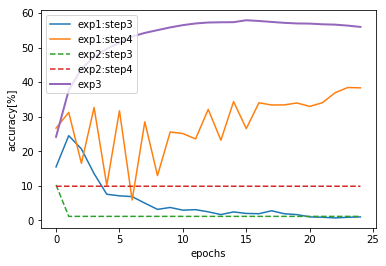

In [37]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(np.arange(25), m_x_acc, label="exp1:step3")
plt.plot(np.arange(25), m_y_acc, label="exp1:step4")
plt.plot(np.arange(25), n_x_acc, label="exp2:step3", linestyle="--")
plt.plot(np.arange(25), n_y_acc, label="exp2:step4", linestyle="--")
plt.plot(np.arange(25), b_x_acc, label="exp3", linewidth = 2)
plt.xlabel("epochs")
plt.ylabel("accuracy[%]")
# plt.title("compare accuracy")
plt.legend()
plt.show()
fig.savefig("accuracy.png")

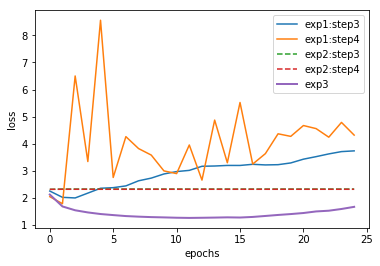

In [34]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(np.arange(25), m_x_test_loss, label="exp1:step3")
plt.plot(np.arange(25), m_y_test_loss, label="exp1:step4")
plt.plot(np.arange(25), n_x_test_loss, label="exp2:step3", linestyle="--")
plt.plot(np.arange(25), n_y_test_loss, label="exp2:step4", linestyle="--")
plt.plot(np.arange(25), b_x_test_loss, label="exp3", linewidth = 2)
plt.xlabel("epochs")
plt.ylabel("loss")
# plt.title("compare accuracy")
plt.legend()
plt.show()
fig.savefig("loss.png")

In [4]:
atob = [[0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 62, 63, 66, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100, 101, 103, 104, 105, 106, 108, 109, 110, 111, 113, 114, 115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 127, 129, 130, 131, 132, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 158, 159, 160, 161, 162, 163, 164, 165, 169, 170, 171, 172, 174, 175, 178, 179, 180, 181, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 196, 197, 198, 199, 200, 202, 203, 204, 205, 207, 208, 209, 210, 211, 213, 214, 215, 216, 218, 219, 220, 221, 222, 223, 224, 225, 226, 228, 229, 230, 231, 232, 233, 234, 235, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 251, 252, 253, 254, 255, 256, 258, 259, 261, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 276, 277, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 296, 298, 299, 300, 301, 303, 306, 307, 308, 309, 310, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 324, 325, 326, 327, 328, 329, 331, 332, 333, 334, 335, 336, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 355, 356, 358, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 376, 377, 378, 379, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 394, 395, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 427, 428, 429, 430, 433, 434, 435, 436, 437, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 487, 488, 489, 490, 492, 494, 495, 496, 497, 499, 500, 501, 502, 503, 504, 505, 507, 509, 510, 512, 513, 514, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 535, 536, 537, 538, 539, 540, 541, 543, 544, 545, 546, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 562, 563, 564, 566, 567, 568, 570, 571, 572, 573, 574, 575, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 591, 592, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 625, 626, 627, 628, 629, 630, 631, 632, 633, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 667, 669, 671, 672, 673, 674, 677, 678, 679, 680, 681, 682, 683, 684, 685, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 698, 700, 701, 702, 703, 704, 705, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 733, 735, 736, 737, 738, 739, 740, 741, 742, 744, 745, 746, 747, 748, 749, 752, 754, 755, 756, 757, 758, 759, 760, 763, 764, 765, 766, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 814, 815, 816, 818, 819, 820, 821, 822, 824, 825, 826, 827, 829, 830, 831, 832, 836, 837, 838, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 875, 876, 877, 878, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 891, 892, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 909, 910, 911, 912, 913, 914, 916, 920, 921, 922, 923, 924, 925, 926, 927, 929, 930, 931, 933, 934, 935, 937, 938, 939, 940, 941, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 979, 982, 983, 984, 985, 986, 987, 989, 990, 991, 992, 994, 995, 998, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1030, 1031, 1032, 1034, 1035, 1036, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1063, 1064, 1065, 1066, 1067, 1069, 1070, 1071, 1073, 1074, 1075, 1076, 1077, 1078, 1080, 1083, 1084, 1085, 1086, 1087, 1089, 1092, 1094, 1095, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1112, 1113, 1114, 1116, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1130, 1131, 1132, 1133, 1135, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1153, 1154, 1155, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1171, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1187, 1188, 1189, 1190, 1191, 1192, 1194, 1195, 1196, 1197, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1241, 1243, 1244, 1245, 1246, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1357, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1378, 1379, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1412, 1413, 1414, 1415, 1416, 1417, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1449, 1450, 1451, 1452, 1453, 1454, 1456, 1457, 1458, 1459, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1475, 1477, 1478, 1479, 1480, 1481, 1483, 1484, 1485, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1522, 1523, 1524, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1539, 1540, 1542, 1543, 1544, 1546, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1560, 1561, 1562, 1563, 1564, 1566, 1568, 1569, 1572, 1573, 1575, 1576, 1577, 1579, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1589, 1590, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1601, 1602, 1603, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1690, 1692, 1693, 1695, 1696, 1698, 1699, 1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710, 1711, 1712, 1713, 1714, 1715, 1716, 1718, 1720, 1721, 1722, 1723, 1724, 1725, 1727, 1728, 1729, 1730, 1732, 1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1748, 1749, 1751, 1752, 1753, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1821, 1822, 1823, 1824, 1825, 1826, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1861, 1862, 1863, 1864, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1874, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1902, 1903, 1904, 1905, 1907, 1908, 1909, 1910, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1923, 1924, 1925, 1926, 1927, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1944, 1945, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1984, 1985, 1987, 1988, 1989, 1990, 1992, 1994, 1995, 1996, 1997, 1999, 2000, 2001, 2002, 2003, 2004, 2006, 2007, 2008, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2018, 2019, 2021, 2022, 2024, 2025, 2026, 2027, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2053, 2055, 2056, 2057, 2058, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2072, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2090, 2091, 2092, 2093, 2095, 2096, 2097, 2098, 2099, 2100, 2102, 2103, 2105, 2106, 2107, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2119, 2120, 2121, 2122, 2123, 2124, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2144, 2145, 2146, 2150, 2151, 2152, 2154, 2155, 2156, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2168, 2169, 2171, 2172, 2174, 2175, 2176, 2177, 2178, 2179, 2181, 2186, 2187, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 2201, 2202, 2203, 2205, 2207, 2208, 2209, 2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2235, 2236, 2237, 2238, 2239, 2240, 2241, 2242, 2243, 2244, 2245, 2247, 2248, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2262, 2263, 2264, 2265, 2267, 2268, 2269, 2270, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279, 2281, 2282, 2284, 2285, 2286, 2287, 2288, 2290, 2291, 2292, 2293, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303, 2304, 2306, 2307, 2308, 2309, 2310, 2311, 2312, 2313, 2315, 2317, 2318, 2319, 2320, 2321, 2322, 2323, 2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2362, 2363, 2364, 2365, 2366, 2367, 2368, 2369, 2370, 2372, 2375, 2376, 2377, 2378, 2379, 2380, 2381, 2382, 2383, 2384, 2385, 2386, 2387, 2388, 2391, 2392, 2393, 2395, 2396, 2397, 2398, 2399, 2400, 2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2411, 2412, 2413, 2414, 2415, 2417, 2418, 2419, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2427, 2429, 2430, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2478, 2479, 2480, 2481, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2497, 2498, 2499, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2510, 2511, 2512, 2513, 2514, 2515, 2517, 2518, 2519, 2520, 2521, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2550, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2583, 2585, 2586, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2598, 2599, 2600, 2601, 2602, 2603, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2622, 2623, 2624, 2625, 2626, 2627, 2629, 2631, 2633, 2634, 2635, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2657, 2658, 2659, 2660, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2680, 2681, 2682, 2683, 2684, 2687, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705, 2707, 2708, 2710, 2712, 2713, 2714, 2715, 2716, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2728, 2729, 2731, 2732, 2734, 2735, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2746, 2747, 2749, 2750, 2751, 2752, 2753, 2754, 2756, 2757, 2758, 2759, 2760, 2761, 2763, 2764, 2766, 2767, 2768, 2770, 2772, 2773, 2774, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2789, 2790, 2791, 2792, 2793, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2842, 2843, 2845, 2846, 2847, 2848, 2849, 2852, 2853, 2854, 2855, 2856, 2857, 2858, 2859, 2860, 2861, 2863, 2865, 2866, 2867, 2868, 2869, 2870, 2871, 2872, 2873, 2874, 2875, 2876, 2878, 2879, 2880, 2881, 2882, 2883, 2885, 2887, 2888, 2889, 2891, 2892, 2893, 2894, 2895, 2896, 2897, 2898, 2899, 2900, 2902, 2903, 2904, 2905, 2907, 2908, 2909, 2911, 2912, 2913, 2914, 2915, 2917, 2918, 2919, 2920, 2921, 2922, 2923, 2924, 2925, 2926, 2927, 2929, 2930, 2931, 2932, 2933, 2934, 2935, 2936, 2937, 2938, 2939, 2941, 2942, 2943, 2944, 2945, 2946, 2947, 2948, 2949, 2950, 2951, 2952, 2953, 2954, 2955, 2957, 2958, 2959, 2960, 2961, 2962, 2964, 2965, 2966, 2967, 2968, 2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976, 2977, 2978, 2979, 2980, 2981, 2982, 2986, 2987, 2988, 2989, 2990, 2991, 2992, 2993, 2995, 2996, 2997, 2998, 2999, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3010, 3011, 3012, 3013, 3014, 3016, 3018, 3020, 3023, 3024, 3026, 3027, 3029, 3030, 3032, 3033, 3035, 3036, 3037, 3038, 3039, 3041, 3042, 3043, 3044, 3045, 3046, 3048, 3049, 3050, 3051, 3052, 3053, 3054, 3056, 3057, 3058, 3061, 3063, 3065, 3066, 3067, 3068, 3069, 3070, 3071, 3072, 3073, 3074, 3075, 3076, 3077, 3078, 3081, 3083, 3084, 3085, 3086, 3087, 3088, 3089, 3090, 3091, 3092, 3093, 3094, 3095, 3096, 3098, 3099, 3100, 3101, 3102, 3104, 3105, 3106, 3108, 3109, 3110, 3111, 3112, 3113, 3114, 3115, 3116, 3117, 3118, 3119, 3120, 3121, 3122, 3123, 3124, 3125, 3126, 3127, 3128, 3129, 3130, 3132, 3133, 3134, 3135, 3136, 3138, 3139, 3140, 3141, 3142, 3143, 3144, 3145, 3146, 3147, 3148, 3149, 3150, 3151, 3154, 3155, 3157, 3158, 3159, 3160, 3161, 3162, 3164, 3165, 3166, 3168, 3169, 3170, 3171, 3172, 3174, 3175, 3176, 3177, 3178, 3180, 3181, 3182, 3183, 3184, 3185, 3186, 3188, 3189, 3190, 3191, 3192, 3193, 3194, 3196, 3197, 3199, 3200, 3201, 3202, 3203, 3204, 3205, 3206, 3207, 3208, 3209, 3210, 3211, 3213, 3214, 3215, 3216, 3217, 3218, 3219, 3220, 3222, 3223, 3224, 3225, 3226, 3227, 3228, 3230, 3231, 3232, 3234, 3235, 3236, 3239, 3240, 3241, 3242, 3243, 3244, 3245, 3246, 3247, 3248, 3250, 3251, 3252, 3253, 3254, 3255, 3256, 3258, 3259, 3260, 3261, 3262, 3263, 3266, 3268, 3269, 3272, 3274, 3275, 3277, 3278, 3279, 3280, 3281, 3282, 3283, 3284, 3286, 3287, 3288, 3289, 3290, 3291, 3292, 3294, 3295, 3296, 3297, 3298, 3299, 3300, 3301, 3302, 3303, 3304, 3305, 3306, 3307, 3308, 3309, 3310, 3311, 3313, 3314, 3316, 3317, 3318, 3319, 3320, 3321, 3322, 3323, 3324, 3325, 3326, 3327, 3328, 3329, 3330, 3331, 3332, 3333, 3334, 3335, 3336, 3337, 3338, 3339, 3340, 3341, 3342, 3343, 3344, 3347, 3348, 3349, 3350, 3351, 3352, 3353, 3354, 3355, 3357, 3358, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3366, 3367, 3368, 3369, 3371, 3372, 3373, 3374, 3375, 3376, 3377, 3380, 3382, 3383, 3384, 3385, 3386, 3387, 3389, 3390, 3391, 3392, 3393, 3394, 3395, 3397, 3398, 3400, 3401, 3402, 3403, 3405, 3406, 3407, 3408, 3409, 3411, 3412, 3413, 3415, 3416, 3417, 3418, 3419, 3422, 3423, 3424, 3425, 3427, 3428, 3429, 3430, 3431, 3432, 3433, 3434, 3435, 3436, 3437, 3438, 3439, 3440, 3441, 3442, 3443, 3444, 3445, 3446, 3447, 3449, 3450, 3454, 3455, 3457, 3458, 3459, 3460, 3461, 3462, 3464, 3465, 3466, 3467, 3468, 3469, 3470, 3472, 3473, 3474, 3475, 3476, 3477, 3478, 3480, 3481, 3482, 3483, 3484, 3485, 3486, 3487, 3488, 3489, 3490, 3493, 3494, 3497, 3499, 3500, 3501, 3502, 3503, 3504, 3506, 3507, 3508, 3509, 3510, 3511, 3512, 3513, 3514, 3515, 3516, 3517, 3518, 3519, 3520, 3521, 3522, 3524, 3525, 3526, 3527, 3528, 3529, 3530, 3532, 3533, 3534, 3535, 3536, 3538, 3539, 3540, 3541, 3542, 3543, 3544, 3545, 3546, 3548, 3549, 3550, 3551, 3552, 3553, 3554, 3555, 3556, 3557, 3558, 3559, 3560, 3561, 3563, 3564, 3565, 3566, 3567, 3568, 3569, 3570, 3571, 3573, 3574, 3575, 3577, 3578, 3579, 3580, 3581, 3582, 3583, 3584, 3585, 3586, 3587, 3588, 3589, 3590, 3591, 3592, 3593, 3594, 3597, 3598, 3599, 3600, 3601, 3602, 3603, 3604, 3606, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3617, 3618, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3629, 3630, 3631, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3642, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3654, 3655, 3656, 3657, 3658, 3659, 3661, 3662, 3663, 3664, 3665, 3668, 3669, 3670, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 3685, 3686, 3687, 3688, 3689, 3690, 3691, 3692, 3693, 3694, 3695, 3696, 3697, 3698, 3699, 3700, 3701, 3702, 3703, 3706, 3707, 3708, 3709, 3710, 3711, 3712, 3713, 3714, 3715, 3716, 3717, 3718, 3719, 3720, 3721, 3722, 3723, 3724, 3725, 3726, 3727, 3728, 3729, 3730, 3731, 3732, 3733, 3734, 3735, 3736, 3738, 3739, 3740, 3741, 3742, 3745, 3746, 3747, 3749, 3750, 3753, 3754, 3755, 3756, 3757, 3758, 3759, 3761, 3762, 3763, 3764, 3765, 3768, 3769, 3770, 3771, 3772, 3773, 3774, 3775, 3776, 3777, 3779, 3780, 3782, 3783, 3784, 3785, 3786, 3787, 3788, 3789, 3791, 3792, 3793, 3795, 3796, 3797, 3798, 3800, 3801, 3802, 3804, 3805, 3806, 3807, 3809, 3812, 3813, 3814, 3815, 3816, 3817, 3818, 3819, 3820, 3821, 3823, 3824, 3825, 3826, 3828, 3829, 3830, 3831, 3832, 3833, 3834, 3835, 3836, 3837, 3838, 3839, 3841, 3842, 3843, 3844, 3845, 3846, 3847, 3848, 3849, 3850, 3852, 3854, 3855, 3856, 3857, 3858, 3859, 3860, 3861, 3862, 3863, 3864, 3865, 3866, 3868, 3869, 3870, 3872, 3873, 3874, 3875, 3876, 3877, 3878, 3879, 3880, 3881, 3882, 3883, 3884, 3885, 3887, 3888, 3889, 3890, 3891, 3892, 3893, 3895, 3897, 3898, 3900, 3901, 3903, 3904, 3905, 3906, 3907, 3908, 3909, 3910, 3911, 3912, 3913, 3914, 3915, 3918, 3919, 3920, 3921, 3922, 3923, 3925, 3926, 3927, 3928, 3929, 3930, 3931, 3932, 3933, 3935, 3936, 3938, 3939, 3940, 3941, 3942, 3943, 3944, 3945, 3946, 3947, 3948, 3950, 3951, 3952, 3953, 3955, 3956, 3957, 3958, 3961, 3962, 3963, 3964, 3967, 3969, 3970, 3971, 3972, 3973, 3974, 3975, 3976, 3977, 3978, 3979, 3980, 3981, 3982, 3983, 3984, 3985, 3986, 3987, 3988, 3989, 3991, 3994, 3996, 3997, 3998, 3999, 4001, 4003, 4005, 4006, 4007, 4008, 4010, 4012, 4014, 4015, 4016, 4017, 4018, 4019, 4020, 4022, 4023, 4024, 4025, 4026, 4027, 4028, 4029, 4030, 4031, 4032, 4033, 4034, 4035, 4036, 4037, 4038, 4042, 4043, 4044, 4045, 4046, 4048, 4049, 4051, 4052, 4053, 4054, 4055, 4056, 4057, 4058, 4059, 4060, 4061, 4062, 4063, 4064, 4065, 4066, 4068, 4069, 4070, 4071, 4072, 4073, 4075, 4076, 4077, 4078, 4079, 4080, 4081, 4082, 4083, 4084, 4085, 4086, 4087, 4088, 4089, 4090, 4091, 4092, 4093, 4094, 4095, 4096, 4097, 4098, 4100, 4102, 4103, 4104, 4105, 4106, 4107, 4108, 4109, 4110, 4111, 4112, 4113, 4114, 4115, 4116, 4117, 4118, 4119, 4120, 4121, 4122, 4123, 4124, 4126, 4128, 4129, 4130, 4131, 4133, 4134, 4136, 4137, 4138, 4139, 4140, 4141, 4142, 4143, 4144, 4146, 4147, 4148, 4149, 4150, 4151, 4152, 4154, 4155, 4156, 4157, 4158, 4159, 4160, 4162, 4163, 4164, 4165, 4166, 4167, 4168, 4170, 4172, 4173, 4174, 4175, 4176, 4177, 4178, 4179, 4180, 4181, 4182, 4183, 4184, 4185, 4186, 4187, 4189, 4190, 4191, 4192, 4193, 4194, 4195, 4196, 4197, 4198, 4199, 4201, 4202, 4204, 4205, 4206, 4207, 4208, 4209, 4210, 4211, 4212, 4213, 4214, 4215, 4216, 4217, 4218, 4219, 4220, 4221, 4222, 4223, 4224, 4225, 4226, 4227, 4228, 4229, 4230, 4231, 4232, 4233, 4234, 4235, 4236, 4237, 4238, 4239, 4240, 4241, 4242, 4243, 4245, 4246, 4247, 4248, 4249, 4250, 4251, 4252, 4253, 4254, 4257, 4258, 4259, 4261, 4262, 4263, 4264, 4266, 4267, 4268, 4269, 4270, 4271, 4272, 4273, 4274, 4276, 4277, 4278, 4279, 4280, 4281, 4282, 4283, 4284, 4285, 4286, 4287, 4288, 4290, 4291, 4292, 4293, 4294, 4295, 4296, 4297, 4298, 4299, 4300, 4301, 4302, 4303, 4304, 4305, 4306, 4307, 4308, 4309, 4310, 4311, 4312, 4313, 4314, 4315, 4317, 4318, 4320, 4322, 4323, 4324, 4325, 4327, 4328, 4329, 4331, 4333, 4334, 4335, 4336, 4337, 4338, 4339, 4340, 4341, 4342, 4343, 4344, 4345, 4346, 4348, 4349, 4350, 4351, 4353, 4354, 4356, 4357, 4358, 4359, 4360, 4361, 4364, 4365, 4367, 4368, 4369, 4370, 4371, 4372, 4373, 4375, 4376, 4377, 4378, 4379, 4380, 4381, 4382, 4383, 4384, 4386, 4387, 4388, 4389, 4390, 4391, 4392, 4393, 4394, 4395, 4396, 4397, 4398, 4399, 4400, 4401, 4402, 4403, 4404, 4405, 4408, 4409, 4410, 4411, 4412, 4413, 4414, 4415, 4416, 4417, 4418, 4420, 4421, 4422, 4425, 4426, 4427, 4428, 4429, 4430, 4431, 4432, 4433, 4434, 4435, 4437, 4438, 4439, 4440, 4441, 4442, 4443, 4444, 4445, 4446, 4447, 4449, 4450, 4452, 4453, 4454, 4455, 4456, 4460, 4461, 4462, 4464, 4465, 4466, 4468, 4469, 4470, 4471, 4472, 4474, 4475, 4476, 4477, 4478, 4480, 4481, 4482, 4483, 4484, 4485, 4486, 4488, 4489, 4490, 4491, 4493, 4497, 4498, 4499, 4500, 4501, 4502, 4503, 4504, 4506, 4507, 4509, 4510, 4511, 4512, 4513, 4514, 4515, 4516, 4518, 4519, 4521, 4522, 4523, 4524, 4525, 4526, 4527, 4528, 4530, 4531, 4533, 4534, 4537, 4538, 4539, 4540, 4541, 4542, 4543, 4544, 4545, 4546, 4549, 4550, 4551, 4552, 4554, 4555, 4556, 4558, 4559, 4560, 4561, 4562, 4563, 4564, 4566, 4567, 4568, 4569, 4570, 4571, 4573, 4574, 4575, 4576, 4577, 4578, 4580, 4581, 4582, 4583, 4584, 4585, 4586, 4587, 4588, 4589, 4590, 4592, 4593, 4594, 4595, 4596, 4597, 4598, 4599, 4601, 4602, 4604, 4605, 4606, 4607, 4608, 4609, 4610, 4611, 4612, 4613, 4614, 4616, 4617, 4618, 4619, 4620, 4621, 4622, 4623, 4624, 4628, 4629, 4630, 4632, 4633, 4634, 4637, 4638, 4640, 4642, 4643, 4644, 4645, 4646, 4647, 4648, 4649, 4650, 4651, 4652, 4653, 4654, 4655, 4656, 4657, 4658, 4659, 4660, 4661, 4662, 4663, 4664, 4665, 4666, 4668, 4669, 4670, 4671, 4672, 4673, 4674, 4675, 4676, 4677, 4678, 4679, 4680, 4681, 4682, 4683, 4684, 4685, 4686, 4687, 4688, 4689, 4690, 4691, 4693, 4695, 4697, 4700, 4701, 4703, 4704, 4705, 4706, 4707, 4708, 4709, 4710, 4711, 4712, 4713, 4714, 4715, 4717, 4718, 4719, 4720, 4721, 4722, 4723, 4724, 4725, 4726, 4727, 4729, 4730, 4731, 4732, 4734, 4735, 4736, 4737, 4738, 4741, 4742, 4743, 4744, 4745, 4746, 4747, 4748, 4749, 4750, 4751, 4752, 4753, 4754, 4755, 4756, 4757, 4758, 4759, 4760, 4761, 4763, 4765, 4766, 4767, 4768, 4770, 4771, 4772, 4773, 4774, 4776, 4777, 4778, 4779, 4780, 4781, 4782, 4783, 4784, 4785, 4786, 4787, 4788, 4789, 4790, 4791, 4792, 4793, 4794, 4795, 4796, 4798, 4799, 4800, 4801, 4804, 4805, 4806, 4807, 4809, 4810, 4811, 4812, 4813, 4815, 4816, 4818, 4819, 4820, 4821, 4823, 4824, 4825, 4826, 4827, 4828, 4829, 4830, 4831, 4832, 4833, 4834, 4835, 4836, 4837, 4839, 4841, 4842, 4843, 4844, 4845, 4846, 4847, 4848, 4850, 4851, 4852, 4853, 4854, 4855, 4857, 4858, 4859, 4860, 4861, 4863, 4864, 4865, 4867, 4868, 4869, 4870, 4871, 4872, 4873, 4875, 4876, 4877, 4878, 4879, 4880, 4881, 4882, 4883, 4885, 4886, 4887, 4888, 4889, 4891, 4892, 4893, 4894, 4895, 4896, 4897, 4898, 4899, 4900, 4901, 4902, 4903, 4904, 4905, 4906, 4907, 4908, 4909, 4910, 4911, 4912, 4914, 4915, 4916, 4918, 4919, 4921, 4923, 4924, 4925, 4926, 4927, 4928, 4929, 4930, 4931, 4933, 4934, 4935, 4936, 4937, 4938, 4939, 4940, 4941, 4943, 4946, 4947, 4948, 4950, 4951, 4952, 4954, 4955, 4957, 4958, 4959, 4962, 4963, 4964, 4965, 4966, 4967, 4969, 4970, 4971, 4972, 4973, 4974, 4975, 4976, 4977, 4978, 4979, 4980, 4981, 4982, 4984, 4985, 4986, 4987, 4988, 4989, 4991, 4992, 4994, 4995, 4996, 4998, 4999, 5000, 5001, 5003, 5005, 5006, 5007, 5008, 5010, 5012, 5014, 5015, 5016, 5017, 5018, 5019, 5020, 5021, 5022, 5023, 5024, 5025, 5026, 5027, 5028, 5029, 5030, 5031, 5032, 5033, 5034, 5035, 5037, 5038], [1, 4, 32, 40, 46, 56, 61, 64, 65, 67, 75, 81, 96, 102, 107, 112, 119, 126, 128, 134, 148, 156, 157, 166, 167, 168, 173, 176, 177, 182, 183, 195, 201, 206, 212, 217, 227, 236, 250, 257, 260, 262, 275, 278, 295, 297, 302, 304, 305, 311, 312, 323, 330, 337, 354, 357, 359, 360, 375, 380, 393, 396, 426, 431, 432, 438, 454, 471, 486, 491, 493, 498, 506, 508, 511, 515, 534, 542, 547, 561, 565, 569, 576, 577, 590, 593, 606, 607, 624, 634, 666, 668, 670, 675, 676, 686, 697, 699, 706, 732, 734, 743, 750, 751, 753, 761, 762, 767, 784, 813, 817, 823, 828, 833, 834, 835, 839, 840, 841, 852, 873, 874, 879, 890, 893, 894, 908, 915, 917, 918, 919, 928, 932, 936, 942, 953, 978, 980, 981, 988, 993, 996, 997, 999, 1000, 1020, 1029, 1033, 1037, 1045, 1062, 1068, 1072, 1079, 1081, 1082, 1088, 1090, 1091, 1093, 1096, 1111, 1115, 1117, 1129, 1134, 1136, 1152, 1156, 1170, 1172, 1186, 1193, 1198, 1199, 1217, 1232, 1240, 1242, 1247, 1272, 1305, 1330, 1344, 1355, 1356, 1377, 1380, 1390, 1401, 1410, 1411, 1418, 1419, 1448, 1455, 1460, 1474, 1476, 1482, 1486, 1494, 1502, 1503, 1520, 1521, 1525, 1538, 1541, 1545, 1547, 1548, 1559, 1565, 1567, 1570, 1571, 1574, 1578, 1580, 1588, 1591, 1599, 1600, 1604, 1618, 1634, 1651, 1652, 1682, 1691, 1694, 1697, 1717, 1719, 1726, 1731, 1747, 1750, 1754, 1779, 1780, 1790, 1799, 1810, 1820, 1827, 1847, 1848, 1849, 1860, 1865, 1873, 1875, 1886, 1901, 1906, 1911, 1922, 1928, 1942, 1943, 1946, 1973, 1983, 1986, 1991, 1993, 1998, 2005, 2009, 2017, 2020, 2023, 2028, 2038, 2052, 2054, 2059, 2071, 2073, 2081, 2089, 2094, 2101, 2104, 2108, 2118, 2125, 2143, 2147, 2148, 2149, 2153, 2157, 2167, 2170, 2173, 2180, 2182, 2183, 2184, 2185, 2188, 2204, 2206, 2227, 2246, 2249, 2250, 2251, 2259, 2260, 2261, 2266, 2271, 2280, 2283, 2289, 2294, 2305, 2314, 2316, 2334, 2335, 2351, 2361, 2371, 2373, 2374, 2389, 2390, 2394, 2410, 2416, 2428, 2445, 2455, 2456, 2457, 2469, 2477, 2482, 2496, 2500, 2509, 2516, 2522, 2531, 2549, 2551, 2570, 2582, 2584, 2587, 2597, 2604, 2621, 2628, 2630, 2632, 2636, 2644, 2656, 2661, 2685, 2686, 2688, 2706, 2709, 2711, 2717, 2727, 2730, 2733, 2736, 2745, 2748, 2755, 2762, 2765, 2769, 2771, 2775, 2788, 2794, 2802, 2827, 2828, 2829, 2841, 2844, 2850, 2851, 2862, 2864, 2877, 2884, 2886, 2890, 2901, 2906, 2910, 2916, 2928, 2940, 2956, 2963, 2983, 2984, 2985, 2994, 3009, 3015, 3017, 3019, 3021, 3022, 3025, 3028, 3031, 3034, 3040, 3047, 3055, 3059, 3060, 3062, 3064, 3079, 3080, 3082, 3097, 3103, 3107, 3131, 3137, 3152, 3153, 3156, 3163, 3167, 3173, 3179, 3187, 3195, 3198, 3212, 3221, 3229, 3233, 3237, 3238, 3249, 3257, 3264, 3265, 3267, 3270, 3271, 3273, 3276, 3285, 3293, 3312, 3315, 3345, 3346, 3356, 3370, 3378, 3379, 3381, 3388, 3396, 3399, 3404, 3410, 3414, 3420, 3421, 3426, 3448, 3451, 3452, 3453, 3456, 3463, 3471, 3479, 3491, 3492, 3495, 3496, 3498, 3505, 3523, 3531, 3537, 3547, 3562, 3572, 3576, 3595, 3596, 3605, 3616, 3619, 3628, 3632, 3633, 3641, 3643, 3653, 3660, 3666, 3667, 3671, 3704, 3705, 3737, 3743, 3744, 3748, 3751, 3752, 3760, 3766, 3767, 3778, 3781, 3790, 3794, 3799, 3803, 3808, 3810, 3811, 3822, 3827, 3840, 3851, 3853, 3867, 3871, 3886, 3894, 3896, 3899, 3902, 3916, 3917, 3924, 3934, 3937, 3949, 3954, 3959, 3960, 3965, 3966, 3968, 3990, 3992, 3993, 3995, 4000, 4002, 4004, 4009, 4011, 4013, 4021, 4039, 4040, 4041, 4047, 4050, 4067, 4074, 4099, 4101, 4125, 4127, 4132, 4135, 4145, 4153, 4161, 4169, 4171, 4188, 4200, 4203, 4244, 4255, 4256, 4260, 4265, 4275, 4289, 4316, 4319, 4321, 4326, 4330, 4332, 4347, 4352, 4355, 4362, 4363, 4366, 4374, 4385, 4406, 4407, 4419, 4423, 4424, 4436, 4448, 4451, 4457, 4458, 4459, 4463, 4467, 4473, 4479, 4487, 4492, 4494, 4495, 4496, 4505, 4508, 4517, 4520, 4529, 4532, 4535, 4536, 4547, 4548, 4553, 4557, 4565, 4572, 4579, 4591, 4600, 4603, 4615, 4625, 4626, 4627, 4631, 4635, 4636, 4639, 4641, 4667, 4692, 4694, 4696, 4698, 4699, 4702, 4716, 4728, 4733, 4739, 4740, 4762, 4764, 4769, 4775, 4797, 4802, 4803, 4808, 4814, 4817, 4822, 4838, 4840, 4849, 4856, 4862, 4866, 4874, 4884, 4890, 4913, 4917, 4920, 4922, 4932, 4942, 4944, 4945, 4949, 4953, 4956, 4960, 4961, 4968, 4983, 4990, 4993, 4997, 5002, 5004, 5009, 5011, 5013, 5036, 5039, 5043, 5052, 5057, 5068, 5070, 5079, 5083, 5090, 5100, 5102, 5108, 5125, 5135, 5136, 5137, 5144, 5149, 5152, 5157, 5164, 5170, 5171, 5175, 5186, 5191, 5195, 5196, 5201, 5202, 5205, 5211, 5232, 5247, 5261, 5267, 5270, 5275, 5301, 5303, 5305, 5320, 5335, 5367, 5372, 5392, 5393, 5397, 5399, 5411, 5413, 5420, 5422, 5431, 5433, 5437, 5438, 5439, 5448, 5459, 5460, 5467, 5500, 5503, 5505, 5509, 5511, 5515, 5517, 5524, 5544, 5547, 5552, 5555, 5559, 5561, 5568, 5569, 5590, 5593, 5605, 5613, 5616, 5626, 5627, 5629, 5635, 5637, 5646, 5655, 5666, 5668, 5670, 5671, 5688, 5690, 5695, 5709, 5722, 5729, 5734, 5747, 5749, 5755, 5759, 5760, 5769, 5780, 5791, 5805, 5816, 5822, 5830, 5832, 5834, 5837, 5840, 5860, 5861, 5881, 5886, 5895, 5897, 5899, 5905, 5917, 5947, 5951, 5960, 5961, 5962, 5970, 5971, 5981, 5983, 5993, 6017, 6020, 6024, 6031, 6033, 6034, 6037, 6042, 6047, 6048, 6053, 6058, 6064, 6065, 6068, 6074, 6082, 6083, 6088, 6091, 6092, 6094, 6100, 6102, 6104, 6105, 6109, 6120, 6131, 6140, 6155, 6161, 6183, 6184, 6191, 6196, 6202, 6215, 6226, 6231, 6232, 6241, 6245, 6248, 6253, 6259, 6269, 6272, 6275, 6279, 6285, 6288, 6295, 6318, 6333, 6345, 6349, 6352, 6353, 6355, 6357, 6358, 6364, 6366, 6371, 6375, 6383, 6419, 6420, 6436, 6443, 6444, 6453, 6455, 6457, 6476, 6483, 6494, 6495, 6515, 6516, 6525, 6530, 6534, 6544, 6546, 6550, 6559, 6575, 6577, 6579, 6580, 6589, 6604, 6615, 6622, 6623, 6630, 6639, 6642, 6644, 6659, 6666, 6668, 6670, 6675, 6678, 6683, 6694, 6698, 6707, 6709, 6723, 6730, 6731, 6733, 6736, 6737, 6760, 6769, 6778, 6779, 6781, 6784, 6797, 6807, 6813, 6814, 6815, 6819, 6831, 6851, 6853, 6856, 6869, 6871, 6873, 6878, 6896, 6899, 6915, 6928, 6931, 6933, 6955, 6957, 6958, 6965, 6967, 6969, 6978, 6982, 6991, 7000, 7005, 7010, 7017, 7021, 7031, 7032, 7057, 7069, 7071, 7077, 7082, 7087, 7090, 7094, 7102, 7103, 7105, 7111, 7113, 7115, 7139, 7158, 7160, 7162, 7164, 7167, 7181, 7192, 7195, 7199, 7208, 7221, 7227, 7236, 7240, 7246, 7270, 7271, 7276, 7280, 7284, 7288, 7289, 7293, 7297, 7300, 7305, 7312, 7319, 7324, 7338, 7342, 7349, 7351, 7354, 7357, 7358, 7364, 7371, 7373, 7374, 7378, 7379, 7381, 7390, 7391, 7401, 7406, 7408, 7414, 7417, 7429, 7430, 7438, 7441, 7442, 7446, 7454, 7472, 7476, 7495, 7513, 7515, 7518, 7540, 7545, 7560, 7562, 7578, 7579, 7587, 7590, 7601, 7620, 7640, 7645, 7649, 7659, 7673, 7677, 7679, 7685, 7691, 7692, 7704, 7707, 7709, 7718, 7721, 7723, 7724, 7729, 7735, 7738, 7750, 7755, 7769, 7773, 7774, 7777, 7778, 7779, 7785, 7796, 7821, 7861, 7864, 7870, 7873, 7879, 7887, 7901, 7908, 7912, 7913, 7915, 7921, 7926, 7935, 7936, 7938, 7944, 7960, 7978, 7980, 7981, 7983, 8001, 8020, 8035, 8039, 8040, 8050, 8058, 8059, 8085, 8090, 8093, 8094, 8095, 8124, 8127, 8130, 8135, 8141, 8149, 8156, 8167, 8174, 8175, 8188, 8189, 8196, 8197, 8198, 8201, 8204, 8205, 8213, 8216, 8223, 8227, 8230, 8232, 8239, 8240, 8243, 8244, 8252, 8261, 8269, 8274, 8282, 8287, 8290, 8291, 8294, 8298, 8300, 8307, 8318, 8320, 8323, 8325, 8332, 8334, 8350, 8353, 8373, 8374, 8389, 8394, 8398, 8407, 8412, 8427, 8432, 8441, 8449, 8450, 8457, 8463, 8464, 8475, 8476, 8480, 8486, 8496, 8497, 8500, 8501, 8502, 8511, 8517, 8529, 8532, 8540, 8548, 8559, 8563, 8570, 8571, 8575, 8576, 8584, 8586, 8587, 8590, 8591, 8600, 8601, 8607, 8621, 8628, 8644, 8662, 8675, 8684, 8691, 8693, 8696, 8725, 8729, 8731, 8735, 8742, 8747, 8754, 8756, 8757, 8768, 8771, 8791, 8793, 8794, 8795, 8796, 8799, 8805, 8807, 8809, 8824, 8825, 8836, 8848, 8851, 8855, 8869, 8878, 8893, 8896, 8900, 8902, 8920, 8923, 8929, 8932, 8938, 8944, 8945, 8948, 8960, 8964, 8965, 8975, 8985, 8989, 8993, 8995, 9007, 9012, 9017, 9028, 9030, 9042, 9043, 9054, 9070, 9080, 9088, 9099, 9104, 9113, 9118, 9127, 9132, 9138, 9148, 9174, 9178, 9189, 9190, 9196, 9209, 9212, 9216, 9218, 9232, 9235, 9247, 9251, 9252, 9263, 9264, 9267, 9284, 9288, 9295, 9301, 9317, 9322, 9335, 9355, 9358, 9365, 9372, 9377, 9380, 9383, 9388, 9391, 9402, 9411, 9419, 9432, 9433, 9445, 9450, 9458, 9459, 9470, 9478, 9480, 9494, 9508, 9509, 9513, 9524, 9534, 9535, 9538, 9539, 9547, 9561, 9563, 9576, 9578, 9582, 9584, 9586, 9595, 9602, 9605, 9622, 9634, 9641, 9642, 9649, 9652, 9665, 9703, 9707, 9717, 9721, 9745, 9746, 9754, 9766, 9772, 9781, 9787, 9804, 9811, 9812, 9822, 9832, 9835, 9837, 9854, 9857, 9867, 9869, 9870, 9879, 9894, 9899, 9929, 9938, 9946, 9948, 9965, 9987, 9988, 9993, 9997, 9998, 9999, 10014, 10022, 10030, 10033, 10049, 10071, 10072, 10074, 10082, 10090, 10091, 10104, 10110, 10112, 10118, 10122, 10133, 10153, 10155, 10168, 10175, 10181, 10194, 10198, 10201, 10206, 10221, 10223, 10230, 10236, 10242, 10246, 10248, 10249, 10251, 10270, 10292, 10294, 10314, 10315, 10316, 10318, 10324, 10325, 10352, 10362, 10363, 10366, 10370, 10373, 10375, 10377, 10380, 10382, 10397, 10407, 10413, 10420, 10423, 10424, 10429, 10450, 10471, 10476, 10482, 10484, 10491, 10503, 10509, 10514, 10515, 10521, 10522, 10523, 10541, 10544, 10549, 10555, 10556, 10564, 10568, 10569, 10571, 10576, 10603, 10614, 10622, 10627, 10630, 10632, 10642, 10644, 10648, 10655, 10657, 10659, 10669, 10670, 10678, 10691, 10692, 10696, 10698, 10703, 10709, 10710, 10711, 10714, 10715, 10717, 10726, 10737, 10739, 10740, 10743, 10744, 10747, 10755, 10758, 10768, 10771, 10780, 10791, 10793, 10797, 10800, 10803, 10826, 10831, 10835, 10839, 10844, 10853, 10868, 10878, 10882, 10895, 10910, 10912, 10915, 10921, 10930, 10935, 10945, 10953, 10964, 10969, 10977, 10978, 10995, 11000, 11004, 11007, 11016, 11032, 11034, 11043, 11061, 11072, 11075, 11082, 11094, 11112, 11121, 11133, 11140, 11142, 11143, 11145, 11155, 11160, 11164, 11165, 11166, 11170, 11172, 11174, 11179, 11186, 11189, 11196, 11198, 11210, 11217, 11245, 11247, 11262, 11264, 11267, 11269, 11274, 11298, 11301, 11314, 11317, 11328, 11347, 11365, 11367, 11376, 11388, 11396, 11405, 11407, 11418, 11421, 11427, 11430, 11441, 11442, 11444, 11450, 11462, 11463, 11465, 11473, 11491, 11494, 11495, 11496, 11497, 11515, 11517, 11525, 11530, 11532, 11536, 11543, 11546, 11558, 11571, 11575, 11579, 11580, 11585, 11599, 11614, 11622, 11624, 11631, 11636, 11637, 11640, 11659, 11662, 11677, 11686, 11688, 11692, 11694, 11695, 11696, 11698, 11700, 11702, 11703, 11707, 11722, 11725, 11735, 11737, 11740, 11750, 11753, 11755, 11770, 11782, 11790, 11795, 11817, 11818, 11819, 11822, 11824, 11826, 11829, 11847, 11852, 11857, 11861, 11889, 11890, 11893, 11895, 11899, 11905, 11910, 11916, 11922, 11924, 11928, 11933, 11940, 11947, 11949, 11953, 11955, 11966, 11971, 11972, 11980, 11988, 11995, 12005, 12012, 12015, 12025, 12027, 12035, 12038, 12047, 12051, 12053, 12054, 12064, 12068, 12069, 12071, 12080, 12082, 12085, 12088, 12089, 12098, 12114, 12116, 12123, 12127, 12135, 12144, 12150, 12164, 12169, 12170, 12177, 12183, 12185, 12198, 12205, 12210, 12223, 12232, 12235, 12242, 12246, 12256, 12264, 12276, 12283, 12290, 12291, 12299, 12300, 12303, 12306, 12308, 12311, 12322, 12326, 12330, 12335, 12336, 12341, 12348, 12349, 12352, 12371, 12384, 12388, 12389, 12390, 12412, 12424, 12451, 12468, 12470, 12480, 12483, 12485, 12488, 12494, 12514, 12515, 12523, 12531, 12532, 12537, 12538, 12551, 12555, 12556, 12560, 12562, 12569, 12570, 12571, 12573, 12575, 12578, 12581, 12586, 12593, 12594, 12621, 12622, 12628, 12630, 12637, 12643, 12648, 12649, 12652, 12653, 12655, 12661, 12670, 12682, 12685, 12686, 12687, 12696, 12700, 12701, 12716, 12719, 12726, 12728, 12732, 12734, 12741, 12755, 12766, 12769, 12773, 12791, 12800, 12814, 12832, 12833, 12841, 12849, 12856, 12865, 12881, 12884, 12890, 12893, 12894, 12902, 12903, 12908, 12912, 12913, 12919, 12923, 12927, 12929, 12931, 12937, 12946, 12947, 12948, 12963, 12964, 12970, 12974, 12977, 12982, 12987, 12999, 13002, 13032, 13037, 13045, 13050, 13063, 13065, 13067, 13070, 13073, 13078, 13087, 13088, 13098, 13099, 13100, 13103, 13104, 13108, 13111, 13112, 13114, 13118, 13121, 13122, 13128, 13129, 13133, 13142, 13144, 13149, 13150, 13151, 13152, 13156, 13158, 13159, 13161, 13173, 13187, 13190, 13203, 13207, 13208, 13218, 13236, 13239, 13240, 13244, 13245, 13246, 13249, 13251, 13252, 13256, 13257, 13262, 13277, 13283, 13285, 13296, 13311, 13316, 13317, 13323, 13332, 13345, 13346, 13356, 13359, 13360, 13361, 13366, 13384, 13387, 13392, 13405, 13417, 13421, 13444, 13456, 13461, 13468, 13470, 13488, 13499, 13508, 13509, 13517, 13527, 13528, 13529, 13532, 13534, 13538, 13542, 13543, 13548, 13551, 13555, 13558, 13571, 13586, 13598, 13604, 13608, 13609, 13610, 13618, 13624, 13644, 13647, 13651, 13657, 13658, 13665, 13667, 13670, 13673, 13676, 13679, 13680, 13689, 13713, 13717, 13721, 13722, 13740, 13766, 13774, 13784, 13792, 13805, 13821, 13839, 13842, 13845, 13849, 13852, 13858, 13865, 13872, 13877, 13884, 13895, 13899, 13901, 13908, 13910, 13911, 13924, 13926, 13944, 13948, 13952, 13955, 13960, 13968, 13973, 13980, 13983, 13990, 13996, 13997, 13999, 14001, 14004, 14006, 14026, 14033, 14035, 14048, 14055, 14061, 14067, 14068, 14074, 14076, 14093, 14096, 14103, 14110, 14117, 14119, 14121, 14145, 14160, 14165, 14167, 14168, 14182, 14184, 14198, 14204, 14221, 14223, 14227, 14238, 14247, 14249, 14259, 14273, 14276, 14288, 14298, 14300, 14302, 14311, 14320, 14322, 14331, 14336, 14337, 14346, 14355, 14366, 14367, 14376, 14379, 14384, 14391, 14405, 14408, 14409, 14417, 14424, 14425, 14432, 14448, 14451, 14461, 14462, 14467, 14470, 14477, 14481, 14495, 14498, 14501, 14502, 14519, 14522, 14524, 14530, 14533, 14538, 14546, 14552, 14570, 14579, 14593, 14598, 14627, 14632, 14643, 14659, 14661, 14662, 14668, 14669, 14673, 14676, 14677, 14681, 14682, 14683, 14691, 14695, 14700, 14713, 14717, 14724, 14734, 14748, 14750, 14759, 14760, 14763, 14764, 14776, 14783, 14791, 14792, 14795, 14797, 14802, 14803, 14805, 14851, 14855, 14859, 14871, 14878, 14881, 14890, 14896, 14900, 14904, 14908, 14912, 14917, 14927, 14929, 14932, 14952, 14954, 14961, 14963, 14967, 14975, 14992, 15006, 15027, 15029, 15033, 15042, 15051, 15061, 15069, 15074, 15088, 15089, 15100, 15103, 15114, 15119, 15130, 15133, 15151, 15162, 15166, 15171, 15183, 15186, 15205, 15207, 15209, 15213, 15219, 15229, 15233, 15242, 15248, 15261, 15275, 15286, 15293, 15295, 15301, 15306, 15315, 15319, 15340, 15347, 15354, 15362, 15365, 15371, 15373, 15378, 15386, 15393, 15401, 15403, 15408, 15423, 15425, 15431, 15432, 15447, 15449, 15450, 15456, 15460, 15462, 15463, 15469, 15475, 15476, 15480, 15496, 15499, 15506, 15507, 15510, 15512, 15518, 15527, 15535, 15549, 15559, 15574, 15575, 15583, 15591, 15601, 15602, 15610, 15632, 15633, 15646, 15653, 15655, 15662, 15669, 15670, 15672, 15685, 15692, 15694, 15708, 15709, 15710, 15724, 15728, 15733, 15736, 15738, 15742, 15747, 15756, 15761, 15764, 15770, 15774, 15775, 15776, 15779, 15783, 15785, 15797, 15808, 15814, 15815, 15832, 15841, 15845, 15855, 15861, 15862, 15868, 15874, 15883, 15891, 15894, 15897, 15898, 15903, 15908, 15915, 15934, 15943, 15950, 15952, 15966, 15975, 15984, 15985, 15988, 16009, 16019, 16029, 16043, 16046, 16047, 16063, 16077, 16079, 16081, 16083, 16087, 16089, 16094, 16107, 16110, 16128, 16134, 16150, 16166, 16168, 16172, 16180, 16185, 16188, 16199, 16204, 16211, 16212, 16234, 16236, 16247, 16252, 16258, 16268, 16269, 16270, 16272, 16275, 16276, 16277, 16278, 16280, 16282, 16286, 16299, 16309, 16310, 16311, 16321, 16325, 16332, 16338, 16347, 16351, 16358, 16359, 16361, 16365, 16368, 16369, 16374, 16377, 16378, 16400, 16403, 16408, 16412, 16428, 16431, 16436, 16453, 16454, 16459, 16469, 16471, 16490, 16494, 16496, 16510, 16534, 16540, 16543, 16556, 16560, 16563, 16575, 16576, 16588, 16591, 16594, 16598, 16599, 16601, 16610, 16613, 16617, 16623, 16626, 16638, 16641, 16643, 16653, 16658, 16673, 16679, 16688, 16698, 16699, 16701, 16710, 16718, 16723, 16735, 16736, 16741, 16745, 16748, 16753, 16755, 16766, 16769, 16770, 16771, 16774, 16777, 16781, 16797, 16798, 16799, 16800, 16810, 16812, 16813, 16821, 16823, 16834, 16835, 16848, 16850, 16852, 16853, 16855, 16873, 16882, 16884, 16899, 16923, 16925, 16929, 16931, 16933, 16935, 16937, 16943, 16949, 16953, 16955, 16956, 16957, 16958, 16962, 16964, 16969, 16973, 16975, 16976, 16985, 16989, 16990, 16997, 17002, 17006, 17008, 17009, 17016, 17032, 17055, 17061, 17065, 17079, 17091, 17102, 17106, 17111, 17112, 17121, 17126, 17128, 17148, 17152, 17165, 17169, 17171, 17186, 17190], [5042, 5048, 5051, 5063, 5067, 5074, 5075, 5091, 5092, 5119, 5141, 5143, 5155, 5178, 5179, 5180, 5193, 5212, 5214, 5222, 5225, 5227, 5229, 5237, 5245, 5251, 5253, 5256, 5262, 5264, 5273, 5274, 5278, 5283, 5284, 5285, 5289, 5298, 5304, 5312, 5342, 5345, 5347, 5350, 5358, 5360, 5364, 5365, 5377, 5378, 5405, 5434, 5440, 5442, 5446, 5454, 5462, 5483, 5486, 5487, 5488, 5490, 5491, 5495, 5501, 5514, 5523, 5528, 5546, 5548, 5570, 5573, 5581, 5594, 5619, 5624, 5625, 5630, 5631, 5633, 5643, 5648, 5653, 5658, 5667, 5669, 5672, 5675, 5676, 5677, 5687, 5701, 5704, 5706, 5721, 5726, 5728, 5732, 5739, 5742, 5750, 5752, 5754, 5756, 5768, 5777, 5786, 5787, 5788, 5790, 5795, 5807, 5815, 5820, 5826, 5829, 5835, 5844, 5855, 5866, 5875, 5880, 5891, 5894, 5902, 5904, 5908, 5909, 5911, 5916, 5919, 5929, 5931, 5940, 5944, 5946, 5949, 5950, 5957, 5986, 5998, 5999, 6004, 6007, 6009, 6022, 6027, 6039, 6044, 6049, 6056, 6080, 6084, 6103, 6110, 6115, 6123, 6128, 6139, 6144, 6166, 6168, 6173, 6175, 6176, 6180, 6181, 6182, 6203, 6204, 6206, 6211, 6212, 6214, 6219, 6234, 6238, 6243, 6247, 6249, 6251, 6266, 6270, 6274, 6280, 6281, 6289, 6292, 6298, 6303, 6311, 6314, 6331, 6337, 6339, 6344, 6361, 6378, 6387, 6389, 6407, 6410, 6415, 6421, 6432, 6435, 6437, 6450, 6452, 6465, 6470, 6472, 6474, 6475, 6478, 6485, 6498, 6501, 6505, 6508, 6509, 6524, 6527, 6529, 6532, 6535, 6560, 6562, 6565, 6569, 6576, 6586, 6591, 6594, 6603, 6605, 6611, 6612, 6632, 6636, 6646, 6651, 6652, 6654, 6667, 6681, 6710, 6717, 6720, 6740, 6756, 6770, 6780, 6796, 6806, 6809, 6838, 6844, 6848, 6852, 6862, 6863, 6875, 6877, 6879, 6894, 6897, 6898, 6907, 6911, 6924, 6940, 6942, 6943, 6950, 6974, 6977, 6983, 6985, 6989, 6990, 6993, 6995, 7007, 7012, 7024, 7035, 7043, 7045, 7052, 7054, 7058, 7059, 7061, 7062, 7078, 7097, 7099, 7100, 7118, 7119, 7154, 7155, 7156, 7163, 7206, 7207, 7237, 7248, 7269, 7274, 7281, 7282, 7283, 7295, 7296, 7301, 7306, 7310, 7317, 7322, 7356, 7359, 7361, 7362, 7365, 7368, 7376, 7382, 7383, 7386, 7394, 7395, 7404, 7407, 7413, 7424, 7436, 7437, 7443, 7447, 7455, 7459, 7484, 7496, 7507, 7508, 7514, 7531, 7535, 7536, 7557, 7559, 7563, 7569, 7574, 7585, 7619, 7623, 7625, 7626, 7630, 7634, 7636, 7642, 7656, 7670, 7676, 7678, 7690, 7693, 7695, 7716, 7733, 7737, 7743, 7751, 7767, 7775, 7787, 7794, 7811, 7818, 7822, 7828, 7834, 7851, 7855, 7866, 7871, 7880, 7896, 7910, 7933, 7934, 7941, 7947, 7954, 7956, 7957, 7963, 7973, 7984, 7995, 8004, 8005, 8007, 8027, 8031, 8042, 8045, 8046, 8047, 8049, 8057, 8066, 8068, 8070, 8080, 8111, 8114, 8117, 8120, 8131, 8137, 8138, 8150, 8163, 8177, 8180, 8184, 8208, 8229, 8231, 8233, 8235, 8236, 8247, 8248, 8250, 8254, 8257, 8260, 8263, 8270, 8271, 8273, 8278, 8279, 8329, 8331, 8337, 8338, 8361, 8368, 8375, 8378, 8379, 8396, 8403, 8404, 8405, 8406, 8415, 8417, 8424, 8445, 8447, 8455, 8456, 8462, 8466, 8471, 8472, 8473, 8483, 8487, 8488, 8489, 8490, 8491, 8504, 8512, 8519, 8523, 8526, 8531, 8541, 8551, 8554, 8581, 8582, 8614, 8618, 8631, 8636, 8639, 8648, 8652, 8654, 8665, 8668, 8677, 8688, 8689, 8700, 8701, 8705, 8707, 8715, 8720, 8732, 8765, 8769, 8772, 8777, 8784, 8785, 8787, 8804, 8823, 8829, 8830, 8834, 8852, 8860, 8879, 8883, 8890, 8899, 8905, 8910, 8913, 8915, 8922, 8926, 8930, 8968, 8970, 8981, 8982, 8987, 8997, 9000, 9010, 9013, 9015, 9018, 9019, 9037, 9039, 9041, 9049, 9055, 9074, 9102, 9105, 9117, 9122, 9141, 9147, 9149, 9153, 9155, 9159, 9160, 9176, 9202, 9204, 9231, 9234, 9238, 9250, 9254, 9259, 9260, 9262, 9265, 9273, 9276, 9285, 9342, 9344, 9349, 9351, 9352, 9353, 9359, 9363, 9364, 9370, 9387, 9389, 9395, 9427, 9441, 9474, 9490, 9497, 9500, 9502, 9506, 9507, 9514, 9516, 9527, 9528, 9529, 9544, 9546, 9550, 9568, 9569, 9592, 9593, 9599, 9615, 9627, 9633, 9638, 9643, 9644, 9645, 9650, 9651, 9655, 9661, 9664, 9680, 9685, 9691, 9693, 9708, 9722, 9724, 9730, 9747, 9749, 9750, 9775, 9776, 9777, 9779, 9780, 9782, 9791, 9796, 9816, 9824, 9826, 9840, 9845, 9848, 9850, 9852, 9861, 9872, 9882, 9883, 9887, 9888, 9907, 9915, 9937, 9949, 9950, 9951, 9962, 9963, 9967, 9975, 10004, 10006, 10015, 10023, 10032, 10042, 10046, 10051, 10059, 10062, 10067, 10076, 10086, 10096, 10098, 10103, 10105, 10116, 10120, 10131, 10134, 10136, 10142, 10147, 10150, 10172, 10174, 10179, 10196, 10207, 10210, 10222, 10224, 10233, 10237, 10239, 10245, 10247, 10250, 10262, 10264, 10268, 10272, 10282, 10283, 10296, 10303, 10346, 10350, 10367, 10372, 10376, 10385, 10392, 10402, 10404, 10411, 10419, 10426, 10447, 10451, 10472, 10475, 10477, 10478, 10483, 10485, 10489, 10500, 10519, 10525, 10530, 10536, 10539, 10561, 10570, 10592, 10593, 10604, 10609, 10610, 10613, 10615, 10625, 10629, 10633, 10640, 10641, 10646, 10654, 10661, 10677, 10688, 10694, 10697, 10699, 10701, 10702, 10706, 10707, 10719, 10720, 10736, 10765, 10766, 10773, 10785, 10808, 10822, 10834, 10836, 10838, 10849, 10856, 10861, 10864, 10865, 10875, 10876, 10877, 10888, 10890, 10900, 10903, 10904, 10913, 10925, 10928, 10947, 10950, 10966, 10973, 10974, 10979, 10997, 11001, 11005, 11010, 11013, 11020, 11021], [17445, 17809, 17882, 18083, 18199, 18472, 18516, 18552, 18934, 19338, 19476, 19515, 19540, 19786, 19972, 20178, 20185, 20415, 20542, 20807, 21126, 21278, 21534, 21569, 21911, 22059, 22229, 22390, 22742, 22819, 23206, 23494, 23639, 23668, 5049, 5379, 5421, 5565, 5645, 5651, 5736, 5849, 5872, 5965, 6029, 6377, 6689, 6794, 6954, 7157, 7241, 7697, 7726, 8154, 8494, 8755, 8847, 8935, 9205, 9397, 9607, 9688, 9729, 9815, 9875, 10586, 10599, 10897, 10971, 11153, 11285, 11330, 11351, 11437, 11513, 11603, 12310, 12357, 12431, 12559, 12825, 13579, 13592, 13685, 13829, 13885, 13998, 14159, 14437, 14465, 14663, 14707, 14875, 14965, 15312, 15701, 15973, 15987, 16098, 16210, 16524, 16554, 17027, 17094, 17175, 17305, 17346, 17354, 17388, 17392, 17710, 17795, 17797, 17868, 18137, 18194, 18416, 18708, 18928, 18945, 19252, 19624, 20037, 20092, 20122, 20416, 20460, 20768, 20801, 20861, 20899, 20905, 20922, 21046, 21198, 21428, 21449, 21548, 21705, 22416, 22424, 22632, 22766, 22937, 23039, 23093, 23273, 23318, 23432, 23663, 24128, 24326, 24339, 24459, 24628, 24702, 24744, 24754, 24838, 24947, 24951, 25602, 25831, 28098, 28114, 28938, 29485, 29699, 30070, 30445, 30712, 30791, 31074, 31138, 31776, 31941, 32361, 32410, 33442, 33611, 33693, 33932, 34124, 34930, 35031, 35353, 35486, 35653, 35965, 35966, 36502, 37166, 37315, 39112, 40213, 40964, 40968, 41138, 41607, 41706, 42564, 43763, 44230, 45246, 45675, 46810, 47310, 48093, 48553, 48628, 49232, 49268, 49736, 49995, 5, 45, 60], [5217, 5373, 5764, 5869, 6791, 6912, 7233, 7561, 7702, 7876, 7949, 8348, 8401, 8414, 8544, 8562, 8723, 8972, 9068, 9269, 9366, 9378, 9545, 9922, 10290, 10572, 10606, 10682, 11117, 11277, 12128, 12153, 12351, 12599, 12762, 12867, 13305, 13545, 13720, 13816, 13923, 14176, 14710, 14982, 16090, 16121, 16898, 17335, 17560, 17625, 17628, 18132, 18848, 19129, 19132, 19342, 20221, 20596, 21377, 21434, 21762, 21842, 22177, 22374, 22635, 22774, 23267, 23312, 23838, 23962, 24095, 24185, 24509, 24554, 24689, 18230, 18568, 18685, 19271, 19612, 20001, 20201, 21421, 21678, 21920, 22779, 22870, 22912, 23510], [9346, 9540, 10443, 13079, 13574, 14438, 17012, 18171, 18288, 18743, 19999, 24822, 5458, 5698, 6424, 10566, 11259, 11551, 13781, 21770, 22737, 23907, 11244, 11248, 11261, 11352, 11368, 11593, 11693, 12126, 12251, 12401, 12457, 12487, 12606, 12935, 13233, 13266, 13476, 13535, 13606, 13620, 13693, 13874, 13883, 13981, 13982, 14245, 14823, 15046, 15223, 15260, 15374, 15455, 15615, 15635, 15727, 15811, 15843, 16076, 16315, 16479, 16572, 16620, 16650, 16816, 16830, 16847, 17048, 17066, 17162, 17168, 17281, 17330, 17345, 17592, 17654, 17758, 17820, 17853, 17899, 17962, 18122, 18307, 18379, 18530, 18797, 18812, 18822, 19035, 19131, 19253, 19530, 19547, 19648], [8594, 18220, 20101, 20952, 13758, 11503, 12438, 14542, 17423, 18501, 19186, 19720, 19948, 20479, 20594, 20650, 22214, 23321, 24526, 24907, 16156, 17610, 17881, 19297, 8685, 9062, 10340, 10690, 11029, 15153, 16501, 16531, 8113, 8870, 11832, 13460, 11488, 12236, 13788, 14303, 15092, 15407, 16084, 16607, 18691, 19991, 20110, 21160, 21716, 21759, 22813, 22976, 23081, 23342, 24138, 24167, 24328, 24350, 24481, 24578, 5246, 5339, 5556, 6916, 7022, 7046, 9268, 9686, 10234, 10408, 11835, 12646, 13633, 14551, 14642, 14922, 15044, 15438, 15502, 17013, 17250, 18118, 18182, 18795, 18840, 19219, 20812, 21732, 21943, 22531, 22758, 23201, 23377, 23672, 24376, 24791, 11081, 11116, 12282, 15170, 15582, 16218, 16659, 16888, 18110, 18794, 20342, 21078, 21176, 21747, 23276, 23896, 5167, 5230, 5424, 5469, 5803, 6008, 6193, 6300, 6447, 6566, 6722, 6972, 7327, 7387, 8053, 8073, 8293, 8425, 8815, 8849, 9084, 9281, 9373, 9438, 9464, 9510, 9853, 9890, 10010, 10061, 10097, 10130, 10273, 10563, 10578, 10776, 11114, 11304, 11633, 11690, 11756, 11875, 11999, 12359, 12375, 12407, 12409, 12635, 12640, 12767, 12852, 13055, 13578, 13719, 13864], [19182, 20126, 21233, 23238, 5510, 5751, 6340, 9594, 9677, 10258, 10724, 11097, 13773, 13840, 14034, 14140, 14841, 14960, 15968, 16566, 17141, 18059, 18762, 19437, 19933, 20043, 20512, 20747, 21265, 22225, 23782, 11613, 14637, 16476, 18933, 19788, 21361, 21755, 23871, 24821, 6761, 12201, 12325, 15304, 19858, 21202, 10764, 12181, 14782, 16056, 16497, 18935, 20454, 20539, 21639, 22040, 22383, 17806, 22992, 5657, 5738, 6242, 9292, 9859, 10212, 10455, 11253, 13260, 13810, 15671], [17343, 17358, 17375, 17493, 17518, 17591, 17612, 17659, 17711, 17780, 17825, 17833, 18016, 18128, 18151, 18189, 18229, 18243, 18267, 18277, 18281, 18317, 18459, 18574, 18634, 18714, 18830, 18856, 18873, 18913, 18939, 18962, 18981, 18983, 19007, 19042, 19096, 19176, 19201, 19209, 19240, 19320, 19397, 19404, 19506, 19524, 19595, 19735, 19892, 19900, 20020, 20053, 20084, 20140, 20171, 20207, 20277, 20292, 20315, 20394, 20647, 20669, 20684, 20688, 20733, 20794, 20809, 20837, 21128, 21179, 21214, 21235, 21352, 21494, 21595, 21780, 21792, 21855, 21961, 22047, 22073, 22131, 22224, 22232, 22289, 22342, 22407, 22427, 22469, 22473, 22487, 22547, 22681, 22722, 22771, 22895, 23092, 23207, 23249, 23268, 23448, 23457, 23482, 23544, 23557, 23619, 23741, 23800, 23902, 23916, 23949, 23967, 23976, 24023, 24126, 24244, 24314, 24353, 24357, 24546, 24553, 24687, 24714, 24813, 24840, 24877, 24937, 24953, 24998, 5098, 5288, 5700, 5808, 5853, 6001, 6154, 6220, 6222, 6874, 7345, 7398, 7776, 7846, 8326, 8400, 8579, 8671, 8730, 8894, 9134, 9274, 9280, 9316, 9748, 10597, 10924, 11375, 11507, 11610, 11723, 12119, 12184, 12239, 12496, 12518, 12545, 12839, 13375, 13930, 14185, 14453, 14504, 14850, 14987, 15019, 15177, 15370, 15544, 15606, 15713, 16470, 16767, 17189, 17495, 17599, 17638, 17898, 18038, 18074, 18096, 18170, 18278, 18511, 18729, 18815, 18883, 19071, 19169, 19483, 19809, 20075, 20090, 20156, 20478, 20495, 20627, 20672, 20940, 21776, 21804, 21858, 21916, 22099, 22357, 22715, 22941, 23121, 23150, 23721, 23906, 23947, 23981, 24323, 24495, 24516, 24532, 24650, 24662, 24831, 11148, 22576, 15951, 19254, 10516, 7348, 12265, 13043, 13988, 14479, 17424, 19804, 20816, 21774, 22557, 11529, 6382, 8072, 11554, 12121, 17653, 16651, 11276, 13833, 19094, 9985, 11054, 12363, 12507, 12597, 13668, 15946, 18024, 19644, 20751, 21217, 23384, 23043, 19836, 10499, 20863, 22096, 12542, 14329, 15735, 21541, 7499, 10470, 15206, 20000, 20233, 12723, 13726, 14377, 15777, 16615, 16905, 16924, 19045, 22619, 23792, 23954, 24123, 5130, 5468, 5954, 8630, 8939, 9057, 9418, 9435, 9881, 10812, 12821, 13004, 13334, 14693, 14848, 14877, 17056, 17511, 18231, 19315, 20349, 20611, 20834, 21243, 21274, 21983, 22498, 22692, 22772, 22773, 23113, 23449, 23848, 24101, 24600, 24720, 27601, 30750, 31285, 32305, 32983, 33615, 33939, 38075, 38682, 41869, 43804, 43853, 44423, 47955, 48746, 282, 599, 1304, 1611, 2039, 2511, 4299, 893, 1068, 2765, 2775, 3954, 5616, 7718, 7879, 8149, 9380, 9745, 9993, 11007, 11614, 11696, 11782, 12538, 12628, 13784, 13999, 14451, 14805, 14859, 15261, 15425, 15797, 16083, 41607, 18133, 18767, 19294, 22299, 23099, 23581, 13938, 22964, 5066, 5292, 5331, 5489, 5522, 5558, 5718, 5740, 5952, 6665, 7848, 7883, 8207, 8442, 9596, 9862, 11060, 11400, 11827, 11987, 12641, 12939, 12996, 13106, 13162, 13213, 13306, 13367, 13401, 13467, 13949, 14231, 14678, 14806, 14999, 15075, 15078, 15185, 15541, 15726, 15879, 16553, 17000, 17238, 17810, 17908, 17917, 18047, 19390, 19730, 19859, 19870, 20275, 20686, 20800, 20824, 21305, 21806, 22080, 22354, 22847, 23077, 23406, 23419, 24180, 24266, 24365, 24592, 24735, 5208, 6015, 6099, 10729, 10990, 12095, 14023, 18215, 20014, 5988, 9493, 10008, 12030, 14307, 14341, 14509, 16113, 16235, 16801, 16939, 18704, 18905, 24387, 5266, 5457, 5614, 5642, 5719, 5883, 5969, 6112, 6396, 6962, 7226, 7272, 7528, 7654, 7660, 7663, 7971, 8091, 8355, 8535, 8655, 9050, 9257, 10108, 10151, 10238, 10911, 11356, 11445, 11475, 11588, 11661, 12028, 12149, 12165, 12461, 12469, 12477, 12604, 12735, 12824, 13030, 13229, 13507, 13841, 14193, 14654, 14694, 14940, 14945, 14958, 15028, 15452, 15592, 16409, 16912, 16965, 17082, 17858, 18106, 18306, 18505, 19216, 19282, 19438, 19630, 19715, 19966, 20015, 20169, 20658, 20755, 21158, 21200, 21248, 21259, 21539, 21803, 22084, 22350, 22645, 23171, 23470, 23606, 23610, 23899, 23964, 24072, 24543, 24587, 24743, 24884, 24887, 25181, 25224, 25621, 25750, 26741, 29809, 31665, 32647, 33392, 33754, 34068, 34554, 37666, 38719, 39474, 41257, 41291, 44266, 45988, 46140, 48000, 48962, 49080, 44, 301, 466, 747, 1293, 1660, 1907, 2837, 3072, 4185, 4444, 4977, 168, 176, 212, 506, 590, 593, 840, 997, 1356, 1578, 1604, 1946, 2023, 2249, 2250, 2259, 2390, 2428, 2455, 2570, 3025, 3064, 3103, 3378, 3414, 3523, 3781, 3899, 4039, 4047, 4099, 4496, 4517, 4553, 4631, 4769, 4945, 5070, 5420, 5460, 5590, 5816, 5895, 6191, 6318, 6349, 6366, 6375, 6494, 6559, 6670, 6678, 6731, 6813, 7221, 7300, 7312, 7378, 7381, 7401, 7513, 7913, 8058, 8093, 8135, 8174, 8201, 8307, 8427, 8540, 8771, 9017, 9070, 9080, 9148, 9494, 9509, 9595, 9602, 9965, 9998, 10168, 10352, 10642, 11000, 11497, 11824, 11895, 12038, 12123, 12164, 12283, 12388, 12389, 12575, 12594, 13118, 13144, 13156, 13470, 13558, 13908, 13944, 14067, 14110, 14238, 14300, 14448, 14764, 14890, 14967, 15051, 15162, 15295, 15423, 15583, 15633, 15738, 15770, 15779, 15984, 16063, 16087, 16278, 16299, 16613, 16850, 16929, 17112, 17126, 31776, 35965, 14203, 14325, 14334, 14457, 14553, 14629, 15063, 15113, 15158, 15288, 15402, 15500, 15900, 15983, 16219, 16245, 16429, 16542, 16677, 17272, 17723, 17738, 17743, 18029, 18224, 18272, 18299, 18426, 19066, 20236, 20324, 20878, 21605, 21798, 21937, 22408, 22488, 22610, 22674, 22796, 22878, 23130, 23143, 23175, 23596, 24094, 24186, 24312, 24519, 24552, 24642, 24649], [5185, 5794, 6627, 7066, 7067, 7131, 7646, 7790, 8241, 8384, 9063, 10917, 10962, 12093, 12403, 12772, 12861, 13695, 14369, 14606, 15237, 16257, 16532, 17028, 17180, 17290, 17736, 17789, 18036, 18367, 19768, 20358, 20949, 21140, 22504, 22661, 23214, 23820, 24608, 24759, 17642, 21279, 7112, 11490, 13115, 16729, 18112, 19398, 21545, 21638, 23568, 11049, 11086, 11866, 12418, 12503, 12520, 12830, 12951, 13227, 13587, 13672, 14665, 15011, 15250, 15630, 16738, 17516, 17730, 17894, 18274, 18558, 18675, 19171, 19336, 19603, 19817, 19979, 20370, 20841, 20889, 21880, 21953, 22010, 23434, 23535, 23669, 23872, 24216, 24455, 24766, 6631, 10065, 11149, 16071, 17891, 21169, 22784, 6192, 9743, 10102, 11069, 13169, 14183, 18266, 20081, 21165, 23205, 23560, 11652, 11674, 11977, 12196, 12197, 12372, 12813, 13404, 13504, 14045, 14389, 14854, 15135, 17022, 17386, 17874, 18177, 18421, 18492, 18623, 18645, 18917, 19238, 19567, 20728, 21134, 21241, 21295, 22409, 22714, 22849, 23110, 23215, 23294, 24062, 24716, 6138, 6160, 6881, 7329, 7440, 7744, 8399, 8672, 8906, 8998, 9326, 9844, 10228, 10369, 10442, 10543, 10763, 11180, 12277, 13743, 15405, 16178, 16246, 17271, 17348, 17601, 19175, 19379, 20500, 22583, 24183, 6463, 18370, 20459, 19910, 22340, 22920, 24471, 10095, 10537, 10620, 17073, 20668, 12880, 15743, 16942, 20219, 21884, 23153, 23731, 11863, 12258, 13992, 15015, 17923, 24825, 16483, 8171, 15163, 23734, 18190, 19147, 23625, 20395, 21856, 23681, 24386, 11986, 12725, 13425, 15367, 16161, 18397, 22471, 24150, 6379, 11378, 12954, 13015, 13293, 14354, 14613, 14832, 15198, 15618, 16259, 16466, 16856, 17004, 18104, 19123, 20128, 20405, 20662, 21505, 22300, 22492, 22518, 23199, 23573, 5280, 5644, 6143, 6397, 6468, 6846, 6880, 6964, 7029, 7108, 7468, 7627, 8283, 8721, 8766, 8903, 9076, 9136, 9483, 10069, 10336, 10434, 10585, 11842, 12175, 12932, 13027, 13315, 13546, 13729, 14054, 14149, 14166, 14891, 14969, 15416, 15418, 15746, 15757, 15948, 16086, 16608, 16991, 17824, 18125, 19152, 19618, 19622, 19851, 20082, 20227, 20909, 20913, 21175, 21611, 22056, 22616, 22776, 24692, 24860, 24894, 18607, 5255, 6086, 6153, 6225, 6909, 6975, 7996, 8802, 9188, 10445, 10848, 10970, 11965, 13565, 14287, 15920, 17007, 18378, 18395, 18892, 19887, 20288, 20598, 20875, 21972, 22000, 23080, 23149, 23301, 23497, 26898, 27886, 33055, 38800, 40691, 7937, 9180, 13825, 15410, 18256, 19087, 23036, 24145, 16430, 5582, 6107, 8222, 8633, 10733, 11290, 12214, 18595, 19275, 19586, 19608, 20064, 23319, 8861, 8940, 15422, 20026, 7149, 22705, 11306, 13553, 13591, 13614, 13744, 15605, 16832, 19309, 19557, 22948, 24281, 5250, 5463, 5806, 5906, 5977, 7966, 8717, 9536, 9567, 9699, 9920, 9935, 10645, 12393, 13139, 13641, 13929, 14790, 15128, 16147, 16730, 16775, 18546, 21013, 21036, 21443, 21665, 21919, 22712, 11384, 11401, 11521, 13005, 13145, 13196, 15409, 16181, 16220, 16433, 16481, 17632, 18264, 19215, 20137, 21304, 21323, 21364, 21788, 21946, 24040, 24080, 5239, 5272, 5317, 5381, 5401, 5427, 5493, 5542, 5597, 5620, 5641, 5716, 5991, 6134, 6218, 6273, 6299, 6398, 6513, 6598, 6624, 6696, 6726, 6776, 6823, 6882, 6981, 7083, 7201, 7273, 7564, 7580, 7613, 7617, 7638, 7648, 7725, 8064, 8351, 8357, 8360, 8484, 8542, 8637, 8647, 8873, 8885, 8963, 8980, 9071, 9197, 9279, 9306, 9310, 9323, 9414, 9443, 9465, 9486, 9560, 9684, 10003, 10256, 10281, 10288, 10295, 10307, 10328, 10562, 10672, 10810, 10840, 11346, 11460, 11656, 11711, 11775, 11823, 12097, 12227, 12273, 12439, 12527, 12534, 12722, 12838, 12857, 13092, 13221, 13258, 13410, 13450, 13514, 13605, 13632, 13696, 13836, 13967, 14011, 14024, 14057, 14130, 14290, 14306, 14333, 14416, 14615, 14641, 14780, 14862, 14928, 14981, 15003, 15008, 15060, 15136, 15226, 15327, 15343, 15358, 15391, 15933, 16095, 16153, 16171, 16183, 16198, 16334, 16464, 16539, 16668, 16713, 16854, 16881, 17095, 17170, 17191, 17225, 17459, 17655, 17678, 17753, 17911, 17957, 18051, 18124, 18144, 18158, 18270, 18302, 18352, 18490, 18590, 19149, 19198, 19214, 19403, 19560, 19816, 19830, 19921, 19987, 20109, 20191, 20357, 20360, 20384, 20786, 20903, 20999, 21146, 21302, 21362, 21535, 21568, 21589, 21634, 21691, 21718, 21827, 21862, 21963, 22027, 22081, 22255, 22353, 22458, 22501, 22625, 22653, 22725, 22854, 23105, 23282, 23330, 23479, 23484, 23501, 23502, 23506, 23593, 23595, 23600, 23710, 23764, 23797, 23844, 23845, 23993, 24083, 24271, 24439, 24572, 24599, 24621, 24632, 24841, 24881, 24916, 25009, 25021, 25091, 25393, 25404, 25506, 25548, 25558, 25631, 25654, 25888, 25902, 25945, 25951, 25960, 25963, 25973, 26012, 26050, 26061, 26069, 26150, 26262, 26384, 26435, 26439, 26506, 26531, 26585, 26600, 26691, 26774, 26802, 26822, 26908, 26945, 27005, 27018, 27085, 27153, 27168, 27171, 27271, 27360, 27566, 27616, 27617, 27695, 27707, 27719, 27733, 27736, 27815, 27842, 27975, 28123, 28229, 28235, 28304, 28318, 28329, 28358, 28431, 28448, 28483, 28511, 28537, 28624, 28713, 28781, 28846, 28863, 28888, 28907, 29002, 29054, 29169, 29334, 29362, 29384, 29472, 29514, 29519, 29530, 29721, 29825, 29850, 30073, 30118, 30179, 30263, 30276, 30388, 30392, 30503, 30558, 30619, 30702, 30729, 30733, 30901, 30934, 30948, 30955, 31039, 31296, 31387, 31630, 31722, 31771, 31811, 31911, 31938, 32111, 32221, 32249, 32273, 32550, 32564, 32589, 32595, 32618, 32810, 32819, 32902, 32952, 33088, 33089, 33110, 33119, 33143, 33200, 33588, 33637, 33639, 33665, 33672, 33739, 33778, 33896, 33937, 34034, 34073, 34110, 34271, 34366, 34402, 34423, 34427, 34435, 34546, 34633, 34726, 34730, 34800, 34842, 34867, 34872, 34878, 35073, 35116, 35159, 35197, 35206, 35233, 35384, 35476, 35699, 35702, 35749, 35795, 35961, 36010, 36042, 36076, 36118, 36179, 36198, 36210, 36266, 36413, 36432, 36434, 36504, 36577, 36649, 36678, 36695, 36739, 36807, 36834, 36846, 36887, 36892, 37014, 37031, 37050, 37139, 37170, 37197, 37365, 37384, 37477, 37483, 37490, 37547, 37580, 37597, 37722, 37793, 38005, 38082, 38116, 38267, 38331, 38332, 38363, 38379, 38380, 38393, 38460, 38483, 38602, 38651, 38768, 38820, 38827, 38863, 38868, 39063, 39137, 39199, 39319, 39427, 39440, 39453, 39510, 39534, 39545, 39564, 39611, 39635, 39721, 39831, 39859, 39884, 39930, 39990, 40063, 40168, 40315, 40414, 40508, 40698, 40699, 40729, 40801, 40902, 40903, 40919, 40931, 41161, 41166, 41276, 41329, 41348, 41436, 41468, 41485, 41494, 41503, 41560, 41630, 41633, 41698, 41885, 41904, 41906, 41976, 41977, 42042, 42055, 42139, 42208, 42213, 42263, 42278, 42349, 42407, 42599, 42703, 42767, 42885, 42911, 42917, 42994, 43016, 43062, 43081, 43131, 43159, 43165, 43200, 43281, 43310, 43332, 43341, 43354, 43406, 43614, 43662, 43679, 43913, 43943, 44043, 44072, 44201, 44264, 44277, 44280, 44460, 44475, 44515, 44554, 44646, 44669, 44716, 44786, 44793, 44901, 44902, 44928, 44964, 44983, 44984, 45090, 45107, 45177, 45261, 45435, 45520, 45614, 45626, 45696, 45797, 45848, 45860, 45865, 45871, 45920, 46090, 46189, 46227, 46335, 46345, 46363, 46444, 46559, 46599, 46654, 46723, 46748, 46768, 46861, 46878, 46937, 46985, 47247, 47296, 47340, 47435, 47501, 47709, 47875, 47879, 47944, 48017, 48044, 48051, 48106, 48210, 48332, 48393, 48408, 48435, 48445, 48583, 48606, 48623, 48626, 48864, 48921, 49012, 49112, 49124, 49228, 49369, 49417, 49601, 49637, 49878, 49945, 2, 214, 219, 259, 340, 385, 397, 459, 485, 519, 679, 683, 723, 736, 756, 769, 791, 881, 1073, 1099, 1140, 1201, 1279, 1332, 1353, 1384, 1397, 1456, 1465, 1505, 1612, 1706, 1797, 1914, 1924, 2024, 2055, 2058, 2160, 2199, 2208, 2219, 2417, 2437, 2506, 2548, 2572, 2585, 2664, 2778, 2793, 2935, 3045, 3175, 3202, 3363, 3405, 3419, 3542, 3657, 3719, 3819, 3820, 3898, 3929, 4051, 4069, 4115, 4343, 4344, 4364, 4545, 4584, 4587, 4618, 4675, 4684, 4735, 4865, 4889, 4964, 511, 666, 915, 1082, 1115, 1697, 2157, 3237, 3345, 3737, 4169, 4520, 5002, 5013, 5186, 5191, 5569, 5605, 7199, 8001, 8141, 8318, 8807, 8945, 9218, 9419, 9652, 9787, 10236, 10316, 10373, 10523, 10743, 10793, 10915, 11210, 11430, 11688, 11940, 12085, 12555, 12700, 13078, 13717, 14467, 14661, 15480, 15874, 16234, 16369, 16591, 16688, 16718, 17171, 5667, 6238, 6529, 6651, 7695, 10411, 10773, 12153, 12762, 23267, 13535, 16572, 17423], [23360, 11272, 12513, 12249, 13072, 19028, 23515, 9226, 18159, 12443, 17617, 6679, 6459, 13728, 15935, 19843, 6825, 10775, 20677, 19592, 11461, 18535, 19374, 19725, 20946, 12092, 12266, 18718, 21312, 24045, 24629, 12688, 17685, 8892, 12452, 20719, 17935, 18617, 9648, 22477, 23890, 8657, 12792, 17531, 21042, 12859, 17405, 18054, 12699, 14901, 16395, 18693, 23440, 31872, 35352, 49976, 11832, 24700, 5093, 5428, 8242, 8387, 8868, 9611, 11255, 12922, 15548, 16010, 17947, 17965, 18979, 20132, 21997, 22118, 24285, 24404, 10064, 11612, 13060, 14260, 16634, 23746, 11567, 11590, 11626, 11765, 11810, 11860, 12672, 12797, 12898, 12921, 13464, 13498, 13708, 13946, 13987, 14073, 14827, 15024, 15587, 15663, 15864, 15919, 15947, 16135, 16328, 16356, 16465, 16518, 16587, 16674, 16926, 17510, 17570, 17584, 17870, 18052, 18065, 18161, 18398, 18403, 18637, 19032, 19118, 19145, 19378, 19407, 19627, 19643, 19711, 19721, 20011, 20321, 20778, 20904, 20923, 21229, 21391, 21659, 21733, 21868, 22173, 22284, 22288, 22743, 22857, 22971, 23013, 23252, 23309, 23421, 23654, 23655, 24222, 24485, 24525, 24548, 24737, 24810, 5050, 5089, 5115, 5210, 5341, 5362, 5414, 5470, 5481, 5516, 5521, 5529, 5530, 5533, 5566, 5580, 5589, 5659, 5703, 5743, 5757, 5843, 5852, 5864, 5955, 5972, 5973, 5984, 6054, 6067, 6098, 6165, 6187, 6188, 6308, 6370, 6425, 6428, 6543, 6597, 6617, 6629, 6702, 6858, 6860, 6904, 6920, 6923, 7002, 7053, 7095, 7168, 7174, 7187, 7225, 7263, 7320, 7344, 7347, 7360, 7377, 7423, 7434, 7490, 7502, 7504, 7505, 7550, 7631, 7655, 7700, 7757, 7792, 7801, 7826, 7842, 7847, 7907, 7914, 7970, 8023, 8102, 8118, 8185, 8190, 8209, 8289, 8365, 8382, 8383, 8437, 8443, 8451, 8638, 8661, 8663, 8741, 8753, 8797, 8833, 8889, 8898, 8969, 8994, 9058, 9069, 9077, 9094, 9121, 9193, 9221, 9230, 9312, 9314, 9325, 9362, 9375, 9390, 9413, 9449, 9471, 9499, 9522, 9614, 9666, 9695, 9696, 9718, 9751, 9759, 9799, 9800, 9860, 9868, 9874, 9925, 9945, 10024, 10031, 10050, 10115, 10141, 10197, 10243, 10265, 10326, 10394, 10401, 10425, 10513, 10553, 10577, 10605, 10650, 10716, 10732, 10782, 10787, 10811, 10896, 10987, 10989, 11014, 11023, 11074], [16336, 17306, 17400, 17425, 17508, 17645, 17921, 18003, 18004, 18064, 18131, 18174, 18280, 18294, 18319, 18475, 18478, 18575, 18576, 18613, 18731, 18758, 18919, 18985, 19003, 19156, 19160, 19222, 19293, 19319, 19350, 19423, 19434, 19491, 19537, 19663, 19690, 19819, 19965, 20164, 20279, 20322, 20361, 20365, 20387, 20414, 20421, 20644, 20715, 20732, 20776, 20860, 21006, 21009, 21011, 21029, 21035, 21124, 21130, 21261, 21320, 21325, 21356, 21502, 21543, 21586, 21689, 21709, 21737, 21767, 21986, 22003, 22021, 22174, 22301, 22321, 22483, 22630, 22650, 22757, 22830, 22879, 22908, 23046, 23059, 23090, 23174, 23234, 23316, 23369, 23385, 23392, 23503, 23523, 23554, 23623, 23801, 23810, 23898, 23914, 23941, 23971, 24037, 24120, 24130, 24196, 24309, 24482, 24487, 24741, 24796, 24890, 24899, 5681, 7266, 10119, 10862, 10914, 11560, 11880, 13411, 16580, 18632, 22188, 22848, 23774, 24015, 24433, 24585, 24637, 23874, 22600, 7222, 14497, 24251, 21246, 21484, 18853, 21499, 6817, 22597, 8397, 15573, 5948, 6688, 16004, 9895, 14210, 15191, 18951, 21721, 21903, 22769, 12319, 5699, 9910, 12178, 12668, 13964, 15077, 17866, 21119, 11914, 17967, 5249, 5426, 5472, 5604, 5765, 6062, 6190, 6221, 7183, 7328, 7527, 7547, 7985, 7991, 8160, 8199, 8200, 8217, 8569, 8623, 8660, 8733, 8912, 9014, 9123, 9379, 9533, 9984, 10159, 10330, 10343, 11325, 11762, 11812, 11963, 12420, 12754, 12883, 12944, 13206, 13420, 13489, 13650, 13710, 13716, 14138, 14393, 14708, 14732, 14949, 15494, 15542, 15572, 15622, 15707, 15755, 15887, 16160, 16214, 16721, 17084, 17226, 17247, 17994, 18406, 18578, 18624, 18697, 19444, 19662, 19753, 19761, 19828, 19878, 19974, 20045, 20105, 20127, 20355, 20396, 20852, 20973, 21195, 21404, 21573, 21930, 22308, 22858, 24374, 24447, 24476, 24695, 24750, 27490, 34979, 602, 4658, 13028, 18436, 18894, 8292, 8971, 13714, 12408, 14749, 23739, 5432, 6711, 6867, 7033, 7311, 7647, 7865, 7972, 8882, 9385, 9521, 9671, 9934, 10357, 10804, 10872, 11151, 11224, 11371, 11887, 11979, 12056, 12062, 12133, 13069, 13230, 13613, 13902, 13945, 14131, 16069, 16625, 16733, 16932, 17631, 18050, 18090, 19106, 19641, 20256, 20555, 20884, 21037, 21228, 21965, 22339, 22449, 22933, 23157, 23469, 24420, 25438, 25488, 25852, 27371, 27794, 28441, 28623, 30047, 30120, 30135, 30560, 30716, 31522, 31634, 32458, 33228, 33974, 34420, 34595, 34845, 35674, 35803, 36005, 36868, 37570, 38261, 38878, 39953, 40138, 40449, 40554, 40972, 41262, 42113, 42935, 43602, 43789, 44109, 44225, 44281, 44411, 44757, 45157, 46213, 47370, 48528, 49022, 49313, 389, 690, 2186, 2568, 2752, 2753, 2756, 3120, 3415, 3444, 3620, 4172, 4528, 4533, 4654, 4909, 227, 874, 1377, 2143, 4265, 4332, 5195, 5722, 5947, 6383, 6453, 6589, 6736, 7390, 7408, 9576, 9578, 10112, 10380, 10711, 10755, 10895, 11580, 11750, 12306, 12308, 12586, 12927, 13158, 13713, 15891, 15950, 16252, 16563, 16576, 16813, 35966, 27601, 30750, 32305, 32983, 33615, 33939, 38075, 38682, 41869, 43804, 43853, 44423, 47955, 48746, 282, 599, 1304, 1611, 2039, 2511, 4299, 893, 1068, 2765, 2775, 3954, 5616, 7718, 7879, 8149, 9380, 9745, 9993, 11007, 11614, 11696, 11782, 12538, 12628, 13784, 13999, 14451, 14805, 14859, 15261, 15425, 15797, 16083, 41607, 25181, 25224, 25621, 25750, 26741, 29809, 31665, 32647, 33392, 33754, 34068, 34554, 37666, 38719, 39474, 41257, 41291, 44266, 45988, 46140, 48000, 48962, 49080, 44, 301, 466, 747, 1293, 1660, 1907, 2837, 3072, 4185, 4444, 4977, 168, 176, 212, 506, 590, 593, 840, 997, 1356, 1578, 1604, 1946, 2023, 2249, 2250, 2259, 2390, 2428, 2455, 2570, 3025, 3064, 3103, 3378, 3414, 3523, 3781, 3899, 4039, 4047, 4099, 4496, 4517, 4553, 4631, 4769, 4945, 5070, 5420, 5460, 5590, 5816, 5895, 6191, 6318, 6349, 6366, 6375, 6494, 6559, 6670, 6678, 6731, 6813, 7221, 7300, 7312, 7378, 7381, 7401], [5416, 8525, 8678, 10164, 10638, 13131, 22440, 17665, 17740, 17916, 17971, 18082, 18167, 18202, 18212, 18521, 18626, 18748, 18852, 19561, 19602, 19757, 19835, 19856, 19908, 20348, 20483, 21075, 21077, 21089, 21598, 21610, 21677, 21707, 21928, 22079, 22305, 22336, 22430, 22493, 23044, 23067, 23404, 23459, 23587, 23756, 24056, 24190, 24238, 24302, 24826, 24832, 5233, 5265, 5850, 7384, 7780, 8276, 9444, 11024, 11519, 12567, 13057, 15698, 15980, 16444, 17528, 18156, 18318, 18441, 22083, 22436, 22876, 23173, 24663, 14565, 18295, 19937, 23172, 17277, 19975, 23436, 23953, 15268, 21764, 15429, 10956, 10986, 18312, 15525, 16136, 41078, 42692, 44364, 45462, 46704, 47827, 4001, 5251, 10997, 7409, 15620, 23629, 24113, 11967, 12324, 12665, 12737, 14418, 15307, 15441, 16126, 18738, 19059, 19161, 19980, 20890, 6090, 6891, 10955, 11022, 13282, 13575, 15203, 15473, 15590, 16624, 19332, 19445, 22257, 23004, 32281, 35562, 36341, 41256, 49102, 8594, 11488, 21759, 13269, 15596, 20340, 23790, 9246, 9294, 11431, 12029, 14116, 14528, 14652, 16048, 16513, 16647, 17357, 17932, 18999, 19210, 20180, 20411, 20473, 20871, 21308, 21863, 22194, 22951, 23163, 23644, 23836, 24644, 32165, 47947, 3753, 8578, 22736, 11092, 11125, 11129, 11138, 11161, 11250, 11282, 11398, 11423, 11510, 11526, 11542, 11582, 11586, 11649, 11769, 11820, 11859, 11862, 11869, 11872, 11892, 11927, 11945, 11952, 11957, 11982, 11983, 12006, 12022, 12026, 12075, 12084, 12108, 12110, 12143, 12154, 12204, 12208, 12253, 12313, 12334, 12453, 12484, 12530, 12577, 12580, 12590, 12636, 12717, 12727, 12803, 12810], [5600, 7169, 7294, 7857, 8267, 9324, 9674, 10087, 10395, 11566, 17220, 17624, 18609, 20898, 23799, 23893, 24270, 24586, 21436, 24378, 8666, 16979, 24564, 11576, 11665, 12610, 13731, 13854, 13912, 14037, 14766, 14846, 14971, 16049, 16727, 16978, 17416, 17729, 17783, 18777, 18980, 19656, 20530, 23827, 24093, 24132, 5910, 7051, 12194, 16140, 12918, 13694, 13958, 16141, 19090, 20727, 12600, 16127, 18741, 21844, 23509, 20375, 23480, 11200, 14028, 8495, 11898, 14141, 20209, 22465, 21565, 12731, 17799, 6050, 24131, 29476, 24286, 11141, 12268, 15865, 6322, 21342, 21667, 14624, 21936, 5482, 16724, 21741, 13760, 27783, 30444, 31480, 32823, 37643, 39098, 39232, 42275, 44285, 45243, 45659, 47186, 48299, 9644, 13982, 19547, 20740, 11975, 15730, 18409, 10675, 26004, 26131, 27615, 27854, 28103, 30076, 31497, 38111, 38374, 39298, 40389, 40402, 41753, 49924, 353, 5030, 5795, 17345, 24526, 21779, 6262, 7538, 7715, 8309, 8393, 8651, 8828, 9045, 10063, 10379, 10596, 10647, 10738, 10938, 11287, 11310, 11439, 11459, 11654, 12048, 12221, 12624, 13484, 14143, 14508, 14833, 15026, 15052, 15474, 15762, 16008, 16059, 16062, 16305, 16333, 16367, 17234, 17566, 18250, 19562, 19588, 20115, 22332, 22567, 23516, 23542, 23691, 24242, 24298, 24497, 24701, 11240, 12209, 17488, 18940, 19127, 23010, 24383, 11299, 11757, 12106, 12136, 12301, 12333, 12444, 12510, 12539, 12603, 12645], [13197, 16861, 19958, 20982, 21977, 22853, 24303, 7425, 8452, 15017, 15485, 15798, 19023, 21616, 24363, 24952, 15323, 24053, 21451, 16686, 48462, 6328, 6570, 6663, 16370, 17983, 18298, 18864, 17131, 22642, 5484, 5549, 6563, 6687, 6919, 7537, 7788, 8155, 8268, 8524, 9059, 9328, 13457, 14052, 14079, 14390, 14585, 14948, 15628, 16564, 17456, 17792, 18249, 18358, 18803, 18920, 19017, 19305, 19386, 19741, 19860, 19894, 19942, 21386, 21869, 22112, 22286, 23035, 23297, 23997, 24395, 24971, 6142, 9801, 10301, 11768, 12915, 12991, 15827, 17156, 17517, 19573, 21166, 21522, 22254, 23924, 11563, 11643, 11897, 12492, 12749, 12916, 14550, 15102, 15435, 16115, 16292, 16313, 16423, 16793, 16954, 17349, 17490, 17884, 17948, 18614, 18782, 18831, 18925, 19493, 19697, 19904, 19928, 20257, 20723, 20924, 21044, 21387, 21488, 21758, 21782, 22304, 22329, 22641, 22777, 22907, 22924, 23079, 23352, 23684, 23822, 24983, 24341, 13959, 15253, 16151, 18043, 22148, 24046, 24664, 5770, 5814, 5934, 6010, 6655, 6719, 7672, 8083, 8238, 8313, 9140, 9784, 10020, 10266, 10538, 10617, 11167, 11391, 11697, 12023, 12083, 12270, 13224, 13225, 13268, 13357, 13482, 14254, 14582, 15481, 16323, 16386, 16815, 17115, 17443, 17473, 17648, 17829, 18105, 18381, 18579, 18849, 19349, 19395, 19507, 20424, 21101, 21657, 21790, 21815, 22116, 22142, 22258, 22655, 23718, 24096, 24406, 24913, 11251, 12234, 12355, 12777, 12960, 14486, 15581, 15992, 16065, 16103, 16552, 17080, 18012, 18383, 18538, 19409, 19541, 20035, 20217, 20910, 21297, 21439, 21594, 22034, 22320, 22881, 23478, 23660, 23781, 23825, 24521, 24690, 24676, 15465, 18153, 10601, 11573, 13664, 24630, 5174, 5441, 5623, 5640, 5874, 6380, 6393, 6503, 6512, 7299, 7445, 7462, 7543, 7592, 7731, 7859, 7930, 8018, 8272, 8759, 8818, 9009, 9064, 9096, 9124, 9495, 10348, 10493, 10574, 11229, 11238, 11416, 11583, 11682, 12073, 12131, 12432, 12619, 12781, 12808, 12836, 12854, 13031, 13174, 13312, 13400, 13594, 13915, 14153, 14413, 14977, 14980, 15097, 15149, 15208, 15309, 15325, 15439, 15516, 15579, 15636, 15848, 15893, 15949, 16015, 16146, 16191, 16397, 16529, 16596, 16632, 16734, 16752, 16776, 17001, 17352, 17378, 17520, 17762, 17862, 18010, 18018, 18080, 18195, 18214, 18380, 18895, 19009, 19104], [8048, 9960, 15520, 17327, 17630, 18236, 19124, 20300, 20461, 22524, 23125, 23640, 24202, 17708, 17794, 19693, 19889, 20991, 21379, 21450, 21554, 21879, 22775, 23285, 6533, 8265, 10760, 11071, 12274, 13288, 19487, 19610, 20836, 14539, 15491, 16676, 18565, 20455, 21164, 21457, 22496, 23148, 24059, 8358, 24362, 11027, 12125, 14292, 15607, 18616, 19133, 22023, 24501, 5941, 6346, 9282, 13738, 14684, 18726, 22268, 23540, 21058, 23049, 23258, 5953, 26337, 16239, 18081, 23085, 23736, 15955, 23438, 12176, 12615, 27536, 30035, 31354, 36267, 38727, 41247, 567, 4539, 4807, 8648, 10545, 25128, 32092, 35885, 40883, 44180, 45771, 48874, 49090, 15223, 20594, 9686, 6966, 15552, 20386, 22428, 22709, 43489, 11033, 21260, 21626, 22838, 23445, 5160, 5563, 5617, 6395, 6892, 7193, 7316, 7450, 7829, 8461, 9719, 9731, 9773, 9877, 10114, 10666, 10909, 11484, 11520, 11846, 12609, 12889, 13261, 13566, 13866, 13947, 14349, 14939, 15270, 15296, 15626, 16565, 16675, 17616, 18022, 18420, 18481, 19288, 19691, 20179, 20741, 21660, 21902, 22115, 22444, 22624, 22647, 22927, 22942, 23331, 23909, 24282, 24671, 24675, 25013, 12725, 24333, 13788, 15434, 23255, 5449, 7400, 7612, 7961, 9208, 9847, 11469, 11742, 12081, 13390, 13423, 14540, 14608, 14897, 15140, 15359, 15539, 16104, 16300, 17088, 21941, 22344, 23193, 23676, 23927, 26580, 43713, 47733, 48281, 554, 584, 1665, 20479, 11253, 16738, 3419, 5748, 6147, 6287, 7085, 8115, 9505, 9711, 9957, 10028, 11410, 12864, 13353, 13378, 13631, 14233, 16032, 16324, 16654, 17157, 18339, 18791, 19600, 20392, 20436, 20998, 21086, 21410, 23246, 17013, 12553, 16225, 20795, 24622, 11839, 15339, 23447, 6198, 8044, 8646, 9964, 10727, 11841, 12617, 12794, 12848, 13333, 13749, 14403, 14941, 17763, 19117, 19321, 19431, 20639, 22267, 23281, 23988, 24645, 28279, 28284, 29030, 31157, 38694, 38899, 39598, 40062, 47376, 48794, 48964, 49625, 3579, 4303, 4867, 7871, 10677, 12867, 17820, 19768, 20459, 20219, 8222, 42917, 11272, 11488, 13663, 13772, 13882, 13927, 14000, 14134, 14226, 14787, 15487, 16445, 16922, 17039, 17193, 17260, 17338, 19400, 19848, 20629, 20948, 21417, 21607, 24430, 5044, 5055, 5564, 5579, 5846, 6401, 6578, 6695, 6754, 6854, 6979, 7403, 7624, 7881, 8033, 8060, 8593, 8763, 8897, 9214, 9239, 9431, 9451, 9571, 9727, 9741, 9851, 9980, 9994, 10841, 10851, 11048, 11964, 12146, 12365, 12463, 12684, 12901, 13018, 13376, 13377, 13403, 13589, 14044, 14236, 14356, 14430, 14589, 14622, 14686, 15324, 15543, 15551, 15631, 15634, 15800, 15804, 15810, 15853, 15986, 16129, 16149, 16192, 16298, 16442, 16606, 16824, 16863, 17037, 17536, 17951, 17996, 18255, 18618, 18688, 18809, 18911, 19000, 19128, 20193, 20548, 20886, 22066, 23204, 23259, 23381, 23418, 23784, 24424, 24612, 24660, 24782, 24852, 24966, 36534, 12266, 15414, 11550, 11845, 14798, 17992, 22247, 22468, 22677, 23574, 24498, 24883, 5429, 5854, 5882, 6093, 6506, 6551, 6750, 6824, 6859, 6968, 7073, 7215, 7339, 7553, 7669, 8312, 8315, 8564, 8615, 8712, 8764, 9103, 9241, 9795, 10195, 10338, 10517, 10649, 10665, 10704, 11070, 11090, 11319, 11466, 11602, 11728, 11800, 11821, 12447, 12561, 12566, 13077, 13479, 13607, 13838, 13932, 14291, 14543, 14719, 14745, 14838, 14863, 15099, 15132, 15218, 15427, 15787, 16778, 16843, 16851, 17301, 17427, 17555, 17604, 17886, 18208, 18265, 18351, 18433, 18468, 18509, 18724, 18976, 19138, 19189, 19731, 19762, 19802, 19823, 20141, 20258, 20378, 20642, 20887, 21032, 21268, 21288, 21292, 21349, 21481, 21599, 21756, 21784, 21791, 21872, 22036, 22263, 22363, 23008, 23124, 23132, 23579, 23616, 23697, 24275, 24359, 24394, 24626, 24882, 24946, 24989, 25869, 29344, 29786, 32182, 36783, 42220, 44907, 46863, 47265, 1515, 4446, 5528, 10530, 12258, 8903, 22255, 28537, 31938, 3898, 12862, 14022, 14082, 15012, 15254, 15267, 15348, 15674, 16948, 17801, 19494, 19912, 20157, 20543, 20730, 20978, 21346, 22185, 23072, 23958, 24250, 24421, 24686, 24836, 24920, 24996, 5116, 5357, 5436, 5761, 5774, 5936, 6059, 6600, 6633, 6680, 6800, 7182, 7325, 7604, 7606, 8078, 8499, 8681, 8901, 8927, 9293, 9735, 9906, 9958, 10140, 10193, 10278, 10466, 10621, 10735, 10823, 10852, 10886, 11300, 11338, 11527, 11570, 11621, 11925, 12658, 12831, 12869, 13171, 13284, 13432, 14095, 14394, 14577, 14596, 14631, 14758, 15002, 15117, 15282, 15292, 15390, 15547, 15567, 16138, 16348, 16666, 16794, 17059, 17159, 17177, 17439, 17564, 17608, 17660, 17715, 18258, 18823, 19326, 19443, 19642, 19759, 19940, 20028, 20166, 20389, 21553, 21557, 21918, 21995, 22057, 22069, 22236, 22626, 22687, 22703, 22892, 22965, 23298, 23753, 23829, 24213, 24499, 24820, 24889, 24970, 32567, 11102, 19988, 24258, 27364, 47112, 11352, 12236, 11118, 11499, 11565, 11807, 11956, 12094, 12805, 12997, 13909, 13978, 14087, 14324, 14557, 14857, 14996, 15131, 15199, 15958, 16068, 16085, 16890, 17211, 17507, 17681, 18044, 18507, 18512], [17259, 17278, 17431, 17611, 17670, 17721, 17733, 17773, 18237, 18347, 18399, 18440, 18563, 18569, 18581, 18598, 18799, 18921, 19021, 19083, 19274, 19362, 19368, 19459, 19596, 19606, 19623, 19635, 19652, 19723, 19756, 19825, 19896, 20066, 20445, 20493, 20692, 21061, 21186, 21220, 21258, 21556, 21957, 22086, 22103, 22158, 22392, 22423, 22445, 22558, 22657, 22731, 23007, 23185, 23614, 23777, 23803, 24226, 24295, 24440, 24452, 24506, 24651, 24819, 5920, 6561, 6697, 6866, 7072, 7117, 7140, 7189, 7260, 7699, 7815, 8051, 8134, 8866, 8954, 9035, 9460, 9770, 9871, 10060, 10542, 10880, 10907, 11077, 11083, 12281, 12962, 13097, 13325, 14015, 14696, 15032, 15320, 15336, 15488, 15989, 16544, 16578, 16934, 17889, 18077, 18773, 18915, 19316, 19401, 19993, 20083, 20477, 21669, 21670, 21915, 22061, 22470, 22478, 22978, 23769, 24867, 24442, 23707, 18946, 13937, 7643, 12009, 19084, 19492, 24351], [18958, 19024, 20484, 21318, 22590, 22961, 5156, 12202, 12771, 24909, 12585, 23567, 21664, 15648, 23883, 15699, 24315, 17444, 11900, 43678, 1404, 2798, 4891, 20086, 14726, 19943, 6504, 20891], [5480, 5932, 9258, 9972, 10099, 10139, 10279, 10317, 10337, 10381, 11177, 11559, 12834, 14729, 14753, 16027, 16414, 16697, 16860, 17252, 17482, 17637, 18141, 18514, 18548, 18897, 19097, 19314, 20052, 20298, 20359, 20509, 21383, 21635, 22426, 22455, 22827, 23408, 23538, 23855, 24760, 24787, 24905, 17368, 17595, 17756, 18121, 18245, 18346, 18470, 18971, 18986, 19029, 19211, 19863, 19938, 20059, 20087, 21271, 21370, 21944, 21996, 22434, 22613, 22890, 22893, 23227, 23661, 24006, 24352, 24380, 24711, 24969, 6338, 6771, 7433, 7534, 10965, 11493, 14931, 16217, 16795, 24283, 24875, 11706, 15681, 16304, 20089, 21253, 21444, 21464, 22462, 10437, 14123, 21710, 24140, 14132, 14442, 16597, 18672, 20161, 22218, 24438, 12286, 14010, 18725, 19081, 19464, 20419, 21123, 24878, 5105, 7523, 9023, 9467], [7366, 18193, 24934, 10302, 11993, 12498, 13369, 14991, 15328, 17246, 18522, 20290, 21050, 22578, 7126, 10919, 14876, 20612, 20711, 20617, 20100, 15334, 15780, 24039, 5297, 8574, 9913, 13426, 20492, 23965, 24563, 46314, 9723, 16443, 24260, 8806, 10275, 14069, 36097, 39184, 47881, 49321, 291, 4743, 7413, 9037, 24376, 6973, 11732, 23851, 5649, 7808, 10215, 12730, 15137, 15483, 15677, 17015, 17154, 17764, 19318, 19884, 20566, 21272, 22200, 23194, 23481, 24104, 24349, 31032, 39578, 46199, 46624, 1245, 6916, 12646, 8086, 7784, 8062, 8925, 10855, 14365, 16637, 18737, 20902, 23952, 24021, 42574, 13279, 20450, 6992, 7568, 7641, 7940, 9689, 10041, 11216, 14796, 15870, 16096, 16468, 16504, 19909, 20819, 20980, 21967, 28204, 15871, 18713, 13860, 9657, 30406, 1970, 7022, 20500, 15519, 5930, 7582, 8316, 10040, 10712, 12787, 14775, 15878, 19247, 24915, 24954, 12257], [22064, 10867, 6240, 8858, 11671, 11939, 13068, 14499, 15225, 19634, 21440, 24507, 23398, 24755, 5828, 246, 16196, 20347, 11080, 17257, 17387, 13326, 13490, 16892, 18953, 23808, 24549, 21892, 22806, 37036, 48379, 20863, 21451, 8409, 15647, 23576, 11772, 20124, 20489, 19553, 8976, 14400, 17503, 5779, 6283, 9473, 5782, 6676, 6822, 7923, 8820, 9082, 9422, 12479, 14671, 15769, 19304, 20971, 24944, 36221, 36864, 6518, 18424, 19927, 21475, 8782, 14441, 16230, 9554, 5041, 7264, 8617, 9142, 12934, 13291, 20993, 20964, 13611, 11237, 11944, 12296, 16371, 18545, 18680, 19065, 23106, 24721, 24814, 20532, 24510, 23131, 6003, 6005, 7918, 7958, 8431, 9158, 9820, 10828, 12433, 16584], [7889, 23462, 6170, 6400, 8702, 11073, 11100, 11302, 13181, 14137, 14597, 17174, 18451, 18603, 21674, 22588, 23016, 24445, 24589, 20287, 23167, 8187, 11479, 14744, 9873, 15917, 16511, 17101, 19232, 19527, 21322, 21497, 11618, 11879, 13850, 15959, 16831, 17465, 19677, 20722, 22724, 20341, 11908, 12010, 12052, 13660, 13800, 14025, 14124, 15353, 15571, 15884, 16253, 16448, 17355, 17432, 21064, 22264, 14788, 14879, 12980, 23835, 6588, 19791, 10184, 12572, 17411, 15283, 19089, 22128, 18203, 6072, 6326, 8640, 9061, 11432, 12502, 14191, 17040, 19850, 20544, 14440, 18730, 19654, 24169, 24252, 20663, 16548, 9381, 14039, 14916, 16585, 17310, 17796, 11169, 12037, 17316, 6521, 14605, 17140, 10055, 5711, 5964, 7422, 9198, 11113, 11182, 11331, 12077, 15971, 16960, 18353, 19477, 21698, 21970, 21979, 22530, 22764, 22872, 23760, 24156, 24950, 12785, 21949, 5269, 7758, 8509, 9245, 9331, 9953, 10631, 11303, 11802, 13796, 13797, 18136, 12261, 14858, 24584, 15196, 19458, 16254, 20116, 24583, 18390, 13654, 13835, 18804, 7218, 11045, 15095, 18374, 19568, 19774], [24277, 6773, 8168, 12747, 9206, 22862, 23973, 19036, 29333, 31762, 34342, 29873, 36735, 2166, 9679, 16670, 32132, 37258, 37873, 6620, 12928, 5059, 13101, 46854, 36802, 38453, 48752, 23731, 15050, 26608, 28016, 28706, 29773, 33537, 35416, 35938, 42017, 43817, 45461, 456, 2534, 3874, 9664, 19648, 16140, 32461, 34462, 40435, 17742, 13184, 14950, 15107, 20981, 21177, 15599, 15902, 19978, 23413, 5682, 7986, 31814, 45619, 190, 10228, 25013, 14513, 20561, 9477, 10510, 10554, 11392, 11726, 12055, 19556, 23771, 6367, 6510, 6523, 7393, 7675, 7820, 10218, 12689, 18330, 20767, 6035, 9021, 10636, 15805, 17484, 20025, 21831, 6755, 8492, 10311, 11429, 11851, 12526, 12850, 13216, 17295, 19685, 20225], [8006, 14208, 16193, 18055, 18382, 22147, 22682, 8429, 15676, 21802, 13616, 14736, 17318, 20604, 21374, 21546, 21785, 9415, 13576, 14883, 14767, 15688, 16846, 12395, 14464, 9108, 12065, 13859, 20491, 5153, 20873, 7614, 11978, 15043, 15892, 28491, 29762, 35211, 43100, 49177, 1229, 1597, 4975, 7061, 8111, 13923, 22214, 13289, 27550, 35142, 35436, 1996, 4794, 11244, 3950, 32915, 36780, 1431, 15727, 33852, 34814, 47679, 3931, 7118, 8614, 17962, 15237, 34910, 36670, 10069, 11503, 20412, 29903, 40169, 43622, 7514, 25093, 25694, 25756, 26191, 26481, 27057, 31625, 32814, 33158, 34695, 35468, 36444, 38065, 38608, 39367, 39383, 40458, 42254, 45924, 47130, 49570, 656, 1732, 3357, 4300, 5675, 15615, 17654, 12438, 9268, 17653, 17271, 7294, 24564, 18741, 12268, 11393, 38904, 8519, 23872, 14045, 11986, 15268, 24659, 14476, 5148, 6581, 9636, 13080, 18085, 15909, 15165, 18597], [17265, 17315, 17399, 17778, 17931, 18587, 18600, 18770, 18845, 19022, 19105, 19754, 19800, 20200, 20422, 20451, 20562, 21148, 21190, 21726, 21734, 21810, 21834, 21889, 22184, 22387, 22412, 22834, 23042, 23119, 23233, 23335, 23437, 23488, 23724, 23802, 23831, 24160, 24344, 24558, 24575, 5369, 6519, 7150, 7229, 7510, 7742], [17236, 17293, 17297, 17332, 17619, 17855, 17871, 17880, 17934, 18001, 18176, 18262, 18643, 18966, 19150, 19335, 20603, 21465, 22119, 22338, 22840, 22999, 23055], [22235, 23556, 7435, 11853, 11305, 20379, 19339, 22844, 7251, 10847, 10893, 11509, 14128, 15000, 20622, 21012, 22189, 22693, 24834, 7243, 21310, 16879, 22435, 21345, 22980, 17203, 21109, 19997, 9640, 20175, 12733, 24293, 21227, 20227, 22713, 23866, 19261, 6441, 20278, 14452, 18695, 20072, 5328, 17023, 15236, 10459, 8596, 20710, 23002, 6812, 17224, 18667, 15859, 19814, 10623, 7602, 15332, 21000, 8367, 14561, 12925, 15999, 14407, 16025, 23786, 9079, 19639, 24491, 20434, 19931, 23356, 20690, 22852, 19281, 8474, 16883, 18268, 17589, 9891, 12995, 6864, 8390, 15364, 9329, 11950, 24092, 14644, 16968, 22484, 23200, 22345, 10598, 20701, 22513, 13105, 17929, 5863, 5943, 17989, 24004, 24469, 13974, 7989, 22136, 24892, 15720, 20550, 10156, 17807, 15055, 14944, 20476, 24988, 22098, 16763, 12818, 19633, 6735, 21821, 5187, 22609, 6841, 22850, 16177, 10374, 16582, 7803, 20499, 10025, 22256, 20641, 17766, 13182, 18699, 5935, 10816, 24311, 22384, 23852, 21314, 18227, 19767, 13372, 10073, 23543, 15791, 24233, 5061, 11608, 23794, 11411, 11781, 22883, 24708, 5652, 22928, 7372, 12327, 15157, 19844, 20063, 22595, 24682, 24845, 7108, 22820, 5117, 7819, 7845, 8391, 10158, 10779, 13521, 15932, 17587, 18046, 18874, 18889, 21552, 23860, 24307, 21910, 18109, 16514, 5539, 16195, 15471, 7747, 6071, 13248, 24051, 15938, 21934, 19879, 16982, 8931, 22207, 17462, 23773, 9831, 19408, 22125, 7152, 12899, 22429, 5377, 41769, 9771, 6406, 16864, 41893, 8721, 20598, 14790, 21665, 8422, 507, 3313, 20708, 11564, 14111, 5879, 23729, 9931, 7812, 21693, 5430, 20136, 20815, 22491, 9970, 21207, 40789, 19512, 5095, 20775, 12059, 21768, 20470, 18155, 18523, 18341, 6826, 12122, 21254, 18973, 20773, 24005, 4825, 10434, 16259, 32171, 24239, 17045, 19704, 26098, 35678, 40408, 41109, 41808, 19178, 21582, 26172, 4815, 17823, 19346, 12309, 13787, 17323, 17728, 20575, 24942, 5541, 6290, 7235, 7257, 12417, 12952, 13113, 13349, 13463, 14030, 14986, 16663, 18903, 19080, 19381, 19936, 20050, 22695, 24301, 47112, 23146, 23176, 8917, 15849, 18061, 17453, 19027, 10548, 7179, 13194, 16450, 17395, 17438, 18599, 21413, 22800, 13442, 24026, 17509, 23999, 24159, 7223, 15344, 13561, 21317, 12099, 10465, 16618, 11935, 15317, 17913, 5798, 6164, 10998, 8478, 10259, 22480, 13351, 18751, 22739, 11414, 24856, 10547, 38034, 8922, 12998, 13193, 23675, 23811, 7333, 13818, 14242, 18601, 23627, 24853, 14218, 5254, 5276, 21482, 12714, 18350, 23182, 24751, 14032, 21117, 8036, 24227, 17364, 18147, 12440, 19278, 19555, 24768, 13493, 18537, 21876, 23928, 24416, 24559, 16704, 22123, 20474, 8642, 6373, 10490, 11704, 14520, 20791, 20399, 12770, 13147, 19632, 22238, 18972, 24488, 5069, 17081, 15969, 19082, 22665, 16839, 21269, 5188, 12437, 21904, 5812, 17254, 10347, 13119, 16175, 20678, 5804, 6986, 7482, 8537, 20251, 23599, 10713, 8098, 14680, 11929, 16456, 18941, 17627, 10540, 18745, 21613, 23566, 9512, 20790, 8624, 10507, 8533, 10121, 13539, 18491, 14126, 18152, 21113, 22198, 23472, 10034, 14488, 11271, 8296, 8595, 17686, 20206, 16145, 21344, 23386, 22146, 16100, 6528, 11514, 20299, 10106, 23446, 11642, 21708, 20443, 22799, 7830, 7488, 15245, 11417, 12243, 22121, 24713, 8258, 18918, 23603, 22684, 5994, 18013, 12598, 10687, 22904, 20417, 16297, 15839, 11946, 12674, 8116, 13473, 16665, 21054, 21071, 10589, 13583, 14190, 17692, 20190, 21324, 15824, 18079, 24422, 11321, 16876, 19629, 22894, 12807, 13368, 19103, 9157, 12192, 19273, 17383, 17525, 18906, 24079, 14898, 18102, 24943, 21564, 14456, 20817, 24020, 20039, 11451, 9966, 22812, 24745, 20328, 21467, 24144, 24360, 12540, 15318, 17253, 18659, 21144, 6032, 19461, 16391, 18100, 19664, 22276, 14350, 15020, 18315, 21105, 24229, 23547, 19317, 6479, 18549, 26777, 6999, 8202, 13430, 12429, 22309, 7027, 11355, 14066, 15058, 17985, 22574, 7558, 14738, 17398, 20247, 20979, 21343, 22076, 22222, 23490, 24054, 19716, 15466, 16894, 18847, 13219, 11218, 6833, 23485, 12466, 20969, 8096, 10358, 12079, 17537, 22526, 8921, 13570, 8453, 9714, 14591, 21092, 14856, 21875, 17233, 7088, 15472, 16420, 22789, 24235, 23224, 10607, 14460, 20319, 10146, 17633, 12660, 14548, 9031, 14136, 14666, 15147, 19212, 8249, 14482, 22993, 15222, 17997, 5047, 6260, 7402, 7674, 7770, 8410, 10267, 11783, 11840, 17200, 10036, 13439, 23539, 24785, 23778, 7885, 19875, 17993, 15604, 12941, 5447, 7686, 9184, 17782, 12659, 16750, 24172, 5366, 21825, 9618, 21773, 15081, 23279, 16467, 16384, 6458, 23885, 13718, 11283, 13540, 24596, 8572, 7197, 5336, 8430, 14611, 24995, 6573, 10081, 11611, 13942, 14537, 16039, 16914, 17464, 15037, 8752, 17377, 17472, 20748, 22741, 23296, 17242, 14692, 6939, 7831, 7863, 9165, 10435, 11848, 15148, 21742, 21990, 5557, 17549, 21787, 5326, 6278, 10216, 12988, 13110, 13336, 14050, 16322, 20121, 23620, 24824, 24862, 23424, 14735, 19183, 18997, 20813, 7772, 23056, 24795, 21771, 5665, 9687, 17333, 7998, 16559, 21095, 16434, 18450, 10994, 12911, 13601, 20452, 17652, 9453, 24327, 6374, 12493, 22159, 13801, 14920, 13310, 24111, 16022, 14216, 21275, 18605, 14867, 16011, 19812, 20023, 5279, 5368, 5696, 11268, 12139, 17467, 21338, 11794, 15997, 9243, 17459, 40389, 8054, 21969, 18676, 24221, 21425, 10185, 18739, 21222, 7689, 10329, 15138, 13451, 21197, 18289, 12508, 19813, 20085, 19465, 24513, 24236, 7964, 13806, 9726, 16541, 1480, 22323, 5139, 20364, 5735, 8608, 10602, 11446, 15979, 20249, 21396, 5121, 5200, 5802, 9436, 15564, 19968, 12989, 13004, 41047, 17405, 5295, 6271, 7781, 7833, 9834, 10037, 10932, 13597, 14493, 15217, 15355, 18636, 19393, 23892, 24508, 21874, 5323, 15448, 12328, 6312, 8553, 10047, 19742, 24859, 18008, 18032, 5403, 6552, 6763, 7120, 7186, 7577, 7898, 8106, 8161, 8277, 8359, 8664, 8694, 8859, 8895, 9492, 9836, 10226, 11059, 11390, 12272, 13132, 13192, 13703, 13799, 13975, 14449, 14794, 16021, 16449, 16550, 16788, 16877, 16996, 17469, 17840, 17910, 18324, 18400, 18442, 18956, 19085, 19422, 19638, 20423, 20738, 20757, 21017, 21082, 21761, 21927, 23925, 23966, 24025, 24060, 24257, 24568, 28461, 42963, 8328, 8683, 9286, 9537, 11185, 13048, 14650, 15257, 16896, 18629, 21839, 22666, 22671, 11926, 21739, 19585, 21492, 23362, 9421, 22203, 17777, 5927, 22866, 24118, 19746, 15243, 20655, 14412, 17770, 8099, 19452, 13472, 8503, 23879, 6307, 14733, 24088, 7309, 14340, 21174, 21980, 24529, 13231, 23867, 13339, 22049, 13769, 13210, 23354, 24846, 12843, 12943, 18519, 14316, 6790, 12370, 19471, 8183, 19327, 14312, 7946, 9034, 15753, 20522, 19244, 20626, 11581, 6194, 9590, 11120, 20097, 5313, 10686, 19396, 17303, 8521, 12751, 18922, 21820, 6449, 15079, 6216, 6713, 13280, 16000, 20170, 20808, 20900, 22704, 23522, 16316, 22327, 6596, 14976, 18348, 13522, 11426, 20883, 21852, 5518, 6715, 21966, 6742, 7049, 9846, 15397, 19383, 24050, 17107, 19543, 19631, 6574, 8714, 13198, 14685, 16295, 17463, 18233, 18335, 18869, 20032, 17161, 23674, 20882, 16971, 12663, 15732, 24318, 10916, 23247, 11481, 19752, 11758, 13590, 14269, 22274, 24405, 14923, 22519, 6363, 8792, 22593, 14656, 6291, 21851, 14256, 15526, 9485, 12255, 13630, 13953, 15083, 21952, 22809, 9287, 16920, 18861, 21723, 17532, 22109, 14698, 22604, 6113, 17486, 18900, 12910, 12936, 19237, 22326, 17183, 11263, 16182, 19945, 22129, 24639, 15352, 21458, 5673, 7487, 21472, 11572, 6952, 21366, 23507, 16903, 17422, 5277, 9856, 17221, 19115, 20458, 13445, 16392, 10667, 11031, 15956, 15554, 16828, 23621, 1843, 9823, 10789, 17944, 21994, 23310, 7141, 19535, 6821, 15712, 20576, 5538, 5628, 6752, 7895, 16251, 39362, 19015, 6929, 9905, 9983, 13712, 17353, 19329, 19682, 23984, 7489, 10048, 11474, 12639, 19249, 24753, 24844, 15454, 21912, 16840, 13568, 9044, 14573, 9401, 24308, 16238, 23667, 6883, 8813, 9100, 15470, 20007, 20759, 23245, 24356, 31417, 22569, 24490, 10449, 20681, 22750, 6070, 7123, 10502, 10529, 10873, 12759, 16224, 16355, 16495, 16600, 16780, 17524, 19162, 20425, 20992, 21441, 23974, 14535, 19098, 9819, 21023, 10205, 20682, 14754, 22622, 5194, 5371, 6640, 8558, 10777, 12078, 12499, 19286, 19370, 21043, 21087, 8746, 11294, 11639, 20568, 10177, 24538, 23942, 8133, 9072, 6301, 7924, 8381, 8522, 9129, 10070, 10870, 12647, 12802, 13396, 13751, 16346, 17311, 17565, 18462, 18780, 18857, 20002, 21524, 21898, 22905, 23465, 23649, 24991, 19852, 22110, 23920, 16209, 9613, 18006, 22025, 12756, 7055, 13146, 17848, 6119, 15679, 18712, 24974, 5942, 6729, 18802, 20565, 19913, 24148, 15937, 8469, 6051, 7665, 7682, 10560, 14487, 23098, 13560, 20243, 20521, 14144, 5598, 16661, 16722, 14816, 14516, 18279, 5479, 14064, 19426, 18633, 9429, 17413, 21702, 15342, 20610, 7050, 22761, 21845, 14584, 18099, 22417, 10749, 22673, 23638, 5209, 7680, 7909, 9973, 12007, 15996, 19414, 19455, 20932, 22273, 23584, 3490, 11122, 8810, 12072, 21143, 15931, 18291, 20976, 20334, 23254, 15737, 7756, 18828, 21400, 24181, 17230, 17643, 22566, 24547, 17737, 5809, 10730, 13178, 14261, 15290, 21695, 22405, 23037, 23236, 21924, 22410, 5586, 9133, 9417, 10798, 19008, 19187, 19478, 20846, 21103, 22169, 22562, 22648, 20383, 6496, 7816, 11190, 23776, 7817, 14244, 7016, 7736, 11334, 11749, 12278, 13126, 16344, 17946, 19179, 19961, 19986, 22180, 22871, 24179, 20524, 20602, 7749, 11691, 16060, 19728, 24668, 13502, 21712, 11761, 10124, 11136, 17819, 18437, 6021, 9183, 16719, 23847, 24793, 17044, 24594, 5314, 5400, 5610, 5767, 5778, 5976, 6089, 6404, 6507, 6522, 7533, 7551, 7768, 7836, 7849, 8376, 9135, 9225, 9361, 10235, 10355, 10462, 10492, 10518, 10681, 11228, 12419, 12758, 12786, 12909, 13053, 14574, 14674, 15216, 15511, 15545, 15661, 16074, 16452, 16866, 17563, 17775, 18058, 18240, 18293, 18435, 18854, 19014, 19192, 19391, 19807, 20267, 20309, 21409, 22403, 23785, 24434, 24545, 24839, 26806, 13205, 8251, 9107, 18824, 22944, 6584, 20152, 20868, 20956, 10653, 15882, 15863, 16838, 21865, 16114, 5744, 8336, 11065, 11154, 22700, 16075, 23978, 18368, 46102, 5641, 30872, 40881, 13569, 22846, 23963, 5354, 17478, 20583, 24597, 5553, 12394, 10705, 5713, 7530, 7615, 8645, 10005, 17137, 18684, 19782, 20877, 22768, 23187, 21385, 20282, 24534, 13466, 11435, 13371, 15453, 17243, 20234, 5578, 14737, 16263, 16383, 16951, 15656, 18135, 19684, 21929, 22149, 11279, 16515, 14645, 16640, 17953, 23823, 22243, 15399, 23071, 23604, 15152, 20987, 21853, 14921, 15533, 14060, 11976, 24464, 16749, 13828, 6674, 24606, 6394, 7161, 15265, 6462, 19795, 7259, 8011, 9311, 13725, 13824, 15154, 16018, 18591, 18658, 20418, 20961, 21055, 22861, 23228, 24522, 24775, 24502, 7493, 19749, 13324, 12993, 22271, 14807, 13629, 16627, 19503, 22688, 24812, 16959, 8953, 23061, 23804, 10323, 23791, 32246, 35864, 43003, 24894, 8802, 22000, 27924, 13084, 5129, 7598, 10481, 12780, 22489, 22901, 10365, 6060, 14230, 39283, 43113, 13329, 5478, 10784, 11076, 11329, 11477, 11689, 12500, 14315, 17195, 20345, 24715, 12117, 13995, 12478, 20393, 17585, 20772, 23420, 17546, 20832, 8136, 14810, 15660, 17033, 19758, 10689, 13887, 14019, 14634, 14943, 15415, 17914, 18384, 18559, 19406, 19614, 19897, 22727, 24925, 13025, 16020, 12965, 21574, 22579, 14255, 14469, 14576, 15666, 15781, 17878, 21603, 22144, 22343, 22740, 7573, 11785, 13412, 15925, 20325, 20833, 22580, 24035, 19173, 15668, 17845, 20515, 20564, 20906, 21201, 22210, 23869, 24171, 24290, 10761, 12103, 13427, 15018, 19047, 21950, 22202, 23985, 6595, 8724, 12414, 13649, 26246, 26980, 29877, 2036, 10003, 17170, 18813, 9995, 16758, 16827, 20640, 23327, 10745, 12968, 15918, 12416, 19340, 24933, 5065, 5678, 6076, 6217, 6223, 7142, 7474, 8041, 10958, 13001, 13518, 13950, 14702, 14968, 15251, 15300, 15555, 17545, 17879, 19922, 19960, 21239, 21640, 23250, 24077, 24868, 11849, 19516, 15744, 18434, 20270, 17725, 23767, 20758, 23024, 23371, 22164, 5477, 8853, 9253, 22521, 23221, 7015, 13764, 13905, 18056, 20306, 21566, 22565, 22190, 13309, 15537, 6872, 10809, 11025, 11119, 11372, 11440, 12764, 13011, 13062, 14347, 15689, 17026, 17133, 19255, 20034, 21204, 21373, 21602, 22411, 23652, 24681, 8067, 9479, 11498, 12425, 13480, 14275, 20507, 20760, 21783, 22891, 23863, 7869, 9755, 10383, 14909, 16502, 20691, 22062, 24605, 17814, 12812, 23932, 23096, 17197, 12966, 14623, 15400, 17322, 22778, 11107, 11670, 11994, 14382, 18818, 21419, 5103, 5321, 5592, 5870, 6061, 6399, 6567, 6839, 7567, 7603, 7805, 7837, 7839, 7874, 8104, 8606, 8887, 9897, 10918, 11078, 11103, 11222, 11235, 11344, 11912, 11989, 12032, 12118, 12294, 12344, 12815, 13458, 13513, 13748, 13826, 13857, 13976, 14234, 14703, 15372, 15411, 15643, 15819, 15860, 15974, 16013, 16169, 16547, 17041, 17058, 17385, 17664, 18089, 18487, 18531, 18657, 18769, 19375, 19649, 19681, 19808, 20151, 20184, 20295, 20465, 20531, 20593, 21022, 21256, 21512, 22193, 22251, 22759, 22914, 23253, 23702, 24036, 24256, 24565, 24618, 24896, 496, 46213, 19451, 9670, 22143, 10044, 22226, 16438, 15145, 7121, 15954, 24022, 28295, 19903, 8822, 10854, 8179, 5507, 9702, 15912, 16536, 18651, 20153, 23168, 23278, 23913, 24598, 20262, 7234, 13235, 20999, 6748, 21962, 6881, 16119, 1721, 17714, 8680, 15010, 15714, 23938, 15523, 45726, 6459, 23440, 22527, 6229, 14536, 14651, 8408, 4365, 7439, 13656, 6980, 5733, 20111, 24370, 6324, 7483, 7753, 7931, 9040, 11307, 12039, 12558, 13299, 14942, 15877, 17365, 19864, 20018, 20163, 21368, 23063, 23326, 23589, 24129, 24949, 26510, 27958, 1174, 13992, 44109, 7408, 12306, 15891, 7075, 19790, 13510, 19838, 11249, 23460, 18984, 23483, 23755, 7159, 5425, 5451, 6637, 7063, 7539, 9156, 10335, 10746, 12528, 16791, 24582, 6167, 10304, 12042, 20448, 6433, 11625, 10501, 10931, 11447, 12798, 18196, 22744, 24830, 18363, 22837, 22646, 14566, 14635, 23468, 23937, 7355, 23826, 18418, 10167, 21991, 16880, 21161, 22139, 6482, 11632, 13552, 14590, 17821, 20447, 21578, 15105, 23350, 24448, 14905, 18536, 18669, 14283, 17402, 15595, 13319, 18207, 18829, 24674, 10488, 18486, 23980, 22546, 18679, 16871, 14853, 6332, 7125, 11036, 14251, 14415, 14781, 15627, 17674, 20966, 22124, 5110, 5475, 5720, 5725, 5797, 6405, 6492, 6905, 7566, 8686, 8722, 8943, 8988, 9248, 9357, 9562, 9591, 9720, 10300, 10418, 11026, 11337, 12289, 13313, 13793, 13913, 14125, 14330, 14466, 15793, 15818, 16405, 16411, 16714, 16983, 16987, 17067, 18393, 18969, 19151, 19291, 19839, 20469, 21147, 22216, 22555, 22577, 22638, 22793], [5073, 5078, 6159, 6718, 6762, 6948, 7013, 7129, 7334, 7668, 8026, 9192, 9410, 10524, 10639, 10664, 10673, 10680, 10708, 10721, 11091, 11673, 12855, 13041, 13355, 13388, 13449, 14058, 14348, 14529, 14648, 14979, 15329, 15490, 15880, 15928, 16657, 16716, 18305, 18707, 18996, 19283, 19587, 19733, 20352, 20702, 21414, 21699, 22234, 23405, 23766, 23818, 23839], [5348, 6514, 6728, 6775], [6250, 7039], [6342, 19402], [7096, 12605, 19167, 17501], [11577, 16159, 24355, 9525, 13888, 19300, 23262], [8941], [12809], [12207, 12490, 14286, 45727, 12887, 6391, 6592, 15272, 15796, 19109, 22277, 15846], [15322], [9604, 18402, 12220, 12763, 14363, 16229, 22249, 20694, 24207, 17328], [18391, 31680, 30018, 12826, 45024, 22318, 14933, 20588, 23511, 23179, 19784, 15395, 17623, 6840, 21021, 24034, 14532, 24300, 19360, 14235], [21097, 24673], [23011], [], [], [], [21682, 6898, 8649, 11315], [], [21974, 18977], [15773, 14305, 17671, 13469, 16669, 11809], [], []]
btoa = [[25007, 25018, 25020, 25030, 25034, 25038, 25041, 25044, 25046, 25048, 25049, 25050, 25052, 25061, 25063, 25064, 25069, 25071, 25086, 25095, 25100, 25101, 25105, 25115, 25117, 25130, 25135, 25137, 25145, 25148, 25149, 25150, 25151, 25161, 25162, 25165, 25172, 25174, 25183, 25195, 25196, 25200, 25201, 25203, 25206, 25209, 25210, 25217, 25245, 25263, 25264, 25268, 25274, 25276, 25278, 25279, 25280, 25295, 25296, 25302, 25306, 25312, 25314, 25323, 25326, 25331, 25341, 25363, 25366, 25367, 25377, 25379, 25381, 25388, 25389, 25398, 25400, 25405, 25415, 25426, 25427, 25428, 25446, 25449, 25459, 25463, 25467, 25478, 25479, 25484, 25491, 25495, 25496, 25512, 25523, 25528, 25530, 25534, 25536, 25543, 25544, 25564, 25567, 25582, 25587, 25591, 25593, 25596, 25600, 25608, 25611, 25614, 25619, 25625, 25626, 25646, 25650, 25652, 25665, 25682, 25685, 25689, 25695, 25697, 25700, 25710, 25718, 25731, 25734, 25743, 25757, 25799, 25801, 25817, 25822, 25827, 25830, 25842, 25847, 25856, 25857, 25859, 25872, 25874, 25881, 25884, 25887, 25901, 25909, 25910, 25911, 25912, 25915, 25921, 25926, 25928, 25929, 25939, 25956, 25961, 25974, 25975, 25982, 25993, 25998, 26001, 26008, 26019, 26026, 26034, 26058, 26059, 26065, 26074, 26077, 26080, 26082, 26090, 26093, 26096, 26110, 26115, 26119, 26127, 26128, 26141, 26146, 26148, 26155, 26168, 26169, 26175, 26176, 26180, 26181, 26187, 26204, 26213, 26215, 26219, 26230, 26234, 26241, 26248, 26257, 26263, 26265, 26266, 26267, 26271, 26274, 26279, 26287, 26288, 26290, 26292, 26293, 26294, 26295, 26298, 26299, 26304, 26305, 26308, 26310, 26315, 26320, 26321, 26331, 26344, 26362, 26368, 26375, 26396, 26398, 26400, 26404, 26405, 26414, 26424, 26425, 26426, 26442, 26449, 26450, 26452, 26456, 26465, 26467, 26470, 26471, 26474, 26491, 26498, 26500, 26509, 26519, 26521, 26526, 26527, 26532, 26536, 26541, 26549, 26550, 26568, 26572, 26576, 26577, 26578, 26588, 26593, 26601, 26614, 26617, 26629, 26630, 26636, 26637, 26641, 26646, 26648, 26651, 26652, 26695, 26696, 26712, 26729, 26730, 26734, 26737, 26740, 26742, 26746, 26750, 26757, 26758, 26760, 26762, 26765, 26768, 26786, 26787, 26789, 26792, 26794, 26795, 26807, 26818, 26833, 26837, 26843, 26853, 26855, 26870, 26873, 26877, 26878, 26881, 26891, 26893, 26899, 26905, 26915, 26930, 26935, 26937, 26950, 26956, 26957, 26960, 26961, 26968, 26976, 26982, 26986, 26990, 26992, 26994, 26995, 27001, 27002, 27019, 27024, 27046, 27049, 27052, 27072, 27073, 27076, 27084, 27089, 27091, 27097, 27099, 27101, 27103, 27110, 27121, 27129, 27130, 27131, 27132, 27143, 27149, 27163, 27169, 27174, 27178, 27185, 27186, 27192, 27194, 27195, 27197, 27200, 27201, 27215, 27228, 27238, 27239, 27251, 27253, 27260, 27262, 27264, 27266, 27268, 27272, 27273, 27284, 27306, 27308, 27309, 27314, 27318, 27319, 27321, 27326, 27330, 27333, 27354, 27356, 27368, 27373, 27382, 27393, 27399, 27402, 27404, 27405, 27416, 27419, 27430, 27442, 27447, 27465, 27470, 27476, 27477, 27480, 27482, 27484, 27488, 27492, 27498, 27499, 27506, 27509, 27510, 27512, 27517, 27521, 27538, 27542, 27545, 27546, 27549, 27560, 27576, 27578, 27582, 27584, 27587, 27594, 27597, 27599, 27607, 27625, 27627, 27636, 27642, 27650, 27656, 27676, 27685, 27696, 27700, 27704, 27709, 27716, 27721, 27729, 27730, 27731, 27737, 27738, 27744, 27745, 27746, 27750, 27764, 27769, 27773, 27792, 27795, 27800, 27802, 27809, 27814, 27823, 27825, 27829, 27845, 27865, 27868, 27871, 27874, 27895, 27905, 27942, 27953, 27966, 27970, 27973, 27980, 27984, 27989, 27994, 28001, 28005, 28008, 28018, 28024, 28026, 28027, 28031, 28038, 28041, 28043, 28045, 28051, 28054, 28057, 28059, 28064, 28077, 28081, 28089, 28096, 28105, 28107, 28108, 28110, 28116, 28122, 28127, 28137, 28148, 28158, 28161, 28163, 28164, 28173, 28175, 28176, 28183, 28187, 28192, 28193, 28196, 28210, 28220, 28224, 28225, 28227, 28244, 28245, 28248, 28265, 28268, 28274, 28276, 28280, 28288, 28291, 28292, 28297, 28298, 28301, 28307, 28314, 28326, 28333, 28335, 28343, 28344, 28345, 28347, 28348, 28352, 28357, 28362, 28377, 28381, 28383, 28393, 28394, 28397, 28399, 28403, 28410, 28417, 28420, 28422, 28426, 28434, 28443, 28452, 28474, 28476, 28497, 28517, 28518, 28526, 28530, 28532, 28535, 28538, 28539, 28541, 28545, 28551, 28552, 28557, 28559, 28568, 28580, 28585, 28593, 28594, 28598, 28605, 28611, 28615, 28617, 28618, 28622, 28626, 28628, 28634, 28640, 28641, 28643, 28645, 28648, 28655, 28664, 28667, 28671, 28680, 28685, 28686, 28688, 28694, 28708, 28734, 28748, 28761, 28784, 28788, 28790, 28798, 28802, 28804, 28805, 28810, 28818, 28821, 28822, 28827, 28834, 28840, 28844, 28847, 28848, 28849, 28856, 28858, 28861, 28862, 28867, 28872, 28873, 28876, 28878, 28882, 28893, 28896, 28906, 28910, 28926, 28927, 28933, 28934, 28937, 28941, 28944, 28948, 28957, 28958, 28963, 28970, 28975, 28981, 28989, 28994, 29007, 29019, 29023, 29029, 29033, 29044, 29049, 29058, 29066, 29068, 29076, 29079, 29088, 29090, 29117, 29120, 29121, 29126, 29133, 29135, 29143, 29149, 29162, 29171, 29176, 29180, 29181, 29188, 29203, 29205, 29209, 29212, 29220, 29226, 29229, 29230, 29231, 29243, 29249, 29252, 29261, 29264, 29270, 29275, 29277, 29283, 29285, 29288, 29290, 29297, 29298, 29299, 29300, 29303, 29308, 29309, 29311, 29314, 29315, 29318, 29325, 29330, 29345, 29346, 29347, 29351, 29354, 29363, 29374, 29379, 29389, 29394, 29403, 29409, 29410, 29415, 29417, 29424, 29429, 29430, 29433, 29447, 29448, 29469, 29470, 29473, 29483, 29494, 29501, 29503, 29511, 29512, 29517, 29522, 29527, 29531, 29536, 29541, 29543, 29545, 29548, 29552, 29555, 29563, 29570, 29571, 29576, 29581, 29589, 29591, 29594, 29611, 29612, 29616, 29625, 29633, 29636, 29637, 29639, 29650, 29658, 29673, 29675, 29682, 29693, 29703, 29706, 29707, 29709, 29710, 29711, 29714, 29715, 29716, 29730, 29742, 29744, 29761, 29763, 29765, 29779, 29791, 29792, 29794, 29801, 29806, 29807, 29808, 29812, 29813, 29814, 29822, 29828, 29829, 29853, 29870, 29874, 29876, 29885, 29894, 29901, 29902, 29905, 29906, 29907, 29908, 29911, 29912, 29925, 29932, 29942, 29943, 29948, 29952, 29953, 29959, 29963, 29966, 29967, 29974, 29986, 29989, 29999, 30003, 30005, 30006, 30007, 30009, 30014, 30019, 30024, 30025, 30039, 30049, 30050, 30062, 30067, 30081, 30083, 30086, 30088, 30102, 30104, 30108, 30110, 30111, 30119, 30136, 30139, 30145, 30154, 30157, 30165, 30166, 30181, 30182, 30183, 30198, 30208, 30209, 30214, 30218, 30227, 30229, 30232, 30234, 30236, 30237, 30238, 30239, 30241, 30244, 30245, 30246, 30254, 30269, 30281, 30287, 30293, 30313, 30314, 30315, 30316, 30317, 30325, 30333, 30344, 30352, 30362, 30371, 30374, 30377, 30391, 30396, 30399, 30402, 30403, 30405, 30407, 30418, 30437, 30439, 30446, 30451, 30453, 30454, 30457, 30458, 30463, 30466, 30470, 30471, 30475, 30478, 30480, 30486, 30489, 30492, 30493, 30495, 30511, 30513, 30516, 30530, 30531, 30532, 30534, 30542, 30545, 30553, 30570, 30582, 30584, 30596, 30602, 30612, 30613, 30628, 30631, 30632, 30641, 30646, 30650, 30661, 30663, 30665, 30669, 30673, 30676, 30680, 30688, 30693, 30694, 30696, 30700, 30705, 30714, 30726, 30731, 30738, 30740, 30746, 30747, 30751, 30752, 30767, 30768, 30778, 30782, 30783, 30786, 30787, 30792, 30804, 30810, 30814, 30818, 30821, 30834, 30840, 30849, 30851, 30855, 30856, 30858, 30865, 30878, 30879, 30887, 30891, 30893, 30902, 30905, 30912, 30923, 30940, 30943, 30945, 30949, 30951, 30969, 30974, 30980, 30988, 30992, 30999, 31002, 31005, 31011, 31019, 31020, 31026, 31035, 31040, 31041, 31045, 31046, 31054, 31058, 31063, 31072, 31079, 31090, 31100, 31101, 31102, 31107, 31110, 31113, 31122, 31126, 31130, 31147, 31151, 31152, 31158, 31166, 31169, 31171, 31173, 31177, 31191, 31193, 31195, 31203, 31208, 31209, 31231, 31237, 31241, 31245, 31251, 31253, 31268, 31272, 31274, 31275, 31280, 31282, 31288, 31293, 31294, 31297, 31307, 31308, 31311, 31318, 31319, 31322, 31323, 31329, 31333, 31338, 31345, 31348, 31351, 31352, 31363, 31374, 31375, 31377, 31395, 31401, 31407, 31411, 31418, 31420, 31428, 31438, 31445, 31454, 31467, 31469, 31473, 31475, 31478, 31486, 31492, 31493, 31501, 31502, 31510, 31512, 31519, 31523, 31531, 31534, 31539, 31546, 31550, 31552, 31562, 31572, 31583, 31587, 31599, 31604, 31607, 31614, 31619, 31621, 31623, 31645, 31655, 31657, 31669, 31677, 31687, 31691, 31694, 31703, 31707, 31711, 31720, 31721, 31724, 31737, 31741, 31743, 31749, 31759, 31761, 31765, 31770, 31773, 31783, 31785, 31786, 31802, 31803, 31813, 31821, 31823, 31830, 31831, 31850, 31854, 31874, 31882, 31884, 31887, 31890, 31897, 31899, 31925, 31926, 31935, 31945, 31951, 31957, 31959, 31969, 31979, 31985, 31988, 31997, 32003, 32011, 32013, 32028, 32030, 32036, 32042, 32045, 32047, 32049, 32057, 32059, 32071, 32083, 32087, 32099, 32101, 32103, 32121, 32127, 32135, 32141, 32147, 32151, 32153, 32159, 32166, 32168, 32181, 32189, 32202, 32226, 32235, 32252, 32257, 32258, 32262, 32274, 32278, 32289, 32294, 32295, 32299, 32308, 32310, 32311, 32319, 32321, 32328, 32330, 32332, 32348, 32353, 32366, 32367, 32375, 32377, 32387, 32402, 32406, 32418, 32419, 32420, 32437, 32438, 32453, 32456, 32457, 32462, 32467, 32470, 32472, 32474, 32477, 32482, 32486, 32488, 32492, 32499, 32502, 32513, 32526, 32570, 32580, 32582, 32584, 32587, 32601, 32603, 32604, 32623, 32624, 32639, 32642, 32652, 32665, 32679, 32681, 32684, 32697, 32705, 32706, 32711, 32720, 32723, 32736, 32737, 32741, 32743, 32749, 32771, 32787, 32792, 32806, 32809, 32811, 32827, 32829, 32837, 32847, 32858, 32860, 32883, 32886, 32899, 32908, 32913, 32916, 32937, 32941, 32943, 32951, 32959, 32972, 32979, 32981, 32988, 32991, 32994, 32996, 33021, 33023, 33030, 33034, 33047, 33051, 33054, 33059, 33063, 33081, 33084, 33085, 33090, 33097, 33105, 33112, 33114, 33118, 33121, 33122, 33126, 33134, 33135, 33137, 33152, 33164, 33170, 33175, 33181, 33183, 33188, 33194, 33196, 33198, 33204, 33205, 33206, 33207, 33217, 33218, 33230, 33233, 33234, 33237, 33241, 33250, 33252, 33257, 33261, 33263, 33270, 33271, 33277, 33282, 33285, 33286, 33292, 33293, 33300, 33303, 33305, 33310, 33314, 33321, 33323, 33327, 33350, 33351, 33361, 33377, 33379, 33390, 33395, 33396, 33399, 33403, 33412, 33426, 33440, 33445, 33448, 33449, 33452, 33457, 33462, 33474, 33481, 33490, 33493, 33498, 33503, 33505, 33508, 33513, 33518, 33519, 33531, 33532, 33535, 33539, 33540, 33544, 33550, 33561, 33564, 33569, 33575, 33580, 33587, 33598, 33599, 33602, 33616, 33621, 33624, 33625, 33632, 33640, 33643, 33644, 33646, 33649, 33650, 33658, 33677, 33686, 33699, 33705, 33708, 33718, 33724, 33730, 33734, 33741, 33742, 33745, 33748, 33751, 33762, 33771, 33772, 33792, 33793, 33808, 33811, 33822, 33832, 33834, 33838, 33842, 33845, 33846, 33847, 33849, 33851, 33854, 33866, 33870, 33871, 33881, 33890, 33897, 33899, 33907, 33910, 33929, 33941, 33951, 33963, 33970, 33984, 33985, 33987, 34043, 34050, 34052, 34062, 34063, 34064, 34065, 34066, 34069, 34071, 34080, 34081, 34090, 34097, 34108, 34115, 34118, 34128, 34130, 34138, 34145, 34149, 34153, 34162, 34163, 34164, 34166, 34176, 34178, 34179, 34181, 34187, 34194, 34196, 34200, 34202, 34206, 34218, 34219, 34222, 34233, 34238, 34246, 34249, 34256, 34258, 34262, 34263, 34266, 34268, 34269, 34278, 34287, 34293, 34300, 34301, 34305, 34307, 34320, 34325, 34327, 34336, 34340, 34347, 34349, 34358, 34363, 34364, 34373, 34375, 34376, 34377, 34385, 34393, 34396, 34398, 34400, 34408, 34413, 34414, 34416, 34429, 34433, 34442, 34445, 34449, 34453, 34457, 34463, 34466, 34482, 34484, 34488, 34489, 34493, 34495, 34497, 34499, 34503, 34508, 34519, 34530, 34533, 34540, 34548, 34553, 34566, 34571, 34580, 34588, 34596, 34597, 34598, 34600, 34608, 34611, 34614, 34616, 34618, 34620, 34624, 34629, 34630, 34637, 34639, 34651, 34653, 34654, 34663, 34669, 34675, 34685, 34690, 34697, 34698, 34700, 34701, 34720, 34721, 34723, 34729, 34734, 34747, 34769, 34778, 34789, 34791, 34794, 34802, 34809, 34810, 34813, 34821, 34827, 34830, 34832, 34836, 34850, 34862, 34866, 34871, 34873, 34885, 34890, 34896, 34902, 34905, 34906, 34907, 34909, 34911, 34913, 34923, 34925, 34927, 34928, 34940, 34959, 34960, 34962, 34968, 34981, 34982, 34993, 34996, 35004, 35010, 35011, 35012, 35021, 35022, 35033, 35037, 35041, 35048, 35051, 35058, 35063, 35068, 35069, 35070, 35075, 35076, 35081, 35086, 35096, 35105, 35106, 35107, 35111, 35126, 35129, 35134, 35140, 35145, 35146, 35148, 35157, 35161, 35168, 35172, 35174, 35188, 35207, 35216, 35235, 35243, 35259, 35264, 35267, 35291, 35294, 35306, 35309, 35310, 35311, 35319, 35320, 35322, 35335, 35337, 35338, 35339, 35344, 35347, 35356, 35357, 35360, 35362, 35363, 35364, 35366, 35371, 35387, 35399, 35401, 35404, 35405, 35406, 35420, 35440, 35448, 35451, 35453, 35454, 35460, 35465, 35466, 35477, 35482, 35488, 35493, 35503, 35508, 35516, 35519, 35530, 35531, 35537, 35550, 35556, 35567, 35569, 35575, 35576, 35587, 35596, 35613, 35616, 35635, 35643, 35644, 35645, 35649, 35651, 35655, 35656, 35666, 35668, 35677, 35681, 35688, 35691, 35692, 35694, 35705, 35708, 35711, 35718, 35721, 35722, 35723, 35728, 35734, 35740, 35753, 35756, 35757, 35764, 35765, 35779, 35783, 35785, 35787, 35789, 35792, 35805, 35810, 35823, 35824, 35827, 35833, 35834, 35837, 35840, 35849, 35853, 35857, 35860, 35861, 35862, 35863, 35866, 35870, 35871, 35874, 35878, 35880, 35882, 35884, 35887, 35910, 35914, 35926, 35933, 35936, 35939, 35940, 35945, 35947, 35948, 35953, 35955, 35957, 35958, 35967, 35979, 35990, 36009, 36011, 36015, 36020, 36021, 36025, 36028, 36033, 36039, 36040, 36046, 36053, 36058, 36067, 36072, 36081, 36085, 36086, 36092, 36094, 36101, 36102, 36107, 36112, 36116, 36125, 36128, 36129, 36137, 36141, 36153, 36154, 36158, 36162, 36169, 36170, 36173, 36181, 36185, 36194, 36197, 36208, 36213, 36215, 36236, 36237, 36238, 36242, 36245, 36251, 36258, 36293, 36298, 36300, 36305, 36307, 36316, 36330, 36331, 36333, 36334, 36339, 36340, 36343, 36344, 36349, 36355, 36359, 36367, 36376, 36377, 36379, 36382, 36385, 36388, 36398, 36400, 36402, 36423, 36426, 36436, 36441, 36445, 36447, 36449, 36450, 36455, 36465, 36468, 36469, 36473, 36481, 36483, 36485, 36490, 36494, 36496, 36500, 36509, 36510, 36520, 36524, 36537, 36539, 36542, 36546, 36550, 36568, 36570, 36578, 36581, 36583, 36585, 36591, 36593, 36594, 36595, 36598, 36611, 36614, 36616, 36618, 36626, 36635, 36639, 36641, 36648, 36651, 36657, 36658, 36663, 36672, 36675, 36679, 36681, 36682, 36686, 36699, 36700, 36703, 36710, 36715, 36726, 36727, 36732, 36736, 36751, 36752, 36756, 36759, 36774, 36778, 36785, 36791, 36813, 36825, 36832, 36835, 36838, 36844, 36845, 36848, 36849, 36850, 36853, 36860, 36863, 36872, 36879, 36885, 36891, 36905, 36907, 36920, 36921, 36929, 36935, 36938, 36941, 36950, 36972, 36975, 36991, 37007, 37008, 37009, 37012, 37015, 37024, 37026, 37027, 37030, 37043, 37047, 37054, 37076, 37081, 37092, 37098, 37111, 37128, 37129, 37136, 37137, 37143, 37145, 37153, 37164, 37179, 37183, 37185, 37198, 37203, 37208, 37212, 37213, 37232, 37235, 37239, 37248, 37253, 37255, 37257, 37259, 37260, 37264, 37268, 37269, 37277, 37278, 37280, 37283, 37296, 37298, 37301, 37303, 37305, 37309, 37320, 37321, 37327, 37333, 37336, 37337, 37339, 37343, 37352, 37354, 37361, 37368, 37373, 37385, 37390, 37397, 37401, 37409, 37412, 37418, 37422, 37428, 37440, 37446, 37455, 37460, 37461, 37464, 37468, 37476, 37480, 37485, 37488, 37491, 37494, 37502, 37503, 37505, 37506, 37511, 37512, 37515, 37533, 37549, 37551, 37560, 37572, 37578, 37581, 37588, 37590, 37592, 37594, 37596, 37611, 37613, 37615, 37616, 37618, 37620, 37626, 37630, 37645, 37647, 37650, 37652, 37663, 37684, 37686, 37687, 37689, 37698, 37702, 37713, 37727, 37742, 37743, 37745, 37754, 37755, 37766, 37779, 37781, 37792, 37797, 37799, 37801, 37811, 37816, 37820, 37826, 37828, 37830, 37838, 37840, 37844, 37847, 37848, 37849, 37855, 37856, 37866, 37878, 37895, 37913, 37916, 37920, 37925, 37929, 37934, 37937, 37938, 37947, 37952, 37969, 37972, 37979, 37981, 37989, 37990, 37995, 38016, 38022, 38028, 38030, 38037, 38038, 38047, 38049, 38055, 38058, 38060, 38063, 38072, 38078, 38080, 38084, 38086, 38102, 38152, 38157, 38167, 38170, 38174, 38175, 38177, 38182, 38183, 38186, 38192, 38204, 38207, 38211, 38216, 38219, 38223, 38231, 38234, 38244, 38257, 38260, 38262, 38266, 38270, 38271, 38278, 38282, 38287, 38291, 38311, 38327, 38329, 38330, 38333, 38347, 38349, 38352, 38365, 38389, 38398, 38399, 38407, 38420, 38434, 38439, 38446, 38448, 38451, 38452, 38456, 38457, 38463, 38464, 38476, 38480, 38482, 38484, 38487, 38488, 38491, 38493, 38502, 38509, 38514, 38515, 38520, 38531, 38535, 38542, 38546, 38549, 38556, 38560, 38562, 38563, 38565, 38571, 38573, 38577, 38579, 38590, 38592, 38594, 38596, 38605, 38610, 38622, 38623, 38630, 38637, 38638, 38642, 38643, 38646, 38650, 38655, 38658, 38676, 38691, 38705, 38710, 38722, 38725, 38731, 38741, 38744, 38745, 38746, 38750, 38756, 38765, 38766, 38785, 38795, 38799, 38801, 38804, 38806, 38812, 38813, 38816, 38818, 38822, 38830, 38838, 38841, 38842, 38858, 38861, 38872, 38892, 38902, 38905, 38907, 38908, 38911, 38919, 38929, 38935, 38939, 38946, 38950, 38958, 38971, 38974, 38989, 38991, 38996, 39001, 39008, 39019, 39023, 39039, 39040, 39051, 39055, 39058, 39060, 39082, 39096, 39097, 39102, 39109, 39110, 39118, 39132, 39141, 39145, 39192, 39195, 39204, 39208, 39218, 39222, 39233, 39234, 39237, 39240, 39248, 39250, 39256, 39268, 39269, 39273, 39275, 39277, 39279, 39291, 39308, 39309, 39310, 39324, 39333, 39338, 39349, 39352, 39353, 39363, 39368, 39373, 39382, 39387, 39389, 39390, 39391, 39402, 39404, 39405, 39407, 39412, 39422, 39426, 39437, 39455, 39466, 39476, 39484, 39489, 39490, 39492, 39508, 39514, 39515, 39524, 39528, 39532, 39540, 39549, 39550, 39560, 39566, 39594, 39622, 39632, 39638, 39646, 39648, 39652, 39654, 39655, 39661, 39668, 39671, 39674, 39675, 39683, 39686, 39687, 39692, 39696, 39724, 39728, 39729, 39732, 39735, 39737, 39744, 39745, 39749, 39753, 39765, 39769, 39771, 39786, 39800, 39805, 39809, 39811, 39818, 39820, 39821, 39824, 39825, 39828, 39834, 39836, 39843, 39847, 39848, 39857, 39861, 39881, 39882, 39887, 39892, 39901, 39902, 39905, 39906, 39911, 39912, 39925, 39928, 39931, 39933, 39935, 39936, 39940, 39943, 39948, 39951, 39952, 39960, 39964, 39965, 39974, 39976, 39983, 39987, 39991, 39996, 40000, 40003, 40011, 40013, 40017, 40020, 40024, 40032, 40034, 40046, 40049, 40056, 40060, 40075, 40081, 40084, 40087, 40090, 40092, 40115, 40118, 40126, 40133, 40145, 40149, 40152, 40163, 40172, 40173, 40176, 40178, 40184, 40185, 40189, 40201, 40204, 40207, 40209, 40217, 40218, 40220, 40221, 40225, 40231, 40244, 40248, 40250, 40256, 40258, 40279, 40281, 40282, 40283, 40288, 40290, 40296, 40297, 40305, 40311, 40327, 40333, 40341, 40342, 40348, 40352, 40358, 40363, 40367, 40371, 40372, 40385, 40386, 40388, 40392, 40394, 40398, 40407, 40410, 40422, 40423, 40427, 40428, 40431, 40444, 40452, 40453, 40463, 40472, 40480, 40484, 40487, 40488, 40505, 40509, 40515, 40518, 40520, 40527, 40534, 40537, 40566, 40569, 40573, 40576, 40582, 40583, 40594, 40595, 40602, 40615, 40623, 40625, 40633, 40655, 40656, 40661, 40678, 40687, 40701, 40704, 40706, 40713, 40716, 40720, 40727, 40736, 40749, 40751, 40758, 40762, 40786, 40787, 40791, 40808, 40814, 40815, 40822, 40828, 40832, 40838, 40841, 40849, 40860, 40880, 40900, 40908, 40911, 40924, 40935, 40936, 40941, 40953, 40958, 40960, 40961, 40965, 40966, 40967, 40971, 40975, 40980, 40987, 40994, 40995, 41006, 41007, 41010, 41014, 41015, 41017, 41018, 41024, 41026, 41032, 41051, 41061, 41063, 41067, 41072, 41075, 41080, 41084, 41085, 41087, 41091, 41092, 41104, 41105, 41110, 41114, 41133, 41143, 41145, 41147, 41153, 41155, 41170, 41174, 41189, 41192, 41194, 41198, 41199, 41209, 41211, 41214, 41215, 41217, 41223, 41230, 41231, 41236, 41241, 41248, 41254, 41255, 41259, 41273, 41279, 41289, 41295, 41299, 41307, 41308, 41321, 41322, 41325, 41333, 41336, 41338, 41342, 41346, 41356, 41362, 41368, 41378, 41385, 41392, 41398, 41401, 41404, 41407, 41411, 41422, 41433, 41439, 41445, 41454, 41455, 41458, 41459, 41463, 41469, 41470, 41471, 41472, 41474, 41481, 41488, 41489, 41498, 41502, 41519, 41520, 41525, 41529, 41532, 41538, 41542, 41548, 41550, 41551, 41562, 41563, 41568, 41576, 41577, 41579, 41586, 41591, 41599, 41602, 41604, 41617, 41619, 41627, 41637, 41643, 41653, 41654, 41661, 41662, 41663, 41666, 41667, 41681, 41686, 41695, 41701, 41710, 41716, 41723, 41733, 41736, 41739, 41742, 41748, 41760, 41763, 41764, 41767, 41768, 41775, 41790, 41794, 41807, 41834, 41837, 41844, 41847, 41849, 41856, 41857, 41860, 41861, 41862, 41865, 41884, 41888, 41890, 41894, 41896, 41908, 41911, 41922, 41925, 41946, 41947, 41948, 41963, 41964, 41966, 41972, 41978, 41979, 41984, 41986, 41990, 41991, 41995, 41999, 42007, 42014, 42020, 42031, 42043, 42045, 42053, 42060, 42062, 42065, 42081, 42085, 42090, 42091, 42094, 42098, 42107, 42112, 42116, 42119, 42121, 42124, 42130, 42132, 42143, 42147, 42150, 42158, 42163, 42168, 42171, 42180, 42181, 42185, 42188, 42193, 42197, 42200, 42210, 42211, 42217, 42227, 42228, 42230, 42234, 42237, 42239, 42260, 42267, 42276, 42281, 42282, 42287, 42292, 42294, 42302, 42305, 42307, 42318, 42328, 42329, 42335, 42341, 42345, 42347, 42352, 42392, 42394, 42402, 42410, 42412, 42413, 42424, 42425, 42427, 42428, 42430, 42437, 42438, 42443, 42448, 42450, 42464, 42472, 42475, 42480, 42483, 42489, 42490, 42498, 42507, 42523, 42531, 42532, 42536, 42539, 42542, 42568, 42581, 42588, 42594, 42600, 42602, 42605, 42606, 42615, 42625, 42637, 42648, 42652, 42655, 42658, 42663, 42666, 42669, 42673, 42684, 42687, 42694, 42697, 42706, 42707, 42709, 42710, 42715, 42717, 42726, 42734, 42735, 42743, 42753, 42758, 42765, 42775, 42785, 42792, 42793, 42802, 42803, 42805, 42815, 42821, 42823, 42832, 42833, 42854, 42856, 42860, 42861, 42877, 42879, 42889, 42891, 42899, 42913, 42916, 42918, 42921, 42925, 42927, 42928, 42942, 42954, 42958, 42976, 42978, 42986, 42988, 42990, 42991, 42993, 42995, 43006, 43015, 43019, 43020, 43041, 43050, 43057, 43059, 43061, 43064, 43068, 43078, 43080, 43085, 43089, 43095, 43098, 43099, 43102, 43106, 43116, 43118, 43122, 43132, 43134, 43145, 43148, 43154, 43164, 43167, 43173, 43177, 43178, 43179, 43186, 43190, 43192, 43195, 43205, 43206, 43207, 43214, 43217, 43232, 43235, 43240, 43251, 43261, 43263, 43267, 43274, 43280, 43285, 43287, 43290, 43297, 43300, 43314, 43317, 43319, 43331, 43356, 43359, 43367, 43369, 43371, 43372, 43394, 43398, 43413, 43416, 43417, 43421, 43422, 43441, 43443, 43447, 43450, 43453, 43457, 43465, 43469, 43476, 43478, 43480, 43484, 43503, 43507, 43513, 43514, 43518, 43519, 43520, 43523, 43527, 43541, 43547, 43555, 43569, 43570, 43571, 43574, 43583, 43585, 43593, 43600, 43605, 43607, 43608, 43609, 43618, 43631, 43636, 43638, 43641, 43646, 43655, 43658, 43665, 43668, 43669, 43684, 43687, 43692, 43702, 43710, 43711, 43715, 43728, 43738, 43745, 43747, 43766, 43781, 43786, 43795, 43797, 43806, 43818, 43822, 43823, 43825, 43826, 43847, 43854, 43856, 43859, 43861, 43865, 43891, 43893, 43898, 43904, 43908, 43918, 43930, 43932, 43935, 43948, 43954, 43959, 43969, 43970, 43972, 43976, 43984, 43987, 43988, 43990, 44004, 44005, 44008, 44019, 44026, 44030, 44034, 44038, 44051, 44053, 44070, 44075, 44080, 44090, 44097, 44102, 44107, 44113, 44117, 44121, 44134, 44138, 44140, 44146, 44158, 44168, 44174, 44177, 44181, 44183, 44185, 44186, 44195, 44198, 44203, 44204, 44207, 44208, 44210, 44216, 44217, 44218, 44220, 44231, 44235, 44238, 44241, 44246, 44253, 44256, 44269, 44272, 44273, 44282, 44288, 44302, 44305, 44308, 44309, 44311, 44328, 44334, 44335, 44340, 44341, 44344, 44351, 44359, 44367, 44385, 44392, 44395, 44412, 44415, 44418, 44425, 44427, 44433, 44436, 44448, 44466, 44467, 44472, 44474, 44480, 44482, 44483, 44487, 44488, 44491, 44495, 44499, 44510, 44512, 44520, 44523, 44524, 44526, 44529, 44535, 44537, 44539, 44540, 44541, 44542, 44544, 44549, 44571, 44574, 44575, 44584, 44589, 44595, 44598, 44601, 44608, 44613, 44620, 44622, 44625, 44643, 44644, 44647, 44652, 44658, 44660, 44670, 44671, 44674, 44679, 44686, 44688, 44725, 44726, 44730, 44732, 44736, 44739, 44751, 44754, 44765, 44766, 44767, 44774, 44776, 44777, 44797, 44818, 44824, 44827, 44828, 44831, 44835, 44837, 44841, 44854, 44861, 44867, 44869, 44870, 44876, 44879, 44885, 44886, 44889, 44905, 44909, 44910, 44918, 44936, 44938, 44948, 44954, 44960, 44965, 44966, 44971, 44991, 44993, 45001, 45003, 45005, 45006, 45011, 45013, 45014, 45015, 45016, 45021, 45023, 45028, 45030, 45040, 45041, 45050, 45060, 45068, 45070, 45074, 45077, 45079, 45084, 45097, 45099, 45105, 45118, 45119, 45120, 45126, 45187, 45193, 45194, 45195, 45200, 45201, 45202, 45203, 45210, 45212, 45213, 45214, 45218, 45223, 45229, 45238, 45244, 45252, 45258, 45268, 45272, 45277, 45283, 45289, 45296, 45303, 45306, 45308, 45317, 45320, 45322, 45324, 45329, 45332, 45334, 45335, 45341, 45342, 45346, 45359, 45360, 45367, 45370, 45377, 45399, 45404, 45406, 45411, 45414, 45424, 45425, 45427, 45428, 45434, 45437, 45444, 45451, 45455, 45460, 45466, 45470, 45475, 45483, 45485, 45487, 45488, 45489, 45494, 45500, 45521, 45522, 45529, 45532, 45533, 45548, 45550, 45558, 45565, 45567, 45569, 45570, 45574, 45580, 45584, 45588, 45599, 45600, 45602, 45606, 45613, 45628, 45639, 45642, 45647, 45654, 45655, 45660, 45662, 45672, 45677, 45681, 45685, 45687, 45692, 45703, 45704, 45709, 45713, 45714, 45715, 45736, 45738, 45748, 45761, 45768, 45769, 45780, 45785, 45787, 45805, 45810, 45821, 45822, 45834, 45837, 45838, 45847, 45849, 45852, 45855, 45856, 45859, 45864, 45866, 45875, 45877, 45899, 45910, 45923, 45926, 45940, 45946, 45951, 45953, 45968, 45969, 45972, 45977, 45979, 45980, 45990, 45997, 45998, 46003, 46005, 46014, 46016, 46026, 46051, 46053, 46060, 46078, 46082, 46088, 46099, 46106, 46107, 46114, 46115, 46118, 46125, 46127, 46135, 46147, 46162, 46173, 46177, 46179, 46194, 46202, 46206, 46207, 46214, 46216, 46219, 46233, 46235, 46237, 46238, 46240, 46242, 46244, 46258, 46259, 46261, 46268, 46279, 46281, 46284, 46291, 46293, 46304, 46323, 46326, 46328, 46330, 46332, 46357, 46358, 46359, 46365, 46376, 46396, 46405, 46406, 46408, 46410, 46421, 46427, 46450, 46451, 46457, 46461, 46463, 46467, 46475, 46481, 46491, 46501, 46507, 46509, 46514, 46516, 46519, 46520, 46522, 46527, 46530, 46541, 46544, 46547, 46560, 46562, 46563, 46564, 46575, 46584, 46588, 46589, 46592, 46598, 46607, 46610, 46630, 46633, 46634, 46642, 46643, 46649, 46652, 46658, 46665, 46673, 46674, 46679, 46681, 46683, 46686, 46693, 46717, 46718, 46724, 46728, 46730, 46731, 46732, 46733, 46741, 46759, 46766, 46771, 46784, 46786, 46794, 46795, 46796, 46798, 46800, 46813, 46819, 46827, 46828, 46837, 46840, 46858, 46859, 46865, 46866, 46870, 46871, 46877, 46879, 46887, 46889, 46893, 46895, 46900, 46904, 46906, 46908, 46909, 46914, 46920, 46928, 46931, 46933, 46953, 46956, 46957, 46967, 46972, 46983, 46993, 47001, 47009, 47010, 47026, 47030, 47033, 47034, 47035, 47040, 47060, 47088, 47108, 47109, 47113, 47122, 47123, 47127, 47136, 47142, 47151, 47152, 47162, 47168, 47172, 47178, 47180, 47182, 47194, 47199, 47200, 47208, 47213, 47224, 47226, 47237, 47248, 47252, 47254, 47255, 47256, 47260, 47264, 47266, 47273, 47277, 47279, 47280, 47281, 47282, 47288, 47290, 47294, 47304, 47309, 47314, 47316, 47335, 47349, 47353, 47360, 47362, 47364, 47365, 47368, 47371, 47377, 47390, 47397, 47411, 47423, 47432, 47449, 47450, 47453, 47457, 47470, 47481, 47495, 47500, 47508, 47519, 47529, 47532, 47533, 47535, 47540, 47542, 47548, 47549, 47563, 47564, 47565, 47566, 47568, 47582, 47584, 47587, 47588, 47589, 47593, 47594, 47606, 47616, 47618, 47631, 47633, 47639, 47642, 47668, 47670, 47674, 47675, 47680, 47686, 47695, 47698, 47701, 47703, 47704, 47706, 47710, 47718, 47719, 47730, 47742, 47745, 47749, 47761, 47772, 47774, 47779, 47800, 47803, 47808, 47824, 47826, 47836, 47839, 47845, 47846, 47850, 47853, 47863, 47872, 47885, 47900, 47904, 47910, 47926, 47930, 47932, 47935, 47936, 47939, 47940, 47948, 47956, 47957, 47958, 47968, 47980, 47987, 47989, 48002, 48003, 48012, 48014, 48015, 48021, 48025, 48030, 48036, 48053, 48064, 48073, 48074, 48075, 48078, 48082, 48086, 48089, 48092, 48095, 48101, 48113, 48115, 48117, 48122, 48128, 48138, 48141, 48146, 48169, 48173, 48182, 48185, 48194, 48205, 48224, 48232, 48234, 48242, 48244, 48251, 48263, 48264, 48269, 48270, 48275, 48279, 48282, 48287, 48290, 48293, 48294, 48300, 48310, 48312, 48314, 48321, 48322, 48344, 48348, 48354, 48358, 48364, 48365, 48366, 48370, 48375, 48384, 48388, 48391, 48414, 48417, 48427, 48441, 48465, 48472, 48480, 48482, 48493, 48496, 48504, 48515, 48522, 48530, 48531, 48539, 48545, 48547, 48549, 48564, 48570, 48574, 48584, 48589, 48594, 48595, 48598, 48603, 48608, 48610, 48612, 48617, 48631, 48636, 48639, 48640, 48644, 48651, 48655, 48656, 48667, 48669, 48675, 48676, 48681, 48692, 48694, 48703, 48709, 48712, 48721, 48728, 48733, 48735, 48740, 48749, 48764, 48783, 48784, 48790, 48791, 48799, 48806, 48818, 48820, 48831, 48833, 48835, 48840, 48845, 48873, 48885, 48894, 48898, 48899, 48901, 48906, 48915, 48917, 48922, 48944, 48951, 48954, 48970, 48972, 48973, 48975, 48988, 48989, 48994, 48995, 49008, 49020, 49021, 49040, 49045, 49049, 49053, 49060, 49066, 49069, 49075, 49084, 49085, 49093, 49096, 49099, 49101, 49104, 49106, 49121, 49122, 49136, 49137, 49148, 49150, 49151, 49153, 49156, 49159, 49163, 49173, 49179, 49186, 49196, 49221, 49224, 49225, 49230, 49234, 49239, 49248, 49256, 49269, 49274, 49275, 49282, 49283, 49286, 49290, 49297, 49314, 49326, 49328, 49329, 49331, 49337, 49342, 49345, 49348, 49354, 49356, 49357, 49376, 49381, 49383, 49392, 49395, 49397, 49401, 49409, 49411, 49416, 49426, 49432, 49435, 49436, 49438, 49450, 49457, 49458, 49469, 49471, 49483, 49486, 49487, 49489, 49491, 49494, 49503, 49505, 49509, 49526, 49527, 49536, 49538, 49539, 49549, 49554, 49558, 49560, 49561, 49562, 49566, 49569, 49572, 49573, 49585, 49587, 49589, 49590, 49593, 49594, 49604, 49613, 49616, 49617, 49629, 49643, 49652, 49658, 49663, 49666, 49674, 49676, 49678, 49683, 49684, 49686, 49693, 49700, 49702, 49705, 49710, 49716, 49724, 49725, 49730, 49733, 49748, 49755, 49756, 49759, 49768, 49769, 49777, 49781, 49784, 49787, 49795, 49800, 49802, 49817, 49820, 49847, 49849, 49858, 49870, 49871, 49873, 49875, 49877, 49886, 49888, 49894, 49913, 49914, 49919, 49932, 49933, 49937, 49956, 49959, 49969, 49977, 49987, 49989, 49991, 49993, 49998, 49999], [25001, 25022, 25051, 25060, 25089, 25094, 25112, 25125, 25129, 25143, 25159, 25166, 25173, 25175, 25186, 25222, 25282, 25285, 25303, 25308, 25354, 25360, 25375, 25387, 25407, 25433, 25440, 25455, 25461, 25468, 25476, 25486, 25510, 25516, 25542, 25560, 25586, 25590, 25628, 25630, 25647, 25648, 25671, 25708, 25736, 25766, 25784, 25832, 25833, 25837, 25839, 25861, 25867, 25883, 25897, 25907, 25936, 25946, 25965, 25984, 25988, 25989, 25991, 25994, 26002, 26013, 26016, 26041, 26051, 26078, 26101, 26113, 26117, 26121, 26136, 26186, 26201, 26209, 26218, 26222, 26223, 26242, 26252, 26282, 26289, 26348, 26373, 26386, 26390, 26447, 26458, 26466, 26468, 26483, 26508, 26511, 26518, 26523, 26530, 26551, 26561, 26570, 26574, 26596, 26597, 26605, 26610, 26620, 26635, 26647, 26655, 26658, 26659, 26663, 26668, 26674, 26681, 26763, 26769, 26773, 26790, 26803, 26805, 26828, 26848, 26852, 26864, 26869, 26875, 26888, 26932, 26941, 26942, 26955, 26970, 26972, 26999, 27030, 27040, 27045, 27058, 27081, 27083, 27111, 27112, 27119, 27146, 27148, 27151, 27160, 27162, 27184, 27190, 27191, 27204, 27245, 27249, 27291, 27299, 27325, 27328, 27340, 27341, 27344, 27365, 27369, 27435, 27448, 27457, 27523, 27555, 27557, 27564, 27569, 27570, 27575, 27580, 27581, 27588, 27589, 27592, 27593, 27603, 27668, 27684, 27693, 27705, 27743, 27752, 27755, 27791, 27810, 27816, 27837, 27863, 27877, 27878, 27884, 27899, 27907, 27917, 27948, 27949, 27957, 27965, 27979, 27995, 27997, 28004, 28053, 28095, 28112, 28119, 28120, 28129, 28141, 28189, 28207, 28238, 28259, 28261, 28281, 28285, 28309, 28327, 28337, 28351, 28371, 28376, 28379, 28390, 28391, 28405, 28406, 28415, 28451, 28458, 28459, 28479, 28521, 28527, 28534, 28543, 28544, 28547, 28564, 28567, 28571, 28572, 28581, 28601, 28604, 28635, 28646, 28662, 28673, 28674, 28684, 28689, 28701, 28702, 28705, 28709, 28714, 28747, 28753, 28770, 28774, 28778, 28783, 28814, 28850, 28890, 28899, 28901, 28908, 28959, 28960, 28974, 28988, 29000, 29005, 29013, 29025, 29043, 29045, 29048, 29059, 29072, 29073, 29085, 29087, 29091, 29094, 29105, 29112, 29114, 29116, 29142, 29148, 29150, 29156, 29157, 29167, 29168, 29182, 29193, 29197, 29198, 29222, 29228, 29234, 29248, 29258, 29269, 29301, 29349, 29352, 29356, 29401, 29418, 29431, 29435, 29438, 29462, 29495, 29504, 29529, 29532, 29565, 29574, 29580, 29585, 29590, 29595, 29602, 29609, 29645, 29668, 29672, 29678, 29681, 29697, 29700, 29728, 29739, 29750, 29753, 29784, 29805, 29820, 29845, 29851, 29867, 29897, 29918, 29920, 29926, 29938, 29956, 29972, 29978, 29985, 29987, 29988, 29995, 30021, 30023, 30027, 30038, 30040, 30045, 30051, 30064, 30080, 30091, 30096, 30117, 30127, 30144, 30161, 30175, 30178, 30180, 30191, 30194, 30215, 30224, 30247, 30251, 30258, 30286, 30309, 30312, 30360, 30363, 30364, 30365, 30369, 30379, 30416, 30420, 30465, 30505, 30524, 30546, 30565, 30566, 30572, 30578, 30580, 30598, 30623, 30637, 30649, 30654, 30656, 30658, 30672, 30690, 30692, 30697, 30717, 30722, 30728, 30736, 30758, 30765, 30771, 30775, 30780, 30785, 30795, 30796, 30836, 30843, 30850, 30853, 30861, 30874, 30894, 30898, 30932, 30936, 30954, 30973, 30985, 30998, 31007, 31010, 31012, 31056, 31057, 31068, 31077, 31089, 31095, 31096, 31106, 31115, 31162, 31174, 31176, 31186, 31205, 31223, 31229, 31230, 31233, 31269, 31283, 31287, 31289, 31291, 31298, 31335, 31343, 31361, 31371, 31385, 31388, 31394, 31399, 31403, 31410, 31419, 31422, 31441, 31453, 31483, 31495, 31496, 31509, 31517, 31532, 31538, 31545, 31605, 31613, 31636, 31637, 31638, 31684, 31686, 31690, 31704, 31705, 31713, 31742, 31758, 31760, 31766, 31768, 31772, 31774, 31805, 31809, 31815, 31827, 31829, 31838, 31845, 31869, 31885, 31905, 31918, 31937, 31962, 31971, 31999, 32041, 32064, 32065, 32072, 32104, 32106, 32110, 32112, 32133, 32136, 32146, 32156, 32158, 32163, 32164, 32167, 32175, 32176, 32209, 32266, 32291, 32292, 32301, 32337, 32355, 32380, 32407, 32409, 32430, 32439, 32442, 32466, 32476, 32480, 32489, 32544, 32549, 32552, 32563, 32588, 32591, 32600, 32605, 32612, 32635, 32653, 32678, 32687, 32693, 32701, 32712, 32724, 32730, 32735, 32745, 32755, 32763, 32791, 32807, 32816, 32838, 32841, 32848, 32850, 32851, 32879, 32940, 32945, 32956, 32962, 32964, 32984, 33010, 33025, 33032, 33042, 33053, 33075, 33077, 33083, 33103, 33107, 33108, 33144, 33157, 33182, 33208, 33224, 33248, 33276, 33284, 33291, 33316, 33326, 33362, 33376, 33391, 33404, 33432, 33433, 33437, 33444, 33460, 33486, 33487, 33563, 33668, 33671, 33680, 33736, 33774, 33776, 33777, 33784, 33790, 33794, 33806, 33809, 33813, 33829, 33830, 33836, 33839, 33856, 33858, 33865, 33868, 33886, 33887, 33893, 33898, 33900, 33901, 33909, 33911, 33928, 33930, 33977, 33982, 33994, 34023, 34053, 34077, 34079, 34085, 34086, 34088, 34102, 34129, 34134, 34154, 34175, 34177, 34203, 34205, 34214, 34223, 34232, 34251, 34254, 34285, 34290, 34314, 34346, 34348, 34355, 34370, 34386, 34390, 34395, 34399, 34409, 34456, 34474, 34475, 34481, 34483, 34485, 34507, 34513, 34525, 34526, 34529, 34532, 34555, 34557, 34572, 34587, 34609, 34622, 34625, 34628, 34667, 34731, 34735, 34753, 34767, 34772, 34774, 34843, 34860, 34863, 34883, 34903, 34908, 34943, 34957, 34966, 34970, 34971, 34973, 34974, 34985, 34991, 34995, 35019, 35047, 35065, 35080, 35097, 35104, 35127, 35167, 35183, 35191, 35203, 35218, 35226, 35230, 35251, 35255, 35257, 35260, 35262, 35280, 35330, 35331, 35346, 35348, 35350, 35358, 35372, 35379, 35382, 35393, 35402, 35423, 35433, 35461, 35498, 35520, 35521, 35533, 35542, 35558, 35568, 35579, 35592, 35597, 35607, 35618, 35625, 35636, 35638, 35642, 35654, 35667, 35670, 35673, 35676, 35686, 35706, 35771, 35800, 35807, 35813, 35829, 35841, 35844, 35856, 35886, 35893, 35897, 35901, 35959, 35974, 35981, 36006, 36031, 36070, 36088, 36095, 36109, 36115, 36122, 36130, 36138, 36143, 36152, 36165, 36184, 36186, 36193, 36223, 36250, 36261, 36268, 36277, 36280, 36283, 36291, 36315, 36329, 36381, 36384, 36397, 36408, 36410, 36458, 36459, 36475, 36479, 36492, 36507, 36508, 36512, 36516, 36519, 36529, 36549, 36557, 36590, 36622, 36659, 36668, 36684, 36705, 36713, 36717, 36734, 36741, 36748, 36753, 36787, 36794, 36797, 36801, 36818, 36865, 36878, 36883, 36910, 36919, 36978, 36983, 36994, 37017, 37020, 37058, 37067, 37070, 37074, 37088, 37090, 37112, 37115, 37121, 37127, 37138, 37195, 37201, 37220, 37225, 37242, 37243, 37245, 37247, 37249, 37314, 37353, 37363, 37374, 37376, 37387, 37392, 37400, 37407, 37413, 37424, 37433, 37435, 37443, 37444, 37447, 37452, 37454, 37499, 37509, 37535, 37538, 37539, 37544, 37545, 37571, 37575, 37582, 37586, 37600, 37604, 37607, 37629, 37634, 37667, 37678, 37709, 37730, 37737, 37739, 37751, 37782, 37821, 37824, 37857, 37864, 37927, 37932, 37941, 37943, 37961, 37993, 38001, 38007, 38027, 38032, 38046, 38054, 38056, 38071, 38096, 38117, 38129, 38139, 38150, 38159, 38226, 38273, 38277, 38280, 38300, 38324, 38328, 38357, 38370, 38378, 38402, 38405, 38406, 38414, 38426, 38430, 38459, 38481, 38494, 38516, 38530, 38541, 38558, 38561, 38569, 38585, 38601, 38644, 38663, 38664, 38669, 38687, 38704, 38740, 38742, 38759, 38793, 38836, 38848, 38873, 38883, 38889, 38916, 38926, 38933, 38961, 38981, 38985, 39014, 39016, 39048, 39050, 39062, 39065, 39084, 39099, 39117, 39128, 39156, 39178, 39185, 39212, 39242, 39274, 39312, 39320, 39327, 39330, 39331, 39339, 39359, 39361, 39371, 39376, 39418, 39434, 39436, 39450, 39478, 39493, 39499, 39517, 39520, 39522, 39535, 39556, 39567, 39570, 39572, 39580, 39581, 39585, 39597, 39600, 39610, 39623, 39672, 39688, 39693, 39699, 39713, 39736, 39741, 39743, 39746, 39747, 39754, 39764, 39781, 39784, 39794, 39801, 39804, 39827, 39830, 39832, 39839, 39841, 39844, 39854, 39860, 39870, 39876, 39879, 39917, 39984, 39993, 39998, 40009, 40015, 40030, 40040, 40043, 40050, 40052, 40059, 40068, 40072, 40079, 40080, 40082, 40083, 40100, 40101, 40102, 40112, 40130, 40134, 40148, 40157, 40174, 40177, 40187, 40212, 40215, 40229, 40233, 40236, 40237, 40257, 40265, 40267, 40291, 40293, 40303, 40339, 40361, 40381, 40387, 40393, 40403, 40412, 40413, 40450, 40451, 40474, 40494, 40507, 40540, 40545, 40559, 40564, 40574, 40596, 40622, 40638, 40676, 40693, 40714, 40719, 40722, 40724, 40734, 40735, 40742, 40750, 40753, 40774, 40781, 40795, 40812, 40819, 40825, 40855, 40865, 40875, 40885, 40895, 40915, 40917, 40918, 40923, 41044, 41054, 41071, 41079, 41089, 41125, 41126, 41128, 41149, 41156, 41157, 41169, 41181, 41183, 41208, 41226, 41228, 41244, 41245, 41261, 41267, 41278, 41284, 41312, 41313, 41354, 41357, 41363, 41383, 41386, 41391, 41395, 41409, 41419, 41423, 41427, 41504, 41512, 41535, 41539, 41541, 41544, 41556, 41571, 41580, 41592, 41605, 41614, 41631, 41640, 41644, 41683, 41721, 41746, 41765, 41771, 41786, 41787, 41802, 41811, 41840, 41891, 41895, 41899, 41901, 41905, 41912, 41920, 41926, 41930, 41933, 41967, 41970, 41996, 42000, 42102, 42106, 42120, 42140, 42144, 42155, 42157, 42159, 42172, 42173, 42214, 42244, 42246, 42269, 42271, 42289, 42295, 42306, 42343, 42346, 42385, 42395, 42406, 42414, 42420, 42422, 42441, 42452, 42454, 42458, 42468, 42471, 42495, 42554, 42556, 42560, 42591, 42601, 42624, 42638, 42639, 42661, 42681, 42696, 42714, 42727, 42739, 42746, 42774, 42824, 42839, 42843, 42848, 42855, 42857, 42875, 42890, 42894, 42900, 42941, 42947, 43010, 43039, 43067, 43082, 43108, 43112, 43127, 43135, 43137, 43141, 43162, 43169, 43176, 43199, 43218, 43226, 43244, 43265, 43282, 43286, 43312, 43326, 43329, 43333, 43346, 43361, 43365, 43376, 43384, 43401, 43522, 43539, 43545, 43552, 43559, 43560, 43572, 43578, 43589, 43591, 43596, 43616, 43619, 43634, 43635, 43642, 43648, 43652, 43672, 43673, 43680, 43695, 43719, 43721, 43729, 43739, 43760, 43780, 43787, 43788, 43802, 43824, 43839, 43873, 43900, 43901, 43903, 43910, 43921, 43942, 43960, 43961, 43966, 43997, 44009, 44010, 44013, 44048, 44050, 44052, 44056, 44058, 44065, 44066, 44088, 44155, 44159, 44161, 44182, 44188, 44190, 44193, 44206, 44212, 44240, 44242, 44247, 44279, 44287, 44289, 44315, 44321, 44327, 44332, 44391, 44401, 44462, 44502, 44521, 44548, 44588, 44605, 44606, 44627, 44634, 44638, 44648, 44651, 44678, 44683, 44698, 44699, 44714, 44722, 44723, 44744, 44755, 44758, 44775, 44783, 44812, 44829, 44842, 44860, 44871, 44881, 44895, 44919, 44920, 44945, 44947, 44949, 44952, 44969, 44995, 44996, 45008, 45042, 45055, 45056, 45063, 45093, 45109, 45116, 45131, 45145, 45146, 45167, 45173, 45174, 45197, 45198, 45231, 45235, 45241, 45284, 45307, 45328, 45356, 45378, 45401, 45418, 45426, 45431, 45463, 45464, 45465, 45495, 45498, 45538, 45539, 45560, 45562, 45577, 45593, 45658, 45671, 45673, 45710, 45734, 45735, 45744, 45755, 45766, 45792, 45798, 45802, 45803, 45813, 45818, 45825, 45829, 45840, 45841, 45842, 45844, 45876, 45893, 45959, 45967, 45975, 45984, 45993, 45996, 46000, 46004, 46079, 46089, 46104, 46131, 46163, 46166, 46178, 46181, 46183, 46190, 46195, 46221, 46243, 46254, 46278, 46280, 46299, 46302, 46305, 46315, 46327, 46346, 46373, 46375, 46389, 46390, 46401, 46426, 46438, 46478, 46485, 46537, 46574, 46579, 46611, 46623, 46651, 46656, 46661, 46662, 46664, 46685, 46702, 46705, 46755, 46774, 46775, 46777, 46826, 46830, 46832, 46848, 46852, 46874, 46907, 46943, 46955, 46978, 46986, 46999, 47002, 47005, 47007, 47016, 47020, 47031, 47069, 47074, 47076, 47078, 47083, 47121, 47124, 47128, 47133, 47148, 47154, 47156, 47159, 47171, 47174, 47177, 47195, 47238, 47262, 47269, 47299, 47303, 47307, 47343, 47363, 47392, 47405, 47412, 47419, 47420, 47429, 47437, 47448, 47452, 47461, 47491, 47492, 47498, 47504, 47511, 47512, 47521, 47569, 47577, 47583, 47601, 47614, 47619, 47632, 47648, 47656, 47660, 47687, 47690, 47692, 47699, 47727, 47750, 47755, 47765, 47767, 47785, 47787, 47789, 47816, 47841, 47896, 47903, 47959, 47967, 47985, 48034, 48090, 48102, 48116, 48121, 48123, 48126, 48129, 48137, 48140, 48152, 48165, 48171, 48178, 48192, 48196, 48222, 48226, 48250, 48259, 48260, 48268, 48276, 48278, 48284, 48288, 48308, 48323, 48339, 48340, 48345, 48353, 48371, 48385, 48392, 48404, 48431, 48439, 48442, 48449, 48450, 48455, 48461, 48471, 48499, 48501, 48503, 48509, 48518, 48559, 48590, 48615, 48633, 48652, 48662, 48672, 48680, 48696, 48702, 48713, 48734, 48739, 48743, 48745, 48751, 48766, 48769, 48779, 48800, 48809, 48810, 48816, 48827, 48839, 48863, 48870, 48887, 48893, 48916, 48963, 48982, 48987, 48996, 49001, 49016, 49026, 49029, 49031, 49035, 49036, 49057, 49064, 49065, 49068, 49086, 49087, 49125, 49147, 49158, 49167, 49181, 49193, 49194, 49217, 49238, 49278, 49295, 49338, 49360, 49370, 49385, 49398, 49419, 49427, 49442, 49449, 49453, 49461, 49477, 49502, 49520, 49534, 49540, 49546, 49580, 49583, 49596, 49611, 49634, 49642, 49662, 49664, 49670, 49688, 49694, 49721, 49750, 49766, 49779, 49783, 49785, 49816, 49823, 49842, 49844, 49864, 49879, 49881, 49889, 49904, 49908, 49911, 49917, 49926, 49931, 49971, 49972, 49997, 6, 13, 16, 18, 24, 41, 42, 47, 48, 54, 55, 57, 63, 76, 79, 90, 105, 108, 110, 118, 120, 121, 122, 123, 127, 136, 137, 138, 144, 147, 171, 188, 194, 196, 202, 205, 218, 225, 226, 269, 270, 271, 281, 283, 288, 300, 303, 306, 316, 335, 356, 358, 369, 383, 400, 402, 403, 406, 411, 421, 423, 425, 444, 463, 474, 483, 502, 510, 512, 513, 522, 533, 538, 539, 540, 541, 544, 553, 558, 559, 560, 568, 579, 586, 594, 612, 613, 630, 643, 646, 648, 649, 672, 673, 689, 696, 701, 709, 719, 724, 737, 742, 749, 768, 772, 775, 778, 779, 790, 796, 800, 802, 803, 804, 808, 810, 820, 827, 829, 830, 832, 849, 864, 867, 877, 883, 885, 886, 889, 900, 907, 910, 912, 924, 933, 957, 962, 963, 975, 986, 990, 991, 1003, 1008, 1009, 1024, 1028, 1034, 1040, 1043, 1050, 1052, 1065, 1067, 1077, 1084, 1102, 1105, 1107, 1108, 1110, 1114, 1122, 1137, 1139, 1146, 1163, 1171, 1180, 1184, 1189, 1207, 1209, 1213, 1219, 1231, 1233, 1235, 1241, 1253, 1258, 1262, 1263, 1267, 1277, 1283, 1285, 1287, 1288, 1291, 1295, 1307, 1328, 1334, 1354, 1359, 1372, 1378, 1379, 1408, 1409, 1415, 1422, 1430, 1433, 1437, 1438, 1440, 1443, 1444, 1458, 1462, 1464, 1467, 1472, 1475, 1478, 1492, 1497, 1500, 1501, 1523, 1527, 1530, 1532, 1533, 1542, 1551, 1566, 1572, 1576, 1587, 1590, 1602, 1606, 1609, 1614, 1620, 1633, 1638, 1641, 1648, 1670, 1675, 1676, 1677, 1693, 1705, 1707, 1725, 1727, 1745, 1748, 1752, 1753, 1756, 1768, 1773, 1777, 1787, 1788, 1789, 1792, 1793, 1798, 1800, 1812, 1818, 1829, 1830, 1838, 1844, 1850, 1852, 1861, 1867, 1868, 1883, 1884, 1918, 1921, 1929, 1932, 1936, 1940, 1971, 1972, 1981, 1985, 1987, 1990, 1995, 2001, 2002, 2004, 2007, 2016, 2032, 2033, 2041, 2044, 2062, 2076, 2079, 2080, 2086, 2087, 2090, 2091, 2093, 2098, 2114, 2121, 2126, 2129, 2133, 2136, 2138, 2163, 2177, 2187, 2191, 2192, 2193, 2202, 2205, 2214, 2215, 2224, 2230, 2237, 2247, 2269, 2291, 2302, 2303, 2313, 2315, 2317, 2328, 2332, 2340, 2343, 2346, 2349, 2352, 2354, 2357, 2362, 2372, 2377, 2378, 2380, 2387, 2393, 2408, 2422, 2436, 2448, 2467, 2470, 2476, 2484, 2491, 2495, 2497, 2507, 2508, 2514, 2529, 2533, 2535, 2537, 2538, 2540, 2543, 2545, 2546, 2550, 2557, 2561, 2567, 2575, 2589, 2595, 2609, 2610, 2619, 2624, 2626, 2637, 2641, 2645, 2667, 2671, 2676, 2678, 2682, 2693, 2698, 2702, 2704, 2708, 2719, 2728, 2737, 2741, 2742, 2744, 2757, 2759, 2760, 2761, 2764, 2768, 2772, 2784, 2789, 2791, 2799, 2812, 2816, 2825, 2826, 2833, 2838, 2846, 2854, 2860, 2867, 2868, 2869, 2870, 2875, 2880, 2894, 2902, 2907, 2908, 2917, 2920, 2927, 2936, 2938, 2948, 2953, 2957, 2961, 2966, 2971, 2975, 2988, 2991, 2993, 3006, 3007, 3012, 3023, 3032, 3037, 3068, 3074, 3075, 3086, 3090, 3099, 3101, 3117, 3118, 3119, 3126, 3127, 3129, 3161, 3164, 3181, 3185, 3193, 3196, 3199, 3210, 3226, 3231, 3234, 3235, 3239, 3245, 3247, 3253, 3254, 3256, 3259, 3274, 3281, 3291, 3297, 3299, 3301, 3309, 3321, 3325, 3331, 3338, 3339, 3349, 3368, 3372, 3386, 3387, 3390, 3392, 3395, 3402, 3407, 3416, 3417, 3423, 3424, 3428, 3436, 3440, 3446, 3462, 3474, 3476, 3477, 3480, 3484, 3488, 3506, 3508, 3511, 3513, 3517, 3520, 3535, 3545, 3558, 3569, 3583, 3601, 3608, 3610, 3626, 3629, 3639, 3645, 3648, 3659, 3661, 3662, 3663, 3669, 3673, 3675, 3677, 3691, 3692, 3693, 3697, 3700, 3702, 3708, 3722, 3755, 3771, 3773, 3774, 3786, 3788, 3791, 3793, 3796, 3814, 3838, 3845, 3847, 3848, 3850, 3856, 3858, 3869, 3876, 3882, 3889, 3895, 3901, 3907, 3922, 3928, 3930, 3944, 3961, 3963, 3974, 3982, 3983, 4005, 4006, 4008, 4012, 4014, 4017, 4023, 4028, 4034, 4038, 4049, 4052, 4056, 4068, 4070, 4071, 4085, 4090, 4091, 4109, 4113, 4116, 4122, 4138, 4154, 4164, 4168, 4183, 4186, 4189, 4196, 4198, 4209, 4211, 4215, 4220, 4223, 4228, 4237, 4242, 4257, 4291, 4293, 4306, 4335, 4340, 4342, 4351, 4356, 4360, 4367, 4370, 4371, 4372, 4375, 4376, 4378, 4398, 4416, 4418, 4425, 4426, 4431, 4453, 4454, 4455, 4471, 4482, 4491, 4493, 4511, 4518, 4521, 4525, 4526, 4541, 4549, 4560, 4566, 4583, 4588, 4598, 4604, 4608, 4612, 4616, 4620, 4622, 4623, 4629, 4633, 4638, 4643, 4647, 4649, 4656, 4677, 4679, 4680, 4700, 4701, 4703, 4704, 4719, 4727, 4730, 4732, 4748, 4754, 4755, 4768, 4771, 4776, 4777, 4806, 4811, 4818, 4819, 4826, 4830, 4841, 4845, 4853, 4880, 4888, 4896, 4902, 4930, 4931, 4958, 4970, 4971, 4976, 4992, 5005, 5012, 5014, 5016, 5026, 5031], [25602, 25831, 28098, 28114, 28938, 29485, 29699, 30070, 30445, 30712, 30791, 31074, 31138, 31776, 31941, 32361, 32410, 33442, 33611, 33693, 33932, 34124, 34930, 35031, 35353, 35486, 35653, 35965, 35966, 36502, 37166, 37315, 39112, 40213, 40964, 40968, 41138, 41607, 41706, 42564, 43763, 44230, 45246, 45675, 46810, 47310, 48093, 48553, 48628, 49232, 49268, 49736, 49995, 5, 45, 60, 99, 140, 160, 238, 255, 261, 325, 364, 427, 461, 524, 536, 617, 644, 787, 815, 848, 855, 947, 977, 1006, 1021, 1064, 1095, 1103, 1145, 1153, 1251, 1301, 1320, 1364, 1389, 1394, 1421, 1446, 1621, 1631, 1681, 1724, 1869, 2029, 2037, 2067, 2072, 2084, 2200, 2217, 2268, 2286, 2306, 2320, 2339, 2431, 2466, 2569, 2615, 2795, 2800, 2878, 2887, 2958, 3020, 3085, 3183, 3205, 3230, 3327, 3455, 3467, 3483, 3512, 3555, 3586, 3727, 3734, 3735, 3779, 3830, 3836, 3911, 3984, 4084, 4250, 4261, 4327, 4334, 4354, 4358, 4390, 4443, 4464, 4500, 4578, 4585, 4607, 4609, 4634, 4648, 4661, 4664, 4858, 4927, 5021, 4, 32, 46, 61, 64, 65, 75, 96, 112, 119, 126, 201, 206, 236, 257, 262, 275, 304, 311, 312, 323, 330, 354, 375, 393, 432, 454, 486, 493, 547, 606, 676, 753, 761, 823, 833, 834, 841, 873, 917, 942, 978, 980, 1029, 1037, 1079, 1090, 1129, 1170, 1240, 1305, 1380, 1410, 1448, 1455, 1476, 1494, 1502, 1520, 1541, 1547, 1559, 1565, 1570, 1599, 1651, 1731, 1747, 1799, 1820, 1901, 1973, 2005, 2094, 2118, 2149, 2153, 2173, 2184, 2185, 2204, 2227, 2280, 2283, 2289, 2389, 2394, 2456, 2496, 2582, 2584, 2587, 2597, 2656, 2661, 2727, 2762, 2769, 2771, 2802, 2827, 2828, 2844, 2862, 2910, 2928, 2983, 2994, 3009, 3019, 3034, 3059, 3062, 3131, 3212, 3233, 3238, 3257, 3273, 3285, 3315, 3346, 3379, 3399, 3404, 3452, 3605, 3743, 3744, 3760, 3822, 3827, 3840, 3851, 3871, 3924, 3937, 3990, 3992, 4011, 4013, 4021, 4101, 4132, 4145, 4171, 4200, 4244, 4326, 4363, 4385, 4423, 4458, 4459, 4557, 4591, 4615, 4625, 4636, 4762, 4764, 4797, 4856, 4866, 4917, 4932, 4942, 4944, 4949, 4953, 4993, 5052, 5102, 5125, 5137, 5144, 5149, 5157, 5171, 5202, 5232, 5301, 5422, 5433, 5438, 5459, 5515, 5552, 5559, 5568, 5627, 5666, 5759, 5769, 5791, 5805, 5834, 5860, 5917, 5971, 5983, 6031, 6064, 6120, 6161, 6196, 6226, 6231, 6241, 6269, 6272, 6285, 6353, 6371, 6420, 6495, 6515, 6534, 6544, 6550, 6623, 6630, 6639, 6659, 6668, 6709, 6733, 6737, 6769, 6779, 6831, 6851, 6856, 6871, 6896, 6915, 6928, 6931, 6933, 6955, 6967, 6969, 7005, 7087, 7102, 7288, 7289, 7297, 7324, 7338, 7349, 7357, 7358, 7374, 7438, 7540, 7579, 7587, 7640, 7649, 7673, 7707, 7721, 7723, 7738, 7774, 7777, 7778, 7821, 7861, 7887, 7912, 7915, 7936, 8035, 8085, 8094, 8095, 8124, 8127, 8130, 8175, 8189, 8197, 8227, 8232, 8294, 8300, 8332, 8350, 8389, 8432, 8449, 8450, 8476, 8480, 8529, 8559, 8563, 8570, 8571, 8576, 8600, 8607, 8628, 8693, 8696, 8729, 8735, 8757, 8794, 8796, 8809, 8825, 8855, 8893, 8900, 8920, 8944, 8965, 8995, 9007, 9012, 9042, 9043, 9054, 9088, 9113, 9127, 9138, 9189, 9216, 9232, 9251, 9252, 9267, 9322, 9335, 9365, 9372, 9402, 9411, 9459, 9480, 9508, 9524, 9539, 9561, 9582, 9717, 9754, 9766, 9837, 9854, 9857, 9870, 9894, 9938, 9946, 9997, 10074, 10090, 10122, 10153, 10155, 10248, 10249, 10292, 10325, 10362, 10363, 10370, 10377, 10420, 10491, 10522, 10544, 10568, 10571, 10614, 10630, 10644, 10648, 10714, 10797, 10826, 10839, 10868, 10882, 10912, 10935, 10969, 11082, 11133, 11196, 11198, 11264, 11367, 11407, 11421, 11473, 11515, 11532, 11543, 11546, 11571, 11579, 11631, 11640, 11686, 11692, 11695, 11698, 11707, 11817, 11822, 11829, 11890, 11916, 11955, 11971, 12025, 12047, 12054, 12064, 12071, 12080, 12114, 12170, 12183, 12185, 12232, 12264, 12276, 12299, 12303, 12311, 12335, 12348, 12384, 12451, 12494, 12523, 12537, 12551, 12560, 12570, 12622, 12643, 12685, 12732, 12741, 12755, 12766, 12773, 12814, 12841, 12849, 12856, 12865, 12881, 12894, 12919, 12923, 12929, 12946, 12977, 12999, 13002, 13032, 13037, 13065, 13099, 13108, 13114, 13129, 13149, 13152, 13218, 13239, 13240, 13244, 13262, 13277, 13296, 13317, 13323, 13332, 13366, 13417, 13468, 13508, 13509, 13534, 13542, 13543, 13608, 13647, 13667, 13722, 13740, 13766, 13774, 13839, 13845, 13849, 13852, 13877, 13884, 13895, 13899, 13901, 13924, 13952, 13955, 13968, 13973, 13996, 13997, 14006, 14048, 14061, 14145, 14165, 14204, 14247, 14249, 14302, 14311, 14336, 14367, 14379, 14384, 14417, 14461, 14470, 14498, 14501, 14502, 14519, 14524, 14538, 14546, 14593, 14598, 14643, 14659, 14662, 14668, 14676, 14713, 14776, 14795, 14851, 14855, 14871, 14878, 14900, 14904, 14912, 15042, 15069, 15088, 15114, 15151, 15183, 15205, 15248, 15275, 15386, 15447, 15460, 15462, 15469, 15496, 15512, 15518, 15535, 15559, 15574, 15601, 15610, 15646, 15655, 15669, 15670, 15692, 15742, 15756, 15783, 15814, 15832, 15855, 15868, 15883, 15897, 15934, 15966, 15975, 15988, 16019, 16029, 16089, 16128, 16180, 16211, 16268, 16272, 16275, 16286, 16309, 16310, 16332, 16365, 16368, 16400, 16412, 16428, 16471, 16490, 16575, 16638, 16673, 16679, 16710, 16723, 16745, 16753, 16755, 16770, 16800, 16810, 16834, 16853, 16855, 16882, 16925, 16953, 16958, 16964, 16985, 16989, 16990, 16997, 17002, 17008, 17016, 17032, 17091, 17106, 17111, 17128, 17169], [25300, 26070, 26158, 26350, 26433, 27009, 27037, 28086, 28780, 29042, 29146, 29546, 29777, 29875, 31300, 31747, 32210, 33050, 33307, 33415, 33545, 34426, 35355, 35605, 35799, 35847, 35850, 36721, 37382, 37403, 38031, 38064, 38522, 39322, 39340, 39792, 40076, 40759, 41405, 41690, 41859, 42761, 42834, 42912, 44997, 45228, 45291, 45316, 45535, 46448, 46966, 47190, 48215, 49588, 94, 97, 714, 1413, 1586, 1736, 1781, 2046, 2318, 2433, 2588, 2600, 2731, 2883, 3078, 3366, 3485, 3769, 3935, 4100, 4379, 4562, 4624, 134, 250, 302, 498, 699, 743, 835, 879, 936, 1020, 1242, 1548, 1571, 1574, 1694, 1790, 2101, 2180, 2445, 2841, 2851, 3505, 3808, 4040, 4050, 4505, 4565, 4696, 4775, 4803, 4840, 5196, 5211, 5247, 5261, 5629, 5635, 5709, 5822, 5951, 6109, 6295, 6814, 6869, 6899, 7077, 7284, 7371, 7379, 7659, 7709, 7735, 7796, 7983, 8059, 8090, 8216, 8374, 8475, 8486, 8548, 8791, 8848, 8938, 9118, 9263, 9317, 9538, 9584, 9822, 9988, 10022, 10049, 10133, 10251, 10314, 10564, 10569, 10576, 10627, 10655, 10747, 10771, 10910, 10953, 10964, 10977, 11301, 11418, 11427, 11558, 11702, 11857, 11910, 11966, 12027, 12127, 12150, 12169, 12210, 12291, 12336, 12470, 12648, 12893, 12963, 12964, 12982, 13122, 13311, 13488, 13571, 13821, 14035, 14055, 14074, 14117, 14167, 14182, 14288, 14409, 14425, 14481, 14717, 15315, 15506, 15632, 15662, 15710, 16077, 16172, 16276, 16543, 16594, 16598, 16736, 16777, 16848, 16956, 16962], [33859, 38735, 39679, 40475, 41296, 42221, 48706, 49447, 482, 3142, 4206, 396, 565, 2052, 2469, 2628, 2630, 3886, 3934, 5392, 5897, 6074, 7342, 7442, 9209, 9478, 9534, 9781, 11972, 12719, 12800, 12903, 13098, 13555, 14068, 14376, 15061, 15286, 15903, 16258, 16338, 16766, 16937, 25602, 25831, 28114, 28938, 29485, 29699, 30070, 30712, 30791, 31074, 31138, 31941, 32361, 32410, 33442, 33611, 33693, 33932, 34124, 34930, 35031, 35353, 35486, 35653, 37166, 37315, 39112, 40213, 40964, 40968, 41706, 42564, 43763, 44230, 45246, 45675, 47310, 48093, 48628, 49232, 49268, 49736, 49995, 5, 45, 60], [25208, 26880, 27483, 28763, 28968, 29628, 30103, 31114, 32161, 32223, 34673, 34773, 37478, 39360, 39583, 39934, 41876, 42362, 43911, 44557, 44591, 44992, 45403, 45573, 45795, 45880, 47175, 47469, 48568, 48718, 49211, 49362, 49973, 184, 578, 1049, 1343, 1605, 1689, 2849, 3149, 3298, 3602, 3678, 4230, 561, 576, 2038, 4352, 4492, 4739, 4983, 5747, 6020, 6068, 6683, 6819, 7271, 7430, 7495, 8244, 8869, 8932, 9247, 9535, 10110, 10450, 10476, 10678, 11075, 11179, 11444, 11585, 12412, 12424, 13088, 13207, 13444, 13858, 14096, 14168, 14927, 15100, 15306, 15456, 15776, 16325, 16378, 16588, 16774, 28098, 30445, 41138, 46810, 48553], [25181, 25224, 25621, 25750, 26741, 29809, 31665, 32647, 33392, 33754, 34068, 34554, 37666, 38719, 39474, 41257, 41291, 44266, 45988, 46140, 48000, 48962, 49080, 44, 301, 466, 747, 1293, 1660, 1907, 2837, 3072, 4185, 4444, 4977, 168, 176, 212, 506, 590, 593, 840, 997, 1356, 1578, 1604, 1946, 2023, 2249, 2250, 2259, 2390, 2428, 2455, 2570, 3025, 3064, 3103, 3378, 3414, 3523, 3781, 3899, 4039, 4047, 4099, 4496, 4517, 4553, 4631, 4769, 4945, 5070, 5420, 5460, 5590, 5816, 5895, 6191, 6318, 6349, 6366, 6375, 6494, 6559, 6670, 6678, 6731, 6813, 7221, 7300, 7312, 7378, 7381, 7401, 7513, 7913, 8058, 8093, 8135, 8174, 8201, 8307, 8427, 8540, 8771, 9017, 9070, 9080, 9148, 9494, 9509, 9595, 9602, 9965, 9998, 10168, 10352, 10642, 11000, 11497, 11824, 11895, 12038, 12123, 12164, 12283, 12388, 12389, 12575, 12594, 13118, 13144, 13156, 13470, 13558, 13908, 13944, 14067, 14110, 14238, 14300, 14448, 14764, 14890, 14967, 15051, 15162, 15295, 15423, 15583, 15633, 15738, 15770, 15779, 15984, 16063, 16087, 16278, 16299, 16613, 16850, 16929, 17112, 17126, 31776, 35965], [25521, 26337, 26898, 27601, 27661, 27886, 29476, 29510, 30750, 31285, 31392, 32305, 32663, 32983, 33055, 33615, 33939, 35169, 36733, 38075, 38682, 38800, 40122, 40691, 41869, 43804, 43853, 44423, 46314, 46714, 47342, 47955, 48558, 48746, 282, 599, 1304, 1611, 2039, 2511, 4299, 893, 1068, 2765, 2775, 3954, 5616, 7718, 7879, 8149, 9380, 9745, 9993, 11007, 11614, 11696, 11782, 12538, 12628, 13784, 13999, 14451, 14805, 14859, 15261, 15425, 15797, 16083, 41607, 9922], [25009, 25021, 25091, 25124, 25237, 25393, 25404, 25506, 25548, 25558, 25631, 25654, 25754, 25888, 25902, 25945, 25951, 25960, 25963, 25973, 26012, 26050, 26061, 26069, 26150, 26198, 26262, 26334, 26384, 26435, 26439, 26506, 26531, 26585, 26600, 26691, 26774, 26802, 26822, 26908, 26945, 26951, 27005, 27018, 27085, 27153, 27168, 27171, 27271, 27360, 27378, 27536, 27566, 27616, 27617, 27695, 27707, 27719, 27733, 27736, 27783, 27815, 27842, 27932, 27975, 28123, 28229, 28235, 28304, 28318, 28329, 28358, 28431, 28448, 28483, 28491, 28507, 28511, 28537, 28624, 28713, 28775, 28781, 28846, 28863, 28888, 28907, 29002, 29054, 29169, 29333, 29334, 29362, 29384, 29472, 29514, 29519, 29530, 29721, 29734, 29746, 29762, 29825, 29850, 29964, 30035, 30071, 30073, 30118, 30179, 30263, 30276, 30388, 30392, 30444, 30503, 30509, 30558, 30619, 30702, 30729, 30733, 30745, 30901, 30934, 30948, 30955, 30997, 31039, 31182, 31250, 31259, 31296, 31354, 31387, 31443, 31480, 31608, 31630, 31692, 31722, 31762, 31771, 31811, 31872, 31911, 31938, 31981, 32111, 32138, 32221, 32249, 32273, 32550, 32564, 32589, 32595, 32618, 32622, 32716, 32810, 32819, 32823, 32902, 32952, 33022, 33088, 33089, 33110, 33119, 33124, 33143, 33156, 33200, 33356, 33410, 33588, 33637, 33639, 33665, 33672, 33739, 33778, 33896, 33937, 34034, 34073, 34110, 34271, 34319, 34342, 34366, 34402, 34423, 34427, 34435, 34514, 34546, 34610, 34633, 34726, 34730, 34800, 34842, 34867, 34872, 34878, 35073, 35116, 35159, 35197, 35206, 35211, 35224, 35233, 35352, 35384, 35476, 35663, 35699, 35702, 35749, 35778, 35795, 35825, 35961, 36010, 36042, 36076, 36097, 36118, 36179, 36198, 36210, 36266, 36267, 36413, 36432, 36434, 36504, 36551, 36577, 36649, 36678, 36695, 36739, 36807, 36834, 36846, 36887, 36892, 37014, 37031, 37044, 37050, 37139, 37170, 37197, 37362, 37365, 37384, 37477, 37483, 37490, 37534, 37547, 37580, 37597, 37643, 37711, 37722, 37793, 38005, 38082, 38116, 38136, 38162, 38264, 38267, 38331, 38332, 38363, 38379, 38380, 38393, 38460, 38467, 38483, 38602, 38651, 38727, 38768, 38820, 38827, 38863, 38868, 38987, 39063, 39098, 39137, 39142, 39184, 39199, 39232, 39263, 39319, 39427, 39440, 39453, 39510, 39534, 39545, 39564, 39611, 39635, 39702, 39721, 39770, 39831, 39859, 39884, 39908, 39930, 39970, 39990, 40063, 40168, 40192, 40315, 40414, 40495, 40508, 40524, 40698, 40699, 40729, 40785, 40801, 40902, 40903, 40919, 40925, 40931, 41078, 41161, 41166, 41187, 41247, 41276, 41329, 41335, 41348, 41436, 41468, 41485, 41494, 41503, 41560, 41630, 41633, 41698, 41867, 41885, 41904, 41906, 41976, 41977, 42042, 42055, 42139, 42208, 42213, 42263, 42275, 42278, 42300, 42349, 42407, 42599, 42692, 42703, 42763, 42767, 42885, 42911, 42917, 42994, 43016, 43062, 43081, 43100, 43131, 43159, 43165, 43200, 43281, 43310, 43332, 43341, 43350, 43354, 43406, 43614, 43623, 43662, 43678, 43679, 43913, 43943, 44043, 44072, 44201, 44213, 44264, 44277, 44280, 44285, 44364, 44420, 44460, 44475, 44515, 44554, 44594, 44646, 44669, 44716, 44782, 44786, 44793, 44811, 44901, 44902, 44928, 44964, 44983, 44984, 45090, 45104, 45107, 45177, 45243, 45261, 45398, 45435, 45462, 45520, 45614, 45626, 45659, 45696, 45727, 45777, 45797, 45848, 45860, 45865, 45868, 45871, 45920, 45937, 46001, 46012, 46029, 46090, 46189, 46227, 46335, 46345, 46363, 46435, 46444, 46559, 46569, 46582, 46599, 46654, 46704, 46723, 46748, 46764, 46768, 46861, 46878, 46937, 46975, 46985, 47097, 47186, 47247, 47296, 47340, 47350, 47400, 47435, 47501, 47562, 47709, 47793, 47827, 47875, 47879, 47881, 47944, 48017, 48044, 48051, 48106, 48210, 48299, 48332, 48342, 48393, 48408, 48435, 48445, 48462, 48569, 48583, 48606, 48623, 48626, 48641, 48700, 48836, 48864, 48921, 49012, 49112, 49124, 49152, 49177, 49228, 49321, 49369, 49388, 49417, 49551, 49601, 49637, 49657, 49697, 49838, 49878, 49945, 49968, 49976, 2, 214, 219, 259, 291, 340, 385, 397, 410, 459, 485, 518, 519, 546, 567, 679, 683, 723, 736, 756, 766, 769, 791, 881, 971, 1073, 1080, 1099, 1140, 1151, 1201, 1229, 1255, 1279, 1300, 1332, 1353, 1384, 1397, 1398, 1404, 1456, 1465, 1505, 1597, 1612, 1706, 1771, 1797, 1914, 1924, 1957, 2024, 2055, 2058, 2160, 2199, 2208, 2219, 2309, 2325, 2417, 2437, 2462, 2506, 2548, 2572, 2585, 2664, 2778, 2793, 2798, 2820, 2929, 2935, 2974, 3039, 3045, 3058, 3175, 3202, 3363, 3405, 3419, 3542, 3642, 3657, 3719, 3770, 3819, 3820, 3832, 3860, 3898, 3929, 4001, 4051, 4069, 4115, 4339, 4343, 4344, 4364, 4408, 4539, 4545, 4575, 4584, 4587, 4618, 4675, 4684, 4718, 4735, 4743, 4807, 4865, 4889, 4891, 4897, 4964, 4975, 511, 666, 915, 1082, 1115, 1697, 2157, 3237, 3345, 3737, 4169, 4520, 5002, 5013, 5186, 5191, 5569, 5605, 7199, 8001, 8141, 8318, 8807, 8945, 9218, 9419, 9652, 9787, 10236, 10316, 10373, 10523, 10743, 10793, 10915, 11210, 11430, 11688, 11940, 12085, 12555, 12700, 13078, 13717, 14467, 14661, 15480, 15874, 16234, 16369, 16591, 16688, 16718, 17171, 5251, 5360, 5454, 5487, 5630, 5667, 5752, 6238, 6501, 6529, 6651, 6756, 7061, 7281, 7413, 7695, 7973, 8027, 8111, 8278, 8636, 8648, 8668, 8968, 9037, 9644, 10283, 10346, 10411, 10773, 10785, 10822, 10836, 10974, 10997, 5217, 5373, 7949, 8348, 12153, 12762, 13923, 17625, 23267, 13535, 13982, 16572, 16620, 19547, 17423, 20594, 22214, 24526, 24907, 11832, 12236, 13788, 21759, 24481, 6916, 9686, 12646, 19219, 24376, 14637, 18933, 15671], [25010, 25036, 25120, 25128, 25297, 25317, 25319, 25325, 25361, 25409, 25421, 25499, 25507, 25604, 25623, 25739, 25752, 25758, 25800, 25978, 26004, 26011, 26021, 26039, 26053, 26057, 26131, 26152, 26159, 26227, 26229, 26284, 26347, 26374, 26385, 26393, 26394, 26445, 26446, 26463, 26480, 26489, 26496, 26622, 26625, 26650, 26654, 26677, 26759, 26766, 26780, 26817, 26825, 26832, 26839, 26847, 26868, 26952, 26989, 27011, 27025, 27070, 27122, 27133, 27196, 27237, 27243, 27307, 27311, 27336, 27343, 27350, 27364, 27380, 27395, 27420, 27439, 27471, 27490, 27527, 27548, 27550, 27551, 27561, 27591, 27615, 27622, 27654, 27675, 27694, 27717, 27785, 27788, 27798, 27799, 27807, 27818, 27821, 27854, 27889, 27900, 27959, 27972, 27983, 28010, 28019, 28046, 28065, 28071, 28103, 28134, 28159, 28166, 28199, 28215, 28233, 28353, 28359, 28365, 28396, 28418, 28493, 28495, 28514, 28549, 28656, 28743, 28871, 28879, 28886, 28915, 28931, 28932, 28935, 28949, 29115, 29122, 29130, 29179, 29207, 29210, 29224, 29238, 29335, 29458, 29507, 29551, 29604, 29642, 29651, 29708, 29776, 29843, 29873, 29909, 29990, 29991, 29992, 30043, 30068, 30076, 30220, 30223, 30285, 30327, 30343, 30351, 30404, 30412, 30462, 30504, 30525, 30555, 30601, 30615, 30620, 30648, 30675, 30678, 30764, 30776, 30823, 30873, 30903, 30946, 31008, 31009, 31014, 31032, 31067, 31070, 31210, 31216, 31252, 31267, 31324, 31378, 31458, 31490, 31497, 31524, 31540, 31571, 31643, 31644, 31662, 31664, 31680, 31744, 31790, 31824, 31870, 31878, 31881, 31903, 31909, 31920, 31929, 31956, 31983, 31986, 32008, 32039, 32040, 32067, 32084, 32092, 32096, 32102, 32115, 32123, 32165, 32192, 32245, 32254, 32281, 32473, 32495, 32575, 32611, 32664, 32666, 32717, 32729, 32738, 32742, 32766, 32778, 32820, 32832, 32878, 32921, 32925, 32965, 33024, 33028, 33147, 33149, 33219, 33281, 33322, 33344, 33413, 33417, 33431, 33472, 33483, 33538, 33547, 33568, 33593, 33620, 33656, 33679, 33729, 33746, 33766, 33782, 33786, 33958, 33966, 33991, 33992, 34006, 34024, 34049, 34072, 34078, 34089, 34100, 34147, 34158, 34309, 34480, 34502, 34515, 34535, 34538, 34549, 34573, 34640, 34645, 34665, 34666, 34691, 34749, 34796, 34811, 34894, 34916, 34958, 34975, 34979, 35006, 35030, 35038, 35043, 35057, 35085, 35138, 35142, 35231, 35288, 35297, 35305, 35436, 35504, 35545, 35562, 35574, 35610, 35612, 35717, 35720, 35733, 35737, 35741, 35746, 35773, 35826, 35852, 35885, 35943, 35984, 36029, 36045, 36050, 36064, 36099, 36117, 36271, 36309, 36321, 36341, 36401, 36456, 36461, 36521, 36541, 36559, 36640, 36674, 36683, 36697, 36719, 36735, 36754, 36766, 36827, 36837, 36859, 36866, 36898, 36918, 36953, 36967, 37040, 37064, 37071, 37094, 37126, 37132, 37141, 37155, 37157, 37226, 37285, 37295, 37326, 37347, 37383, 37427, 37536, 37540, 37552, 37606, 37762, 37780, 37819, 37833, 37968, 37975, 38017, 38024, 38035, 38111, 38132, 38153, 38168, 38191, 38314, 38374, 38413, 38473, 38501, 38532, 38621, 38724, 38777, 38778, 38789, 38871, 38928, 38986, 38998, 39022, 39025, 39041, 39043, 39093, 39115, 39174, 39183, 39238, 39264, 39280, 39298, 39449, 39546, 39548, 39557, 39578, 39586, 39620, 39625, 39673, 39685, 39775, 39806, 39816, 39837, 39855, 39856, 39872, 39890, 39894, 39955, 40029, 40037, 40042, 40109, 40117, 40144, 40158, 40166, 40175, 40181, 40222, 40254, 40312, 40324, 40338, 40389, 40402, 40599, 40605, 40711, 40766, 40777, 40790, 40810, 40833, 40845, 40858, 40883, 40898, 40948, 40970, 40976, 41011, 41135, 41173, 41204, 41256, 41280, 41282, 41288, 41310, 41316, 41359, 41361, 41396, 41408, 41415, 41477, 41495, 41505, 41507, 41508, 41509, 41598, 41611, 41615, 41634, 41753, 41776, 41813, 41939, 41994, 42004, 42025, 42047, 42058, 42101, 42123, 42127, 42128, 42149, 42154, 42224, 42253, 42262, 42264, 42279, 42326, 42369, 42387, 42462, 42473, 42561, 42574, 42586, 42627, 42632, 42667, 42672, 42689, 42704, 42733, 42741, 42764, 42841, 42842, 42851, 42905, 42933, 42971, 42973, 42981, 43008, 43042, 43104, 43171, 43197, 43271, 43311, 43377, 43405, 43419, 43437, 43474, 43489, 43496, 43511, 43558, 43566, 43604, 43689, 43696, 43803, 43815, 43821, 43863, 43882, 43938, 43946, 44036, 44060, 44132, 44157, 44180, 44205, 44339, 44352, 44372, 44380, 44394, 44404, 44410, 44449, 44469, 44479, 44511, 44547, 44564, 44640, 44682, 44692, 44710, 44713, 44810, 44836, 44873, 44908, 44912, 45020, 45033, 45044, 45048, 45052, 45059, 45086, 45101, 45154, 45160, 45183, 45287, 45302, 45338, 45388, 45405, 45472, 45497, 45528, 45537, 45547, 45612, 45640, 45684, 45707, 45740, 45771, 45781, 45791, 45832, 45905, 45912, 45922, 45943, 45961, 45966, 46024, 46039, 46059, 46072, 46100, 46186, 46199, 46225, 46236, 46269, 46296, 46298, 46351, 46355, 46356, 46392, 46624, 46629, 46639, 46646, 46647, 46687, 46696, 46698, 46713, 46744, 46752, 46781, 46787, 46788, 46808, 46833, 46844, 46888, 46959, 46965, 47013, 47025, 47036, 47066, 47073, 47081, 47085, 47086, 47101, 47112, 47187, 47278, 47315, 47367, 47426, 47427, 47515, 47537, 47574, 47592, 47636, 47637, 47641, 47663, 47694, 47697, 47700, 47715, 47743, 47814, 47829, 47831, 47876, 47895, 47927, 47947, 48031, 48033, 48061, 48084, 48098, 48150, 48151, 48168, 48231, 48238, 48292, 48313, 48329, 48387, 48405, 48434, 48451, 48468, 48544, 48577, 48622, 48646, 48648, 48705, 48874, 48919, 48949, 48998, 49072, 49073, 49074, 49090, 49102, 49123, 49206, 49208, 49216, 49244, 49249, 49253, 49260, 49266, 49284, 49287, 49300, 49403, 49405, 49460, 49473, 49732, 49764, 49793, 49831, 49860, 49880, 49924, 49936, 49963, 14, 15, 31, 53, 71, 88, 92, 109, 146, 186, 208, 216, 265, 273, 274, 280, 307, 319, 322, 353, 408, 419, 428, 443, 472, 480, 495, 530, 585, 602, 615, 635, 657, 659, 664, 763, 798, 884, 950, 964, 970, 1026, 1075, 1112, 1190, 1223, 1245, 1326, 1357, 1361, 1375, 1399, 1508, 1619, 1622, 1669, 1672, 1714, 1718, 1734, 1744, 1751, 1765, 1767, 1774, 1796, 1822, 1859, 1893, 1912, 1947, 1975, 1996, 2061, 2097, 2158, 2166, 2212, 2281, 2308, 2338, 2347, 2379, 2468, 2498, 2524, 2526, 2547, 2655, 2754, 2758, 2767, 2818, 2840, 2845, 2853, 2919, 3014, 3088, 3143, 3155, 3170, 3216, 3232, 3305, 3342, 3409, 3422, 3489, 3501, 3510, 3526, 3529, 3600, 3613, 3624, 3638, 3652, 3658, 3672, 3685, 3706, 3753, 3846, 3878, 3887, 3915, 3921, 3923, 3941, 3977, 4111, 4121, 4131, 4136, 4150, 4246, 4252, 4345, 4397, 4501, 4538, 4586, 4593, 4658, 4690, 4691, 4708, 4749, 4783, 4784, 4794, 4842, 4895, 5018, 5030, 1, 67, 102, 166, 278, 295, 357, 438, 508, 577, 634, 668, 706, 828, 890, 953, 1000, 1045, 1117, 1186, 1217, 1232, 1247, 1390, 1418, 1652, 1682, 1827, 1906, 2020, 2170, 2206, 2251, 2351, 2477, 2531, 2551, 2632, 2636, 2644, 2706, 2829, 2886, 2890, 2956, 2985, 3079, 3097, 3137, 3179, 3267, 3276, 3312, 3381, 3463, 3479, 3531, 3537, 3596, 3628, 3633, 3643, 3666, 3671, 3704, 3705, 3766, 3811, 4041, 4256, 4289, 4321, 4374, 4407, 4436, 4457, 4473, 4508, 4536, 4603, 4667, 4913, 5009, 5011, 5079, 5083, 5164, 5170, 5275, 5320, 5397, 5437, 5511, 5524, 5637, 5668, 5671, 5688, 5861, 5881, 6034, 6083, 6183, 6245, 6275, 6288, 6357, 6364, 6457, 6516, 6525, 6546, 6579, 6644, 6666, 6991, 7010, 7069, 7071, 7111, 7167, 7240, 7276, 7373, 7391, 7414, 7441, 7645, 7691, 7692, 7704, 7944, 7960, 7980, 8213, 8290, 8298, 8323, 8394, 8441, 8501, 8517, 8532, 8575, 8587, 8644, 8725, 8754, 8896, 8975, 9358, 9432, 9513, 9721, 9812, 9869, 10030, 10071, 10118, 10198, 10246, 10375, 10622, 10659, 10698, 10717, 10791, 10853, 10930, 11140, 11170, 11172, 11388, 11517, 11599, 11659, 11677, 11700, 11703, 11755, 11889, 12035, 12116, 12483, 12531, 12562, 12637, 12653, 12670, 12902, 12948, 12970, 13063, 13070, 13128, 13133, 13208, 13346, 13384, 13421, 13529, 13538, 13586, 13609, 13657, 13665, 13670, 13910, 14198, 14424, 14462, 14552, 14683, 14695, 14783, 14803, 14917, 14954, 15027, 15033, 15171, 15209, 15373, 15401, 15463, 15507, 15694, 15785, 15841, 16046, 16094, 16107, 16347, 16359, 16454, 16599, 16601, 16617, 16641, 16699, 16735, 16769, 16821, 16884, 16923, 16943, 16973, 16975, 17061, 5795, 7361, 9039, 9975, 10376, 36502, 14710, 18171, 11244, 11352, 15223, 17345, 8594, 11488, 31285], [25438, 25488, 25852, 27371, 27794, 28441, 28623, 30047, 30120, 30135, 30560, 30716, 31522, 31634, 32458, 33228, 33974, 34420, 34595, 34845, 35674, 35803, 36005, 36868, 37570, 38261, 38878, 39953, 40138, 40449, 40554, 40972, 41262, 42113, 42935, 43602, 43789, 44109, 44225, 44281, 44411, 44757, 45157, 46213, 47370, 48528, 49022, 49313, 389, 690, 2186, 2568, 2752, 2753, 2756, 3120, 3415, 3444, 3620, 4172, 4528, 4533, 4654, 4909, 227, 874, 1377, 2143, 4265, 4332, 5195, 5722, 5947, 6383, 6453, 6589, 6736, 7390, 7408, 9576, 9578, 10112, 10380, 10711, 10755, 10895, 11580, 11750, 12306, 12308, 12586, 12927, 13158, 13713, 15891, 15950, 16252, 16563, 16576, 16813, 35966, 27601, 30750, 32305, 32983, 33615, 33939, 38075, 38682, 41869, 43804, 43853, 44423, 47955, 48746, 282, 599, 1304, 1611, 2039, 2511, 4299, 893, 1068, 2765, 2775, 3954, 5616, 7718, 7879, 8149, 9380, 9745, 9993, 11007, 11614, 11696, 11782, 12538, 12628, 13784, 13999, 14451, 14805, 14859, 15261, 15425, 15797, 16083, 41607, 25181, 25224, 25621, 25750, 26741, 29809, 31665, 32647, 33392, 33754, 34068, 34554, 37666, 38719, 39474, 41257, 41291, 44266, 45988, 46140, 48000, 48962, 49080, 44, 301, 466, 747, 1293, 1660, 1907, 2837, 3072, 4185, 4444, 4977, 168, 176, 212, 506, 590, 593, 840, 997, 1356, 1578, 1604, 1946, 2023, 2249, 2250, 2259, 2390, 2428, 2455, 2570, 3025, 3064, 3103, 3378, 3414, 3523, 3781, 3899, 4039, 4047, 4099, 4496, 4517, 4553, 4631, 4769, 4945, 5070, 5420, 5460, 5590, 5816, 5895, 6191, 6318, 6349, 6366, 6375, 6494, 6559, 6670, 6678, 6731, 6813, 7221, 7300, 7312, 7378, 7381, 7401, 7513, 7913, 8058, 8093, 8135, 8174, 8201, 8307, 8427, 8540, 8771, 9017, 9070, 9080, 9148, 9494, 9509, 9595, 9602, 9965, 9998, 10168, 10352, 10642, 11000, 11497, 11824, 11895, 12038, 12123, 12164, 12283, 12388, 12389, 12575, 12594, 13118, 13144, 13156, 13470, 13558, 13908, 13944, 14067, 14110, 14238, 14300, 14448, 14764, 14890, 14967, 15051, 15162, 15295, 15423, 15583, 15633, 15738, 15770, 15779, 15984, 16063, 16087, 16278, 16299, 16613, 16850, 16929, 17112, 17126, 31776, 35965, 25558, 32564, 37365, 39990, 44475, 46748, 8001, 10236], [25013, 25088, 25338, 25580, 25759, 26756, 27041, 27198, 27252, 27256, 27261, 27277, 27287, 27524, 27699, 27740, 27784, 27811, 28204, 28591, 28829, 29186, 29221, 29306, 29440, 29559, 30966, 31184, 31533, 31553, 31697, 31714, 31989, 32129, 32567, 32876, 33446, 33913, 34210, 34586, 34683, 34713, 34910, 35064, 35178, 35184, 35489, 35657, 35693, 36059, 36534, 36670, 36798, 36875, 36888, 36928, 37349, 38018, 38105, 38274, 38322, 38752, 39191, 39731, 40093, 40350, 40571, 41070, 41570, 41935, 42191, 42202, 43121, 43325, 43785, 45906, 46197, 46212, 46567, 46645, 46739, 47028, 47084, 47338, 47759, 48611, 48877, 49003, 49425, 49780, 49953, 50, 703, 1078, 1290, 1322, 1504, 1610, 1720, 2218, 2273, 2879, 3061, 3228, 3597, 3950, 4142, 4245, 4292, 4665, 4986, 1062, 15119, 7514, 8512, 23312, 19186, 13460, 17013, 14665, 13504, 12725, 22471, 10069, 12175, 22056, 15920, 23080, 25009, 25021, 25091, 25393, 25404, 25506, 25548, 25631, 25654, 25945, 25960, 25963, 25973, 26012, 26050, 26061, 26069, 26150, 26262, 26384, 26435, 26439, 26506, 26531, 26585, 26600, 26691, 26802, 26822, 26908, 26945, 27005, 27018, 27085, 27168, 27360, 27566, 27616, 27617, 27695, 27707, 27719, 27733, 27815, 28123, 28229, 28235, 28304, 28318, 28329, 28358, 28448, 28483, 28511, 28624, 28713, 28781, 28846, 28863, 28888, 28907, 29002, 29054, 29169, 29334, 29384, 29472, 29514, 29519, 29721, 29825, 30073, 30118, 30179, 30263, 30276, 30392, 30503, 30619, 30702, 30729, 30733, 30901, 30934, 31039, 31296, 31387, 31630, 31722, 31771, 31811, 31911, 32221, 32249, 32273, 32550, 32589, 32810, 32902, 32952, 33088, 33089, 33110, 33200, 33588, 33637, 33639, 33665, 33672, 33739, 33778, 33896, 33937, 34034, 34073, 34110, 34271, 34366, 34402, 34423, 34427, 34435, 34633, 34726, 34730, 34800, 34842, 34867, 34872, 34878, 35073, 35116, 35159, 35197, 35206, 35233, 35384, 35476, 35699, 35702, 35749, 35795, 35961, 36010, 36042, 36076, 36118, 36179, 36198, 36210, 36266, 36413, 36432, 36434, 36577, 36649, 36695, 36807, 36834, 36846, 36887, 37014, 37031, 37050, 37139, 37170, 37197, 37490, 37547, 37580, 37793, 38005, 38082, 38116, 38267, 38331, 38363, 38379, 38380, 38483, 38602, 38651, 38768, 38820, 38827, 38863, 38868, 39063, 39137, 39319, 39427, 39440, 39453, 39510, 39564, 39611, 39635, 39721, 39831, 39859, 39884, 39930, 40063, 40168, 40315, 40414, 40508, 40699, 40729, 40801, 40902, 40903, 40931, 41161, 41166, 41276, 41348, 41436, 41468, 41494, 41503, 41560, 41630, 41633, 41698, 41885, 41904, 41906, 41976, 41977, 42042, 42055, 42139, 42208, 42213, 42263, 42278, 42349, 42407, 42599, 42703, 42767, 42885, 42911, 42994, 43016, 43062, 43081, 43131, 43165, 43200, 43281, 43310, 43332, 43341, 43354, 43406, 43614, 43679, 43943, 44201, 44264, 44280, 44460, 44515, 44554, 44646, 44716, 44786, 44793, 44901, 44902, 44928, 44964, 44983, 45090, 45107, 45177, 45261, 45435, 45614, 45696, 45797, 45848, 45860, 45865, 45871, 45920, 46090, 46189, 46227, 46335, 46345, 46559, 46599, 46654, 46723, 46861, 46878, 47247, 47296, 47340, 47435, 47501, 47709, 47875, 47944, 48017, 48051, 48106, 48210, 48332, 48408, 48435, 48606, 48623, 48626, 48921, 49012, 49112, 49124, 49228, 49369, 49417, 49601, 49637, 49878, 49945, 2, 214, 219, 340, 385, 679, 683, 756, 769, 791, 881, 1073, 1099, 1140, 1201, 1279, 1332, 1384, 1456, 1465, 1505, 1612, 1706, 2024, 2055, 2058, 2199, 2208, 2219, 2437, 2548, 2572, 2585, 2664, 2793, 2935, 3045, 3175, 3202, 3363, 3542, 3657, 3719, 3819, 3929, 4069, 4115, 4344, 4364, 4545, 4584, 4587, 4618, 4675, 4684, 4735, 4865, 4889, 4964, 511, 666, 915, 1082, 1115, 1697, 2157, 3237, 3345, 3737, 4169, 4520, 5002, 5013, 5186, 5191, 5569, 5605, 7199, 8141, 8318, 8807, 8945, 9218, 9419, 9652, 9787, 10316, 10373, 10523, 10743, 10793, 10915, 11210, 11430, 11688, 11940, 12085, 12555, 13078, 13717, 14467, 14661, 15480, 15874, 16234, 16591, 16688, 16718, 12266, 12792], [25104, 25239, 25691, 25794, 25869, 26109, 26216, 26580, 27370, 27507, 27851, 27887, 28269, 29055, 29344, 29479, 29781, 29786, 29863, 30329, 30406, 30762, 30990, 31340, 31423, 31425, 32014, 32089, 32182, 32426, 32560, 32574, 32915, 33005, 33570, 33716, 34135, 34473, 34681, 34869, 35300, 35736, 36636, 36765, 36780, 36783, 36974, 37051, 37072, 37147, 38301, 38589, 39069, 39094, 39239, 39393, 39462, 39653, 39684, 39787, 39992, 40223, 40598, 40988, 41165, 41585, 41730, 42220, 42683, 43035, 43175, 43348, 43534, 43540, 43713, 44129, 44304, 44570, 44907, 44927, 45651, 45706, 46020, 46488, 46617, 46854, 46863, 46892, 46926, 47265, 47380, 47393, 47430, 47610, 47733, 47762, 47791, 47818, 47854, 48042, 48127, 48227, 48281, 48320, 48372, 48755, 48793, 49182, 49389, 49434, 49568, 49967, 106, 111, 246, 507, 554, 562, 584, 967, 1239, 1325, 1431, 1515, 1665, 1702, 1970, 2096, 2382, 2732, 2942, 3503, 3518, 4204, 4233, 4274, 4320, 4446, 4825, 4848, 5091, 5278, 5528, 5701, 5891, 6182, 7447, 8273, 8787, 9015, 9693, 10098, 10120, 10530, 10646, 8544, 13079, 13981, 15727, 17281, 17758, 18812, 19131, 11503, 20479, 24138, 7022, 17250, 11253, 12520, 13587, 16738, 11149, 24062, 9844, 16246, 20500, 12258, 23681, 21505, 8903, 9483, 21175, 10848, 23497, 20064, 8940, 5463, 9465, 22255, 25888, 27975, 28537, 31938, 32111, 37384, 37483, 41329, 44277, 45520, 47879, 736, 3419, 3898, 24045, 8657, 21484, 25438, 27371, 34420, 41262, 10895, 35966, 30750, 41869, 44423, 47955, 11007, 11782, 13784, 41607, 25224, 2837, 5816, 6318, 6731, 7378], [25133, 25192, 25374, 25487, 25987, 26547, 27124, 27496, 27621, 28124, 28153, 28279, 28284, 28450, 28562, 28928, 29030, 29371, 29924, 30018, 30488, 30664, 31066, 31157, 31313, 31372, 31537, 31996, 32132, 32370, 32977, 33335, 33562, 33571, 33783, 33817, 33852, 34284, 34468, 34814, 34963, 35249, 35268, 35617, 36151, 36295, 36451, 36804, 37258, 37394, 37406, 37692, 37814, 37873, 38412, 38436, 38523, 38587, 38694, 38899, 38914, 38927, 39079, 39317, 39502, 39577, 39598, 39704, 40062, 40123, 40191, 40347, 40483, 40578, 40702, 41835, 41913, 42024, 42203, 42579, 42720, 42781, 42826, 42884, 43216, 43471, 43699, 44022, 44156, 44199, 44556, 44807, 45168, 45760, 46033, 46171, 46453, 46551, 47373, 47376, 47389, 47476, 47652, 47679, 47758, 47806, 48213, 48440, 48498, 48794, 48905, 48964, 49127, 49400, 49465, 49625, 49857, 193, 244, 509, 601, 811, 1236, 1683, 2012, 2265, 2914, 2923, 2934, 3115, 3468, 3579, 3680, 3740, 3931, 4045, 4303, 4514, 4723, 4867, 9028, 5273, 6176, 6796, 7118, 7508, 7871, 8120, 8180, 8471, 8614, 8769, 9265, 9344, 9599, 9861, 10677, 12867, 13816, 16315, 17162, 17820, 17962, 19720, 23321, 21716, 23342, 24578, 20812, 13004, 12861, 13695, 15237, 19768, 11866, 19979, 14183, 20459, 20219, 14969, 8222, 15605, 21919, 26774, 32595, 42917, 46768, 46985, 48445, 485, 1353, 2417, 3820, 4051, 12700, 11272, 12443, 18535, 11488], [25072, 25207, 25518, 25573, 26094, 26170, 26238, 26381, 26694, 27386, 27846, 27924, 28006, 28599, 28855, 28979, 29617, 29689, 29826, 29903, 29981, 30273, 30373, 30398, 30483, 30863, 30926, 31125, 31379, 31841, 31846, 32034, 32037, 32051, 32077, 32265, 32279, 32313, 32323, 32349, 32424, 32461, 32836, 32865, 32933, 33078, 33459, 33626, 34098, 34198, 34315, 34462, 34870, 34892, 34983, 35074, 35088, 35177, 35210, 35388, 35536, 36146, 36375, 36438, 36526, 36770, 36802, 36949, 37023, 37411, 37416, 38034, 38138, 38218, 38239, 38381, 38453, 38506, 39198, 39207, 39358, 39433, 39840, 39981, 40124, 40137, 40169, 40179, 40435, 40601, 40667, 41048, 41315, 41447, 41647, 41980, 41988, 42006, 42048, 42247, 42502, 42534, 42557, 42607, 42699, 42705, 42794, 42799, 42944, 43101, 43291, 43444, 43492, 43622, 43916, 44236, 44375, 44490, 44534, 45073, 45095, 45442, 45697, 46048, 46102, 46248, 46249, 46505, 46538, 46735, 47000, 47094, 47118, 47179, 47181, 47212, 47445, 47822, 47825, 47877, 48261, 48286, 48725, 48752, 48920, 48990, 49007, 49180, 49374, 49379, 49445, 49865, 192, 365, 715, 1181, 1392, 1416, 1564, 1821, 1877, 2110, 2368, 2635, 3330, 3353, 3380, 3425, 3449, 3640, 3998, 4036, 4595, 4823, 4828, 4832, 4837, 4863, 4879, 4974, 5283, 5573, 5672, 5911, 6646, 6717, 6989, 7012, 7045, 7237, 8005, 8250, 8406, 8445, 8531, 8785, 9708, 10004, 10272, 10702, 5869, 9269, 13545, 21842, 22374, 11248, 13883, 17066, 19530, 17881, 21160, 10234, 14551, 14922, 22531, 21755, 10917, 12403, 17028, 21545, 13227, 17730, 17894, 19817, 21880, 23669, 12372, 12813, 17874, 11180, 15405, 16942, 23731, 17923, 12954, 6143, 9076, 20227, 22776, 13565, 18892, 38800, 40691, 16832, 21443, 5641, 30955, 46363, 48044, 1924, 2778, 3405, 7695, 10411, 17423, 6679, 12688, 17531, 49976, 22600, 602, 31634, 33228, 42935, 49313, 3444, 3620, 5195, 6383, 7390, 12308, 32305, 48746, 4299, 11696, 14451, 31665, 32647, 33392, 34068, 41257, 301, 747, 1907, 168, 506, 593, 1578, 2249, 2250, 2259, 2428, 2455, 3025, 3064, 3378, 3523, 3781, 4047, 4099, 4496, 4517, 4553, 4631, 5460, 6375, 6494, 6670, 6813, 7221, 7300, 7312, 10638, 22440, 23953, 46704, 4001, 36341, 16727, 23827, 24132, 23480, 11200, 44285, 47186, 5030], [25002, 25040, 25078, 25093, 25126, 25163, 25364, 25386, 25395, 25450, 25472, 25483, 25577, 25653, 25660, 25669, 25694, 25744, 25756, 25790, 26015, 26098, 26105, 26172, 26182, 26191, 26195, 26246, 26316, 26369, 26402, 26437, 26438, 26454, 26481, 26603, 26608, 26639, 26718, 26777, 26784, 26863, 26925, 26927, 26944, 26980, 27057, 27068, 27532, 27640, 27692, 27839, 27858, 27866, 27902, 28016, 28125, 28154, 28180, 28266, 28287, 28295, 28310, 28323, 28499, 28642, 28706, 28728, 28782, 28807, 28929, 28950, 29340, 29414, 29446, 29455, 29490, 29537, 29553, 29601, 29647, 29725, 29747, 29766, 29773, 29877, 29928, 30148, 30277, 30303, 30335, 30423, 30510, 30533, 30773, 30808, 30872, 30899, 30937, 31001, 31018, 31051, 31076, 31121, 31188, 31189, 31202, 31258, 31362, 31390, 31417, 31426, 31462, 31489, 31498, 31563, 31565, 31617, 31618, 31625, 31640, 31663, 31675, 31695, 31725, 31778, 31795, 31879, 31915, 31950, 32086, 32171, 32183, 32203, 32246, 32271, 32275, 32306, 32360, 32394, 32421, 32512, 32671, 32777, 32814, 32834, 32861, 33093, 33104, 33158, 33227, 33240, 33385, 33398, 33407, 33533, 33537, 33655, 33869, 33954, 33969, 34094, 34224, 34248, 34274, 34441, 34471, 34560, 34576, 34577, 34655, 34695, 34712, 34834, 34893, 35014, 35084, 35115, 35171, 35266, 35274, 35345, 35416, 35419, 35425, 35468, 35505, 35586, 35678, 35719, 35726, 35727, 35730, 35864, 35938, 35985, 35992, 36200, 36218, 36229, 36253, 36391, 36444, 36555, 36571, 36650, 36722, 36744, 36760, 36803, 36856, 36876, 37036, 37308, 37335, 37393, 37398, 37524, 37641, 37642, 37659, 37794, 37823, 37858, 38065, 38089, 38107, 38133, 38206, 38214, 38255, 38288, 38323, 38408, 38458, 38495, 38540, 38554, 38599, 38608, 38631, 38666, 38686, 38754, 38797, 38815, 38969, 39038, 39267, 39283, 39342, 39367, 39383, 39424, 39571, 39802, 39895, 40019, 40048, 40183, 40270, 40408, 40458, 40493, 40547, 40575, 40728, 40778, 40881, 40886, 40913, 40926, 40939, 40947, 41041, 41047, 41059, 41109, 41207, 41218, 41224, 41264, 41375, 41434, 41440, 41543, 41676, 41678, 41744, 41808, 41829, 41864, 41902, 41950, 42017, 42236, 42254, 42333, 42499, 42693, 42713, 42730, 42847, 42965, 43001, 43003, 43048, 43113, 43136, 43183, 43212, 43362, 43400, 43429, 43644, 43674, 43772, 43807, 43817, 44100, 44114, 44137, 44310, 44317, 44333, 44833, 45024, 45115, 45325, 45354, 45372, 45446, 45461, 45608, 45635, 45695, 45718, 45726, 45784, 45788, 45892, 45898, 45907, 45924, 46091, 46120, 46175, 46292, 46395, 46431, 46464, 46543, 46580, 46675, 46707, 46761, 46829, 46938, 47052, 47091, 47119, 47130, 47236, 47245, 47409, 47414, 47561, 47612, 47635, 47646, 47782, 47894, 47945, 48156, 48379, 48380, 48481, 48491, 48534, 48604, 48690, 48737, 48757, 49108, 49144, 49165, 49220, 49291, 49347, 49543, 49570, 49571, 49782, 49827, 49887, 49916, 49960, 456, 465, 592, 656, 716, 870, 943, 1011, 1036, 1060, 1092, 1141, 1282, 1314, 1452, 1480, 1506, 1686, 1688, 1721, 1732, 1749, 1843, 1920, 1964, 2018, 2036, 2070, 2128, 2176, 2284, 2333, 2388, 2426, 2487, 2534, 2599, 2666, 2749, 2817, 2873, 2918, 2952, 3067, 3093, 3094, 3123, 3159, 3160, 3165, 3268, 3313, 3316, 3357, 3359, 3482, 3493, 3634, 3670, 3738, 3745, 3765, 3812, 3857, 3874, 3883, 3980, 4093, 4159, 4272, 4283, 4300, 4304, 4365, 4412, 4502, 4580, 4758, 4800, 4804, 4815, 4852, 4955, 6784, 5675, 5855, 5999, 6470, 6667, 7507, 7941, 8007, 8270, 8922, 9664, 9796, 9826, 10268, 10864, 11261, 13266, 14245, 15615, 16816, 17330, 17654, 18797, 18822, 19035, 19648, 12438, 17610, 15407, 5246, 5556, 9268, 14642, 22758, 7387, 12201, 21202, 13810, 22576, 19254, 11529, 17653, 16651, 23384, 20863, 22096, 15206, 20000, 9418, 6099, 16729, 16071, 21169, 22784, 10102, 20081, 9326, 10543, 16178, 17271, 19910, 22340, 10095, 10620, 24825, 16483, 18190, 16161, 24150, 6379, 6880, 7029, 7108, 7468, 8283, 8721, 10336, 10434, 11842, 12932, 14166, 15416, 15757, 16608, 16991, 18125, 19618, 19622, 19851, 24692, 24860, 24894, 18607, 5255, 6086, 6153, 6909, 6975, 8802, 10445, 14287, 17007, 18395, 20288, 20598, 22000, 23301, 16430, 8861, 7149, 22705, 22948, 5977, 7966, 9567, 13139, 14790, 18546, 21665, 22712, 5272, 5427, 5716, 6134, 6598, 7083, 7580, 7617, 8484, 8637, 9684, 10003, 10810, 12857, 13836, 14011, 17170, 17225, 17459, 17753, 19149, 19921, 19987, 20360, 20786, 20999, 21862, 23595, 23845, 24083, 24632, 32819, 36504, 38332, 38393, 39199, 40698, 40919, 44072, 2506, 12249, 13072, 19028, 6459, 13728, 19843, 6825, 20677, 21312, 24629, 17685, 8892, 12452, 20719, 17935, 18617, 9648, 21042, 17405, 12699, 14901, 16395, 18693, 23440, 11832, 14260, 7222, 14497, 21246, 22597, 8397, 15573, 5416, 7384, 15698, 21764, 41078, 3753, 7294, 8666, 24564, 13854, 5910, 7051, 16140, 18741, 21844, 14028, 11898, 20209, 12731, 24286, 11141, 12268, 6322, 14624, 21936, 5482, 30444, 37643, 20740, 26004, 38374, 40389, 24053, 21451], [26108, 26714, 26993, 28922, 28940, 29477, 29882, 29984, 30508, 30515, 30691, 31196, 31814, 31862, 32506, 33521, 34310, 34371, 34387, 36221, 36864, 36939, 37437, 38276, 38904, 39193, 39299, 39362, 40336, 40645, 40683, 41373, 41941, 42066, 42389, 42617, 43047, 43149, 44057, 44477, 44504, 45327, 45619, 45807, 46044, 46142, 46751, 47609, 47960, 47971, 47992, 48107, 48253, 48654, 48774, 49852, 49915, 190, 786, 909, 1649, 2344, 2438, 2687, 3144, 3764, 4222, 4916, 5304, 5648, 5916, 8042, 8424, 8519, 8665, 9160, 9262, 10443, 21541, 18274, 19336, 23872, 12197, 14045, 10228, 13743, 19379, 10537, 21856, 24386, 11986, 14354, 16259, 20662, 23573, 6964, 8766, 13546, 20875, 26898, 27886, 13553, 13929, 13258, 13967, 27736, 37597, 44669, 48393, 4343, 17171, 12092, 12319, 15268, 44364, 49102, 11576, 17729, 16127, 12125, 25013, 43713, 47733, 17013, 28279, 31157, 38694, 4867, 1515, 4446], [32243, 34093, 34977, 40344, 40395, 42609, 45386, 45447, 49752, 2003, 2229, 9427, 9545, 35674, 47370, 38682, 599, 2775, 7879, 29809, 37666, 48000, 49080, 4977, 4945, 28103, 14684, 3579], [25047, 25096, 25938, 27919, 27960, 27982, 29764, 30123, 31763, 31917, 32114, 32178, 32322, 32872, 34521, 34657, 35876, 36262, 37148, 39590, 40376, 41674, 42388, 42583, 44569, 46313, 48133, 49677, 795, 892, 1230, 2395, 2434, 2590, 2658, 4432, 5807, 7834, 7947, 9514, 10613, 7702, 13693, 17592, 5339, 23672, 5469, 24821, 24455, 11977, 14854, 15135, 6881, 10369, 12277, 16856, 19123, 6846, 14891, 28441, 28623, 34845, 35803, 40972, 43602, 44225, 45157, 48528, 690, 3120, 4533, 4909, 227, 2143, 5722, 15950, 38075, 43804, 43853, 1304, 2511, 1068, 7718, 8149, 9993, 11614, 12628, 13999, 14859, 15425, 16083, 34554, 38719, 41291, 44266, 46140, 466, 1660, 4185, 840, 997, 1604, 2570, 3899, 4769, 5590, 5895, 6191, 6559, 7381, 7401, 26131, 45771, 43489, 1665], [25119, 25123, 25399, 25721, 26156, 26188, 26672, 26678, 28128, 28412, 29014, 29287, 29399, 29895, 30633, 30755, 30882, 31930, 32207, 32213, 32234, 32676, 32748, 33072, 33406, 35588, 36108, 36584, 36799, 37144, 37653, 37991, 39015, 39035, 39114, 39336, 40242, 40252, 41083, 41314, 41450, 41757, 41769, 41893, 42265, 42488, 42506, 43805, 45161, 46668, 47615, 47713, 47843, 47871, 48273, 48335, 48597, 48821, 48838, 48953, 48984, 49042, 49250, 49446, 49591, 49712, 49905, 859, 1116, 2819, 3215, 3490, 4652, 4761, 4936, 5687, 6166, 6995, 7282, 7934, 8248, 8526, 8715, 8883, 9351, 9645, 10688, 10290, 18530, 11613, 20841, 21953, 17386, 17348, 11378, 13293, 20405, 5280, 10585, 5806, 10645, 21036, 28431, 44984, 2160, 12538, 25750, 48962, 44, 4039, 22736, 12610, 20727, 39232, 13982, 27615, 23540, 41247, 4807, 11253, 16738, 28284, 20459, 15648, 4891, 14729, 19464, 5105], [38164, 40789, 41429, 44685, 49899, 25488, 25852, 27794, 30047, 30120, 30135, 30560, 30716, 31522, 32458, 33974, 34595, 36005, 36868, 37570, 38261, 38878, 39953, 40138, 40449, 40554, 42113, 43789, 44281, 49022, 389, 2186, 2568, 2752, 2753, 2756, 3415, 4172, 4654, 874, 1377, 4265, 4332, 5947, 6453, 6589, 6736, 9576, 9578, 10380, 10711, 10755, 11580, 11750, 12586, 12927, 13158, 13713, 16252, 16563, 16576, 16813, 32983, 33615, 33939, 1611, 2039, 893, 2765, 3954, 5616, 9380, 9745, 14805, 15261, 15797, 25181, 25621, 26741, 33754, 39474, 45988, 1293, 3072, 4444, 176, 212, 590, 1356, 1946, 2023, 2390, 3103, 3414, 5070, 5420, 6349, 6366, 6678, 36534, 22255], [25368, 25501, 25906, 26112, 26149, 26510, 26621, 26703, 26923, 26938, 27067, 27310, 27643, 27674, 27958, 28012, 28384, 28546, 29475, 29690, 29949, 30106, 30147, 30299, 30433, 30961, 31530, 32327, 32475, 32840, 33287, 33456, 34292, 35491, 36299, 36911, 37492, 37587, 38002, 38525, 38809, 39106, 39454, 39468, 39563, 39593, 39864, 40276, 40700, 40784, 41042, 41612, 41689, 41833, 42162, 42331, 42571, 42676, 42749, 42926, 44357, 44701, 44880, 45037, 45062, 45917, 46387, 46710, 47596, 47608, 47628, 47860, 48500, 48698, 49025, 49429, 49567, 49985, 252, 379, 1174, 1383, 2031, 2454, 2805, 3303, 3333, 3881, 3904, 4298, 4380, 4469, 5546, 6219, 9122, 9474, 10928, 24095, 9346, 12401, 15843, 20650, 16156, 13633, 16476, 6627, 11049, 12830, 20889, 23434, 14389, 20728, 7744, 13992, 9188, 11306, 29530, 30948, 38460, 39534, 19725, 23890, 24251, 27490, 44109, 7408, 12306, 15891, 13131, 19975, 10956, 9324, 19656, 24093, 48299, 18236, 22496, 23258, 27536, 35885, 4303, 19768, 8903, 1404, 5932, 9972, 22426, 22455, 7534, 14442, 9023, 39578, 1245, 20500], [25327, 25908, 26338, 27056, 27669, 27861, 28239, 29170, 29199, 29407, 29968, 30448, 31314, 31590, 31745, 32463, 32987, 33384, 34405, 34792, 35035, 35078, 35139, 35315, 35441, 36405, 36579, 36940, 37318, 37803, 37845, 39658, 39838, 40415, 41962, 42324, 43855, 43889, 45478, 46309, 46445, 47202, 47378, 47531, 47744, 48457, 48959, 49767, 49830, 49876, 221, 496, 826, 1250, 1289, 1862, 2221, 2298, 2679, 2797, 3584, 4724, 5048, 6898, 9527, 8723, 15374, 15635, 16830, 18501, 18795, 11148, 13115, 19567, 21134, 24183, 16086, 20909, 16775, 33119, 36739, 1914, 46213, 45462, 29476, 21667, 24526, 15323, 21457, 24059, 23736, 567, 48874, 20479, 39598, 17820, 12585, 20161, 5297, 46199, 12646, 30406, 22064], [25111, 25225, 25737, 25944, 26035, 26250, 26528, 26583, 26806, 27293, 27337, 27410, 28066, 29788, 30639, 30957, 31581, 31832, 32331, 32619, 32698, 32714, 32783, 33761, 33942, 34096, 34641, 35361, 35367, 35518, 35881, 35909, 36628, 37808, 38477, 38567, 38715, 38862, 38867, 39011, 39032, 39365, 39448, 40070, 40255, 40345, 40512, 40552, 40609, 40780, 41281, 42050, 42068, 42467, 42677, 42768, 43014, 43278, 43381, 44083, 44442, 45648, 46151, 47193, 47708, 47770, 48432, 49011, 49247, 49744, 49828, 8, 418, 503, 610, 901, 1058, 1138, 1162, 2954, 3250, 4029, 4180, 4851, 5377, 5986, 6044, 7443, 7630, 8483, 8852, 8879, 10402, 10483, 10903, 11005, 12126, 13874, 5794, 11086, 18558, 10065, 21295, 7329, 17601, 13744, 27153, 27842, 37722, 43662, 5667, 4658, 8267, 17416, 23509, 19124, 44907, 23707, 10337, 10381, 21635, 9467, 20617, 15780, 13426, 7413, 24277, 22862, 40435], [25188, 25749, 28461, 28586, 30294, 33111, 33184, 33713, 34296, 34523, 34785, 35109, 36547, 37207, 37516, 38348, 38734, 39419, 42810, 42963, 44528, 44787, 45650, 46031, 47832, 48124, 49201, 49955, 880, 2558, 3240, 9747, 14982, 16898, 21770, 12251, 10442, 13015, 22300, 22518, 13535, 14971, 38727, 24905, 36097, 37258, 9268], [26440, 27715, 29584, 30211, 33165, 36024, 36792, 39278, 41889, 49861, 4779, 8455, 9387, 9730, 18848, 6468, 7627, 8525, 19937, 47112, 10317, 3950, 3357], [25011, 25029, 25031, 25042, 25054, 25118, 25176, 25238, 25258, 25320, 25336, 25348, 25392, 25412, 25470, 25503, 25508, 25513, 25524, 25533, 25540, 25557, 25566, 25618, 25629, 25632, 25717, 25725, 25728, 25760, 25780, 25783, 25796, 25823, 25855, 25924, 26038, 26055, 26140, 26147, 26214, 26220, 26225, 26239, 26254, 26306, 26328, 26352, 26371, 26457, 26484, 26487, 26514, 26538, 26563, 26579, 26582, 26590, 26594, 26604, 26623, 26643, 26664, 26666, 26671, 26720, 26801, 26856, 26948, 26967, 26977, 26981, 26988, 27027, 27033, 27034, 27061, 27241, 27281, 27339, 27352, 27398, 27436, 27449, 27458, 27515, 27541, 27543, 27612, 27618, 27655, 27670, 27727, 27728, 27747, 27808, 27820, 27841, 27857, 27864, 27870, 27896, 27955, 27976, 27978, 27988, 28037, 28085, 28115, 28205, 28230, 28324, 28332, 28424, 28435, 28436, 28682, 28683, 28687, 28707, 28762, 28768, 28800, 28841, 28842, 28874, 28898, 28918, 28954, 28955, 28985, 29027, 29051, 29056, 29067, 29075, 29078, 29134, 29147, 29175, 29227, 29239, 29262, 29316, 29317, 29319, 29328, 29421, 29428, 29437, 29493, 29500, 29524, 29556, 29564, 29598, 29600, 29661, 29674, 29676, 29694, 29695, 29722, 29726, 29782, 29811, 29868, 29915, 29919, 29929, 29930, 29933, 29934, 29951, 29954, 30026, 30034, 30087, 30142, 30164, 30168, 30169, 30210, 30217, 30221, 30252, 30261, 30262, 30320, 30322, 30328, 30357, 30366, 30380, 30411, 30438, 30443, 30460, 30472, 30514, 30529, 30544, 30550, 30557, 30577, 30607, 30640, 30647, 30660, 30686, 30770, 30788, 30807, 30835, 30844, 30846, 30854, 30859, 30860, 30916, 30941, 31037, 31069, 31085, 31097, 31104, 31131, 31168, 31170, 31183, 31187, 31219, 31220, 31244, 31266, 31278, 31317, 31327, 31328, 31332, 31367, 31370, 31386, 31424, 31456, 31511, 31526, 31541, 31576, 31594, 31596, 31628, 31652, 31661, 31670, 31717, 31730, 31732, 31787, 31810, 31816, 31853, 31919, 31946, 31966, 31968, 32019, 32023, 32038, 32200, 32205, 32259, 32351, 32356, 32357, 32429, 32441, 32447, 32448, 32464, 32465, 32501, 32532, 32540, 32543, 32547, 32551, 32562, 32577, 32578, 32609, 32644, 32651, 32691, 32726, 32727, 32728, 32760, 32765, 32767, 32800, 32852, 32887, 32896, 32897, 32927, 32955, 32974, 33014, 33029, 33061, 33109, 33145, 33190, 33195, 33225, 33231, 33264, 33317, 33372, 33418, 33441, 33500, 33549, 33554, 33577, 33613, 33641, 33651, 33661, 33695, 33752, 33756, 33760, 33802, 33815, 33840, 33861, 33888, 33892, 33946, 34001, 34004, 34021, 34030, 34041, 34104, 34120, 34137, 34140, 34152, 34171, 34208, 34212, 34276, 34295, 34333, 34351, 34359, 34369, 34404, 34419, 34455, 34491, 34522, 34527, 34582, 34615, 34619, 34636, 34656, 34677, 34718, 34743, 34759, 34815, 34825, 34897, 35013, 35018, 35036, 35150, 35160, 35173, 35181, 35192, 35199, 35236, 35244, 35295, 35301, 35302, 35321, 35365, 35374, 35408, 35447, 35496, 35539, 35540, 35572, 35578, 35593, 35619, 35621, 35628, 35646, 35661, 35671, 35679, 35687, 35707, 35766, 35808, 35828, 35894, 35895, 35896, 35911, 35912, 35917, 35995, 35999, 36001, 36013, 36091, 36131, 36187, 36209, 36214, 36220, 36255, 36297, 36324, 36371, 36390, 36403, 36424, 36443, 36484, 36498, 36505, 36553, 36560, 36644, 36708, 36742, 36746, 36747, 36758, 36874, 36882, 36893, 36902, 36931, 36933, 36942, 36966, 36985, 37002, 37029, 37042, 37052, 37060, 37104, 37299, 37307, 37323, 37329, 37348, 37420, 37526, 37550, 37555, 37557, 37565, 37567, 37583, 37633, 37681, 37703, 37710, 37726, 37771, 37786, 37798, 37832, 37888, 37953, 37959, 37988, 37994, 38008, 38009, 38045, 38081, 38120, 38158, 38184, 38221, 38237, 38315, 38339, 38362, 38371, 38382, 38384, 38416, 38421, 38441, 38443, 38469, 38524, 38544, 38607, 38619, 38625, 38645, 38689, 38700, 38726, 38733, 38743, 38779, 38808, 38817, 38832, 38835, 38850, 38857, 38870, 38881, 38901, 38925, 38949, 38952, 38978, 39072, 39075, 39089, 39119, 39139, 39154, 39210, 39243, 39253, 39254, 39334, 39335, 39350, 39364, 39385, 39442, 39444, 39460, 39507, 39579, 39592, 39605, 39612, 39613, 39621, 39627, 39707, 39715, 39738, 39766, 39776, 39795, 39896, 39915, 39916, 39918, 39937, 39956, 39971, 39999, 40001, 40008, 40110, 40132, 40136, 40139, 40147, 40260, 40284, 40292, 40368, 40391, 40409, 40429, 40445, 40470, 40491, 40500, 40581, 40592, 40606, 40614, 40636, 40641, 40669, 40671, 40695, 40738, 40805, 40864, 40899, 40963, 40979, 40983, 40990, 41002, 41008, 41028, 41112, 41122, 41132, 41163, 41172, 41201, 41225, 41240, 41250, 41251, 41253, 41292, 41298, 41366, 41403, 41413, 41424, 41465, 41555, 41567, 41572, 41616, 41629, 41685, 41712, 41714, 41727, 41732, 41761, 41773, 41779, 41943, 41954, 41957, 42002, 42032, 42135, 42161, 42182, 42207, 42215, 42245, 42249, 42266, 42270, 42280, 42316, 42325, 42359, 42367, 42371, 42429, 42449, 42469, 42477, 42497, 42515, 42521, 42611, 42701, 42770, 42807, 42822, 42835, 42840, 42864, 42870, 42897, 42898, 42922, 42957, 43007, 43029, 43046, 43086, 43096, 43109, 43119, 43161, 43191, 43198, 43334, 43344, 43357, 43383, 43408, 43409, 43423, 43432, 43485, 43505, 43612, 43675, 43705, 43725, 43755, 43794, 43846, 43858, 43872, 43883, 43895, 43899, 43939, 43982, 43985, 44054, 44059, 44092, 44271, 44331, 44362, 44373, 44382, 44384, 44414, 44416, 44438, 44444, 44458, 44501, 44527, 44577, 44615, 44633, 44649, 44659, 44672, 44681, 44690, 44691, 44711, 44720, 44724, 44727, 44728, 44759, 44763, 44822, 44877, 44882, 44888, 44890, 44937, 44951, 44981, 45017, 45025, 45045, 45047, 45094, 45138, 45148, 45159, 45162, 45185, 45240, 45309, 45318, 45371, 45375, 45486, 45536, 45551, 45578, 45617, 45620, 45649, 45680, 45717, 45733, 45743, 45776, 45779, 45809, 45815, 45830, 45839, 45853, 45872, 45879, 45890, 45954, 45974, 45985, 45994, 46008, 46015, 46028, 46038, 46068, 46101, 46111, 46128, 46138, 46139, 46152, 46176, 46210, 46223, 46260, 46272, 46386, 46413, 46442, 46449, 46462, 46477, 46479, 46498, 46499, 46504, 46540, 46552, 46615, 46626, 46636, 46670, 46699, 46736, 46737, 46758, 46821, 46917, 46944, 46963, 47019, 47021, 47023, 47032, 47063, 47077, 47114, 47164, 47206, 47214, 47251, 47259, 47291, 47341, 47391, 47395, 47506, 47527, 47543, 47597, 47655, 47658, 47669, 47723, 47746, 47751, 47776, 47780, 47784, 47807, 47842, 47886, 47889, 47974, 47978, 47986, 47990, 47993, 47999, 48076, 48081, 48120, 48125, 48158, 48164, 48175, 48225, 48247, 48249, 48271, 48297, 48311, 48316, 48333, 48336, 48374, 48459, 48469, 48475, 48541, 48550, 48562, 48602, 48647, 48668, 48670, 48678, 48726, 48744, 48756, 48805, 48871, 48872, 48911, 48936, 48943, 48965, 49000, 49043, 49115, 49134, 49160, 49161, 49166, 49184, 49191, 49195, 49235, 49257, 49258, 49330, 49358, 49372, 49378, 49393, 49415, 49479, 49501, 49521, 49532, 49542, 49553, 49631, 49654, 49679, 49681, 49696, 49746, 49757, 49778, 49788, 49789, 49821, 49851, 49897, 49910, 62, 69, 100, 135, 139, 155, 161, 170, 222, 240, 290, 309, 328, 430, 441, 442, 460, 475, 487, 501, 566, 574, 580, 596, 609, 627, 631, 704, 707, 741, 773, 777, 793, 860, 888, 891, 897, 958, 987, 1014, 1032, 1056, 1087, 1106, 1177, 1183, 1261, 1292, 1323, 1336, 1337, 1370, 1391, 1429, 1439, 1468, 1479, 1512, 1558, 1616, 1617, 1643, 1671, 1673, 1680, 1699, 1763, 1770, 1775, 1782, 1794, 1853, 1939, 1967, 1994, 2065, 2077, 2109, 2161, 2172, 2220, 2232, 2255, 2272, 2285, 2323, 2381, 2441, 2463, 2464, 2471, 2483, 2489, 2523, 2552, 2577, 2586, 2592, 2593, 2603, 2640, 2643, 2646, 2663, 2670, 2689, 2721, 2735, 2740, 2743, 2803, 2815, 2847, 2857, 2881, 2979, 2987, 3038, 3056, 3065, 3121, 3130, 3169, 3244, 3258, 3269, 3294, 3310, 3319, 3324, 3350, 3384, 3406, 3430, 3469, 3497, 3516, 3541, 3561, 3614, 3625, 3681, 3720, 3777, 3800, 3829, 3885, 3967, 3969, 3972, 3978, 4003, 4066, 4092, 4140, 4170, 4191, 4205, 4207, 4210, 4225, 4226, 4277, 4287, 4313, 4383, 4461, 4466, 4474, 4507, 4551, 4576, 4594, 4602, 4611, 4617, 4646, 4670, 4711, 4713, 4742, 4757, 4780, 4812, 4834, 4860, 4892, 4914, 4923, 4965, 4972, 4979, 4988, 4995, 5092, 5155, 5222, 5245, 5253, 5262, 5274, 5284, 5312, 5365, 5378, 5446, 5483, 5523, 5643, 5658, 5732, 5750, 5777, 5787, 5820, 5835, 5866, 5875, 5904, 5929, 5949, 6004, 6123, 6139, 6247, 6337, 6407, 6435, 6474, 6478, 6508, 6565, 6576, 6632, 6740, 6806, 6848, 6862, 6942, 6974, 6977, 7007, 7156, 7248, 7306, 7310, 7376, 7437, 7455, 7484, 7496, 7535, 7569, 7678, 7693, 7716, 7737, 7794, 7995, 8031, 8045, 8057, 8070, 8138, 8150, 8163, 8229, 8235, 8329, 8337, 8489, 8618, 8689, 8700, 8707, 8830, 8926, 8982, 9055, 9117, 9159, 9490, 9627, 9651, 9722, 9882, 9883, 9951, 10042, 10096, 10103, 10142, 10147, 10172, 10233, 10245, 10475, 10610, 10625, 10856, 10876, 11001, 11010, 11013, 5764, 6791, 6912, 7233, 7561, 7876, 8401, 8414, 8562, 8972, 9068, 9366, 9378, 10572, 10606, 10682, 11117, 11277, 12128, 12351, 12599, 13305, 13720, 14176, 16090, 16121, 17335, 17560, 17628, 18132, 19129, 19132, 19342, 20221, 20596, 21377, 21434, 21762, 22177, 22635, 22774, 23838, 23962, 24185, 24509, 24554, 24689, 9540, 13574, 14438, 17012, 23907, 11368, 11593, 11693, 12457, 12487, 12606, 12935, 13233, 13476, 13606, 13620, 14823, 15046, 15260, 15455, 15811, 16076, 16479, 16650, 16847, 17048, 17168, 17853, 17899, 18122, 18307, 18379, 19253, 18220, 14542, 19948, 19297, 8113, 8870, 15092, 16084, 16607, 18691, 19991, 20110, 22813, 22976, 23081, 24167, 24328, 24350, 7046, 10408, 15438, 18118, 18182, 18840, 21943, 23201, 8073, 19788, 21361, 23871, 17806, 22992, 15951, 19836, 7499, 14693, 5185, 7066, 7067, 7131, 7646, 7790, 8241, 8384, 9063, 10962, 12093, 12772, 14369, 14606, 16257, 16532, 17180, 17290, 17736, 17789, 18036, 18367, 20358, 20949, 21140, 22504, 22661, 23214, 23820, 24608, 24759, 7112, 11490, 18112, 19398, 21638, 23568, 12418, 12503, 12951, 13672, 15011, 15250, 15630, 17516, 18675, 19171, 19603, 20370, 22010, 23535, 24216, 24766, 6631, 17891, 6192, 9743, 11069, 13169, 18266, 21165, 23205, 23560, 11652, 11674, 12196, 13404, 17022, 18177, 18421, 18492, 18623, 18645, 18917, 19238, 21241, 22409, 22714, 22849, 23110, 23215, 23294, 24716, 6138, 6160, 7440, 8399, 8672, 8906, 8998, 10763, 19175, 22583, 22920, 24471, 17073, 20668, 12880, 15743, 21884, 23153, 11863, 15015, 19147, 23625, 20395, 15367, 18397, 14613, 14832, 15198, 15618, 16466, 17004, 18104, 20128, 22492, 23199, 5644, 6397, 9136, 13027, 13315, 13729, 14054, 14149, 15418, 15746, 15948, 17824, 19152, 20082, 20913, 21611, 22616, 6225, 7996, 11965, 18378, 19887, 21972, 23149, 33055, 23319, 15422, 20026, 13591, 13614, 19309, 19557, 24281, 5250, 5906, 8717, 9536, 9699, 9935, 13641, 15128, 16147, 16730, 21013, 6823, 6882, 8542, 9306, 10288, 10840, 14306, 19214, 21568, 23282, 24271, 24841, 25902, 25951, 27171, 27271, 29362, 29850, 30388, 32618, 33143, 34546, 36678, 36892, 37477, 39545, 41485, 43159, 43913, 44043, 45626, 46444, 46937, 48583, 48864, 259, 397, 459, 519, 723, 1397, 1797, 6238, 6529, 6651, 10773, 12153, 12762, 23267, 16572, 12513, 9226, 18159, 17617, 15935, 10775, 19592, 11461, 19374, 20946, 18718, 22477, 31872, 35352, 16336, 18853, 21499, 6817, 5948, 34979, 8678, 10164, 14565, 18295, 23172, 17277, 23436, 15429, 10986, 18312, 42692, 47827, 5251, 10997, 32281, 35562, 41256, 8594, 21759, 32165, 47947, 5600, 7169, 7857, 9674, 10087, 10395, 11566, 17220, 17624, 18609, 20898, 23799, 23893, 24270, 24586, 11665, 13731, 13912, 14037, 14766, 14846, 16049, 16978, 17783, 18777, 18980, 20530, 12194, 12918, 13694, 13958, 16141, 19090, 12600, 20375, 8495, 14141, 22465, 21565, 17799, 6050, 24131, 15865, 21342, 16724, 21741, 27783, 31480, 32823, 39098, 42275, 45243, 45659, 9644, 19547, 27854, 30076, 31497, 38111, 40402, 41753, 49924, 353, 5795, 17345, 13197, 16861, 48462, 18153, 8048, 9960, 15520, 17327, 17630, 20300, 20461, 22524, 23125, 23640, 24202, 14539, 15491, 16676, 18565, 20455, 21164, 23148, 8358, 24362, 11027, 14292, 15607, 18616, 19133, 22023, 24501, 5941, 6346, 9282, 13738, 18726, 22268, 21058, 23049, 5953, 26337, 16239, 18081, 23085, 15955, 23438, 12176, 12615, 30035, 31354, 36267, 4539, 8648, 25128, 32092, 40883, 44180, 49090, 15223, 20594, 9686, 12725, 13788, 26580, 48281, 554, 584, 3419, 23281, 29030, 38899, 40062, 47376, 48794, 48964, 49625, 7871, 10677, 12867, 20219, 8222, 42917, 11272, 11488, 12266, 25869, 29344, 29786, 32182, 36783, 42220, 46863, 47265, 5528, 10530, 12258, 28537, 31938, 3898, 32567, 27364, 11352, 12236, 13325, 12771, 23567, 21664, 23883, 15699, 24315, 17444, 11900, 43678, 2798, 5480, 9258, 10099, 10139, 10279, 11177, 11559, 12834, 14753, 16027, 16414, 16697, 16860, 17252, 17482, 17637, 18141, 18514, 18548, 18897, 19097, 19314, 20052, 20298, 20359, 20509, 21383, 22827, 23408, 23538, 23855, 24760, 24787, 7433, 10965, 16217, 11706, 15681, 16304, 20089, 21253, 21444, 21464, 22462, 10437, 14123, 21710, 24140, 14132, 16597, 18672, 22218, 24438, 12286, 14010, 18725, 19081, 20419, 21123, 24878, 7523, 7366, 18193, 24934, 10302, 11993, 12498, 13369, 14991, 15328, 17246, 18522, 20290, 21050, 22578, 7126, 10919, 14876, 20612, 20711, 20100, 15334, 24039, 8574, 9913, 20492, 23965, 24563, 46314, 9723, 16443, 24260, 39184, 47881, 49321, 291, 4743, 9037, 24376, 31032, 46624, 6916, 42574, 28204, 1970, 7022, 246, 37036, 48379, 20863, 21451, 36864, 6773, 8168, 12747, 9206, 23973, 19036, 29333, 31762, 34342, 29873, 36735, 2166, 32132, 37873, 46854, 36802, 38453, 48752, 23731, 26608, 28016, 28706, 29773, 33537, 35416, 35938, 42017, 43817, 45461, 456, 2534, 3874, 9664, 19648, 16140, 32461, 34462, 31814, 45619, 190, 10228, 25013, 8006, 14208, 16193, 18055, 18382, 22147, 22682, 8429, 15676, 21802, 13616, 14736, 17318, 20604, 21374, 21546, 21785, 9415, 13576, 14883, 14767, 15688, 16846, 12395, 14464, 9108, 12065, 13859, 20491, 5153, 20873, 7614, 11978, 15043, 15892, 28491, 29762, 35211, 43100, 49177, 1229, 1597, 4975, 7061, 8111, 13923, 22214, 27550, 35142, 35436, 1996, 4794, 11244, 32915, 36780, 1431, 15727, 33852, 34814, 47679, 3931, 7118, 8614, 17962, 15237, 34910, 36670, 10069, 11503, 29903, 40169, 43622, 7514, 25093, 25694, 25756, 26191, 26481, 27057, 31625, 32814, 33158, 34695, 35468, 36444, 38065, 38608, 39367, 39383, 40458, 42254, 45924, 47130, 49570, 656, 1732, 4300, 5675, 15615, 17654, 12438, 17653, 17271, 7294, 24564, 18741, 12268, 38904, 8519, 23872, 14045, 11986, 15268], [44757, 7108, 41769, 41893, 20598, 14790, 21665, 507, 3313, 40789, 35678, 41808, 4815, 8922, 23472, 26777, 17459, 40389, 1480, 13004, 41047, 17405, 28461, 1843, 39362, 31417, 26806, 46102, 5641, 40881, 32246, 35864, 24894, 8802, 22000, 43113, 26246, 26980, 29877, 2036, 10003, 17170, 496, 28295, 20999, 6881, 1721, 45726, 6459, 23440, 27958, 1174, 13992], [32242, 37723, 48682, 3932], [30056, 2047], [30558, 16369], [16657, 20352, 6514, 6342], [360, 30872, 7129, 13041, 15880, 20702, 12605], [4825], [23839], [26616, 26627, 28560, 31566, 33520, 33676, 36288, 39813, 44809, 49833, 4489, 46213], [48868], [30687, 31900, 33463, 35144, 35769, 40809, 4528, 8721, 19808, 23913], [31052, 5078, 6159, 6718, 6948, 7668, 9192, 10524, 10664, 13355, 13388, 13449, 14348, 14979, 15490, 21414, 21699, 23405, 5348, 6728], [10708, 11673], [3454], [], [], [], [14058, 14648, 18996, 15322], [], [44411, 7408], [10112, 27601, 282, 44109, 12306, 15891], [], []]
atob_s = [len(arr) for arr in atob]
btoa_s = [len(arr) for arr in btoa]


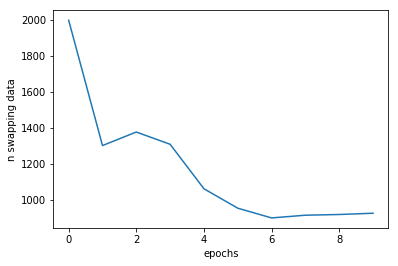

In [10]:
import matplotlib.pyplot as plt
import numpy as np

epoch = 10
fig = plt.figure()
plt.plot(np.arange(epoch), [len(t) for t in atob], label="A to B")
# plt.plot(np.arange(epoch), btoa_s, label="B to A", linestyle="--")
plt.xlabel("epochs")
plt.ylabel("n swapping data")
# plt.title("compare accuracy")
# plt.legend()
plt.show()
fig.savefig("swapdata.png")

In [38]:
atob_10 = [arr[arr<10].tolist() for arr in [np.array(arr) for arr in atob]]
btoa_10 = [arr[arr<10].tolist() for arr in [np.array(arr) for arr in btoa]]
swap_10 = [a + b for a, b in zip(atob_10, btoa_10)]

In [48]:
list = [0] * 10
history = []
for swap in swap_10:
    history.append(list.copy())
    for idx in swap:
        list[idx] = 1^list[idx]
history = np.array(history).transpose()

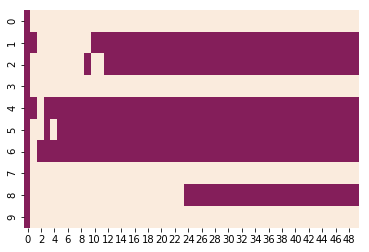

In [66]:
import numpy as np 
import seaborn as sns

sns.heatmap(data=history, vmin=-0.5, vmax=1.0, cbar=False)
plt.savefig("swap_map.png")

In [23]:
x_acc = [17.284, 10.28, 3.248, 0.868, 0.356, 0.38, 0.668, 0.28, 3.16, 4.804, 1.3, 2.264, 0.908, 0.796, 1.304, 2.828, 0.52, 0.112, 0.46, 0.512, 0.404, 0.616, 0.412, 0.516, 0.188, 0.092, 8.304, 0.212, 0.016, 0.008, 0.008, 0.016, 0.028, 0.004, 0.004, 0.048, 0.004, 0.04, 0.08, 0.008, 0.004, 0.0, 0.0, 0.0, 0.016, 0.0, 0.008, 0.024, 0.0, 0.0]
y_acc = [15.18, 12.512, 6.224, 10.456, 7.496, 8.832, 9.036, 8.74, 9.492, 11.904, 10.776, 18.356, 19.396, 14.376, 18.32, 19.676, 22.156, 24.38, 20.264, 18.184, 22.896, 22.2, 24.34, 23.696, 24.22, 21.676, 23.908, 18.508, 14.216, 14.72, 15.76, 15.984, 16.084, 17.232, 19.576, 13.468, 13.048, 23.128, 16.516, 12.332, 14.68, 15.856, 16.808, 16.172, 14.372, 16.348, 14.656, 14.936, 16.632, 16.564]
base_acc = [16.916, 17.968, 26.404, 37.068, 46.044, 47.796, 45.772, 59.0, 53.648, 60.98, 62.824, 62.072, 63.396, 65.208, 67.544, 68.816, 68.904, 70.144, 69.968, 69.156, 70.184, 72.668, 72.548, 75.412, 73.792, 73.728, 74.52, 73.996, 74.76, 74.056, 75.688, 76.584, 76.66, 75.88, 75.86, 75.484, 77.168, 77.432, 77.048, 76.912, 78.072, 77.324, 76.32, 76.744, 78.272, 78.888, 77.788, 78.432, 78.592, 79.012]

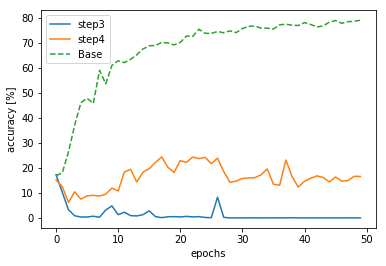

In [68]:
import matplotlib.pyplot as plt
import numpy as np

epoch = 50
fig = plt.figure()
plt.plot(np.arange(epoch), x_acc, label="step3")
plt.plot(np.arange(epoch), y_acc, label="step4")
plt.plot(np.arange(epoch), base_acc, label="Base", linestyle="--")
plt.xlabel("epochs")
plt.ylabel("accuracy [%]")
# plt.title("compare accuracy")
plt.legend()
plt.show()
fig.savefig("accuracy.png")

In [12]:
x_acc_r = [[10.18, 10.78, 12.3, 13.92, 14.8, 16.52, 17.52, 18.5, 17.22, 16.44, 16.96, 17.68, 15.94, 21.38, 20.72, 16.86, 22.98, 24.7, 27.38, 25.18, 28.84, 30.02, 29.48, 32.84, 39.04, 38.2, 40.86, 38.46, 45.66, 43.28], [11.66, 10.04, 11.52, 10.58, 16.42, 15.96, 16.68, 17.52, 17.36, 17.26, 16.84, 17.48, 19.92, 21.1, 21.02, 21.92, 23.86, 24.48, 25.82, 29.16, 32.1, 33.68, 35.5, 37.4, 41.2, 41.12, 42.96, 41.34, 43.24, 47.12], [9.74, 9.74, 9.74, 9.86, 18.08, 18.12, 18.52, 19.1, 18.94, 18.5, 19.14, 20.92, 23.86, 24.58, 23.82, 27.4, 27.22, 29.84, 29.84, 31.32, 33.2, 37.6, 35.26, 40.76, 36.1, 39.64, 43.78, 40.34, 40.26, 44.7], [9.9, 9.9, 9.92, 10.08, 11.06, 14.78, 17.56, 18.04, 18.22, 18.54, 17.9, 18.94, 18.14, 20.42, 22.78, 23.38, 22.0, 26.36, 24.54, 28.44, 29.66, 32.74, 34.3, 37.4, 35.0, 41.36, 41.48, 42.0, 42.1, 44.64], [10.24, 10.88, 13.0, 14.14, 15.1, 16.18, 17.38, 17.02, 17.42, 18.26, 18.2, 22.72, 22.84, 22.98, 24.48, 23.22, 27.36, 30.86, 29.3, 32.9, 34.26, 33.08, 36.14, 38.88, 37.14, 41.42, 45.08, 44.96, 43.0, 48.74], [9.28, 11.56, 15.42, 17.36, 17.48, 17.84, 17.76, 16.86, 14.94, 16.98, 17.48, 17.5, 17.6, 19.7, 18.66, 22.18, 30.88, 31.0, 35.64, 34.22, 34.78, 33.3, 39.66, 40.82, 37.48, 41.04, 40.42, 42.42, 44.64, 45.14], [10.5, 12.48, 16.32, 15.82, 17.22, 17.64, 17.56, 17.22, 17.04, 17.18, 18.36, 19.6, 21.58, 22.48, 21.6, 25.08, 25.14, 27.2, 26.06, 30.84, 32.96, 37.88, 35.6, 34.32, 37.98, 40.66, 43.7, 40.12, 45.4, 44.62], [10.22, 10.22, 10.22, 10.22, 10.22, 10.16, 18.26, 18.38, 16.96, 15.22, 15.64, 15.04, 17.48, 19.38, 21.68, 23.82, 24.74, 27.24, 29.2, 30.98, 34.16, 34.24, 35.74, 38.22, 32.82, 39.56, 40.16, 41.66, 41.18, 43.28], [10.74, 11.5, 12.66, 13.9, 15.54, 17.16, 17.74, 17.0, 16.6, 15.4, 15.82, 18.82, 17.92, 21.34, 22.9, 24.26, 24.92, 24.44, 29.08, 30.66, 28.66, 35.3, 32.5, 35.92, 39.26, 42.18, 44.26, 44.22, 41.56, 44.46], [10.02, 10.02, 10.34, 9.98, 19.06, 17.64, 17.28, 17.16, 16.62, 15.8, 13.46, 15.82, 16.38, 19.18, 22.1, 23.28, 23.04, 31.06, 34.62, 30.26, 34.86, 39.22, 39.98, 37.54, 40.66, 43.22, 44.5, 45.58, 47.46, 46.62]]
y_acc_r = [[10.4, 10.4, 10.46, 10.64, 12.3, 15.24, 16.42, 16.6, 15.68, 15.26, 15.48, 14.74, 15.8, 19.04, 18.18, 21.9, 21.6, 22.66, 23.3, 26.3, 33.94, 32.26, 34.04, 35.86, 31.18, 41.72, 37.72, 42.78, 43.06, 44.16], [10.2, 10.24, 13.08, 11.86, 10.08, 10.26, 13.92, 19.2, 17.98, 18.06, 15.62, 14.46, 19.0, 20.64, 17.24, 21.72, 23.86, 28.76, 31.16, 25.76, 36.78, 36.46, 37.44, 41.32, 41.26, 40.06, 42.3, 43.22, 47.12, 49.76], [9.96, 13.04, 14.16, 15.08, 16.42, 17.68, 18.18, 18.06, 17.5, 21.0, 20.44, 23.26, 22.36, 23.64, 23.9, 25.2, 29.2, 29.98, 28.14, 31.92, 34.94, 34.06, 35.96, 32.6, 37.54, 40.06, 38.1, 44.24, 42.42, 45.16], [9.96, 9.94, 10.04, 11.54, 18.52, 18.14, 18.12, 18.12, 16.82, 15.98, 17.94, 17.0, 20.02, 20.06, 20.18, 27.14, 27.42, 27.48, 29.92, 35.96, 35.78, 33.02, 36.68, 38.0, 43.34, 40.46, 44.6, 43.32, 43.94, 45.12], [10.66, 13.9, 15.82, 14.56, 16.8, 17.24, 17.54, 17.86, 16.2, 16.0, 16.04, 15.9, 20.1, 21.56, 24.54, 22.84, 26.42, 23.24, 27.96, 28.82, 31.32, 31.96, 35.14, 36.04, 37.6, 40.28, 40.08, 44.3, 44.1, 44.22], [10.34, 10.46, 12.56, 13.98, 15.26, 16.36, 16.9, 17.1, 17.04, 16.42, 16.62, 16.34, 16.96, 16.92, 20.66, 21.44, 23.78, 22.6, 23.56, 25.58, 22.16, 28.88, 30.1, 34.8, 36.04, 37.54, 40.28, 34.86, 41.42, 41.98], [10.02, 10.02, 10.02, 10.36, 9.54, 16.22, 19.32, 19.14, 19.54, 19.3, 19.22, 19.94, 20.44, 22.38, 20.66, 27.18, 29.02, 33.76, 34.0, 34.94, 37.02, 38.42, 37.64, 41.04, 36.76, 42.04, 42.72, 45.52, 41.4, 45.06], [11.2, 12.32, 13.06, 14.62, 16.12, 17.56, 17.58, 17.66, 17.0, 15.46, 16.04, 15.52, 15.56, 16.36, 18.7, 21.24, 20.98, 23.2, 23.38, 22.66, 30.26, 32.32, 35.44, 34.16, 33.86, 33.76, 38.18, 41.86, 42.06, 44.76], [9.64, 9.7, 9.88, 9.78, 10.72, 17.72, 17.94, 18.3, 18.02, 17.7, 16.82, 16.18, 18.2, 19.2, 21.18, 23.66, 25.7, 21.52, 28.44, 28.8, 33.16, 33.94, 37.82, 36.2, 43.02, 41.02, 44.3, 46.2, 45.94, 46.64], [9.74, 10.06, 11.92, 17.88, 17.24, 17.42, 17.14, 16.22, 16.94, 18.52, 20.46, 22.04, 23.12, 23.58, 25.12, 26.04, 30.14, 29.4, 29.4, 32.66, 32.32, 37.14, 34.7, 39.9, 36.16, 39.56, 41.66, 41.1, 41.18, 41.78]]

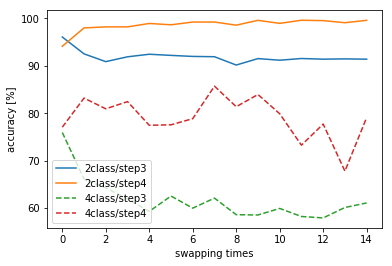

In [10]:
import matplotlib.pyplot as plt
import numpy as np

epoch = len(x_acc)
fig = plt.figure()
plt.plot(np.arange(epoch), [np.array(t)[-1] for t in x_acc2], label="2class/step3")
plt.plot(np.arange(epoch), [np.array(t)[-1] for t in y_acc2], label="2class/step4")
plt.plot(np.arange(epoch), [np.array(t)[-1] for t in x_acc4], label="4class/step3", linestyle="--")
plt.plot(np.arange(epoch), [np.array(t)[-1] for t in y_acc4], label="4class/step4", linestyle="--")
# plt.plot(np.arange(epoch), base_acc, label="Base", linestyle="--")
plt.xlabel("swapping times")
plt.ylabel("accuracy [%]")
# plt.title("compare accuracy")
plt.legend()
plt.show()
fig.savefig("accuracy.png")

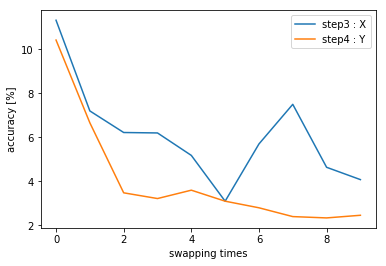

In [5]:
import matplotlib.pyplot as plt
import numpy as np

epoch = 10
fig = plt.figure()
plt.plot(np.arange(epoch), [np.array(t)[0] for t in x_acc], label="step3 : X")
plt.plot(np.arange(epoch), [np.array(t)[0] for t in y_acc], label="step4 : Y")
# plt.plot(np.arange(epoch), base_acc, label="Base", linestyle="--")
plt.xlabel("swapping times")
plt.ylabel("accuracy [%]")
# plt.title("compare accuracy")
plt.legend()
plt.show()
fig.savefig("accuracy_start.png")

In [2]:
labels = [2, 6, 9, 1, 8, 7, 3, 4, 8, 6, 4, 1, 6, 2, 3, 3, 3, 7, 6, 9, 5, 2, 5, 6, 3, 5, 3, 2, 5, 6, 5, 0, 8, 8, 7, 8, 4, 0, 9, 1, 6, 1, 4, 8, 3, 0, 1, 0, 7, 6, 2, 7, 7, 8, 9, 7, 8, 6, 1, 3, 0, 2, 3, 9, 4, 1, 6, 1, 1, 7, 3, 4, 0, 2, 4, 1, 3, 0, 1, 4, 6, 9, 5, 0, 4, 9, 5, 8, 5, 1, 8, 0, 2, 9, 2, 5, 4, 7, 1, 8, 7, 6, 3, 8, 6, 4, 2, 1, 2, 2, 6, 4, 1, 1, 7, 1, 7, 3, 2, 2, 7, 4, 2, 8, 8, 8, 2, 2, 9, 6, 6, 7, 7, 3, 4, 8, 5, 9, 5, 5, 4, 0, 4, 1, 3, 1, 4, 6, 6, 2, 7, 7, 1, 4, 0, 2, 0, 0, 1, 1, 6, 7, 4, 6, 5, 0, 6, 6, 5, 1, 9, 3, 7, 8, 0, 5, 8, 9, 3, 0, 1, 9, 3, 8, 9, 5, 5, 0, 7, 6, 1, 6, 4, 5, 2, 6, 3, 3, 8, 7, 4, 1, 8, 6, 4, 7, 7, 6, 4, 5, 0, 9, 1, 3, 0, 3, 9, 4, 0, 8, 0, 6, 7, 0, 3, 6, 9, 7, 4, 6, 9, 8, 2, 0, 1, 4, 7, 2, 6, 9, 2, 9, 9, 7, 8, 6, 0, 0, 9, 0, 9, 9, 8, 5, 6, 8, 1, 3, 1, 7, 8, 8, 4, 6, 7, 1, 5, 2, 9, 1, 7, 0, 9, 5, 0, 4, 9, 1, 3, 9, 0, 3, 2, 1, 8, 8, 6, 0, 9, 6, 8, 3, 2, 2, 6, 6, 0, 8, 4, 0, 3, 9, 3, 2, 9, 2, 3, 9, 6, 0, 7, 5, 4, 1, 8, 5, 7, 0, 3, 8, 9, 2, 1, 1, 0, 3, 3, 8, 2, 2, 5, 8, 6, 2, 1, 1, 9, 1, 1, 1, 5, 6, 0, 9, 0, 9, 2, 2, 6, 5, 1, 7, 5, 7, 2, 9, 5, 3, 2, 4, 9, 7, 5, 8, 6, 5, 8, 8, 8, 8, 3, 7, 2, 0, 1, 7, 0, 7, 9, 3, 2, 5, 8, 5, 1, 3, 8, 7, 8, 8, 1, 4, 5, 9, 2, 3, 9, 9, 3, 9, 3, 8, 7, 4, 5, 3, 8, 5, 1, 0, 4, 2, 6, 1, 3, 3, 9, 7, 3, 8, 9, 6, 3, 4, 6, 8, 7, 0, 9, 0, 8, 9, 9, 0, 4, 8, 5, 7, 6, 7, 1, 6, 6, 8, 5, 3, 3, 9, 9, 9, 8, 6, 1, 5, 3, 2, 5, 1, 3, 6, 3, 8, 9, 6, 2, 1, 5, 7, 3, 4, 7, 3, 4, 8, 0, 9, 9, 1, 7, 3, 4, 2, 3, 0, 6, 6, 7, 0, 2, 6, 5, 2, 7, 2, 4, 5, 0, 8, 7, 3, 6, 2, 7, 8, 7, 5, 9, 6, 5, 7, 0, 5, 9, 9, 2, 4, 3, 5, 6, 9, 1, 9, 9, 3, 4, 1, 6, 2, 6, 2, 2, 6, 8, 1, 5, 6, 3, 2, 0, 0, 8, 0, 3, 7, 8, 2, 9, 9, 6, 2, 4, 7, 4, 5, 8, 3, 0, 9, 4, 2, 0, 7, 4, 4, 2, 1, 0, 0, 9, 9, 7, 8, 7, 3, 8, 4, 0, 8, 9, 9, 6, 3, 0, 5, 0, 6, 0, 1, 6, 6, 1, 4, 4, 7, 9, 6, 4, 6, 4, 3, 9, 0, 0, 8, 8, 7, 1, 4, 6, 4, 3, 1, 6, 4, 6, 2, 6, 3, 6, 2, 4, 4, 0, 5, 4, 6, 5, 1, 0, 3, 3, 4, 9, 7, 4, 2, 3, 2, 1, 9, 9, 2, 9, 2, 0, 0, 7, 3, 6, 6, 6, 1, 2, 0, 6, 9, 9, 5, 2, 3, 3, 4, 2, 8, 9, 0, 9, 6, 0, 4, 8, 0, 7, 0, 7, 1, 0, 3, 6, 6, 2, 3, 7, 6, 5, 5, 2, 8, 7, 8, 9, 5, 0, 2, 1, 3, 6, 0, 0, 7, 3, 6, 6, 1, 2, 0, 8, 0, 7, 1, 3, 1, 3, 0, 6, 5, 3, 4, 1, 5, 3, 1, 0, 7, 6, 8, 4, 7, 7, 1, 1, 9, 6, 0, 9, 6, 0, 6, 4, 4, 2, 0, 3, 6, 0, 9, 7, 5, 3, 4, 4, 6, 2, 6, 8, 9, 7, 1, 3, 7, 0, 2, 2, 1, 6, 7, 1, 3, 3, 4, 3, 4, 7, 1, 2, 3, 9, 5, 9, 1, 0, 5, 8, 9, 8, 5, 0, 5, 3, 0, 8, 1, 9, 6, 8, 1, 1, 1, 4, 1, 1, 9, 2, 9, 3, 0, 1, 6, 4, 6, 3, 2, 4, 0, 9, 6, 3, 8, 8, 9, 1, 6, 9, 7, 6, 7, 7, 2, 8, 2, 1, 2, 2, 7, 5, 9, 1, 4, 4, 6, 1, 2, 9, 4, 4, 6, 8, 1, 0, 3, 3, 8, 9, 8, 3, 3, 6, 1, 6, 2, 7, 0, 4, 7, 6, 8, 4, 8, 0, 0, 6, 5, 9, 0, 6, 2, 5, 8, 0, 3, 2, 4, 2, 0, 3, 9, 9, 5, 0, 5, 3, 7, 0, 9, 4, 8, 1, 4, 1, 1, 4, 7, 9, 7, 5, 4, 5, 1, 2, 1, 5, 5, 3, 7, 1, 0, 4, 0, 8, 9, 0, 1, 8, 4, 7, 3, 6, 9, 7, 2, 2, 1, 4, 4, 1, 4, 1, 6, 0, 0, 2, 7, 8, 5, 4, 5, 4, 2, 3, 4, 1, 0, 2, 7, 6, 0, 3, 2, 2, 0, 0, 5, 4, 0, 7, 2, 9, 4, 2, 1, 5, 5, 3, 3, 3, 6, 8, 5, 7, 4, 1, 1, 5, 5, 6, 3, 4, 1, 4, 1, 7, 0, 5, 0, 0, 0, 5, 6, 9, 0, 5, 8, 3, 7, 4, 6, 9, 6, 9, 3, 4, 8, 7, 6, 0, 6, 2, 9, 3, 9, 1, 0, 9, 5, 8, 7, 6, 6, 9, 1, 1, 7, 5, 1, 2, 6, 0, 3, 6, 0, 5, 0, 3, 1, 2, 9, 4, 5, 1, 5, 2, 5, 0, 9, 5, 8, 8, 9, 2, 7, 6, 6, 5, 7, 9, 9, 4, 4, 2, 0, 3, 6, 4, 9, 2, 0, 9, 7, 8, 3, 7, 7, 8, 5, 9, 2, 9, 3, 0, 1, 7, 6, 9, 8, 4, 9, 8, 9, 2, 6, 7, 3, 2, 1, 8, 5, 2, 7, 6, 5, 0, 5, 8, 7, 7, 4, 3, 1, 0, 0, 2, 4, 4, 9, 3, 7, 1, 1, 1, 2, 8, 7, 0, 9, 4, 4, 9, 4, 3, 2, 8, 2, 0, 6, 9, 4, 7, 1, 8, 0, 7, 3, 8, 9, 5, 1, 2, 0, 5, 7, 3, 6, 6, 1, 0, 3, 6, 7, 8, 7, 4, 3, 9, 8, 3, 4, 8, 7, 5, 9, 7, 6, 7, 3, 7, 1, 3, 3, 2, 0, 5, 8, 5, 6, 9, 5, 7, 8, 3, 9, 2, 8, 1, 8, 0, 9, 6, 6, 8, 4, 9, 4, 2, 9, 4, 5, 7, 9, 4, 1, 5, 8, 0, 2, 7, 6, 7, 9, 1, 1, 1, 9, 9, 3, 1, 2, 5, 5, 0, 7, 6, 7, 2, 5, 9, 3, 9, 8, 3, 0, 4, 2, 0, 2, 6, 2, 1, 1, 1, 3, 7, 6, 2, 8, 3, 6, 4, 1, 7, 6, 4, 7, 1, 8, 0, 2, 8, 1, 5, 0, 5, 3, 2, 0, 9, 2, 4, 4, 2, 9, 2, 4, 6, 2, 1, 0, 2, 8, 5, 0, 2, 8, 5, 0, 0, 9, 7, 3, 4, 6, 3, 6, 9, 9, 1, 8, 5, 5, 2, 1, 0, 2, 3, 1, 1, 9, 5, 1, 4, 2, 4, 4, 4, 8, 8, 3, 9, 8, 7, 3, 6, 2, 9, 4, 1, 7, 3, 5, 8, 0, 0, 2, 6, 5, 8, 0, 3, 8, 1, 9, 1, 8, 6, 1, 9, 1, 8, 0, 2, 0, 4, 3, 6, 0, 5, 3, 0, 5, 8, 5, 1, 3, 5, 0, 9, 4, 9, 9, 3, 5, 3, 5, 6, 6, 8, 3, 8, 4, 1, 6, 6, 3, 0, 8, 3, 3, 9, 2, 7, 0, 1, 1, 7, 6, 1, 0, 1, 6, 0, 7, 3, 9, 2, 9, 3, 6, 7, 2, 1, 4, 3, 9, 3, 1, 2, 3, 0, 7, 5, 7, 5, 6, 7, 0, 9, 7, 9, 3, 2, 6, 2, 2, 6, 4, 8, 3, 0, 8, 9, 4, 6, 4, 7, 6, 8, 3, 5, 6, 2, 8, 7, 6, 6, 7, 0, 4, 4, 8, 7, 6, 6, 2, 8, 0, 5, 8, 1, 6, 7, 3, 5, 7, 9, 7, 0, 4, 9, 2, 8, 3, 2, 6, 5, 8, 1, 1, 5, 6, 0, 4, 6, 1, 9, 7, 2, 3, 9, 2, 8, 5, 4, 3, 1, 3, 1, 0, 7, 4, 0, 1, 7, 0, 7, 8, 9, 8, 8, 9, 3, 4, 8, 7, 9, 8, 1, 4, 5, 4, 4, 7, 2, 1, 9, 1, 6, 8, 4, 4, 8, 5, 8, 4, 5, 7, 1, 9, 1, 6, 5, 7, 0, 5, 9, 9, 8, 2, 7, 6, 2, 7, 3, 9, 8, 5, 0, 4, 4, 0, 3, 7, 6, 3, 6, 3, 6, 4, 0, 6, 3, 7, 2, 0, 5, 9, 8, 7, 6, 5, 0, 5, 7, 0, 3, 3, 0, 6, 3, 1, 7, 9, 6, 9, 1, 7, 4, 4, 8, 4, 9, 8, 7, 7, 4, 8, 4, 2, 6, 6, 0, 6, 9, 5, 0, 3, 9, 7, 4, 9, 3, 5, 2, 4, 7, 1, 9, 6, 5, 8, 3, 7, 9, 3, 4, 2, 3, 6, 8, 7, 7, 8, 7, 8, 1, 6, 8, 6, 0, 9, 3, 4, 7, 7, 2, 1, 7, 5, 8, 0, 4, 7, 4, 3, 3, 8, 8, 6, 5, 9, 3, 4, 9, 6, 1, 5, 6, 0, 9, 0, 8, 7, 1, 1, 7, 1, 0, 3, 9, 0, 3, 7, 1, 9, 4, 0, 2, 7, 9, 6, 1, 1, 9, 7, 7, 6, 3, 2, 1, 0, 5, 8, 3, 7, 3, 0, 7, 1, 9, 9, 4, 7, 7, 5, 2, 1, 6, 1, 9, 6, 7, 3, 0, 3, 0, 8, 1, 3, 4, 9, 9, 7, 8, 6, 7, 9, 4, 7, 8, 8, 3, 9, 4, 9, 7, 1, 2, 2, 0, 1, 7, 1, 6, 7, 6, 8, 1, 1, 0, 8, 6, 2, 6, 9, 7, 3, 5, 0, 3, 0, 0, 7, 4, 4, 3, 7, 5, 7, 3, 2, 9, 2, 8, 8, 8, 3, 9, 7, 4, 4, 1, 1, 7, 0, 8, 4, 7, 6, 2, 5, 5, 2, 3, 9, 6, 5, 8, 3, 6, 0, 4, 4, 5, 1, 9, 2, 2, 6, 7, 8, 5, 3, 8, 4, 6, 2, 9, 1, 3, 3, 1, 5, 9, 1, 4, 6, 0, 3, 7, 2, 6, 2, 6, 7, 1, 1, 4, 7, 1, 4, 8, 5, 0, 8, 1, 9, 2, 4, 8, 0, 3, 3, 1, 4, 6, 1, 9, 1, 1, 0, 6, 7, 3, 0, 2, 9, 3, 5, 2, 4, 3, 9, 0, 0, 9, 9, 1, 7, 5, 1, 0, 9, 7, 3, 5, 5, 4, 6, 9, 5, 7, 3, 6, 0, 3, 1, 4, 7, 1, 4, 0, 1, 7, 4, 1, 2, 5, 4, 0, 8, 3, 3, 0, 8, 4, 0, 1, 6, 8, 5, 3, 5, 7, 2, 8, 5, 2, 0, 9, 9, 3, 1, 1, 5, 3, 8, 8, 9, 1, 2, 2, 2, 3, 2, 7, 1, 3, 0, 8, 2, 2, 3, 3, 5, 7, 9, 0, 0, 4, 8, 7, 8, 9, 0, 2, 6, 1, 7, 4, 3, 1, 0, 1, 1, 6, 2, 3, 1, 7, 4, 3, 4, 5, 8, 0, 4, 4, 2, 3, 1, 1, 5, 5, 0, 3, 5, 9, 2, 1, 8, 4, 7, 2, 9, 8, 1, 3, 3, 8, 8, 5, 3, 4, 7, 3, 2, 2, 0, 4, 9, 8, 8, 4, 7, 3, 5, 3, 7, 4, 4, 8, 3, 4, 8, 1, 7, 9, 8, 0, 2, 7, 0, 5, 7, 1, 0, 2, 6, 1, 8, 5, 7, 7, 0, 5, 8, 4, 0, 8, 0, 6, 1, 1, 1, 7, 2, 4, 9, 0, 6, 1, 2, 4, 0, 1, 6, 0, 9, 2, 4, 6, 1, 2, 8, 5, 4, 5, 9, 8, 5, 6, 4, 5, 4, 5, 1, 2, 9, 2, 9, 3, 0, 0, 1, 0, 6, 6, 2, 2, 0, 2, 0, 9, 7, 0, 2, 1, 7, 3, 5, 8, 7, 2, 7, 3, 5, 9, 8, 0, 3, 1, 5, 9, 0, 7, 8, 3, 6, 6, 6, 3, 7, 3, 3, 6, 2, 4, 0, 6, 2, 5, 5, 1, 8, 1, 8, 2, 1, 0, 9, 9, 9, 0, 2, 2, 1, 5, 4, 2, 9, 2, 1, 3, 7, 2, 4, 5, 7, 5, 3, 9, 4, 0, 5, 5, 0, 7, 7, 5, 3, 3, 3, 5, 3, 0, 9, 5, 1, 3, 5, 5, 1, 2, 2, 1, 8, 7, 9, 6, 3, 7, 4, 8, 7, 2, 2, 9, 1, 6, 5, 7, 7, 1, 5, 0, 5, 9, 0, 3, 2, 9, 5, 1, 9, 6, 7, 7, 3, 8, 2, 6, 1, 1, 9, 2, 6, 4, 8, 7, 2, 9, 3, 1, 2, 4, 3, 1, 6, 3, 6, 9, 0, 1, 6, 4, 0, 4, 2, 1, 7, 3, 1, 4, 4, 4, 3, 5, 4, 3, 2, 7, 6, 8, 2, 2, 1, 6, 3, 3, 6, 5, 1, 4, 8, 5, 7, 0, 2, 8, 9, 1, 7, 6, 1, 8, 2, 2, 2, 6, 7, 8, 3, 5, 0, 2, 2, 1, 0, 3, 0, 7, 6, 5, 0, 6, 3, 9, 8, 1, 4, 8, 5, 3, 2, 8, 3, 6, 9, 1, 6, 2, 6, 9, 1, 8, 8, 6, 7, 5, 5, 5, 9, 2, 4, 2, 4, 9, 0, 1, 3, 7, 7, 5, 8, 9, 2, 1, 3, 4, 0, 5, 0, 7, 0, 8, 1, 7, 5, 2, 3, 0, 8, 5, 1, 5, 5, 9, 9, 8, 8, 7, 5, 1, 5, 6, 0, 5, 0, 5, 2, 6, 3, 1, 8, 5, 3, 3, 7, 8, 1, 0, 4, 9, 0, 4, 6, 3, 7, 5, 9, 5, 6, 8, 9, 2, 4, 7, 5, 6, 0, 1, 3, 4, 0, 2, 0, 0, 9, 6, 2, 2, 0, 2, 5, 1, 0, 4, 5, 1, 6, 9, 5, 7, 6, 9, 5, 8, 6, 5, 8, 4, 5, 2, 4, 0, 8, 0, 2, 4, 7, 4, 6, 7, 1, 5, 0, 8, 4, 5, 0, 5, 2, 2, 2, 1, 4, 3, 5, 0, 3, 9, 0, 4, 4, 8, 6, 4, 5, 1, 6, 2, 6, 8, 9, 2, 4, 6, 7, 0, 6, 9, 4, 0, 6, 4, 3, 9, 6, 6, 6, 2, 1, 2, 7, 1, 7, 4, 3, 3, 2, 2, 2, 0, 6, 8, 7, 2, 4, 8, 2, 3, 7, 5, 9, 2, 1, 7, 1, 2, 5, 3, 8, 6, 2, 8, 4, 8, 7, 4, 4, 7, 2, 9, 8, 5, 7, 5, 9, 0, 0, 6, 8, 4, 8, 9, 1, 5, 7, 6, 3, 6, 5, 1, 6, 8, 4, 2, 7, 7, 6, 5, 6, 4, 5, 7, 7, 7, 7, 7, 3, 9, 5, 4, 3, 6, 5, 2, 0, 2, 7, 4, 3, 8, 0, 9, 9, 7, 4, 5, 8, 8, 6, 0, 5, 6, 8, 8, 0, 7, 1, 2, 9, 2, 9, 4, 8, 1, 7, 6, 8, 7, 7, 7, 0, 0, 5, 4, 8, 2, 5, 4, 3, 9, 4, 4, 8, 4, 6, 8, 9, 1, 0, 9, 6, 8, 6, 6, 0, 1, 8, 1, 2, 8, 5, 1, 3, 5, 6, 7, 1, 7, 5, 0, 8, 3, 6, 4, 4, 4, 2, 1, 0, 2, 7, 8, 3, 6, 8, 6, 4, 4, 8, 6, 8, 7, 3, 2, 3, 9, 6, 1, 1, 3, 5, 0, 2, 4, 2, 5, 8, 3, 7, 1, 1, 1, 9, 2, 0, 9, 1, 7, 6, 8, 6, 0, 1, 5, 6, 3, 2, 3, 0, 4, 9, 7, 9, 2, 8, 8, 4, 5, 9, 6, 3, 6, 6, 2, 9, 5, 6, 2, 8, 4, 5, 1, 6, 3, 6, 9, 3, 7, 8, 3, 5, 0, 0, 6, 2, 9, 7, 5, 6, 6, 4, 3, 2, 0, 9, 9, 3, 2, 9, 0, 1, 4, 3, 2, 1, 1, 6, 9, 6, 1, 7, 1, 7, 1, 8, 9, 4, 4, 4, 8, 2, 5, 4, 0, 5, 0, 7, 6, 4, 9, 8, 5, 1, 5, 1, 4, 0, 6, 0, 6, 7, 2, 2, 6, 5, 8, 1, 5, 7, 4, 3, 3, 0, 2, 7, 7, 5, 0, 6, 0, 0, 9, 5, 0, 6, 6, 0, 8, 5, 0, 2, 0, 1, 8, 9, 6, 8, 6, 6, 6, 5, 6, 4, 3, 9, 5, 3, 0, 2, 2, 3, 0, 5, 5, 7, 0, 4, 3, 7, 3, 3, 6, 6, 8, 8, 1, 8, 5, 6, 9, 0, 5, 1, 4, 9, 3, 1, 6, 9, 2, 3, 3, 3, 9, 6, 3, 9, 9, 7, 2, 3, 5, 7, 4, 5, 0, 6, 5, 2, 0, 3, 6, 6, 5, 4, 6, 1, 1, 4, 0, 3, 4, 5, 6, 0, 0, 3, 8, 9, 6, 8, 0, 1, 4, 9, 3, 7, 5, 4, 2, 8, 1, 7, 4, 7, 7, 2, 7, 6, 6, 1, 3, 5, 9, 3, 1, 2, 3, 3, 9, 2, 3, 1, 0, 0, 1, 3, 8, 6, 9, 3, 3, 5, 3, 2, 6, 7, 7, 3, 3, 7, 9, 5, 8, 9, 6, 1, 0, 5, 0, 3, 2, 4, 5, 2, 0, 4, 0, 1, 0, 1, 5, 5, 0, 2, 4, 5, 7, 0, 2, 2, 1, 2, 2, 9, 7, 9, 4, 9, 2, 5, 3, 8, 9, 1, 1, 0, 8, 6, 4, 0, 1, 0, 2, 4, 3, 7, 2, 6, 7, 6, 5, 0, 9, 3, 9, 3, 1, 0, 7, 4, 6, 6, 7, 2, 1, 1, 0, 2, 1, 9, 3, 4, 7, 2, 5, 0, 3, 6, 3, 2, 6, 2, 1, 8, 8, 1, 0, 2, 0, 5, 0, 7, 1, 4, 1, 1, 8, 8, 8, 4, 6, 0, 8, 9, 9, 8, 3, 0, 5, 4, 2, 9, 7, 4, 7, 2, 5, 3, 8, 4, 7, 2, 4, 8, 6, 1, 1, 8, 6, 6, 7, 5, 5, 2, 4, 5, 4, 7, 0, 6, 1, 0, 6, 4, 0, 6, 7, 5, 1, 3, 7, 7, 8, 3, 5, 2, 1, 3, 0, 8, 7, 2, 9, 6, 6, 1, 1, 4, 5, 4, 6, 2, 5, 7, 9, 8, 3, 6, 4, 0, 8, 1, 6, 9, 6, 7, 2, 3, 0, 3, 9, 4, 1, 9, 0, 4, 1, 0, 8, 1, 3, 2, 4, 2, 5, 0, 7, 2, 9, 5, 9, 0, 6, 1, 4, 2, 3, 6, 9, 4, 7, 1, 5, 9, 5, 2, 1, 9, 6, 7, 6, 5, 7, 0, 5, 0, 3, 9, 4, 9, 9, 2, 4, 2, 2, 5, 7, 0, 3, 8, 2, 6, 3, 2, 6, 6, 6, 2, 5, 9, 4, 8, 6, 6, 7, 1, 3, 7, 2, 3, 4, 7, 4, 3, 1, 5, 7, 8, 1, 7, 3, 3, 5, 8, 2, 8, 4, 1, 2, 8, 3, 4, 5, 5, 4, 7, 4, 6, 3, 1, 0, 2, 0, 8, 5, 6, 4, 7, 5, 3, 8, 0, 5, 3, 3, 4, 4, 0, 9, 7, 0, 0, 3, 1, 6, 4, 9, 5, 4, 2, 7, 2, 1, 9, 8, 4, 4, 1, 9, 8, 2, 7, 6, 4, 0, 3, 3, 9, 3, 4, 9, 4, 2, 3, 6, 6, 2, 5, 3, 8, 2, 1, 3, 8, 3, 2, 4, 5, 2, 7, 0, 2, 5, 8, 2, 5, 6, 1, 5, 5, 5, 4, 8, 7, 7, 9, 0, 7, 3, 0, 6, 1, 6, 8, 2, 0, 2, 3, 3, 1, 4, 1, 6, 8, 6, 1, 8, 4, 2, 5, 8, 8, 3, 5, 5, 4, 2, 4, 4, 6, 7, 0, 3, 3, 2, 9, 6, 0, 6, 6, 2, 0, 0, 6, 3, 0, 3, 2, 2, 9, 0, 5, 5, 0, 5, 0, 6, 9, 4, 8, 6, 3, 8, 4, 4, 5, 0, 5, 8, 6, 5, 1, 7, 0, 6, 9, 9, 0, 0, 5, 9, 2, 2, 6, 1, 7, 8, 8, 5, 4, 6, 0, 1, 9, 2, 9, 4, 3, 9, 1, 1, 8, 2, 0, 2, 4, 5, 8, 8, 8, 4, 1, 9, 1, 8, 1, 7, 5, 5, 9, 1, 5, 5, 0, 4, 1, 0, 9, 9, 2, 7, 0, 5, 7, 5, 5, 7, 4, 1, 2, 7, 5, 1, 6, 9, 6, 0, 7, 4, 7, 2, 7, 2, 1, 2, 5, 5, 1, 6, 8, 0, 5, 2, 0, 8, 1, 9, 6, 5, 5, 8, 6, 6, 6, 8, 1, 7, 7, 9, 1, 5, 3, 9, 8, 5, 3, 9, 3, 5, 2, 6, 0, 7, 2, 8, 8, 3, 3, 7, 6, 7, 4, 0, 7, 2, 3, 2, 7, 0, 6, 7, 7, 5, 7, 6, 5, 7, 1, 5, 3, 5, 5, 0, 8, 2, 7, 0, 3, 3, 4, 1, 0, 5, 8, 3, 1, 4, 9, 8, 7, 6, 9, 3, 2, 4, 0, 8, 8, 1, 2, 3, 9, 8, 0, 0, 0, 8, 5, 2, 0, 0, 8, 4, 7, 4, 5, 4, 3, 0, 2, 5, 8, 1, 4, 5, 1, 7, 2, 6, 0, 5, 0, 0, 1, 4, 9, 9, 8, 2, 8, 5, 8, 7, 5, 9, 6, 0, 2, 3, 3, 0, 7, 3, 4, 5, 6, 7, 3, 5, 7, 3, 8, 2, 9, 0, 3, 2, 0, 0, 0, 1, 6, 8, 9, 3, 7, 0, 1, 2, 9, 0, 9, 2, 4, 4, 6, 3, 3, 4, 5, 7, 9, 3, 0, 8, 1, 8, 8, 1, 9, 2, 3, 5, 8, 1, 5, 1, 2, 8, 2, 3, 6, 1, 8, 3, 6, 1, 7, 5, 3, 6, 6, 7, 7, 2, 4, 8, 2, 5, 7, 2, 2, 8, 7, 2, 3, 1, 2, 7, 7, 8, 5, 7, 6, 4, 8, 8, 1, 8, 7, 1, 6, 5, 9, 3, 8, 5, 8, 7, 4, 4, 8, 7, 6, 7, 6, 9, 9, 3, 3, 8, 1, 1, 5, 4, 5, 7, 6, 6, 6, 8, 7, 2, 0, 9, 9, 8, 7, 8, 1, 9, 3, 8, 7, 4, 7, 0, 2, 8, 8, 9, 5, 4, 3, 9, 9, 0, 3, 5, 1, 7, 3, 2, 9, 6, 8, 9, 9, 0, 3, 7, 0, 8, 9, 9, 7, 5, 6, 0, 2, 1, 0, 8, 1, 7, 8, 3, 8, 8, 3, 8, 5, 3, 3, 2, 9, 3, 8, 0, 6, 9, 3, 6, 4, 8, 2, 3, 7, 8, 1, 4, 1, 6, 9, 6, 4, 2, 1, 0, 9, 1, 3, 8, 4, 7, 3, 1, 7, 9, 6, 7, 3, 0, 0, 2, 6, 8, 7, 4, 1, 5, 7, 4, 7, 0, 6, 5, 2, 8, 0, 4, 7, 1, 7, 7, 6, 0, 7, 1, 8, 6, 6, 6, 4, 4, 5, 1, 2, 5, 9, 4, 1, 9, 0, 2, 8, 9, 5, 0, 8, 1, 7, 8, 9, 1, 4, 4, 1, 5, 2, 6, 1, 6, 4, 8, 3, 8, 1, 7, 6, 6, 4, 2, 8, 3, 9, 4, 6, 8, 7, 7, 4, 9, 7, 7, 8, 9, 7, 6, 5, 6, 3, 1, 3, 1, 8, 9, 6, 5, 5, 8, 8, 0, 5, 9, 6, 5, 6, 4, 3, 1, 1, 1, 5, 2, 2, 7, 2, 9, 2, 8, 0, 3, 9, 2, 3, 2, 5, 7, 7, 3, 8, 6, 6, 7, 7, 2, 4, 1, 2, 0, 2, 5, 2, 4, 5, 8, 8, 1, 1, 8, 9, 6, 1, 3, 2, 1, 6, 9, 0, 9, 6, 5, 2, 4, 9, 9, 6, 6, 5, 7, 3, 8, 8, 2, 8, 7, 5, 1, 8, 5, 5, 3, 9, 8, 9, 3, 2, 1, 6, 8, 9, 0, 3, 9, 4, 1, 5, 0, 2, 1, 9, 4, 4, 4, 9, 9, 7, 2, 5, 5, 2, 8, 8, 5, 1, 5, 9, 3, 0, 9, 5, 5, 2, 6, 2, 9, 9, 7, 0, 0, 2, 9, 1, 4, 7, 9, 5, 9, 5, 3, 3, 2, 6, 9, 3, 8, 3, 9, 5, 9, 3, 8, 1, 8, 1, 5, 1, 1, 3, 6, 4, 0, 8, 8, 1, 3, 9, 5, 6, 9, 1, 8, 9, 8, 6, 2, 4, 9, 8, 2, 4, 8, 9, 6, 2, 7, 6, 5, 0, 7, 3, 0, 7, 7, 4, 7, 3, 7, 3, 6, 2, 5, 6, 7, 1, 7, 1, 7, 6, 9, 0, 1, 0, 7, 3, 2, 0, 6, 1, 1, 8, 5, 6, 8, 6, 9, 8, 8, 0, 5, 8, 3, 8, 4, 4, 2, 1, 2, 9, 2, 7, 5, 0, 5, 0, 2, 9, 1, 6, 8, 1, 5, 4, 6, 3, 5, 9, 9, 1, 9, 8, 7, 6, 5, 8, 2, 2, 5, 3, 1, 5, 1, 4, 5, 9, 9, 4, 2, 4, 8, 4, 5, 0, 5, 0, 8, 5, 7, 3, 3, 8, 7, 4, 1, 3, 1, 9, 3, 9, 6, 4, 2, 5, 9, 8, 1, 7, 1, 3, 9, 3, 8, 7, 0, 1, 8, 0, 0, 6, 0, 4, 3, 2, 8, 9, 7, 0, 8, 1, 2, 0, 4, 9, 1, 2, 6, 0, 2, 6, 5, 7, 9, 4, 8, 3, 1, 7, 9, 2, 2, 3, 6, 8, 3, 9, 2, 8, 6, 3, 5, 2, 0, 6, 0, 5, 8, 6, 5, 6, 8, 7, 7, 9, 0, 8, 3, 4, 1, 6, 8, 8, 4, 5, 8, 5, 2, 6, 2, 8, 3, 6, 0, 4, 4, 1, 9, 6, 4, 0, 0, 1, 3, 5, 0, 2, 8, 8, 2, 9, 3, 1, 6, 0, 0, 8, 8, 9, 4, 9, 7, 5, 0, 6, 6, 4, 1, 8, 5, 8, 9, 8, 0, 6, 9, 6, 7, 0, 5, 4, 1, 4, 2, 6, 2, 1, 1, 1, 4, 2, 0, 6, 8, 2, 7, 2, 7, 3, 0, 8, 6, 6, 2, 5, 1, 6, 3, 4, 4, 7, 1, 0, 0, 7, 8, 4, 4, 9, 9, 5, 0, 9, 5, 5, 8, 8, 3, 7, 8, 4, 2, 2, 7, 9, 7, 4, 5, 7, 3, 0, 3, 8, 0, 8, 6, 9, 8, 0, 3, 3, 8, 5, 4, 1, 9, 2, 3, 9, 3, 1, 4, 6, 9, 2, 6, 7, 7, 3, 6, 3, 8, 3, 4, 4, 0, 0, 8, 4, 3, 8, 9, 8, 4, 8, 5, 8, 6, 4, 7, 9, 0, 3, 9, 8, 6, 4, 3, 0, 2, 2, 7, 6, 3, 8, 3, 8, 3, 0, 1, 3, 2, 3, 2, 8, 6, 2, 1, 0, 4, 6, 6, 4, 6, 9, 9, 6, 5, 3, 4, 0, 5, 7, 1, 2, 2, 6, 1, 9, 8, 2, 8, 4, 1, 1, 2, 8, 0, 1, 8, 6, 4, 7, 4, 7, 2, 7, 1, 4, 5, 1, 2, 8, 9, 6, 5, 5, 0, 9, 7, 1, 3, 5, 0, 6, 1, 4, 7, 6, 4, 0, 3, 0, 4, 9, 3, 4, 8, 2, 8, 1, 9, 0, 5, 2, 3, 2, 8, 1, 4, 0, 6, 7, 3, 1, 7, 2, 7, 3, 5, 6, 0, 3, 3, 0, 0, 1, 1, 3, 6, 7, 1, 9, 2, 8, 8, 9, 4, 8, 8, 0, 8, 0, 9, 4, 6, 1, 9, 2, 6, 0, 3, 0, 9, 4, 3, 8, 9, 6, 3, 5, 6, 0, 4, 6, 4, 3, 2, 8, 9, 2, 6, 3, 4, 3, 0, 0, 1, 0, 3, 3, 2, 0, 6, 2, 2, 1, 4, 3, 0, 3, 7, 8, 8, 1, 8, 1, 9, 8, 2, 7, 4, 9, 0, 7, 7, 3, 6, 1, 6, 0, 4, 1, 9, 4, 3, 6, 5, 7, 1, 6, 0, 0, 2, 8, 4, 5, 9, 1, 4, 8, 9, 5, 3, 4, 9, 9, 9, 5, 7, 4, 1, 9, 5, 3, 9, 3, 1, 6, 0, 9, 8, 8, 1, 0, 5, 1, 5, 0, 0, 9, 2, 4, 6, 6, 9, 3, 1, 4, 8, 9, 0, 9, 2, 1, 1, 3, 1, 5, 1, 9, 9, 9, 4, 8, 8, 7, 9, 7, 6, 5, 8, 0, 4, 1, 9, 2, 8, 7, 0, 6, 5, 4, 9, 9, 0, 2, 0, 6, 6, 3, 8, 3, 6, 0, 3, 6, 3, 9, 3, 4, 5, 3, 2, 3, 9, 1, 7, 7, 5, 2, 9, 8, 9, 9, 5, 4, 2, 2, 3, 6, 3, 0, 7, 6, 4, 3, 5, 4, 3, 2, 1, 7, 2, 6, 9, 1, 8, 4, 7, 4, 4, 6, 6, 3, 5, 8, 5, 2, 8, 0, 6, 9, 0, 3, 4, 9, 1, 8, 8, 2, 2, 3, 8, 5, 2, 2, 2, 8, 3, 7, 1, 2, 2, 0, 3, 3, 0, 7, 9, 8, 8, 6, 1, 3, 1, 6, 8, 2, 5, 7, 9, 5, 3, 3, 0, 2, 2, 5, 1, 5, 8, 5, 3, 1, 5, 9, 4, 8, 9, 4, 6, 5, 8, 9, 9, 8, 5, 6, 2, 1, 1, 7, 4, 9, 8, 5, 8, 3, 7, 7, 6, 5, 4, 5, 0, 3, 2, 5, 2, 7, 0, 2, 2, 2, 5, 1, 2, 9, 4, 7, 4, 1, 9, 6, 6, 3, 5, 2, 4, 1, 0, 3, 0, 0, 9, 2, 0, 7, 8, 5, 8, 9, 0, 1, 5, 2, 2, 0, 1, 2, 2, 7, 9, 2, 9, 1, 8, 5, 2, 3, 0, 1, 2, 2, 4, 5, 4, 8, 0, 0, 0, 1, 9, 2, 8, 9, 1, 7, 1, 9, 0, 2, 1, 4, 6, 4, 4, 0, 6, 4, 6, 9, 8, 1, 0, 2, 5, 4, 3, 0, 4, 7, 0, 7, 5, 2, 5, 4, 7, 2, 8, 4, 0, 5, 3, 5, 8, 2, 6, 1, 1, 2, 9, 2, 8, 0, 0, 0, 4, 9, 2, 1, 9, 9, 8, 2, 2, 8, 7, 3, 6, 7, 5, 2, 2, 3, 9, 7, 8, 8, 8, 6, 2, 4, 4, 9, 6, 6, 8, 9, 0, 1, 8, 4, 6, 4, 5, 5, 2, 9, 4, 0, 7, 7, 5, 0, 7, 8, 8, 4, 1, 1, 3, 9, 1, 1, 1, 2, 5, 7, 3, 1, 8, 9, 4, 5, 5, 6, 6, 5, 3, 3, 1, 2, 5, 1, 0, 2, 6, 9, 4, 7, 2, 4, 7, 1, 2, 9, 8, 3, 9, 2, 0, 7, 3, 4, 1, 0, 4, 6, 8, 2, 2, 8, 3, 7, 7, 5, 6, 7, 1, 3, 3, 8, 7, 9, 0, 8, 5, 5, 4, 9, 3, 2, 8, 4, 9, 5, 0, 7, 3, 8, 1, 8, 1, 4, 0, 4, 5, 9, 0, 2, 9, 8, 0, 2, 7, 8, 1, 0, 7, 3, 0, 1, 2, 0, 3, 2, 4, 2, 1, 5, 9, 0, 8, 0, 9, 4, 7, 0, 2, 2, 8, 2, 1, 4, 9, 7, 0, 4, 8, 5, 3, 1, 4, 1, 8, 4, 5, 8, 7, 9, 5, 5, 7, 0, 4, 2, 4, 2, 3, 3, 6, 1, 6, 9, 0, 7, 3, 9, 7, 3, 0, 0, 2, 2, 6, 4, 3, 2, 2, 1, 9, 4, 9, 1, 6, 1, 1, 7, 9, 4, 1, 4, 5, 3, 9, 9, 2, 7, 4, 5, 8, 2, 6, 5, 3, 7, 9, 9, 9, 1, 4, 5, 5, 5, 9, 0, 1, 8, 3, 3, 0, 6, 1, 4, 1, 3, 4, 4, 4, 8, 2, 3, 0, 2, 9, 9, 7, 4, 5, 0, 8, 0, 1, 4, 4, 3, 1, 8, 0, 9, 5, 8, 3, 4, 7, 0, 4, 6, 3, 6, 6, 1, 9, 7, 6, 2, 3, 3, 1, 2, 1, 4, 8, 9, 2, 8, 4, 7, 4, 5, 9, 2, 2, 7, 9, 7, 1, 2, 8, 2, 8, 6, 6, 0, 8, 2, 4, 8, 8, 1, 7, 3, 6, 5, 7, 7, 2, 4, 4, 0, 2, 4, 8, 6, 8, 4, 6, 2, 7, 9, 9, 9, 1, 7, 2, 6, 5, 2, 1, 4, 3, 6, 9, 3, 9, 8, 6, 1, 8, 2, 4, 9, 8, 3, 1, 4, 8, 9, 0, 6, 0, 0, 2, 7, 7, 4, 4, 7, 0, 3, 7, 7, 5, 1, 4, 2, 3, 2, 3, 8, 2, 8, 7, 7, 4, 8, 1, 8, 2, 2, 8, 9, 0, 7, 6, 8, 9, 6, 1, 9, 2, 8, 0, 1, 9, 3, 0, 3, 2, 7, 4, 8, 3, 8, 6, 6, 7, 2, 8, 3, 3, 9, 9, 0, 2, 1, 4, 6, 6, 9, 9, 6, 5, 1, 2, 0, 2, 3, 0, 2, 6, 7, 7, 4, 4, 0, 7, 2, 0, 0, 8, 5, 8, 0, 5, 2, 4, 2, 4, 4, 2, 8, 4, 6, 9, 5, 4, 9, 7, 6, 5, 6, 7, 0, 4, 0, 3, 7, 2, 8, 2, 3, 4, 3, 3, 4, 3, 0, 1, 6, 5, 5, 2, 1, 7, 3, 8, 8, 9, 2, 5, 2, 0, 6, 8, 4, 9, 6, 5, 1, 7, 7, 4, 0, 6, 1, 9, 9, 3, 5, 1, 0, 6, 7, 1, 5, 5, 7, 4, 0, 7, 1, 0, 4, 1, 4, 9, 3, 9, 6, 1, 3, 9, 7, 0, 4, 0, 1, 4, 2, 7, 5, 1, 5, 6, 0, 7, 9, 6, 4, 2, 3, 8, 3, 0, 0, 3, 9, 3, 7, 8, 0, 5, 2, 3, 8, 8, 3, 5, 9, 6, 3, 0, 0, 6, 1, 3, 4, 6, 2, 0, 4, 1, 6, 2, 7, 1, 6, 4, 5, 7, 9, 8, 0, 4, 3, 5, 5, 9, 3, 8, 2, 7, 3, 2, 7, 2, 4, 9, 4, 3, 0, 8, 3, 6, 6, 0, 0, 0, 2, 8, 1, 9, 6, 8, 0, 5, 2, 4, 3, 5, 5, 7, 2, 4, 2, 0, 5, 7, 7, 8, 8, 6, 8, 8, 6, 5, 8, 3, 2, 8, 3, 6, 0, 7, 2, 9, 8, 5, 0, 0, 4, 8, 8, 5, 8, 2, 7, 7, 9, 2, 0, 0, 3, 0, 8, 4, 8, 1, 1, 4, 8, 0, 4, 5, 7, 3, 4, 6, 7, 9, 7, 7, 0, 7, 9, 7, 1, 7, 0, 0, 3, 9, 7, 9, 7, 5, 8, 3, 3, 0, 3, 3, 9, 9, 2, 3, 8, 3, 4, 5, 2, 4, 9, 5, 1, 5, 1, 5, 7, 1, 8, 9, 1, 1, 8, 5, 7, 5, 9, 7, 2, 9, 6, 8, 0, 6, 2, 2, 1, 1, 7, 7, 1, 6, 0, 0, 4, 1, 3, 6, 2, 8, 6, 0, 2, 7, 0, 7, 7, 2, 4, 1, 2, 6, 0, 6, 7, 8, 1, 8, 2, 3, 5, 9, 5, 7, 0, 7, 7, 8, 6, 1, 2, 3, 2, 1, 7, 3, 6, 2, 2, 3, 8, 1, 4, 6, 3, 0, 6, 4, 3, 7, 3, 4, 9, 8, 6, 5, 8, 2, 8, 4, 9, 0, 9, 4, 1, 3, 0, 7, 7, 6, 7, 6, 6, 3, 2, 9, 7, 1, 7, 0, 7, 7, 7, 2, 2, 7, 0, 9, 8, 1, 6, 3, 6, 5, 6, 6, 8, 9, 0, 2, 2, 9, 7, 8, 2, 8, 9, 5, 9, 6, 1, 7, 8, 4, 9, 7, 9, 6, 6, 0, 6, 0, 4, 9, 5, 4, 3, 5, 4, 2, 1, 6, 8, 1, 1, 3, 1, 4, 6, 2, 9, 3, 5, 3, 7, 2, 2, 2, 0, 9, 7, 2, 8, 0, 0, 8, 2, 7, 2, 6, 6, 9, 0, 1, 4, 7, 3, 9, 0, 0, 6, 9, 2, 2, 4, 5, 3, 9, 4, 8, 5, 7, 8, 7, 6, 1, 3, 0, 8, 6, 4, 7, 7, 6, 9, 5, 4, 0, 9, 0, 1, 3, 4, 8, 0, 5, 5, 0, 0, 4, 4, 4, 0, 3, 6, 1, 1, 3, 5, 2, 2, 7, 0, 4, 2, 6, 6, 7, 4, 9, 3, 2, 8, 6, 1, 1, 0, 0, 2, 1, 7, 8, 1, 6, 9, 8, 4, 6, 9, 5, 6, 2, 9, 2, 8, 2, 0, 9, 8, 2, 4, 5, 1, 6, 0, 0, 6, 7, 5, 8, 2, 6, 6, 3, 3, 6, 6, 7, 8, 8, 0, 6, 7, 5, 4, 3, 5, 7, 8, 7, 3, 1, 5, 6, 3, 6, 6, 2, 7, 8, 4, 3, 6, 6, 1, 6, 8, 8, 0, 3, 6, 9, 0, 3, 8, 7, 6, 3, 6, 4, 1, 1, 1, 0, 5, 4, 1, 3, 4, 5, 5, 9, 2, 4, 7, 8, 2, 6, 8, 4, 9, 7, 5, 1, 5, 6, 6, 7, 4, 2, 4, 4, 0, 9, 3, 7, 0, 9, 3, 2, 4, 4, 6, 0, 2, 2, 5, 1, 2, 2, 8, 8, 9, 6, 9, 9, 6, 1, 7, 8, 5, 1, 6, 9, 6, 9, 4, 2, 6, 0, 7, 2, 6, 9, 7, 1, 4, 3, 5, 1, 0, 9, 1, 2, 9, 1, 3, 0, 4, 4, 2, 5, 5, 9, 6, 3, 9, 6, 3, 9, 6, 4, 7, 9, 8, 5, 6, 1, 8, 0, 3, 2, 3, 8, 8, 0, 6, 9, 8, 4, 3, 0, 4, 8, 1, 6, 2, 2, 7, 2, 1, 4, 4, 0, 3, 3, 3, 9, 9, 0, 5, 2, 8, 4, 6, 4, 2, 0, 9, 5, 5, 4, 5, 6, 1, 1, 8, 5, 9, 5, 0, 7, 8, 5, 4, 8, 1, 0, 9, 2, 0, 2, 7, 0, 1, 6, 8, 4, 8, 1, 9, 9, 6, 4, 4, 0, 6, 1, 0, 2, 5, 4, 7, 3, 6, 3, 4, 1, 3, 8, 7, 4, 4, 7, 2, 3, 1, 6, 7, 2, 6, 2, 7, 9, 6, 6, 1, 1, 4, 8, 6, 8, 4, 5, 6, 9, 5, 7, 8, 1, 7, 3, 1, 4, 7, 0, 0, 6, 0, 6, 4, 5, 7, 7, 6, 1, 1, 8, 8, 4, 4, 2, 9, 4, 0, 2, 9, 6, 6, 3, 3, 3, 3, 8, 2, 2, 7, 4, 7, 4, 7, 1, 9, 3, 6, 4, 9, 5, 3, 2, 6, 1, 2, 2, 0, 6, 2, 2, 5, 4, 9, 7, 4, 4, 6, 8, 9, 2, 6, 4, 1, 3, 9, 8, 4, 9, 6, 1, 8, 7, 0, 4, 9, 0, 5, 9, 9, 3, 2, 9, 4, 4, 8, 5, 8, 1, 1, 5, 8, 5, 9, 9, 6, 4, 5, 4, 7, 1, 9, 1, 2, 2, 2, 0, 3, 5, 8, 3, 8, 8, 0, 8, 2, 5, 9, 3, 2, 3, 4, 9, 3, 8, 9, 6, 2, 0, 9, 4, 4, 3, 7, 3, 5, 0, 0, 9, 8, 3, 6, 5, 6, 6, 3, 0, 6, 9, 8, 5, 8, 5, 0, 4, 2, 5, 2, 1, 2, 0, 7, 6, 4, 3, 8, 6, 5, 4, 7, 3, 5, 1, 9, 6, 6, 0, 3, 1, 9, 8, 8, 3, 2, 0, 1, 9, 4, 3, 8, 4, 2, 9, 4, 7, 0, 0, 1, 6, 2, 3, 7, 3, 8, 6, 6, 1, 0, 7, 2, 6, 0, 5, 6, 9, 9, 8, 7, 4, 1, 1, 9, 7, 7, 8, 6, 5, 9, 4, 0, 3, 8, 5, 8, 2, 4, 2, 1, 0, 2, 8, 8, 7, 7, 6, 2, 6, 7, 6, 6, 7, 9, 5, 2, 4, 3, 9, 8, 8, 4, 8, 6, 2, 2, 5, 5, 5, 6, 0, 0, 6, 9, 6, 4, 6, 3, 1, 1, 4, 7, 3, 1, 0, 7, 3, 7, 5, 4, 2, 4, 9, 1, 8, 1, 1, 8, 6, 7, 7, 1, 6, 6, 4, 7, 0, 0, 5, 7, 3, 7, 8, 8, 0, 5, 5, 6, 7, 5, 2, 4, 3, 9, 1, 5, 6, 4, 1, 2, 3, 1, 8, 4, 9, 3, 3, 9, 7, 7, 4, 5, 9, 4, 8, 6, 9, 0, 8, 0, 2, 0, 5, 7, 0, 7, 5, 1, 6, 7, 8, 2, 3, 2, 3, 2, 0, 3, 3, 2, 4, 6, 3, 9, 9, 9, 5, 0, 3, 2, 8, 0, 5, 9, 6, 6, 0, 9, 2, 2, 0, 1, 7, 2, 7, 9, 1, 8, 2, 3, 9, 2, 9, 2, 3, 1, 0, 2, 5, 1, 6, 1, 0, 4, 3, 3, 8, 3, 4, 0, 6, 8, 2, 9, 1, 1, 0, 6, 6, 5, 6, 0, 9, 6, 5, 2, 2, 2, 5, 2, 4, 2, 6, 3, 7, 3, 7, 7, 7, 5, 7, 5, 5, 3, 0, 7, 7, 5, 5, 2, 4, 1, 1, 3, 7, 8, 2, 8, 7, 9, 8, 2, 5, 4, 6, 1, 9, 3, 4, 4, 2, 0, 7, 9, 5, 2, 8, 0, 1, 9, 9, 8, 1, 2, 2, 8, 5, 6, 7, 4, 9, 7, 7, 4, 9, 3, 5, 3, 2, 0, 5, 3, 0, 5, 6, 0, 5, 0, 4, 1, 1, 8, 6, 7, 6, 2, 4, 4, 9, 6, 0, 3, 2, 7, 9, 9, 9, 3, 9, 6, 4, 7, 6, 8, 9, 4, 4, 5, 1, 0, 9, 2, 6, 1, 3, 9, 9, 9, 8, 7, 7, 0, 4, 8, 9, 9, 7, 4, 8, 6, 4, 8, 3, 1, 2, 2, 4, 4, 3, 0, 6, 9, 5, 4, 9, 2, 0, 9, 2, 1, 0, 3, 8, 3, 6, 7, 6, 3, 6, 1, 5, 7, 4, 0, 6, 2, 7, 9, 3, 0, 8, 7, 6, 5, 2, 4, 0, 2, 5, 8, 5, 8, 5, 8, 7, 9, 7, 3, 1, 6, 2, 2, 4, 0, 6, 6, 1, 5, 6, 4, 3, 6, 4, 9, 2, 0, 5, 0, 9, 9, 6, 4, 8, 8, 9, 4, 2, 8, 6, 8, 6, 5, 3, 3, 2, 8, 4, 9, 1, 2, 4, 2, 5, 4, 5, 3, 8, 2, 4, 6, 8, 9, 6, 1, 3, 1, 3, 6, 5, 4, 6, 6, 3, 6, 8, 6, 2, 2, 9, 8, 5, 8, 9, 2, 8, 3, 6, 8, 0, 8, 4, 9, 7, 4, 8, 3, 0, 1, 5, 4, 6, 7, 0, 4, 3, 3, 8, 1, 0, 6, 8, 8, 9, 5, 4, 0, 0, 6, 2, 8, 1, 7, 3, 3, 4, 8, 6, 1, 6, 0, 6, 5, 0, 7, 5, 1, 8, 9, 8, 7, 6, 7, 9, 3, 3, 4, 6, 5, 0, 3, 7, 9, 1, 0, 3, 0, 3, 7, 4, 7, 6, 4, 8, 2, 4, 4, 3, 6, 0, 8, 6, 8, 1, 6, 3, 0, 9, 7, 9, 1, 5, 3, 3, 2, 4, 1, 1, 1, 4, 0, 8, 6, 9, 5, 8, 8, 2, 1, 2, 0, 2, 0, 1, 5, 4, 7, 4, 2, 0, 1, 3, 5, 4, 1, 6, 4, 0, 7, 7, 7, 3, 8, 9, 6, 3, 2, 6, 7, 4, 2, 4, 4, 9, 8, 3, 1, 0, 1, 2, 6, 0, 3, 6, 1, 4, 3, 5, 7, 5, 3, 3, 8, 8, 7, 0, 4, 1, 7, 4, 4, 4, 1, 4, 8, 6, 4, 3, 8, 1, 2, 7, 5, 6, 0, 3, 6, 4, 1, 1, 6, 8, 8, 2, 4, 0, 3, 5, 6, 8, 6, 9, 3, 2, 3, 7, 6, 1, 1, 9, 8, 8, 7, 9, 7, 4, 8, 3, 9, 8, 1, 3, 5, 1, 0, 7, 3, 1, 3, 5, 4, 6, 6, 1, 5, 6, 4, 9, 5, 1, 9, 6, 7, 1, 5, 1, 6, 4, 3, 1, 9, 4, 0, 8, 6, 2, 9, 5, 9, 8, 8, 8, 3, 0, 2, 8, 3, 9, 2, 0, 1, 4, 8, 8, 3, 5, 8, 5, 9, 9, 0, 6, 0, 3, 2, 1, 5, 9, 1, 0, 9, 0, 5, 1, 5, 3, 5, 7, 6, 6, 7, 9, 3, 2, 0, 8, 5, 5, 8, 1, 3, 5, 9, 7, 4, 1, 1, 3, 6, 7, 8, 4, 7, 3, 2, 7, 3, 8, 7, 0, 0, 1, 3, 8, 3, 3, 3, 1, 6, 9, 1, 5, 2, 7, 7, 0, 3, 7, 8, 7, 6, 8, 1, 7, 7, 2, 1, 2, 3, 4, 8, 7, 4, 8, 1, 4, 9, 5, 2, 2, 4, 9, 9, 4, 3, 0, 0, 9, 4, 1, 5, 9, 0, 1, 5, 6, 9, 8, 6, 3, 0, 2, 1, 7, 4, 4, 7, 7, 2, 3, 2, 9, 5, 3, 1, 2, 9, 5, 8, 6, 4, 0, 6, 9, 4, 8, 8, 7, 2, 6, 9, 9, 7, 6, 1, 9, 0, 9, 6, 0, 0, 2, 3, 9, 5, 4, 4, 8, 4, 6, 3, 8, 4, 4, 5, 9, 4, 8, 2, 4, 1, 3, 1, 4, 4, 6, 6, 5, 7, 9, 3, 7, 7, 8, 7, 4, 0, 8, 8, 4, 0, 5, 1, 3, 3, 2, 4, 7, 6, 8, 9, 0, 8, 3, 9, 5, 1, 3, 5, 6, 2, 0, 6, 9, 3, 3, 1, 4, 3, 0, 4, 9, 2, 7, 3, 5, 1, 7, 5, 5, 8, 6, 8, 5, 1, 9, 0, 1, 3, 3, 7, 9, 0, 4, 0, 3, 5, 1, 5, 9, 7, 3, 4, 7, 4, 6, 8, 7, 9, 7, 9, 4, 9, 6, 2, 4, 7, 6, 7, 5, 5, 5, 8, 4, 5, 1, 7, 0, 5, 0, 5, 2, 1, 2, 6, 9, 6, 7, 6, 8, 2, 7, 6, 3, 8, 5, 4, 3, 3, 6, 3, 1, 5, 8, 3, 3, 4, 6, 0, 2, 0, 1, 4, 5, 2, 1, 4, 9, 0, 5, 2, 3, 9, 6, 5, 5, 3, 7, 0, 8, 8, 2, 4, 8, 7, 5, 3, 5, 6, 8, 0, 9, 4, 2, 2, 0, 6, 7, 3, 2, 0, 2, 4, 8, 2, 3, 3, 9, 5, 0, 3, 7, 0, 5, 3, 8, 8, 4, 6, 6, 8, 4, 1, 5, 2, 1, 1, 7, 4, 7, 9, 8, 1, 5, 5, 7, 9, 4, 7, 5, 2, 0, 3, 1, 5, 1, 0, 0, 7, 8, 7, 7, 3, 5, 9, 3, 4, 8, 6, 9, 3, 5, 5, 9, 8, 0, 9, 9, 7, 8, 3, 6, 5, 1, 5, 7, 9, 4, 5, 0, 4, 5, 6, 2, 0, 9, 2, 6, 8, 2, 0, 0, 7, 7, 0, 9, 4, 7, 7, 5, 2, 4, 8, 9, 8, 3, 3, 8, 9, 5, 5, 8, 9, 2, 9, 6, 2, 2, 2, 8, 4, 5, 2, 9, 2, 6, 4, 2, 0, 5, 7, 7, 3, 5, 5, 6, 2, 4, 6, 9, 3, 7, 5, 9, 2, 1, 9, 1, 4, 7, 2, 1, 7, 3, 4, 5, 3, 8, 7, 8, 4, 3, 2, 2, 3, 0, 2, 4, 2, 4, 9, 0, 6, 4, 7, 5, 9, 0, 5, 5, 8, 0, 5, 7, 7, 8, 7, 6, 0, 7, 9, 5, 7, 3, 8, 7, 6, 0, 4, 4, 4, 3, 9, 1, 6, 5, 1, 0, 7, 6, 7, 7, 0, 9, 1, 4, 4, 5, 9, 3, 2, 2, 7, 3, 7, 1, 5, 4, 2, 2, 4, 2, 7, 6, 1, 3, 4, 4, 3, 1, 7, 6, 5, 0, 2, 6, 8, 8, 1, 8, 5, 4, 8, 9, 4, 9, 9, 3, 5, 3, 1, 6, 5, 6, 7, 2, 5, 7, 3, 5, 2, 4, 2, 0, 3, 5, 6, 8, 7, 7, 1, 1, 3, 8, 1, 4, 7, 3, 0, 8, 4, 2, 3, 2, 6, 3, 9, 6, 8, 2, 4, 7, 1, 2, 5, 1, 6, 2, 9, 0, 0, 8, 7, 8, 2, 7, 6, 1, 4, 8, 7, 8, 7, 3, 1, 6, 9, 2, 1, 0, 0, 6, 1, 5, 4, 2, 4, 2, 2, 1, 7, 3, 5, 1, 5, 7, 7, 8, 0, 3, 5, 9, 2, 3, 3, 8, 6, 9, 2, 6, 5, 0, 1, 2, 2, 2, 1, 1, 9, 1, 0, 5, 2, 8, 8, 9, 9, 4, 9, 4, 7, 5, 8, 2, 8, 0, 9, 9, 0, 6, 4, 5, 3, 5, 9, 0, 3, 0, 2, 5, 0, 5, 7, 2, 9, 5, 8, 0, 8, 9, 8, 9, 2, 2, 2, 3, 9, 9, 7, 0, 6, 0, 6, 8, 0, 7, 9, 0, 4, 4, 6, 0, 5, 9, 8, 8, 0, 1, 7, 9, 1, 5, 7, 8, 9, 4, 0, 4, 6, 6, 2, 9, 3, 1, 2, 4, 6, 7, 5, 2, 9, 4, 5, 0, 1, 5, 4, 8, 6, 3, 9, 3, 5, 1, 0, 9, 8, 2, 5, 0, 9, 7, 4, 3, 3, 1, 7, 3, 9, 3, 8, 1, 9, 3, 6, 0, 8, 8, 2, 3, 0, 6, 6, 6, 5, 6, 5, 9, 2, 8, 9, 3, 3, 1, 1, 5, 4, 9, 6, 8, 8, 7, 8, 2, 8, 6, 9, 0, 8, 6, 0, 7, 4, 9, 7, 1, 0, 4, 7, 8, 1, 0, 2, 8, 8, 8, 0, 0, 8, 8, 8, 2, 3, 7, 2, 6, 2, 7, 7, 2, 0, 1, 1, 8, 7, 4, 5, 0, 4, 7, 6, 8, 1, 2, 1, 9, 6, 4, 0, 4, 8, 1, 1, 3, 9, 5, 1, 9, 8, 0, 1, 3, 9, 7, 0, 2, 3, 6, 7, 8, 5, 5, 8, 2, 2, 0, 2, 3, 5, 8, 8, 4, 4, 3, 6, 2, 1, 4, 3, 1, 2, 4, 7, 6, 7, 9, 0, 8, 0, 8, 6, 7, 0, 9, 9, 2, 4, 4, 6, 3, 8, 3, 7, 3, 9, 4, 9, 6, 2, 2, 7, 0, 5, 4, 9, 4, 1, 0, 1, 5, 4, 1, 6, 2, 5, 4, 6, 5, 8, 8, 7, 4, 8, 4, 1, 6, 6, 0, 9, 3, 6, 3, 1, 4, 5, 1, 0, 7, 0, 5, 7, 8, 5, 4, 0, 0, 2, 6, 3, 8, 0, 6, 4, 7, 8, 8, 4, 0, 6, 0, 2, 5, 8, 7, 2, 5, 7, 0, 7, 9, 5, 2, 3, 5, 3, 4, 7, 3, 8, 7, 5, 5, 6, 2, 9, 6, 3, 8, 8, 7, 3, 5, 2, 9, 6, 5, 7, 1, 1, 5, 0, 1, 9, 1, 9, 3, 0, 3, 1, 0, 5, 4, 5, 8, 9, 8, 4, 3, 5, 8, 9, 4, 2, 0, 4, 8, 0, 8, 3, 1, 0, 1, 4, 0, 9, 7, 8, 3, 8, 7, 6, 4, 4, 9, 1, 8, 6, 9, 1, 2, 2, 9, 7, 3, 4, 5, 1, 7, 2, 4, 0, 4, 8, 6, 4, 8, 5, 1, 3, 4, 1, 7, 3, 5, 4, 9, 7, 4, 4, 3, 7, 7, 1, 1, 3, 7, 3, 0, 6, 6, 1, 2, 6, 5, 1, 6, 3, 6, 7, 4, 7, 3, 2, 3, 0, 0, 1, 0, 7, 6, 1, 0, 2, 8, 3, 3, 2, 7, 1, 0, 1, 7, 3, 9, 9, 9, 8, 0, 2, 8, 7, 8, 8, 6, 4, 0, 9, 2, 0, 8, 2, 5, 5, 8, 8, 0, 6, 0, 7, 6, 9, 5, 1, 0, 7, 6, 2, 6, 6, 5, 3, 7, 2, 0, 1, 6, 3, 2, 4, 2, 2, 7, 6, 1, 8, 7, 2, 3, 1, 5, 9, 2, 4, 9, 5, 0, 3, 3, 5, 4, 9, 2, 8, 7, 0, 7, 4, 5, 8, 1, 3, 6, 9, 1, 2, 9, 8, 0, 9, 4, 5, 6, 2, 2, 2, 4, 6, 9, 2, 9, 8, 6, 6, 2, 1, 1, 8, 0, 1, 6, 5, 3, 5, 7, 8, 2, 1, 3, 1, 4, 2, 2, 9, 5, 5, 0, 2, 0, 3, 6, 4, 9, 9, 7, 8, 3, 5, 4, 9, 8, 2, 0, 8, 3, 7, 3, 3, 3, 3, 1, 7, 8, 7, 0, 6, 0, 2, 5, 9, 8, 0, 2, 2, 4, 3, 5, 1, 0, 2, 5, 2, 6, 0, 7, 6, 1, 6, 6, 6, 1, 7, 0, 7, 0, 1, 5, 3, 3, 2, 6, 2, 6, 7, 2, 3, 5, 2, 8, 3, 6, 1, 7, 0, 1, 8, 0, 2, 1, 8, 0, 7, 2, 5, 4, 5, 7, 5, 9, 3, 7, 6, 9, 2, 7, 1, 8, 6, 1, 8, 7, 3, 8, 2, 4, 4, 9, 8, 9, 4, 5, 2, 0, 4, 4, 3, 3, 3, 6, 2, 7, 6, 8, 2, 1, 6, 8, 8, 4, 0, 9, 3, 7, 3, 7, 9, 6, 4, 5, 2, 8, 0, 9, 0, 0, 8, 4, 2, 7, 6, 9, 0, 8, 0, 2, 5, 7, 5, 1, 1, 3, 6, 8, 9, 4, 8, 1, 4, 8, 9, 8, 0, 1, 4, 7, 1, 7, 5, 2, 6, 1, 2, 3, 3, 5, 6, 4, 5, 5, 5, 5, 3, 1, 3, 1, 2, 5, 9, 3, 2, 0, 9, 8, 0, 5, 8, 3, 9, 3, 4, 8, 0, 3, 6, 1, 6, 1, 5, 0, 7, 8, 4, 1, 3, 2, 6, 0, 6, 3, 0, 4, 9, 3, 5, 7, 0, 2, 0, 0, 6, 5, 6, 2, 5, 0, 6, 7, 7, 4, 1, 0, 9, 3, 0, 1, 7, 6, 9, 6, 9, 3, 4, 1, 9, 2, 4, 3, 0, 3, 0, 8, 4, 0, 2, 8, 2, 4, 3, 3, 4, 8, 4, 0, 7, 8, 2, 7, 1, 6, 2, 0, 8, 6, 7, 7, 0, 1, 2, 8, 6, 0, 2, 3, 6, 4, 9, 7, 1, 9, 0, 7, 4, 9, 7, 9, 4, 5, 8, 1, 9, 7, 5, 1, 3, 0, 2, 4, 0, 9, 9, 4, 1, 3, 0, 9, 1, 6, 3, 0, 1, 8, 9, 6, 1, 7, 1, 9, 5, 2, 1, 5, 6, 4, 7, 0, 4, 5, 4, 3, 9, 7, 2, 2, 5, 7, 1, 1, 7, 0, 9, 7, 4, 2, 7, 6, 0, 8, 2, 5, 8, 8, 1, 6, 6, 2, 9, 8, 9, 8, 1, 6, 9, 0, 5, 6, 2, 7, 9, 4, 4, 7, 2, 2, 5, 5, 2, 9, 6, 2, 5, 1, 6, 6, 4, 2, 3, 7, 2, 6, 7, 0, 0, 2, 5, 0, 9, 0, 6, 4, 7, 4, 0, 6, 9, 4, 4, 1, 4, 6, 1, 6, 0, 0, 5, 7, 9, 2, 8, 8, 7, 9, 4, 0, 2, 1, 6, 9, 9, 7, 9, 1, 7, 8, 3, 1, 1, 0, 2, 2, 7, 7, 8, 1, 4, 0, 6, 4, 3, 4, 8, 4, 4, 9, 2, 6, 3, 9, 4, 1, 9, 4, 9, 6, 6, 3, 2, 8, 3, 9, 8, 9, 3, 2, 9, 1, 7, 2, 2, 3, 5, 7, 3, 4, 1, 8, 7, 1, 5, 3, 6, 3, 6, 8, 8, 6, 0, 2, 4, 5, 6, 5, 8, 9, 1, 7, 0, 6, 2, 4, 1, 0, 6, 8, 8, 5, 5, 2, 8, 9, 3, 4, 8, 7, 4, 8, 5, 0, 2, 6, 5, 2, 9, 7, 7, 5, 8, 3, 4, 4, 0, 4, 6, 9, 7, 2, 6, 7, 2, 5, 0, 6, 9, 6, 5, 0, 6, 2, 9, 8, 6, 4, 0, 9, 4, 1, 8, 0, 1, 6, 0, 7, 5, 2, 0, 7, 0, 8, 0, 1, 3, 1, 4, 6, 1, 6, 4, 6, 7, 5, 4, 3, 3, 8, 5, 9, 9, 0, 8, 9, 5, 0, 3, 6, 5, 5, 0, 0, 6, 1, 8, 4, 0, 2, 4, 8, 7, 8, 0, 1, 7, 7, 1, 1, 0, 6, 2, 8, 4, 3, 3, 8, 1, 4, 5, 4, 6, 1, 7, 7, 2, 8, 8, 1, 9, 5, 5, 3, 8, 4, 5, 3, 1, 3, 1, 4, 1, 1, 2, 7, 2, 2, 4, 6, 4, 8, 4, 6, 5, 2, 6, 9, 1, 9, 8, 1, 7, 5, 7, 4, 0, 3, 3, 1, 5, 1, 4, 5, 6, 1, 8, 7, 9, 2, 5, 0, 7, 5, 2, 8, 3, 5, 1, 3, 7, 2, 5, 7, 5, 4, 2, 4, 2, 0, 4, 8, 4, 2, 7, 3, 5, 1, 4, 7, 3, 3, 9, 0, 2, 6, 0, 3, 6, 2, 4, 7, 7, 0, 4, 6, 6, 1, 5, 5, 7, 2, 4, 4, 6, 6, 1, 0, 1, 9, 3, 3, 6, 6, 7, 2, 5, 0, 6, 6, 3, 2, 4, 8, 8, 7, 9, 9, 9, 2, 4, 6, 4, 5, 4, 0, 6, 7, 6, 9, 7, 2, 3, 7, 1, 5, 4, 7, 3, 5, 0, 7, 7, 5, 8, 3, 4, 4, 2, 6, 5, 0, 5, 1, 5, 8, 6, 3, 5, 4, 5, 3, 3, 0, 8, 3, 4, 1, 0, 8, 5, 9, 7, 2, 1, 1, 6, 1, 5, 8, 9, 7, 4, 1, 4, 2, 2, 2, 5, 1, 5, 0, 5, 8, 2, 3, 8, 0, 6, 6, 7, 7, 7, 3, 5, 1, 3, 0, 1, 2, 7, 9, 8, 5, 0, 8, 6, 3, 6, 0, 7, 6, 8, 3, 6, 0, 4, 9, 7, 6, 2, 4, 6, 5, 7, 0, 5, 0, 7, 8, 2, 3, 3, 8, 1, 2, 3, 1, 0, 9, 9, 8, 3, 2, 2, 5, 3, 5, 6, 4, 6, 6, 7, 6, 9, 3, 2, 5, 1, 5, 8, 5, 6, 7, 7, 0, 4, 4, 4, 1, 6, 9, 8, 6, 3, 2, 5, 3, 8, 1, 3, 6, 1, 9, 2, 5, 9, 2, 9, 5, 5, 7, 3, 5, 5, 9, 4, 0, 7, 5, 8, 5, 5, 2, 7, 1, 2, 2, 7, 7, 9, 2, 2, 2, 0, 2, 0, 1, 3, 1, 4, 8, 7, 9, 7, 3, 6, 8, 4, 3, 2, 7, 6, 8, 9, 4, 4, 0, 9, 1, 2, 0, 1, 3, 0, 3, 7, 7, 7, 7, 4, 8, 7, 5, 1, 3, 7, 0, 6, 3, 4, 5, 0, 4, 5, 9, 3, 9, 5, 8, 7, 1, 7, 7, 2, 7, 4, 3, 1, 5, 7, 4, 1, 0, 0, 6, 3, 0, 7, 0, 5, 6, 3, 3, 8, 4, 4]

x_acc = [[11.32, 9.7, 10.2, 10.38, 16.76, 18.06, 18.08, 18.28, 15.52, 13.64, 12.66, 15.46, 19.22, 19.3, 21.76, 21.84, 24.54, 26.96, 25.06, 27.32, 31.64, 32.98, 34.72, 35.32, 39.4, 33.14, 38.18, 37.84, 42.38, 39.94], [7.2, 6.48, 6.48, 9.28, 7.94, 7.92, 8.9, 9.58, 11.08, 11.36, 14.26, 15.64, 16.92, 16.74, 17.7, 18.68, 20.5, 20.12, 23.08, 23.96, 24.52, 21.52, 26.54, 23.98, 25.84, 24.42, 25.32, 24.26, 23.96, 26.02], [6.22, 4.64, 4.4, 7.26, 8.9, 8.16, 7.42, 10.54, 12.26, 11.8, 11.78, 13.5, 15.4, 15.1, 16.86, 16.9, 18.1, 20.4, 22.56, 22.14, 24.28, 22.2, 26.16, 25.4, 25.9, 25.92, 25.98, 25.5, 25.56, 27.52], [6.2, 3.9, 3.9, 5.74, 9.42, 8.78, 9.02, 10.08, 11.96, 11.78, 14.3, 13.92, 16.68, 17.84, 19.34, 19.18, 21.68, 21.62, 21.8, 21.24, 22.46, 25.02, 24.62, 22.6, 23.68, 24.46, 25.62, 26.36, 22.9, 26.16], [5.18, 5.18, 5.18, 4.9, 9.0, 8.16, 8.28, 8.68, 9.5, 11.48, 13.0, 13.42, 12.6, 13.12, 15.72, 17.22, 19.04, 18.98, 19.7, 19.78, 19.38, 17.8, 20.86, 20.22, 20.04, 20.34, 20.74, 21.04, 21.3, 21.22], [3.1, 3.1, 3.1, 7.66, 7.38, 7.3, 7.96, 8.84, 11.02, 11.28, 12.64, 13.86, 12.6, 14.48, 15.08, 15.96, 16.64, 18.7, 17.7, 19.84, 19.4, 17.8, 19.7, 20.2, 18.7, 19.44, 18.34, 18.34, 19.74, 19.06], [5.7, 8.38, 4.6, 8.08, 7.72, 7.1, 8.82, 10.46, 11.96, 12.54, 12.1, 12.46, 13.46, 13.92, 13.82, 14.98, 13.6, 15.0, 16.28, 15.44, 15.5, 16.62, 19.68, 17.3, 16.86, 16.72, 17.84, 18.38, 16.06, 17.98], [7.5, 7.66, 5.8, 8.82, 7.46, 7.06, 6.98, 8.82, 11.12, 12.72, 13.74, 13.3, 14.7, 14.54, 15.22, 15.52, 17.1, 15.22, 17.1, 18.36, 15.4, 17.24, 16.72, 17.32, 17.06, 17.14, 17.42, 17.18, 18.26, 18.28], [4.64, 6.52, 5.52, 8.38, 7.12, 5.98, 7.96, 10.86, 11.06, 10.76, 12.24, 14.02, 13.36, 14.04, 15.14, 13.68, 16.16, 17.4, 17.44, 18.42, 17.84, 17.48, 18.68, 17.86, 16.78, 18.18, 16.78, 17.84, 18.98, 18.36], [4.08, 4.08, 4.08, 8.92, 7.44, 6.98, 8.8, 10.36, 9.68, 11.9, 12.26, 13.16, 13.94, 13.96, 15.32, 15.64, 17.72, 16.62, 17.52, 16.78, 19.26, 19.0, 18.0, 19.04, 18.78, 18.3, 17.38, 19.18, 18.16, 18.5]]
y_acc = [[10.42, 10.5, 10.84, 11.96, 13.78, 17.64, 16.78, 16.96, 17.16, 17.64, 19.86, 18.44, 23.96, 27.2, 26.64, 26.88, 27.38, 27.78, 30.84, 37.06, 40.34, 38.78, 33.16, 43.8, 44.46, 42.7, 45.74, 46.3, 43.18, 43.94], [6.66, 3.82, 3.82, 3.82, 3.82, 3.82, 4.06, 4.64, 5.86, 6.4, 6.3, 7.48, 7.32, 7.14, 8.48, 17.04, 16.9, 17.58, 17.72, 18.2, 19.44, 23.78, 22.96, 25.64, 23.06, 26.78, 26.04, 27.36, 28.64, 27.2], [3.48, 3.48, 3.48, 3.48, 3.48, 3.62, 4.12, 5.4, 6.16, 6.28, 6.64, 6.86, 6.48, 7.06, 6.52, 6.98, 6.8, 12.8, 16.6, 17.18, 17.9, 21.4, 25.04, 25.98, 24.46, 24.4, 25.46, 24.08, 22.76, 24.82], [3.22, 3.22, 3.22, 3.22, 3.22, 4.6, 5.06, 5.58, 5.02, 6.14, 4.88, 6.1, 5.7, 6.02, 5.86, 6.6, 6.0, 13.76, 16.24, 14.14, 17.94, 18.86, 18.84, 20.32, 19.0, 18.5, 21.34, 23.76, 21.68, 21.98], [3.6, 2.98, 2.98, 2.98, 2.98, 4.64, 5.2, 4.82, 4.86, 5.08, 4.7, 4.92, 4.88, 5.2, 5.18, 5.4, 5.38, 10.24, 12.26, 14.88, 13.96, 13.74, 11.7, 17.82, 16.72, 20.18, 17.5, 17.62, 20.94, 20.4], [3.1, 3.1, 3.1, 3.1, 5.26, 4.92, 4.24, 4.58, 5.28, 4.78, 9.18, 14.12, 13.46, 13.98, 14.04, 13.72, 13.5, 13.56, 13.36, 12.98, 13.54, 14.6, 14.8, 14.76, 16.42, 18.24, 19.44, 18.12, 21.56, 20.4], [2.8, 2.8, 2.8, 2.8, 2.8, 4.28, 4.26, 4.36, 5.72, 5.54, 5.68, 5.72, 5.7, 5.64, 5.44, 8.54, 10.46, 12.2, 12.34, 13.26, 13.54, 13.04, 13.38, 13.06, 12.96, 12.86, 12.7, 13.42, 10.88, 13.28], [2.4, 2.4, 2.4, 2.68, 3.48, 3.9, 3.94, 3.94, 4.28, 4.2, 4.96, 6.04, 11.4, 11.62, 11.7, 11.92, 12.98, 12.94, 12.3, 13.38, 12.78, 13.48, 13.4, 13.36, 13.6, 12.92, 13.46, 13.58, 13.3, 13.12], [2.34, 2.34, 2.34, 2.52, 3.04, 3.68, 3.64, 3.78, 3.12, 3.6, 4.02, 3.72, 6.84, 9.76, 10.72, 11.16, 12.0, 12.68, 11.96, 12.56, 13.0, 12.66, 13.32, 12.22, 13.74, 12.86, 13.18, 11.54, 13.26, 13.22], [2.46, 2.44, 2.84, 2.44, 3.28, 3.44, 3.92, 3.62, 3.64, 3.86, 3.88, 3.42, 3.88, 3.44, 5.14, 10.88, 10.62, 10.24, 10.98, 10.92, 11.14, 11.24, 11.78, 12.24, 11.0, 11.6, 12.52, 13.76, 16.76, 19.08]]

atob = [[5879, 4923, 1039, 9557, 576, 5381, 9466, 5827, 3060, 2032, 5865, 7911, 5757, 2512, 2523, 5169, 2709, 6750, 8868, 9113, 9812, 6650, 274, 6734, 9676, 6984, 2181, 2539, 7995, 7133, 6329, 2101, 3697, 8123, 1805, 5731, 7158, 2195, 2344, 4025, 9200, 7084, 8108, 2152, 3113, 3267, 6083, 3200, 4402, 1911, 993, 6962, 2149, 8788, 6923, 5375, 220, 8240, 7920, 2692, 8983, 1052, 6204, 2900, 1584, 8611, 8406, 883, 1941, 5692, 3752, 5605, 6282, 1418, 9302, 214, 8661, 5361, 8628, 3256, 3097, 3712, 247, 1638, 9489, 8489, 915, 7889, 2159, 8478, 7175, 4141, 9022, 2536, 8986, 6380, 154, 8620, 8281, 628, 722, 938, 165, 4399, 4201, 8332, 6812, 309, 2951, 5025, 6373, 1494, 6938, 187, 6136, 9619, 60, 3382, 1847, 9919, 7505, 2932, 8296, 2617, 1367, 1956, 668, 3241, 7610, 8588, 3674, 622, 5112, 6096, 9947, 3373, 7432, 8618, 3362, 9278, 1786, 9334, 959, 7663, 4945, 5612, 7053, 6010, 2822, 8342, 3795, 3766, 1611, 1760, 3505, 4419, 2481, 1508, 6165, 4271, 6919, 9536, 3220, 9237, 3058, 9435, 77, 5604, 4514, 9210, 1349, 9494, 6504, 8934, 2065, 645, 5474, 5424, 4589, 9219, 3152, 4444, 951, 9145, 2928, 6273, 7003, 5124, 733, 1874, 7367, 2840, 8220, 3497, 9375, 7489, 8889, 7161, 7092, 8171, 4906, 457, 201, 9449, 8956, 6759, 1551, 7344, 465, 721, 7379, 3463, 6553, 2572, 4905, 6903, 836, 520, 8136, 914, 2249, 6929, 3873, 3144, 5500, 3102, 9985, 1900, 525, 3340, 9126, 256, 4698, 6793, 2718, 2143, 7612, 9920, 8402, 9689, 1228, 3096, 1155, 6308, 5273, 8483, 3609, 2391, 3849, 1720, 2677, 234, 1702, 1529, 6252, 9291, 4416, 5987, 7327, 8981, 5796, 9382, 9346, 1711, 8569, 3394, 1363, 6618, 8446, 2850, 7876, 4239, 6662, 896, 9882, 3439, 1868, 4678, 4957, 9582, 7504, 8771, 6339, 2109, 5433, 5397, 4508, 2684, 9275, 1029, 3567, 5496, 4850, 1851, 9426, 4049, 7777, 6511, 7520, 6394, 3969, 4982, 4898, 6900, 7470, 7034, 4595, 5642, 4130, 6868, 3026, 2082, 3797, 1617, 2351, 9614, 7685, 3590, 7240, 8497, 5775, 1906, 8886, 9504, 3727, 7937, 6554, 11, 2111, 6147, 8425, 8145, 1416, 1729, 3003, 9727, 3130, 1277, 5439, 3095, 909, 115, 3838, 4093, 7435, 6503, 8062, 5522, 8424, 3033, 1755, 1553, 9069, 5158, 2118, 606, 8213, 143, 3336, 9548, 7705, 4287, 9593, 46, 2096, 1358, 8250, 2316, 2310, 8492, 5840, 9276, 1952, 6676, 6233, 9801, 8659, 8709, 3991, 6516, 9974, 9228, 5322, 180, 1829, 7843, 4026, 5385, 7421, 6173, 6541, 7417, 2578, 9318, 118, 9057, 4737, 3350, 5564, 7904, 4145, 9207, 3701, 4686, 9311, 811, 9833, 5581, 8132, 4106, 4420, 2911, 3075, 5838, 8248, 882, 8027, 7650, 930, 619, 4054, 3315, 3554, 6546, 2510, 9910, 8467, 2656, 3129, 1836, 3957, 7638, 5743, 5018, 232, 2119, 9029, 1422, 8828, 8035, 7912, 6941, 5924, 5177, 2808, 8214, 9838, 8263, 7994, 4322, 8531, 9599, 8061, 6287, 8896, 1434, 6464, 4181, 8000, 4262, 2529, 4224, 8971, 6526, 8879, 7097, 4470, 9003, 841, 4531, 4490, 4405, 2609, 4118, 3784, 5704, 3899, 5661, 9447, 2577, 6381, 354, 2929, 8517, 8852, 0, 1255, 1300, 8823, 8409, 6961, 4999, 5093, 5094, 3062, 5048, 9146, 6548, 4597, 3478, 3430, 8033, 8176, 464, 7549, 9859, 8830, 8294, 8987, 9487, 5484, 106, 1262, 6366, 8842, 2331, 6386, 3223, 1578, 9378, 4816, 643, 6353, 6276, 2146, 4652, 2345, 529, 2050, 4348, 1296, 9644, 8937, 8653, 5860, 9305, 4320, 2381, 658, 4101, 8140, 5528, 8884, 1318, 5722, 1514, 9977, 9512, 6933, 1329, 8763, 8047, 2979, 6601, 2584, 2774, 7881, 8992, 5203, 9271, 4169, 5353, 7202, 6463, 527, 9393, 9787, 8238, 9021, 8942, 6121, 5745, 7565, 5969, 1106, 1550, 9258, 6241, 8028, 4438, 6810, 8515, 2882, 4798, 6762, 2188, 4875, 7296, 6756, 6597, 5883, 76, 1593, 3049, 318, 8945, 1859, 8529, 5821, 398, 7212, 7806, 3719, 2956, 5079, 2931, 395, 9118, 4175, 5306, 3408, 326, 8926, 4759, 2335, 6610, 7764, 3702, 1648, 3948, 9421, 4391, 213, 4955, 278, 1806, 7079, 9693, 16, 5283, 7348, 1420, 4248, 7966, 8260, 3870, 8729, 6291, 4222, 2479, 6447, 1447, 9116, 460, 6318, 2598, 3759, 2184, 7627, 1371, 6804, 2172, 2220, 1939, 7865, 8592, 7373, 4948, 3750, 4337, 1079, 8206, 9411, 3789, 748, 4786, 2940, 2997, 4568, 695, 4107, 4749, 2072, 7615, 6435, 8072, 5597, 4653, 3816, 4943, 7655, 4941, 1959, 4726, 3754, 8168, 7366, 2148, 62, 9430, 4200, 468, 8747, 8524, 1978, 4377, 7433, 1658, 7169, 8252, 2941, 7035, 9839, 3977, 9212, 3871, 1816, 2588, 3893, 4877, 5785, 6344, 4223, 2832, 7925, 7126, 1761, 9092, 44, 6568, 1465, 8552, 415, 1664, 9969, 4837, 8380, 8975, 4946, 4977, 1692, 6615, 1999, 182, 482, 2241, 2576, 7507, 5905, 7341, 720, 4104, 7234, 405, 2359, 1715, 2892, 4805, 7799, 4279, 4950, 4753, 5902, 4995, 9592, 6326, 9568, 9877, 712, 6987, 5324, 1432, 925, 6013, 3407, 2380, 6371, 3426, 9043, 6183, 4722, 8382, 8647, 1211, 7447, 5337, 7475, 208, 5480, 7746, 4717, 4602, 6985, 1934, 4724, 3990, 2027, 4670, 5387, 2494, 7174, 7676, 6025, 9019, 609, 7716, 9131, 8918, 2322, 4660, 2473, 1476, 3716, 7528, 6145, 1595, 7118, 9705, 192, 3076, 1520, 5261, 7396, 1690, 5167, 5210, 7149, 9521, 6705, 7675, 7826, 4126, 7640, 6893, 8617, 200, 5497, 275, 9015, 2857, 1214, 7282, 6277, 3387, 9308, 4022, 96, 4015, 738, 1459, 4637, 5058, 5102, 3332, 5599, 4845, 7991, 6438, 8564, 562, 4785, 5835, 837, 7242, 8703, 5973, 6555, 9572, 3155, 1646, 6629, 4045, 74, 410, 2633, 5396, 4951, 6847, 7651, 8290, 434, 4832, 4804, 4571, 6590, 204, 7654, 979, 669, 4594, 105, 8288, 2650, 8201, 5245, 9673, 7719, 2480, 6695, 9221, 6130, 2034, 552, 8126, 2797, 5276, 8730, 2694, 5803, 6378, 6942, 7261, 5391, 8071, 6636, 9340, 9653, 4577, 9344, 1135, 5498, 2541, 1545, 6426, 8427, 5772, 4663, 2974, 9309, 3696, 1539, 4119, 6367, 3718, 4403, 134, 235, 2401, 5718, 7337, 6336, 3589, 2890, 1826, 3994, 2215, 3755, 4794, 5749, 2937, 5530, 2416, 5882, 923, 6413, 1811, 6828, 7357, 4720, 3861, 1833, 2325, 6761, 2403, 8048, 8229, 8900, 8138, 4363, 2735, 624, 2831, 6521, 1332, 7291, 4796, 4464, 6786, 871, 1869, 9967, 3804, 2475, 4191, 3607, 1389, 3073, 3910, 6924, 8020, 2466, 8904, 5769, 4848, 8716, 1049, 4338, 4350, 4447, 2978, 4626, 8128, 1937, 7715, 3043, 785, 6664, 5938, 9438, 6913, 7290, 3570, 1278, 1192, 9904, 2132, 8727, 2888, 9626, 6072, 1484, 2972, 2179, 2653, 139, 3830, 6730, 311, 2226, 8679, 8993, 8310, 2503, 9862, 4706, 2173, 3437, 7752, 8656, 4966, 7233, 7972, 5015, 7794, 2862, 5051, 1607, 5900, 7403, 9469, 7190, 8575, 7538, 3504, 9681, 6487, 8253, 185, 5884, 3475, 7272, 2921, 5331, 5083, 9864, 4545, 444, 164, 2872, 6442, 8417, 8383, 466, 5465, 1195, 4162, 2446, 1571, 4734, 5373, 2903, 2671, 8754, 8563, 8858, 6309, 2697, 5533, 9633, 5330, 6625, 3858, 3266, 9094, 1915, 5466, 5056, 6428, 9682, 1954, 1967, 2102, 9106, 8511, 4020, 1237, 7809, 9474, 2214, 8161, 4040, 5178, 781, 404, 4450, 6741, 436, 7790, 253, 3370, 9493, 362, 9257, 7738, 8053, 3230, 4192, 6578, 3441, 8660, 9087, 3742, 2828, 7789, 5752, 4364, 9732, 7856, 9781, 8849, 4071, 8086, 5040, 8995, 4565, 340, 971, 2729, 5089, 22, 495, 1220, 9544, 4353, 4250, 6948, 9260, 4284, 3621, 4668, 2798, 5763, 5186, 5188, 3519, 7683, 7030, 5049, 7124, 5997, 5585, 9687, 1472, 1771, 49, 650, 8405, 4664, 9809, 997, 1240, 7431, 9365, 12, 166, 7700, 6957, 5672, 3020, 2918, 6643, 3512, 625, 1035, 341, 9123, 195, 8577, 9606, 4715, 9431, 9499, 7002, 5828, 2880, 7535, 5556, 6112, 7792, 3651, 9155, 2394, 7516, 6242, 4894, 8026, 6267, 2305, 2802, 9696, 9385, 9524, 4628, 6574, 1452, 101, 4291, 7259, 1393, 7365, 2965, 129, 9481, 451, 2547, 8525, 3318, 528, 9125, 1733, 1340, 3232, 5868, 7309, 4266, 7320, 9602, 6544, 2187, 3865, 3139, 6107, 2469, 5590, 9508, 1615, 3787, 189, 8756, 7993, 9149, 2942, 6820, 6635, 147, 9627, 9342, 8120, 4840, 3290, 9742, 9856, 4421, 6874, 442, 7262, 1449, 7210, 4072, 7254, 9719, 4451, 1940, 7481, 7434, 2899, 815, 8587, 2631, 4947, 2185, 6822, 5713, 667, 3625, 3867, 9853, 7170, 7263, 4667, 225, 29, 6512, 4149, 1038, 824, 8753, 7278, 8083, 2714, 3039, 7338, 7969, 7168, 2519, 9668, 4449, 4440, 6778, 6134, 2356, 7213, 6519, 3111, 8217, 954, 9542, 7847, 3317, 807, 3661, 8810, 4636, 1862, 4751, 1467, 7824, 8972, 6354, 1166, 937, 8816, 6818, 793, 9769, 9679, 2549, 254, 2307, 9317, 2463, 2824, 6008, 104, 7669, 3997, 8487, 8818, 8910, 9322, 308, 3822, 4760, 8952, 6721, 23, 5320, 6930, 1880, 1015, 5546, 9328, 6557, 2283, 723, 2165, 1437, 9277, 7196, 9765, 7578, 1680, 3585, 9216, 941, 8095, 6782, 2583, 3644, 5190, 6439, 5608, 7342, 9646, 7625, 6509, 6791, 1090, 2605, 9415, 1599, 1856, 7183, 6579, 5223, 2895, 2571, 5738, 7018, 1216, 6085, 4958, 2818, 9193, 2689, 4761, 8042, 6200, 6299, 3744, 605, 3445, 708, 3110, 6006, 7820, 1563, 1439, 8581, 3329, 8822, 3897, 1031, 4344, 7409, 5402, 3537, 467, 172, 2517, 6872, 236, 2613, 8009, 826, 3588, 8991, 2827, 8509, 2296, 2100, 3860, 3403, 9220, 5419, 7020, 9527, 8475, 6966, 1125, 2608, 682, 833, 7940, 7070, 561, 6304, 9042, 9927, 4718, 6095, 69, 1909, 4005, 7167, 17, 1668, 4693, 6351, 728, 509, 6284, 4630, 7788, 4746, 6102, 2676, 6031, 3864, 5362, 903, 188, 863, 5614, 9156, 8535, 2889, 1408, 8212, 3326, 6877, 2438, 8231, 7628, 4959, 371, 8561, 5859, 4454, 8961, 9955, 9683, 2465, 1876, 7022, 4408, 8614, 6931, 5577, 4929, 8836, 4555, 2635, 5558, 8464, 4607, 5994, 6768, 5091, 4974, 1725, 8542, 6161, 5305, 5787, 6796, 6545, 2664, 7837, 2685, 5716, 593, 4569, 7848, 860, 8769, 3392, 3369, 2573, 9925, 7677, 1579, 1809, 4831, 3051, 5800, 4009, 4061, 5341, 1462, 9983, 6571, 8085, 7811, 5073, 243, 8914, 7095, 978, 8060, 7462, 4374, 3665, 5952, 1080, 5358, 2625, 3007, 9230, 5041, 4870, 4395, 2268, 316, 3824, 5991, 9263, 6332, 351, 6044, 5551, 9815, 2780, 9389, 9554, 3611, 1477, 7248, 9381, 4077, 369, 125, 2674, 4942, 2056, 8787, 5911, 7115, 8232, 7553, 6122, 3011, 9208, 6286, 135, 2819, 1403, 9566, 3859, 7252, 5031, 3942, 7763, 6172, 3561, 7968, 5846, 4264, 7042, 1797, 1337, 382, 1301, 4769, 5244, 6396, 663, 7231, 3311, 1130, 406, 1357, 4570, 103, 2998, 2341, 284, 828, 4027, 9432, 6952, 1096, 5548, 6640, 6755, 1263, 3242, 1633, 867, 8387, 7975, 8293, 7182, 8096, 5355, 7443, 5206, 5985, 8018, 8920, 4048, 5376, 8433, 4566, 4916, 7960, 9250, 5232, 2330, 8258, 8431, 5230, 6057, 8200, 5897, 5216, 3646, 1485, 4234, 4687, 2582, 9930, 7444, 9532, 1674, 5917, 3189, 1361, 3774, 419, 9112, 32, 2667, 430, 8513, 3616, 1821, 1315, 2908, 8401, 9516, 3566, 5019, 2751, 9357, 3974, 4246, 7473, 8015, 6275, 6352, 7276, 4256, 9881, 6686, 6969, 5895, 8430, 4313, 8915, 5929, 8580, 8319, 4132, 877, 7361, 7281, 9406, 3098, 4541, 9464, 4585, 5878, 4368, 124, 2168, 7914, 8723, 9936, 8091, 8674, 6920, 7541, 4621, 3158, 7413, 4623, 4824, 9613, 5067, 7608, 1832, 5059, 818, 604, 1558, 6515, 8450, 1173, 2660, 6777, 4690, 2524, 8160, 7491, 6916, 2429, 5010, 5866, 1482, 5122, 4928, 2411, 6831, 1574, 363, 5916, 5345, 2295, 782, 3421, 5329, 2175, 8790, 8284, 3221, 3815, 670, 1498, 7728, 4406, 5657, 4567, 532, 7386, 9706, 2052, 6455, 1469, 2855, 664, 2679, 2243, 2399, 9898, 6639, 5354, 1746, 8912, 8297, 7159, 966, 8164, 5750, 6118, 8544, 2412, 475, 9161, 3630, 449, 2835, 9842, 2707, 3532, 1092, 3855, 2967, 3579, 7810, 5388, 5742, 6269, 5666, 6474, 4563, 5782, 5708, 5956, 5374, 7694, 2964, 5237, 3689, 3501, 8298, 9410, 9804, 5489, 5949, 226, 19, 9857, 902, 7774, 5711, 3173, 2663, 2498, 6374, 9018, 7740, 4430, 7226, 1246, 5588, 7253, 2207, 4021, 8006, 8545, 3907, 6274, 6157, 4725, 8421, 6955, 4407, 8841, 3380, 6972, 4926, 5436, 4934, 3528, 1985, 7537, 6246, 4202, 6454, 7041, 9251, 8665, 9335, 7821, 7667, 7128, 4575, 6747, 5327, 4357, 6188, 8869, 7179, 8129, 1313, 1421, 4868, 4035, 416, 6079, 4828, 4340, 8444, 6722, 2848, 8565, 6864, 7559, 1232, 3030, 927, 4147, 4188, 4666, 3868, 9366, 7334, 1824, 5154, 4308, 396, 6038, 9612, 578, 5251, 170, 2390, 3094, 432, 1552, 7100, 5338, 8675, 1619, 7129, 9117, 2710, 4199, 9141, 822, 355, 1053, 4167, 6845, 6918, 1144, 8797, 3085, 4788, 8034, 666, 6328, 4148, 600, 9502, 7647, 9238, 5449, 1747, 2347, 3409, 8350, 9256, 7370, 4501, 8557, 1028, 1095, 5643, 9491, 7343, 3302, 2564, 7582, 2274, 4631, 5275, 9820, 3114, 7571, 8113, 7652, 1431, 8023, 886, 8903], [3683, 789, 4562, 3985, 4244, 3930, 9990, 4721, 1075, 3169, 1436, 3733, 5697, 2272, 3518, 6879, 6497, 3970, 3070, 4714, 8855, 3295, 2150, 7805, 2912, 3950, 37, 3383, 5964, 7428, 45, 4781, 1350, 3034, 9690, 7990, 6179, 3705, 2904, 3734, 2976, 4773, 5418, 1570, 4180, 6510, 8199, 9784, 4671, 780, 9515, 7561, 5328, 584, 1132, 8005, 1975, 6078, 4212, 2419, 427, 9800, 429, 1707, 582, 9177, 8335, 2823, 7958, 873, 1762, 5907, 7710, 1907, 2580, 5181, 7102, 6702, 1222, 7707, 1531, 1687, 1402, 3489, 409, 3250, 2996, 2105, 3203, 1279, 4889, 1596, 2489, 6062, 1714, 2124, 8184, 1238, 7300, 5142, 4741, 707, 6225, 7393, 5679, 6647, 3406, 7550, 8796, 7572, 5834, 3996, 6297, 9148, 917, 7923, 3782, 2493, 4299, 8272, 6452, 4885, 2675, 6573, 4752, 3432, 7976, 760, 8441, 960, 8664, 2151, 921, 4731, 3071, 2758, 7064, 7394, 8125, 9085, 2289, 112, 9197, 2037, 190, 4859, 3911, 3, 5160, 1398, 7299, 1323, 212, 1764, 8899, 2213, 4178, 5268, 7530, 7936, 5829, 5791, 2020, 8984, 5262, 3327, 8273, 2339, 3154, 8191, 5784, 1795, 5263, 89, 651, 5164, 2492, 3806, 9507, 1672, 1234, 4685, 5055, 7597, 7488, 9090, 797, 8396, 4527, 7618, 7377, 4354, 2953, 2946, 2496, 9124, 6007, 3036, 4397, 3808, 3228, 795, 8351, 627, 9374, 2178, 1903, 2265, 9245, 338, 1103, 3682, 2038, 6046, 9595, 3631, 7933, 2887, 7673, 2364, 2304, 8277, 9320, 3891, 934, 4352, 5213, 5440, 7145, 1736, 452, 7984, 4650, 3261, 5951, 840, 1294, 9776, 6867, 2110, 9922, 9206, 68, 4094, 7448, 3735, 6012, 4076, 9576, 1126, 4552, 1728, 8779, 2431, 2252, 75, 9837, 3183, 3729, 7605, 3217, 1242, 6314, 9918, 3602, 7177, 94, 9324, 6892, 6506, 6478, 1912, 9651, 6588, 5683, 4524, 5199, 5560, 2063, 3104, 1450, 4097, 3045, 564, 4937, 372, 3999, 7043, 9456, 73, 6190, 1635, 4764, 2144, 6270, 4544, 4537, 2094, 3418, 7375, 6268, 6951, 5409, 965, 3027, 2216, 7649, 7310, 8901, 8131, 3839, 5701, 7461, 8181, 6678, 9294, 6592, 3710, 4904, 5140, 8719, 7392, 8977, 5047, 1817, 929, 2355, 4328, 126, 3414, 2045, 2400, 6272, 2222, 9496, 8837, 940, 8526, 1016, 4735, 947, 9356, 2680, 637, 127, 5855, 6701, 6937, 2472, 2023, 6733, 1212, 1448, 4267, 4417, 6035, 6101, 8777, 119, 2301, 3346, 347, 328, 8225, 4681, 7636, 5212, 5357, 9672, 1068, 3614, 5383, 1223, 5680, 6620, 2490, 9766, 7672, 2844, 7052, 4193, 8361, 8155, 5289, 3010, 3533, 2548, 9315, 4258, 5298, 1293, 7013, 7390, 61, 3780, 5487, 5622, 2227, 8927, 6302, 6776, 4458, 4797, 7529, 3958, 6160, 1489, 15, 422, 6829, 4782, 6290, 8821, 1734, 9883, 1598, 2768, 854, 5472, 9138, 1116, 2427, 2801, 4864, 5810, 3262, 768, 2024, 4712, 7458, 6708, 1612, 9133, 6719, 7754, 3342, 2336, 7859, 7287, 1910, 9142, 6681, 3788, 6706, 8838, 4646, 4047, 8170, 3821, 9788, 5141, 2276, 4644, 2323, 5857, 5027, 8550, 636, 1765, 7199, 4810, 6473, 7613, 5316, 7374, 3657, 4790, 8554, 5940, 6203, 4492, 9247, 2299, 9027, 1356, 9754, 1718, 9880, 9816, 2563, 7314, 9621, 9122, 6751, 499, 7277, 1375, 4980, 1613, 1151, 7800, 770, 1740, 4393, 4754, 5282, 7854, 6986, 5812, 7916, 9187, 8775, 7315, 9928, 8130, 9980, 9476, 7402, 2837, 224, 8303, 2651, 1183, 2659, 8745, 178, 3335, 9428, 6939, 4136, 9459, 1678, 974, 7264, 2055, 7025, 2962, 1101, 3812, 9946, 5323, 6471, 1042, 7509, 973, 7732, 3092, 153, 3405, 71, 2607, 7857, 3377, 6764, 6641, 9717, 5481, 4053, 9074, 1250, 5482, 1495, 4500, 1429, 3334, 3600, 1557, 5307, 6356, 3516, 6245, 9265, 3477, 7451, 591, 866, 391, 7967, 4037, 1699, 5937, 9759, 6630, 7285, 4459, 575, 7214, 8636, 1827, 6456, 3510, 8339, 2511, 1170, 9984, 6068, 3378, 3846, 5236, 6191, 9478, 1624, 3231, 7735, 6861, 3411, 9477, 6350, 9323, 7757, 1218, 9400, 9077, 7223, 5435, 5726, 8080, 5182, 5235, 3397, 6792, 2954, 7155, 1453, 1561, 5146, 1385, 6501, 8247, 8372, 6226, 2066, 6181, 5756, 2544, 1955, 6139, 5193, 6990, 7436, 5703, 4184, 8735, 8532, 3322, 6142, 9347, 5863, 7316, 3736, 2790, 9661, 5789, 4615, 1145, 8084, 3862, 8944, 8548, 9186, 5842, 6863, 7822, 2029, 771, 140, 1287, 961, 5709, 7944, 9543, 5453, 9153, 8578, 3620, 7573, 2396, 4578, 5912, 4909, 5278, 2724, 8946, 4144, 6159, 8090, 3059, 2433, 8595, 9584, 3664, 6666, 6361, 9511, 8734, 4593, 1973, 977, 7885, 136, 7172, 9905, 349, 9753, 4324, 175, 3613, 8950, 7575, 3573, 6745, 9751, 9993, 4334, 7395, 904, 8369, 6415, 9573, 3197, 5249, 2418, 8021, 7438, 7985, 8244, 9888, 1933, 7326, 9353, 8891, 6347, 3112, 7983, 3374, 25, 8316, 7831, 6880, 7648, 2952, 1374, 9623, 4750, 2638, 6141, 2199, 7023, 6212, 7841, 1804, 2821, 1083, 2342, 8215, 9860, 490, 6500, 8045, 8603, 6954, 7001, 7010, 8812, 9806, 3943, 1490, 5405, 3992, 4163, 2397, 7832, 9736, 1837, 1466, 5714, 5256, 6494, 3584, 511, 2444, 6928, 6671, 6489, 7463, 2897, 1926, 2360, 4863, 6560, 7323, 508, 2624, 777, 8626, 4095, 6888, 821, 6784, 4603, 3881, 5002, 8612, 7114, 2815, 7101, 1471, 412, 4851, 2713, 5311, 4300, 484, 3225, 7580, 9321, 7720, 5671, 3521, 743, 1463, 7201, 6594, 4150, 3207, 6889, 3929, 1, 3191, 4517, 4643, 1639, 2566, 3142, 9059, 9814, 5239, 6531, 2448, 8833, 6137, 4533, 1181, 6111, 4134, 7359, 6292, 5579, 2813, 4401, 3404, 683, 8413, 3964, 5567, 7267, 2919, 5105, 6453, 6206, 2922, 3239, 5675, 595, 2186, 7512, 8558, 1935, 4013, 8955, 2807, 2905, 3056, 1013, 6551, 2958, 9198, 1757, 3526, 1835, 6748, 2369, 2803, 2800, 6581, 7737, 614, 438, 8331, 9007, 66, 1027, 2196, 1007, 160, 6740, 5841, 3730, 3773, 2672, 8877, 1071, 8436, 5802, 1594, 2705, 3452, 4115, 5869, 6779, 9988, 6363, 1400, 1592, 3879, 1261, 5438, 8608, 6437, 7666, 8300, 6280, 8826, 8646, 8208, 348, 5659, 3817, 3246, 8707, 7599, 9851, 8573, 4606, 7709, 9261, 9994, 7265, 9714, 5658, 8958, 2153, 2652, 3951, 6399, 4269, 6231, 6176, 4111, 9223, 9425, 2161, 8175, 114, 3819, 7173, 8135, 5771, 7827, 1445, 8741, 437, 3212, 7284, 3333, 9486, 1645, 1239, 2642, 9662, 2099, 8106, 3659, 8640, 7634, 3018, 6093, 5921, 7349, 3120, 7743, 3176, 8832, 439, 1113, 8069, 7609, 1063, 2284, 8856, 7019, 825, 1491, 8368, 3341, 9901, 913, 270, 3192, 9855, 7600, 1950, 3668, 7949, 1732, 1825, 161, 2328, 387, 1589, 2424, 9510, 1549, 7703, 8003, 7523, 4286, 1541, 5317, 7594, 5685, 2002, 131, 9157, 3825, 7581, 6498, 6964, 9380, 5627, 6364, 4917, 4551, 1689, 7674, 3922, 5229, 9483, 7818, 3601, 3753, 3599, 5508, 2935, 9866, 1712, 2189, 1744, 6066, 8190, 3182, 6775, 5653, 6128, 4389, 5081, 901, 1684, 3048, 6824, 6084, 6395, 7678, 4983, 1992, 6821, 8392, 6294, 5454, 366, 5662, 1001, 2796, 9972, 252, 5874, 3323, 5398, 6932, 8697, 401, 9808, 976, 725, 327, 8456, 3685, 3145, 2703, 1203, 4612, 2451, 3146, 8699, 9080, 461, 5078, 2504, 6798, 7225, 5894, 9037, 8551, 368, 9441, 2795, 7927, 9296, 4765, 9924, 2422, 1822, 9581, 3699, 3635, 7722, 4787, 1056, 3743, 7891, 4410, 4129, 3850, 5898, 4309, 4373, 4988, 6754, 2914, 290, 9762, 4046, 2456, 8346, 1201, 1366, 4394, 4254, 9372, 7039, 6262, 1221, 2871, 5038, 6120, 3054, 3698, 2078, 5312, 6113, 6451, 6993, 9789, 1464, 8439, 8867, 231, 7632, 5631, 7311, 1666, 5989, 5174, 8792, 8345, 4682, 4060, 8209, 5696, 6659, 1112, 2203, 9130, 319, 9036, 3159, 7459, 8378, 5694, 1604, 6688, 4655, 7855, 5460, 4858, 7274, 1893, 1205, 6391, 4064, 6712, 8403, 6668, 1364, 6123, 6475, 1073, 1017, 6613, 1446, 5944, 6703, 1621, 4833, 2228, 8486, 9401, 1336, 3781, 7568, 9482, 6550, 1565, 3412, 4252, 6633, 8399, 9941, 9497, 8305, 9843, 9583, 268, 893, 9874, 4381, 6495, 428, 546, 9367, 2558, 4100, 3634, 7701, 5640, 4358, 9773, 4208, 6125, 5302, 656, 8913, 6562, 7708, 4379, 4176, 7384, 8315, 9045, 6652, 3926, 4560, 4133, 8289, 7965, 5516, 3089, 4057, 4935, 6895, 4249, 5761, 1305, 2255, 5488, 4881, 2180, 3252, 2839, 4478, 3919, 8712, 1006, 835, 7283, 4321, 8344, 3783, 2615, 4339, 6421, 7137, 5157, 5674, 2084, 8437, 6211, 5996, 2385, 3952, 8708, 1923, 9722, 6114, 3738, 1227, 7531, 2925, 5003, 3236, 655, 2471, 640, 8391, 5099, 393, 1064, 4873, 399, 6410, 9937], [5826, 9807, 3103, 5112, 5604, 7391, 6687, 2951, 8694, 6221, 9179, 5731, 6214, 8281, 2932, 8299, 2116, 3493, 8941, 4820, 9110, 3908, 7656, 8765, 628, 4688, 722, 3066, 6842, 3241, 6170, 3711, 4809, 2560, 6720, 8447, 6785, 6281, 3483, 8338, 2990, 2834, 3674, 9147, 4001, 7871, 644, 8906, 9352, 5207, 5115, 2556, 3707, 1299, 2461, 373, 7657, 7838, 6525, 566, 567, 3770, 2428, 9652, 3364, 2512, 5028, 5390, 9718, 2715, 5469, 2483, 671, 1890, 8562, 7995, 4474, 7611, 7288, 299, 4589, 2539, 1036, 8221, 6103, 6998, 1249, 1376, 6926, 5375, 2417, 2481, 8001, 3273, 3113, 5364, 31, 939, 9551, 6204, 741, 2691, 9054, 3731, 3150, 3598, 9506, 3706, 9947, 6572, 645, 3555, 2661, 920, 4396, 3933, 9351, 7563, 5815, 3097, 274, 2275, 7911, 9466, 8308, 994, 5424, 9139, 6329, 6710, 2421, 6991, 4103, 4584, 5486, 9540, 665, 8516, 3898, 8568, 1642, 7772, 2762, 9376, 9219, 8597, 9159, 8692, 4215, 2852, 113, 9102, 2245, 1711, 1324, 9727, 457, 1147, 4684, 4987, 6516, 9885, 5753, 1622, 2333, 2684, 4130, 2913, 2771, 7798, 2572, 3972, 4689, 152, 611, 98, 2841, 5137, 1327, 2014, 9872, 408, 5297, 9126, 1230, 565, 5677, 3127, 1868, 6153, 8860, 6321, 5360, 6752, 9443, 3873, 8062, 8744, 4762, 6793, 6339, 8145, 8834, 4460, 1946, 2569, 3800, 3126, 9068, 7378, 9840, 4658, 5397, 6360, 2718, 3700, 6644, 2783, 1952, 5796, 1505, 9614, 8473, 3567, 8384, 7504, 3399, 6251, 5273, 7956, 9981, 7033, 9691, 9259, 4758, 8572, 5365, 7514, 9504, 7401, 3336, 2290, 4905, 8885, 9920, 5875, 7034, 7453, 4043, 11, 7808, 8216, 5266, 3605, 1319, 2987, 1794, 2046, 9596, 7767, 4701, 8375, 256, 6337, 4546, 8981, 5582, 4018, 1117, 6608, 6900, 4416, 1522, 8889, 4032, 1900, 6147, 1314, 1854, 6117, 9915, 2787, 6655, 240, 1894, 4106, 643, 2363, 8047, 464, 7910, 2050, 9780, 5366, 9013, 6168, 6827, 4686, 841, 529, 3135, 2578, 9088, 6526, 1799, 9741, 7007, 1329, 8773, 8873, 4652, 652, 346, 8921, 7186, 9487, 9064, 4137, 9049, 7915, 6773, 3829, 6808, 7756, 9271, 6810, 2552, 6189, 3233, 3658, 2426, 8484, 8061, 3676, 8506, 859, 761, 968, 6624, 5704, 7536, 3470, 6601, 1451, 2911, 2510, 2251, 6693, 2297, 6508, 6376, 8951, 4190, 3931, 5668, 3319, 4384, 2487, 2654, 6054, 6055, 5624, 6287, 9029, 8462, 6353, 7388, 1550, 5969, 8559, 9684, 50, 2388, 4597, 8644, 267, 3075, 5581, 9447, 455, 5644, 8079, 5793, 4121, 1341, 3946, 9787, 6349, 2119, 8388, 3062, 8992, 6960, 1434, 5543, 4213, 2883, 1575, 1819, 5285, 7825, 641, 1974, 4360, 3500, 752, 1407, 9779, 5382, 9057, 8515, 8752, 4470, 6463, 9091, 6116, 4322, 2156, 4969, 3534, 5536, 6922, 635, 9906, 6237, 2453, 884, 4337, 2817, 8206, 2961, 1018, 7163, 6610, 302, 1914, 7441, 213, 2257, 9693, 5324, 6532, 5739, 1455, 5883, 3948, 3913, 2074, 3977, 1866, 8423, 4279, 9958, 516, 581, 758, 8861, 8848, 2576, 6971, 5420, 7598, 2981, 5521, 117, 6234, 9962, 4875, 4241, 2000, 405, 9395, 5180, 398, 4726, 1759, 4568, 6692, 7212, 3945, 599, 2285, 7547, 4075, 4112, 3032, 5363, 6882, 6344, 5045, 9233, 6067, 3513, 9541, 2598, 133, 9663, 9530, 7917, 1310, 1648, 3310, 2534, 4107, 659, 8203, 14, 6472, 8146, 5499, 4436, 1435, 9932, 1959, 4611, 3816, 4744, 7373, 4104, 2941, 8633, 2241, 9188, 4281, 8698, 9176, 3352, 5227, 8382, 3360, 7079, 3549, 2454, 7971, 9268, 2464, 1390, 8552, 7721, 8260, 6894, 7358, 4638, 6218, 9996, 1840, 9969, 5663, 8064, 4427, 4248, 890, 4229, 8677, 4507, 7654, 9525, 3353, 4263, 7149, 1585, 5391, 2620, 5779, 2016, 7939, 6059, 3589, 979, 1774, 2937, 897, 6240, 2229, 3240, 1397, 5583, 9939, 7988, 9655, 1944, 7, 9963, 4335, 7404, 3304, 7450, 8078, 2459, 6899, 5594, 3358, 7717, 1459, 84, 4951, 4989, 5168, 5332, 5772, 146, 3827, 2070, 5349, 7238, 1826, 10, 1332, 5718, 2006, 6521, 9685, 6912, 900, 9938, 8147, 5337, 1135, 8109, 1094, 3184, 9225, 3004, 6459, 4277, 9500, 2139, 962, 8994, 8427, 9140, 8857, 5934, 6695, 5396, 228, 2541, 2215, 4359, 2842, 9567, 8290, 8613, 3975, 4804, 7356, 8110, 5654, 6367, 3861, 5702, 1651, 9673, 621, 8685, 6852, 7867, 262, 4216, 9023, 7134, 64, 8672, 4383, 1175, 6080, 2585, 1370, 9189, 7691, 7350, 3688, 6636, 661, 8059, 598, 4557, 5888, 2403, 1679, 5276, 2034, 8858, 8352, 8976, 8066, 1379, 9747, 781, 8938, 2430, 2934, 3998, 4304, 5186, 3684, 7863, 6144, 9616, 9829, 466, 9633, 7972, 3607, 3574, 5891, 3877, 2666, 164, 5900, 9257, 5197, 7024, 4385, 82, 3858, 2267, 3072, 9544, 3354, 2468, 7809, 6235, 5063, 20, 1190, 3519, 5466, 7385, 2921, 4326, 6300, 9098, 2134, 3053, 5083, 2653, 8519, 8840, 28, 7945, 3570, 5533, 9771, 4978, 5121, 86, 2043, 9862, 2001, 7715, 657, 9106, 1858, 2597, 3434, 9419, 2761, 340, 719, 4713, 2909, 2439, 2379, 4231, 911, 2102, 8253, 9902, 9273, 1954, 6651, 715, 6806, 5851, 7154, 7896, 3732, 9143, 1814, 2446, 456, 4886, 3726, 3854, 8905, 4338, 7440, 193, 4238, 2244, 2179, 970, 9971, 8727, 7622, 2721, 8292, 5350, 9465, 1607, 9303, 6625, 8652, 8802, 9964, 1843, 5880, 2142, 9626, 7030, 5056, 8631, 9260, 9127, 7403, 8116, 7085, 2273, 7880, 6383, 7372, 7339, 381, 3503, 8642, 6887, 6800, 9743, 5457, 2885, 1347, 1484, 7119, 8575, 3296, 1937, 7272, 2729, 7845, 6313, 5513, 8416, 7816, 225, 625, 588, 7383, 451, 1480, 9342, 526, 7415, 667, 4305, 7207, 1878, 1467, 5172, 1225, 7736, 8217, 3123, 3642, 1161, 3464, 8083, 6086, 5997, 6320, 1099, 2669, 2486, 4285, 1880, 7254, 1701, 8910, 8577, 6354, 4792, 714, 1143, 8270, 7176, 6112, 2899, 9575, 441, 5590, 4331, 870, 2637, 9542, 4440, 2356, 7069, 9246, 364, 6643, 8405, 6109, 3757, 8758, 7456, 3386, 5222, 5766, 2830, 4506, 4636, 12, 764, 2282, 7998, 1269, 8236, 5456, 9490, 9125, 6283, 7292, 4939, 2554, 1393, 294, 8541, 3865, 4691, 6631, 7700, 6322, 7930, 650, 7704, 1908, 6749, 9935, 6822, 1637, 8414, 1940, 6267, 7365, 3542, 7301, 1577, 1309, 308, 8187, 9481, 5783, 6992, 2288, 8807, 129, 6943, 7693, 263, 6250, 6310, 6721, 7899, 4894, 6715, 1060, 9434, 2725, 9155, 1292, 3111, 3466, 858, 4307, 3232, 8980, 9149, 3438, 8098, 489, 7418, 2779, 6379, 163, 254, 9749, 1902, 3046, 3677, 7027, 2881, 3844, 6537, 9277, 9813, 6646, 2608, 8008, 1909, 316, 4290, 498, 3652, 2357, 7606, 5, 353, 5959, 4061, 3628, 2778, 7811, 9708, 1125, 5185, 6877, 570, 205, 6087, 5029, 9329, 7325, 2573, 2061, 1930, 4066, 1623, 7036, 7628, 572, 1437, 2520, 2258, 4693, 7922, 3777, 5939, 9674, 8449, 6182, 5950, 8791, 1630, 5419, 5607, 1758, 5362, 1526, 8189, 9934, 4642, 5558, 4280, 5402, 5380, 9911, 7959, 9955, 9723, 1462, 8637, 2008, 264, 9216, 7624, 9951, 132, 6509, 9270, 8914, 8718, 5021, 5957, 674, 8650, 4210, 2571, 9379, 9795, 5041, 7419, 756, 3866, 7333, 7788, 5255, 1876, 7020, 5754, 1412, 6372, 8931, 7196, 1809, 551, 5721, 7642, 7940, 3603, 8445, 2728, 1741, 5738, 3537, 6735, 8233, 543, 5271, 2664, 9004, 5774, 6871, 3979, 9950, 6465, 3482, 1605, 2636, 3208, 9339, 4454, 2973, 9706, 5076, 2103, 3538, 6032, 8, 5819, 5971, 4261, 6665, 406, 7614, 9587, 4592, 9805, 2720, 8521, 1357, 5216, 87, 8015, 6988, 6450, 2632, 2667, 6632, 9453, 2056, 4621, 2599, 7276, 2712, 53, 5198, 5138, 1972, 4343, 1396, 1857, 3974, 6387, 2437, 5542, 6331, 7718, 3560, 1582, 2382, 8499, 1535, 2069, 8491, 8460, 6258, 2660, 8461, 5806, 4541, 2586, 754, 532, 8932, 363, 5568, 9997, 706, 1315, 8510, 3553, 6249, 4823, 794, 9055, 244, 7641, 6295, 1739, 5629, 1168, 9604, 7817, 8455, 3038, 6129, 9516, 7193, 2097, 6057, 3425, 7237, 1498, 2286, 7793, 7093, 7191, 4245, 8623, 4332, 782, 9250, 9180, 497, 4246, 4618, 2513, 8068, 176, 1403, 2908, 6271, 1378, 9549, 6286, 8688, 5206, 5919, 5120, 2085, 4585, 7317, 9863, 4466, 663, 2917, 867, 3001, 5401, 2253, 6565, 3805, 7744, 6722, 8371, 4187, 5595, 7682, 7537, 9141, 822, 1746, 4202, 9218, 4901, 3400, 6918, 7055, 5782, 2390, 4173, 512, 4709, 4199, 1824, 8297, 272, 579, 2145, 8784, 1628, 1747, 8555, 1781, 4105, 8565, 5351, 9018, 521, 1246, 2207, 6505, 2264, 3980, 3116, 5968, 5388, 420, 8841, 3024, 3545, 137, 1644, 8023, 5060, 9891, 4596, 4903, 7368, 6955, 9709, 9502, 2662, 6656, 3925, 4078, 9279, 6166, 6696, 1231, 3630, 7810, 557, 6246, 3166, 9692, 7706, 5449, 3793, 7796, 5648, 690, 7329, 345, 2485, 4147, 1512, 5538, 2955, 2347, 1619, 2773, 93, 6328, 5923, 4666, 783, 6653, 4068, 5161, 6959, 6627, 3971, 8129, 9117, 8811, 2208, 4868, 9711, 4774, 9239, 4167, 3892, 6667, 184, 2710, 7652, 7076, 5958, 3868, 2298, 5786, 320, 8207, 3737, 3638], [2898, 8618, 8332, 7976, 376, 4813, 8611, 5682, 5253, 5827, 8539, 5689, 1762, 4201, 3070, 7294, 2152, 9022, 9761, 1808, 4773, 4834, 1069, 2065, 1807, 4274, 4413, 1596, 1760, 6647, 7321, 2210, 2617, 959, 6078, 6984, 8814, 2893, 4721, 668, 8306, 1021, 7133, 4514, 9756, 9160, 6138, 2670, 5936, 7003, 9237, 3678, 1320, 5964, 3712, 3529, 9784, 4562, 1483, 951, 60, 6417, 2405, 8796, 6273, 3782, 9536, 9234, 7707, 9039, 8588, 4723, 7381, 6497, 9435, 6096, 1304, 991, 2101, 1456, 2005, 1367, 2419, 6504, 6680, 1907, 4945, 8241, 873, 9960, 1303, 1941, 2124, 7762, 72, 246, 4409, 6452, 8005, 917, 1584, 713, 2272, 3058, 789, 6254, 9515, 3923, 2775, 6224, 4399, 5114, 4659, 2928, 3984, 9690, 4030, 5865, 9200, 4444, 4400, 7747, 780, 433, 7175, 1687, 7585, 1256, 7569, 8705, 1529, 4711, 3808, 3202, 8348, 8364, 3095, 4039, 7312, 8472, 7660, 2109, 7064, 773, 9801, 909, 6554, 5433, 6416, 7257, 6780, 8717, 6582, 6929, 2677, 1126, 8501, 3590, 3467, 3228, 5463, 9275, 2111, 8659, 1683, 6503, 6553, 9374, 3036, 2280, 5262, 3849, 1103, 8690, 4239, 6851, 3682, 2873, 5308, 5784, 9197, 4354, 9782, 1736, 525, 590, 5764, 6003, 9942, 5103, 6896, 2364, 8956, 9593, 6524, 651, 936, 8451, 4411, 3102, 6903, 3806, 4093, 5143, 5268, 9206, 8235, 987, 7843, 3724, 158, 3463, 9423, 2623, 6746, 4839, 8277, 265, 1728, 3096, 5055, 3577, 6759, 6150, 4906, 6127, 899, 4595, 836, 2492, 914, 190, 2143, 2727, 4508, 2300, 4739, 6566, 2213, 8483, 1564, 8424, 2200, 1360, 7876, 7937, 5158, 477, 3258, 4731, 6252, 2478, 5987, 5522, 7394, 9974, 6983, 7240, 9282, 119, 8283, 4181, 8949, 3277, 6592, 4904, 5217, 4927, 7097, 1293, 8653, 5560, 4764, 8777, 5203, 1085, 4438, 9363, 3183, 3065, 5722, 5564, 293, 1863, 6173, 7243, 3330, 7177, 619, 4675, 1106, 1016, 2381, 7375, 4801, 3223, 2656, 8526, 9847, 9318, 2146, 3554, 8823, 5523, 4258, 3729, 3656, 5225, 126, 2216, 3784, 4490, 7892, 947, 7484, 8625, 3809, 615, 3027, 3458, 1468, 3217, 8942, 4298, 4123, 5177, 7842, 6121, 1212, 3303, 1987, 8828, 6386, 831, 1635, 6813, 8035, 3422, 4145, 7269, 2250, 6464, 1058, 4267, 3986, 6862, 7636, 9833, 8719, 4432, 4328, 5357, 2144, 8852, 5661, 1235, 6973, 9838, 9021, 7249, 1853, 9644, 1300, 1318, 8263, 5699, 8309, 5048, 8038, 929, 3083, 5745, 8409, 9195, 2740, 1450, 1251, 4443, 7875, 8831, 5833, 1275, 3350, 2774, 2531, 1044, 930, 5487, 9823, 5427, 4207, 8132, 1817, 1578, 7549, 3710, 5163, 6623, 8131, 1953, 3839, 3138, 1371, 1761, 6654, 4047, 2072, 1740, 3941, 6854, 8968, 4644, 8524, 3049, 4175, 1381, 5054, 8168, 9428, 854, 8550, 8072, 7247, 636, 1816, 7861, 7109, 4646, 8979, 9459, 5020, 1335, 7126, 6987, 2184, 3680, 7348, 3789, 6090, 3106, 2563, 8363, 3041, 9928, 1859, 555, 8149, 9568, 1939, 9103, 6598, 2732, 4722, 2651, 4943, 1183, 1613, 2837, 7543, 4941, 224, 7732, 7442, 9118, 5728, 5512, 8651, 1339, 4786, 6907, 985, 1259, 8926, 6160, 9476, 4977, 4980, 6158, 9325, 9122, 2407, 4539, 6193, 4970, 9407, 9142, 5902, 357, 2238, 9411, 9092, 3314, 6829, 3042, 6203, 972, 6756, 6599, 3776, 9043, 617, 7607, 770, 6375, 6447, 1978, 2303, 6423, 2832, 8775, 4200, 3179, 7639, 9845, 6056, 5283, 3343, 4790, 7437, 1079, 4805, 9816, 3759, 9569, 7422, 5074, 5193, 4856, 2325, 7511, 1872, 935, 2954, 7640, 5882, 7376, 8582, 8339, 6942, 7242, 7730, 8476, 4550, 7695, 562, 2603, 5831, 1887, 2694, 8523, 1766, 9477, 7447, 8720, 3300, 4185, 844, 1595, 7306, 3348, 9715, 7353, 4914, 200, 524, 9870, 3469, 3994, 7174, 6559, 9572, 9521, 7071, 7735, 5058, 9083, 8571, 8829, 4403, 8617, 9739, 8594, 1343, 6764, 9777, 96, 634, 5236, 8576, 5171, 4899, 7723, 4184, 881, 434, 9344, 9171, 7261, 6480, 4022, 7045, 1646, 5452, 7051, 5491, 7857, 1624, 7316, 6670, 5562, 5443, 2259, 9550, 9186, 8702, 1170, 4637, 749, 2077, 9717, 1429, 2650, 6145, 967, 7496, 2480, 3718, 7716, 6181, 4785, 1699, 4663, 7475, 6728, 4476, 6630, 6336, 613, 140, 8031, 8703, 8229, 1476, 2974, 7822, 1145, 6672, 8693, 6277, 4775, 4324, 9745, 7934, 5769, 3992, 2058, 7790, 4909, 4219, 209, 2874, 5051, 3943, 1389, 9623, 1317, 8622, 2226, 444, 6838, 2972, 8946, 1837, 1326, 7886, 8950, 1236, 1302, 5446, 2978, 8820, 6039, 5982, 5885, 5224, 7023, 904, 392, 9893, 8128, 623, 8995, 2828, 4204, 8891, 6159, 4857, 8137, 5373, 5089, 7830, 6285, 5188, 6786, 8244, 5178, 9543, 273, 3112, 4250, 8316, 9728, 2503, 3077, 1571, 971, 6897, 1738, 311, 136, 3742, 553, 4578, 4284, 8626, 4750, 6924, 2040, 1502, 3064, 977, 6487, 9806, 3344, 6110, 5331, 6726, 8215, 8603, 1154, 7172, 6560, 3620, 8093, 9438, 2360, 3522, 2466, 8893, 9469, 9860, 9153, 8563, 6948, 9048, 5278, 945, 1583, 4966, 8021, 3621, 9427, 1973, 2872, 5816, 7233, 3717, 7831, 5763, 4848, 7326, 1192, 3419, 3366, 7395, 2638, 4159, 7950, 4734, 6347, 3437, 4450, 2888, 9645, 943, 5676, 9699, 5085, 1023, 5912, 6260, 3623, 7359, 8046, 8300, 3625, 6551, 4282, 3954, 815, 3404, 1471, 9292, 5556, 8208, 1392, 1399, 8882, 528, 4225, 1733, 3512, 6137, 23, 4780, 2519, 7168, 3244, 4606, 9602, 4345, 9679, 3521, 8436, 7278, 1035, 9791, 8877, 7046, 7535, 2713, 7860, 5033, 5567, 1615, 6231, 6898, 5675, 2800, 7709, 3318, 8360, 7481, 8883, 8749, 7669, 4505, 7222, 6434, 9719, 6243, 1166, 9071, 9769, 6844, 2463, 8958, 7005, 8655, 9701, 6820, 9884, 49, 6594, 7527, 2705, 4533, 9671, 3225, 286, 8331, 6889, 8794, 5320, 743, 1038, 2022, 3020, 6818, 9198, 1855, 9202, 6312, 7232, 1261, 9851, 8701, 7737, 4664, 7516, 4840, 4993, 6289, 608, 1311, 9252, 9696, 807, 4715, 1240, 753, 5641, 6206, 442, 9402, 5570, 1362, 2628, 7884, 518, 6107, 5037, 2631, 2965, 5438, 7101, 8549, 8267, 2566, 1862, 1639, 7431, 2803, 616, 772, 5101, 5893, 3860, 6775, 243, 9735, 5983, 6931, 3659, 9527, 8809, 8212, 2455, 2635, 4551, 4286, 6407, 4607, 6128, 4050, 8963, 8468, 4831, 8854, 4006, 2268, 5608, 1226, 6020, 7028, 8397, 7018, 172, 2368, 6925, 3120, 6174, 1970, 9472, 161, 504, 6022, 8135, 8561, 6411, 9084, 561, 9983, 3691, 5490, 7445, 6890, 4502, 2395, 3018, 1569, 9657, 1491, 69, 1268, 4158, 7523, 206, 3308, 437, 6161, 2827, 222, 9617, 6824, 9598, 486, 2851, 7581, 1159, 3369, 4974, 4395, 8009, 8442, 3048, 7784, 901, 351, 3086, 2853, 7758, 1681, 1408, 8063, 4323, 5844, 8052, 7678, 4919, 1667, 3585, 8329, 1631, 2818, 2605, 4069, 4003, 6603, 6859, 7173, 2645, 7070, 7022, 5921, 3895, 5767, 2284, 8542, 8231, 5223, 708, 3078, 8095, 1080, 6294, 7040, 3357, 5946, 8069, 9204, 2225, 3326, 3588, 8533, 4710, 5948, 2112, 387, 9220, 891, 8991, 6659, 3347, 6196, 818, 8433, 5019, 4770, 8293, 6777, 9789, 2871, 5694, 4309, 4194, 4687, 9372, 7557, 1485, 8867, 5230, 5911, 8787, 3690, 5600, 7067, 4826, 5548, 5931, 1191, 3611, 5052, 9130, 4766, 4680, 1469, 1626, 1996, 3647, 5846, 3311, 6739, 8940, 5854, 1301, 124, 2106, 4556, 7546, 368, 5232, 6645, 6451, 7182, 3054, 2429, 1984, 5149, 5631, 5895, 1173, 2411, 7302, 8551, 5067, 7980, 3260, 2819, 2706, 3465, 6686, 2674, 4264, 3859, 1821, 1078, 7540, 503, 6172, 5866, 3561, 1297, 5657, 2358, 261, 4387, 6993, 9441, 4942, 2673, 5014, 8540, 6755, 5078, 3473, 6122, 99, 255, 125, 7231, 5010, 2031, 7473, 5894, 9836, 8580, 7328, 5355, 574, 3872, 9050, 7833, 4457, 571, 8639, 7541, 6683, 4655, 9972, 2749, 2602, 5376, 3323, 4916, 3937, 6825, 8919, 5643, 2434, 4559, 2399, 3131, 8113, 9161, 5949, 2243, 7821, 6421, 9898, 8034, 5489, 1305, 6974, 3380, 7568, 2385, 4140, 9256, 1232, 2663, 2471, 4986, 3501, 1730, 181, 8124, 7215, 7239, 632, 7370, 7740, 6562, 8544, 7701, 279, 2856, 5066, 2084, 2915, 7384, 4575, 4208, 9941, 3030, 5468, 6495, 8495, 397, 3085, 4949, 3907, 8057, 9224, 3412, 216, 5302, 7902, 8912, 8327, 9367, 3887, 9471, 547, 6178, 336, 7647, 6517, 4148, 6795, 2836, 4381, 4704, 8704, 9497, 4230, 7494, 594, 6391, 4086, 578, 9820, 8589, 8315, 4763, 4339, 9396, 5436, 6895, 6485, 7129, 3947, 8913, 7941, 307, 5338, 4501, 1406, 5977, 1660, 7582, 9366, 7774, 4881, 5573, 4858, 4100, 9238, 3781, 7334, 5030, 3783, 6652, 5708, 5711, 6639, 9913, 5488], [1494, 9110, 5377, 1299, 210, 9807, 2105, 9177, 249, 6021, 5602, 3598, 6171, 5381, 5418, 8620, 736, 5826, 5947, 2032, 5424, 9494, 5304, 786, 8458, 8516, 1149, 3241, 3711, 7300, 883, 722, 6949, 920, 2195, 6998, 9947, 3079, 6770, 5486, 299, 4671, 9990, 6214, 37, 5890, 2523, 7990, 9919, 2150, 8374, 5563, 6522, 1350, 3250, 760, 7084, 5679, 602, 5328, 1796, 7692, 4809, 7838, 4781, 1948, 3697, 5001, 1531, 1920, 9652, 8335, 2428, 5731, 409, 6591, 6297, 6734, 5697, 1874, 1036, 7391, 2461, 5352, 7657, 9336, 1956, 4180, 5025, 8597, 7957, 8281, 556, 3489, 3970, 5605, 6572, 4889, 2951, 5925, 2655, 6573, 247, 1369, 4898, 3523, 2953, 5677, 9561, 8473, 256, 8743, 2219, 9548, 4872, 6793, 7289, 4076, 8899, 98, 465, 4757, 7526, 4253, 8567, 322, 1868, 8396, 9414, 9370, 6516, 1764, 8658, 6147, 8114, 7733, 11, 1277, 152, 791, 7956, 3283, 4130, 1952, 4215, 7574, 7034, 9727, 5437, 2684, 3071, 2450, 931, 4527, 611, 3439, 313, 4032, 9241, 921, 3033, 980, 338, 1228, 7673, 2841, 9689, 6662, 6046, 7787, 3243, 5582, 145, 763, 452, 3779, 9245, 7508, 8728, 1882, 1155, 3327, 8885, 9957, 7943, 1294, 2351, 8593, 6050, 3991, 5284, 8886, 718, 8825, 1702, 6180, 5737, 587, 1906, 6534, 2496, 1505, 8216, 2252, 8709, 3227, 8294, 3075, 9416, 6463, 4026, 8907, 9467, 9013, 3090, 693, 1102, 3534, 8752, 4224, 1894, 1034, 6270, 5519, 1282, 2063, 8506, 8323, 6035, 2331, 3315, 5668, 8901, 9327, 9412, 2170, 3957, 1877, 2510, 6175, 9496, 3676, 9672, 6937, 4681, 3135, 3556, 6116, 4262, 6381, 1989, 5581, 8987, 5353, 7904, 7052, 1682, 3062, 8027, 9356, 6287, 92, 267, 6588, 3658, 8514, 7147, 2570, 8388, 5199, 7686, 4747, 5234, 8361, 5212, 3833, 5024, 8061, 2838, 1650, 2297, 8142, 529, 6506, 6049, 6624, 3433, 3306, 488, 4054, 5621, 5881, 662, 7672, 4544, 7536, 8921, 1422, 4106, 4686, 7650, 4156, 8873, 4735, 7638, 2400, 464, 761, 149, 7202, 2472, 8238, 3129, 2241, 6052, 6681, 8307, 768, 816, 9541, 4744, 2576, 9242, 6692, 5363, 1248, 7866, 4864, 5620, 3006, 7564, 7373, 4946, 133, 7441, 7458, 9592, 1616, 8075, 5485, 9418, 1447, 2190, 3958, 9834, 5394, 9750, 4875, 948, 6311, 5272, 3513, 1310, 1899, 4568, 9880, 3168, 8303, 5807, 2276, 2588, 956, 1866, 8552, 5141, 5805, 5013, 5301, 8975, 4436, 6610, 4248, 712, 9980, 6318, 7799, 6535, 7296, 9725, 5821, 2801, 758, 3044, 4877, 4223, 4580, 8633, 4736, 9395, 2997, 8689, 7315, 9025, 1612, 7754, 7341, 6218, 2956, 3983, 9839, 4337, 1186, 7277, 306, 9530, 9187, 3754, 3633, 3360, 5180, 5276, 4317, 1495, 472, 2810, 5245, 6899, 2858, 2989, 3322, 9661, 5102, 6064, 8048, 1826, 3862, 4660, 6059, 1548, 5347, 1679, 1934, 8141, 6080, 4500, 3736, 6612, 2511, 3276, 1585, 1287, 4126, 916, 7155, 7834, 7, 2494, 1827, 9601, 7099, 3387, 3990, 1046, 6350, 5976, 9938, 1917, 3861, 2585, 6737, 6219, 1688, 5792, 5718, 661, 3541, 837, 6245, 1947, 208, 5396, 4842, 9705, 6378, 7134, 146, 6195, 9323, 7285, 7436, 7238, 9308, 3067, 9500, 3477, 9923, 8725, 9648, 1004, 1218, 6213, 8201, 838, 6365, 4335, 7245, 5084, 8900, 6356, 2508, 2139, 480, 228, 6538, 7468, 5167, 6426, 79, 3510, 8613, 669, 3589, 5842, 1937, 8631, 9888, 86, 8727, 3928, 6880, 8976, 5330, 7944, 9971, 3664, 8519, 4932, 7372, 5880, 6741, 8905, 7029, 1083, 1353, 8734, 3593, 1190, 7403, 3374, 9640, 2214, 4231, 5139, 7044, 8417, 2671, 7752, 7725, 175, 3722, 2379, 6429, 4998, 7577, 20, 1054, 7556, 9097, 6303, 1347, 7119, 508, 1562, 4706, 5709, 2396, 7683, 511, 9098, 8840, 28, 9087, 5453, 3170, 3804, 6442, 3266, 1649, 8652, 8754, 3587, 1379, 7945, 6212, 9303, 8253, 1559, 8089, 6500, 8673, 6300, 8312, 164, 3389, 7955, 5077, 6144, 9226, 9273, 8802, 2397, 8716, 6361, 9544, 2495, 8575, 1374, 1000, 7538, 5851, 6800, 6072, 8310, 7715, 5466, 4442, 7832, 22, 6489, 3230, 2441, 6666, 3519, 7218, 5938, 2102, 3830, 7874, 4071, 381, 2338, 8955, 4171, 8587, 6148, 595, 1352, 926, 2899, 412, 2725, 3661, 2288, 6292, 5239, 5513, 9854, 3239, 6310, 6293, 2922, 5783, 5511, 8612, 821, 6523, 3730, 3313, 1467, 667, 4331, 238, 2802, 166, 3929, 6749, 1007, 7619, 9434, 8646, 4691, 1225, 612, 6875, 7210, 3526, 6992, 7471, 6740, 6841, 7824, 6715, 8818, 254, 6401, 625, 6201, 1441, 5590, 5671, 7828, 6848, 1005, 3317, 7262, 451, 4150, 6288, 1161, 9155, 5311, 7111, 3542, 7265, 7899, 4401, 3642, 2829, 66, 7704, 3757, 289, 8573, 485, 588, 4051, 7352, 9814, 3191, 263, 7206, 2448, 459, 2977, 5997, 489, 4667, 2469, 2547, 6581, 4285, 2807, 6736, 9481, 484, 8107, 5868, 7365, 110, 9277, 509, 34, 7630, 5957, 3753, 3392, 9643, 9462, 1131, 6545, 2643, 6395, 9306, 2676, 8640, 2778, 9359, 1549, 3825, 9425, 9855, 8650, 7698, 9270, 9901, 1930, 7349, 2357, 6084, 6043, 4536, 6095, 8368, 498, 9978, 2520, 8931, 2769, 5627, 913, 7848, 114, 756, 1462, 5402, 5317, 5572, 4983, 1925, 3176, 6509, 1825, 1782, 8700, 1579, 4152, 8914, 9951, 1114, 259, 4217, 3381, 8732, 5950, 7922, 3403, 7506, 1169, 5133, 2571, 863, 2002, 3537, 1689, 2636, 2881, 5271, 4917, 3268, 9907, 672, 3652, 2644, 2161, 9000, 1749, 4278, 9329, 551, 9894, 7284, 2646, 5021, 6791, 1623, 7167, 5991, 2424, 4555, 8696, 7820, 5716, 1445, 2234, 1412, 674, 1744, 759, 3840, 6364, 4344, 9950, 7606, 316, 3897, 1167, 7333, 2935, 9662, 3866, 5908, 7600, 4423, 4454, 1802, 270, 6877, 9042, 1731, 131, 8430, 4236, 9532, 8895, 4541, 5596, 1333, 9012, 9461, 1820, 8460, 4623, 1263, 6057, 8491, 3468, 6513, 867, 8450, 1247, 4928, 4077, 2586, 5989, 4245, 1535, 9844, 1221, 8194, 5551, 2886, 2611, 1140, 6969, 7975, 1896, 8461, 388, 6129, 3560, 8317, 7891, 6149, 1366, 9762, 8015, 7763, 1403, 4195, 4332, 8648, 5138, 1082, 2056, 5031, 443, 706, 6441, 7534, 5244, 9208, 3942, 5359, 5919, 794, 1457, 6120, 3857, 4394, 7641, 1633, 5038, 8521, 3805, 1574, 7632, 9808, 532, 6798, 8602, 1671, 369, 7718, 5625, 1201, 6460, 2667, 9706, 4254, 1112, 976, 1832, 1498, 8835, 5723, 7273, 5878, 2201, 7130, 7459, 382, 7143, 9654, 2998, 3743, 5968, 4867, 355, 4167, 2115, 8129, 9229, 2498, 4028, 8087, 2793, 8391, 4078, 1045, 4379, 7274, 1706, 9239, 7127, 1053, 2255, 5134, 3089, 6211, 248, 4665, 1313, 5761, 1006, 5351, 9502, 2347, 2710, 8428, 3166, 8712, 4024, 1284, 4767, 9709, 1572, 5944, 3545, 4407, 4415, 1213, 4833, 5104, 1621, 7041, 3400, 4057, 3793, 2, 3528, 378, 3886, 137, 1019, 1697, 5241, 2551, 9482, 4965, 6613, 9218, 1210, 546, 5595, 6505, 8399, 1773, 8557, 8498, 2925, 1246, 5923, 4622, 4147, 304, 4252, 4021, 170, 3527, 5462, 9535], [1014, 5964, 4688, 780, 7995, 8814, 9965, 8765, 8788, 5124, 6962, 959, 5375, 4617, 4783, 9536, 3898, 888, 1320, 5650, 6281, 1807, 8447, 4589, 8906, 6224, 9509, 2580, 1941, 6938, 8588, 6647, 7626, 8001, 2900, 5364, 9828, 6470, 1303, 8489, 6879, 2019, 622, 2344, 9513, 5207, 4514, 692, 3200, 5667, 3612, 567, 280, 3256, 4773, 4945, 1383, 6225, 4396, 6446, 296, 3383, 4923, 7563, 6680, 4413, 915, 1642, 7871, 7920, 4327, 848, 5815, 2005, 9285, 582, 8562, 3733, 4400, 3678, 9540, 3529, 9063, 1611, 2539, 68, 7514, 5875, 2852, 7401, 6582, 987, 2758, 5158, 8348, 7836, 4182, 7405, 7937, 3228, 1380, 2873, 3682, 7798, 934, 8228, 6251, 1964, 1398, 3399, 2280, 1256, 2249, 89, 5137, 2887, 4595, 4905, 9068, 5496, 1551, 721, 9595, 3567, 3258, 525, 3735, 5522, 3972, 1323, 3147, 3727, 7777, 2213, 9782, 6554, 1324, 4416, 2178, 896, 3095, 9423, 9507, 1314, 8117, 8446, 2109, 3849, 9275, 4043, 9504, 3261, 190, 565, 5395, 265, 1020, 7862, 9126, 9374, 7876, 1946, 4049, 143, 7936, 651, 7033, 9206, 7645, 5344, 2310, 5160, 9882, 6566, 1795, 766, 9276, 6004, 4093, 6101, 2584, 3223, 5048, 2754, 6055, 4190, 1724, 1854, 3899, 9833, 6773, 9029, 7066, 3149, 4328, 8462, 3986, 8131, 3330, 1407, 5523, 2787, 9271, 7390, 7104, 5047, 9741, 1819, 2596, 2362, 1068, 619, 5217, 1262, 7177, 3319, 8214, 2979, 2654, 4205, 7565, 7851, 8852, 6386, 5704, 3829, 9599, 1450, 5250, 3500, 6002, 8896, 1836, 8248, 5385, 9294, 7825, 4384, 6074, 1300, 6979, 8526, 9195, 8823, 6173, 9487, 1212, 106, 1912, 5191, 3027, 6813, 2587, 5269, 8625, 3764, 4213, 3729, 680, 9207, 3832, 3999, 9644, 9105, 9906, 6678, 2045, 7994, 6546, 4904, 2218, 9704, 8574, 347, 5289, 8409, 7806, 6934, 8729, 1859, 9108, 4433, 770, 9122, 2407, 4222, 4955, 2184, 5739, 7604, 8149, 1959, 3759, 9411, 4371, 6457, 6160, 9932, 454, 6247, 5264, 4805, 2074, 1339, 9118, 5940, 5810, 7442, 7199, 1718, 3913, 5334, 257, 2166, 7077, 1968, 4810, 7297, 3945, 7963, 4391, 2924, 4279, 3115, 581, 8698, 1375, 5368, 8926, 7079, 9268, 636, 1435, 3921, 6762, 3219, 6756, 5902, 9816, 6882, 3032, 6302, 278, 8170, 2306, 3973, 7025, 385, 2449, 9849, 3408, 4539, 6203, 6568, 9958, 4200, 9568, 6939, 9877, 5831, 5408, 7051, 3479, 7420, 1453, 7295, 7967, 9347, 1397, 434, 64, 3300, 897, 1624, 8448, 935, 96, 6413, 9225, 6657, 2541, 4914, 4037, 6990, 8617, 1833, 3718, 9625, 9267, 3009, 881, 8850, 9775, 9824, 1385, 8693, 8427, 5058, 8735, 4637, 4403, 6863, 3231, 8080, 275, 2658, 9953, 4670, 8636, 9265, 1722, 9340, 8547, 8829, 5292, 609, 6539, 5247, 4663, 7012, 8247, 1557, 8476, 7676, 798, 524, 2077, 7913, 8523, 7475, 153, 4794, 3004, 9480, 5452, 1343, 979, 634, 5387, 4804, 6670, 7939, 5482, 9056, 5687, 5168, 4359, 2229, 4724, 4363, 8093, 6346, 1154, 7794, 8137, 5900, 5978, 8177, 2828, 1915, 456, 505, 8512, 1377, 3437, 887, 5769, 6806, 623, 8128, 6285, 9745, 8426, 8891, 7587, 5714, 1751, 945, 4144, 9826, 9543, 6486, 781, 5256, 2653, 82, 1837, 8021, 1220, 5752, 5085, 9231, 9771, 7190, 3717, 9850, 7024, 2001, 136, 9474, 6897, 9153, 6347, 1869, 9864, 4159, 4040, 7886, 1236, 4520, 2872, 3854, 1502, 7172, 7326, 6039, 5178, 6266, 5197, 1237, 6924, 943, 3522, 8904, 6664, 4578, 2232, 8244, 1506, 8679, 139, 5224, 3742, 9732, 8946, 4324, 6838, 7272, 5885, 9862, 8563, 1973, 1804, 2934, 7438, 2134, 7440, 9736, 8995, 9743, 9747, 4219, 9511, 3943, 9584, 7950, 5416, 9994, 4307, 9695, 8049, 4251, 8466, 2669, 6631, 6176, 793, 9935, 295, 7301, 7170, 4382, 4469, 8910, 2123, 3823, 2815, 6322, 3464, 8758, 5841, 7666, 1181, 7124, 8707, 8236, 7278, 4300, 5514, 815, 4134, 7516, 9198, 4985, 3122, 6611, 1393, 6643, 2389, 286, 6594, 4792, 2618, 6109, 6134, 807, 6721, 3512, 1362, 7383, 5556, 6999, 4751, 1269, 2463, 3142, 6717, 6818, 5658, 1240, 9402, 2600, 7254, 7993, 7690, 870, 9468, 7359, 1597, 7884, 8120, 442, 1862, 8816, 9342, 9508, 7693, 9095, 9873, 2486, 1311, 7759, 9524, 2813, 8525, 130, 2282, 2369, 4013, 3879, 5672, 2088, 9555, 5508, 4502, 2728, 2827, 2112, 1177, 7331, 6020, 5774, 8095, 5637, 4111, 2409, 3895, 6859, 6182, 1775, 3482, 5844, 7743, 3369, 5946, 3659, 8094, 8042, 6775, 5685, 6768, 8832, 6161, 4551, 3086, 6911, 5380, 2465, 6022, 8106, 4395, 7325, 6128, 4158, 7073, 1945, 8135, 1226, 8103, 1268, 7036, 903, 4642, 3018, 9615, 5091, 7986, 8509, 5948, 1113, 4290, 4761, 3341, 8119, 5326, 5419, 6824, 8175, 1681, 6796, 387, 6871, 3655, 6931, 9674, 6817, 3599, 4286, 5608, 1712, 2645, 5119, 9630, 7173, 2225, 1563, 1631, 9955, 4066, 1881, 3588, 6099, 6087, 5794, 8533, 7070, 2896, 222, 1439, 891, 9723, 4429, 132, 2689, 5422, 1630, 8991, 723, 7678, 1159, 4695, 8197, 2690, 5223, 4210, 8060, 2284, 9735, 3212, 6244, 2175, 3260, 1957, 6196, 2673, 244, 4618, 2582, 176, 4129, 3189, 8, 8439, 7067, 4488, 7744, 219, 3098, 4055, 435, 9032, 8435, 5740, 9406, 4132, 5552, 6686, 2731, 3723, 9516, 7252, 8433, 4457, 4823, 2819, 4011, 3561, 7281, 5122, 2437, 8940, 7748, 6831, 5898, 2106, 4082, 6034, 1770, 4766, 7386, 4916, 252, 1301, 5067, 6814, 5998, 4556, 5376, 103, 6916, 1394, 53, 4497, 6258, 4687, 5897, 6993, 3798, 3323, 3401, 1011, 4, 7900, 1821, 9036, 6387, 6932, 231, 2069, 6777, 1357, 6172, 4194, 2706, 1694, 6451, 5819, 1203, 290, 1558, 6725, 8378, 124, 8284, 3465, 4309, 6869, 5542, 9937, 5666, 4386, 5460, 345, 3765, 5674, 6959, 7694, 6712, 7706, 1387, 3131, 2160, 2180, 2243, 7129, 4430, 5488, 3252, 5161, 5302, 6667, 211, 3737, 3919, 835, 2471, 268, 1406, 3165, 4949, 7568, 6178, 9711, 4199, 3947, 3412, 2281, 4357, 7370, 3855, 1153, 8014, 5811, 5643, 1446, 2485, 9583, 5986, 4784, 5782, 1384, 5977, 7156, 8681, 7283, 2591, 3094, 9238, 819, 184, 8784, 2805, 7531, 420, 6825, 1985, 1640, 3980, 6668, 4881, 521, 8350, 5157, 8289, 9161, 8305, 449, 6652, 1660, 4725, 9497, 8371, 3634], [5253, 3770, 1118, 8597, 9990, 868, 2980, 9154, 8184, 760, 4756, 8299, 4741, 8374, 9352, 8311, 4584, 6214, 4889, 5790, 5328, 9219, 1874, 7572, 4807, 2101, 705, 2483, 5381, 707, 6497, 3079, 9506, 5390, 4671, 9546, 2951, 920, 2417, 3766, 5693, 6083, 7400, 2823, 8281, 4180, 5907, 7300, 5469, 7707, 6842, 1956, 3267, 7585, 4813, 6734, 2898, 2556, 3697, 883, 584, 7391, 5424, 5605, 37, 991, 7324, 3930, 5809, 2493, 4936, 2976, 8983, 5689, 6991, 7321, 7381, 566, 6573, 5284, 8897, 7843, 711, 7524, 7733, 4032, 4711, 3838, 8424, 4731, 1544, 1043, 3202, 7956, 8885, 6569, 8375, 2143, 5791, 2129, 4352, 795, 8705, 3275, 3800, 2333, 5591, 8664, 5737, 1622, 6180, 7120, 4843, 899, 1229, 3283, 9320, 8981, 1903, 6150, 8171, 1564, 3724, 4684, 847, 338, 3227, 6752, 6384, 5143, 256, 9628, 2110, 4287, 2630, 313, 3935, 8572, 1529, 3154, 4872, 8278, 9548, 8250, 7379, 1764, 2018, 8771, 8930, 2593, 9571, 9370, 2252, 9414, 7064, 7574, 7034, 8235, 9562, 2290, 4092, 7092, 2245, 5829, 4701, 3144, 1294, 7508, 5308, 2496, 9159, 1794, 9364, 9346, 8483, 4390, 5630, 4123, 9013, 7686, 7186, 7011, 7484, 9091, 5652, 6189, 1106, 8061, 1451, 6049, 8560, 501, 6701, 811, 8419, 5633, 2515, 3350, 4735, 8027, 6526, 6314, 1578, 1275, 6168, 8752, 1997, 119, 9766, 2381, 9724, 3470, 1663, 2609, 8937, 5011, 1974, 1650, 6027, 2531, 7097, 7399, 3312, 1293, 9918, 6733, 6116, 5668, 2332, 9282, 7147, 7910, 5793, 3710, 8837, 1422, 4812, 4573, 5366, 1817, 4099, 8942, 6892, 6588, 6941, 2529, 237, 3104, 7912, 5543, 9467, 2222, 930, 4999, 7638, 4258, 4041, 2774, 831, 8035, 4412, 7310, 3305, 2119, 2155, 7712, 3430, 4207, 8901, 3414, 6381, 149, 2765, 9496, 7507, 1840, 9188, 8764, 1939, 3648, 1233, 1245, 5272, 1678, 2891, 2941, 1018, 7374, 7247, 8404, 482, 720, 379, 3958, 3871, 6375, 8838, 5020, 4864, 4404, 2336, 9116, 610, 460, 1183, 3342, 854, 3816, 414, 3941, 7373, 1390, 1898, 8168, 4241, 9946, 1037, 4995, 7437, 4712, 2323, 2732, 2814, 5316, 4946, 3776, 4897, 8363, 2190, 6036, 6708, 5013, 5597, 7296, 6692, 6449, 8394, 1420, 2238, 7564, 2415, 4980, 985, 6776, 9395, 5079, 8827, 6193, 3977, 7800, 1264, 3513, 758, 1982, 6471, 480, 4480, 621, 5756, 1046, 8604, 3411, 6728, 2923, 6426, 5396, 1250, 2325, 6828, 1370, 2954, 6378, 5718, 3827, 7602, 4022, 5146, 9939, 5337, 6181, 5148, 3322, 8126, 2831, 5480, 1137, 7746, 5074, 8078, 162, 769, 1826, 7781, 192, 1509, 2070, 6064, 5779, 8479, 7285, 3155, 6350, 3175, 2842, 8012, 5583, 8031, 2992, 1175, 1766, 9648, 9852, 7282, 3846, 8870, 6641, 7730, 1646, 5347, 9653, 9869, 4624, 4016, 4063, 7223, 7112, 3469, 9931, 3861, 2620, 2585, 591, 7155, 2259, 5710, 8672, 946, 1332, 3584, 5880, 8389, 4326, 6800, 6891, 6527, 1302, 9781, 4668, 7395, 2528, 6159, 3540, 4250, 3266, 7786, 95, 1158, 22, 777, 9528, 6303, 4545, 362, 3091, 3636, 9956, 1047, 5051, 186, 3858, 8600, 657, 8840, 7841, 982, 7856, 381, 3587, 7558, 193, 9539, 553, 164, 4734, 4095, 1562, 6500, 7896, 3442, 1051, 4029, 2397, 3684, 2140, 4909, 7403, 9623, 9993, 2226, 6745, 8905, 7233, 6948, 4978, 6726, 6928, 3064, 3519, 8893, 2761, 4071, 2338, 511, 5822, 3804, 7538, 1738, 1490, 9098, 715, 3151, 970, 1347, 5982, 5139, 7001, 28, 5083, 1317, 3059, 8631, 2821, 2721, 1602, 495, 8271, 1190, 2214, 2430, 8950, 6442, 6110, 9964, 8180, 9749, 7262, 2922, 3111, 8608, 7479, 7513, 9809, 4851, 6243, 679, 2918, 2905, 5802, 3881, 3542, 2847, 2705, 616, 6844, 8300, 5868, 7736, 8367, 3625, 4461, 7709, 7982, 6288, 289, 1471, 3651, 1790, 3239, 6431, 3290, 3244, 9246, 6298, 7222, 8267, 585, 8541, 4947, 2128, 7362, 1352, 2807, 824, 4225, 5766, 2394, 5002, 2920, 6250, 1733, 7456, 1292, 1577, 1254, 7365, 1143, 9822, 6820, 7845, 7210, 412, 6111, 821, 6201, 7046, 9719, 3730, 9575, 7206, 1261, 8187, 4643, 7152, 926, 8331, 4879, 9988, 8413, 4051, 2187, 8952, 7322, 5579, 9434, 1592, 7201, 580, 531, 9975, 2644, 6066, 3007, 1825, 7829, 5957, 131, 9730, 9010, 8933, 9486, 9277, 674, 1491, 826, 6564, 3182, 1813, 1652, 9326, 5402, 4005, 8469, 8718, 4323, 5991, 206, 5041, 1182, 4831, 9223, 7949, 6821, 9462, 2235, 7198, 3912, 8004, 1791, 3048, 9359, 3860, 8650, 5559, 9380, 3381, 8063, 4718, 2573, 5558, 5943, 5577, 9951, 6646, 3628, 1599, 9527, 4710, 8769, 8614, 3208, 2221, 1659, 7642, 7167, 34, 8856, 7630, 8914, 353, 3449, 1909, 1809, 5653, 2635, 2517, 9415, 4296, 9514, 5721, 2969, 1031, 4272, 3078, 5490, 1241, 8008, 7486, 6579, 3851, 9643, 8657, 8257, 243, 9950, 3825, 1239, 7342, 8561, 437, 2474, 4928, 7855, 9805, 135, 8430, 8699, 4988, 8293, 867, 6755, 3038, 1633, 4343, 5806, 7459, 5904, 5312, 1535, 3635, 4236, 1396, 8194, 725, 5748, 5895, 7382, 3559, 7271, 9936, 5866, 5916, 1263, 6316, 1536, 1485, 2632, 5078, 828, 406, 6129, 1896, 6120, 32, 574, 2749, 4264, 8688, 4077, 1173, 2914, 2392, 5009, 4332, 4690, 1348, 5919, 577, 1333, 2751, 5401, 9786, 3934, 3805, 7641, 7248, 8551, 6659, 5244, 5631, 5230, 5820, 3553, 6969, 9706, 3560, 3942, 7143, 2411, 9638, 368, 5911, 9224, 6157, 7701, 6038, 1231, 4913, 7548, 7424, 6410, 2558, 6788, 2968, 1325, 8057, 6696, 447, 7571, 9941, 7061, 4035, 5449, 4100, 8279, 4901, 6166, 4226, 4148, 2915, 6517, 7947, 3089, 475, 248, 5214, 4086, 6495, 6627, 5635, 9820, 396, 2390, 2925, 3783, 3781, 8811, 755, 9045, 4339, 4173, 4478, 9843, 5462, 399, 2003, 1017, 6485, 1628, 1284, 666, 5099, 4024, 5104, 4381, 3886, 5573, 1904, 9218, 4866, 4140, 1581, 3509, 5910, 5968, 1730, 3738, 8654, 9709, 7055], [4409, 786, 7611, 9022, 6204, 3525, 9960, 6273, 9509, 9551, 736, 2428, 5375, 3103, 2116, 9761, 9192, 3908, 601, 1021, 2157, 9540, 741, 9063, 8308, 4649, 429, 8855, 2149, 5025, 567, 2032, 3705, 8335, 7657, 960, 1760, 7958, 5092, 9200, 2344, 2005, 5304, 8765, 645, 2775, 7957, 1369, 2536, 6984, 8123, 4752, 5999, 7102, 8667, 6325, 7393, 8814, 4474, 1299, 6452, 214, 3598, 8108, 9545, 7087, 5486, 9807, 5776, 5176, 8338, 4809, 5947, 7995, 3518, 8620, 5925, 3497, 2866, 7692, 8796, 2783, 9957, 980, 5158, 1617, 7767, 5213, 5875, 3071, 7705, 3327, 6127, 2280, 3874, 9582, 477, 797, 8709, 9776, 9974, 3797, 4758, 2351, 3243, 5137, 931, 322, 6900, 8690, 269, 9232, 5784, 5055, 7033, 1230, 6321, 921, 4215, 6012, 4527, 8659, 4685, 8886, 5153, 390, 3627, 9727, 145, 3467, 5360, 7312, 3590, 2265, 6147, 5262, 9942, 2111, 1851, 265, 1103, 6644, 8351, 8125, 8899, 8744, 7091, 5164, 1365, 9504, 6968, 5753, 2038, 2118, 3033, 3631, 7795, 6903, 11, 6851, 2450, 9245, 2841, 1672, 3577, 6746, 9259, 6780, 4678, 6793, 9882, 3991, 8309, 9436, 5109, 3393, 106, 5701, 4118, 3090, 7881, 6353, 3833, 1085, 9780, 7177, 9207, 5357, 9456, 4262, 5018, 6951, 2251, 6548, 4927, 3315, 3832, 1912, 0, 9412, 7650, 6175, 3306, 9416, 5048, 3780, 8294, 7202, 1635, 1450, 5217, 9599, 8506, 92, 9704, 1724, 5621, 7052, 2883, 6827, 8607, 4696, 3083, 8852, 6601, 8033, 9258, 5523, 6074, 8074, 3129, 5199, 7904, 5722, 3836, 4190, 5140, 3931, 2754, 2740, 929, 8531, 3363, 155, 3839, 6268, 6810, 1550, 6173, 1253, 4360, 3217, 9787, 7430, 2472, 841, 5855, 2170, 2146, 1318, 354, 1255, 8763, 3602, 9043, 2299, 7887, 454, 1899, 5306, 6311, 8689, 4805, 3686, 9247, 4104, 3238, 2588, 4753, 9242, 2074, 6247, 2479, 5499, 6950, 2380, 7613, 4458, 7866, 3485, 3215, 9980, 890, 6971, 8926, 9810, 1151, 617, 4837, 516, 4803, 3450, 4948, 7314, 9928, 4648, 1455, 9387, 4047, 2055, 6435, 9118, 9122, 3424, 3314, 3310, 4611, 1515, 6654, 6610, 2991, 1447, 2981, 9932, 8647, 9176, 3025, 8149, 1116, 1718, 6829, 5785, 1910, 6751, 4907, 8651, 3671, 9108, 6160, 4749, 5807, 1171, 816, 3138, 5334, 7358, 4185, 312, 1520, 6636, 6213, 9529, 7420, 6861, 749, 9323, 4670, 2735, 862, 9686, 7356, 1934, 9214, 3121, 391, 8339, 5168, 5861, 5464, 3967, 1495, 1459, 3718, 9267, 4317, 7857, 9308, 5654, 8247, 3681, 8427, 3353, 4660, 6915, 3405, 2607, 4383, 3600, 7913, 1624, 4663, 4500, 8829, 9625, 4053, 8138, 3990, 8080, 9953, 2511, 8556, 3736, 6657, 4768, 4464, 4992, 3994, 9500, 552, 9705, 228, 1748, 6403, 5276, 3975, 7675, 153, 1917, 9131, 9650, 3510, 8576, 1548, 7422, 8564, 7134, 7691, 1287, 7051, 7735, 3014, 8548, 1145, 2797, 8636, 1944, 5292, 1901, 8045, 5040, 6741, 1353, 7463, 943, 9048, 2396, 1502, 945, 25, 6625, 9633, 6285, 9097, 6578, 1062, 6671, 8642, 2888, 5884, 7955, 330, 9584, 834, 9682, 7832, 3672, 7372, 8997, 2978, 175, 1389, 6415, 1751, 7577, 8316, 5709, 9743, 4848, 8053, 8310, 2653, 7030, 7622, 6897, 6806, 3928, 8966, 2874, 6709, 8652, 5121, 3742, 7648, 8575, 365, 4998, 273, 5816, 4485, 4966, 9543, 4284, 2267, 7880, 7831, 6039, 2597, 2466, 6361, 9971, 1379, 8891, 8904, 3504, 7385, 168, 9893, 7503, 8727, 7863, 7934, 4231, 7339, 3820, 4238, 5912, 3234, 3620, 1967, 5077, 6235, 7024, 1023, 9427, 3943, 3830, 4364, 9143, 5978, 7738, 2379, 2798, 5056, 8253, 7218, 2433, 528, 9679, 8414, 5783, 2282, 8890, 245, 9851, 4473, 7069, 8508, 8525, 2448, 1162, 7170, 8152, 1472, 4751, 9322, 4206, 4505, 6992, 1038, 5172, 3757, 9994, 8046, 295, 856, 1311, 3526, 4469, 2880, 4664, 9213, 2725, 23, 9202, 7267, 2965, 6848, 1161, 3817, 2288, 3404, 9769, 6870, 6137, 6643, 6841, 9606, 4291, 1902, 2672, 6401, 2618, 6289, 1399, 3324, 870, 8026, 3823, 4789, 1393, 6176, 7292, 2153, 2497, 1026, 4691, 8877, 764, 7278, 8758, 1, 7669, 9321, 8980, 5513, 6481, 8612, 9342, 5511, 4894, 9884, 7265, 9854, 7720, 9317, 4171, 1615, 8749, 997, 66, 4792, 2631, 8958, 6453, 2779, 1013, 8379, 7704, 6310, 5320, 7114, 4636, 7743, 9216, 3086, 3652, 1408, 9483, 1681, 7827, 7625, 2438, 6395, 7419, 728, 1689, 4158, 3744, 3599, 6093, 270, 1159, 1114, 7173, 8696, 2664, 8509, 8226, 8106, 8640, 387, 4423, 5101, 5767, 2008, 4555, 5, 236, 5771, 1732, 2625, 5685, 8791, 772, 4454, 3761, 2283, 5946, 3976, 6498, 7818, 6174, 8231, 5950, 3601, 7331, 1631, 1749, 9204, 3588, 4374, 5459, 361, 5229, 6605, 1630, 7349, 2690, 3199, 2088, 1758, 4642, 1802, 5318, 2225, 8854, 3018, 2296, 3655, 8119, 6299, 4917, 8095, 953, 9555, 4408, 4502, 756, 6545, 8042, 8085, 7628, 8009, 8060, 5419, 8581, 7698, 860, 4959, 3333, 3294, 7940, 1469, 219, 3685, 3237, 369, 1361, 9432, 2703, 7231, 9762, 443, 9997, 8835, 9554, 5548, 5985, 4916, 5846, 3882, 4770, 3160, 9516, 3611, 3924, 7748, 1604, 8602, 3054, 5059, 1770, 2097, 2998, 2611, 8787, 5376, 7927, 9789, 3937, 1201, 7763, 2796, 5929, 255, 4680, 877, 1176, 1686, 9924, 5300, 1820, 9808, 5000, 6754, 8697, 7443, 261, 6632, 9208, 7540, 3974, 4246, 3850, 5122, 4556, 2056, 9012, 1464, 8499, 202, 1001, 2456, 9532, 7900, 7793, 6441, 4466, 4824, 7273, 5454, 103, 8915, 2886, 5014, 6832, 4254, 3528, 5977, 8129, 5801, 3765, 226, 1053, 2385, 7918, 6118, 6974, 5291, 3501, 3915, 4926, 7283, 8305, 4021, 7127, 9891, 5460, 1092, 6967, 8371, 8495, 4199, 7329, 6845, 304, 2839, 6178, 745, 4208, 6639, 6357, 6274, 9360, 6959, 2681, 2, 1312, 4358, 3255, 8903, 4028, 9692, 6475, 7370, 4587, 3926, 8913, 3116, 7137, 1893, 3236, 1446, 9886, 3952, 512, 1619, 4949, 211, 8565, 6505, 4911, 2298, 4252, 9502, 7226, 7414, 2756, 1045, 640, 6391, 6722, 8785, 9256], [4781, 3432, 2313, 3923, 1587, 2580, 1069, 8184, 8306, 5667, 31, 1642, 4708, 8922, 1762, 3711, 2309, 883, 3712, 8374, 4714, 7751, 5364, 8562, 8221, 8766, 3169, 7838, 9302, 6239, 2762, 6938, 1714, 8318, 1494, 1036, 7300, 3241, 7059, 4001, 6254, 4723, 427, 1687, 3070, 668, 6572, 2019, 2152, 1320, 994, 1132, 9351, 9177, 8505, 9990, 9278, 7762, 2272, 3697, 917, 309, 2523, 4514, 780, 9234, 8670, 5605, 3985, 6769, 6591, 9818, 1383, 7920, 722, 6727, 2176, 246, 8458, 3097, 8357, 3079, 4938, 9501, 3920, 5731, 6953, 5679, 2912, 8348, 4397, 1228, 4460, 1794, 899, 5143, 9276, 9576, 1622, 795, 2110, 8364, 3202, 58, 718, 67, 9090, 525, 8593, 2758, 2623, 4684, 1327, 3463, 9548, 2151, 3724, 8213, 6153, 1505, 8273, 7394, 1314, 8424, 4049, 5669, 763, 1702, 6384, 773, 98, 6007, 2431, 8473, 9275, 408, 4872, 8492, 7984, 7843, 2572, 1905, 950, 7937, 5591, 5630, 2219, 5243, 8743, 4839, 323, 1720, 5297, 6662, 5308, 7240, 4739, 847, 6676, 6252, 909, 7954, 8984, 7034, 1414, 5463, 8897, 8483, 4253, 7777, 2887, 9374, 791, 3544, 1294, 3800, 2601, 3135, 2301, 6960, 4123, 328, 1223, 7638, 7310, 2487, 2929, 5144, 3470, 3784, 9003, 8465, 9878, 4735, 6116, 8027, 2222, 4181, 3065, 8526, 7623, 9294, 1034, 2592, 2488, 7536, 680, 652, 127, 73, 149, 5644, 3010, 7269, 4320, 6588, 5382, 347, 464, 8773, 1575, 9324, 6478, 8574, 9672, 5353, 6773, 9915, 6101, 5427, 9684, 1200, 8559, 9318, 5833, 7392, 9651, 2825, 4169, 5383, 8921, 9487, 880, 7686, 4686, 5624, 4729, 9146, 6163, 4224, 2844, 8560, 7421, 1290, 6655, 2050, 8283, 4207, 8951, 8181, 94, 9195, 6693, 8942, 8484, 1819, 5313, 958, 8263, 9327, 3581, 3168, 3816, 3821, 610, 9116, 3219, 8975, 2285, 4846, 9530, 1692, 6307, 422, 7604, 5485, 8170, 8861, 6158, 9027, 1643, 9849, 2336, 9816, 1859, 973, 302, 854, 7591, 6934, 3179, 636, 6776, 2832, 8729, 9590, 5821, 3061, 2166, 4810, 7775, 3384, 9395, 8745, 9758, 3115, 5597, 7529, 3977, 3812, 3298, 3050, 948, 2407, 5044, 8666, 1138, 9268, 2801, 8762, 5512, 2997, 1931, 9725, 8075, 2172, 5394, 5342, 9880, 2000, 4591, 3788, 6375, 9996, 7287, 972, 9541, 4970, 178, 5045, 9476, 1465, 6989, 1042, 1761, 5447, 5283, 5857, 1385, 1332, 7646, 9713, 1137, 5831, 5102, 6139, 8201, 4277, 9661, 3846, 5295, 5706, 5245, 6705, 3477, 3088, 8211, 9852, 8672, 3398, 7376, 3479, 1722, 1955, 1627, 8372, 738, 5491, 3862, 64, 4184, 7149, 7282, 2070, 1135, 8582, 8735, 8071, 2857, 6809, 4845, 1947, 5482, 9739, 84, 7245, 7112, 3378, 2831, 6539, 9074, 9344, 200, 4594, 5179, 3589, 6942, 6521, 3067, 6792, 838, 4818, 2658, 6559, 2890, 5934, 5084, 6695, 5396, 1397, 9601, 2494, 6356, 2321, 3469, 10, 2585, 8448, 5726, 8870, 6226, 8476, 4450, 9781, 7326, 6300, 7715, 1326, 7896, 2624, 8622, 1154, 82, 4204, 7272, 6303, 8180, 777, 2418, 7794, 1973, 8679, 1000, 8840, 5373, 2671, 9645, 7190, 2030, 9544, 2666, 4978, 8600, 3722, 3266, 6527, 7172, 2872, 3613, 9065, 961, 3717, 22, 4713, 3503, 8595, 2909, 9967, 6486, 3419, 7786, 6888, 7119, 5880, 6278, 4159, 1571, 2862, 3670, 4040, 8905, 4219, 9226, 9419, 139, 781, 5900, 2214, 6887, 1158, 3584, 6800, 2397, 3531, 553, 5083, 6442, 3540, 5891, 5885, 9829, 9797, 7323, 7886, 9728, 1649, 1484, 4304, 8512, 2828, 1105, 7010, 2590, 2761, 2140, 7575, 3573, 623, 3366, 7023, 8803, 5851, 9888, 3230, 4932, 193, 7044, 4191, 7395, 9155, 2486, 4307, 3207, 5802, 1452, 9809, 3142, 612, 6818, 9719, 160, 8120, 937, 191, 1060, 8816, 459, 12, 1471, 5546, 8826, 9961, 3624, 9198, 4114, 2123, 1637, 2463, 1880, 4586, 6431, 7262, 7301, 4150, 6898, 6409, 8187, 6581, 3244, 3512, 8970, 7365, 858, 485, 104, 8794, 7580, 6292, 8910, 1362, 2187, 5798, 4225, 1940, 7096, 2566, 2637, 9028, 7693, 5105, 8436, 6293, 6322, 7884, 6846, 5416, 7993, 821, 412, 7101, 3279, 3929, 7222, 3317, 2547, 4440, 2519, 2192, 3046, 3879, 3521, 294, 254, 5556, 7254, 1181, 8270, 484, 2196, 531, 3225, 7232, 926, 163, 5239, 4345, 7486, 1825, 4344, 8769, 7073, 8468, 353, 7630, 1945, 5774, 9765, 1970, 7986, 7624, 2234, 3120, 8542, 3357, 901, 2636, 3628, 2002, 9329, 9277, 2827, 2769, 100, 7829, 8982, 8329, 5081, 1813, 4006, 1113, 6020, 2851, 3668, 2973, 2778, 2605, 5358, 1744, 9708, 9306, 6646, 3208, 9617, 5255, 8657, 132, 4210, 1439, 2520, 7609, 4695, 4958, 3176, 2644, 3677, 8637, 7703, 172, 1741, 3883, 8991, 2328, 8103, 978, 9223, 5716, 8233, 2881, 5326, 1791, 243, 9560, 9723, 4280, 3819, 5991, 2517, 5402, 5133, 437, 2689, 7020, 1652, 7027, 3449, 9630, 1125, 5844, 2853, 9674, 3824, 2635, 9086, 7758, 6128, 6411, 8650, 1268, 863, 7848, 8433, 8015, 7248, 5032, 5748, 7497, 2706, 9072, 9130, 2295, 7817, 4488, 8723, 8887, 7191, 1394, 3345, 3038, 6885, 2382, 8345, 5662, 1694, 5820, 725, 4082, 4264, 5138, 4766, 5009, 430, 4313, 5904, 4826, 9037, 9032, 7143, 7608, 976, 8580, 9406, 1857, 6834, 6725, 6122, 7760, 9638, 9389, 5052, 1082, 4394, 7975, 2352, 1996, 8431, 6258, 5806, 5198, 2253, 5819, 574, 4234, 8455, 7894, 5244, 1011, 4011, 6295, 5552, 8648, 5019, 8317, 4245, 1739, 1333, 1518, 2052, 1396, 4612, 6034, 5898, 7491, 7554, 9457, 5911, 4142, 7941, 3596, 3980, 7531, 1746, 7582, 2243, 5116, 7384, 1706, 3793, 1384, 1210, 4833, 5573, 4379, 4986, 7239, 4086, 842, 9279, 8006, 3165, 307, 3285, 7902, 4666, 4068, 4501, 3380, 7682, 1073, 4430, 1716, 1773, 8498, 1179, 966, 5378, 6918, 6157, 7076, 320, 547, 1923, 4828, 272, 360, 9913, 6038, 1364, 666, 1767, 2663, 9117, 6766, 656, 6246, 8869, 9857, 4499, 6517, 8298, 2710, 6653, 184, 1552, 655, 1904, 594, 7368, 4725, 4575, 664, 9610, 3412, 579, 8486, 4105, 475, 181, 9497], [705, 5834, 2149, 3525, 6171, 7911, 951, 8311, 6446, 8471, 4741, 3782, 9200, 1941, 2124, 5495, 7324, 567, 2483, 960, 4562, 8721, 2344, 72, 5352, 9039, 1796, 3733, 249, 60, 2086, 1299, 3598, 4274, 2419, 8005, 1483, 7585, 848, 5356, 6096, 7294, 5418, 7570, 6803, 7563, 7710, 5689, 8241, 9148, 8906, 6204, 602, 2461, 4365, 3720, 6329, 1021, 6281, 9219, 4496, 9557, 8332, 6734, 3250, 2995, 1907, 9179, 45, 1596, 2275, 3612, 868, 9517, 2976, 786, 3766, 692, 5348, 9807, 2834, 5328, 5207, 8002, 7957, 2032, 9545, 2990, 7995, 5612, 5001, 9551, 7087, 1418, 1117, 2213, 1829, 5617, 2200, 1903, 75, 9085, 7787, 5753, 8117, 4527, 6608, 3779, 6780, 9885, 5829, 9346, 1256, 5677, 5764, 3969, 1617, 8150, 8472, 7798, 8956, 2987, 9426, 2143, 8216, 1229, 9507, 1564, 590, 9922, 5496, 2339, 9727, 627, 3978, 5440, 3590, 3797, 9680, 4036, 9068, 9593, 987, 11, 9840, 4170, 3991, 5524, 6050, 7453, 9076, 6900, 2727, 8744, 5784, 7378, 5759, 65, 9082, 4898, 3095, 112, 721, 4289, 7956, 2252, 2178, 89, 6516, 1398, 3144, 8058, 1795, 9126, 7401, 5732, 4043, 6752, 8235, 5515, 9882, 6566, 565, 7933, 2245, 6233, 2593, 3556, 9599, 5855, 8901, 5528, 8987, 3534, 9088, 4417, 7007, 930, 2570, 2979, 329, 6173, 5145, 3533, 3602, 1407, 8752, 6074, 9787, 5289, 3330, 8831, 5560, 2212, 4298, 4360, 3829, 2218, 6035, 1253, 8214, 4747, 3833, 8361, 4681, 3986, 1016, 514, 9091, 6381, 1141, 4384, 3658, 6002, 3233, 4779, 4328, 3269, 6808, 2094, 3899, 6463, 267, 2363, 6117, 4190, 6175, 2656, 5366, 5543, 2426, 1422, 1300, 4412, 7461, 4205, 8992, 4262, 5701, 811, 1341, 8873, 4892, 7649, 2911, 831, 4156, 9918, 3418, 2146, 6241, 2381, 372, 6027, 2216, 2332, 6168, 529, 6189, 6701, 3809, 1293, 8462, 9418, 6471, 9043, 2961, 6971, 8552, 9138, 9041, 7163, 4805, 2753, 8848, 2306, 3215, 8838, 9796, 5301, 2924, 1914, 9731, 2184, 985, 855, 7854, 6804, 2837, 8927, 5180, 5079, 3238, 5141, 1079, 6987, 5620, 7433, 720, 8550, 7613, 5196, 398, 8647, 2534, 4864, 1678, 7564, 8827, 3983, 4977, 9658, 516, 2956, 6447, 6894, 3032, 7441, 3262, 2074, 7507, 2257, 4613, 4749, 8698, 879, 1245, 6854, 4380, 2220, 3407, 9946, 7126, 5812, 6568, 6036, 8783, 3138, 3513, 716, 9750, 5227, 2743, 4611, 9839, 5272, 4075, 8130, 2320, 8111, 4832, 9023, 9477, 6025, 4053, 591, 596, 8031, 4500, 1774, 6587, 7735, 1826, 7148, 3397, 7285, 7099, 8080, 4629, 2139, 7350, 4785, 3411, 6852, 6985, 7357, 2541, 275, 8247, 8703, 6336, 5235, 8301, 5310, 661, 6861, 1561, 4602, 1429, 7071, 3276, 5882, 8693, 6350, 8911, 7695, 2790, 2640, 6468, 2989, 7913, 5387, 6130, 7436, 2937, 6915, 4933, 3377, 9824, 6367, 3975, 1250, 7316, 9618, 9019, 8532, 7238, 4724, 9186, 6080, 1115, 5687, 1175, 9777, 9225, 4615, 9550, 2077, 228, 5443, 2016, 5236, 7945, 1583, 3064, 7738, 5769, 1353, 7558, 4966, 1389, 7992, 6745, 8137, 6141, 9260, 9231, 2528, 1347, 9848, 7830, 4520, 9303, 3112, 2444, 1049, 8946, 495, 5616, 1190, 4088, 9633, 7841, 3858, 6266, 8128, 1506, 9893, 8631, 7622, 2729, 5795, 7587, 9127, 4447, 1751, 3519, 6651, 3437, 3820, 1237, 6578, 2039, 2475, 7403, 273, 5912, 9143, 6500, 1937, 6880, 2888, 6039, 5188, 6429, 4324, 834, 5735, 9465, 4334, 3023, 7950, 3234, 7085, 8066, 3374, 8820, 4909, 9636, 6924, 4750, 2199, 2439, 6948, 8652, 5405, 4284, 7001, 7024, 8310, 2226, 9623, 1738, 8673, 6415, 2267, 3672, 3943, 1843, 9584, 6144, 1602, 1023, 3307, 3209, 2040, 4998, 4863, 8563, 2978, 5224, 5868, 625, 9822, 8414, 856, 1240, 1035, 1771, 8749, 8573, 4461, 6243, 526, 3099, 3316, 3359, 6823, 9451, 2628, 9994, 9627, 2469, 8227, 2965, 8758, 5590, 6576, 7046, 815, 4300, 5222, 1269, 4780, 2497, 807, 6721, 4291, 6594, 7579, 3730, 1007, 9246, 4661, 3642, 7359, 2282, 7759, 4985, 364, 9125, 9321, 2905, 9742, 6310, 3191, 2779, 764, 1399, 2880, 1, 2922, 9791, 1311, 3542, 7069, 1592, 2977, 4251, 870, 3239, 2705, 7170, 4603, 2672, 5783, 6288, 1639, 3404, 7666, 5514, 4421, 7828, 6715, 9095, 2725, 3020, 5280, 286, 683, 289, 8980, 7860, 7479, 8525, 8416, 8972, 4751, 6244, 5, 3753, 4831, 7594, 4296, 9084, 7820, 6537, 5380, 8509, 6439, 7600, 1599, 5422, 6925, 9951, 8003, 1491, 1080, 8961, 5101, 8212, 9425, 9643, 3603, 1930, 9911, 2225, 6051, 5637, 3212, 5073, 509, 9894, 1659, 4395, 2643, 387, 2221, 1563, 6881, 351, 9726, 9615, 8791, 1689, 5185, 1239, 6099, 8533, 2690, 2583, 1549, 6768, 8933, 2728, 7198, 1159, 1177, 2100, 5771, 8189, 7131, 161, 5223, 8700, 6603, 6407, 3976, 1437, 8854, 3825, 826, 6964, 2099, 4743, 6966, 8832, 7959, 3308, 2284, 3341, 5939, 486, 9359, 7949, 8561, 7173, 7628, 8469, 4276, 7022, 2465, 4374, 551, 9795, 9472, 8696, 2571, 4502, 1802, 9486, 3872, 7193, 1686, 5014, 9409, 9808, 2687, 6460, 7237, 5596, 8804, 8688, 1832, 7722, 7546, 2599, 2749, 4618, 5917, 5483, 1378, 3093, 4466, 7459, 6387, 6916, 5723, 1666, 99, 3435, 3098, 7130, 1221, 6798, 6316, 4769, 554, 9112, 1984, 8163, 9250, 135, 7718, 7744, 4824, 7276, 1535, 8401, 8513, 7382, 4195, 2056, 7614, 43, 8940, 8435, 9050, 252, 1957, 2767, 4254, 7058, 7281, 1273, 7833, 3850, 4343, 7302, 4566, 1357, 1148, 5548, 8194, 5230, 5401, 8639, 4077, 5312, 5376, 5985, 5929, 6832, 2819, 8070, 1201, 8867, 577, 9055, 3085, 7137, 5643, 1092, 2925, 3907, 4784, 3630, 3738, 2999, 9269, 3501, 632, 8841, 7041, 4100, 343, 8279, 4339, 9937, 5801, 8371, 2955, 8337, 6118, 345, 4218, 8305, 1565, 8712, 8785, 7100, 5845, 1446, 8391, 6652, 4358, 5251, 5648, 4631, 4891, 9045, 5977, 9709, 3868, 6562, 5275, 1194, 9161, 1581, 7283, 8630, 2180, 2228, 6825, 3765, 5374, 3252, 9534, 2135, 5436, 521, 1284, 7947, 5134, 5786, 3400, 7652, 4357, 8919, 6668, 5388, 7996, 7197, 432, 8708]]
btoa = [[3074, 3615, 6224, 5636, 4930, 5697, 4244, 3297, 2445, 9445, 960, 4880, 6785, 8092, 7345, 7772, 4180, 3654, 9450, 8330, 1075, 1304, 2616, 8543, 5872, 9700, 6886, 7840, 9513, 6702, 6009, 5162, 2877, 9868, 6078, 1528, 2527, 5207, 1676, 1596, 5679, 6621, 7026, 7446, 246, 5717, 9081, 5046, 2980, 5115, 7710, 5913, 2121, 4482, 2421, 8082, 8357, 9784, 6062, 5907, 6417, 7976, 7089, 2556, 2910, 8953, 873, 5914, 5799, 3163, 5129, 567, 4752, 5004, 1189, 1041, 324, 8846, 8335, 7360, 1897, 409, 8599, 3034, 4973, 3660, 5151, 4671, 7288, 9177, 7572, 1714, 2901, 9331, 955, 2483, 8562, 4783, 3203, 7805, 8796, 9051, 7308, 1238, 7393, 7340, 6510, 7151, 1132, 5834, 1164, 9546, 3502, 47, 3885, 9515, 5150, 218, 2124, 1707, 156, 6239, 1907, 8438, 4733, 9147, 4581, 2675, 3555, 3068, 7307, 9666, 3683, 8272, 3985, 5208, 4008, 9841, 271, 8780, 5469, 560, 1687, 8390, 6647, 7280, 3432, 4806, 6921, 5773, 3525, 2150, 8221, 496, 2730, 9744, 7958, 8990, 1415, 8922, 3578, 8906, 8824, 1436, 7181, 5870, 5964, 6297, 1705, 1928, 5142, 5152, 4174, 7324, 6458, 9830, 6185, 4721, 2514, 6424, 8118, 4532, 3101, 8005, 6758, 963, 7803, 3273, 4211, 5367, 2739, 1279, 1088, 6029, 6444, 4170, 8191, 4138, 5055, 5553, 1871, 384, 7637, 6050, 9398, 6046, 9249, 8585, 9090, 3772, 1257, 5201, 7836, 8960, 277, 2164, 3818, 2521, 5598, 5263, 3735, 339, 5268, 9008, 3036, 6583, 5097, 7514, 4094, 6422, 5034, 1903, 9320, 9746, 2440, 6419, 4527, 3327, 2289, 113, 4018, 2038, 7872, 9981, 709, 4685, 3963, 3891, 3157, 8530, 1986, 1128, 2946, 806, 7460, 711, 800, 3594, 9945, 4552, 6771, 4884, 5287, 1892, 1411, 703, 3682, 1736, 840, 6674, 158, 5540, 9124, 565, 6033, 7208, 5395, 4762, 9197, 2758, 2414, 1745, 796, 3935, 107, 5933, 9102, 7389, 2812, 4483, 452, 2018, 4247, 8662, 729, 6867, 4023, 7530, 8899, 4333, 2386, 3617, 8277, 7427, 4859, 4411, 6279, 2020, 6259, 9591, 3210, 9132, 7645, 1764, 6232, 3187, 4235, 9622, 7171, 2450, 2376, 627, 830, 7064, 9641, 5515, 9595, 1783, 3057, 8779, 2532, 2092, 4376, 2873, 6608, 4777, 1511, 3631, 5951, 1979, 3453, 4330, 7596, 7299, 9562, 1882, 2252, 3551, 1202, 9776, 4658, 2037, 3911, 112, 6094, 3572, 75, 3349, 5647, 3565, 8751, 3154, 4827, 8728, 921, 2595, 1126, 6003, 9908, 4522, 8384, 6491, 8755, 3156, 9624, 1267, 779, 6256, 4674, 2364, 3814, 4731, 9798, 9245, 651, 2406, 6466, 7997, 9651, 4815, 7623, 2222, 7584, 9282, 4572, 2126, 2601, 4676, 5218, 5294, 2400, 5873, 5578, 3010, 7844, 4954, 9152, 8546, 1016, 7243, 1293, 5095, 5109, 5070, 411, 2087, 2530, 637, 9918, 3414, 4108, 8484, 1290, 347, 6270, 6592, 9417, 9134, 7699, 6035, 968, 6965, 9199, 6783, 3346, 5016, 8801, 8183, 7536, 7392, 6101, 4431, 1156, 481, 5855, 292, 5205, 1635, 3614, 5088, 8817, 6602, 2680, 6620, 5135, 4417, 1188, 2426, 4904, 3456, 3802, 7679, 7038, 6019, 7249, 2579, 4207, 8621, 9412, 4524, 8559, 4981, 119, 4764, 774, 8029, 2552, 4702, 4537, 358, 6922, 6349, 9235, 6975, 5409, 9287, 6970, 6047, 1242, 7216, 9467, 8181, 7681, 380, 1341, 6508, 5995, 7013, 8514, 8798, 333, 3402, 9332, 3641, 6385, 1839, 6994, 9195, 635, 493, 2719, 3143, 9914, 9356, 5699, 4526, 3833, 3081, 8773, 3195, 3486, 305, 4535, 9470, 686, 7057, 5909, 5199, 1448, 1500, 2292, 13, 9436, 8073, 9632, 4019, 5519, 7842, 6483, 6951, 3829, 7951, 6773, 6190, 5701, 4937, 4267, 3645, 3826, 8325, 6937, 1120, 549, 9174, 126, 6248, 6091, 3780, 5680, 9033, 9377, 127, 5128, 2262, 6837, 740, 3546, 2737, 9778, 3391, 8309, 5313, 3183, 2251, 8225, 6901, 3710, 2063, 7065, 8246, 5369, 7390, 2023, 3080, 6290, 4819, 7607, 8400, 3767, 9162, 7346, 9404, 5506, 6719, 2276, 6714, 5555, 5857, 770, 6234, 8017, 2659, 6882, 681, 6108, 6048, 9703, 6849, 7616, 1521, 8861, 5472, 4810, 224, 9188, 1691, 4441, 6751, 2427, 1759, 3262, 523, 9995, 7025, 1875, 8170, 7277, 1160, 3376, 7732, 9738, 1914, 1002, 768, 3837, 8929, 1823, 1803, 7916, 973, 6230, 2299, 660, 6449, 7613, 9142, 6302, 8422, 4970, 6307, 3450, 9858, 3037, 8740, 6971, 9476, 1765, 8635, 7358, 1990, 9725, 1523, 810, 1405, 5812, 9268, 2028, 6423, 4907, 647, 6829, 6473, 7264, 8051, 9946, 4638, 9788, 8179, 9093, 2788, 4980, 3938, 2383, 445, 1281, 9948, 5430, 6894, 8776, 7502, 2755, 3679, 1151, 3335, 710, 3856, 3649, 8847, 9621, 3762, 6596, 8609, 2227, 6902, 3639, 3022, 7165, 8848, 7049, 1346, 9418, 2753, 5520, 2373, 3092, 788, 1740, 9642, 7755, 2054, 8067, 7315, 7741, 7150, 6944, 7180, 2966, 4821, 9928, 5045, 1812, 3549, 1356, 5423, 9428, 775, 5113, 4404, 8016, 4644, 8928, 2062, 1613, 6858, 1174, 7017, 1198, 2768, 3029, 7897, 9883, 5316, 8265, 1678, 458, 1101, 6472, 7768, 5584, 7555, 8518, 7909, 414, 7981, 5966, 767, 4811, 8651, 3794, 3278, 2336, 7785, 1538, 4558, 4624, 6833, 5236, 9386, 7098, 5410, 9759, 6612, 7517, 1094, 6240, 8672, 9024, 9323, 1947, 3786, 7316, 9648, 7139, 8594, 4259, 6482, 4414, 7695, 949, 5445, 932, 2544, 2748, 3896, 1331, 142, 6425, 2223, 9096, 5182, 7204, 8084, 5610, 7250, 9601, 3413, 1884, 550, 8795, 9717, 359, 946, 3009, 7988, 1122, 2076, 2104, 7734, 6377, 2607, 8682, 1962, 6861, 8843, 6345, 4549, 1343, 1632, 2294, 5703, 2314, 1145, 3541, 9503, 2511, 1453, 9023, 1170, 4991, 9347, 6368, 591, 9345, 9191, 36, 9083, 2859, 6912, 5006, 5295, 4924, 7813, 5789, 7451, 1134, 9236, 5435, 298, 3411, 8876, 4146, 2640, 1955, 7436, 4058, 3334, 1067, 1561, 6606, 7457, 962, 8372, 5848, 4177, 6219, 1010, 4500, 4002, 3736, 7422, 1895, 5252, 2194, 6577, 403, 5700, 1429, 2869, 8548, 4976, 7757, 3205, 2340, 494, 9553, 726, 2562, 9979, 5247, 8182, 5110, 9686, 9999, 42, 3161, 2066, 6641, 1849, 967, 9047, 5481, 2377, 9594, 8725, 8722, 9186, 6263, 1662, 6802, 2518, 2006, 6459, 6863, 9338, 3133, 6154, 8356, 6899, 3378, 5729, 7903, 6213, 7075, 4692, 620, 8078, 3653, 3231, 7939, 7353, 2114, 2704, 7643, 6604, 1286, 6469, 988, 2120, 6905, 9391, 9984, 3516, 217, 6350, 9605, 7928, 6142, 9543, 2324, 2721, 1158, 5249, 3170, 1298, 657, 2039, 2273, 9728, 5744, 1546, 8010, 2370, 8603, 5990, 4304, 2784, 4085, 6660, 8820, 2597, 7839, 4324, 2933, 5400, 9659, 1438, 6954, 8255, 9127, 138, 8302, 7841, 9879, 6716, 8845, 8812, 4960, 7010, 7001, 534, 3632, 5108, 9785, 1969, 2948, 7515, 5918, 9716, 8578, 4017, 7510, 9584, 1280, 5557, 6928, 9888, 2232, 7989, 9647, 4564, 2279, 1838, 1374, 2433, 7665, 7992, 4326, 6494, 1326, 7769, 4151, 1000, 4750, 25, 9099, 6880, 9623, 1837, 1696, 7172, 3059, 3072, 626, 6489, 9860, 1382, 1040, 9573, 2806, 6278, 6141, 9896, 7835, 3709, 4422, 3620, 3791, 6359, 3998, 7246, 7192, 9753, 3296, 1519, 6347, 6500, 9751, 6826, 6745, 4095, 2425, 8891, 7323, 9736, 5734, 9313, 2624, 5912, 4270, 8950, 691, 3943, 5197, 1466, 961, 3008, 910, 7575, 4385, 9585, 7648, 8641, 9100, 2865, 8021, 2934, 2452, 7688, 3307, 6888, 8153, 2522, 4081, 8215, 6223, 7592, 5277, 9114, 2495, 1377, 8415, 7766, 7874, 9783, 9743, 8496, 4312, 4144, 7438, 3197, 8090, 9897, 8173, 4369, 9892, 4366, 4713, 5068, 4124, 4346, 5850, 2590, 3558, 2271, 2090, 7078, 1641, 6496, 7985, 2666, 7244, 7832, 4163, 2098, 7194, 2058, 6341, 7068, 3186, 3813, 3535, 9284, 8770, 4044, 1704, 6298, 608, 8707, 648, 2847, 9929, 9321, 1510, 696, 4795, 8872, 5082, 4895, 2744, 3495, 6320, 6531, 7853, 612, 9304, 9135, 4606, 5290, 7828, 1798, 5896, 8208, 3692, 7086, 4282, 3056, 1754, 4269, 7046, 8174, 3730, 167, 191, 5311, 4705, 2781, 7631, 7720, 2815, 1013, 7998, 3488, 9988, 5638, 6088, 7362, 8619, 1846, 4662, 8558, 2350, 3416, 8466, 9490, 8436, 3747, 1757, 8414, 424, 6264, 2505, 3987, 649, 4814, 2581, 6210, 9811, 2713, 1207, 809, 7770, 3000, 6561, 9166, 6109, 9031, 7487, 507, 3201, 2618, 441, 2800, 7693, 7406, 1908, 4847, 531, 7265, 1400, 484, 3521, 9865, 7230, 6028, 2567, 4603, 3879, 8333, 6030, 839, 9429, 7415, 1254, 7930, 1265, 2652, 7737, 9792, 9089, 4940, 6137, 8877, 751, 3204, 4206, 6982, 4012, 6889, 9935, 8935, 6581, 5841, 1460, 2916, 548, 3964, 3452, 2566, 66, 6399, 1965, 2387, 6453, 6669, 9688, 6335, 5837, 8959, 7907, 6053, 3190, 4143, 2442, 6089, 9007, 348, 4042, 7849, 6260, 3981, 6443, 8612, 1594, 6551, 7318, 2369, 9994, 4994, 9293, 2384, 6327, 8573, 1606, 6799, 364, 245, 1413, 160, 6379, 6917, 3481, 6547, 3207, 9246, 6956, 5238, 3246, 6576, 858, 6595, 5877, 3595, 9198, 8750, 4879, 9609, 4525, 7464, 7599, 2919, 8833, 1567, 1480, 5258, 9976, 4836, 6605, 8963, 9560, 6498, 6051, 633, 6306, 3652, 3015, 7369, 2317, 5081, 6881, 9598, 8759, 9380, 7979, 2099, 2935, 8832, 9635, 5572, 375, 151, 6294, 387, 5839, 5293, 8737, 9720, 9855, 2424, 3213, 2500, 3792, 688, 3601, 6817, 5908, 6549, 7113, 3922, 3047, 6646, 116, 9577, 3895, 5389, 3482, 1184, 9978, 7173, 3889, 6816, 8189, 3993, 3341, 9578, 7397, 4453, 1670, 9793, 8190, 1834, 2015, 8791, 6580, 4062, 3524, 3282, 2171, 3715, 3291, 8954, 3120, 1442, 3629, 9196, 1182, 9058, 6540, 8746, 492, 439, 9726, 5921, 8392, 3124, 3883, 8761, 5508, 227, 8151, 1412, 7758, 6182, 3338, 3568, 4697, 4917, 5615, 5229, 4275, 5886, 52, 7962, 132, 672, 1530, 3107, 9000, 1830, 6098, 2474, 1338, 3222, 3013, 1077, 5080, 6358, 1419, 756, 55, 8627, 426, 8256, 1541, 7074, 5922, 6257, 4576, 901, 6238, 9901, 8449, 5686, 8251, 4050, 1689, 7703, 377, 4835, 7674, 7439, 4389, 9662, 9157, 1769, 1885, 5517, 5255, 1063, 8601, 990, 3018, 9803, 9510, 1025, 3662, 7284, 8135, 6315, 7523, 4695, 3582, 7949, 8178, 6824, 3936, 8133, 3841, 259, 1589, 150, 9991, 8894, 2161, 6883, 2896, 2642, 4538, 1271, 8973, 699, 7351, 3663, 3851, 6093, 6042, 9866, 5441, 3308, 4033, 8782, 8223, 1750, 3048, 5627, 1150, 2075, 4551, 2083, 8996, 437, 1744, 5539, 1012, 727, 8063, 5685, 3825, 8778, 9306, 2871, 2203, 2183, 3472, 8491, 6258, 6659, 7542, 1536, 260, 922, 2795, 2286, 9372, 3890, 9832, 244, 9080, 8616, 2081, 3093, 6645, 4900, 9290, 6105, 7999, 4154, 3520, 2947, 9863, 8520, 2047, 2683, 4083, 4102, 7140, 368, 3739, 6932, 7363, 7744, 1626, 4129, 9924, 817, 2393, 6129, 5694, 1844, 7135, 9836, 3940, 7894, 9737, 4387, 9570, 3847, 8022, 8378, 9194, 8454, 6499, 5078, 123, 3863, 6387, 8, 7722, 3894, 5874, 9036, 8699, 4172, 5631, 9707, 5336, 6205, 1464, 4306, 183, 7311, 865, 8482, 3698, 7425, 754, 1961, 5384, 1776, 7589, 8859, 9433, 3647, 6262, 4343, 3743, 2504, 4829, 4823, 173, 1793, 9184, 5696, 327, 9055, 4682, 5000, 4448, 8224, 8407, 2068, 4463, 2085, 3038, 285, 1297, 9997, 4787, 7927, 5741, 6451, 5568, 3888, 9808, 8345, 401, 9762, 3214, 7225, 8989, 3339, 9201, 4583, 4439, 6815, 8985, 6866, 7354, 6725, 1055, 2914, 3872, 6169, 9296, 8623, 4362, 976, 3960, 4309, 846, 8013, 544, 4161, 8230, 8932, 1966, 3538, 5259, 7143, 4060, 2382, 2731, 7382, 5961, 8697, 6754, 3323, 3708, 8583, 4612, 2796, 9130, 3622, 1093, 7632, 2745, 4498, 5312, 6558, 8867, 3917, 7689, 8408, 9298, 8805, 8853, 450, 1503, 5120, 6885, 2392, 331, 4245, 4647, 4509, 6199, 6479, 3796, 1247, 4426, 9457, 5623, 5174, 1555, 9441, 3901, 2542, 6355, 4046, 5398, 8800, 1024, 7130, 6220, 8209, 6032, 4373, 8793, 2260, 5898, 3635, 2538, 3965, 8054, 5823, 8371, 1654, 1205, 8328, 4858, 7918, 8654, 4208, 4260, 6895, 230, 5673, 3783, 6656, 5665, 9367, 745, 431, 2700, 9538, 8786, 7384, 1492, 1364, 3388, 6909, 4142, 7116, 1017, 7215, 6140, 177, 5065, 9970, 2870, 4935, 1977, 8167, 2471, 5302, 1801, 1342, 1781, 9709, 5586, 3902, 448, 4249, 6391, 9874, 6675, 546, 1922, 7796, 4230, 998, 6495, 7706, 1647, 7106, 7653, 5601, 4665, 4956, 7482, 3919, 4437, 7970, 2551, 2756, 1700, 9926, 792, 7965, 2950, 632, 1312, 1325, 6166, 8362, 7274, 2217, 8645, 288, 3550, 7270, 2044, 8025, 2558, 2999, 9941, 3289, 6092, 1864, 3801, 885, 8320, 2648, 4896, 6801, 755, 8050, 6400, 1537, 7221, 7136, 5123, 7682, 7878, 5640, 1305, 7978, 8287, 7329, 7593, 7765, 9458, 1008, 1697, 2291, 6627, 6609, 9307, 476, 8878, 5923, 6436, 9045, 7701, 4342, 7137, 1064, 3299, 3447, 6125, 8418, 4732, 63, 6642, 1199, 7726, 1076, 9297, 2856, 184, 9360, 2278, 5333, 4862, 8939, 6184, 1172, 8344, 5434, 4560, 5460, 893, 5448, 8019, 2160, 7708, 3412, 640, 1767, 6712, 6914, 5417, 783, 8081, 3052, 7539, 2925, 6766, 241, 8262, 7494, 1542, 4064, 1097, 5977, 5534, 9396, 3915, 2298, 5265, 5648, 9710, 8736, 4911, 9355, 7220, 8486, 4255], [5604, 8808, 2932, 3731, 2116, 3493, 6926, 2417, 6991, 3241, 9466, 5001, 3933, 4025, 9489, 5486, 9944, 373, 8308, 2715, 7995, 7692, 1355, 2709, 6214, 8868, 7879, 8539, 939, 6923, 3097, 3066, 2481, 6221, 7657, 3707, 6998, 920, 2990, 1642, 645, 5176, 3711, 4293, 9334, 7391, 1299, 2834, 2951, 6103, 6254, 5815, 6204, 8597, 9501, 6340, 665, 8799, 2560, 8691, 9219, 8941, 4103, 3598, 5375, 5424, 2617, 8001, 3113, 6525, 1376, 5364, 628, 233, 9761, 8568, 8281, 8447, 4813, 9506, 4504, 6329, 5731, 299, 5028, 2428, 2691, 3451, 7911, 3674, 6984, 9200, 8338, 4938, 3483, 6369, 6687, 8765, 1118, 31, 274, 9947, 2539, 3908, 6273, 668, 4589, 510, 6720, 5790, 9054, 6572, 2181, 5826, 9718, 4584, 9807, 2275, 722, 733, 4809, 4474, 7563, 2512, 7003, 1249, 5124, 9551, 5112, 8299, 3463, 5137, 6150, 6147, 2082, 6516, 1794, 3399, 3102, 4546, 152, 7767, 9593, 9005, 7798, 8981, 4906, 6793, 1927, 6644, 413, 4215, 7937, 2014, 8216, 7504, 8062, 1147, 5397, 3932, 9126, 9069, 7566, 1117, 8497, 265, 3361, 2783, 5103, 9872, 9727, 1711, 3700, 1900, 4508, 3567, 350, 9504, 7808, 6251, 4416, 6339, 2290, 9614, 4905, 169, 2572, 3033, 9291, 6752, 7240, 5273, 1327, 4684, 4689, 9443, 6321, 8451, 6554, 2718, 9920, 8572, 1522, 9840, 6746, 9885, 1319, 1946, 8889, 5582, 3126, 5796, 5875, 8145, 5984, 6903, 3336, 763, 7034, 1505, 6503, 2478, 256, 11, 4701, 6360, 2623, 3873, 3590, 2841, 8885, 7660, 5266, 8744, 7401, 2852, 1622, 4043, 2771, 3127, 4237, 7092, 1952, 8834, 4130, 457, 6868, 8473, 2684, 9596, 8501, 7161, 4428, 6900, 1868, 408, 7033, 6973, 1575, 4322, 9637, 5668, 6287, 6376, 5543, 4137, 8515, 3658, 3233, 5793, 2297, 3534, 8506, 1894, 1863, 7910, 3768, 5581, 321, 9271, 3676, 4969, 882, 5969, 1784, 50, 2146, 1235, 2156, 4443, 1974, 8061, 3135, 6164, 8896, 1329, 5704, 7881, 9013, 643, 529, 9021, 4597, 2510, 930, 6693, 6116, 4123, 9833, 4470, 4106, 3695, 293, 8462, 8644, 464, 6601, 7825, 8971, 8710, 8921, 3062, 6024, 5431, 2654, 6810, 2119, 4118, 952, 8000, 5624, 1550, 7202, 2050, 5366, 455, 3075, 2911, 6237, 9787, 3968, 4652, 1987, 4686, 2250, 6765, 9064, 6463, 8132, 6655, 1682, 8028, 6827, 9447, 9847, 8992, 9779, 8079, 5203, 1854, 7417, 8937, 9741, 3500, 1085, 9915, 6526, 6054, 8873, 9029, 6960, 9091, 5817, 3223, 9049, 346, 2578, 5536, 6353, 4384, 2882, 9057, 2035, 3470, 841, 1819, 2774, 2531, 5450, 8047, 5722, 9487, 1434, 267, 2487, 7388, 5368, 3360, 4726, 4653, 117, 3941, 6067, 8898, 9233, 4427, 1898, 2576, 4436, 1435, 7163, 4279, 4943, 9996, 398, 8064, 2074, 8206, 2000, 2961, 4075, 2941, 4229, 9750, 9958, 4175, 3459, 6218, 405, 171, 213, 2598, 8075, 2257, 8979, 5499, 3893, 1124, 7615, 3179, 7971, 8698, 5883, 4433, 1018, 8260, 7079, 555, 758, 2575, 7617, 6344, 1942, 4314, 3050, 7866, 2241, 6447, 4337, 3251, 9070, 8633, 4248, 7485, 3945, 6692, 1658, 4568, 2981, 4722, 9962, 6090, 4351, 4107, 2817, 5587, 6542, 5324, 890, 3041, 6193, 4875, 3513, 7212, 1390, 3032, 1661, 599, 2453, 1845, 3352, 6615, 8552, 9395, 3816, 14, 1648, 3310, 5739, 1310, 1455, 7547, 9176, 5394, 1371, 8380, 4648, 5363, 1401, 4104, 6610, 581, 9845, 912, 9693, 4281, 8203, 7917, 7373, 9663, 1171, 5013, 8395, 3042, 516, 4744, 8382, 5264, 3948, 9969, 9694, 3977, 3375, 133, 5180, 1335, 1959, 8290, 9221, 843, 7867, 3004, 4785, 1917, 1690, 8110, 4637, 7691, 6277, 6521, 6080, 5882, 1270, 9171, 5337, 10, 6480, 613, 5276, 5583, 5934, 4804, 5718, 9715, 1332, 1459, 5491, 979, 9500, 2070, 7174, 4335, 1585, 7238, 2215, 9567, 5168, 9618, 2620, 2937, 9588, 9673, 3861, 2541, 1175, 7134, 1679, 8730, 5915, 5443, 4967, 5332, 7032, 5391, 897, 6059, 2734, 4951, 4683, 2016, 9525, 8685, 8857, 7654, 8147, 2459, 1766, 9939, 2525, 661, 5888, 5349, 4507, 8427, 4216, 7071, 7404, 3688, 621, 7826, 5976, 3975, 6695, 1135, 5562, 6336, 228, 6636, 2139, 84, 2403, 1826, 3589, 7651, 3184, 2559, 5779, 8613, 6367, 2034, 598, 1944, 9140, 7, 4359, 5654, 7149, 5702, 9938, 7350, 3358, 5772, 4989, 905, 8994, 1848, 5396, 4978, 9633, 6625, 5056, 7372, 3519, 8511, 7403, 3858, 5457, 444, 1105, 3344, 8840, 8802, 7809, 1190, 4450, 2430, 2167, 2267, 2671, 2142, 9616, 8976, 9106, 2909, 2653, 3073, 28, 253, 8652, 1607, 684, 8631, 7030, 9533, 9143, 9273, 164, 7218, 2921, 1195, 2614, 2102, 5350, 3475, 8575, 3043, 7972, 9771, 9544, 1347, 5121, 4966, 466, 781, 9862, 8858, 2001, 8253, 9260, 8292, 5763, 7945, 5083, 8993, 2244, 86, 9893, 4231, 9257, 1316, 9419, 5331, 6144, 4338, 2134, 4238, 1937, 5533, 6300, 911, 273, 2043, 1858, 7339, 1814, 3607, 4284, 7385, 9098, 1954, 7272, 2439, 3726, 3722, 6800, 5900, 5580, 9303, 5077, 2729, 7119, 8727, 3355, 1023, 5089, 2446, 9964, 340, 1317, 9902, 3570, 3053, 7715, 9626, 8849, 1889, 1484, 2179, 9829, 2885, 2226, 2761, 7880, 5466, 3503, 5186, 381, 308, 6267, 3542, 2779, 6107, 625, 9202, 3232, 163, 9542, 101, 588, 6778, 8749, 7094, 8758, 4985, 7816, 7069, 8405, 1636, 8910, 4434, 6313, 4285, 8587, 1035, 6552, 597, 9749, 3642, 1842, 8577, 6749, 7700, 2725, 9606, 2631, 3865, 7292, 12, 5590, 2669, 203, 9328, 9155, 2356, 1467, 254, 4506, 8810, 7669, 3111, 7704, 3757, 2965, 526, 263, 2256, 824, 4479, 764, 2519, 2899, 650, 8756, 4691, 1902, 8236, 8882, 8549, 9481, 6112, 9696, 7365, 8980, 7899, 9342, 6844, 6283, 7434, 5513, 129, 7847, 5320, 5783, 2022, 2288, 9149, 4628, 1309, 4007, 6992, 7481, 5997, 286, 9687, 7254, 6312, 8643, 7111, 9961, 1393, 5556, 6721, 4307, 189, 7301, 6943, 9125, 7278, 4894, 580, 6835, 3438, 1701, 1143, 489, 667, 9575, 4792, 294, 1637, 1166, 8217, 4440, 1425, 8083, 6822, 7168, 9446, 4636, 2282, 9434, 3466, 451, 6310, 225, 7176, 1099, 1940, 6354, 714, 6557, 5456, 49, 4251, 1880, 4939, 6643, 9856, 5190, 7922, 5721, 7578, 572, 7411, 2608, 7020, 7811, 6877, 9911, 6537, 7959, 3866, 5223, 5939, 7628, 5893, 8561, 1630, 4280, 9339, 2520, 4919, 2853, 5950, 1125, 5419, 9004, 2636, 1758, 3644, 5362, 4290, 9329, 2573, 1909, 1876, 5380, 5800, 3603, 1930, 5738, 9379, 3677, 7196, 3691, 7606, 2881, 5041, 6465, 1741, 3628, 2625, 1809, 2645, 9216, 9270, 6198, 2664, 5402, 4061, 3585, 6509, 7183, 708, 3650, 3979, 7624, 2728, 9813, 3208, 8914, 5859, 543, 6735, 2357, 7788, 941, 9955, 7940, 7040, 2112, 9165, 5957, 8509, 2571, 4536, 7036, 7022, 4959, 316, 8008, 6095, 2895, 4454, 7325, 9795, 1462, 7895, 1569, 5558, 1169, 9983, 9277, 8718, 3588, 205, 5946, 3537, 9950, 264, 9934, 2165, 1437, 570, 7333, 4693, 8233, 5341, 8319, 9805, 5240, 4541, 4770, 3974, 663, 2660, 7302, 6286, 8461, 9549, 1276, 3180, 9208, 5401, 1315, 5971, 9409, 7093, 2437, 2706, 532, 4621, 4585, 6331, 2069, 8460, 406, 6790, 2056, 9381, 4067, 3468, 5629, 1396, 8510, 2097, 2253, 8521, 4618, 2513, 5230, 6149, 1482, 7914, 3805, 5919, 7718, 5819, 3799, 8540, 8435, 176, 794, 4157, 2586, 706, 1378, 4246, 3001, 782, 1357, 7276, 2712, 7193, 5206, 7763, 9516, 6665, 3011, 1498, 2720, 2908, 5019, 7229, 6723, 1857, 1168, 2917, 9461, 6988, 1403, 7975, 363, 4680, 6034, 867, 9180, 8688, 2378, 7980, 9604, 2341, 3859, 5542, 5216, 2632, 9554, 2330, 2667, 8474, 7328, 9250, 6057, 497, 3347, 9706, 8499, 9009, 5505, 7641, 5198, 2429, 8015, 2662, 2564, 7368, 1232, 2707, 4934, 3545, 6722, 93, 2955, 6328, 5066, 6918, 1086, 872, 3630, 1747, 4666, 5968, 639, 345, 6188, 5449, 1603, 7902, 1136, 1231, 4187, 506, 5338, 5782, 3302, 8207, 7652, 3024, 2209, 8544, 420, 8297, 5388, 1619, 8811, 9141, 4774, 2264, 4068, 4599, 3116, 9711, 3166, 9471, 2207, 1824, 8129, 3255, 8912, 4596, 2710, 3030, 9279, 3868, 4167, 9018, 2145, 248, 6795, 7490, 2347, 1746, 4147, 4078, 3947, 9117, 3400, 8286, 6357, 7537, 557, 1246, 4868, 8327, 8565, 7810, 6955, 1644, 2390, 4105, 579, 8784, 9002, 5575, 9502, 8841, 2208, 3638, 3971, 8704, 9256, 5351, 6653, 594, 9239, 512, 8279, 9891, 5711, 7076, 6370, 5786, 6505, 8034, 731, 4901, 1628, 4704, 3737, 822, 8023, 6440, 4202, 6696, 6246, 9218, 5136, 4903, 4199, 307, 211], [4419, 2065, 2419, 9435, 83, 4659, 4773, 7585, 433, 7175, 5809, 72, 2928, 60, 5689, 3575, 2823, 8241, 9160, 991, 3070, 8005, 1760, 3432, 2692, 2822, 1320, 789, 2152, 1021, 1402, 2101, 4180, 7976, 4945, 2536, 1367, 7889, 601, 1069, 6452, 6504, 9756, 2210, 3529, 9039, 9784, 4030, 4514, 5936, 3128, 7671, 2005, 2272, 376, 8796, 6229, 8332, 602, 4444, 8335, 9022, 1596, 3712, 6647, 9690, 4834, 9536, 1762, 1874, 6680, 713, 1808, 8588, 4399, 5827, 1584, 2233, 582, 2019, 951, 6573, 9234, 4721, 6497, 4540, 8611, 6041, 1941, 1303, 2670, 4902, 2523, 4274, 8814, 8272, 7133, 7205, 7294, 6138, 1687, 5682, 2775, 8934, 1157, 9515, 37, 4562, 780, 917, 7084, 744, 5865, 4671, 959, 4723, 7626, 7707, 3448, 4413, 6096, 4201, 1483, 7710, 4409, 7381, 6078, 91, 3220, 4400, 9960, 1531, 7432, 8618, 873, 8306, 3058, 3782, 2893, 1907, 2124, 1807, 7544, 9992, 9237, 5964, 4390, 390, 7876, 4739, 1736, 3808, 7299, 9942, 6416, 8956, 8731, 6511, 4716, 899, 3682, 5784, 5268, 2708, 1764, 3849, 6524, 3536, 909, 2364, 3036, 3806, 8235, 5987, 8709, 3095, 4872, 2109, 773, 2021, 638, 3188, 934, 2143, 5262, 8717, 1683, 6851, 6759, 7508, 9782, 7394, 4239, 2213, 8348, 8250, 8277, 4039, 6553, 7064, 1728, 6780, 7843, 190, 9275, 6896, 651, 4354, 2111, 3228, 3327, 1256, 6252, 9349, 5143, 5433, 6582, 1564, 525, 8984, 9801, 4757, 1089, 5522, 9374, 440, 8483, 9974, 4711, 8664, 4731, 5829, 1126, 465, 6004, 989, 1529, 3724, 987, 8424, 4595, 2492, 3258, 8705, 3467, 2280, 1103, 5308, 1360, 9197, 5055, 8659, 836, 5346, 914, 6983, 9206, 3202, 4982, 477, 5158, 2200, 3283, 969, 6308, 3096, 6929, 2727, 3577, 9364, 6566, 8690, 936, 4093, 4839, 7312, 9582, 2677, 2515, 7474, 1275, 4298, 7771, 3277, 7269, 7549, 3809, 6386, 4798, 1877, 4181, 6733, 8949, 5633, 8942, 1016, 9363, 2287, 5523, 6623, 2381, 7484, 3729, 5357, 8035, 9105, 4737, 3839, 9672, 1998, 5745, 8077, 5163, 1251, 7636, 2216, 3065, 1817, 3330, 4487, 3303, 1468, 3554, 3027, 8263, 8038, 4328, 2144, 8852, 1293, 6314, 8831, 1953, 5427, 2930, 4764, 1106, 8526, 4145, 6813, 4490, 5177, 1285, 929, 8653, 3656, 1300, 1074, 4801, 3083, 1318, 7375, 5048, 6588, 8027, 3784, 8283, 6270, 126, 4438, 6819, 5564, 5225, 5560, 5833, 7390, 4267, 5217, 8361, 92, 8625, 6121, 9393, 8719, 1058, 6592, 4524, 3217, 947, 9644, 8828, 9838, 4537, 7875, 4432, 3710, 6464, 3986, 8409, 8777, 6049, 3350, 119, 4258, 7177, 1853, 2656, 1212, 6862, 5024, 2301, 1450, 7052, 2472, 5487, 3125, 8823, 1578, 4816, 4904, 4675, 3183, 8131, 8275, 8969, 4927, 7097, 1635, 619, 9318, 831, 5661, 9496, 6677, 6173, 617, 5301, 1598, 7498, 3776, 9118, 4790, 9568, 7277, 6936, 7348, 6829, 4539, 7109, 854, 5283, 7639, 3106, 3789, 9407, 6756, 8168, 9799, 4977, 1939, 6375, 7732, 1816, 4200, 5807, 4153, 5107, 3132, 9122, 1613, 1339, 8149, 6987, 8529, 1259, 972, 9816, 9103, 1381, 1079, 9569, 1165, 9428, 2184, 2407, 677, 6203, 7247, 8363, 2563, 2837, 7543, 2651, 2801, 2238, 6854, 6599, 224, 8745, 9138, 5512, 1740, 8524, 8968, 985, 4980, 770, 5902, 2072, 9476, 7861, 4646, 3759, 3686, 2732, 8926, 4941, 7442, 6160, 9411, 8775, 1761, 1183, 9043, 7126, 1931, 9142, 4047, 5054, 6744, 2042, 3138, 1859, 4644, 4786, 9092, 3314, 636, 3343, 415, 2832, 1978, 9247, 6654, 3049, 1042, 7564, 3680, 8072, 9834, 5141, 7684, 4805, 1356, 9928, 1616, 8550, 4995, 8689, 7754, 9459, 2627, 6056, 1624, 881, 6672, 8476, 7306, 79, 7475, 9653, 8617, 7735, 1699, 9824, 9056, 5452, 8288, 140, 8339, 7051, 5831, 2533, 9131, 8048, 9870, 434, 1887, 1595, 6670, 6728, 749, 1066, 1951, 9478, 4856, 7640, 6301, 717, 1429, 524, 4775, 9717, 2694, 3994, 4053, 8582, 4403, 3562, 9899, 7261, 916, 8523, 562, 3067, 9521, 7398, 8548, 8703, 8720, 5171, 3862, 2736, 4899, 4022, 5749, 6942, 4185, 1218, 634, 5236, 7045, 9344, 7822, 200, 9777, 7242, 4663, 9186, 6559, 9477, 7380, 7447, 8829, 5058, 8229, 2954, 6630, 2633, 8693, 2480, 9572, 3718, 1145, 5193, 8918, 7730, 2974, 7857, 8576, 4184, 7716, 5245, 2259, 4361, 7496, 1170, 1476, 6356, 7285, 935, 3469, 8571, 1646, 6145, 6764, 1811, 7376, 2060, 9119, 7316, 8702, 2325, 2077, 6181, 624, 96, 2603, 1872, 8031, 2650, 6828, 4848, 1502, 2888, 8595, 4996, 6726, 8622, 3756, 1738, 3621, 943, 9226, 6897, 1192, 7831, 3992, 5085, 7830, 3112, 7567, 904, 9543, 7023, 4750, 7983, 2466, 4700, 977, 1571, 2978, 6110, 9454, 2040, 4350, 7790, 3742, 5816, 209, 2897, 8128, 5676, 3366, 945, 9623, 4324, 4159, 6039, 7172, 3620, 7577, 6487, 5051, 8563, 2360, 8137, 5912, 6159, 623, 8995, 5188, 7395, 7233, 1973, 8093, 2396, 3151, 2503, 6347, 4857, 7438, 436, 4734, 9888, 2724, 8343, 6285, 2828, 1389, 136, 1302, 9511, 1837, 404, 9645, 3064, 1154, 9699, 8215, 2872, 2972, 3943, 7001, 6072, 4250, 5885, 8021, 7886, 2638, 4219, 6309, 3442, 1236, 1083, 311, 3522, 8950, 6838, 7934, 3077, 6948, 5178, 6924, 4909, 7950, 6560, 7955, 8946, 4578, 5373, 9864, 5446, 7326, 6786, 5224, 7789, 8891, 5770, 9438, 8893, 9427, 1490, 3437, 8316, 3374, 5278, 8603, 9860, 1933, 1583, 9469, 5982, 3419, 3266, 8626, 5769, 9745, 9806, 8244, 9153, 4040, 8389, 971, 3717, 2509, 2903, 2874, 1054, 1615, 485, 4382, 9564, 6399, 6292, 5033, 4780, 2705, 3521, 9884, 2186, 5675, 4225, 1038, 9791, 9198, 5037, 2906, 6740, 3954, 2628, 23, 8972, 1007, 8046, 4257, 735, 2469, 8970, 2566, 2713, 9769, 3142, 8655, 4114, 7527, 1855, 6820, 4789, 3787, 535, 7709, 8436, 1399, 4971, 6898, 1261, 5438, 518, 7359, 8208, 7580, 6930, 3056, 3625, 7737, 1005, 1240, 9679, 7535, 815, 2994, 9402, 8360, 4840, 2800, 9292, 4993, 1311, 8558, 7222, 1061, 1835, 3853, 9071, 1441, 4266, 3318, 442, 9602, 6434, 5570, 6462, 289, 6889, 7884, 8107, 4606, 7232, 8331, 4533, 1639, 6243, 1471, 4401, 6818, 1862, 7101, 7005, 8794, 4149, 1392, 6551, 6289, 3225, 9851, 2463, 4715, 6848, 8877, 5659, 4505, 6231, 6401, 528, 5567, 807, 6594, 2307, 6137, 9252, 3404, 9988, 9719, 743, 4134, 5239, 3823, 7860, 8701, 1592, 6206, 3512, 6617, 654, 4664, 6045, 2803, 7431, 2807, 8267, 1733, 3020, 8300, 9814, 5579, 7516, 8958, 2851, 561, 7523, 5490, 891, 8442, 7674, 4158, 8212, 6931, 6911, 172, 5844, 4743, 1681, 6925, 1631, 3369, 9617, 3018, 69, 8542, 1159, 6284, 7028, 9084, 504, 4286, 7678, 8809, 161, 9010, 4502, 4551, 5983, 2395, 1744, 7961, 6775, 5948, 8069, 5608, 6128, 4974, 4630, 2368, 8329, 772, 903, 1541, 4006, 913, 6294, 2161, 4831, 6022, 8197, 8854, 9444, 4395, 2635, 7018, 3176, 6824, 1306, 243, 3120, 1445, 9220, 4323, 3860, 2268, 8052, 7173, 2555, 6859, 4607, 7820, 4710, 1408, 351, 3659, 3959, 8469, 8095, 6161, 4673, 3048, 9735, 8135, 8991, 5101, 7445, 206, 7581, 6084, 1775, 8231, 1080, 9527, 2818, 2225, 7070, 8009, 2827, 6411, 6020, 8468, 387, 8533, 5716, 7784, 1268, 8397, 1491, 6407, 2284, 3326, 3078, 9042, 9472, 114, 9044, 4003, 8624, 3431, 222, 486, 9657, 1226, 2605, 5921, 437, 901, 368, 5874, 1301, 4373, 4942, 9762, 5232, 3323, 6659, 5895, 571, 1173, 1485, 7540, 8639, 8787, 1469, 4556, 9012, 7182, 1333, 8018, 9815, 9372, 7557, 3054, 4194, 7632, 5149, 6196, 7231, 7067, 2749, 1984, 2106, 9972, 9789, 6952, 124, 3465, 5935, 2674, 2358, 3611, 2819, 6441, 2796, 4765, 7541, 5600, 367, 5657, 2203, 4264, 2201, 7546, 261, 9130, 6172, 4195, 7534, 2602, 6122, 9930, 8431, 5174, 2411, 5067, 8030, 2031, 5694, 8580, 2673, 9441, 5014, 2871, 5376, 99, 6920, 6451, 4916, 5866, 574, 6686, 6814, 5645, 7500, 8867, 6739, 5894, 8940, 5010, 503, 6755, 7473, 9050, 8096, 125, 6993, 6683, 4132, 7833, 5911, 5052, 8433, 3311, 4655, 3690, 4309, 3937, 818, 1996, 8551, 8895, 3260, 5916, 1191, 6777, 6798, 4687, 5078, 5548, 1821, 3561, 8293, 3473, 5355, 5846, 473, 255, 5631, 6495, 2434, 3919, 9367, 1716, 7701, 8315, 927, 7568, 3501, 7965, 5436, 8919, 2255, 3412, 4858, 396, 216, 3907, 9224, 5489, 5573, 181, 5949, 8498, 3781, 6517, 9898, 4935, 9161, 3131, 7821, 7239, 1660, 7774, 7582, 1919, 4140, 4208, 7122, 9073, 8391, 2399, 5214, 4086, 7647, 5042, 9941, 4339, 81, 2243, 7384, 5468, 1621, 6562, 6895, 9366, 8344, 336, 7129, 8113, 547, 9497, 4379, 1730, 6864, 5241, 578, 9820, 2385, 6421, 4881, 2412, 7740, 8913, 1006, 2471, 6639, 4100, 4148, 2836, 4763, 3380, 2084, 4035, 3085, 5030, 416, 6668, 4575, 2915, 6613, 4381, 2663, 6974, 5761, 5488, 8057, 7941, 9238, 170, 6652, 5643, 4501, 8124, 5708, 4949, 8495, 7334, 9401, 4559, 1305, 546, 1406, 378, 9913, 5302, 9842, 3783, 6391, 7370, 6485, 4833], [2461, 6165, 722, 7958, 4889, 4809, 8088, 3711, 6572, 5731, 9110, 5928, 8478, 9362, 1350, 5424, 8620, 6770, 3697, 5486, 4103, 2032, 9509, 1494, 1349, 249, 4688, 299, 3795, 3970, 7572, 165, 5890, 9177, 7990, 3066, 6591, 7391, 3113, 8374, 9807, 5025, 6214, 3079, 5602, 9947, 1036, 9919, 6949, 994, 9243, 6297, 7300, 8516, 3598, 7408, 920, 1956, 2150, 1249, 1796, 6380, 3373, 5925, 5381, 9494, 3612, 5142, 556, 939, 2195, 6171, 3250, 3489, 5697, 3406, 2105, 5418, 9336, 2428, 7102, 5826, 7838, 5605, 4781, 6919, 8986, 7957, 4486, 760, 2655, 9990, 5563, 7657, 1299, 2675, 1948, 247, 9652, 1611, 2951, 5328, 1369, 9148, 6373, 6998, 8281, 6734, 938, 4495, 5679, 3241, 4365, 6225, 883, 7663, 409, 7053, 5947, 5352, 1142, 3733, 3933, 8597, 210, 1963, 3362, 7034, 8899, 9414, 950, 11, 7289, 2496, 9507, 1544, 313, 8825, 2351, 4898, 9689, 799, 1324, 7943, 6516, 8062, 8216, 5791, 1906, 1185, 322, 7526, 4130, 1155, 980, 3227, 7574, 1903, 2252, 587, 4685, 9449, 1228, 3003, 3026, 9561, 5737, 4843, 8567, 5130, 4253, 8897, 9548, 338, 8473, 9628, 7612, 1522, 5437, 5284, 8885, 8114, 152, 7488, 1363, 7673, 6968, 4178, 2423, 6180, 9370, 3071, 565, 1505, 98, 8485, 452, 6534, 4817, 1946, 7733, 4527, 2630, 2953, 2946, 145, 7551, 6793, 6394, 8446, 4215, 3439, 9375, 5266, 1428, 9245, 1277, 1524, 1980, 1702, 5582, 5677, 718, 921, 931, 7060, 4032, 8593, 256, 6046, 9727, 1294, 757, 3243, 611, 8375, 791, 2841, 4076, 1868, 3385, 3779, 2310, 7956, 2684, 4049, 6147, 8886, 3523, 8988, 9957, 1952, 8396, 6662, 6663, 3991, 6151, 694, 6272, 4405, 8607, 7650, 8752, 2045, 662, 5234, 8907, 2838, 3062, 4544, 5621, 3129, 680, 2578, 8842, 267, 4470, 6101, 1200, 4747, 2331, 5269, 9910, 6892, 1288, 4026, 8323, 6620, 5199, 6035, 4156, 6624, 4097, 7147, 8142, 6054, 2315, 5881, 8294, 6349, 8388, 6163, 464, 4262, 488, 752, 2400, 8873, 5432, 4654, 9512, 4686, 3075, 5668, 6287, 3433, 4054, 7536, 6276, 2170, 2804, 5212, 6381, 8506, 1989, 2156, 4099, 1034, 455, 1650, 527, 7545, 3478, 3108, 6506, 761, 3315, 1102, 6382, 7904, 2787, 1912, 8238, 7686, 5549, 6002, 4681, 2510, 3957, 8901, 564, 6937, 3556, 9456, 2808, 537, 5581, 3658, 3676, 8921, 5353, 529, 7186, 6463, 9013, 5382, 7638, 9327, 9859, 8987, 1422, 4735, 5858, 2570, 5426, 2654, 2883, 6175, 3414, 1894, 4106, 5191, 9311, 9356, 7672, 9315, 8079, 3263, 8061, 4729, 149, 4224, 6678, 2297, 6116, 8515, 4322, 2063, 3135, 3534, 2353, 5180, 257, 5521, 1899, 3958, 2276, 758, 4458, 9839, 2588, 8975, 768, 5620, 9880, 4736, 8633, 948, 7079, 213, 9530, 5720, 6681, 1593, 9242, 4946, 1866, 4864, 6218, 2956, 6291, 9946, 1310, 2479, 7458, 7341, 2576, 4580, 9592, 3360, 4229, 3549, 3945, 4337, 4620, 7598, 7971, 4436, 8303, 4568, 133, 7315, 2427, 8170, 9395, 7373, 9025, 712, 2997, 6934, 1248, 1186, 7799, 956, 6318, 2306, 3044, 4875, 3513, 5955, 3983, 1447, 5821, 3871, 306, 9877, 3006, 5363, 2241, 5805, 9041, 6457, 5272, 6052, 5864, 3671, 8410, 5962, 5221, 395, 6692, 9980, 4744, 2962, 6535, 6610, 7963, 4248, 4877, 9541, 4223, 5324, 1678, 879, 6290, 5849, 9011, 7374, 2190, 7859, 8552, 5323, 4393, 3140, 6311, 5485, 7441, 3754, 8307, 3168, 1432, 7296, 1612, 9187, 8760, 1585, 7654, 5396, 3515, 8994, 7468, 661, 7528, 4660, 2863, 4317, 1688, 7834, 5347, 4186, 7, 6195, 2585, 7134, 8900, 2511, 6426, 2790, 4577, 2048, 6059, 5842, 5703, 9390, 2989, 1495, 2857, 2494, 2810, 3510, 480, 3477, 1046, 1934, 5803, 4571, 3589, 838, 5349, 3387, 5792, 7245, 6365, 7099, 6350, 8141, 1827, 6899, 1266, 1826, 3990, 8443, 4037, 9181, 4335, 837, 3276, 4557, 4717, 3861, 5102, 9323, 1214, 228, 8201, 208, 6378, 9140, 979, 4500, 3076, 7155, 9281, 6538, 9740, 2033, 9938, 9525, 1287, 6245, 4933, 9308, 9500, 4126, 8564, 1810, 2139, 146, 5718, 7295, 1557, 9661, 3304, 9953, 669, 4865, 7436, 3736, 2508, 2473, 8080, 3322, 6080, 9705, 6064, 6847, 8613, 6240, 8850, 9923, 5276, 3063, 9225, 1679, 7238, 2034, 1459, 5084, 472, 5167, 9616, 9993, 4353, 8089, 6494, 8631, 6839, 6500, 3072, 8802, 2338, 1937, 3607, 5880, 3441, 7945, 8578, 6361, 3875, 5350, 1347, 7683, 2240, 4338, 8519, 4192, 9982, 7538, 7832, 4080, 9751, 6880, 9956, 8966, 6429, 5504, 7085, 9273, 5195, 8660, 8727, 4442, 7648, 3519, 7044, 9094, 4932, 7403, 164, 6212, 453, 5015, 4231, 6303, 2379, 1559, 3830, 6666, 3230, 9493, 8161, 8716, 9098, 28, 3587, 1278, 4886, 7190, 3804, 3389, 9971, 8734, 5978, 511, 3664, 7841, 20, 86, 7725, 5466, 7944, 5330, 381, 2102, 8976, 7119, 8673, 2214, 6800, 1562, 508, 8310, 871, 8253, 4998, 8312, 6428, 9544, 6741, 7154, 6300, 4071, 175, 9097, 8575, 7752, 1843, 8905, 5851, 2528, 2397, 5139, 6144, 22, 9736, 1353, 1190, 7985, 5709, 8754, 3593, 7323, 9087, 6489, 9640, 1178, 1374, 8417, 8652, 6442, 1379, 5453, 7556, 5938, 7372, 4706, 1954, 9303, 8840, 7715, 6715, 667, 2899, 254, 7513, 3526, 2266, 3316, 2802, 412, 6288, 4667, 3438, 5511, 9434, 484, 5671, 2394, 238, 821, 2813, 9059, 2547, 8541, 8955, 5428, 1878, 9485, 7251, 4171, 263, 8818, 6523, 5868, 2725, 2829, 7263, 3246, 3542, 5824, 7014, 2977, 295, 3757, 7002, 2549, 3661, 7845, 7824, 2652, 3951, 5311, 1935, 8481, 6310, 2922, 1594, 6736, 6242, 166, 8612, 7206, 926, 8577, 7930, 9499, 2288, 7259, 8187, 7265, 3929, 8098, 451, 9873, 595, 3730, 3191, 66, 1225, 7690, 1467, 7704, 9317, 1161, 6201, 5783, 163, 5997, 1400, 9749, 3317, 2153, 5416, 4760, 9854, 6635, 9853, 3879, 9155, 9481, 8242, 7899, 4150, 6293, 6581, 8646, 7210, 7599, 110, 29, 5590, 7700, 3239, 1071, 207, 588, 294, 8573, 6148, 5513, 3642, 8826, 7262, 4691, 2293, 7365, 489, 2448, 4285, 3464, 625, 4331, 6992, 6749, 1579, 9662, 3866, 9230, 316, 7986, 1825, 9951, 1412, 674, 8732, 2973, 1731, 3652, 4983, 7703, 498, 5950, 7506, 2676, 4929, 371, 7600, 7848, 4555, 6395, 7284, 5271, 9425, 6871, 4009, 2234, 97, 756, 7698, 417, 2935, 1925, 9901, 6364, 9894, 1605, 7349, 8914, 3537, 6791, 2520, 3844, 8931, 8103, 9329, 1114, 551, 8313, 2571, 7606, 2002, 4111, 4344, 5994, 4152, 8650, 1930, 9277, 1462, 6545, 765, 1802, 2881, 8368, 9193, 2420, 9907, 3753, 5991, 2636, 7922, 6087, 9855, 3819, 34, 8832, 759, 3728, 2685, 270, 2769, 2424, 8640, 2644, 8190, 9643, 3897, 5021, 1589, 4278, 3403, 9462, 3840, 7196, 509, 9270, 6043, 9359, 4454, 1709, 6782, 4429, 6877, 3392, 5957, 2357, 9950, 1549, 5653, 3665, 4423, 8475, 2778, 1689, 4117, 7333, 1623, 8696, 5637, 5627, 5133, 605, 131, 6509, 3825, 4917, 9380, 4217, 863, 5317, 5402, 7167, 369, 4368, 6057, 7931, 8378, 976, 6258, 3098, 6070, 6120, 3741, 1263, 9706, 6754, 4236, 7718, 9532, 794, 8450, 4621, 706, 1140, 8461, 7553, 1201, 4928, 2720, 9453, 1633, 382, 1896, 5359, 9654, 2611, 3743, 1112, 6396, 9808, 7273, 6969, 532, 867, 1832, 4254, 4541, 4787, 5989, 8105, 1403, 2780, 8602, 4861, 176, 2550, 2586, 9357, 4155, 4245, 3146, 4394, 8317, 4332, 9844, 1273, 6513, 1366, 8430, 8460, 4060, 4077, 8194, 1498, 5138, 5551, 9062, 6129, 8209, 2504, 3560, 7927, 7641, 3805, 3942, 9537, 5038, 9587, 8521, 5244, 9997, 7459, 9296, 2886, 443, 6665, 4645, 5596, 1574, 90, 6460, 8491, 1221, 9924, 7891, 5625, 3723, 2103, 8015, 1535, 1820, 2667, 4623, 7058, 2451, 2998, 4082, 8835, 5919, 5031, 5878, 2056, 851, 5723, 7191, 3848, 7041, 137, 4167, 2010, 6972, 4078, 1284, 8350, 3224, 4057, 1019, 4147, 7782, 7128, 9534, 2460, 4767, 7274, 4407, 2435, 2710, 9709, 5516, 276, 3545, 9874, 600, 5351, 7796, 5099, 2793, 1313, 4563, 4024, 1773, 2, 852, 2347, 4622, 2848, 3400, 7304, 5968, 3971, 3564, 5327, 1053, 2925, 2498, 4252, 1045, 8630, 6505, 3527, 1227, 304, 4430, 4028, 5944, 8207, 4021, 5003, 902, 1824, 8663, 783, 7548, 4918, 9229, 4415, 4868, 5956, 3886, 5923, 9173, 5161, 9535, 8129, 1210, 8797, 1640, 5666, 8712, 9239, 5104, 8164, 3114, 5674, 3089, 3528, 8428, 6518, 6211, 355, 5595, 1387, 3252, 1246, 3793, 1213, 1706, 6712, 9482, 8555, 5173, 8399, 1913, 184, 822, 5462, 9218, 6079, 664, 8557, 835, 8305, 6374, 2115, 9502, 3166, 6703, 2959], [2344, 5253, 7533, 5207, 2539, 6879, 915, 5547, 6842, 4923, 9063, 6497, 4617, 917, 9536, 9154, 8765, 4813, 1570, 1320, 8941, 3256, 3678, 2900, 8906, 5364, 2932, 5375, 9352, 9965, 959, 5646, 4396, 5964, 4945, 3383, 4514, 8039, 2580, 4773, 3529, 5815, 280, 8299, 6647, 7772, 4589, 7995, 888, 9540, 9828, 8588, 7920, 7288, 5495, 1014, 6446, 567, 9179, 622, 2005, 9517, 692, 7367, 4400, 1807, 6680, 3103, 6938, 628, 8311, 7611, 8489, 4413, 6507, 1760, 7707, 8001, 3898, 1383, 6962, 1941, 8814, 780, 848, 7563, 6687, 6281, 1714, 8447, 5469, 2417, 8788, 7871, 7561, 1303, 8562, 2493, 8306, 6224, 1642, 5667, 4327, 3200, 5496, 3849, 9276, 8348, 6251, 6582, 1314, 5160, 8771, 4762, 4905, 68, 5522, 1551, 1256, 1794, 9595, 9782, 8839, 896, 4352, 9423, 5158, 7876, 7514, 190, 2887, 4411, 2143, 9102, 7401, 9068, 590, 8572, 9882, 9228, 2593, 5137, 3258, 6153, 7777, 7033, 7405, 7379, 525, 766, 3228, 3567, 9576, 2873, 89, 4416, 7937, 1020, 9126, 7936, 1398, 7660, 2178, 2213, 3682, 2249, 5875, 6554, 2758, 4093, 9985, 143, 1755, 4388, 4043, 8117, 2852, 651, 8277, 3972, 2109, 9275, 9374, 4595, 2038, 5344, 7798, 6127, 2316, 9504, 721, 5439, 6566, 3735, 3261, 1323, 3727, 1795, 2280, 9206, 265, 987, 3399, 3095, 9232, 7862, 8462, 3764, 6190, 2362, 3458, 4213, 5048, 3729, 1275, 8214, 1450, 4328, 2531, 7310, 6773, 9029, 9608, 8574, 6173, 3149, 1068, 8248, 3986, 2774, 5385, 5047, 9766, 6386, 347, 3832, 6979, 2979, 4384, 5217, 1212, 9823, 2222, 4207, 6813, 9195, 1836, 3223, 9064, 9599, 9487, 1819, 2587, 6055, 9294, 2218, 7825, 9704, 106, 3999, 3899, 652, 9207, 4205, 6074, 5619, 9833, 9644, 3346, 7066, 4190, 1300, 6546, 1724, 9906, 7851, 3177, 619, 9600, 8526, 9741, 8409, 8823, 1407, 5704, 5523, 1854, 3319, 4904, 3330, 2584, 7177, 3027, 237, 2754, 7994, 7912, 5289, 7011, 7565, 8309, 1262, 3829, 8852, 7104, 3500, 4258, 1293, 8131, 9271, 3430, 8625, 2119, 9178, 4810, 9568, 9430, 278, 8149, 3219, 9411, 8698, 6247, 6882, 4484, 1718, 1435, 3049, 5334, 3485, 4279, 9958, 9108, 3973, 581, 6302, 454, 9816, 5020, 4200, 385, 6090, 7077, 5940, 7297, 1959, 3694, 6568, 8729, 3759, 5902, 4371, 9118, 6939, 1339, 8651, 178, 2184, 9122, 2407, 3408, 2074, 4391, 6082, 1840, 6160, 1037, 770, 471, 1375, 2166, 4948, 7806, 302, 3032, 6756, 636, 2449, 4955, 7247, 5785, 9932, 4241, 8926, 7442, 4112, 5810, 9268, 9849, 7314, 5739, 9188, 3115, 1859, 6203, 4805, 973, 6762, 695, 7199, 4539, 4222, 8764, 3921, 7604, 9027, 1381, 2924, 7025, 3913, 9347, 609, 1595, 1833, 6539, 5831, 8636, 3548, 8109, 2541, 5687, 8870, 8476, 552, 1343, 7420, 96, 192, 7939, 5168, 6657, 4670, 5292, 4363, 9267, 4359, 2658, 935, 5058, 4804, 1887, 9023, 6413, 7422, 434, 4663, 8247, 7913, 5789, 5779, 8427, 9383, 9340, 8735, 4403, 1385, 2077, 4720, 5408, 1397, 64, 7676, 6670, 6990, 7353, 4015, 7051, 9939, 8617, 2229, 3004, 1453, 9480, 1625, 6863, 897, 3300, 3231, 7735, 881, 4914, 9625, 7967, 6809, 9309, 2321, 524, 8523, 8829, 3348, 8078, 6641, 153, 5710, 5387, 7475, 4794, 634, 7727, 4724, 5452, 7012, 5482, 3994, 8448, 3718, 4637, 275, 1624, 1370, 8693, 9265, 8547, 7896, 982, 7172, 5769, 4159, 1837, 9474, 4219, 9781, 8679, 7440, 9584, 6159, 8891, 6806, 4324, 8600, 3429, 8820, 5178, 2430, 7010, 1751, 3437, 1237, 2934, 945, 9862, 8563, 6924, 349, 1220, 4144, 8040, 8177, 82, 7024, 6664, 5197, 2885, 8045, 9743, 623, 1236, 7886, 9826, 7587, 2828, 136, 8093, 3943, 8946, 9732, 4326, 2001, 6039, 6486, 1804, 3717, 139, 4578, 9745, 1506, 2653, 6266, 8512, 2872, 1243, 5885, 7950, 5224, 8021, 8137, 6285, 2134, 5900, 3742, 7272, 5339, 4520, 7794, 8938, 9465, 6346, 5256, 1869, 5714, 4966, 8426, 6726, 887, 9747, 9153, 3522, 456, 6897, 1915, 1973, 6383, 8904, 6347, 3854, 1502, 781, 9771, 5085, 8128, 8244, 9231, 1154, 8995, 9543, 5752, 6838, 6887, 4204, 7326, 943, 4300, 6748, 4751, 286, 6631, 2123, 1393, 2486, 1240, 7254, 9935, 1449, 3997, 2554, 9822, 9524, 1862, 8910, 6844, 9402, 9508, 7359, 6643, 3512, 7170, 6594, 6717, 4013, 4792, 7207, 6250, 8120, 6721, 6453, 8707, 9994, 3123, 5841, 9198, 1181, 442, 6818, 8816, 3046, 3122, 6176, 870, 7278, 4307, 6322, 7759, 7124, 8049, 7516, 2463, 2600, 7816, 8758, 7693, 2824, 6260, 6313, 1311, 9209, 793, 2815, 8525, 8300, 2282, 8701, 3491, 9468, 2905, 2369, 9671, 9342, 7301, 9095, 2389, 8608, 1362, 1038, 7383, 2669, 7993, 5658, 5556, 2305, 1292, 130, 8236, 5672, 6109, 6134, 815, 1597, 7666, 5766, 1269, 5514, 23, 6243, 807, 6512, 6889, 7884, 9451, 4469, 7198, 7325, 8095, 4502, 6796, 5422, 9730, 8718, 6859, 4642, 6244, 5774, 6768, 7342, 4158, 2690, 7743, 2465, 8106, 6161, 7173, 5326, 3086, 1712, 9723, 8991, 8135, 6824, 2728, 7073, 8060, 3585, 5508, 3482, 5608, 1610, 6020, 682, 3369, 9615, 1945, 1563, 1177, 1113, 8769, 5794, 3341, 4551, 7758, 2112, 5946, 8533, 3018, 132, 2225, 6099, 5844, 1881, 9735, 8175, 1224, 7095, 1226, 4066, 2827, 8042, 3588, 5607, 7678, 6102, 1631, 9527, 2689, 3744, 891, 3864, 9955, 6182, 6022, 8629, 5948, 723, 1569, 3979, 4395, 5223, 3599, 387, 1439, 222, 8535, 2645, 1268, 6093, 6775, 3110, 3895, 6128, 9630, 9697, 1630, 7331, 2608, 8119, 4290, 4761, 6735, 5685, 2455, 1681, 7036, 8094, 4286, 4210, 5419, 1159, 9483, 7293, 3333, 8791, 7070, 5091, 5380, 3659, 9674, 2284, 8822, 3212, 6931, 9157, 9555, 6831, 8433, 5312, 4, 1203, 6777, 9032, 725, 6387, 4826, 1301, 2706, 8284, 2437, 2168, 2749, 4766, 2819, 4129, 4343, 7271, 7115, 7386, 5897, 6686, 3323, 2106, 3465, 7281, 3401, 3561, 8540, 5542, 1357, 4916, 4457, 1770, 5325, 6172, 3260, 6993, 4488, 1558, 3842, 6869, 2582, 7252, 53, 1694, 244, 7744, 8940, 252, 8346, 124, 231, 4309, 5067, 6932, 290, 577, 32, 4011, 4618, 5740, 7900, 4823, 5998, 4387, 8345, 5854, 9036, 1011, 4770, 2673, 5552, 4556, 2855, 9516, 219, 7067, 6451, 6916, 1957, 8068, 8439, 2069, 1821, 4194, 9406, 6196, 103, 5376, 5260, 8, 3242, 2175, 4687, 3189, 5898, 5122, 7748, 5078, 5819, 1394, 4881, 3947, 3689, 1660, 1406, 2180, 2967, 9238, 6652, 5538, 6667, 5977, 268, 1985, 8681, 9161, 9269, 4709, 4949, 181, 7499, 3980, 2243, 1153, 8289, 4386, 9711, 7156, 5251, 9583, 1781, 7694, 5460, 3737, 7531, 7283, 6495, 345, 7129, 3925, 3173, 8371, 5157, 4358, 5643, 3765, 2591, 3131, 6825, 8784, 5986, 8014, 3094, 7706, 521, 5811, 420, 2471, 3952, 6959, 1384, 2805, 7568, 9937, 7370, 1534, 5488, 7055, 2485, 6178, 4199, 8903, 4725, 4357, 3412, 819, 9497, 1446, 5060, 5302, 3165, 449, 5782, 3634, 3855, 4249], [2951, 6062, 9351, 4889, 9128, 4649, 7300, 3766, 7121, 7400, 9435, 584, 7381, 4584, 2004, 3267, 3505, 3770, 6214, 9136, 5689, 9022, 3930, 9219, 6991, 4752, 566, 4807, 1956, 4741, 4180, 760, 2976, 6734, 4708, 5693, 9807, 3079, 8458, 883, 3697, 5328, 9990, 5381, 5605, 8184, 1036, 6083, 1874, 5424, 2101, 707, 4001, 5194, 991, 5390, 3250, 920, 2556, 736, 8374, 2032, 7391, 9200, 8296, 8983, 2483, 4936, 2458, 7321, 7585, 6573, 705, 8597, 37, 8154, 6273, 2898, 8281, 6650, 4671, 5907, 9506, 8335, 2523, 8744, 5591, 2245, 1622, 7733, 9614, 2290, 3275, 6752, 1365, 9920, 9124, 9571, 9320, 2252, 8483, 1529, 7064, 1294, 9414, 8569, 4039, 8593, 8364, 899, 6150, 1229, 7120, 8705, 313, 5308, 9370, 7956, 1924, 8171, 338, 2333, 1764, 6384, 5630, 9548, 6618, 2129, 5360, 256, 1564, 4872, 3283, 8885, 2110, 4684, 1043, 795, 3724, 3154, 8278, 5143, 4731, 7034, 8235, 4287, 2957, 4711, 3800, 5213, 8213, 763, 5284, 3227, 3202, 7508, 7524, 7843, 3838, 3327, 8424, 2496, 8930, 5764, 5737, 4032, 4131, 7574, 6180, 8981, 3144, 3218, 3033, 9159, 4701, 4092, 9346, 4460, 9217, 6526, 2609, 3470, 2487, 5543, 3710, 831, 149, 1578, 5366, 9651, 5924, 7421, 6116, 8035, 2529, 7097, 1422, 4544, 6049, 119, 4041, 1451, 9918, 5455, 9057, 3422, 4123, 1106, 4812, 3090, 7638, 8465, 7147, 8560, 9496, 6548, 8837, 5011, 1341, 6027, 2197, 7484, 9467, 6701, 501, 6189, 8061, 9684, 5199, 5838, 8752, 8942, 9724, 6381, 7399, 9091, 4999, 8901, 8027, 811, 4412, 3350, 6941, 1817, 2381, 9787, 8921, 9013, 9282, 3104, 2251, 8419, 6588, 6478, 8773, 637, 5383, 7892, 2740, 1974, 5668, 2765, 2332, 930, 5140, 5621, 1650, 1321, 1997, 6168, 7910, 7686, 3305, 9780, 5793, 4735, 2768, 1245, 3061, 2336, 4047, 758, 2323, 2190, 9980, 2832, 8363, 7437, 8550, 3042, 599, 3249, 6193, 7296, 3342, 7800, 3513, 3941, 6776, 482, 8168, 4712, 9395, 9810, 6692, 610, 3816, 5316, 5812, 1183, 4897, 6036, 1018, 1939, 3648, 7507, 8638, 6471, 8072, 4613, 4864, 8394, 2814, 1899, 1233, 8838, 4722, 5597, 7564, 379, 5458, 5079, 5394, 2941, 5272, 4946, 3776, 816, 9750, 3977, 3870, 2732, 1390, 3958, 5013, 6708, 6532, 2415, 460, 985, 2238, 9116, 720, 7373, 4980, 1420, 1982, 6375, 854, 5718, 3736, 2923, 7282, 4016, 2325, 8031, 2585, 480, 4842, 9648, 6728, 3469, 5337, 3175, 8604, 6064, 5396, 1766, 7223, 5146, 9852, 2607, 1046, 6181, 3411, 3862, 4992, 1826, 2954, 3014, 1917, 3861, 4475, 6350, 8479, 1548, 7746, 3696, 1561, 4775, 9739, 1175, 5074, 5562, 2842, 3846, 7988, 8126, 84, 4022, 1250, 8012, 6378, 621, 8672, 7112, 2259, 4480, 2401, 4063, 5480, 2831, 3322, 769, 5583, 3600, 9308, 2070, 1646, 9323, 7285, 7730, 5347, 591, 7149, 7719, 2544, 5861, 3121, 3827, 2620, 5756, 6426, 3155, 7511, 1332, 7155, 9869, 1137, 5148, 273, 4304, 6800, 1062, 7538, 9964, 4071, 1302, 8893, 6500, 3064, 3587, 1347, 8840, 7403, 8180, 970, 4668, 5533, 1326, 1190, 22, 5051, 8383, 164, 7856, 1602, 6928, 3266, 1047, 95, 5077, 9098, 2397, 7786, 906, 511, 9623, 5880, 6110, 1353, 657, 9860, 5822, 715, 495, 7558, 3684, 5982, 28, 553, 7233, 2821, 2214, 1562, 5056, 2338, 1317, 3519, 6745, 186, 362, 4978, 3858, 2396, 4734, 25, 8631, 8858, 3584, 3820, 7395, 4545, 7290, 6303, 3804, 5121, 1738, 4238, 6442, 8950, 2721, 8905, 6235, 6948, 4029, 3091, 2226, 6527, 9539, 3059, 9728, 2761, 1051, 777, 785, 193, 4250, 3540, 381, 5139, 5083, 7577, 4095, 5891, 4909, 7201, 616, 1757, 6841, 1352, 5802, 5033, 6320, 5603, 7456, 3244, 7152, 5868, 1463, 2920, 1577, 7479, 4643, 2705, 3651, 5002, 4947, 3542, 5105, 2128, 608, 2807, 679, 3625, 7206, 9434, 3881, 7069, 3111, 7222, 7709, 7210, 1790, 2918, 7527, 9814, 1733, 6820, 6111, 4473, 926, 7267, 7046, 1471, 4851, 821, 9719, 585, 9321, 348, 6288, 4269, 2922, 6201, 4691, 8952, 5320, 9714, 4225, 6736, 7365, 6431, 412, 1261, 9246, 7262, 2187, 289, 1143, 4072, 1472, 6409, 8749, 9292, 8413, 8267, 4051, 9495, 1026, 9809, 4345, 3239, 3290, 3730, 5511, 7736, 6112, 9575, 7322, 8331, 1909, 8004, 8856, 3912, 3048, 7642, 7635, 4069, 756, 34, 9415, 2635, 6821, 5362, 6603, 7486, 3078, 206, 2296, 8914, 9462, 361, 437, 1239, 5577, 3652, 1970, 2818, 9983, 5490, 131, 8008, 8542, 2221, 5943, 9329, 9950, 3007, 8257, 8933, 8226, 6066, 3449, 4831, 8700, 6545, 9359, 6579, 5558, 3381, 9486, 9975, 1031, 4272, 5738, 4454, 8657, 353, 9223, 3208, 1652, 1825, 2438, 6395, 3825, 9514, 728, 7829, 674, 4189, 7949, 9927, 8614, 4710, 8561, 1791, 1809, 6564, 1241, 5991, 1491, 270, 2517, 4005, 243, 8650, 826, 7419, 672, 4718, 9657, 5029, 9934, 5358, 9643, 5721, 3860, 2644, 2573, 9277, 7837, 3357, 7167, 5402, 3199, 3308, 6646, 3182, 5716, 3628, 5041, 8063, 5957, 7462, 6174, 9951, 7630, 1599, 4323, 4332, 9786, 3559, 1896, 4245, 574, 3560, 1582, 6659, 6120, 7459, 5401, 1739, 7641, 8293, 8623, 3646, 5748, 7143, 2470, 6755, 406, 135, 2429, 5696, 443, 2751, 1263, 8697, 368, 8699, 828, 6969, 6316, 2914, 8194, 8258, 867, 9037, 3635, 4264, 9613, 5244, 8420, 3038, 9706, 2632, 5820, 6834, 5010, 5866, 1633, 5895, 5919, 9208, 8688, 1001, 4690, 9638, 4928, 5806, 3942, 5009, 3553, 4077, 8551, 5657, 7855, 3805, 7093, 1361, 4988, 1543, 7248, 4435, 7793, 1485, 2411, 8602, 5911, 4680, 1333, 3685, 5631, 6129, 1535, 9805, 5904, 8430, 1173, 1396, 4236, 5230, 9936, 1984, 8163, 7317, 7760, 642, 9045, 4478, 5462, 4148, 3089, 7947, 1581, 3738, 6166, 8355, 4133, 2964, 7424, 4208, 5104, 1231, 4226, 4176, 4339, 248, 1730, 6038, 462, 7197, 5968, 6410, 475, 3886, 2925, 1818, 7647, 6696, 4024, 9843, 6788, 2003, 4833, 8057, 2915, 5573, 9820, 3236, 447, 4913, 9218, 6653, 6627, 2968, 8421, 2390, 7179, 4230, 8298, 8811, 4901, 3781, 4173, 7061, 5910, 666, 6157, 512, 3783, 9709, 1628, 399, 2558, 6517, 7571, 8869, 4086, 1017, 9224, 7100, 6485, 4140, 5449, 4866, 4381, 9941, 1284, 5204, 4100, 7701], [9545, 2762, 2866, 8667, 786, 2912, 9192, 741, 2149, 3137, 1369, 645, 5486, 6281, 5025, 5001, 5092, 4409, 7995, 2617, 2344, 4809, 6204, 3518, 2157, 4474, 960, 5304, 3497, 9540, 6984, 1299, 7920, 8221, 246, 6325, 8765, 5999, 3598, 5375, 8620, 7087, 3908, 8308, 9063, 9234, 9182, 8906, 2019, 5364, 5925, 8814, 8796, 8766, 5947, 1021, 2005, 5834, 9960, 8338, 9761, 7657, 6452, 2775, 8108, 7692, 9509, 429, 8855, 7393, 2428, 567, 3705, 7957, 2116, 9551, 8123, 9163, 214, 2351, 1048, 265, 4678, 9957, 6793, 1234, 3467, 7033, 1103, 6147, 921, 7312, 2913, 5440, 3631, 2783, 797, 8899, 9776, 9974, 5137, 8709, 11, 5784, 2450, 4527, 3243, 7530, 6012, 3590, 9259, 9504, 5463, 1964, 145, 9885, 4010, 4215, 2111, 9507, 5164, 611, 3577, 1672, 8125, 98, 9882, 3627, 980, 6644, 8351, 5297, 6780, 5153, 4758, 2265, 7705, 9245, 9727, 6746, 5158, 2841, 8886, 6851, 5875, 9942, 8690, 322, 6321, 7767, 7795, 5262, 2280, 3797, 212, 269, 5395, 1230, 9801, 5753, 2118, 9241, 3991, 3071, 1851, 5055, 8743, 6900, 1314, 477, 112, 1617, 3874, 931, 6929, 8659, 6903, 2170, 3083, 8074, 4262, 3931, 8531, 7430, 7177, 5018, 1550, 5357, 6268, 3833, 8506, 4190, 127, 106, 9599, 6175, 841, 4657, 8992, 7052, 92, 6117, 3780, 5624, 5048, 0, 4360, 3839, 929, 8852, 7202, 6810, 1450, 6961, 9416, 155, 3534, 5680, 6074, 9412, 5701, 8294, 2472, 1724, 2426, 6173, 6827, 6951, 1255, 73, 3832, 7650, 1863, 5523, 3315, 3836, 9185, 1635, 4779, 3602, 1912, 8951, 1085, 9207, 2754, 3217, 4927, 3277, 1318, 3393, 1253, 5722, 5855, 8361, 662, 7007, 9258, 7904, 5427, 4443, 354, 6601, 5535, 5217, 9704, 3581, 346, 3306, 2146, 8763, 6353, 3129, 3363, 8033, 636, 4837, 3025, 3314, 9932, 1116, 4175, 6160, 7921, 7604, 6751, 3426, 9268, 5807, 3238, 8149, 1151, 516, 4805, 2588, 2801, 4104, 7358, 3138, 5972, 3215, 9928, 8698, 8926, 6311, 3310, 2299, 2981, 1968, 5045, 9108, 2055, 5306, 7866, 7887, 3424, 6950, 454, 9122, 9387, 4970, 3953, 6638, 1718, 2074, 1447, 7613, 5499, 2359, 6435, 617, 1455, 4611, 6654, 9043, 6829, 2380, 9118, 1910, 6971, 7543, 1515, 4749, 6610, 4753, 6247, 890, 8198, 8647, 2991, 8689, 5334, 7963, 9176, 9242, 4803, 3353, 228, 3967, 7691, 3479, 7134, 1495, 3975, 9824, 6213, 1520, 5261, 9529, 6861, 8576, 749, 1211, 9650, 4383, 7675, 8556, 4185, 4500, 6011, 5168, 3405, 7420, 7913, 2006, 3510, 9998, 2797, 844, 1934, 8636, 6636, 1624, 6657, 9186, 7857, 5292, 153, 8677, 4663, 1748, 4464, 1145, 8080, 2735, 7051, 4832, 8339, 7099, 8829, 4768, 391, 9705, 6403, 1901, 9953, 5706, 8427, 9267, 9500, 2511, 9437, 5276, 8247, 7356, 8448, 1287, 8138, 4670, 3681, 3990, 5654, 6915, 4660, 9625, 4317, 3718, 312, 1944, 7463, 6741, 8891, 3928, 8727, 9743, 7955, 2597, 7738, 7503, 5040, 1389, 5884, 2653, 1502, 2666, 8053, 1023, 7972, 9633, 9893, 2466, 6625, 8310, 6897, 8116, 9143, 8253, 2379, 2132, 5912, 4848, 4284, 365, 7934, 7218, 7372, 8997, 7880, 4088, 9427, 3286, 7385, 175, 8904, 3910, 7863, 1751, 6361, 4364, 8802, 6415, 3504, 1967, 945, 9048, 466, 834, 8652, 9097, 3234, 8656, 6285, 6880, 3284, 3830, 2978, 2624, 3620, 9543, 3670, 3943, 9584, 4932, 2267, 6578, 3742, 2433, 2874, 2798, 7024, 1379, 7030, 6709, 2247, 7622, 9967, 5709, 6806, 9971, 8316, 8642, 943, 6039, 4231, 4998, 2888, 8575, 5816, 7832, 6671, 7831, 9682, 7339, 3672, 5978, 5172, 1311, 6289, 8958, 4751, 870, 6581, 9213, 2779, 8877, 3817, 9854, 528, 6137, 4469, 66, 9851, 4664, 2497, 8980, 6310, 5513, 9322, 764, 9342, 2282, 3823, 7292, 1, 4291, 2725, 1162, 3757, 997, 2618, 2288, 6848, 8655, 4171, 7720, 9994, 8414, 2463, 7265, 612, 8379, 6176, 2631, 1393, 1399, 9769, 6870, 6992, 1013, 4305, 2880, 4792, 1902, 4894, 3324, 3526, 858, 8890, 1480, 7669, 6401, 7309, 4401, 8612, 8152, 5783, 7114, 2448, 1615, 8046, 4505, 295, 2965, 3404, 8026, 7704, 9884, 7170, 6481, 6643, 7278, 9679, 1161, 9202, 8758, 8525, 856, 2672, 4636, 7940, 9555, 4374, 9204, 3601, 4423, 7022, 7625, 8231, 4158, 5685, 1689, 9813, 1749, 8085, 3761, 5073, 1732, 5771, 8060, 4642, 8732, 8106, 1684, 5950, 7818, 7331, 1631, 9708, 2008, 2643, 7624, 3294, 3192, 3588, 2853, 5229, 7349, 2088, 8963, 6299, 953, 1681, 4408, 3086, 8696, 4502, 1802, 7743, 3655, 9254, 860, 8640, 7628, 8103, 1114, 3668, 2225, 561, 772, 2664, 4695, 5, 4389, 5946, 1113, 2283, 236, 8854, 8581, 3018, 9216, 387, 5767, 9086, 7698, 8095, 6498, 7173, 2778, 8119, 9723, 5318, 1758, 8042, 8509, 7027, 3976, 1159, 5419, 8009, 3599, 7827, 5255, 5459, 1408, 6911, 1630, 4917, 5101, 2690, 4555, 5059, 5122, 3237, 6832, 3160, 3647, 7273, 4916, 8499, 6441, 2809, 255, 754, 2456, 4824, 1201, 7900, 9808, 219, 2703, 9580, 7763, 1686, 202, 2056, 1469, 2998, 9012, 7443, 5929, 9516, 5376, 8723, 261, 3611, 4612, 1604, 7748, 5846, 3872, 3937, 8790, 5985, 4556, 2886, 5548, 9532, 3850, 369, 7130, 8915, 3924, 3882, 8787, 103, 5014, 9762, 6632, 1770, 5300, 4254, 877, 1820, 2097, 9604, 3054, 9789, 5454, 2382, 7817, 7540, 4246, 9432, 8835, 4466, 2611, 1464, 3974, 7231, 4394, 1176, 7226, 7127, 9913, 9886, 5958, 6178, 3165, 9502, 8129, 9891, 1619, 4021, 1045, 7370, 6328, 6274, 7076, 1893, 1092, 2839, 1053, 7682, 7283, 3765, 4252, 3116, 6959, 3528, 6845, 4949, 1446, 304, 2385, 3501, 272, 6118, 2298, 9256, 6967, 226, 8565, 5640, 8305, 4199, 7329, 5460, 211, 8495, 7996, 3024, 1923, 2681, 6639, 1073, 6974, 640, 9804, 307, 8913, 5977, 6712, 9692, 4926, 7137, 6391, 8371, 5801, 5291, 393, 6475, 3926, 6722, 4559, 6505, 7414, 1773, 2, 4028], [3241, 9557, 602, 2980, 45, 722, 309, 72, 883, 31, 780, 9302, 6591, 1132, 427, 2272, 5667, 3079, 8505, 668, 2580, 9278, 2176, 4723, 5731, 8318, 3711, 5605, 5679, 296, 1383, 1687, 6769, 8471, 5124, 3379, 7838, 5356, 6572, 2313, 1320, 4714, 1642, 1069, 5028, 7300, 3985, 8670, 3697, 8076, 5879, 9818, 3712, 7762, 8374, 9990, 2152, 4514, 4496, 4781, 3923, 8721, 6938, 9039, 7751, 848, 3169, 3097, 2309, 8184, 1587, 3070, 1762, 9494, 3206, 6727, 6254, 7324, 1494, 8562, 9177, 3605, 2593, 7240, 408, 1294, 5591, 323, 718, 2219, 9275, 3800, 4684, 75, 2304, 9276, 6534, 7984, 7034, 791, 4049, 1327, 8348, 2623, 2887, 899, 2431, 5243, 8424, 5791, 2143, 6676, 5669, 4843, 7664, 795, 1702, 8273, 4839, 1020, 525, 2110, 909, 9374, 5768, 9840, 7937, 8483, 9548, 3463, 6608, 4253, 3724, 1029, 2572, 4397, 7798, 1795, 5143, 3202, 6662, 1228, 3147, 1946, 1720, 6252, 2151, 5630, 565, 67, 6007, 4872, 2758, 1505, 9090, 6050, 1794, 8473, 4739, 1622, 5308, 773, 8492, 6384, 58, 7843, 7777, 9364, 8897, 3544, 847, 7394, 4207, 94, 8484, 2050, 2592, 9915, 5366, 4123, 6960, 6168, 2929, 1575, 347, 328, 8263, 8526, 1819, 3899, 3470, 7649, 8155, 9195, 8942, 7536, 8574, 6655, 4686, 7310, 1879, 9146, 4320, 4224, 1293, 1223, 9698, 6116, 6773, 9467, 2064, 6757, 8560, 3135, 6693, 9318, 7392, 267, 5644, 3065, 8181, 3436, 9294, 9672, 5833, 8559, 1034, 9003, 4099, 9487, 2570, 8283, 880, 2825, 5144, 7638, 9088, 680, 3233, 4735, 2844, 464, 4169, 9878, 9327, 3784, 6408, 7269, 8027, 5285, 6588, 4892, 3010, 6101, 4328, 1098, 5353, 2222, 4181, 7686, 9324, 149, 2488, 6027, 2997, 8666, 1643, 5597, 4846, 9476, 3977, 2000, 7670, 6989, 2407, 8975, 5283, 3179, 1761, 9116, 5857, 9849, 9758, 422, 4810, 972, 3168, 9395, 3298, 8762, 5485, 7775, 5141, 948, 3788, 9996, 5044, 5781, 2172, 8729, 5883, 9725, 8075, 6158, 610, 6894, 6375, 4977, 6939, 2336, 8404, 6776, 5342, 9541, 6934, 1465, 7287, 2166, 8170, 7529, 3115, 8827, 9530, 3821, 9946, 3219, 9880, 6318, 8861, 2306, 4241, 7591, 1692, 5512, 4591, 5821, 2285, 9816, 854, 6447, 3909, 5196, 1678, 3812, 3816, 1859, 5245, 4277, 7376, 7602, 6852, 2070, 7646, 6705, 2259, 8944, 3067, 8582, 8071, 8870, 9344, 3477, 9019, 2890, 6612, 5726, 9775, 9388, 838, 1137, 4523, 1722, 4184, 6559, 6226, 1947, 8476, 10, 9852, 4594, 8211, 7595, 5934, 4818, 7238, 5831, 6539, 4845, 5482, 2494, 8735, 2320, 1627, 7282, 1135, 200, 6695, 738, 3589, 9477, 8201, 6828, 2858, 6792, 6336, 1955, 7245, 1170, 1397, 5084, 3378, 3785, 5396, 9661, 3469, 8672, 6139, 2585, 9074, 5491, 6521, 2831, 6942, 64, 6356, 6195, 1385, 7723, 8372, 9550, 9601, 2658, 5102, 1332, 3411, 3846, 7112, 4602, 1649, 7272, 6800, 9781, 3419, 2140, 3503, 8180, 3684, 5373, 8946, 6429, 3722, 4219, 2397, 193, 7885, 1158, 8905, 2721, 8512, 7575, 1154, 9226, 2418, 1973, 6651, 5900, 2444, 7715, 6442, 8840, 4978, 3440, 139, 7172, 1000, 9645, 4713, 8673, 7794, 82, 623, 3573, 5083, 3540, 7786, 3230, 9065, 7395, 7119, 9888, 3366, 7001, 553, 2671, 5880, 9419, 3613, 9829, 2226, 2214, 7896, 7190, 2761, 4863, 6527, 6888, 2828, 1484, 781, 4040, 3584, 4191, 1571, 9623, 3389, 22, 2040, 2909, 9797, 6300, 7683, 8020, 8600, 6486, 5851, 961, 7023, 777, 7044, 5885, 3266, 4159, 3442, 3064, 6303, 7326, 8066, 8679, 9864, 4450, 8622, 9544, 3717, 2872, 2862, 7886, 2566, 6715, 3279, 4586, 3521, 1027, 7383, 1181, 5546, 714, 3512, 7993, 5841, 984, 5802, 8816, 1452, 7101, 49, 2519, 8300, 753, 3020, 7096, 9719, 937, 3386, 8910, 1254, 8270, 1940, 6292, 1362, 3244, 4134, 5570, 9155, 8120, 5239, 5556, 9809, 254, 6818, 6846, 821, 6322, 9822, 2187, 6312, 1471, 104, 263, 3879, 6293, 484, 2486, 2547, 1060, 7828, 8436, 7301, 160, 7884, 6431, 7232, 3624, 1637, 2628, 7262, 9602, 4440, 485, 7693, 6109, 2637, 5416, 9123, 412, 12, 4307, 3207, 8573, 2469, 7365, 3317, 6544, 531, 4150, 1880, 7254, 3929, 6086, 926, 8187, 6898, 8794, 9198, 459, 2123, 4517, 2196, 4225, 3142, 7222, 3225, 6531, 1791, 7848, 7829, 5402, 3628, 243, 2689, 4006, 8533, 1741, 4958, 2644, 7986, 9630, 7020, 1439, 7486, 2827, 9277, 4822, 4429, 8468, 8637, 1945, 5653, 8233, 9306, 5939, 2258, 4280, 2635, 7609, 5119, 6128, 8657, 978, 8480, 2769, 570, 2636, 6411, 8650, 2234, 9765, 1825, 8189, 6020, 5844, 7922, 1813, 2851, 5133, 2881, 6244, 3677, 172, 5081, 1599, 3120, 2520, 1125, 3824, 2328, 9617, 7630, 901, 863, 5774, 3895, 8982, 100, 7073, 2605, 8769, 132, 4210, 9674, 1652, 1659, 3212, 8991, 9907, 8469, 5326, 2002, 353, 1268, 3449, 2517, 5991, 8329, 8197, 9223, 1491, 6646, 4344, 3176, 437, 3208, 1744, 4766, 5662, 8648, 5806, 4082, 7491, 4313, 9836, 2295, 8015, 2706, 5820, 7382, 6831, 5552, 99, 7143, 2052, 1396, 5748, 9389, 9130, 1821, 4452, 4585, 5898, 1333, 5904, 725, 3511, 6295, 4488, 9406, 4011, 6725, 5019, 9638, 7833, 4264, 7722, 1996, 5138, 3723, 1694, 1857, 1394, 5198, 430, 1082, 8455, 8674, 1535, 4195, 670, 6034, 4343, 7975, 1011, 5819, 7608, 5911, 5244, 9250, 7248, 6258, 4234, 5032, 8317, 976, 9032, 8435, 3038, 8580, 2253, 5052, 574, 6122, 8433, 6798, 7586, 7718, 2731, 5009, 7497, 2352, 3285, 3630, 547, 4666, 7531, 656, 9857, 842, 4575, 6246, 4986, 7384, 655, 8006, 184, 6918, 1210, 3793, 7902, 9497, 7274, 6157, 4828, 1244, 2663, 3596, 7941, 2710, 1552, 4891, 666, 4105, 3980, 1384, 893, 4501, 5648, 6517, 9161, 2135, 320, 2180, 5573, 8498, 4068, 966, 8350, 2856, 8279, 1746, 7582, 6895, 9117, 9279, 4725, 1706, 594, 8337, 3252, 3412, 6038, 4086, 475, 4379, 1904, 3380, 9709, 7239, 1364, 5378, 8486, 7368, 4430, 1284, 579, 3030, 2243], [9200, 567, 4741, 1596, 2483, 9812, 6812, 1941, 4084, 8241, 249, 7957, 7990, 1021, 4756, 2834, 9551, 7995, 7585, 951, 1611, 5689, 2032, 2461, 2149, 7294, 2344, 7087, 7626, 4562, 60, 705, 1299, 1807, 3525, 3782, 3150, 9219, 8005, 1418, 8332, 342, 1907, 7570, 6171, 7911, 4274, 5418, 8338, 8002, 2990, 9545, 7707, 7217, 960, 2124, 2976, 1483, 5348, 1796, 692, 6803, 6734, 2157, 6446, 8311, 5328, 3733, 7563, 6329, 2275, 9761, 3612, 9807, 2419, 5612, 6096, 868, 786, 5352, 5390, 3766, 5469, 7381, 6984, 2086, 6204, 5207, 3598, 3590, 4043, 8117, 4289, 627, 5103, 3095, 1617, 8956, 8744, 6233, 5524, 7489, 6566, 6780, 5213, 5829, 5496, 8058, 1117, 5753, 4036, 1229, 6900, 9126, 2178, 4074, 934, 3978, 6217, 2245, 5677, 390, 7956, 2200, 3779, 9426, 158, 4898, 8235, 2569, 9727, 9922, 721, 9068, 5759, 1380, 477, 7379, 2213, 1564, 8472, 7401, 7378, 3969, 2339, 11, 3991, 3144, 2727, 5784, 65, 987, 6516, 4527, 6003, 1829, 9593, 3797, 9085, 1398, 8216, 338, 7453, 89, 1903, 7064, 2987, 9082, 5617, 7787, 2252, 6752, 1256, 9346, 9882, 7933, 930, 5543, 841, 5145, 5519, 5289, 2216, 4747, 6074, 8901, 6241, 5528, 6381, 3986, 1682, 6002, 8214, 5701, 8831, 4384, 8752, 7390, 329, 9918, 5191, 4298, 4190, 8987, 3809, 4262, 2656, 6173, 7912, 1407, 6701, 6463, 3556, 6808, 1253, 4412, 9436, 6175, 831, 9766, 9787, 1300, 1141, 811, 3533, 3602, 2332, 8873, 6035, 9599, 2146, 6922, 4675, 2363, 5855, 2063, 3330, 8131, 5560, 2218, 1422, 530, 4205, 5722, 3658, 3418, 4417, 6892, 761, 2277, 3833, 4156, 7461, 4360, 2979, 4681, 2911, 2094, 372, 3829, 9091, 2381, 1016, 7994, 9496, 529, 4573, 6189, 8514, 641, 8462, 5368, 716, 8130, 5264, 2227, 1037, 7277, 9834, 3238, 516, 3407, 9796, 6568, 2257, 5272, 2074, 6371, 8552, 3138, 2079, 4648, 5180, 2184, 3983, 6472, 985, 2924, 8647, 3262, 3215, 7854, 3032, 7163, 4712, 7564, 2220, 8927, 5301, 2072, 3513, 9043, 7917, 1734, 8783, 5227, 6987, 5079, 2837, 6971, 9459, 9839, 7613, 7126, 398, 5785, 8838, 6854, 4805, 2956, 6326, 8848, 1079, 4611, 6471, 5620, 4380, 9658, 357, 1245, 4075, 2534, 2961, 6036, 6234, 7433, 720, 7507, 8651, 4749, 855, 4864, 9877, 7441, 8821, 9418, 6804, 1914, 7350, 8693, 6367, 9347, 7695, 7357, 1917, 9869, 6130, 6025, 1539, 596, 2937, 2992, 6350, 3975, 1250, 6861, 4629, 96, 661, 7436, 2016, 4053, 6213, 1520, 1826, 5443, 7735, 9480, 4785, 2139, 4624, 4500, 8900, 6915, 5882, 5236, 3397, 1115, 8339, 1429, 2077, 275, 3377, 8080, 4724, 5387, 5310, 8059, 4615, 6080, 7285, 9648, 9777, 7071, 3276, 5687, 7316, 2541, 3009, 2989, 8031, 228, 6587, 6068, 5235, 8247, 7148, 6317, 591, 5171, 4185, 6985, 8703, 5594, 1774, 7913, 8111, 1175, 8084, 8532, 9225, 6191, 5188, 3234, 7841, 8310, 6039, 273, 4442, 7558, 3519, 4324, 6500, 8128, 7830, 6415, 2439, 7024, 4284, 20, 9745, 9633, 3374, 6948, 6745, 6924, 3943, 8642, 583, 4334, 9143, 3820, 5795, 4626, 1049, 4998, 5121, 7403, 9231, 6144, 5224, 6141, 1062, 3112, 8563, 1583, 9636, 9260, 5769, 3672, 8271, 2173, 4966, 1559, 7898, 7738, 3877, 9850, 1347, 7622, 2978, 1190, 8652, 2267, 5978, 5453, 6266, 2433, 3992, 1738, 6072, 9303, 1237, 8137, 6578, 495, 2199, 3858, 1353, 2729, 4909, 9127, 9584, 1506, 1751, 7587, 3437, 8389, 2528, 8966, 1389, 9893, 7950, 1023, 4447, 8631, 2475, 9353, 4750, 3023, 2888, 5405, 5912, 834, 1602, 1937, 6726, 4520, 7945, 8508, 9246, 5170, 2282, 7418, 5868, 4251, 7046, 9742, 1, 8749, 5222, 7479, 2880, 3239, 8758, 1007, 7170, 9627, 3099, 6574, 7759, 3404, 2672, 9095, 5590, 4421, 6594, 3191, 1639, 2757, 9321, 7362, 438, 8227, 6243, 815, 2705, 2725, 807, 8980, 3730, 4603, 2905, 7579, 580, 7860, 1399, 4291, 7359, 683, 364, 1269, 3642, 6721, 6310, 4115, 2779, 8414, 3542, 9125, 1311, 1592, 7069, 4461, 4780, 856, 2977, 5514, 4985, 5783, 6288, 1035, 526, 2022, 2965, 870, 764, 2497, 7666, 8416, 2922, 286, 166, 289, 9994, 9791, 1771, 2813, 1240, 4206, 8525, 616, 625, 4300, 4751, 6453, 351, 2690, 2099, 9911, 9795, 7018, 8212, 1239, 5637, 1080, 1802, 9472, 2296, 3753, 6964, 7852, 826, 9486, 2889, 8561, 5380, 2235, 9462, 7131, 439, 1177, 551, 8003, 7040, 2221, 6099, 1930, 8509, 7959, 4502, 387, 3341, 9425, 9066, 3599, 9359, 5185, 2571, 708, 3976, 2100, 2969, 5, 5223, 4296, 4374, 4395, 161, 6768, 3825, 9615, 4831, 6439, 8696, 5422, 6372, 9951, 3268, 5771, 6564, 2225, 2728, 1563, 9894, 7594, 7600, 1241, 7173, 7949, 5101, 6407, 4276, 8933, 5459, 4050, 2583, 2284, 8961, 3603, 9084, 509, 1689, 1549, 8791, 9643, 7198, 5908, 7628, 1437, 8832, 8854, 6537, 1159, 7820, 2465, 486, 9216, 6966, 6925, 6832, 5014, 4254, 8070, 5596, 8513, 43, 9808, 1357, 7459, 5929, 1686, 7386, 8867, 8194, 5376, 252, 577, 5312, 7546, 1201, 8401, 6271, 5723, 7744, 3850, 135, 3098, 4824, 1957, 5971, 8639, 7193, 6460, 7697, 2599, 7276, 9055, 5985, 2819, 554, 7237, 6754, 5625, 4566, 6387, 6698, 1633, 7302, 6032, 1832, 4618, 7614, 2056, 8688, 435, 2687, 9050, 9112, 6640, 5401, 5917, 1221, 3934, 1378, 1148, 5548, 2749, 2767, 6916, 6316, 6969, 4466, 3435, 4077, 1674, 103, 7281, 1666, 5230, 9549, 8895, 3553, 8940, 4769, 5134, 6562, 5761, 6656, 6269, 3085, 432, 3907, 521, 5099, 3738, 8785, 2839, 1232, 8708, 7947, 9360, 1092, 4339, 5643, 1565, 3501, 632, 6825, 3400, 5786, 2228, 9396, 1581, 7802, 8087, 447, 7652, 4357, 9045, 5436, 3868, 3887, 2610, 1446, 4100, 5977, 5275, 7041, 4218, 279, 3532, 9891, 4911, 1194, 3765, 7137, 755, 9937, 4358, 6652, 8305, 4901, 4035, 4784, 8919, 8841, 2925, 5388, 2591, 8712, 5374, 3915, 4631, 345, 6668, 1006, 6118, 5157, 5845, 7283, 2955, 8371, 343, 4763, 8391, 4866, 5801], [8588, 8441, 2484, 993, 1036, 1638, 5209, 6573, 8516, 3985, 5667, 4783, 6417, 1874, 4852, 5563, 1920, 3678, 1890, 8505, 4589, 8694, 4721, 8766, 3200, 2019, 2539, 9234, 8788, 1714, 5964, 1303, 1911, 187, 6136, 601, 6842, 1760, 3697, 5605, 2951, 6452, 1069, 5304, 2580, 1642, 9536, 9466, 1456, 8568, 2840, 8539, 2536, 5693, 6021, 5025, 8983, 6138, 6727, 3489, 760, 7321, 8618, 5381, 671, 2560, 9302, 2670, 5474, 9947, 4671, 8620, 9154, 3898, 2493, 246, 7133, 2898, 7838, 713, 3383, 4001, 2879, 9139, 4554, 6938, 8357, 5112, 280, 6239, 6591, 4180, 2893, 2150, 3806, 7501, 1952, 7092, 9320, 5437, 8596, 9504, 6360, 8728, 1277, 6569, 3227, 2630, 6582, 5582, 1622, 3439, 4032, 6865, 3838, 8364, 4658, 587, 5055, 2572, 3126, 5360, 2151, 4859, 8424, 8213, 4253, 3399, 68, 5160, 3, 4460, 3700, 1764, 4701, 2333, 7240, 4757, 201, 7514, 2290, 9382, 7597, 6252, 2450, 7984, 2110, 8125, 4850, 896, 4397, 836, 8709, 8254, 2310, 9245, 8886, 1882, 8273, 2219, 3127, 190, 8897, 4678, 3849, 7767, 7394, 3627, 6251, 1360, 7033, 7645, 8483, 9276, 7526, 7448, 931, 1228, 2783, 606, 797, 1868, 1324, 145, 7705, 7836, 2038, 1877, 155, 8204, 5668, 6937, 5024, 8248, 8937, 4224, 240, 2331, 4999, 7104, 6588, 3614, 6592, 6624, 6862, 3676, 8896, 1318, 127, 968, 8526, 8949, 2510, 2970, 4696, 7421, 1450, 9487, 8879, 859, 3305, 5581, 3010, 5047, 4641, 6386, 8921, 1106, 7186, 5313, 3710, 8324, 9644, 8560, 4432, 9915, 4137, 5652, 8951, 5048, 8419, 7881, 1255, 5833, 1102, 2045, 2883, 5383, 9651, 1635, 7729, 8263, 9672, 3303, 8323, 1212, 2529, 9724, 3306, 1575, 7043, 347, 3656, 635, 1799, 119, 7851, 9146, 8506, 880, 5234, 2023, 9906, 1894, 501, 1262, 5523, 4054, 8653, 6163, 6655, 4121, 4181, 4953, 326, 5821, 5597, 4846, 4223, 4568, 6311, 610, 8260, 6950, 7416, 6218, 581, 9958, 5363, 9758, 422, 4970, 1101, 2000, 9428, 9242, 4492, 133, 2166, 6776, 4946, 4580, 6706, 9969, 2981, 7341, 2285, 3298, 4948, 3776, 5730, 4877, 9816, 4875, 3788, 1994, 6435, 9541, 8149, 8668, 1718, 3754, 4248, 7264, 7591, 2449, 2931, 6610, 6535, 7315, 1310, 3812, 9122, 4548, 8168, 4786, 6654, 1018, 8303, 1816, 7806, 9212, 555, 4638, 4222, 4107, 1648, 9725, 1183, 5512, 306, 5728, 8892, 2997, 3913, 2172, 7604, 6183, 7873, 4022, 7867, 4063, 9521, 1094, 634, 2302, 1944, 7295, 2215, 1385, 8636, 6559, 9500, 200, 3300, 5777, 9015, 5167, 1548, 5491, 7337, 897, 3240, 6942, 935, 6728, 6145, 3398, 9729, 9214, 4119, 4507, 4768, 7134, 575, 8012, 9655, 3121, 9267, 2321, 3510, 7691, 4899, 9661, 6670, 7291, 838, 8604, 8141, 84, 3589, 592, 3725, 1722, 8229, 2985, 6809, 5084, 1833, 4045, 1934, 749, 8448, 6912, 2511, 8672, 7716, 7746, 7282, 7717, 4989, 5941, 1688, 4914, 3681, 837, 4637, 798, 3155, 7447, 2141, 2842, 5709, 7190, 1484, 505, 6486, 7395, 2874, 5056, 9543, 9681, 1083, 2342, 8995, 6212, 7372, 4857, 6489, 7323, 7880, 3194, 3216, 5938, 3722, 8045, 2468, 3613, 2001, 2653, 4593, 5278, 3998, 9736, 2232, 9273, 5982, 1032, 4978, 6897, 8803, 8417, 719, 2934, 4203, 28, 5676, 943, 1054, 6671, 4159, 3804, 4071, 2379, 6300, 2397, 777, 5891, 1047, 2244, 7786, 1973, 8312, 2761, 5763, 9419, 3593, 1967, 6806, 186, 6838, 8976, 4144, 9806, 2638, 9902, 9539, 2214, 9747, 5077, 1374, 365, 3522, 7233, 9956, 8215, 2921, 4191, 904, 6625, 4848, 3726, 1326, 9732, 5373, 1649, 6887, 3296, 1379, 4545, 657, 88, 2666, 4450, 9645, 9971, 9797, 5051, 168, 9829, 9626, 5456, 7415, 4792, 6409, 130, 9202, 6134, 3122, 2123, 2815, 7114, 7720, 7322, 6992, 1060, 7184, 7101, 6155, 3879, 1615, 9679, 7338, 459, 2918, 484, 3817, 2369, 8187, 6201, 1181, 9198, 3624, 7232, 5869, 5798, 5546, 3666, 6551, 6943, 1005, 531, 7535, 3039, 8466, 8360, 6818, 6363, 4715, 1940, 2920, 451, 3464, 5585, 3139, 2329, 4789, 6292, 2566, 4939, 4451, 2288, 4469, 9261, 743, 6784, 1467, 8236, 6148, 4150, 1665, 7201, 8890, 2807, 8541, 294, 585, 147, 195, 4975, 3046, 5802, 1472, 4473, 7824, 9719, 7737, 4586, 6231, 9151, 3279, 1225, 3526, 4606, 6898, 5672, 6431, 1393, 7313, 2646, 5133, 5946, 5950, 9708, 4370, 8009, 2645, 3851, 8445, 5318, 2357, 5721, 8135, 4280, 3652, 3247, 8581, 9598, 5358, 9675, 6824, 3176, 7758, 114, 5767, 1081, 7827, 3326, 728, 9975, 903, 9277, 6796, 4152, 8052, 6931, 2881, 270, 2896, 7625, 9901, 4286, 222, 8931, 2676, 6545, 9326, 6128, 1758, 5844, 3333, 4278, 4408, 3369, 100, 1063, 3357, 4536, 6498, 2689, 4323, 1712, 2071, 5271, 7634, 1775, 9310, 7325, 3668, 4111, 5774, 1113, 6877, 3922, 5305, 9723, 361, 825, 3897, 8836, 756, 9978, 1809, 5159, 6890, 8106, 863, 7036, 674, 9220, 4454, 3208, 2424, 8233, 8637, 1813, 901, 205, 1526, 3018, 6174, 5551, 6536, 7641, 5206, 3158, 125, 2712, 7728, 9924, 8295, 4942, 3159, 8293, 5901, 7541, 4457, 5032, 4303, 7039, 7793, 5345, 327, 5819, 6044, 7960, 1394, 3743, 7231, 8602, 9936, 5662, 9372, 8284, 4236, 7497, 2106, 366, 2175, 1996, 1297, 5315, 5300, 1498, 8521, 1820, 2667, 5059, 443, 4770, 7855, 8354, 9786, 2382, 4916, 1348, 4245, 7067, 7182, 8499, 9406, 3774, 406, 532, 1797, 4623, 6885, 7975, 5122, 574, 6834, 5806, 3798, 1366, 2796, 8510, 1191, 6763, 2674, 6286, 9805, 2751, 1140, 7891, 7252, 9457, 5998, 4766, 7037, 656, 5104, 3165, 4140, 3634, 842, 4220, 2274, 5214, 7368, 6410, 1730, 9857, 9218, 664, 8113, 2145, 1210, 9301, 6421, 7708, 7571, 6357, 5666, 3412, 8498, 4028, 4965, 4596, 6845, 7159, 3089, 3509, 8124, 5291, 6722, 9692, 3919, 4926, 3947, 6418, 5241, 3005, 7127, 2756, 2710, 5986, 3166, 6274, 1095, 9256, 1706, 2208, 1017, 8675, 9820, 7701, 216, 4903, 2207, 3409, 546, 4199, 3926, 4575, 7702, 6633, 640, 1923, 8811, 2498, 3527, 4252, 5462, 5489, 6246]]


In [8]:
# 2class
labels = [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2, 2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9, 6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6, 1, 1, 4, 1, 8, 3, 9, 6, 6, 1, 8, 5, 2, 9, 9, 8, 1, 7, 7, 0, 0, 6, 9, 1, 2, 2, 9, 2, 6, 6, 1, 9, 5, 0, 4, 7, 6, 7, 1, 8, 1, 1, 2, 8, 1, 3, 3, 6, 2, 4, 9, 9, 5, 4, 3, 6, 7, 4, 6, 8, 5, 5, 4, 3, 1, 8, 4, 7, 6, 0, 9, 5, 1, 3, 8, 2, 7, 5, 3, 4, 1, 5, 7, 0, 4, 7, 5, 5, 1, 0, 9, 6, 9, 0, 8, 7, 8, 8, 2, 5, 2, 3, 5, 0, 6, 1, 9, 3, 6, 9, 1, 3, 9, 6, 6, 7, 1, 0, 9, 5, 8, 5, 2, 9, 0, 8, 8, 0, 6, 9, 1, 1, 6, 3, 7, 6, 6, 0, 6, 6, 1, 7, 1, 5, 8, 3, 6, 6, 8, 6, 8, 4, 6, 6, 1, 3, 8, 3, 4, 1, 7, 1, 3, 8, 5, 1, 1, 4, 0, 9, 3, 7, 4, 9, 9, 2, 4, 9, 9, 1, 0, 5, 9, 0, 8, 2, 1, 2, 0, 5, 6, 3, 2, 7, 8, 8, 6, 0, 7, 9, 4, 5, 6, 4, 2, 1, 1, 2, 1, 5, 9, 9, 0, 8, 4, 1, 1, 6, 3, 3, 9, 0, 7, 9, 7, 7, 9, 1, 5, 1, 6, 6, 8, 7, 1, 3, 0, 3, 3, 2, 4, 5, 7, 5, 9, 0, 3, 4, 0, 4, 4, 6, 0, 0, 6, 6, 0, 8, 1, 6, 2, 9, 2, 5, 9, 6, 7, 4, 1, 8, 7, 3, 6, 9, 3, 0, 4, 0, 5, 1, 0, 3, 4, 8, 5, 4, 7, 2, 3, 9, 7, 6, 7, 1, 4, 7, 0, 1, 7, 3, 1, 8, 4, 4, 2, 0, 2, 2, 0, 0, 9, 0, 9, 6, 8, 2, 7, 7, 4, 0, 3, 0, 8, 9, 4, 2, 7, 2, 5, 2, 5, 1, 9, 4, 8, 5, 1, 7, 4, 4, 0, 6, 9, 0, 7, 8, 8, 9, 9, 3, 3, 4, 0, 4, 5, 6, 6, 0, 1, 0, 8, 0, 4, 8, 8, 1, 5, 2, 6, 8, 1, 0, 0, 7, 7, 5, 9, 6, 2, 8, 3, 4, 7, 3, 9, 0, 1, 2, 4, 8, 1, 8, 6, 4, 4, 5, 7, 1, 3, 9, 8, 0, 1, 7, 5, 8, 2, 8, 0, 4, 1, 8, 9, 8, 2, 9, 9, 2, 7, 5, 7, 3, 8, 8, 4, 4, 2, 7, 1, 6, 4, 0, 4, 6, 9, 7, 6, 2, 5, 5, 1, 7, 2, 2, 2, 9, 5, 4, 2, 7, 8, 1, 3, 4, 3, 7, 6, 9, 8, 0, 6, 0, 2, 2, 2, 1, 8, 4, 0, 1, 8, 8, 1, 5, 7, 6, 4, 5, 8, 7, 1, 9, 1, 9, 8, 4, 7, 3, 8, 8, 2, 6, 6, 7, 1, 6, 8, 1, 9, 7, 8, 3, 0, 1, 0, 8, 8, 3, 0, 0, 1, 5, 0, 8, 8, 7, 9, 9, 0, 9, 4, 1, 3, 6, 6, 4, 4, 7, 5, 6, 0, 8, 0, 3, 2, 8, 4, 6, 9, 9, 7, 0, 3, 3, 6, 7, 4, 9, 1, 6, 2, 7, 2, 2, 0, 6, 7, 5, 7, 6, 8, 9, 0, 9, 4, 4, 7, 0, 9, 4, 9, 6, 9, 4, 5, 7, 9, 2, 4, 5, 1, 4, 3, 9, 6, 5, 6, 9, 3, 3, 5, 0, 7, 2, 1, 3, 6, 4, 0, 0, 2, 5, 0, 1, 0, 2, 3, 9, 8, 4, 9, 8, 0, 2, 6, 4, 4, 0, 1, 8, 8, 3, 6, 9, 6, 6, 7, 8, 2, 4, 5, 7, 6, 5, 3, 0, 5, 0, 5, 0, 8, 2, 6, 7, 3, 8, 2, 1, 7, 6, 7, 1, 0, 9, 5, 5, 0, 1, 7, 6, 9, 0, 4, 7, 7, 1, 5, 9, 4, 0, 8, 5, 9, 9, 6, 7, 1, 8, 3, 2, 3, 8, 2, 2, 4, 6, 0, 0, 5, 3, 8, 2, 3, 7, 2, 9, 3, 8, 7, 8, 2, 7, 9, 0, 2, 3, 2, 2, 2, 3, 3, 6, 2, 3, 2, 8, 0, 5, 5, 1, 4, 5, 6, 6, 2, 7, 0, 1, 7, 7, 8, 2, 9, 2, 2, 4, 2, 1, 1, 1, 6, 6, 6, 5, 1, 1, 7, 0, 4, 3, 3, 7, 1, 2, 3, 5, 5, 5, 6, 1, 4, 3, 7, 8, 8, 3, 6, 6, 2, 3, 0, 9, 4, 3, 8, 0, 0, 1, 1, 5, 4, 9, 3, 1, 8, 9, 3, 9, 9, 2, 9, 4, 8, 2, 9, 8, 8, 1, 5, 3, 6, 8, 7, 6, 9, 8, 0, 6, 4, 0, 0, 2, 5, 8, 2, 0, 2, 7, 6, 9, 7, 1, 5, 5, 6, 6, 3, 6, 2, 4, 7, 0, 5, 6, 4, 6, 5, 2, 4, 6, 1, 6, 0, 4, 0, 3, 1, 8, 5, 4, 4, 1, 7, 3, 9, 4, 7, 9, 7, 3, 7, 2, 8, 4, 6, 6, 1, 2, 9, 0, 4, 8, 7, 3, 9, 8, 7, 7, 0, 2, 4, 1, 1, 4, 1, 5, 4, 0, 5, 6, 2, 8, 5, 0, 2, 1, 3, 5, 7, 3, 5, 1, 3, 5, 9, 4, 3, 2, 4, 4, 1, 4, 2, 2, 3, 8, 0, 6, 8, 5, 6, 6, 4, 7, 1, 1, 4, 6, 2, 3, 9, 6, 9, 1, 3, 6, 8, 5, 9, 6, 8, 1, 6, 0, 2, 3, 7, 9, 0, 9, 7, 6, 3, 9, 2, 6, 1, 6, 7, 3, 8, 3, 8, 3, 8, 5, 9, 6, 1, 2, 5, 2, 1, 4, 3, 7, 5, 9, 3, 9, 3, 2, 9, 1, 8, 5, 9, 7, 2, 6, 0, 8, 5, 7, 1, 5, 8, 5, 7, 1, 5, 0, 3, 9, 3, 6, 9, 1, 3, 9, 8, 2, 2, 3, 2, 5, 9, 7, 9, 9, 8, 9, 7, 0, 3, 3, 2, 0, 3, 7, 6, 3, 3, 2, 0, 6, 6, 5, 5, 7, 5, 9, 8, 2, 9, 8, 0, 4, 0, 1, 2, 0, 4, 7, 3, 8, 5, 1, 6, 6, 5, 5, 4, 6, 3, 6, 8, 2, 3, 7, 0, 7, 0, 4, 1, 9, 5, 7, 8, 6, 6, 8, 0, 7, 2, 8, 4, 8, 2, 0, 9, 0, 0, 2, 9, 6, 6, 5, 6, 0, 3, 7, 5, 5, 7, 9, 3, 4, 5, 0, 5, 2, 3, 2, 6, 0, 4, 9, 0, 7, 0, 9, 7, 2, 6, 4, 6, 9, 5, 4, 7, 0, 6, 8, 8, 9, 9, 9, 0, 9, 8, 6, 4, 8, 1, 9, 1, 0, 5, 8, 6, 9, 6, 0, 8, 1, 3, 9, 4, 8, 4, 3, 2, 6, 0, 8, 9, 9, 4, 3, 0, 2, 4, 4, 0, 3, 5, 7, 5, 7, 7, 9, 0, 9, 5, 3, 8, 2, 4, 2, 3, 1, 2, 8, 9, 2, 8, 1, 4, 2, 0, 4, 5, 4, 8, 1, 7, 4, 1, 1, 0, 2, 7, 7, 4, 4, 4, 4, 8, 4, 3, 6, 6, 0, 1, 3, 9, 8, 4, 8, 9, 6, 2, 0, 5, 5, 9, 4, 2, 0, 8, 8, 0, 4, 0, 7, 6, 9, 5, 3, 5, 4, 4, 4, 4, 3, 7, 9, 2, 5, 1, 8, 3, 2, 6, 9, 6, 3, 1, 7, 4, 6, 3, 7, 8, 6, 2, 4, 6, 8, 0, 1, 9, 9, 1, 0, 0, 8, 9, 4, 7, 4, 4, 1, 9, 8, 8, 6, 1, 7, 4, 8, 8, 8, 0, 5, 6, 6, 8, 3, 4, 4, 1, 2, 1, 5, 7, 1, 7, 2, 8, 5, 9, 5, 6, 1, 9, 5, 0, 4, 3, 3, 0, 8, 2, 8, 0, 9, 0, 4, 6, 9, 2, 8, 2, 7, 7, 2, 2, 7, 1, 6, 1, 3, 4, 4, 8, 6, 0, 1, 9, 4, 2, 7, 5, 3, 9, 0, 1, 9, 0, 9, 8, 7, 0, 4, 9, 0, 5, 2, 1, 0, 2, 8, 8, 0, 5, 7, 6, 6, 5, 3, 7, 7, 7, 4, 2, 0, 1, 7, 3, 2, 7, 3, 2, 2, 1, 5, 9, 9, 8, 0, 8, 4, 3, 3, 8, 5, 0, 8, 4, 5, 7, 5, 1, 5, 0, 2, 0, 5, 4, 2, 3, 6, 2, 6, 2, 2, 3, 4, 6, 6, 5, 3, 0, 1, 2, 7, 7, 5, 3, 1, 1, 7, 6, 1, 6, 3, 3, 3, 3, 4, 8, 1, 0, 7, 7, 6, 8, 1, 2, 5, 3, 4, 1, 1, 9, 3, 1, 4, 2, 7, 1, 6, 5, 7, 7, 7, 6, 6, 1, 9, 5, 0, 9, 5, 7, 0, 0, 4, 6, 8, 0, 1, 5, 0, 9, 3, 1, 1, 2, 0, 3, 2, 9, 1, 9, 6, 2, 4, 8, 8, 5, 9, 2, 1, 9, 4, 4, 3, 0, 6, 6, 0, 4, 1, 0, 9, 5, 6, 5, 6, 9, 4, 4, 2, 6, 8, 4, 7, 6, 5, 9, 8, 7, 1, 9, 5, 4, 3, 5, 4, 3, 4, 1, 5, 5, 4, 0, 8, 4, 4, 0, 9, 2, 8, 9, 8, 0, 2, 2, 2, 6, 7, 8, 1, 9, 8, 0, 3, 8, 6, 8, 1, 6, 5, 4, 2, 1, 4, 3, 9, 7, 8, 3, 0, 8, 3, 4, 2, 9, 1, 0, 0, 3, 0, 4, 5, 9, 0, 7, 5, 9, 5, 8, 8, 6, 3, 1, 9, 5, 2, 4, 7, 6, 1, 8, 6, 9, 3, 1, 3, 7, 4, 0, 6, 7, 6, 9, 2, 4, 1, 9, 8, 5, 8, 2, 2, 5, 0, 2, 0, 7, 0, 6, 6, 4, 8, 7, 9, 6, 9, 2, 3, 8, 8, 3, 9, 9, 8, 7, 2, 3, 5, 5, 1, 8, 7, 4, 3, 5, 2, 2, 2, 1, 4, 2, 2, 8, 4, 9, 8, 2, 1, 2, 5, 6, 3, 4, 5, 7, 6, 7, 6, 5, 0, 2, 4, 4, 3, 0, 4, 2, 6, 1, 8, 8, 3, 0, 7, 4, 9, 7, 9, 2, 0, 4, 7, 3, 7, 6, 6, 2, 3, 7, 3, 6, 8, 2, 3, 3, 5, 5, 5, 2, 4, 2, 8, 7, 4, 3, 7, 7, 8, 5, 2, 8, 4, 3, 5, 4, 2, 9, 1, 4, 0, 0, 5, 6, 5, 6, 8, 0, 3, 4, 4, 4, 2, 2, 0, 5, 0, 3, 4, 7, 7, 3, 9, 7, 3, 7, 3, 7, 7, 7, 1, 7, 4, 4, 7, 9, 1, 7, 7, 4, 5, 9, 0, 8, 7, 3, 6, 2, 3, 8, 2, 5, 4, 8, 4, 0, 7, 5, 2, 7, 7, 2, 6, 4, 0, 2, 4, 3, 8, 9, 4, 5, 5, 6, 7, 1, 9, 6, 5, 0, 3, 4, 4, 0, 6, 6, 8, 3, 6, 0, 3, 3, 3, 8, 3, 3, 8, 4, 3, 8, 2, 9, 1, 4, 9, 5, 0, 6, 5, 0, 2, 6, 5, 4, 1, 5, 9, 0, 6, 2, 5, 4, 5, 8, 2, 8, 7, 5, 0, 7, 9, 9, 8, 2, 1, 0, 2, 7, 5, 0, 3, 8, 5, 0, 7, 9, 5, 8, 6, 9, 0, 7, 1, 9, 3, 5, 0, 5, 1, 7, 8, 9, 2, 0, 0, 8, 1, 1, 1, 6, 2, 3, 6, 2, 7, 1, 9, 3, 7, 6, 3, 1, 0, 5, 9, 4, 3, 9, 5, 0, 9, 2, 7, 5, 8, 0, 1, 3, 4, 8, 5, 1, 5, 7, 7, 2, 8, 4, 2, 2, 5, 3, 3, 1, 4, 9, 2, 4, 5, 2, 2, 3, 2, 1, 5, 8, 9, 2, 6, 6, 1, 7, 7, 5, 4, 4, 0, 5, 8, 8, 6, 6, 7, 2, 6, 4, 5, 1, 7, 5, 2, 4, 4, 6, 5, 2, 3, 8, 9, 3, 4, 3, 2, 6, 7, 2, 3, 2, 7, 7, 3, 0, 1, 4, 0, 6, 5, 5, 1, 6, 7, 6, 1, 3, 4, 0, 9, 9, 6, 8, 8, 3, 2, 3, 3, 8, 5, 3, 0, 9, 0, 8, 1, 3, 4, 8, 2, 4, 6, 1, 3, 5, 5, 1, 1, 1, 9, 5, 0, 4, 2, 9, 2, 5, 7, 4, 3, 3, 9, 1, 7, 2, 6, 1, 2, 9, 7, 9, 0, 4, 7, 8, 4, 9, 9, 4, 2, 9, 9, 8, 8, 6, 3, 2, 4, 6, 1, 7, 8, 2, 5, 8, 0, 4, 4, 5, 2, 4, 6, 5, 6, 5, 7, 7, 4, 5, 2, 0, 1, 1, 9, 6, 4, 3, 8, 7, 4, 0, 1, 5, 5, 0, 7, 0, 8, 5, 6, 1, 2, 3, 5, 8, 9, 6, 7, 6, 0, 7, 3, 1, 9, 4, 1, 8, 8, 1, 0, 6, 1, 7, 2, 5, 4, 5, 6, 6, 4, 8, 6, 4, 7, 9, 9, 4, 5, 1, 3, 9, 8, 6, 7, 3, 9, 5, 2, 5, 2, 1, 7, 1, 7, 0, 8, 3, 8, 3, 4, 1, 4, 0, 7, 9, 8, 5, 5, 6, 3, 9, 1, 2, 0, 0, 2, 8, 0, 2, 9, 3, 2, 0, 9, 9, 3, 2, 0, 6, 9, 7, 3, 7, 5, 1, 4, 6, 0, 7, 5, 8, 6, 7, 5, 2, 5, 5, 3, 3, 2, 2, 9, 9, 8, 8, 3, 5, 4, 3, 2, 8, 1, 1, 0, 7, 2, 1, 8, 7, 7, 5, 7, 6, 0, 4, 0, 3, 7, 3, 6, 2, 6, 5, 6, 3, 0, 3, 4, 5, 8, 4, 4, 0, 0, 1, 0, 6, 3, 8, 0, 1, 0, 7, 1, 3, 1, 8, 0, 2, 9, 8, 6, 5, 8, 4, 3, 4, 1, 0, 3, 9, 7, 4, 0, 3, 0, 8, 1, 1, 5, 7, 0, 0, 4, 8, 8, 8, 4, 1, 2, 9, 1, 2, 8, 7, 0, 7, 6, 2, 9, 0, 6, 7, 7, 5, 8, 2, 4, 4, 8, 4, 8, 0, 2, 7, 7, 6, 9, 1, 9, 9, 7, 5, 3, 7, 6, 0, 3, 9, 2, 9, 5, 6, 1, 0, 0, 2, 4, 5, 6, 3, 6, 4, 3, 5, 8, 9, 3, 9, 3, 4, 9, 3, 9, 5, 2, 8, 2, 6, 2, 2, 7, 2, 7, 6, 2, 4, 1, 2, 9, 9, 5, 2, 9, 8, 7, 7, 5, 6, 2, 8, 3, 7, 2, 3, 7, 3, 3, 6, 2, 1, 1, 1, 6, 9, 4, 0, 2, 4, 8, 0, 5, 4, 3, 1, 6, 1, 9, 8, 1, 1, 2, 8, 4, 8, 8, 3, 2, 6, 1, 0, 8, 1, 7, 6, 8, 5, 6, 3, 6, 7, 9, 2, 7, 7, 0, 7, 1, 7, 0, 6, 2, 7, 5, 0, 6, 9, 6, 2, 3, 1, 4, 1, 6, 9, 0, 5, 8, 9, 9, 6, 0, 8, 2, 0, 8, 9, 9, 8, 4, 3, 3, 6, 7, 0, 6, 4, 9, 1, 5, 8, 0, 0, 1, 0, 8, 9, 3, 8, 9, 3, 7, 8, 9, 4, 4, 6, 0, 9, 7, 2, 8, 0, 6, 2, 0, 6, 5, 5, 8, 5, 8, 6, 4, 0, 2, 6, 4, 3, 6, 2, 3, 7, 7, 2, 4, 2, 4, 9, 0, 2, 5, 4, 5, 4, 6, 0, 7, 7, 5, 0, 2, 0, 8, 5, 3, 7, 4, 5, 1, 9, 6, 5, 1, 8, 5, 4, 8, 5, 2, 3, 3, 8, 2, 2, 8, 2, 5, 7, 5, 5, 8, 7, 6, 1, 1, 8, 5, 1, 9, 9, 2, 2, 9, 1, 5, 2, 1, 3, 9, 9, 1, 3, 1, 2, 0, 6, 1, 7, 6, 8, 4, 0, 3, 3, 7, 2, 3, 6, 4, 5, 2, 7, 2, 4, 9, 5, 1, 6, 8, 8, 2, 1, 7, 1, 8, 0, 8, 5, 7, 0, 3, 6, 4, 2, 7, 7, 8, 2, 8, 9, 8, 8, 4, 6, 7, 0, 1, 2, 1, 1, 9, 4, 6, 4, 2, 7, 4, 6, 1, 9, 4, 9, 1, 4, 5, 1, 9, 2, 8, 0, 1, 5, 1, 7, 9, 2, 0, 4, 8, 4, 0, 2, 0, 1, 0, 5, 3, 6, 2, 2, 2, 2, 6, 6, 8, 6, 2, 3, 5, 2, 8, 9, 8, 0, 1, 5, 0, 9, 1, 6, 7, 9, 7, 3, 6, 2, 0, 4, 7, 6, 4, 4, 5, 2, 3, 4, 4, 5, 2, 9, 6, 1, 4, 7, 4, 8, 6, 5, 9, 8, 9, 9, 4, 4, 8, 6, 6, 4, 2, 1, 8, 3, 3, 0, 3, 8, 9, 2, 6, 2, 6, 5, 6, 8, 4, 3, 5, 0, 3, 2, 0, 0, 4, 8, 9, 8, 6, 9, 2, 1, 0, 7, 9, 0, 5, 0, 6, 2, 0, 6, 7, 6, 2, 6, 7, 8, 2, 4, 7, 6, 8, 7, 7, 3, 2, 5, 9, 3, 8, 2, 6, 4, 9, 6, 2, 1, 4, 0, 6, 6, 4, 3, 4, 5, 3, 6, 5, 9, 9, 5, 1, 6, 0, 2, 7, 9, 5, 3, 5, 6, 2, 1, 5, 5, 9, 0, 1, 3, 4, 5, 7, 4, 5, 9, 6, 1, 7, 4, 2, 8, 8, 5, 6, 0, 3, 4, 9, 4, 5, 6, 0, 7, 0, 3, 0, 7, 5, 8, 3, 8, 1, 5, 9, 1, 0, 1, 8, 0, 8, 2, 5, 6, 7, 1, 0, 2, 9, 0, 4, 1, 9, 5, 3, 5, 7, 3, 1, 9, 3, 9, 4, 9, 6, 0, 8, 8, 6, 6, 9, 6, 9, 3, 2, 0, 1, 7, 3, 6, 5, 3, 3, 3, 6, 4, 0, 0, 8, 4, 2, 2, 2, 1, 8, 6, 8, 5, 3, 9, 9, 0, 9, 8, 1, 5, 4, 3, 7, 0, 9, 7, 6, 0, 4, 1, 9, 8, 4, 7, 7, 5, 9, 7, 7, 5, 5, 6, 8, 5, 7, 5, 8, 8, 2, 5, 5, 2, 8, 4, 5, 6, 8, 8, 5, 3, 5, 5, 9, 4, 3, 3, 9, 0, 2, 4, 1, 0, 2, 7, 5, 3, 4, 3, 7, 6, 2, 3, 5, 2, 0, 5, 9, 6, 3, 9, 6, 0, 2, 5, 6, 7, 7, 2, 0, 1, 7, 0, 8, 9, 4, 3, 4, 3, 5, 3, 6, 0, 4, 2, 6, 9, 5, 1, 1, 9, 1, 9, 2, 4, 9, 1, 9, 8, 6, 3, 6, 8, 2, 0, 9, 3, 5, 8, 7, 4, 2, 2, 7, 9, 1, 8, 2, 4, 7, 6, 0, 5, 5, 6, 9, 8, 8, 5, 5, 7, 1, 2, 7, 9, 0, 5, 7, 5, 2, 5, 4, 7, 1, 3, 3, 4, 3, 6, 2, 0, 5, 8, 0, 4, 2, 9, 2, 4, 2, 3, 8, 0, 8, 4, 6, 4, 2, 8, 6, 9, 8, 4, 1, 9, 7, 0, 8, 3, 2, 4, 6, 8, 2, 4, 1, 3, 0, 8, 2, 0, 8, 0, 0, 0, 0, 2, 2, 3, 6, 9, 7, 0, 9, 1, 0, 7, 2, 8, 3, 0, 8, 4, 3, 5, 8, 7, 8, 4, 0, 0, 9, 7, 3, 1, 5, 2, 6, 5, 3, 2, 3, 7, 0, 3, 4, 1, 1, 8, 9, 0, 4, 8, 3, 1, 1, 5, 7, 2, 3, 9, 4, 5, 2, 5, 4, 7, 1, 7, 6, 2, 6, 1, 8, 8, 9, 4, 9, 5, 6, 6, 7, 1, 1, 2, 2, 4, 8, 5, 5, 9, 2, 9, 8, 5, 7, 2, 3, 8, 5, 7, 4, 7, 6, 2, 6, 0, 6, 2, 0, 4, 0, 1, 4, 2, 3, 5, 8, 7, 5, 1, 5, 2, 2, 5, 3, 6, 5, 4, 3, 2, 9, 4, 4, 0, 1, 8, 8, 6, 5, 3, 7, 2, 3, 2, 9, 0, 9, 2, 7, 8, 1, 2, 1, 3, 7, 2, 9, 3, 5, 5, 8, 4, 5, 5, 8, 5, 5, 6, 9, 5, 8, 6, 1, 2, 4, 2, 4, 9, 2, 1, 9, 3, 0, 8, 2, 8, 4, 2, 6, 4, 1, 3, 6, 9, 4, 6, 8, 6, 9, 6, 4, 7, 2, 0, 9, 4, 4, 4, 8, 9, 7, 7, 9, 3, 5, 0, 0, 3, 3, 3, 7, 6, 1, 4, 5, 2, 4, 4, 8, 5, 6, 0, 3, 4, 6, 3, 2, 0, 3, 5, 7, 0, 3, 5, 4, 7, 8, 5, 7, 0, 2, 8, 0, 2, 4, 6, 6, 6, 3, 7, 6, 3, 5, 9, 9, 7, 4, 9, 1, 9, 6, 5, 1, 7, 0, 2, 0, 2, 7, 4, 9, 8, 3, 5, 3, 0, 5, 1, 6, 7, 7, 8, 8, 2, 7, 9, 2, 4, 6, 5, 9, 8, 4, 6, 7, 8, 2, 8, 5, 8, 9, 0, 2, 3, 0, 9, 7, 3, 7, 9, 5, 3, 6, 6, 9, 9, 1, 5, 1, 2, 2, 4, 0, 9, 5, 4, 2, 8, 9, 9, 2, 0, 2, 6, 9, 1, 3, 8, 8, 6, 6, 4, 9, 6, 4, 4, 0, 4, 9, 2, 2, 0, 4, 0, 9, 6, 7, 9, 0, 9, 3, 9, 9, 9, 6, 2, 3, 6, 7, 6, 0, 5, 7, 6, 4, 4, 9, 8, 0, 9, 4, 6, 0, 7, 1, 3, 6, 6, 0, 4, 7, 1, 1, 4, 9, 8, 6, 8, 0, 6, 1, 1, 8, 5, 5, 5, 3, 4, 5, 5, 8, 6, 9, 3, 4, 3, 4, 2, 4, 3, 3, 8, 8, 9, 5, 7, 2, 8, 2, 3, 1, 9, 6, 4, 8, 5, 1, 6, 1, 7, 6, 4, 3, 2, 3, 9, 0, 5, 2, 3, 9, 5, 3, 2, 4, 4, 5, 8, 3, 4, 5, 6, 6, 7, 3, 1, 6, 5, 9, 8, 3, 2, 0, 4, 7, 3, 9, 9, 4, 1, 6, 7, 6, 6, 1, 5, 8, 1, 0, 8, 6, 3, 7, 1, 5, 9, 4, 1, 6, 0, 3, 7, 2, 9, 2, 2, 6, 9, 1, 0, 5, 7, 4, 2, 8, 9, 0, 8, 6, 4, 3, 3, 6, 4, 5, 4, 2, 3, 1, 4, 6, 8, 3, 9, 7, 9, 4, 0, 8, 9, 8, 0, 8, 1, 9, 3, 2, 7, 0, 6, 0, 5, 9, 5, 4, 8, 1, 0, 2, 5, 0, 8, 3, 0, 1, 4, 0, 3, 1, 6, 4, 7, 9, 5, 5, 0, 4, 7, 9, 1, 9, 1, 4, 6, 3, 9, 9, 9, 8, 9, 7, 1, 1, 4, 1, 0, 7, 0, 9, 6, 6, 2, 4, 7, 6, 4, 5, 8, 0, 4, 7, 1, 7, 3, 4, 7, 5, 5, 2, 0, 2, 0, 5, 5, 8, 5, 8, 4, 0, 8, 4, 9, 7, 6, 9, 8, 0, 8, 4, 2, 9, 1, 4, 6, 0, 7, 7, 1, 6, 1, 5, 6, 5, 7, 3, 8, 4, 5, 8, 5, 8, 5, 9, 1, 3, 2, 5, 3, 1, 2, 1, 2, 6, 7, 2, 0, 5, 3, 1, 6, 2, 7, 3, 6, 0, 9, 8, 0, 6, 4, 3, 2, 6, 8, 7, 2, 1, 1, 9, 5, 4, 5, 8, 0, 1, 0, 9, 1, 8, 2, 4, 7, 4, 2, 4, 4, 7, 0, 0, 6, 4, 6, 7, 8, 5, 9, 9, 2, 9, 3, 3, 5, 7, 7, 6, 7, 0, 0, 0, 6, 3, 1, 2, 6, 3, 7, 3, 2, 2, 8, 8, 6, 6, 0, 0, 3, 1, 1, 1, 3, 4, 4, 6, 4, 7, 3, 2, 3, 9, 7, 2, 7, 9, 2, 3, 6, 7, 5, 9, 2, 6, 3, 5, 6, 5, 3, 4, 6, 9, 1, 7, 7, 5, 9, 4, 2, 3, 8, 0, 9, 6, 6, 1, 3, 6, 6, 3, 9, 3, 6, 5, 2, 0, 4, 7, 4, 8, 5, 5, 0, 0, 9, 0, 3, 6, 2, 9, 8, 1, 1, 4, 3, 4, 0, 3, 7, 3, 8, 6, 4, 2, 4, 1, 2, 7, 5, 2, 6, 8, 0, 4, 6, 4, 2, 3, 2, 4, 1, 6, 0, 5, 8, 8, 1, 8, 6, 2, 8, 2, 4, 4, 0, 9, 7, 6, 7, 4, 2, 3, 8, 9, 4, 8, 8, 4, 2, 0, 1, 4, 4, 8, 6, 6, 7, 2, 7, 0, 0, 7, 2, 3, 1, 8, 9, 7, 7, 0, 1, 7, 9, 7, 7, 5, 9, 2, 7, 5, 5, 1, 4, 4, 7, 1, 3, 6, 3, 0, 0, 0, 8, 0, 8, 5, 6, 8, 6, 6, 4, 0, 0, 8, 6, 7, 4, 8, 3, 9, 4, 9, 8, 2, 3, 0, 4, 4, 8, 1, 8, 4, 3, 8, 8, 4, 2, 4, 3, 6, 3, 0, 5, 8, 0, 7, 5, 4, 7, 5, 8, 9, 0, 4, 6, 7, 1, 1, 4, 3, 5, 7, 1, 7, 1, 9, 3, 0, 0, 8, 9, 7, 2, 8, 9, 9, 3, 5, 0, 3, 3, 2, 1, 0, 1, 5, 2, 7, 1, 4, 1, 3, 5, 1, 9, 8, 5, 2, 0, 7, 2, 9, 2, 0, 9, 2, 2, 6, 2, 1, 8, 4, 4, 8, 4, 1, 7, 0, 3, 6, 1, 6, 3, 7, 4, 4, 7, 8, 2, 7, 4, 7, 3, 6, 6, 3, 5, 9, 8, 6, 0, 0, 8, 4, 3, 6, 9, 6, 2, 5, 0, 6, 3, 1, 5, 2, 2, 7, 3, 4, 6, 2, 8, 7, 6, 3, 9, 3, 4, 3, 6, 7, 7, 1, 1, 7, 8, 4, 5, 3, 6, 5, 6, 2, 9, 2, 5, 9, 1, 1, 7, 8, 3, 5, 1, 3, 8, 5, 0, 8, 0, 2, 3, 9, 8, 3, 0, 0, 7, 5, 7, 3, 2, 3, 3, 7, 5, 5, 6, 9, 0, 2, 1, 2, 5, 5, 1, 4, 0, 7, 1, 8, 8, 4, 0, 1, 7, 8, 9, 0, 7, 2, 5, 7, 8, 3, 0, 1, 2, 3, 9, 2, 7, 0, 0, 2, 2, 4, 1, 5, 3, 3, 5, 1, 5, 5, 9, 0, 9, 8, 0, 9, 3, 0, 7, 9, 6, 5, 5, 2, 6, 8, 0, 1, 7, 7, 7, 1, 3, 0, 1, 4, 1, 0, 3, 1, 9, 0, 6, 3, 6, 0, 5, 4, 0, 8, 8, 0, 1, 5, 8, 3, 7, 2, 9, 1, 9, 9, 2, 7, 6, 1, 0, 9, 8, 8, 6, 0, 2, 0, 5, 0, 8, 9, 2, 6, 6, 1, 2, 1, 5, 8, 9, 7, 4, 1, 2, 8, 9, 0, 2, 0, 9, 9, 1, 1, 5, 5, 3, 9, 3, 1, 5, 2, 2, 5, 1, 6, 9, 5, 4, 5, 4, 9, 6, 0, 8, 2, 1, 9, 7, 0, 8, 0, 1, 0, 2, 3, 8, 6, 4, 1, 5, 6, 1, 9, 4, 9, 6, 3, 8, 7, 3, 0, 3, 9, 7, 2, 6, 2, 9, 4, 6, 0, 9, 6, 7, 4, 7, 0, 9, 9, 5, 6, 5, 4, 1, 3, 5, 5, 2, 9, 5, 2, 9, 7, 7, 4, 9, 4, 4, 8, 7, 8, 7, 4, 5, 0, 8, 2, 3, 0, 0, 8, 8, 4, 0, 2, 5, 7, 2, 6, 2, 5, 6, 9, 7, 3, 4, 1, 5, 4, 8, 8, 4, 3, 0, 7, 2, 9, 4, 6, 6, 4, 9, 2, 4, 8, 8, 0, 3, 8, 1, 4, 1, 0, 6, 6, 9, 1, 6, 2, 3, 4, 0, 1, 2, 2, 0, 8, 8, 4, 7, 9, 9, 6, 6, 0, 5, 6, 7, 3, 6, 7, 8, 7, 3, 1, 0, 3, 8, 4, 5, 1, 8, 6, 2, 8, 5, 7, 6, 2, 8, 6, 5, 8, 0, 5, 9, 2, 7, 0, 5, 8, 6, 8, 9, 3, 8, 3, 2, 6, 8, 7, 8, 3, 3, 8, 5, 4, 1, 2, 9, 6, 5, 9, 4, 3, 8, 5, 5, 8, 8, 2, 0, 3, 1, 4, 1, 0, 8, 0, 5, 8, 4, 9, 1, 8, 0, 0, 6, 7, 7, 7, 5, 6, 3, 6, 5, 8, 2, 6, 5, 7, 5, 4, 7, 3, 2, 9, 5, 8, 8, 5, 7, 2, 2, 8, 7, 6, 7, 7, 2, 7, 6, 4, 0, 6, 3, 1, 4, 6, 3, 9, 8, 3, 8, 1, 0, 0, 5, 3, 5, 8, 4, 0, 6, 1, 7, 0, 2, 2, 1, 7, 3, 0, 8, 6, 7, 7, 0, 0, 1, 4, 1, 1, 6, 6, 6, 1, 3, 6, 0, 1, 3, 8, 5, 0, 1, 6, 5, 5, 4, 3, 9, 8, 6, 0, 5, 4, 9, 2, 8, 4, 8, 8, 2, 1, 4, 8, 6, 7, 3, 1, 3, 4, 9, 4, 8, 4, 5, 0, 9, 1, 3, 8, 7, 5, 4, 6, 6, 7, 9, 0, 5, 2, 3, 3, 3, 9, 0, 9, 2, 9, 1, 0, 2, 3, 9, 6, 6, 1, 6, 3, 7, 6, 2, 7, 0, 4, 8, 9, 6, 0, 7, 7, 5, 0, 4, 5, 9, 6, 4, 5, 7, 9, 3, 7, 8, 5, 0, 4, 1, 3, 8, 6, 9, 5, 7, 6, 7, 7, 3, 4, 2, 3, 6, 4, 5, 0, 1, 9, 3, 8, 4, 4, 1, 9, 8, 9, 3, 6, 0, 9, 1, 6, 3, 2, 3, 0, 5, 8, 8, 0, 0, 6, 2, 3, 5, 1, 5, 7, 1, 0, 9, 8, 3, 3, 5, 6, 3, 2, 1, 3, 7, 0, 7, 7, 2, 4, 7, 7, 6, 2, 6, 1, 7, 2, 3, 3, 0, 2, 2, 9, 6, 5, 5, 1, 9, 7, 9, 4, 6, 4, 1, 9, 1, 3, 6, 1, 2, 2, 5, 8, 0, 8, 5, 1, 7, 6, 7, 9, 3, 0, 9, 2, 2, 6, 7, 6, 9, 1, 9, 4, 0, 5, 6, 6, 4, 4, 4, 1, 6, 3, 2, 8, 9, 4, 7, 2, 3, 9, 3, 4, 0, 1, 1, 1, 9, 9, 7, 5, 1, 9, 2, 5, 6, 1, 5, 3, 0, 1, 4, 9, 4, 2, 0, 8, 3, 2, 7, 3, 8, 6, 1, 4, 2, 4, 9, 4, 6, 9, 1, 5, 9, 9, 1, 4, 2, 7, 2, 7, 3, 1, 9, 8, 8, 1, 2, 0, 8, 8, 2, 8, 7, 8, 4, 1, 7, 4, 3, 1, 8, 6, 4, 5, 0, 5, 6, 7, 5, 9, 8, 8, 8, 9, 7, 3, 8, 7, 8, 2, 1, 8, 8, 4, 9, 1, 5, 4, 2, 6, 6, 9, 2, 7, 2, 8, 4, 2, 9, 1, 6, 5, 8, 5, 9, 7, 6, 2, 9, 1, 8, 7, 0, 9, 9, 7, 6, 3, 9, 3, 0, 0, 0, 7, 7, 0, 7, 3, 9, 0, 9, 2, 1, 5, 7, 1, 6, 8, 2, 0, 4, 2, 1, 4, 0, 4, 8, 0, 4, 9, 9, 6, 3, 6, 1, 7, 4, 6, 8, 6, 0, 7, 4, 8, 7, 5, 7, 5, 2, 0, 5, 8, 6, 6, 6, 8, 8, 5, 6, 6, 9, 9, 2, 7, 2, 1, 9, 3, 9, 0, 1, 5, 9, 9, 7, 9, 6, 5, 3, 7, 6, 7, 0, 4, 2, 3, 9, 6, 2, 5, 7, 5, 0, 2, 8, 2, 9, 6, 1, 5, 1, 3, 6, 3, 0, 8, 0, 6, 3, 5, 0, 1, 4, 6, 7, 9, 1, 5, 4, 0, 4, 6, 2, 3, 8, 7, 5, 7, 3, 4, 8, 9, 8, 3, 6, 0, 5, 1, 1, 9, 4, 8, 9, 9, 9, 5, 0, 8, 0, 2, 0, 3, 6, 3, 9, 0, 3, 3, 8, 0, 8, 8, 0, 9, 4, 8, 4, 6, 4, 4, 3, 3, 0, 4, 9, 6, 7, 9, 5, 4, 3, 5, 5, 5, 2, 3, 6, 5, 5, 9, 1, 6, 4, 1, 0, 5, 7, 9, 3, 0, 6, 8, 9, 7, 6, 2, 8, 0, 0, 2, 9, 0, 3, 2, 7, 2, 7, 3, 2, 3, 7, 7, 5, 3, 8, 5, 4, 0, 2, 9, 1, 3, 2, 5, 8, 0, 6, 1, 7, 5, 9, 7, 7, 5, 0, 1, 1, 9, 4, 2, 1, 8, 2, 2, 2, 7, 3, 7, 0, 4, 6, 6, 2, 9, 3, 0, 6, 0, 1, 9, 3, 5, 4, 9, 6, 7, 3, 6, 8, 3, 9, 2, 0, 9, 5, 4, 7, 2, 3, 9, 9, 5, 0, 3, 1, 7, 2, 4, 7, 9, 9, 0, 4, 4, 5, 1, 7, 1, 8, 4, 1, 4, 2, 1, 6, 9, 2, 2, 0, 8, 0, 8, 8, 5, 5, 2, 8, 0, 9, 5, 7, 4, 9, 5, 2, 0, 8, 0, 2, 6, 9, 1, 3, 0, 1, 8, 9, 4, 5, 9, 8, 0, 7, 8, 4, 4, 3, 6, 6, 5, 6, 1, 0, 1, 2, 8, 9, 6, 5, 9, 9, 9, 6, 5, 0, 9, 5, 0, 5, 8, 0, 0, 4, 3, 4, 2, 6, 1, 7, 6, 2, 3, 1, 2, 8, 2, 6, 0, 3, 4, 1, 6, 2, 3, 4, 2, 6, 5, 8, 9, 8, 3, 5, 7, 5, 7, 0, 4, 6, 3, 4, 0, 3, 6, 2, 1, 7, 5, 8, 5, 8, 7, 4, 5, 4, 0, 2, 1, 5, 7, 2, 6, 8, 0, 7, 7, 4, 1, 0, 7, 9, 2, 7, 0, 9, 8, 7, 7, 5, 2, 7, 9, 7, 6, 4, 8, 4, 6, 4, 1, 7, 9, 8, 8, 6, 3, 7, 3, 3, 9, 7, 0, 7, 1, 8, 8, 5, 7, 1, 1, 7, 4, 0, 4, 1, 2, 2, 9, 8, 7, 1, 3, 2, 2, 4, 1, 0, 4, 5, 1, 5, 6, 1, 8, 2, 5, 3, 9, 5, 1, 7, 0, 4, 6, 7, 2, 3, 5, 5, 9, 0, 5, 7, 8, 3, 6, 0, 3, 1, 9, 2, 7, 0, 9, 8, 2, 9, 8, 3, 2, 5, 0, 0, 8, 3, 3, 6, 6, 4, 9, 6, 0, 9, 1, 5, 7, 0, 2, 7, 8, 2, 9, 4, 1, 3, 1, 6, 5, 6, 2, 4, 2, 8, 5, 8, 6, 4, 4, 8, 8, 6, 2, 3, 3, 8, 1, 3, 4, 5, 6, 2, 9, 0, 7, 2, 7, 0, 8, 7, 4, 8, 2, 7, 7, 7, 9, 9, 1, 4, 8, 3, 7, 4, 3, 4, 1, 8, 8, 4, 1, 0, 8, 0, 0, 0, 4, 7, 1, 5, 5, 5, 3, 6, 5, 3, 2, 9, 0, 5, 1, 0, 0, 9, 1, 7, 8, 9, 2, 3, 5, 7, 1, 0, 8, 8, 8, 0, 7, 2, 7, 2, 5, 0, 7, 7, 9, 4, 8, 6, 5, 9, 6, 8, 6, 9, 4, 0, 4, 7, 2, 9, 0, 3, 0, 9, 5, 2, 2, 1, 4, 4, 2, 5, 6, 2, 4, 2, 5, 3, 1, 7, 5, 9, 6, 9, 5, 9, 4, 1, 2, 5, 9, 8, 3, 6, 5, 5, 4, 8, 7, 9, 5, 0, 8, 4, 9, 5, 7, 3, 3, 0, 2, 1, 5, 9, 0, 1, 2, 3, 3, 7, 2, 1, 0, 7, 7, 1, 3, 4, 2, 5, 9, 4, 0, 8, 9, 5, 3, 0, 5, 5, 6, 5, 6, 6, 2, 0, 8, 5, 6, 5, 4, 5, 5, 2, 6, 3, 1, 4, 9, 0, 0, 9, 4, 9, 7, 6, 7, 1, 1, 1, 8, 0, 6, 2, 6, 4, 9, 1, 5, 0, 2, 8, 3, 1, 1, 8, 8, 5, 1, 0, 8, 4, 6, 2, 7, 6, 9, 9, 3, 9, 8, 5, 5, 2, 7, 9, 8, 8, 1, 3, 9, 7, 0, 8, 3, 4, 3, 0, 9, 6, 4, 9, 4, 8, 2, 9, 6, 4, 4, 8, 9, 5, 3, 3, 0, 0, 7, 0, 1, 8, 6, 7, 9, 1, 7, 3, 3, 3, 9, 5, 4, 4, 3, 4, 3, 3, 2, 2, 4, 4, 6, 4, 5, 7, 3, 7, 8, 5, 0, 5, 3, 6, 8, 1, 2, 2, 3, 2, 1, 5, 1, 4, 7, 2, 9, 8, 7, 0, 1, 0, 4, 1, 9, 6, 8, 5, 4, 8, 4, 6, 5, 6, 7, 3, 7, 9, 5, 0, 7, 6, 3, 9, 2, 4, 6, 9, 1, 4, 7, 1, 6, 4, 9, 0, 6, 7, 5, 4, 4, 9, 7, 3, 1, 9, 7, 9, 4, 6, 7, 4, 9, 6, 1, 2, 6, 4, 7, 6, 7, 1, 4, 3, 2, 3, 7, 0, 3, 9, 4, 0, 0, 4, 2, 8, 2, 1, 3, 7, 7, 8, 2, 3, 1, 7, 2, 0, 7, 3, 4, 3, 5, 2, 7, 6, 8, 5, 4, 5, 2, 8, 3, 4, 5, 8, 1, 3, 1, 6, 3, 5, 1, 0, 5, 1, 9, 5, 2, 9, 4, 2, 7, 9, 9, 1, 6, 3, 2, 0, 1, 7, 0, 0, 1, 0, 5, 4, 8, 0, 9, 0, 1, 9, 3, 7, 4, 2, 4, 2, 6, 2, 0, 3, 6, 0, 8, 7, 0, 0, 7, 3, 8, 3, 3, 6, 8, 2, 7, 4, 1, 2, 9, 2, 4, 6, 6, 8, 5, 1, 4, 3, 7, 5, 0, 9, 2, 0, 1, 3, 9, 4, 3, 1, 8, 5, 4, 9, 9, 0, 7, 6, 5, 5, 2, 1, 6, 2, 7, 4, 6, 4, 1, 6, 5, 1, 9, 3, 8, 7, 2, 3, 6, 1, 4, 3, 2, 8, 2, 8, 6, 4, 6, 8, 4, 5, 2, 8, 0, 9, 7, 3, 5, 2, 4, 6, 7, 2, 1, 3, 3, 3, 3, 1, 1, 3, 7, 4, 2, 6, 8, 2, 0, 0, 4, 6, 3, 8, 4, 6, 3, 0, 7, 8, 1, 9, 6, 0, 5, 2, 6, 7, 6, 4, 9, 6, 4, 7, 8, 5, 9, 4, 5, 1, 4, 6, 6, 7, 9, 3, 8, 2, 0, 1, 6, 9, 2, 6, 2, 1, 6, 7, 0, 6, 3, 3, 3, 2, 1, 4, 5, 4, 0, 7, 8, 6, 3, 7, 4, 0, 9, 6, 7, 3, 5, 8, 5, 6, 9, 5, 6, 6, 2, 3, 3, 4, 9, 7, 1, 3, 4, 6, 2, 4, 3, 3, 0, 8, 6, 7, 7, 3, 4, 5, 4, 2, 3, 1, 0, 9, 4, 4, 4, 2, 5, 2, 0, 3, 3, 6, 2, 5, 1, 7, 9, 2, 8, 2, 0, 1, 8, 8, 7, 2, 3, 4, 3, 2, 1, 0, 7, 5, 9, 9, 6, 8, 6, 2, 3, 0, 8, 4, 7, 4, 7, 1, 9, 3, 1, 2, 1, 9, 0, 6, 0, 9, 8, 1, 3, 1, 9, 6, 1, 3, 5, 7, 7, 1, 8, 7, 4, 0, 1, 3, 2, 6, 0, 0, 5, 3, 2, 9, 9, 5, 7, 7, 5, 5, 7, 3, 1, 0, 1, 2, 9, 9, 5, 9, 1, 4, 0, 6, 7, 3, 7, 3, 8, 8, 0, 4, 6, 6, 5, 3, 1, 7, 9, 8, 3, 5, 1, 3, 1, 7, 0, 1, 1, 2, 7, 8, 6, 3, 0, 2, 6, 9, 6, 7, 6, 6, 1, 7, 3, 6, 6, 8, 2, 3, 7, 5, 0, 8, 7, 7, 1, 9, 3, 6, 1, 4, 5, 2, 8, 2, 8, 7, 6, 5, 1, 4, 5, 3, 3, 9, 4, 1, 3, 8, 8, 3, 8, 7, 7, 5, 6, 8, 5, 1, 2, 7, 2, 2, 8, 6, 2, 8, 5, 7, 4, 6, 9, 3, 1, 1, 5, 2, 8, 7, 1, 1, 7, 7, 8, 6, 8, 6, 7, 1, 6, 8, 1, 6, 0, 9, 9, 2, 3, 4, 7, 4, 7, 7, 2, 4, 9, 8, 3, 8, 3, 7, 1, 4, 5, 6, 3, 2, 2, 0, 6, 0, 9, 8, 4, 7, 7, 5, 0, 3, 1, 9, 1, 3, 5, 5, 4, 7, 4, 5, 4, 8, 8, 8, 3, 2, 1, 2, 9, 6, 1, 9, 4, 7, 6, 4, 1, 1, 4, 8, 1, 9, 2, 3, 9, 0, 3, 9, 4, 1, 8, 3, 4, 8, 3, 3, 1, 8, 2, 6, 0, 0, 2, 1, 0, 4, 6, 6, 2, 1, 0, 3, 1, 6, 1, 9, 6, 3, 9, 6, 7, 4, 6, 8, 4, 2, 3, 2, 0, 8, 6, 4, 9, 0, 7, 0, 1, 2, 5, 5, 1, 6, 3, 6, 2, 8, 5, 7, 1, 6, 1, 2, 1, 0, 0, 8, 8, 2, 8, 5, 7, 3, 3, 5, 4, 9, 4, 7, 6, 1, 8, 4, 9, 7, 4, 3, 8, 2, 9, 7, 7, 5, 6, 0, 6, 3, 1, 3, 8, 2, 2, 9, 7, 8, 8, 0, 0, 7, 5, 1, 1, 6, 5, 8, 7, 4, 6, 2, 7, 7, 8, 7, 5, 5, 7, 6, 4, 6, 2, 2, 8, 9, 6, 9, 4, 6, 8, 8, 2, 1, 3, 3, 8, 4, 0, 4, 7, 2, 5, 4, 4, 0, 8, 4, 3, 6, 3, 8, 8, 2, 9, 6, 9, 5, 6, 2, 3, 7, 1, 4, 7, 9, 0, 5, 8, 6, 7, 3, 1, 7, 2, 5, 6, 6, 0, 5, 0, 8, 4, 2, 4, 4, 7, 1, 5, 8, 5, 2, 3, 8, 8, 4, 9, 8, 5, 9, 5, 2, 5, 8, 4, 7, 3, 3, 3, 1, 3, 8, 9, 3, 8, 1, 8, 3, 6, 9, 2, 2, 6, 3, 5, 5, 7, 3, 6, 0, 1, 2, 1, 1, 8, 5, 2, 7, 3, 4, 4, 8, 5, 5, 6, 5, 3, 5, 4, 5, 2, 2, 9, 0, 8, 9, 3, 6, 1, 0, 6, 1, 1, 2, 0, 3, 5, 7, 0, 2, 7, 7, 0, 4, 5, 6, 7, 5, 7, 2, 5, 0, 7, 1, 9, 3, 7, 6, 0, 7, 3, 4, 4, 5, 2, 9, 2, 0, 3, 1, 6, 2, 2, 4, 7, 3, 1, 8, 7, 3, 0, 6, 5, 3, 5, 3, 8, 6, 8, 3, 3, 5, 8, 1, 6, 9, 5, 6, 0, 9, 9, 5, 6, 8, 9, 6, 0, 6, 3, 6, 1, 0, 6, 2, 3, 5, 1, 9, 0, 6, 6, 5, 6, 3, 4, 5, 1, 6, 7, 4, 2, 9, 6, 6, 2, 5, 8, 8, 4, 1, 7, 1, 8, 1, 1, 3, 7, 9, 5, 8, 4, 4, 1, 2, 0, 1, 4, 9, 2, 7, 5, 8, 3, 2, 3, 8, 0, 1, 3, 7, 6, 6, 4, 3, 5, 0, 6, 4, 7, 1, 7, 1, 0, 0, 8, 2, 7, 2, 7, 8, 6, 2, 9, 1, 6, 2, 6, 1, 3, 0, 5, 3, 0, 6, 1, 1, 5, 1, 7, 5, 3, 4, 1, 1, 4, 0, 8, 4, 2, 5, 4, 8, 3, 4, 3, 1, 1, 7, 9, 1, 1, 8, 0, 1, 1, 2, 1, 4, 4, 8, 7, 4, 8, 6, 3, 1, 9, 6, 6, 4, 4, 0, 2, 5, 9, 7, 1, 7, 6, 4, 7, 5, 4, 1, 0, 2, 3, 3, 8, 9, 9, 7, 5, 9, 9, 7, 9, 6, 0, 4, 5, 3, 3, 1, 5, 1, 8, 3, 8, 0, 5, 4, 8, 1, 3, 8, 9, 1, 8, 0, 0, 5, 8, 1, 2, 7, 8, 2, 9, 5, 8, 9, 9, 6, 4, 3, 9, 0, 7, 0, 2, 2, 3, 8, 3, 0, 9, 5, 6, 3, 1, 5, 2, 3, 9, 2, 6, 7, 3, 8, 3, 6, 3, 7, 3, 0, 6, 3, 3, 9, 1, 8, 8, 3, 8, 3, 3, 0, 1, 0, 0, 7, 8, 8, 0, 5, 0, 9, 1, 8, 5, 6, 3, 5, 3, 0, 2, 2, 8, 6, 2, 9, 0, 0, 1, 0, 4, 3, 3, 8, 8, 4, 0, 6, 3, 1, 6, 2, 0, 7, 5, 7, 0, 1, 6, 0, 3, 2, 6, 9, 2, 9, 4, 7, 4, 5, 8, 5, 4, 7, 7, 3, 3, 7, 8, 9, 9, 1, 0, 4, 6, 2, 7, 5, 1, 8, 0, 7, 9, 3, 4, 2, 1, 0, 2, 5, 6, 0, 3, 9, 4, 2, 1, 7, 0, 1, 5, 4, 3, 7, 1, 7, 1, 9, 7, 8, 7, 0, 7, 8, 3, 2, 8, 7, 4, 5, 7, 1, 4, 7, 4, 4, 8, 9, 9, 8, 0, 6, 2, 4, 2, 4, 7, 6, 8, 1, 7, 4, 0, 2, 9, 8, 0, 6, 1, 6, 3, 9, 2, 0, 0, 4, 9, 2, 1, 0, 2, 2, 0, 2, 3, 7, 3, 8, 6, 4, 3, 7, 1, 0, 6, 4, 5, 8, 5, 3, 3, 7, 1, 7, 5, 7, 9, 2, 3, 4, 9, 9, 8, 9, 8, 2, 5, 9, 5, 0, 6, 8, 9, 9, 6, 1, 1, 9, 1, 6, 9, 4, 2, 2, 6, 8, 7, 1, 3, 6, 1, 1, 1, 5, 7, 5, 0, 1, 5, 8, 0, 6, 4, 3, 1, 7, 8, 1, 2, 1, 2, 5, 4, 8, 2, 9, 0, 8, 3, 5, 4, 9, 3, 6, 5, 7, 0, 7, 9, 9, 2, 6, 9, 9, 3, 2, 4, 3, 5, 0, 3, 0, 5, 1, 4, 5, 1, 1, 5, 5, 7, 0, 2, 0, 5, 9, 4, 0, 3, 8, 9, 0, 9, 8, 6, 1, 2, 7, 6, 7, 0, 3, 3, 3, 0, 6, 2, 0, 7, 0, 4, 3, 7, 3, 5, 7, 7, 4, 7, 6, 1, 4, 6, 6, 6, 0, 1, 4, 7, 7, 7, 1, 7, 8, 3, 7, 3, 9, 3, 2, 1, 0, 6, 2, 7, 5, 0, 6, 7, 2, 4, 3, 2, 9, 4, 9, 8, 2, 0, 6, 1, 1, 7, 5, 0, 6, 6, 2, 3, 5, 8, 3, 5, 7, 1, 8, 2, 2, 1, 4, 6, 2, 0, 1, 7, 8, 1, 2, 0, 2, 9, 9, 3, 7, 7, 4, 2, 0, 6, 8, 5, 9, 4, 9, 2, 3, 0, 5, 3, 4, 6, 1, 1, 0, 1, 6, 9, 6, 2, 9, 5, 7, 7, 3, 0, 5, 6, 3, 2, 0, 3, 3, 4, 8, 5, 1, 6, 5, 7, 7, 8, 2, 9, 9, 7, 3, 8, 2, 8, 6, 2, 2, 1, 4, 7, 4, 4, 6, 6, 9, 7, 2, 4, 6, 0, 8, 6, 6, 7, 0, 0, 0, 8, 2, 6, 6, 1, 5, 0, 9, 5, 6, 1, 4, 0, 7, 3, 1, 7, 9, 0, 1, 6, 6, 8, 8, 3, 0, 3, 3, 1, 6, 9, 4, 8, 8, 8, 6, 6, 2, 3, 9, 3, 8, 6, 2, 2, 0, 2, 5, 6, 8, 0, 2, 2, 8, 8, 3, 3, 3, 8, 2, 6, 6, 1, 7, 2, 7, 5, 5, 3, 8, 2, 0, 8, 4, 4, 8, 4, 5, 5, 7, 6, 3, 2, 3, 8, 1, 1, 6, 9, 0, 6, 7, 2, 4, 3, 4, 6, 8, 6, 0, 8, 8, 9, 7, 2, 7, 0, 4, 2, 3, 0, 6, 1, 0, 9, 3, 9, 1, 6, 2, 1, 1, 1, 0, 0, 0, 0, 2, 3, 0, 9, 3, 3, 7, 1, 6, 7, 9, 8, 2, 8, 4, 7, 0, 4, 0, 1, 8, 2, 3, 8, 1, 9, 9, 1, 6, 7, 1, 4, 0, 3, 5, 1, 0, 4, 8, 3, 5, 9, 7, 4, 2, 9, 9, 0, 2, 1, 8, 3, 9, 3, 5, 0, 5, 2, 3, 9, 0, 3, 3, 8, 3, 2, 2, 5, 8, 2, 6, 6, 2, 2, 1, 1, 7, 4, 2, 3, 8, 1, 2, 3, 4, 0, 2, 7, 5, 1, 0, 1, 2, 3, 6, 2, 5, 1, 5, 0, 0, 1, 7, 7, 5, 5, 6, 0, 4, 0, 3, 8, 6, 9, 8, 6, 1, 0, 2, 2, 6, 1, 8, 5, 3, 1, 9, 1, 1, 8, 5, 6, 1, 4, 2, 8, 4, 2, 7, 5, 5, 8, 0, 5, 1, 9, 3, 4, 8, 0, 8, 3, 5, 6, 4, 3, 6, 4, 0, 3, 4, 5, 3, 4, 2, 5, 3, 8, 0, 5, 8, 4, 0, 8, 5, 2, 5, 7, 8, 4, 2, 9, 5, 8, 8, 3, 3, 5, 3, 4, 9, 5, 0, 6, 1, 9, 0, 0, 9, 7, 1, 8, 3, 9, 2, 1, 7, 1, 9, 6, 9, 7, 7, 0, 2, 7, 7, 9, 9, 3, 5, 2, 2, 9, 2, 5, 5, 9, 5, 8, 3, 4, 1, 2, 5, 6, 3, 8, 4, 1, 2, 2, 0, 7, 6, 7, 1, 2, 8, 3, 1, 7, 4, 5, 9, 0, 3, 7, 8, 0, 7, 4, 2, 6, 9, 0, 2, 7, 4, 7, 3, 1, 7, 5, 1, 4, 0, 2, 4, 4, 3, 3, 0, 0, 8, 3, 3, 0, 9, 1, 7, 7, 0, 6, 9, 2, 4, 8, 5, 8, 5, 8, 9, 4, 4, 4, 8, 5, 3, 7, 0, 2, 5, 9, 8, 4, 9, 4, 2, 1, 3, 0, 3, 4, 8, 0, 1, 1, 9, 8, 7, 6, 1, 6, 3, 9, 6, 0, 2, 9, 2, 9, 6, 0, 0, 8, 6, 4, 9, 1, 1, 0, 5, 0, 2, 8, 4, 5, 9, 2, 6, 7, 4, 5, 5, 7, 6, 3, 8, 7, 9, 8, 4, 4, 6, 1, 1, 2, 0, 9, 1, 7, 2, 8, 8, 2, 1, 4, 4, 8, 4, 4, 6, 9, 5, 8, 5, 5, 7, 7, 5, 9, 5, 3, 4, 9, 9, 3, 7, 6, 9, 5, 8, 6, 6, 0, 7, 9, 2, 8, 3, 7, 0, 4, 0, 8, 8, 6, 2, 1, 2, 8, 9, 7, 2, 0, 2, 7, 6, 9, 1, 4, 8, 2, 8, 6, 7, 1, 1, 0, 1, 4, 6, 0, 4, 7, 1, 6, 0, 1, 9, 9, 8, 1, 6, 9, 1, 9, 9, 0, 1, 1, 7, 1, 8, 9, 1, 0, 0, 5, 7, 4, 4, 6, 5, 2, 5, 9, 8, 6, 5, 5, 3, 7, 8, 7, 7, 6, 3, 3, 1, 5, 9, 6, 7, 7, 3, 1, 7, 3, 2, 6, 6, 9, 8, 7, 2, 6, 8, 7, 7, 5, 1, 0, 7, 1, 7, 2, 1, 3, 4, 4, 9, 6, 2, 3, 8, 8, 0, 4, 7, 2, 7, 7, 9, 3, 7, 6, 8, 3, 9, 6, 4, 7, 4, 0, 3, 8, 9, 7, 0, 0, 5, 0, 7, 8, 8, 1, 8, 2, 9, 5, 8, 9, 5, 5, 2, 4, 8, 6, 3, 7, 2, 5, 5, 0, 3, 7, 4, 8, 1, 5, 1, 1, 7, 0, 1, 6, 7, 6, 8, 4, 0, 6, 6, 4, 2, 8, 7, 6, 3, 3, 7, 2, 3, 8, 9, 8, 7, 7, 4, 8, 3, 8, 7, 9, 2, 9, 9, 1, 5, 5, 4, 0, 6, 1, 2, 6, 3, 3, 2, 0, 5, 9, 7, 7, 0, 5, 0, 9, 2, 7, 7, 0, 9, 5, 5, 1, 9, 0, 3, 3, 9, 6, 7, 4, 8, 2, 5, 8, 2, 1, 4, 9, 0, 8, 2, 4, 0, 1, 2, 3, 0, 9, 4, 8, 3, 8, 9, 2, 3, 1, 4, 5, 1, 5, 1, 0, 2, 5, 2, 1, 8, 6, 4, 5, 0, 9, 3, 1, 0, 9, 1, 0, 7, 6, 6, 7, 7, 2, 6, 9, 3, 4, 5, 1, 9, 6, 6, 4, 8, 8, 6, 0, 4, 9, 5, 9, 9, 3, 9, 9, 0, 2, 2, 7, 3, 5, 1, 0, 9, 5, 8, 0, 8, 1, 1, 0, 0, 7, 4, 8, 2, 3, 3, 2, 5, 6, 0, 1, 8, 2, 6, 6, 2, 1, 3, 6, 5, 8, 3, 2, 0, 8, 1, 7, 9, 7, 2, 0, 4, 6, 8, 1, 5, 7, 9, 7, 0, 4, 1, 7, 5, 8, 7, 4, 8, 7, 3, 7, 4, 4, 0, 4, 7, 4, 3, 5, 3, 8, 1, 7, 8, 5, 7, 0, 8, 7, 5, 5, 4, 7, 1, 9, 0, 5, 2, 6, 1, 4, 8, 0, 6, 3, 1, 9, 7, 3, 5, 6, 6, 9, 8, 0, 5, 9, 6, 2, 6, 9, 5, 8, 3, 0, 5, 1, 7, 2, 8, 0, 4, 0, 8, 1, 3, 9, 7, 1, 3, 6, 7, 4, 8, 6, 7, 5, 3, 4, 3, 5, 2, 6, 9, 5, 0, 1, 7, 4, 8, 9, 4, 2, 2, 9, 0, 3, 3, 1, 3, 0, 4, 2, 1, 4, 0, 8, 2, 1, 4, 4, 3, 6, 6, 8, 3, 9, 9, 9, 9, 6, 5, 0, 8, 2, 3, 5, 9, 8, 2, 8, 3, 4, 1, 1, 7, 6, 9, 2, 1, 4, 6, 3, 3, 2, 1, 8, 1, 0, 0, 0, 3, 4, 0, 8, 0, 9, 1, 2, 8, 0, 1, 7, 7, 3, 4, 7, 8, 0, 2, 7, 1, 3, 7, 4, 6, 1, 7, 6, 1, 2, 6, 9, 8, 2, 0, 1, 0, 9, 6, 5, 3, 2, 4, 6, 5, 4, 9, 3, 8, 8, 7, 3, 6, 1, 2, 9, 8, 8, 1, 0, 3, 0, 8, 0, 0, 6, 6, 1, 3, 3, 6, 6, 5, 7, 5, 3, 8, 2, 1, 9, 0, 4, 6, 9, 2, 3, 9, 4, 1, 4, 2, 2, 3, 4, 8, 4, 3, 0, 6, 8, 8, 6, 2, 3, 3, 7, 3, 5, 2, 9, 6, 0, 2, 3, 5, 2, 4, 9, 5, 1, 6, 0, 3, 3, 7, 3, 7, 9, 8, 1, 5, 2, 8, 0, 2, 9, 5, 6, 6, 2, 6, 7, 4, 2, 4, 5, 8, 7, 6, 1, 1, 9, 5, 9, 7, 2, 1, 2, 9, 6, 8, 0, 3, 7, 7, 7, 8, 2, 3, 9, 0, 4, 1, 6, 4, 5, 0, 6, 6, 7, 2, 6, 9, 7, 9, 6, 6, 1, 3, 2, 4, 1, 1, 0, 4, 2, 6, 0, 8, 4, 4, 9, 8, 1, 5, 8, 1, 1, 8, 8, 9, 7, 2, 4, 5, 6, 4, 9, 6, 7, 5, 0, 8, 3, 5, 4, 5, 0, 5, 0, 2, 3, 0, 3, 7, 5, 0, 2, 3, 2, 3, 5, 9, 6, 3, 3, 8, 3, 9, 1, 7, 3, 0, 2, 0, 7, 5, 1, 1, 2, 6, 6, 1, 6, 8, 0, 8, 1, 0, 7, 2, 7, 3, 2, 3, 1, 9, 5, 3, 6, 9, 2, 4, 3, 8, 3, 8, 7, 2, 4, 2, 8, 4, 4, 2, 5, 6, 3, 9, 4, 6, 7, 0, 4, 4, 1, 8, 6, 2, 7, 4, 3, 1, 0, 7, 0, 9, 5, 8, 0, 1, 6, 9, 5, 0, 0, 2, 8, 5, 4, 0, 5, 1, 3, 3, 4, 9, 5, 3, 3, 1, 0, 1, 2, 2, 3, 6, 1, 2, 7, 8, 1, 9, 0, 6, 8, 6, 0, 8, 9, 2, 3, 7, 6, 2, 9, 8, 8, 6, 3, 0, 6, 9, 5, 9, 0, 7, 2, 0, 1, 2, 4, 1, 7, 5, 5, 2, 9, 2, 0, 5, 7, 4, 7, 7, 2, 7, 6, 5, 1, 5, 9, 7, 2, 0, 8, 9, 8, 6, 8, 5, 0, 7, 7, 8, 2, 1, 6, 1, 3, 1, 6, 6, 8, 2, 3, 7, 9, 8, 3, 8, 5, 7, 0, 1, 0, 7, 4, 2, 0, 4, 9, 4, 2, 7, 7, 4, 4, 1, 1, 0, 9, 0, 9, 8, 6, 4, 7, 2, 2, 2, 6, 0, 2, 1, 0, 2, 8, 4, 4, 6, 5, 9, 0, 1, 1, 8, 5, 1, 1, 8, 9, 0, 6, 4, 8, 4, 5, 7, 1, 4, 6, 2, 2, 6, 8, 2, 9, 2, 2, 7, 1, 4, 5, 3, 1, 0, 8, 4, 4, 3, 7, 8, 9, 3, 6, 1, 2, 1, 2, 2, 7, 1, 1, 1, 2, 5, 7, 2, 2, 7, 3, 4, 4, 5, 1, 0, 2, 9, 8, 3, 9, 1, 2, 0, 5, 9, 5, 9, 3, 1, 0, 3, 3, 0, 4, 0, 8, 4, 0, 1, 7, 5, 8, 3, 6, 9, 8, 7, 2, 8, 2, 3, 4, 5, 2, 6, 7, 4, 2, 7, 5, 5, 4, 8, 8, 1, 3, 8, 5, 4, 8, 9, 6, 9, 4, 3, 0, 1, 2, 2, 4, 6, 8, 8, 5, 0, 3, 1, 8, 3, 0, 7, 9, 8, 8, 9, 5, 2, 6, 4, 6, 8, 9, 8, 4, 8, 0, 5, 7, 1, 4, 8, 8, 3, 4, 0, 0, 5, 8, 3, 9, 3, 5, 9, 9, 6, 5, 8, 6, 3, 7, 2, 4, 0, 9, 2, 1, 0, 7, 3, 9, 8, 8, 4, 7, 7, 6, 9, 5, 8, 4, 6, 2, 2, 7, 6, 3, 3, 9, 2, 7, 6, 8, 1, 1, 5, 8, 5, 4, 4, 0, 3, 6, 1, 0, 6, 2, 6, 0, 3, 4, 6, 2, 6, 1, 1, 0, 7, 6, 5, 4, 5, 7, 1, 4, 4, 4, 7, 4, 4, 1, 4, 3, 6, 6, 8, 9, 6, 7, 2, 4, 3, 5, 3, 7, 8, 6, 2, 0, 0, 0, 2, 2, 5, 7, 1, 9, 6, 1, 9, 5, 9, 0, 6, 5, 4, 3, 8, 0, 6, 7, 1, 7, 4, 9, 8, 2, 6, 7, 3, 0, 5, 6, 7, 5, 7, 1, 6, 6, 4, 3, 3, 9, 8, 4, 3, 6, 4, 1, 6, 7, 4, 0, 1, 6, 3, 1, 2, 0, 0, 8, 6, 1, 6, 3, 8, 5, 0, 9, 1, 5, 4, 4, 0, 5, 2, 6, 1, 5, 9, 0, 8, 8, 1, 4, 9, 4, 4, 1, 0, 7, 3, 9, 1, 0, 2, 3, 1, 5, 2, 6, 9, 2, 3, 0, 7, 4, 3, 3, 0, 9, 3, 8, 3, 4, 2, 2, 1, 9, 0, 2, 8, 6, 6, 0, 3, 3, 6, 5, 3, 4, 1, 2, 0, 8, 9, 4, 1, 7, 2, 6, 1, 3, 3, 0, 1, 9, 5, 4, 4, 8, 2, 6, 2, 9, 7, 7, 7, 9, 8, 9, 4, 4, 7, 1, 0, 4, 3, 6, 3, 9, 8, 3, 6, 8, 3, 6, 6, 2, 6, 7, 3, 0, 0, 0, 2, 5, 1, 2, 9, 2, 2, 1, 6, 3, 9, 1, 1, 5, 1, 6, 6, 8, 8, 3, 4, 6, 0, 6, 0, 3, 6, 6, 5, 4, 8, 3, 2, 6, 0, 3, 1, 4, 0, 6, 6, 2, 7, 6, 9, 0, 4, 5, 7, 1, 6, 7, 9, 1, 7, 7, 8, 0, 3, 7, 4, 7, 3, 1, 0, 4, 6, 6, 1, 4, 9, 2, 6, 4, 5, 0, 4, 6, 0, 8, 3, 4, 8, 8, 3, 9, 5, 7, 1, 9, 4, 7, 9, 1, 9, 7, 5, 2, 7, 3, 4, 8, 8, 2, 1, 5, 9, 2, 7, 8, 8, 6, 8, 8, 1, 3, 8, 8, 5, 4, 7, 1, 6, 6, 1, 6, 1, 6, 7, 0, 4, 6, 9, 5, 8, 7, 1, 9, 0, 3, 3, 7, 6, 9, 0, 4, 7, 1, 4, 3, 4, 3, 9, 8, 7, 0, 8, 3, 9, 1, 0, 8, 0, 9, 4, 0, 2, 1, 4, 2, 7, 1, 7, 0, 2, 9, 7, 9, 8, 6, 4, 4, 1, 1, 7, 8, 8, 6, 4, 5, 6, 3, 9, 4, 2, 5, 3, 6, 7, 7, 3, 9, 1, 3, 1, 8, 3, 3, 5, 6, 4, 0, 9, 6, 6, 5, 0, 6, 2, 0, 5, 4, 9, 3, 4, 6, 0, 6, 7, 0, 7, 2, 6, 9, 6, 5, 4, 5, 4, 7, 7, 6, 8, 1, 5, 9, 7, 8, 8, 7, 1, 4, 6, 4, 2, 2, 5, 0, 3, 8, 9, 4, 1, 1, 4, 1, 9, 6, 3, 3, 6, 9, 5, 7, 6, 9, 4, 2, 4, 0, 0, 0, 8, 7, 5, 1, 8, 6, 7, 0, 1, 7, 7, 8, 2, 7, 4, 8, 8, 9, 8, 9, 8, 2, 8, 9, 1, 3, 5, 7, 4, 0, 1, 4, 4, 0, 8, 4, 3, 7, 9, 7, 7, 9, 3, 6, 9, 8, 1, 5, 9, 8, 5, 5, 3, 3, 3, 0, 5, 1, 0, 6, 7, 3, 0, 9, 0, 7, 0, 4, 8, 8, 0, 7, 0, 3, 9, 0, 8, 6, 8, 7, 7, 6, 4, 9, 1, 0, 8, 0, 6, 6, 7, 1, 2, 8, 1, 1, 6, 0, 5, 4, 7, 8, 1, 7, 4, 9, 6, 9, 8, 1, 2, 6, 1, 8, 5, 3, 7, 4, 7, 1, 9, 2, 9, 2, 4, 1, 0, 8, 2, 5, 2, 0, 6, 0, 8, 1, 4, 9, 2, 5, 8, 2, 5, 8, 2, 5, 3, 4, 8, 2, 3, 4, 1, 9, 7, 5, 5, 0, 4, 3, 2, 5, 3, 6, 5, 2, 8, 7, 2, 8, 2, 3, 2, 3, 8, 8, 6, 8, 1, 4, 9, 7, 1, 4, 3, 1, 3, 0, 8, 2, 1, 7, 6, 2, 3, 3, 3, 7, 7, 9, 3, 2, 0, 5, 4, 9, 2, 8, 1, 4, 4, 1, 2, 7, 5, 8, 5, 4, 0, 0, 3, 4, 7, 1, 3, 0, 9, 1, 7, 9, 2, 0, 4, 3, 7, 5, 9, 2, 3, 7, 3, 5, 6, 8, 2, 0, 5, 5, 0, 6, 3, 4, 9, 5, 1, 9, 8, 4, 0, 3, 7, 7, 8, 1, 6, 9, 3, 1, 4, 8, 7, 4, 7, 5, 5, 8, 1, 0, 7, 7, 0, 5, 6, 6, 7, 0, 6, 5, 5, 3, 3, 9, 7, 4, 7, 6, 1, 3, 5, 2, 1, 1, 4, 1, 8, 7, 0, 3, 1, 0, 0, 6, 7, 9, 2, 7, 7, 8, 5, 3, 2, 0, 9, 2, 4, 4, 2, 3, 6, 5, 7, 5, 6, 0, 7, 5, 4, 4, 8, 0, 2, 4, 8, 3, 2, 8, 1, 4, 2, 0, 3, 3, 8, 7, 9, 7, 2, 8, 9, 1, 2, 4, 1, 6, 5, 4, 3, 6, 6, 0, 8, 8, 4, 4, 1, 7, 1, 8, 8, 6, 1, 6, 0, 2, 1, 3, 4, 1, 0, 5, 9, 9, 2, 4, 9, 8, 8, 6, 7, 0, 5, 5, 5, 2, 7, 8, 0, 0, 6, 8, 1, 1, 8, 0, 8, 2, 7, 7, 0, 7, 8, 0, 0, 5, 5, 1, 4, 7, 5, 4, 9, 4, 2, 4, 8, 5, 6, 3, 4, 4, 8, 5, 5, 1, 7, 0, 1, 5, 0, 9, 6, 4, 4, 8, 3, 9, 5, 2, 5, 7, 4, 0, 7, 3, 0, 6, 7, 7, 4, 5, 6, 5, 5, 0, 2, 9, 5, 3, 3, 1, 1, 3, 2, 9, 3, 3, 7, 1, 2, 6, 5, 5, 5, 0, 9, 8, 0, 4, 4, 2, 5, 9, 3, 1, 7, 8, 6, 8, 0, 0, 7, 7, 5, 9, 0, 6, 3, 8, 6, 0, 3, 7, 1, 9, 6, 9, 6, 1, 0, 1, 0, 9, 5, 2, 2, 5, 0, 8, 9, 2, 4, 3, 8, 0, 0, 7, 3, 6, 7, 8, 7, 1, 5, 6, 8, 7, 1, 3, 1, 9, 6, 9, 9, 5, 1, 2, 4, 5, 8, 6, 4, 1, 8, 6, 2, 3, 5, 9, 1, 0, 8, 4, 9, 4, 7, 9, 3, 0, 8, 3, 7, 9, 2, 4, 5, 5, 8, 4, 2, 0, 1, 3, 3, 7, 0, 7, 7, 4, 8, 4, 5, 7, 5, 9, 1, 3, 7, 2, 7, 7, 4, 6, 4, 7, 7, 0, 9, 1, 0, 5, 2, 9, 4, 2, 1, 8, 4, 7, 8, 5, 6, 6, 1, 0, 1, 4, 5, 9, 7, 8, 3, 8, 6, 5, 6, 8, 5, 4, 2, 7, 8, 3, 9, 3, 7, 2, 9, 2, 6, 3, 6, 6, 2, 9, 3, 9, 2, 5, 6, 4, 3, 3, 4, 4, 0, 1, 0, 0, 8, 7, 3, 2, 3, 6, 8, 1, 1, 8, 4, 3, 2, 1, 4, 5, 9, 4, 8, 8, 2, 1, 5, 4, 8, 3, 4, 9, 6, 6, 8, 0, 7, 0, 0, 2, 1, 3, 7, 5, 9, 8, 7, 3, 1, 8, 0, 2, 5, 8, 2, 1, 0, 6, 8, 3, 2, 8, 0, 2, 5, 2, 0, 7, 4, 4, 0, 0, 5, 3, 3, 8, 3, 0, 2, 0, 5, 4, 5, 2, 4, 1, 6, 7, 3, 6, 8, 5, 6, 4, 7, 3, 6, 8, 2, 7, 3, 7, 0, 3, 0, 7, 8, 7, 0, 5, 5, 8, 4, 7, 6, 3, 7, 8, 6, 5, 5, 0, 4, 1, 0, 5, 0, 3, 0, 4, 1, 5, 2, 9, 8, 2, 7, 2, 6, 8, 4, 6, 5, 8, 9, 5, 6, 2, 0, 6, 7, 3, 9, 3, 2, 0, 7, 1, 6, 9, 5, 6, 0, 2, 4, 8, 4, 3, 3, 5, 0, 2, 6, 4, 9, 9, 9, 4, 1, 3, 1, 1, 1, 6, 7, 2, 4, 9, 9, 8, 5, 5, 6, 5, 7, 6, 8, 8, 6, 0, 9, 5, 7, 5, 2, 9, 8, 8, 5, 4, 7, 1, 5, 5, 5, 7, 2, 0, 9, 2, 9, 9, 5, 2, 0, 8, 0, 1, 8, 6, 6, 3, 9, 5, 5, 2, 3, 5, 4, 6, 3, 2, 2, 3, 1, 2, 2, 3, 8, 5, 2, 7, 6, 3, 8, 8, 0, 4, 9, 3, 6, 9, 7, 6, 0, 5, 0, 6, 2, 2, 3, 1, 0, 9, 4, 9, 7, 0, 9, 3, 9, 6, 3, 4, 3, 0, 0, 6, 0, 2, 1, 1, 8, 5, 6, 5, 8, 4, 4, 0, 2, 8, 4, 0, 2, 3, 9, 5, 7, 8, 5, 0, 1, 8, 8, 5, 3, 5, 2, 3, 8, 6, 5, 9, 0, 8, 7, 4, 0, 7, 4, 0, 7, 5, 2, 6, 2, 7, 6, 3, 9, 3, 3, 2, 9, 0, 5, 4, 7, 1, 0, 6, 0, 0, 8, 3, 1, 8, 6, 9, 9, 2, 5, 4, 9, 5, 6, 6, 3, 7, 5, 7, 3, 0, 2, 8, 5, 7, 5, 6, 9, 3, 7, 2, 1, 3, 7, 3, 2, 5, 2, 8, 3, 8, 6, 5, 2, 2, 7, 5, 8, 3, 2, 7, 0, 3, 6, 3, 9, 1, 2, 6, 3, 5, 3, 1, 8, 6, 3, 6, 0, 9, 0, 5, 5, 7, 8, 3, 2, 6, 2, 9, 4, 2, 3, 3, 9, 3, 7, 7, 6, 7, 6, 1, 5, 6, 4, 9, 0, 4, 4, 1, 6, 5, 6, 1, 6, 3, 7, 7, 6, 8, 7, 2, 0, 7, 1, 3, 2, 1, 9, 4, 0, 0, 7, 1, 7, 6, 9, 0, 6, 2, 3, 4, 2, 5, 6, 6, 0, 5, 5, 2, 1, 6, 7, 3, 7, 3, 5, 0, 2, 9, 2, 2, 2, 9, 3, 6, 7, 8, 5, 5, 1, 5, 6, 2, 6, 7, 1, 2, 9, 1, 0, 0, 3, 3, 2, 0, 3, 4, 1, 7, 7, 9, 2, 0, 8, 6, 8, 5, 3, 5, 5, 5, 5, 1, 3, 4, 2, 8, 7, 8, 9, 8, 4, 5, 6, 0, 4, 2, 3, 5, 0, 1, 9, 9, 2, 5, 7, 4, 1, 5, 8, 5, 4, 7, 2, 8, 5, 3, 1, 9, 3, 0, 5, 6, 2, 6, 3, 9, 4, 1, 3, 2, 1, 9, 2, 9, 4, 5, 9, 7, 0, 9, 3, 9, 1, 8, 5, 7, 4, 0, 3, 4, 8, 4, 3, 8, 7, 1, 0, 4, 1, 5, 8, 8, 3, 1, 1, 7, 4, 0, 6, 1, 4, 2, 6, 9, 4, 8, 9, 8, 9, 7, 3, 9, 8, 9, 5, 9, 6, 5, 9, 7, 2, 9, 7, 6, 5, 7, 0, 8, 1, 0, 8, 3, 0, 1, 9, 7, 5, 3, 5, 3, 4, 8, 3, 2, 2, 1, 3, 0, 6, 4, 5, 5, 6, 3, 1, 2, 0, 0, 6, 1, 1, 6, 7, 4, 2, 6, 8, 3, 6, 3, 7, 6, 9, 9, 9, 0, 5, 1, 1, 8, 2, 8, 3, 7, 4, 0, 6, 8, 8, 6, 8, 9, 9, 1, 3, 9, 0, 1, 2, 9, 1, 6, 9, 0, 6, 0, 1, 8, 5, 1, 1, 7, 1, 6, 9, 5, 1, 9, 7, 2, 8, 1, 1, 0, 2, 6, 5, 2, 3, 9, 1, 9, 3, 6, 9, 0, 5, 5, 3, 5, 6, 3, 6, 6, 2, 2, 0, 6, 0, 5, 3, 5, 3, 3, 5, 7, 7, 3, 1, 2, 2, 9, 6, 7, 1, 6, 3, 5, 6, 9, 6, 4, 3, 4, 3, 7, 0, 3, 3, 4, 2, 1, 0, 4, 5, 9, 0, 9, 9, 0, 1, 9, 7, 2, 6, 7, 1, 0, 6, 4, 9, 1, 7, 2, 5, 1, 6, 8, 4, 5, 7, 9, 8, 1, 6, 9, 0, 9, 1, 3, 9, 4, 8, 3, 4, 2, 0, 2, 9, 2, 2, 1, 5, 5, 4, 6, 1, 6, 1, 2, 5, 6, 9, 1, 8, 1, 8, 6, 9, 0, 3, 7, 0, 4, 7, 7, 8, 2, 0, 4, 7, 5, 7, 0, 1, 6, 5, 5, 5, 3, 9, 1, 3, 4, 4, 5, 4, 8, 3, 9, 8, 7, 3, 4, 7, 4, 4, 2, 3, 6, 9, 7, 4, 0, 5, 7, 2, 9, 2, 2, 8, 0, 4, 9, 1, 2, 4, 5, 3, 1, 1, 0, 8, 5, 8, 9, 3, 6, 6, 5, 8, 8, 0, 7, 1, 6, 0, 0, 4, 2, 1, 6, 9, 0, 1, 2, 5, 2, 5, 4, 7, 4, 5, 3, 4, 9, 6, 5, 2, 7, 2, 0, 3, 0, 9, 9, 8, 2, 0, 4, 0, 5, 8, 5, 7, 7, 4, 5, 1, 1, 4, 4, 0, 2, 3, 2, 2, 0, 6, 8, 1, 4, 6, 3, 3, 1, 1, 2, 7, 0, 3, 8, 8, 0, 5, 6, 4, 4, 9, 2, 8, 6, 5, 0, 7, 2, 2, 8, 4, 5, 7, 4, 3, 6, 6, 9, 9, 6, 6, 5, 4, 3, 9, 0, 0, 9, 5, 3, 6, 5, 3, 6, 7, 6, 8, 2, 4, 7, 8, 1, 4, 1, 0, 0, 0, 6, 3, 3, 6, 9, 7, 0, 1, 3, 9, 8, 3, 2, 2, 3, 2, 1, 6, 1, 3, 5, 0, 5, 1, 6, 0, 6, 2, 4, 2, 9, 0, 9, 1, 8, 6, 2, 5, 5, 2, 1, 0, 0, 2, 4, 3, 6, 0, 0, 1, 6, 5, 0, 4, 9, 9, 8, 5, 5, 8, 3, 8, 8, 4, 0, 3, 7, 5, 7, 1, 6, 1, 4, 9, 3, 4, 2, 4, 2, 4, 3, 9, 3, 1, 8, 9, 4, 3, 5, 8, 0, 6, 1, 4, 8, 8, 1, 8, 0, 0, 0, 4, 0, 4, 5, 4, 2, 6, 0, 2, 2, 7, 4, 5, 3, 6, 3, 2, 0, 1, 6, 9, 8, 4, 3, 2, 7, 1, 9, 4, 2, 9, 7, 1, 0, 2, 1, 6, 1, 1, 6, 8, 2, 3, 8, 8, 5, 0, 4, 2, 0, 9, 1, 5, 1, 9, 9, 2, 8, 3, 2, 0, 6, 8, 3, 8, 8, 5, 6, 2, 8, 5, 6, 4, 5, 8, 8, 4, 0, 1, 3, 2, 4, 6, 3, 3, 4, 6, 2, 7, 6, 6, 5, 4, 3, 0, 7, 1, 7, 0, 1, 1, 8, 0, 5, 8, 3, 6, 5, 6, 3, 5, 7, 7, 9, 5, 1, 9, 8, 2, 8, 0, 4, 6, 3, 5, 0, 8, 9, 1, 4, 9, 6, 1, 0, 8, 2, 8, 7, 0, 7, 7, 6, 5, 1, 1, 8, 3, 9, 1, 5, 4, 1, 0, 4, 8, 2, 9, 3, 5, 1, 1, 6, 0, 1, 0, 0, 9, 1, 5, 4, 6, 1, 3, 6, 1, 4, 1, 4, 5, 1, 9, 4, 9, 9, 3, 2, 8, 8, 7, 6, 5, 2, 4, 0, 5, 7, 0, 3, 5, 4, 3, 4, 4, 1, 1, 6, 2, 6, 1, 5, 3, 4, 0, 0, 2, 9, 1, 5, 1, 8, 5, 8, 6, 0, 6, 5, 9, 6, 1, 2, 2, 0, 7, 7, 3, 6, 4, 6, 3, 5, 8, 1, 6, 0, 2, 3, 1, 6, 2, 7, 3, 9, 1, 9, 3, 2, 1, 1, 5, 3, 9, 0, 7, 8, 6, 7, 2, 2, 8, 8, 7, 8, 9, 9, 4, 6, 4, 0, 7, 6, 1, 9, 0, 7, 4, 4, 8, 0, 0, 2, 8, 2, 1, 3, 8, 9, 3, 0, 0, 5, 7, 6, 6, 0, 3, 7, 8, 7, 3, 6, 8, 8, 4, 6, 7, 6, 2, 3, 3, 1, 8, 4, 3, 2, 9, 8, 6, 6, 9, 0, 2, 7, 7, 2, 7, 9, 5, 0, 1, 2, 2, 2, 7, 3, 7, 0, 4, 7, 5, 8, 7, 9, 4, 5, 9, 8, 5, 4, 8, 6, 0, 0, 1, 6, 5, 9, 8, 0, 3, 2, 7, 8, 2, 4, 2, 0, 6, 0, 4, 4, 6, 8, 5, 5, 1, 3, 5, 2, 8, 1, 4, 1, 6, 6, 6, 7, 3, 7, 4, 9, 5, 2, 0, 7, 2, 1, 1, 4, 0, 9, 0, 8, 8, 5, 3, 7, 1, 2, 6, 1, 3, 0, 6, 9, 5, 8, 3, 5, 1, 6, 9, 9, 5, 7, 7, 5, 9, 5, 1, 5, 7, 5, 2, 1, 7, 4, 5, 7, 4, 5, 2, 2, 2, 8, 1, 6, 9, 2, 4, 4, 1, 5, 1, 3, 6, 6, 3, 8, 8, 3, 2, 4, 6, 8, 8, 2, 9, 6, 8, 4, 3, 9, 8, 8, 2, 7, 3, 6, 1, 5, 1, 2, 6, 7, 8, 7, 1, 1, 5, 3, 6, 7, 0, 6, 4, 9, 2, 3, 0, 6, 3, 1, 9, 4, 8, 3, 1, 5, 8, 2, 5, 9, 9, 5, 2, 6, 7, 0, 0, 5, 9, 4, 9, 4, 6, 2, 0, 2, 9, 3, 4, 3, 0, 2, 1, 7, 2, 6, 9, 3, 5, 7, 6, 1, 5, 5, 8, 6, 7, 4, 6, 2, 2, 7, 5, 2, 4, 8, 9, 5, 1, 2, 0, 7, 9, 3, 9, 9, 2, 2, 9, 7, 7, 9, 5, 4, 9, 1, 2, 2, 7, 4, 2, 8, 5, 4, 5, 9, 0, 8, 1, 7, 5, 6, 6, 4, 7, 6, 0, 1, 2, 1, 7, 9, 1, 8, 2, 0, 3, 7, 2, 2, 0, 1, 7, 0, 3, 7, 9, 0, 8, 7, 0, 6, 1, 0, 5, 5, 7, 8, 8, 1, 1, 9, 3, 0, 7, 6, 3, 6, 2, 3, 2, 0, 3, 7, 6, 9, 2, 5, 8, 9, 7, 4, 6, 4, 3, 6, 1, 8, 0, 4, 6, 4, 8, 0, 0, 0, 4, 3, 4, 8, 1, 3, 9, 0, 0, 2, 0, 3, 9, 3, 6, 5, 4, 9, 1, 5, 8, 6, 5, 5, 8, 9, 0, 3, 7, 5, 9, 1, 7, 4, 7, 7, 4, 2, 7, 1, 6, 5, 6, 3, 0, 8, 1, 8, 4, 4, 2, 8, 4, 9, 7, 1, 8, 8, 8, 7, 3, 2, 3, 9, 6, 1, 8, 2, 9, 6, 8, 1, 3, 0, 5, 6, 3, 6, 7, 7, 5, 8, 2, 1, 1, 9, 4, 6, 4, 7, 7, 7, 9, 1, 3, 8, 6, 8, 5, 7, 0, 0, 5, 5, 1, 0, 0, 1, 8, 1, 1, 4, 0, 1, 2, 7, 8, 1, 6, 1, 6, 5, 8, 6, 6, 8, 0, 5, 8, 6, 2, 7, 7, 3, 0, 2, 1, 5, 9, 1, 9, 8, 3, 3, 8, 9, 3, 9, 2, 4, 0, 7, 5, 1, 1, 3, 3, 0, 4, 3, 9, 3, 9, 3, 5, 4, 9, 1, 2, 9, 7, 1, 1, 7, 7, 7, 9, 5, 3, 4, 2, 0, 2, 0, 7, 7, 6, 4, 7, 1, 9, 3, 1, 9, 8, 4, 1, 2, 0, 7, 1, 0, 4, 3, 7, 8, 0, 9, 6, 3, 8, 4, 7, 4, 9, 4, 7, 8, 0, 6, 0, 0, 1, 2, 9, 2, 2, 1, 4, 7, 1, 8, 2, 0, 1, 5, 6, 2, 5, 6, 5, 0, 1, 3, 8, 0, 1, 5, 7, 2, 0, 3, 3, 9, 3, 1, 6, 5, 0, 0, 9, 2, 8, 5, 9, 2, 6, 6, 9, 8, 6, 2, 3, 7, 0, 3, 0, 5, 1, 3, 0, 3, 7, 3, 3, 8, 9, 5, 1, 1, 5, 6, 4, 5, 5, 7, 0, 2, 1, 8, 0, 5, 5, 7, 2, 8, 8, 6, 1, 7, 6, 5, 1, 6, 7, 9, 7, 6, 9, 1, 2, 8, 7, 9, 4, 7, 7, 6, 9, 8, 6, 2, 5, 6, 1, 4, 7, 7, 9, 1, 5, 5, 1, 6, 2, 9, 1, 8, 1, 5, 9, 5, 6, 2, 4, 0, 1, 3, 6, 8, 3, 7, 9, 5, 0, 8, 6, 2, 7, 2, 6, 0, 7, 4, 6, 7, 4, 5, 6, 3, 5, 1, 7, 7, 0, 2, 4, 8, 7, 9, 7, 3, 3, 5, 3, 3, 0, 1, 9, 6, 4, 9, 4, 6, 9, 4, 6, 1, 1, 7, 6, 3, 3, 0, 7, 0, 2, 8, 2, 0, 0, 4, 2, 8, 1, 3, 5, 7, 0, 1, 1, 8, 1, 2, 1, 5, 5, 3, 0, 5, 2, 5, 5, 3, 3, 9, 5, 5, 8, 3, 0, 6, 1, 9, 1, 9, 8, 7, 7, 4, 2, 7, 7, 2, 8, 2, 7, 1, 2, 4, 7, 3, 4, 5, 7, 5, 2, 3, 5, 0, 2, 6, 4, 8, 9, 7, 1, 3, 9, 7, 2, 1, 3, 4, 7, 8, 6, 4, 9, 4, 4, 1, 0, 3, 2, 8, 5, 1, 2, 4, 9, 2, 8, 1, 0, 8, 0, 1, 3, 3, 3, 6, 1, 7, 0, 6, 7, 9, 8, 7, 2, 2, 9, 9, 6, 5, 9, 7, 0, 3, 8, 7, 5, 7, 6, 8, 5, 0, 9, 5, 5, 5, 2, 4, 9, 6, 1, 6, 0, 8, 9, 3, 7, 7, 1, 5, 7, 7, 7, 9, 9, 9, 0, 6, 9, 4, 8, 5, 8, 6, 6, 4, 5, 3, 7, 4, 3, 2, 2, 9, 0, 0, 1, 6, 8, 5, 8, 9, 2, 7, 6, 5, 4, 2, 6, 2, 4, 1, 2, 0, 0, 9, 1, 7, 2, 8, 8, 4, 4, 9, 7, 2, 6, 2, 0, 2, 0, 2, 2, 3, 6, 6, 7, 3, 1, 7, 3, 2, 2, 8, 7, 4, 6, 4, 9, 6, 5, 0, 3, 0, 8, 5, 1, 3, 4, 2, 4, 0, 1, 4, 1, 3, 4, 0, 9, 9, 8, 2, 2, 6, 0, 8, 7, 0, 6, 2, 2, 2, 1, 0, 0, 9, 2, 7, 7, 6, 6, 0, 4, 5, 6, 8, 3, 9, 8, 1, 2, 0, 1, 1, 4, 6, 9, 4, 7, 6, 7, 5, 3, 8, 9, 7, 0, 1, 2, 7, 1, 5, 5, 9, 3, 9, 5, 3, 1, 8, 4, 6, 9, 7, 7, 3, 2, 1, 1, 8, 8, 7, 5, 0, 6, 5, 3, 8, 6, 1, 2, 2, 1, 2, 3, 0, 8, 1, 2, 8, 7, 2, 4, 7, 0, 1, 8, 6, 8, 0, 8, 9, 0, 5, 9, 3, 8, 0, 3, 2, 9, 8, 9, 6, 3, 8, 5, 3, 0, 3, 6, 7, 5, 9, 6, 3, 3, 6, 5, 7, 8, 6, 1, 9, 5, 6, 3, 0, 8, 1, 8, 6, 5, 6, 8, 2, 7, 8, 5, 9, 2, 0, 7, 0, 3, 7, 7, 8, 6, 6, 4, 2, 7, 2, 2, 8, 9, 2, 5, 7, 4, 1, 2, 0, 0, 5, 4, 3, 4, 2, 0, 9, 5, 2, 0, 3, 9, 4, 4, 9, 8, 1, 0, 9, 9, 2, 8, 5, 8, 2, 5, 2, 3, 5, 5, 4, 2, 6, 8, 5, 3, 6, 3, 5, 9, 4, 6, 8, 8, 8, 7, 1, 2, 9, 3, 1, 8, 7, 9, 9, 7, 0, 4, 7, 0, 9, 0, 1, 0, 4, 0, 9, 7, 6, 8, 5, 1, 6, 9, 3, 4, 2, 8, 8, 9, 8, 7, 3, 6, 2, 6, 7, 8, 9, 1, 7, 1, 8, 8, 9, 4, 0, 3, 7, 3, 0, 2, 6, 6, 1, 6, 2, 5, 2, 4, 2, 4, 1, 4, 5, 1, 9, 1, 4, 2, 9, 4, 5, 1, 7, 6, 2, 4, 9, 9, 5, 9, 6, 1, 4, 2, 4, 8, 7, 7, 9, 5, 3, 2, 9, 6, 6, 9, 7, 0, 0, 6, 4, 6, 5, 6, 9, 8, 9, 8, 3, 2, 3, 2, 4, 8, 0, 7, 2, 2, 1, 3, 1, 3, 6, 3, 9, 4, 5, 3, 2, 4, 0, 4, 0, 8, 2, 6, 1, 5, 0, 5, 1, 6, 1, 4, 6, 2, 1, 0, 8, 1, 2, 8, 4, 2, 3, 1, 8, 0, 0, 3, 4, 0, 5, 6, 9, 8, 9, 9, 4, 5, 3, 8, 4, 0, 1, 6, 2, 0, 9, 4, 8, 1, 5, 8, 4, 7, 9, 6, 2, 7, 8, 0, 1, 4, 1, 2, 1, 7, 2, 0, 4, 9, 4, 9, 3, 1, 4, 9, 5, 8, 3, 3, 0, 6, 9, 3, 9, 6, 6, 1, 8, 1, 3, 5, 4, 3, 8, 5, 3, 6, 4, 2, 7, 2, 0, 6, 6, 1, 3, 7, 4, 1, 4, 4, 7, 5, 6, 7, 0, 1, 3, 8, 2, 6, 3, 8, 4, 5, 7, 9, 9, 0, 6, 0, 8, 1, 9, 2, 3, 4, 1, 7, 7, 3, 7, 4, 0, 5, 8, 8, 5, 4, 2, 3, 4, 6, 2, 5, 3, 8, 4, 1, 4, 1, 1, 5, 1, 4, 5, 7, 6, 5, 1, 1, 1, 9, 6, 8, 8, 2, 2, 3, 5, 9, 2, 3, 4, 9, 2, 4, 0, 6, 0, 5, 6, 8, 2, 3, 3, 3, 5, 5, 1, 4, 8, 4, 6, 1, 4, 6, 6, 7, 8, 8, 3, 1, 8, 7, 4, 0, 9, 8, 1, 0, 7, 8, 9, 4, 1, 2, 2, 3, 6, 7, 1, 1, 0, 3, 9, 9, 4, 1, 4, 5, 9, 2, 0, 0, 7, 4, 9, 6, 2, 7, 4, 2, 3, 4, 3, 1, 5, 2, 7, 1, 9, 6, 9, 9, 1, 7, 5, 4, 4, 2, 3, 3, 7, 1, 4, 9, 4, 2, 3, 0, 1, 3, 5, 2, 5, 3, 8, 0, 3, 7, 2, 0, 1, 7, 6, 8, 6, 4, 2, 0, 0, 0, 6, 5, 8, 4, 7, 7, 1, 2, 4, 3, 8, 7, 4, 4, 0, 2, 3, 2, 2, 8, 5, 5, 3, 6, 6, 4, 1, 8, 1, 1, 0, 9, 3, 2, 9, 2, 2, 8, 9, 6, 9, 2, 4, 1, 8, 5, 5, 4, 3, 6, 9, 0, 7, 2, 0, 0, 2, 7, 9, 9, 2, 6, 1, 7, 0, 1, 9, 2, 8, 8, 1, 0, 8, 6, 0, 7, 7, 0, 9, 7, 7, 9, 5, 7, 5, 9, 3, 4, 5, 2, 2, 3, 6, 3, 7, 3, 4, 6, 3, 1, 3, 1, 6, 7, 4, 4, 8, 5, 1, 2, 1, 9, 4, 2, 3, 7, 4, 4, 6, 4, 5, 8, 7, 4, 4, 3, 9, 2, 6, 0, 3, 2, 9, 7, 5, 6, 0, 5, 8, 9, 9, 2, 8, 3, 4, 4, 2, 8, 8, 1, 3, 7, 6, 8, 6, 2, 9, 2, 3, 5, 2, 1, 7, 1, 4, 2, 4, 8, 0, 2, 0, 4, 1, 0, 3, 2, 3, 4, 2, 8, 7, 5, 3, 5, 9, 4, 0, 9, 2, 8, 0, 3, 5, 9, 7, 0, 0, 1, 5, 9, 1, 3, 0, 6, 0, 3, 6, 5, 0, 8, 7, 0, 1, 6, 2, 8, 5, 7, 9, 1, 4, 2, 9, 4, 7, 2, 0, 5, 1, 3, 8, 7, 2, 7, 3, 7, 7, 1, 4, 1, 1, 3, 1, 4, 2, 1, 4, 3, 9, 4, 8, 0, 5, 6, 0, 7, 6, 4, 4, 7, 2, 7, 9, 8, 7, 2, 5, 9, 0, 5, 1, 4, 6, 4, 0, 6, 4, 7, 1, 4, 3, 9, 2, 3, 2, 9, 1, 2, 8, 6, 4, 7, 7, 5, 9, 0, 2, 9, 5, 8, 2, 4, 0, 8, 6, 6, 1, 7, 4, 1, 7, 0, 1, 7, 5, 3, 1, 0, 6, 9, 2, 0, 1, 9, 2, 8, 5, 3, 9, 0, 4, 1, 9, 2, 2, 4, 9, 6, 5, 2, 0, 6, 1, 0, 8, 4, 3, 0, 0, 0, 7, 4, 3, 4, 7, 3, 5, 2, 8, 1, 0, 2, 1, 1, 7, 5, 6, 9, 1, 6, 0, 9, 3, 1, 6, 6, 9, 4, 7, 1, 1, 0, 4, 5, 9, 1, 9, 3, 3, 0, 8, 5, 7, 4, 5, 0, 4, 3, 7, 1, 8, 7, 9, 8, 3, 6, 9, 1, 6, 0, 1, 0, 8, 9, 6, 3, 4, 7, 4, 3, 2, 4, 7, 9, 9, 9, 8, 4, 0, 3, 2, 5, 9, 9, 4, 3, 3, 4, 7, 3, 5, 3, 8, 7, 2, 4, 0, 9, 8, 2, 7, 3, 0, 0, 1, 0, 2, 7, 0, 1, 9, 4, 2, 2, 7, 6, 3, 8, 4, 6, 9, 9, 7, 4, 8, 7, 0, 9, 9, 4, 2, 2, 6, 6, 3, 8, 6, 9, 5, 6, 6, 7, 6, 5, 7, 4, 4, 7, 8, 6, 6, 2, 7, 8, 1, 4, 4, 2, 3, 8, 4, 5, 3, 0, 7, 0, 2, 4, 5, 2, 1, 6, 9, 1, 5, 4, 8, 0, 4, 1, 5, 4, 7, 2, 5, 3, 2, 1, 5, 6, 6, 7, 5, 5, 9, 8, 3, 7, 9, 2, 0, 4, 5, 7, 8, 6, 9, 5, 2, 0, 4, 5, 6, 3, 3, 4, 9, 3, 5, 0, 3, 8, 8, 0, 1, 8, 2, 1, 1, 8, 6, 2, 1, 1, 9, 5, 7, 4, 0, 8, 8, 3, 9, 0, 7, 5, 3, 8, 4, 7, 2, 1, 7, 7, 9, 4, 7, 6, 4, 5, 6, 5, 3, 2, 8, 0, 6, 2, 7, 7, 5, 5, 2, 5, 5, 1, 9, 8, 8, 2, 2, 2, 7, 6, 4, 2, 7, 1, 4, 0, 3, 7, 4, 0, 9, 9, 2, 4, 4, 7, 4, 8, 5, 5, 2, 3, 1, 0, 5, 4, 7, 3, 7, 5, 9, 8, 1, 0, 0, 7, 9, 4, 2, 2, 9, 2, 4, 4, 3, 7, 2, 3, 8, 7, 8, 6, 9, 8, 4, 6, 2, 6, 8, 8, 6, 2, 2, 1, 7, 6, 2, 2, 5, 2, 2, 1, 6, 8, 9, 0, 1, 5, 1, 4, 4, 8, 1, 0, 4, 4, 1, 2, 3, 7, 7, 6, 7, 8, 0, 9, 4, 8, 1, 8, 6, 1, 5, 8, 0, 1, 4, 9, 5, 4, 8, 6, 9, 4, 2, 4, 6, 1, 8, 9, 4, 6, 9, 5, 7, 0, 2, 1, 8, 9, 2, 1, 4, 6, 4, 5, 0, 7, 4, 1, 9, 4, 2, 6, 9, 2, 3, 3, 4, 8, 4, 3, 4, 2, 1, 7, 5, 2, 5, 5, 4, 8, 4, 3, 4, 3, 7, 6, 3, 3, 4, 7, 0, 2, 7, 0, 0, 6, 6, 5, 9, 9, 7, 4, 4, 0, 6, 5, 5, 3, 5, 1, 5, 1, 1, 3, 8, 9, 8, 3, 6, 4, 5, 7, 7, 1, 8, 7, 6, 8, 7, 6, 9, 3, 5, 2, 7, 9, 8, 5, 3, 6, 1, 4, 4, 9, 6, 0, 6, 7, 0, 4, 9, 5, 8, 0, 4, 3, 8, 4, 7, 1, 8, 3, 5, 4, 5, 7, 4, 8, 6, 4, 8, 6, 9, 6, 5, 0, 9, 5, 9, 2, 6, 4, 7, 6, 6, 6, 6, 1, 8, 0, 7, 8, 7, 6, 8, 6, 1, 6, 3, 2, 7, 9, 3, 7, 1, 6, 1, 9, 6, 6, 2, 9, 7, 2, 1, 7, 6, 7, 7, 5, 6, 6, 0, 6, 7, 3, 7, 9, 3, 6, 9, 0, 0, 2, 5, 9, 2, 8, 6, 2, 4, 9, 0, 7, 7, 1, 9, 0, 5, 9, 4, 3, 6, 3, 2, 6, 8, 4, 0, 1, 0, 6, 7, 2, 9, 7, 2, 3, 9, 2, 2, 4, 3, 8, 3, 5, 4, 7, 5, 2, 8, 7, 0, 3, 2, 4, 9, 9, 4, 2, 3, 2, 0, 7, 0, 9, 1, 4, 0, 3, 4, 3, 7, 4, 9, 2, 8, 1, 6, 8, 6, 5, 7, 4, 3, 4, 9, 1, 2, 8, 3, 2, 5, 4, 6, 9, 3, 2, 1, 2, 6, 5, 9, 9, 2, 9, 0, 6, 6, 7, 1, 4, 9, 8, 4, 2, 4, 3, 4, 9, 1, 8, 5, 7, 9, 3, 6, 2, 5, 2, 9, 7, 3, 6, 5, 6, 9, 7, 8, 3, 0, 3, 6, 3, 5, 2, 6, 6, 5, 3, 7, 0, 8, 4, 8, 0, 8, 5, 4, 9, 7, 3, 3, 1, 9, 8, 3, 9, 4, 4, 0, 4, 5, 0, 4, 8, 1, 2, 9, 9, 3, 3, 4, 8, 3, 7, 7, 6, 1, 9, 1, 8, 2, 3, 3, 9, 1, 7, 7, 3, 2, 1, 9, 0, 2, 7, 6, 7, 5, 6, 1, 7, 2, 3, 1, 3, 5, 9, 2, 0, 3, 1, 4, 1, 0, 2, 3, 5, 3, 2, 1, 6, 7, 0, 5, 5, 3, 8, 8, 7, 7, 2, 7, 8, 8, 9, 9, 7, 0, 8, 3, 5, 9, 6, 4, 5, 3, 4, 6, 7, 3, 8, 5, 4, 6, 9, 6, 0, 0, 5, 7, 2, 1, 7, 7, 6, 3, 5, 1, 7, 5, 7, 8, 9, 2, 5, 5, 3, 9, 8, 9, 2, 4, 5, 0, 2, 1, 9, 3, 9, 6, 1, 6, 3, 1, 6, 7, 3, 5, 1, 4, 0, 3, 2, 4, 7, 9, 6, 5, 2, 8, 4, 8, 5, 4, 6, 3, 3, 7, 0, 4, 8, 3, 8, 2, 9, 3, 8, 1, 6, 1, 4, 7, 4, 8, 2, 5, 5, 7, 4, 0, 0, 1, 8, 0, 6, 4, 6, 2, 3, 6, 4, 1, 3, 5, 5, 1, 0, 3, 4, 8, 1, 6, 6, 7, 1, 1, 1, 9, 2, 0, 0, 3, 2, 1, 3, 3, 7, 0, 6, 5, 5, 2, 6, 6, 9, 7, 4, 0, 6, 5, 1, 4, 5, 6, 8, 8, 6, 3, 0, 9, 1, 6, 6, 5, 0, 9, 0, 4, 8, 2, 1, 9, 4, 0, 5, 7, 1, 6, 7, 4, 0, 6, 1, 4, 8, 7, 2, 3, 1, 4, 4, 5, 1, 2, 4, 6, 4, 4, 6, 1, 6, 4, 4, 7, 9, 0, 0, 7, 5, 3, 0, 7, 0, 5, 7, 7, 6, 8, 0, 3, 5, 1, 1, 1, 2, 9, 3, 2, 7, 2, 9, 7, 2, 6, 9, 0, 0, 8, 1, 5, 2, 1, 4, 7, 0, 0, 4, 1, 2, 2, 9, 4, 9, 2, 0, 5, 6, 2, 0, 3, 4, 9, 2, 7, 6, 1, 5, 3, 7, 8, 5, 8, 6, 1, 1, 2, 6, 7, 3, 8, 9, 8, 8, 8, 0, 2, 0, 0, 4, 4, 7, 4, 0, 8, 8, 6, 1, 1, 6, 8, 0, 9, 2, 2, 3, 3, 3, 4, 7, 4, 1, 7, 8, 2, 6, 6, 9, 5, 2, 1, 4, 6, 2, 3, 4, 0, 1, 4, 6, 1, 4, 4, 4, 1, 1, 8, 5, 2, 4, 6, 8, 0, 0, 7, 9, 8, 3, 4, 4, 5, 5, 9, 8, 0, 9, 7, 1, 9, 9, 2, 2, 2, 8, 8, 2, 5, 1, 4, 1, 2, 3, 0, 5, 5, 1, 1, 7, 5, 3, 4, 8, 2, 4, 6, 7, 8, 6, 4, 5, 9, 6, 8, 5, 9, 4, 2, 7, 5, 4, 0, 5, 4, 1, 3, 1, 3, 1, 8, 4, 8, 8, 5, 1, 1, 9, 2, 9, 3, 2, 0, 1, 8, 9, 8, 4, 5, 6, 9, 5, 2, 3, 0, 8, 7, 1, 6, 7, 4, 5, 5, 1, 4, 3, 1, 8, 4, 9, 1, 9, 9, 5, 6, 2, 2, 4, 7, 1, 3, 3, 8, 7, 1, 5, 3, 6, 1, 4, 8, 6, 6, 7, 3, 5, 1, 6, 8, 6, 2, 1, 5, 6, 9, 3, 3, 2, 9, 7, 6, 7, 9, 3, 0, 2, 3, 6, 0, 1, 6, 3, 8, 3, 2, 9, 0, 6, 9, 7, 8, 3, 5, 6, 2, 0, 5, 7, 0, 2, 7, 3, 1, 3, 9, 3, 7, 3, 5, 5, 0, 4, 8, 0, 1, 1, 2, 0, 0, 3, 3, 9, 6, 3, 3, 7, 6, 8, 7, 3, 1, 0, 1, 0, 0, 2, 7, 2, 1, 8, 0, 5, 2, 2, 1, 5, 2, 0, 9, 6, 1, 6, 1, 1, 2, 5, 4, 2, 8, 3, 2, 8, 5, 7, 4, 4, 4, 8, 9, 2, 0, 9, 4, 2, 8, 8, 2, 9, 0, 7, 7, 1, 8, 9, 3, 4, 5, 2, 3, 7, 5, 2, 6, 0, 4, 8, 0, 1, 8, 5, 3, 3, 8, 7, 3, 4, 0, 6, 1, 6, 4, 8, 9, 1, 3, 5, 7, 7, 6, 2, 5, 3, 2, 9, 2, 9, 7, 5, 2, 2, 6, 1, 5, 6, 5, 1, 5, 4, 6, 0, 9, 6, 2, 3, 7, 7, 7, 7, 9, 0, 6, 0, 7, 1, 4, 6, 5, 0, 0, 1, 3, 3, 0, 9, 1, 3, 1, 4, 7, 7, 1, 4, 7, 7, 8, 2, 1, 2, 7, 7, 4, 2, 3, 1, 1, 4, 7, 7, 2, 8, 5, 8, 2, 9, 5, 0, 8, 2, 9, 7, 2, 9, 9, 0, 2, 4, 6, 0, 9, 6, 1, 6, 0, 1, 6, 4, 6, 3, 8, 8, 4, 7, 0, 8, 1, 9, 5, 2, 5, 1, 1, 8, 4, 8, 1, 7, 1, 8, 7, 9, 2, 9, 7, 7, 6, 5, 2, 0, 4, 2, 0, 7, 4, 6, 9, 8, 7, 5, 2, 4, 0, 7, 0, 0, 9, 8, 3, 3, 8, 7, 2, 6, 8, 4, 8, 1, 6, 3, 3, 8, 1, 5, 4, 4, 0, 7, 4, 8, 8, 9, 9, 7, 7, 0, 8, 0, 7, 5, 4, 9, 6, 3, 4, 8, 3, 1, 8, 0, 8, 7, 9, 3, 2, 5, 8, 5, 0, 9, 7, 1, 4, 9, 7, 2, 6, 8, 4, 1, 4, 0, 7, 7, 5, 0, 7, 5, 1, 3, 0, 7, 8, 4, 4, 0, 1, 7, 5, 4, 6, 2, 9, 5, 9, 8, 2, 2, 3, 5, 1, 5, 0, 0, 2, 4, 8, 6, 0, 4, 2, 4, 1, 7, 0, 9, 7, 3, 7, 0, 3, 2, 1, 9, 0, 5, 9, 0, 8, 4, 4, 6, 3, 4, 0, 8, 5, 1, 2, 1, 7, 1, 0, 4, 9, 1, 8, 1, 8, 7, 1, 9, 4, 4, 7, 2, 9, 1, 5, 5, 3, 1, 3, 2, 1, 1, 5, 1, 2, 5, 8, 5, 6, 3, 6, 1, 6, 2, 3, 2, 5, 0, 9, 4, 3, 3, 0, 7, 1, 7, 3, 9, 2, 8, 0, 2, 9, 3, 1, 1, 5, 2, 0, 2, 8, 0, 9, 2, 2, 1, 5, 3, 4, 7, 1, 2, 2, 4, 9, 8, 1, 1, 6, 7, 3, 8, 6, 1, 3, 8, 3, 8, 9, 7, 3, 0, 9, 7, 2, 7, 5, 2, 6, 9, 7, 4, 2, 5, 9, 3, 5, 9, 3, 3, 1, 3, 6, 1, 9, 0, 0, 2, 9, 5, 0, 7, 5, 9, 2, 0, 8, 9, 4, 4, 1, 6, 6, 8, 6, 6, 0, 0, 6, 9, 8, 9, 0, 6, 7, 1, 3, 2, 5, 6, 3, 2, 9, 5, 6, 1, 3, 1, 9, 8, 2, 2, 7, 3, 5, 0, 3, 8, 0, 6, 8, 4, 3, 1, 6, 8, 5, 3, 4, 4, 8, 5, 1, 3, 2, 6, 2, 6, 8, 5, 4, 2, 9, 0, 3, 0, 6, 3, 5, 9, 6, 0, 8, 9, 5, 0, 4, 2, 4, 7, 4, 8, 7, 7, 5, 5, 1, 2, 8, 1, 6, 8, 7, 6, 8, 9, 4, 9, 8, 7, 4, 4, 0, 9, 6, 1, 9, 4, 6, 5, 3, 5, 0, 2, 6, 6, 0, 3, 4, 7, 4, 7, 6, 6, 8, 5, 0, 8, 0, 4, 4, 7, 9, 4, 9, 8, 0, 3, 9, 5, 4, 3, 4, 3, 0, 2, 0, 8, 9, 5, 9, 3, 7, 3, 6, 5, 0, 4, 1, 5, 6, 6, 3, 0, 1, 7, 9, 0, 0, 0, 1, 5, 7, 8, 0, 5, 3, 6, 1, 0, 7, 5, 0, 9, 2, 2, 2, 8, 3, 6, 1, 1, 1, 5, 0, 5, 2, 7, 3, 6, 6, 3, 4, 1, 7, 6, 9, 9, 2, 1, 9, 0, 8, 1, 9, 7, 9, 9, 6, 3, 4, 6, 8, 8, 2, 5, 6, 9, 1, 9, 4, 2, 9, 7, 3, 8, 6, 2, 5, 0, 0, 5, 3, 3, 1, 8, 9, 0, 7, 0, 3, 4, 0, 1, 6, 4, 9, 9, 5, 2, 7, 3, 0, 4, 8, 8, 8, 7, 5, 7, 9, 3, 8, 5, 4, 2, 3, 2, 6, 9, 7, 7, 7, 6, 4, 6, 2, 4, 1, 4, 6, 8, 0, 2, 1, 3, 9, 1, 2, 9, 6, 0, 6, 9, 4, 2, 2, 8, 2, 2, 2, 6, 8, 5, 9, 8, 5, 4, 3, 0, 3, 7, 9, 9, 4, 1, 1, 2, 6, 3, 2, 8, 9, 9, 7, 9, 0, 3, 1, 8, 9, 1, 8, 9, 8, 8, 3, 2, 0, 0, 9, 1, 9, 8, 2, 3, 5, 2, 2, 9, 1, 3, 2, 5, 4, 7, 3, 0, 1, 3, 1, 6, 2, 3, 3, 6, 2, 6, 0, 7, 1, 1, 5, 6, 9, 1, 5, 4, 9, 1, 8, 0, 1, 6, 8, 3, 5, 6, 2, 6, 0, 2, 3, 7, 6, 2, 3, 8, 0, 6, 5, 3, 5, 5, 5, 1, 0, 4, 9, 2, 3, 4, 2, 3, 9, 1, 7, 5, 1, 3, 7, 8, 3, 9, 2, 8, 9, 6, 5, 7, 0, 7, 3, 7, 1, 8, 0, 8, 2, 1, 5, 0, 3, 0, 7, 0, 6, 4, 7, 6, 4, 8, 8, 1, 9, 1, 3, 5, 1, 7, 1, 8, 4, 4, 5, 8, 8, 6, 6, 3, 4, 0, 2, 7, 3, 7, 3, 3, 5, 6, 2, 7, 7, 4, 7, 4, 7, 1, 6, 9, 9, 5, 6, 4, 4, 4, 4, 0, 4, 0, 2, 5, 4, 8, 5, 2, 9, 8, 0, 3, 4, 2, 3, 4, 9, 9, 9, 0, 6, 7, 6, 6, 9, 0, 2, 0, 7, 4, 9, 4, 1, 4, 6, 3, 1, 8, 5, 3, 5, 5, 5, 4, 1, 1, 0, 6, 7, 8, 9, 7, 6, 3, 1, 4, 5, 3, 4, 0, 1, 0, 5, 1, 5, 1, 4, 6, 4, 1, 0, 1, 0, 9, 4, 4, 5, 6, 3, 7, 9, 2, 9, 5, 9, 8, 5, 2, 1, 6, 3, 9, 1, 1, 3, 8, 1, 1, 8, 1, 9, 4, 7, 7, 1, 6, 9, 6, 7, 1, 3, 8, 7, 5, 8, 1, 5, 8, 0, 8, 8, 1, 0, 2, 1, 3, 6, 8, 9, 8, 7, 3, 6, 0, 5, 8, 6, 1, 1, 1, 4, 8, 6, 3, 7, 4, 4, 7, 3, 9, 2, 4, 4, 3, 3, 8, 4, 7, 3, 9, 3, 0, 5, 0, 2, 3, 7, 6, 9, 3, 8, 2, 5, 8, 3, 9, 7, 2, 0, 6, 8, 3, 6, 0, 4, 4, 5, 0, 7, 0, 4, 0, 2, 2, 6, 0, 2, 9, 1, 2, 0, 5, 7, 3, 9, 3, 9, 0, 0, 5, 0, 3, 6, 1, 0, 9, 9, 7, 1, 1, 7, 2, 0, 8, 2, 6, 7, 8, 5, 2, 4, 3, 8, 1, 2, 1, 7, 8, 4, 6, 0, 2, 1, 1, 3, 2, 9, 0, 5, 9, 6, 3, 4, 4, 4, 5, 8, 4, 6, 5, 6, 0, 3, 0, 7, 9, 7, 7, 4, 8, 9, 3, 5, 0, 8, 8, 1, 8, 9, 6, 6, 0, 5, 9, 7, 0, 4, 8, 7, 7, 0, 3, 2, 5, 9, 2, 5, 5, 6, 9, 4, 2, 3, 0, 4, 7, 4, 0, 9, 7, 0, 6, 1, 2, 2, 6, 1, 8, 4, 2, 9, 3, 9, 9, 2, 9, 1, 8, 0, 0, 1, 0, 8, 0, 2, 9, 9, 7, 6, 0, 0, 6, 6, 5, 0, 6, 2, 9, 9, 7, 3, 1, 6, 8, 0, 6, 2, 8, 3, 8, 0, 7, 1, 7, 0, 9, 5, 4, 9, 2, 9, 9, 5, 4, 2, 1, 1, 9, 8, 6, 2, 1, 1, 9, 8, 5, 1, 9, 8, 6, 6, 1, 6, 4, 6, 4, 9, 8, 2, 3, 5, 1, 6, 9, 5, 7, 4, 3, 6, 2, 0, 2, 5, 5, 4, 2, 1, 6, 0, 1, 9, 7, 5, 0, 6, 8, 1, 2, 3, 3, 4, 7, 2, 6, 8, 0, 2, 8, 1, 5, 3, 1, 8, 9, 3, 4, 2, 3, 9, 6, 5, 2, 8, 5, 2, 8, 0, 4, 6, 0, 0, 5, 0, 9, 0, 5, 9, 8, 1, 2, 2, 7, 3, 1, 9, 5, 3, 6, 9, 6, 2, 7, 5, 5, 7, 7, 2, 2, 3, 2, 0, 1, 3, 8, 0, 5, 6, 8, 3, 5, 9, 8, 0, 0, 1, 7, 5, 5, 3, 4, 2, 9, 8, 9, 2, 7, 1, 3, 7, 4, 3, 3, 2, 8, 6, 8, 2, 4, 2, 0, 8, 6, 5, 6, 6, 9, 9, 3, 5, 0, 9, 9, 9, 7, 4, 0, 7, 3, 3, 8, 7, 8, 5, 3, 9, 6, 3, 4, 3, 9, 0, 1, 3, 0, 1, 0, 8, 1, 1, 7, 7, 7, 0, 9, 7, 9, 7, 9, 1, 7, 7, 1, 1, 6, 7, 3, 1, 6, 2, 8, 4, 6, 0, 0, 2, 0, 7, 0, 6, 1, 5, 7, 5, 3, 3, 4, 7, 4, 5, 7, 7, 2, 3, 2, 4, 5, 0, 4, 0, 2, 4, 0, 1, 8, 0, 5, 8, 0, 7, 2, 6, 7, 0, 9, 5, 5, 3, 3, 8, 7, 8, 1, 9, 6, 7, 2, 1, 3, 3, 7, 3, 9, 3, 4, 5, 1, 7, 4, 9, 4, 1, 6, 6, 4, 3, 1, 2, 8, 2, 6, 7, 7, 3, 6, 3, 0, 7, 4, 2, 3, 0, 6, 7, 4, 6, 3, 9, 1, 7, 2, 6, 4, 4, 1, 7, 8, 7, 9, 5, 8, 1, 4, 5, 6, 6, 2, 5, 9, 8, 6, 6, 6, 7, 1, 9, 4, 1, 8, 5, 5, 4, 3, 3, 7, 8, 7, 5, 0, 1, 7, 4, 8, 8, 1, 7, 8, 9, 8, 3, 4, 0, 4, 4, 7, 8, 5, 9, 7, 3, 5, 7, 3, 5, 3, 1, 7, 7, 3, 2, 7, 8, 8, 3, 5, 2, 3, 5, 3, 3, 1, 6, 3, 5, 1, 4, 7, 2, 5, 4, 3, 1, 4, 6, 6, 0, 7, 9, 6, 4, 2, 8, 6, 8, 4, 9, 6, 2, 2, 6, 0, 2, 1, 2, 8, 6, 3, 3, 1, 1, 2, 9, 9, 8, 9, 4, 5, 9, 5, 5, 2, 4, 7, 6, 9, 0, 1, 4, 7, 5, 1, 6, 6, 4, 1, 4, 4, 8, 8, 9, 1, 5, 1, 2, 8, 7, 6, 2, 5, 2, 6, 0, 6, 2, 1, 9, 6, 2, 1, 6, 1, 8, 7, 1, 5, 2, 8, 6, 1, 2, 0, 0, 0, 9, 6, 2, 3, 2, 4, 1, 1, 5, 2, 7, 6, 4, 5, 2, 5, 1, 7, 8, 9, 3, 2, 4, 6, 8, 6, 4, 0, 6, 5, 5, 6, 5, 9, 8, 4, 4, 1, 3, 7, 7, 8, 7, 2, 5, 6, 5, 7, 8, 3, 1, 9, 2, 2, 4, 8, 3, 7, 4, 8, 5, 2, 9, 3, 0, 5, 3, 2, 5, 2, 3, 3, 7, 0, 4, 7, 3, 0, 1, 2, 4, 9, 6, 7, 9, 2, 2, 4, 8, 8, 5, 1, 6, 6, 2, 1, 1, 0, 3, 3, 0, 0, 1, 5, 9, 4, 5, 7, 6, 8, 9, 7, 4, 4, 3, 5, 8, 5, 2, 0, 9, 7, 2, 9, 5, 8, 8, 2, 1, 8, 9, 9, 3, 5, 8, 2, 1, 2, 9, 3, 9, 9, 9, 6, 3, 7, 7, 3, 7, 4, 2, 5, 0, 9, 3, 3, 5, 8, 8, 1, 6, 3, 9, 9, 7, 3, 5, 0, 8, 5, 8, 6, 4, 6, 3, 6, 9, 7, 7, 7, 9, 7, 0, 0, 2, 1, 7, 6, 4, 2, 2, 7, 6, 4, 0, 6, 9, 8, 0, 1, 0, 6, 4, 9, 0, 1, 5, 2, 9, 9, 9, 0, 9, 3, 7, 2, 2, 9, 0, 1, 7, 1, 9, 6, 7, 9, 9, 4, 7, 0, 1, 6, 7, 0, 6, 9, 5, 6, 5, 5, 6, 3, 1, 4, 0, 7, 4, 0, 0, 4, 3, 5, 7, 0, 9, 9, 6, 7, 7, 6, 6, 2, 2, 4, 6, 9, 7, 4, 6, 4, 1, 8, 7, 5, 6, 2, 7, 4, 4, 4, 8, 6, 0, 1, 2, 6, 7, 4, 2, 4, 8, 4, 1, 7, 5, 4, 5, 1, 1, 5, 4, 1, 8, 9, 1, 6, 9, 3, 0, 5, 2, 8, 5, 1, 7, 0, 8, 5, 5, 2, 6, 2, 5, 2, 3, 6, 7, 2, 1, 9, 7, 5, 1, 6, 4, 0, 2, 0, 6, 8, 0, 0, 8, 7, 3, 4, 3, 8, 9, 4, 4, 9, 1, 8, 3, 9, 5, 8, 1, 7, 8, 6, 3, 5, 6, 4, 5, 8, 0, 1, 4, 4, 5, 2, 7, 8, 8, 4, 2, 7, 8, 2, 3, 3, 2, 5, 5, 7, 8, 8, 4, 5, 3, 6, 8, 1, 4, 2, 2, 2, 7, 9, 5, 8, 3, 5, 8, 6, 6, 5, 9, 5, 8, 1, 6, 3, 1, 8, 9, 2, 4, 3, 3, 3, 5, 8, 2, 0, 8, 5, 7, 4, 4, 2, 5, 0, 8, 5, 0, 2, 9, 1, 4, 6, 9, 2, 0, 5, 9, 0, 0, 3, 6, 0, 7, 8, 8, 3, 1, 6, 2, 9, 7, 1, 5, 5, 0, 8, 3, 2, 9, 8, 5, 1, 2, 3, 2, 2, 5, 9, 5, 1, 1, 2, 0, 6, 4, 9, 8, 6, 7, 6, 6, 7, 3, 9, 6, 5, 1, 4, 6, 8, 5, 7, 2, 6, 0, 4, 0, 8, 2, 1, 5, 5, 4, 5, 5, 6, 3, 6, 2, 3, 2, 5, 4, 4, 0, 7, 4, 5, 8, 2, 9, 0, 0, 4, 9, 0, 1, 4, 8, 0, 8, 6, 6, 9, 1, 8, 7, 4, 0, 1, 5, 5, 5, 4, 1, 2, 7, 3, 6, 7, 8, 2, 3, 6, 1, 1, 1, 6, 3, 6, 9, 6, 7, 4, 4, 6, 9, 9, 1, 5, 5, 3, 8, 7, 6, 7, 6, 1, 9, 3, 9, 0, 6, 2, 9, 3, 4, 2, 4, 3, 8, 0, 9, 6, 3, 2, 3, 4, 2, 2, 1, 8, 8, 6, 0, 8, 0, 4, 2, 0, 3, 1, 3, 0, 0, 9, 3, 9, 8, 6, 8, 4, 5, 3, 7, 0, 4, 4, 7, 0, 6, 3, 4, 3, 7, 3, 1, 3, 1, 5, 7, 4, 2, 6, 8, 3, 9, 0, 1, 6, 5, 7, 9, 9, 7, 8, 6, 4, 7, 0, 4, 1, 9, 5, 5, 3, 7, 8, 0, 3, 7, 7, 3, 4, 0, 3, 9, 6, 4, 1, 2, 1, 5, 2, 8, 3, 5, 2, 4, 2, 9, 7, 3, 5, 1, 5, 4, 3, 5, 4, 2, 5, 3, 1, 7, 3, 1, 7, 2, 3, 3, 9, 2, 4, 7, 8, 4, 6, 1, 2, 3, 9, 3, 7, 8, 4, 2, 7, 0, 3, 4, 0, 6, 2, 5, 4, 9, 8, 8, 5, 7, 1, 7, 3, 5, 8, 4, 7, 0, 1, 1, 7, 2, 8, 3, 6, 6, 7, 8, 4, 7, 0, 9, 6, 5, 6, 6, 4, 0, 8, 9, 8, 7, 4, 1, 5, 4, 6, 1, 7, 9, 8, 4, 4, 8, 1, 5, 2, 8, 4, 9, 5, 5, 3, 6, 0, 2, 5, 5, 5, 7, 0, 7, 9, 5, 3, 1, 3, 6, 2, 5, 2, 7, 7, 0, 4, 8, 1, 6, 6, 6, 5, 0, 5, 7, 4, 0, 6, 0, 4, 8, 5, 8, 6, 6, 2, 5, 0, 6, 8, 8, 6, 3, 7, 6, 4, 8, 0, 1, 5, 4, 4, 5, 0, 8, 5, 4, 5, 2, 7, 4, 3, 1, 9, 7, 9, 5, 8, 8, 2, 3, 9, 1, 2, 3, 2, 6, 1, 6, 6, 0, 4, 0, 8, 2, 3, 3, 4, 6, 9, 7, 9, 4, 1, 1, 8, 3, 2, 8, 6, 0, 2, 3, 0, 9, 6, 1, 3, 5, 7, 5, 7, 9, 4, 8, 9, 8, 0, 7, 1, 0, 1, 4, 8, 7, 1, 9, 0, 4, 0, 8, 5, 8, 0, 7, 7, 0, 5, 9, 1, 2, 8, 1, 2, 5, 6, 7, 6, 8, 8, 2, 8, 5, 4, 5, 5, 2, 4, 0, 6, 0, 4, 4, 9, 8, 6, 5, 1, 0, 2, 2, 5, 9, 9, 7, 1, 2, 1, 3, 2, 2, 5, 9, 9, 9, 5, 0, 5, 0, 4, 0, 0, 3, 5, 3, 5, 5, 8, 7, 1, 8, 9, 9, 3, 7, 0, 8, 1, 9, 9, 3, 2, 9, 2, 7, 9, 7, 6, 8, 9, 8, 3, 5, 9, 6, 7, 0, 7, 9, 8, 4, 0, 6, 1, 4, 8, 4, 3, 5, 6, 9, 4, 2, 6, 4, 8, 7, 4, 1, 6, 8, 7, 4, 5, 0, 1, 3, 4, 7, 4, 2, 3, 0, 8, 4, 8, 7, 1, 5, 9, 0, 8, 0, 9, 6, 5, 8, 0, 2, 5, 0, 3, 1, 9, 0, 3, 2, 0, 3, 6, 3, 6, 7, 6, 6, 2, 5, 7, 4, 4, 9, 9, 1, 2, 7, 2, 5, 6, 1, 2, 3, 2, 3, 1, 4, 8, 0, 5, 6, 3, 8, 9, 9, 0, 2, 1, 6, 6, 0, 0, 1, 1, 6, 6, 7, 4, 5, 7, 5, 7, 8, 4, 5, 0, 5, 7, 7, 6, 0, 1, 1, 5, 9, 9, 4, 1, 8, 5, 0, 6, 9, 7, 5, 0, 7, 3, 9, 6, 5, 5, 9, 2, 3, 8, 0, 2, 0, 3, 0, 7, 9, 5, 8, 3, 1, 5, 9, 2, 6, 5, 9, 9, 3, 3, 5, 7, 7, 6, 7, 6, 4, 6, 0, 8, 5, 9, 5, 4, 5, 5, 2, 6, 9, 6, 8, 6, 3, 1, 2, 8, 7, 3, 0, 6, 2, 1, 5, 0, 3, 4, 5, 7, 0, 7, 0, 5, 6, 4, 0, 8, 0, 1, 6, 8, 5, 5, 5, 5, 3, 7, 0, 8, 5, 0, 1, 4, 4, 9, 8, 8, 7, 6, 2, 6, 0, 5, 4, 2, 4, 1, 4, 9, 3, 9, 8, 2, 9, 1, 9, 2, 2, 7, 4, 3, 3, 7, 1, 7, 0, 0, 0, 3, 8, 2, 5, 9, 9, 7, 3, 9, 6, 9, 1, 3, 8, 0, 5, 0, 7, 9, 6, 3, 7, 8, 2, 6, 3, 0, 1, 5, 8, 4, 3, 9, 3, 8, 0, 0, 5, 0, 6, 2, 6, 2, 9, 4, 3, 9, 0, 0, 3, 4, 7, 9, 7, 9, 8, 8, 1, 3, 0, 6, 8, 2, 8, 8, 8, 4, 6, 4, 2, 6, 6, 3, 8, 4, 1, 1, 4, 9, 8, 6, 8, 5, 3, 8, 2, 5, 7, 5, 2, 2, 7, 5, 4, 7, 2, 1, 1, 1, 8, 4, 5, 4, 8, 8, 0, 9, 8, 5, 5, 4, 7, 4, 1, 5, 3, 6, 1, 8, 3, 0, 6, 9, 5, 7, 9, 4, 8, 0, 4, 7, 9, 7, 5, 1, 9, 2, 2, 7, 2, 4, 5, 0, 5, 7, 2, 8, 4, 0, 2, 2, 8, 2, 3, 5, 2, 2, 2, 1, 8, 6, 3, 6, 2, 0, 6, 3, 7, 2, 0, 8, 6, 5, 2, 1, 9, 7, 3, 3, 7, 9, 3, 7, 8, 5, 8, 8, 3, 4, 2, 2, 7, 9, 4, 4, 7, 4, 1, 9, 2, 6, 8, 2, 5, 6, 0, 5, 6, 3, 0, 7, 9, 2, 6, 0, 8, 4, 4, 0, 2, 7, 9, 9, 3, 1, 5, 0, 2, 2, 8, 2, 9, 7, 1, 9, 6, 7, 0, 7, 4, 6, 8, 1, 9, 3, 1, 8, 4, 5, 0, 0, 5, 5, 7, 6, 9, 1, 7, 7, 3, 2, 0, 2, 4, 0, 9, 5, 5, 8, 2, 5, 0, 4, 1, 8, 2, 3, 4, 7, 0, 7, 7, 5, 1, 3, 9, 1, 9, 9, 8, 4, 2, 4, 7, 5, 1, 2, 9, 6, 9, 5, 9, 0, 0, 7, 2, 8, 3, 2, 9, 4, 8, 9, 3, 1, 7, 2, 4, 0, 3, 3, 7, 0, 7, 2, 7, 7, 0, 7, 5, 8, 1, 4, 5, 8, 6, 5, 1, 4, 4, 7, 0, 9, 9, 3, 8, 3, 8, 8, 7, 7, 6, 6, 6, 3, 5, 9, 2, 4, 3, 2, 9, 6, 7, 9, 3, 5, 2, 7, 5, 0, 2, 2, 4, 9, 7, 0, 0, 1, 3, 1, 3, 1, 6, 4, 2, 1, 3, 6, 1, 4, 5, 4, 7, 4, 2, 8, 3, 7, 7, 3, 9, 9, 4, 8, 2, 9, 4, 5, 6, 7, 8, 0, 1, 6, 5, 1, 1, 9, 5, 9, 6, 1, 5, 0, 0, 4, 6, 3, 3, 9, 1, 1, 6, 8, 0, 2, 9, 5, 7, 6, 8, 4, 6, 4, 8, 3, 5, 4, 9, 3, 7, 4, 4, 1, 9, 5, 9, 1, 0, 4, 0, 8, 8, 4, 1, 9, 7, 2, 5, 9, 1, 5, 0, 7, 4, 3, 6, 1, 8, 4, 9, 1, 2, 6, 7, 0, 7, 6, 8, 2, 6, 7, 5, 6, 9, 1, 1, 3, 8, 4, 4, 1, 1, 1, 0, 1, 1, 2, 3, 3, 2, 3, 1, 7, 5, 4, 4, 6, 8, 6, 3, 9, 7, 8, 9, 1, 5, 5, 9, 1, 7, 7, 9, 5, 8, 6, 8, 5, 3, 6, 1, 5, 2, 5, 3, 4, 2, 1, 3, 8, 1, 9, 8, 8, 5, 5, 9, 1, 4, 1, 7, 0, 3, 0, 0, 0, 5, 7, 2, 7, 0, 9, 6, 7, 4, 0, 6, 6, 3, 8, 3, 4, 7, 5, 6, 4, 2, 8, 4, 8, 9, 9, 9, 0, 5, 0, 6, 8, 1, 1, 9, 9, 9, 2, 3, 9, 6, 6, 0, 1, 9, 9, 3, 0, 5, 4, 6, 2, 9, 9, 4, 5, 7, 6, 5, 2, 2, 8, 0, 5, 1, 2, 6, 4, 9, 4, 6, 8, 6, 5, 9, 1, 4, 7, 8, 2, 6, 0, 3, 8, 9, 8, 4, 9, 5, 9, 8, 3, 3, 0, 2, 0, 6, 6, 8, 2, 5, 1, 2, 3, 7, 0, 0, 4, 2, 7, 1, 4, 7, 8, 0, 3, 9, 3, 0, 5, 7, 5, 5, 4, 7, 1, 0, 6, 6, 1, 1, 9, 6, 8, 1, 6, 3, 7, 1, 4, 8, 9, 7, 0, 7, 3, 3, 3, 1, 4, 2, 5, 3, 8, 2, 4, 7, 1, 1, 7, 3, 9, 4, 6, 3, 5, 9, 7, 4, 0, 9, 2, 0, 3, 5, 1, 2, 0, 4, 0, 2, 7, 8, 0, 5, 3, 7, 4, 6, 9, 5, 9, 3, 0, 8, 3, 9, 7, 4, 6, 5, 8, 3, 3, 3, 9, 9, 9, 8, 7, 2, 4, 3, 4, 7, 7, 8, 4, 3, 8, 6, 5, 4, 0, 0, 0, 5, 1, 5, 3, 1, 1, 1, 2, 1, 6, 3, 3, 9, 2, 3, 9, 6, 0, 7, 1, 3, 4, 7, 0, 4, 1, 8, 2, 5, 1, 9, 5, 9, 0, 3, 5, 4, 1, 2, 5, 2, 3, 4, 0, 7, 4, 6, 5, 7, 8, 1, 4, 3, 2, 2, 2, 4, 2, 9, 3, 8, 3, 9, 6, 5, 6, 6, 0, 3, 1, 7, 2, 5, 9, 1, 4, 8, 5, 1, 7, 6, 0, 4, 2, 0, 1, 1, 8, 6, 2, 7, 4, 9, 8, 6, 7, 4, 5, 6, 7, 0, 7, 2, 2, 5, 6, 6, 7, 2, 6, 1, 5, 7, 0, 8, 9, 2, 7, 8, 4, 2, 0, 1, 6, 2, 7, 8, 0, 1, 4, 8, 9, 5, 3, 8, 8, 7, 2, 5, 8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2, 5, 6, 6, 0, 9, 6, 8, 6, 7, 2, 7, 5, 3, 3, 3, 0, 6, 5, 2, 0, 8, 8, 1, 5, 4, 0, 4, 1, 2, 4, 3, 2, 8, 5, 4, 2, 1, 1, 3, 5, 4, 2, 7, 7, 8, 2, 5, 3, 9, 9, 0, 6, 7, 2, 1, 5, 5, 2, 7, 1, 3, 8, 8, 5, 5, 4, 0, 5, 1, 8, 5, 3, 5, 6, 7, 9, 4, 0, 6, 7, 8, 5, 2, 4, 6, 0, 6, 1, 4, 7, 8, 3, 2, 6, 1, 6, 4, 3, 8, 1, 4, 3, 5, 4, 0, 2, 5, 0, 8, 9, 2, 3, 0, 4, 9, 6, 4, 4, 2, 3, 5, 6, 4, 3, 3, 2, 6, 4, 6, 2, 8, 3, 3, 3, 4, 1, 5, 4, 7, 3, 6, 8, 1, 3, 5, 9, 7, 9, 1, 0, 7, 5, 9, 4, 3, 7, 9, 6, 5, 7, 0, 9, 8, 2, 3, 5, 7, 9, 0, 2, 0, 7, 4, 6, 3, 1, 3, 1, 8, 1, 5, 5, 7, 3, 3, 0, 4, 5, 3, 8, 3, 9, 2, 9, 1, 3, 2, 0, 7, 8, 2, 8, 1, 7, 9, 6, 2, 8, 8, 9, 7, 9, 9, 0, 3, 7, 0, 8, 6, 8, 6, 9, 0, 4, 1, 1, 8, 7, 9, 7, 9, 7, 3, 4, 6, 3, 0, 0, 6, 8, 2, 3, 0, 6, 9, 0, 2, 0, 6, 3, 4, 3, 2, 1, 4, 0, 4, 5, 6, 5, 4, 3, 4, 2, 2, 2, 2, 0, 8, 3, 8, 7, 5, 6, 4, 0, 9, 6, 8, 7, 8, 3, 0, 4, 1, 9, 4, 1, 2, 7, 6, 1, 1, 1, 7, 5, 6, 2, 2, 0, 5, 4, 5, 2, 6, 4, 3, 1, 0, 3, 3, 1, 6, 6, 0, 3, 1, 3, 3, 3, 4, 4, 4, 4, 3, 3, 3, 7, 5, 0, 8, 1, 8, 1, 9, 0, 7, 7, 8, 8, 8, 5, 6, 4, 7, 5, 1, 3, 1, 7, 8, 3, 6, 4, 4, 8, 1, 6, 3, 0, 9, 1, 5, 0, 6, 9, 6, 5, 9, 7, 3, 1, 7, 0, 5, 8, 0, 3, 0, 7, 8, 3, 9, 2, 0, 8, 4, 4, 6, 4, 3, 4, 4, 3, 5, 5, 5, 7, 3, 8, 9, 5, 5, 7, 0, 3, 2, 9, 9, 7, 9, 3, 6, 7, 0, 4, 7, 6, 1, 4, 1, 9, 1, 7, 1, 5, 4, 3, 3, 0, 4, 5, 0, 1, 0, 8, 9, 2, 0, 8, 5, 8, 9, 1, 7, 3, 8, 8, 2, 3, 4, 0, 9, 0, 0, 1, 7, 5, 5, 8, 6, 9, 6, 5, 5, 4, 1, 6, 3, 7, 2, 8, 8, 5, 1, 5, 3, 1, 4, 7, 8, 6, 8, 6, 6, 3, 6, 3, 8, 8, 1, 4, 5, 1, 6, 4, 9, 9, 9, 9, 3, 4, 3, 0, 3, 3, 2, 6, 3, 3, 8, 3, 0, 2, 3, 6, 1, 0, 2, 0, 8, 6, 5, 4, 7, 2, 1, 2, 6, 1, 7, 2, 9, 4, 1, 0, 2, 1, 2, 9, 2, 6, 5, 2, 4, 7, 0, 7, 0, 3, 2, 3, 2, 4, 0, 4, 7, 3, 9, 2, 2, 7, 6, 3, 0, 4, 6, 9, 4, 2, 7, 3, 1, 3, 8, 1, 8, 6, 8, 9, 9, 3, 0, 5, 8, 1, 0, 7, 4, 6, 4, 0, 8, 9, 7, 5, 1, 8, 7, 1, 8, 2, 0, 6, 3, 3, 3, 5, 6, 4, 3, 3, 3, 2, 9, 9, 9, 1, 3, 3, 4, 6, 4, 1, 5, 2, 7, 5, 3, 1, 8, 2, 8, 9, 4, 4, 2, 9, 0, 4, 2, 1, 8, 6, 8, 9, 6, 1, 8, 5, 9, 2, 5, 2, 1, 9, 9, 8, 7, 9, 1, 7, 0, 9, 5, 3, 0, 6, 5, 6, 7, 3, 5, 9, 0, 2, 2, 9, 4, 7, 2, 7, 8, 2, 3, 8, 6, 7, 0, 0, 0, 8, 2, 9, 3, 5, 8, 6, 9, 8, 9, 3, 0, 0, 2, 1, 8, 8, 8, 9, 4, 1, 5, 5, 6, 9, 1, 2, 7, 8, 8, 7, 1, 0, 7, 1, 1, 5, 7, 8, 1, 0, 1, 1, 2, 6, 8, 7, 0, 0, 3, 1, 8, 0, 1, 9, 6, 6, 5, 4, 3, 6, 4, 7, 1, 6, 5, 1, 4, 2, 7, 1, 4, 1, 3, 4, 8, 9, 6, 6, 0, 7, 7, 2, 5, 0, 1, 2, 4, 9, 6, 5, 6, 6, 9, 2, 3, 5, 7, 5, 4, 1, 8, 0, 6, 4, 0, 0, 2, 7, 3, 6, 8, 4, 0, 9, 4, 9, 4, 1, 6, 0, 4, 4, 0, 1, 5, 5, 2, 2, 1, 8, 2, 1, 1, 2, 7, 6, 7, 3, 2, 9, 0, 6, 9, 9, 1, 1, 1, 2, 5, 5, 0, 8, 2, 1, 1, 8, 3, 9, 4, 4, 3, 8, 1, 8, 2, 3, 6, 7, 2, 6, 3, 7, 7, 6, 7, 6, 4, 8, 4, 0, 3, 7, 9, 1, 1, 1, 8, 5, 7, 9, 0, 7, 4, 5, 4, 1, 2, 8, 0, 1, 9, 8, 1, 9, 0, 3, 3, 6, 3, 6, 5, 4, 0, 9, 6, 6, 0, 3, 6, 1, 3, 1, 6, 6, 8, 1, 5, 5, 5, 2, 8, 9, 9, 6, 8, 9, 4, 8, 6, 1, 5, 3, 8, 9, 4, 2, 8, 2, 7, 3, 8, 3, 4, 3, 4, 4, 3, 0, 1, 7, 6, 0, 9, 6, 0, 6, 4, 7, 0, 6, 5, 0, 8, 0, 6, 4, 1, 7, 2, 5, 7, 6, 1, 9, 2, 0, 7, 8, 0, 7, 4, 1, 6, 8, 5, 7, 9, 5, 9, 5, 0, 8, 1, 3, 4, 3, 2, 6, 1, 4, 3, 0, 6, 7, 8, 1, 8, 5, 6, 2, 6, 4, 2, 5, 8, 6, 6, 2, 2, 4, 8, 0, 0, 9, 5, 6, 4, 3, 8, 7, 4, 3, 0, 3, 1, 2, 8, 5, 7, 5, 5, 2, 0, 9, 4, 9, 4, 7, 3, 0, 6, 1, 0, 5, 2, 5, 4, 6, 1, 4, 7, 7, 6, 3, 7, 0, 1, 5, 2, 6, 0, 9, 1, 0, 7, 6, 9, 2, 7, 7, 2, 3, 1, 0, 3, 7, 7, 7, 9, 8, 1, 7, 9, 2, 3, 4, 1, 0, 7, 9, 3, 8, 5, 6, 5, 5, 5, 9, 5, 2, 6, 9, 8, 2, 7, 1, 9, 2, 8, 1, 1, 0, 0, 2, 6, 3, 5, 1, 1, 1, 1, 1, 1, 6, 3, 8, 0, 9, 8, 4, 2, 2, 8, 8, 0, 2, 2, 8, 9, 4, 8, 4, 3, 8, 4, 6, 1, 5, 1, 1, 9, 6, 9, 7, 5, 4, 4, 2, 5, 4, 6, 3, 4, 0, 1, 4, 5, 1, 6, 4, 8, 9, 0, 2, 1, 3, 2, 9, 2, 7, 9, 9, 5, 1, 6, 0, 1, 9, 5, 9, 4, 2, 2, 7, 8, 0, 6, 4, 1, 0, 0, 5, 1, 5, 9, 9, 1, 3, 2, 8, 9, 0, 7, 1, 8, 2, 0, 8, 3, 4, 4, 8, 4, 7, 3, 8, 5, 0, 4, 5, 2, 8, 6, 5, 5, 8, 7, 7, 1, 5, 0, 9, 3, 0, 7, 3, 5, 5, 1, 4, 9, 1, 2, 2, 5, 3, 0, 9, 9, 9, 6, 1, 8, 8, 8, 0, 8, 3, 9, 7, 7, 4, 4, 0, 0, 4, 0, 1, 0, 6, 8, 6, 7, 3, 2, 7, 5, 8, 5, 2, 0, 4, 7, 5, 3, 4, 1, 7, 9, 1, 2, 1, 9, 7, 9, 8, 0, 8, 7, 4, 8, 7, 7, 0, 4, 3, 2, 6, 9, 3, 5, 7, 4, 9, 5, 6, 6, 6, 0, 8, 6, 2, 4, 2, 3, 7, 3, 1, 5, 7, 9, 3, 8, 9, 9, 8, 7, 5, 9, 7, 4, 8, 1, 4, 0, 0, 7, 4, 9, 4, 2, 0, 7, 8, 7, 1, 1, 2, 3, 9, 3, 2, 0, 4, 9, 1, 9, 7, 7, 9, 2, 0, 8, 3, 1, 4, 1, 4, 3, 5, 1, 1, 6, 4, 2, 8, 5, 1, 7, 8, 8, 2, 8, 6, 5, 1, 6, 0, 0, 7, 2, 8, 8, 9, 2, 6, 1, 5, 5, 8, 2, 4, 4, 1, 8, 8, 0, 3, 4, 9, 3, 6, 8, 5, 0, 0, 3, 0, 9, 9, 0, 4, 1, 6, 2, 8, 9, 8, 4, 6, 7, 8, 8, 9, 2, 2, 0, 9, 2, 2, 4, 7, 5, 4, 9, 6, 1, 8, 2, 3, 5, 8, 2, 8, 9, 9, 7, 6, 3, 9, 7, 2, 6, 8, 9, 3, 9, 9, 9, 2, 0, 9, 3, 4, 2, 3, 1, 1, 1, 0, 2, 0, 5, 7, 3, 9, 1, 0, 1, 8, 9, 5, 3, 8, 8, 1, 5, 3, 2, 3, 3, 7, 5, 9, 5, 7, 1, 9, 6, 5, 9, 1, 0, 8, 4, 3, 8, 5, 4, 9, 6, 0, 3, 9, 7, 2, 3, 8, 6, 6, 4, 9, 9, 1, 5, 2, 6, 7, 2, 2, 9, 1, 0, 5, 8, 4, 5, 7, 9, 7, 0, 4, 1, 0, 3, 4, 8, 9, 5, 8, 6, 7, 9, 1, 5, 7, 9, 4, 6, 6, 7, 2, 1, 3, 4, 1, 9, 4, 2, 1, 9, 0, 0, 8, 6, 2, 8, 0, 3, 7, 4, 2, 6, 9, 8, 0, 9, 4, 2, 1, 3, 1, 2, 3, 2, 7, 9, 4, 7, 1, 1, 2, 8, 8, 4, 8, 2, 5, 5, 8, 3, 6, 0, 1, 4, 5, 5, 8, 9, 8, 5, 9, 4, 1, 3, 3, 9, 5, 9, 7, 7, 4, 4, 7, 9, 3, 6, 8, 9, 2, 4, 3, 6, 5, 1, 5, 4, 5, 8, 2, 3, 9, 9, 7, 8, 6, 7, 6, 1, 0, 6, 0, 3, 2, 5, 3, 3, 9, 6, 3, 0, 4, 5, 7, 3, 5, 9, 3, 5, 8, 7, 0, 3, 9, 2, 6, 2, 3, 2, 7, 1, 4, 7, 8, 6, 4, 0, 8, 0, 0, 8, 6, 8, 2, 9, 5, 4, 3, 8, 4, 4, 7, 0, 9, 5, 0, 2, 4, 5, 4, 0, 3, 7, 8, 9, 7, 4, 4, 6, 6, 5, 9, 4, 1, 1, 5, 0, 9, 6, 9, 8, 0, 5, 2, 6, 6, 1, 5, 5, 6, 8, 1, 7, 0, 7, 9, 3, 2, 7, 7, 7, 8, 2, 0, 3, 3, 6, 1, 8, 6, 3, 7, 5, 3, 2, 9, 4, 5, 8, 2, 8, 7, 8, 4, 6, 9, 1, 2, 1, 3, 7, 4, 9, 5, 8, 7, 5, 2, 2, 1, 8, 0, 3, 0, 9, 2, 4, 0, 1, 1, 6, 3, 0, 7, 7, 1, 0, 5, 8, 0, 3, 9, 8, 2, 2, 9, 1, 5, 1, 7, 0, 1, 9, 9, 4, 2, 3, 4, 2, 8, 7, 0, 7, 8, 2, 9, 6, 3, 5, 5, 4, 3, 3, 5, 5, 6, 7, 8, 5, 3, 2, 9, 0, 2, 9, 7, 5, 4, 0, 8, 0, 1, 6, 6, 8, 6, 1, 9, 2, 6, 2, 8, 5, 0, 4, 1, 3, 4, 4, 4, 3, 8, 9, 4, 6, 5, 6, 1, 9, 5, 3, 7, 0, 6, 4, 7, 9, 3, 6, 1, 8, 2, 0, 0, 1, 5, 4, 6, 4, 2, 3, 0, 1, 1, 5, 2, 9, 6, 3, 3, 1, 9, 7, 7, 5, 0, 8, 9, 8, 1, 6, 5, 6, 4, 2, 3, 3, 9, 8, 3, 2, 1, 2, 7, 9, 9, 4, 7, 2, 5, 8, 8, 9, 3, 0, 6, 3, 6, 3, 7, 2, 9, 0, 2, 7, 1, 9, 6, 0, 1, 3, 1, 6, 2, 7, 5, 1, 3, 4, 9, 7, 4, 1, 1, 8, 4, 6, 5, 1, 5, 0, 1, 8, 6, 6, 1, 6, 7, 1, 3, 1, 5, 2, 9, 7, 9, 7, 5, 0, 6, 6, 5, 0, 6, 5, 6, 1, 1, 1, 9, 6, 1, 8, 9, 8, 7, 4, 5, 6, 6, 9, 5, 2, 3, 7, 2, 1, 0, 3, 1, 0, 6, 2, 7, 7, 9, 0, 5, 7, 7, 2, 0, 4, 3, 7, 9, 7, 0, 7, 5, 8, 4, 9, 3, 7, 4, 7, 4, 9, 8, 0, 3, 4, 1, 0, 8, 4, 4, 9, 1, 9, 4, 1, 2, 9, 6, 5, 0, 9, 3, 9, 1, 0, 1, 9, 0, 2, 7, 2, 3, 8, 4, 5, 1, 6, 8, 0, 7, 7, 9, 9, 4, 5, 4, 9, 9, 5, 0, 0, 6, 4, 3, 0, 4, 9, 9, 7, 9, 0, 7, 4, 4, 7, 4, 9, 7, 9, 3, 4, 2, 1, 4, 8, 2, 3, 1, 8, 7, 9, 1, 7, 3, 5, 5, 3, 1, 2, 5, 4, 3, 5, 9, 8, 5, 6, 6, 0, 3, 9, 4, 6, 4, 3, 3, 4, 4, 2, 0, 2, 3, 9, 3, 0, 8, 6, 0, 0, 4, 6, 1, 8, 6, 0, 1, 6, 7, 8, 1, 1, 0, 7, 3, 4, 2, 0, 6, 3, 2, 2, 2, 6, 6, 4, 9, 0, 2, 4, 5, 6, 7, 1, 0, 3, 6, 9, 2, 1, 0, 8, 5, 3, 1, 0, 5, 1, 2, 0, 7, 2, 9, 7, 2, 1, 9, 1, 0, 4, 7, 0, 5, 2, 7, 7, 7, 0, 7, 6, 0, 9, 2, 6, 9, 1, 1, 5, 6, 5, 6, 8, 7, 5, 4, 7, 6, 9, 6, 9, 1, 0, 6, 4, 6, 6, 5, 6, 5, 1, 7, 4, 4, 6, 6, 3, 1, 9, 9, 3, 4, 0, 4, 1, 2, 8, 2, 2, 3, 4, 1, 7, 7, 1, 0, 6, 4, 4, 5, 1, 6, 5, 4, 5, 6, 1, 1, 1, 2, 7, 1, 8, 8, 3, 7, 6, 7, 3, 5, 0, 8, 0, 3, 5, 3, 7, 9, 5, 4, 0, 1, 3, 1, 1, 5, 5, 3, 8, 5, 6, 7, 5, 4, 2, 9, 5, 0, 5, 1, 4, 6, 8, 2, 9, 4, 7, 5, 2, 9, 2, 0, 1, 1, 9, 3, 7, 8, 3, 7, 0, 2, 3, 4, 8, 3, 9, 8, 9, 3, 4, 5, 5, 8, 1, 5, 1, 9, 6, 8, 5, 1, 4, 3, 9, 5, 3, 7, 2, 5, 6, 3, 1, 4, 8, 5, 9, 2, 8, 9, 4, 1, 1, 7, 6, 1, 8, 3, 0, 3, 2, 4, 2, 2, 3, 4, 8, 2, 1, 3, 8, 4, 7, 0, 1, 3, 8, 6, 7, 7, 6, 1, 6, 8, 1, 1, 6, 2, 4, 8, 9, 2, 0, 7, 3, 9, 4, 1, 4, 5, 3, 3, 6, 8, 1, 1, 7, 3, 9, 0, 5, 6, 3, 2, 3, 2, 1, 3, 7, 6, 3, 7, 2, 2, 6, 9, 7, 4, 8, 3, 8, 0, 4, 8, 4, 8, 8, 7, 1, 2, 0, 8, 5, 2, 7, 3, 2, 7, 1, 8, 9, 7, 8, 7, 2, 2, 0, 9, 4, 1, 0, 0, 6, 3, 7, 5, 9, 7, 8, 4, 2, 4, 3, 4, 0, 9, 7, 7, 7, 1, 0, 9, 5, 6, 5, 9, 3, 8, 1, 9, 3, 2, 6, 0, 4, 9, 8, 0, 4, 7, 0, 8, 5, 9, 9, 7, 6, 7, 1, 5, 1, 1, 3, 8, 3, 9, 3, 0, 5, 2, 8, 7, 6, 5, 2, 4, 0, 1, 2, 4, 7, 5, 0, 5, 8, 4, 0, 9, 6, 7, 0, 1, 0, 2, 0, 0, 9, 3, 8, 1, 4, 0, 3, 3, 2, 7, 7, 8, 7, 5, 2, 6, 1, 4, 8, 0, 8, 5, 0, 4, 9, 9, 4, 6, 5, 7, 0, 7, 2, 4, 2, 2, 7, 5, 2, 2, 2, 6, 8, 5, 2, 7, 4, 7, 5, 4, 4, 1, 6, 1, 3, 4, 4, 8, 6, 9, 1, 2, 9, 5, 8, 3, 8, 3, 1, 1, 6, 4, 5, 6, 3, 0, 2, 5, 7, 0, 8, 5, 8, 0, 3, 5, 2, 2, 7, 4, 8, 6, 6, 6, 1, 7, 1, 8, 7, 3, 3, 6, 0, 2, 4, 0, 0, 6, 9, 2, 6, 9, 7, 9, 2, 3, 2, 8, 7, 8, 5, 9, 1, 1, 1, 5, 4, 7, 1, 4, 1, 4, 3, 8, 6, 1, 5, 2, 3, 1, 5, 2, 6, 4, 4, 6, 5, 2, 3, 2, 0, 2, 7, 0, 5, 8, 3, 3, 7, 5, 7, 3, 9, 4, 0, 1, 6, 3, 8, 6, 2, 3, 3, 1, 3, 2, 5, 7, 6, 0, 2, 0, 5, 2, 6, 5, 9, 0, 1, 7, 1, 6, 4, 7, 8, 6, 5, 3, 7, 5, 7, 5, 7, 2, 9, 1, 1, 7, 4, 2, 0, 3, 1, 0, 5, 6, 6, 5, 5, 3, 3, 9, 3, 9, 9, 3, 8, 9, 3, 3, 0, 9, 6, 7, 7, 3, 1, 2, 5, 3, 7, 9, 1, 5, 1, 0, 6, 5, 7, 1, 4, 8, 4, 6, 8, 4, 9, 0, 1, 2, 8, 7, 9, 1, 7, 9, 2, 5, 0, 4, 4, 7, 2, 0, 6, 4, 0, 4, 4, 0, 2, 1, 8, 2, 5, 3, 7, 4, 1, 1, 1, 4, 6, 2, 2, 9, 4, 0, 8, 0, 3, 9, 4, 0, 1, 5, 7, 9, 0, 2, 0, 6, 1, 5, 6, 9, 0, 8, 1, 4, 2, 1, 0, 4, 3, 9, 1, 0, 4, 9, 0, 6, 6, 3, 9, 4, 6, 8, 1, 3, 7, 0, 6, 7, 2, 5, 6, 2, 5, 0, 5, 8, 5, 9, 3, 8, 6, 6, 1, 7, 6, 5, 0, 4, 1, 5, 1, 0, 2, 3, 2, 3, 6, 5, 3, 2, 2, 4, 4, 8, 2, 9, 4, 0, 4, 0, 8, 8, 6, 3, 6, 8, 6, 6, 1, 9, 5, 9, 5, 5, 3, 2, 0, 6, 7, 0, 1, 6, 2, 9, 3, 6, 0, 1, 6, 8, 8, 9, 3, 0, 3, 9, 1, 8, 2, 5, 3, 5, 3, 2, 7, 8, 0, 1, 2, 9, 6, 7, 7, 4, 4, 6, 3, 9, 2, 1, 7, 9, 1, 6, 6, 3, 5, 2, 8, 8, 5, 1, 6, 8, 6, 0, 1, 0, 2, 2, 1, 4, 5, 0, 1, 2, 9, 7, 3, 9, 7, 0, 8, 5, 5, 0, 5, 8, 7, 4, 6, 2, 0, 8, 5, 5, 7, 4, 2, 3, 1, 4, 1, 6, 0, 1, 7, 3, 1, 8, 4, 8, 3, 1, 7, 8, 5, 5, 6, 2, 1, 4, 7, 1, 8, 8, 6, 2, 3, 8, 1, 0, 2, 4, 0, 9, 7, 5, 3, 9, 6, 4, 1, 5, 5, 3, 7, 2, 5, 3, 0, 2, 9, 9, 6, 0, 7, 4, 1, 5, 3, 6, 4, 3, 0, 4, 3, 6, 8, 7, 1, 3, 7, 1, 2, 7, 3, 8, 5, 6, 3, 9, 8, 5, 9, 1, 4, 1, 3, 4, 1, 8, 8, 2, 9, 5, 3, 9, 2, 2, 7, 9, 7, 2, 8, 3, 7, 0, 7, 9, 1, 8, 9, 9, 7, 9, 3, 8, 7, 4, 7, 1, 8, 1, 3, 2, 5, 1, 5, 8, 0, 8, 3, 6, 6, 9, 3, 4, 6, 4, 7, 7, 1, 9, 4, 5, 9, 4, 1, 6, 2, 9, 8, 2, 7, 1, 2, 2, 3, 5, 4, 8, 0, 3, 4, 8, 7, 1, 9, 9, 5, 1, 4, 6, 7, 3, 6, 4, 9, 5, 6, 0, 3, 6, 8, 6, 3, 0, 3, 1, 3, 7, 3, 9, 8, 5, 0, 6, 2, 3, 6, 1, 5, 4, 4, 2, 1, 9, 0, 8, 9, 3, 7, 9, 5, 8, 6, 1, 8, 3, 9, 6, 6, 6, 2, 7, 2, 3, 6, 0, 4, 4, 9, 1, 4, 1, 9, 9, 1, 9, 3, 1, 5, 9, 8, 7, 8, 5, 8, 1, 8, 2, 2, 3, 9, 4, 0, 4, 5, 0, 2, 6, 2, 2, 8, 4, 7, 5, 6, 5, 4, 3, 0, 1, 9, 3, 8, 9, 4, 6, 6, 9, 8, 4, 4, 3, 4, 1, 0, 6, 8, 0, 5, 3, 7, 0, 7, 9, 5, 1, 7, 0, 2, 2, 5, 2, 2, 8, 3, 6, 1, 7, 6, 5, 1, 7, 7, 0, 2, 8, 5, 4, 4, 8, 1, 5, 6, 6, 5, 2, 6, 6, 0, 5, 1, 4, 3, 6, 0, 1, 2, 9, 4, 1, 8, 8, 3, 2, 8, 6, 8, 3, 6, 7, 5, 4, 1, 7, 1, 6, 9, 9, 2, 3, 5, 9, 5, 5, 2, 2, 8, 7, 9, 6, 1, 8, 0, 8, 8, 9, 6, 7, 8, 8, 4, 9, 7, 7, 1, 6, 9, 0, 6, 8, 3, 7, 2, 5, 2, 3, 3, 4, 6, 6, 3, 8, 6, 2, 1, 7, 7, 1, 0, 4, 4, 6, 6, 1, 9, 7, 0, 4, 7, 9, 5, 9, 6, 8, 6, 5, 7, 7, 3, 5, 9, 8, 7, 7, 6, 0, 6, 8, 2, 9, 4, 1, 2, 4, 4, 5, 8, 5, 2, 7, 0, 9, 1, 9, 1, 7, 2, 9, 0, 2, 4, 4, 2, 9, 3, 0, 0, 5, 1, 5, 9, 5, 8, 0, 5, 8, 2, 4, 8, 2, 0, 7, 7, 2, 6, 9, 6, 8, 7, 6, 0, 1, 6, 9, 3, 5, 3, 6, 2, 8, 5, 3, 2, 6, 6, 7, 3, 9, 3, 1, 6, 2, 6, 8, 6, 1, 7, 1, 5, 9, 1, 3, 2, 9, 7, 2, 9, 5, 9, 8, 5, 8, 9, 7, 8, 4, 9, 8, 0, 5, 6, 3, 8, 4, 0, 4, 8, 5, 2, 4, 7, 6, 0, 6, 4, 9, 7, 9, 1, 7, 0, 4, 5, 8, 9, 9, 6, 3, 6, 3, 6, 8, 8, 0, 1, 5, 9, 6, 3, 7, 5, 2, 0, 5, 7, 4, 6, 0, 5, 9, 7, 7, 0, 6, 2, 1, 4, 0, 4, 8, 7, 6, 0, 0, 9, 8, 5, 5, 5, 5, 0, 0, 1, 3, 0, 9, 5, 7, 1, 9, 4, 3, 4, 4, 8, 9, 8, 6, 0, 4, 3, 0, 4, 8, 7, 7, 0, 5, 1, 1, 7, 7, 0, 1, 8, 8, 9, 9, 7, 2, 7, 8, 9, 0, 0, 5, 1, 0, 7, 4, 0, 8, 9, 3, 8, 3, 7, 9, 3, 0, 1, 8, 0, 7, 9, 4, 8, 8, 8, 7, 5, 9, 6, 9, 6, 4, 7, 6, 4, 8, 3, 3, 9, 1, 6, 7, 8, 0, 7, 8, 9, 1, 6, 1, 5, 0, 1, 1, 5, 7, 9, 2, 5, 8, 9, 7, 7, 2, 6, 3, 5, 6, 5, 6, 2, 2, 4, 1, 3, 1, 0, 7, 9, 6, 7, 1, 2, 9, 4, 1, 6, 3, 1, 4, 0, 6, 7, 5, 3, 4, 2, 6, 8, 5, 3, 5, 2, 2, 0, 8, 4, 6, 6, 9, 4, 1, 8, 9, 8, 3, 0, 8, 7, 5, 4, 1, 7, 5, 0, 8, 3, 9, 5, 3, 0, 9, 3, 5, 1, 1, 0, 4, 3, 6, 7, 4, 9, 9, 3, 7, 4, 3, 3, 0, 3, 0, 6, 9, 2, 1, 7, 3, 5, 2, 1, 9, 1, 9, 7, 7, 7, 5, 2, 3, 1, 2, 0, 0, 3, 5, 1, 7, 7, 9, 5, 9, 2, 3, 9, 2, 4, 4, 3, 5, 1, 8, 4, 1, 9, 1, 1, 8, 4, 3, 9, 6, 7, 0, 7, 8, 7, 9, 5, 0, 0, 8, 3, 2, 8, 9, 2, 3, 9, 4, 1, 2, 9, 3, 0, 3, 2, 1, 9, 3, 9, 0, 4, 3, 3, 8, 4, 8, 9, 9, 7, 9, 7, 7, 3, 8, 0, 8, 0, 2, 5, 3, 3, 0, 8, 6, 0, 5, 3, 9, 4, 1, 1, 0, 3, 0, 9, 2, 9, 6, 3, 1, 5, 1, 7, 4, 3, 9, 5, 8, 5, 7, 5, 8, 8, 9, 2, 3, 2, 1, 8, 8, 8, 7, 8, 6, 0, 6, 1, 3, 3, 9, 8, 1, 9, 5, 3, 6, 6, 1, 0, 7, 5, 1, 9, 0, 8, 2, 2, 8, 2, 0, 2, 4, 7, 9, 3, 9, 6, 3, 8, 0, 6, 7, 9, 8, 6, 8, 6, 6, 9, 3, 5, 1, 3, 3, 1, 2, 5, 7, 6, 2, 1, 2, 8, 9, 6, 4, 1, 7, 3, 5, 2, 9, 0, 6, 9, 6, 8, 1, 2, 1, 1, 4, 4, 2, 1, 6, 5, 7, 1, 0, 4, 6, 6, 7, 9, 7, 4, 7, 5, 4, 1, 4, 6, 5, 5, 9, 9, 1, 9, 6, 4, 8, 0, 9, 2, 1, 0, 0, 0, 7, 8, 6, 3, 1, 2, 4, 6, 7, 1, 1, 8, 8, 2, 9, 5, 6, 3, 8, 9, 6, 1, 8, 6, 5, 1, 0, 8, 5, 1, 6, 4, 0, 1, 7, 1, 5, 9, 1, 6, 9, 0, 3, 5, 5, 9, 3, 4, 6, 4, 5, 9, 7, 6, 2, 5, 8, 9, 3, 4, 0, 9, 6, 2, 5, 9, 0, 5, 7, 8, 1, 3, 9, 3, 0, 2, 3, 1, 3, 1, 5, 5, 0, 1, 9, 5, 9, 7, 8, 3, 0, 8, 0, 5, 5, 6, 0, 0, 5, 3, 6, 0, 0, 8, 5, 3, 0, 2, 0, 7, 4, 7, 7, 9, 2, 0, 1, 8, 4, 5, 2, 5, 1, 6, 0, 3, 1, 8, 0, 9, 6, 7, 9, 2, 4, 6, 0, 4, 6, 1, 2, 1, 6, 3, 2, 0, 4, 7, 9, 9, 2, 9, 3, 8, 2, 8, 5, 7, 1, 6, 4, 0, 4, 7, 6, 6, 1, 8, 7, 1, 2, 4, 6, 2, 5, 3, 8, 9, 2, 8, 7, 5, 1, 5, 3, 8, 0, 1, 0, 4, 7, 1, 8, 5, 9, 4, 8, 8, 2, 9, 5, 3, 2, 1, 1, 4, 2, 1, 2, 7, 7, 1, 8, 7, 5, 9, 6, 0, 9, 6, 6, 1, 8, 5, 9, 1, 4, 1, 5, 0, 5, 3, 0, 0, 9, 9, 5, 2, 6, 4, 7, 2, 8, 0, 5, 4, 7, 5, 0, 7, 8, 6, 0, 1, 4, 0, 1, 5, 7, 3, 6, 1, 0, 3, 9, 4, 4, 8, 1, 1, 4, 9, 6, 5, 2, 0, 2, 7, 9, 3, 1, 1, 1, 9, 0, 1, 7, 5, 7, 4, 0, 9, 3, 6, 5, 8, 2, 6, 0, 5, 7, 3, 1, 3, 8, 8, 3, 1, 0, 7, 2, 9, 3, 4, 7, 7, 5, 2, 6, 8, 1, 1, 0, 4, 0, 4, 5, 8, 0, 8, 0, 1, 1, 0, 7, 4, 1, 7, 3, 3, 7, 0, 9, 1, 9, 9, 0, 3, 1, 8, 9, 2, 3, 7, 7, 9, 9, 1, 2, 3, 9, 1, 7, 0, 2, 4, 1, 6, 9, 5, 8, 4, 8, 8, 2, 3, 6, 2, 5, 9, 0, 9, 0, 0, 2, 0, 7, 6, 9, 5, 6, 5, 5, 3, 4, 1, 2, 5, 9, 4, 4, 6, 0, 5, 5, 4, 1, 3, 3, 0, 3, 2, 6, 6, 6, 4, 7, 0, 0, 1, 0, 1, 0, 7, 9, 2, 0, 4, 5, 8, 8, 0, 3, 8, 9, 2, 0, 3, 8, 7, 2, 0, 6, 5, 5, 3, 3, 2, 3, 7, 9, 2, 5, 9, 0, 5, 7, 8, 6, 9, 2, 0, 0, 6, 9, 6, 1, 3, 3, 6, 7, 9, 9, 6, 3, 2, 0, 2, 4, 9, 2, 8, 5, 2, 6, 5, 0, 1, 2, 8, 3, 0, 3, 8, 0, 5, 0, 2, 3, 7, 8, 8, 8, 1, 5, 0, 8, 8, 1, 7, 4, 9, 2, 2, 2, 1, 3, 4, 2, 4, 3, 2, 6, 7, 6, 7, 4, 7, 8, 9, 2, 4, 0, 0, 0, 7, 0, 5, 4, 2, 4, 6, 3, 0, 3, 4, 2, 4, 1, 6, 6, 4, 8, 7, 5, 0, 7, 9, 3, 0, 5, 7, 8, 5, 4, 7, 8, 5, 4, 1, 4, 4, 5, 5, 1, 0, 2, 4, 0, 5, 3, 5, 8, 3, 6, 0, 7, 4, 3, 4, 9, 7, 0, 6, 7, 6, 8, 7, 2, 7, 0, 8, 4, 7, 1, 6, 2, 4, 5, 3, 3, 6, 3, 6, 1, 4, 5, 8, 5, 8, 6, 9, 0, 6, 4, 4, 2, 6, 0, 6, 4, 5, 1, 7, 9, 8, 6, 3, 6, 7, 5, 4, 7, 2, 3, 2, 8, 3, 8, 7, 5, 3, 2, 6, 7, 5, 7, 7, 7, 6, 2, 4, 6, 3, 1, 9, 4, 2, 2, 6, 8, 7, 0, 1, 4, 8, 2, 1, 5, 9, 0, 7, 7, 4, 0, 7, 8, 6, 5, 7, 3, 6, 5, 5, 5, 7, 6, 6, 0, 3, 5, 9, 3, 2, 1, 9, 1, 6, 4, 1, 5, 7, 0, 6, 6, 7, 1, 8, 2, 2, 1, 2, 5, 7, 0, 8, 9, 1, 9, 7, 6, 8, 3, 6, 2, 2, 7, 4, 4, 5, 1, 6, 9, 8, 4, 0, 6, 3, 1, 3, 9, 9, 8, 5, 8, 4, 5, 0, 4, 2, 3, 1, 9, 2, 0, 4, 6, 5, 0, 3, 8, 2, 8, 6, 7, 2, 6, 9, 0, 2, 6, 8, 2, 8, 7, 1, 7, 1, 8, 1, 2, 1, 9, 2, 5, 8, 3, 5, 5, 3, 6, 9, 1, 3, 1, 2, 5, 0, 6, 7, 1, 0, 1, 8, 3, 3, 5, 6, 3, 8, 7, 7, 3, 0, 0, 3, 6, 2, 5, 8, 2, 7, 9, 0, 8, 9, 2, 8, 0, 4, 4, 1, 2, 7, 3, 8, 1, 0, 7, 7, 7, 0, 8, 9, 4, 4, 2, 7, 1, 8, 8, 9, 6, 7, 8, 8, 2, 8, 5, 8, 9, 2, 7, 7, 8, 6, 1, 3, 1, 3, 6, 0, 5, 4, 9, 0, 2, 6, 4, 2, 2, 1, 1, 6, 4, 7, 6, 7, 5, 7, 9, 0, 2, 1, 8, 7, 1, 2, 0, 6, 6, 5, 5, 2, 9, 2, 2, 8, 0, 0, 3, 5, 1, 7, 2, 3, 3, 9, 0, 8, 0, 0, 0, 2, 5, 3, 2, 1, 7, 0, 0, 2, 1, 5, 2, 5, 5, 1, 8, 1, 1, 1, 3, 0, 7, 3, 3, 4, 2, 3, 3, 0, 3, 2, 6, 1, 8, 7, 7, 7, 6, 5, 4, 4, 5, 6, 3, 0, 8, 8, 8, 5, 7, 0, 0, 0, 1, 3, 3, 5, 5, 4, 0, 5, 3, 3, 6, 3, 3, 8, 3, 5, 0, 5, 2, 1, 5, 7, 0, 2, 7, 0, 7, 5, 3, 2, 0, 2, 3, 1, 1, 1, 3, 2, 7, 5, 9, 4, 5, 0, 4, 0, 6, 4, 6, 6, 2, 2, 9, 6, 4, 1, 4, 2, 9, 7, 3, 1, 3, 9, 3, 7, 5, 2, 4, 1, 3, 0, 9, 0, 9, 8, 6, 7, 1, 3, 9, 2, 8, 7, 7, 0, 1, 4, 5, 7, 4, 8, 0, 9, 0, 6, 2, 7, 7, 6, 6, 4, 4, 8, 7, 0, 4, 0, 5, 2, 4, 5, 6, 6, 3, 9, 9, 0, 1, 8, 7, 2, 2, 8, 7, 7, 4, 5, 6, 8, 9, 3, 1, 3, 2, 3, 2, 6, 4, 3, 0, 8, 9, 1, 1, 5, 0, 8, 9, 5, 8, 6, 6, 2, 8, 2, 4, 4, 4, 9, 1, 6, 9, 5, 9, 7, 7, 8, 7, 4, 2, 6, 6, 5, 0, 0, 9, 0, 4, 3, 5, 2, 2, 1, 4, 6, 0, 5, 9, 4, 4, 4, 4, 1, 0, 2, 4, 6, 3, 4, 5, 2, 3, 6, 2, 8, 7, 5, 7, 7, 2, 6, 0, 4, 1, 0, 9, 0, 1, 7, 5, 7, 2, 9, 6, 8, 3, 8, 6, 4, 6, 9, 0, 2, 1, 4, 4, 6, 9, 2, 7, 9, 8, 1, 0, 3, 2, 3, 6, 4, 2, 2, 7, 4, 9, 6, 8, 0, 8, 3, 5, 9, 9, 8, 3, 9, 6, 2, 8, 0, 5, 2, 5, 8, 6, 3, 8, 5, 1, 8, 4, 6, 3, 2, 4, 2, 0, 0, 8, 1, 3, 2, 7, 0, 7, 8, 3, 9, 2, 1, 3, 0, 3, 9, 0, 5, 6, 5, 7, 7, 5, 4, 8, 1, 3, 9, 3, 7, 3, 2, 6, 8, 1, 7, 6, 3, 0, 7, 8, 0, 7, 4, 8, 0, 4, 8, 0, 1, 5, 7, 4, 9, 2, 5, 5, 9, 2, 7, 2, 7, 6, 1, 5, 7, 0, 1, 7, 2, 5, 9, 0, 5, 5, 1, 0, 5, 1, 6, 7, 1, 0, 0, 7, 8, 1, 4, 1, 6, 9, 0, 1, 2, 3, 2, 8, 9, 9, 8, 3, 5, 4, 4, 7, 6, 3, 3, 6, 3, 4, 0, 6, 2, 9, 9, 3, 2, 0, 1, 8, 9, 5, 5, 6, 5, 0, 8, 5, 5, 3, 3, 2, 4, 3, 0, 8, 5, 2, 4, 3, 4, 4, 3, 5, 6, 7, 6, 6, 1, 3, 3, 1, 3, 3, 3, 1, 4, 8, 4, 5, 8, 2, 0, 1, 5, 5, 1, 7, 5, 4, 6, 3, 3, 5, 9, 6, 1, 7, 0, 3, 0, 4, 3, 8, 1, 0, 5, 8, 5, 6, 7, 8, 3, 5, 8, 6, 5, 1, 5, 5, 2, 5, 9, 8, 3, 9, 5, 7, 7, 2, 8, 3, 0, 6, 0, 8, 1, 5, 9, 4, 8, 7, 8, 2, 8, 9, 8, 6, 0, 0, 7, 3, 9, 4, 4, 3, 7, 3, 3, 3, 5, 5, 4, 5, 7, 4, 8, 4, 3, 8, 9, 4, 0, 0, 7, 0, 8, 7, 0, 6, 8, 6, 8, 0, 4, 1, 9, 2, 3, 4, 7, 5, 4, 0, 0, 7, 0, 7, 3, 4, 0, 6, 0, 1, 4, 6, 0, 5, 2, 8, 5, 3, 5, 1, 6, 6, 2, 2, 9, 2, 4, 6, 7, 9, 0, 9, 5, 6, 1, 0, 6, 5, 4, 2, 7, 5, 6, 6, 1, 0, 5, 8, 1, 1, 5, 2, 4, 2, 0, 4, 5, 7, 6, 9, 7, 8, 5, 4, 1, 7, 1, 5, 7, 6, 6, 4, 0, 1, 3, 9, 2, 3, 5, 2, 8, 7, 7, 0, 6, 4, 5, 7, 7, 9, 4, 3, 6, 2, 8, 5, 6, 0, 8, 9, 8, 1, 1, 2, 2, 6, 6, 1, 7, 7, 5, 5, 0, 2, 3, 3, 8, 5, 1, 7, 2, 2, 0, 4, 6, 3, 3, 6, 9, 7, 8, 2, 6, 4, 0, 3, 8, 9, 9, 3, 7, 4, 3, 8, 7, 3, 4, 4, 2, 7, 3, 4, 9, 1, 4, 9, 6, 9, 6, 6, 7, 0, 0, 3, 6, 9, 1, 1, 0, 4, 9, 6, 5, 5, 2, 3, 2, 6, 3, 8, 9, 2, 6, 9, 4, 1, 9, 0, 3, 3, 2, 6, 0, 2, 9, 0, 8, 3, 7, 0, 1, 3, 5, 9, 9, 9, 5, 8, 9, 7, 0, 2, 6, 9, 3, 4, 5, 6, 1, 0, 5, 3, 5, 7, 7, 5, 2, 8, 3, 7, 8, 9, 0, 9, 6, 3, 3, 0, 7, 4, 4, 0, 9, 2, 5, 9, 6, 8, 7, 9, 2, 1, 0, 9, 4, 6, 3, 1, 6, 7, 4, 9, 2, 5, 5, 5, 1, 6, 0, 1, 9, 5, 1, 0, 1, 0, 6, 6, 7, 3, 0, 6, 1, 6, 0, 1, 8, 5, 2, 3, 8, 4, 4, 9, 5, 6, 7, 8, 3, 7, 8, 8, 2, 3, 8, 9, 4, 1, 3, 9, 4, 2, 6, 9, 6, 3, 0, 5, 3, 1, 2, 4, 4, 8, 3, 7, 5, 6, 9, 0, 5, 6, 8, 1, 4, 5, 0, 4, 2, 8, 2, 8, 9, 6, 9, 5, 3, 2, 8, 6, 1, 9, 3, 3, 0, 7, 0, 7, 7, 5, 1, 2, 8, 5, 8, 5, 5, 2, 2, 0, 0, 5, 1, 2, 8, 3, 0, 5, 2, 2, 8, 3, 6, 8, 6, 7, 5, 8, 7, 6, 8, 6, 0, 9, 3, 7, 2, 6, 6, 0, 7, 9, 3, 6, 4, 2, 8, 2, 8, 7, 9, 2, 8, 5, 9, 2, 3, 8, 0, 9, 6, 9, 1, 6, 6, 4, 2, 6, 5, 5, 8, 8, 6, 1, 2, 6, 3, 6, 8, 6, 1, 7, 8, 5, 9, 3, 8, 5, 7, 1, 0, 7, 3, 3, 9, 2, 7, 2, 2, 1, 6, 0, 7, 2, 6, 4, 2, 6, 7, 5, 5, 2, 5, 5, 2, 3, 9, 7, 0, 2, 1, 9, 1, 7, 1, 1, 1, 1, 0, 4, 1, 2, 0, 4, 3, 5, 1, 2, 8, 4, 2, 6, 1, 0, 0, 5, 7, 1, 8, 7, 7, 6, 1, 2, 0, 3, 6, 5, 4, 3, 8, 4, 5, 1, 0, 6, 8, 6, 3, 8, 8, 6, 6, 0, 0, 7, 1, 7, 4, 9, 9, 5, 1, 4, 8, 4, 5, 6, 7, 3, 7, 7, 4, 0, 1, 5, 6, 5, 6, 4, 1, 8, 5, 8, 3, 9, 9, 1, 0, 5, 4, 6, 4, 8, 5, 6, 9, 9, 2, 6, 5, 7, 2, 0, 7, 9, 9, 6, 2, 7, 2, 3, 2, 7, 8, 6, 1, 1, 7, 3, 3, 6, 5, 7, 0, 6, 2, 6, 0, 4, 5, 6, 7, 0, 7, 4, 1, 2, 2, 0, 6, 6, 0, 6, 6, 1, 4, 9, 3, 8, 8, 9, 8, 7, 2, 5, 7, 9, 9, 9, 6, 2, 1, 7, 1, 3, 8, 3, 1, 8, 9, 4, 4, 6, 3, 8, 7, 1, 9, 1, 9, 6, 1, 1, 3, 5, 1, 4, 6, 4, 6, 5, 9, 8, 3, 9, 8, 3, 5, 8, 0, 9, 7, 1, 6, 0, 7, 0, 9, 4, 1, 0, 2, 5, 6, 5, 5, 0, 9, 0, 9, 1, 8, 9, 4, 6, 8, 7, 6, 6, 9, 1, 5, 1, 0, 2, 6, 3, 1, 2, 8, 5, 9, 9, 1, 7, 3, 3, 2, 6, 8, 3, 4, 2, 6, 5, 3, 5, 0, 8, 5, 2, 1, 2, 0, 7, 3, 4, 3, 3, 3, 3, 5, 9, 7, 8, 3, 0, 6, 7, 2, 6, 2, 0, 2, 3, 9, 3, 1, 2, 1, 8, 8, 5, 8, 8, 4, 9, 4, 5, 2, 5, 8, 5, 0, 2, 8, 6, 9, 9, 3, 0, 9, 1, 4, 8, 8, 2, 7, 0, 8, 3, 9, 6, 4, 3, 1, 7, 9, 1, 6, 6, 9, 8, 9, 8, 3, 9, 3, 9, 7, 2, 2, 4, 0, 7, 6, 9, 1, 1, 4, 8, 5, 2, 3, 8, 0, 4, 1, 9, 2, 4, 9, 2, 1, 4, 9, 9, 0, 3, 9, 9, 3, 7, 0, 2, 8, 3, 8, 0, 9, 7, 7, 8, 8, 7, 9, 3, 5, 9, 8, 5, 5, 9, 5, 7, 0, 6, 5, 7, 3, 3, 3, 9, 7, 0, 8, 2, 2, 7, 6, 7, 5, 6, 7, 8, 0, 5, 4, 3, 0, 7, 4, 3, 1, 4, 8, 4, 3, 4, 8, 6, 8, 3, 0, 0, 0, 6, 3, 6, 5, 1, 2, 5, 7, 7, 2, 5, 3, 1, 5, 5, 1, 1, 1, 0, 0, 4, 1, 5, 6, 7, 2, 5, 7, 5, 4, 5, 9, 2, 2, 9, 2, 0, 2, 9, 0, 2, 9, 7, 2, 9, 3, 6, 4, 2, 9, 5, 0, 8, 0, 7, 9, 4, 6, 0, 8, 5, 2, 1, 7, 1, 9, 5, 2, 6, 1, 2, 7, 3, 6, 5, 6, 8, 9, 2, 5, 9, 8, 2, 5, 4, 7, 7, 4, 3, 7, 0, 7, 9, 1, 4, 7, 7, 9, 4, 0, 9, 7, 5, 9, 6, 4, 7, 9, 2, 6, 7, 5, 2, 4, 9, 0, 6, 0, 1, 4, 5, 0, 9, 9, 3, 4, 7, 9, 1, 4, 2, 8, 5, 7, 3, 4, 7, 3, 8, 2, 4, 7, 5, 9, 9, 1, 5, 6, 2, 5, 9, 3, 1, 1, 0, 9, 1, 4, 3, 5, 6, 4, 7, 9, 5, 4, 2, 4, 2, 4, 7, 5, 4, 8, 1, 3, 7, 4, 7, 3, 1, 3, 3, 9, 5, 7, 4, 3, 0, 5, 1, 7, 5, 0, 6, 5, 6, 0, 8, 4, 8, 4, 8, 3, 4, 1, 7, 9, 5, 3, 1, 4, 1, 8, 3, 6, 9, 9, 4, 8, 9, 4, 7, 8, 5, 1, 8, 9, 4, 5, 9, 2, 2, 5, 4, 2, 2, 5, 7, 3, 3, 6, 8, 2, 5, 9, 5, 9, 7, 3, 4, 2, 8, 4, 4, 8, 8, 2, 7, 7, 0, 1, 5, 8, 9, 2, 7, 2, 8, 1, 2, 5, 4, 5, 2, 0, 2, 1, 4, 0, 9, 7, 0, 6, 1, 6, 9, 3, 3, 4, 7, 5, 4, 9, 1, 3, 3, 6, 4, 1, 9, 0, 8, 4, 4, 9, 4, 5, 8, 8, 7, 7, 1, 7, 7, 9, 9, 0, 7, 4, 9, 2, 0, 0, 2, 4, 6, 1, 5, 7, 7, 8, 8, 9, 0, 7, 8, 4, 4, 3, 5, 5, 8, 8, 3, 9, 0, 2, 1, 4, 0, 2, 3, 7, 7, 0, 2, 6, 9, 1, 9, 7, 6, 6, 1, 3, 2, 5, 5, 5, 6, 3, 2, 7, 1, 4, 1, 6, 2, 0, 4, 4, 5, 3, 5, 2, 9, 9, 7, 3, 3, 7, 6, 3, 9, 6, 2, 9, 7, 8, 5, 6, 6, 0, 1, 1, 2, 1, 9, 6, 4, 3, 0, 3, 4, 5, 5, 3, 1, 4, 7, 9, 0, 9, 2, 5, 9, 3, 8, 6, 0, 3, 7, 5, 5, 9, 7, 9, 2, 6, 3, 4, 4, 9, 2, 0, 8, 7, 4, 1, 0, 0, 6, 1, 0, 4, 4, 7, 6, 9, 2, 2, 7, 5, 7, 9, 2, 2, 4, 1, 1, 9, 2, 9, 4, 1, 2, 0, 3, 2, 4, 4, 5, 3, 3, 3, 0, 3, 4, 4, 1, 0, 7, 6, 5, 4, 4, 3, 5, 5, 5, 7, 4, 1, 6, 7, 0, 7, 3, 4, 3, 4, 9, 1, 2, 6, 8, 7, 8, 7, 9, 3, 4, 7, 9, 3, 1, 8, 2, 3, 7, 9, 5, 4, 4, 1, 8, 1, 3, 2, 5, 2, 0, 1, 5, 3, 8, 1, 1, 3, 3, 4, 9, 0, 5, 0, 8, 4, 5, 1, 4, 0, 9, 7, 5, 5, 9, 5, 8, 7, 6, 7, 3, 3, 9, 5, 0, 4, 4, 3, 5, 1, 9, 2, 2, 8, 9, 0, 4, 2, 0, 5, 3, 1, 1, 7, 1, 4, 0, 0, 2, 2, 7, 2, 6, 1, 3, 6, 2, 4, 7, 9, 8, 0, 8, 9, 9, 4, 9, 9, 5, 6, 5, 5, 5, 9, 3, 8, 6, 1, 5, 2, 6, 0, 5, 9, 3, 6, 7, 8, 9, 4, 6, 2, 9, 8, 1, 4, 2, 7, 0, 6, 5, 8, 6, 9, 7, 1, 5, 4, 6, 8, 5, 4, 6, 4, 4, 5, 2, 4, 9, 7, 5, 8, 2, 7, 5, 1, 6, 1, 1, 7, 3, 5, 4, 8, 7, 4, 3, 6, 0, 2, 4, 3, 1, 9, 7, 5, 7, 3, 0, 0, 0, 4, 4, 2, 0, 3, 3, 0, 9, 8, 6, 0, 9, 0, 3, 1, 5, 0, 5, 4, 1, 9, 8, 6, 7, 7, 4, 6, 4, 5, 9, 8, 5, 0, 4, 5, 5, 6, 1, 4, 3, 4, 4, 2, 9, 5, 6, 6, 3, 2, 2, 6, 4, 2, 7, 2, 9, 2, 3, 6, 0, 1, 4, 8, 4, 2, 4, 4, 5, 8, 0, 2, 2, 4, 4, 0, 6, 6, 7, 1, 8, 6, 1, 1, 7, 1, 4, 5, 8, 0, 2, 4, 4, 5, 2, 0, 9, 9, 3, 6, 9, 5, 7, 5, 4, 8, 0, 4, 4, 8, 0, 1, 7, 3, 8, 2, 8, 3, 1, 2, 4, 9, 2, 8, 9, 0, 0, 6, 2, 3, 2, 4, 3, 2, 8, 0, 6, 9, 7, 9, 6, 7, 9, 9, 0, 4, 7, 7, 9, 1, 6, 2, 4, 2, 9, 1, 7, 1, 3, 3, 2, 9, 9, 5, 9, 2, 9, 2, 6, 4, 2, 5, 2, 7, 1, 6, 9, 4, 3, 6, 1, 3, 0, 6, 6, 8, 4, 4, 8, 9, 9, 8, 3, 3, 8, 9, 0, 4, 1, 6, 1, 3, 4, 4, 4, 6, 5, 7, 7, 1, 7, 0, 0, 8, 3, 1, 8, 4, 0, 0, 4, 6, 4, 1, 6, 3, 5, 9, 8, 1, 7, 3, 4, 6, 8, 3, 4, 5, 3, 5, 6, 9, 8, 8, 5, 7, 3, 8, 9, 2, 5, 6, 5, 6, 0, 7, 3, 2, 2, 0, 6, 6, 5, 5, 5, 8, 9, 9, 9, 2, 7, 3, 8, 1, 5, 3, 0, 2, 2, 0, 9, 6, 1, 0, 5, 7, 5, 3, 8, 1, 9, 4, 9, 5, 2, 3, 4, 0, 4, 7, 8, 8, 2, 1, 1, 5, 9, 3, 3, 9, 2, 2, 6, 9, 6, 3, 2, 2, 1, 2, 8, 7, 0, 2, 0, 9, 3, 4, 9, 7, 4, 0, 3, 0, 3, 4, 7, 2, 6, 3, 6, 0, 1, 5, 5, 3, 1, 7, 7, 5, 0, 7, 3, 0, 7, 7, 8, 9, 9, 3, 4, 9, 4, 4, 9, 1, 6, 1, 2, 3, 5, 9, 9, 2, 4, 1, 6, 5, 5, 5, 9, 8, 1, 9, 9, 4, 0, 1, 9, 2, 4, 9, 5, 8, 9, 7, 2, 7, 2, 3, 7, 5, 1, 6, 3, 0, 5, 6, 5, 7, 9, 5, 8, 7, 8, 8, 6, 5, 2, 8, 4, 4, 7, 0, 8, 4, 4, 8, 0, 6, 8, 8, 5, 4, 8, 0, 2, 8, 2, 8, 0, 1, 5, 8, 1, 6, 0, 2, 4, 3, 2, 2, 5, 3, 6, 4, 7, 2, 5, 8, 8, 4, 9, 5, 4, 5, 5, 7, 2, 8, 4, 4, 9, 9, 0, 8, 5, 3, 1, 3, 9, 0, 3, 7, 0, 5, 7, 4, 7, 7, 9, 5, 8, 3, 4, 5, 4, 8, 5, 6, 6, 6, 7, 7, 0, 8, 6, 0, 4, 7, 6, 3, 4, 0, 5, 1, 5, 0, 5, 4, 5, 2, 9, 5, 7, 7, 1, 0, 8, 5, 9, 8, 9, 8, 0, 0, 3, 4, 9, 2, 3, 5, 7, 1, 6, 9, 2, 5, 9, 8, 5, 8, 9, 2, 0, 8, 9, 2, 7, 0, 7, 8, 1, 4, 5, 6, 3, 1, 9, 6, 9, 7, 5, 0, 1, 4, 0, 9, 1, 8, 5, 1, 0, 9, 6, 8, 4, 0, 7, 8, 0, 1, 9, 3, 6, 5, 7, 1, 0, 2, 1, 3, 3, 7, 2, 6, 0, 3, 0, 0, 8, 1, 4, 4, 1, 6, 2, 7, 1, 9, 5, 7, 4, 3, 2, 0, 9, 1, 3, 6, 2, 3, 1, 6, 6, 5, 0, 1, 9, 8, 3, 0, 5, 5, 9, 4, 7, 4, 3, 4, 1, 3, 5, 0, 1, 7, 3, 4, 8, 1, 7, 6, 1, 5, 3, 0, 5, 5, 2, 1, 4, 1, 5, 4, 7, 7, 8, 7, 1, 6, 2, 2, 3, 1, 7, 2, 0, 2, 8, 2, 7, 7, 9, 9, 3, 1, 9, 2, 8, 0, 1, 8, 9, 5, 3, 7, 0, 8, 3, 6, 1, 0, 6, 0, 9, 3, 6, 5, 7, 4, 5, 1, 3, 7, 4, 7, 8, 8, 3, 7, 3, 2, 9, 4, 2, 3, 1, 2, 4, 9, 4, 7, 6, 4, 6, 5, 2, 4, 1, 2, 6, 0, 0, 8, 6, 7, 1, 7, 0, 4, 1, 6, 9, 3, 4, 1, 1, 6, 7, 1, 7, 7, 9, 4, 7, 7, 6, 8, 8, 7, 9, 0, 3, 1, 7, 0, 4, 3, 9, 0, 5, 5, 4, 1, 5, 6, 0, 2, 2, 4, 2, 4, 9, 8, 0, 4, 9, 7, 9, 6, 3, 2, 8, 7, 5, 3, 7, 1, 1, 4, 5, 1, 7, 4, 5, 6, 3, 6, 4, 7, 7, 6, 9, 4, 9, 7, 5, 7, 1, 8, 0, 1, 8, 0, 4, 0, 0, 1, 6, 1, 6, 4, 8, 1, 2, 5, 5, 8, 9, 5, 8, 1, 4, 4, 2, 1, 7, 5, 8, 7, 1, 1, 5, 0, 2, 0, 6, 9, 0, 5, 2, 3, 9, 8, 0, 3, 4, 1, 4, 3, 4, 9, 4, 0, 5, 6, 8, 8, 6, 1, 2, 7, 9, 3, 3, 8, 2, 4, 1, 5, 9, 4, 5, 5, 5, 5, 2, 1, 2, 4, 1, 2, 4, 5, 9, 1, 9, 0, 6, 3, 2, 9, 9, 0, 3, 1, 0, 7, 9, 7, 6, 3, 7, 6, 9, 4, 3, 6, 4, 9, 2, 6, 9, 0, 1, 6, 1, 8, 7, 5, 4, 4, 5, 9, 9, 7, 1, 1, 6, 8, 2, 7, 2, 0, 0, 0, 2, 5, 9, 9, 4, 0, 5, 2, 5, 8, 6, 4, 9, 6, 1, 8, 3, 1, 6, 2, 3, 8, 5, 2, 5, 0, 7, 5, 8, 6, 3, 1, 8, 8, 3, 5, 5, 5, 1, 5, 2, 0, 6, 7, 3, 9, 0, 8, 9, 2, 7, 6, 7, 0, 3, 2, 9, 5, 8, 6, 7, 4, 7, 6, 0, 7, 0, 4, 5, 3, 7, 1, 5, 1, 3, 4, 2, 7, 6, 6, 9, 5, 4, 7, 0, 3, 4, 6, 8, 6, 8, 6, 9, 7, 2, 7, 8, 4, 6, 7, 6, 6, 5, 6, 8, 5, 4, 5, 9, 0, 3, 9, 0, 5, 2, 2, 5, 7, 2, 4, 3, 7, 0, 1, 9, 7, 3, 1, 5, 1, 6, 9, 1, 5, 8, 1, 1, 6, 1, 6, 9, 9, 2, 8, 9, 0, 9, 5, 2, 1, 7, 3, 4, 3, 2, 0, 1, 9, 4, 8, 3, 2, 6, 7, 9, 2, 7, 0, 9, 9, 7, 3, 5, 4, 4, 7, 7, 1, 9, 3, 4, 0, 1, 8, 3, 6, 7, 4, 9, 3, 2, 2, 5, 4, 3, 1, 8, 4, 9, 5, 4, 9, 1, 6, 6, 3, 3, 6, 2, 5, 4, 4, 1, 5, 1, 2, 0, 4, 6, 1, 1, 9, 0, 1, 0, 2, 5, 6, 3, 5, 5, 1, 9, 0, 7, 7, 7, 1, 2, 8, 1, 6, 2, 2, 4, 2, 4, 0, 6, 5, 0, 4, 1, 9, 3, 4, 5, 5, 5, 2, 6, 2, 0, 4, 2, 6, 3, 7, 1, 6, 2, 9, 0, 4, 5, 6, 5, 2, 0, 8, 8, 9, 1, 2, 8, 1, 2, 6, 5, 6, 5, 1, 7, 4, 3, 3, 0, 3, 9, 9, 0, 3, 2, 8, 8, 2, 9, 7, 4, 3, 9, 9, 7, 0, 3, 5, 7, 5, 7, 6, 5, 0, 3, 5, 7, 8, 4, 5, 3, 6, 0, 2, 7, 5, 6, 3, 4, 5, 5, 0, 8, 4, 6, 5, 9, 2, 6, 0, 4, 4, 9, 5, 4, 5, 5, 5, 7, 6, 1, 8, 1, 7, 0, 4, 0, 8, 4, 2, 7, 3, 3, 9, 8, 6, 5, 9, 5, 1, 9, 8, 9, 1, 4, 3, 3, 2, 4, 1, 0, 3, 4, 0, 4, 4, 4, 1, 4, 8, 7, 2, 4, 1, 1, 6, 8, 3, 4, 1, 3, 7, 3, 2, 7, 6, 0, 1, 3, 6, 1, 1, 4, 3, 5, 0, 2, 0, 8, 4, 5, 7, 0, 2, 3, 7, 4, 3, 3, 1, 8, 8, 5, 1, 5, 9, 1, 1, 2, 9, 5, 5, 7, 5, 8, 2, 5, 1, 6, 6, 1, 2, 9, 3, 0, 0, 2, 7, 6, 5, 9, 2, 1, 8, 4, 1, 5, 2, 9, 3, 4, 1, 0, 7, 4, 9, 0, 9, 5, 2, 3, 4, 2, 7, 7, 1, 0, 8, 9, 5, 9, 5, 4, 4, 7, 1, 9, 9, 5, 1, 7, 0, 4, 7, 9, 7, 0, 8, 0, 7, 0, 8, 7, 0, 6, 1, 2, 8, 8, 0, 9, 9, 2, 2, 2, 7, 1, 1, 4, 8, 1, 3, 6, 2, 7, 5, 5, 2, 9, 8, 7, 5, 3, 8, 8, 6, 1, 1, 9, 9, 5, 4, 1, 3, 7, 0, 5, 9, 7, 2, 4, 0, 5, 9, 1, 5, 7, 0, 8, 6, 1, 5, 3, 3, 8, 6, 7, 9, 1, 6, 3, 6, 6, 2, 5, 3, 5, 6, 5, 9, 3, 9, 0, 3, 2, 5, 1, 4, 6, 3, 3, 3, 9, 8, 3, 7, 7, 7, 1, 5, 3, 5, 1, 4, 9, 7, 8, 3, 1, 8, 5, 5, 2, 4, 7, 7, 5, 3, 0, 5, 4, 2, 9, 1, 9, 4, 7, 2, 1, 3, 8, 4, 0, 9, 8, 8, 0, 2, 9, 0, 5, 7, 6, 7, 4, 1, 8, 1, 4, 4, 4, 9, 9, 3, 8, 2, 5, 8, 2, 6, 7, 3, 4, 3, 9, 4, 2, 1, 6, 2, 9, 0, 6, 9, 6, 3, 6, 4, 0, 4, 4, 4, 6, 0, 9, 6, 6, 6, 3, 5, 4, 9, 3, 9, 9, 9, 1, 0, 6, 1, 1, 9, 6, 7, 4, 2, 5, 4, 4, 9, 4, 5, 1, 8, 2, 6, 7, 4, 3, 0, 6, 9, 1, 5, 5, 1, 8, 9, 1, 2, 0, 4, 0, 3, 7, 2, 9, 7, 3, 0, 4, 2, 4, 6, 3, 7, 9, 9, 9, 8, 1, 4, 0, 0, 8, 1, 3, 7, 9, 2, 2, 9, 4, 4, 7, 9, 3, 1, 0, 0, 6, 4, 9, 6, 7, 7, 9, 2, 8, 3, 3, 4, 1, 5, 1, 7, 9, 7, 1, 9, 7, 1, 3, 6, 3, 6, 6, 4, 0, 2, 9, 9, 6, 9, 0, 1, 8, 9, 2, 1, 1, 0, 6, 9, 3, 7, 4, 9, 8, 4, 6, 5, 2, 0, 7, 0, 3, 9, 2, 4, 5, 1, 6, 4, 3, 5, 0, 9, 6, 3, 1, 8, 3, 1, 4, 5, 4, 5, 2, 1, 5, 7, 3, 0, 1, 5, 1, 4, 6, 0, 7, 6, 1, 6, 1, 0, 8, 1, 0, 1, 4, 6, 0, 6, 0, 6, 2, 2, 1, 2, 9, 5, 2, 5, 7, 9, 0, 1, 1, 6, 1, 7, 3, 1, 1, 8, 8, 1, 8, 7, 5, 3, 7, 3, 1, 7, 6, 8, 4, 1, 7, 6, 8, 9, 9, 0, 3, 0, 6, 8, 0, 5, 0, 8, 2, 1, 1, 0, 9, 7, 2, 9, 4, 2, 7, 9, 6, 5, 7, 6, 4, 8, 2, 0, 7, 4, 0, 4, 7, 7, 8, 6, 5, 2, 6, 4, 4, 0, 2, 0, 6, 5, 6, 9, 6, 5, 7, 6, 2, 5, 6, 5, 5, 1, 3, 4, 3, 5, 8, 0, 9, 5, 2, 4, 4, 7, 8, 6, 1, 1, 5, 0, 0, 8, 2, 7, 2, 9, 4, 4, 8, 5, 3, 2, 5, 6, 6, 8, 1, 1, 9, 5, 2, 6, 9, 6, 8, 9, 3, 9, 7, 3, 7, 0, 4, 8, 1, 2, 3, 5, 3, 5, 7, 5, 8, 6, 6, 9, 5, 3, 7, 9, 5, 3, 6, 4, 3, 0, 1, 2, 4, 9, 1, 5, 8, 8, 8, 3, 8, 0, 7, 5, 2, 3, 1, 7, 0, 3, 4, 8, 5, 0, 8, 1, 9, 4, 0, 3, 7, 8, 2, 3, 2, 9, 0, 6, 9, 5, 5, 8, 2, 1, 0, 9, 0, 6, 2, 0, 9, 3, 5, 1, 3, 8, 4, 7, 1, 4, 9, 8, 2, 2, 7, 7, 7, 1, 8, 6, 4, 0, 2, 0, 1, 0, 1, 1, 6, 2, 5, 6, 9, 1, 8, 5, 1, 8, 7, 5, 8, 6, 3, 5, 2, 8, 9, 5, 3, 6, 3, 2, 1, 6, 6, 9, 5, 1, 5, 0, 5, 9, 2, 4, 3, 8, 9, 7, 0, 7, 1, 9, 1, 7, 0, 2, 2, 0, 4, 8, 0, 8, 8, 9, 5, 9, 4, 0, 3, 5, 9, 4, 2, 2, 4, 7, 5, 1, 8, 7, 7, 0, 7, 7, 0, 5, 2, 7, 6, 9, 4, 5, 5, 4, 1, 0, 4, 2, 2, 3, 1, 6, 0, 9, 3, 7, 2, 7, 8, 7, 5, 2, 9, 7, 0, 3, 0, 7, 4, 2, 0, 5, 8, 3, 4, 7, 0, 0, 7, 9, 7, 4, 7, 9, 2, 8, 1, 8, 6, 2, 4, 6, 2, 2, 5, 3, 3, 7, 6, 7, 8, 8, 6, 3, 1, 8, 8, 6, 9, 4, 1, 9, 3, 7, 1, 0, 3, 2, 2, 8, 2, 1, 1, 5, 5, 2, 2, 1, 0, 7, 7, 6, 9, 8, 4, 0, 8, 8, 7, 2, 0, 2, 6, 0, 7, 8, 0, 6, 4, 4, 9, 7, 7, 2, 4, 1, 7, 8, 8, 0, 6, 9, 6, 6, 9, 0, 5, 4, 5, 5, 0, 5, 1, 8, 1, 8, 1, 8, 6, 3, 5, 4, 4, 0, 8, 5, 5, 9, 1, 7, 2, 3, 8, 8, 0, 9, 5, 8, 4, 8, 7, 6, 1, 1, 3, 1, 5, 5, 6, 6, 4, 7, 1, 6, 0, 5, 9, 1, 1, 1, 1, 3, 8, 2, 1, 2, 6, 5, 5, 5, 0, 9, 4, 1, 7, 7, 9, 8, 4, 1, 1, 4, 6, 5, 6, 3, 4, 5, 0, 6, 3, 7, 4, 5, 9, 0, 2, 6, 6, 3, 4, 8, 9, 4, 2, 0, 3, 0, 5, 5, 7, 0, 3, 4, 8, 0, 3, 3, 9, 8, 4, 2, 3, 7, 8, 1, 1, 1, 8, 6, 0, 0, 0, 8, 5, 0, 2, 7, 3, 0, 6, 5, 4, 7, 0, 1, 8, 5, 2, 6, 7, 7, 1, 2, 8, 7, 1, 2, 2, 1, 9, 7, 1, 2, 6, 7, 8, 7, 0, 9, 8, 2, 5, 4, 3, 9, 2, 9, 0, 8, 8, 8, 6, 1, 8, 8, 6, 3, 7, 9, 4, 0, 0, 2, 2, 0, 5, 5, 4, 2, 8, 3, 8, 1, 1, 8, 5, 9, 7, 6, 1, 3, 5, 7, 1, 8, 6, 1, 1, 8, 5, 5, 6, 9, 6, 1, 7, 6, 0, 9, 3, 0, 8, 3, 4, 8, 9, 1, 9, 2, 2, 9, 8, 9, 7, 6, 2, 5, 3, 7, 1, 0, 6, 0, 2, 7, 2, 1, 2, 4, 1, 5, 6, 6, 3, 1, 3, 5, 5, 8, 1, 4, 2, 3, 2, 1, 2, 8, 9, 5, 0, 7, 6, 7, 6, 8, 8, 7, 4, 9, 1, 2, 6, 5, 9, 4, 2, 5, 1, 0, 1, 1, 9, 0, 7, 5, 3, 9, 6, 3, 3, 3, 4, 1, 5, 9, 7, 7, 2, 9, 0, 2, 8, 5, 9, 6, 7, 8, 4, 0, 4, 9, 2, 7, 1, 0, 5, 1, 8, 1, 6, 5, 9, 7, 0, 4, 5, 2, 3, 5, 5, 6, 0, 2, 1, 1, 5, 8, 5, 2, 4, 2, 2, 5, 3, 0, 3, 0, 2, 9, 1, 1, 7, 3, 8, 5, 4, 5, 9, 6, 5, 6, 4, 4, 5, 5, 1, 1, 5, 6, 2, 5, 0, 8, 6, 2, 2, 6, 8, 8, 6, 7, 4, 0, 4, 1, 5, 4, 2, 0, 3, 0, 9, 5, 7, 8, 1, 1, 7, 8, 8, 3, 0, 0, 4, 7, 9, 6, 0, 9, 9, 9, 2, 1, 1, 7, 4, 3, 7, 5, 5, 7, 9, 3, 6, 9, 7, 5, 7, 1, 7, 0, 5, 6, 7, 3, 0, 4, 5, 1, 1, 8, 8, 6, 3, 2, 9, 7, 8, 1, 3, 9, 8, 6, 9, 2, 4, 4, 1, 4, 2, 4, 5, 2, 0, 1, 5, 1, 2, 1, 2, 0, 2, 4, 4, 1, 1, 2, 9, 5, 6, 4, 2, 8, 7, 2, 7, 4, 0, 2, 6, 5, 8, 8, 9, 7, 7, 3, 0, 4, 1, 3, 0, 0, 8, 7, 5, 9, 8, 7, 5, 0, 1, 4, 5, 6, 9, 2, 2, 3, 4, 5, 4, 6, 1, 8, 0, 7, 0, 7, 8, 4, 5, 6, 8, 0, 3, 4, 4, 5, 9, 5, 3, 2, 1, 1, 2, 1, 2, 3, 7, 8, 0, 8, 6, 0, 2, 4, 9, 8, 8, 7, 0, 3, 2, 6, 8, 6, 5, 3, 3, 7, 4, 5, 9, 1, 4, 3, 3, 7, 5, 6, 9, 2, 4, 4, 0, 5, 8, 4, 5, 9, 3, 1, 9, 9, 2, 8, 6, 7, 9, 5, 2, 5, 8, 1, 5, 0, 2, 0, 9, 8, 5, 7, 0, 4, 7, 3, 5, 8, 3, 6, 2, 9, 5, 6, 5, 2, 7, 8, 1, 0, 7, 2, 2, 9, 2, 8, 1, 0, 7, 7, 8, 9, 4, 4, 0, 9, 7, 1, 7, 9, 7, 7, 8, 3, 4, 0, 6, 0, 0, 7, 7, 3, 8, 7, 4, 4, 2, 8, 1, 0, 5, 4, 8, 8, 1, 1, 7, 8, 4, 4, 2, 3, 2, 2, 7, 5, 1, 1, 3, 8, 3, 9, 1, 4, 9, 2, 0, 4, 6, 2, 1, 8, 5, 4, 2, 3, 5, 2, 3, 2, 6, 5, 8, 7, 6, 1, 0, 8, 1, 3, 6, 1, 2, 6, 1, 6, 0, 7, 4, 5, 4, 5, 9, 8, 2, 5, 4, 8, 8, 8, 2, 6, 2, 8, 8, 1, 0, 4, 5, 0, 0, 4, 5, 2, 9, 6, 4, 4, 8, 1, 2, 2, 8, 1, 0, 6, 0, 7, 0, 5, 3, 2, 5, 8, 1, 9, 4, 7, 7, 8, 4, 7, 1, 5, 9, 7, 8, 9, 4, 1, 4, 7, 6, 0, 9, 9, 5, 7, 6, 1, 3, 2, 3, 3, 0, 6, 8, 9, 5, 9, 7, 1, 6, 2, 4, 3, 3, 6, 4, 5, 0, 7, 4, 6, 0, 2, 0, 9, 7, 4, 8, 2, 6, 0, 0, 3, 8, 6, 0, 6, 3, 2, 1, 4, 9, 4, 7, 5, 9, 9, 6, 5, 9, 3, 6, 6, 4, 2, 5, 4, 2, 2, 8, 3, 0, 0, 9, 4, 8, 8, 1, 5, 0, 6, 0, 1, 8, 9, 9, 1, 7, 0, 3, 2, 4, 9, 5, 9, 7, 8, 1, 5, 2, 8, 2, 6, 0, 3, 2, 7, 7, 2, 1, 4, 9, 1, 4, 9, 7, 2, 4, 6, 3, 5, 6, 8, 3, 2, 5, 2, 8, 9, 1, 2, 0, 1, 9, 5, 0, 2, 5, 9, 5, 3, 2, 6, 4, 3, 0, 0, 5, 1, 5, 1, 4, 1, 9, 5, 4, 7, 3, 9, 5, 6, 4, 2, 6, 9, 9, 0, 2, 5, 9, 4, 5, 9, 3, 1, 6, 2, 6, 5, 0, 0, 8, 2, 1, 6, 0, 1, 2, 1, 3, 3, 8, 3, 5, 9, 6, 7, 7, 8, 5, 9, 2, 5, 2, 1, 0, 8, 9, 3, 9, 3, 9, 9, 3, 2, 3, 9, 7, 1, 1, 3, 9, 2, 2, 8, 3, 4, 2, 1, 5, 4, 2, 9, 7, 6, 4, 6, 4, 4, 7, 1, 7, 3, 8, 8, 3, 1, 0, 6, 6, 1, 4, 6, 3, 2, 5, 0, 1, 4, 9, 7, 7, 4, 0, 6, 0, 0, 5, 4, 6, 2, 8, 2, 0, 3, 3, 1, 4, 6, 9, 8, 7, 8, 5, 3, 2, 9, 1, 7, 9, 8, 2, 1, 4, 2, 8, 8, 9, 3, 8, 6, 1, 3, 5, 3, 4, 4, 5, 8, 9, 2, 4, 7, 6, 2, 1, 3, 4, 8, 7, 4, 4, 3, 2, 0, 5, 7, 1, 4, 2, 2, 0, 3, 7, 9, 9, 4, 9, 1, 9, 0, 2, 6, 4, 6, 0, 6, 4, 1, 0, 0, 4, 8, 4, 6, 7, 6, 4, 6, 1, 0, 7, 8, 5, 7, 0, 0, 5, 9, 3, 9, 7, 9, 8, 6, 7, 2, 8, 4, 1, 6, 1, 9, 3, 8, 1, 4, 1, 5, 6, 9, 8, 7, 8, 4, 0, 3, 8, 4, 0, 3, 5, 9, 4, 0, 2, 4, 0, 7, 9, 2, 3, 6, 0, 5, 0, 2, 7, 6, 3, 7, 9, 3, 7, 2, 5, 8, 7, 1, 7, 5, 3, 7, 8, 9, 1, 0, 8, 2, 4, 0, 2, 4, 2, 9, 9, 9, 1, 9, 3, 9, 0, 3, 5, 8, 1, 2, 5, 3, 0, 7, 6, 2, 4, 5, 0, 4, 5, 8, 4, 7, 2, 7, 8, 5, 9, 2, 2, 6, 5, 5, 2, 1, 5, 0, 7, 3, 8, 8, 4, 2, 5, 9, 2, 2, 5, 4, 4, 5, 2, 5, 3, 8, 9, 9, 8, 8, 6, 1, 7, 2, 4, 8, 9, 3, 1, 6, 3, 7, 0, 4, 8, 0, 0, 4, 9, 2, 5, 4, 7, 3, 9, 9, 8, 0, 6, 1, 1, 1, 3, 8, 0, 9, 1, 6, 5, 1, 5, 6, 1, 9, 9, 5, 7, 6, 0, 5, 8, 1, 7, 4, 8, 1, 0, 6, 5, 2, 8, 5, 6, 3, 6, 3, 5, 1, 6, 6, 3, 6, 4, 0, 5, 3, 1, 3, 5, 3, 1, 1, 4, 7, 5, 7, 8, 1, 6, 4, 3, 9, 4, 0, 0, 1, 4, 8, 2, 8, 2, 7, 2, 9, 6, 9, 2, 3, 3, 5, 6, 8, 8, 8, 5, 9, 8, 8, 8, 5, 2, 7, 1, 3, 1, 8, 6, 3, 3, 5, 0, 8, 1, 3, 9, 7, 0, 1, 1, 9, 4, 7, 0, 0, 7, 9, 7, 5, 8, 8, 5, 5, 2, 7, 5, 5, 4, 6, 2, 2, 2, 6, 9, 5, 6, 7, 2, 6, 4, 5, 1, 3, 5, 8, 1, 0, 7, 5, 0, 8, 1, 9, 1, 3, 5, 4, 6, 8, 8, 3, 3, 7, 7, 5, 7, 8, 8, 1, 2, 6, 4, 2, 5, 1, 2, 7, 4, 8, 6, 2, 4, 1, 9, 0, 2, 0, 9, 1, 2, 4, 9, 5, 2, 2, 3, 9, 1, 9, 6, 1, 6, 5, 5, 7, 4, 4, 2, 2, 5, 4, 1, 6, 8, 8, 6, 7, 8, 2, 1, 7, 7, 1, 1, 9, 6, 7, 8, 8, 1, 5, 7, 8, 2, 6, 9, 7, 3, 1, 0, 8, 7, 6, 2, 3, 1, 3, 5, 1, 4, 7, 1, 1, 6, 8, 5, 6, 7, 0, 7, 7, 2, 8, 1, 7, 4, 3, 8, 7, 0, 8, 2, 8, 6, 2, 2, 5, 2, 9, 8, 3, 7, 6, 3, 6, 9, 8, 9, 9, 7, 8, 0, 8, 4, 2, 1, 6, 0, 6, 9, 3, 2, 3, 9, 3, 6, 3, 1, 6, 5, 2, 2, 0, 6, 3, 3, 6, 8, 2, 2, 2, 6, 9, 8, 8, 8, 8, 6, 2, 4, 6, 4, 7, 4, 4, 0, 7, 3, 2, 5, 3, 9, 5, 8, 7, 1, 4, 6, 6, 3, 0, 6, 7, 9, 2, 6, 8, 6, 9, 0, 3, 7, 8, 3, 4, 6, 6, 2, 7, 2, 4, 0, 7, 1, 5, 2, 4, 7, 2, 3, 8, 0, 7, 9, 4, 5, 2, 6, 0, 8, 9, 7, 2, 2, 5, 2, 2, 8, 8, 3, 6, 2, 1, 3, 7, 4, 0, 4, 6, 9, 1, 8, 1, 7, 4, 4, 5, 9, 7, 2, 7, 0, 1, 1, 9, 5, 8, 3, 7, 7, 8, 2, 2, 9, 1, 3, 4, 8, 9, 1, 9, 8, 3, 5, 3, 9, 2, 4, 5, 4, 2, 5, 1, 8, 7, 5, 0, 5, 6, 5, 3, 5, 2, 8, 6, 8, 9, 3, 5, 7, 6, 9, 2, 7, 5, 6, 8, 6, 5, 4, 6, 8, 5, 1, 3, 4, 0, 1, 4, 7, 8, 0, 5, 0, 8, 7, 8, 7, 6, 1, 0, 6, 3, 3, 1, 9, 3, 1, 8, 4, 3, 5, 4, 9, 2, 4, 6, 8, 9, 1, 5, 2, 6, 2, 7, 8, 3, 4, 8, 6, 9, 5, 3, 3, 1, 0, 2, 9, 9, 6, 8, 5, 4, 9, 8, 1, 5, 5, 0, 3, 5, 6, 8, 7, 0, 1, 6, 1, 0, 7, 6, 8, 9, 8, 9, 1, 4, 5, 4, 1, 8, 7, 6, 5, 0, 8, 3, 2, 0, 4, 8, 6, 6, 4, 2, 6, 9, 2, 5, 4, 9, 2, 8, 0, 1, 8, 5, 8, 3, 4, 0, 4, 4, 1, 2, 2, 6, 2, 5, 4, 5, 1, 3, 9, 8, 0, 5, 8, 7, 7, 1, 2, 9, 7, 1, 8, 0, 6, 0, 5, 8, 3, 8, 4, 6, 4, 7, 1, 7, 7, 3, 2, 9, 2, 9, 8, 7, 1, 6, 1, 4, 4, 6, 6, 3, 4, 0, 0, 9, 2, 9, 1, 8, 8, 7, 1, 2, 4, 9, 4, 2, 9, 9, 2, 9, 4, 1, 7, 8, 7, 6, 5, 5, 1, 6, 2, 1, 8, 3, 7, 9, 5, 6, 5, 6, 8, 4, 3, 6, 4, 7, 5, 2, 2, 4, 9, 6, 7, 6, 2, 8, 9, 6, 2, 8, 9, 8, 5, 7, 0, 6, 2, 7, 2, 9, 3, 6, 9, 7, 9, 1, 1, 8, 5, 6, 6, 5, 0, 9, 7, 4, 8, 6, 4, 3, 9, 8, 7, 4, 4, 2, 7, 6, 8, 1, 0, 5, 6, 6, 6, 4, 3, 9, 0, 5, 0, 4, 5, 3, 9, 9, 7, 8, 7, 2, 5, 7, 5, 9, 8, 0, 9, 2, 5, 2, 9, 3, 2, 0, 6, 1, 6, 5, 4, 6, 6, 0, 2, 4, 1, 3, 5, 4, 8, 0, 9, 6, 3, 3, 9, 3, 9, 3, 3, 7, 8, 4, 8, 9, 8, 9, 7, 5, 3, 7, 1, 2, 0, 6, 8, 8, 6, 4, 6, 3, 1, 3, 9, 8, 4, 3, 2, 6, 6, 7, 1, 8, 0, 6, 5, 8, 1, 7, 4, 4, 0, 9, 1, 7, 1, 5, 0, 9, 6, 6, 7, 8, 7, 8, 1, 0, 9, 6, 5, 3, 3, 0, 5, 3, 2, 7, 8, 7, 9, 6, 1, 9, 0, 1, 9, 7, 0, 7, 4, 5, 5, 8, 2, 4, 2, 7, 5, 0, 1, 7, 4, 3, 4, 9, 0, 6, 1, 5, 2, 8, 5, 0, 4, 4, 8, 7, 3, 0, 8, 4, 0, 4, 6, 2, 4, 2, 5, 7, 0, 8, 6, 2, 8, 8, 9, 9, 9, 1, 3, 5, 2, 3, 2, 5, 2, 4, 8, 3, 7, 3, 5, 0, 2, 0, 2, 6, 7, 0, 6, 9, 9, 4, 2, 7, 4, 0, 2, 9, 7, 6, 3, 0, 8, 0, 5, 6, 0, 6, 1, 9, 3, 8, 1, 4, 8, 0, 0, 8, 5, 4, 4, 9, 7, 3, 1, 4, 2, 9, 2, 9, 6, 2, 0, 3, 0, 9, 8, 9, 3, 8, 9, 7, 4, 5, 4, 4, 1, 5, 9, 5, 6, 6, 2, 3, 9, 4, 0, 8, 9, 3, 1, 2, 5, 8, 3, 0, 2, 3, 3, 0, 3, 9, 1, 7, 0, 7, 2, 7, 2, 7, 3, 9, 7, 9, 1, 3, 1, 7, 9, 9, 8, 2, 2, 1, 4, 6, 8, 3, 0, 6, 9, 9, 7, 8, 4, 3, 2, 8, 8, 5, 7, 4, 7, 0, 1, 0, 6, 9, 6, 0, 5, 5, 6, 6, 5, 8, 4, 1, 8, 0, 8, 0, 8, 7, 9, 1, 7, 6, 8, 4, 3, 5, 0, 0, 3, 0, 9, 3, 9, 4, 4, 1, 5, 6, 4, 3, 5, 0, 0, 8, 1, 7, 6, 5, 7, 6, 7, 9, 8, 4, 9, 8, 0, 6, 9, 3, 0, 1, 4, 9, 5, 0, 2, 1, 8, 4, 3, 1, 0, 3, 8, 9, 0, 4, 7, 4, 8, 5, 9, 2, 8, 4, 5, 2, 8, 4, 8, 7, 0, 4, 4, 7, 7, 4, 2, 0, 2, 9, 3, 1, 1, 7, 3, 7, 2, 4, 9, 4, 4, 3, 1, 8, 7, 2, 0, 2, 1, 3, 8, 6, 4, 0, 7, 0, 1, 3, 2, 8, 8, 5, 3, 0, 8, 2, 7, 2, 8, 2, 5, 6, 7, 5, 9, 6, 6, 6, 0, 5, 7, 6, 6, 0, 7, 1, 8, 3, 8, 5, 2, 7, 9, 8, 8, 3, 6, 8, 2, 6, 0, 5, 0, 1, 1, 4, 0, 8, 3, 3, 4, 7, 2, 0, 2, 0, 3, 9, 6, 7, 7, 4, 6, 5, 2, 4, 3, 6, 4, 3, 5, 8, 7, 6, 6, 0, 7, 3, 0, 1, 0, 3, 3, 2, 9, 7, 2, 1, 0, 6, 4, 7, 4, 3, 7, 1, 2, 2, 8, 6, 3, 8, 5, 8, 5, 7, 8, 2, 5, 0, 7, 6, 6, 0, 2, 1, 9, 7, 8, 9, 3, 0, 4, 4, 8, 8, 3, 4, 3, 5, 1, 6, 0, 2, 2, 1, 4, 0, 8, 1, 8, 8, 8, 9, 2, 5, 7, 2, 0, 1, 9, 1, 8, 9, 2, 4, 0, 2, 5, 2, 0, 0, 7, 1, 7, 1, 9, 7, 4, 1, 6, 4, 9, 4, 6, 7, 2, 6, 8, 1, 7, 3, 0, 8, 7, 0, 3, 3, 5, 8, 2, 7, 6, 5, 3, 4, 4, 3, 6, 0, 4, 3, 4, 2, 3, 7, 5, 5, 7, 8, 4, 6, 4, 6, 6, 0, 4, 8, 3, 4, 8, 2, 7, 7, 8, 5, 9, 9, 8, 9, 4, 5, 3, 5, 3, 3, 5, 8, 7, 8, 9, 1, 6, 5, 8, 7, 6, 2, 4, 6, 0, 8, 9, 5, 8, 8, 7, 1, 6, 2, 3, 1, 4, 7, 2, 9, 9, 4, 9, 0, 4, 7, 9, 3, 7, 5, 6, 9, 1, 0, 1, 2, 9, 6, 3, 4, 8, 7, 8, 9, 0, 3, 4, 6, 0, 8, 8, 4, 3, 8, 1, 1, 5, 0, 0, 6, 0, 3, 0, 7, 7, 4, 9, 5, 6, 7, 2, 7, 5, 2, 4, 8, 4, 7, 1, 6, 3, 4, 8, 1, 9, 4, 4, 5, 4, 5, 0, 7, 0, 0, 8, 9, 1, 9, 5, 7, 0, 0, 8, 3, 7, 6, 6, 8, 5, 2, 1, 4, 1, 3, 0, 1, 3, 3, 2, 7, 6, 6, 8, 4, 2, 6, 3, 7, 2, 8, 6, 7, 9, 3, 0, 7, 2, 2, 6, 0, 6, 6, 2, 9, 0, 8, 3, 8, 9, 0, 5, 1, 0, 4, 2, 9, 3, 8, 8, 8, 9, 2, 4, 3, 7, 0, 9, 1, 1, 8, 6, 7, 2, 9, 1, 0, 9, 6, 5, 8, 1, 7, 5, 6, 5, 4, 9, 4, 4, 5, 6, 8, 0, 6, 2, 5, 8, 9, 8, 6, 5, 5, 1, 6, 5, 3, 0, 4, 8, 9, 7, 5, 6, 5, 8, 4, 5, 4, 1, 5, 4, 0, 2, 2, 6, 3, 5, 5, 4, 5, 4, 8, 5, 6, 4, 5, 5, 1, 2, 3, 2, 9, 1, 6, 3, 8, 7, 2, 5, 4, 8, 9, 5, 4, 8, 5, 3, 3, 1, 6, 2, 0, 0, 8, 5, 8, 5, 8, 1, 9, 0, 8, 9, 4, 3, 3, 5, 3, 1, 9, 5, 2, 9, 8, 6, 4, 6, 6, 0, 2, 6, 1, 8, 5, 5, 5, 8, 6, 4, 6, 6, 0, 6, 8, 0, 0, 7, 8, 5, 9, 9, 6, 3, 4, 1, 0, 0, 1, 8, 7, 5, 4, 5, 4, 4, 6, 5, 8, 8, 7, 2, 5, 4, 9, 0, 6, 0, 5, 6, 2, 4, 5, 7, 5, 1, 3, 8, 2, 3, 6, 5, 7, 9, 6, 3, 5, 9, 5, 8, 4, 4, 4, 0, 7, 8, 0, 5, 3, 1, 3, 3, 9, 1, 5, 2, 5, 9, 5, 4, 7, 6, 5, 2, 9, 6, 0, 8, 2, 5, 6, 1, 4, 4, 9, 3, 9, 9, 6, 0, 0, 4, 6, 0, 2, 7, 8, 6, 5, 8, 5, 1, 3, 2, 3, 1, 9, 6, 3, 8, 1, 4, 0, 2, 7, 6, 1, 7, 2, 4, 3, 5, 0, 5, 4, 0, 4, 8, 5, 3, 3, 7, 9, 0, 6, 4, 8, 4, 4, 5, 6, 7, 4, 2, 8, 2, 9, 9, 7, 4, 9, 8, 2, 3, 2, 3, 1, 5, 7, 4, 4, 5, 7, 3, 2, 3, 6, 7, 7, 2, 7, 3, 1, 2, 0, 9, 2, 8, 5, 4, 0, 1, 6, 8, 0, 1, 5, 6, 4, 5, 4, 6, 4, 7, 8, 4, 7, 9, 0, 9, 8, 5, 4, 2, 7, 2, 2, 1, 6, 0, 9, 9, 2, 6, 3, 8, 4, 4, 7, 1, 3, 4, 3, 3, 7, 2, 8, 1, 7, 2, 2, 8, 9, 8, 1, 3, 1, 4, 5, 0, 1, 8, 7, 2, 1, 6, 8, 5, 1, 0, 0, 4, 0, 3, 3, 3, 2, 2, 5, 2, 5, 7, 4, 6, 5, 8, 9, 8, 0, 9, 0, 9, 7, 7, 2, 0, 5, 7, 8, 9, 8, 3, 0, 5, 0, 5, 1, 8, 5, 4, 3, 3, 2, 4, 5, 6, 7, 2, 7, 3, 6, 0, 4, 1, 9, 2, 8, 4, 0, 4, 1, 7, 8, 7, 6, 5, 1, 8, 1, 4, 1, 5, 9, 6, 0, 7, 2, 2, 1, 1, 9, 4, 3, 3, 6, 6, 0, 4, 6, 1, 2, 9, 7, 4, 4, 4, 9, 8, 4, 8, 1, 0, 1, 8, 4, 2, 2, 0, 3, 1, 3, 4, 8, 1, 0, 0, 6, 4, 5, 6, 9, 0, 1, 6, 1, 4, 7, 0, 6, 1, 0, 5, 6, 1, 3, 2, 8, 7, 4, 3, 0, 5, 2, 1, 4, 4, 6, 3, 2, 2, 6, 4, 3, 9, 2, 5, 9, 1, 2, 8, 4, 5, 4, 2, 1, 2, 5, 5, 4, 5, 6, 7, 2, 3, 4, 2, 5, 1, 5, 1, 7, 6, 2, 5, 4, 5, 1, 0, 9, 8, 3, 5, 5, 1, 8, 2, 7, 0, 9, 1, 0, 3, 7, 5, 6, 5, 4, 8, 0, 3, 5, 0, 7, 7, 4, 7, 9, 3, 3, 0, 7, 7, 2, 1, 4, 3, 5, 3, 8, 4, 3, 4, 0, 2, 9, 0, 6, 4, 6, 6, 0, 4, 4, 3, 8, 4, 7, 3, 9, 2, 4, 2, 0, 6, 7, 4, 8, 8, 0, 3, 7, 7, 1, 9, 1, 3, 5, 2, 2, 7, 8, 1, 6, 4, 6, 2, 9, 6, 8, 8, 4, 3, 8, 6, 2, 9, 0, 1, 0, 9, 8, 0, 6, 0, 3, 5, 5, 6, 1, 3, 3, 5, 5, 9, 9, 9, 4, 5, 6, 9, 0, 7, 1, 8, 2, 3, 9, 2, 8, 0, 2, 2, 7, 0, 1, 0, 5, 5, 8, 2, 4, 8, 9, 0, 2, 3, 5, 4, 6, 5, 6, 7, 6, 0, 9, 4, 2, 7, 5, 5, 0, 4, 4, 2, 4, 9, 3, 7, 9, 9, 6, 0, 2, 6, 6, 2, 5, 7, 7, 6, 2, 4, 8, 4, 0, 2, 5, 1, 6, 4, 2, 0, 0, 3, 4, 2, 0, 4, 0, 6, 2, 2, 9, 8, 7, 4, 7, 3, 3, 7, 6, 4, 0, 2, 1, 8, 5, 2, 6, 8, 9, 1, 1, 6, 0, 6, 2, 1, 3, 9, 6, 8, 2, 6, 5, 7, 8, 5, 7, 6, 0, 7, 3, 1, 8, 9, 2, 6, 6, 5, 9, 1, 8, 8, 0, 0, 4, 2, 5, 8, 5, 5, 2, 4, 3, 7, 0, 7, 4, 2, 9, 0, 4, 7, 7, 9, 6, 6, 0, 4, 1, 1, 3, 3, 2, 0, 6, 7, 5, 3, 6, 5, 4, 1, 3, 8, 4, 1, 2, 0, 7, 6, 9, 2, 5, 6, 1, 1, 8, 6, 5, 5, 6, 5, 2, 3, 5, 3, 7, 9, 0, 9, 1, 8, 3, 1, 2, 5, 1, 0, 7, 2, 1, 8, 7, 3, 0, 8, 9, 4, 1, 7, 7, 8, 0, 6, 4, 9, 4, 4, 9, 4, 0, 9, 9, 4, 4, 4, 9, 2, 7, 9, 2, 7, 5, 0, 7, 4, 1, 6, 4, 7, 6, 3, 4, 1, 0, 8, 6, 4, 7, 2, 0, 6, 5, 4, 6, 1, 5, 5, 2, 3, 5, 0, 7, 8, 3, 6, 8, 3, 1, 4, 5, 3, 7, 5, 1, 4, 6, 7, 0, 9, 2, 6, 0, 6, 1, 4, 9, 5, 6, 9, 4, 2, 1, 4, 4, 1, 9, 5, 1, 4, 0, 1, 8, 4, 1, 7, 8, 5, 6, 6, 8, 8, 1, 7, 0, 5, 9, 0, 5, 6, 0, 2, 1, 7, 9, 7, 2, 2, 9, 3, 0, 0, 9, 8, 9, 6, 9, 6, 3, 3, 9, 6, 2, 2, 9, 5, 4, 0, 4, 6, 5, 3, 8, 4, 7, 7, 9, 4, 1, 9, 3, 2, 6, 9, 3, 8, 4, 8, 5, 0, 5, 7, 2, 4, 6, 7, 4, 4, 3, 2, 9, 0, 1, 3, 2, 5, 2, 5, 1, 9, 8, 3, 2, 7, 7, 1, 2, 1, 6, 2, 7, 2, 8, 5, 2, 7, 9, 0, 9, 1, 7, 8, 4, 4, 0, 9, 1, 0, 9, 8, 1, 2, 4, 5, 3, 5, 3, 7, 5, 3, 3, 2, 3, 6, 7, 6, 9, 9, 8, 5, 2, 5, 8, 9, 3, 0, 9, 1, 9, 2, 9, 2, 7, 3, 7, 0, 4, 1, 7, 9, 1, 2, 5, 9, 3, 3, 3, 3, 5, 0, 4, 7, 0, 0, 6, 3, 0, 5, 9, 2, 9, 5, 2, 0, 0, 7, 7, 9, 6, 1, 3, 1, 8, 0, 3, 7, 8, 4, 6, 7, 0, 1, 3, 6, 8, 3, 3, 5, 9, 4, 0, 4, 5, 1, 3, 5, 9, 6, 7, 8, 1, 4, 3, 6, 1, 0, 3, 2, 3, 4, 3, 7, 9, 0, 2, 1, 5, 2, 6, 5, 6, 9, 8, 4, 9, 7, 0, 5, 4, 0, 3, 8, 0, 5, 8, 3, 9, 5, 5, 0, 7, 3, 0, 6, 3, 7, 3, 0, 0, 0, 6, 8, 0, 2, 9, 7, 0, 5, 6, 3, 8, 6, 0, 6, 9, 6, 0, 0, 4, 6, 0, 8, 3, 1, 7, 6, 7, 3, 5, 9, 2, 4, 1, 2, 5, 3, 6, 5, 6, 5, 4, 3, 2, 1, 1, 1, 1, 7, 1, 1, 0, 2, 9, 9, 5, 6, 6, 9, 9, 2, 1, 1, 4, 0, 5, 9, 2, 4, 2, 8, 1, 6, 6, 8, 8, 5, 8, 1, 8, 3, 8, 0, 2, 4, 8, 5, 0, 7, 1, 0, 9, 5, 5, 7, 4, 2, 3, 5, 1, 4, 8, 0, 5, 0, 2, 0, 7, 4, 1, 9, 2, 0, 5, 5, 9, 8, 3, 8, 1, 6, 8, 6, 6, 6, 4, 1, 3, 9, 6, 2, 0, 7, 8, 1, 9, 3, 6, 6, 9, 3, 3, 7, 1, 1, 1, 7, 2, 4, 0, 4, 3, 8, 3, 0, 4, 9, 1, 9, 2, 1, 5, 2, 4, 5, 3, 3, 5, 2, 5, 0, 0, 7, 5, 4, 1, 6, 2, 3, 8, 3, 2, 0, 1, 2, 3, 9, 1, 5, 8, 6, 8, 6, 8, 4, 9, 4, 5, 4, 2, 2, 5, 5, 2, 9, 8, 3, 7, 4, 7, 4, 6, 0, 9, 1, 0, 0, 3, 5, 1, 7, 7, 7, 6, 3, 3, 6, 1, 4, 8, 1, 0, 9, 5, 7, 2, 4, 2, 7, 1, 0, 7, 4, 2, 1, 6, 6, 2, 4, 2, 1, 0, 9, 6, 7, 8, 7, 8, 7, 1, 0, 0, 3, 7, 0, 8, 9, 6, 1, 6, 0, 9, 7, 8, 2, 3, 8, 8, 3, 4, 5, 1, 1, 5, 5, 6, 2, 4, 2, 7, 9, 8, 6, 5, 0, 9, 8, 4, 3, 0, 8, 2, 0, 6, 5, 6, 2, 6, 1, 4, 7, 3, 4, 7, 8, 3, 7, 1, 4, 6, 7, 2, 0, 8, 4, 4, 3, 2, 1, 9, 1, 4, 8, 4, 5, 3, 9, 7, 7, 1, 8, 3, 3, 6, 2, 1, 4, 9, 7, 6, 8, 9, 8, 7, 2, 5, 1, 1, 2, 7, 3, 7, 0, 5, 5, 4, 1, 9, 8, 6, 5, 9, 5, 7, 2, 6, 9, 2, 3, 2, 9, 1, 7, 9, 5, 8, 8, 4, 3, 2, 9, 4, 5, 7, 2, 2, 6, 1, 0, 4, 8, 1, 0, 6, 9, 5, 4, 1, 9, 7, 1, 6, 4, 6, 2, 0, 9, 5, 3, 7, 3, 7, 8, 1, 6, 5, 1, 7, 6, 0, 2, 4, 5, 3, 1, 0, 8, 9, 2, 5, 0, 0, 3, 8, 2, 4, 3, 2, 6, 8, 7, 7, 8, 5, 8, 9, 9, 5, 4, 5, 3, 9, 9, 2, 9, 1, 9, 3, 7, 2, 1, 3, 8, 3, 1, 5, 2, 3, 2, 3, 2, 0, 3, 9, 2, 4, 6, 7, 9, 2, 7, 3, 7, 5, 2, 8, 9, 5, 3, 7, 1, 7, 8, 8, 8, 5, 9, 9, 8, 7, 2, 1, 5, 9, 1, 5, 9, 3, 0, 9, 6, 1, 5, 6, 6, 7, 3, 8, 0, 1, 9, 6, 5, 6, 2, 1, 2, 4, 9, 0, 7, 8, 4, 4, 6, 6, 5, 2, 0, 0, 7, 4, 1, 9, 9, 4, 4, 8, 8, 0, 3, 2, 3, 8, 7, 7, 4, 9, 9, 1, 4, 3, 7, 7, 3, 6, 1, 1, 2, 1, 7, 2, 0, 6, 6, 4, 7, 3, 0, 2, 2, 8, 2, 6, 7, 2, 8, 1, 4, 1, 8, 2, 6, 9, 3, 2, 9, 5, 0, 9, 1, 2, 7, 6, 9, 5, 5, 8, 1, 4, 2, 9, 8, 4, 6, 6, 9, 0, 3, 7, 3, 3, 2, 6, 2, 2, 8, 8, 8, 3, 5, 5, 3, 6, 2, 0, 9, 9, 9, 4, 2, 4, 4, 7, 1, 6, 1, 0, 8, 6, 6, 4, 8, 3, 8, 6, 2, 6, 5, 7, 3, 1, 8, 4, 0, 6, 8, 6, 1, 2, 4, 1, 1, 5, 3, 5, 0, 6, 7, 7, 7, 3, 0, 8, 9, 3, 0, 6, 7, 8, 7, 1, 1, 0, 1, 0, 6, 9, 4, 5, 2, 9, 9, 5, 7, 2, 2, 5, 4, 5, 5, 6, 3, 3, 8, 4, 0, 0, 2, 0, 8, 0, 4, 4, 9, 6, 5, 3, 5, 0, 8, 4, 0, 6, 5, 6, 6, 0, 9, 3, 2, 4, 3, 9, 9, 9, 6, 4, 4, 1, 3, 0, 0, 7, 0, 4, 8, 6, 0, 7, 2, 5, 1, 8, 4, 1, 6, 9, 5, 6, 0, 9, 3, 1, 5, 6, 6, 3, 7, 4, 1, 1, 9, 5, 1, 8, 8, 4, 6, 5, 4, 6, 1, 3, 6, 4, 8, 7, 2, 0, 6, 1, 0, 1, 5, 8, 3, 2, 5, 5, 5, 4, 5, 9, 9, 7, 1, 5, 7, 7, 6, 1, 3, 4, 3, 5, 0, 0, 6, 3, 5, 9, 6, 1, 9, 7, 3, 2, 9, 7, 8, 8, 1, 9, 2, 6, 6, 7, 5, 9, 5, 5, 4, 4, 9, 5, 2, 3, 5, 5, 3, 1, 5, 8, 8, 8, 4, 2, 8, 6, 7, 7, 3, 1, 9, 7, 1, 1, 2, 9, 1, 8, 1, 6, 1, 3, 7, 9, 0, 7, 0, 6, 6, 6, 1, 5, 2, 6, 1, 2, 7, 2, 5, 6, 3, 3, 5, 4, 7, 0, 4, 1, 5, 6, 9, 0, 5, 3, 4, 0, 0, 4, 6, 3, 6, 5, 7, 4, 9, 9, 2, 2, 6, 1, 8, 0, 6, 9, 3, 2, 4, 9, 2, 5, 9, 2, 9, 6, 8, 3, 8, 3, 2, 1, 8, 3, 2, 6, 3, 5, 0, 7, 9, 6, 1, 4, 9, 2, 3, 0, 3, 5, 6, 7, 7, 1, 7, 9, 3, 7, 3, 2, 1, 1, 8, 8, 5, 3, 6, 8, 9, 7, 1, 2, 4, 3, 7, 3, 4, 0, 5, 9, 2, 3, 1, 5, 8, 8, 1, 9, 0, 3, 1, 0, 9, 5, 4, 7, 9, 1, 5, 4, 1, 5, 5, 4, 5, 7, 9, 1, 0, 6, 5, 7, 2, 9, 2, 4, 7, 1, 2, 1, 3, 4, 9, 8, 2, 1, 4, 8, 0, 9, 1, 7, 3, 8, 9, 1, 6, 8, 0, 6, 6, 3, 7, 6, 0, 2, 9, 6, 6, 3, 3, 3, 6, 2, 1, 1, 2, 7, 8, 7, 2, 5, 4, 6, 8, 9, 6, 6, 6, 7, 0, 7, 6, 3, 5, 2, 9, 3, 1, 3, 6, 0, 7, 1, 4, 6, 7, 9, 8, 2, 3, 8, 4, 3, 1, 2, 0, 2, 0, 8, 4, 5, 7, 3, 5, 4, 2, 7, 9, 8, 2, 0, 3, 7, 5, 5, 9, 2, 8, 6, 8, 2, 8, 1, 4, 7, 8, 9, 0, 4, 8, 0, 9, 9, 4, 4, 4, 1, 5, 5, 2, 8, 5, 5, 0, 0, 9, 4, 8, 5, 0, 0, 9, 3, 3, 9, 1, 6, 0, 8, 8, 4, 6, 7, 3, 2, 7, 9, 6, 7, 6, 6, 3, 8, 6, 2, 5, 4, 3, 2, 9, 5, 9, 5, 1, 8, 5, 7, 7, 6, 7, 4, 2, 8, 3, 3, 5, 0, 8, 4, 9, 7, 7, 5, 2, 0, 9, 0, 2, 9, 6, 9, 0, 1, 5, 8, 2, 8, 0, 6, 3, 3, 5, 8, 7, 4, 7, 6, 0, 9, 0, 0, 0, 7, 0, 0, 3, 9, 5, 7, 1, 3, 3, 2, 8, 3, 9, 3, 3, 8, 8, 8, 6, 4, 9, 2, 3, 4, 2, 2, 2, 6, 3, 3, 8, 7, 0, 4, 2, 2, 8, 1, 3, 4, 0, 0, 0, 5, 7, 9, 9, 6, 7, 5, 1, 7, 2, 1, 1, 6, 7, 6, 0, 1, 8, 9, 2, 2, 6, 2, 6, 8, 2, 0, 1, 1, 1, 9, 3, 2, 8, 2, 2, 1, 8, 1, 8, 3, 0, 6, 1, 9, 0, 8, 3, 7, 0, 4, 9, 3, 0, 9, 7, 9, 7, 5, 2, 8, 5, 5, 0, 7, 9, 5, 4, 6, 4, 3, 1, 7, 1, 9, 0, 1, 2, 1, 7, 8, 5, 5, 0, 6, 4, 0, 4, 8, 0, 0, 8, 2, 7, 0, 9, 5, 8, 7, 3, 3, 4, 0, 4, 4, 9, 0, 6, 8, 3, 5, 6, 1, 8, 3, 4, 6, 5, 0, 8, 2, 3, 4, 2, 5, 1, 1, 6, 0, 4, 6, 3, 2, 9, 7, 3, 3, 1, 2, 4, 8, 5, 0, 5, 3, 7, 4, 0, 9, 2, 3, 3, 6, 3, 2, 7, 4, 7, 2, 5, 2, 8, 0, 8, 6, 2, 4, 5, 8, 5, 9, 6, 3, 5, 7, 2, 9, 8, 6, 5, 1, 0, 5, 7, 7, 5, 4, 4, 1, 4, 8, 2, 9, 9, 4, 7, 0, 3, 4, 7, 0, 0, 1, 1, 3, 9, 5, 6, 8, 2, 4, 8, 8, 3, 9, 5, 0, 9, 0, 5, 0, 3, 1, 0, 5, 0, 0, 3, 1, 3, 9, 6, 4, 6, 8, 4, 4, 6, 4, 1, 9, 2, 0, 6, 8, 4, 9, 2, 1, 6, 8, 9, 5, 3, 3, 3, 7, 6, 8, 1, 8, 7, 5, 6, 9, 8, 0, 3, 2, 2, 4, 0, 6, 4, 5, 0, 5, 1, 5, 9, 0, 5, 9, 4, 9, 1, 6, 6, 2, 8, 9, 8, 6, 8, 4, 7, 4, 9, 0, 5, 8, 3, 4, 7, 7, 0, 4, 1, 9, 6, 2, 5, 5, 4, 9, 2, 1, 2, 8, 7, 4, 1, 7, 1, 5, 2, 9, 2, 2, 9, 0, 6, 5, 8, 0, 8, 6, 0, 1, 9, 1, 3, 9, 8, 6, 2, 1, 4, 9, 2, 8, 8, 5, 2, 7, 0, 5, 0, 2, 8, 1, 7, 0, 1, 1, 8, 1, 5, 7, 3, 7, 9, 0, 0, 9, 6, 3, 1, 9, 8, 2, 7, 7, 2, 5, 0, 4, 3, 6, 9, 2, 8, 9, 2, 2, 2, 7, 0, 8, 8, 1, 7, 8, 0, 6, 9, 2, 5, 8, 9, 0, 6, 2, 9, 6, 4, 0, 6, 9, 6, 5, 9, 0, 5, 5, 1, 3, 3, 1, 1, 0, 3, 4, 0, 5, 0, 2, 2, 8, 7, 7, 3, 3, 2, 3, 9, 4, 5, 7, 4, 8, 1, 6, 6, 0, 1, 7, 2, 5, 2, 0, 1, 3, 4, 2, 7, 3, 9, 0, 4, 0, 1, 2, 5, 5, 1, 3, 1, 4, 9, 8, 4, 1, 4, 7, 9, 7, 7, 7, 6, 7, 5, 0, 5, 5, 2, 2, 8, 8, 1, 8, 9, 6, 6, 3, 2, 2, 0, 3, 2, 6, 4, 1, 2, 5, 4, 9, 6, 0, 1, 6, 2, 1, 6, 9, 2, 4, 0, 9, 2, 0, 0, 2, 1, 2, 1, 8, 7, 1, 5, 4, 7, 2, 2, 6, 0, 2, 3, 8, 4, 1, 5, 2, 8, 2, 0, 1, 8, 9, 2, 7, 3, 7, 6, 5, 9, 8, 8, 8, 9, 5, 3, 6, 2, 5, 6, 6, 5, 5, 4, 7, 8, 1, 8, 8, 3, 1, 4, 0, 8, 5, 3, 6, 6, 7, 3, 7, 4, 1, 0, 6, 0, 6, 3, 5, 1, 0, 3, 2, 3, 8, 1, 2, 5, 4, 9, 5, 1, 4, 2, 1, 5, 6, 6, 0, 1, 4, 2, 4, 2, 2, 2, 3, 9, 7, 0, 5, 1, 1, 2, 4, 7, 4, 6, 7, 0, 9, 7, 3, 6, 4, 1, 7, 9, 7, 6, 9, 8, 7, 7, 7, 5, 1, 0, 8, 5, 3, 8, 0, 4, 3, 8, 3, 8, 5, 4, 0, 1, 2, 0, 4, 2, 9, 2, 6, 8, 3, 1, 5, 7, 0, 4, 2, 1, 5, 6, 8, 2, 3, 3, 1, 9, 5, 9, 4, 1, 7, 5, 3, 7, 0, 1, 1, 5, 9, 3, 6, 9, 1, 4, 5, 0, 9, 3, 0, 1, 3, 0, 5, 5, 1, 9, 6, 6, 6, 3, 9, 7, 3, 1, 0, 6, 2, 4, 2, 5, 3, 5, 9, 3, 7, 6, 3, 1, 5, 4, 4, 1, 1, 3, 9, 6, 4, 8, 2, 5, 2, 2, 4, 8, 7, 9, 0, 1, 1, 5, 5, 4, 0, 1, 8, 9, 6, 6, 2, 3, 7, 9, 2, 9, 9, 0, 5, 5, 2, 5, 3, 2, 5, 5, 1, 1, 2, 8, 5, 7, 0, 7, 7, 2, 2, 5, 3, 2, 4, 9, 7, 3, 8, 6, 0, 0, 5, 8, 2, 1, 2, 0, 4, 3, 1, 3, 4, 3, 2, 0, 6, 9, 5, 4, 4, 2, 2, 5, 7, 2, 7, 0, 6, 4, 4, 9, 0, 1, 4, 0, 2, 2, 2, 8, 6, 7, 7, 5, 6, 2, 1, 0, 5, 2, 9, 4, 8, 0, 5, 7, 4, 7, 5, 5, 1, 8, 9, 3, 3, 2, 8, 1, 3, 5, 9, 3, 8, 8, 3, 9, 5, 4, 3, 5, 0, 8, 3, 0, 6, 5, 4, 5, 1, 1, 1, 7, 3, 6, 2, 6, 3, 2, 5, 4, 7, 3, 9, 1, 0, 8, 0, 8, 7, 6, 1, 5, 7, 2, 8, 6, 3, 7, 9, 8, 2, 3, 7, 9, 4, 3, 6, 3, 4, 9, 7, 0, 9, 7, 6, 9, 6, 6, 0, 0, 9, 0, 6, 9, 4, 2, 4, 8, 6, 8, 1, 8, 2, 5, 4, 7, 6, 2, 7, 2, 5, 9, 6, 0, 0, 6, 0, 9, 2, 4, 6, 4, 3, 9, 0, 0, 8, 0, 4, 4, 7, 9, 2, 1, 5, 1, 1, 5, 4, 0, 7, 2, 2, 8, 7, 1, 2, 4, 7, 5, 6, 2, 5, 3, 7, 0, 5, 2, 0, 0, 0, 1, 6, 4, 5, 0, 7, 6, 3, 2, 6, 7, 0, 8, 4, 6, 0, 8, 1, 2, 5, 1, 6, 9, 2, 4, 9, 2, 0, 5, 1, 0, 8, 8, 5, 0, 7, 0, 6, 9, 2, 7, 1, 9, 2, 8, 0, 8, 4, 7, 2, 7, 2, 5, 7, 9, 3, 0, 5, 7, 3, 6, 4, 5, 3, 2, 8, 3, 2, 0, 4, 7, 6, 3, 9, 7, 9, 5, 2, 4, 8, 5, 3, 2, 4, 8, 8, 1, 0, 2, 3, 2, 2, 8, 7, 5, 5, 1, 9, 4, 9, 9, 6, 9, 6, 6, 0, 2, 4, 4, 2, 2, 0, 5, 6, 1, 3, 9, 3, 3, 6, 9, 4, 2, 0, 1, 8, 1, 6, 5, 4, 3, 1, 0, 2, 6, 2, 7, 2, 0, 8, 7, 1, 0, 2, 3, 9, 8, 0, 9, 9, 1, 2, 3, 9, 7, 4, 6, 2, 4, 3, 9, 1, 9, 6, 4, 2, 6, 8, 3, 5, 9, 0, 0, 5, 4, 8, 7, 4, 1, 7, 2, 5, 9, 1, 3, 6, 0, 1, 8, 3, 9, 1, 8, 4, 8, 3, 8, 5, 9, 0, 9, 8, 6, 7, 6, 6, 7, 4, 3, 1, 7, 2, 8, 4, 0, 0, 4, 6, 9, 1, 8, 7, 2, 6, 2, 8, 2, 6, 5, 3, 7, 9, 1, 7, 1, 1, 1, 6, 7, 2, 3, 4, 3, 6, 5, 3, 3, 0, 6, 7, 3, 0, 1, 7, 6, 1, 0, 2, 5, 1, 7, 6, 0, 2, 0, 3, 6, 2, 0, 8, 5, 4, 4, 0, 3, 0, 2, 8, 7, 6, 2, 9, 1, 6, 3, 8, 6, 4, 3, 1, 9, 8, 2, 4, 5, 7, 4, 6, 2, 2, 9, 5, 6, 4, 1, 3, 4, 6, 4, 9, 5, 8, 4, 1, 5, 9, 2, 3, 7, 8, 1, 7, 2, 2, 9, 9, 3, 1, 6, 6, 6, 4, 7, 5, 0, 4, 9, 6, 9, 0, 2, 2, 4, 6, 1, 6, 9, 0, 3, 8, 3, 2, 4, 6, 9, 3, 1, 6, 9, 7, 9, 6, 1, 8, 0, 6, 3, 2, 2, 3, 7, 7, 4, 1, 8, 9, 8, 1, 0, 3, 8, 4, 9, 8, 3, 8, 3, 8, 8, 9, 6, 0, 1, 2, 9, 9, 4, 2, 5, 8, 2, 8, 3, 3, 0, 4, 8, 8, 3, 6, 5, 8, 0, 3, 7, 1, 7, 7, 4, 2, 3, 8, 3, 5, 8, 7, 2, 0, 9, 6, 0, 6, 1, 8, 4, 9, 3, 5, 9, 8, 8, 3, 2, 8, 8, 8, 7, 7, 9, 6, 3, 5, 7, 3, 1, 5, 7, 6, 4, 9, 0, 7, 6, 3, 6, 7, 2, 6, 9, 3, 7, 5, 7, 2, 7, 9, 2, 0, 9, 1, 7, 5, 6, 6, 4, 1, 2, 9, 6, 1, 2, 1, 5, 3, 1, 5, 4, 8, 5, 0, 9, 2, 6, 0, 2, 8, 9, 9, 4, 1, 5, 3, 5, 1, 4, 8, 9, 8, 6, 9, 1, 6, 6, 8, 2, 4, 2, 0, 9, 9, 0, 3, 1, 8, 8, 3, 7, 4, 7, 9, 5, 3, 0, 8, 6, 7, 1, 6, 1, 6, 0, 9, 8, 5, 6, 4, 4, 4, 3, 9, 2, 2, 2, 6, 4, 0, 0, 3, 0, 9, 1, 3, 8, 7, 8, 4, 1, 7, 4, 1, 8, 8, 1, 8, 6, 5, 4, 3, 6, 3, 8, 1, 3, 5, 8, 5, 0, 5, 7, 5, 7, 4, 3, 5, 7, 5, 4, 8, 9, 4, 3, 3, 7, 2, 3, 8, 1, 4, 7, 9, 3, 3, 0, 4, 9, 6, 8, 6, 7, 5, 4, 3, 1, 4, 0, 2, 6, 4, 5, 6, 7, 7, 7, 8, 5, 4, 3, 5, 1, 2, 2, 7, 5, 1, 6, 9, 2, 7, 9, 4, 7, 9, 6, 0, 8, 1, 4, 2, 1, 4, 8, 1, 9, 0, 6, 0, 0, 8, 7, 3, 0, 9, 0, 8, 1, 8, 6, 5, 1, 6, 0, 9, 8, 8, 4, 2, 7, 5, 3, 9, 5, 8, 0, 0, 0, 8, 0, 0, 9, 0, 4, 9, 9, 8, 4, 9, 4, 2, 6, 0, 0, 3, 1, 7, 0, 6, 5, 5, 0, 9, 4, 9, 3, 1, 4, 9, 3, 5, 6, 1, 5, 7, 5, 0, 0, 8, 3, 6, 6, 5, 3, 3, 2, 9, 6, 5, 9, 4, 3, 7, 6, 3, 2, 7, 4, 4, 5, 9, 2, 2, 2, 0, 7, 9, 3, 6, 3, 1, 2, 9, 9, 6, 9, 7, 2, 8, 1, 0, 8, 8, 6, 7, 5, 5, 1, 4, 9, 3, 9, 7, 7, 0, 3, 3, 3, 2, 0, 2, 3, 4, 5, 9, 4, 4, 3, 5, 3, 3, 0, 0, 1, 3, 0, 0, 1, 5, 2, 7, 3, 6, 0, 7, 0, 4, 4, 3, 9, 5, 9, 2, 0, 7, 9, 7, 1, 3, 7, 6, 8, 2, 3, 5, 7, 2, 1, 4, 3, 5, 3, 5, 6, 9, 6, 7, 3, 5, 9, 9, 6, 7, 5, 7, 6, 2, 0, 4, 1, 3, 4, 6, 1, 0, 4, 9, 2, 7, 9, 0, 2, 1, 9, 0, 3, 5, 1, 7, 2, 6, 1, 8, 1, 1, 6, 7, 3, 1, 0, 7, 7, 2, 1, 6, 3, 5, 7, 4, 6, 0, 2, 2, 0, 2, 4, 5, 2, 6, 9, 7, 6, 4, 6, 4, 5, 7, 7, 4, 9, 1, 3, 2, 8, 3, 1, 7, 1, 3, 2, 7, 8, 8, 1, 5, 3, 5, 4, 9, 2, 5, 5, 8, 7, 1, 2, 0, 8, 0, 0, 9, 1, 0, 8, 0, 5, 6, 2, 0, 8, 2, 2, 5, 2, 4, 5, 4, 2, 6, 4, 7, 9, 8, 9, 3, 6, 2, 2, 1, 0, 6, 3, 0, 5, 5, 2, 8, 9, 5, 1, 5, 3, 2, 5, 3, 0, 6, 2, 2, 5, 9, 0, 6, 7, 6, 5, 1, 9, 8, 1, 4, 9, 4, 4, 1, 5, 9, 8, 8, 5, 5, 2, 8, 3, 9, 1, 5, 2, 6, 7, 8, 9, 3, 2, 3, 8, 1, 9, 3, 3, 8, 3, 1, 5, 8, 3, 1, 7, 2, 3, 6, 9, 1, 3, 7, 4, 0, 9, 5, 2, 5, 8, 4, 0, 1, 5, 4, 9, 9, 3, 2, 9, 7, 7, 4, 5, 9, 3, 9, 1, 0, 6, 7, 7, 1, 1, 5, 4, 2, 4, 4, 7, 1, 4, 5, 5, 7, 6, 7, 3, 1, 8, 9, 6, 1, 6, 7, 8, 5, 2, 5, 6, 2, 7, 9, 1, 8, 0, 1, 0, 7, 7, 5, 9, 3, 5, 2, 2, 0, 1, 1, 4, 5, 9, 3, 2, 1, 3, 3, 2, 8, 0, 6, 0, 7, 5, 0, 3, 8, 7, 8, 5, 4, 7, 4, 5, 0, 1, 8, 9, 9, 5, 9, 9, 9, 5, 6, 6, 9, 2, 3, 9, 3, 2, 8, 1, 9, 4, 3, 8, 7, 8, 0, 5, 2, 0, 3, 4, 6, 8, 0, 8, 5, 4, 1, 9, 2, 7, 6, 9, 4, 4, 2, 6, 9, 2, 9, 8, 3, 4, 2, 8, 1, 5, 1, 4, 1, 6, 2, 7, 1, 9, 5, 4, 9, 7, 4, 6, 9, 0, 9, 9, 7, 6, 5, 1, 5, 2, 4, 2, 1, 6, 1, 0, 1, 5, 5, 5, 7, 6, 2, 4, 0, 9, 1, 3, 5, 8, 9, 7, 7, 7, 6, 4, 3, 8, 8, 8, 3, 2, 0, 2, 0, 4, 1, 7, 1, 8, 6, 7, 4, 3, 7, 8, 7, 7, 3, 2, 0, 4, 1, 9, 3, 3, 7, 7, 0, 0, 0, 3, 5, 4, 9, 7, 5, 8, 6, 7, 2, 5, 2, 1, 4, 1, 0, 4, 8, 0, 6, 7, 4, 3, 1, 6, 3, 6, 1, 8, 0, 6, 5, 4, 5, 9, 8, 8, 0, 2, 6, 6, 7, 6, 0, 4, 5, 4, 8, 9, 7, 6, 8, 1, 0, 0, 9, 4, 5, 3, 6, 6, 5, 9, 0, 9, 5, 4, 2, 1, 7, 2, 5, 0, 6, 5, 5, 9, 3, 3, 2, 1, 3, 4, 0, 6, 7, 0, 9, 7, 6, 3, 2, 7, 5, 3, 3, 8, 0, 3, 6, 4, 3, 4, 4, 1, 9, 2, 9, 0, 5, 3, 8, 7, 0, 6, 5, 7, 1, 9, 8, 5, 6, 2, 8, 1, 7, 1, 7, 8, 3, 4, 0, 7, 8, 3, 7, 2, 3, 5, 8, 5, 2, 3, 6, 9, 2, 2, 6, 8, 9, 6, 1, 4, 2, 3, 1, 6, 8, 9, 5, 6, 7, 7, 2, 4, 2, 0, 7, 0, 1, 8, 6, 1, 2, 1, 4, 6, 5, 4, 4, 2, 2, 9, 8, 7, 5, 3, 7, 3, 9, 6, 1, 0, 5, 0, 0, 4, 0, 8, 5, 4, 5, 0, 2, 0, 5, 0, 7, 0, 7, 5, 4, 6, 8, 7, 6, 4, 7, 7, 5, 2, 7, 7, 7, 5, 5, 4, 7, 4, 3, 0, 3, 6, 7, 0, 3, 5, 3, 1, 5, 5, 1, 6, 6, 7, 1, 5, 6, 4, 3, 2, 6, 9, 4, 1, 7, 0, 2, 6, 2, 7, 5, 1, 1, 3, 6, 2, 4, 2, 0, 0, 5, 2, 7, 0, 0, 3, 2, 8, 4, 0, 6, 7, 5, 8, 4, 9, 0, 4, 3, 3, 3, 3, 9, 2, 6, 7, 2, 3, 6, 9, 0, 4, 0, 1, 7, 1, 3, 3, 0, 7, 5, 4, 8, 1, 2, 8, 6, 9, 8, 1, 4, 6, 3, 0, 0, 2, 8, 0, 5, 9, 3, 2, 8, 8, 0, 0, 3, 5, 4, 4, 2, 9, 9, 4, 6, 5, 2, 0, 9, 7, 6, 9, 1, 0, 2, 1, 2, 4, 8, 9, 0, 1, 2, 0, 3, 0, 7, 0, 0, 8, 2, 1, 3, 2, 6, 0, 0, 0, 2, 2, 9, 7, 2, 5, 2, 6, 7, 2, 1, 8, 3, 7, 3, 6, 4, 9, 2, 7, 5, 1, 4, 4, 1, 5, 2, 8, 9, 0, 1, 3, 1, 3, 6, 8, 4, 0, 4, 3, 7, 3, 2, 3, 0, 5, 3, 4, 2, 4, 7, 8, 5, 8, 5, 7, 7, 8, 0, 7, 5, 4, 9, 9, 5, 4, 8, 7, 6, 4, 4, 6, 3, 3, 7, 2, 0, 7, 9, 8, 4, 4, 8, 6, 8, 9, 5, 6, 7, 7, 5, 7, 4, 3, 6, 3, 2, 6, 1, 9, 0, 7, 6, 1, 8, 9, 5, 4, 8, 7, 8, 5, 6, 1, 9, 6, 2, 3, 5, 4, 1, 1, 7, 1, 7, 0, 7, 6, 2, 1, 8, 0, 2, 0, 4, 6, 0, 9, 1, 3, 7, 7, 7, 6, 0, 5, 3, 7, 5, 7, 1, 0, 8, 1, 0, 3, 5, 1, 7, 4, 8, 3, 2, 0, 8, 2, 7, 8, 0, 1, 0, 7, 9, 6, 4, 3, 6, 1, 7, 0, 2, 0, 7, 8, 0, 8, 5, 5, 4, 7, 2, 5, 3, 4, 4, 7, 6, 6, 7, 5, 0, 8, 7, 1, 5, 4, 1, 1, 1, 4, 8, 7, 1, 9, 6, 4, 1, 1, 5, 9, 8, 3, 8, 9, 1, 7, 9, 4, 1, 4, 7, 0, 7, 2, 8, 0, 6, 2, 3, 4, 4, 5, 4, 6, 6, 0, 9, 8, 5, 5, 3, 5, 5, 0, 7, 6, 6, 2, 0, 5, 9, 8, 4, 3, 6, 3, 0, 0, 8, 8, 9, 7, 0, 1, 9, 2, 1, 9, 8, 1, 0, 0, 6, 6, 3, 8, 0, 0, 0, 5, 0, 0, 5, 1, 8, 2, 4, 4, 2, 4, 4, 6, 7, 9, 7, 5, 3, 5, 8, 9, 3, 2, 5, 7, 0, 5, 9, 8, 6, 5, 8, 4, 4, 3, 9, 9, 9, 8, 8, 3, 8, 5, 4, 0, 7, 2, 3, 6, 5, 9, 7, 4, 6, 6, 2, 2, 3, 6, 9, 5, 4, 9, 9, 2, 8, 6, 0, 5, 8, 8, 9, 7, 8, 5, 4, 0, 1, 8, 7, 3, 5, 7, 9, 5, 6, 3, 9, 0, 3, 0, 2, 7, 8, 5, 6, 2, 7, 8, 3, 8, 3, 3, 1, 5, 1, 3, 6, 2, 1, 8, 4, 4, 2, 2, 8, 2, 8, 6, 6, 1, 1, 4, 0, 8, 7, 8, 6, 5, 3, 9, 7, 6, 2, 8, 0, 0, 2, 9, 1, 9, 1, 3, 7, 1, 2, 5, 6, 1, 4, 1, 9, 8, 4, 4, 5, 0, 7, 9, 2, 5, 3, 7, 8, 5, 6, 2, 7, 4, 7, 5, 1, 1, 9, 4, 0, 0, 2, 3, 1, 8, 8, 8, 4, 6, 7, 5, 9, 2, 9, 0, 6, 2, 0, 6, 7, 7, 8, 9, 1, 4, 8, 0, 2, 0, 6, 1, 7, 0, 3, 7, 8, 5, 2, 3, 2, 6, 2, 9, 1, 2, 5, 2, 0, 8, 6, 9, 5, 1, 6, 2, 0, 7, 0, 1, 4, 1, 0, 0, 5, 6, 4, 9, 0, 8, 6, 8, 1, 0, 2, 4, 2, 7, 1, 7, 4, 8, 5, 9, 9, 4, 7, 2, 6, 8, 8, 3, 1, 7, 6, 0, 3, 7, 7, 0, 0, 8, 3, 9, 2, 2, 5, 8, 3, 5, 0, 5, 1, 8, 5, 0, 3, 0, 5, 1, 2, 0, 4, 6, 1, 1, 9, 8, 1, 3, 3, 3, 1, 9, 3, 7, 3, 2, 0, 5, 1, 6, 4, 4, 6, 9, 2, 6, 8, 7, 4, 9, 0, 6, 5, 3, 6, 0, 2, 6, 7, 3, 5, 0, 1, 0, 3, 4, 8, 9, 7, 8, 6, 1, 5, 7, 8, 5, 5, 3, 6, 3, 8, 4, 3, 7, 2, 2, 3, 6, 4, 5, 1, 0, 4, 7, 4, 8, 0, 5, 0, 1, 4, 6, 2, 6, 8, 1, 8, 8, 4, 7, 4, 2, 7, 8, 8, 1, 6, 7, 6, 5, 9, 2, 9, 8, 1, 2, 2, 6, 0, 7, 2, 6, 9, 0, 8, 4, 1, 6, 5, 9, 7, 3, 4, 6, 3, 2, 2, 7, 9, 6, 0, 6, 0, 6, 4, 5, 4, 9, 9, 8, 7, 3, 0, 0, 5, 1, 6, 4, 5, 9, 5, 0, 5, 9, 4, 1, 0, 8, 7, 1, 8, 2, 4, 7, 1, 4, 2, 5, 8, 8, 4, 3, 1, 2, 7, 8, 1, 8, 1, 5, 9, 4, 1, 0, 4, 3, 7, 9, 0, 3, 2, 6, 8, 7, 6, 8, 9, 7, 1, 5, 5, 1, 1, 6, 6, 6, 5, 0, 9, 0, 8, 5, 4, 6, 5, 0, 6, 8, 1, 5, 5, 2, 8, 9, 6, 6, 6, 8, 9, 4, 8, 9, 1, 9, 5, 7, 4, 4, 1, 3, 3, 8, 5, 2, 7, 0, 5, 3, 5, 2, 7, 3, 1, 6, 3, 4, 5, 3, 0, 8, 0, 8, 1, 3, 8, 2, 4, 2, 1, 4, 4, 1, 3, 0, 8, 7, 9, 6, 7, 1, 7, 0, 6, 4, 5, 8, 9, 8, 9, 1, 4, 3, 3, 9, 7, 1, 6, 0, 7, 2, 4, 4, 3, 0, 5, 3, 1, 7, 0, 8, 1, 3, 8, 4, 5, 7, 3, 6, 1, 6, 3, 9, 7, 0, 4, 7, 5, 4, 6, 8, 0, 2, 4, 6, 1, 5, 3, 0, 8, 4, 0, 2, 3, 4, 3, 9, 9, 8, 5, 2, 5, 2, 3, 6, 3, 4, 2, 5, 9, 3, 6, 2, 5, 4, 5, 4, 0, 6, 2, 4, 6, 8, 0, 3, 9, 8, 9, 7, 5, 2, 6, 3, 8, 1, 3, 9, 0, 0, 6, 5, 7, 6, 8, 3, 6, 8, 4, 0, 8, 1, 1, 9, 5, 9, 0, 3, 6, 4, 9, 0, 9, 2, 6, 7, 6, 2, 0, 6, 1, 0, 2, 4, 2, 9, 7, 9, 5, 4, 6, 8, 5, 3, 8, 3, 3, 8, 0, 7, 7, 8, 0, 7, 2, 0, 9, 7, 6, 6, 7, 8, 5, 6, 5, 9, 8, 3, 2, 1, 8, 9, 3, 3, 1, 5, 0, 4, 8, 7, 3, 1, 2, 7, 2, 0, 8, 9, 5, 9, 1, 8, 6, 0, 6, 5, 5, 4, 4, 4, 2, 3, 3, 5, 1, 6, 6, 3, 7, 9, 0, 8, 3, 1, 8, 4, 7, 2, 4, 5, 6, 0, 3, 3, 3, 0, 8, 7, 9, 5, 3, 6, 5, 6, 4, 3, 7, 3, 3, 5, 7, 4, 0, 3, 7, 4, 9, 3, 5, 4, 2, 0, 7, 7, 4, 9, 8, 2, 4, 3, 6, 6, 6, 8, 1, 8, 3, 1, 0, 6, 8, 9, 6, 0, 4, 6, 1, 6, 6, 8, 1, 4, 8, 3, 9, 0, 5, 7, 5, 4, 1, 7, 3, 4, 2, 0, 6, 5, 6, 6, 5, 5, 0, 7, 8, 2, 1, 3, 0, 2, 9, 8, 1, 0, 2, 8, 4, 0, 7, 7, 2, 4, 1, 7, 6, 8, 8, 7, 1, 7, 6, 7, 0, 7, 7, 8, 9, 4, 7, 8, 1, 2, 7, 0, 3, 2, 9, 1, 7, 1, 8, 1, 9, 0, 5, 8, 4, 5, 0, 3, 0, 3, 4, 1, 4, 4, 3, 6, 4, 7, 8, 8, 3, 0, 4, 7, 7, 6, 7, 7, 2, 2, 2, 0, 2, 3, 7, 6, 5, 8, 5, 9, 9, 3, 1, 6, 2, 3, 6, 9, 7, 0, 9, 9, 5, 1, 8, 8, 8, 6, 1, 2, 1, 3, 8, 6, 4, 7, 5, 5, 4, 1, 8, 7, 1, 1, 7, 3, 4, 6, 8, 9, 2, 9, 8, 1, 8, 8, 3, 8, 2, 4, 6, 9, 0, 1, 3, 3, 9, 4, 7, 0, 0, 5, 2, 8, 3, 8, 0, 1, 4, 2, 2, 1, 0, 8, 5, 7, 0, 0, 3, 3, 7, 6, 1, 5, 1, 1, 7, 2, 7, 0, 3, 5, 2, 4, 5, 6, 4, 6, 9, 8, 3, 7, 1, 3, 8, 7, 2, 9, 3, 7, 4, 0, 7, 8, 9, 0, 2, 1, 3, 4, 9, 5, 8, 7, 8, 5, 5, 0, 8, 9, 9, 4, 6, 9, 8, 1, 5, 6, 5, 4, 8, 3, 8, 5, 6, 7, 2, 4, 8, 6, 4, 0, 7, 4, 1, 5, 1, 0, 2, 5, 0, 4, 3, 6, 1, 7, 0, 5, 4, 1, 1, 4, 2, 9, 7, 4, 3, 5, 7, 2, 3, 4, 8, 7, 0, 4, 3, 8, 2, 4, 9, 6, 6, 7, 2, 2, 6, 9, 7, 0, 2, 0, 9, 6, 1, 5, 3, 6, 2, 7, 0, 0, 1, 3, 8, 2, 7, 6, 5, 5, 2, 4, 6, 3, 6, 8, 9, 7, 9, 1, 2, 5, 3, 0, 3, 6, 9, 9, 5, 6, 1, 4, 6, 8, 9, 4, 1, 9, 6, 5, 9, 8, 9, 4, 0, 3, 4, 8, 8, 8, 2, 9, 7, 9, 0, 9, 9, 5, 4, 0, 8, 5, 8, 8, 2, 7, 4, 9, 8, 3, 9, 0, 5, 5, 3, 8, 0, 4, 3, 3, 2, 9, 8, 8, 3, 4, 3, 6, 4, 0, 9, 8, 1, 9, 5, 9, 4, 8, 0, 7, 6, 0, 2, 7, 3, 9, 6, 6, 1, 6, 3, 3, 5, 6, 3, 5, 2, 5, 2, 5, 0, 3, 1, 8, 1, 2, 4, 6, 8, 3, 5, 2, 5, 5, 0, 3, 0, 7, 1, 5, 0, 2, 9, 9, 1, 2, 4, 5, 6, 1, 6, 3, 5, 2, 8, 9, 2, 2, 9, 3, 4, 0, 1, 2, 5, 5, 1, 6, 4, 9, 7, 4, 8, 4, 8, 4, 5, 8, 7, 0, 6, 7, 5, 9, 5, 8, 0, 7, 5, 0, 7, 9, 5, 0, 1, 0, 7, 7, 2, 2, 5, 9, 2, 5, 4, 1, 9, 1, 8, 0, 4, 9, 5, 9, 2, 1, 9, 2, 5, 1, 7, 3, 4, 2, 9, 7, 6, 5, 7, 6, 0, 3, 7, 0, 9, 2, 8, 7, 4, 1, 8, 1, 4, 3, 0, 9, 8, 3, 3, 5, 0, 9, 7, 5, 9, 4, 2, 8, 5, 3, 5, 6, 1, 0, 2, 8, 7, 7, 7, 7, 1, 9, 8, 4, 9, 1, 9, 7, 6, 2, 7, 1, 7, 9, 6, 0, 9, 5, 1, 0, 1, 2, 3, 6, 1, 1, 0, 9, 1, 4, 9, 9, 9, 4, 2, 7, 2, 9, 8, 9, 8, 9, 6, 1, 9, 5, 5, 2, 1, 4, 3, 5, 3, 4, 2, 9, 9, 2, 6, 9, 9, 2, 3, 0, 8, 3, 4, 6, 3, 5, 9, 3, 9, 6, 6, 0, 9, 0, 4, 9, 5, 2, 2, 0, 9, 3, 0, 2, 7, 6, 9, 4, 1, 5, 9, 8, 8, 3, 3, 0, 6, 2, 1, 3, 0, 1, 1, 0, 8, 6, 3, 1, 1, 6, 0, 8, 8, 9, 8, 3, 5, 3, 6, 5, 3, 2, 0, 0, 2, 5, 9, 2, 4, 1, 9, 2, 1, 8, 6, 6, 1, 3, 4, 2, 7, 4, 4, 4, 1, 7, 3, 2, 2, 1, 6, 9, 8, 0, 4, 0, 2, 7, 7, 6, 1, 1, 0, 5, 6, 6, 8, 8, 3, 5, 1, 5, 2, 4, 6, 3, 3, 8, 6, 2, 9, 7, 6, 1, 7, 3, 1, 2, 8, 9, 6, 0, 1, 6, 2, 8, 1, 8, 5, 1, 5, 7, 4, 3, 8, 2, 7, 2, 0, 1, 5, 9, 6, 2, 0, 8, 2, 7, 0, 4, 1, 7, 7, 4, 4, 9, 9, 6, 2, 4, 1, 6, 4, 9, 6, 6, 9, 6, 9, 9, 5, 7, 1, 6, 8, 2, 9, 5, 9, 5, 3, 7, 1, 3, 3, 9, 1, 7, 8, 9, 7, 4, 3, 4, 9, 5, 8, 4, 9, 3, 6, 1, 1, 4, 3, 9, 9, 1, 9, 9, 2, 4, 3, 2, 4, 7, 1, 5, 1, 8, 6, 3, 6, 3, 4, 4, 9, 9, 9, 7, 0, 5, 7, 7, 4, 8, 8, 4, 2, 0, 5, 2, 4, 9, 1, 7, 7, 4, 8, 8, 8, 0, 2, 3, 6, 3, 9, 0, 8, 2, 2, 4, 8, 8, 1, 8, 5, 7, 6, 0, 9, 1, 4, 8, 2, 1, 0, 5, 1, 6, 5, 3, 4, 9, 9, 0, 3, 5, 4, 2, 6, 3, 9, 4, 9, 8, 6, 4, 1, 1, 9, 8, 2, 2, 1, 8, 5, 9, 7, 8, 1, 1, 4, 2, 4, 2, 0, 8, 8, 0, 0, 4, 3, 0, 7, 7, 6, 1, 6, 7, 1, 5, 6, 1, 7, 2, 4, 0, 2, 2, 5, 9, 3, 2, 1, 4, 1, 2, 9, 8, 5, 2, 3, 3, 4, 9, 7, 2, 3, 9, 7, 6, 2, 9, 7, 5, 4, 0, 8, 7, 2, 0, 3, 5, 1, 3, 1, 7, 8, 7, 9, 8, 2, 9, 1, 4, 8, 6, 7, 3, 6, 9, 7, 9, 4, 5, 8, 0, 5, 6, 6, 0, 8, 4, 6, 1, 4, 2, 2, 1, 8, 4, 4, 0, 2, 4, 1, 9, 8, 9, 0, 7, 1, 1, 6, 4, 7, 4, 6, 9, 3, 2, 7, 3, 7, 4, 5, 1, 9, 6, 3, 9, 6, 0, 7, 0, 0, 0, 6, 6, 9, 7, 3, 2, 0, 6, 7, 5, 0, 2, 0, 3, 8, 6, 9, 9, 7, 1, 2, 0, 8, 8, 0, 8, 2, 0, 9, 5, 1, 3, 3, 0, 7, 6, 1, 0, 7, 9, 3, 1, 6, 3, 5, 1, 8, 3, 3, 2, 2, 5, 7, 4, 8, 4, 3, 0, 5, 9, 5, 4, 3, 2, 1, 9, 2, 8, 7, 8, 2, 9, 1, 8, 6, 4, 2, 3, 3, 0, 8, 2, 3, 5, 7, 1, 8, 8, 1, 0, 9, 9, 9, 8, 7, 5, 0, 5, 0, 5, 1, 1, 4, 6, 7, 1, 2, 8, 5, 1, 0, 3, 5, 8, 6, 6, 6, 7, 7, 4, 0, 5, 2, 8, 3, 7, 0, 1, 9, 9, 2, 1, 7, 6, 5, 3, 8, 3, 0, 7, 6, 2, 7, 7, 6, 5, 6, 4, 8, 5, 1, 4, 9, 1, 0, 5, 7, 0, 2, 5, 0, 8, 1, 0, 4, 2, 2, 5, 5, 8, 0, 8, 9, 8, 4, 7, 6, 4, 8, 6, 7, 5, 0, 1, 3, 9, 9, 1, 4, 3, 8, 6, 6, 2, 0, 7, 1, 6, 1, 6, 4, 4, 8, 0, 0, 2, 5, 4, 4, 4, 3, 7, 2, 0, 5, 1, 5, 7, 9, 7, 0, 5, 6, 2, 3, 8, 0, 6, 4, 6, 8, 4, 1, 5, 0, 6, 3, 9, 4, 5, 4, 7, 9, 6, 2, 7, 6, 1, 7, 8, 5, 1, 9, 8, 1, 3, 8, 7, 4, 8, 1, 2, 3, 7, 0, 3, 4, 0, 0, 4, 8, 4, 1, 1, 9, 4, 8, 9, 5, 8, 1, 3, 7, 9, 8, 0, 5, 8, 4, 3, 0, 6, 8, 1, 5, 6, 0, 0, 5, 0, 9, 2, 3, 2, 7, 6, 6, 4, 7, 4, 5, 1, 3, 0, 8, 7, 9, 0, 6, 8, 4, 3, 0, 8, 7, 4, 0, 0, 4, 3, 0, 6, 0, 1, 1, 5, 4, 7, 4, 2, 5, 4, 6, 4, 6, 8, 3, 8, 3, 8, 7, 6, 4, 6, 9, 6, 1, 0, 0, 5, 4, 8, 7, 6, 5, 2, 5, 7, 3, 8, 7, 9, 7, 8, 6, 5, 9, 9, 8, 2, 8, 0, 2, 4, 2, 4, 0, 7, 6, 9, 3, 1, 2, 6, 2, 5, 4, 9, 2, 5, 9, 7, 9, 6, 3, 2, 8, 9, 7, 7, 3, 0, 9, 9, 2, 3, 8, 4, 0, 0, 9, 7, 7, 4, 0, 0, 6, 1, 9, 1, 0, 9, 5, 6, 3, 4, 1, 1, 6, 0, 1, 5, 3, 5, 9, 6, 0, 4, 4, 5, 5, 5, 9, 3, 5, 9, 8, 5, 8, 9, 6, 5, 8, 8, 2, 2, 3, 8, 9, 2, 3, 4, 4, 9, 0, 6, 4, 5, 5, 9, 0, 4, 6, 8, 0, 0, 1, 3, 9, 6, 9, 5, 1, 1, 7, 7, 0, 9, 7, 7, 1, 6, 6, 9, 3, 4, 2, 7, 0, 5, 2, 9, 7, 4, 6, 7, 1, 3, 4, 2, 4, 0, 4, 9, 4, 3, 4, 2, 6, 0, 3, 7, 4, 9, 6, 5, 9, 7, 2, 0, 4, 3, 8, 2, 7, 0, 5, 3, 3, 5, 0, 0, 6, 9, 0, 3, 5, 6, 1, 8, 6, 8, 6, 9, 8, 5, 3, 5, 0, 3, 7, 7, 6, 9, 0, 7, 9, 8, 2, 7, 9, 9, 5, 5, 0, 3, 2, 6, 0, 2, 7, 8, 3, 9, 7, 2, 2, 8, 6, 6, 3, 9, 2, 8, 8, 6, 0, 6, 7, 9, 5, 4, 5, 1, 1, 4, 5, 8, 5, 2, 7, 4, 5, 0, 6, 8, 9, 4, 3, 5, 6, 1, 3, 7, 0, 5, 1, 6, 2, 2, 4, 8, 1, 2, 2, 1, 2, 5, 9, 1, 1, 3, 4, 2, 9, 7, 0, 8, 2, 4, 6, 8, 0, 3, 7, 1, 8, 5, 8, 6, 5, 6, 2, 2, 3, 5, 7, 7, 7, 7, 8, 4, 6, 4, 1, 2, 8, 6, 1, 9, 3, 3, 2, 1, 3, 1, 2, 0, 3, 3, 5, 4, 2, 5, 1, 3, 8, 6, 0, 4, 1, 4, 5, 3, 0, 5, 0, 7, 0, 8, 8, 4, 9, 6, 5, 8, 8, 6, 7, 1, 7, 3, 9, 0, 4, 3, 4, 8, 3, 1, 5, 1, 6, 7, 3, 1, 0, 5, 8, 2, 1, 0, 6, 1, 7, 4, 8, 9, 2, 5, 5, 8, 2, 2, 4, 1, 6, 9, 6, 1, 1, 4, 5, 7, 5, 4, 5, 5, 4, 4, 3, 4, 2, 1, 6, 4, 3, 8, 1, 7, 8, 5, 1, 5, 3, 3, 0, 5, 4, 0, 8, 7, 0, 2, 9, 4, 9, 7, 5, 0, 8, 1, 3, 9, 4, 3, 1, 5, 6, 5, 6, 2, 3, 2, 0, 1, 4, 9, 7, 0, 0, 1, 3, 1, 9, 2, 3, 3, 6, 9, 4, 8, 0, 8, 9, 0, 3, 9, 1, 4, 8, 9, 2, 5, 5, 6, 4, 0, 7, 9, 3, 9, 6, 7, 4, 8, 6, 1, 5, 4, 1, 4, 2, 7, 6, 7, 2, 2, 0, 8, 4, 6, 9, 7, 5, 8, 2, 1, 5, 2, 0, 3, 2, 1, 4, 1, 8, 4, 0, 5, 0, 2, 8, 8, 9, 7, 9, 3, 1, 2, 5, 0, 0, 0, 2, 4, 0, 7, 8, 1, 0, 0, 9, 9, 4, 8, 1, 4, 8, 8, 4, 8, 1, 2, 8, 1, 0, 1, 6, 9, 1, 4, 8, 4, 0, 9, 4, 3, 4, 3, 6, 2, 0, 6, 9, 0, 9, 1, 9, 8, 9, 4, 9, 3, 4, 6, 8, 1, 6, 1, 8, 6, 4, 2, 1, 6, 8, 2, 0, 4, 4, 6, 7, 4, 3, 1, 2, 6, 9, 6, 2, 9, 8, 8, 9, 7, 5, 7, 6, 2, 1, 3, 0, 2, 6, 6, 6, 9, 3, 6, 7, 2, 3, 8, 1, 4, 1, 5, 5, 6, 2, 3, 7, 0, 2, 7, 9, 3, 6, 3, 0, 3, 9, 0, 1, 9, 5, 9, 5, 9, 2, 9, 3, 5, 8, 5, 1, 3, 7, 5, 3, 8, 6, 8, 5, 4, 1, 6, 4, 7, 4, 9, 3, 2, 9, 6, 4, 3, 7, 9, 1, 7, 3, 9, 9, 7, 1, 6, 5, 2, 4, 8, 1, 2, 5, 2, 9, 9, 0, 2, 3, 8, 0, 9, 7, 4, 7, 9, 5, 3, 2, 2, 8, 5, 7, 9, 3, 8, 7, 6, 0, 1, 8, 0, 9, 7, 7, 1, 8, 4, 5, 6, 6, 1, 3, 8, 6, 7, 8, 4, 0, 4, 2, 1, 0, 0, 2, 2, 0, 3, 7, 1, 6, 8, 6, 0, 9, 2, 2, 1, 1, 7, 2, 5, 6, 9, 3, 7, 5, 2, 4, 4, 0, 8, 3, 6, 2, 1, 0, 6, 7, 3, 9, 9, 7, 3, 2, 5, 4, 5, 1, 9, 9, 9, 7, 8, 9, 8, 0, 3, 2, 3, 3, 6, 6, 7, 4, 1, 1, 3, 4, 4, 0, 1, 7, 3, 6, 1, 4, 5, 1, 6, 6, 9, 3, 6, 2, 9, 3, 9, 2, 8, 9, 3, 0, 4, 2, 6, 1, 2, 6, 6, 4, 8, 2, 0, 6, 5, 9, 6, 2, 1, 5, 5, 5, 8, 1, 3, 8, 9, 8, 4, 0, 7, 1, 2, 3, 1, 9, 3, 4, 5, 7, 8, 1, 5, 0, 3, 4, 2, 9, 6, 3, 4, 7, 3, 8, 2, 0, 3, 1, 6, 2, 9, 0, 1, 4, 0, 4, 9, 8, 0, 9, 8, 8, 1, 4, 2, 7, 6, 6, 4, 7, 4, 7, 1, 0, 8, 9, 9, 6, 9, 9, 4, 0, 1, 5, 3, 9, 6, 4, 1, 2, 6, 5, 8, 4, 4, 6, 0, 6, 1, 1, 7, 6, 4, 3, 4, 7, 2, 2, 1, 0, 4, 1, 2, 6, 4, 7, 6, 6, 3, 8, 4, 8, 0, 8, 7, 5, 2, 0, 9, 6, 8, 1, 5, 4, 8, 1, 4, 5, 7, 3, 1, 0, 5, 9, 4, 7, 1, 0, 5, 7, 3, 1, 6, 5, 6, 1, 4, 8, 3, 8, 3, 2, 7, 5, 3, 5, 2, 6, 1, 7, 3, 4, 8, 5, 7, 8, 0, 8, 1, 3, 7, 1, 4, 3, 1, 0, 0, 1, 5, 8, 0, 9, 3, 1, 6, 4, 0, 5, 8, 7, 7, 0, 8, 7, 5, 1, 8, 0, 2, 2, 9, 4, 2, 1, 8, 4, 9, 0, 8, 0, 2, 9, 4, 6, 8, 7, 7, 3, 7, 7, 6, 9, 9, 4, 5, 2, 7, 0, 5, 1, 7, 6, 0, 5, 6, 0, 6, 2, 7, 4, 7, 0, 1, 8, 6, 4, 9, 5, 9, 4, 3, 7, 5, 0, 4, 4, 0, 4, 4, 4, 4, 3, 3, 5, 8, 6, 3, 5, 8, 2, 8, 4, 1, 7, 4, 9, 7, 0, 7, 1, 3, 7, 1, 0, 1, 7, 0, 4, 3, 7, 0, 2, 1, 0, 1, 2, 1, 1, 0, 8, 2, 3, 8, 0, 1, 6, 3, 3, 6, 3, 5, 9, 7, 4, 0, 0, 7, 0, 7, 2, 9, 5, 6, 1, 8, 2, 2, 3, 8, 2, 9, 1, 4, 7, 9, 0, 9, 8, 3, 9, 9, 9, 0, 1, 6, 3, 1, 2, 8, 3, 5, 6, 3, 3, 4, 9, 6, 1, 6, 6, 2, 9, 4, 5, 0, 2, 4, 0, 2, 4, 8, 6, 3, 5, 2, 6, 8, 5, 8, 3, 3, 1, 2, 1, 7, 8, 3, 3, 4, 8, 4, 7, 8, 4, 7, 0, 4, 8, 1, 1, 6, 1, 9, 7, 6, 2, 0, 2, 7, 7, 0, 9, 9, 1, 1, 8, 6, 4, 6, 1, 7, 1, 4, 8, 3, 2, 2, 3, 3, 9, 2, 9, 5, 3, 2, 9, 5, 8, 7, 8, 5, 8, 1, 3, 6, 0, 3, 3, 6, 2, 6, 5, 8, 7, 0, 2, 3, 4, 3, 8, 9, 0, 6, 3, 3, 4, 1, 8, 5, 7, 4, 4, 3, 5, 0, 4, 5, 9, 2, 0, 2, 6, 9, 8, 6, 8, 7, 7, 1, 5, 9, 3, 0, 9, 4, 1, 7, 2, 7, 5, 1, 8, 6, 8, 0, 4, 3, 4, 0, 3, 7, 5, 6, 7, 6, 4, 1, 7, 0, 3, 1, 3, 4, 5, 5, 2, 2, 5, 6, 2, 7, 4, 7, 2, 6, 5, 9, 9, 0, 4, 0, 9, 2, 6, 4, 0, 5, 2, 1, 7, 5, 1, 7, 7, 1, 2, 1, 3, 9, 1, 7, 7, 9, 9, 3, 1, 3, 2, 3, 3, 8, 6, 7, 4, 9, 9, 3, 4, 1, 2, 6, 4, 2, 0, 9, 1, 0, 5, 3, 9, 2, 6, 9, 2, 9, 4, 8, 8, 1, 4, 0, 0, 6, 2, 6, 5, 1, 2, 9, 5, 0, 3, 5, 5, 0, 2, 2, 8, 0, 7, 2, 6, 3, 1, 3, 0, 9, 3, 2, 5, 3, 6, 2, 3, 0, 2, 0, 8, 8, 0, 0, 3, 8, 9, 6, 1, 1, 5, 9, 9, 8, 4, 2, 5, 4, 8, 1, 5, 3, 9, 4, 0, 2, 1, 4, 2, 0, 6, 3, 2, 0, 8, 1, 7, 1, 5, 0, 5, 5, 9, 8, 9, 8, 0, 8, 6, 7, 3, 9, 8, 7, 5, 6, 3, 7, 1, 6, 9, 9, 9, 8, 8, 2, 7, 2, 8, 2, 0, 5, 5, 8, 1, 4, 9, 9, 8, 1, 1, 0, 7, 4, 5, 1, 0, 9, 7, 6, 1, 5, 1, 9, 4, 6, 0, 7, 8, 0, 2, 4, 7, 1, 9, 1, 6, 0, 4, 6, 4, 4, 4, 4, 8, 5, 1, 4, 0, 3, 7, 5, 8, 8, 9, 6, 2, 2, 7, 8, 0, 8, 6, 1, 3, 5, 7, 7, 6, 1, 4, 9, 5, 2, 9, 1, 5, 9, 4, 3, 1, 7, 3, 7, 5, 3, 6, 8, 7, 0, 9, 5, 0, 3, 7, 8, 7, 9, 3, 8, 0, 3, 6, 4, 0, 5, 7, 0, 6, 7, 3, 4, 5, 9, 7, 9, 8, 8, 7, 6, 1, 5, 2, 9, 5, 5, 4, 0, 0, 4, 1, 4, 6, 5, 9, 9, 3, 5, 1, 3, 2, 1, 9, 6, 6, 3, 4, 4, 9, 7, 9, 7, 1, 1, 7, 2, 2, 8, 2, 4, 5, 3, 4, 0, 6, 1, 1, 0, 7, 9, 4, 1, 6, 3, 0, 6, 1, 8, 2, 5, 9, 7, 9, 3, 0, 7, 9, 6, 6, 5, 9, 7, 1, 0, 7, 8, 2, 8, 7, 9, 2, 9, 3, 1, 0, 8, 7, 3, 2, 3, 3, 2, 6, 7, 4, 4, 8, 2, 1, 5, 3, 0, 5, 9, 3, 8, 1, 8, 7, 3, 8, 5, 3, 5, 8, 1, 3, 6, 6, 5, 4, 5, 7, 8, 4, 0, 5, 0, 5, 8, 3, 2, 5, 6, 4, 6, 5, 6, 5, 1, 2, 5, 8, 4, 2, 5, 5, 1, 6, 3, 2, 0, 4, 3, 7, 3, 3, 5, 7, 3, 6, 4, 9, 7, 9, 8, 3, 0, 9, 9, 6, 0, 2, 6, 0, 6, 2, 0, 4, 8, 0, 0, 8, 4, 0, 6, 5, 8, 5, 2, 5, 8, 6, 3, 9, 0, 2, 0, 3, 9, 6, 7, 2, 7, 7, 0, 7, 9, 2, 2, 2, 4, 3, 2, 1, 8, 7, 8, 6, 8, 7, 5, 6, 2, 6, 8, 0, 6, 5, 0, 0, 5, 9, 1, 7, 9, 0, 4, 0, 4, 9, 3, 7, 5, 4, 1, 9, 2, 4, 6, 5, 4, 0, 5, 3, 3, 2, 0, 3, 7, 1, 4, 3, 1, 4, 3, 1, 7, 6, 2, 4, 1, 4, 4, 1, 9, 7, 1, 3, 6, 9, 1, 0, 4, 8, 8, 0, 6, 7, 9, 3, 8, 1, 7, 5, 2, 0, 9, 6, 5, 8, 8, 2, 4, 2, 1, 5, 8, 4, 8, 4, 9, 9, 8, 2, 1, 3, 1, 1, 0, 6, 8, 9, 1, 4, 2, 4, 7, 8, 5, 0, 6, 6, 4, 1, 9, 5, 4, 8, 5, 6, 9, 1, 1, 3, 3, 3, 9, 3, 9, 6, 2, 3, 5, 2, 7, 6, 8, 4, 7, 3, 1, 0, 0, 6, 3, 1, 0, 4, 1, 6, 8, 9, 2, 3, 9, 8, 4, 8, 7, 5, 3, 2, 2, 5, 6, 6, 3, 6, 8, 5, 3, 0, 1, 0, 3, 7, 3, 6, 6, 2, 1, 8, 4, 0, 0, 5, 8, 3, 3, 1, 2, 0, 1, 3, 8, 0, 4, 8, 4, 7, 5, 7, 2, 7, 5, 5, 6, 5, 2, 8, 1, 9, 3, 8, 3, 5, 0, 4, 7, 2, 1, 1, 8, 6, 3, 5, 2, 8, 9, 8, 9, 0, 3, 5, 8, 2, 4, 6, 9, 0, 3, 2, 9, 2, 9, 6, 6, 1, 2, 5, 4, 8, 3, 5, 0, 7, 0, 8, 4, 6, 6, 7, 9, 6, 1, 0, 1, 3, 6, 3, 0, 8, 9, 7, 7, 6, 2, 9, 2, 0, 6, 2, 7, 6, 8, 8, 1, 9, 6, 5, 4, 4, 9, 6, 4, 0, 7, 4, 9, 1, 1, 3, 4, 1, 8, 1, 5, 3, 1, 8, 6, 5, 1, 8, 1, 2, 0, 3, 0, 5, 8, 0, 1, 7, 5, 4, 7, 5, 9, 2, 5, 8, 0, 5, 2, 6, 3, 5, 7, 0, 3, 1, 7, 6, 8, 1, 7, 6, 5, 7, 8, 7, 8, 5, 4, 6, 4, 3, 9, 0, 9, 4, 6, 1, 4, 1, 4, 6, 9, 4, 4, 0, 4, 2, 5, 2, 5, 2, 1, 0, 2, 9, 2, 7, 3, 0, 3, 5, 8, 0, 8, 6, 5, 1, 8, 9, 5, 2, 5, 0, 3, 8, 1, 9, 3, 3, 2, 1, 6, 6, 6, 4, 5, 6, 6, 6, 8, 4, 4, 4, 4, 3, 8, 7, 0, 5, 9, 3, 2, 9, 3, 4, 0, 8, 8, 8, 4, 1, 7, 3, 5, 0, 4, 5, 2, 5, 2, 7, 1, 9, 5, 1, 3, 7, 9, 1, 6, 6, 5, 3, 0, 6, 5, 0, 0, 2, 7, 2, 9, 2, 7, 3, 1, 8, 5, 5, 1, 4, 7, 0, 5, 7, 2, 8, 4, 1, 2, 8, 8, 1, 5, 9, 3, 2, 5, 9, 8, 3, 6, 9, 8, 6, 5, 2, 6, 2, 8, 5, 9, 2, 3, 7, 0, 3, 2, 7, 5, 7, 9, 1, 5, 2, 2, 8, 9, 0, 4, 5, 9, 5, 6, 7, 1, 4, 4, 1, 8, 7, 4, 7, 5, 2, 6, 5, 6, 7, 8, 0, 8, 2, 7, 1, 9, 6, 1, 7, 9, 4, 9, 4, 2, 6, 8, 9, 2, 1, 2, 4, 5, 6, 8, 0, 7, 1, 3, 4, 5, 2, 8, 2, 7, 0, 1, 4, 9, 8, 9, 9, 6, 4, 4, 3, 1, 1, 1, 5, 5, 6, 0, 8, 5, 1, 7, 2, 1, 9, 0, 0, 5, 4, 7, 4, 5, 9, 7, 4, 7, 7, 4, 1, 3, 4, 1, 6, 3, 4, 4, 1, 4, 7, 3, 2, 0, 7, 7, 5, 5, 6, 1, 0, 0, 3, 7, 7, 3, 6, 5, 7, 2, 3, 2, 6, 9, 0, 1, 6, 6, 7, 9, 7, 5, 1, 5, 4, 0, 8, 0, 1, 9, 9, 3, 6, 2, 2, 2, 0, 0, 1, 8, 0, 7, 4, 3, 4, 1, 6, 4, 2, 0, 6, 0, 4, 7, 4, 5, 6, 7, 9, 9, 2, 3, 2, 5, 7, 1, 3, 2, 7, 5, 7, 5, 0, 9, 9, 4, 3, 9, 5, 2, 9, 9, 8, 4, 3, 4, 5, 3, 5, 9, 0, 7, 8, 5, 9, 5, 8, 3, 8, 4, 3, 6, 9, 7, 1, 8, 7, 1, 7, 2, 8, 0, 4, 2, 5, 2, 0, 1, 7, 1, 1, 6, 4, 0, 9, 9, 0, 6, 6, 8, 3, 8, 9, 3, 4, 5, 6, 6, 6, 4, 6, 7, 1, 5, 7, 5, 1, 5, 8, 9, 3, 0, 5, 9, 9, 6, 8, 8, 4, 3, 5, 1, 6, 6, 1, 1, 5, 9, 4, 2, 2, 8, 6, 5, 6, 0, 3, 8, 3, 6, 8, 5, 6, 7, 7, 9, 3, 6, 3, 2, 0, 2, 8, 7, 5, 1, 4, 7, 2, 0, 6, 1, 0, 5, 3, 1, 0, 6, 4, 6, 3, 7, 3, 2, 5, 5, 5, 2, 4, 8, 3, 4, 9, 0, 2, 6, 2, 0, 1, 6, 6, 0, 2, 8, 4, 3, 6, 8, 3, 7, 8, 3, 4, 5, 9, 3, 7, 4, 3, 6, 4, 2, 0, 8, 4, 2, 0, 4, 7, 9, 7, 2, 1, 7, 4, 4, 1, 1, 1, 6, 9, 2, 4, 0, 5, 2, 7, 4, 7, 7, 7, 3, 8, 5, 7, 7, 6, 9, 8, 2, 0, 5, 7, 2, 6, 1, 0, 4, 4, 3, 9, 4, 3, 1, 7, 4, 9, 9, 9, 6, 3, 4, 0, 3, 9, 4, 7, 2, 2, 2, 2, 3, 2, 4, 3, 6, 9, 7, 7, 6, 4, 1, 4, 1, 4, 7, 6, 2, 5, 9, 0, 2, 6, 4, 9, 6, 3, 5, 1, 6, 1, 6, 9, 1, 3, 2, 1, 1, 0, 6, 8, 5, 9, 5, 9, 7, 1, 9, 4, 4, 8, 8, 6, 7, 3, 4, 0, 7, 3, 2, 4, 3, 9, 9, 1, 4, 1, 0, 4, 1, 9, 7, 8, 6, 1, 7, 9, 0, 4, 5, 9, 5, 5, 1, 7, 0, 2, 0, 0, 6, 8, 6, 0, 2, 6, 0, 1, 1, 0, 7, 2, 9, 8, 8, 6, 7, 8, 9, 2, 4, 4, 4, 1, 3, 5, 1, 6, 9, 3, 6, 2, 5, 4, 9, 9, 6, 0, 8, 0, 3, 2, 5, 3, 8, 7, 3, 0, 0, 1, 1, 6, 8, 4, 2, 3, 7, 4, 9, 3, 9, 3, 7, 7, 8, 3, 0, 1, 9, 3, 0, 4, 3, 6, 3, 6, 3, 2, 9, 0, 4, 3, 4, 3, 2, 4, 2, 7, 3, 0, 3, 3, 5, 0, 8, 4, 0, 4, 5, 9, 6, 3, 2, 6, 4, 2, 3, 7, 6, 5, 0, 8, 3, 7, 0, 3, 0, 4, 3, 9, 2, 7, 0, 3, 9, 1, 9, 9, 1, 5, 7, 7, 4, 8, 2, 5, 1, 5, 3, 3, 5, 9, 9, 1, 8, 1, 8, 4, 5, 4, 0, 3, 3, 0, 9, 5, 8, 1, 5, 6, 9, 2, 2, 9, 1, 2, 3, 0, 0, 7, 0, 3, 7, 4, 4, 3, 6, 0, 9, 5, 3, 5, 3, 7, 3, 8, 1, 7, 0, 3, 5, 5, 1, 1, 8, 2, 4, 8, 1, 4, 1, 6, 9, 6, 1, 5, 0, 5, 6, 4, 6, 8, 2, 4, 0, 7, 3, 5, 5, 6, 5, 9, 8, 7, 4, 5, 6, 6, 8, 5, 1, 7, 1, 7, 8, 7, 4, 2, 8, 9, 9, 7, 9, 2, 6, 7, 0, 1, 0, 9, 1, 6, 8, 4, 7, 8, 6, 1, 7, 5, 9, 3, 4, 0, 4, 4, 4, 4, 7, 2, 7, 1, 6, 4, 1, 7, 6, 9, 8, 7, 7, 9, 9, 0, 0, 9, 0, 1, 0, 4, 0, 7, 3, 1, 3, 5, 4, 6, 2, 9, 2, 5, 0, 7, 0, 2, 0, 3, 1, 2, 3, 1, 6, 4, 4, 1, 6, 3, 5, 0, 3, 8, 4, 1, 8, 6, 2, 1, 0, 2, 5, 0, 0, 5, 6, 0, 9, 0, 5, 7, 0, 4, 4, 1, 2, 7, 4, 2, 9, 9, 6, 6, 9, 6, 6, 7, 0, 6, 1, 3, 5, 8, 6, 5, 7, 1, 0, 6, 3, 1, 0, 4, 5, 1, 0, 9, 0, 2, 3, 4, 6, 7, 8, 4, 0, 5, 3, 2, 7, 9, 1, 9, 2, 8, 6, 9, 8, 9, 8, 8, 4, 6, 7, 7, 9, 9, 0, 6, 6, 2, 4, 9, 6, 0, 2, 7, 6, 6, 4, 1, 7, 0, 8, 3, 5, 7, 5, 9, 5, 2, 7, 8, 3, 5, 4, 6, 1, 7, 6, 8, 7, 1, 3, 5, 7, 5, 1, 3, 1, 3, 7, 5, 2, 8, 7, 0, 1, 5, 5, 3, 2, 0, 7, 3, 4, 0, 3, 6, 8, 7, 6, 9, 7, 1, 7, 0, 8, 1, 3, 2, 0, 3, 0, 3, 0, 1, 4, 0, 0, 5, 7, 3, 3, 5, 9, 8, 9, 1, 2, 5, 2, 4, 6, 5, 0, 7, 0, 1, 7, 0, 4, 4, 3, 2, 0, 0, 2, 0, 5, 8, 2, 9, 1, 6, 1, 2, 6, 9, 5, 9, 3, 3, 2, 6, 2, 5, 3, 1, 8, 4, 9, 4, 2, 1, 8, 9, 2, 2, 6, 1, 5, 9, 8, 5, 4, 2, 1, 2, 3, 1, 7, 7, 5, 6, 1, 3, 5, 7, 5, 2, 1, 3, 3, 3, 1, 8, 5, 2, 6, 9, 2, 9, 0, 6, 0, 1, 9, 6, 7, 6, 6, 3, 2, 4, 6, 2, 0, 6, 6, 5, 7, 7, 3, 9, 5, 1, 3, 5, 1, 4, 8, 1, 1, 6, 0, 3, 2, 7, 2, 9, 1, 1, 4, 5, 8, 7, 9, 2, 9, 5, 4, 7, 5, 0, 7, 0, 7, 0, 0, 5, 5, 2, 0, 8, 2, 5, 0, 1, 1, 8, 1, 5, 3, 6, 9, 4, 8, 3, 0, 0, 9, 3, 3, 4, 5, 7, 2, 2, 6, 5, 8, 9, 8, 2, 2, 4, 5, 7, 9, 2, 1, 6, 5, 2, 5, 6, 7, 7, 5, 0, 2, 9, 7, 3, 3, 7, 8, 5, 1, 4, 5, 8, 7, 8, 6, 7, 1, 4, 0, 4, 5, 9, 8, 7, 8, 3, 5, 7, 6, 9, 3, 8, 3, 8, 1, 7, 6, 5, 4, 3, 9, 2, 6, 9, 1, 5, 4, 7, 3, 4, 9, 6, 5, 9, 6, 7, 5, 3, 3, 9, 1, 1, 7, 8, 1, 8, 6, 1, 3, 8, 5, 6, 1, 7, 1, 0, 2, 6, 3, 0, 6, 5, 1, 5, 5, 1, 5, 8, 5, 7, 5, 8, 0, 8, 5, 4, 7, 1, 9, 4, 3, 5, 7, 0, 3, 3, 7, 8, 5, 9, 0, 9, 0, 0, 4, 1, 2, 0, 9, 0, 7, 1, 4, 1, 1, 0, 8, 6, 9, 2, 3, 2, 1, 0, 5, 6, 1, 1, 6, 8, 2, 6, 7, 0, 2, 5, 5, 0, 1, 0, 8, 9, 4, 8, 7, 5, 3, 0, 7, 2, 9, 2, 3, 7, 9, 4, 4, 6, 4, 1, 9, 6, 2, 1, 4, 1, 8, 8, 1, 3, 7, 5, 6, 8, 2, 6, 1, 5, 2, 2, 1, 2, 3, 2, 0, 0, 9, 9, 1, 3, 5, 0, 4, 9, 5, 8, 1, 4, 7, 7, 5, 3, 4, 9, 4, 6, 7, 0, 8, 8, 1, 4, 6, 2, 1, 3, 8, 7, 6, 0, 5, 0, 5, 2, 3, 4, 4, 9, 1, 6, 1, 0, 5, 8, 2, 5, 6, 1, 0, 6, 1, 6, 5, 7, 9, 9, 7, 2, 0, 7, 6, 6, 1, 4, 8, 0, 7, 0, 0, 1, 3, 2, 5, 0, 1, 6, 2, 3, 4, 0, 3, 5, 8, 2, 3, 3, 0, 9, 6, 9, 4, 7, 1, 2, 0, 9, 1, 2, 8, 6, 9, 2, 0, 6, 7, 4, 3, 2, 8, 2, 7, 0, 3, 7, 5, 0, 5, 0, 9, 2, 1, 8, 3, 1, 6, 5, 3, 9, 1, 0, 8, 9, 9, 6, 8, 1, 5, 2, 4, 8, 8, 9, 3, 7, 6, 6, 4, 9, 9, 5, 8, 7, 4, 3, 4, 5, 3, 6, 0, 9, 8, 6, 9, 9, 0, 9, 4, 7, 0, 8, 0, 9, 9, 8, 1, 1, 8, 8, 4, 2, 0, 2, 6, 5, 6, 2, 4, 5, 2, 5, 0, 0, 0, 9, 3, 0, 4, 5, 0, 4, 1, 4, 7, 1, 9, 5, 1, 2, 8, 4, 4, 7, 8, 0, 2, 2, 1, 3, 7, 0, 0, 6, 0, 2, 9, 2, 1, 0, 6, 4, 5, 8, 2, 7, 0, 9, 8, 5, 7, 4, 5, 5, 9, 0, 6, 7, 2, 7, 0, 3, 7, 3, 4, 4, 0, 0, 8, 3, 9, 9, 8, 9, 5, 6, 7, 4, 6, 1, 3, 0, 5, 8, 5, 1, 6, 7, 1, 1, 9, 0, 2, 5, 8, 4, 1, 9, 2, 5, 7, 4, 1, 2, 7, 4, 7, 4, 5, 5, 0, 4, 4, 3, 5, 1, 3, 3, 4, 7, 3, 9, 2, 6, 4, 0, 3, 0, 2, 3, 1, 1, 9, 6, 9, 7, 0, 1, 8, 7, 2, 8, 9, 8, 6, 0, 2, 1, 0, 8, 1, 8, 4, 7, 3, 4, 9, 3, 3, 3, 5, 4, 9, 9, 5, 5, 2, 0, 8, 9, 2, 2, 7, 9, 3, 5, 6, 4, 6, 2, 9, 9, 7, 7, 7, 0, 0, 3, 8, 9, 5, 0, 5, 0, 5, 5, 7, 1, 8, 2, 4, 0, 4, 4, 3, 3, 9, 0, 9, 2, 9, 3, 8, 9, 3, 1, 5, 0, 3, 7, 6, 1, 0, 4, 4, 9, 1, 1, 0, 0, 9, 0, 1, 6, 3, 4, 0, 3, 4, 4, 5, 3, 8, 7, 9, 8, 6, 7, 3, 5, 6, 5, 1, 1, 1, 4, 2, 9, 1, 5, 6, 7, 1, 4, 1, 0, 2, 2, 5, 9, 6, 0, 1, 3, 1, 1, 2, 1, 8, 5, 6, 9, 2, 4, 2, 8, 8, 3, 7, 1, 7, 1, 7, 5, 9, 7, 0, 7, 8, 3, 6, 1, 2, 2, 5, 9, 8, 4, 8, 9, 4, 2, 5, 9, 3, 7, 9, 9, 3, 7, 9, 2, 7, 8, 9, 0, 7, 3, 0, 1, 7, 1, 4, 6, 8, 2, 3, 4, 1, 6, 2, 6, 0, 3, 5, 1, 0, 9, 7, 0, 0, 9, 3, 4, 9, 8, 8, 0, 1, 6, 1, 4, 9, 0, 7, 8, 1, 0, 9, 5, 2, 4, 4, 7, 0, 4, 8, 9, 3, 1, 2, 2, 4, 4, 0, 4, 5, 1, 7, 3, 5, 7, 2, 4, 4, 5, 6, 4, 3, 8, 4, 6, 6, 5, 0, 4, 9, 9, 7, 8, 6, 7, 3, 3, 5, 9, 6, 0, 1, 3, 8, 9, 8, 8, 0, 6, 6, 0, 9, 8, 6, 4, 7, 7, 9, 9, 3, 0, 9, 5, 5, 6, 5, 0, 9, 5, 8, 0, 1, 0, 4, 0, 3, 3, 2, 1, 1, 4, 9, 9, 4, 2, 1, 1, 2, 7, 4, 5, 5, 6, 3, 1, 3, 1, 2, 1, 5, 3, 3, 2, 5, 6, 4, 5, 2, 7, 6, 4, 6, 1, 2, 7, 9, 0, 0, 4, 9, 3, 5, 2, 4, 8, 9, 0, 8, 2, 5, 1, 6, 6, 3, 3, 3, 2, 6, 6, 4, 7, 5, 1, 0, 5, 9, 0, 4, 0, 0, 6, 6, 1, 5, 0, 5, 2, 5, 4, 3, 7, 2, 5, 4, 6, 7, 3, 1, 9, 7, 4, 9, 0, 1, 5, 1, 7, 4, 7, 6, 1, 0, 6, 4, 6, 0, 9, 2, 0, 6, 2, 9, 1, 8, 3, 4, 5, 0, 0, 4, 1, 1, 8, 3, 2, 5, 1, 4, 1, 8, 5, 8, 2, 1, 3, 5, 1, 4, 2, 2, 7, 7, 8, 0, 4, 2, 2, 7, 0, 5, 2, 0, 0, 0, 6, 3, 7, 7, 8, 6, 9, 0, 0, 2, 2, 6, 3, 4, 0, 7, 6, 2, 5, 6, 1, 8, 8, 0, 5, 8, 7, 1, 9, 3, 3, 4, 3, 6, 0, 6, 8, 0, 9, 3, 0, 0, 6, 0, 7, 3, 4, 4, 8, 1, 4, 9, 3, 1, 2, 9, 1, 7, 4, 7, 4, 2, 0, 0, 2, 3, 7, 5, 9, 0, 6, 5, 5, 0, 2, 1, 9, 1, 2, 6, 6, 9, 7, 3, 1, 9, 5, 2, 0, 3, 5, 4, 8, 6, 1, 0, 8, 8, 5, 7, 5, 2, 6, 6, 3, 1, 3, 0, 3, 7, 2, 8, 8, 9, 9, 9, 1, 3, 7, 5, 1, 3, 9, 5, 6, 1, 7, 5, 8, 3, 7, 5, 5, 1, 0, 1, 8, 1, 1, 2, 7, 4, 5, 7, 2, 9, 4, 9, 9, 5, 1, 5, 3, 5, 5, 7, 7, 0, 3, 0, 4, 5, 4, 0, 3, 4, 0, 4, 6, 5, 9, 2, 2, 7, 6, 0, 6, 7, 9, 2, 7, 5, 2, 2, 6, 1, 8, 8, 9, 9, 7, 4, 3, 6, 5, 5, 0, 9, 1, 7, 2, 8, 3, 5, 5, 4, 0, 5, 2, 0, 9, 7, 9, 7, 0, 1, 4, 1, 3, 1, 2, 4, 7, 9, 1, 6, 7, 9, 8, 5, 1, 5, 6, 5, 1, 6, 4, 5, 2, 7, 3, 4, 6, 9, 0, 4, 7, 6, 4, 1, 1, 0, 1, 4, 0, 4, 2, 6, 8, 4, 7, 4, 9, 1, 9, 0, 4, 8, 4, 8, 8, 0, 6, 4, 4, 3, 8, 5, 1, 5, 7, 3, 3, 5, 3, 8, 5, 6, 6, 2, 9, 3, 1, 7, 4, 4, 3, 2, 8, 8, 8, 8, 0, 5, 2, 1, 0, 7, 9, 8, 2, 3, 2, 6, 5, 4, 0, 3, 4, 7, 3, 9, 1, 9, 5, 1, 6, 1, 5, 0, 8, 2, 7, 4, 9, 1, 6, 1, 4, 4, 4, 3, 2, 6, 4, 8, 9, 8, 5, 7, 3, 4, 4, 2, 1, 5, 8, 9, 7, 2, 2, 3, 4, 2, 1, 1, 0, 8, 8, 6, 6, 4, 7, 4, 7, 7, 8, 8, 5, 4, 6, 5, 3, 8, 9, 9, 1, 0, 2, 6, 9, 6, 5, 8, 2, 7, 5, 7, 2, 4, 6, 6, 3, 6, 3, 9, 4, 3, 7, 6, 8, 2, 5, 0, 4, 6, 9, 4, 1, 1, 6, 8, 5, 4, 6, 4, 8, 8, 3, 8, 1, 9, 4, 3, 8, 2, 4, 1, 8, 3, 7, 9, 9, 6, 6, 2, 6, 9, 9, 6, 0, 4, 9, 2, 4, 2, 6, 8, 7, 8, 1, 4, 4, 9, 5, 8, 3, 7, 2, 5, 4, 1, 2, 6, 7, 9, 6, 0, 5, 9, 8, 5, 9, 7, 1, 6, 6, 2, 2, 8, 9, 9, 9, 7, 9, 0, 7, 2, 9, 2, 3, 7, 2, 8, 3, 2, 1, 3, 7, 1, 9, 7, 6, 6, 2, 9, 1, 4, 8, 4, 5, 9, 8, 4, 7, 2, 9, 1, 6, 8, 9, 4, 5, 7, 5, 3, 0, 5, 7, 6, 8, 5, 8, 2, 4, 6, 3, 3, 8, 1, 6, 3, 4, 5, 0, 9, 9, 8, 3, 3, 1, 4, 8, 4, 3, 5, 7, 8, 6, 0, 9, 3, 9, 1, 8, 6, 2, 0, 3, 7, 4, 3, 7, 3, 7, 4, 0, 8, 4, 7, 2, 5, 5, 9, 6, 7, 1, 3, 3, 3, 7, 2, 5, 2, 8, 7, 0, 4, 6, 9, 5, 9, 4, 5, 6, 4, 8, 2, 1, 2, 6, 6, 1, 5, 8, 9, 6, 1, 6, 1, 2, 4, 0, 5, 9, 8, 5, 4, 1, 5, 2, 5, 5, 9, 8, 7, 9, 2, 2, 7, 2, 8, 3, 1, 9, 2, 5, 6, 8, 6, 5, 4, 8, 3, 2, 8, 2, 5, 7, 0, 8, 4, 5, 3, 9, 7, 1, 7, 8, 8, 5, 8, 7, 8, 7, 5, 4, 3, 8, 9, 7, 0, 6, 6, 8, 7, 0, 4, 8, 4, 6, 1, 6, 2, 0, 7, 3, 5, 3, 9, 1, 4, 3, 5, 7, 5, 6, 7, 8, 5, 3, 5, 9, 6, 5, 6, 4, 4, 1, 9, 3, 3, 2, 5, 5, 3, 0, 5, 2, 2, 9, 8, 6, 4, 3, 5, 5, 7, 7, 1, 8, 8, 8, 7, 9, 6, 2, 1, 0, 3, 3, 8, 5, 0, 2, 2, 0, 7, 2, 4, 8, 3, 6, 6, 6, 2, 6, 1, 8, 7, 5, 9, 4, 4, 6, 1, 3, 0, 8, 8, 1, 3, 8, 5, 6, 4, 5, 1, 0, 3, 4, 8, 8, 4, 7, 3, 6, 3, 7, 0, 3, 7, 1, 9, 4, 5, 9, 7, 7, 5, 6, 9, 7, 1, 4, 8, 8, 1, 9, 2, 6, 9, 3, 2, 7, 4, 9, 5, 6, 9, 9, 6, 0, 6, 1, 9, 3, 8, 3, 8, 0, 5, 2, 5, 3, 3, 1, 1, 6, 5, 8, 7, 8, 1, 2, 3, 2, 5, 4, 1, 4, 9, 5, 8, 0, 9, 3, 9, 7, 3, 3, 3, 3, 1, 4, 2, 9, 1, 1, 5, 1, 4, 2, 9, 2, 4, 5, 5, 8, 8, 4, 4, 6, 4, 2, 4, 6, 6, 2, 1, 8, 2, 3, 6, 5, 3, 7, 5, 1, 9, 7, 6, 8, 6, 5, 5, 4, 0, 9, 1, 9, 1, 7, 7, 2, 4, 3, 0, 5, 5, 3, 2, 8, 2, 0, 3, 9, 0, 9, 2, 7, 7, 9, 0, 1, 9, 6, 6, 3, 8, 5, 6, 6, 8, 8, 2, 5, 6, 5, 4, 6, 4, 6, 1, 0, 3, 2, 9, 1, 5, 1, 4, 1, 4, 6, 9, 6, 3, 0, 4, 6, 3, 6, 0, 0, 9, 9, 3, 7, 3, 5, 9, 3, 7, 3, 9, 9, 1, 1, 1, 5, 5, 0, 8, 7, 2, 0, 0, 7, 0, 7, 3, 4, 2, 3, 9, 1, 6, 5, 6, 0, 5, 4, 7, 4, 6, 8, 8, 6, 2, 9, 7, 8, 5, 0, 8, 1, 7, 4, 3, 7, 9, 3, 6, 6, 2, 1, 6, 1, 0, 2, 3, 7, 8, 3, 4, 4, 3, 6, 0, 0, 1, 5, 3, 3, 3, 9, 1, 5, 6, 0, 8, 3, 3, 0, 8, 5, 3, 9, 0, 5, 5, 8, 3, 8, 8, 4, 6, 1, 8, 2, 2, 4, 8, 7, 7, 7, 2, 0, 3, 4, 1, 8, 1, 8, 7, 3, 2, 3, 6, 4, 5, 3, 6, 0, 2, 4, 8, 2, 8, 0, 2, 5, 5, 7, 9, 0, 5, 8, 5, 4, 2, 6, 3, 5, 6, 3, 4, 8, 8, 3, 2, 4, 3, 8, 8, 4, 1, 7, 2, 5, 4, 3, 0, 1, 3, 2, 7, 7, 1, 1, 4, 2, 0, 7, 5, 4, 2, 4, 3, 2, 4, 5, 6, 5, 6, 5, 9, 8, 6, 8, 2, 3, 8, 1, 6, 5, 1, 0, 7, 6, 8, 8, 0, 0, 3, 7, 7, 6, 9, 2, 3, 2, 2, 2, 5, 4, 9, 3, 8, 4, 3, 7, 4, 9, 2, 0, 6, 4, 9, 8, 7, 8, 7, 2, 0, 0, 6, 1, 2, 3, 4, 1, 0, 3, 3, 3, 5, 1, 9, 6, 7, 6, 0, 3, 3, 5, 2, 5, 6, 1, 9, 6, 0, 0, 8, 4, 8, 4, 0, 7, 5, 6, 9, 8, 0, 8, 3, 5, 9, 2, 0, 0, 2, 1, 5, 8, 0, 5, 9, 7, 7, 2, 1, 4, 9, 9, 9, 4, 1, 4, 9, 2, 3, 9, 0, 9, 3, 1, 3, 4, 2, 9, 4, 9, 2, 7, 5, 8, 5, 8, 7, 7, 2, 1, 8, 5, 6, 0, 1, 0, 2, 3, 2, 5, 9, 2, 9, 3, 0, 5, 7, 0, 1, 7, 4, 9, 3, 9, 8, 5, 0, 2, 4, 8, 9, 0, 8, 5, 7, 8, 7, 3, 9, 8, 5, 5, 1, 1, 7, 5, 6, 4, 9, 2, 0, 7, 3, 2, 3, 1, 1, 1, 2, 5, 8, 8, 8, 0, 8, 0, 1, 3, 6, 9, 3, 4, 7, 1, 0, 0, 8, 9, 4, 7, 9, 0, 3, 8, 2, 6, 8, 5, 0, 8, 6, 2, 5, 8, 4, 0, 2, 6, 4, 9, 9, 4, 9, 4, 4, 5, 9, 0, 7, 2, 5, 1, 8, 9, 4, 4, 6, 7, 5, 1, 2, 1, 7, 2, 3, 2, 3, 0, 4, 6, 3, 7, 0, 9, 5, 2, 5, 3, 2, 4, 3, 7, 3, 7, 2, 5, 8, 0, 4, 4, 3, 2, 1, 1, 8, 9, 0, 2, 9, 7, 6, 5, 2, 3, 0, 1, 3, 5, 0, 9, 4, 6, 5, 9, 7, 6, 4, 9, 5, 8, 3, 6, 7, 1, 1, 7, 9, 3, 8, 0, 1, 1, 5, 6, 7, 2, 1, 0, 0, 2, 7, 0, 2, 9, 2, 3, 0, 3, 4, 4, 6, 3, 2, 8, 1, 5, 4, 8, 1, 3, 2, 7, 0, 0, 5, 1, 5, 0, 5, 1, 6, 1, 2, 1, 2, 0, 5, 6, 6, 1, 6, 5, 8, 5, 3, 1, 6, 0, 3, 5, 5, 8, 5, 1, 5, 5, 2, 3, 2, 0, 0, 0, 8, 8, 3, 4, 7, 7, 2, 8, 0, 7, 4, 6, 0, 3, 6, 6, 1, 7, 9, 1, 2, 3, 9, 6, 5, 3, 8, 0, 9, 1, 2, 4, 0, 6, 6, 2, 5, 6, 8, 3, 3, 9, 6, 5, 0, 7, 2, 5, 8, 9, 0, 7, 3, 0, 6, 0, 1, 4, 6, 7, 5, 4, 9, 8, 1, 9, 7, 4, 9, 6, 9, 3, 2, 2, 5, 5, 9, 3, 4, 2, 0, 5, 8, 9, 8, 0, 8, 5, 9, 1, 7, 9, 5, 1, 9, 8, 1, 2, 1, 9, 5, 5, 7, 1, 7, 0, 5, 3, 4, 7, 6, 0, 3, 0, 7, 8, 4, 5, 7, 7, 5, 7, 5, 1, 0, 3, 8, 4, 5, 9, 3, 0, 9, 5, 6, 4, 9, 2, 3, 9, 8, 9, 4, 5, 9, 7, 9, 9, 9, 9, 7, 1, 0, 5, 8, 7, 0, 8, 5, 6, 8, 3, 7, 3, 9, 0, 5, 0, 0, 0, 5, 1, 1, 7, 5, 8, 1, 8, 6, 6, 7, 8, 8, 4, 9, 2, 2, 9, 7, 4, 2, 9, 7, 8, 3, 3, 2, 5, 6, 1, 7, 3, 4, 0, 4, 2, 0, 4, 6, 3, 4, 9, 4, 6, 1, 2, 7, 9, 4, 9, 5, 5, 9, 5, 6, 1, 0, 8, 6, 4, 5, 1, 7, 7, 2, 2, 5, 9, 9, 0, 9, 1, 8, 2, 8, 1, 5, 7, 7, 8, 9, 4, 7, 1, 6, 5, 8, 2, 2, 3, 7, 3, 2, 2, 0, 8, 5, 3, 4, 8, 0, 1, 5, 3, 5, 8, 1, 8, 0, 4, 3, 5, 3, 0, 5, 6, 5, 2, 5, 1, 0, 4, 5, 5, 4, 4, 7, 3, 5, 8, 1, 9, 4, 6, 7, 0, 0, 4, 8, 7, 9, 2, 7, 3, 8, 2, 0, 1, 2, 1, 4, 5, 8, 2, 5, 9, 7, 1, 8, 1, 0, 5, 9, 7, 0, 7, 2, 0, 7, 6, 1, 9, 1, 1, 2, 2, 6, 3, 7, 7, 4, 1, 5, 1, 8, 3, 4, 2, 4, 9, 6, 0, 9, 4, 7, 6, 9, 2, 4, 3, 9, 7, 2, 1, 4, 4, 3, 1, 9, 2, 0, 4, 7, 0, 7, 3, 7, 0, 7, 0, 3, 0, 0, 3, 6, 0, 5, 5, 2, 0, 0, 9, 0, 9, 8, 8, 9, 4, 4, 7, 6, 4, 1, 8, 5, 6, 2, 6, 0, 7, 5, 5, 5, 2, 6, 1, 9, 1, 1, 7, 9, 2, 6, 1, 2, 7, 8, 4, 0, 8, 1, 8, 0, 8, 0, 7, 7, 4, 4, 5, 7, 5, 8, 1, 8, 2, 8, 3, 8, 6, 2, 0, 4, 8, 0, 0, 4, 0, 9, 7, 6, 4, 8, 3, 2, 9, 3, 8, 4, 5, 7, 0, 9, 9, 0, 7, 1, 5, 4, 9, 9, 0, 9, 8, 0, 2, 0, 6, 9, 4, 9, 7, 3, 5, 4, 4, 6, 0, 8, 0, 5, 9, 2, 2, 6, 2, 1, 6, 7, 0, 1, 0, 7, 7, 9, 3, 5, 6, 6, 7, 3, 0, 9, 1, 6, 6, 0, 6, 3, 8, 5, 3, 6, 5, 2, 4, 0, 6, 5, 0, 4, 4, 5, 3, 2, 2, 5, 3, 1, 5, 6, 2, 6, 2, 9, 3, 4, 9, 5, 8, 5, 2, 5, 4, 9, 9, 6, 7, 9, 7, 4, 3, 1, 0, 9, 7, 3, 5, 0, 3, 8, 5, 1, 4, 8, 1, 2, 4, 1, 6, 9, 4, 3, 1, 3, 1, 8, 5, 6, 6, 3, 2, 1, 0, 7, 6, 3, 3, 5, 7, 0, 7, 7, 0, 8, 8, 2, 1, 2, 1, 6, 1, 9, 4, 4, 7, 4, 9, 7, 4, 9, 6, 0, 6, 0, 1, 9, 2, 0, 3, 2, 1, 2, 7, 4, 9, 2, 2, 6, 8, 8, 7, 0, 6, 2, 5, 3, 7, 4, 1, 7, 8, 8, 8, 4, 8, 4, 9, 8, 1, 0, 1, 9, 5, 5, 4, 4, 6, 5, 4, 6, 8, 5, 4, 2, 2, 1, 6, 8, 9, 9, 7, 1, 6, 9, 1, 3, 4, 0, 8, 5, 9, 6, 6, 0, 8, 6, 3, 8, 9, 7, 8, 5, 9, 5, 5, 9, 4, 7, 3, 3, 2, 8, 1, 6, 5, 7, 2, 2, 0, 0, 0, 8, 1, 3, 7, 3, 3, 0, 1, 9, 5, 0, 9, 0, 9, 0, 8, 2, 7, 9, 2, 9, 9, 1, 3, 1, 1, 3, 1, 6, 8, 9, 2, 0, 6, 8, 5, 9, 4, 3, 2, 2, 5, 3, 3, 8, 7, 5, 0, 2, 6, 5, 2, 7, 5, 8, 6, 4, 3, 3, 4, 5, 0, 3, 2, 9, 8, 1, 8, 7, 7, 1, 2, 8, 6, 5, 0, 9, 6, 5, 8, 9, 6, 1, 8, 0, 6, 9, 0, 9, 5, 5, 8, 0, 1, 5, 1, 3, 8, 7, 5, 1, 8, 5, 8, 5, 8, 9, 5, 9, 3, 9, 6, 8, 6, 8, 7, 4, 4, 3, 4, 0, 2, 3, 0, 2, 3, 0, 8, 8, 2, 6, 5, 6, 3, 4, 8, 5, 2, 7, 8, 3, 5, 6, 8, 3, 1, 8, 2, 8, 7, 8, 3, 9, 8, 6, 0, 7, 1, 4, 3, 1, 3, 9, 8, 8, 7, 1, 2, 5, 3, 0, 2, 3, 0, 2, 8, 4, 7, 4, 6, 4, 8, 4, 0, 1, 7, 0, 3, 4, 4, 4, 6, 8, 2, 6, 6, 9, 9, 8, 6, 8, 7, 8, 0, 4, 5, 2, 8, 7, 6, 8, 7, 4, 3, 5, 8, 9, 9, 3, 7, 5, 1, 3, 3, 2, 2, 5, 0, 4, 4, 4, 2, 5, 0, 5, 6, 3, 0, 4, 3, 5, 5, 4, 4, 7, 7, 0, 1, 9, 4, 5, 1, 0, 2, 3, 6, 2, 2, 6, 5, 1, 2, 7, 3, 0, 9, 8, 0, 8, 2, 5, 3, 4, 5, 6, 5, 1, 2, 2, 2, 9, 8, 6, 6, 3, 5, 6, 0, 9, 1, 0, 3, 8, 4, 3, 8, 4, 6, 5, 8, 6, 1, 0, 3, 7, 6, 9, 8, 1, 5, 1, 8, 0, 8, 8, 0, 3, 7, 3, 3, 8, 1, 0, 2, 1, 5, 3, 5, 3, 4, 0, 5, 5, 2, 0, 2, 2, 4, 9, 4, 3, 7, 1, 6, 4, 0, 2, 0, 6, 3, 7, 1, 9, 0, 9, 9, 7, 1, 3, 4, 3, 3, 7, 8, 6, 8, 3, 4, 6, 5, 6, 5, 9, 3, 1, 0, 7, 5, 6, 3, 0, 7, 9, 3, 3, 2, 6, 7, 6, 4, 0, 6, 0, 6, 2, 2, 1, 8, 5, 1, 6, 4, 8, 2, 5, 9, 3, 1, 4, 3, 2, 2, 4, 2, 2, 0, 2, 0, 3, 9, 7, 0, 2, 2, 6, 7, 0, 9, 8, 0, 0, 5, 7, 3, 1, 5, 1, 9, 2, 3, 0, 8, 9, 1, 9, 8, 8, 9, 8, 1, 9, 0, 3, 3, 8, 3, 5, 0, 2, 1, 5, 9, 1, 6, 4, 3, 0, 2, 0, 0, 7, 9, 9, 9, 7, 6, 5, 8, 3, 8, 4, 6, 5, 3, 4, 8, 9, 7, 6, 8, 2, 3, 9, 4, 1, 0, 8, 6, 7, 9, 4, 7, 5, 1, 3, 6, 1, 3, 0, 6, 5, 6, 4, 9, 5, 2, 4, 9, 0, 7, 5, 3, 6, 4, 6, 7, 2, 6, 5, 5, 0, 9, 4, 0, 8, 6, 1, 4, 0, 6, 7, 5, 4, 2, 4, 1, 8, 9, 8, 4, 6, 6, 9, 2, 3, 1, 4, 7, 7, 9, 0, 5, 6, 2, 3, 2, 5, 0, 8, 3, 8, 2, 2, 0, 8, 0, 7, 7, 0, 7, 2, 9, 8, 3, 1, 1, 7, 0, 6, 9, 1, 2, 8, 7, 8, 5, 1, 9, 6, 9, 1, 0, 8, 2, 7, 9, 3, 8, 2, 2, 0, 2, 0, 9, 1, 1, 0, 3, 8, 6, 8, 2, 5, 5, 5, 7, 4, 3, 7, 9, 4, 1, 8, 1, 9, 2, 3, 8, 0, 0, 5, 8, 2, 1, 2, 0, 6, 3, 0, 5, 9, 5, 3, 9, 8, 4, 8, 8, 6, 4, 9, 9, 5, 8, 7, 2, 9, 3, 0, 2, 7, 0, 4, 6, 9, 2, 0, 5, 7, 1, 0, 4, 6, 5, 0, 2, 2, 2, 4, 3, 6, 2, 9, 8, 6, 8, 1, 3, 3, 0, 8, 8, 5, 7, 5, 2, 9, 7, 9, 2, 0, 3, 2, 2, 8, 4, 5, 6, 5, 5, 4, 6, 6, 3, 5, 2, 9, 6, 4, 9, 3, 3, 5, 5, 4, 2, 0, 0, 2, 5, 0, 7, 5, 5, 7, 0, 4, 3, 2, 0, 4, 0, 9, 8, 4, 9, 9, 7, 5, 7, 9, 8, 1, 9, 3, 5, 8, 6, 4, 6, 9, 9, 9, 3, 7, 5, 9, 7, 8, 0, 8, 6, 9, 8, 6, 7, 1, 7, 7, 9, 8, 0, 9, 2, 6, 5, 8, 0, 5, 4, 3, 2, 8, 2, 6, 4, 0, 7, 7, 4, 0, 7, 8, 0, 2, 3, 5, 1, 6, 2, 2, 8, 2, 4, 9, 2, 4, 3, 3, 0, 9, 5, 6, 6, 4, 0, 1, 0, 3, 2, 6, 0, 4, 2, 7, 3, 6, 6, 7, 1, 4, 2, 2, 6, 4, 8, 5, 3, 5, 4, 1, 3, 8, 6, 3, 9, 2, 0, 2, 7, 2, 8, 7, 8, 2, 0, 5, 0, 0, 8, 9, 0, 3, 8, 4, 1, 6, 5, 7, 9, 8, 1, 5, 3, 5, 1, 6, 7, 9, 7, 7, 0, 7, 6, 8, 1, 3, 7, 0, 4, 2, 9, 4, 3, 6, 2, 1, 7, 8, 2, 3, 6, 3, 8, 1, 8, 4, 9, 6, 2, 3, 1, 8, 1, 4, 3, 9, 4, 1, 0, 6, 7, 4, 9, 9, 5, 5, 9, 6, 2, 3, 5, 1, 5, 9, 4, 0, 1, 4, 3, 1, 1, 8, 7, 0, 1, 5, 9, 8, 9, 7, 6, 2, 9, 0, 9, 1, 1, 3, 6, 6, 5, 7, 9, 0, 6, 6, 5, 1, 8, 1, 8, 0, 9, 5, 5, 1, 2, 0, 8, 7, 9, 1, 9, 5, 7, 5, 3, 0, 7, 4, 8, 0, 2, 5, 2, 7, 9, 7, 8, 4, 8, 5, 2, 2, 5, 9, 1, 4, 5, 1, 6, 5, 2, 9, 7, 5, 4, 7, 9, 3, 7, 2, 3, 6, 5, 8, 8, 7, 1, 0, 5, 4, 7, 2, 9, 2, 5, 8, 4, 2, 1, 7, 3, 9, 8, 2, 1, 6, 0, 1, 5, 9, 8, 6, 5, 8, 8, 8, 3, 7, 4, 3, 3, 3, 2, 6, 9, 7, 3, 9, 6, 6, 3, 7, 8, 5, 3, 0, 0, 2, 4, 4, 0, 2, 2, 5, 5, 4, 0, 6, 2, 1, 0, 8, 8, 6, 4, 5, 3, 1, 2, 4, 6, 7, 6, 8, 1, 4, 3, 9, 9, 7, 4, 7, 3, 7, 9, 5, 1, 6, 1, 8, 5, 7, 4, 4, 7, 9, 5, 7, 3, 2, 5, 2, 3, 2, 8, 7, 8, 9, 1, 6, 0, 5, 0, 1, 3, 0, 7, 3, 0, 0, 0, 7, 6, 6, 0, 7, 7, 0, 4, 0, 4, 9, 8, 7, 6, 3, 9, 0, 2, 8, 8, 2, 8, 4, 4, 8, 4, 4, 3, 4, 5, 5, 4, 2, 6, 9, 6, 4, 5, 0, 4, 2, 2, 6, 4, 6, 1, 1, 5, 1, 4, 7, 6, 8, 2, 3, 0, 3, 5, 8, 3, 6, 3, 1, 9, 1, 7, 9, 8, 9, 2, 7, 0, 6, 0, 7, 3, 6, 0, 3, 6, 3, 5, 5, 8, 4, 7, 0, 6, 6, 6, 8, 2, 4, 3, 6, 7, 9, 4, 2, 3, 8, 1, 4, 6, 3, 0, 8, 7, 4, 1, 9, 8, 8, 3, 5, 0, 4, 1, 0, 1, 2, 6, 1, 3, 6, 0, 0, 5, 6, 9, 6, 8, 4, 0, 9, 2, 2, 8, 5, 5, 3, 2, 1, 9, 4, 9, 3, 8, 9, 4, 9, 0, 5, 0, 8, 2, 3, 7, 8, 9, 4, 5, 3, 2, 5, 0, 7, 2, 1, 1, 4, 4, 8, 9, 4, 6, 9, 4, 9, 3, 5, 6, 9, 9, 7, 7, 6, 1, 6, 8, 8, 3, 1, 6, 7, 7, 2, 0, 7, 5, 2, 3, 4, 6, 9, 7, 6, 1, 6, 6, 7, 9, 9, 1, 0, 2, 2, 5, 7, 9, 9, 9, 1, 6, 4, 3, 3, 1, 3, 6, 3, 1, 1, 9, 9, 6, 3, 8, 0, 0, 2, 6, 6, 1, 4, 4, 2, 0, 2, 8, 7, 2, 5, 2, 0, 8, 7, 6, 5, 9, 5, 4, 8, 7, 3, 5, 6, 5, 1, 1, 9, 9, 9, 7, 8, 0, 6, 0, 3, 7, 7, 8, 6, 1, 1, 4, 7, 3, 7, 3, 3, 8, 6, 3, 9, 1, 0, 1, 1, 8, 2, 4, 5, 2, 3, 9, 2, 8, 8, 7, 1, 0, 8, 8, 9, 0, 0, 3, 6, 5, 1, 0, 7, 0, 8, 3, 2, 8, 9, 8, 7, 8, 5, 1, 4, 5, 0, 3, 8, 6, 9, 9, 8, 1, 3, 7, 4, 6, 8, 7, 7, 4, 0, 9, 4, 9, 6, 6, 9, 6, 4, 6, 5, 8, 9, 3, 0, 8, 1, 3, 3, 2, 1, 7, 3, 9, 7, 1, 7, 1, 3, 1, 8, 0, 4, 9, 1, 3, 7, 5, 4, 9, 0, 7, 8, 2, 9, 8, 4, 4, 8, 5, 0, 2, 8, 8, 5, 9, 6, 7, 0, 7, 6, 9, 5, 2, 1, 7, 5, 7, 3, 2, 2, 0, 7, 9, 6, 3, 7, 2, 1, 9, 6, 1, 9, 5, 6, 2, 8, 4, 7, 5, 9, 6, 2, 3, 3, 9, 5, 6, 0, 5, 6, 3, 6, 0, 7, 7, 6, 6, 1, 1, 5, 5, 4, 4, 3, 6, 8, 3, 7, 5, 3, 1, 5, 2, 2, 8, 2, 7, 5, 5, 7, 3, 1, 9, 0, 0, 7, 2, 6, 0, 1, 0, 8, 1, 0, 7, 6, 4, 6, 1, 4, 1, 2, 8, 0, 9, 6, 1, 7, 6, 4, 3, 3, 3, 9, 9, 0, 8, 0, 8, 0, 1, 7, 8, 8, 5, 1, 6, 1, 3, 9, 3, 0, 8, 8, 4, 7, 1, 8, 6, 2, 7, 2, 9, 5, 8, 1, 4, 9, 6, 9, 6, 7, 3, 1, 0, 1, 6, 7, 4, 8, 1, 9, 6, 2, 0, 4, 5, 0, 3, 9, 1, 9, 5, 8, 3, 5, 2, 6, 8, 1, 1, 5, 1, 0, 6, 0, 9, 3, 3, 8, 8, 1, 3, 2, 2, 7, 5, 9, 7, 5, 7, 2, 2, 6, 9, 9, 6, 3, 6, 8, 3, 5, 3, 1, 7, 2, 5, 8, 5, 4, 7, 9, 3, 8, 4, 3, 5, 1, 5, 7, 1, 1, 4, 1, 0, 1, 3, 5, 1, 5, 6, 0, 0, 3, 3, 8, 9, 1, 4, 1, 4, 0, 5, 1, 0, 0, 6, 0, 5, 4, 6, 0, 4, 5, 9, 8, 5, 5, 7, 0, 1, 2, 0, 7, 0, 5, 8, 6, 9, 0, 2, 6, 2, 1, 9, 5, 8, 8, 3, 3, 9, 5, 5, 2, 6, 8, 5, 8, 1, 0, 0, 0, 2, 0, 2, 1, 1, 3, 4, 5, 1, 8, 8, 1, 8, 8, 1, 2, 3, 4, 3, 5, 7, 5, 9, 6, 3, 9, 6, 1, 4, 1, 1, 1, 1, 8, 7, 1, 1, 4, 9, 4, 4, 3, 3, 9, 3, 6, 1, 4, 7, 6, 4, 3, 7, 9, 5, 1, 3, 0, 1, 2, 3, 3, 7, 6, 4, 6, 6, 8, 3, 7, 0, 1, 7, 8, 3, 0, 9, 0, 6, 9, 5, 6, 7, 0, 9, 1, 5, 4, 3, 5, 7, 5, 7, 0, 1, 6, 8, 6, 0, 8, 1, 7, 0, 5, 9, 1, 9, 5, 2, 6, 3, 4, 9, 0, 0, 7, 1, 5, 1, 8, 2, 8, 5, 8, 5, 2, 2, 4, 2, 4, 9, 7, 4, 3, 3, 2, 9, 7, 8, 8, 6, 4, 2, 3, 1, 5, 6, 1, 7, 5, 6, 5, 2, 0, 8, 3, 5, 5, 1, 0, 4, 4, 5, 2, 5, 0, 2, 2, 3, 4, 7, 5, 2, 7, 9, 1, 0, 0, 2, 7, 7, 0, 4, 3, 3, 4, 8, 7, 8, 6, 1, 4, 9, 4, 8, 5, 6, 2, 2, 8, 4, 1, 7, 0, 3, 7, 8, 7, 9, 8, 1, 1, 3, 6, 7, 3, 7, 3, 6, 1, 8, 9, 9, 2, 8, 9, 2, 9, 3, 1, 8, 8, 3, 3, 3, 9, 7, 1, 7, 5, 6, 0, 2, 7, 2, 5, 6, 4, 4, 3, 6, 7, 5, 7, 4, 6, 7, 7, 9, 2, 6, 3, 1, 8, 3, 9, 4, 3, 5, 8, 8, 6, 8, 9, 3, 9, 6, 3, 6, 0, 8, 3, 3, 7, 9, 7, 9, 5, 7, 1, 5, 1, 7, 8, 8, 6, 6, 3, 0, 8, 2, 5, 9, 8, 6, 0, 9, 8, 5, 5, 0, 0, 2, 1, 3, 1, 6, 1, 8, 2, 9, 9, 9, 2, 5, 5, 5, 7, 1, 8, 2, 9, 5, 0, 6, 7, 1, 4, 3, 8, 4, 8, 3, 3, 4, 7, 9, 8, 3, 7, 9, 6, 8, 9, 7, 1, 2, 8, 8, 9, 3, 1, 5, 0, 3, 6, 8, 7, 9, 5, 6, 6, 0, 9, 1, 1, 3, 7, 8, 1, 5, 7, 3, 0, 7, 7, 3, 9, 4, 4, 6, 6, 4, 4, 6, 8, 4, 8, 2, 5, 3, 1, 8, 7, 6, 9, 5, 7, 6, 8, 8, 2, 3, 9, 2, 1, 4, 3, 8, 1, 7, 3, 5, 4, 3, 3, 4, 8, 7, 2, 5, 1, 4, 2, 0, 1, 0, 2, 6, 9, 1, 1]

x_acc2 = [[64.68, 67.24, 81.86, 85.92, 91.38, 91.3, 92.66, 93.06, 92.92, 94.1, 94.42, 95.2, 95.4, 95.38, 96.08, 95.5, 95.96, 95.98, 96.38, 96.08], [63.24, 72.02, 73.16, 86.74, 75.4, 87.72, 89.06, 90.6, 89.14, 90.18, 91.3, 92.08, 91.0, 92.28, 91.34, 92.48, 92.4, 92.46, 92.68, 92.52], [76.84, 81.12, 85.9, 84.9, 88.02, 89.04, 84.96, 89.36, 86.5, 88.64, 89.56, 89.28, 89.88, 89.8, 90.58, 91.86, 90.68, 92.06, 92.76, 90.88], [70.18, 71.52, 83.54, 87.44, 86.5, 88.1, 88.76, 89.68, 89.26, 89.62, 88.82, 91.4, 91.5, 89.9, 91.14, 91.4, 91.4, 91.92, 89.64, 91.9], [55.82, 74.54, 80.16, 85.26, 87.32, 88.54, 87.98, 89.22, 90.42, 89.86, 90.0, 91.1, 90.96, 91.56, 91.44, 91.66, 92.22, 91.2, 91.76, 92.44], [55.76, 60.72, 84.98, 81.16, 84.08, 85.78, 86.24, 88.2, 87.78, 90.08, 90.38, 89.08, 90.5, 90.58, 91.08, 90.94, 91.46, 91.4, 91.84, 92.2], [57.06, 72.42, 76.78, 85.34, 87.12, 87.32, 87.92, 89.26, 89.4, 90.7, 90.26, 90.04, 90.4, 91.54, 89.92, 91.18, 90.22, 91.48, 91.96, 91.98], [72.28, 67.32, 72.64, 84.82, 79.5, 84.78, 84.78, 88.02, 89.18, 89.4, 89.46, 90.06, 89.0, 91.2, 90.96, 91.34, 91.6, 91.66, 90.66, 91.92], [58.86, 60.04, 68.72, 74.98, 79.0, 79.72, 79.78, 87.58, 87.4, 88.44, 89.42, 89.62, 90.08, 90.36, 90.06, 90.1, 89.86, 90.78, 90.74, 90.16], [60.3, 76.02, 83.74, 83.8, 86.96, 87.62, 87.36, 88.34, 88.12, 89.1, 88.74, 89.26, 90.84, 91.36, 89.42, 91.48, 90.9, 91.32, 92.16, 91.52], [58.8, 76.64, 76.36, 83.2, 87.06, 87.84, 82.36, 88.28, 89.62, 88.68, 90.42, 90.06, 91.32, 87.44, 91.84, 91.74, 92.34, 91.62, 91.5, 91.18], [59.58, 66.78, 82.28, 72.98, 82.62, 85.24, 87.5, 86.76, 88.04, 89.64, 89.76, 88.82, 89.16, 90.74, 90.62, 91.04, 91.58, 91.18, 90.74, 91.54], [68.42, 76.44, 83.28, 74.96, 82.84, 83.34, 88.04, 87.92, 85.66, 89.84, 90.04, 90.82, 89.78, 90.72, 91.22, 91.1, 89.44, 91.74, 91.36, 91.4], [59.9, 72.04, 71.84, 74.86, 87.26, 83.24, 86.9, 86.12, 85.04, 89.02, 89.84, 90.5, 90.22, 89.1, 90.36, 91.52, 91.38, 91.54, 91.62, 91.46], [55.22, 66.78, 78.8, 81.88, 81.34, 85.28, 84.48, 85.4, 87.3, 88.86, 89.32, 90.2, 90.46, 89.52, 90.48, 89.96, 90.88, 90.52, 89.52, 91.4]]
y_acc2 = [[74.38, 82.14, 87.32, 86.84, 90.62, 91.42, 90.32, 92.1, 91.66, 92.3, 92.9, 93.58, 93.14, 94.1, 93.98, 93.98, 95.02, 95.46, 94.32, 94.12], [50.22, 66.74, 84.16, 79.46, 87.16, 87.88, 95.28, 96.06, 93.04, 96.06, 97.1, 95.56, 95.18, 97.96, 97.58, 97.02, 98.1, 97.52, 97.14, 98.0], [64.14, 86.22, 82.9, 90.32, 91.38, 92.36, 95.82, 95.4, 96.56, 94.6, 96.78, 97.68, 96.74, 98.16, 98.32, 95.0, 97.9, 97.36, 98.74, 98.22], [70.78, 74.26, 88.48, 90.62, 94.0, 95.72, 97.08, 96.62, 94.9, 97.12, 97.04, 94.76, 96.12, 97.06, 97.96, 97.9, 97.5, 98.1, 98.16, 98.22], [61.6, 60.56, 61.24, 80.0, 89.78, 92.62, 93.82, 95.0, 95.38, 98.2, 96.22, 97.54, 95.92, 97.52, 97.98, 96.42, 98.88, 98.78, 99.14, 98.94], [57.84, 78.22, 87.42, 88.42, 95.72, 96.48, 96.52, 95.64, 96.0, 95.4, 97.96, 97.62, 98.54, 99.02, 98.92, 98.78, 98.94, 98.08, 98.96, 98.66], [60.4, 68.72, 76.32, 93.58, 94.86, 94.7, 95.04, 97.36, 97.94, 98.18, 98.18, 98.24, 99.22, 97.34, 99.14, 99.0, 98.88, 99.1, 96.74, 99.24], [75.86, 90.08, 90.06, 94.88, 91.76, 90.84, 95.68, 96.94, 98.22, 97.32, 96.6, 98.72, 97.56, 97.6, 98.84, 99.24, 98.42, 99.16, 99.12, 99.24], [70.44, 85.06, 90.58, 85.76, 84.9, 85.7, 87.92, 92.02, 94.16, 89.28, 95.62, 96.18, 97.74, 98.0, 97.84, 95.58, 96.78, 99.14, 98.38, 98.58], [65.96, 65.78, 81.74, 84.6, 96.86, 90.28, 94.8, 90.48, 98.06, 98.1, 92.62, 98.98, 98.48, 99.56, 99.42, 99.6, 99.48, 99.22, 99.38, 99.6], [56.52, 53.02, 88.58, 85.62, 95.98, 95.2, 96.3, 97.98, 96.68, 98.4, 98.94, 98.92, 99.46, 99.6, 99.24, 99.62, 99.56, 99.14, 99.2, 98.96], [63.38, 71.92, 86.18, 90.68, 85.78, 94.88, 95.08, 97.84, 97.4, 97.72, 96.38, 98.82, 97.14, 98.0, 98.1, 98.26, 99.48, 98.96, 99.22, 99.62], [63.28, 60.22, 76.08, 77.86, 86.26, 92.94, 89.24, 92.36, 95.34, 91.66, 95.24, 96.66, 95.72, 99.08, 98.1, 99.2, 99.24, 99.12, 99.18, 99.54], [67.94, 67.0, 70.92, 86.42, 93.38, 96.48, 96.52, 97.36, 94.4, 98.12, 97.8, 98.98, 98.32, 99.26, 99.04, 99.5, 99.16, 99.54, 99.38, 99.1], [69.96, 90.12, 92.44, 94.66, 95.98, 96.76, 97.76, 96.42, 98.74, 98.36, 99.1, 99.1, 99.24, 98.94, 99.46, 97.42, 98.96, 99.32, 98.32, 99.6]]

atob2 = [[3644, 34547, 36750, 27710, 24931, 7842, 28924, 32455, 43184, 46807, 16487, 37189, 16448, 41073, 39774, 7396, 783, 15554, 341, 33700, 29151, 213, 27427, 30272, 24502, 18200, 10141, 20983, 20302, 30355, 22799, 42039, 29338, 13480, 16100, 39170, 33414, 19347, 5864, 49856, 37673, 4239, 27571, 40334, 44143, 16103, 20686, 10617, 14365, 21345, 9312, 6370, 7612, 46277, 28966, 42852, 1039, 38963, 17349, 19988, 1188, 6719, 3607, 46897, 35209, 1811, 47912, 38345, 33857, 24557, 29844, 38043, 40945, 22713, 20097, 38518, 3114, 12056, 34381, 40708, 13497, 25251, 13649, 23808, 15102, 31201, 17458, 41696, 48145, 27315, 21204, 41900, 35934, 32522, 35059, 5154, 6735, 10607, 47398, 32483, 1195, 22962, 10764, 35456, 42439, 45035, 9289, 22588, 44940, 44906, 14689, 22350, 17963, 14652, 17959, 29003, 21964, 11963, 7490, 49263, 6062, 47336, 7537, 30971, 38683, 9493, 33347, 30744, 27075, 3443, 40448, 10355, 14450, 48939, 10267, 41907, 30575, 17088, 19554, 17355, 5984, 20709, 48209, 25599, 10777, 32002, 11073, 29274, 33076, 19807, 28625, 5814, 8342, 24511, 7360, 40548, 27749, 4683, 41355, 48054, 13401, 30769, 17076, 18599, 11772, 33654, 12802, 4387, 4645, 6113, 39049, 47711, 48100, 49868, 15863, 17093, 4509, 18218, 35248, 15923, 41324, 1522, 33363, 30909, 9799, 23245, 20449, 16235, 31506, 23377, 44303, 21404, 39059, 39877, 36771, 26632, 11939, 45190, 3549, 37909, 45314, 2189, 46910, 29653, 4314, 36836, 29225, 28270, 31593, 14550, 10148, 27867, 33662, 40535, 2446, 38478, 35570, 28487, 15225, 23602, 44369, 35594, 23796, 35883, 48958, 19030, 30426, 20928, 40861, 37605, 1044, 40619, 12414, 41851, 40411, 10990, 25615, 527, 2622, 49513, 47068, 36615, 18133, 1493, 4958, 35335, 4145, 46026, 19405, 1410, 20637, 11037, 37779, 12676, 21154, 26008, 39902, 21848, 14967, 14849, 20074, 743, 1820, 42606, 11955, 978, 36128, 21448, 15867, 33230, 39843, 11243, 6670, 9717, 46840, 39964, 49652, 44448, 38028, 25377, 3346, 18744, 14716, 15528, 35878, 16223, 10168, 33285, 16087, 4927, 18415, 41439, 28840, 36594], [30383, 38010, 28919, 47740, 28428, 22699, 39719, 11297, 28866, 4270, 47106, 38545, 2342, 17011, 42399, 49004, 40476, 42622, 20404, 33683, 47337, 31837, 45081, 32703, 9755, 24367, 5803, 41741, 30851, 22437, 47670, 16332, 26470, 41110, 23832, 2067, 10022, 23635, 14096, 37239, 43186, 33415, 6141, 3483, 39549, 9189, 15486, 41322, 5202, 2184, 20351, 45866, 28847, 26267, 43608, 9878, 29716, 37027, 3992, 29546, 31890, 23139, 42307, 10790, 46078, 26310, 40367, 39277, 250, 28804, 43954, 39696, 45, 36595, 34791, 28821, 44433, 21088, 18832, 25438, 16800, 31138, 6703, 25300, 26737, 2600, 15248, 9365, 3387, 25071, 33832, 29633, 136, 37385, 8735, 840, 7284, 30992, 49392, 16437], [21387, 24681, 40432, 35132, 49977, 26915, 15792, 27321, 18551, 6020, 47254, 29290, 39349, 11163, 31311, 48806, 39058, 29347, 18698, 6871, 40475, 37755, 40749, 27174, 23032, 40081, 12774, 45599, 37382, 39118, 46162, 37920, 23332, 3231, 29576, 14409, 40204, 19363, 5257, 27262, 14643, 7936, 9480, 25567, 29308, 19628, 21627, 36379, 41217, 15702, 1170, 25718, 19144, 14238, 3924, 11916, 49999, 20311, 12865, 30457, 7401, 3744, 48310, 11824, 29023, 16953, 17457, 17479, 20937, 36067, 46741, 6656, 46544, 16638, 6429, 28417, 26433, 16855, 23192, 2118, 9252, 2628, 15273, 18907, 20796, 24539, 19572, 44109, 45565], [43138, 40741, 10334, 42587, 47799, 9801, 29587, 23491, 18231, 21054, 25261, 38312, 4543, 34748, 7225, 1540, 2262, 27686, 42952, 39725, 42165, 43829, 37806, 25762, 27931, 47381, 24795, 13032, 23164, 26471, 20753, 41404, 18696, 4631, 33569, 9118, 40935, 15261, 48667, 25872, 5146, 29133, 16594, 26601, 33505, 9070, 1901, 48899, 16575, 46357, 22490, 28844, 24228, 6347, 13544, 9946, 48972, 41092, 48746, 24003, 20746, 44499, 18902, 38448, 34258, 42060, 42925, 41471, 14764, 16834, 9918, 22522, 23058, 26304, 23806, 8625, 20674, 12054, 40207, 24725, 42669, 49676, 24579, 46859, 49080, 18332, 5810, 47529, 6078], [13490, 12754, 26361, 7014, 34131, 36446, 20265, 14585, 41932, 20694, 27286, 18406, 21803, 48378, 48508, 46430, 12252, 44122, 6425, 29717, 40746, 44454, 17253, 10039, 30136, 39749, 3840, 5420, 44273, 37866, 25280, 8174, 43369, 25817, 1389, 40656, 14890, 1394, 46889, 40958, 4013, 38596, 13571, 9247, 46871, 12560, 42287, 27024, 24515, 34202, 8796, 43235, 27215], [401, 38948, 42589, 46749, 47754, 20759, 9819, 37191, 26269, 46046, 5082, 37035, 14877, 2714, 17237, 35391, 21119, 38217, 4192, 27813, 40492, 26000, 39863, 13011, 2692, 40542, 1249, 34607, 20242, 2391, 21105, 34109, 12363, 2861, 3674, 35858, 18935, 46287, 28675, 1144, 4046, 12802, 28380, 30814, 36343, 1985, 2362, 5971, 14904, 42171, 42637, 11645, 28941, 15524, 49554, 29829, 25201, 34426, 2511, 9066, 37027, 38327, 19185, 28248, 24010, 8622, 49604], [7907, 36052, 8746, 45102, 19011, 14434, 12991, 26300, 11122, 31991, 6308, 2513, 44731, 25763, 33179, 39230, 34949, 22875, 44967, 47473, 48852, 49067, 18192, 9666, 48587, 22564, 13417, 13997, 44841, 49594, 3064, 6285, 38204, 15469, 28989, 49593, 13701, 12575], [22164, 9009, 9697, 48105, 48355, 5324, 21997, 19237, 4765, 47579, 16186, 33750, 24605, 29140, 21815, 39271, 10493, 10399, 7801, 39223, 3197, 40294, 29226, 25600, 42341, 7587, 46732, 25210, 31619, 29473, 14507, 39234, 23311, 20047, 7288, 21871, 30269, 33198], [8858, 24058, 21310, 24600, 276, 32967, 24325, 45264, 34018, 15704, 38175, 28280, 45077, 27178, 36236, 3990, 9668, 21947, 36907, 11920, 31019, 38929, 28822, 3781, 47606, 7722, 19939, 30943, 43847, 22054, 4099, 690, 34940, 25596, 38812, 47226, 18097, 20840, 47955, 2094, 46279, 5334, 31363, 33897, 42916, 42188, 42352, 32811, 48021, 34923, 43687, 43167, 39912, 41091, 12494, 21933, 21020, 18961, 42625, 27130, 32486, 4250, 22111, 4917, 27101, 2883, 45268, 311, 20214, 36732, 47040], [42563, 21288, 19027, 40639, 29754, 36632, 11475, 25422, 24936, 24863, 1305, 13899, 14061, 35322, 19526, 31253, 10569, 45859, 14512, 3404], [31086, 20584, 36545, 47468, 24476, 11937, 24021, 4368, 31976, 13507, 1376, 8558, 1664, 23660, 39584, 18677, 3304, 17677, 48560, 25976, 26144, 34040, 33728, 5924, 8242, 11691, 12056, 21758, 15542, 24300, 36501, 20710, 33451, 3334, 10338, 15886, 45357, 17015, 16677, 5477, 20355, 35377, 24374, 39179, 20910, 24713, 42376, 11416, 19945, 393, 4661, 31655], [32283, 2427, 19697, 24679, 48317, 21983, 32062, 42179, 6190, 38041, 25144, 7015, 30951, 7778, 32348, 24280, 12732, 31102, 41695], [22506, 30321, 415, 16625, 21522, 26207, 44545, 48318, 34711, 24668, 16305, 29724, 26081, 4523, 21782, 49346, 17352, 29057, 48252, 37061, 25477, 10714, 28210], [23522, 19828, 16825, 40652, 17838, 36004, 43750, 34123, 12234, 42722, 38885, 14528, 12911, 15594, 34783, 43211, 735, 600, 48295, 42205, 22370, 34280, 45904, 33453, 9831, 22939, 8515, 16920, 115, 3721, 22684, 42231, 21440, 44178, 38029, 467, 39379, 25746, 30376, 15452, 35701, 24491, 4562, 14549, 39102], [5362, 9751, 48324, 24750, 23660, 46625, 6570, 14309, 14307, 17183, 40185, 32720, 49613, 33754, 48709, 23275, 38064, 2802, 9942, 23929]]
btoa2 = [[14079, 36573, 40984, 17983, 40806, 14194, 11642, 35700, 7805, 1454, 36106, 36789, 5530, 24881, 44470, 4940, 28681, 21761, 2692, 16148, 49050, 15466, 34799, 43253, 37962, 44668, 38783, 4673, 9124, 19928, 32365, 21803, 11416, 36415, 8376, 2490, 44946, 9325, 40482, 42201, 700, 11912, 5684, 18018, 18763, 14548, 21393, 42883, 39760, 2010, 21308, 614, 12915, 31970, 18854, 25605, 39026, 5521, 43750, 39392, 36506, 37712, 18849, 29884, 16316, 42105, 16392, 46706, 27908, 39691, 13937, 17762, 22317, 33638, 866, 23938, 45297, 25004, 9522, 41452, 25546, 44653, 22258, 25786, 30084, 12761, 44243, 39329, 35327, 18657, 33052, 39431, 37955, 35325, 5494, 18436, 19982, 37843, 27813, 12674, 4991, 21467, 13165, 19697, 9417, 11029, 13238, 34460, 28036, 24792, 47201, 5323, 27267, 47994, 843, 9819, 32592, 41651, 34831, 9759, 1560, 16647, 39875, 1514, 8778, 29257, 30904, 33617, 42878, 18386, 6260, 40586, 10656, 27147, 9375, 24257, 28179, 10493, 6860, 48891, 29336, 46367, 44568, 33895, 48254, 27026, 39104, 32062, 33923, 7095, 13031, 43292, 32538, 37130, 37035, 48059, 23371, 23972, 2659, 46287, 45423, 20257, 43288, 49557, 28467, 20708, 4821, 40612, 18951, 49869, 24252, 17233, 3337, 43849, 38753, 32263, 25275, 46369, 8925, 36183, 23786, 42589, 8387, 10798, 45004, 41863, 19104, 18680, 44319, 4163, 5341, 41606, 42165, 31086, 19329, 29232, 24256, 47242, 7547, 6440, 26361, 22604, 48419, 4046, 37783, 3900, 7631, 18291, 16548, 42576, 30888, 1470, 36254, 15831, 9495, 38235, 5696, 4348, 7347, 11122, 9860, 33478, 40401, 12344, 19371, 22370, 9831, 10732, 7588, 4498, 3361, 42073, 4271, 13656, 404, 40649, 10782, 36610, 27440, 33003, 19682, 4952, 23863, 18012, 43911, 13158, 11132, 47955, 42347, 7953, 13311, 22060, 9478, 32886, 48528, 13713, 40449, 17126, 11799, 27354, 25061, 44080, 40410, 13422, 49999, 43061, 11707, 43085, 25852, 12260, 16252, 11750, 2318, 14339, 17269, 12586, 39905, 25488, 38330, 30136, 38271, 23768, 9442, 9578, 30083, 27509, 21538, 22450, 35966, 12516, 5195, 893, 26870, 38167], [33781, 5404, 30355, 10607, 14909, 46297, 34454, 9566, 28912, 14856, 17054, 8558, 17969, 21932, 46137, 34231, 44580, 116, 35570, 15333, 40359, 41457, 25789, 14343, 43731, 32905, 5194, 20983, 10630, 9138, 21094, 10819, 12384, 15950, 5070, 3327, 10393, 44557, 8692, 23806, 24294, 2753, 3346, 26617, 6828, 21893, 37937, 27402, 12982, 13264, 2339, 41550, 33598, 3911, 23425, 16256, 17539, 6120, 301, 30135, 6908, 35322, 32161, 18932, 31351, 10832, 31011, 37382, 41748, 17112, 9380, 10564, 41701, 1799, 43020, 24520, 21848, 16753, 27868, 1377, 8090, 42802, 14351, 5171, 42625, 27650, 20114, 21888, 6899, 43806, 14448, 11631, 43854, 35753, 42171, 11515, 24963, 8095, 45105, 4334], [26421, 37102, 15580, 30426, 29711, 32458, 43006, 39948, 17255, 10824, 26470, 25181, 36791, 22882, 22154, 43861, 49356, 16299, 12592, 38078, 13766, 18625, 10868, 48264, 27989, 47745, 18078, 15042, 31395, 28098, 7992, 43618, 45194, 37092, 16986, 46323, 5841, 36520, 41262, 10049, 26637, 31925, 33305, 16272, 49588, 47035, 20197, 6703, 10895, 15906, 11787, 10479, 45212, 21890, 1356, 1103, 24338, 49392, 37461, 12295, 4326, 35799, 45195, 35371, 15610, 714, 6737, 29409, 34489, 1068, 32410, 29231, 11696, 48182, 7718, 23100, 21752, 29546, 44686, 40138, 16412, 3378, 42307, 20844, 43847, 44679, 47151, 4332, 38031], [14594, 44624, 14528, 20265, 19554, 5477, 49497, 45143, 34032, 608, 42400, 37079, 26124, 44924, 11238, 32090, 13068, 8569, 20709, 18192, 5346, 26842, 24793, 41324, 10777, 39281, 12802, 38522, 33985, 20895, 39349, 34163, 9480, 47026, 26404, 2656, 18859, 5197, 44109, 21850, 12373, 20750, 28292, 26746, 26008, 6434, 25050, 21149, 4230, 38261, 21333, 28417, 23407, 18744, 10112, 11782, 48141, 46376, 13667, 46643, 19890, 1547, 44524, 24284, 5337, 30050, 39679, 33754, 37024, 19793, 42221, 28941, 7879, 43804, 4250, 45584, 24541, 2286, 16598, 40363, 27371, 11361, 31951, 4206, 6673, 45040, 3444, 21181, 49447], [30827, 18013, 32149, 31201, 39725, 44443, 47849, 48105, 22799, 47332, 21087, 20302, 38885, 605, 34964, 20566, 40708, 35544, 19728, 19305, 2421, 9236, 20267, 40537, 7048, 22292, 36868, 29576, 11243, 14967, 5897, 32305, 19143, 37027, 7408, 30676, 7350, 46328, 6559, 40352, 42116, 49999, 841, 46544, 27284, 20674, 15195, 11134, 22093, 38448, 49084, 36648, 23578], [7081, 27323, 42569, 47925, 7490, 39877, 38635, 47799, 36763, 44303, 35147, 9755, 29, 48069, 30272, 31048, 1481, 42272, 34459, 5814, 14898, 21204, 13507, 41355, 31726, 14482, 28408, 39774, 12435, 35456, 21043, 27961, 23320, 16238, 22521, 45232, 35738, 47337, 453, 26361, 17520, 40796, 4929, 33217, 45715, 15275, 45859, 4764, 37382, 15051, 7936, 49383, 39218, 46889, 9898, 5831, 4762, 4047, 8576, 42065, 43267, 36591, 23806, 34416, 28847, 46634, 45014], [9119, 8410, 11431, 5858, 33202, 12073, 10267, 41121, 527, 43657, 34017, 16559, 5003, 17677, 27553, 2692, 35417, 25880, 26913, 27813, 16420, 46324, 33438, 40741, 35326, 30120, 41489, 17781, 12299, 47839, 17621, 33271, 33742, 38327, 30814, 8174, 39800, 26899], [42589, 13497, 2035, 16596, 6609, 28052, 10637, 30597, 44167, 17133, 30635, 3940, 29280, 13400, 36052, 46294, 36530, 30575, 44143, 4046, 7655, 40746, 47926, 18551, 9070, 35207, 44827, 13505, 40178, 34554, 47980, 41463, 14238, 15702, 27262, 22499, 20162, 35674], [47102, 28003, 23660, 7396, 30240, 22164, 18381, 23808, 12056, 24512, 23060, 47616, 15646, 38086, 20453, 8548, 40386, 30661, 18263, 45126, 4360, 26994, 14445, 2765, 15670, 33974, 41433, 43638, 22089, 10122, 33257, 44311, 39696, 47362, 29807, 7513, 44889, 38630, 44019, 35705, 37981, 19185, 34845, 46173, 49594, 34327, 42171, 20047, 29212, 12755, 25428, 47540, 19565, 41092, 11007, 45487, 38487, 28941, 15363, 14764, 2731, 42658, 34065, 14425, 12628, 28535, 12291, 23463, 33910, 22063, 1021], [31471, 1195, 43829, 47418, 20997, 4537, 47421, 9009, 4528, 31019, 19446, 10846, 6889, 47955, 13968, 4250, 49629, 42625, 24979, 18345], [7299, 20424, 15452, 1954, 2718, 21440, 28625, 47805, 33130, 33654, 18694, 12393, 40589, 34558, 38770, 46864, 14434, 38254, 29444, 47740, 8549, 12226, 7925, 5324, 25016, 38913, 35529, 48096, 3815, 47560, 3382, 26879, 11783, 24668, 822, 7444, 33128, 46922, 24113, 4273, 20086, 39926, 30116, 24887, 14867, 35042, 8258, 45344, 38083, 16985, 5420, 22054], [7998, 38518, 20710, 27338, 8558, 10493, 5477, 5972, 23660, 17677, 44619, 36134, 9889, 14336, 20643, 12594, 19983, 9620, 34145], [24676, 16191, 10355, 27434, 29468, 41277, 35263, 35820, 14712, 2504, 23528, 31391, 3665, 2652, 48363, 35991, 36287, 41073, 13011, 20759, 19116, 4265, 7778], [3295, 20265, 24668, 12509, 28675, 36819, 25422, 21924, 5673, 17620, 4798, 3334, 11122, 7360, 8116, 48094, 18192, 392, 24258, 3644, 32144, 9799, 29653, 9069, 9945, 9819, 48939, 31087, 5587, 37177, 8553, 48318, 10487, 8759, 20002, 36325, 30321, 31693, 29888, 43403, 401, 33819, 28210, 49080, 30136], [42722, 34280, 22370, 49128, 28068, 35248, 20568, 43750, 44426, 3987, 10314, 40615, 26614, 14966, 31634, 48036, 19886, 47254, 6736, 41336]]


In [2]:
# 4class
labels = [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2, 2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9, 6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6, 1, 1, 4, 1, 8, 3, 9, 6, 6, 1, 8, 5, 2, 9, 9, 8, 1, 7, 7, 0, 0, 6, 9, 1, 2, 2, 9, 2, 6, 6, 1, 9, 5, 0, 4, 7, 6, 7, 1, 8, 1, 1, 2, 8, 1, 3, 3, 6, 2, 4, 9, 9, 5, 4, 3, 6, 7, 4, 6, 8, 5, 5, 4, 3, 1, 8, 4, 7, 6, 0, 9, 5, 1, 3, 8, 2, 7, 5, 3, 4, 1, 5, 7, 0, 4, 7, 5, 5, 1, 0, 9, 6, 9, 0, 8, 7, 8, 8, 2, 5, 2, 3, 5, 0, 6, 1, 9, 3, 6, 9, 1, 3, 9, 6, 6, 7, 1, 0, 9, 5, 8, 5, 2, 9, 0, 8, 8, 0, 6, 9, 1, 1, 6, 3, 7, 6, 6, 0, 6, 6, 1, 7, 1, 5, 8, 3, 6, 6, 8, 6, 8, 4, 6, 6, 1, 3, 8, 3, 4, 1, 7, 1, 3, 8, 5, 1, 1, 4, 0, 9, 3, 7, 4, 9, 9, 2, 4, 9, 9, 1, 0, 5, 9, 0, 8, 2, 1, 2, 0, 5, 6, 3, 2, 7, 8, 8, 6, 0, 7, 9, 4, 5, 6, 4, 2, 1, 1, 2, 1, 5, 9, 9, 0, 8, 4, 1, 1, 6, 3, 3, 9, 0, 7, 9, 7, 7, 9, 1, 5, 1, 6, 6, 8, 7, 1, 3, 0, 3, 3, 2, 4, 5, 7, 5, 9, 0, 3, 4, 0, 4, 4, 6, 0, 0, 6, 6, 0, 8, 1, 6, 2, 9, 2, 5, 9, 6, 7, 4, 1, 8, 7, 3, 6, 9, 3, 0, 4, 0, 5, 1, 0, 3, 4, 8, 5, 4, 7, 2, 3, 9, 7, 6, 7, 1, 4, 7, 0, 1, 7, 3, 1, 8, 4, 4, 2, 0, 2, 2, 0, 0, 9, 0, 9, 6, 8, 2, 7, 7, 4, 0, 3, 0, 8, 9, 4, 2, 7, 2, 5, 2, 5, 1, 9, 4, 8, 5, 1, 7, 4, 4, 0, 6, 9, 0, 7, 8, 8, 9, 9, 3, 3, 4, 0, 4, 5, 6, 6, 0, 1, 0, 8, 0, 4, 8, 8, 1, 5, 2, 6, 8, 1, 0, 0, 7, 7, 5, 9, 6, 2, 8, 3, 4, 7, 3, 9, 0, 1, 2, 4, 8, 1, 8, 6, 4, 4, 5, 7, 1, 3, 9, 8, 0, 1, 7, 5, 8, 2, 8, 0, 4, 1, 8, 9, 8, 2, 9, 9, 2, 7, 5, 7, 3, 8, 8, 4, 4, 2, 7, 1, 6, 4, 0, 4, 6, 9, 7, 6, 2, 5, 5, 1, 7, 2, 2, 2, 9, 5, 4, 2, 7, 8, 1, 3, 4, 3, 7, 6, 9, 8, 0, 6, 0, 2, 2, 2, 1, 8, 4, 0, 1, 8, 8, 1, 5, 7, 6, 4, 5, 8, 7, 1, 9, 1, 9, 8, 4, 7, 3, 8, 8, 2, 6, 6, 7, 1, 6, 8, 1, 9, 7, 8, 3, 0, 1, 0, 8, 8, 3, 0, 0, 1, 5, 0, 8, 8, 7, 9, 9, 0, 9, 4, 1, 3, 6, 6, 4, 4, 7, 5, 6, 0, 8, 0, 3, 2, 8, 4, 6, 9, 9, 7, 0, 3, 3, 6, 7, 4, 9, 1, 6, 2, 7, 2, 2, 0, 6, 7, 5, 7, 6, 8, 9, 0, 9, 4, 4, 7, 0, 9, 4, 9, 6, 9, 4, 5, 7, 9, 2, 4, 5, 1, 4, 3, 9, 6, 5, 6, 9, 3, 3, 5, 0, 7, 2, 1, 3, 6, 4, 0, 0, 2, 5, 0, 1, 0, 2, 3, 9, 8, 4, 9, 8, 0, 2, 6, 4, 4, 0, 1, 8, 8, 3, 6, 9, 6, 6, 7, 8, 2, 4, 5, 7, 6, 5, 3, 0, 5, 0, 5, 0, 8, 2, 6, 7, 3, 8, 2, 1, 7, 6, 7, 1, 0, 9, 5, 5, 0, 1, 7, 6, 9, 0, 4, 7, 7, 1, 5, 9, 4, 0, 8, 5, 9, 9, 6, 7, 1, 8, 3, 2, 3, 8, 2, 2, 4, 6, 0, 0, 5, 3, 8, 2, 3, 7, 2, 9, 3, 8, 7, 8, 2, 7, 9, 0, 2, 3, 2, 2, 2, 3, 3, 6, 2, 3, 2, 8, 0, 5, 5, 1, 4, 5, 6, 6, 2, 7, 0, 1, 7, 7, 8, 2, 9, 2, 2, 4, 2, 1, 1, 1, 6, 6, 6, 5, 1, 1, 7, 0, 4, 3, 3, 7, 1, 2, 3, 5, 5, 5, 6, 1, 4, 3, 7, 8, 8, 3, 6, 6, 2, 3, 0, 9, 4, 3, 8, 0, 0, 1, 1, 5, 4, 9, 3, 1, 8, 9, 3, 9, 9, 2, 9, 4, 8, 2, 9, 8, 8, 1, 5, 3, 6, 8, 7, 6, 9, 8, 0, 6, 4, 0, 0, 2, 5, 8, 2, 0, 2, 7, 6, 9, 7, 1, 5, 5, 6, 6, 3, 6, 2, 4, 7, 0, 5, 6, 4, 6, 5, 2, 4, 6, 1, 6, 0, 4, 0, 3, 1, 8, 5, 4, 4, 1, 7, 3, 9, 4, 7, 9, 7, 3, 7, 2, 8, 4, 6, 6, 1, 2, 9, 0, 4, 8, 7, 3, 9, 8, 7, 7, 0, 2, 4, 1, 1, 4, 1, 5, 4, 0, 5, 6, 2, 8, 5, 0, 2, 1, 3, 5, 7, 3, 5, 1, 3, 5, 9, 4, 3, 2, 4, 4, 1, 4, 2, 2, 3, 8, 0, 6, 8, 5, 6, 6, 4, 7, 1, 1, 4, 6, 2, 3, 9, 6, 9, 1, 3, 6, 8, 5, 9, 6, 8, 1, 6, 0, 2, 3, 7, 9, 0, 9, 7, 6, 3, 9, 2, 6, 1, 6, 7, 3, 8, 3, 8, 3, 8, 5, 9, 6, 1, 2, 5, 2, 1, 4, 3, 7, 5, 9, 3, 9, 3, 2, 9, 1, 8, 5, 9, 7, 2, 6, 0, 8, 5, 7, 1, 5, 8, 5, 7, 1, 5, 0, 3, 9, 3, 6, 9, 1, 3, 9, 8, 2, 2, 3, 2, 5, 9, 7, 9, 9, 8, 9, 7, 0, 3, 3, 2, 0, 3, 7, 6, 3, 3, 2, 0, 6, 6, 5, 5, 7, 5, 9, 8, 2, 9, 8, 0, 4, 0, 1, 2, 0, 4, 7, 3, 8, 5, 1, 6, 6, 5, 5, 4, 6, 3, 6, 8, 2, 3, 7, 0, 7, 0, 4, 1, 9, 5, 7, 8, 6, 6, 8, 0, 7, 2, 8, 4, 8, 2, 0, 9, 0, 0, 2, 9, 6, 6, 5, 6, 0, 3, 7, 5, 5, 7, 9, 3, 4, 5, 0, 5, 2, 3, 2, 6, 0, 4, 9, 0, 7, 0, 9, 7, 2, 6, 4, 6, 9, 5, 4, 7, 0, 6, 8, 8, 9, 9, 9, 0, 9, 8, 6, 4, 8, 1, 9, 1, 0, 5, 8, 6, 9, 6, 0, 8, 1, 3, 9, 4, 8, 4, 3, 2, 6, 0, 8, 9, 9, 4, 3, 0, 2, 4, 4, 0, 3, 5, 7, 5, 7, 7, 9, 0, 9, 5, 3, 8, 2, 4, 2, 3, 1, 2, 8, 9, 2, 8, 1, 4, 2, 0, 4, 5, 4, 8, 1, 7, 4, 1, 1, 0, 2, 7, 7, 4, 4, 4, 4, 8, 4, 3, 6, 6, 0, 1, 3, 9, 8, 4, 8, 9, 6, 2, 0, 5, 5, 9, 4, 2, 0, 8, 8, 0, 4, 0, 7, 6, 9, 5, 3, 5, 4, 4, 4, 4, 3, 7, 9, 2, 5, 1, 8, 3, 2, 6, 9, 6, 3, 1, 7, 4, 6, 3, 7, 8, 6, 2, 4, 6, 8, 0, 1, 9, 9, 1, 0, 0, 8, 9, 4, 7, 4, 4, 1, 9, 8, 8, 6, 1, 7, 4, 8, 8, 8, 0, 5, 6, 6, 8, 3, 4, 4, 1, 2, 1, 5, 7, 1, 7, 2, 8, 5, 9, 5, 6, 1, 9, 5, 0, 4, 3, 3, 0, 8, 2, 8, 0, 9, 0, 4, 6, 9, 2, 8, 2, 7, 7, 2, 2, 7, 1, 6, 1, 3, 4, 4, 8, 6, 0, 1, 9, 4, 2, 7, 5, 3, 9, 0, 1, 9, 0, 9, 8, 7, 0, 4, 9, 0, 5, 2, 1, 0, 2, 8, 8, 0, 5, 7, 6, 6, 5, 3, 7, 7, 7, 4, 2, 0, 1, 7, 3, 2, 7, 3, 2, 2, 1, 5, 9, 9, 8, 0, 8, 4, 3, 3, 8, 5, 0, 8, 4, 5, 7, 5, 1, 5, 0, 2, 0, 5, 4, 2, 3, 6, 2, 6, 2, 2, 3, 4, 6, 6, 5, 3, 0, 1, 2, 7, 7, 5, 3, 1, 1, 7, 6, 1, 6, 3, 3, 3, 3, 4, 8, 1, 0, 7, 7, 6, 8, 1, 2, 5, 3, 4, 1, 1, 9, 3, 1, 4, 2, 7, 1, 6, 5, 7, 7, 7, 6, 6, 1, 9, 5, 0, 9, 5, 7, 0, 0, 4, 6, 8, 0, 1, 5, 0, 9, 3, 1, 1, 2, 0, 3, 2, 9, 1, 9, 6, 2, 4, 8, 8, 5, 9, 2, 1, 9, 4, 4, 3, 0, 6, 6, 0, 4, 1, 0, 9, 5, 6, 5, 6, 9, 4, 4, 2, 6, 8, 4, 7, 6, 5, 9, 8, 7, 1, 9, 5, 4, 3, 5, 4, 3, 4, 1, 5, 5, 4, 0, 8, 4, 4, 0, 9, 2, 8, 9, 8, 0, 2, 2, 2, 6, 7, 8, 1, 9, 8, 0, 3, 8, 6, 8, 1, 6, 5, 4, 2, 1, 4, 3, 9, 7, 8, 3, 0, 8, 3, 4, 2, 9, 1, 0, 0, 3, 0, 4, 5, 9, 0, 7, 5, 9, 5, 8, 8, 6, 3, 1, 9, 5, 2, 4, 7, 6, 1, 8, 6, 9, 3, 1, 3, 7, 4, 0, 6, 7, 6, 9, 2, 4, 1, 9, 8, 5, 8, 2, 2, 5, 0, 2, 0, 7, 0, 6, 6, 4, 8, 7, 9, 6, 9, 2, 3, 8, 8, 3, 9, 9, 8, 7, 2, 3, 5, 5, 1, 8, 7, 4, 3, 5, 2, 2, 2, 1, 4, 2, 2, 8, 4, 9, 8, 2, 1, 2, 5, 6, 3, 4, 5, 7, 6, 7, 6, 5, 0, 2, 4, 4, 3, 0, 4, 2, 6, 1, 8, 8, 3, 0, 7, 4, 9, 7, 9, 2, 0, 4, 7, 3, 7, 6, 6, 2, 3, 7, 3, 6, 8, 2, 3, 3, 5, 5, 5, 2, 4, 2, 8, 7, 4, 3, 7, 7, 8, 5, 2, 8, 4, 3, 5, 4, 2, 9, 1, 4, 0, 0, 5, 6, 5, 6, 8, 0, 3, 4, 4, 4, 2, 2, 0, 5, 0, 3, 4, 7, 7, 3, 9, 7, 3, 7, 3, 7, 7, 7, 1, 7, 4, 4, 7, 9, 1, 7, 7, 4, 5, 9, 0, 8, 7, 3, 6, 2, 3, 8, 2, 5, 4, 8, 4, 0, 7, 5, 2, 7, 7, 2, 6, 4, 0, 2, 4, 3, 8, 9, 4, 5, 5, 6, 7, 1, 9, 6, 5, 0, 3, 4, 4, 0, 6, 6, 8, 3, 6, 0, 3, 3, 3, 8, 3, 3, 8, 4, 3, 8, 2, 9, 1, 4, 9, 5, 0, 6, 5, 0, 2, 6, 5, 4, 1, 5, 9, 0, 6, 2, 5, 4, 5, 8, 2, 8, 7, 5, 0, 7, 9, 9, 8, 2, 1, 0, 2, 7, 5, 0, 3, 8, 5, 0, 7, 9, 5, 8, 6, 9, 0, 7, 1, 9, 3, 5, 0, 5, 1, 7, 8, 9, 2, 0, 0, 8, 1, 1, 1, 6, 2, 3, 6, 2, 7, 1, 9, 3, 7, 6, 3, 1, 0, 5, 9, 4, 3, 9, 5, 0, 9, 2, 7, 5, 8, 0, 1, 3, 4, 8, 5, 1, 5, 7, 7, 2, 8, 4, 2, 2, 5, 3, 3, 1, 4, 9, 2, 4, 5, 2, 2, 3, 2, 1, 5, 8, 9, 2, 6, 6, 1, 7, 7, 5, 4, 4, 0, 5, 8, 8, 6, 6, 7, 2, 6, 4, 5, 1, 7, 5, 2, 4, 4, 6, 5, 2, 3, 8, 9, 3, 4, 3, 2, 6, 7, 2, 3, 2, 7, 7, 3, 0, 1, 4, 0, 6, 5, 5, 1, 6, 7, 6, 1, 3, 4, 0, 9, 9, 6, 8, 8, 3, 2, 3, 3, 8, 5, 3, 0, 9, 0, 8, 1, 3, 4, 8, 2, 4, 6, 1, 3, 5, 5, 1, 1, 1, 9, 5, 0, 4, 2, 9, 2, 5, 7, 4, 3, 3, 9, 1, 7, 2, 6, 1, 2, 9, 7, 9, 0, 4, 7, 8, 4, 9, 9, 4, 2, 9, 9, 8, 8, 6, 3, 2, 4, 6, 1, 7, 8, 2, 5, 8, 0, 4, 4, 5, 2, 4, 6, 5, 6, 5, 7, 7, 4, 5, 2, 0, 1, 1, 9, 6, 4, 3, 8, 7, 4, 0, 1, 5, 5, 0, 7, 0, 8, 5, 6, 1, 2, 3, 5, 8, 9, 6, 7, 6, 0, 7, 3, 1, 9, 4, 1, 8, 8, 1, 0, 6, 1, 7, 2, 5, 4, 5, 6, 6, 4, 8, 6, 4, 7, 9, 9, 4, 5, 1, 3, 9, 8, 6, 7, 3, 9, 5, 2, 5, 2, 1, 7, 1, 7, 0, 8, 3, 8, 3, 4, 1, 4, 0, 7, 9, 8, 5, 5, 6, 3, 9, 1, 2, 0, 0, 2, 8, 0, 2, 9, 3, 2, 0, 9, 9, 3, 2, 0, 6, 9, 7, 3, 7, 5, 1, 4, 6, 0, 7, 5, 8, 6, 7, 5, 2, 5, 5, 3, 3, 2, 2, 9, 9, 8, 8, 3, 5, 4, 3, 2, 8, 1, 1, 0, 7, 2, 1, 8, 7, 7, 5, 7, 6, 0, 4, 0, 3, 7, 3, 6, 2, 6, 5, 6, 3, 0, 3, 4, 5, 8, 4, 4, 0, 0, 1, 0, 6, 3, 8, 0, 1, 0, 7, 1, 3, 1, 8, 0, 2, 9, 8, 6, 5, 8, 4, 3, 4, 1, 0, 3, 9, 7, 4, 0, 3, 0, 8, 1, 1, 5, 7, 0, 0, 4, 8, 8, 8, 4, 1, 2, 9, 1, 2, 8, 7, 0, 7, 6, 2, 9, 0, 6, 7, 7, 5, 8, 2, 4, 4, 8, 4, 8, 0, 2, 7, 7, 6, 9, 1, 9, 9, 7, 5, 3, 7, 6, 0, 3, 9, 2, 9, 5, 6, 1, 0, 0, 2, 4, 5, 6, 3, 6, 4, 3, 5, 8, 9, 3, 9, 3, 4, 9, 3, 9, 5, 2, 8, 2, 6, 2, 2, 7, 2, 7, 6, 2, 4, 1, 2, 9, 9, 5, 2, 9, 8, 7, 7, 5, 6, 2, 8, 3, 7, 2, 3, 7, 3, 3, 6, 2, 1, 1, 1, 6, 9, 4, 0, 2, 4, 8, 0, 5, 4, 3, 1, 6, 1, 9, 8, 1, 1, 2, 8, 4, 8, 8, 3, 2, 6, 1, 0, 8, 1, 7, 6, 8, 5, 6, 3, 6, 7, 9, 2, 7, 7, 0, 7, 1, 7, 0, 6, 2, 7, 5, 0, 6, 9, 6, 2, 3, 1, 4, 1, 6, 9, 0, 5, 8, 9, 9, 6, 0, 8, 2, 0, 8, 9, 9, 8, 4, 3, 3, 6, 7, 0, 6, 4, 9, 1, 5, 8, 0, 0, 1, 0, 8, 9, 3, 8, 9, 3, 7, 8, 9, 4, 4, 6, 0, 9, 7, 2, 8, 0, 6, 2, 0, 6, 5, 5, 8, 5, 8, 6, 4, 0, 2, 6, 4, 3, 6, 2, 3, 7, 7, 2, 4, 2, 4, 9, 0, 2, 5, 4, 5, 4, 6, 0, 7, 7, 5, 0, 2, 0, 8, 5, 3, 7, 4, 5, 1, 9, 6, 5, 1, 8, 5, 4, 8, 5, 2, 3, 3, 8, 2, 2, 8, 2, 5, 7, 5, 5, 8, 7, 6, 1, 1, 8, 5, 1, 9, 9, 2, 2, 9, 1, 5, 2, 1, 3, 9, 9, 1, 3, 1, 2, 0, 6, 1, 7, 6, 8, 4, 0, 3, 3, 7, 2, 3, 6, 4, 5, 2, 7, 2, 4, 9, 5, 1, 6, 8, 8, 2, 1, 7, 1, 8, 0, 8, 5, 7, 0, 3, 6, 4, 2, 7, 7, 8, 2, 8, 9, 8, 8, 4, 6, 7, 0, 1, 2, 1, 1, 9, 4, 6, 4, 2, 7, 4, 6, 1, 9, 4, 9, 1, 4, 5, 1, 9, 2, 8, 0, 1, 5, 1, 7, 9, 2, 0, 4, 8, 4, 0, 2, 0, 1, 0, 5, 3, 6, 2, 2, 2, 2, 6, 6, 8, 6, 2, 3, 5, 2, 8, 9, 8, 0, 1, 5, 0, 9, 1, 6, 7, 9, 7, 3, 6, 2, 0, 4, 7, 6, 4, 4, 5, 2, 3, 4, 4, 5, 2, 9, 6, 1, 4, 7, 4, 8, 6, 5, 9, 8, 9, 9, 4, 4, 8, 6, 6, 4, 2, 1, 8, 3, 3, 0, 3, 8, 9, 2, 6, 2, 6, 5, 6, 8, 4, 3, 5, 0, 3, 2, 0, 0, 4, 8, 9, 8, 6, 9, 2, 1, 0, 7, 9, 0, 5, 0, 6, 2, 0, 6, 7, 6, 2, 6, 7, 8, 2, 4, 7, 6, 8, 7, 7, 3, 2, 5, 9, 3, 8, 2, 6, 4, 9, 6, 2, 1, 4, 0, 6, 6, 4, 3, 4, 5, 3, 6, 5, 9, 9, 5, 1, 6, 0, 2, 7, 9, 5, 3, 5, 6, 2, 1, 5, 5, 9, 0, 1, 3, 4, 5, 7, 4, 5, 9, 6, 1, 7, 4, 2, 8, 8, 5, 6, 0, 3, 4, 9, 4, 5, 6, 0, 7, 0, 3, 0, 7, 5, 8, 3, 8, 1, 5, 9, 1, 0, 1, 8, 0, 8, 2, 5, 6, 7, 1, 0, 2, 9, 0, 4, 1, 9, 5, 3, 5, 7, 3, 1, 9, 3, 9, 4, 9, 6, 0, 8, 8, 6, 6, 9, 6, 9, 3, 2, 0, 1, 7, 3, 6, 5, 3, 3, 3, 6, 4, 0, 0, 8, 4, 2, 2, 2, 1, 8, 6, 8, 5, 3, 9, 9, 0, 9, 8, 1, 5, 4, 3, 7, 0, 9, 7, 6, 0, 4, 1, 9, 8, 4, 7, 7, 5, 9, 7, 7, 5, 5, 6, 8, 5, 7, 5, 8, 8, 2, 5, 5, 2, 8, 4, 5, 6, 8, 8, 5, 3, 5, 5, 9, 4, 3, 3, 9, 0, 2, 4, 1, 0, 2, 7, 5, 3, 4, 3, 7, 6, 2, 3, 5, 2, 0, 5, 9, 6, 3, 9, 6, 0, 2, 5, 6, 7, 7, 2, 0, 1, 7, 0, 8, 9, 4, 3, 4, 3, 5, 3, 6, 0, 4, 2, 6, 9, 5, 1, 1, 9, 1, 9, 2, 4, 9, 1, 9, 8, 6, 3, 6, 8, 2, 0, 9, 3, 5, 8, 7, 4, 2, 2, 7, 9, 1, 8, 2, 4, 7, 6, 0, 5, 5, 6, 9, 8, 8, 5, 5, 7, 1, 2, 7, 9, 0, 5, 7, 5, 2, 5, 4, 7, 1, 3, 3, 4, 3, 6, 2, 0, 5, 8, 0, 4, 2, 9, 2, 4, 2, 3, 8, 0, 8, 4, 6, 4, 2, 8, 6, 9, 8, 4, 1, 9, 7, 0, 8, 3, 2, 4, 6, 8, 2, 4, 1, 3, 0, 8, 2, 0, 8, 0, 0, 0, 0, 2, 2, 3, 6, 9, 7, 0, 9, 1, 0, 7, 2, 8, 3, 0, 8, 4, 3, 5, 8, 7, 8, 4, 0, 0, 9, 7, 3, 1, 5, 2, 6, 5, 3, 2, 3, 7, 0, 3, 4, 1, 1, 8, 9, 0, 4, 8, 3, 1, 1, 5, 7, 2, 3, 9, 4, 5, 2, 5, 4, 7, 1, 7, 6, 2, 6, 1, 8, 8, 9, 4, 9, 5, 6, 6, 7, 1, 1, 2, 2, 4, 8, 5, 5, 9, 2, 9, 8, 5, 7, 2, 3, 8, 5, 7, 4, 7, 6, 2, 6, 0, 6, 2, 0, 4, 0, 1, 4, 2, 3, 5, 8, 7, 5, 1, 5, 2, 2, 5, 3, 6, 5, 4, 3, 2, 9, 4, 4, 0, 1, 8, 8, 6, 5, 3, 7, 2, 3, 2, 9, 0, 9, 2, 7, 8, 1, 2, 1, 3, 7, 2, 9, 3, 5, 5, 8, 4, 5, 5, 8, 5, 5, 6, 9, 5, 8, 6, 1, 2, 4, 2, 4, 9, 2, 1, 9, 3, 0, 8, 2, 8, 4, 2, 6, 4, 1, 3, 6, 9, 4, 6, 8, 6, 9, 6, 4, 7, 2, 0, 9, 4, 4, 4, 8, 9, 7, 7, 9, 3, 5, 0, 0, 3, 3, 3, 7, 6, 1, 4, 5, 2, 4, 4, 8, 5, 6, 0, 3, 4, 6, 3, 2, 0, 3, 5, 7, 0, 3, 5, 4, 7, 8, 5, 7, 0, 2, 8, 0, 2, 4, 6, 6, 6, 3, 7, 6, 3, 5, 9, 9, 7, 4, 9, 1, 9, 6, 5, 1, 7, 0, 2, 0, 2, 7, 4, 9, 8, 3, 5, 3, 0, 5, 1, 6, 7, 7, 8, 8, 2, 7, 9, 2, 4, 6, 5, 9, 8, 4, 6, 7, 8, 2, 8, 5, 8, 9, 0, 2, 3, 0, 9, 7, 3, 7, 9, 5, 3, 6, 6, 9, 9, 1, 5, 1, 2, 2, 4, 0, 9, 5, 4, 2, 8, 9, 9, 2, 0, 2, 6, 9, 1, 3, 8, 8, 6, 6, 4, 9, 6, 4, 4, 0, 4, 9, 2, 2, 0, 4, 0, 9, 6, 7, 9, 0, 9, 3, 9, 9, 9, 6, 2, 3, 6, 7, 6, 0, 5, 7, 6, 4, 4, 9, 8, 0, 9, 4, 6, 0, 7, 1, 3, 6, 6, 0, 4, 7, 1, 1, 4, 9, 8, 6, 8, 0, 6, 1, 1, 8, 5, 5, 5, 3, 4, 5, 5, 8, 6, 9, 3, 4, 3, 4, 2, 4, 3, 3, 8, 8, 9, 5, 7, 2, 8, 2, 3, 1, 9, 6, 4, 8, 5, 1, 6, 1, 7, 6, 4, 3, 2, 3, 9, 0, 5, 2, 3, 9, 5, 3, 2, 4, 4, 5, 8, 3, 4, 5, 6, 6, 7, 3, 1, 6, 5, 9, 8, 3, 2, 0, 4, 7, 3, 9, 9, 4, 1, 6, 7, 6, 6, 1, 5, 8, 1, 0, 8, 6, 3, 7, 1, 5, 9, 4, 1, 6, 0, 3, 7, 2, 9, 2, 2, 6, 9, 1, 0, 5, 7, 4, 2, 8, 9, 0, 8, 6, 4, 3, 3, 6, 4, 5, 4, 2, 3, 1, 4, 6, 8, 3, 9, 7, 9, 4, 0, 8, 9, 8, 0, 8, 1, 9, 3, 2, 7, 0, 6, 0, 5, 9, 5, 4, 8, 1, 0, 2, 5, 0, 8, 3, 0, 1, 4, 0, 3, 1, 6, 4, 7, 9, 5, 5, 0, 4, 7, 9, 1, 9, 1, 4, 6, 3, 9, 9, 9, 8, 9, 7, 1, 1, 4, 1, 0, 7, 0, 9, 6, 6, 2, 4, 7, 6, 4, 5, 8, 0, 4, 7, 1, 7, 3, 4, 7, 5, 5, 2, 0, 2, 0, 5, 5, 8, 5, 8, 4, 0, 8, 4, 9, 7, 6, 9, 8, 0, 8, 4, 2, 9, 1, 4, 6, 0, 7, 7, 1, 6, 1, 5, 6, 5, 7, 3, 8, 4, 5, 8, 5, 8, 5, 9, 1, 3, 2, 5, 3, 1, 2, 1, 2, 6, 7, 2, 0, 5, 3, 1, 6, 2, 7, 3, 6, 0, 9, 8, 0, 6, 4, 3, 2, 6, 8, 7, 2, 1, 1, 9, 5, 4, 5, 8, 0, 1, 0, 9, 1, 8, 2, 4, 7, 4, 2, 4, 4, 7, 0, 0, 6, 4, 6, 7, 8, 5, 9, 9, 2, 9, 3, 3, 5, 7, 7, 6, 7, 0, 0, 0, 6, 3, 1, 2, 6, 3, 7, 3, 2, 2, 8, 8, 6, 6, 0, 0, 3, 1, 1, 1, 3, 4, 4, 6, 4, 7, 3, 2, 3, 9, 7, 2, 7, 9, 2, 3, 6, 7, 5, 9, 2, 6, 3, 5, 6, 5, 3, 4, 6, 9, 1, 7, 7, 5, 9, 4, 2, 3, 8, 0, 9, 6, 6, 1, 3, 6, 6, 3, 9, 3, 6, 5, 2, 0, 4, 7, 4, 8, 5, 5, 0, 0, 9, 0, 3, 6, 2, 9, 8, 1, 1, 4, 3, 4, 0, 3, 7, 3, 8, 6, 4, 2, 4, 1, 2, 7, 5, 2, 6, 8, 0, 4, 6, 4, 2, 3, 2, 4, 1, 6, 0, 5, 8, 8, 1, 8, 6, 2, 8, 2, 4, 4, 0, 9, 7, 6, 7, 4, 2, 3, 8, 9, 4, 8, 8, 4, 2, 0, 1, 4, 4, 8, 6, 6, 7, 2, 7, 0, 0, 7, 2, 3, 1, 8, 9, 7, 7, 0, 1, 7, 9, 7, 7, 5, 9, 2, 7, 5, 5, 1, 4, 4, 7, 1, 3, 6, 3, 0, 0, 0, 8, 0, 8, 5, 6, 8, 6, 6, 4, 0, 0, 8, 6, 7, 4, 8, 3, 9, 4, 9, 8, 2, 3, 0, 4, 4, 8, 1, 8, 4, 3, 8, 8, 4, 2, 4, 3, 6, 3, 0, 5, 8, 0, 7, 5, 4, 7, 5, 8, 9, 0, 4, 6, 7, 1, 1, 4, 3, 5, 7, 1, 7, 1, 9, 3, 0, 0, 8, 9, 7, 2, 8, 9, 9, 3, 5, 0, 3, 3, 2, 1, 0, 1, 5, 2, 7, 1, 4, 1, 3, 5, 1, 9, 8, 5, 2, 0, 7, 2, 9, 2, 0, 9, 2, 2, 6, 2, 1, 8, 4, 4, 8, 4, 1, 7, 0, 3, 6, 1, 6, 3, 7, 4, 4, 7, 8, 2, 7, 4, 7, 3, 6, 6, 3, 5, 9, 8, 6, 0, 0, 8, 4, 3, 6, 9, 6, 2, 5, 0, 6, 3, 1, 5, 2, 2, 7, 3, 4, 6, 2, 8, 7, 6, 3, 9, 3, 4, 3, 6, 7, 7, 1, 1, 7, 8, 4, 5, 3, 6, 5, 6, 2, 9, 2, 5, 9, 1, 1, 7, 8, 3, 5, 1, 3, 8, 5, 0, 8, 0, 2, 3, 9, 8, 3, 0, 0, 7, 5, 7, 3, 2, 3, 3, 7, 5, 5, 6, 9, 0, 2, 1, 2, 5, 5, 1, 4, 0, 7, 1, 8, 8, 4, 0, 1, 7, 8, 9, 0, 7, 2, 5, 7, 8, 3, 0, 1, 2, 3, 9, 2, 7, 0, 0, 2, 2, 4, 1, 5, 3, 3, 5, 1, 5, 5, 9, 0, 9, 8, 0, 9, 3, 0, 7, 9, 6, 5, 5, 2, 6, 8, 0, 1, 7, 7, 7, 1, 3, 0, 1, 4, 1, 0, 3, 1, 9, 0, 6, 3, 6, 0, 5, 4, 0, 8, 8, 0, 1, 5, 8, 3, 7, 2, 9, 1, 9, 9, 2, 7, 6, 1, 0, 9, 8, 8, 6, 0, 2, 0, 5, 0, 8, 9, 2, 6, 6, 1, 2, 1, 5, 8, 9, 7, 4, 1, 2, 8, 9, 0, 2, 0, 9, 9, 1, 1, 5, 5, 3, 9, 3, 1, 5, 2, 2, 5, 1, 6, 9, 5, 4, 5, 4, 9, 6, 0, 8, 2, 1, 9, 7, 0, 8, 0, 1, 0, 2, 3, 8, 6, 4, 1, 5, 6, 1, 9, 4, 9, 6, 3, 8, 7, 3, 0, 3, 9, 7, 2, 6, 2, 9, 4, 6, 0, 9, 6, 7, 4, 7, 0, 9, 9, 5, 6, 5, 4, 1, 3, 5, 5, 2, 9, 5, 2, 9, 7, 7, 4, 9, 4, 4, 8, 7, 8, 7, 4, 5, 0, 8, 2, 3, 0, 0, 8, 8, 4, 0, 2, 5, 7, 2, 6, 2, 5, 6, 9, 7, 3, 4, 1, 5, 4, 8, 8, 4, 3, 0, 7, 2, 9, 4, 6, 6, 4, 9, 2, 4, 8, 8, 0, 3, 8, 1, 4, 1, 0, 6, 6, 9, 1, 6, 2, 3, 4, 0, 1, 2, 2, 0, 8, 8, 4, 7, 9, 9, 6, 6, 0, 5, 6, 7, 3, 6, 7, 8, 7, 3, 1, 0, 3, 8, 4, 5, 1, 8, 6, 2, 8, 5, 7, 6, 2, 8, 6, 5, 8, 0, 5, 9, 2, 7, 0, 5, 8, 6, 8, 9, 3, 8, 3, 2, 6, 8, 7, 8, 3, 3, 8, 5, 4, 1, 2, 9, 6, 5, 9, 4, 3, 8, 5, 5, 8, 8, 2, 0, 3, 1, 4, 1, 0, 8, 0, 5, 8, 4, 9, 1, 8, 0, 0, 6, 7, 7, 7, 5, 6, 3, 6, 5, 8, 2, 6, 5, 7, 5, 4, 7, 3, 2, 9, 5, 8, 8, 5, 7, 2, 2, 8, 7, 6, 7, 7, 2, 7, 6, 4, 0, 6, 3, 1, 4, 6, 3, 9, 8, 3, 8, 1, 0, 0, 5, 3, 5, 8, 4, 0, 6, 1, 7, 0, 2, 2, 1, 7, 3, 0, 8, 6, 7, 7, 0, 0, 1, 4, 1, 1, 6, 6, 6, 1, 3, 6, 0, 1, 3, 8, 5, 0, 1, 6, 5, 5, 4, 3, 9, 8, 6, 0, 5, 4, 9, 2, 8, 4, 8, 8, 2, 1, 4, 8, 6, 7, 3, 1, 3, 4, 9, 4, 8, 4, 5, 0, 9, 1, 3, 8, 7, 5, 4, 6, 6, 7, 9, 0, 5, 2, 3, 3, 3, 9, 0, 9, 2, 9, 1, 0, 2, 3, 9, 6, 6, 1, 6, 3, 7, 6, 2, 7, 0, 4, 8, 9, 6, 0, 7, 7, 5, 0, 4, 5, 9, 6, 4, 5, 7, 9, 3, 7, 8, 5, 0, 4, 1, 3, 8, 6, 9, 5, 7, 6, 7, 7, 3, 4, 2, 3, 6, 4, 5, 0, 1, 9, 3, 8, 4, 4, 1, 9, 8, 9, 3, 6, 0, 9, 1, 6, 3, 2, 3, 0, 5, 8, 8, 0, 0, 6, 2, 3, 5, 1, 5, 7, 1, 0, 9, 8, 3, 3, 5, 6, 3, 2, 1, 3, 7, 0, 7, 7, 2, 4, 7, 7, 6, 2, 6, 1, 7, 2, 3, 3, 0, 2, 2, 9, 6, 5, 5, 1, 9, 7, 9, 4, 6, 4, 1, 9, 1, 3, 6, 1, 2, 2, 5, 8, 0, 8, 5, 1, 7, 6, 7, 9, 3, 0, 9, 2, 2, 6, 7, 6, 9, 1, 9, 4, 0, 5, 6, 6, 4, 4, 4, 1, 6, 3, 2, 8, 9, 4, 7, 2, 3, 9, 3, 4, 0, 1, 1, 1, 9, 9, 7, 5, 1, 9, 2, 5, 6, 1, 5, 3, 0, 1, 4, 9, 4, 2, 0, 8, 3, 2, 7, 3, 8, 6, 1, 4, 2, 4, 9, 4, 6, 9, 1, 5, 9, 9, 1, 4, 2, 7, 2, 7, 3, 1, 9, 8, 8, 1, 2, 0, 8, 8, 2, 8, 7, 8, 4, 1, 7, 4, 3, 1, 8, 6, 4, 5, 0, 5, 6, 7, 5, 9, 8, 8, 8, 9, 7, 3, 8, 7, 8, 2, 1, 8, 8, 4, 9, 1, 5, 4, 2, 6, 6, 9, 2, 7, 2, 8, 4, 2, 9, 1, 6, 5, 8, 5, 9, 7, 6, 2, 9, 1, 8, 7, 0, 9, 9, 7, 6, 3, 9, 3, 0, 0, 0, 7, 7, 0, 7, 3, 9, 0, 9, 2, 1, 5, 7, 1, 6, 8, 2, 0, 4, 2, 1, 4, 0, 4, 8, 0, 4, 9, 9, 6, 3, 6, 1, 7, 4, 6, 8, 6, 0, 7, 4, 8, 7, 5, 7, 5, 2, 0, 5, 8, 6, 6, 6, 8, 8, 5, 6, 6, 9, 9, 2, 7, 2, 1, 9, 3, 9, 0, 1, 5, 9, 9, 7, 9, 6, 5, 3, 7, 6, 7, 0, 4, 2, 3, 9, 6, 2, 5, 7, 5, 0, 2, 8, 2, 9, 6, 1, 5, 1, 3, 6, 3, 0, 8, 0, 6, 3, 5, 0, 1, 4, 6, 7, 9, 1, 5, 4, 0, 4, 6, 2, 3, 8, 7, 5, 7, 3, 4, 8, 9, 8, 3, 6, 0, 5, 1, 1, 9, 4, 8, 9, 9, 9, 5, 0, 8, 0, 2, 0, 3, 6, 3, 9, 0, 3, 3, 8, 0, 8, 8, 0, 9, 4, 8, 4, 6, 4, 4, 3, 3, 0, 4, 9, 6, 7, 9, 5, 4, 3, 5, 5, 5, 2, 3, 6, 5, 5, 9, 1, 6, 4, 1, 0, 5, 7, 9, 3, 0, 6, 8, 9, 7, 6, 2, 8, 0, 0, 2, 9, 0, 3, 2, 7, 2, 7, 3, 2, 3, 7, 7, 5, 3, 8, 5, 4, 0, 2, 9, 1, 3, 2, 5, 8, 0, 6, 1, 7, 5, 9, 7, 7, 5, 0, 1, 1, 9, 4, 2, 1, 8, 2, 2, 2, 7, 3, 7, 0, 4, 6, 6, 2, 9, 3, 0, 6, 0, 1, 9, 3, 5, 4, 9, 6, 7, 3, 6, 8, 3, 9, 2, 0, 9, 5, 4, 7, 2, 3, 9, 9, 5, 0, 3, 1, 7, 2, 4, 7, 9, 9, 0, 4, 4, 5, 1, 7, 1, 8, 4, 1, 4, 2, 1, 6, 9, 2, 2, 0, 8, 0, 8, 8, 5, 5, 2, 8, 0, 9, 5, 7, 4, 9, 5, 2, 0, 8, 0, 2, 6, 9, 1, 3, 0, 1, 8, 9, 4, 5, 9, 8, 0, 7, 8, 4, 4, 3, 6, 6, 5, 6, 1, 0, 1, 2, 8, 9, 6, 5, 9, 9, 9, 6, 5, 0, 9, 5, 0, 5, 8, 0, 0, 4, 3, 4, 2, 6, 1, 7, 6, 2, 3, 1, 2, 8, 2, 6, 0, 3, 4, 1, 6, 2, 3, 4, 2, 6, 5, 8, 9, 8, 3, 5, 7, 5, 7, 0, 4, 6, 3, 4, 0, 3, 6, 2, 1, 7, 5, 8, 5, 8, 7, 4, 5, 4, 0, 2, 1, 5, 7, 2, 6, 8, 0, 7, 7, 4, 1, 0, 7, 9, 2, 7, 0, 9, 8, 7, 7, 5, 2, 7, 9, 7, 6, 4, 8, 4, 6, 4, 1, 7, 9, 8, 8, 6, 3, 7, 3, 3, 9, 7, 0, 7, 1, 8, 8, 5, 7, 1, 1, 7, 4, 0, 4, 1, 2, 2, 9, 8, 7, 1, 3, 2, 2, 4, 1, 0, 4, 5, 1, 5, 6, 1, 8, 2, 5, 3, 9, 5, 1, 7, 0, 4, 6, 7, 2, 3, 5, 5, 9, 0, 5, 7, 8, 3, 6, 0, 3, 1, 9, 2, 7, 0, 9, 8, 2, 9, 8, 3, 2, 5, 0, 0, 8, 3, 3, 6, 6, 4, 9, 6, 0, 9, 1, 5, 7, 0, 2, 7, 8, 2, 9, 4, 1, 3, 1, 6, 5, 6, 2, 4, 2, 8, 5, 8, 6, 4, 4, 8, 8, 6, 2, 3, 3, 8, 1, 3, 4, 5, 6, 2, 9, 0, 7, 2, 7, 0, 8, 7, 4, 8, 2, 7, 7, 7, 9, 9, 1, 4, 8, 3, 7, 4, 3, 4, 1, 8, 8, 4, 1, 0, 8, 0, 0, 0, 4, 7, 1, 5, 5, 5, 3, 6, 5, 3, 2, 9, 0, 5, 1, 0, 0, 9, 1, 7, 8, 9, 2, 3, 5, 7, 1, 0, 8, 8, 8, 0, 7, 2, 7, 2, 5, 0, 7, 7, 9, 4, 8, 6, 5, 9, 6, 8, 6, 9, 4, 0, 4, 7, 2, 9, 0, 3, 0, 9, 5, 2, 2, 1, 4, 4, 2, 5, 6, 2, 4, 2, 5, 3, 1, 7, 5, 9, 6, 9, 5, 9, 4, 1, 2, 5, 9, 8, 3, 6, 5, 5, 4, 8, 7, 9, 5, 0, 8, 4, 9, 5, 7, 3, 3, 0, 2, 1, 5, 9, 0, 1, 2, 3, 3, 7, 2, 1, 0, 7, 7, 1, 3, 4, 2, 5, 9, 4, 0, 8, 9, 5, 3, 0, 5, 5, 6, 5, 6, 6, 2, 0, 8, 5, 6, 5, 4, 5, 5, 2, 6, 3, 1, 4, 9, 0, 0, 9, 4, 9, 7, 6, 7, 1, 1, 1, 8, 0, 6, 2, 6, 4, 9, 1, 5, 0, 2, 8, 3, 1, 1, 8, 8, 5, 1, 0, 8, 4, 6, 2, 7, 6, 9, 9, 3, 9, 8, 5, 5, 2, 7, 9, 8, 8, 1, 3, 9, 7, 0, 8, 3, 4, 3, 0, 9, 6, 4, 9, 4, 8, 2, 9, 6, 4, 4, 8, 9, 5, 3, 3, 0, 0, 7, 0, 1, 8, 6, 7, 9, 1, 7, 3, 3, 3, 9, 5, 4, 4, 3, 4, 3, 3, 2, 2, 4, 4, 6, 4, 5, 7, 3, 7, 8, 5, 0, 5, 3, 6, 8, 1, 2, 2, 3, 2, 1, 5, 1, 4, 7, 2, 9, 8, 7, 0, 1, 0, 4, 1, 9, 6, 8, 5, 4, 8, 4, 6, 5, 6, 7, 3, 7, 9, 5, 0, 7, 6, 3, 9, 2, 4, 6, 9, 1, 4, 7, 1, 6, 4, 9, 0, 6, 7, 5, 4, 4, 9, 7, 3, 1, 9, 7, 9, 4, 6, 7, 4, 9, 6, 1, 2, 6, 4, 7, 6, 7, 1, 4, 3, 2, 3, 7, 0, 3, 9, 4, 0, 0, 4, 2, 8, 2, 1, 3, 7, 7, 8, 2, 3, 1, 7, 2, 0, 7, 3, 4, 3, 5, 2, 7, 6, 8, 5, 4, 5, 2, 8, 3, 4, 5, 8, 1, 3, 1, 6, 3, 5, 1, 0, 5, 1, 9, 5, 2, 9, 4, 2, 7, 9, 9, 1, 6, 3, 2, 0, 1, 7, 0, 0, 1, 0, 5, 4, 8, 0, 9, 0, 1, 9, 3, 7, 4, 2, 4, 2, 6, 2, 0, 3, 6, 0, 8, 7, 0, 0, 7, 3, 8, 3, 3, 6, 8, 2, 7, 4, 1, 2, 9, 2, 4, 6, 6, 8, 5, 1, 4, 3, 7, 5, 0, 9, 2, 0, 1, 3, 9, 4, 3, 1, 8, 5, 4, 9, 9, 0, 7, 6, 5, 5, 2, 1, 6, 2, 7, 4, 6, 4, 1, 6, 5, 1, 9, 3, 8, 7, 2, 3, 6, 1, 4, 3, 2, 8, 2, 8, 6, 4, 6, 8, 4, 5, 2, 8, 0, 9, 7, 3, 5, 2, 4, 6, 7, 2, 1, 3, 3, 3, 3, 1, 1, 3, 7, 4, 2, 6, 8, 2, 0, 0, 4, 6, 3, 8, 4, 6, 3, 0, 7, 8, 1, 9, 6, 0, 5, 2, 6, 7, 6, 4, 9, 6, 4, 7, 8, 5, 9, 4, 5, 1, 4, 6, 6, 7, 9, 3, 8, 2, 0, 1, 6, 9, 2, 6, 2, 1, 6, 7, 0, 6, 3, 3, 3, 2, 1, 4, 5, 4, 0, 7, 8, 6, 3, 7, 4, 0, 9, 6, 7, 3, 5, 8, 5, 6, 9, 5, 6, 6, 2, 3, 3, 4, 9, 7, 1, 3, 4, 6, 2, 4, 3, 3, 0, 8, 6, 7, 7, 3, 4, 5, 4, 2, 3, 1, 0, 9, 4, 4, 4, 2, 5, 2, 0, 3, 3, 6, 2, 5, 1, 7, 9, 2, 8, 2, 0, 1, 8, 8, 7, 2, 3, 4, 3, 2, 1, 0, 7, 5, 9, 9, 6, 8, 6, 2, 3, 0, 8, 4, 7, 4, 7, 1, 9, 3, 1, 2, 1, 9, 0, 6, 0, 9, 8, 1, 3, 1, 9, 6, 1, 3, 5, 7, 7, 1, 8, 7, 4, 0, 1, 3, 2, 6, 0, 0, 5, 3, 2, 9, 9, 5, 7, 7, 5, 5, 7, 3, 1, 0, 1, 2, 9, 9, 5, 9, 1, 4, 0, 6, 7, 3, 7, 3, 8, 8, 0, 4, 6, 6, 5, 3, 1, 7, 9, 8, 3, 5, 1, 3, 1, 7, 0, 1, 1, 2, 7, 8, 6, 3, 0, 2, 6, 9, 6, 7, 6, 6, 1, 7, 3, 6, 6, 8, 2, 3, 7, 5, 0, 8, 7, 7, 1, 9, 3, 6, 1, 4, 5, 2, 8, 2, 8, 7, 6, 5, 1, 4, 5, 3, 3, 9, 4, 1, 3, 8, 8, 3, 8, 7, 7, 5, 6, 8, 5, 1, 2, 7, 2, 2, 8, 6, 2, 8, 5, 7, 4, 6, 9, 3, 1, 1, 5, 2, 8, 7, 1, 1, 7, 7, 8, 6, 8, 6, 7, 1, 6, 8, 1, 6, 0, 9, 9, 2, 3, 4, 7, 4, 7, 7, 2, 4, 9, 8, 3, 8, 3, 7, 1, 4, 5, 6, 3, 2, 2, 0, 6, 0, 9, 8, 4, 7, 7, 5, 0, 3, 1, 9, 1, 3, 5, 5, 4, 7, 4, 5, 4, 8, 8, 8, 3, 2, 1, 2, 9, 6, 1, 9, 4, 7, 6, 4, 1, 1, 4, 8, 1, 9, 2, 3, 9, 0, 3, 9, 4, 1, 8, 3, 4, 8, 3, 3, 1, 8, 2, 6, 0, 0, 2, 1, 0, 4, 6, 6, 2, 1, 0, 3, 1, 6, 1, 9, 6, 3, 9, 6, 7, 4, 6, 8, 4, 2, 3, 2, 0, 8, 6, 4, 9, 0, 7, 0, 1, 2, 5, 5, 1, 6, 3, 6, 2, 8, 5, 7, 1, 6, 1, 2, 1, 0, 0, 8, 8, 2, 8, 5, 7, 3, 3, 5, 4, 9, 4, 7, 6, 1, 8, 4, 9, 7, 4, 3, 8, 2, 9, 7, 7, 5, 6, 0, 6, 3, 1, 3, 8, 2, 2, 9, 7, 8, 8, 0, 0, 7, 5, 1, 1, 6, 5, 8, 7, 4, 6, 2, 7, 7, 8, 7, 5, 5, 7, 6, 4, 6, 2, 2, 8, 9, 6, 9, 4, 6, 8, 8, 2, 1, 3, 3, 8, 4, 0, 4, 7, 2, 5, 4, 4, 0, 8, 4, 3, 6, 3, 8, 8, 2, 9, 6, 9, 5, 6, 2, 3, 7, 1, 4, 7, 9, 0, 5, 8, 6, 7, 3, 1, 7, 2, 5, 6, 6, 0, 5, 0, 8, 4, 2, 4, 4, 7, 1, 5, 8, 5, 2, 3, 8, 8, 4, 9, 8, 5, 9, 5, 2, 5, 8, 4, 7, 3, 3, 3, 1, 3, 8, 9, 3, 8, 1, 8, 3, 6, 9, 2, 2, 6, 3, 5, 5, 7, 3, 6, 0, 1, 2, 1, 1, 8, 5, 2, 7, 3, 4, 4, 8, 5, 5, 6, 5, 3, 5, 4, 5, 2, 2, 9, 0, 8, 9, 3, 6, 1, 0, 6, 1, 1, 2, 0, 3, 5, 7, 0, 2, 7, 7, 0, 4, 5, 6, 7, 5, 7, 2, 5, 0, 7, 1, 9, 3, 7, 6, 0, 7, 3, 4, 4, 5, 2, 9, 2, 0, 3, 1, 6, 2, 2, 4, 7, 3, 1, 8, 7, 3, 0, 6, 5, 3, 5, 3, 8, 6, 8, 3, 3, 5, 8, 1, 6, 9, 5, 6, 0, 9, 9, 5, 6, 8, 9, 6, 0, 6, 3, 6, 1, 0, 6, 2, 3, 5, 1, 9, 0, 6, 6, 5, 6, 3, 4, 5, 1, 6, 7, 4, 2, 9, 6, 6, 2, 5, 8, 8, 4, 1, 7, 1, 8, 1, 1, 3, 7, 9, 5, 8, 4, 4, 1, 2, 0, 1, 4, 9, 2, 7, 5, 8, 3, 2, 3, 8, 0, 1, 3, 7, 6, 6, 4, 3, 5, 0, 6, 4, 7, 1, 7, 1, 0, 0, 8, 2, 7, 2, 7, 8, 6, 2, 9, 1, 6, 2, 6, 1, 3, 0, 5, 3, 0, 6, 1, 1, 5, 1, 7, 5, 3, 4, 1, 1, 4, 0, 8, 4, 2, 5, 4, 8, 3, 4, 3, 1, 1, 7, 9, 1, 1, 8, 0, 1, 1, 2, 1, 4, 4, 8, 7, 4, 8, 6, 3, 1, 9, 6, 6, 4, 4, 0, 2, 5, 9, 7, 1, 7, 6, 4, 7, 5, 4, 1, 0, 2, 3, 3, 8, 9, 9, 7, 5, 9, 9, 7, 9, 6, 0, 4, 5, 3, 3, 1, 5, 1, 8, 3, 8, 0, 5, 4, 8, 1, 3, 8, 9, 1, 8, 0, 0, 5, 8, 1, 2, 7, 8, 2, 9, 5, 8, 9, 9, 6, 4, 3, 9, 0, 7, 0, 2, 2, 3, 8, 3, 0, 9, 5, 6, 3, 1, 5, 2, 3, 9, 2, 6, 7, 3, 8, 3, 6, 3, 7, 3, 0, 6, 3, 3, 9, 1, 8, 8, 3, 8, 3, 3, 0, 1, 0, 0, 7, 8, 8, 0, 5, 0, 9, 1, 8, 5, 6, 3, 5, 3, 0, 2, 2, 8, 6, 2, 9, 0, 0, 1, 0, 4, 3, 3, 8, 8, 4, 0, 6, 3, 1, 6, 2, 0, 7, 5, 7, 0, 1, 6, 0, 3, 2, 6, 9, 2, 9, 4, 7, 4, 5, 8, 5, 4, 7, 7, 3, 3, 7, 8, 9, 9, 1, 0, 4, 6, 2, 7, 5, 1, 8, 0, 7, 9, 3, 4, 2, 1, 0, 2, 5, 6, 0, 3, 9, 4, 2, 1, 7, 0, 1, 5, 4, 3, 7, 1, 7, 1, 9, 7, 8, 7, 0, 7, 8, 3, 2, 8, 7, 4, 5, 7, 1, 4, 7, 4, 4, 8, 9, 9, 8, 0, 6, 2, 4, 2, 4, 7, 6, 8, 1, 7, 4, 0, 2, 9, 8, 0, 6, 1, 6, 3, 9, 2, 0, 0, 4, 9, 2, 1, 0, 2, 2, 0, 2, 3, 7, 3, 8, 6, 4, 3, 7, 1, 0, 6, 4, 5, 8, 5, 3, 3, 7, 1, 7, 5, 7, 9, 2, 3, 4, 9, 9, 8, 9, 8, 2, 5, 9, 5, 0, 6, 8, 9, 9, 6, 1, 1, 9, 1, 6, 9, 4, 2, 2, 6, 8, 7, 1, 3, 6, 1, 1, 1, 5, 7, 5, 0, 1, 5, 8, 0, 6, 4, 3, 1, 7, 8, 1, 2, 1, 2, 5, 4, 8, 2, 9, 0, 8, 3, 5, 4, 9, 3, 6, 5, 7, 0, 7, 9, 9, 2, 6, 9, 9, 3, 2, 4, 3, 5, 0, 3, 0, 5, 1, 4, 5, 1, 1, 5, 5, 7, 0, 2, 0, 5, 9, 4, 0, 3, 8, 9, 0, 9, 8, 6, 1, 2, 7, 6, 7, 0, 3, 3, 3, 0, 6, 2, 0, 7, 0, 4, 3, 7, 3, 5, 7, 7, 4, 7, 6, 1, 4, 6, 6, 6, 0, 1, 4, 7, 7, 7, 1, 7, 8, 3, 7, 3, 9, 3, 2, 1, 0, 6, 2, 7, 5, 0, 6, 7, 2, 4, 3, 2, 9, 4, 9, 8, 2, 0, 6, 1, 1, 7, 5, 0, 6, 6, 2, 3, 5, 8, 3, 5, 7, 1, 8, 2, 2, 1, 4, 6, 2, 0, 1, 7, 8, 1, 2, 0, 2, 9, 9, 3, 7, 7, 4, 2, 0, 6, 8, 5, 9, 4, 9, 2, 3, 0, 5, 3, 4, 6, 1, 1, 0, 1, 6, 9, 6, 2, 9, 5, 7, 7, 3, 0, 5, 6, 3, 2, 0, 3, 3, 4, 8, 5, 1, 6, 5, 7, 7, 8, 2, 9, 9, 7, 3, 8, 2, 8, 6, 2, 2, 1, 4, 7, 4, 4, 6, 6, 9, 7, 2, 4, 6, 0, 8, 6, 6, 7, 0, 0, 0, 8, 2, 6, 6, 1, 5, 0, 9, 5, 6, 1, 4, 0, 7, 3, 1, 7, 9, 0, 1, 6, 6, 8, 8, 3, 0, 3, 3, 1, 6, 9, 4, 8, 8, 8, 6, 6, 2, 3, 9, 3, 8, 6, 2, 2, 0, 2, 5, 6, 8, 0, 2, 2, 8, 8, 3, 3, 3, 8, 2, 6, 6, 1, 7, 2, 7, 5, 5, 3, 8, 2, 0, 8, 4, 4, 8, 4, 5, 5, 7, 6, 3, 2, 3, 8, 1, 1, 6, 9, 0, 6, 7, 2, 4, 3, 4, 6, 8, 6, 0, 8, 8, 9, 7, 2, 7, 0, 4, 2, 3, 0, 6, 1, 0, 9, 3, 9, 1, 6, 2, 1, 1, 1, 0, 0, 0, 0, 2, 3, 0, 9, 3, 3, 7, 1, 6, 7, 9, 8, 2, 8, 4, 7, 0, 4, 0, 1, 8, 2, 3, 8, 1, 9, 9, 1, 6, 7, 1, 4, 0, 3, 5, 1, 0, 4, 8, 3, 5, 9, 7, 4, 2, 9, 9, 0, 2, 1, 8, 3, 9, 3, 5, 0, 5, 2, 3, 9, 0, 3, 3, 8, 3, 2, 2, 5, 8, 2, 6, 6, 2, 2, 1, 1, 7, 4, 2, 3, 8, 1, 2, 3, 4, 0, 2, 7, 5, 1, 0, 1, 2, 3, 6, 2, 5, 1, 5, 0, 0, 1, 7, 7, 5, 5, 6, 0, 4, 0, 3, 8, 6, 9, 8, 6, 1, 0, 2, 2, 6, 1, 8, 5, 3, 1, 9, 1, 1, 8, 5, 6, 1, 4, 2, 8, 4, 2, 7, 5, 5, 8, 0, 5, 1, 9, 3, 4, 8, 0, 8, 3, 5, 6, 4, 3, 6, 4, 0, 3, 4, 5, 3, 4, 2, 5, 3, 8, 0, 5, 8, 4, 0, 8, 5, 2, 5, 7, 8, 4, 2, 9, 5, 8, 8, 3, 3, 5, 3, 4, 9, 5, 0, 6, 1, 9, 0, 0, 9, 7, 1, 8, 3, 9, 2, 1, 7, 1, 9, 6, 9, 7, 7, 0, 2, 7, 7, 9, 9, 3, 5, 2, 2, 9, 2, 5, 5, 9, 5, 8, 3, 4, 1, 2, 5, 6, 3, 8, 4, 1, 2, 2, 0, 7, 6, 7, 1, 2, 8, 3, 1, 7, 4, 5, 9, 0, 3, 7, 8, 0, 7, 4, 2, 6, 9, 0, 2, 7, 4, 7, 3, 1, 7, 5, 1, 4, 0, 2, 4, 4, 3, 3, 0, 0, 8, 3, 3, 0, 9, 1, 7, 7, 0, 6, 9, 2, 4, 8, 5, 8, 5, 8, 9, 4, 4, 4, 8, 5, 3, 7, 0, 2, 5, 9, 8, 4, 9, 4, 2, 1, 3, 0, 3, 4, 8, 0, 1, 1, 9, 8, 7, 6, 1, 6, 3, 9, 6, 0, 2, 9, 2, 9, 6, 0, 0, 8, 6, 4, 9, 1, 1, 0, 5, 0, 2, 8, 4, 5, 9, 2, 6, 7, 4, 5, 5, 7, 6, 3, 8, 7, 9, 8, 4, 4, 6, 1, 1, 2, 0, 9, 1, 7, 2, 8, 8, 2, 1, 4, 4, 8, 4, 4, 6, 9, 5, 8, 5, 5, 7, 7, 5, 9, 5, 3, 4, 9, 9, 3, 7, 6, 9, 5, 8, 6, 6, 0, 7, 9, 2, 8, 3, 7, 0, 4, 0, 8, 8, 6, 2, 1, 2, 8, 9, 7, 2, 0, 2, 7, 6, 9, 1, 4, 8, 2, 8, 6, 7, 1, 1, 0, 1, 4, 6, 0, 4, 7, 1, 6, 0, 1, 9, 9, 8, 1, 6, 9, 1, 9, 9, 0, 1, 1, 7, 1, 8, 9, 1, 0, 0, 5, 7, 4, 4, 6, 5, 2, 5, 9, 8, 6, 5, 5, 3, 7, 8, 7, 7, 6, 3, 3, 1, 5, 9, 6, 7, 7, 3, 1, 7, 3, 2, 6, 6, 9, 8, 7, 2, 6, 8, 7, 7, 5, 1, 0, 7, 1, 7, 2, 1, 3, 4, 4, 9, 6, 2, 3, 8, 8, 0, 4, 7, 2, 7, 7, 9, 3, 7, 6, 8, 3, 9, 6, 4, 7, 4, 0, 3, 8, 9, 7, 0, 0, 5, 0, 7, 8, 8, 1, 8, 2, 9, 5, 8, 9, 5, 5, 2, 4, 8, 6, 3, 7, 2, 5, 5, 0, 3, 7, 4, 8, 1, 5, 1, 1, 7, 0, 1, 6, 7, 6, 8, 4, 0, 6, 6, 4, 2, 8, 7, 6, 3, 3, 7, 2, 3, 8, 9, 8, 7, 7, 4, 8, 3, 8, 7, 9, 2, 9, 9, 1, 5, 5, 4, 0, 6, 1, 2, 6, 3, 3, 2, 0, 5, 9, 7, 7, 0, 5, 0, 9, 2, 7, 7, 0, 9, 5, 5, 1, 9, 0, 3, 3, 9, 6, 7, 4, 8, 2, 5, 8, 2, 1, 4, 9, 0, 8, 2, 4, 0, 1, 2, 3, 0, 9, 4, 8, 3, 8, 9, 2, 3, 1, 4, 5, 1, 5, 1, 0, 2, 5, 2, 1, 8, 6, 4, 5, 0, 9, 3, 1, 0, 9, 1, 0, 7, 6, 6, 7, 7, 2, 6, 9, 3, 4, 5, 1, 9, 6, 6, 4, 8, 8, 6, 0, 4, 9, 5, 9, 9, 3, 9, 9, 0, 2, 2, 7, 3, 5, 1, 0, 9, 5, 8, 0, 8, 1, 1, 0, 0, 7, 4, 8, 2, 3, 3, 2, 5, 6, 0, 1, 8, 2, 6, 6, 2, 1, 3, 6, 5, 8, 3, 2, 0, 8, 1, 7, 9, 7, 2, 0, 4, 6, 8, 1, 5, 7, 9, 7, 0, 4, 1, 7, 5, 8, 7, 4, 8, 7, 3, 7, 4, 4, 0, 4, 7, 4, 3, 5, 3, 8, 1, 7, 8, 5, 7, 0, 8, 7, 5, 5, 4, 7, 1, 9, 0, 5, 2, 6, 1, 4, 8, 0, 6, 3, 1, 9, 7, 3, 5, 6, 6, 9, 8, 0, 5, 9, 6, 2, 6, 9, 5, 8, 3, 0, 5, 1, 7, 2, 8, 0, 4, 0, 8, 1, 3, 9, 7, 1, 3, 6, 7, 4, 8, 6, 7, 5, 3, 4, 3, 5, 2, 6, 9, 5, 0, 1, 7, 4, 8, 9, 4, 2, 2, 9, 0, 3, 3, 1, 3, 0, 4, 2, 1, 4, 0, 8, 2, 1, 4, 4, 3, 6, 6, 8, 3, 9, 9, 9, 9, 6, 5, 0, 8, 2, 3, 5, 9, 8, 2, 8, 3, 4, 1, 1, 7, 6, 9, 2, 1, 4, 6, 3, 3, 2, 1, 8, 1, 0, 0, 0, 3, 4, 0, 8, 0, 9, 1, 2, 8, 0, 1, 7, 7, 3, 4, 7, 8, 0, 2, 7, 1, 3, 7, 4, 6, 1, 7, 6, 1, 2, 6, 9, 8, 2, 0, 1, 0, 9, 6, 5, 3, 2, 4, 6, 5, 4, 9, 3, 8, 8, 7, 3, 6, 1, 2, 9, 8, 8, 1, 0, 3, 0, 8, 0, 0, 6, 6, 1, 3, 3, 6, 6, 5, 7, 5, 3, 8, 2, 1, 9, 0, 4, 6, 9, 2, 3, 9, 4, 1, 4, 2, 2, 3, 4, 8, 4, 3, 0, 6, 8, 8, 6, 2, 3, 3, 7, 3, 5, 2, 9, 6, 0, 2, 3, 5, 2, 4, 9, 5, 1, 6, 0, 3, 3, 7, 3, 7, 9, 8, 1, 5, 2, 8, 0, 2, 9, 5, 6, 6, 2, 6, 7, 4, 2, 4, 5, 8, 7, 6, 1, 1, 9, 5, 9, 7, 2, 1, 2, 9, 6, 8, 0, 3, 7, 7, 7, 8, 2, 3, 9, 0, 4, 1, 6, 4, 5, 0, 6, 6, 7, 2, 6, 9, 7, 9, 6, 6, 1, 3, 2, 4, 1, 1, 0, 4, 2, 6, 0, 8, 4, 4, 9, 8, 1, 5, 8, 1, 1, 8, 8, 9, 7, 2, 4, 5, 6, 4, 9, 6, 7, 5, 0, 8, 3, 5, 4, 5, 0, 5, 0, 2, 3, 0, 3, 7, 5, 0, 2, 3, 2, 3, 5, 9, 6, 3, 3, 8, 3, 9, 1, 7, 3, 0, 2, 0, 7, 5, 1, 1, 2, 6, 6, 1, 6, 8, 0, 8, 1, 0, 7, 2, 7, 3, 2, 3, 1, 9, 5, 3, 6, 9, 2, 4, 3, 8, 3, 8, 7, 2, 4, 2, 8, 4, 4, 2, 5, 6, 3, 9, 4, 6, 7, 0, 4, 4, 1, 8, 6, 2, 7, 4, 3, 1, 0, 7, 0, 9, 5, 8, 0, 1, 6, 9, 5, 0, 0, 2, 8, 5, 4, 0, 5, 1, 3, 3, 4, 9, 5, 3, 3, 1, 0, 1, 2, 2, 3, 6, 1, 2, 7, 8, 1, 9, 0, 6, 8, 6, 0, 8, 9, 2, 3, 7, 6, 2, 9, 8, 8, 6, 3, 0, 6, 9, 5, 9, 0, 7, 2, 0, 1, 2, 4, 1, 7, 5, 5, 2, 9, 2, 0, 5, 7, 4, 7, 7, 2, 7, 6, 5, 1, 5, 9, 7, 2, 0, 8, 9, 8, 6, 8, 5, 0, 7, 7, 8, 2, 1, 6, 1, 3, 1, 6, 6, 8, 2, 3, 7, 9, 8, 3, 8, 5, 7, 0, 1, 0, 7, 4, 2, 0, 4, 9, 4, 2, 7, 7, 4, 4, 1, 1, 0, 9, 0, 9, 8, 6, 4, 7, 2, 2, 2, 6, 0, 2, 1, 0, 2, 8, 4, 4, 6, 5, 9, 0, 1, 1, 8, 5, 1, 1, 8, 9, 0, 6, 4, 8, 4, 5, 7, 1, 4, 6, 2, 2, 6, 8, 2, 9, 2, 2, 7, 1, 4, 5, 3, 1, 0, 8, 4, 4, 3, 7, 8, 9, 3, 6, 1, 2, 1, 2, 2, 7, 1, 1, 1, 2, 5, 7, 2, 2, 7, 3, 4, 4, 5, 1, 0, 2, 9, 8, 3, 9, 1, 2, 0, 5, 9, 5, 9, 3, 1, 0, 3, 3, 0, 4, 0, 8, 4, 0, 1, 7, 5, 8, 3, 6, 9, 8, 7, 2, 8, 2, 3, 4, 5, 2, 6, 7, 4, 2, 7, 5, 5, 4, 8, 8, 1, 3, 8, 5, 4, 8, 9, 6, 9, 4, 3, 0, 1, 2, 2, 4, 6, 8, 8, 5, 0, 3, 1, 8, 3, 0, 7, 9, 8, 8, 9, 5, 2, 6, 4, 6, 8, 9, 8, 4, 8, 0, 5, 7, 1, 4, 8, 8, 3, 4, 0, 0, 5, 8, 3, 9, 3, 5, 9, 9, 6, 5, 8, 6, 3, 7, 2, 4, 0, 9, 2, 1, 0, 7, 3, 9, 8, 8, 4, 7, 7, 6, 9, 5, 8, 4, 6, 2, 2, 7, 6, 3, 3, 9, 2, 7, 6, 8, 1, 1, 5, 8, 5, 4, 4, 0, 3, 6, 1, 0, 6, 2, 6, 0, 3, 4, 6, 2, 6, 1, 1, 0, 7, 6, 5, 4, 5, 7, 1, 4, 4, 4, 7, 4, 4, 1, 4, 3, 6, 6, 8, 9, 6, 7, 2, 4, 3, 5, 3, 7, 8, 6, 2, 0, 0, 0, 2, 2, 5, 7, 1, 9, 6, 1, 9, 5, 9, 0, 6, 5, 4, 3, 8, 0, 6, 7, 1, 7, 4, 9, 8, 2, 6, 7, 3, 0, 5, 6, 7, 5, 7, 1, 6, 6, 4, 3, 3, 9, 8, 4, 3, 6, 4, 1, 6, 7, 4, 0, 1, 6, 3, 1, 2, 0, 0, 8, 6, 1, 6, 3, 8, 5, 0, 9, 1, 5, 4, 4, 0, 5, 2, 6, 1, 5, 9, 0, 8, 8, 1, 4, 9, 4, 4, 1, 0, 7, 3, 9, 1, 0, 2, 3, 1, 5, 2, 6, 9, 2, 3, 0, 7, 4, 3, 3, 0, 9, 3, 8, 3, 4, 2, 2, 1, 9, 0, 2, 8, 6, 6, 0, 3, 3, 6, 5, 3, 4, 1, 2, 0, 8, 9, 4, 1, 7, 2, 6, 1, 3, 3, 0, 1, 9, 5, 4, 4, 8, 2, 6, 2, 9, 7, 7, 7, 9, 8, 9, 4, 4, 7, 1, 0, 4, 3, 6, 3, 9, 8, 3, 6, 8, 3, 6, 6, 2, 6, 7, 3, 0, 0, 0, 2, 5, 1, 2, 9, 2, 2, 1, 6, 3, 9, 1, 1, 5, 1, 6, 6, 8, 8, 3, 4, 6, 0, 6, 0, 3, 6, 6, 5, 4, 8, 3, 2, 6, 0, 3, 1, 4, 0, 6, 6, 2, 7, 6, 9, 0, 4, 5, 7, 1, 6, 7, 9, 1, 7, 7, 8, 0, 3, 7, 4, 7, 3, 1, 0, 4, 6, 6, 1, 4, 9, 2, 6, 4, 5, 0, 4, 6, 0, 8, 3, 4, 8, 8, 3, 9, 5, 7, 1, 9, 4, 7, 9, 1, 9, 7, 5, 2, 7, 3, 4, 8, 8, 2, 1, 5, 9, 2, 7, 8, 8, 6, 8, 8, 1, 3, 8, 8, 5, 4, 7, 1, 6, 6, 1, 6, 1, 6, 7, 0, 4, 6, 9, 5, 8, 7, 1, 9, 0, 3, 3, 7, 6, 9, 0, 4, 7, 1, 4, 3, 4, 3, 9, 8, 7, 0, 8, 3, 9, 1, 0, 8, 0, 9, 4, 0, 2, 1, 4, 2, 7, 1, 7, 0, 2, 9, 7, 9, 8, 6, 4, 4, 1, 1, 7, 8, 8, 6, 4, 5, 6, 3, 9, 4, 2, 5, 3, 6, 7, 7, 3, 9, 1, 3, 1, 8, 3, 3, 5, 6, 4, 0, 9, 6, 6, 5, 0, 6, 2, 0, 5, 4, 9, 3, 4, 6, 0, 6, 7, 0, 7, 2, 6, 9, 6, 5, 4, 5, 4, 7, 7, 6, 8, 1, 5, 9, 7, 8, 8, 7, 1, 4, 6, 4, 2, 2, 5, 0, 3, 8, 9, 4, 1, 1, 4, 1, 9, 6, 3, 3, 6, 9, 5, 7, 6, 9, 4, 2, 4, 0, 0, 0, 8, 7, 5, 1, 8, 6, 7, 0, 1, 7, 7, 8, 2, 7, 4, 8, 8, 9, 8, 9, 8, 2, 8, 9, 1, 3, 5, 7, 4, 0, 1, 4, 4, 0, 8, 4, 3, 7, 9, 7, 7, 9, 3, 6, 9, 8, 1, 5, 9, 8, 5, 5, 3, 3, 3, 0, 5, 1, 0, 6, 7, 3, 0, 9, 0, 7, 0, 4, 8, 8, 0, 7, 0, 3, 9, 0, 8, 6, 8, 7, 7, 6, 4, 9, 1, 0, 8, 0, 6, 6, 7, 1, 2, 8, 1, 1, 6, 0, 5, 4, 7, 8, 1, 7, 4, 9, 6, 9, 8, 1, 2, 6, 1, 8, 5, 3, 7, 4, 7, 1, 9, 2, 9, 2, 4, 1, 0, 8, 2, 5, 2, 0, 6, 0, 8, 1, 4, 9, 2, 5, 8, 2, 5, 8, 2, 5, 3, 4, 8, 2, 3, 4, 1, 9, 7, 5, 5, 0, 4, 3, 2, 5, 3, 6, 5, 2, 8, 7, 2, 8, 2, 3, 2, 3, 8, 8, 6, 8, 1, 4, 9, 7, 1, 4, 3, 1, 3, 0, 8, 2, 1, 7, 6, 2, 3, 3, 3, 7, 7, 9, 3, 2, 0, 5, 4, 9, 2, 8, 1, 4, 4, 1, 2, 7, 5, 8, 5, 4, 0, 0, 3, 4, 7, 1, 3, 0, 9, 1, 7, 9, 2, 0, 4, 3, 7, 5, 9, 2, 3, 7, 3, 5, 6, 8, 2, 0, 5, 5, 0, 6, 3, 4, 9, 5, 1, 9, 8, 4, 0, 3, 7, 7, 8, 1, 6, 9, 3, 1, 4, 8, 7, 4, 7, 5, 5, 8, 1, 0, 7, 7, 0, 5, 6, 6, 7, 0, 6, 5, 5, 3, 3, 9, 7, 4, 7, 6, 1, 3, 5, 2, 1, 1, 4, 1, 8, 7, 0, 3, 1, 0, 0, 6, 7, 9, 2, 7, 7, 8, 5, 3, 2, 0, 9, 2, 4, 4, 2, 3, 6, 5, 7, 5, 6, 0, 7, 5, 4, 4, 8, 0, 2, 4, 8, 3, 2, 8, 1, 4, 2, 0, 3, 3, 8, 7, 9, 7, 2, 8, 9, 1, 2, 4, 1, 6, 5, 4, 3, 6, 6, 0, 8, 8, 4, 4, 1, 7, 1, 8, 8, 6, 1, 6, 0, 2, 1, 3, 4, 1, 0, 5, 9, 9, 2, 4, 9, 8, 8, 6, 7, 0, 5, 5, 5, 2, 7, 8, 0, 0, 6, 8, 1, 1, 8, 0, 8, 2, 7, 7, 0, 7, 8, 0, 0, 5, 5, 1, 4, 7, 5, 4, 9, 4, 2, 4, 8, 5, 6, 3, 4, 4, 8, 5, 5, 1, 7, 0, 1, 5, 0, 9, 6, 4, 4, 8, 3, 9, 5, 2, 5, 7, 4, 0, 7, 3, 0, 6, 7, 7, 4, 5, 6, 5, 5, 0, 2, 9, 5, 3, 3, 1, 1, 3, 2, 9, 3, 3, 7, 1, 2, 6, 5, 5, 5, 0, 9, 8, 0, 4, 4, 2, 5, 9, 3, 1, 7, 8, 6, 8, 0, 0, 7, 7, 5, 9, 0, 6, 3, 8, 6, 0, 3, 7, 1, 9, 6, 9, 6, 1, 0, 1, 0, 9, 5, 2, 2, 5, 0, 8, 9, 2, 4, 3, 8, 0, 0, 7, 3, 6, 7, 8, 7, 1, 5, 6, 8, 7, 1, 3, 1, 9, 6, 9, 9, 5, 1, 2, 4, 5, 8, 6, 4, 1, 8, 6, 2, 3, 5, 9, 1, 0, 8, 4, 9, 4, 7, 9, 3, 0, 8, 3, 7, 9, 2, 4, 5, 5, 8, 4, 2, 0, 1, 3, 3, 7, 0, 7, 7, 4, 8, 4, 5, 7, 5, 9, 1, 3, 7, 2, 7, 7, 4, 6, 4, 7, 7, 0, 9, 1, 0, 5, 2, 9, 4, 2, 1, 8, 4, 7, 8, 5, 6, 6, 1, 0, 1, 4, 5, 9, 7, 8, 3, 8, 6, 5, 6, 8, 5, 4, 2, 7, 8, 3, 9, 3, 7, 2, 9, 2, 6, 3, 6, 6, 2, 9, 3, 9, 2, 5, 6, 4, 3, 3, 4, 4, 0, 1, 0, 0, 8, 7, 3, 2, 3, 6, 8, 1, 1, 8, 4, 3, 2, 1, 4, 5, 9, 4, 8, 8, 2, 1, 5, 4, 8, 3, 4, 9, 6, 6, 8, 0, 7, 0, 0, 2, 1, 3, 7, 5, 9, 8, 7, 3, 1, 8, 0, 2, 5, 8, 2, 1, 0, 6, 8, 3, 2, 8, 0, 2, 5, 2, 0, 7, 4, 4, 0, 0, 5, 3, 3, 8, 3, 0, 2, 0, 5, 4, 5, 2, 4, 1, 6, 7, 3, 6, 8, 5, 6, 4, 7, 3, 6, 8, 2, 7, 3, 7, 0, 3, 0, 7, 8, 7, 0, 5, 5, 8, 4, 7, 6, 3, 7, 8, 6, 5, 5, 0, 4, 1, 0, 5, 0, 3, 0, 4, 1, 5, 2, 9, 8, 2, 7, 2, 6, 8, 4, 6, 5, 8, 9, 5, 6, 2, 0, 6, 7, 3, 9, 3, 2, 0, 7, 1, 6, 9, 5, 6, 0, 2, 4, 8, 4, 3, 3, 5, 0, 2, 6, 4, 9, 9, 9, 4, 1, 3, 1, 1, 1, 6, 7, 2, 4, 9, 9, 8, 5, 5, 6, 5, 7, 6, 8, 8, 6, 0, 9, 5, 7, 5, 2, 9, 8, 8, 5, 4, 7, 1, 5, 5, 5, 7, 2, 0, 9, 2, 9, 9, 5, 2, 0, 8, 0, 1, 8, 6, 6, 3, 9, 5, 5, 2, 3, 5, 4, 6, 3, 2, 2, 3, 1, 2, 2, 3, 8, 5, 2, 7, 6, 3, 8, 8, 0, 4, 9, 3, 6, 9, 7, 6, 0, 5, 0, 6, 2, 2, 3, 1, 0, 9, 4, 9, 7, 0, 9, 3, 9, 6, 3, 4, 3, 0, 0, 6, 0, 2, 1, 1, 8, 5, 6, 5, 8, 4, 4, 0, 2, 8, 4, 0, 2, 3, 9, 5, 7, 8, 5, 0, 1, 8, 8, 5, 3, 5, 2, 3, 8, 6, 5, 9, 0, 8, 7, 4, 0, 7, 4, 0, 7, 5, 2, 6, 2, 7, 6, 3, 9, 3, 3, 2, 9, 0, 5, 4, 7, 1, 0, 6, 0, 0, 8, 3, 1, 8, 6, 9, 9, 2, 5, 4, 9, 5, 6, 6, 3, 7, 5, 7, 3, 0, 2, 8, 5, 7, 5, 6, 9, 3, 7, 2, 1, 3, 7, 3, 2, 5, 2, 8, 3, 8, 6, 5, 2, 2, 7, 5, 8, 3, 2, 7, 0, 3, 6, 3, 9, 1, 2, 6, 3, 5, 3, 1, 8, 6, 3, 6, 0, 9, 0, 5, 5, 7, 8, 3, 2, 6, 2, 9, 4, 2, 3, 3, 9, 3, 7, 7, 6, 7, 6, 1, 5, 6, 4, 9, 0, 4, 4, 1, 6, 5, 6, 1, 6, 3, 7, 7, 6, 8, 7, 2, 0, 7, 1, 3, 2, 1, 9, 4, 0, 0, 7, 1, 7, 6, 9, 0, 6, 2, 3, 4, 2, 5, 6, 6, 0, 5, 5, 2, 1, 6, 7, 3, 7, 3, 5, 0, 2, 9, 2, 2, 2, 9, 3, 6, 7, 8, 5, 5, 1, 5, 6, 2, 6, 7, 1, 2, 9, 1, 0, 0, 3, 3, 2, 0, 3, 4, 1, 7, 7, 9, 2, 0, 8, 6, 8, 5, 3, 5, 5, 5, 5, 1, 3, 4, 2, 8, 7, 8, 9, 8, 4, 5, 6, 0, 4, 2, 3, 5, 0, 1, 9, 9, 2, 5, 7, 4, 1, 5, 8, 5, 4, 7, 2, 8, 5, 3, 1, 9, 3, 0, 5, 6, 2, 6, 3, 9, 4, 1, 3, 2, 1, 9, 2, 9, 4, 5, 9, 7, 0, 9, 3, 9, 1, 8, 5, 7, 4, 0, 3, 4, 8, 4, 3, 8, 7, 1, 0, 4, 1, 5, 8, 8, 3, 1, 1, 7, 4, 0, 6, 1, 4, 2, 6, 9, 4, 8, 9, 8, 9, 7, 3, 9, 8, 9, 5, 9, 6, 5, 9, 7, 2, 9, 7, 6, 5, 7, 0, 8, 1, 0, 8, 3, 0, 1, 9, 7, 5, 3, 5, 3, 4, 8, 3, 2, 2, 1, 3, 0, 6, 4, 5, 5, 6, 3, 1, 2, 0, 0, 6, 1, 1, 6, 7, 4, 2, 6, 8, 3, 6, 3, 7, 6, 9, 9, 9, 0, 5, 1, 1, 8, 2, 8, 3, 7, 4, 0, 6, 8, 8, 6, 8, 9, 9, 1, 3, 9, 0, 1, 2, 9, 1, 6, 9, 0, 6, 0, 1, 8, 5, 1, 1, 7, 1, 6, 9, 5, 1, 9, 7, 2, 8, 1, 1, 0, 2, 6, 5, 2, 3, 9, 1, 9, 3, 6, 9, 0, 5, 5, 3, 5, 6, 3, 6, 6, 2, 2, 0, 6, 0, 5, 3, 5, 3, 3, 5, 7, 7, 3, 1, 2, 2, 9, 6, 7, 1, 6, 3, 5, 6, 9, 6, 4, 3, 4, 3, 7, 0, 3, 3, 4, 2, 1, 0, 4, 5, 9, 0, 9, 9, 0, 1, 9, 7, 2, 6, 7, 1, 0, 6, 4, 9, 1, 7, 2, 5, 1, 6, 8, 4, 5, 7, 9, 8, 1, 6, 9, 0, 9, 1, 3, 9, 4, 8, 3, 4, 2, 0, 2, 9, 2, 2, 1, 5, 5, 4, 6, 1, 6, 1, 2, 5, 6, 9, 1, 8, 1, 8, 6, 9, 0, 3, 7, 0, 4, 7, 7, 8, 2, 0, 4, 7, 5, 7, 0, 1, 6, 5, 5, 5, 3, 9, 1, 3, 4, 4, 5, 4, 8, 3, 9, 8, 7, 3, 4, 7, 4, 4, 2, 3, 6, 9, 7, 4, 0, 5, 7, 2, 9, 2, 2, 8, 0, 4, 9, 1, 2, 4, 5, 3, 1, 1, 0, 8, 5, 8, 9, 3, 6, 6, 5, 8, 8, 0, 7, 1, 6, 0, 0, 4, 2, 1, 6, 9, 0, 1, 2, 5, 2, 5, 4, 7, 4, 5, 3, 4, 9, 6, 5, 2, 7, 2, 0, 3, 0, 9, 9, 8, 2, 0, 4, 0, 5, 8, 5, 7, 7, 4, 5, 1, 1, 4, 4, 0, 2, 3, 2, 2, 0, 6, 8, 1, 4, 6, 3, 3, 1, 1, 2, 7, 0, 3, 8, 8, 0, 5, 6, 4, 4, 9, 2, 8, 6, 5, 0, 7, 2, 2, 8, 4, 5, 7, 4, 3, 6, 6, 9, 9, 6, 6, 5, 4, 3, 9, 0, 0, 9, 5, 3, 6, 5, 3, 6, 7, 6, 8, 2, 4, 7, 8, 1, 4, 1, 0, 0, 0, 6, 3, 3, 6, 9, 7, 0, 1, 3, 9, 8, 3, 2, 2, 3, 2, 1, 6, 1, 3, 5, 0, 5, 1, 6, 0, 6, 2, 4, 2, 9, 0, 9, 1, 8, 6, 2, 5, 5, 2, 1, 0, 0, 2, 4, 3, 6, 0, 0, 1, 6, 5, 0, 4, 9, 9, 8, 5, 5, 8, 3, 8, 8, 4, 0, 3, 7, 5, 7, 1, 6, 1, 4, 9, 3, 4, 2, 4, 2, 4, 3, 9, 3, 1, 8, 9, 4, 3, 5, 8, 0, 6, 1, 4, 8, 8, 1, 8, 0, 0, 0, 4, 0, 4, 5, 4, 2, 6, 0, 2, 2, 7, 4, 5, 3, 6, 3, 2, 0, 1, 6, 9, 8, 4, 3, 2, 7, 1, 9, 4, 2, 9, 7, 1, 0, 2, 1, 6, 1, 1, 6, 8, 2, 3, 8, 8, 5, 0, 4, 2, 0, 9, 1, 5, 1, 9, 9, 2, 8, 3, 2, 0, 6, 8, 3, 8, 8, 5, 6, 2, 8, 5, 6, 4, 5, 8, 8, 4, 0, 1, 3, 2, 4, 6, 3, 3, 4, 6, 2, 7, 6, 6, 5, 4, 3, 0, 7, 1, 7, 0, 1, 1, 8, 0, 5, 8, 3, 6, 5, 6, 3, 5, 7, 7, 9, 5, 1, 9, 8, 2, 8, 0, 4, 6, 3, 5, 0, 8, 9, 1, 4, 9, 6, 1, 0, 8, 2, 8, 7, 0, 7, 7, 6, 5, 1, 1, 8, 3, 9, 1, 5, 4, 1, 0, 4, 8, 2, 9, 3, 5, 1, 1, 6, 0, 1, 0, 0, 9, 1, 5, 4, 6, 1, 3, 6, 1, 4, 1, 4, 5, 1, 9, 4, 9, 9, 3, 2, 8, 8, 7, 6, 5, 2, 4, 0, 5, 7, 0, 3, 5, 4, 3, 4, 4, 1, 1, 6, 2, 6, 1, 5, 3, 4, 0, 0, 2, 9, 1, 5, 1, 8, 5, 8, 6, 0, 6, 5, 9, 6, 1, 2, 2, 0, 7, 7, 3, 6, 4, 6, 3, 5, 8, 1, 6, 0, 2, 3, 1, 6, 2, 7, 3, 9, 1, 9, 3, 2, 1, 1, 5, 3, 9, 0, 7, 8, 6, 7, 2, 2, 8, 8, 7, 8, 9, 9, 4, 6, 4, 0, 7, 6, 1, 9, 0, 7, 4, 4, 8, 0, 0, 2, 8, 2, 1, 3, 8, 9, 3, 0, 0, 5, 7, 6, 6, 0, 3, 7, 8, 7, 3, 6, 8, 8, 4, 6, 7, 6, 2, 3, 3, 1, 8, 4, 3, 2, 9, 8, 6, 6, 9, 0, 2, 7, 7, 2, 7, 9, 5, 0, 1, 2, 2, 2, 7, 3, 7, 0, 4, 7, 5, 8, 7, 9, 4, 5, 9, 8, 5, 4, 8, 6, 0, 0, 1, 6, 5, 9, 8, 0, 3, 2, 7, 8, 2, 4, 2, 0, 6, 0, 4, 4, 6, 8, 5, 5, 1, 3, 5, 2, 8, 1, 4, 1, 6, 6, 6, 7, 3, 7, 4, 9, 5, 2, 0, 7, 2, 1, 1, 4, 0, 9, 0, 8, 8, 5, 3, 7, 1, 2, 6, 1, 3, 0, 6, 9, 5, 8, 3, 5, 1, 6, 9, 9, 5, 7, 7, 5, 9, 5, 1, 5, 7, 5, 2, 1, 7, 4, 5, 7, 4, 5, 2, 2, 2, 8, 1, 6, 9, 2, 4, 4, 1, 5, 1, 3, 6, 6, 3, 8, 8, 3, 2, 4, 6, 8, 8, 2, 9, 6, 8, 4, 3, 9, 8, 8, 2, 7, 3, 6, 1, 5, 1, 2, 6, 7, 8, 7, 1, 1, 5, 3, 6, 7, 0, 6, 4, 9, 2, 3, 0, 6, 3, 1, 9, 4, 8, 3, 1, 5, 8, 2, 5, 9, 9, 5, 2, 6, 7, 0, 0, 5, 9, 4, 9, 4, 6, 2, 0, 2, 9, 3, 4, 3, 0, 2, 1, 7, 2, 6, 9, 3, 5, 7, 6, 1, 5, 5, 8, 6, 7, 4, 6, 2, 2, 7, 5, 2, 4, 8, 9, 5, 1, 2, 0, 7, 9, 3, 9, 9, 2, 2, 9, 7, 7, 9, 5, 4, 9, 1, 2, 2, 7, 4, 2, 8, 5, 4, 5, 9, 0, 8, 1, 7, 5, 6, 6, 4, 7, 6, 0, 1, 2, 1, 7, 9, 1, 8, 2, 0, 3, 7, 2, 2, 0, 1, 7, 0, 3, 7, 9, 0, 8, 7, 0, 6, 1, 0, 5, 5, 7, 8, 8, 1, 1, 9, 3, 0, 7, 6, 3, 6, 2, 3, 2, 0, 3, 7, 6, 9, 2, 5, 8, 9, 7, 4, 6, 4, 3, 6, 1, 8, 0, 4, 6, 4, 8, 0, 0, 0, 4, 3, 4, 8, 1, 3, 9, 0, 0, 2, 0, 3, 9, 3, 6, 5, 4, 9, 1, 5, 8, 6, 5, 5, 8, 9, 0, 3, 7, 5, 9, 1, 7, 4, 7, 7, 4, 2, 7, 1, 6, 5, 6, 3, 0, 8, 1, 8, 4, 4, 2, 8, 4, 9, 7, 1, 8, 8, 8, 7, 3, 2, 3, 9, 6, 1, 8, 2, 9, 6, 8, 1, 3, 0, 5, 6, 3, 6, 7, 7, 5, 8, 2, 1, 1, 9, 4, 6, 4, 7, 7, 7, 9, 1, 3, 8, 6, 8, 5, 7, 0, 0, 5, 5, 1, 0, 0, 1, 8, 1, 1, 4, 0, 1, 2, 7, 8, 1, 6, 1, 6, 5, 8, 6, 6, 8, 0, 5, 8, 6, 2, 7, 7, 3, 0, 2, 1, 5, 9, 1, 9, 8, 3, 3, 8, 9, 3, 9, 2, 4, 0, 7, 5, 1, 1, 3, 3, 0, 4, 3, 9, 3, 9, 3, 5, 4, 9, 1, 2, 9, 7, 1, 1, 7, 7, 7, 9, 5, 3, 4, 2, 0, 2, 0, 7, 7, 6, 4, 7, 1, 9, 3, 1, 9, 8, 4, 1, 2, 0, 7, 1, 0, 4, 3, 7, 8, 0, 9, 6, 3, 8, 4, 7, 4, 9, 4, 7, 8, 0, 6, 0, 0, 1, 2, 9, 2, 2, 1, 4, 7, 1, 8, 2, 0, 1, 5, 6, 2, 5, 6, 5, 0, 1, 3, 8, 0, 1, 5, 7, 2, 0, 3, 3, 9, 3, 1, 6, 5, 0, 0, 9, 2, 8, 5, 9, 2, 6, 6, 9, 8, 6, 2, 3, 7, 0, 3, 0, 5, 1, 3, 0, 3, 7, 3, 3, 8, 9, 5, 1, 1, 5, 6, 4, 5, 5, 7, 0, 2, 1, 8, 0, 5, 5, 7, 2, 8, 8, 6, 1, 7, 6, 5, 1, 6, 7, 9, 7, 6, 9, 1, 2, 8, 7, 9, 4, 7, 7, 6, 9, 8, 6, 2, 5, 6, 1, 4, 7, 7, 9, 1, 5, 5, 1, 6, 2, 9, 1, 8, 1, 5, 9, 5, 6, 2, 4, 0, 1, 3, 6, 8, 3, 7, 9, 5, 0, 8, 6, 2, 7, 2, 6, 0, 7, 4, 6, 7, 4, 5, 6, 3, 5, 1, 7, 7, 0, 2, 4, 8, 7, 9, 7, 3, 3, 5, 3, 3, 0, 1, 9, 6, 4, 9, 4, 6, 9, 4, 6, 1, 1, 7, 6, 3, 3, 0, 7, 0, 2, 8, 2, 0, 0, 4, 2, 8, 1, 3, 5, 7, 0, 1, 1, 8, 1, 2, 1, 5, 5, 3, 0, 5, 2, 5, 5, 3, 3, 9, 5, 5, 8, 3, 0, 6, 1, 9, 1, 9, 8, 7, 7, 4, 2, 7, 7, 2, 8, 2, 7, 1, 2, 4, 7, 3, 4, 5, 7, 5, 2, 3, 5, 0, 2, 6, 4, 8, 9, 7, 1, 3, 9, 7, 2, 1, 3, 4, 7, 8, 6, 4, 9, 4, 4, 1, 0, 3, 2, 8, 5, 1, 2, 4, 9, 2, 8, 1, 0, 8, 0, 1, 3, 3, 3, 6, 1, 7, 0, 6, 7, 9, 8, 7, 2, 2, 9, 9, 6, 5, 9, 7, 0, 3, 8, 7, 5, 7, 6, 8, 5, 0, 9, 5, 5, 5, 2, 4, 9, 6, 1, 6, 0, 8, 9, 3, 7, 7, 1, 5, 7, 7, 7, 9, 9, 9, 0, 6, 9, 4, 8, 5, 8, 6, 6, 4, 5, 3, 7, 4, 3, 2, 2, 9, 0, 0, 1, 6, 8, 5, 8, 9, 2, 7, 6, 5, 4, 2, 6, 2, 4, 1, 2, 0, 0, 9, 1, 7, 2, 8, 8, 4, 4, 9, 7, 2, 6, 2, 0, 2, 0, 2, 2, 3, 6, 6, 7, 3, 1, 7, 3, 2, 2, 8, 7, 4, 6, 4, 9, 6, 5, 0, 3, 0, 8, 5, 1, 3, 4, 2, 4, 0, 1, 4, 1, 3, 4, 0, 9, 9, 8, 2, 2, 6, 0, 8, 7, 0, 6, 2, 2, 2, 1, 0, 0, 9, 2, 7, 7, 6, 6, 0, 4, 5, 6, 8, 3, 9, 8, 1, 2, 0, 1, 1, 4, 6, 9, 4, 7, 6, 7, 5, 3, 8, 9, 7, 0, 1, 2, 7, 1, 5, 5, 9, 3, 9, 5, 3, 1, 8, 4, 6, 9, 7, 7, 3, 2, 1, 1, 8, 8, 7, 5, 0, 6, 5, 3, 8, 6, 1, 2, 2, 1, 2, 3, 0, 8, 1, 2, 8, 7, 2, 4, 7, 0, 1, 8, 6, 8, 0, 8, 9, 0, 5, 9, 3, 8, 0, 3, 2, 9, 8, 9, 6, 3, 8, 5, 3, 0, 3, 6, 7, 5, 9, 6, 3, 3, 6, 5, 7, 8, 6, 1, 9, 5, 6, 3, 0, 8, 1, 8, 6, 5, 6, 8, 2, 7, 8, 5, 9, 2, 0, 7, 0, 3, 7, 7, 8, 6, 6, 4, 2, 7, 2, 2, 8, 9, 2, 5, 7, 4, 1, 2, 0, 0, 5, 4, 3, 4, 2, 0, 9, 5, 2, 0, 3, 9, 4, 4, 9, 8, 1, 0, 9, 9, 2, 8, 5, 8, 2, 5, 2, 3, 5, 5, 4, 2, 6, 8, 5, 3, 6, 3, 5, 9, 4, 6, 8, 8, 8, 7, 1, 2, 9, 3, 1, 8, 7, 9, 9, 7, 0, 4, 7, 0, 9, 0, 1, 0, 4, 0, 9, 7, 6, 8, 5, 1, 6, 9, 3, 4, 2, 8, 8, 9, 8, 7, 3, 6, 2, 6, 7, 8, 9, 1, 7, 1, 8, 8, 9, 4, 0, 3, 7, 3, 0, 2, 6, 6, 1, 6, 2, 5, 2, 4, 2, 4, 1, 4, 5, 1, 9, 1, 4, 2, 9, 4, 5, 1, 7, 6, 2, 4, 9, 9, 5, 9, 6, 1, 4, 2, 4, 8, 7, 7, 9, 5, 3, 2, 9, 6, 6, 9, 7, 0, 0, 6, 4, 6, 5, 6, 9, 8, 9, 8, 3, 2, 3, 2, 4, 8, 0, 7, 2, 2, 1, 3, 1, 3, 6, 3, 9, 4, 5, 3, 2, 4, 0, 4, 0, 8, 2, 6, 1, 5, 0, 5, 1, 6, 1, 4, 6, 2, 1, 0, 8, 1, 2, 8, 4, 2, 3, 1, 8, 0, 0, 3, 4, 0, 5, 6, 9, 8, 9, 9, 4, 5, 3, 8, 4, 0, 1, 6, 2, 0, 9, 4, 8, 1, 5, 8, 4, 7, 9, 6, 2, 7, 8, 0, 1, 4, 1, 2, 1, 7, 2, 0, 4, 9, 4, 9, 3, 1, 4, 9, 5, 8, 3, 3, 0, 6, 9, 3, 9, 6, 6, 1, 8, 1, 3, 5, 4, 3, 8, 5, 3, 6, 4, 2, 7, 2, 0, 6, 6, 1, 3, 7, 4, 1, 4, 4, 7, 5, 6, 7, 0, 1, 3, 8, 2, 6, 3, 8, 4, 5, 7, 9, 9, 0, 6, 0, 8, 1, 9, 2, 3, 4, 1, 7, 7, 3, 7, 4, 0, 5, 8, 8, 5, 4, 2, 3, 4, 6, 2, 5, 3, 8, 4, 1, 4, 1, 1, 5, 1, 4, 5, 7, 6, 5, 1, 1, 1, 9, 6, 8, 8, 2, 2, 3, 5, 9, 2, 3, 4, 9, 2, 4, 0, 6, 0, 5, 6, 8, 2, 3, 3, 3, 5, 5, 1, 4, 8, 4, 6, 1, 4, 6, 6, 7, 8, 8, 3, 1, 8, 7, 4, 0, 9, 8, 1, 0, 7, 8, 9, 4, 1, 2, 2, 3, 6, 7, 1, 1, 0, 3, 9, 9, 4, 1, 4, 5, 9, 2, 0, 0, 7, 4, 9, 6, 2, 7, 4, 2, 3, 4, 3, 1, 5, 2, 7, 1, 9, 6, 9, 9, 1, 7, 5, 4, 4, 2, 3, 3, 7, 1, 4, 9, 4, 2, 3, 0, 1, 3, 5, 2, 5, 3, 8, 0, 3, 7, 2, 0, 1, 7, 6, 8, 6, 4, 2, 0, 0, 0, 6, 5, 8, 4, 7, 7, 1, 2, 4, 3, 8, 7, 4, 4, 0, 2, 3, 2, 2, 8, 5, 5, 3, 6, 6, 4, 1, 8, 1, 1, 0, 9, 3, 2, 9, 2, 2, 8, 9, 6, 9, 2, 4, 1, 8, 5, 5, 4, 3, 6, 9, 0, 7, 2, 0, 0, 2, 7, 9, 9, 2, 6, 1, 7, 0, 1, 9, 2, 8, 8, 1, 0, 8, 6, 0, 7, 7, 0, 9, 7, 7, 9, 5, 7, 5, 9, 3, 4, 5, 2, 2, 3, 6, 3, 7, 3, 4, 6, 3, 1, 3, 1, 6, 7, 4, 4, 8, 5, 1, 2, 1, 9, 4, 2, 3, 7, 4, 4, 6, 4, 5, 8, 7, 4, 4, 3, 9, 2, 6, 0, 3, 2, 9, 7, 5, 6, 0, 5, 8, 9, 9, 2, 8, 3, 4, 4, 2, 8, 8, 1, 3, 7, 6, 8, 6, 2, 9, 2, 3, 5, 2, 1, 7, 1, 4, 2, 4, 8, 0, 2, 0, 4, 1, 0, 3, 2, 3, 4, 2, 8, 7, 5, 3, 5, 9, 4, 0, 9, 2, 8, 0, 3, 5, 9, 7, 0, 0, 1, 5, 9, 1, 3, 0, 6, 0, 3, 6, 5, 0, 8, 7, 0, 1, 6, 2, 8, 5, 7, 9, 1, 4, 2, 9, 4, 7, 2, 0, 5, 1, 3, 8, 7, 2, 7, 3, 7, 7, 1, 4, 1, 1, 3, 1, 4, 2, 1, 4, 3, 9, 4, 8, 0, 5, 6, 0, 7, 6, 4, 4, 7, 2, 7, 9, 8, 7, 2, 5, 9, 0, 5, 1, 4, 6, 4, 0, 6, 4, 7, 1, 4, 3, 9, 2, 3, 2, 9, 1, 2, 8, 6, 4, 7, 7, 5, 9, 0, 2, 9, 5, 8, 2, 4, 0, 8, 6, 6, 1, 7, 4, 1, 7, 0, 1, 7, 5, 3, 1, 0, 6, 9, 2, 0, 1, 9, 2, 8, 5, 3, 9, 0, 4, 1, 9, 2, 2, 4, 9, 6, 5, 2, 0, 6, 1, 0, 8, 4, 3, 0, 0, 0, 7, 4, 3, 4, 7, 3, 5, 2, 8, 1, 0, 2, 1, 1, 7, 5, 6, 9, 1, 6, 0, 9, 3, 1, 6, 6, 9, 4, 7, 1, 1, 0, 4, 5, 9, 1, 9, 3, 3, 0, 8, 5, 7, 4, 5, 0, 4, 3, 7, 1, 8, 7, 9, 8, 3, 6, 9, 1, 6, 0, 1, 0, 8, 9, 6, 3, 4, 7, 4, 3, 2, 4, 7, 9, 9, 9, 8, 4, 0, 3, 2, 5, 9, 9, 4, 3, 3, 4, 7, 3, 5, 3, 8, 7, 2, 4, 0, 9, 8, 2, 7, 3, 0, 0, 1, 0, 2, 7, 0, 1, 9, 4, 2, 2, 7, 6, 3, 8, 4, 6, 9, 9, 7, 4, 8, 7, 0, 9, 9, 4, 2, 2, 6, 6, 3, 8, 6, 9, 5, 6, 6, 7, 6, 5, 7, 4, 4, 7, 8, 6, 6, 2, 7, 8, 1, 4, 4, 2, 3, 8, 4, 5, 3, 0, 7, 0, 2, 4, 5, 2, 1, 6, 9, 1, 5, 4, 8, 0, 4, 1, 5, 4, 7, 2, 5, 3, 2, 1, 5, 6, 6, 7, 5, 5, 9, 8, 3, 7, 9, 2, 0, 4, 5, 7, 8, 6, 9, 5, 2, 0, 4, 5, 6, 3, 3, 4, 9, 3, 5, 0, 3, 8, 8, 0, 1, 8, 2, 1, 1, 8, 6, 2, 1, 1, 9, 5, 7, 4, 0, 8, 8, 3, 9, 0, 7, 5, 3, 8, 4, 7, 2, 1, 7, 7, 9, 4, 7, 6, 4, 5, 6, 5, 3, 2, 8, 0, 6, 2, 7, 7, 5, 5, 2, 5, 5, 1, 9, 8, 8, 2, 2, 2, 7, 6, 4, 2, 7, 1, 4, 0, 3, 7, 4, 0, 9, 9, 2, 4, 4, 7, 4, 8, 5, 5, 2, 3, 1, 0, 5, 4, 7, 3, 7, 5, 9, 8, 1, 0, 0, 7, 9, 4, 2, 2, 9, 2, 4, 4, 3, 7, 2, 3, 8, 7, 8, 6, 9, 8, 4, 6, 2, 6, 8, 8, 6, 2, 2, 1, 7, 6, 2, 2, 5, 2, 2, 1, 6, 8, 9, 0, 1, 5, 1, 4, 4, 8, 1, 0, 4, 4, 1, 2, 3, 7, 7, 6, 7, 8, 0, 9, 4, 8, 1, 8, 6, 1, 5, 8, 0, 1, 4, 9, 5, 4, 8, 6, 9, 4, 2, 4, 6, 1, 8, 9, 4, 6, 9, 5, 7, 0, 2, 1, 8, 9, 2, 1, 4, 6, 4, 5, 0, 7, 4, 1, 9, 4, 2, 6, 9, 2, 3, 3, 4, 8, 4, 3, 4, 2, 1, 7, 5, 2, 5, 5, 4, 8, 4, 3, 4, 3, 7, 6, 3, 3, 4, 7, 0, 2, 7, 0, 0, 6, 6, 5, 9, 9, 7, 4, 4, 0, 6, 5, 5, 3, 5, 1, 5, 1, 1, 3, 8, 9, 8, 3, 6, 4, 5, 7, 7, 1, 8, 7, 6, 8, 7, 6, 9, 3, 5, 2, 7, 9, 8, 5, 3, 6, 1, 4, 4, 9, 6, 0, 6, 7, 0, 4, 9, 5, 8, 0, 4, 3, 8, 4, 7, 1, 8, 3, 5, 4, 5, 7, 4, 8, 6, 4, 8, 6, 9, 6, 5, 0, 9, 5, 9, 2, 6, 4, 7, 6, 6, 6, 6, 1, 8, 0, 7, 8, 7, 6, 8, 6, 1, 6, 3, 2, 7, 9, 3, 7, 1, 6, 1, 9, 6, 6, 2, 9, 7, 2, 1, 7, 6, 7, 7, 5, 6, 6, 0, 6, 7, 3, 7, 9, 3, 6, 9, 0, 0, 2, 5, 9, 2, 8, 6, 2, 4, 9, 0, 7, 7, 1, 9, 0, 5, 9, 4, 3, 6, 3, 2, 6, 8, 4, 0, 1, 0, 6, 7, 2, 9, 7, 2, 3, 9, 2, 2, 4, 3, 8, 3, 5, 4, 7, 5, 2, 8, 7, 0, 3, 2, 4, 9, 9, 4, 2, 3, 2, 0, 7, 0, 9, 1, 4, 0, 3, 4, 3, 7, 4, 9, 2, 8, 1, 6, 8, 6, 5, 7, 4, 3, 4, 9, 1, 2, 8, 3, 2, 5, 4, 6, 9, 3, 2, 1, 2, 6, 5, 9, 9, 2, 9, 0, 6, 6, 7, 1, 4, 9, 8, 4, 2, 4, 3, 4, 9, 1, 8, 5, 7, 9, 3, 6, 2, 5, 2, 9, 7, 3, 6, 5, 6, 9, 7, 8, 3, 0, 3, 6, 3, 5, 2, 6, 6, 5, 3, 7, 0, 8, 4, 8, 0, 8, 5, 4, 9, 7, 3, 3, 1, 9, 8, 3, 9, 4, 4, 0, 4, 5, 0, 4, 8, 1, 2, 9, 9, 3, 3, 4, 8, 3, 7, 7, 6, 1, 9, 1, 8, 2, 3, 3, 9, 1, 7, 7, 3, 2, 1, 9, 0, 2, 7, 6, 7, 5, 6, 1, 7, 2, 3, 1, 3, 5, 9, 2, 0, 3, 1, 4, 1, 0, 2, 3, 5, 3, 2, 1, 6, 7, 0, 5, 5, 3, 8, 8, 7, 7, 2, 7, 8, 8, 9, 9, 7, 0, 8, 3, 5, 9, 6, 4, 5, 3, 4, 6, 7, 3, 8, 5, 4, 6, 9, 6, 0, 0, 5, 7, 2, 1, 7, 7, 6, 3, 5, 1, 7, 5, 7, 8, 9, 2, 5, 5, 3, 9, 8, 9, 2, 4, 5, 0, 2, 1, 9, 3, 9, 6, 1, 6, 3, 1, 6, 7, 3, 5, 1, 4, 0, 3, 2, 4, 7, 9, 6, 5, 2, 8, 4, 8, 5, 4, 6, 3, 3, 7, 0, 4, 8, 3, 8, 2, 9, 3, 8, 1, 6, 1, 4, 7, 4, 8, 2, 5, 5, 7, 4, 0, 0, 1, 8, 0, 6, 4, 6, 2, 3, 6, 4, 1, 3, 5, 5, 1, 0, 3, 4, 8, 1, 6, 6, 7, 1, 1, 1, 9, 2, 0, 0, 3, 2, 1, 3, 3, 7, 0, 6, 5, 5, 2, 6, 6, 9, 7, 4, 0, 6, 5, 1, 4, 5, 6, 8, 8, 6, 3, 0, 9, 1, 6, 6, 5, 0, 9, 0, 4, 8, 2, 1, 9, 4, 0, 5, 7, 1, 6, 7, 4, 0, 6, 1, 4, 8, 7, 2, 3, 1, 4, 4, 5, 1, 2, 4, 6, 4, 4, 6, 1, 6, 4, 4, 7, 9, 0, 0, 7, 5, 3, 0, 7, 0, 5, 7, 7, 6, 8, 0, 3, 5, 1, 1, 1, 2, 9, 3, 2, 7, 2, 9, 7, 2, 6, 9, 0, 0, 8, 1, 5, 2, 1, 4, 7, 0, 0, 4, 1, 2, 2, 9, 4, 9, 2, 0, 5, 6, 2, 0, 3, 4, 9, 2, 7, 6, 1, 5, 3, 7, 8, 5, 8, 6, 1, 1, 2, 6, 7, 3, 8, 9, 8, 8, 8, 0, 2, 0, 0, 4, 4, 7, 4, 0, 8, 8, 6, 1, 1, 6, 8, 0, 9, 2, 2, 3, 3, 3, 4, 7, 4, 1, 7, 8, 2, 6, 6, 9, 5, 2, 1, 4, 6, 2, 3, 4, 0, 1, 4, 6, 1, 4, 4, 4, 1, 1, 8, 5, 2, 4, 6, 8, 0, 0, 7, 9, 8, 3, 4, 4, 5, 5, 9, 8, 0, 9, 7, 1, 9, 9, 2, 2, 2, 8, 8, 2, 5, 1, 4, 1, 2, 3, 0, 5, 5, 1, 1, 7, 5, 3, 4, 8, 2, 4, 6, 7, 8, 6, 4, 5, 9, 6, 8, 5, 9, 4, 2, 7, 5, 4, 0, 5, 4, 1, 3, 1, 3, 1, 8, 4, 8, 8, 5, 1, 1, 9, 2, 9, 3, 2, 0, 1, 8, 9, 8, 4, 5, 6, 9, 5, 2, 3, 0, 8, 7, 1, 6, 7, 4, 5, 5, 1, 4, 3, 1, 8, 4, 9, 1, 9, 9, 5, 6, 2, 2, 4, 7, 1, 3, 3, 8, 7, 1, 5, 3, 6, 1, 4, 8, 6, 6, 7, 3, 5, 1, 6, 8, 6, 2, 1, 5, 6, 9, 3, 3, 2, 9, 7, 6, 7, 9, 3, 0, 2, 3, 6, 0, 1, 6, 3, 8, 3, 2, 9, 0, 6, 9, 7, 8, 3, 5, 6, 2, 0, 5, 7, 0, 2, 7, 3, 1, 3, 9, 3, 7, 3, 5, 5, 0, 4, 8, 0, 1, 1, 2, 0, 0, 3, 3, 9, 6, 3, 3, 7, 6, 8, 7, 3, 1, 0, 1, 0, 0, 2, 7, 2, 1, 8, 0, 5, 2, 2, 1, 5, 2, 0, 9, 6, 1, 6, 1, 1, 2, 5, 4, 2, 8, 3, 2, 8, 5, 7, 4, 4, 4, 8, 9, 2, 0, 9, 4, 2, 8, 8, 2, 9, 0, 7, 7, 1, 8, 9, 3, 4, 5, 2, 3, 7, 5, 2, 6, 0, 4, 8, 0, 1, 8, 5, 3, 3, 8, 7, 3, 4, 0, 6, 1, 6, 4, 8, 9, 1, 3, 5, 7, 7, 6, 2, 5, 3, 2, 9, 2, 9, 7, 5, 2, 2, 6, 1, 5, 6, 5, 1, 5, 4, 6, 0, 9, 6, 2, 3, 7, 7, 7, 7, 9, 0, 6, 0, 7, 1, 4, 6, 5, 0, 0, 1, 3, 3, 0, 9, 1, 3, 1, 4, 7, 7, 1, 4, 7, 7, 8, 2, 1, 2, 7, 7, 4, 2, 3, 1, 1, 4, 7, 7, 2, 8, 5, 8, 2, 9, 5, 0, 8, 2, 9, 7, 2, 9, 9, 0, 2, 4, 6, 0, 9, 6, 1, 6, 0, 1, 6, 4, 6, 3, 8, 8, 4, 7, 0, 8, 1, 9, 5, 2, 5, 1, 1, 8, 4, 8, 1, 7, 1, 8, 7, 9, 2, 9, 7, 7, 6, 5, 2, 0, 4, 2, 0, 7, 4, 6, 9, 8, 7, 5, 2, 4, 0, 7, 0, 0, 9, 8, 3, 3, 8, 7, 2, 6, 8, 4, 8, 1, 6, 3, 3, 8, 1, 5, 4, 4, 0, 7, 4, 8, 8, 9, 9, 7, 7, 0, 8, 0, 7, 5, 4, 9, 6, 3, 4, 8, 3, 1, 8, 0, 8, 7, 9, 3, 2, 5, 8, 5, 0, 9, 7, 1, 4, 9, 7, 2, 6, 8, 4, 1, 4, 0, 7, 7, 5, 0, 7, 5, 1, 3, 0, 7, 8, 4, 4, 0, 1, 7, 5, 4, 6, 2, 9, 5, 9, 8, 2, 2, 3, 5, 1, 5, 0, 0, 2, 4, 8, 6, 0, 4, 2, 4, 1, 7, 0, 9, 7, 3, 7, 0, 3, 2, 1, 9, 0, 5, 9, 0, 8, 4, 4, 6, 3, 4, 0, 8, 5, 1, 2, 1, 7, 1, 0, 4, 9, 1, 8, 1, 8, 7, 1, 9, 4, 4, 7, 2, 9, 1, 5, 5, 3, 1, 3, 2, 1, 1, 5, 1, 2, 5, 8, 5, 6, 3, 6, 1, 6, 2, 3, 2, 5, 0, 9, 4, 3, 3, 0, 7, 1, 7, 3, 9, 2, 8, 0, 2, 9, 3, 1, 1, 5, 2, 0, 2, 8, 0, 9, 2, 2, 1, 5, 3, 4, 7, 1, 2, 2, 4, 9, 8, 1, 1, 6, 7, 3, 8, 6, 1, 3, 8, 3, 8, 9, 7, 3, 0, 9, 7, 2, 7, 5, 2, 6, 9, 7, 4, 2, 5, 9, 3, 5, 9, 3, 3, 1, 3, 6, 1, 9, 0, 0, 2, 9, 5, 0, 7, 5, 9, 2, 0, 8, 9, 4, 4, 1, 6, 6, 8, 6, 6, 0, 0, 6, 9, 8, 9, 0, 6, 7, 1, 3, 2, 5, 6, 3, 2, 9, 5, 6, 1, 3, 1, 9, 8, 2, 2, 7, 3, 5, 0, 3, 8, 0, 6, 8, 4, 3, 1, 6, 8, 5, 3, 4, 4, 8, 5, 1, 3, 2, 6, 2, 6, 8, 5, 4, 2, 9, 0, 3, 0, 6, 3, 5, 9, 6, 0, 8, 9, 5, 0, 4, 2, 4, 7, 4, 8, 7, 7, 5, 5, 1, 2, 8, 1, 6, 8, 7, 6, 8, 9, 4, 9, 8, 7, 4, 4, 0, 9, 6, 1, 9, 4, 6, 5, 3, 5, 0, 2, 6, 6, 0, 3, 4, 7, 4, 7, 6, 6, 8, 5, 0, 8, 0, 4, 4, 7, 9, 4, 9, 8, 0, 3, 9, 5, 4, 3, 4, 3, 0, 2, 0, 8, 9, 5, 9, 3, 7, 3, 6, 5, 0, 4, 1, 5, 6, 6, 3, 0, 1, 7, 9, 0, 0, 0, 1, 5, 7, 8, 0, 5, 3, 6, 1, 0, 7, 5, 0, 9, 2, 2, 2, 8, 3, 6, 1, 1, 1, 5, 0, 5, 2, 7, 3, 6, 6, 3, 4, 1, 7, 6, 9, 9, 2, 1, 9, 0, 8, 1, 9, 7, 9, 9, 6, 3, 4, 6, 8, 8, 2, 5, 6, 9, 1, 9, 4, 2, 9, 7, 3, 8, 6, 2, 5, 0, 0, 5, 3, 3, 1, 8, 9, 0, 7, 0, 3, 4, 0, 1, 6, 4, 9, 9, 5, 2, 7, 3, 0, 4, 8, 8, 8, 7, 5, 7, 9, 3, 8, 5, 4, 2, 3, 2, 6, 9, 7, 7, 7, 6, 4, 6, 2, 4, 1, 4, 6, 8, 0, 2, 1, 3, 9, 1, 2, 9, 6, 0, 6, 9, 4, 2, 2, 8, 2, 2, 2, 6, 8, 5, 9, 8, 5, 4, 3, 0, 3, 7, 9, 9, 4, 1, 1, 2, 6, 3, 2, 8, 9, 9, 7, 9, 0, 3, 1, 8, 9, 1, 8, 9, 8, 8, 3, 2, 0, 0, 9, 1, 9, 8, 2, 3, 5, 2, 2, 9, 1, 3, 2, 5, 4, 7, 3, 0, 1, 3, 1, 6, 2, 3, 3, 6, 2, 6, 0, 7, 1, 1, 5, 6, 9, 1, 5, 4, 9, 1, 8, 0, 1, 6, 8, 3, 5, 6, 2, 6, 0, 2, 3, 7, 6, 2, 3, 8, 0, 6, 5, 3, 5, 5, 5, 1, 0, 4, 9, 2, 3, 4, 2, 3, 9, 1, 7, 5, 1, 3, 7, 8, 3, 9, 2, 8, 9, 6, 5, 7, 0, 7, 3, 7, 1, 8, 0, 8, 2, 1, 5, 0, 3, 0, 7, 0, 6, 4, 7, 6, 4, 8, 8, 1, 9, 1, 3, 5, 1, 7, 1, 8, 4, 4, 5, 8, 8, 6, 6, 3, 4, 0, 2, 7, 3, 7, 3, 3, 5, 6, 2, 7, 7, 4, 7, 4, 7, 1, 6, 9, 9, 5, 6, 4, 4, 4, 4, 0, 4, 0, 2, 5, 4, 8, 5, 2, 9, 8, 0, 3, 4, 2, 3, 4, 9, 9, 9, 0, 6, 7, 6, 6, 9, 0, 2, 0, 7, 4, 9, 4, 1, 4, 6, 3, 1, 8, 5, 3, 5, 5, 5, 4, 1, 1, 0, 6, 7, 8, 9, 7, 6, 3, 1, 4, 5, 3, 4, 0, 1, 0, 5, 1, 5, 1, 4, 6, 4, 1, 0, 1, 0, 9, 4, 4, 5, 6, 3, 7, 9, 2, 9, 5, 9, 8, 5, 2, 1, 6, 3, 9, 1, 1, 3, 8, 1, 1, 8, 1, 9, 4, 7, 7, 1, 6, 9, 6, 7, 1, 3, 8, 7, 5, 8, 1, 5, 8, 0, 8, 8, 1, 0, 2, 1, 3, 6, 8, 9, 8, 7, 3, 6, 0, 5, 8, 6, 1, 1, 1, 4, 8, 6, 3, 7, 4, 4, 7, 3, 9, 2, 4, 4, 3, 3, 8, 4, 7, 3, 9, 3, 0, 5, 0, 2, 3, 7, 6, 9, 3, 8, 2, 5, 8, 3, 9, 7, 2, 0, 6, 8, 3, 6, 0, 4, 4, 5, 0, 7, 0, 4, 0, 2, 2, 6, 0, 2, 9, 1, 2, 0, 5, 7, 3, 9, 3, 9, 0, 0, 5, 0, 3, 6, 1, 0, 9, 9, 7, 1, 1, 7, 2, 0, 8, 2, 6, 7, 8, 5, 2, 4, 3, 8, 1, 2, 1, 7, 8, 4, 6, 0, 2, 1, 1, 3, 2, 9, 0, 5, 9, 6, 3, 4, 4, 4, 5, 8, 4, 6, 5, 6, 0, 3, 0, 7, 9, 7, 7, 4, 8, 9, 3, 5, 0, 8, 8, 1, 8, 9, 6, 6, 0, 5, 9, 7, 0, 4, 8, 7, 7, 0, 3, 2, 5, 9, 2, 5, 5, 6, 9, 4, 2, 3, 0, 4, 7, 4, 0, 9, 7, 0, 6, 1, 2, 2, 6, 1, 8, 4, 2, 9, 3, 9, 9, 2, 9, 1, 8, 0, 0, 1, 0, 8, 0, 2, 9, 9, 7, 6, 0, 0, 6, 6, 5, 0, 6, 2, 9, 9, 7, 3, 1, 6, 8, 0, 6, 2, 8, 3, 8, 0, 7, 1, 7, 0, 9, 5, 4, 9, 2, 9, 9, 5, 4, 2, 1, 1, 9, 8, 6, 2, 1, 1, 9, 8, 5, 1, 9, 8, 6, 6, 1, 6, 4, 6, 4, 9, 8, 2, 3, 5, 1, 6, 9, 5, 7, 4, 3, 6, 2, 0, 2, 5, 5, 4, 2, 1, 6, 0, 1, 9, 7, 5, 0, 6, 8, 1, 2, 3, 3, 4, 7, 2, 6, 8, 0, 2, 8, 1, 5, 3, 1, 8, 9, 3, 4, 2, 3, 9, 6, 5, 2, 8, 5, 2, 8, 0, 4, 6, 0, 0, 5, 0, 9, 0, 5, 9, 8, 1, 2, 2, 7, 3, 1, 9, 5, 3, 6, 9, 6, 2, 7, 5, 5, 7, 7, 2, 2, 3, 2, 0, 1, 3, 8, 0, 5, 6, 8, 3, 5, 9, 8, 0, 0, 1, 7, 5, 5, 3, 4, 2, 9, 8, 9, 2, 7, 1, 3, 7, 4, 3, 3, 2, 8, 6, 8, 2, 4, 2, 0, 8, 6, 5, 6, 6, 9, 9, 3, 5, 0, 9, 9, 9, 7, 4, 0, 7, 3, 3, 8, 7, 8, 5, 3, 9, 6, 3, 4, 3, 9, 0, 1, 3, 0, 1, 0, 8, 1, 1, 7, 7, 7, 0, 9, 7, 9, 7, 9, 1, 7, 7, 1, 1, 6, 7, 3, 1, 6, 2, 8, 4, 6, 0, 0, 2, 0, 7, 0, 6, 1, 5, 7, 5, 3, 3, 4, 7, 4, 5, 7, 7, 2, 3, 2, 4, 5, 0, 4, 0, 2, 4, 0, 1, 8, 0, 5, 8, 0, 7, 2, 6, 7, 0, 9, 5, 5, 3, 3, 8, 7, 8, 1, 9, 6, 7, 2, 1, 3, 3, 7, 3, 9, 3, 4, 5, 1, 7, 4, 9, 4, 1, 6, 6, 4, 3, 1, 2, 8, 2, 6, 7, 7, 3, 6, 3, 0, 7, 4, 2, 3, 0, 6, 7, 4, 6, 3, 9, 1, 7, 2, 6, 4, 4, 1, 7, 8, 7, 9, 5, 8, 1, 4, 5, 6, 6, 2, 5, 9, 8, 6, 6, 6, 7, 1, 9, 4, 1, 8, 5, 5, 4, 3, 3, 7, 8, 7, 5, 0, 1, 7, 4, 8, 8, 1, 7, 8, 9, 8, 3, 4, 0, 4, 4, 7, 8, 5, 9, 7, 3, 5, 7, 3, 5, 3, 1, 7, 7, 3, 2, 7, 8, 8, 3, 5, 2, 3, 5, 3, 3, 1, 6, 3, 5, 1, 4, 7, 2, 5, 4, 3, 1, 4, 6, 6, 0, 7, 9, 6, 4, 2, 8, 6, 8, 4, 9, 6, 2, 2, 6, 0, 2, 1, 2, 8, 6, 3, 3, 1, 1, 2, 9, 9, 8, 9, 4, 5, 9, 5, 5, 2, 4, 7, 6, 9, 0, 1, 4, 7, 5, 1, 6, 6, 4, 1, 4, 4, 8, 8, 9, 1, 5, 1, 2, 8, 7, 6, 2, 5, 2, 6, 0, 6, 2, 1, 9, 6, 2, 1, 6, 1, 8, 7, 1, 5, 2, 8, 6, 1, 2, 0, 0, 0, 9, 6, 2, 3, 2, 4, 1, 1, 5, 2, 7, 6, 4, 5, 2, 5, 1, 7, 8, 9, 3, 2, 4, 6, 8, 6, 4, 0, 6, 5, 5, 6, 5, 9, 8, 4, 4, 1, 3, 7, 7, 8, 7, 2, 5, 6, 5, 7, 8, 3, 1, 9, 2, 2, 4, 8, 3, 7, 4, 8, 5, 2, 9, 3, 0, 5, 3, 2, 5, 2, 3, 3, 7, 0, 4, 7, 3, 0, 1, 2, 4, 9, 6, 7, 9, 2, 2, 4, 8, 8, 5, 1, 6, 6, 2, 1, 1, 0, 3, 3, 0, 0, 1, 5, 9, 4, 5, 7, 6, 8, 9, 7, 4, 4, 3, 5, 8, 5, 2, 0, 9, 7, 2, 9, 5, 8, 8, 2, 1, 8, 9, 9, 3, 5, 8, 2, 1, 2, 9, 3, 9, 9, 9, 6, 3, 7, 7, 3, 7, 4, 2, 5, 0, 9, 3, 3, 5, 8, 8, 1, 6, 3, 9, 9, 7, 3, 5, 0, 8, 5, 8, 6, 4, 6, 3, 6, 9, 7, 7, 7, 9, 7, 0, 0, 2, 1, 7, 6, 4, 2, 2, 7, 6, 4, 0, 6, 9, 8, 0, 1, 0, 6, 4, 9, 0, 1, 5, 2, 9, 9, 9, 0, 9, 3, 7, 2, 2, 9, 0, 1, 7, 1, 9, 6, 7, 9, 9, 4, 7, 0, 1, 6, 7, 0, 6, 9, 5, 6, 5, 5, 6, 3, 1, 4, 0, 7, 4, 0, 0, 4, 3, 5, 7, 0, 9, 9, 6, 7, 7, 6, 6, 2, 2, 4, 6, 9, 7, 4, 6, 4, 1, 8, 7, 5, 6, 2, 7, 4, 4, 4, 8, 6, 0, 1, 2, 6, 7, 4, 2, 4, 8, 4, 1, 7, 5, 4, 5, 1, 1, 5, 4, 1, 8, 9, 1, 6, 9, 3, 0, 5, 2, 8, 5, 1, 7, 0, 8, 5, 5, 2, 6, 2, 5, 2, 3, 6, 7, 2, 1, 9, 7, 5, 1, 6, 4, 0, 2, 0, 6, 8, 0, 0, 8, 7, 3, 4, 3, 8, 9, 4, 4, 9, 1, 8, 3, 9, 5, 8, 1, 7, 8, 6, 3, 5, 6, 4, 5, 8, 0, 1, 4, 4, 5, 2, 7, 8, 8, 4, 2, 7, 8, 2, 3, 3, 2, 5, 5, 7, 8, 8, 4, 5, 3, 6, 8, 1, 4, 2, 2, 2, 7, 9, 5, 8, 3, 5, 8, 6, 6, 5, 9, 5, 8, 1, 6, 3, 1, 8, 9, 2, 4, 3, 3, 3, 5, 8, 2, 0, 8, 5, 7, 4, 4, 2, 5, 0, 8, 5, 0, 2, 9, 1, 4, 6, 9, 2, 0, 5, 9, 0, 0, 3, 6, 0, 7, 8, 8, 3, 1, 6, 2, 9, 7, 1, 5, 5, 0, 8, 3, 2, 9, 8, 5, 1, 2, 3, 2, 2, 5, 9, 5, 1, 1, 2, 0, 6, 4, 9, 8, 6, 7, 6, 6, 7, 3, 9, 6, 5, 1, 4, 6, 8, 5, 7, 2, 6, 0, 4, 0, 8, 2, 1, 5, 5, 4, 5, 5, 6, 3, 6, 2, 3, 2, 5, 4, 4, 0, 7, 4, 5, 8, 2, 9, 0, 0, 4, 9, 0, 1, 4, 8, 0, 8, 6, 6, 9, 1, 8, 7, 4, 0, 1, 5, 5, 5, 4, 1, 2, 7, 3, 6, 7, 8, 2, 3, 6, 1, 1, 1, 6, 3, 6, 9, 6, 7, 4, 4, 6, 9, 9, 1, 5, 5, 3, 8, 7, 6, 7, 6, 1, 9, 3, 9, 0, 6, 2, 9, 3, 4, 2, 4, 3, 8, 0, 9, 6, 3, 2, 3, 4, 2, 2, 1, 8, 8, 6, 0, 8, 0, 4, 2, 0, 3, 1, 3, 0, 0, 9, 3, 9, 8, 6, 8, 4, 5, 3, 7, 0, 4, 4, 7, 0, 6, 3, 4, 3, 7, 3, 1, 3, 1, 5, 7, 4, 2, 6, 8, 3, 9, 0, 1, 6, 5, 7, 9, 9, 7, 8, 6, 4, 7, 0, 4, 1, 9, 5, 5, 3, 7, 8, 0, 3, 7, 7, 3, 4, 0, 3, 9, 6, 4, 1, 2, 1, 5, 2, 8, 3, 5, 2, 4, 2, 9, 7, 3, 5, 1, 5, 4, 3, 5, 4, 2, 5, 3, 1, 7, 3, 1, 7, 2, 3, 3, 9, 2, 4, 7, 8, 4, 6, 1, 2, 3, 9, 3, 7, 8, 4, 2, 7, 0, 3, 4, 0, 6, 2, 5, 4, 9, 8, 8, 5, 7, 1, 7, 3, 5, 8, 4, 7, 0, 1, 1, 7, 2, 8, 3, 6, 6, 7, 8, 4, 7, 0, 9, 6, 5, 6, 6, 4, 0, 8, 9, 8, 7, 4, 1, 5, 4, 6, 1, 7, 9, 8, 4, 4, 8, 1, 5, 2, 8, 4, 9, 5, 5, 3, 6, 0, 2, 5, 5, 5, 7, 0, 7, 9, 5, 3, 1, 3, 6, 2, 5, 2, 7, 7, 0, 4, 8, 1, 6, 6, 6, 5, 0, 5, 7, 4, 0, 6, 0, 4, 8, 5, 8, 6, 6, 2, 5, 0, 6, 8, 8, 6, 3, 7, 6, 4, 8, 0, 1, 5, 4, 4, 5, 0, 8, 5, 4, 5, 2, 7, 4, 3, 1, 9, 7, 9, 5, 8, 8, 2, 3, 9, 1, 2, 3, 2, 6, 1, 6, 6, 0, 4, 0, 8, 2, 3, 3, 4, 6, 9, 7, 9, 4, 1, 1, 8, 3, 2, 8, 6, 0, 2, 3, 0, 9, 6, 1, 3, 5, 7, 5, 7, 9, 4, 8, 9, 8, 0, 7, 1, 0, 1, 4, 8, 7, 1, 9, 0, 4, 0, 8, 5, 8, 0, 7, 7, 0, 5, 9, 1, 2, 8, 1, 2, 5, 6, 7, 6, 8, 8, 2, 8, 5, 4, 5, 5, 2, 4, 0, 6, 0, 4, 4, 9, 8, 6, 5, 1, 0, 2, 2, 5, 9, 9, 7, 1, 2, 1, 3, 2, 2, 5, 9, 9, 9, 5, 0, 5, 0, 4, 0, 0, 3, 5, 3, 5, 5, 8, 7, 1, 8, 9, 9, 3, 7, 0, 8, 1, 9, 9, 3, 2, 9, 2, 7, 9, 7, 6, 8, 9, 8, 3, 5, 9, 6, 7, 0, 7, 9, 8, 4, 0, 6, 1, 4, 8, 4, 3, 5, 6, 9, 4, 2, 6, 4, 8, 7, 4, 1, 6, 8, 7, 4, 5, 0, 1, 3, 4, 7, 4, 2, 3, 0, 8, 4, 8, 7, 1, 5, 9, 0, 8, 0, 9, 6, 5, 8, 0, 2, 5, 0, 3, 1, 9, 0, 3, 2, 0, 3, 6, 3, 6, 7, 6, 6, 2, 5, 7, 4, 4, 9, 9, 1, 2, 7, 2, 5, 6, 1, 2, 3, 2, 3, 1, 4, 8, 0, 5, 6, 3, 8, 9, 9, 0, 2, 1, 6, 6, 0, 0, 1, 1, 6, 6, 7, 4, 5, 7, 5, 7, 8, 4, 5, 0, 5, 7, 7, 6, 0, 1, 1, 5, 9, 9, 4, 1, 8, 5, 0, 6, 9, 7, 5, 0, 7, 3, 9, 6, 5, 5, 9, 2, 3, 8, 0, 2, 0, 3, 0, 7, 9, 5, 8, 3, 1, 5, 9, 2, 6, 5, 9, 9, 3, 3, 5, 7, 7, 6, 7, 6, 4, 6, 0, 8, 5, 9, 5, 4, 5, 5, 2, 6, 9, 6, 8, 6, 3, 1, 2, 8, 7, 3, 0, 6, 2, 1, 5, 0, 3, 4, 5, 7, 0, 7, 0, 5, 6, 4, 0, 8, 0, 1, 6, 8, 5, 5, 5, 5, 3, 7, 0, 8, 5, 0, 1, 4, 4, 9, 8, 8, 7, 6, 2, 6, 0, 5, 4, 2, 4, 1, 4, 9, 3, 9, 8, 2, 9, 1, 9, 2, 2, 7, 4, 3, 3, 7, 1, 7, 0, 0, 0, 3, 8, 2, 5, 9, 9, 7, 3, 9, 6, 9, 1, 3, 8, 0, 5, 0, 7, 9, 6, 3, 7, 8, 2, 6, 3, 0, 1, 5, 8, 4, 3, 9, 3, 8, 0, 0, 5, 0, 6, 2, 6, 2, 9, 4, 3, 9, 0, 0, 3, 4, 7, 9, 7, 9, 8, 8, 1, 3, 0, 6, 8, 2, 8, 8, 8, 4, 6, 4, 2, 6, 6, 3, 8, 4, 1, 1, 4, 9, 8, 6, 8, 5, 3, 8, 2, 5, 7, 5, 2, 2, 7, 5, 4, 7, 2, 1, 1, 1, 8, 4, 5, 4, 8, 8, 0, 9, 8, 5, 5, 4, 7, 4, 1, 5, 3, 6, 1, 8, 3, 0, 6, 9, 5, 7, 9, 4, 8, 0, 4, 7, 9, 7, 5, 1, 9, 2, 2, 7, 2, 4, 5, 0, 5, 7, 2, 8, 4, 0, 2, 2, 8, 2, 3, 5, 2, 2, 2, 1, 8, 6, 3, 6, 2, 0, 6, 3, 7, 2, 0, 8, 6, 5, 2, 1, 9, 7, 3, 3, 7, 9, 3, 7, 8, 5, 8, 8, 3, 4, 2, 2, 7, 9, 4, 4, 7, 4, 1, 9, 2, 6, 8, 2, 5, 6, 0, 5, 6, 3, 0, 7, 9, 2, 6, 0, 8, 4, 4, 0, 2, 7, 9, 9, 3, 1, 5, 0, 2, 2, 8, 2, 9, 7, 1, 9, 6, 7, 0, 7, 4, 6, 8, 1, 9, 3, 1, 8, 4, 5, 0, 0, 5, 5, 7, 6, 9, 1, 7, 7, 3, 2, 0, 2, 4, 0, 9, 5, 5, 8, 2, 5, 0, 4, 1, 8, 2, 3, 4, 7, 0, 7, 7, 5, 1, 3, 9, 1, 9, 9, 8, 4, 2, 4, 7, 5, 1, 2, 9, 6, 9, 5, 9, 0, 0, 7, 2, 8, 3, 2, 9, 4, 8, 9, 3, 1, 7, 2, 4, 0, 3, 3, 7, 0, 7, 2, 7, 7, 0, 7, 5, 8, 1, 4, 5, 8, 6, 5, 1, 4, 4, 7, 0, 9, 9, 3, 8, 3, 8, 8, 7, 7, 6, 6, 6, 3, 5, 9, 2, 4, 3, 2, 9, 6, 7, 9, 3, 5, 2, 7, 5, 0, 2, 2, 4, 9, 7, 0, 0, 1, 3, 1, 3, 1, 6, 4, 2, 1, 3, 6, 1, 4, 5, 4, 7, 4, 2, 8, 3, 7, 7, 3, 9, 9, 4, 8, 2, 9, 4, 5, 6, 7, 8, 0, 1, 6, 5, 1, 1, 9, 5, 9, 6, 1, 5, 0, 0, 4, 6, 3, 3, 9, 1, 1, 6, 8, 0, 2, 9, 5, 7, 6, 8, 4, 6, 4, 8, 3, 5, 4, 9, 3, 7, 4, 4, 1, 9, 5, 9, 1, 0, 4, 0, 8, 8, 4, 1, 9, 7, 2, 5, 9, 1, 5, 0, 7, 4, 3, 6, 1, 8, 4, 9, 1, 2, 6, 7, 0, 7, 6, 8, 2, 6, 7, 5, 6, 9, 1, 1, 3, 8, 4, 4, 1, 1, 1, 0, 1, 1, 2, 3, 3, 2, 3, 1, 7, 5, 4, 4, 6, 8, 6, 3, 9, 7, 8, 9, 1, 5, 5, 9, 1, 7, 7, 9, 5, 8, 6, 8, 5, 3, 6, 1, 5, 2, 5, 3, 4, 2, 1, 3, 8, 1, 9, 8, 8, 5, 5, 9, 1, 4, 1, 7, 0, 3, 0, 0, 0, 5, 7, 2, 7, 0, 9, 6, 7, 4, 0, 6, 6, 3, 8, 3, 4, 7, 5, 6, 4, 2, 8, 4, 8, 9, 9, 9, 0, 5, 0, 6, 8, 1, 1, 9, 9, 9, 2, 3, 9, 6, 6, 0, 1, 9, 9, 3, 0, 5, 4, 6, 2, 9, 9, 4, 5, 7, 6, 5, 2, 2, 8, 0, 5, 1, 2, 6, 4, 9, 4, 6, 8, 6, 5, 9, 1, 4, 7, 8, 2, 6, 0, 3, 8, 9, 8, 4, 9, 5, 9, 8, 3, 3, 0, 2, 0, 6, 6, 8, 2, 5, 1, 2, 3, 7, 0, 0, 4, 2, 7, 1, 4, 7, 8, 0, 3, 9, 3, 0, 5, 7, 5, 5, 4, 7, 1, 0, 6, 6, 1, 1, 9, 6, 8, 1, 6, 3, 7, 1, 4, 8, 9, 7, 0, 7, 3, 3, 3, 1, 4, 2, 5, 3, 8, 2, 4, 7, 1, 1, 7, 3, 9, 4, 6, 3, 5, 9, 7, 4, 0, 9, 2, 0, 3, 5, 1, 2, 0, 4, 0, 2, 7, 8, 0, 5, 3, 7, 4, 6, 9, 5, 9, 3, 0, 8, 3, 9, 7, 4, 6, 5, 8, 3, 3, 3, 9, 9, 9, 8, 7, 2, 4, 3, 4, 7, 7, 8, 4, 3, 8, 6, 5, 4, 0, 0, 0, 5, 1, 5, 3, 1, 1, 1, 2, 1, 6, 3, 3, 9, 2, 3, 9, 6, 0, 7, 1, 3, 4, 7, 0, 4, 1, 8, 2, 5, 1, 9, 5, 9, 0, 3, 5, 4, 1, 2, 5, 2, 3, 4, 0, 7, 4, 6, 5, 7, 8, 1, 4, 3, 2, 2, 2, 4, 2, 9, 3, 8, 3, 9, 6, 5, 6, 6, 0, 3, 1, 7, 2, 5, 9, 1, 4, 8, 5, 1, 7, 6, 0, 4, 2, 0, 1, 1, 8, 6, 2, 7, 4, 9, 8, 6, 7, 4, 5, 6, 7, 0, 7, 2, 2, 5, 6, 6, 7, 2, 6, 1, 5, 7, 0, 8, 9, 2, 7, 8, 4, 2, 0, 1, 6, 2, 7, 8, 0, 1, 4, 8, 9, 5, 3, 8, 8, 7, 2, 5, 8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2, 5, 6, 6, 0, 9, 6, 8, 6, 7, 2, 7, 5, 3, 3, 3, 0, 6, 5, 2, 0, 8, 8, 1, 5, 4, 0, 4, 1, 2, 4, 3, 2, 8, 5, 4, 2, 1, 1, 3, 5, 4, 2, 7, 7, 8, 2, 5, 3, 9, 9, 0, 6, 7, 2, 1, 5, 5, 2, 7, 1, 3, 8, 8, 5, 5, 4, 0, 5, 1, 8, 5, 3, 5, 6, 7, 9, 4, 0, 6, 7, 8, 5, 2, 4, 6, 0, 6, 1, 4, 7, 8, 3, 2, 6, 1, 6, 4, 3, 8, 1, 4, 3, 5, 4, 0, 2, 5, 0, 8, 9, 2, 3, 0, 4, 9, 6, 4, 4, 2, 3, 5, 6, 4, 3, 3, 2, 6, 4, 6, 2, 8, 3, 3, 3, 4, 1, 5, 4, 7, 3, 6, 8, 1, 3, 5, 9, 7, 9, 1, 0, 7, 5, 9, 4, 3, 7, 9, 6, 5, 7, 0, 9, 8, 2, 3, 5, 7, 9, 0, 2, 0, 7, 4, 6, 3, 1, 3, 1, 8, 1, 5, 5, 7, 3, 3, 0, 4, 5, 3, 8, 3, 9, 2, 9, 1, 3, 2, 0, 7, 8, 2, 8, 1, 7, 9, 6, 2, 8, 8, 9, 7, 9, 9, 0, 3, 7, 0, 8, 6, 8, 6, 9, 0, 4, 1, 1, 8, 7, 9, 7, 9, 7, 3, 4, 6, 3, 0, 0, 6, 8, 2, 3, 0, 6, 9, 0, 2, 0, 6, 3, 4, 3, 2, 1, 4, 0, 4, 5, 6, 5, 4, 3, 4, 2, 2, 2, 2, 0, 8, 3, 8, 7, 5, 6, 4, 0, 9, 6, 8, 7, 8, 3, 0, 4, 1, 9, 4, 1, 2, 7, 6, 1, 1, 1, 7, 5, 6, 2, 2, 0, 5, 4, 5, 2, 6, 4, 3, 1, 0, 3, 3, 1, 6, 6, 0, 3, 1, 3, 3, 3, 4, 4, 4, 4, 3, 3, 3, 7, 5, 0, 8, 1, 8, 1, 9, 0, 7, 7, 8, 8, 8, 5, 6, 4, 7, 5, 1, 3, 1, 7, 8, 3, 6, 4, 4, 8, 1, 6, 3, 0, 9, 1, 5, 0, 6, 9, 6, 5, 9, 7, 3, 1, 7, 0, 5, 8, 0, 3, 0, 7, 8, 3, 9, 2, 0, 8, 4, 4, 6, 4, 3, 4, 4, 3, 5, 5, 5, 7, 3, 8, 9, 5, 5, 7, 0, 3, 2, 9, 9, 7, 9, 3, 6, 7, 0, 4, 7, 6, 1, 4, 1, 9, 1, 7, 1, 5, 4, 3, 3, 0, 4, 5, 0, 1, 0, 8, 9, 2, 0, 8, 5, 8, 9, 1, 7, 3, 8, 8, 2, 3, 4, 0, 9, 0, 0, 1, 7, 5, 5, 8, 6, 9, 6, 5, 5, 4, 1, 6, 3, 7, 2, 8, 8, 5, 1, 5, 3, 1, 4, 7, 8, 6, 8, 6, 6, 3, 6, 3, 8, 8, 1, 4, 5, 1, 6, 4, 9, 9, 9, 9, 3, 4, 3, 0, 3, 3, 2, 6, 3, 3, 8, 3, 0, 2, 3, 6, 1, 0, 2, 0, 8, 6, 5, 4, 7, 2, 1, 2, 6, 1, 7, 2, 9, 4, 1, 0, 2, 1, 2, 9, 2, 6, 5, 2, 4, 7, 0, 7, 0, 3, 2, 3, 2, 4, 0, 4, 7, 3, 9, 2, 2, 7, 6, 3, 0, 4, 6, 9, 4, 2, 7, 3, 1, 3, 8, 1, 8, 6, 8, 9, 9, 3, 0, 5, 8, 1, 0, 7, 4, 6, 4, 0, 8, 9, 7, 5, 1, 8, 7, 1, 8, 2, 0, 6, 3, 3, 3, 5, 6, 4, 3, 3, 3, 2, 9, 9, 9, 1, 3, 3, 4, 6, 4, 1, 5, 2, 7, 5, 3, 1, 8, 2, 8, 9, 4, 4, 2, 9, 0, 4, 2, 1, 8, 6, 8, 9, 6, 1, 8, 5, 9, 2, 5, 2, 1, 9, 9, 8, 7, 9, 1, 7, 0, 9, 5, 3, 0, 6, 5, 6, 7, 3, 5, 9, 0, 2, 2, 9, 4, 7, 2, 7, 8, 2, 3, 8, 6, 7, 0, 0, 0, 8, 2, 9, 3, 5, 8, 6, 9, 8, 9, 3, 0, 0, 2, 1, 8, 8, 8, 9, 4, 1, 5, 5, 6, 9, 1, 2, 7, 8, 8, 7, 1, 0, 7, 1, 1, 5, 7, 8, 1, 0, 1, 1, 2, 6, 8, 7, 0, 0, 3, 1, 8, 0, 1, 9, 6, 6, 5, 4, 3, 6, 4, 7, 1, 6, 5, 1, 4, 2, 7, 1, 4, 1, 3, 4, 8, 9, 6, 6, 0, 7, 7, 2, 5, 0, 1, 2, 4, 9, 6, 5, 6, 6, 9, 2, 3, 5, 7, 5, 4, 1, 8, 0, 6, 4, 0, 0, 2, 7, 3, 6, 8, 4, 0, 9, 4, 9, 4, 1, 6, 0, 4, 4, 0, 1, 5, 5, 2, 2, 1, 8, 2, 1, 1, 2, 7, 6, 7, 3, 2, 9, 0, 6, 9, 9, 1, 1, 1, 2, 5, 5, 0, 8, 2, 1, 1, 8, 3, 9, 4, 4, 3, 8, 1, 8, 2, 3, 6, 7, 2, 6, 3, 7, 7, 6, 7, 6, 4, 8, 4, 0, 3, 7, 9, 1, 1, 1, 8, 5, 7, 9, 0, 7, 4, 5, 4, 1, 2, 8, 0, 1, 9, 8, 1, 9, 0, 3, 3, 6, 3, 6, 5, 4, 0, 9, 6, 6, 0, 3, 6, 1, 3, 1, 6, 6, 8, 1, 5, 5, 5, 2, 8, 9, 9, 6, 8, 9, 4, 8, 6, 1, 5, 3, 8, 9, 4, 2, 8, 2, 7, 3, 8, 3, 4, 3, 4, 4, 3, 0, 1, 7, 6, 0, 9, 6, 0, 6, 4, 7, 0, 6, 5, 0, 8, 0, 6, 4, 1, 7, 2, 5, 7, 6, 1, 9, 2, 0, 7, 8, 0, 7, 4, 1, 6, 8, 5, 7, 9, 5, 9, 5, 0, 8, 1, 3, 4, 3, 2, 6, 1, 4, 3, 0, 6, 7, 8, 1, 8, 5, 6, 2, 6, 4, 2, 5, 8, 6, 6, 2, 2, 4, 8, 0, 0, 9, 5, 6, 4, 3, 8, 7, 4, 3, 0, 3, 1, 2, 8, 5, 7, 5, 5, 2, 0, 9, 4, 9, 4, 7, 3, 0, 6, 1, 0, 5, 2, 5, 4, 6, 1, 4, 7, 7, 6, 3, 7, 0, 1, 5, 2, 6, 0, 9, 1, 0, 7, 6, 9, 2, 7, 7, 2, 3, 1, 0, 3, 7, 7, 7, 9, 8, 1, 7, 9, 2, 3, 4, 1, 0, 7, 9, 3, 8, 5, 6, 5, 5, 5, 9, 5, 2, 6, 9, 8, 2, 7, 1, 9, 2, 8, 1, 1, 0, 0, 2, 6, 3, 5, 1, 1, 1, 1, 1, 1, 6, 3, 8, 0, 9, 8, 4, 2, 2, 8, 8, 0, 2, 2, 8, 9, 4, 8, 4, 3, 8, 4, 6, 1, 5, 1, 1, 9, 6, 9, 7, 5, 4, 4, 2, 5, 4, 6, 3, 4, 0, 1, 4, 5, 1, 6, 4, 8, 9, 0, 2, 1, 3, 2, 9, 2, 7, 9, 9, 5, 1, 6, 0, 1, 9, 5, 9, 4, 2, 2, 7, 8, 0, 6, 4, 1, 0, 0, 5, 1, 5, 9, 9, 1, 3, 2, 8, 9, 0, 7, 1, 8, 2, 0, 8, 3, 4, 4, 8, 4, 7, 3, 8, 5, 0, 4, 5, 2, 8, 6, 5, 5, 8, 7, 7, 1, 5, 0, 9, 3, 0, 7, 3, 5, 5, 1, 4, 9, 1, 2, 2, 5, 3, 0, 9, 9, 9, 6, 1, 8, 8, 8, 0, 8, 3, 9, 7, 7, 4, 4, 0, 0, 4, 0, 1, 0, 6, 8, 6, 7, 3, 2, 7, 5, 8, 5, 2, 0, 4, 7, 5, 3, 4, 1, 7, 9, 1, 2, 1, 9, 7, 9, 8, 0, 8, 7, 4, 8, 7, 7, 0, 4, 3, 2, 6, 9, 3, 5, 7, 4, 9, 5, 6, 6, 6, 0, 8, 6, 2, 4, 2, 3, 7, 3, 1, 5, 7, 9, 3, 8, 9, 9, 8, 7, 5, 9, 7, 4, 8, 1, 4, 0, 0, 7, 4, 9, 4, 2, 0, 7, 8, 7, 1, 1, 2, 3, 9, 3, 2, 0, 4, 9, 1, 9, 7, 7, 9, 2, 0, 8, 3, 1, 4, 1, 4, 3, 5, 1, 1, 6, 4, 2, 8, 5, 1, 7, 8, 8, 2, 8, 6, 5, 1, 6, 0, 0, 7, 2, 8, 8, 9, 2, 6, 1, 5, 5, 8, 2, 4, 4, 1, 8, 8, 0, 3, 4, 9, 3, 6, 8, 5, 0, 0, 3, 0, 9, 9, 0, 4, 1, 6, 2, 8, 9, 8, 4, 6, 7, 8, 8, 9, 2, 2, 0, 9, 2, 2, 4, 7, 5, 4, 9, 6, 1, 8, 2, 3, 5, 8, 2, 8, 9, 9, 7, 6, 3, 9, 7, 2, 6, 8, 9, 3, 9, 9, 9, 2, 0, 9, 3, 4, 2, 3, 1, 1, 1, 0, 2, 0, 5, 7, 3, 9, 1, 0, 1, 8, 9, 5, 3, 8, 8, 1, 5, 3, 2, 3, 3, 7, 5, 9, 5, 7, 1, 9, 6, 5, 9, 1, 0, 8, 4, 3, 8, 5, 4, 9, 6, 0, 3, 9, 7, 2, 3, 8, 6, 6, 4, 9, 9, 1, 5, 2, 6, 7, 2, 2, 9, 1, 0, 5, 8, 4, 5, 7, 9, 7, 0, 4, 1, 0, 3, 4, 8, 9, 5, 8, 6, 7, 9, 1, 5, 7, 9, 4, 6, 6, 7, 2, 1, 3, 4, 1, 9, 4, 2, 1, 9, 0, 0, 8, 6, 2, 8, 0, 3, 7, 4, 2, 6, 9, 8, 0, 9, 4, 2, 1, 3, 1, 2, 3, 2, 7, 9, 4, 7, 1, 1, 2, 8, 8, 4, 8, 2, 5, 5, 8, 3, 6, 0, 1, 4, 5, 5, 8, 9, 8, 5, 9, 4, 1, 3, 3, 9, 5, 9, 7, 7, 4, 4, 7, 9, 3, 6, 8, 9, 2, 4, 3, 6, 5, 1, 5, 4, 5, 8, 2, 3, 9, 9, 7, 8, 6, 7, 6, 1, 0, 6, 0, 3, 2, 5, 3, 3, 9, 6, 3, 0, 4, 5, 7, 3, 5, 9, 3, 5, 8, 7, 0, 3, 9, 2, 6, 2, 3, 2, 7, 1, 4, 7, 8, 6, 4, 0, 8, 0, 0, 8, 6, 8, 2, 9, 5, 4, 3, 8, 4, 4, 7, 0, 9, 5, 0, 2, 4, 5, 4, 0, 3, 7, 8, 9, 7, 4, 4, 6, 6, 5, 9, 4, 1, 1, 5, 0, 9, 6, 9, 8, 0, 5, 2, 6, 6, 1, 5, 5, 6, 8, 1, 7, 0, 7, 9, 3, 2, 7, 7, 7, 8, 2, 0, 3, 3, 6, 1, 8, 6, 3, 7, 5, 3, 2, 9, 4, 5, 8, 2, 8, 7, 8, 4, 6, 9, 1, 2, 1, 3, 7, 4, 9, 5, 8, 7, 5, 2, 2, 1, 8, 0, 3, 0, 9, 2, 4, 0, 1, 1, 6, 3, 0, 7, 7, 1, 0, 5, 8, 0, 3, 9, 8, 2, 2, 9, 1, 5, 1, 7, 0, 1, 9, 9, 4, 2, 3, 4, 2, 8, 7, 0, 7, 8, 2, 9, 6, 3, 5, 5, 4, 3, 3, 5, 5, 6, 7, 8, 5, 3, 2, 9, 0, 2, 9, 7, 5, 4, 0, 8, 0, 1, 6, 6, 8, 6, 1, 9, 2, 6, 2, 8, 5, 0, 4, 1, 3, 4, 4, 4, 3, 8, 9, 4, 6, 5, 6, 1, 9, 5, 3, 7, 0, 6, 4, 7, 9, 3, 6, 1, 8, 2, 0, 0, 1, 5, 4, 6, 4, 2, 3, 0, 1, 1, 5, 2, 9, 6, 3, 3, 1, 9, 7, 7, 5, 0, 8, 9, 8, 1, 6, 5, 6, 4, 2, 3, 3, 9, 8, 3, 2, 1, 2, 7, 9, 9, 4, 7, 2, 5, 8, 8, 9, 3, 0, 6, 3, 6, 3, 7, 2, 9, 0, 2, 7, 1, 9, 6, 0, 1, 3, 1, 6, 2, 7, 5, 1, 3, 4, 9, 7, 4, 1, 1, 8, 4, 6, 5, 1, 5, 0, 1, 8, 6, 6, 1, 6, 7, 1, 3, 1, 5, 2, 9, 7, 9, 7, 5, 0, 6, 6, 5, 0, 6, 5, 6, 1, 1, 1, 9, 6, 1, 8, 9, 8, 7, 4, 5, 6, 6, 9, 5, 2, 3, 7, 2, 1, 0, 3, 1, 0, 6, 2, 7, 7, 9, 0, 5, 7, 7, 2, 0, 4, 3, 7, 9, 7, 0, 7, 5, 8, 4, 9, 3, 7, 4, 7, 4, 9, 8, 0, 3, 4, 1, 0, 8, 4, 4, 9, 1, 9, 4, 1, 2, 9, 6, 5, 0, 9, 3, 9, 1, 0, 1, 9, 0, 2, 7, 2, 3, 8, 4, 5, 1, 6, 8, 0, 7, 7, 9, 9, 4, 5, 4, 9, 9, 5, 0, 0, 6, 4, 3, 0, 4, 9, 9, 7, 9, 0, 7, 4, 4, 7, 4, 9, 7, 9, 3, 4, 2, 1, 4, 8, 2, 3, 1, 8, 7, 9, 1, 7, 3, 5, 5, 3, 1, 2, 5, 4, 3, 5, 9, 8, 5, 6, 6, 0, 3, 9, 4, 6, 4, 3, 3, 4, 4, 2, 0, 2, 3, 9, 3, 0, 8, 6, 0, 0, 4, 6, 1, 8, 6, 0, 1, 6, 7, 8, 1, 1, 0, 7, 3, 4, 2, 0, 6, 3, 2, 2, 2, 6, 6, 4, 9, 0, 2, 4, 5, 6, 7, 1, 0, 3, 6, 9, 2, 1, 0, 8, 5, 3, 1, 0, 5, 1, 2, 0, 7, 2, 9, 7, 2, 1, 9, 1, 0, 4, 7, 0, 5, 2, 7, 7, 7, 0, 7, 6, 0, 9, 2, 6, 9, 1, 1, 5, 6, 5, 6, 8, 7, 5, 4, 7, 6, 9, 6, 9, 1, 0, 6, 4, 6, 6, 5, 6, 5, 1, 7, 4, 4, 6, 6, 3, 1, 9, 9, 3, 4, 0, 4, 1, 2, 8, 2, 2, 3, 4, 1, 7, 7, 1, 0, 6, 4, 4, 5, 1, 6, 5, 4, 5, 6, 1, 1, 1, 2, 7, 1, 8, 8, 3, 7, 6, 7, 3, 5, 0, 8, 0, 3, 5, 3, 7, 9, 5, 4, 0, 1, 3, 1, 1, 5, 5, 3, 8, 5, 6, 7, 5, 4, 2, 9, 5, 0, 5, 1, 4, 6, 8, 2, 9, 4, 7, 5, 2, 9, 2, 0, 1, 1, 9, 3, 7, 8, 3, 7, 0, 2, 3, 4, 8, 3, 9, 8, 9, 3, 4, 5, 5, 8, 1, 5, 1, 9, 6, 8, 5, 1, 4, 3, 9, 5, 3, 7, 2, 5, 6, 3, 1, 4, 8, 5, 9, 2, 8, 9, 4, 1, 1, 7, 6, 1, 8, 3, 0, 3, 2, 4, 2, 2, 3, 4, 8, 2, 1, 3, 8, 4, 7, 0, 1, 3, 8, 6, 7, 7, 6, 1, 6, 8, 1, 1, 6, 2, 4, 8, 9, 2, 0, 7, 3, 9, 4, 1, 4, 5, 3, 3, 6, 8, 1, 1, 7, 3, 9, 0, 5, 6, 3, 2, 3, 2, 1, 3, 7, 6, 3, 7, 2, 2, 6, 9, 7, 4, 8, 3, 8, 0, 4, 8, 4, 8, 8, 7, 1, 2, 0, 8, 5, 2, 7, 3, 2, 7, 1, 8, 9, 7, 8, 7, 2, 2, 0, 9, 4, 1, 0, 0, 6, 3, 7, 5, 9, 7, 8, 4, 2, 4, 3, 4, 0, 9, 7, 7, 7, 1, 0, 9, 5, 6, 5, 9, 3, 8, 1, 9, 3, 2, 6, 0, 4, 9, 8, 0, 4, 7, 0, 8, 5, 9, 9, 7, 6, 7, 1, 5, 1, 1, 3, 8, 3, 9, 3, 0, 5, 2, 8, 7, 6, 5, 2, 4, 0, 1, 2, 4, 7, 5, 0, 5, 8, 4, 0, 9, 6, 7, 0, 1, 0, 2, 0, 0, 9, 3, 8, 1, 4, 0, 3, 3, 2, 7, 7, 8, 7, 5, 2, 6, 1, 4, 8, 0, 8, 5, 0, 4, 9, 9, 4, 6, 5, 7, 0, 7, 2, 4, 2, 2, 7, 5, 2, 2, 2, 6, 8, 5, 2, 7, 4, 7, 5, 4, 4, 1, 6, 1, 3, 4, 4, 8, 6, 9, 1, 2, 9, 5, 8, 3, 8, 3, 1, 1, 6, 4, 5, 6, 3, 0, 2, 5, 7, 0, 8, 5, 8, 0, 3, 5, 2, 2, 7, 4, 8, 6, 6, 6, 1, 7, 1, 8, 7, 3, 3, 6, 0, 2, 4, 0, 0, 6, 9, 2, 6, 9, 7, 9, 2, 3, 2, 8, 7, 8, 5, 9, 1, 1, 1, 5, 4, 7, 1, 4, 1, 4, 3, 8, 6, 1, 5, 2, 3, 1, 5, 2, 6, 4, 4, 6, 5, 2, 3, 2, 0, 2, 7, 0, 5, 8, 3, 3, 7, 5, 7, 3, 9, 4, 0, 1, 6, 3, 8, 6, 2, 3, 3, 1, 3, 2, 5, 7, 6, 0, 2, 0, 5, 2, 6, 5, 9, 0, 1, 7, 1, 6, 4, 7, 8, 6, 5, 3, 7, 5, 7, 5, 7, 2, 9, 1, 1, 7, 4, 2, 0, 3, 1, 0, 5, 6, 6, 5, 5, 3, 3, 9, 3, 9, 9, 3, 8, 9, 3, 3, 0, 9, 6, 7, 7, 3, 1, 2, 5, 3, 7, 9, 1, 5, 1, 0, 6, 5, 7, 1, 4, 8, 4, 6, 8, 4, 9, 0, 1, 2, 8, 7, 9, 1, 7, 9, 2, 5, 0, 4, 4, 7, 2, 0, 6, 4, 0, 4, 4, 0, 2, 1, 8, 2, 5, 3, 7, 4, 1, 1, 1, 4, 6, 2, 2, 9, 4, 0, 8, 0, 3, 9, 4, 0, 1, 5, 7, 9, 0, 2, 0, 6, 1, 5, 6, 9, 0, 8, 1, 4, 2, 1, 0, 4, 3, 9, 1, 0, 4, 9, 0, 6, 6, 3, 9, 4, 6, 8, 1, 3, 7, 0, 6, 7, 2, 5, 6, 2, 5, 0, 5, 8, 5, 9, 3, 8, 6, 6, 1, 7, 6, 5, 0, 4, 1, 5, 1, 0, 2, 3, 2, 3, 6, 5, 3, 2, 2, 4, 4, 8, 2, 9, 4, 0, 4, 0, 8, 8, 6, 3, 6, 8, 6, 6, 1, 9, 5, 9, 5, 5, 3, 2, 0, 6, 7, 0, 1, 6, 2, 9, 3, 6, 0, 1, 6, 8, 8, 9, 3, 0, 3, 9, 1, 8, 2, 5, 3, 5, 3, 2, 7, 8, 0, 1, 2, 9, 6, 7, 7, 4, 4, 6, 3, 9, 2, 1, 7, 9, 1, 6, 6, 3, 5, 2, 8, 8, 5, 1, 6, 8, 6, 0, 1, 0, 2, 2, 1, 4, 5, 0, 1, 2, 9, 7, 3, 9, 7, 0, 8, 5, 5, 0, 5, 8, 7, 4, 6, 2, 0, 8, 5, 5, 7, 4, 2, 3, 1, 4, 1, 6, 0, 1, 7, 3, 1, 8, 4, 8, 3, 1, 7, 8, 5, 5, 6, 2, 1, 4, 7, 1, 8, 8, 6, 2, 3, 8, 1, 0, 2, 4, 0, 9, 7, 5, 3, 9, 6, 4, 1, 5, 5, 3, 7, 2, 5, 3, 0, 2, 9, 9, 6, 0, 7, 4, 1, 5, 3, 6, 4, 3, 0, 4, 3, 6, 8, 7, 1, 3, 7, 1, 2, 7, 3, 8, 5, 6, 3, 9, 8, 5, 9, 1, 4, 1, 3, 4, 1, 8, 8, 2, 9, 5, 3, 9, 2, 2, 7, 9, 7, 2, 8, 3, 7, 0, 7, 9, 1, 8, 9, 9, 7, 9, 3, 8, 7, 4, 7, 1, 8, 1, 3, 2, 5, 1, 5, 8, 0, 8, 3, 6, 6, 9, 3, 4, 6, 4, 7, 7, 1, 9, 4, 5, 9, 4, 1, 6, 2, 9, 8, 2, 7, 1, 2, 2, 3, 5, 4, 8, 0, 3, 4, 8, 7, 1, 9, 9, 5, 1, 4, 6, 7, 3, 6, 4, 9, 5, 6, 0, 3, 6, 8, 6, 3, 0, 3, 1, 3, 7, 3, 9, 8, 5, 0, 6, 2, 3, 6, 1, 5, 4, 4, 2, 1, 9, 0, 8, 9, 3, 7, 9, 5, 8, 6, 1, 8, 3, 9, 6, 6, 6, 2, 7, 2, 3, 6, 0, 4, 4, 9, 1, 4, 1, 9, 9, 1, 9, 3, 1, 5, 9, 8, 7, 8, 5, 8, 1, 8, 2, 2, 3, 9, 4, 0, 4, 5, 0, 2, 6, 2, 2, 8, 4, 7, 5, 6, 5, 4, 3, 0, 1, 9, 3, 8, 9, 4, 6, 6, 9, 8, 4, 4, 3, 4, 1, 0, 6, 8, 0, 5, 3, 7, 0, 7, 9, 5, 1, 7, 0, 2, 2, 5, 2, 2, 8, 3, 6, 1, 7, 6, 5, 1, 7, 7, 0, 2, 8, 5, 4, 4, 8, 1, 5, 6, 6, 5, 2, 6, 6, 0, 5, 1, 4, 3, 6, 0, 1, 2, 9, 4, 1, 8, 8, 3, 2, 8, 6, 8, 3, 6, 7, 5, 4, 1, 7, 1, 6, 9, 9, 2, 3, 5, 9, 5, 5, 2, 2, 8, 7, 9, 6, 1, 8, 0, 8, 8, 9, 6, 7, 8, 8, 4, 9, 7, 7, 1, 6, 9, 0, 6, 8, 3, 7, 2, 5, 2, 3, 3, 4, 6, 6, 3, 8, 6, 2, 1, 7, 7, 1, 0, 4, 4, 6, 6, 1, 9, 7, 0, 4, 7, 9, 5, 9, 6, 8, 6, 5, 7, 7, 3, 5, 9, 8, 7, 7, 6, 0, 6, 8, 2, 9, 4, 1, 2, 4, 4, 5, 8, 5, 2, 7, 0, 9, 1, 9, 1, 7, 2, 9, 0, 2, 4, 4, 2, 9, 3, 0, 0, 5, 1, 5, 9, 5, 8, 0, 5, 8, 2, 4, 8, 2, 0, 7, 7, 2, 6, 9, 6, 8, 7, 6, 0, 1, 6, 9, 3, 5, 3, 6, 2, 8, 5, 3, 2, 6, 6, 7, 3, 9, 3, 1, 6, 2, 6, 8, 6, 1, 7, 1, 5, 9, 1, 3, 2, 9, 7, 2, 9, 5, 9, 8, 5, 8, 9, 7, 8, 4, 9, 8, 0, 5, 6, 3, 8, 4, 0, 4, 8, 5, 2, 4, 7, 6, 0, 6, 4, 9, 7, 9, 1, 7, 0, 4, 5, 8, 9, 9, 6, 3, 6, 3, 6, 8, 8, 0, 1, 5, 9, 6, 3, 7, 5, 2, 0, 5, 7, 4, 6, 0, 5, 9, 7, 7, 0, 6, 2, 1, 4, 0, 4, 8, 7, 6, 0, 0, 9, 8, 5, 5, 5, 5, 0, 0, 1, 3, 0, 9, 5, 7, 1, 9, 4, 3, 4, 4, 8, 9, 8, 6, 0, 4, 3, 0, 4, 8, 7, 7, 0, 5, 1, 1, 7, 7, 0, 1, 8, 8, 9, 9, 7, 2, 7, 8, 9, 0, 0, 5, 1, 0, 7, 4, 0, 8, 9, 3, 8, 3, 7, 9, 3, 0, 1, 8, 0, 7, 9, 4, 8, 8, 8, 7, 5, 9, 6, 9, 6, 4, 7, 6, 4, 8, 3, 3, 9, 1, 6, 7, 8, 0, 7, 8, 9, 1, 6, 1, 5, 0, 1, 1, 5, 7, 9, 2, 5, 8, 9, 7, 7, 2, 6, 3, 5, 6, 5, 6, 2, 2, 4, 1, 3, 1, 0, 7, 9, 6, 7, 1, 2, 9, 4, 1, 6, 3, 1, 4, 0, 6, 7, 5, 3, 4, 2, 6, 8, 5, 3, 5, 2, 2, 0, 8, 4, 6, 6, 9, 4, 1, 8, 9, 8, 3, 0, 8, 7, 5, 4, 1, 7, 5, 0, 8, 3, 9, 5, 3, 0, 9, 3, 5, 1, 1, 0, 4, 3, 6, 7, 4, 9, 9, 3, 7, 4, 3, 3, 0, 3, 0, 6, 9, 2, 1, 7, 3, 5, 2, 1, 9, 1, 9, 7, 7, 7, 5, 2, 3, 1, 2, 0, 0, 3, 5, 1, 7, 7, 9, 5, 9, 2, 3, 9, 2, 4, 4, 3, 5, 1, 8, 4, 1, 9, 1, 1, 8, 4, 3, 9, 6, 7, 0, 7, 8, 7, 9, 5, 0, 0, 8, 3, 2, 8, 9, 2, 3, 9, 4, 1, 2, 9, 3, 0, 3, 2, 1, 9, 3, 9, 0, 4, 3, 3, 8, 4, 8, 9, 9, 7, 9, 7, 7, 3, 8, 0, 8, 0, 2, 5, 3, 3, 0, 8, 6, 0, 5, 3, 9, 4, 1, 1, 0, 3, 0, 9, 2, 9, 6, 3, 1, 5, 1, 7, 4, 3, 9, 5, 8, 5, 7, 5, 8, 8, 9, 2, 3, 2, 1, 8, 8, 8, 7, 8, 6, 0, 6, 1, 3, 3, 9, 8, 1, 9, 5, 3, 6, 6, 1, 0, 7, 5, 1, 9, 0, 8, 2, 2, 8, 2, 0, 2, 4, 7, 9, 3, 9, 6, 3, 8, 0, 6, 7, 9, 8, 6, 8, 6, 6, 9, 3, 5, 1, 3, 3, 1, 2, 5, 7, 6, 2, 1, 2, 8, 9, 6, 4, 1, 7, 3, 5, 2, 9, 0, 6, 9, 6, 8, 1, 2, 1, 1, 4, 4, 2, 1, 6, 5, 7, 1, 0, 4, 6, 6, 7, 9, 7, 4, 7, 5, 4, 1, 4, 6, 5, 5, 9, 9, 1, 9, 6, 4, 8, 0, 9, 2, 1, 0, 0, 0, 7, 8, 6, 3, 1, 2, 4, 6, 7, 1, 1, 8, 8, 2, 9, 5, 6, 3, 8, 9, 6, 1, 8, 6, 5, 1, 0, 8, 5, 1, 6, 4, 0, 1, 7, 1, 5, 9, 1, 6, 9, 0, 3, 5, 5, 9, 3, 4, 6, 4, 5, 9, 7, 6, 2, 5, 8, 9, 3, 4, 0, 9, 6, 2, 5, 9, 0, 5, 7, 8, 1, 3, 9, 3, 0, 2, 3, 1, 3, 1, 5, 5, 0, 1, 9, 5, 9, 7, 8, 3, 0, 8, 0, 5, 5, 6, 0, 0, 5, 3, 6, 0, 0, 8, 5, 3, 0, 2, 0, 7, 4, 7, 7, 9, 2, 0, 1, 8, 4, 5, 2, 5, 1, 6, 0, 3, 1, 8, 0, 9, 6, 7, 9, 2, 4, 6, 0, 4, 6, 1, 2, 1, 6, 3, 2, 0, 4, 7, 9, 9, 2, 9, 3, 8, 2, 8, 5, 7, 1, 6, 4, 0, 4, 7, 6, 6, 1, 8, 7, 1, 2, 4, 6, 2, 5, 3, 8, 9, 2, 8, 7, 5, 1, 5, 3, 8, 0, 1, 0, 4, 7, 1, 8, 5, 9, 4, 8, 8, 2, 9, 5, 3, 2, 1, 1, 4, 2, 1, 2, 7, 7, 1, 8, 7, 5, 9, 6, 0, 9, 6, 6, 1, 8, 5, 9, 1, 4, 1, 5, 0, 5, 3, 0, 0, 9, 9, 5, 2, 6, 4, 7, 2, 8, 0, 5, 4, 7, 5, 0, 7, 8, 6, 0, 1, 4, 0, 1, 5, 7, 3, 6, 1, 0, 3, 9, 4, 4, 8, 1, 1, 4, 9, 6, 5, 2, 0, 2, 7, 9, 3, 1, 1, 1, 9, 0, 1, 7, 5, 7, 4, 0, 9, 3, 6, 5, 8, 2, 6, 0, 5, 7, 3, 1, 3, 8, 8, 3, 1, 0, 7, 2, 9, 3, 4, 7, 7, 5, 2, 6, 8, 1, 1, 0, 4, 0, 4, 5, 8, 0, 8, 0, 1, 1, 0, 7, 4, 1, 7, 3, 3, 7, 0, 9, 1, 9, 9, 0, 3, 1, 8, 9, 2, 3, 7, 7, 9, 9, 1, 2, 3, 9, 1, 7, 0, 2, 4, 1, 6, 9, 5, 8, 4, 8, 8, 2, 3, 6, 2, 5, 9, 0, 9, 0, 0, 2, 0, 7, 6, 9, 5, 6, 5, 5, 3, 4, 1, 2, 5, 9, 4, 4, 6, 0, 5, 5, 4, 1, 3, 3, 0, 3, 2, 6, 6, 6, 4, 7, 0, 0, 1, 0, 1, 0, 7, 9, 2, 0, 4, 5, 8, 8, 0, 3, 8, 9, 2, 0, 3, 8, 7, 2, 0, 6, 5, 5, 3, 3, 2, 3, 7, 9, 2, 5, 9, 0, 5, 7, 8, 6, 9, 2, 0, 0, 6, 9, 6, 1, 3, 3, 6, 7, 9, 9, 6, 3, 2, 0, 2, 4, 9, 2, 8, 5, 2, 6, 5, 0, 1, 2, 8, 3, 0, 3, 8, 0, 5, 0, 2, 3, 7, 8, 8, 8, 1, 5, 0, 8, 8, 1, 7, 4, 9, 2, 2, 2, 1, 3, 4, 2, 4, 3, 2, 6, 7, 6, 7, 4, 7, 8, 9, 2, 4, 0, 0, 0, 7, 0, 5, 4, 2, 4, 6, 3, 0, 3, 4, 2, 4, 1, 6, 6, 4, 8, 7, 5, 0, 7, 9, 3, 0, 5, 7, 8, 5, 4, 7, 8, 5, 4, 1, 4, 4, 5, 5, 1, 0, 2, 4, 0, 5, 3, 5, 8, 3, 6, 0, 7, 4, 3, 4, 9, 7, 0, 6, 7, 6, 8, 7, 2, 7, 0, 8, 4, 7, 1, 6, 2, 4, 5, 3, 3, 6, 3, 6, 1, 4, 5, 8, 5, 8, 6, 9, 0, 6, 4, 4, 2, 6, 0, 6, 4, 5, 1, 7, 9, 8, 6, 3, 6, 7, 5, 4, 7, 2, 3, 2, 8, 3, 8, 7, 5, 3, 2, 6, 7, 5, 7, 7, 7, 6, 2, 4, 6, 3, 1, 9, 4, 2, 2, 6, 8, 7, 0, 1, 4, 8, 2, 1, 5, 9, 0, 7, 7, 4, 0, 7, 8, 6, 5, 7, 3, 6, 5, 5, 5, 7, 6, 6, 0, 3, 5, 9, 3, 2, 1, 9, 1, 6, 4, 1, 5, 7, 0, 6, 6, 7, 1, 8, 2, 2, 1, 2, 5, 7, 0, 8, 9, 1, 9, 7, 6, 8, 3, 6, 2, 2, 7, 4, 4, 5, 1, 6, 9, 8, 4, 0, 6, 3, 1, 3, 9, 9, 8, 5, 8, 4, 5, 0, 4, 2, 3, 1, 9, 2, 0, 4, 6, 5, 0, 3, 8, 2, 8, 6, 7, 2, 6, 9, 0, 2, 6, 8, 2, 8, 7, 1, 7, 1, 8, 1, 2, 1, 9, 2, 5, 8, 3, 5, 5, 3, 6, 9, 1, 3, 1, 2, 5, 0, 6, 7, 1, 0, 1, 8, 3, 3, 5, 6, 3, 8, 7, 7, 3, 0, 0, 3, 6, 2, 5, 8, 2, 7, 9, 0, 8, 9, 2, 8, 0, 4, 4, 1, 2, 7, 3, 8, 1, 0, 7, 7, 7, 0, 8, 9, 4, 4, 2, 7, 1, 8, 8, 9, 6, 7, 8, 8, 2, 8, 5, 8, 9, 2, 7, 7, 8, 6, 1, 3, 1, 3, 6, 0, 5, 4, 9, 0, 2, 6, 4, 2, 2, 1, 1, 6, 4, 7, 6, 7, 5, 7, 9, 0, 2, 1, 8, 7, 1, 2, 0, 6, 6, 5, 5, 2, 9, 2, 2, 8, 0, 0, 3, 5, 1, 7, 2, 3, 3, 9, 0, 8, 0, 0, 0, 2, 5, 3, 2, 1, 7, 0, 0, 2, 1, 5, 2, 5, 5, 1, 8, 1, 1, 1, 3, 0, 7, 3, 3, 4, 2, 3, 3, 0, 3, 2, 6, 1, 8, 7, 7, 7, 6, 5, 4, 4, 5, 6, 3, 0, 8, 8, 8, 5, 7, 0, 0, 0, 1, 3, 3, 5, 5, 4, 0, 5, 3, 3, 6, 3, 3, 8, 3, 5, 0, 5, 2, 1, 5, 7, 0, 2, 7, 0, 7, 5, 3, 2, 0, 2, 3, 1, 1, 1, 3, 2, 7, 5, 9, 4, 5, 0, 4, 0, 6, 4, 6, 6, 2, 2, 9, 6, 4, 1, 4, 2, 9, 7, 3, 1, 3, 9, 3, 7, 5, 2, 4, 1, 3, 0, 9, 0, 9, 8, 6, 7, 1, 3, 9, 2, 8, 7, 7, 0, 1, 4, 5, 7, 4, 8, 0, 9, 0, 6, 2, 7, 7, 6, 6, 4, 4, 8, 7, 0, 4, 0, 5, 2, 4, 5, 6, 6, 3, 9, 9, 0, 1, 8, 7, 2, 2, 8, 7, 7, 4, 5, 6, 8, 9, 3, 1, 3, 2, 3, 2, 6, 4, 3, 0, 8, 9, 1, 1, 5, 0, 8, 9, 5, 8, 6, 6, 2, 8, 2, 4, 4, 4, 9, 1, 6, 9, 5, 9, 7, 7, 8, 7, 4, 2, 6, 6, 5, 0, 0, 9, 0, 4, 3, 5, 2, 2, 1, 4, 6, 0, 5, 9, 4, 4, 4, 4, 1, 0, 2, 4, 6, 3, 4, 5, 2, 3, 6, 2, 8, 7, 5, 7, 7, 2, 6, 0, 4, 1, 0, 9, 0, 1, 7, 5, 7, 2, 9, 6, 8, 3, 8, 6, 4, 6, 9, 0, 2, 1, 4, 4, 6, 9, 2, 7, 9, 8, 1, 0, 3, 2, 3, 6, 4, 2, 2, 7, 4, 9, 6, 8, 0, 8, 3, 5, 9, 9, 8, 3, 9, 6, 2, 8, 0, 5, 2, 5, 8, 6, 3, 8, 5, 1, 8, 4, 6, 3, 2, 4, 2, 0, 0, 8, 1, 3, 2, 7, 0, 7, 8, 3, 9, 2, 1, 3, 0, 3, 9, 0, 5, 6, 5, 7, 7, 5, 4, 8, 1, 3, 9, 3, 7, 3, 2, 6, 8, 1, 7, 6, 3, 0, 7, 8, 0, 7, 4, 8, 0, 4, 8, 0, 1, 5, 7, 4, 9, 2, 5, 5, 9, 2, 7, 2, 7, 6, 1, 5, 7, 0, 1, 7, 2, 5, 9, 0, 5, 5, 1, 0, 5, 1, 6, 7, 1, 0, 0, 7, 8, 1, 4, 1, 6, 9, 0, 1, 2, 3, 2, 8, 9, 9, 8, 3, 5, 4, 4, 7, 6, 3, 3, 6, 3, 4, 0, 6, 2, 9, 9, 3, 2, 0, 1, 8, 9, 5, 5, 6, 5, 0, 8, 5, 5, 3, 3, 2, 4, 3, 0, 8, 5, 2, 4, 3, 4, 4, 3, 5, 6, 7, 6, 6, 1, 3, 3, 1, 3, 3, 3, 1, 4, 8, 4, 5, 8, 2, 0, 1, 5, 5, 1, 7, 5, 4, 6, 3, 3, 5, 9, 6, 1, 7, 0, 3, 0, 4, 3, 8, 1, 0, 5, 8, 5, 6, 7, 8, 3, 5, 8, 6, 5, 1, 5, 5, 2, 5, 9, 8, 3, 9, 5, 7, 7, 2, 8, 3, 0, 6, 0, 8, 1, 5, 9, 4, 8, 7, 8, 2, 8, 9, 8, 6, 0, 0, 7, 3, 9, 4, 4, 3, 7, 3, 3, 3, 5, 5, 4, 5, 7, 4, 8, 4, 3, 8, 9, 4, 0, 0, 7, 0, 8, 7, 0, 6, 8, 6, 8, 0, 4, 1, 9, 2, 3, 4, 7, 5, 4, 0, 0, 7, 0, 7, 3, 4, 0, 6, 0, 1, 4, 6, 0, 5, 2, 8, 5, 3, 5, 1, 6, 6, 2, 2, 9, 2, 4, 6, 7, 9, 0, 9, 5, 6, 1, 0, 6, 5, 4, 2, 7, 5, 6, 6, 1, 0, 5, 8, 1, 1, 5, 2, 4, 2, 0, 4, 5, 7, 6, 9, 7, 8, 5, 4, 1, 7, 1, 5, 7, 6, 6, 4, 0, 1, 3, 9, 2, 3, 5, 2, 8, 7, 7, 0, 6, 4, 5, 7, 7, 9, 4, 3, 6, 2, 8, 5, 6, 0, 8, 9, 8, 1, 1, 2, 2, 6, 6, 1, 7, 7, 5, 5, 0, 2, 3, 3, 8, 5, 1, 7, 2, 2, 0, 4, 6, 3, 3, 6, 9, 7, 8, 2, 6, 4, 0, 3, 8, 9, 9, 3, 7, 4, 3, 8, 7, 3, 4, 4, 2, 7, 3, 4, 9, 1, 4, 9, 6, 9, 6, 6, 7, 0, 0, 3, 6, 9, 1, 1, 0, 4, 9, 6, 5, 5, 2, 3, 2, 6, 3, 8, 9, 2, 6, 9, 4, 1, 9, 0, 3, 3, 2, 6, 0, 2, 9, 0, 8, 3, 7, 0, 1, 3, 5, 9, 9, 9, 5, 8, 9, 7, 0, 2, 6, 9, 3, 4, 5, 6, 1, 0, 5, 3, 5, 7, 7, 5, 2, 8, 3, 7, 8, 9, 0, 9, 6, 3, 3, 0, 7, 4, 4, 0, 9, 2, 5, 9, 6, 8, 7, 9, 2, 1, 0, 9, 4, 6, 3, 1, 6, 7, 4, 9, 2, 5, 5, 5, 1, 6, 0, 1, 9, 5, 1, 0, 1, 0, 6, 6, 7, 3, 0, 6, 1, 6, 0, 1, 8, 5, 2, 3, 8, 4, 4, 9, 5, 6, 7, 8, 3, 7, 8, 8, 2, 3, 8, 9, 4, 1, 3, 9, 4, 2, 6, 9, 6, 3, 0, 5, 3, 1, 2, 4, 4, 8, 3, 7, 5, 6, 9, 0, 5, 6, 8, 1, 4, 5, 0, 4, 2, 8, 2, 8, 9, 6, 9, 5, 3, 2, 8, 6, 1, 9, 3, 3, 0, 7, 0, 7, 7, 5, 1, 2, 8, 5, 8, 5, 5, 2, 2, 0, 0, 5, 1, 2, 8, 3, 0, 5, 2, 2, 8, 3, 6, 8, 6, 7, 5, 8, 7, 6, 8, 6, 0, 9, 3, 7, 2, 6, 6, 0, 7, 9, 3, 6, 4, 2, 8, 2, 8, 7, 9, 2, 8, 5, 9, 2, 3, 8, 0, 9, 6, 9, 1, 6, 6, 4, 2, 6, 5, 5, 8, 8, 6, 1, 2, 6, 3, 6, 8, 6, 1, 7, 8, 5, 9, 3, 8, 5, 7, 1, 0, 7, 3, 3, 9, 2, 7, 2, 2, 1, 6, 0, 7, 2, 6, 4, 2, 6, 7, 5, 5, 2, 5, 5, 2, 3, 9, 7, 0, 2, 1, 9, 1, 7, 1, 1, 1, 1, 0, 4, 1, 2, 0, 4, 3, 5, 1, 2, 8, 4, 2, 6, 1, 0, 0, 5, 7, 1, 8, 7, 7, 6, 1, 2, 0, 3, 6, 5, 4, 3, 8, 4, 5, 1, 0, 6, 8, 6, 3, 8, 8, 6, 6, 0, 0, 7, 1, 7, 4, 9, 9, 5, 1, 4, 8, 4, 5, 6, 7, 3, 7, 7, 4, 0, 1, 5, 6, 5, 6, 4, 1, 8, 5, 8, 3, 9, 9, 1, 0, 5, 4, 6, 4, 8, 5, 6, 9, 9, 2, 6, 5, 7, 2, 0, 7, 9, 9, 6, 2, 7, 2, 3, 2, 7, 8, 6, 1, 1, 7, 3, 3, 6, 5, 7, 0, 6, 2, 6, 0, 4, 5, 6, 7, 0, 7, 4, 1, 2, 2, 0, 6, 6, 0, 6, 6, 1, 4, 9, 3, 8, 8, 9, 8, 7, 2, 5, 7, 9, 9, 9, 6, 2, 1, 7, 1, 3, 8, 3, 1, 8, 9, 4, 4, 6, 3, 8, 7, 1, 9, 1, 9, 6, 1, 1, 3, 5, 1, 4, 6, 4, 6, 5, 9, 8, 3, 9, 8, 3, 5, 8, 0, 9, 7, 1, 6, 0, 7, 0, 9, 4, 1, 0, 2, 5, 6, 5, 5, 0, 9, 0, 9, 1, 8, 9, 4, 6, 8, 7, 6, 6, 9, 1, 5, 1, 0, 2, 6, 3, 1, 2, 8, 5, 9, 9, 1, 7, 3, 3, 2, 6, 8, 3, 4, 2, 6, 5, 3, 5, 0, 8, 5, 2, 1, 2, 0, 7, 3, 4, 3, 3, 3, 3, 5, 9, 7, 8, 3, 0, 6, 7, 2, 6, 2, 0, 2, 3, 9, 3, 1, 2, 1, 8, 8, 5, 8, 8, 4, 9, 4, 5, 2, 5, 8, 5, 0, 2, 8, 6, 9, 9, 3, 0, 9, 1, 4, 8, 8, 2, 7, 0, 8, 3, 9, 6, 4, 3, 1, 7, 9, 1, 6, 6, 9, 8, 9, 8, 3, 9, 3, 9, 7, 2, 2, 4, 0, 7, 6, 9, 1, 1, 4, 8, 5, 2, 3, 8, 0, 4, 1, 9, 2, 4, 9, 2, 1, 4, 9, 9, 0, 3, 9, 9, 3, 7, 0, 2, 8, 3, 8, 0, 9, 7, 7, 8, 8, 7, 9, 3, 5, 9, 8, 5, 5, 9, 5, 7, 0, 6, 5, 7, 3, 3, 3, 9, 7, 0, 8, 2, 2, 7, 6, 7, 5, 6, 7, 8, 0, 5, 4, 3, 0, 7, 4, 3, 1, 4, 8, 4, 3, 4, 8, 6, 8, 3, 0, 0, 0, 6, 3, 6, 5, 1, 2, 5, 7, 7, 2, 5, 3, 1, 5, 5, 1, 1, 1, 0, 0, 4, 1, 5, 6, 7, 2, 5, 7, 5, 4, 5, 9, 2, 2, 9, 2, 0, 2, 9, 0, 2, 9, 7, 2, 9, 3, 6, 4, 2, 9, 5, 0, 8, 0, 7, 9, 4, 6, 0, 8, 5, 2, 1, 7, 1, 9, 5, 2, 6, 1, 2, 7, 3, 6, 5, 6, 8, 9, 2, 5, 9, 8, 2, 5, 4, 7, 7, 4, 3, 7, 0, 7, 9, 1, 4, 7, 7, 9, 4, 0, 9, 7, 5, 9, 6, 4, 7, 9, 2, 6, 7, 5, 2, 4, 9, 0, 6, 0, 1, 4, 5, 0, 9, 9, 3, 4, 7, 9, 1, 4, 2, 8, 5, 7, 3, 4, 7, 3, 8, 2, 4, 7, 5, 9, 9, 1, 5, 6, 2, 5, 9, 3, 1, 1, 0, 9, 1, 4, 3, 5, 6, 4, 7, 9, 5, 4, 2, 4, 2, 4, 7, 5, 4, 8, 1, 3, 7, 4, 7, 3, 1, 3, 3, 9, 5, 7, 4, 3, 0, 5, 1, 7, 5, 0, 6, 5, 6, 0, 8, 4, 8, 4, 8, 3, 4, 1, 7, 9, 5, 3, 1, 4, 1, 8, 3, 6, 9, 9, 4, 8, 9, 4, 7, 8, 5, 1, 8, 9, 4, 5, 9, 2, 2, 5, 4, 2, 2, 5, 7, 3, 3, 6, 8, 2, 5, 9, 5, 9, 7, 3, 4, 2, 8, 4, 4, 8, 8, 2, 7, 7, 0, 1, 5, 8, 9, 2, 7, 2, 8, 1, 2, 5, 4, 5, 2, 0, 2, 1, 4, 0, 9, 7, 0, 6, 1, 6, 9, 3, 3, 4, 7, 5, 4, 9, 1, 3, 3, 6, 4, 1, 9, 0, 8, 4, 4, 9, 4, 5, 8, 8, 7, 7, 1, 7, 7, 9, 9, 0, 7, 4, 9, 2, 0, 0, 2, 4, 6, 1, 5, 7, 7, 8, 8, 9, 0, 7, 8, 4, 4, 3, 5, 5, 8, 8, 3, 9, 0, 2, 1, 4, 0, 2, 3, 7, 7, 0, 2, 6, 9, 1, 9, 7, 6, 6, 1, 3, 2, 5, 5, 5, 6, 3, 2, 7, 1, 4, 1, 6, 2, 0, 4, 4, 5, 3, 5, 2, 9, 9, 7, 3, 3, 7, 6, 3, 9, 6, 2, 9, 7, 8, 5, 6, 6, 0, 1, 1, 2, 1, 9, 6, 4, 3, 0, 3, 4, 5, 5, 3, 1, 4, 7, 9, 0, 9, 2, 5, 9, 3, 8, 6, 0, 3, 7, 5, 5, 9, 7, 9, 2, 6, 3, 4, 4, 9, 2, 0, 8, 7, 4, 1, 0, 0, 6, 1, 0, 4, 4, 7, 6, 9, 2, 2, 7, 5, 7, 9, 2, 2, 4, 1, 1, 9, 2, 9, 4, 1, 2, 0, 3, 2, 4, 4, 5, 3, 3, 3, 0, 3, 4, 4, 1, 0, 7, 6, 5, 4, 4, 3, 5, 5, 5, 7, 4, 1, 6, 7, 0, 7, 3, 4, 3, 4, 9, 1, 2, 6, 8, 7, 8, 7, 9, 3, 4, 7, 9, 3, 1, 8, 2, 3, 7, 9, 5, 4, 4, 1, 8, 1, 3, 2, 5, 2, 0, 1, 5, 3, 8, 1, 1, 3, 3, 4, 9, 0, 5, 0, 8, 4, 5, 1, 4, 0, 9, 7, 5, 5, 9, 5, 8, 7, 6, 7, 3, 3, 9, 5, 0, 4, 4, 3, 5, 1, 9, 2, 2, 8, 9, 0, 4, 2, 0, 5, 3, 1, 1, 7, 1, 4, 0, 0, 2, 2, 7, 2, 6, 1, 3, 6, 2, 4, 7, 9, 8, 0, 8, 9, 9, 4, 9, 9, 5, 6, 5, 5, 5, 9, 3, 8, 6, 1, 5, 2, 6, 0, 5, 9, 3, 6, 7, 8, 9, 4, 6, 2, 9, 8, 1, 4, 2, 7, 0, 6, 5, 8, 6, 9, 7, 1, 5, 4, 6, 8, 5, 4, 6, 4, 4, 5, 2, 4, 9, 7, 5, 8, 2, 7, 5, 1, 6, 1, 1, 7, 3, 5, 4, 8, 7, 4, 3, 6, 0, 2, 4, 3, 1, 9, 7, 5, 7, 3, 0, 0, 0, 4, 4, 2, 0, 3, 3, 0, 9, 8, 6, 0, 9, 0, 3, 1, 5, 0, 5, 4, 1, 9, 8, 6, 7, 7, 4, 6, 4, 5, 9, 8, 5, 0, 4, 5, 5, 6, 1, 4, 3, 4, 4, 2, 9, 5, 6, 6, 3, 2, 2, 6, 4, 2, 7, 2, 9, 2, 3, 6, 0, 1, 4, 8, 4, 2, 4, 4, 5, 8, 0, 2, 2, 4, 4, 0, 6, 6, 7, 1, 8, 6, 1, 1, 7, 1, 4, 5, 8, 0, 2, 4, 4, 5, 2, 0, 9, 9, 3, 6, 9, 5, 7, 5, 4, 8, 0, 4, 4, 8, 0, 1, 7, 3, 8, 2, 8, 3, 1, 2, 4, 9, 2, 8, 9, 0, 0, 6, 2, 3, 2, 4, 3, 2, 8, 0, 6, 9, 7, 9, 6, 7, 9, 9, 0, 4, 7, 7, 9, 1, 6, 2, 4, 2, 9, 1, 7, 1, 3, 3, 2, 9, 9, 5, 9, 2, 9, 2, 6, 4, 2, 5, 2, 7, 1, 6, 9, 4, 3, 6, 1, 3, 0, 6, 6, 8, 4, 4, 8, 9, 9, 8, 3, 3, 8, 9, 0, 4, 1, 6, 1, 3, 4, 4, 4, 6, 5, 7, 7, 1, 7, 0, 0, 8, 3, 1, 8, 4, 0, 0, 4, 6, 4, 1, 6, 3, 5, 9, 8, 1, 7, 3, 4, 6, 8, 3, 4, 5, 3, 5, 6, 9, 8, 8, 5, 7, 3, 8, 9, 2, 5, 6, 5, 6, 0, 7, 3, 2, 2, 0, 6, 6, 5, 5, 5, 8, 9, 9, 9, 2, 7, 3, 8, 1, 5, 3, 0, 2, 2, 0, 9, 6, 1, 0, 5, 7, 5, 3, 8, 1, 9, 4, 9, 5, 2, 3, 4, 0, 4, 7, 8, 8, 2, 1, 1, 5, 9, 3, 3, 9, 2, 2, 6, 9, 6, 3, 2, 2, 1, 2, 8, 7, 0, 2, 0, 9, 3, 4, 9, 7, 4, 0, 3, 0, 3, 4, 7, 2, 6, 3, 6, 0, 1, 5, 5, 3, 1, 7, 7, 5, 0, 7, 3, 0, 7, 7, 8, 9, 9, 3, 4, 9, 4, 4, 9, 1, 6, 1, 2, 3, 5, 9, 9, 2, 4, 1, 6, 5, 5, 5, 9, 8, 1, 9, 9, 4, 0, 1, 9, 2, 4, 9, 5, 8, 9, 7, 2, 7, 2, 3, 7, 5, 1, 6, 3, 0, 5, 6, 5, 7, 9, 5, 8, 7, 8, 8, 6, 5, 2, 8, 4, 4, 7, 0, 8, 4, 4, 8, 0, 6, 8, 8, 5, 4, 8, 0, 2, 8, 2, 8, 0, 1, 5, 8, 1, 6, 0, 2, 4, 3, 2, 2, 5, 3, 6, 4, 7, 2, 5, 8, 8, 4, 9, 5, 4, 5, 5, 7, 2, 8, 4, 4, 9, 9, 0, 8, 5, 3, 1, 3, 9, 0, 3, 7, 0, 5, 7, 4, 7, 7, 9, 5, 8, 3, 4, 5, 4, 8, 5, 6, 6, 6, 7, 7, 0, 8, 6, 0, 4, 7, 6, 3, 4, 0, 5, 1, 5, 0, 5, 4, 5, 2, 9, 5, 7, 7, 1, 0, 8, 5, 9, 8, 9, 8, 0, 0, 3, 4, 9, 2, 3, 5, 7, 1, 6, 9, 2, 5, 9, 8, 5, 8, 9, 2, 0, 8, 9, 2, 7, 0, 7, 8, 1, 4, 5, 6, 3, 1, 9, 6, 9, 7, 5, 0, 1, 4, 0, 9, 1, 8, 5, 1, 0, 9, 6, 8, 4, 0, 7, 8, 0, 1, 9, 3, 6, 5, 7, 1, 0, 2, 1, 3, 3, 7, 2, 6, 0, 3, 0, 0, 8, 1, 4, 4, 1, 6, 2, 7, 1, 9, 5, 7, 4, 3, 2, 0, 9, 1, 3, 6, 2, 3, 1, 6, 6, 5, 0, 1, 9, 8, 3, 0, 5, 5, 9, 4, 7, 4, 3, 4, 1, 3, 5, 0, 1, 7, 3, 4, 8, 1, 7, 6, 1, 5, 3, 0, 5, 5, 2, 1, 4, 1, 5, 4, 7, 7, 8, 7, 1, 6, 2, 2, 3, 1, 7, 2, 0, 2, 8, 2, 7, 7, 9, 9, 3, 1, 9, 2, 8, 0, 1, 8, 9, 5, 3, 7, 0, 8, 3, 6, 1, 0, 6, 0, 9, 3, 6, 5, 7, 4, 5, 1, 3, 7, 4, 7, 8, 8, 3, 7, 3, 2, 9, 4, 2, 3, 1, 2, 4, 9, 4, 7, 6, 4, 6, 5, 2, 4, 1, 2, 6, 0, 0, 8, 6, 7, 1, 7, 0, 4, 1, 6, 9, 3, 4, 1, 1, 6, 7, 1, 7, 7, 9, 4, 7, 7, 6, 8, 8, 7, 9, 0, 3, 1, 7, 0, 4, 3, 9, 0, 5, 5, 4, 1, 5, 6, 0, 2, 2, 4, 2, 4, 9, 8, 0, 4, 9, 7, 9, 6, 3, 2, 8, 7, 5, 3, 7, 1, 1, 4, 5, 1, 7, 4, 5, 6, 3, 6, 4, 7, 7, 6, 9, 4, 9, 7, 5, 7, 1, 8, 0, 1, 8, 0, 4, 0, 0, 1, 6, 1, 6, 4, 8, 1, 2, 5, 5, 8, 9, 5, 8, 1, 4, 4, 2, 1, 7, 5, 8, 7, 1, 1, 5, 0, 2, 0, 6, 9, 0, 5, 2, 3, 9, 8, 0, 3, 4, 1, 4, 3, 4, 9, 4, 0, 5, 6, 8, 8, 6, 1, 2, 7, 9, 3, 3, 8, 2, 4, 1, 5, 9, 4, 5, 5, 5, 5, 2, 1, 2, 4, 1, 2, 4, 5, 9, 1, 9, 0, 6, 3, 2, 9, 9, 0, 3, 1, 0, 7, 9, 7, 6, 3, 7, 6, 9, 4, 3, 6, 4, 9, 2, 6, 9, 0, 1, 6, 1, 8, 7, 5, 4, 4, 5, 9, 9, 7, 1, 1, 6, 8, 2, 7, 2, 0, 0, 0, 2, 5, 9, 9, 4, 0, 5, 2, 5, 8, 6, 4, 9, 6, 1, 8, 3, 1, 6, 2, 3, 8, 5, 2, 5, 0, 7, 5, 8, 6, 3, 1, 8, 8, 3, 5, 5, 5, 1, 5, 2, 0, 6, 7, 3, 9, 0, 8, 9, 2, 7, 6, 7, 0, 3, 2, 9, 5, 8, 6, 7, 4, 7, 6, 0, 7, 0, 4, 5, 3, 7, 1, 5, 1, 3, 4, 2, 7, 6, 6, 9, 5, 4, 7, 0, 3, 4, 6, 8, 6, 8, 6, 9, 7, 2, 7, 8, 4, 6, 7, 6, 6, 5, 6, 8, 5, 4, 5, 9, 0, 3, 9, 0, 5, 2, 2, 5, 7, 2, 4, 3, 7, 0, 1, 9, 7, 3, 1, 5, 1, 6, 9, 1, 5, 8, 1, 1, 6, 1, 6, 9, 9, 2, 8, 9, 0, 9, 5, 2, 1, 7, 3, 4, 3, 2, 0, 1, 9, 4, 8, 3, 2, 6, 7, 9, 2, 7, 0, 9, 9, 7, 3, 5, 4, 4, 7, 7, 1, 9, 3, 4, 0, 1, 8, 3, 6, 7, 4, 9, 3, 2, 2, 5, 4, 3, 1, 8, 4, 9, 5, 4, 9, 1, 6, 6, 3, 3, 6, 2, 5, 4, 4, 1, 5, 1, 2, 0, 4, 6, 1, 1, 9, 0, 1, 0, 2, 5, 6, 3, 5, 5, 1, 9, 0, 7, 7, 7, 1, 2, 8, 1, 6, 2, 2, 4, 2, 4, 0, 6, 5, 0, 4, 1, 9, 3, 4, 5, 5, 5, 2, 6, 2, 0, 4, 2, 6, 3, 7, 1, 6, 2, 9, 0, 4, 5, 6, 5, 2, 0, 8, 8, 9, 1, 2, 8, 1, 2, 6, 5, 6, 5, 1, 7, 4, 3, 3, 0, 3, 9, 9, 0, 3, 2, 8, 8, 2, 9, 7, 4, 3, 9, 9, 7, 0, 3, 5, 7, 5, 7, 6, 5, 0, 3, 5, 7, 8, 4, 5, 3, 6, 0, 2, 7, 5, 6, 3, 4, 5, 5, 0, 8, 4, 6, 5, 9, 2, 6, 0, 4, 4, 9, 5, 4, 5, 5, 5, 7, 6, 1, 8, 1, 7, 0, 4, 0, 8, 4, 2, 7, 3, 3, 9, 8, 6, 5, 9, 5, 1, 9, 8, 9, 1, 4, 3, 3, 2, 4, 1, 0, 3, 4, 0, 4, 4, 4, 1, 4, 8, 7, 2, 4, 1, 1, 6, 8, 3, 4, 1, 3, 7, 3, 2, 7, 6, 0, 1, 3, 6, 1, 1, 4, 3, 5, 0, 2, 0, 8, 4, 5, 7, 0, 2, 3, 7, 4, 3, 3, 1, 8, 8, 5, 1, 5, 9, 1, 1, 2, 9, 5, 5, 7, 5, 8, 2, 5, 1, 6, 6, 1, 2, 9, 3, 0, 0, 2, 7, 6, 5, 9, 2, 1, 8, 4, 1, 5, 2, 9, 3, 4, 1, 0, 7, 4, 9, 0, 9, 5, 2, 3, 4, 2, 7, 7, 1, 0, 8, 9, 5, 9, 5, 4, 4, 7, 1, 9, 9, 5, 1, 7, 0, 4, 7, 9, 7, 0, 8, 0, 7, 0, 8, 7, 0, 6, 1, 2, 8, 8, 0, 9, 9, 2, 2, 2, 7, 1, 1, 4, 8, 1, 3, 6, 2, 7, 5, 5, 2, 9, 8, 7, 5, 3, 8, 8, 6, 1, 1, 9, 9, 5, 4, 1, 3, 7, 0, 5, 9, 7, 2, 4, 0, 5, 9, 1, 5, 7, 0, 8, 6, 1, 5, 3, 3, 8, 6, 7, 9, 1, 6, 3, 6, 6, 2, 5, 3, 5, 6, 5, 9, 3, 9, 0, 3, 2, 5, 1, 4, 6, 3, 3, 3, 9, 8, 3, 7, 7, 7, 1, 5, 3, 5, 1, 4, 9, 7, 8, 3, 1, 8, 5, 5, 2, 4, 7, 7, 5, 3, 0, 5, 4, 2, 9, 1, 9, 4, 7, 2, 1, 3, 8, 4, 0, 9, 8, 8, 0, 2, 9, 0, 5, 7, 6, 7, 4, 1, 8, 1, 4, 4, 4, 9, 9, 3, 8, 2, 5, 8, 2, 6, 7, 3, 4, 3, 9, 4, 2, 1, 6, 2, 9, 0, 6, 9, 6, 3, 6, 4, 0, 4, 4, 4, 6, 0, 9, 6, 6, 6, 3, 5, 4, 9, 3, 9, 9, 9, 1, 0, 6, 1, 1, 9, 6, 7, 4, 2, 5, 4, 4, 9, 4, 5, 1, 8, 2, 6, 7, 4, 3, 0, 6, 9, 1, 5, 5, 1, 8, 9, 1, 2, 0, 4, 0, 3, 7, 2, 9, 7, 3, 0, 4, 2, 4, 6, 3, 7, 9, 9, 9, 8, 1, 4, 0, 0, 8, 1, 3, 7, 9, 2, 2, 9, 4, 4, 7, 9, 3, 1, 0, 0, 6, 4, 9, 6, 7, 7, 9, 2, 8, 3, 3, 4, 1, 5, 1, 7, 9, 7, 1, 9, 7, 1, 3, 6, 3, 6, 6, 4, 0, 2, 9, 9, 6, 9, 0, 1, 8, 9, 2, 1, 1, 0, 6, 9, 3, 7, 4, 9, 8, 4, 6, 5, 2, 0, 7, 0, 3, 9, 2, 4, 5, 1, 6, 4, 3, 5, 0, 9, 6, 3, 1, 8, 3, 1, 4, 5, 4, 5, 2, 1, 5, 7, 3, 0, 1, 5, 1, 4, 6, 0, 7, 6, 1, 6, 1, 0, 8, 1, 0, 1, 4, 6, 0, 6, 0, 6, 2, 2, 1, 2, 9, 5, 2, 5, 7, 9, 0, 1, 1, 6, 1, 7, 3, 1, 1, 8, 8, 1, 8, 7, 5, 3, 7, 3, 1, 7, 6, 8, 4, 1, 7, 6, 8, 9, 9, 0, 3, 0, 6, 8, 0, 5, 0, 8, 2, 1, 1, 0, 9, 7, 2, 9, 4, 2, 7, 9, 6, 5, 7, 6, 4, 8, 2, 0, 7, 4, 0, 4, 7, 7, 8, 6, 5, 2, 6, 4, 4, 0, 2, 0, 6, 5, 6, 9, 6, 5, 7, 6, 2, 5, 6, 5, 5, 1, 3, 4, 3, 5, 8, 0, 9, 5, 2, 4, 4, 7, 8, 6, 1, 1, 5, 0, 0, 8, 2, 7, 2, 9, 4, 4, 8, 5, 3, 2, 5, 6, 6, 8, 1, 1, 9, 5, 2, 6, 9, 6, 8, 9, 3, 9, 7, 3, 7, 0, 4, 8, 1, 2, 3, 5, 3, 5, 7, 5, 8, 6, 6, 9, 5, 3, 7, 9, 5, 3, 6, 4, 3, 0, 1, 2, 4, 9, 1, 5, 8, 8, 8, 3, 8, 0, 7, 5, 2, 3, 1, 7, 0, 3, 4, 8, 5, 0, 8, 1, 9, 4, 0, 3, 7, 8, 2, 3, 2, 9, 0, 6, 9, 5, 5, 8, 2, 1, 0, 9, 0, 6, 2, 0, 9, 3, 5, 1, 3, 8, 4, 7, 1, 4, 9, 8, 2, 2, 7, 7, 7, 1, 8, 6, 4, 0, 2, 0, 1, 0, 1, 1, 6, 2, 5, 6, 9, 1, 8, 5, 1, 8, 7, 5, 8, 6, 3, 5, 2, 8, 9, 5, 3, 6, 3, 2, 1, 6, 6, 9, 5, 1, 5, 0, 5, 9, 2, 4, 3, 8, 9, 7, 0, 7, 1, 9, 1, 7, 0, 2, 2, 0, 4, 8, 0, 8, 8, 9, 5, 9, 4, 0, 3, 5, 9, 4, 2, 2, 4, 7, 5, 1, 8, 7, 7, 0, 7, 7, 0, 5, 2, 7, 6, 9, 4, 5, 5, 4, 1, 0, 4, 2, 2, 3, 1, 6, 0, 9, 3, 7, 2, 7, 8, 7, 5, 2, 9, 7, 0, 3, 0, 7, 4, 2, 0, 5, 8, 3, 4, 7, 0, 0, 7, 9, 7, 4, 7, 9, 2, 8, 1, 8, 6, 2, 4, 6, 2, 2, 5, 3, 3, 7, 6, 7, 8, 8, 6, 3, 1, 8, 8, 6, 9, 4, 1, 9, 3, 7, 1, 0, 3, 2, 2, 8, 2, 1, 1, 5, 5, 2, 2, 1, 0, 7, 7, 6, 9, 8, 4, 0, 8, 8, 7, 2, 0, 2, 6, 0, 7, 8, 0, 6, 4, 4, 9, 7, 7, 2, 4, 1, 7, 8, 8, 0, 6, 9, 6, 6, 9, 0, 5, 4, 5, 5, 0, 5, 1, 8, 1, 8, 1, 8, 6, 3, 5, 4, 4, 0, 8, 5, 5, 9, 1, 7, 2, 3, 8, 8, 0, 9, 5, 8, 4, 8, 7, 6, 1, 1, 3, 1, 5, 5, 6, 6, 4, 7, 1, 6, 0, 5, 9, 1, 1, 1, 1, 3, 8, 2, 1, 2, 6, 5, 5, 5, 0, 9, 4, 1, 7, 7, 9, 8, 4, 1, 1, 4, 6, 5, 6, 3, 4, 5, 0, 6, 3, 7, 4, 5, 9, 0, 2, 6, 6, 3, 4, 8, 9, 4, 2, 0, 3, 0, 5, 5, 7, 0, 3, 4, 8, 0, 3, 3, 9, 8, 4, 2, 3, 7, 8, 1, 1, 1, 8, 6, 0, 0, 0, 8, 5, 0, 2, 7, 3, 0, 6, 5, 4, 7, 0, 1, 8, 5, 2, 6, 7, 7, 1, 2, 8, 7, 1, 2, 2, 1, 9, 7, 1, 2, 6, 7, 8, 7, 0, 9, 8, 2, 5, 4, 3, 9, 2, 9, 0, 8, 8, 8, 6, 1, 8, 8, 6, 3, 7, 9, 4, 0, 0, 2, 2, 0, 5, 5, 4, 2, 8, 3, 8, 1, 1, 8, 5, 9, 7, 6, 1, 3, 5, 7, 1, 8, 6, 1, 1, 8, 5, 5, 6, 9, 6, 1, 7, 6, 0, 9, 3, 0, 8, 3, 4, 8, 9, 1, 9, 2, 2, 9, 8, 9, 7, 6, 2, 5, 3, 7, 1, 0, 6, 0, 2, 7, 2, 1, 2, 4, 1, 5, 6, 6, 3, 1, 3, 5, 5, 8, 1, 4, 2, 3, 2, 1, 2, 8, 9, 5, 0, 7, 6, 7, 6, 8, 8, 7, 4, 9, 1, 2, 6, 5, 9, 4, 2, 5, 1, 0, 1, 1, 9, 0, 7, 5, 3, 9, 6, 3, 3, 3, 4, 1, 5, 9, 7, 7, 2, 9, 0, 2, 8, 5, 9, 6, 7, 8, 4, 0, 4, 9, 2, 7, 1, 0, 5, 1, 8, 1, 6, 5, 9, 7, 0, 4, 5, 2, 3, 5, 5, 6, 0, 2, 1, 1, 5, 8, 5, 2, 4, 2, 2, 5, 3, 0, 3, 0, 2, 9, 1, 1, 7, 3, 8, 5, 4, 5, 9, 6, 5, 6, 4, 4, 5, 5, 1, 1, 5, 6, 2, 5, 0, 8, 6, 2, 2, 6, 8, 8, 6, 7, 4, 0, 4, 1, 5, 4, 2, 0, 3, 0, 9, 5, 7, 8, 1, 1, 7, 8, 8, 3, 0, 0, 4, 7, 9, 6, 0, 9, 9, 9, 2, 1, 1, 7, 4, 3, 7, 5, 5, 7, 9, 3, 6, 9, 7, 5, 7, 1, 7, 0, 5, 6, 7, 3, 0, 4, 5, 1, 1, 8, 8, 6, 3, 2, 9, 7, 8, 1, 3, 9, 8, 6, 9, 2, 4, 4, 1, 4, 2, 4, 5, 2, 0, 1, 5, 1, 2, 1, 2, 0, 2, 4, 4, 1, 1, 2, 9, 5, 6, 4, 2, 8, 7, 2, 7, 4, 0, 2, 6, 5, 8, 8, 9, 7, 7, 3, 0, 4, 1, 3, 0, 0, 8, 7, 5, 9, 8, 7, 5, 0, 1, 4, 5, 6, 9, 2, 2, 3, 4, 5, 4, 6, 1, 8, 0, 7, 0, 7, 8, 4, 5, 6, 8, 0, 3, 4, 4, 5, 9, 5, 3, 2, 1, 1, 2, 1, 2, 3, 7, 8, 0, 8, 6, 0, 2, 4, 9, 8, 8, 7, 0, 3, 2, 6, 8, 6, 5, 3, 3, 7, 4, 5, 9, 1, 4, 3, 3, 7, 5, 6, 9, 2, 4, 4, 0, 5, 8, 4, 5, 9, 3, 1, 9, 9, 2, 8, 6, 7, 9, 5, 2, 5, 8, 1, 5, 0, 2, 0, 9, 8, 5, 7, 0, 4, 7, 3, 5, 8, 3, 6, 2, 9, 5, 6, 5, 2, 7, 8, 1, 0, 7, 2, 2, 9, 2, 8, 1, 0, 7, 7, 8, 9, 4, 4, 0, 9, 7, 1, 7, 9, 7, 7, 8, 3, 4, 0, 6, 0, 0, 7, 7, 3, 8, 7, 4, 4, 2, 8, 1, 0, 5, 4, 8, 8, 1, 1, 7, 8, 4, 4, 2, 3, 2, 2, 7, 5, 1, 1, 3, 8, 3, 9, 1, 4, 9, 2, 0, 4, 6, 2, 1, 8, 5, 4, 2, 3, 5, 2, 3, 2, 6, 5, 8, 7, 6, 1, 0, 8, 1, 3, 6, 1, 2, 6, 1, 6, 0, 7, 4, 5, 4, 5, 9, 8, 2, 5, 4, 8, 8, 8, 2, 6, 2, 8, 8, 1, 0, 4, 5, 0, 0, 4, 5, 2, 9, 6, 4, 4, 8, 1, 2, 2, 8, 1, 0, 6, 0, 7, 0, 5, 3, 2, 5, 8, 1, 9, 4, 7, 7, 8, 4, 7, 1, 5, 9, 7, 8, 9, 4, 1, 4, 7, 6, 0, 9, 9, 5, 7, 6, 1, 3, 2, 3, 3, 0, 6, 8, 9, 5, 9, 7, 1, 6, 2, 4, 3, 3, 6, 4, 5, 0, 7, 4, 6, 0, 2, 0, 9, 7, 4, 8, 2, 6, 0, 0, 3, 8, 6, 0, 6, 3, 2, 1, 4, 9, 4, 7, 5, 9, 9, 6, 5, 9, 3, 6, 6, 4, 2, 5, 4, 2, 2, 8, 3, 0, 0, 9, 4, 8, 8, 1, 5, 0, 6, 0, 1, 8, 9, 9, 1, 7, 0, 3, 2, 4, 9, 5, 9, 7, 8, 1, 5, 2, 8, 2, 6, 0, 3, 2, 7, 7, 2, 1, 4, 9, 1, 4, 9, 7, 2, 4, 6, 3, 5, 6, 8, 3, 2, 5, 2, 8, 9, 1, 2, 0, 1, 9, 5, 0, 2, 5, 9, 5, 3, 2, 6, 4, 3, 0, 0, 5, 1, 5, 1, 4, 1, 9, 5, 4, 7, 3, 9, 5, 6, 4, 2, 6, 9, 9, 0, 2, 5, 9, 4, 5, 9, 3, 1, 6, 2, 6, 5, 0, 0, 8, 2, 1, 6, 0, 1, 2, 1, 3, 3, 8, 3, 5, 9, 6, 7, 7, 8, 5, 9, 2, 5, 2, 1, 0, 8, 9, 3, 9, 3, 9, 9, 3, 2, 3, 9, 7, 1, 1, 3, 9, 2, 2, 8, 3, 4, 2, 1, 5, 4, 2, 9, 7, 6, 4, 6, 4, 4, 7, 1, 7, 3, 8, 8, 3, 1, 0, 6, 6, 1, 4, 6, 3, 2, 5, 0, 1, 4, 9, 7, 7, 4, 0, 6, 0, 0, 5, 4, 6, 2, 8, 2, 0, 3, 3, 1, 4, 6, 9, 8, 7, 8, 5, 3, 2, 9, 1, 7, 9, 8, 2, 1, 4, 2, 8, 8, 9, 3, 8, 6, 1, 3, 5, 3, 4, 4, 5, 8, 9, 2, 4, 7, 6, 2, 1, 3, 4, 8, 7, 4, 4, 3, 2, 0, 5, 7, 1, 4, 2, 2, 0, 3, 7, 9, 9, 4, 9, 1, 9, 0, 2, 6, 4, 6, 0, 6, 4, 1, 0, 0, 4, 8, 4, 6, 7, 6, 4, 6, 1, 0, 7, 8, 5, 7, 0, 0, 5, 9, 3, 9, 7, 9, 8, 6, 7, 2, 8, 4, 1, 6, 1, 9, 3, 8, 1, 4, 1, 5, 6, 9, 8, 7, 8, 4, 0, 3, 8, 4, 0, 3, 5, 9, 4, 0, 2, 4, 0, 7, 9, 2, 3, 6, 0, 5, 0, 2, 7, 6, 3, 7, 9, 3, 7, 2, 5, 8, 7, 1, 7, 5, 3, 7, 8, 9, 1, 0, 8, 2, 4, 0, 2, 4, 2, 9, 9, 9, 1, 9, 3, 9, 0, 3, 5, 8, 1, 2, 5, 3, 0, 7, 6, 2, 4, 5, 0, 4, 5, 8, 4, 7, 2, 7, 8, 5, 9, 2, 2, 6, 5, 5, 2, 1, 5, 0, 7, 3, 8, 8, 4, 2, 5, 9, 2, 2, 5, 4, 4, 5, 2, 5, 3, 8, 9, 9, 8, 8, 6, 1, 7, 2, 4, 8, 9, 3, 1, 6, 3, 7, 0, 4, 8, 0, 0, 4, 9, 2, 5, 4, 7, 3, 9, 9, 8, 0, 6, 1, 1, 1, 3, 8, 0, 9, 1, 6, 5, 1, 5, 6, 1, 9, 9, 5, 7, 6, 0, 5, 8, 1, 7, 4, 8, 1, 0, 6, 5, 2, 8, 5, 6, 3, 6, 3, 5, 1, 6, 6, 3, 6, 4, 0, 5, 3, 1, 3, 5, 3, 1, 1, 4, 7, 5, 7, 8, 1, 6, 4, 3, 9, 4, 0, 0, 1, 4, 8, 2, 8, 2, 7, 2, 9, 6, 9, 2, 3, 3, 5, 6, 8, 8, 8, 5, 9, 8, 8, 8, 5, 2, 7, 1, 3, 1, 8, 6, 3, 3, 5, 0, 8, 1, 3, 9, 7, 0, 1, 1, 9, 4, 7, 0, 0, 7, 9, 7, 5, 8, 8, 5, 5, 2, 7, 5, 5, 4, 6, 2, 2, 2, 6, 9, 5, 6, 7, 2, 6, 4, 5, 1, 3, 5, 8, 1, 0, 7, 5, 0, 8, 1, 9, 1, 3, 5, 4, 6, 8, 8, 3, 3, 7, 7, 5, 7, 8, 8, 1, 2, 6, 4, 2, 5, 1, 2, 7, 4, 8, 6, 2, 4, 1, 9, 0, 2, 0, 9, 1, 2, 4, 9, 5, 2, 2, 3, 9, 1, 9, 6, 1, 6, 5, 5, 7, 4, 4, 2, 2, 5, 4, 1, 6, 8, 8, 6, 7, 8, 2, 1, 7, 7, 1, 1, 9, 6, 7, 8, 8, 1, 5, 7, 8, 2, 6, 9, 7, 3, 1, 0, 8, 7, 6, 2, 3, 1, 3, 5, 1, 4, 7, 1, 1, 6, 8, 5, 6, 7, 0, 7, 7, 2, 8, 1, 7, 4, 3, 8, 7, 0, 8, 2, 8, 6, 2, 2, 5, 2, 9, 8, 3, 7, 6, 3, 6, 9, 8, 9, 9, 7, 8, 0, 8, 4, 2, 1, 6, 0, 6, 9, 3, 2, 3, 9, 3, 6, 3, 1, 6, 5, 2, 2, 0, 6, 3, 3, 6, 8, 2, 2, 2, 6, 9, 8, 8, 8, 8, 6, 2, 4, 6, 4, 7, 4, 4, 0, 7, 3, 2, 5, 3, 9, 5, 8, 7, 1, 4, 6, 6, 3, 0, 6, 7, 9, 2, 6, 8, 6, 9, 0, 3, 7, 8, 3, 4, 6, 6, 2, 7, 2, 4, 0, 7, 1, 5, 2, 4, 7, 2, 3, 8, 0, 7, 9, 4, 5, 2, 6, 0, 8, 9, 7, 2, 2, 5, 2, 2, 8, 8, 3, 6, 2, 1, 3, 7, 4, 0, 4, 6, 9, 1, 8, 1, 7, 4, 4, 5, 9, 7, 2, 7, 0, 1, 1, 9, 5, 8, 3, 7, 7, 8, 2, 2, 9, 1, 3, 4, 8, 9, 1, 9, 8, 3, 5, 3, 9, 2, 4, 5, 4, 2, 5, 1, 8, 7, 5, 0, 5, 6, 5, 3, 5, 2, 8, 6, 8, 9, 3, 5, 7, 6, 9, 2, 7, 5, 6, 8, 6, 5, 4, 6, 8, 5, 1, 3, 4, 0, 1, 4, 7, 8, 0, 5, 0, 8, 7, 8, 7, 6, 1, 0, 6, 3, 3, 1, 9, 3, 1, 8, 4, 3, 5, 4, 9, 2, 4, 6, 8, 9, 1, 5, 2, 6, 2, 7, 8, 3, 4, 8, 6, 9, 5, 3, 3, 1, 0, 2, 9, 9, 6, 8, 5, 4, 9, 8, 1, 5, 5, 0, 3, 5, 6, 8, 7, 0, 1, 6, 1, 0, 7, 6, 8, 9, 8, 9, 1, 4, 5, 4, 1, 8, 7, 6, 5, 0, 8, 3, 2, 0, 4, 8, 6, 6, 4, 2, 6, 9, 2, 5, 4, 9, 2, 8, 0, 1, 8, 5, 8, 3, 4, 0, 4, 4, 1, 2, 2, 6, 2, 5, 4, 5, 1, 3, 9, 8, 0, 5, 8, 7, 7, 1, 2, 9, 7, 1, 8, 0, 6, 0, 5, 8, 3, 8, 4, 6, 4, 7, 1, 7, 7, 3, 2, 9, 2, 9, 8, 7, 1, 6, 1, 4, 4, 6, 6, 3, 4, 0, 0, 9, 2, 9, 1, 8, 8, 7, 1, 2, 4, 9, 4, 2, 9, 9, 2, 9, 4, 1, 7, 8, 7, 6, 5, 5, 1, 6, 2, 1, 8, 3, 7, 9, 5, 6, 5, 6, 8, 4, 3, 6, 4, 7, 5, 2, 2, 4, 9, 6, 7, 6, 2, 8, 9, 6, 2, 8, 9, 8, 5, 7, 0, 6, 2, 7, 2, 9, 3, 6, 9, 7, 9, 1, 1, 8, 5, 6, 6, 5, 0, 9, 7, 4, 8, 6, 4, 3, 9, 8, 7, 4, 4, 2, 7, 6, 8, 1, 0, 5, 6, 6, 6, 4, 3, 9, 0, 5, 0, 4, 5, 3, 9, 9, 7, 8, 7, 2, 5, 7, 5, 9, 8, 0, 9, 2, 5, 2, 9, 3, 2, 0, 6, 1, 6, 5, 4, 6, 6, 0, 2, 4, 1, 3, 5, 4, 8, 0, 9, 6, 3, 3, 9, 3, 9, 3, 3, 7, 8, 4, 8, 9, 8, 9, 7, 5, 3, 7, 1, 2, 0, 6, 8, 8, 6, 4, 6, 3, 1, 3, 9, 8, 4, 3, 2, 6, 6, 7, 1, 8, 0, 6, 5, 8, 1, 7, 4, 4, 0, 9, 1, 7, 1, 5, 0, 9, 6, 6, 7, 8, 7, 8, 1, 0, 9, 6, 5, 3, 3, 0, 5, 3, 2, 7, 8, 7, 9, 6, 1, 9, 0, 1, 9, 7, 0, 7, 4, 5, 5, 8, 2, 4, 2, 7, 5, 0, 1, 7, 4, 3, 4, 9, 0, 6, 1, 5, 2, 8, 5, 0, 4, 4, 8, 7, 3, 0, 8, 4, 0, 4, 6, 2, 4, 2, 5, 7, 0, 8, 6, 2, 8, 8, 9, 9, 9, 1, 3, 5, 2, 3, 2, 5, 2, 4, 8, 3, 7, 3, 5, 0, 2, 0, 2, 6, 7, 0, 6, 9, 9, 4, 2, 7, 4, 0, 2, 9, 7, 6, 3, 0, 8, 0, 5, 6, 0, 6, 1, 9, 3, 8, 1, 4, 8, 0, 0, 8, 5, 4, 4, 9, 7, 3, 1, 4, 2, 9, 2, 9, 6, 2, 0, 3, 0, 9, 8, 9, 3, 8, 9, 7, 4, 5, 4, 4, 1, 5, 9, 5, 6, 6, 2, 3, 9, 4, 0, 8, 9, 3, 1, 2, 5, 8, 3, 0, 2, 3, 3, 0, 3, 9, 1, 7, 0, 7, 2, 7, 2, 7, 3, 9, 7, 9, 1, 3, 1, 7, 9, 9, 8, 2, 2, 1, 4, 6, 8, 3, 0, 6, 9, 9, 7, 8, 4, 3, 2, 8, 8, 5, 7, 4, 7, 0, 1, 0, 6, 9, 6, 0, 5, 5, 6, 6, 5, 8, 4, 1, 8, 0, 8, 0, 8, 7, 9, 1, 7, 6, 8, 4, 3, 5, 0, 0, 3, 0, 9, 3, 9, 4, 4, 1, 5, 6, 4, 3, 5, 0, 0, 8, 1, 7, 6, 5, 7, 6, 7, 9, 8, 4, 9, 8, 0, 6, 9, 3, 0, 1, 4, 9, 5, 0, 2, 1, 8, 4, 3, 1, 0, 3, 8, 9, 0, 4, 7, 4, 8, 5, 9, 2, 8, 4, 5, 2, 8, 4, 8, 7, 0, 4, 4, 7, 7, 4, 2, 0, 2, 9, 3, 1, 1, 7, 3, 7, 2, 4, 9, 4, 4, 3, 1, 8, 7, 2, 0, 2, 1, 3, 8, 6, 4, 0, 7, 0, 1, 3, 2, 8, 8, 5, 3, 0, 8, 2, 7, 2, 8, 2, 5, 6, 7, 5, 9, 6, 6, 6, 0, 5, 7, 6, 6, 0, 7, 1, 8, 3, 8, 5, 2, 7, 9, 8, 8, 3, 6, 8, 2, 6, 0, 5, 0, 1, 1, 4, 0, 8, 3, 3, 4, 7, 2, 0, 2, 0, 3, 9, 6, 7, 7, 4, 6, 5, 2, 4, 3, 6, 4, 3, 5, 8, 7, 6, 6, 0, 7, 3, 0, 1, 0, 3, 3, 2, 9, 7, 2, 1, 0, 6, 4, 7, 4, 3, 7, 1, 2, 2, 8, 6, 3, 8, 5, 8, 5, 7, 8, 2, 5, 0, 7, 6, 6, 0, 2, 1, 9, 7, 8, 9, 3, 0, 4, 4, 8, 8, 3, 4, 3, 5, 1, 6, 0, 2, 2, 1, 4, 0, 8, 1, 8, 8, 8, 9, 2, 5, 7, 2, 0, 1, 9, 1, 8, 9, 2, 4, 0, 2, 5, 2, 0, 0, 7, 1, 7, 1, 9, 7, 4, 1, 6, 4, 9, 4, 6, 7, 2, 6, 8, 1, 7, 3, 0, 8, 7, 0, 3, 3, 5, 8, 2, 7, 6, 5, 3, 4, 4, 3, 6, 0, 4, 3, 4, 2, 3, 7, 5, 5, 7, 8, 4, 6, 4, 6, 6, 0, 4, 8, 3, 4, 8, 2, 7, 7, 8, 5, 9, 9, 8, 9, 4, 5, 3, 5, 3, 3, 5, 8, 7, 8, 9, 1, 6, 5, 8, 7, 6, 2, 4, 6, 0, 8, 9, 5, 8, 8, 7, 1, 6, 2, 3, 1, 4, 7, 2, 9, 9, 4, 9, 0, 4, 7, 9, 3, 7, 5, 6, 9, 1, 0, 1, 2, 9, 6, 3, 4, 8, 7, 8, 9, 0, 3, 4, 6, 0, 8, 8, 4, 3, 8, 1, 1, 5, 0, 0, 6, 0, 3, 0, 7, 7, 4, 9, 5, 6, 7, 2, 7, 5, 2, 4, 8, 4, 7, 1, 6, 3, 4, 8, 1, 9, 4, 4, 5, 4, 5, 0, 7, 0, 0, 8, 9, 1, 9, 5, 7, 0, 0, 8, 3, 7, 6, 6, 8, 5, 2, 1, 4, 1, 3, 0, 1, 3, 3, 2, 7, 6, 6, 8, 4, 2, 6, 3, 7, 2, 8, 6, 7, 9, 3, 0, 7, 2, 2, 6, 0, 6, 6, 2, 9, 0, 8, 3, 8, 9, 0, 5, 1, 0, 4, 2, 9, 3, 8, 8, 8, 9, 2, 4, 3, 7, 0, 9, 1, 1, 8, 6, 7, 2, 9, 1, 0, 9, 6, 5, 8, 1, 7, 5, 6, 5, 4, 9, 4, 4, 5, 6, 8, 0, 6, 2, 5, 8, 9, 8, 6, 5, 5, 1, 6, 5, 3, 0, 4, 8, 9, 7, 5, 6, 5, 8, 4, 5, 4, 1, 5, 4, 0, 2, 2, 6, 3, 5, 5, 4, 5, 4, 8, 5, 6, 4, 5, 5, 1, 2, 3, 2, 9, 1, 6, 3, 8, 7, 2, 5, 4, 8, 9, 5, 4, 8, 5, 3, 3, 1, 6, 2, 0, 0, 8, 5, 8, 5, 8, 1, 9, 0, 8, 9, 4, 3, 3, 5, 3, 1, 9, 5, 2, 9, 8, 6, 4, 6, 6, 0, 2, 6, 1, 8, 5, 5, 5, 8, 6, 4, 6, 6, 0, 6, 8, 0, 0, 7, 8, 5, 9, 9, 6, 3, 4, 1, 0, 0, 1, 8, 7, 5, 4, 5, 4, 4, 6, 5, 8, 8, 7, 2, 5, 4, 9, 0, 6, 0, 5, 6, 2, 4, 5, 7, 5, 1, 3, 8, 2, 3, 6, 5, 7, 9, 6, 3, 5, 9, 5, 8, 4, 4, 4, 0, 7, 8, 0, 5, 3, 1, 3, 3, 9, 1, 5, 2, 5, 9, 5, 4, 7, 6, 5, 2, 9, 6, 0, 8, 2, 5, 6, 1, 4, 4, 9, 3, 9, 9, 6, 0, 0, 4, 6, 0, 2, 7, 8, 6, 5, 8, 5, 1, 3, 2, 3, 1, 9, 6, 3, 8, 1, 4, 0, 2, 7, 6, 1, 7, 2, 4, 3, 5, 0, 5, 4, 0, 4, 8, 5, 3, 3, 7, 9, 0, 6, 4, 8, 4, 4, 5, 6, 7, 4, 2, 8, 2, 9, 9, 7, 4, 9, 8, 2, 3, 2, 3, 1, 5, 7, 4, 4, 5, 7, 3, 2, 3, 6, 7, 7, 2, 7, 3, 1, 2, 0, 9, 2, 8, 5, 4, 0, 1, 6, 8, 0, 1, 5, 6, 4, 5, 4, 6, 4, 7, 8, 4, 7, 9, 0, 9, 8, 5, 4, 2, 7, 2, 2, 1, 6, 0, 9, 9, 2, 6, 3, 8, 4, 4, 7, 1, 3, 4, 3, 3, 7, 2, 8, 1, 7, 2, 2, 8, 9, 8, 1, 3, 1, 4, 5, 0, 1, 8, 7, 2, 1, 6, 8, 5, 1, 0, 0, 4, 0, 3, 3, 3, 2, 2, 5, 2, 5, 7, 4, 6, 5, 8, 9, 8, 0, 9, 0, 9, 7, 7, 2, 0, 5, 7, 8, 9, 8, 3, 0, 5, 0, 5, 1, 8, 5, 4, 3, 3, 2, 4, 5, 6, 7, 2, 7, 3, 6, 0, 4, 1, 9, 2, 8, 4, 0, 4, 1, 7, 8, 7, 6, 5, 1, 8, 1, 4, 1, 5, 9, 6, 0, 7, 2, 2, 1, 1, 9, 4, 3, 3, 6, 6, 0, 4, 6, 1, 2, 9, 7, 4, 4, 4, 9, 8, 4, 8, 1, 0, 1, 8, 4, 2, 2, 0, 3, 1, 3, 4, 8, 1, 0, 0, 6, 4, 5, 6, 9, 0, 1, 6, 1, 4, 7, 0, 6, 1, 0, 5, 6, 1, 3, 2, 8, 7, 4, 3, 0, 5, 2, 1, 4, 4, 6, 3, 2, 2, 6, 4, 3, 9, 2, 5, 9, 1, 2, 8, 4, 5, 4, 2, 1, 2, 5, 5, 4, 5, 6, 7, 2, 3, 4, 2, 5, 1, 5, 1, 7, 6, 2, 5, 4, 5, 1, 0, 9, 8, 3, 5, 5, 1, 8, 2, 7, 0, 9, 1, 0, 3, 7, 5, 6, 5, 4, 8, 0, 3, 5, 0, 7, 7, 4, 7, 9, 3, 3, 0, 7, 7, 2, 1, 4, 3, 5, 3, 8, 4, 3, 4, 0, 2, 9, 0, 6, 4, 6, 6, 0, 4, 4, 3, 8, 4, 7, 3, 9, 2, 4, 2, 0, 6, 7, 4, 8, 8, 0, 3, 7, 7, 1, 9, 1, 3, 5, 2, 2, 7, 8, 1, 6, 4, 6, 2, 9, 6, 8, 8, 4, 3, 8, 6, 2, 9, 0, 1, 0, 9, 8, 0, 6, 0, 3, 5, 5, 6, 1, 3, 3, 5, 5, 9, 9, 9, 4, 5, 6, 9, 0, 7, 1, 8, 2, 3, 9, 2, 8, 0, 2, 2, 7, 0, 1, 0, 5, 5, 8, 2, 4, 8, 9, 0, 2, 3, 5, 4, 6, 5, 6, 7, 6, 0, 9, 4, 2, 7, 5, 5, 0, 4, 4, 2, 4, 9, 3, 7, 9, 9, 6, 0, 2, 6, 6, 2, 5, 7, 7, 6, 2, 4, 8, 4, 0, 2, 5, 1, 6, 4, 2, 0, 0, 3, 4, 2, 0, 4, 0, 6, 2, 2, 9, 8, 7, 4, 7, 3, 3, 7, 6, 4, 0, 2, 1, 8, 5, 2, 6, 8, 9, 1, 1, 6, 0, 6, 2, 1, 3, 9, 6, 8, 2, 6, 5, 7, 8, 5, 7, 6, 0, 7, 3, 1, 8, 9, 2, 6, 6, 5, 9, 1, 8, 8, 0, 0, 4, 2, 5, 8, 5, 5, 2, 4, 3, 7, 0, 7, 4, 2, 9, 0, 4, 7, 7, 9, 6, 6, 0, 4, 1, 1, 3, 3, 2, 0, 6, 7, 5, 3, 6, 5, 4, 1, 3, 8, 4, 1, 2, 0, 7, 6, 9, 2, 5, 6, 1, 1, 8, 6, 5, 5, 6, 5, 2, 3, 5, 3, 7, 9, 0, 9, 1, 8, 3, 1, 2, 5, 1, 0, 7, 2, 1, 8, 7, 3, 0, 8, 9, 4, 1, 7, 7, 8, 0, 6, 4, 9, 4, 4, 9, 4, 0, 9, 9, 4, 4, 4, 9, 2, 7, 9, 2, 7, 5, 0, 7, 4, 1, 6, 4, 7, 6, 3, 4, 1, 0, 8, 6, 4, 7, 2, 0, 6, 5, 4, 6, 1, 5, 5, 2, 3, 5, 0, 7, 8, 3, 6, 8, 3, 1, 4, 5, 3, 7, 5, 1, 4, 6, 7, 0, 9, 2, 6, 0, 6, 1, 4, 9, 5, 6, 9, 4, 2, 1, 4, 4, 1, 9, 5, 1, 4, 0, 1, 8, 4, 1, 7, 8, 5, 6, 6, 8, 8, 1, 7, 0, 5, 9, 0, 5, 6, 0, 2, 1, 7, 9, 7, 2, 2, 9, 3, 0, 0, 9, 8, 9, 6, 9, 6, 3, 3, 9, 6, 2, 2, 9, 5, 4, 0, 4, 6, 5, 3, 8, 4, 7, 7, 9, 4, 1, 9, 3, 2, 6, 9, 3, 8, 4, 8, 5, 0, 5, 7, 2, 4, 6, 7, 4, 4, 3, 2, 9, 0, 1, 3, 2, 5, 2, 5, 1, 9, 8, 3, 2, 7, 7, 1, 2, 1, 6, 2, 7, 2, 8, 5, 2, 7, 9, 0, 9, 1, 7, 8, 4, 4, 0, 9, 1, 0, 9, 8, 1, 2, 4, 5, 3, 5, 3, 7, 5, 3, 3, 2, 3, 6, 7, 6, 9, 9, 8, 5, 2, 5, 8, 9, 3, 0, 9, 1, 9, 2, 9, 2, 7, 3, 7, 0, 4, 1, 7, 9, 1, 2, 5, 9, 3, 3, 3, 3, 5, 0, 4, 7, 0, 0, 6, 3, 0, 5, 9, 2, 9, 5, 2, 0, 0, 7, 7, 9, 6, 1, 3, 1, 8, 0, 3, 7, 8, 4, 6, 7, 0, 1, 3, 6, 8, 3, 3, 5, 9, 4, 0, 4, 5, 1, 3, 5, 9, 6, 7, 8, 1, 4, 3, 6, 1, 0, 3, 2, 3, 4, 3, 7, 9, 0, 2, 1, 5, 2, 6, 5, 6, 9, 8, 4, 9, 7, 0, 5, 4, 0, 3, 8, 0, 5, 8, 3, 9, 5, 5, 0, 7, 3, 0, 6, 3, 7, 3, 0, 0, 0, 6, 8, 0, 2, 9, 7, 0, 5, 6, 3, 8, 6, 0, 6, 9, 6, 0, 0, 4, 6, 0, 8, 3, 1, 7, 6, 7, 3, 5, 9, 2, 4, 1, 2, 5, 3, 6, 5, 6, 5, 4, 3, 2, 1, 1, 1, 1, 7, 1, 1, 0, 2, 9, 9, 5, 6, 6, 9, 9, 2, 1, 1, 4, 0, 5, 9, 2, 4, 2, 8, 1, 6, 6, 8, 8, 5, 8, 1, 8, 3, 8, 0, 2, 4, 8, 5, 0, 7, 1, 0, 9, 5, 5, 7, 4, 2, 3, 5, 1, 4, 8, 0, 5, 0, 2, 0, 7, 4, 1, 9, 2, 0, 5, 5, 9, 8, 3, 8, 1, 6, 8, 6, 6, 6, 4, 1, 3, 9, 6, 2, 0, 7, 8, 1, 9, 3, 6, 6, 9, 3, 3, 7, 1, 1, 1, 7, 2, 4, 0, 4, 3, 8, 3, 0, 4, 9, 1, 9, 2, 1, 5, 2, 4, 5, 3, 3, 5, 2, 5, 0, 0, 7, 5, 4, 1, 6, 2, 3, 8, 3, 2, 0, 1, 2, 3, 9, 1, 5, 8, 6, 8, 6, 8, 4, 9, 4, 5, 4, 2, 2, 5, 5, 2, 9, 8, 3, 7, 4, 7, 4, 6, 0, 9, 1, 0, 0, 3, 5, 1, 7, 7, 7, 6, 3, 3, 6, 1, 4, 8, 1, 0, 9, 5, 7, 2, 4, 2, 7, 1, 0, 7, 4, 2, 1, 6, 6, 2, 4, 2, 1, 0, 9, 6, 7, 8, 7, 8, 7, 1, 0, 0, 3, 7, 0, 8, 9, 6, 1, 6, 0, 9, 7, 8, 2, 3, 8, 8, 3, 4, 5, 1, 1, 5, 5, 6, 2, 4, 2, 7, 9, 8, 6, 5, 0, 9, 8, 4, 3, 0, 8, 2, 0, 6, 5, 6, 2, 6, 1, 4, 7, 3, 4, 7, 8, 3, 7, 1, 4, 6, 7, 2, 0, 8, 4, 4, 3, 2, 1, 9, 1, 4, 8, 4, 5, 3, 9, 7, 7, 1, 8, 3, 3, 6, 2, 1, 4, 9, 7, 6, 8, 9, 8, 7, 2, 5, 1, 1, 2, 7, 3, 7, 0, 5, 5, 4, 1, 9, 8, 6, 5, 9, 5, 7, 2, 6, 9, 2, 3, 2, 9, 1, 7, 9, 5, 8, 8, 4, 3, 2, 9, 4, 5, 7, 2, 2, 6, 1, 0, 4, 8, 1, 0, 6, 9, 5, 4, 1, 9, 7, 1, 6, 4, 6, 2, 0, 9, 5, 3, 7, 3, 7, 8, 1, 6, 5, 1, 7, 6, 0, 2, 4, 5, 3, 1, 0, 8, 9, 2, 5, 0, 0, 3, 8, 2, 4, 3, 2, 6, 8, 7, 7, 8, 5, 8, 9, 9, 5, 4, 5, 3, 9, 9, 2, 9, 1, 9, 3, 7, 2, 1, 3, 8, 3, 1, 5, 2, 3, 2, 3, 2, 0, 3, 9, 2, 4, 6, 7, 9, 2, 7, 3, 7, 5, 2, 8, 9, 5, 3, 7, 1, 7, 8, 8, 8, 5, 9, 9, 8, 7, 2, 1, 5, 9, 1, 5, 9, 3, 0, 9, 6, 1, 5, 6, 6, 7, 3, 8, 0, 1, 9, 6, 5, 6, 2, 1, 2, 4, 9, 0, 7, 8, 4, 4, 6, 6, 5, 2, 0, 0, 7, 4, 1, 9, 9, 4, 4, 8, 8, 0, 3, 2, 3, 8, 7, 7, 4, 9, 9, 1, 4, 3, 7, 7, 3, 6, 1, 1, 2, 1, 7, 2, 0, 6, 6, 4, 7, 3, 0, 2, 2, 8, 2, 6, 7, 2, 8, 1, 4, 1, 8, 2, 6, 9, 3, 2, 9, 5, 0, 9, 1, 2, 7, 6, 9, 5, 5, 8, 1, 4, 2, 9, 8, 4, 6, 6, 9, 0, 3, 7, 3, 3, 2, 6, 2, 2, 8, 8, 8, 3, 5, 5, 3, 6, 2, 0, 9, 9, 9, 4, 2, 4, 4, 7, 1, 6, 1, 0, 8, 6, 6, 4, 8, 3, 8, 6, 2, 6, 5, 7, 3, 1, 8, 4, 0, 6, 8, 6, 1, 2, 4, 1, 1, 5, 3, 5, 0, 6, 7, 7, 7, 3, 0, 8, 9, 3, 0, 6, 7, 8, 7, 1, 1, 0, 1, 0, 6, 9, 4, 5, 2, 9, 9, 5, 7, 2, 2, 5, 4, 5, 5, 6, 3, 3, 8, 4, 0, 0, 2, 0, 8, 0, 4, 4, 9, 6, 5, 3, 5, 0, 8, 4, 0, 6, 5, 6, 6, 0, 9, 3, 2, 4, 3, 9, 9, 9, 6, 4, 4, 1, 3, 0, 0, 7, 0, 4, 8, 6, 0, 7, 2, 5, 1, 8, 4, 1, 6, 9, 5, 6, 0, 9, 3, 1, 5, 6, 6, 3, 7, 4, 1, 1, 9, 5, 1, 8, 8, 4, 6, 5, 4, 6, 1, 3, 6, 4, 8, 7, 2, 0, 6, 1, 0, 1, 5, 8, 3, 2, 5, 5, 5, 4, 5, 9, 9, 7, 1, 5, 7, 7, 6, 1, 3, 4, 3, 5, 0, 0, 6, 3, 5, 9, 6, 1, 9, 7, 3, 2, 9, 7, 8, 8, 1, 9, 2, 6, 6, 7, 5, 9, 5, 5, 4, 4, 9, 5, 2, 3, 5, 5, 3, 1, 5, 8, 8, 8, 4, 2, 8, 6, 7, 7, 3, 1, 9, 7, 1, 1, 2, 9, 1, 8, 1, 6, 1, 3, 7, 9, 0, 7, 0, 6, 6, 6, 1, 5, 2, 6, 1, 2, 7, 2, 5, 6, 3, 3, 5, 4, 7, 0, 4, 1, 5, 6, 9, 0, 5, 3, 4, 0, 0, 4, 6, 3, 6, 5, 7, 4, 9, 9, 2, 2, 6, 1, 8, 0, 6, 9, 3, 2, 4, 9, 2, 5, 9, 2, 9, 6, 8, 3, 8, 3, 2, 1, 8, 3, 2, 6, 3, 5, 0, 7, 9, 6, 1, 4, 9, 2, 3, 0, 3, 5, 6, 7, 7, 1, 7, 9, 3, 7, 3, 2, 1, 1, 8, 8, 5, 3, 6, 8, 9, 7, 1, 2, 4, 3, 7, 3, 4, 0, 5, 9, 2, 3, 1, 5, 8, 8, 1, 9, 0, 3, 1, 0, 9, 5, 4, 7, 9, 1, 5, 4, 1, 5, 5, 4, 5, 7, 9, 1, 0, 6, 5, 7, 2, 9, 2, 4, 7, 1, 2, 1, 3, 4, 9, 8, 2, 1, 4, 8, 0, 9, 1, 7, 3, 8, 9, 1, 6, 8, 0, 6, 6, 3, 7, 6, 0, 2, 9, 6, 6, 3, 3, 3, 6, 2, 1, 1, 2, 7, 8, 7, 2, 5, 4, 6, 8, 9, 6, 6, 6, 7, 0, 7, 6, 3, 5, 2, 9, 3, 1, 3, 6, 0, 7, 1, 4, 6, 7, 9, 8, 2, 3, 8, 4, 3, 1, 2, 0, 2, 0, 8, 4, 5, 7, 3, 5, 4, 2, 7, 9, 8, 2, 0, 3, 7, 5, 5, 9, 2, 8, 6, 8, 2, 8, 1, 4, 7, 8, 9, 0, 4, 8, 0, 9, 9, 4, 4, 4, 1, 5, 5, 2, 8, 5, 5, 0, 0, 9, 4, 8, 5, 0, 0, 9, 3, 3, 9, 1, 6, 0, 8, 8, 4, 6, 7, 3, 2, 7, 9, 6, 7, 6, 6, 3, 8, 6, 2, 5, 4, 3, 2, 9, 5, 9, 5, 1, 8, 5, 7, 7, 6, 7, 4, 2, 8, 3, 3, 5, 0, 8, 4, 9, 7, 7, 5, 2, 0, 9, 0, 2, 9, 6, 9, 0, 1, 5, 8, 2, 8, 0, 6, 3, 3, 5, 8, 7, 4, 7, 6, 0, 9, 0, 0, 0, 7, 0, 0, 3, 9, 5, 7, 1, 3, 3, 2, 8, 3, 9, 3, 3, 8, 8, 8, 6, 4, 9, 2, 3, 4, 2, 2, 2, 6, 3, 3, 8, 7, 0, 4, 2, 2, 8, 1, 3, 4, 0, 0, 0, 5, 7, 9, 9, 6, 7, 5, 1, 7, 2, 1, 1, 6, 7, 6, 0, 1, 8, 9, 2, 2, 6, 2, 6, 8, 2, 0, 1, 1, 1, 9, 3, 2, 8, 2, 2, 1, 8, 1, 8, 3, 0, 6, 1, 9, 0, 8, 3, 7, 0, 4, 9, 3, 0, 9, 7, 9, 7, 5, 2, 8, 5, 5, 0, 7, 9, 5, 4, 6, 4, 3, 1, 7, 1, 9, 0, 1, 2, 1, 7, 8, 5, 5, 0, 6, 4, 0, 4, 8, 0, 0, 8, 2, 7, 0, 9, 5, 8, 7, 3, 3, 4, 0, 4, 4, 9, 0, 6, 8, 3, 5, 6, 1, 8, 3, 4, 6, 5, 0, 8, 2, 3, 4, 2, 5, 1, 1, 6, 0, 4, 6, 3, 2, 9, 7, 3, 3, 1, 2, 4, 8, 5, 0, 5, 3, 7, 4, 0, 9, 2, 3, 3, 6, 3, 2, 7, 4, 7, 2, 5, 2, 8, 0, 8, 6, 2, 4, 5, 8, 5, 9, 6, 3, 5, 7, 2, 9, 8, 6, 5, 1, 0, 5, 7, 7, 5, 4, 4, 1, 4, 8, 2, 9, 9, 4, 7, 0, 3, 4, 7, 0, 0, 1, 1, 3, 9, 5, 6, 8, 2, 4, 8, 8, 3, 9, 5, 0, 9, 0, 5, 0, 3, 1, 0, 5, 0, 0, 3, 1, 3, 9, 6, 4, 6, 8, 4, 4, 6, 4, 1, 9, 2, 0, 6, 8, 4, 9, 2, 1, 6, 8, 9, 5, 3, 3, 3, 7, 6, 8, 1, 8, 7, 5, 6, 9, 8, 0, 3, 2, 2, 4, 0, 6, 4, 5, 0, 5, 1, 5, 9, 0, 5, 9, 4, 9, 1, 6, 6, 2, 8, 9, 8, 6, 8, 4, 7, 4, 9, 0, 5, 8, 3, 4, 7, 7, 0, 4, 1, 9, 6, 2, 5, 5, 4, 9, 2, 1, 2, 8, 7, 4, 1, 7, 1, 5, 2, 9, 2, 2, 9, 0, 6, 5, 8, 0, 8, 6, 0, 1, 9, 1, 3, 9, 8, 6, 2, 1, 4, 9, 2, 8, 8, 5, 2, 7, 0, 5, 0, 2, 8, 1, 7, 0, 1, 1, 8, 1, 5, 7, 3, 7, 9, 0, 0, 9, 6, 3, 1, 9, 8, 2, 7, 7, 2, 5, 0, 4, 3, 6, 9, 2, 8, 9, 2, 2, 2, 7, 0, 8, 8, 1, 7, 8, 0, 6, 9, 2, 5, 8, 9, 0, 6, 2, 9, 6, 4, 0, 6, 9, 6, 5, 9, 0, 5, 5, 1, 3, 3, 1, 1, 0, 3, 4, 0, 5, 0, 2, 2, 8, 7, 7, 3, 3, 2, 3, 9, 4, 5, 7, 4, 8, 1, 6, 6, 0, 1, 7, 2, 5, 2, 0, 1, 3, 4, 2, 7, 3, 9, 0, 4, 0, 1, 2, 5, 5, 1, 3, 1, 4, 9, 8, 4, 1, 4, 7, 9, 7, 7, 7, 6, 7, 5, 0, 5, 5, 2, 2, 8, 8, 1, 8, 9, 6, 6, 3, 2, 2, 0, 3, 2, 6, 4, 1, 2, 5, 4, 9, 6, 0, 1, 6, 2, 1, 6, 9, 2, 4, 0, 9, 2, 0, 0, 2, 1, 2, 1, 8, 7, 1, 5, 4, 7, 2, 2, 6, 0, 2, 3, 8, 4, 1, 5, 2, 8, 2, 0, 1, 8, 9, 2, 7, 3, 7, 6, 5, 9, 8, 8, 8, 9, 5, 3, 6, 2, 5, 6, 6, 5, 5, 4, 7, 8, 1, 8, 8, 3, 1, 4, 0, 8, 5, 3, 6, 6, 7, 3, 7, 4, 1, 0, 6, 0, 6, 3, 5, 1, 0, 3, 2, 3, 8, 1, 2, 5, 4, 9, 5, 1, 4, 2, 1, 5, 6, 6, 0, 1, 4, 2, 4, 2, 2, 2, 3, 9, 7, 0, 5, 1, 1, 2, 4, 7, 4, 6, 7, 0, 9, 7, 3, 6, 4, 1, 7, 9, 7, 6, 9, 8, 7, 7, 7, 5, 1, 0, 8, 5, 3, 8, 0, 4, 3, 8, 3, 8, 5, 4, 0, 1, 2, 0, 4, 2, 9, 2, 6, 8, 3, 1, 5, 7, 0, 4, 2, 1, 5, 6, 8, 2, 3, 3, 1, 9, 5, 9, 4, 1, 7, 5, 3, 7, 0, 1, 1, 5, 9, 3, 6, 9, 1, 4, 5, 0, 9, 3, 0, 1, 3, 0, 5, 5, 1, 9, 6, 6, 6, 3, 9, 7, 3, 1, 0, 6, 2, 4, 2, 5, 3, 5, 9, 3, 7, 6, 3, 1, 5, 4, 4, 1, 1, 3, 9, 6, 4, 8, 2, 5, 2, 2, 4, 8, 7, 9, 0, 1, 1, 5, 5, 4, 0, 1, 8, 9, 6, 6, 2, 3, 7, 9, 2, 9, 9, 0, 5, 5, 2, 5, 3, 2, 5, 5, 1, 1, 2, 8, 5, 7, 0, 7, 7, 2, 2, 5, 3, 2, 4, 9, 7, 3, 8, 6, 0, 0, 5, 8, 2, 1, 2, 0, 4, 3, 1, 3, 4, 3, 2, 0, 6, 9, 5, 4, 4, 2, 2, 5, 7, 2, 7, 0, 6, 4, 4, 9, 0, 1, 4, 0, 2, 2, 2, 8, 6, 7, 7, 5, 6, 2, 1, 0, 5, 2, 9, 4, 8, 0, 5, 7, 4, 7, 5, 5, 1, 8, 9, 3, 3, 2, 8, 1, 3, 5, 9, 3, 8, 8, 3, 9, 5, 4, 3, 5, 0, 8, 3, 0, 6, 5, 4, 5, 1, 1, 1, 7, 3, 6, 2, 6, 3, 2, 5, 4, 7, 3, 9, 1, 0, 8, 0, 8, 7, 6, 1, 5, 7, 2, 8, 6, 3, 7, 9, 8, 2, 3, 7, 9, 4, 3, 6, 3, 4, 9, 7, 0, 9, 7, 6, 9, 6, 6, 0, 0, 9, 0, 6, 9, 4, 2, 4, 8, 6, 8, 1, 8, 2, 5, 4, 7, 6, 2, 7, 2, 5, 9, 6, 0, 0, 6, 0, 9, 2, 4, 6, 4, 3, 9, 0, 0, 8, 0, 4, 4, 7, 9, 2, 1, 5, 1, 1, 5, 4, 0, 7, 2, 2, 8, 7, 1, 2, 4, 7, 5, 6, 2, 5, 3, 7, 0, 5, 2, 0, 0, 0, 1, 6, 4, 5, 0, 7, 6, 3, 2, 6, 7, 0, 8, 4, 6, 0, 8, 1, 2, 5, 1, 6, 9, 2, 4, 9, 2, 0, 5, 1, 0, 8, 8, 5, 0, 7, 0, 6, 9, 2, 7, 1, 9, 2, 8, 0, 8, 4, 7, 2, 7, 2, 5, 7, 9, 3, 0, 5, 7, 3, 6, 4, 5, 3, 2, 8, 3, 2, 0, 4, 7, 6, 3, 9, 7, 9, 5, 2, 4, 8, 5, 3, 2, 4, 8, 8, 1, 0, 2, 3, 2, 2, 8, 7, 5, 5, 1, 9, 4, 9, 9, 6, 9, 6, 6, 0, 2, 4, 4, 2, 2, 0, 5, 6, 1, 3, 9, 3, 3, 6, 9, 4, 2, 0, 1, 8, 1, 6, 5, 4, 3, 1, 0, 2, 6, 2, 7, 2, 0, 8, 7, 1, 0, 2, 3, 9, 8, 0, 9, 9, 1, 2, 3, 9, 7, 4, 6, 2, 4, 3, 9, 1, 9, 6, 4, 2, 6, 8, 3, 5, 9, 0, 0, 5, 4, 8, 7, 4, 1, 7, 2, 5, 9, 1, 3, 6, 0, 1, 8, 3, 9, 1, 8, 4, 8, 3, 8, 5, 9, 0, 9, 8, 6, 7, 6, 6, 7, 4, 3, 1, 7, 2, 8, 4, 0, 0, 4, 6, 9, 1, 8, 7, 2, 6, 2, 8, 2, 6, 5, 3, 7, 9, 1, 7, 1, 1, 1, 6, 7, 2, 3, 4, 3, 6, 5, 3, 3, 0, 6, 7, 3, 0, 1, 7, 6, 1, 0, 2, 5, 1, 7, 6, 0, 2, 0, 3, 6, 2, 0, 8, 5, 4, 4, 0, 3, 0, 2, 8, 7, 6, 2, 9, 1, 6, 3, 8, 6, 4, 3, 1, 9, 8, 2, 4, 5, 7, 4, 6, 2, 2, 9, 5, 6, 4, 1, 3, 4, 6, 4, 9, 5, 8, 4, 1, 5, 9, 2, 3, 7, 8, 1, 7, 2, 2, 9, 9, 3, 1, 6, 6, 6, 4, 7, 5, 0, 4, 9, 6, 9, 0, 2, 2, 4, 6, 1, 6, 9, 0, 3, 8, 3, 2, 4, 6, 9, 3, 1, 6, 9, 7, 9, 6, 1, 8, 0, 6, 3, 2, 2, 3, 7, 7, 4, 1, 8, 9, 8, 1, 0, 3, 8, 4, 9, 8, 3, 8, 3, 8, 8, 9, 6, 0, 1, 2, 9, 9, 4, 2, 5, 8, 2, 8, 3, 3, 0, 4, 8, 8, 3, 6, 5, 8, 0, 3, 7, 1, 7, 7, 4, 2, 3, 8, 3, 5, 8, 7, 2, 0, 9, 6, 0, 6, 1, 8, 4, 9, 3, 5, 9, 8, 8, 3, 2, 8, 8, 8, 7, 7, 9, 6, 3, 5, 7, 3, 1, 5, 7, 6, 4, 9, 0, 7, 6, 3, 6, 7, 2, 6, 9, 3, 7, 5, 7, 2, 7, 9, 2, 0, 9, 1, 7, 5, 6, 6, 4, 1, 2, 9, 6, 1, 2, 1, 5, 3, 1, 5, 4, 8, 5, 0, 9, 2, 6, 0, 2, 8, 9, 9, 4, 1, 5, 3, 5, 1, 4, 8, 9, 8, 6, 9, 1, 6, 6, 8, 2, 4, 2, 0, 9, 9, 0, 3, 1, 8, 8, 3, 7, 4, 7, 9, 5, 3, 0, 8, 6, 7, 1, 6, 1, 6, 0, 9, 8, 5, 6, 4, 4, 4, 3, 9, 2, 2, 2, 6, 4, 0, 0, 3, 0, 9, 1, 3, 8, 7, 8, 4, 1, 7, 4, 1, 8, 8, 1, 8, 6, 5, 4, 3, 6, 3, 8, 1, 3, 5, 8, 5, 0, 5, 7, 5, 7, 4, 3, 5, 7, 5, 4, 8, 9, 4, 3, 3, 7, 2, 3, 8, 1, 4, 7, 9, 3, 3, 0, 4, 9, 6, 8, 6, 7, 5, 4, 3, 1, 4, 0, 2, 6, 4, 5, 6, 7, 7, 7, 8, 5, 4, 3, 5, 1, 2, 2, 7, 5, 1, 6, 9, 2, 7, 9, 4, 7, 9, 6, 0, 8, 1, 4, 2, 1, 4, 8, 1, 9, 0, 6, 0, 0, 8, 7, 3, 0, 9, 0, 8, 1, 8, 6, 5, 1, 6, 0, 9, 8, 8, 4, 2, 7, 5, 3, 9, 5, 8, 0, 0, 0, 8, 0, 0, 9, 0, 4, 9, 9, 8, 4, 9, 4, 2, 6, 0, 0, 3, 1, 7, 0, 6, 5, 5, 0, 9, 4, 9, 3, 1, 4, 9, 3, 5, 6, 1, 5, 7, 5, 0, 0, 8, 3, 6, 6, 5, 3, 3, 2, 9, 6, 5, 9, 4, 3, 7, 6, 3, 2, 7, 4, 4, 5, 9, 2, 2, 2, 0, 7, 9, 3, 6, 3, 1, 2, 9, 9, 6, 9, 7, 2, 8, 1, 0, 8, 8, 6, 7, 5, 5, 1, 4, 9, 3, 9, 7, 7, 0, 3, 3, 3, 2, 0, 2, 3, 4, 5, 9, 4, 4, 3, 5, 3, 3, 0, 0, 1, 3, 0, 0, 1, 5, 2, 7, 3, 6, 0, 7, 0, 4, 4, 3, 9, 5, 9, 2, 0, 7, 9, 7, 1, 3, 7, 6, 8, 2, 3, 5, 7, 2, 1, 4, 3, 5, 3, 5, 6, 9, 6, 7, 3, 5, 9, 9, 6, 7, 5, 7, 6, 2, 0, 4, 1, 3, 4, 6, 1, 0, 4, 9, 2, 7, 9, 0, 2, 1, 9, 0, 3, 5, 1, 7, 2, 6, 1, 8, 1, 1, 6, 7, 3, 1, 0, 7, 7, 2, 1, 6, 3, 5, 7, 4, 6, 0, 2, 2, 0, 2, 4, 5, 2, 6, 9, 7, 6, 4, 6, 4, 5, 7, 7, 4, 9, 1, 3, 2, 8, 3, 1, 7, 1, 3, 2, 7, 8, 8, 1, 5, 3, 5, 4, 9, 2, 5, 5, 8, 7, 1, 2, 0, 8, 0, 0, 9, 1, 0, 8, 0, 5, 6, 2, 0, 8, 2, 2, 5, 2, 4, 5, 4, 2, 6, 4, 7, 9, 8, 9, 3, 6, 2, 2, 1, 0, 6, 3, 0, 5, 5, 2, 8, 9, 5, 1, 5, 3, 2, 5, 3, 0, 6, 2, 2, 5, 9, 0, 6, 7, 6, 5, 1, 9, 8, 1, 4, 9, 4, 4, 1, 5, 9, 8, 8, 5, 5, 2, 8, 3, 9, 1, 5, 2, 6, 7, 8, 9, 3, 2, 3, 8, 1, 9, 3, 3, 8, 3, 1, 5, 8, 3, 1, 7, 2, 3, 6, 9, 1, 3, 7, 4, 0, 9, 5, 2, 5, 8, 4, 0, 1, 5, 4, 9, 9, 3, 2, 9, 7, 7, 4, 5, 9, 3, 9, 1, 0, 6, 7, 7, 1, 1, 5, 4, 2, 4, 4, 7, 1, 4, 5, 5, 7, 6, 7, 3, 1, 8, 9, 6, 1, 6, 7, 8, 5, 2, 5, 6, 2, 7, 9, 1, 8, 0, 1, 0, 7, 7, 5, 9, 3, 5, 2, 2, 0, 1, 1, 4, 5, 9, 3, 2, 1, 3, 3, 2, 8, 0, 6, 0, 7, 5, 0, 3, 8, 7, 8, 5, 4, 7, 4, 5, 0, 1, 8, 9, 9, 5, 9, 9, 9, 5, 6, 6, 9, 2, 3, 9, 3, 2, 8, 1, 9, 4, 3, 8, 7, 8, 0, 5, 2, 0, 3, 4, 6, 8, 0, 8, 5, 4, 1, 9, 2, 7, 6, 9, 4, 4, 2, 6, 9, 2, 9, 8, 3, 4, 2, 8, 1, 5, 1, 4, 1, 6, 2, 7, 1, 9, 5, 4, 9, 7, 4, 6, 9, 0, 9, 9, 7, 6, 5, 1, 5, 2, 4, 2, 1, 6, 1, 0, 1, 5, 5, 5, 7, 6, 2, 4, 0, 9, 1, 3, 5, 8, 9, 7, 7, 7, 6, 4, 3, 8, 8, 8, 3, 2, 0, 2, 0, 4, 1, 7, 1, 8, 6, 7, 4, 3, 7, 8, 7, 7, 3, 2, 0, 4, 1, 9, 3, 3, 7, 7, 0, 0, 0, 3, 5, 4, 9, 7, 5, 8, 6, 7, 2, 5, 2, 1, 4, 1, 0, 4, 8, 0, 6, 7, 4, 3, 1, 6, 3, 6, 1, 8, 0, 6, 5, 4, 5, 9, 8, 8, 0, 2, 6, 6, 7, 6, 0, 4, 5, 4, 8, 9, 7, 6, 8, 1, 0, 0, 9, 4, 5, 3, 6, 6, 5, 9, 0, 9, 5, 4, 2, 1, 7, 2, 5, 0, 6, 5, 5, 9, 3, 3, 2, 1, 3, 4, 0, 6, 7, 0, 9, 7, 6, 3, 2, 7, 5, 3, 3, 8, 0, 3, 6, 4, 3, 4, 4, 1, 9, 2, 9, 0, 5, 3, 8, 7, 0, 6, 5, 7, 1, 9, 8, 5, 6, 2, 8, 1, 7, 1, 7, 8, 3, 4, 0, 7, 8, 3, 7, 2, 3, 5, 8, 5, 2, 3, 6, 9, 2, 2, 6, 8, 9, 6, 1, 4, 2, 3, 1, 6, 8, 9, 5, 6, 7, 7, 2, 4, 2, 0, 7, 0, 1, 8, 6, 1, 2, 1, 4, 6, 5, 4, 4, 2, 2, 9, 8, 7, 5, 3, 7, 3, 9, 6, 1, 0, 5, 0, 0, 4, 0, 8, 5, 4, 5, 0, 2, 0, 5, 0, 7, 0, 7, 5, 4, 6, 8, 7, 6, 4, 7, 7, 5, 2, 7, 7, 7, 5, 5, 4, 7, 4, 3, 0, 3, 6, 7, 0, 3, 5, 3, 1, 5, 5, 1, 6, 6, 7, 1, 5, 6, 4, 3, 2, 6, 9, 4, 1, 7, 0, 2, 6, 2, 7, 5, 1, 1, 3, 6, 2, 4, 2, 0, 0, 5, 2, 7, 0, 0, 3, 2, 8, 4, 0, 6, 7, 5, 8, 4, 9, 0, 4, 3, 3, 3, 3, 9, 2, 6, 7, 2, 3, 6, 9, 0, 4, 0, 1, 7, 1, 3, 3, 0, 7, 5, 4, 8, 1, 2, 8, 6, 9, 8, 1, 4, 6, 3, 0, 0, 2, 8, 0, 5, 9, 3, 2, 8, 8, 0, 0, 3, 5, 4, 4, 2, 9, 9, 4, 6, 5, 2, 0, 9, 7, 6, 9, 1, 0, 2, 1, 2, 4, 8, 9, 0, 1, 2, 0, 3, 0, 7, 0, 0, 8, 2, 1, 3, 2, 6, 0, 0, 0, 2, 2, 9, 7, 2, 5, 2, 6, 7, 2, 1, 8, 3, 7, 3, 6, 4, 9, 2, 7, 5, 1, 4, 4, 1, 5, 2, 8, 9, 0, 1, 3, 1, 3, 6, 8, 4, 0, 4, 3, 7, 3, 2, 3, 0, 5, 3, 4, 2, 4, 7, 8, 5, 8, 5, 7, 7, 8, 0, 7, 5, 4, 9, 9, 5, 4, 8, 7, 6, 4, 4, 6, 3, 3, 7, 2, 0, 7, 9, 8, 4, 4, 8, 6, 8, 9, 5, 6, 7, 7, 5, 7, 4, 3, 6, 3, 2, 6, 1, 9, 0, 7, 6, 1, 8, 9, 5, 4, 8, 7, 8, 5, 6, 1, 9, 6, 2, 3, 5, 4, 1, 1, 7, 1, 7, 0, 7, 6, 2, 1, 8, 0, 2, 0, 4, 6, 0, 9, 1, 3, 7, 7, 7, 6, 0, 5, 3, 7, 5, 7, 1, 0, 8, 1, 0, 3, 5, 1, 7, 4, 8, 3, 2, 0, 8, 2, 7, 8, 0, 1, 0, 7, 9, 6, 4, 3, 6, 1, 7, 0, 2, 0, 7, 8, 0, 8, 5, 5, 4, 7, 2, 5, 3, 4, 4, 7, 6, 6, 7, 5, 0, 8, 7, 1, 5, 4, 1, 1, 1, 4, 8, 7, 1, 9, 6, 4, 1, 1, 5, 9, 8, 3, 8, 9, 1, 7, 9, 4, 1, 4, 7, 0, 7, 2, 8, 0, 6, 2, 3, 4, 4, 5, 4, 6, 6, 0, 9, 8, 5, 5, 3, 5, 5, 0, 7, 6, 6, 2, 0, 5, 9, 8, 4, 3, 6, 3, 0, 0, 8, 8, 9, 7, 0, 1, 9, 2, 1, 9, 8, 1, 0, 0, 6, 6, 3, 8, 0, 0, 0, 5, 0, 0, 5, 1, 8, 2, 4, 4, 2, 4, 4, 6, 7, 9, 7, 5, 3, 5, 8, 9, 3, 2, 5, 7, 0, 5, 9, 8, 6, 5, 8, 4, 4, 3, 9, 9, 9, 8, 8, 3, 8, 5, 4, 0, 7, 2, 3, 6, 5, 9, 7, 4, 6, 6, 2, 2, 3, 6, 9, 5, 4, 9, 9, 2, 8, 6, 0, 5, 8, 8, 9, 7, 8, 5, 4, 0, 1, 8, 7, 3, 5, 7, 9, 5, 6, 3, 9, 0, 3, 0, 2, 7, 8, 5, 6, 2, 7, 8, 3, 8, 3, 3, 1, 5, 1, 3, 6, 2, 1, 8, 4, 4, 2, 2, 8, 2, 8, 6, 6, 1, 1, 4, 0, 8, 7, 8, 6, 5, 3, 9, 7, 6, 2, 8, 0, 0, 2, 9, 1, 9, 1, 3, 7, 1, 2, 5, 6, 1, 4, 1, 9, 8, 4, 4, 5, 0, 7, 9, 2, 5, 3, 7, 8, 5, 6, 2, 7, 4, 7, 5, 1, 1, 9, 4, 0, 0, 2, 3, 1, 8, 8, 8, 4, 6, 7, 5, 9, 2, 9, 0, 6, 2, 0, 6, 7, 7, 8, 9, 1, 4, 8, 0, 2, 0, 6, 1, 7, 0, 3, 7, 8, 5, 2, 3, 2, 6, 2, 9, 1, 2, 5, 2, 0, 8, 6, 9, 5, 1, 6, 2, 0, 7, 0, 1, 4, 1, 0, 0, 5, 6, 4, 9, 0, 8, 6, 8, 1, 0, 2, 4, 2, 7, 1, 7, 4, 8, 5, 9, 9, 4, 7, 2, 6, 8, 8, 3, 1, 7, 6, 0, 3, 7, 7, 0, 0, 8, 3, 9, 2, 2, 5, 8, 3, 5, 0, 5, 1, 8, 5, 0, 3, 0, 5, 1, 2, 0, 4, 6, 1, 1, 9, 8, 1, 3, 3, 3, 1, 9, 3, 7, 3, 2, 0, 5, 1, 6, 4, 4, 6, 9, 2, 6, 8, 7, 4, 9, 0, 6, 5, 3, 6, 0, 2, 6, 7, 3, 5, 0, 1, 0, 3, 4, 8, 9, 7, 8, 6, 1, 5, 7, 8, 5, 5, 3, 6, 3, 8, 4, 3, 7, 2, 2, 3, 6, 4, 5, 1, 0, 4, 7, 4, 8, 0, 5, 0, 1, 4, 6, 2, 6, 8, 1, 8, 8, 4, 7, 4, 2, 7, 8, 8, 1, 6, 7, 6, 5, 9, 2, 9, 8, 1, 2, 2, 6, 0, 7, 2, 6, 9, 0, 8, 4, 1, 6, 5, 9, 7, 3, 4, 6, 3, 2, 2, 7, 9, 6, 0, 6, 0, 6, 4, 5, 4, 9, 9, 8, 7, 3, 0, 0, 5, 1, 6, 4, 5, 9, 5, 0, 5, 9, 4, 1, 0, 8, 7, 1, 8, 2, 4, 7, 1, 4, 2, 5, 8, 8, 4, 3, 1, 2, 7, 8, 1, 8, 1, 5, 9, 4, 1, 0, 4, 3, 7, 9, 0, 3, 2, 6, 8, 7, 6, 8, 9, 7, 1, 5, 5, 1, 1, 6, 6, 6, 5, 0, 9, 0, 8, 5, 4, 6, 5, 0, 6, 8, 1, 5, 5, 2, 8, 9, 6, 6, 6, 8, 9, 4, 8, 9, 1, 9, 5, 7, 4, 4, 1, 3, 3, 8, 5, 2, 7, 0, 5, 3, 5, 2, 7, 3, 1, 6, 3, 4, 5, 3, 0, 8, 0, 8, 1, 3, 8, 2, 4, 2, 1, 4, 4, 1, 3, 0, 8, 7, 9, 6, 7, 1, 7, 0, 6, 4, 5, 8, 9, 8, 9, 1, 4, 3, 3, 9, 7, 1, 6, 0, 7, 2, 4, 4, 3, 0, 5, 3, 1, 7, 0, 8, 1, 3, 8, 4, 5, 7, 3, 6, 1, 6, 3, 9, 7, 0, 4, 7, 5, 4, 6, 8, 0, 2, 4, 6, 1, 5, 3, 0, 8, 4, 0, 2, 3, 4, 3, 9, 9, 8, 5, 2, 5, 2, 3, 6, 3, 4, 2, 5, 9, 3, 6, 2, 5, 4, 5, 4, 0, 6, 2, 4, 6, 8, 0, 3, 9, 8, 9, 7, 5, 2, 6, 3, 8, 1, 3, 9, 0, 0, 6, 5, 7, 6, 8, 3, 6, 8, 4, 0, 8, 1, 1, 9, 5, 9, 0, 3, 6, 4, 9, 0, 9, 2, 6, 7, 6, 2, 0, 6, 1, 0, 2, 4, 2, 9, 7, 9, 5, 4, 6, 8, 5, 3, 8, 3, 3, 8, 0, 7, 7, 8, 0, 7, 2, 0, 9, 7, 6, 6, 7, 8, 5, 6, 5, 9, 8, 3, 2, 1, 8, 9, 3, 3, 1, 5, 0, 4, 8, 7, 3, 1, 2, 7, 2, 0, 8, 9, 5, 9, 1, 8, 6, 0, 6, 5, 5, 4, 4, 4, 2, 3, 3, 5, 1, 6, 6, 3, 7, 9, 0, 8, 3, 1, 8, 4, 7, 2, 4, 5, 6, 0, 3, 3, 3, 0, 8, 7, 9, 5, 3, 6, 5, 6, 4, 3, 7, 3, 3, 5, 7, 4, 0, 3, 7, 4, 9, 3, 5, 4, 2, 0, 7, 7, 4, 9, 8, 2, 4, 3, 6, 6, 6, 8, 1, 8, 3, 1, 0, 6, 8, 9, 6, 0, 4, 6, 1, 6, 6, 8, 1, 4, 8, 3, 9, 0, 5, 7, 5, 4, 1, 7, 3, 4, 2, 0, 6, 5, 6, 6, 5, 5, 0, 7, 8, 2, 1, 3, 0, 2, 9, 8, 1, 0, 2, 8, 4, 0, 7, 7, 2, 4, 1, 7, 6, 8, 8, 7, 1, 7, 6, 7, 0, 7, 7, 8, 9, 4, 7, 8, 1, 2, 7, 0, 3, 2, 9, 1, 7, 1, 8, 1, 9, 0, 5, 8, 4, 5, 0, 3, 0, 3, 4, 1, 4, 4, 3, 6, 4, 7, 8, 8, 3, 0, 4, 7, 7, 6, 7, 7, 2, 2, 2, 0, 2, 3, 7, 6, 5, 8, 5, 9, 9, 3, 1, 6, 2, 3, 6, 9, 7, 0, 9, 9, 5, 1, 8, 8, 8, 6, 1, 2, 1, 3, 8, 6, 4, 7, 5, 5, 4, 1, 8, 7, 1, 1, 7, 3, 4, 6, 8, 9, 2, 9, 8, 1, 8, 8, 3, 8, 2, 4, 6, 9, 0, 1, 3, 3, 9, 4, 7, 0, 0, 5, 2, 8, 3, 8, 0, 1, 4, 2, 2, 1, 0, 8, 5, 7, 0, 0, 3, 3, 7, 6, 1, 5, 1, 1, 7, 2, 7, 0, 3, 5, 2, 4, 5, 6, 4, 6, 9, 8, 3, 7, 1, 3, 8, 7, 2, 9, 3, 7, 4, 0, 7, 8, 9, 0, 2, 1, 3, 4, 9, 5, 8, 7, 8, 5, 5, 0, 8, 9, 9, 4, 6, 9, 8, 1, 5, 6, 5, 4, 8, 3, 8, 5, 6, 7, 2, 4, 8, 6, 4, 0, 7, 4, 1, 5, 1, 0, 2, 5, 0, 4, 3, 6, 1, 7, 0, 5, 4, 1, 1, 4, 2, 9, 7, 4, 3, 5, 7, 2, 3, 4, 8, 7, 0, 4, 3, 8, 2, 4, 9, 6, 6, 7, 2, 2, 6, 9, 7, 0, 2, 0, 9, 6, 1, 5, 3, 6, 2, 7, 0, 0, 1, 3, 8, 2, 7, 6, 5, 5, 2, 4, 6, 3, 6, 8, 9, 7, 9, 1, 2, 5, 3, 0, 3, 6, 9, 9, 5, 6, 1, 4, 6, 8, 9, 4, 1, 9, 6, 5, 9, 8, 9, 4, 0, 3, 4, 8, 8, 8, 2, 9, 7, 9, 0, 9, 9, 5, 4, 0, 8, 5, 8, 8, 2, 7, 4, 9, 8, 3, 9, 0, 5, 5, 3, 8, 0, 4, 3, 3, 2, 9, 8, 8, 3, 4, 3, 6, 4, 0, 9, 8, 1, 9, 5, 9, 4, 8, 0, 7, 6, 0, 2, 7, 3, 9, 6, 6, 1, 6, 3, 3, 5, 6, 3, 5, 2, 5, 2, 5, 0, 3, 1, 8, 1, 2, 4, 6, 8, 3, 5, 2, 5, 5, 0, 3, 0, 7, 1, 5, 0, 2, 9, 9, 1, 2, 4, 5, 6, 1, 6, 3, 5, 2, 8, 9, 2, 2, 9, 3, 4, 0, 1, 2, 5, 5, 1, 6, 4, 9, 7, 4, 8, 4, 8, 4, 5, 8, 7, 0, 6, 7, 5, 9, 5, 8, 0, 7, 5, 0, 7, 9, 5, 0, 1, 0, 7, 7, 2, 2, 5, 9, 2, 5, 4, 1, 9, 1, 8, 0, 4, 9, 5, 9, 2, 1, 9, 2, 5, 1, 7, 3, 4, 2, 9, 7, 6, 5, 7, 6, 0, 3, 7, 0, 9, 2, 8, 7, 4, 1, 8, 1, 4, 3, 0, 9, 8, 3, 3, 5, 0, 9, 7, 5, 9, 4, 2, 8, 5, 3, 5, 6, 1, 0, 2, 8, 7, 7, 7, 7, 1, 9, 8, 4, 9, 1, 9, 7, 6, 2, 7, 1, 7, 9, 6, 0, 9, 5, 1, 0, 1, 2, 3, 6, 1, 1, 0, 9, 1, 4, 9, 9, 9, 4, 2, 7, 2, 9, 8, 9, 8, 9, 6, 1, 9, 5, 5, 2, 1, 4, 3, 5, 3, 4, 2, 9, 9, 2, 6, 9, 9, 2, 3, 0, 8, 3, 4, 6, 3, 5, 9, 3, 9, 6, 6, 0, 9, 0, 4, 9, 5, 2, 2, 0, 9, 3, 0, 2, 7, 6, 9, 4, 1, 5, 9, 8, 8, 3, 3, 0, 6, 2, 1, 3, 0, 1, 1, 0, 8, 6, 3, 1, 1, 6, 0, 8, 8, 9, 8, 3, 5, 3, 6, 5, 3, 2, 0, 0, 2, 5, 9, 2, 4, 1, 9, 2, 1, 8, 6, 6, 1, 3, 4, 2, 7, 4, 4, 4, 1, 7, 3, 2, 2, 1, 6, 9, 8, 0, 4, 0, 2, 7, 7, 6, 1, 1, 0, 5, 6, 6, 8, 8, 3, 5, 1, 5, 2, 4, 6, 3, 3, 8, 6, 2, 9, 7, 6, 1, 7, 3, 1, 2, 8, 9, 6, 0, 1, 6, 2, 8, 1, 8, 5, 1, 5, 7, 4, 3, 8, 2, 7, 2, 0, 1, 5, 9, 6, 2, 0, 8, 2, 7, 0, 4, 1, 7, 7, 4, 4, 9, 9, 6, 2, 4, 1, 6, 4, 9, 6, 6, 9, 6, 9, 9, 5, 7, 1, 6, 8, 2, 9, 5, 9, 5, 3, 7, 1, 3, 3, 9, 1, 7, 8, 9, 7, 4, 3, 4, 9, 5, 8, 4, 9, 3, 6, 1, 1, 4, 3, 9, 9, 1, 9, 9, 2, 4, 3, 2, 4, 7, 1, 5, 1, 8, 6, 3, 6, 3, 4, 4, 9, 9, 9, 7, 0, 5, 7, 7, 4, 8, 8, 4, 2, 0, 5, 2, 4, 9, 1, 7, 7, 4, 8, 8, 8, 0, 2, 3, 6, 3, 9, 0, 8, 2, 2, 4, 8, 8, 1, 8, 5, 7, 6, 0, 9, 1, 4, 8, 2, 1, 0, 5, 1, 6, 5, 3, 4, 9, 9, 0, 3, 5, 4, 2, 6, 3, 9, 4, 9, 8, 6, 4, 1, 1, 9, 8, 2, 2, 1, 8, 5, 9, 7, 8, 1, 1, 4, 2, 4, 2, 0, 8, 8, 0, 0, 4, 3, 0, 7, 7, 6, 1, 6, 7, 1, 5, 6, 1, 7, 2, 4, 0, 2, 2, 5, 9, 3, 2, 1, 4, 1, 2, 9, 8, 5, 2, 3, 3, 4, 9, 7, 2, 3, 9, 7, 6, 2, 9, 7, 5, 4, 0, 8, 7, 2, 0, 3, 5, 1, 3, 1, 7, 8, 7, 9, 8, 2, 9, 1, 4, 8, 6, 7, 3, 6, 9, 7, 9, 4, 5, 8, 0, 5, 6, 6, 0, 8, 4, 6, 1, 4, 2, 2, 1, 8, 4, 4, 0, 2, 4, 1, 9, 8, 9, 0, 7, 1, 1, 6, 4, 7, 4, 6, 9, 3, 2, 7, 3, 7, 4, 5, 1, 9, 6, 3, 9, 6, 0, 7, 0, 0, 0, 6, 6, 9, 7, 3, 2, 0, 6, 7, 5, 0, 2, 0, 3, 8, 6, 9, 9, 7, 1, 2, 0, 8, 8, 0, 8, 2, 0, 9, 5, 1, 3, 3, 0, 7, 6, 1, 0, 7, 9, 3, 1, 6, 3, 5, 1, 8, 3, 3, 2, 2, 5, 7, 4, 8, 4, 3, 0, 5, 9, 5, 4, 3, 2, 1, 9, 2, 8, 7, 8, 2, 9, 1, 8, 6, 4, 2, 3, 3, 0, 8, 2, 3, 5, 7, 1, 8, 8, 1, 0, 9, 9, 9, 8, 7, 5, 0, 5, 0, 5, 1, 1, 4, 6, 7, 1, 2, 8, 5, 1, 0, 3, 5, 8, 6, 6, 6, 7, 7, 4, 0, 5, 2, 8, 3, 7, 0, 1, 9, 9, 2, 1, 7, 6, 5, 3, 8, 3, 0, 7, 6, 2, 7, 7, 6, 5, 6, 4, 8, 5, 1, 4, 9, 1, 0, 5, 7, 0, 2, 5, 0, 8, 1, 0, 4, 2, 2, 5, 5, 8, 0, 8, 9, 8, 4, 7, 6, 4, 8, 6, 7, 5, 0, 1, 3, 9, 9, 1, 4, 3, 8, 6, 6, 2, 0, 7, 1, 6, 1, 6, 4, 4, 8, 0, 0, 2, 5, 4, 4, 4, 3, 7, 2, 0, 5, 1, 5, 7, 9, 7, 0, 5, 6, 2, 3, 8, 0, 6, 4, 6, 8, 4, 1, 5, 0, 6, 3, 9, 4, 5, 4, 7, 9, 6, 2, 7, 6, 1, 7, 8, 5, 1, 9, 8, 1, 3, 8, 7, 4, 8, 1, 2, 3, 7, 0, 3, 4, 0, 0, 4, 8, 4, 1, 1, 9, 4, 8, 9, 5, 8, 1, 3, 7, 9, 8, 0, 5, 8, 4, 3, 0, 6, 8, 1, 5, 6, 0, 0, 5, 0, 9, 2, 3, 2, 7, 6, 6, 4, 7, 4, 5, 1, 3, 0, 8, 7, 9, 0, 6, 8, 4, 3, 0, 8, 7, 4, 0, 0, 4, 3, 0, 6, 0, 1, 1, 5, 4, 7, 4, 2, 5, 4, 6, 4, 6, 8, 3, 8, 3, 8, 7, 6, 4, 6, 9, 6, 1, 0, 0, 5, 4, 8, 7, 6, 5, 2, 5, 7, 3, 8, 7, 9, 7, 8, 6, 5, 9, 9, 8, 2, 8, 0, 2, 4, 2, 4, 0, 7, 6, 9, 3, 1, 2, 6, 2, 5, 4, 9, 2, 5, 9, 7, 9, 6, 3, 2, 8, 9, 7, 7, 3, 0, 9, 9, 2, 3, 8, 4, 0, 0, 9, 7, 7, 4, 0, 0, 6, 1, 9, 1, 0, 9, 5, 6, 3, 4, 1, 1, 6, 0, 1, 5, 3, 5, 9, 6, 0, 4, 4, 5, 5, 5, 9, 3, 5, 9, 8, 5, 8, 9, 6, 5, 8, 8, 2, 2, 3, 8, 9, 2, 3, 4, 4, 9, 0, 6, 4, 5, 5, 9, 0, 4, 6, 8, 0, 0, 1, 3, 9, 6, 9, 5, 1, 1, 7, 7, 0, 9, 7, 7, 1, 6, 6, 9, 3, 4, 2, 7, 0, 5, 2, 9, 7, 4, 6, 7, 1, 3, 4, 2, 4, 0, 4, 9, 4, 3, 4, 2, 6, 0, 3, 7, 4, 9, 6, 5, 9, 7, 2, 0, 4, 3, 8, 2, 7, 0, 5, 3, 3, 5, 0, 0, 6, 9, 0, 3, 5, 6, 1, 8, 6, 8, 6, 9, 8, 5, 3, 5, 0, 3, 7, 7, 6, 9, 0, 7, 9, 8, 2, 7, 9, 9, 5, 5, 0, 3, 2, 6, 0, 2, 7, 8, 3, 9, 7, 2, 2, 8, 6, 6, 3, 9, 2, 8, 8, 6, 0, 6, 7, 9, 5, 4, 5, 1, 1, 4, 5, 8, 5, 2, 7, 4, 5, 0, 6, 8, 9, 4, 3, 5, 6, 1, 3, 7, 0, 5, 1, 6, 2, 2, 4, 8, 1, 2, 2, 1, 2, 5, 9, 1, 1, 3, 4, 2, 9, 7, 0, 8, 2, 4, 6, 8, 0, 3, 7, 1, 8, 5, 8, 6, 5, 6, 2, 2, 3, 5, 7, 7, 7, 7, 8, 4, 6, 4, 1, 2, 8, 6, 1, 9, 3, 3, 2, 1, 3, 1, 2, 0, 3, 3, 5, 4, 2, 5, 1, 3, 8, 6, 0, 4, 1, 4, 5, 3, 0, 5, 0, 7, 0, 8, 8, 4, 9, 6, 5, 8, 8, 6, 7, 1, 7, 3, 9, 0, 4, 3, 4, 8, 3, 1, 5, 1, 6, 7, 3, 1, 0, 5, 8, 2, 1, 0, 6, 1, 7, 4, 8, 9, 2, 5, 5, 8, 2, 2, 4, 1, 6, 9, 6, 1, 1, 4, 5, 7, 5, 4, 5, 5, 4, 4, 3, 4, 2, 1, 6, 4, 3, 8, 1, 7, 8, 5, 1, 5, 3, 3, 0, 5, 4, 0, 8, 7, 0, 2, 9, 4, 9, 7, 5, 0, 8, 1, 3, 9, 4, 3, 1, 5, 6, 5, 6, 2, 3, 2, 0, 1, 4, 9, 7, 0, 0, 1, 3, 1, 9, 2, 3, 3, 6, 9, 4, 8, 0, 8, 9, 0, 3, 9, 1, 4, 8, 9, 2, 5, 5, 6, 4, 0, 7, 9, 3, 9, 6, 7, 4, 8, 6, 1, 5, 4, 1, 4, 2, 7, 6, 7, 2, 2, 0, 8, 4, 6, 9, 7, 5, 8, 2, 1, 5, 2, 0, 3, 2, 1, 4, 1, 8, 4, 0, 5, 0, 2, 8, 8, 9, 7, 9, 3, 1, 2, 5, 0, 0, 0, 2, 4, 0, 7, 8, 1, 0, 0, 9, 9, 4, 8, 1, 4, 8, 8, 4, 8, 1, 2, 8, 1, 0, 1, 6, 9, 1, 4, 8, 4, 0, 9, 4, 3, 4, 3, 6, 2, 0, 6, 9, 0, 9, 1, 9, 8, 9, 4, 9, 3, 4, 6, 8, 1, 6, 1, 8, 6, 4, 2, 1, 6, 8, 2, 0, 4, 4, 6, 7, 4, 3, 1, 2, 6, 9, 6, 2, 9, 8, 8, 9, 7, 5, 7, 6, 2, 1, 3, 0, 2, 6, 6, 6, 9, 3, 6, 7, 2, 3, 8, 1, 4, 1, 5, 5, 6, 2, 3, 7, 0, 2, 7, 9, 3, 6, 3, 0, 3, 9, 0, 1, 9, 5, 9, 5, 9, 2, 9, 3, 5, 8, 5, 1, 3, 7, 5, 3, 8, 6, 8, 5, 4, 1, 6, 4, 7, 4, 9, 3, 2, 9, 6, 4, 3, 7, 9, 1, 7, 3, 9, 9, 7, 1, 6, 5, 2, 4, 8, 1, 2, 5, 2, 9, 9, 0, 2, 3, 8, 0, 9, 7, 4, 7, 9, 5, 3, 2, 2, 8, 5, 7, 9, 3, 8, 7, 6, 0, 1, 8, 0, 9, 7, 7, 1, 8, 4, 5, 6, 6, 1, 3, 8, 6, 7, 8, 4, 0, 4, 2, 1, 0, 0, 2, 2, 0, 3, 7, 1, 6, 8, 6, 0, 9, 2, 2, 1, 1, 7, 2, 5, 6, 9, 3, 7, 5, 2, 4, 4, 0, 8, 3, 6, 2, 1, 0, 6, 7, 3, 9, 9, 7, 3, 2, 5, 4, 5, 1, 9, 9, 9, 7, 8, 9, 8, 0, 3, 2, 3, 3, 6, 6, 7, 4, 1, 1, 3, 4, 4, 0, 1, 7, 3, 6, 1, 4, 5, 1, 6, 6, 9, 3, 6, 2, 9, 3, 9, 2, 8, 9, 3, 0, 4, 2, 6, 1, 2, 6, 6, 4, 8, 2, 0, 6, 5, 9, 6, 2, 1, 5, 5, 5, 8, 1, 3, 8, 9, 8, 4, 0, 7, 1, 2, 3, 1, 9, 3, 4, 5, 7, 8, 1, 5, 0, 3, 4, 2, 9, 6, 3, 4, 7, 3, 8, 2, 0, 3, 1, 6, 2, 9, 0, 1, 4, 0, 4, 9, 8, 0, 9, 8, 8, 1, 4, 2, 7, 6, 6, 4, 7, 4, 7, 1, 0, 8, 9, 9, 6, 9, 9, 4, 0, 1, 5, 3, 9, 6, 4, 1, 2, 6, 5, 8, 4, 4, 6, 0, 6, 1, 1, 7, 6, 4, 3, 4, 7, 2, 2, 1, 0, 4, 1, 2, 6, 4, 7, 6, 6, 3, 8, 4, 8, 0, 8, 7, 5, 2, 0, 9, 6, 8, 1, 5, 4, 8, 1, 4, 5, 7, 3, 1, 0, 5, 9, 4, 7, 1, 0, 5, 7, 3, 1, 6, 5, 6, 1, 4, 8, 3, 8, 3, 2, 7, 5, 3, 5, 2, 6, 1, 7, 3, 4, 8, 5, 7, 8, 0, 8, 1, 3, 7, 1, 4, 3, 1, 0, 0, 1, 5, 8, 0, 9, 3, 1, 6, 4, 0, 5, 8, 7, 7, 0, 8, 7, 5, 1, 8, 0, 2, 2, 9, 4, 2, 1, 8, 4, 9, 0, 8, 0, 2, 9, 4, 6, 8, 7, 7, 3, 7, 7, 6, 9, 9, 4, 5, 2, 7, 0, 5, 1, 7, 6, 0, 5, 6, 0, 6, 2, 7, 4, 7, 0, 1, 8, 6, 4, 9, 5, 9, 4, 3, 7, 5, 0, 4, 4, 0, 4, 4, 4, 4, 3, 3, 5, 8, 6, 3, 5, 8, 2, 8, 4, 1, 7, 4, 9, 7, 0, 7, 1, 3, 7, 1, 0, 1, 7, 0, 4, 3, 7, 0, 2, 1, 0, 1, 2, 1, 1, 0, 8, 2, 3, 8, 0, 1, 6, 3, 3, 6, 3, 5, 9, 7, 4, 0, 0, 7, 0, 7, 2, 9, 5, 6, 1, 8, 2, 2, 3, 8, 2, 9, 1, 4, 7, 9, 0, 9, 8, 3, 9, 9, 9, 0, 1, 6, 3, 1, 2, 8, 3, 5, 6, 3, 3, 4, 9, 6, 1, 6, 6, 2, 9, 4, 5, 0, 2, 4, 0, 2, 4, 8, 6, 3, 5, 2, 6, 8, 5, 8, 3, 3, 1, 2, 1, 7, 8, 3, 3, 4, 8, 4, 7, 8, 4, 7, 0, 4, 8, 1, 1, 6, 1, 9, 7, 6, 2, 0, 2, 7, 7, 0, 9, 9, 1, 1, 8, 6, 4, 6, 1, 7, 1, 4, 8, 3, 2, 2, 3, 3, 9, 2, 9, 5, 3, 2, 9, 5, 8, 7, 8, 5, 8, 1, 3, 6, 0, 3, 3, 6, 2, 6, 5, 8, 7, 0, 2, 3, 4, 3, 8, 9, 0, 6, 3, 3, 4, 1, 8, 5, 7, 4, 4, 3, 5, 0, 4, 5, 9, 2, 0, 2, 6, 9, 8, 6, 8, 7, 7, 1, 5, 9, 3, 0, 9, 4, 1, 7, 2, 7, 5, 1, 8, 6, 8, 0, 4, 3, 4, 0, 3, 7, 5, 6, 7, 6, 4, 1, 7, 0, 3, 1, 3, 4, 5, 5, 2, 2, 5, 6, 2, 7, 4, 7, 2, 6, 5, 9, 9, 0, 4, 0, 9, 2, 6, 4, 0, 5, 2, 1, 7, 5, 1, 7, 7, 1, 2, 1, 3, 9, 1, 7, 7, 9, 9, 3, 1, 3, 2, 3, 3, 8, 6, 7, 4, 9, 9, 3, 4, 1, 2, 6, 4, 2, 0, 9, 1, 0, 5, 3, 9, 2, 6, 9, 2, 9, 4, 8, 8, 1, 4, 0, 0, 6, 2, 6, 5, 1, 2, 9, 5, 0, 3, 5, 5, 0, 2, 2, 8, 0, 7, 2, 6, 3, 1, 3, 0, 9, 3, 2, 5, 3, 6, 2, 3, 0, 2, 0, 8, 8, 0, 0, 3, 8, 9, 6, 1, 1, 5, 9, 9, 8, 4, 2, 5, 4, 8, 1, 5, 3, 9, 4, 0, 2, 1, 4, 2, 0, 6, 3, 2, 0, 8, 1, 7, 1, 5, 0, 5, 5, 9, 8, 9, 8, 0, 8, 6, 7, 3, 9, 8, 7, 5, 6, 3, 7, 1, 6, 9, 9, 9, 8, 8, 2, 7, 2, 8, 2, 0, 5, 5, 8, 1, 4, 9, 9, 8, 1, 1, 0, 7, 4, 5, 1, 0, 9, 7, 6, 1, 5, 1, 9, 4, 6, 0, 7, 8, 0, 2, 4, 7, 1, 9, 1, 6, 0, 4, 6, 4, 4, 4, 4, 8, 5, 1, 4, 0, 3, 7, 5, 8, 8, 9, 6, 2, 2, 7, 8, 0, 8, 6, 1, 3, 5, 7, 7, 6, 1, 4, 9, 5, 2, 9, 1, 5, 9, 4, 3, 1, 7, 3, 7, 5, 3, 6, 8, 7, 0, 9, 5, 0, 3, 7, 8, 7, 9, 3, 8, 0, 3, 6, 4, 0, 5, 7, 0, 6, 7, 3, 4, 5, 9, 7, 9, 8, 8, 7, 6, 1, 5, 2, 9, 5, 5, 4, 0, 0, 4, 1, 4, 6, 5, 9, 9, 3, 5, 1, 3, 2, 1, 9, 6, 6, 3, 4, 4, 9, 7, 9, 7, 1, 1, 7, 2, 2, 8, 2, 4, 5, 3, 4, 0, 6, 1, 1, 0, 7, 9, 4, 1, 6, 3, 0, 6, 1, 8, 2, 5, 9, 7, 9, 3, 0, 7, 9, 6, 6, 5, 9, 7, 1, 0, 7, 8, 2, 8, 7, 9, 2, 9, 3, 1, 0, 8, 7, 3, 2, 3, 3, 2, 6, 7, 4, 4, 8, 2, 1, 5, 3, 0, 5, 9, 3, 8, 1, 8, 7, 3, 8, 5, 3, 5, 8, 1, 3, 6, 6, 5, 4, 5, 7, 8, 4, 0, 5, 0, 5, 8, 3, 2, 5, 6, 4, 6, 5, 6, 5, 1, 2, 5, 8, 4, 2, 5, 5, 1, 6, 3, 2, 0, 4, 3, 7, 3, 3, 5, 7, 3, 6, 4, 9, 7, 9, 8, 3, 0, 9, 9, 6, 0, 2, 6, 0, 6, 2, 0, 4, 8, 0, 0, 8, 4, 0, 6, 5, 8, 5, 2, 5, 8, 6, 3, 9, 0, 2, 0, 3, 9, 6, 7, 2, 7, 7, 0, 7, 9, 2, 2, 2, 4, 3, 2, 1, 8, 7, 8, 6, 8, 7, 5, 6, 2, 6, 8, 0, 6, 5, 0, 0, 5, 9, 1, 7, 9, 0, 4, 0, 4, 9, 3, 7, 5, 4, 1, 9, 2, 4, 6, 5, 4, 0, 5, 3, 3, 2, 0, 3, 7, 1, 4, 3, 1, 4, 3, 1, 7, 6, 2, 4, 1, 4, 4, 1, 9, 7, 1, 3, 6, 9, 1, 0, 4, 8, 8, 0, 6, 7, 9, 3, 8, 1, 7, 5, 2, 0, 9, 6, 5, 8, 8, 2, 4, 2, 1, 5, 8, 4, 8, 4, 9, 9, 8, 2, 1, 3, 1, 1, 0, 6, 8, 9, 1, 4, 2, 4, 7, 8, 5, 0, 6, 6, 4, 1, 9, 5, 4, 8, 5, 6, 9, 1, 1, 3, 3, 3, 9, 3, 9, 6, 2, 3, 5, 2, 7, 6, 8, 4, 7, 3, 1, 0, 0, 6, 3, 1, 0, 4, 1, 6, 8, 9, 2, 3, 9, 8, 4, 8, 7, 5, 3, 2, 2, 5, 6, 6, 3, 6, 8, 5, 3, 0, 1, 0, 3, 7, 3, 6, 6, 2, 1, 8, 4, 0, 0, 5, 8, 3, 3, 1, 2, 0, 1, 3, 8, 0, 4, 8, 4, 7, 5, 7, 2, 7, 5, 5, 6, 5, 2, 8, 1, 9, 3, 8, 3, 5, 0, 4, 7, 2, 1, 1, 8, 6, 3, 5, 2, 8, 9, 8, 9, 0, 3, 5, 8, 2, 4, 6, 9, 0, 3, 2, 9, 2, 9, 6, 6, 1, 2, 5, 4, 8, 3, 5, 0, 7, 0, 8, 4, 6, 6, 7, 9, 6, 1, 0, 1, 3, 6, 3, 0, 8, 9, 7, 7, 6, 2, 9, 2, 0, 6, 2, 7, 6, 8, 8, 1, 9, 6, 5, 4, 4, 9, 6, 4, 0, 7, 4, 9, 1, 1, 3, 4, 1, 8, 1, 5, 3, 1, 8, 6, 5, 1, 8, 1, 2, 0, 3, 0, 5, 8, 0, 1, 7, 5, 4, 7, 5, 9, 2, 5, 8, 0, 5, 2, 6, 3, 5, 7, 0, 3, 1, 7, 6, 8, 1, 7, 6, 5, 7, 8, 7, 8, 5, 4, 6, 4, 3, 9, 0, 9, 4, 6, 1, 4, 1, 4, 6, 9, 4, 4, 0, 4, 2, 5, 2, 5, 2, 1, 0, 2, 9, 2, 7, 3, 0, 3, 5, 8, 0, 8, 6, 5, 1, 8, 9, 5, 2, 5, 0, 3, 8, 1, 9, 3, 3, 2, 1, 6, 6, 6, 4, 5, 6, 6, 6, 8, 4, 4, 4, 4, 3, 8, 7, 0, 5, 9, 3, 2, 9, 3, 4, 0, 8, 8, 8, 4, 1, 7, 3, 5, 0, 4, 5, 2, 5, 2, 7, 1, 9, 5, 1, 3, 7, 9, 1, 6, 6, 5, 3, 0, 6, 5, 0, 0, 2, 7, 2, 9, 2, 7, 3, 1, 8, 5, 5, 1, 4, 7, 0, 5, 7, 2, 8, 4, 1, 2, 8, 8, 1, 5, 9, 3, 2, 5, 9, 8, 3, 6, 9, 8, 6, 5, 2, 6, 2, 8, 5, 9, 2, 3, 7, 0, 3, 2, 7, 5, 7, 9, 1, 5, 2, 2, 8, 9, 0, 4, 5, 9, 5, 6, 7, 1, 4, 4, 1, 8, 7, 4, 7, 5, 2, 6, 5, 6, 7, 8, 0, 8, 2, 7, 1, 9, 6, 1, 7, 9, 4, 9, 4, 2, 6, 8, 9, 2, 1, 2, 4, 5, 6, 8, 0, 7, 1, 3, 4, 5, 2, 8, 2, 7, 0, 1, 4, 9, 8, 9, 9, 6, 4, 4, 3, 1, 1, 1, 5, 5, 6, 0, 8, 5, 1, 7, 2, 1, 9, 0, 0, 5, 4, 7, 4, 5, 9, 7, 4, 7, 7, 4, 1, 3, 4, 1, 6, 3, 4, 4, 1, 4, 7, 3, 2, 0, 7, 7, 5, 5, 6, 1, 0, 0, 3, 7, 7, 3, 6, 5, 7, 2, 3, 2, 6, 9, 0, 1, 6, 6, 7, 9, 7, 5, 1, 5, 4, 0, 8, 0, 1, 9, 9, 3, 6, 2, 2, 2, 0, 0, 1, 8, 0, 7, 4, 3, 4, 1, 6, 4, 2, 0, 6, 0, 4, 7, 4, 5, 6, 7, 9, 9, 2, 3, 2, 5, 7, 1, 3, 2, 7, 5, 7, 5, 0, 9, 9, 4, 3, 9, 5, 2, 9, 9, 8, 4, 3, 4, 5, 3, 5, 9, 0, 7, 8, 5, 9, 5, 8, 3, 8, 4, 3, 6, 9, 7, 1, 8, 7, 1, 7, 2, 8, 0, 4, 2, 5, 2, 0, 1, 7, 1, 1, 6, 4, 0, 9, 9, 0, 6, 6, 8, 3, 8, 9, 3, 4, 5, 6, 6, 6, 4, 6, 7, 1, 5, 7, 5, 1, 5, 8, 9, 3, 0, 5, 9, 9, 6, 8, 8, 4, 3, 5, 1, 6, 6, 1, 1, 5, 9, 4, 2, 2, 8, 6, 5, 6, 0, 3, 8, 3, 6, 8, 5, 6, 7, 7, 9, 3, 6, 3, 2, 0, 2, 8, 7, 5, 1, 4, 7, 2, 0, 6, 1, 0, 5, 3, 1, 0, 6, 4, 6, 3, 7, 3, 2, 5, 5, 5, 2, 4, 8, 3, 4, 9, 0, 2, 6, 2, 0, 1, 6, 6, 0, 2, 8, 4, 3, 6, 8, 3, 7, 8, 3, 4, 5, 9, 3, 7, 4, 3, 6, 4, 2, 0, 8, 4, 2, 0, 4, 7, 9, 7, 2, 1, 7, 4, 4, 1, 1, 1, 6, 9, 2, 4, 0, 5, 2, 7, 4, 7, 7, 7, 3, 8, 5, 7, 7, 6, 9, 8, 2, 0, 5, 7, 2, 6, 1, 0, 4, 4, 3, 9, 4, 3, 1, 7, 4, 9, 9, 9, 6, 3, 4, 0, 3, 9, 4, 7, 2, 2, 2, 2, 3, 2, 4, 3, 6, 9, 7, 7, 6, 4, 1, 4, 1, 4, 7, 6, 2, 5, 9, 0, 2, 6, 4, 9, 6, 3, 5, 1, 6, 1, 6, 9, 1, 3, 2, 1, 1, 0, 6, 8, 5, 9, 5, 9, 7, 1, 9, 4, 4, 8, 8, 6, 7, 3, 4, 0, 7, 3, 2, 4, 3, 9, 9, 1, 4, 1, 0, 4, 1, 9, 7, 8, 6, 1, 7, 9, 0, 4, 5, 9, 5, 5, 1, 7, 0, 2, 0, 0, 6, 8, 6, 0, 2, 6, 0, 1, 1, 0, 7, 2, 9, 8, 8, 6, 7, 8, 9, 2, 4, 4, 4, 1, 3, 5, 1, 6, 9, 3, 6, 2, 5, 4, 9, 9, 6, 0, 8, 0, 3, 2, 5, 3, 8, 7, 3, 0, 0, 1, 1, 6, 8, 4, 2, 3, 7, 4, 9, 3, 9, 3, 7, 7, 8, 3, 0, 1, 9, 3, 0, 4, 3, 6, 3, 6, 3, 2, 9, 0, 4, 3, 4, 3, 2, 4, 2, 7, 3, 0, 3, 3, 5, 0, 8, 4, 0, 4, 5, 9, 6, 3, 2, 6, 4, 2, 3, 7, 6, 5, 0, 8, 3, 7, 0, 3, 0, 4, 3, 9, 2, 7, 0, 3, 9, 1, 9, 9, 1, 5, 7, 7, 4, 8, 2, 5, 1, 5, 3, 3, 5, 9, 9, 1, 8, 1, 8, 4, 5, 4, 0, 3, 3, 0, 9, 5, 8, 1, 5, 6, 9, 2, 2, 9, 1, 2, 3, 0, 0, 7, 0, 3, 7, 4, 4, 3, 6, 0, 9, 5, 3, 5, 3, 7, 3, 8, 1, 7, 0, 3, 5, 5, 1, 1, 8, 2, 4, 8, 1, 4, 1, 6, 9, 6, 1, 5, 0, 5, 6, 4, 6, 8, 2, 4, 0, 7, 3, 5, 5, 6, 5, 9, 8, 7, 4, 5, 6, 6, 8, 5, 1, 7, 1, 7, 8, 7, 4, 2, 8, 9, 9, 7, 9, 2, 6, 7, 0, 1, 0, 9, 1, 6, 8, 4, 7, 8, 6, 1, 7, 5, 9, 3, 4, 0, 4, 4, 4, 4, 7, 2, 7, 1, 6, 4, 1, 7, 6, 9, 8, 7, 7, 9, 9, 0, 0, 9, 0, 1, 0, 4, 0, 7, 3, 1, 3, 5, 4, 6, 2, 9, 2, 5, 0, 7, 0, 2, 0, 3, 1, 2, 3, 1, 6, 4, 4, 1, 6, 3, 5, 0, 3, 8, 4, 1, 8, 6, 2, 1, 0, 2, 5, 0, 0, 5, 6, 0, 9, 0, 5, 7, 0, 4, 4, 1, 2, 7, 4, 2, 9, 9, 6, 6, 9, 6, 6, 7, 0, 6, 1, 3, 5, 8, 6, 5, 7, 1, 0, 6, 3, 1, 0, 4, 5, 1, 0, 9, 0, 2, 3, 4, 6, 7, 8, 4, 0, 5, 3, 2, 7, 9, 1, 9, 2, 8, 6, 9, 8, 9, 8, 8, 4, 6, 7, 7, 9, 9, 0, 6, 6, 2, 4, 9, 6, 0, 2, 7, 6, 6, 4, 1, 7, 0, 8, 3, 5, 7, 5, 9, 5, 2, 7, 8, 3, 5, 4, 6, 1, 7, 6, 8, 7, 1, 3, 5, 7, 5, 1, 3, 1, 3, 7, 5, 2, 8, 7, 0, 1, 5, 5, 3, 2, 0, 7, 3, 4, 0, 3, 6, 8, 7, 6, 9, 7, 1, 7, 0, 8, 1, 3, 2, 0, 3, 0, 3, 0, 1, 4, 0, 0, 5, 7, 3, 3, 5, 9, 8, 9, 1, 2, 5, 2, 4, 6, 5, 0, 7, 0, 1, 7, 0, 4, 4, 3, 2, 0, 0, 2, 0, 5, 8, 2, 9, 1, 6, 1, 2, 6, 9, 5, 9, 3, 3, 2, 6, 2, 5, 3, 1, 8, 4, 9, 4, 2, 1, 8, 9, 2, 2, 6, 1, 5, 9, 8, 5, 4, 2, 1, 2, 3, 1, 7, 7, 5, 6, 1, 3, 5, 7, 5, 2, 1, 3, 3, 3, 1, 8, 5, 2, 6, 9, 2, 9, 0, 6, 0, 1, 9, 6, 7, 6, 6, 3, 2, 4, 6, 2, 0, 6, 6, 5, 7, 7, 3, 9, 5, 1, 3, 5, 1, 4, 8, 1, 1, 6, 0, 3, 2, 7, 2, 9, 1, 1, 4, 5, 8, 7, 9, 2, 9, 5, 4, 7, 5, 0, 7, 0, 7, 0, 0, 5, 5, 2, 0, 8, 2, 5, 0, 1, 1, 8, 1, 5, 3, 6, 9, 4, 8, 3, 0, 0, 9, 3, 3, 4, 5, 7, 2, 2, 6, 5, 8, 9, 8, 2, 2, 4, 5, 7, 9, 2, 1, 6, 5, 2, 5, 6, 7, 7, 5, 0, 2, 9, 7, 3, 3, 7, 8, 5, 1, 4, 5, 8, 7, 8, 6, 7, 1, 4, 0, 4, 5, 9, 8, 7, 8, 3, 5, 7, 6, 9, 3, 8, 3, 8, 1, 7, 6, 5, 4, 3, 9, 2, 6, 9, 1, 5, 4, 7, 3, 4, 9, 6, 5, 9, 6, 7, 5, 3, 3, 9, 1, 1, 7, 8, 1, 8, 6, 1, 3, 8, 5, 6, 1, 7, 1, 0, 2, 6, 3, 0, 6, 5, 1, 5, 5, 1, 5, 8, 5, 7, 5, 8, 0, 8, 5, 4, 7, 1, 9, 4, 3, 5, 7, 0, 3, 3, 7, 8, 5, 9, 0, 9, 0, 0, 4, 1, 2, 0, 9, 0, 7, 1, 4, 1, 1, 0, 8, 6, 9, 2, 3, 2, 1, 0, 5, 6, 1, 1, 6, 8, 2, 6, 7, 0, 2, 5, 5, 0, 1, 0, 8, 9, 4, 8, 7, 5, 3, 0, 7, 2, 9, 2, 3, 7, 9, 4, 4, 6, 4, 1, 9, 6, 2, 1, 4, 1, 8, 8, 1, 3, 7, 5, 6, 8, 2, 6, 1, 5, 2, 2, 1, 2, 3, 2, 0, 0, 9, 9, 1, 3, 5, 0, 4, 9, 5, 8, 1, 4, 7, 7, 5, 3, 4, 9, 4, 6, 7, 0, 8, 8, 1, 4, 6, 2, 1, 3, 8, 7, 6, 0, 5, 0, 5, 2, 3, 4, 4, 9, 1, 6, 1, 0, 5, 8, 2, 5, 6, 1, 0, 6, 1, 6, 5, 7, 9, 9, 7, 2, 0, 7, 6, 6, 1, 4, 8, 0, 7, 0, 0, 1, 3, 2, 5, 0, 1, 6, 2, 3, 4, 0, 3, 5, 8, 2, 3, 3, 0, 9, 6, 9, 4, 7, 1, 2, 0, 9, 1, 2, 8, 6, 9, 2, 0, 6, 7, 4, 3, 2, 8, 2, 7, 0, 3, 7, 5, 0, 5, 0, 9, 2, 1, 8, 3, 1, 6, 5, 3, 9, 1, 0, 8, 9, 9, 6, 8, 1, 5, 2, 4, 8, 8, 9, 3, 7, 6, 6, 4, 9, 9, 5, 8, 7, 4, 3, 4, 5, 3, 6, 0, 9, 8, 6, 9, 9, 0, 9, 4, 7, 0, 8, 0, 9, 9, 8, 1, 1, 8, 8, 4, 2, 0, 2, 6, 5, 6, 2, 4, 5, 2, 5, 0, 0, 0, 9, 3, 0, 4, 5, 0, 4, 1, 4, 7, 1, 9, 5, 1, 2, 8, 4, 4, 7, 8, 0, 2, 2, 1, 3, 7, 0, 0, 6, 0, 2, 9, 2, 1, 0, 6, 4, 5, 8, 2, 7, 0, 9, 8, 5, 7, 4, 5, 5, 9, 0, 6, 7, 2, 7, 0, 3, 7, 3, 4, 4, 0, 0, 8, 3, 9, 9, 8, 9, 5, 6, 7, 4, 6, 1, 3, 0, 5, 8, 5, 1, 6, 7, 1, 1, 9, 0, 2, 5, 8, 4, 1, 9, 2, 5, 7, 4, 1, 2, 7, 4, 7, 4, 5, 5, 0, 4, 4, 3, 5, 1, 3, 3, 4, 7, 3, 9, 2, 6, 4, 0, 3, 0, 2, 3, 1, 1, 9, 6, 9, 7, 0, 1, 8, 7, 2, 8, 9, 8, 6, 0, 2, 1, 0, 8, 1, 8, 4, 7, 3, 4, 9, 3, 3, 3, 5, 4, 9, 9, 5, 5, 2, 0, 8, 9, 2, 2, 7, 9, 3, 5, 6, 4, 6, 2, 9, 9, 7, 7, 7, 0, 0, 3, 8, 9, 5, 0, 5, 0, 5, 5, 7, 1, 8, 2, 4, 0, 4, 4, 3, 3, 9, 0, 9, 2, 9, 3, 8, 9, 3, 1, 5, 0, 3, 7, 6, 1, 0, 4, 4, 9, 1, 1, 0, 0, 9, 0, 1, 6, 3, 4, 0, 3, 4, 4, 5, 3, 8, 7, 9, 8, 6, 7, 3, 5, 6, 5, 1, 1, 1, 4, 2, 9, 1, 5, 6, 7, 1, 4, 1, 0, 2, 2, 5, 9, 6, 0, 1, 3, 1, 1, 2, 1, 8, 5, 6, 9, 2, 4, 2, 8, 8, 3, 7, 1, 7, 1, 7, 5, 9, 7, 0, 7, 8, 3, 6, 1, 2, 2, 5, 9, 8, 4, 8, 9, 4, 2, 5, 9, 3, 7, 9, 9, 3, 7, 9, 2, 7, 8, 9, 0, 7, 3, 0, 1, 7, 1, 4, 6, 8, 2, 3, 4, 1, 6, 2, 6, 0, 3, 5, 1, 0, 9, 7, 0, 0, 9, 3, 4, 9, 8, 8, 0, 1, 6, 1, 4, 9, 0, 7, 8, 1, 0, 9, 5, 2, 4, 4, 7, 0, 4, 8, 9, 3, 1, 2, 2, 4, 4, 0, 4, 5, 1, 7, 3, 5, 7, 2, 4, 4, 5, 6, 4, 3, 8, 4, 6, 6, 5, 0, 4, 9, 9, 7, 8, 6, 7, 3, 3, 5, 9, 6, 0, 1, 3, 8, 9, 8, 8, 0, 6, 6, 0, 9, 8, 6, 4, 7, 7, 9, 9, 3, 0, 9, 5, 5, 6, 5, 0, 9, 5, 8, 0, 1, 0, 4, 0, 3, 3, 2, 1, 1, 4, 9, 9, 4, 2, 1, 1, 2, 7, 4, 5, 5, 6, 3, 1, 3, 1, 2, 1, 5, 3, 3, 2, 5, 6, 4, 5, 2, 7, 6, 4, 6, 1, 2, 7, 9, 0, 0, 4, 9, 3, 5, 2, 4, 8, 9, 0, 8, 2, 5, 1, 6, 6, 3, 3, 3, 2, 6, 6, 4, 7, 5, 1, 0, 5, 9, 0, 4, 0, 0, 6, 6, 1, 5, 0, 5, 2, 5, 4, 3, 7, 2, 5, 4, 6, 7, 3, 1, 9, 7, 4, 9, 0, 1, 5, 1, 7, 4, 7, 6, 1, 0, 6, 4, 6, 0, 9, 2, 0, 6, 2, 9, 1, 8, 3, 4, 5, 0, 0, 4, 1, 1, 8, 3, 2, 5, 1, 4, 1, 8, 5, 8, 2, 1, 3, 5, 1, 4, 2, 2, 7, 7, 8, 0, 4, 2, 2, 7, 0, 5, 2, 0, 0, 0, 6, 3, 7, 7, 8, 6, 9, 0, 0, 2, 2, 6, 3, 4, 0, 7, 6, 2, 5, 6, 1, 8, 8, 0, 5, 8, 7, 1, 9, 3, 3, 4, 3, 6, 0, 6, 8, 0, 9, 3, 0, 0, 6, 0, 7, 3, 4, 4, 8, 1, 4, 9, 3, 1, 2, 9, 1, 7, 4, 7, 4, 2, 0, 0, 2, 3, 7, 5, 9, 0, 6, 5, 5, 0, 2, 1, 9, 1, 2, 6, 6, 9, 7, 3, 1, 9, 5, 2, 0, 3, 5, 4, 8, 6, 1, 0, 8, 8, 5, 7, 5, 2, 6, 6, 3, 1, 3, 0, 3, 7, 2, 8, 8, 9, 9, 9, 1, 3, 7, 5, 1, 3, 9, 5, 6, 1, 7, 5, 8, 3, 7, 5, 5, 1, 0, 1, 8, 1, 1, 2, 7, 4, 5, 7, 2, 9, 4, 9, 9, 5, 1, 5, 3, 5, 5, 7, 7, 0, 3, 0, 4, 5, 4, 0, 3, 4, 0, 4, 6, 5, 9, 2, 2, 7, 6, 0, 6, 7, 9, 2, 7, 5, 2, 2, 6, 1, 8, 8, 9, 9, 7, 4, 3, 6, 5, 5, 0, 9, 1, 7, 2, 8, 3, 5, 5, 4, 0, 5, 2, 0, 9, 7, 9, 7, 0, 1, 4, 1, 3, 1, 2, 4, 7, 9, 1, 6, 7, 9, 8, 5, 1, 5, 6, 5, 1, 6, 4, 5, 2, 7, 3, 4, 6, 9, 0, 4, 7, 6, 4, 1, 1, 0, 1, 4, 0, 4, 2, 6, 8, 4, 7, 4, 9, 1, 9, 0, 4, 8, 4, 8, 8, 0, 6, 4, 4, 3, 8, 5, 1, 5, 7, 3, 3, 5, 3, 8, 5, 6, 6, 2, 9, 3, 1, 7, 4, 4, 3, 2, 8, 8, 8, 8, 0, 5, 2, 1, 0, 7, 9, 8, 2, 3, 2, 6, 5, 4, 0, 3, 4, 7, 3, 9, 1, 9, 5, 1, 6, 1, 5, 0, 8, 2, 7, 4, 9, 1, 6, 1, 4, 4, 4, 3, 2, 6, 4, 8, 9, 8, 5, 7, 3, 4, 4, 2, 1, 5, 8, 9, 7, 2, 2, 3, 4, 2, 1, 1, 0, 8, 8, 6, 6, 4, 7, 4, 7, 7, 8, 8, 5, 4, 6, 5, 3, 8, 9, 9, 1, 0, 2, 6, 9, 6, 5, 8, 2, 7, 5, 7, 2, 4, 6, 6, 3, 6, 3, 9, 4, 3, 7, 6, 8, 2, 5, 0, 4, 6, 9, 4, 1, 1, 6, 8, 5, 4, 6, 4, 8, 8, 3, 8, 1, 9, 4, 3, 8, 2, 4, 1, 8, 3, 7, 9, 9, 6, 6, 2, 6, 9, 9, 6, 0, 4, 9, 2, 4, 2, 6, 8, 7, 8, 1, 4, 4, 9, 5, 8, 3, 7, 2, 5, 4, 1, 2, 6, 7, 9, 6, 0, 5, 9, 8, 5, 9, 7, 1, 6, 6, 2, 2, 8, 9, 9, 9, 7, 9, 0, 7, 2, 9, 2, 3, 7, 2, 8, 3, 2, 1, 3, 7, 1, 9, 7, 6, 6, 2, 9, 1, 4, 8, 4, 5, 9, 8, 4, 7, 2, 9, 1, 6, 8, 9, 4, 5, 7, 5, 3, 0, 5, 7, 6, 8, 5, 8, 2, 4, 6, 3, 3, 8, 1, 6, 3, 4, 5, 0, 9, 9, 8, 3, 3, 1, 4, 8, 4, 3, 5, 7, 8, 6, 0, 9, 3, 9, 1, 8, 6, 2, 0, 3, 7, 4, 3, 7, 3, 7, 4, 0, 8, 4, 7, 2, 5, 5, 9, 6, 7, 1, 3, 3, 3, 7, 2, 5, 2, 8, 7, 0, 4, 6, 9, 5, 9, 4, 5, 6, 4, 8, 2, 1, 2, 6, 6, 1, 5, 8, 9, 6, 1, 6, 1, 2, 4, 0, 5, 9, 8, 5, 4, 1, 5, 2, 5, 5, 9, 8, 7, 9, 2, 2, 7, 2, 8, 3, 1, 9, 2, 5, 6, 8, 6, 5, 4, 8, 3, 2, 8, 2, 5, 7, 0, 8, 4, 5, 3, 9, 7, 1, 7, 8, 8, 5, 8, 7, 8, 7, 5, 4, 3, 8, 9, 7, 0, 6, 6, 8, 7, 0, 4, 8, 4, 6, 1, 6, 2, 0, 7, 3, 5, 3, 9, 1, 4, 3, 5, 7, 5, 6, 7, 8, 5, 3, 5, 9, 6, 5, 6, 4, 4, 1, 9, 3, 3, 2, 5, 5, 3, 0, 5, 2, 2, 9, 8, 6, 4, 3, 5, 5, 7, 7, 1, 8, 8, 8, 7, 9, 6, 2, 1, 0, 3, 3, 8, 5, 0, 2, 2, 0, 7, 2, 4, 8, 3, 6, 6, 6, 2, 6, 1, 8, 7, 5, 9, 4, 4, 6, 1, 3, 0, 8, 8, 1, 3, 8, 5, 6, 4, 5, 1, 0, 3, 4, 8, 8, 4, 7, 3, 6, 3, 7, 0, 3, 7, 1, 9, 4, 5, 9, 7, 7, 5, 6, 9, 7, 1, 4, 8, 8, 1, 9, 2, 6, 9, 3, 2, 7, 4, 9, 5, 6, 9, 9, 6, 0, 6, 1, 9, 3, 8, 3, 8, 0, 5, 2, 5, 3, 3, 1, 1, 6, 5, 8, 7, 8, 1, 2, 3, 2, 5, 4, 1, 4, 9, 5, 8, 0, 9, 3, 9, 7, 3, 3, 3, 3, 1, 4, 2, 9, 1, 1, 5, 1, 4, 2, 9, 2, 4, 5, 5, 8, 8, 4, 4, 6, 4, 2, 4, 6, 6, 2, 1, 8, 2, 3, 6, 5, 3, 7, 5, 1, 9, 7, 6, 8, 6, 5, 5, 4, 0, 9, 1, 9, 1, 7, 7, 2, 4, 3, 0, 5, 5, 3, 2, 8, 2, 0, 3, 9, 0, 9, 2, 7, 7, 9, 0, 1, 9, 6, 6, 3, 8, 5, 6, 6, 8, 8, 2, 5, 6, 5, 4, 6, 4, 6, 1, 0, 3, 2, 9, 1, 5, 1, 4, 1, 4, 6, 9, 6, 3, 0, 4, 6, 3, 6, 0, 0, 9, 9, 3, 7, 3, 5, 9, 3, 7, 3, 9, 9, 1, 1, 1, 5, 5, 0, 8, 7, 2, 0, 0, 7, 0, 7, 3, 4, 2, 3, 9, 1, 6, 5, 6, 0, 5, 4, 7, 4, 6, 8, 8, 6, 2, 9, 7, 8, 5, 0, 8, 1, 7, 4, 3, 7, 9, 3, 6, 6, 2, 1, 6, 1, 0, 2, 3, 7, 8, 3, 4, 4, 3, 6, 0, 0, 1, 5, 3, 3, 3, 9, 1, 5, 6, 0, 8, 3, 3, 0, 8, 5, 3, 9, 0, 5, 5, 8, 3, 8, 8, 4, 6, 1, 8, 2, 2, 4, 8, 7, 7, 7, 2, 0, 3, 4, 1, 8, 1, 8, 7, 3, 2, 3, 6, 4, 5, 3, 6, 0, 2, 4, 8, 2, 8, 0, 2, 5, 5, 7, 9, 0, 5, 8, 5, 4, 2, 6, 3, 5, 6, 3, 4, 8, 8, 3, 2, 4, 3, 8, 8, 4, 1, 7, 2, 5, 4, 3, 0, 1, 3, 2, 7, 7, 1, 1, 4, 2, 0, 7, 5, 4, 2, 4, 3, 2, 4, 5, 6, 5, 6, 5, 9, 8, 6, 8, 2, 3, 8, 1, 6, 5, 1, 0, 7, 6, 8, 8, 0, 0, 3, 7, 7, 6, 9, 2, 3, 2, 2, 2, 5, 4, 9, 3, 8, 4, 3, 7, 4, 9, 2, 0, 6, 4, 9, 8, 7, 8, 7, 2, 0, 0, 6, 1, 2, 3, 4, 1, 0, 3, 3, 3, 5, 1, 9, 6, 7, 6, 0, 3, 3, 5, 2, 5, 6, 1, 9, 6, 0, 0, 8, 4, 8, 4, 0, 7, 5, 6, 9, 8, 0, 8, 3, 5, 9, 2, 0, 0, 2, 1, 5, 8, 0, 5, 9, 7, 7, 2, 1, 4, 9, 9, 9, 4, 1, 4, 9, 2, 3, 9, 0, 9, 3, 1, 3, 4, 2, 9, 4, 9, 2, 7, 5, 8, 5, 8, 7, 7, 2, 1, 8, 5, 6, 0, 1, 0, 2, 3, 2, 5, 9, 2, 9, 3, 0, 5, 7, 0, 1, 7, 4, 9, 3, 9, 8, 5, 0, 2, 4, 8, 9, 0, 8, 5, 7, 8, 7, 3, 9, 8, 5, 5, 1, 1, 7, 5, 6, 4, 9, 2, 0, 7, 3, 2, 3, 1, 1, 1, 2, 5, 8, 8, 8, 0, 8, 0, 1, 3, 6, 9, 3, 4, 7, 1, 0, 0, 8, 9, 4, 7, 9, 0, 3, 8, 2, 6, 8, 5, 0, 8, 6, 2, 5, 8, 4, 0, 2, 6, 4, 9, 9, 4, 9, 4, 4, 5, 9, 0, 7, 2, 5, 1, 8, 9, 4, 4, 6, 7, 5, 1, 2, 1, 7, 2, 3, 2, 3, 0, 4, 6, 3, 7, 0, 9, 5, 2, 5, 3, 2, 4, 3, 7, 3, 7, 2, 5, 8, 0, 4, 4, 3, 2, 1, 1, 8, 9, 0, 2, 9, 7, 6, 5, 2, 3, 0, 1, 3, 5, 0, 9, 4, 6, 5, 9, 7, 6, 4, 9, 5, 8, 3, 6, 7, 1, 1, 7, 9, 3, 8, 0, 1, 1, 5, 6, 7, 2, 1, 0, 0, 2, 7, 0, 2, 9, 2, 3, 0, 3, 4, 4, 6, 3, 2, 8, 1, 5, 4, 8, 1, 3, 2, 7, 0, 0, 5, 1, 5, 0, 5, 1, 6, 1, 2, 1, 2, 0, 5, 6, 6, 1, 6, 5, 8, 5, 3, 1, 6, 0, 3, 5, 5, 8, 5, 1, 5, 5, 2, 3, 2, 0, 0, 0, 8, 8, 3, 4, 7, 7, 2, 8, 0, 7, 4, 6, 0, 3, 6, 6, 1, 7, 9, 1, 2, 3, 9, 6, 5, 3, 8, 0, 9, 1, 2, 4, 0, 6, 6, 2, 5, 6, 8, 3, 3, 9, 6, 5, 0, 7, 2, 5, 8, 9, 0, 7, 3, 0, 6, 0, 1, 4, 6, 7, 5, 4, 9, 8, 1, 9, 7, 4, 9, 6, 9, 3, 2, 2, 5, 5, 9, 3, 4, 2, 0, 5, 8, 9, 8, 0, 8, 5, 9, 1, 7, 9, 5, 1, 9, 8, 1, 2, 1, 9, 5, 5, 7, 1, 7, 0, 5, 3, 4, 7, 6, 0, 3, 0, 7, 8, 4, 5, 7, 7, 5, 7, 5, 1, 0, 3, 8, 4, 5, 9, 3, 0, 9, 5, 6, 4, 9, 2, 3, 9, 8, 9, 4, 5, 9, 7, 9, 9, 9, 9, 7, 1, 0, 5, 8, 7, 0, 8, 5, 6, 8, 3, 7, 3, 9, 0, 5, 0, 0, 0, 5, 1, 1, 7, 5, 8, 1, 8, 6, 6, 7, 8, 8, 4, 9, 2, 2, 9, 7, 4, 2, 9, 7, 8, 3, 3, 2, 5, 6, 1, 7, 3, 4, 0, 4, 2, 0, 4, 6, 3, 4, 9, 4, 6, 1, 2, 7, 9, 4, 9, 5, 5, 9, 5, 6, 1, 0, 8, 6, 4, 5, 1, 7, 7, 2, 2, 5, 9, 9, 0, 9, 1, 8, 2, 8, 1, 5, 7, 7, 8, 9, 4, 7, 1, 6, 5, 8, 2, 2, 3, 7, 3, 2, 2, 0, 8, 5, 3, 4, 8, 0, 1, 5, 3, 5, 8, 1, 8, 0, 4, 3, 5, 3, 0, 5, 6, 5, 2, 5, 1, 0, 4, 5, 5, 4, 4, 7, 3, 5, 8, 1, 9, 4, 6, 7, 0, 0, 4, 8, 7, 9, 2, 7, 3, 8, 2, 0, 1, 2, 1, 4, 5, 8, 2, 5, 9, 7, 1, 8, 1, 0, 5, 9, 7, 0, 7, 2, 0, 7, 6, 1, 9, 1, 1, 2, 2, 6, 3, 7, 7, 4, 1, 5, 1, 8, 3, 4, 2, 4, 9, 6, 0, 9, 4, 7, 6, 9, 2, 4, 3, 9, 7, 2, 1, 4, 4, 3, 1, 9, 2, 0, 4, 7, 0, 7, 3, 7, 0, 7, 0, 3, 0, 0, 3, 6, 0, 5, 5, 2, 0, 0, 9, 0, 9, 8, 8, 9, 4, 4, 7, 6, 4, 1, 8, 5, 6, 2, 6, 0, 7, 5, 5, 5, 2, 6, 1, 9, 1, 1, 7, 9, 2, 6, 1, 2, 7, 8, 4, 0, 8, 1, 8, 0, 8, 0, 7, 7, 4, 4, 5, 7, 5, 8, 1, 8, 2, 8, 3, 8, 6, 2, 0, 4, 8, 0, 0, 4, 0, 9, 7, 6, 4, 8, 3, 2, 9, 3, 8, 4, 5, 7, 0, 9, 9, 0, 7, 1, 5, 4, 9, 9, 0, 9, 8, 0, 2, 0, 6, 9, 4, 9, 7, 3, 5, 4, 4, 6, 0, 8, 0, 5, 9, 2, 2, 6, 2, 1, 6, 7, 0, 1, 0, 7, 7, 9, 3, 5, 6, 6, 7, 3, 0, 9, 1, 6, 6, 0, 6, 3, 8, 5, 3, 6, 5, 2, 4, 0, 6, 5, 0, 4, 4, 5, 3, 2, 2, 5, 3, 1, 5, 6, 2, 6, 2, 9, 3, 4, 9, 5, 8, 5, 2, 5, 4, 9, 9, 6, 7, 9, 7, 4, 3, 1, 0, 9, 7, 3, 5, 0, 3, 8, 5, 1, 4, 8, 1, 2, 4, 1, 6, 9, 4, 3, 1, 3, 1, 8, 5, 6, 6, 3, 2, 1, 0, 7, 6, 3, 3, 5, 7, 0, 7, 7, 0, 8, 8, 2, 1, 2, 1, 6, 1, 9, 4, 4, 7, 4, 9, 7, 4, 9, 6, 0, 6, 0, 1, 9, 2, 0, 3, 2, 1, 2, 7, 4, 9, 2, 2, 6, 8, 8, 7, 0, 6, 2, 5, 3, 7, 4, 1, 7, 8, 8, 8, 4, 8, 4, 9, 8, 1, 0, 1, 9, 5, 5, 4, 4, 6, 5, 4, 6, 8, 5, 4, 2, 2, 1, 6, 8, 9, 9, 7, 1, 6, 9, 1, 3, 4, 0, 8, 5, 9, 6, 6, 0, 8, 6, 3, 8, 9, 7, 8, 5, 9, 5, 5, 9, 4, 7, 3, 3, 2, 8, 1, 6, 5, 7, 2, 2, 0, 0, 0, 8, 1, 3, 7, 3, 3, 0, 1, 9, 5, 0, 9, 0, 9, 0, 8, 2, 7, 9, 2, 9, 9, 1, 3, 1, 1, 3, 1, 6, 8, 9, 2, 0, 6, 8, 5, 9, 4, 3, 2, 2, 5, 3, 3, 8, 7, 5, 0, 2, 6, 5, 2, 7, 5, 8, 6, 4, 3, 3, 4, 5, 0, 3, 2, 9, 8, 1, 8, 7, 7, 1, 2, 8, 6, 5, 0, 9, 6, 5, 8, 9, 6, 1, 8, 0, 6, 9, 0, 9, 5, 5, 8, 0, 1, 5, 1, 3, 8, 7, 5, 1, 8, 5, 8, 5, 8, 9, 5, 9, 3, 9, 6, 8, 6, 8, 7, 4, 4, 3, 4, 0, 2, 3, 0, 2, 3, 0, 8, 8, 2, 6, 5, 6, 3, 4, 8, 5, 2, 7, 8, 3, 5, 6, 8, 3, 1, 8, 2, 8, 7, 8, 3, 9, 8, 6, 0, 7, 1, 4, 3, 1, 3, 9, 8, 8, 7, 1, 2, 5, 3, 0, 2, 3, 0, 2, 8, 4, 7, 4, 6, 4, 8, 4, 0, 1, 7, 0, 3, 4, 4, 4, 6, 8, 2, 6, 6, 9, 9, 8, 6, 8, 7, 8, 0, 4, 5, 2, 8, 7, 6, 8, 7, 4, 3, 5, 8, 9, 9, 3, 7, 5, 1, 3, 3, 2, 2, 5, 0, 4, 4, 4, 2, 5, 0, 5, 6, 3, 0, 4, 3, 5, 5, 4, 4, 7, 7, 0, 1, 9, 4, 5, 1, 0, 2, 3, 6, 2, 2, 6, 5, 1, 2, 7, 3, 0, 9, 8, 0, 8, 2, 5, 3, 4, 5, 6, 5, 1, 2, 2, 2, 9, 8, 6, 6, 3, 5, 6, 0, 9, 1, 0, 3, 8, 4, 3, 8, 4, 6, 5, 8, 6, 1, 0, 3, 7, 6, 9, 8, 1, 5, 1, 8, 0, 8, 8, 0, 3, 7, 3, 3, 8, 1, 0, 2, 1, 5, 3, 5, 3, 4, 0, 5, 5, 2, 0, 2, 2, 4, 9, 4, 3, 7, 1, 6, 4, 0, 2, 0, 6, 3, 7, 1, 9, 0, 9, 9, 7, 1, 3, 4, 3, 3, 7, 8, 6, 8, 3, 4, 6, 5, 6, 5, 9, 3, 1, 0, 7, 5, 6, 3, 0, 7, 9, 3, 3, 2, 6, 7, 6, 4, 0, 6, 0, 6, 2, 2, 1, 8, 5, 1, 6, 4, 8, 2, 5, 9, 3, 1, 4, 3, 2, 2, 4, 2, 2, 0, 2, 0, 3, 9, 7, 0, 2, 2, 6, 7, 0, 9, 8, 0, 0, 5, 7, 3, 1, 5, 1, 9, 2, 3, 0, 8, 9, 1, 9, 8, 8, 9, 8, 1, 9, 0, 3, 3, 8, 3, 5, 0, 2, 1, 5, 9, 1, 6, 4, 3, 0, 2, 0, 0, 7, 9, 9, 9, 7, 6, 5, 8, 3, 8, 4, 6, 5, 3, 4, 8, 9, 7, 6, 8, 2, 3, 9, 4, 1, 0, 8, 6, 7, 9, 4, 7, 5, 1, 3, 6, 1, 3, 0, 6, 5, 6, 4, 9, 5, 2, 4, 9, 0, 7, 5, 3, 6, 4, 6, 7, 2, 6, 5, 5, 0, 9, 4, 0, 8, 6, 1, 4, 0, 6, 7, 5, 4, 2, 4, 1, 8, 9, 8, 4, 6, 6, 9, 2, 3, 1, 4, 7, 7, 9, 0, 5, 6, 2, 3, 2, 5, 0, 8, 3, 8, 2, 2, 0, 8, 0, 7, 7, 0, 7, 2, 9, 8, 3, 1, 1, 7, 0, 6, 9, 1, 2, 8, 7, 8, 5, 1, 9, 6, 9, 1, 0, 8, 2, 7, 9, 3, 8, 2, 2, 0, 2, 0, 9, 1, 1, 0, 3, 8, 6, 8, 2, 5, 5, 5, 7, 4, 3, 7, 9, 4, 1, 8, 1, 9, 2, 3, 8, 0, 0, 5, 8, 2, 1, 2, 0, 6, 3, 0, 5, 9, 5, 3, 9, 8, 4, 8, 8, 6, 4, 9, 9, 5, 8, 7, 2, 9, 3, 0, 2, 7, 0, 4, 6, 9, 2, 0, 5, 7, 1, 0, 4, 6, 5, 0, 2, 2, 2, 4, 3, 6, 2, 9, 8, 6, 8, 1, 3, 3, 0, 8, 8, 5, 7, 5, 2, 9, 7, 9, 2, 0, 3, 2, 2, 8, 4, 5, 6, 5, 5, 4, 6, 6, 3, 5, 2, 9, 6, 4, 9, 3, 3, 5, 5, 4, 2, 0, 0, 2, 5, 0, 7, 5, 5, 7, 0, 4, 3, 2, 0, 4, 0, 9, 8, 4, 9, 9, 7, 5, 7, 9, 8, 1, 9, 3, 5, 8, 6, 4, 6, 9, 9, 9, 3, 7, 5, 9, 7, 8, 0, 8, 6, 9, 8, 6, 7, 1, 7, 7, 9, 8, 0, 9, 2, 6, 5, 8, 0, 5, 4, 3, 2, 8, 2, 6, 4, 0, 7, 7, 4, 0, 7, 8, 0, 2, 3, 5, 1, 6, 2, 2, 8, 2, 4, 9, 2, 4, 3, 3, 0, 9, 5, 6, 6, 4, 0, 1, 0, 3, 2, 6, 0, 4, 2, 7, 3, 6, 6, 7, 1, 4, 2, 2, 6, 4, 8, 5, 3, 5, 4, 1, 3, 8, 6, 3, 9, 2, 0, 2, 7, 2, 8, 7, 8, 2, 0, 5, 0, 0, 8, 9, 0, 3, 8, 4, 1, 6, 5, 7, 9, 8, 1, 5, 3, 5, 1, 6, 7, 9, 7, 7, 0, 7, 6, 8, 1, 3, 7, 0, 4, 2, 9, 4, 3, 6, 2, 1, 7, 8, 2, 3, 6, 3, 8, 1, 8, 4, 9, 6, 2, 3, 1, 8, 1, 4, 3, 9, 4, 1, 0, 6, 7, 4, 9, 9, 5, 5, 9, 6, 2, 3, 5, 1, 5, 9, 4, 0, 1, 4, 3, 1, 1, 8, 7, 0, 1, 5, 9, 8, 9, 7, 6, 2, 9, 0, 9, 1, 1, 3, 6, 6, 5, 7, 9, 0, 6, 6, 5, 1, 8, 1, 8, 0, 9, 5, 5, 1, 2, 0, 8, 7, 9, 1, 9, 5, 7, 5, 3, 0, 7, 4, 8, 0, 2, 5, 2, 7, 9, 7, 8, 4, 8, 5, 2, 2, 5, 9, 1, 4, 5, 1, 6, 5, 2, 9, 7, 5, 4, 7, 9, 3, 7, 2, 3, 6, 5, 8, 8, 7, 1, 0, 5, 4, 7, 2, 9, 2, 5, 8, 4, 2, 1, 7, 3, 9, 8, 2, 1, 6, 0, 1, 5, 9, 8, 6, 5, 8, 8, 8, 3, 7, 4, 3, 3, 3, 2, 6, 9, 7, 3, 9, 6, 6, 3, 7, 8, 5, 3, 0, 0, 2, 4, 4, 0, 2, 2, 5, 5, 4, 0, 6, 2, 1, 0, 8, 8, 6, 4, 5, 3, 1, 2, 4, 6, 7, 6, 8, 1, 4, 3, 9, 9, 7, 4, 7, 3, 7, 9, 5, 1, 6, 1, 8, 5, 7, 4, 4, 7, 9, 5, 7, 3, 2, 5, 2, 3, 2, 8, 7, 8, 9, 1, 6, 0, 5, 0, 1, 3, 0, 7, 3, 0, 0, 0, 7, 6, 6, 0, 7, 7, 0, 4, 0, 4, 9, 8, 7, 6, 3, 9, 0, 2, 8, 8, 2, 8, 4, 4, 8, 4, 4, 3, 4, 5, 5, 4, 2, 6, 9, 6, 4, 5, 0, 4, 2, 2, 6, 4, 6, 1, 1, 5, 1, 4, 7, 6, 8, 2, 3, 0, 3, 5, 8, 3, 6, 3, 1, 9, 1, 7, 9, 8, 9, 2, 7, 0, 6, 0, 7, 3, 6, 0, 3, 6, 3, 5, 5, 8, 4, 7, 0, 6, 6, 6, 8, 2, 4, 3, 6, 7, 9, 4, 2, 3, 8, 1, 4, 6, 3, 0, 8, 7, 4, 1, 9, 8, 8, 3, 5, 0, 4, 1, 0, 1, 2, 6, 1, 3, 6, 0, 0, 5, 6, 9, 6, 8, 4, 0, 9, 2, 2, 8, 5, 5, 3, 2, 1, 9, 4, 9, 3, 8, 9, 4, 9, 0, 5, 0, 8, 2, 3, 7, 8, 9, 4, 5, 3, 2, 5, 0, 7, 2, 1, 1, 4, 4, 8, 9, 4, 6, 9, 4, 9, 3, 5, 6, 9, 9, 7, 7, 6, 1, 6, 8, 8, 3, 1, 6, 7, 7, 2, 0, 7, 5, 2, 3, 4, 6, 9, 7, 6, 1, 6, 6, 7, 9, 9, 1, 0, 2, 2, 5, 7, 9, 9, 9, 1, 6, 4, 3, 3, 1, 3, 6, 3, 1, 1, 9, 9, 6, 3, 8, 0, 0, 2, 6, 6, 1, 4, 4, 2, 0, 2, 8, 7, 2, 5, 2, 0, 8, 7, 6, 5, 9, 5, 4, 8, 7, 3, 5, 6, 5, 1, 1, 9, 9, 9, 7, 8, 0, 6, 0, 3, 7, 7, 8, 6, 1, 1, 4, 7, 3, 7, 3, 3, 8, 6, 3, 9, 1, 0, 1, 1, 8, 2, 4, 5, 2, 3, 9, 2, 8, 8, 7, 1, 0, 8, 8, 9, 0, 0, 3, 6, 5, 1, 0, 7, 0, 8, 3, 2, 8, 9, 8, 7, 8, 5, 1, 4, 5, 0, 3, 8, 6, 9, 9, 8, 1, 3, 7, 4, 6, 8, 7, 7, 4, 0, 9, 4, 9, 6, 6, 9, 6, 4, 6, 5, 8, 9, 3, 0, 8, 1, 3, 3, 2, 1, 7, 3, 9, 7, 1, 7, 1, 3, 1, 8, 0, 4, 9, 1, 3, 7, 5, 4, 9, 0, 7, 8, 2, 9, 8, 4, 4, 8, 5, 0, 2, 8, 8, 5, 9, 6, 7, 0, 7, 6, 9, 5, 2, 1, 7, 5, 7, 3, 2, 2, 0, 7, 9, 6, 3, 7, 2, 1, 9, 6, 1, 9, 5, 6, 2, 8, 4, 7, 5, 9, 6, 2, 3, 3, 9, 5, 6, 0, 5, 6, 3, 6, 0, 7, 7, 6, 6, 1, 1, 5, 5, 4, 4, 3, 6, 8, 3, 7, 5, 3, 1, 5, 2, 2, 8, 2, 7, 5, 5, 7, 3, 1, 9, 0, 0, 7, 2, 6, 0, 1, 0, 8, 1, 0, 7, 6, 4, 6, 1, 4, 1, 2, 8, 0, 9, 6, 1, 7, 6, 4, 3, 3, 3, 9, 9, 0, 8, 0, 8, 0, 1, 7, 8, 8, 5, 1, 6, 1, 3, 9, 3, 0, 8, 8, 4, 7, 1, 8, 6, 2, 7, 2, 9, 5, 8, 1, 4, 9, 6, 9, 6, 7, 3, 1, 0, 1, 6, 7, 4, 8, 1, 9, 6, 2, 0, 4, 5, 0, 3, 9, 1, 9, 5, 8, 3, 5, 2, 6, 8, 1, 1, 5, 1, 0, 6, 0, 9, 3, 3, 8, 8, 1, 3, 2, 2, 7, 5, 9, 7, 5, 7, 2, 2, 6, 9, 9, 6, 3, 6, 8, 3, 5, 3, 1, 7, 2, 5, 8, 5, 4, 7, 9, 3, 8, 4, 3, 5, 1, 5, 7, 1, 1, 4, 1, 0, 1, 3, 5, 1, 5, 6, 0, 0, 3, 3, 8, 9, 1, 4, 1, 4, 0, 5, 1, 0, 0, 6, 0, 5, 4, 6, 0, 4, 5, 9, 8, 5, 5, 7, 0, 1, 2, 0, 7, 0, 5, 8, 6, 9, 0, 2, 6, 2, 1, 9, 5, 8, 8, 3, 3, 9, 5, 5, 2, 6, 8, 5, 8, 1, 0, 0, 0, 2, 0, 2, 1, 1, 3, 4, 5, 1, 8, 8, 1, 8, 8, 1, 2, 3, 4, 3, 5, 7, 5, 9, 6, 3, 9, 6, 1, 4, 1, 1, 1, 1, 8, 7, 1, 1, 4, 9, 4, 4, 3, 3, 9, 3, 6, 1, 4, 7, 6, 4, 3, 7, 9, 5, 1, 3, 0, 1, 2, 3, 3, 7, 6, 4, 6, 6, 8, 3, 7, 0, 1, 7, 8, 3, 0, 9, 0, 6, 9, 5, 6, 7, 0, 9, 1, 5, 4, 3, 5, 7, 5, 7, 0, 1, 6, 8, 6, 0, 8, 1, 7, 0, 5, 9, 1, 9, 5, 2, 6, 3, 4, 9, 0, 0, 7, 1, 5, 1, 8, 2, 8, 5, 8, 5, 2, 2, 4, 2, 4, 9, 7, 4, 3, 3, 2, 9, 7, 8, 8, 6, 4, 2, 3, 1, 5, 6, 1, 7, 5, 6, 5, 2, 0, 8, 3, 5, 5, 1, 0, 4, 4, 5, 2, 5, 0, 2, 2, 3, 4, 7, 5, 2, 7, 9, 1, 0, 0, 2, 7, 7, 0, 4, 3, 3, 4, 8, 7, 8, 6, 1, 4, 9, 4, 8, 5, 6, 2, 2, 8, 4, 1, 7, 0, 3, 7, 8, 7, 9, 8, 1, 1, 3, 6, 7, 3, 7, 3, 6, 1, 8, 9, 9, 2, 8, 9, 2, 9, 3, 1, 8, 8, 3, 3, 3, 9, 7, 1, 7, 5, 6, 0, 2, 7, 2, 5, 6, 4, 4, 3, 6, 7, 5, 7, 4, 6, 7, 7, 9, 2, 6, 3, 1, 8, 3, 9, 4, 3, 5, 8, 8, 6, 8, 9, 3, 9, 6, 3, 6, 0, 8, 3, 3, 7, 9, 7, 9, 5, 7, 1, 5, 1, 7, 8, 8, 6, 6, 3, 0, 8, 2, 5, 9, 8, 6, 0, 9, 8, 5, 5, 0, 0, 2, 1, 3, 1, 6, 1, 8, 2, 9, 9, 9, 2, 5, 5, 5, 7, 1, 8, 2, 9, 5, 0, 6, 7, 1, 4, 3, 8, 4, 8, 3, 3, 4, 7, 9, 8, 3, 7, 9, 6, 8, 9, 7, 1, 2, 8, 8, 9, 3, 1, 5, 0, 3, 6, 8, 7, 9, 5, 6, 6, 0, 9, 1, 1, 3, 7, 8, 1, 5, 7, 3, 0, 7, 7, 3, 9, 4, 4, 6, 6, 4, 4, 6, 8, 4, 8, 2, 5, 3, 1, 8, 7, 6, 9, 5, 7, 6, 8, 8, 2, 3, 9, 2, 1, 4, 3, 8, 1, 7, 3, 5, 4, 3, 3, 4, 8, 7, 2, 5, 1, 4, 2, 0, 1, 0, 2, 6, 9, 1, 1]

x_acc4 = [[27.12, 34.68, 47.96, 57.0, 59.38, 66.08, 63.26, 70.7, 69.5, 70.92, 65.46, 72.66, 74.04, 71.1, 72.5, 73.82, 76.62, 76.82, 71.56, 75.92], [38.32, 38.88, 41.6, 51.46, 55.9, 57.9, 60.1, 58.92, 60.34, 61.5, 61.42, 59.96, 60.9, 63.44, 63.14, 62.64, 63.62, 64.46, 63.68, 66.1], [34.74, 41.88, 47.24, 49.88, 56.36, 56.76, 56.64, 58.84, 60.3, 60.94, 59.72, 58.48, 62.04, 61.32, 61.88, 61.56, 61.68, 63.64, 63.26, 64.2], [28.3, 39.48, 38.28, 44.08, 56.24, 54.52, 56.52, 55.8, 57.4, 60.52, 60.34, 59.98, 60.2, 59.88, 63.3, 62.96, 63.54, 59.66, 61.36, 61.9], [30.78, 39.3, 43.66, 52.32, 53.14, 55.0, 56.36, 59.56, 57.38, 60.64, 57.34, 56.24, 59.22, 58.04, 59.72, 59.62, 59.56, 58.86, 62.68, 59.26], [34.42, 37.12, 39.44, 53.16, 46.66, 56.06, 55.16, 55.32, 54.94, 58.86, 58.7, 58.02, 59.08, 61.52, 60.28, 62.24, 62.4, 59.74, 61.74, 62.5], [34.04, 38.5, 40.84, 42.86, 51.18, 54.22, 55.1, 56.14, 56.9, 57.62, 62.42, 57.62, 59.54, 61.86, 60.86, 63.68, 62.94, 61.26, 61.76, 59.94], [26.88, 35.38, 29.42, 38.7, 45.62, 48.16, 56.08, 53.3, 54.98, 56.94, 59.46, 55.04, 60.1, 58.1, 60.66, 62.36, 58.96, 60.26, 60.48, 62.06], [37.68, 37.12, 40.26, 51.18, 54.02, 54.72, 57.1, 58.76, 56.24, 56.44, 58.18, 61.78, 60.36, 58.06, 60.7, 62.32, 60.22, 61.76, 61.2, 58.56], [25.8, 41.46, 39.42, 43.92, 39.94, 52.72, 50.7, 51.62, 55.6, 55.3, 54.54, 54.64, 55.84, 57.38, 57.76, 57.6, 57.32, 53.14, 55.22, 58.5], [32.0, 28.4, 38.84, 47.72, 50.4, 49.9, 54.18, 54.68, 53.46, 54.1, 53.88, 56.04, 54.46, 55.08, 57.98, 55.38, 58.84, 56.66, 57.84, 59.88], [25.8, 32.36, 32.48, 41.5, 51.18, 52.36, 46.44, 52.64, 53.9, 53.52, 54.56, 54.72, 51.26, 58.88, 58.32, 58.28, 60.72, 58.5, 59.78, 58.18], [32.04, 34.88, 31.74, 39.04, 42.24, 45.98, 45.72, 49.64, 56.88, 53.78, 44.96, 54.0, 58.66, 57.48, 54.22, 55.44, 57.48, 54.76, 56.96, 57.88], [37.02, 36.9, 42.68, 49.12, 48.08, 53.88, 50.16, 54.7, 56.02, 55.34, 58.34, 57.38, 58.24, 55.82, 60.36, 59.1, 58.1, 58.9, 60.54, 60.08], [38.3, 37.02, 40.94, 44.18, 47.98, 50.16, 53.62, 53.92, 56.38, 57.66, 56.62, 58.3, 59.68, 60.8, 58.7, 58.16, 59.24, 61.72, 59.22, 61.04]]
y_acc4 = [[38.34, 42.52, 40.96, 41.16, 51.3, 55.84, 59.02, 65.46, 67.62, 70.2, 68.56, 70.2, 71.9, 75.66, 72.6, 76.68, 74.58, 76.1, 74.18, 77.04], [25.1, 41.92, 45.12, 46.24, 48.7, 51.98, 61.74, 61.48, 64.0, 74.46, 74.66, 70.12, 73.5, 78.64, 78.66, 74.3, 71.46, 79.64, 80.92, 83.18], [25.1, 44.18, 40.76, 42.78, 45.24, 50.06, 64.8, 67.7, 69.28, 72.52, 71.74, 77.62, 81.46, 81.9, 80.7, 83.02, 83.34, 86.36, 83.54, 80.92], [25.26, 46.28, 47.24, 46.14, 49.4, 56.58, 64.4, 64.0, 66.3, 73.94, 72.28, 77.8, 80.2, 75.88, 78.16, 78.12, 81.72, 80.1, 81.04, 82.44], [27.42, 46.94, 47.02, 45.68, 49.34, 51.4, 61.74, 63.56, 64.36, 64.12, 67.18, 69.74, 70.84, 72.34, 78.92, 82.74, 80.56, 79.06, 84.9, 77.44], [25.1, 42.3, 45.08, 46.06, 48.88, 56.28, 62.12, 68.38, 72.34, 72.24, 75.72, 77.84, 79.24, 80.14, 82.34, 78.16, 82.82, 81.56, 79.18, 77.54], [25.1, 45.84, 45.8, 42.98, 47.24, 60.72, 66.02, 66.02, 67.28, 70.32, 66.16, 69.56, 71.0, 77.9, 79.36, 73.52, 76.64, 75.92, 79.3, 78.84], [39.52, 44.6, 39.68, 43.44, 47.36, 57.44, 62.72, 72.7, 80.86, 80.88, 81.12, 83.04, 83.6, 82.96, 86.98, 86.72, 85.68, 84.2, 84.72, 85.7], [25.1, 46.48, 45.4, 46.64, 45.96, 58.32, 70.02, 75.14, 79.16, 79.02, 80.9, 82.42, 81.36, 80.46, 77.22, 83.0, 80.16, 81.24, 83.32, 81.36], [25.16, 41.84, 45.62, 43.54, 48.94, 57.3, 66.38, 66.8, 70.4, 72.02, 72.1, 69.1, 74.64, 79.24, 79.18, 80.86, 84.44, 86.02, 83.36, 83.94], [25.1, 45.94, 41.98, 43.54, 45.52, 51.42, 57.08, 62.58, 63.1, 66.72, 71.6, 69.24, 71.3, 72.88, 73.96, 76.6, 77.18, 75.9, 75.04, 79.88], [25.12, 44.66, 38.28, 41.36, 42.58, 42.02, 64.62, 66.36, 71.86, 65.38, 71.5, 69.74, 75.74, 71.48, 80.48, 81.62, 83.06, 79.26, 82.5, 73.24], [25.1, 41.54, 44.0, 46.94, 48.04, 53.48, 63.22, 69.5, 68.52, 72.9, 75.24, 74.66, 82.74, 77.74, 77.46, 78.72, 80.78, 82.94, 79.18, 77.7], [31.12, 45.6, 47.56, 44.12, 44.96, 45.62, 44.28, 54.24, 59.82, 56.2, 68.16, 68.96, 72.72, 78.0, 76.38, 79.98, 80.34, 79.48, 77.66, 67.76], [25.1, 46.5, 46.7, 48.06, 59.0, 61.72, 67.8, 71.2, 72.1, 78.62, 75.68, 76.38, 77.34, 82.0, 77.68, 77.12, 77.78, 78.22, 80.3, 79.08]]

atob4 = [[27426, 15149, 23797, 8437, 28036, 30331, 16559, 24476, 42572, 16920, 15839, 28380, 47243, 7914, 45344, 19634, 32365, 5428, 39447, 41432, 28126, 24229, 42069, 30979, 32954, 8083, 48100, 2863, 16836, 36482, 8383, 41073, 35788, 40906, 18900, 1811, 4141, 8258, 5803, 40984, 48013, 8515, 23079, 28978, 11946, 11919, 30652, 44609, 29118, 6124, 34989, 19988, 20817, 44770, 4537, 16113, 34434, 24079, 16596, 24721, 20275, 7347, 19859, 35544, 13248, 872, 9257, 43775, 46054, 47326, 17353, 45113, 49525, 2421, 1593, 13627, 12967, 14807, 19697, 2490, 38023, 5194, 45270, 3859, 34693, 43838, 40612, 812, 34558, 26332, 16370, 40635, 27944, 44719, 8102, 47550, 4387, 45604, 25624, 5093, 27280, 47444, 35701, 13570, 37068, 39553, 25431, 40460, 8833, 12095, 33368, 43266, 46297, 43996, 38980, 24072, 36357, 4621, 19273, 38847, 11018, 12640, 16245, 10855, 308, 35391, 33186, 49, 3701, 35700, 7847, 15044, 16048, 7930, 25599, 16371, 22858, 18704, 10326, 7187, 7991, 5956, 22286, 49303, 48492, 15866, 24795, 31506, 2895, 2027, 43211, 15414, 39179, 4597, 19438, 46116, 25581, 49490, 44307, 39774, 32009, 47458, 48289, 38591, 31855, 24644, 5010, 47271, 40752, 10513, 7700, 44017, 28000, 10516, 43980, 38617, 40190, 29599, 44866, 5481, 44350, 22796, 34938, 43993, 822, 9123, 46338, 24144, 34280, 605, 663, 35263, 6719, 48908, 9094, 47766, 37034, 35475, 48212, 8392, 5069, 25267, 16238, 12072, 23602, 38345, 4018, 7655, 13110, 16511, 4861, 16553, 27760, 557, 33670, 5549, 30591, 22026, 37566, 8623, 10301, 3292, 2692, 17862, 42226, 42073, 24356, 47862, 24720, 45357, 1477, 12037, 35195, 30408, 43458, 24983, 18768, 21878, 43828, 37788, 24592, 31674, 13489, 44778, 48792, 22713, 29413, 2824, 3113, 33960, 49994, 27444, 7757, 7183, 40334, 35835, 49255, 46366, 29893, 1935, 20537, 39826, 21539, 37062, 15352, 22680, 36464, 32190, 42039, 42190, 41460, 30749, 2683, 3443, 46680, 23056, 40420, 15435, 23010, 25422, 14325, 27522, 22557, 49276, 32220, 44167, 12073, 41731, 42309, 9767, 13937, 41019, 40143, 27571, 17762, 21633, 18710, 233, 34855, 4523, 7547, 7801, 5604, 30069, 10741, 4991, 3336, 48653, 24020, 39763, 39966, 26704, 38238, 25719, 18599, 23240, 11768, 43708, 19277, 25546, 41467, 42204, 30575, 23776, 23478, 25477, 4798, 33732, 46770, 21158, 24212, 8342, 7243, 40131, 13068, 14190, 36389, 32401, 35418, 4645, 41152, 11122, 43853, 14425, 45736, 11954, 4358, 17031, 7374, 35291, 16800, 28790, 20907, 18844, 7375, 815, 20351, 16089, 9042, 20313, 48078, 28963, 30902, 19310, 7077, 12766, 15662, 13144, 27024, 5157, 35011, 28882, 24280, 43240, 19667, 39455, 3827, 34043, 34993, 26737, 41061, 31711, 35134, 5747, 40749, 33217, 5568, 7587, 6489, 45296, 40060, 39892, 47290, 29953, 32087, 43205, 21199, 36194, 13755, 6931, 13240, 9327, 17802, 27002, 25389, 48496, 49163, 25279, 31935, 27130, 28526, 12210, 997, 31786, 3238, 8058, 18078, 9534, 11532, 31288, 42143, 23116, 2118, 36546, 43972, 17017, 40936, 45602, 44487, 7255, 31274, 44246, 28175, 48845, 33241, 4492, 21309, 33545, 11896, 46693, 24268, 34153, 43605, 2775, 16588, 35339, 32472, 6908, 4464, 848, 42927, 42307, 43290, 36578, 15059, 23147, 15404, 15922, 18234, 15468, 33263, 19231, 1065, 42942, 37503, 38638, 4014, 23395, 18529, 38746, 17302, 22446, 32274, 2033, 44540, 31054, 6542, 27001, 31926, 41346, 39055, 37502, 2698, 37339, 9559, 1146, 24699, 46560, 34885, 724, 49248, 20880, 12678, 11746, 42489, 3339, 39976, 3372, 17702, 38556, 775, 45709, 9916, 36330, 14770, 44256, 14860, 12044, 33730, 28345, 26396, 907, 37615, 26186, 16379, 49888, 29948, 38102, 48169, 30513, 20589, 40288, 37076, 16306, 33580, 11455, 32791, 16279, 19257, 23588, 42792, 27169, 32587, 48906, 19217, 43286, 42, 4730, 10204, 27477, 44181, 18084, 38216, 30144, 37268, 27542, 30470, 29532, 1288, 33849, 742, 41157, 19108, 13195, 7905, 20212, 48547, 9424, 24002, 2538, 21316, 16406, 27874, 11973, 35347, 48545, 35722, 10406, 14199, 33323, 28443, 32330, 36524, 37143, 24437, 27333, 31090, 36616, 6445, 42821, 12697, 45849, 6177, 20560, 19204, 21900, 27356, 38722, 1566, 38365, 9589, 14146, 23343, 8862, 5151, 17892, 1209, 144, 33379, 13853, 16609, 32028, 20125, 46642, 19734, 7661, 28662, 39821, 11220, 45272, 1798, 33842, 17779, 36009, 39426, 7653, 27499, 45229, 29548, 44627, 2136, 9194, 13814, 45005, 27482, 15200, 30453, 45967, 27103, 48250, 11992, 5746, 42581, 41145, 49068, 15146, 21513, 10155, 20317, 45437, 17786, 5309, 47133, 13487, 23537, 25743, 35740, 25887, 15695, 6126, 11923, 30377, 1705, 3012, 27750, 32991, 47255, 30224, 47816, 46683, 24670, 2875, 2224, 8482, 46261, 35901, 4526, 4830, 9348, 31191, 25831, 23038, 27705, 40960, 47533, 14094, 12656, 9763, 22508, 9217, 20696, 22211, 36785, 6606, 13438, 48082, 6369, 16919, 17739, 33508, 23452, 36173, 15477, 1207, 40786, 24885, 29988, 31410, 27480, 18995, 47360, 49450, 2091, 933, 28497, 36639, 23159, 17064, 46214, 39128, 41894, 8025, 36339, 15065, 45218, 32678, 33834, 49781, 31411, 24535, 12212, 35711, 34873, 22515, 30700, 19845, 41214, 27884, 5634, 24904, 3769, 38407, 13639, 44910, 15118, 38054, 3338, 36727, 5979, 2704, 10089, 7616, 49617, 18053, 8264, 46216, 35031, 19392, 22486, 26757, 35645, 33270, 9585, 26169, 38049, 35320, 41308, 10469, 49800, 30111, 803, 20533, 28224, 30478, 39466, 33836, 12046, 24805, 12473, 30602, 29595, 32809, 31496, 4367, 33854, 3074, 34449, 49817, 13655, 4138, 7184, 19918, 36436, 37713, 11548, 20318, 33544, 46475, 49224, 4376, 2799, 5016, 2869, 23905, 1756, 39728, 11012, 35146, 11934, 18287, 2784, 25312, 544, 48893, 47371, 20760, 19327, 7367, 19580, 9222, 22251, 38903, 18324, 30838, 21070, 37584, 861, 29235, 4072, 6306, 6162, 22517, 39941, 7924, 20528, 17098, 39150, 49222, 12639, 27424, 27880, 1554, 18127, 37167, 11902, 17449, 12601, 42131, 15311, 49618, 16538, 28996, 19088, 3320, 36527, 922, 14685, 13560, 13862, 16164, 17478, 13957, 27361, 17658, 22364, 49791, 47475, 22420, 41478, 20390, 2627, 3875, 19187, 24317, 15313, 20531, 14794, 36870, 40870, 44108, 14751, 46204, 5007, 26598, 1124, 9135, 6061, 19617, 46561, 8876, 20624, 776, 42837, 24817, 21366, 30389, 18422, 33159, 17879, 31797, 41853, 9005, 20953, 44267, 2127, 38699, 42411, 35293, 49632, 49922, 18474, 11976, 8151, 47586, 5493, 41102, 13502, 1487, 18998, 33779, 47681, 43850, 16536, 21749, 30737, 8918, 36477, 24751, 28488, 20522, 17381, 36548, 5963, 40353, 29685, 49762, 2530, 35398, 16438, 7593, 2649, 19468, 17214, 35581, 27304, 11758, 40863, 16705, 15739, 48315, 48112, 18348, 39554, 29177, 40226, 31134, 16231, 25570, 23590, 31261, 8434, 15175, 32524, 15826, 1961, 8161, 1568, 41511, 33914, 25997, 2562, 10958, 11544, 13750, 36351, 44093, 30586, 1696, 29768, 46149, 33393, 12096, 21832, 43726, 44139, 6847, 35899, 37429, 45128, 24022, 1010, 3190, 13170, 49368, 33972, 3571, 34016, 46414, 40097, 174, 45634, 44455, 6981, 33940, 37697, 26183, 20868, 35024, 49775, 33353, 45896, 13688, 36027, 18111, 22402, 15083, 17545, 3134, 30055, 45275, 33560, 6868, 28423, 33916, 42865, 12953, 33633, 16586, 11738, 4294, 21116, 20203, 1025, 4484, 46932, 36230, 47204, 45590, 40651, 30159, 35555, 28447, 33546, 14511, 38614, 2312, 44234, 43043, 31415, 1098, 11222, 32517, 15854, 6223, 48867, 6742, 47722, 17441, 24154, 20625, 45921, 5423, 34650, 28824, 26372, 29865, 42482, 7050, 34116, 7121, 43336, 19738, 30338, 49466, 20397, 20367, 28880, 21739, 22809, 42650, 2986, 44399, 42129, 20330, 24597, 2048, 33007, 5046, 39897, 28433, 48506, 21193, 7427, 37500, 17904, 34997, 13925, 29982, 13371, 17, 34517, 20261, 33008, 37752, 19060, 7532, 38304, 4405, 24842, 47219, 26534, 18499, 22011, 314, 6783, 41343, 8288, 16271, 14422, 34865, 37304, 32774, 30122, 12289, 1553, 30476, 43749, 12386, 40196, 18393, 3248, 24262, 33346, 18335, 15793, 11293, 44456, 36647, 35442, 13830, 40914, 6787, 10048, 42223, 6070, 31146, 33788, 37217, 30868, 9164, 1966, 13602, 16871, 42479, 5578, 38485, 22914, 3429], [36395, 16056, 44666, 34189, 16313, 28558, 22264, 16501, 21000, 47274, 24387, 29338, 39995, 38326, 22350, 43160, 4155, 21573, 29153, 22112, 25891, 18545, 31201, 17133, 14116, 8136, 11263, 43592, 21974, 44785, 33831, 19860, 19395, 8443, 1629, 25853, 16894, 18857, 2848, 40320, 45457, 14567, 28699, 33087, 32931, 14124, 30827, 11238, 47401, 8453, 21231, 26842, 42110, 24685, 12660, 30521, 38254, 36201, 10650, 18214, 22609, 5954, 15516, 45314, 47931, 37605, 25816, 1824, 8655, 5529, 31048, 40321, 28092, 9140, 37130, 38433, 41628, 16346, 9464, 23781, 49219, 28817, 8116, 8912, 17196, 11240, 34578, 27706, 17316, 13817, 34919, 11151, 48788, 4746, 14550, 6373, 34026, 47726, 39121, 21466, 36312, 17156, 41858, 35750, 3295, 5969, 46409, 47473, 11114, 26027, 8209, 47176, 731, 35196, 2662, 41600, 49067, 3304, 3741, 6503, 46763, 33596, 20606, 5580, 35608, 8478, 9853, 46964, 26376, 41345, 8190, 32251, 4577, 21272, 4619, 43508, 17998, 3725, 35553, 44426, 45304, 49656, 36981, 8535, 7925, 16230, 15077, 13902, 29593, 49856, 22777, 19630, 21924, 14597, 35354, 47740, 3053, 7462, 26416, 24514, 22693, 23320, 46843, 44141, 39725, 2169, 48239, 9289, 14487, 7144, 20379, 20568, 34037, 20758, 29003, 30968, 44476, 34018, 41772, 7490, 16733, 45064, 637, 2142, 16567, 39223, 48209, 35973, 4270, 1598, 22506, 30913, 34150, 12363, 49717, 14434, 22628, 31961, 32885, 12375, 5468, 33617, 17183, 25810, 22123, 16541, 33867, 23796, 46782, 33926, 34289, 15097, 14079, 4524, 34676, 35403, 42446, 34746, 42517, 32627, 45393, 20816, 37495, 10401, 19493, 39650, 40442, 40867, 44961, 29289, 32376, 46430, 21322, 42569, 1871, 31955, 22084, 8969, 10394, 36252, 26391, 13051, 17509, 18390, 38716, 468, 20471, 40746, 24931, 25659, 30383, 7971, 401, 35685, 24491, 9292, 16912, 19812, 48096, 35551, 17568, 28014, 1708, 24641, 23021, 16116, 15767, 12916, 43245, 47834, 25616, 28063, 41036, 28400, 23462, 23352, 115, 24365, 10617, 9751, 32670, 19318, 13028, 48378, 5391, 42283, 47320, 2365, 21345, 26495, 7396, 47267, 41220, 39380, 22308, 45423, 25251, 220, 41546, 5346, 49420, 40806, 8292, 1701, 8858, 35570, 27324, 3066, 38478, 18291, 8806, 20097, 15851, 10050, 11425, 40680, 13876, 30160, 14727, 28052, 30487, 45259, 911, 48257, 24351, 9124, 15318, 44686, 17609, 714, 10630, 29999, 35058, 20643, 27868, 25459, 32147, 3992, 257, 29299, 36236, 15988, 23164, 36334, 21528, 9918, 26536, 7696, 44879, 10389, 44535, 29298, 32353, 15094, 48282, 25928, 41548, 24610, 13408, 48922, 22988, 15529, 8148, 41604, 11545, 34196, 21452, 16833, 46575, 26223, 32049, 15705, 31691, 12398, 23450, 37343, 42155, 11175, 18756, 9526, 522, 27492, 25427, 20112, 38007, 27308, 37925, 28927, 8800, 44482, 42523, 8377, 37797, 3181, 29870, 42832, 22708, 9354, 23293, 7178, 12782, 29570, 10396, 13524, 47910, 28557, 30096, 7741, 11089, 16326, 40687, 17117, 25041, 44392, 39390, 19950, 35882, 16462, 24684, 39960, 17206, 3692, 4453, 2975, 17185, 8713, 23742, 45303, 49536, 26803, 45818, 33564, 108, 9979, 7890, 24218, 28628, 34609, 12589, 32071, 19963, 19364, 7216, 1219, 15977, 25587, 22297, 43589, 27721, 7844, 44161, 41802, 10750, 38704, 18149, 22618, 13232, 26527, 5781, 37208, 8871, 46733, 11985, 28517, 48835, 27266, 23696, 32456, 18385, 47248, 27587, 32705, 1530, 17690, 12180, 28645, 31418, 42648, 29920, 46005, 22810, 40995, 16900, 2988, 42107, 44467, 10588, 16318, 1110, 7840, 1478, 19295, 17320, 6917, 1609, 23347, 38830, 34293, 4426, 4356, 3508, 20712, 41014, 21223, 49972, 49724, 12173, 33699, 49432, 7165, 7477, 23930, 1129, 12992, 33205, 17362, 12583, 13955, 1359, 49275, 21487, 9067, 40282, 7868, 13286, 33023, 13465, 27239, 32059, 7026, 39952, 33535, 32308, 44195, 42090, 38594, 11936, 21102, 39178, 37277, 48391, 29636, 13506, 17774, 36921, 19213, 19163, 43747, 37435, 25830, 46235, 35597, 24935, 9463, 24403, 35226, 10616, 17915, 20102, 33680, 19137, 18757, 30787, 24465, 559, 24911, 4777, 21332, 49101, 34124, 11991, 39222, 18225, 21247, 23919, 40187, 20468, 34256, 32030, 30836, 43523, 28479, 20220, 35771, 27800, 34377, 32013, 6499, 42329, 47449, 45320, 40032, 49784, 19270, 22738, 31045, 4372, 20754, 14496, 23788, 31785, 1752, 12362, 49956, 11420, 24254, 33042, 44241, 10440, 45200, 37586, 20845, 21940, 31371, 31773, 9341, 10926, 48692, 6772, 46931, 9150, 13314, 24399, 23656, 41362, 15926, 36845, 2860, 40917, 19428, 35734, 5299, 17487, 46826, 41007, 8740, 35405, 34181, 30258, 25939, 35841, 4819, 14834, 47956, 21587, 19944, 29594, 40480, 45360, 17902, 12140, 12638, 10360, 35360, 35718, 4375, 16581, 30040, 30396, 43766, 6621, 37026, 27517, 26263, 34974, 32045, 19296, 32723, 47010, 20055, 37446, 48518, 36481, 35723, 48014, 42995, 39382, 30672, 1918, 26449, 2230, 19615, 19815, 32047, 34320, 14399, 5111, 13226, 30391, 21162, 13786, 46014, 27704, 14172, 194, 15176, 34305, 2938, 39062, 18210, 19207, 24533, 27185, 9519, 4806, 26961, 30181, 24429, 28611, 42427, 35870, 40217, 33741, 9151, 16057, 25125, 39242, 12748, 17949, 41947, 13059, 30325, 28521, 2702, 31478, 22510, 42168, 45359, 32257, 46766, 34413, 17538, 8865, 44351, 28399, 43154, 33107, 38287, 31229, 3019, 21034, 18092, 44766, 26795, 24007, 8706, 27498, 17761, 9144, 6805, 16439, 21491, 13114, 16303, 29033, 9114, 48364, 8100, 22729, 18364, 649, 48025, 24757, 13329, 8380, 24208, 48543, 37982, 38673, 27826, 12007, 17104, 34623, 5601, 13094, 30777, 23228, 45700, 47901, 15741, 29449, 19839, 44635, 20425, 35889, 36605, 38360, 18089, 25738, 36077, 45514, 26726, 35479, 28609, 16817, 23974, 16322, 45914, 20507, 5475, 6348, 11938, 39073, 29011, 24991, 27090, 12304, 37863, 44707, 49626, 31016, 35040, 13793, 13089, 35998, 8349, 11617, 32451, 18400, 26161, 4475, 3772, 45310, 36431, 28242, 34172, 42029, 30606, 13443, 35715, 38879, 46121, 48846, 25259, 37156, 37910, 24301, 18769, 42134, 5407, 37057], [12808, 43649, 129, 3674, 5322, 38519, 5924, 4787, 5050, 20834, 8782, 11514, 44275, 27724, 33750, 39957, 20404, 20458, 44568, 29940, 23481, 35414, 12149, 1593, 5094, 16920, 4599, 45182, 31756, 17221, 16776, 17056, 13570, 1950, 49340, 19232, 17084, 7434, 40984, 20287, 6374, 47421, 36038, 34235, 35683, 45364, 22257, 7985, 25624, 7547, 8451, 46839, 35529, 12668, 9985, 25391, 7168, 32483, 43077, 38205, 49530, 4271, 13522, 21975, 21012, 36610, 11618, 22684, 36819, 12230, 6719, 46137, 10732, 27516, 21533, 11768, 23830, 11276, 29341, 457, 38238, 31083, 48663, 9800, 13629, 43458, 13069, 39664, 44257, 41606, 38368, 1428, 28025, 15113, 11682, 49205, 30575, 35446, 40768, 3063, 24957, 49174, 16060, 20973, 19633, 15707, 28270, 48643, 38823, 41118, 293, 24622, 28302, 39435, 38748, 21305, 4269, 47105, 42400, 4096, 42576, 32460, 49799, 42754, 42808, 19444, 38617, 40649, 2171, 29246, 1960, 38431, 42759, 21387, 11122, 42493, 23099, 30078, 12037, 5089, 42175, 33996, 45419, 276, 41696, 48347, 41019, 22924, 37867, 7520, 30535, 38224, 735, 23106, 8444, 48013, 34998, 694, 39904, 46548, 47599, 33530, 46831, 34106, 2512, 29596, 15396, 35282, 37978, 27522, 11838, 1424, 29927, 5154, 4537, 341, 27460, 20396, 42241, 8200, 6188, 29232, 10553, 40612, 8702, 47691, 38656, 38770, 116, 34032, 40590, 39059, 24447, 47585, 43777, 38885, 3375, 38613, 17237, 49994, 12429, 6090, 24983, 42829, 5472, 5130, 21259, 14080, 15628, 4861, 3696, 11479, 34002, 34750, 7792, 22622, 33447, 20424, 20319, 19329, 46619, 27537, 7347, 45827, 37035, 19740, 41179, 32290, 1926, 21488, 24521, 1335, 2060, 10955, 29944, 24818, 20969, 43125, 48971, 25502, 33670, 13937, 2962, 34500, 21195, 14877, 34856, 2420, 10031, 15000, 42201, 31481, 3789, 24445, 46116, 22293, 30177, 7053, 3903, 17115, 4523, 18102, 48869, 48508, 45035, 13008, 47106, 14190, 47089, 30267, 12393, 35373, 11913, 1935, 18763, 35626, 5530, 3049, 44145, 9619, 41842, 19828, 33960, 46807, 16938, 10188, 38204, 16299, 44474, 1689, 38579, 46463, 22382, 45425, 43447, 25625, 42124, 36033, 4459, 19399, 2390, 42637, 15462, 9942, 12732, 17366, 7912, 44341, 43519, 35355, 29959, 31619, 43988, 36388, 36732, 48310, 43369, 9411, 40407, 8794, 30281, 11574, 32860, 9392, 14995, 49593, 42305, 2469, 18413, 29716, 16410, 38075, 41404, 27354, 24828, 8667, 47566, 21540, 33745, 11243, 35188, 18247, 4011, 2005, 41579, 12102, 49503, 9837, 22298, 36542, 19971, 11645, 49075, 8920, 23317, 38637, 24774, 37269, 28476, 44198, 27178, 44671, 18285, 40960, 8024, 26442, 35936, 29906, 32678, 15695, 15982, 17291, 42639, 502, 13898, 10700, 32582, 34597, 13042, 30887, 43545, 12607, 6461, 30286, 4014, 16080, 36860, 47260, 2678, 21486, 37838, 3196, 38480, 9635, 45998, 2846, 22014, 35311, 23074, 2346, 46183, 46082, 37212, 8888, 36756, 34218, 35901, 7037, 15589, 22903, 42942, 15376, 37578, 1067, 9319, 42234, 22563, 8776, 23950, 26982, 35686, 24016, 23719, 3253, 171, 3101, 37374, 49297, 25516, 31495, 27373, 9896, 39935, 36340, 9333, 3338, 45367, 42271, 986, 33580, 2966, 2315, 45342, 11606, 27594, 8530, 18164, 12724, 36116, 14299, 49020, 7166, 14371, 40403, 41562, 45980, 38311, 17651, 24734, 17892, 12267, 20538, 29150, 47273, 5219, 23508, 8366, 36293, 48703, 29595, 36006, 10391, 14317, 1798, 36622, 32972, 44340, 23586, 18496, 7184, 24334, 28458, 35482, 41512, 38349, 32943, 13675, 8275, 32330, 30505, 49617, 28112, 28944, 5656, 48090, 15593, 36137, 10474, 16732, 44995, 23918, 34885, 19108, 32151, 39857, 43898, 37615, 39671, 21906, 41488, 2867, 31401, 3791, 14228, 2869, 25295, 11873, 15765, 28345, 16249, 9038, 538, 39836, 43970, 22486, 4700, 14439, 22835, 47808, 48894, 7279, 34266, 23340, 29135, 44648, 16207, 42581, 544, 19998, 25831, 48989, 31636, 15380, 13418, 15922, 21224, 38638, 35653, 1409, 9440, 17981, 31467, 33834, 539, 39983, 4679, 7074, 24500, 29229, 13033, 48628, 15356, 39368, 48370, 27874, 36675, 1542, 27878, 31614, 12892, 32274, 1003, 16919, 36699, 2993, 36170, 18888, 43078, 35486, 36494, 48101, 5151, 18375, 45795, 21399, 46475, 8411, 47491, 29005, 13485, 26234, 4620, 19714, 22446, 8077, 19695, 25052, 39693, 48893, 23492, 18573, 37503, 39508, 28497, 12191, 27097, 10898, 30224, 4431, 15109, 5016, 33602, 11156, 20272, 13735, 33032, 28227, 40865, 38399, 35833, 21849, 12784, 49457, 15212, 44279, 3291, 38731, 36616, 1921, 43162, 2247, 40900, 21316, 39928, 33134, 36468, 42988, 17767, 11220, 5979, 12656, 23452, 5892, 35575, 26110, 48392, 41667, 46365, 19225, 14360, 33054, 18837, 38905, 1438, 35519, 40327, 5990, 35448, 39976, 16215, 49179, 27110, 24097, 25650, 3982, 45849, 29511, 7713, 17188, 2343, 11252, 25312, 25530, 425, 34499, 2833, 38801, 44174, 3118, 20005, 36242, 48288, 39082, 46784, 28708, 9986, 24805, 9917, 32057, 30110, 10217, 3769, 8340, 25512, 32419, 26425, 24223, 45411, 49730, 49725, 7616, 12188, 34960, 22966, 1430, 2641, 25449, 31002, 46795, 9858, 5746, 17749, 13154, 42197, 1861, 39019, 45713, 36261, 20308, 40828, 36305, 13759, 15658, 6359, 22020, 3349, 12945, 26187, 17695, 26734, 7689, 27761, 15335, 11236, 48315, 21174, 38445, 14264, 27114, 15181, 39033, 36066, 43018, 46894, 30332, 4542, 23365, 49368, 46424, 15996, 29502, 34946, 49982, 10565, 29855, 6200, 3000, 34029, 17058, 19580, 41866, 9738, 38292, 19518, 45415, 16796, 26462, 13750, 150, 31560, 23202, 36643, 29139, 29839, 21827, 29260, 35790, 42670, 33691, 41540, 10383, 6945, 49792, 45053, 27222, 42011, 47788, 629, 45931, 28880, 3568, 13349, 2606, 25424, 4435, 6649, 35205, 42997, 3703, 26436, 38432, 23980, 13822, 12450, 39885, 39924, 45216, 19787, 6910, 19750, 24031, 23461, 17451, 48443, 9752, 36709, 42914, 15298, 47998, 22007, 14108, 6930, 18755, 29643, 15265, 9338, 26323, 14161, 21724, 40086, 37236, 3550, 35481, 30986, 49944, 22664, 39187, 29439, 26559, 4449, 395, 11067, 10441, 48045, 41013, 22555, 31050, 7893, 21913, 42930, 24100, 6658, 39921, 47982, 28787, 39140, 11119, 9564, 37204, 31975, 49901, 26202, 9968, 10126, 20601, 1100, 46571, 26690, 7734, 11480, 41369, 20917, 36772, 23857, 22105, 42056, 3575, 14647, 34658, 16872, 31907, 41060, 16301, 35794, 33788, 23584, 19782, 33956, 31260, 4465, 37644, 11026, 42545, 48040, 20963, 5918, 31150, 19994, 38377, 35314, 27433, 40839, 2025, 22565, 21315, 21256, 46262, 20215, 40433, 34000, 26154, 19895, 11639, 37194, 43730, 31649, 8863, 23815, 27298, 45646, 34649, 7355, 15444, 30809, 35359, 6402, 38229, 6030, 8153, 6669, 35368, 8711, 41831, 10999, 10770, 2699, 13393, 11727, 35223, 850, 48761, 25683, 24335, 20131, 45152, 19727, 20448, 19025, 21655, 47526, 12225, 5445, 16751, 3340], [17965, 49006, 20393, 12836, 21272, 10024, 38326, 21594, 27444, 29759, 32220, 17865, 23848, 5163, 37160, 9687, 15008, 8116, 2662, 23507, 4868, 39995, 39504, 16963, 39966, 20471, 37083, 47766, 13489, 1522, 47483, 45143, 22123, 25236, 11732, 34434, 18861, 12540, 10545, 731, 31029, 38043, 14591, 39372, 34109, 49510, 20722, 30069, 2861, 13716, 2421, 38419, 39241, 29593, 34746, 14482, 35509, 3478, 436, 24514, 7543, 40740, 32363, 8971, 46750, 7470, 8806, 12234, 401, 14169, 5604, 47271, 25267, 23113, 6640, 9499, 7925, 30979, 11908, 1434, 27280, 28001, 18035, 45565, 8001, 41607, 28617, 39340, 18458, 48962, 34791, 20637, 37248, 22421, 461, 36101, 47035, 29932, 4326, 9138, 40024, 11972, 13311, 11196, 1605, 49234, 49820, 2029, 25105, 28041, 29171, 25974, 22564, 13839, 44954, 41336, 23843, 31823, 15146, 21591, 43286, 19811, 10926, 9484, 8148, 35096, 41644, 15176, 14180, 45990, 4242, 39686, 1475, 10180, 18757, 23696, 33518, 39901, 12940, 15639, 790, 34974, 2230, 4367, 29678, 6445, 3708, 4841, 27597, 17016, 6628, 48922, 2538, 41556, 35718, 45229, 34609, 39991, 25484, 25101, 12173, 11548, 21262, 26169, 35645, 35957, 42091, 22508, 29636, 9272, 42468, 24977, 24643, 7761, 2237, 24865, 31887, 27121, 7844, 11168, 47009, 20149, 48388, 3484, 29470, 14285, 44535, 8713, 23222, 36524, 24061, 3331, 7555, 26807, 43422, 20673, 47074, 16057, 42564, 40148, 19536, 36657, 34254, 16833, 14840, 48391, 7449, 46244, 20125, 18460, 47695, 34873, 11884, 35306, 48547, 3693, 1209, 43745, 9386, 41577, 7840, 1219, 17070, 48831, 19615, 22297, 32809, 5554, 46560, 18248, 37684, 25038, 3610, 44540, 22279, 26527, 44195, 10406, 33090, 17818, 37339, 3245, 35360, 1675, 30237, 31361, 23147, 13243, 30229, 2854, 30070, 43715, 18149, 35597, 14135, 2988, 47432, 18661, 8025, 32430, 1295, 37137, 37255, 2033, 9989, 4656, 18084, 9903, 957, 10885, 4189, 26757, 13955, 4198, 8874, 803, 27521, 23283, 8676, 2878, 25478, 37352, 33508, 673, 24623, 16045, 13141, 31493, 33152, 33513, 1307, 10582, 9255, 35792, 25467, 41295, 31063, 38049, 31223, 36681, 46467, 29548, 25939, 26242, 36626, 47282, 3535, 15134, 1077, 42168, 41856, 33644, 15944, 5290, 45404, 41422, 30572, 15404, 14280, 48721, 29730, 13448, 21725, 20286, 1566, 32106, 11467, 19734, 39514, 16498, 46642, 34624, 11436, 41947, 32956, 13438, 22988, 39001, 2062, 4482, 19845, 43331, 16326, 22808, 30396, 6970, 20009, 39145, 25222, 32257, 37232, 20842, 41405, 26995, 32308, 8740, 24465, 28788, 11921, 27865, 20065, 35172, 13559, 5238, 32816, 18040, 5111, 46509, 9475, 41236, 21102, 30251, 40388, 4819, 33234, 28443, 42043, 30007, 26271, 41681, 36184, 8081, 9330, 41972, 34529, 3669, 39847, 26034, 22114, 8789, 17329, 8957, 20556, 35350, 35740, 33829, 29594, 6236, 49756, 20703, 28648, 39786, 30157, 36832, 20838, 35785, 17267, 775, 31318, 37797, 39389, 45529, 36639, 400, 36727, 30786, 12448, 17582, 23442, 39055, 17117, 42532, 21034, 40941, 34293, 31677, 29948, 28521, 18477, 10057, 540, 8264, 30402, 33621, 40213, 10860, 15468, 23656, 41802, 23289, 47584, 46179, 7783, 18328, 39237, 6843, 30325, 402, 6369, 13465, 22843, 48480, 40480, 35168, 19298, 48545, 40134, 10725, 14192, 28124, 4196, 28770, 21285, 17774, 47281, 31411, 42230, 20589, 20318, 43959, 11511, 33277, 11313, 4113, 4971, 16739, 7653, 17538, 2269, 30893, 6073, 13408, 44193, 44328, 22726, 49432, 33263, 37015, 17487, 41007, 10959, 48222, 43572, 9734, 38060, 46943, 22104, 47353, 14860, 43154, 45360, 42706, 49800, 8121, 17712, 14834, 6616, 42172, 5370, 13318, 21332, 31005, 11992, 30081, 5686, 22373, 3629, 39610, 12471, 19153, 34256, 31420, 34959, 41273, 47360, 26175, 44766, 39269, 47956, 27685, 2759, 40566, 8485, 13506, 15477, 25115, 11443, 42889, 10089, 15700, 975, 40786, 45334, 12044, 9921, 21090, 46216, 40305, 9016, 44732, 45005, 5847, 14127, 47730, 43523, 12362, 26765, 31496, 42302, 12616, 48522, 20671, 12678, 32991, 37941, 41661, 42155, 288, 36481, 35010, 38830, 7216, 43177, 2704, 35734, 18489, 19070, 9523, 6019, 17522, 23495, 41591, 46810, 36921, 3944, 4888, 44159, 24978, 20712, 1443, 20468, 16693, 49397, 46235, 25671, 29943, 2543, 30665, 2760, 48870, 17949, 27795, 14946, 6805, 17817, 40217, 43312, 31813, 41470, 46089, 30005, 42542, 34698, 33854, 30787, 17702, 29714, 6408, 12180, 45847, 38704, 32951, 4418, 20317, 32996, 25175, 19231, 4491, 4806, 1530, 28748, 34968, 6427, 34928, 46410, 28343, 8333, 41255, 3210, 1328, 48493, 49068, 9916, 44938, 47816, 19295, 17559, 13837, 19257, 23558, 37198, 31773, 24535, 33170, 29300, 29363, 26155, 13757, 34149, 8377, 30688, 34219, 33121, 36801, 35387, 6023, 17851, 44005, 19428, 4375, 21981, 31410, 12161, 39222, 30602, 1532, 37895, 20724, 16695, 43631, 15611, 22375, 3068, 28107, 17419, 144, 27884, 9585, 2907, 38741, 37969, 33474, 108, 46014, 23775, 40225, 23692, 26321, 2098, 42986, 27696, 1415, 29345, 24684, 7741, 48518, 31704, 35031, 24019, 12748, 15529, 18901, 4484, 45949, 26009, 9632, 27967, 45310, 7551, 1965, 26253, 36026, 14237, 26189, 11929, 37546, 1962, 11409, 10949, 46812, 24118, 16946, 49190, 43767, 1778, 5023, 14924, 24949, 20534, 43490, 40362, 24073, 15122, 44399, 1059, 3864, 2404, 46081, 27735, 48976, 16363, 9421, 22251, 29923, 28242, 7050, 45857, 10869, 49819, 30983, 39640, 8916, 41102, 12155, 4855, 1556, 10587, 48572, 13254, 41027, 47219, 35215, 49762, 44142, 6079, 28316, 6767, 9052, 30784, 7681, 43685, 47643, 46817, 34360, 32320, 43084, 29015, 26575, 14171, 42779, 31912, 17814, 31103, 31346, 25765, 40370, 21749, 25443, 30933, 20338, 21015, 29520, 13925, 13313, 6883, 2581, 19647, 23065, 21055, 48609, 38400, 3286, 27233, 25309, 44318, 42736, 3728, 16018, 7125, 2809, 32583, 11578, 21053, 48928, 24522, 31254, 29247, 11337, 28135, 14536, 9405, 48262, 24077, 1281, 26862, 10753, 14491, 3749, 42023, 24958, 30587, 43237, 5260, 38609, 28984, 23314, 603, 20531, 334, 24071, 47804, 27136, 7680, 44673, 34042, 25376, 384, 1534, 3429, 22865, 14605, 19589, 46468, 8151, 18506, 39074, 5329, 23977, 40326, 4657, 4139, 14817, 17214, 27826, 1823, 45854, 41412, 16740], [31459, 44770, 16186, 8941, 15886, 27175, 49092, 37432, 42309, 2006, 28826, 3609, 37788, 1701, 42039, 44484, 17998, 25477, 27944, 9124, 37728, 36750, 12296, 20852, 45457, 28178, 24229, 11661, 27986, 4338, 42674, 29599, 9140, 18406, 17458, 47379, 4368, 25189, 33683, 18578, 45438, 25808, 8018, 25212, 27981, 10574, 14268, 24258, 5010, 38083, 40317, 4645, 35713, 12542, 17076, 38289, 43194, 4552, 35248, 28716, 10577, 33732, 15946, 40294, 23126, 15735, 45604, 39044, 5928, 40652, 35490, 27609, 30667, 6400, 47243, 12078, 38000, 21232, 44001, 24644, 46434, 30271, 38791, 47418, 407, 16004, 48729, 614, 3304, 43709, 43757, 9328, 38091, 13613, 36393, 12922, 16894, 11844, 30591, 43992, 27931, 7991, 6170, 39223, 41574, 46224, 8258, 45089, 31593, 11963, 19633, 10713, 31397, 22449, 23320, 34201, 19066, 36698, 32009, 21815, 28036, 44148, 25489, 1507, 5103, 28300, 7972, 11633, 37181, 10516, 20539, 47215, 2780, 28138, 34036, 34724, 30709, 25027, 41929, 44350, 27425, 3053, 26088, 27645, 3076, 15077, 4599, 35952, 46770, 30811, 43996, 3336, 14567, 5972, 45594, 6124, 25191, 44666, 14487, 24753, 42649, 36279, 10893, 46680, 48979, 20816, 14128, 1878, 17353, 2863, 16313, 34189, 20751, 19492, 10148, 29378, 10301, 25748, 44176, 23738, 47906, 16346, 41152, 42057, 12265, 43301, 43037, 29336, 20723, 28305, 37177, 1266, 25820, 10275, 41774, 4387, 32662, 12363, 4270, 14193, 41200, 46303, 46964, 9522, 8383, 35430, 25037, 27042, 39121, 37747, 32885, 34280, 26656, 2680, 25920, 15548, 3382, 34313, 48257, 6113, 23997, 49067, 23796, 39170, 32683, 14689, 31214, 46586, 14069, 9077, 15851, 8882, 39886, 18808, 35551, 28126, 3644, 45067, 25187, 15959, 4240, 47473, 41651, 14666, 19988, 9181, 39723, 49513, 11255, 28216, 44580, 47093, 18599, 26164, 455, 35417, 24802, 35599, 18847, 33558, 8810, 48252, 782, 11762, 38341, 38847, 49717, 15541, 18900, 23157, 45393, 18200, 34558, 7444, 47176, 12345, 2423, 5266, 32022, 11835, 24212, 9853, 28703, 605, 3852, 14727, 17222, 44794, 48842, 5115, 20537, 44930, 29880, 39666, 35475, 22773, 20568, 36049, 25810, 11487, 4906, 11897, 6371, 18994, 34069, 2046, 14967, 49060, 7832, 35291, 24595, 49085, 201, 13118, 16278, 29536, 49283, 21014, 1621, 27215, 46514, 22818, 12291, 1389, 27260, 18879, 46357, 16158, 19862, 15172, 26870, 6064, 6434, 9889, 26742, 7148, 5099, 22503, 34927, 36813, 37309, 37849, 12335, 38347, 7102, 30086, 25857, 29429, 24119, 21604, 41455, 39933, 49505, 38031, 42307, 45291, 37799, 5515, 1781, 45704, 28394, 13244, 7607, 5287, 13877, 28626, 13952, 46858, 45317, 48675, 28292, 11497, 30560, 23203, 7438, 33122, 644, 2765, 44541, 33754, 364, 27228, 1240, 43148, 27354, 30269, 37666, 28876, 9476, 12210, 28896, 39905, 6375, 44475, 25264, 6814, 18670, 48595, 39279, 47774, 6141, 35966, 47264, 15632, 21088, 19382, 48610, 24466, 39277, 11966, 28127, 38785, 1293, 23929, 48224, 33292, 47686, 19143, 9565, 9918, 17995, 10644, 46461, 42413, 3231, 48972, 33624, 40971, 31035, 41548, 47180, 26282, 44831, 44256, 14327, 16318, 9635, 48989, 1676, 13195, 19714, 22376, 27239, 724, 39426, 17188, 1409, 1334, 15907, 8482, 28497, 16439, 10412, 19637, 17651, 11789, 29048, 36072, 22591, 4730, 28176, 29033, 2546, 13314, 34079, 49020, 5656, 49101, 49956, 44544, 11985, 33741, 14174, 48988, 26803, 9217, 22211, 5746, 43904, 6341, 22781, 37742, 37713, 1932, 16319, 11923, 9589, 40917, 39242, 41551, 25041, 48893, 40176, 48712, 33680, 32330, 46562, 8871, 40392, 15563, 17185, 11934, 42743, 38806, 19108, 9067, 1705, 42227, 2993, 12992, 48250, 13275, 48251, 40403, 4378, 20130, 22835, 17972, 27001, 34398, 5005, 34166, 1430, 33777, 17320, 47808, 38480, 30672, 4109, 9858, 36622, 46813, 20545, 26695, 17598, 19874, 32807, 11486, 37277, 49888, 23293, 14423, 36009, 14399, 13898, 123, 36849, 25516, 19950, 24254, 12074, 33932, 9526, 1067, 23742, 30286, 15922, 14364, 31519, 34413, 48290, 15981, 44161, 6359, 38434, 13154, 5016, 38746, 24911, 33519, 2869, 38063, 24699, 24777, 7951, 29637, 49538, 12338, 46683, 35111, 38054, 25174, 15589, 11936, 18375, 19373, 8528, 30887, 5240, 37586, 15895, 44279, 43873, 14770, 1478, 49693, 44595, 37212, 49817, 29229, 21426, 41474, 5712, 34497, 29581, 9986, 649, 32791, 44995, 10866, 36675, 14314, 14021, 34513, 14146, 4700, 26274, 29005, 32151, 11538, 22035, 6917, 10628, 10588, 7696, 5603, 21487, 3889, 44574, 26536, 21210, 20533, 4008, 34102, 27874, 32310, 21805, 45837, 544, 29126, 15398, 27517, 32570, 7303, 45437, 18496, 2846, 30144, 2875, 40980, 24610, 31375, 15977, 25415, 36382, 20754, 13300, 11220, 31090, 8144, 14360, 27542, 15673, 42990, 23450, 38329, 13362, 31636, 41231, 21490, 13232, 7658, 32829, 13786, 38488, 28705, 358, 13042, 17512, 42803, 33535, 40701, 3012, 44467, 22032, 18296, 49784, 8530, 23905, 42848, 47910, 35486, 36173, 29269, 26204, 14715, 30700, 44627, 33083, 21399, 34836, 22953, 44181, 2091, 28517, 29298, 27097, 7026, 37008, 35259, 21452, 27499, 2702, 49457, 49450, 5724, 27816, 21526, 22667, 44765, 33054, 27046, 13655, 2557, 7056, 7616, 9979, 29501, 1788, 25830, 34896, 38989, 19888, 6626, 40865, 23347, 7919, 28112, 3769, 20737, 26425, 26223, 38801, 10360, 27169, 44652, 425, 6901, 17749, 43019, 38349, 41157, 22571, 5151, 4038, 20880, 3814, 40444, 23597, 30246, 40736, 17690, 26263, 32387, 7116, 12398, 45532, 6106, 4052, 36436, 24500, 34071, 22903, 19915, 45218, 24747, 47123, 6691, 9917, 44351, 2114, 46475, 19224, 5781, 10616, 6836, 42489, 44482, 38439, 37208, 39128, 12784, 47904, 13286, 35841, 31546, 25263, 11843, 8862, 8037, 28734, 42568, 5584, 20490, 22486, 13130, 22510, 14439, 8534, 27592, 1670, 44648, 31691, 21433, 36300, 17206, 13033, 11713, 41667, 16379, 20055, 9194, 4930, 36682, 36449, 24064, 30453, 14720, 15200, 47668, 16249, 13059, 6126, 39693, 30181, 13812, 45213, 5087, 5990, 10217, 2741, 48064, 34466, 12860, 14697, 4679, 34960, 17981, 44948, 19918, 45200, 11362, 41346, 38638, 43527, 38905, 35853, 1798, 36316, 43421, 49328, 25543, 9952, 34789, 30654, 14496, 42427, 12462, 23642, 46819, 1768, 6606, 15654, 43162, 11455, 47885, 36305, 12589, 28890, 13290, 25049, 8092, 27110, 39528, 17421, 11175, 41362, 2678, 30040, 1500, 40583, 23492, 33442, 14266, 21446, 9440, 8100, 35243, 23586, 2343, 27878, 19504, 4549, 18678, 35882, 48392, 23508, 24373, 42234, 13853, 2377, 38007, 28944, 20560, 27498, 40661, 39655, 963, 27580, 8800, 46733, 9954, 9341, 19110, 19158, 4376, 15160, 5574, 12602, 26146, 28662, 37343, 11666, 49991, 33649, 12945, 26762, 33103, 35722, 24994, 48833, 29150, 43503, 3338, 8536, 22587, 30067, 15705, 5410, 27477, 36213, 21189, 9463, 42615, 35686, 33580, 7106, 34885, 34981, 16804, 32499, 46214, 29612, 27356, 45411, 29531, 1359, 18650, 4453, 3185, 49684, 21940, 28291, 1501, 48894, 32278, 1139, 30315, 8275, 31495, 19392, 31401, 31074, 31002, 34373, 32482, 41145, 36860, 27103, 32437, 23070, 15380, 37615, 48703, 18635, 21550, 15837, 7942, 28628, 6946, 25367, 39821, 36726, 16807, 43607, 11545, 34685, 1756, 13485, 11349, 16462, 38813, 3339, 41599, 19217, 43190, 1542, 35448, 6621, 17900, 42891, 38398, 32377, 15695, 2224, 40282, 19944, 17695, 6857, 48651, 25587, 30470, 35311, 14229, 3253, 45341, 32071, 21637, 36585, 18886, 23288, 28933, 21321, 36006, 14172, 3349, 12346, 42271, 3856, 22515, 6177, 29517, 24134, 45303, 45203, 33032, 38030, 35347, 22810, 18674, 34320, 26873, 22869, 4356, 16312, 46895, 9299, 23788, 38731, 5892, 14688, 7194, 7713, 15829, 38068, 29866, 38006, 19496, 11025, 49500, 23885, 37809, 30947, 48183, 46932, 22481, 49240, 35299, 25545, 16932, 18006, 6868, 16341, 20507, 20215, 39130, 34517, 23136, 9034, 16904, 5423, 37091, 38956, 20868, 7049, 26859, 34317, 36822, 9228, 895, 31535, 7812, 17835, 44103, 48846, 14422, 16526, 33371, 11234, 37861, 31380, 22302, 24092, 14623, 24348, 41497, 48331, 23250], [19173, 7360, 33750, 15572, 25816, 8296, 6190, 23891, 38224, 18861, 28765, 13051, 30487, 22557, 34938, 38656, 41588, 26846, 6650, 45507, 42493, 29497, 39907, 13951, 24622, 13206, 45190, 25969, 42566, 27324, 22458, 46554, 32190, 6663, 35594, 3815, 38387, 42972, 44454, 47267, 42073, 17054, 24514, 663, 21466, 8912, 24333, 4778, 38326, 20471, 17965, 28627, 22796, 49635, 19277, 39435, 25431, 25624, 658, 40928, 11919, 40359, 31144, 16541, 7243, 36501, 34022, 6132, 22257, 36574, 8200, 1473, 41868, 4490, 10267, 39241, 28092, 38519, 13110, 9430, 20902, 8410, 22693, 3214, 15102, 33153, 13902, 3332, 10499, 4798, 19634, 35162, 30914, 752, 42241, 4269, 44320, 14482, 38098, 40635, 25288, 37233, 129, 6396, 35570, 18525, 46839, 34131, 3696, 467, 16169, 33249, 46338, 2142, 14479, 4061, 24101, 44932, 17196, 41842, 18291, 32376, 36889, 18211, 23099, 24051, 28208, 45423, 10617, 35553, 11937, 1522, 10867, 37984, 49205, 27681, 40612, 16963, 10732, 35411, 8782, 36819, 39486, 49050, 28558, 2613, 3938, 21633, 30827, 43077, 10326, 46637, 13583, 7788, 49169, 7311, 9193, 47332, 1935, 39650, 27280, 34289, 35149, 8355, 22692, 48430, 46902, 15516, 16553, 5130, 1589, 29704, 37130, 12072, 11554, 49735, 44067, 21360, 30048, 25786, 17357, 22858, 34711, 12507, 26778, 21413, 8099, 47446, 26693, 3859, 11431, 49219, 42572, 42576, 12492, 44618, 42175, 40752, 47726, 36287, 13008, 44624, 10061, 33831, 28865, 17862, 33130, 17203, 41960, 3049, 40150, 14548, 34101, 10297, 40442, 18768, 10526, 37034, 23371, 11263, 32188, 17056, 4673, 37978, 13507, 5956, 7770, 16182, 28883, 27211, 32931, 13016, 18391, 32131, 6570, 29225, 11944, 42110, 22159, 43659, 29140, 28017, 29659, 1335, 5640, 36464, 19804, 2053, 40590, 18133, 18659, 40679, 1913, 40448, 21533, 26840, 11721, 9296, 27623, 37999, 9881, 5988, 16056, 8443, 16511, 33711, 23419, 34235, 42754, 2804, 41971, 13420, 46689, 24557, 15087, 33780, 24020, 4816, 49517, 8858, 48852, 32341, 36231, 2342, 45143, 49994, 5477, 30959, 35354, 26842, 12149, 4577, 23602, 14509, 16733, 34799, 23056, 22308, 49535, 41414, 11689, 26177, 49174, 7434, 22264, 38235, 33950, 35658, 12668, 33943, 965, 9289, 8190, 22688, 47421, 29513, 17932, 25581, 15008, 14309, 33471, 13028, 5955, 6952, 34037, 25140, 13561, 21472, 5346, 32602, 16776, 27516, 23010, 13238, 38980, 25905, 43771, 24750, 34434, 41238, 29783, 35548, 7660, 22329, 9004, 32455, 24096, 35798, 22684, 13229, 49100, 11122, 5954, 47763, 29977, 7655, 3789, 22026, 21760, 3721, 3674, 36925, 20710, 30295, 42179, 23847, 20287, 34032, 33186, 8387, 47925, 40556, 40746, 49276, 25605, 48618, 39826, 45264, 6276, 20452, 36333, 25388, 47926, 1547, 772, 20840, 18206, 22041, 9252, 16299, 3120, 46866, 29829, 16712, 7905, 40305, 24978, 31705, 36481, 14569, 41325, 21491, 41856, 32028, 17538, 42832, 37374, 24016, 34555, 4482, 34488, 49725, 25928, 29363, 31467, 45342, 37361, 13487, 30663, 6970, 29345, 12148, 19258, 6156, 2704, 29906, 15468, 34256, 17329, 36658, 18053, 4819, 3074, 35575, 44203, 21363, 29943, 20621, 9348, 10396, 7633, 35958, 29611, 19695, 22563, 9989, 8280, 3610, 49730, 40487, 32809, 47675, 40213, 33134, 27884, 26271, 15068, 44177, 7868, 38722, 11746, 40941, 31420, 9916, 9734, 39269, 13448, 35740, 26176, 36468, 39786, 15356, 3101, 44340, 11730, 11548, 8264, 38311, 1295, 11443, 7165, 36616, 20149, 15212, 24623, 46931, 42648, 38216, 13408, 27373, 36261, 31005, 13418, 38365, 42020, 23388, 6296, 37137, 37280, 32308, 46887, 22373, 21587, 23696, 20673, 3786, 33379, 16498, 34959, 21332, 15765, 36330, 7178, 37816, 5417, 6236, 39983, 13438, 18164, 15314, 47695, 35096, 31478, 1800, 957, 40388, 17302, 22441, 12724, 4620, 39671, 47248, 11420, 12678, 37797, 41681, 32059, 30493, 43970, 47508, 12656, 4634, 40786, 4776, 17117, 33544, 37578, 28611, 3869, 9921, 19130, 38407, 9038, 7688, 24030, 30258, 38830, 30665, 30787, 23951, 8340, 16609, 4526, 39308, 20220, 6019, 33587, 24684, 20112, 2938, 9896, 30096, 42564, 33412, 39389, 28834, 560, 25831, 9803, 34219, 26321, 25887, 42792, 5238, 13567, 1861, 22322, 29870, 11012, 12180, 24805, 9089, 1936, 10898, 12536, 33699, 42581, 29636, 47371, 20842, 25530, 31773, 11454, 1107, 20286, 3423, 44938, 12752, 17064, 33084, 46365, 42542, 38072, 31785, 41295, 38996, 26961, 15982, 49224, 19337, 23530, 29470, 25295, 17134, 9333, 9484, 29595, 48092, 20317, 28426, 12188, 12448, 29300, 42168, 2543, 8438, 32030, 3118, 12847, 27266, 39514, 19845, 22297, 32956, 33234, 1990, 49724, 4154, 20065, 26234, 13794, 20426, 39901, 8713, 25038, 46728, 28345, 41661, 2291, 4138, 41925, 28227, 6685, 8377, 11467, 10457, 46242, 30505, 5818, 20308, 45529, 23558, 10469, 32456, 5299, 17506, 15146, 39976, 18466, 18995, 35734, 16279, 42091, 45713, 16207, 33602, 17774, 41591, 14317, 13970, 32049, 21316, 37015, 8776, 24739, 16900, 35387, 46832, 7555, 12387, 48906, 27587, 46575, 14860, 24399, 36657, 35833, 35337, 1438, 18385, 45847, 21849, 38102, 33518, 27895, 9585, 44328, 14299, 25312, 23222, 44193, 8874, 27984, 11606, 7653, 41556, 9424, 18198, 48082, 10204, 44093, 41158, 17841, 49832, 45402, 30389, 48058, 11540, 13446, 16586, 8349, 33007, 7180, 31366, 7532, 16308, 11026, 35428, 1864, 44173, 46425, 30960, 3457, 2141, 30424, 20204, 44120, 45634, 2174, 41536, 12681, 26642, 8164, 38429, 35368, 33582, 45757, 8598, 43922, 45783, 44153, 11864, 27779, 7318, 5065, 11809, 31731, 8259, 3785, 14032, 8266, 22851, 21578, 33345, 14924, 47131, 42827, 11568, 41461, 3190, 37311, 28996, 34865, 37906, 30192, 27904, 14115, 49368, 49227, 38100, 18970, 30964, 24652, 6330, 39152, 40826, 45075, 44127, 4530, 34172, 1603, 37776, 11011, 46976, 14340, 39898, 5072, 27761, 13541, 4934, 16604, 6812, 37215, 41747, 21728, 10070, 18157, 6690, 7500, 28991, 16528, 1625, 24871, 2930, 33916, 49117, 33262, 16751, 10575, 10595, 35464, 13928, 16014, 34658, 42373, 22933, 11386, 39158, 46349, 776, 11353, 33098, 11105, 35790, 11419, 15876, 33956, 33779, 42153, 3188, 37904, 15246, 49478, 19820, 42258, 48907, 10967, 48233, 17104, 43013, 32583, 34714, 38761, 13918, 22071, 21990, 7122, 13502, 6574, 10558, 37982, 39166, 42029, 33238, 865, 20330, 702, 49822, 22866, 45948, 17578, 36707, 22402, 34099, 2326, 25277, 22768, 32297, 22568, 6263, 21913, 36113, 7411, 9371, 34244, 48426, 27734, 18109, 3650, 30461, 27831, 22577, 34236, 10255, 5183, 47918, 19497, 41168, 36145, 32264, 40973, 10125, 25256, 1363, 36828, 47819, 3703, 35715, 18446, 34649, 12601, 44576, 33337, 2132, 32725, 49855, 33633, 11960, 48834, 11364, 49384, 5221, 32052, 39013, 41892, 22463, 11743, 23475, 42744, 44987, 13748, 15826, 37523, 41060, 37217, 32108, 12042, 11293, 43565, 16449, 38647, 21606, 6045, 10462, 22891, 37271, 37756, 27013, 7999, 11389, 25934, 21366, 20488, 44108, 3956, 37965, 18335, 15714, 13991, 41116, 47851, 36476, 2518, 43576, 24775, 8255, 23541, 23590, 32986, 8105, 46295, 5838, 33810, 46374, 7253, 36222, 2198, 25706, 27722, 8520, 46371, 11188, 12425, 23584, 11333, 14919, 17062, 42482, 36852, 33915, 37514, 15471, 13302, 3834, 19075, 20525, 44953, 36489, 8011, 11294, 30332, 43072, 44663, 32230, 9182, 1208, 3875, 14089, 14419, 15080, 38319, 25194, 28373, 23239, 21402, 47049, 14118, 28457, 41545, 31161, 14820, 4697, 42008, 19276, 43318, 4098, 45514, 48402, 5713, 16827, 28423, 15083, 39543, 7603, 4984, 36054, 36990, 30737, 7719, 4349, 46682, 17664, 6595, 48062, 1164, 25138, 48952, 31712, 36051, 28067, 19649, 15169, 49492, 4010, 19717, 22517, 29662, 23376, 31740, 38040, 48479, 12595, 3218, 38652, 15345, 45931, 24022, 8988, 8722, 19117, 41705, 44507, 3000, 13857, 46085, 11628, 4108, 41144, 42930, 32139, 41658, 33525, 31825, 31400, 32939, 33168, 29260, 48410, 40624, 13202, 7567, 42585, 47475, 30789, 32982, 35163, 22923, 38626, 6186, 20261, 37631, 26657, 12428], [20396, 33596, 6503, 26571, 1629, 46763, 18979, 15149, 41355, 25668, 468, 40343, 30408, 1428, 2512, 29759, 40411, 22084, 48239, 27522, 11682, 30280, 8083, 37066, 44498, 3852, 15628, 9287, 16148, 23446, 40355, 24387, 7183, 600, 116, 27048, 6165, 39725, 20722, 37265, 42517, 26124, 40956, 25251, 15548, 40768, 39044, 28178, 1988, 16763, 4774, 6543, 37041, 38898, 39080, 18763, 36737, 20379, 39619, 4854, 26416, 49856, 5089, 7985, 13817, 44275, 9619, 19294, 29151, 20393, 37165, 39666, 39780, 2350, 48939, 31506, 19030, 25236, 10855, 15452, 39049, 32670, 43849, 39774, 16686, 33857, 14216, 48847, 27042, 10266, 22680, 39995, 5580, 19103, 29003, 12375, 37673, 36279, 34676, 35446, 11475, 24881, 19639, 2848, 36007, 30575, 25659, 35603, 26332, 44645, 36312, 43838, 40504, 12916, 45088, 39380, 30820, 12960, 28302, 20424, 866, 10911, 41600, 4271, 13490, 33617, 10020, 48217, 40131, 30521, 10690, 5154, 19015, 13248, 18545, 20097, 36356, 41651, 28000, 44426, 45089, 16146, 29819, 32398, 47176, 20086, 911, 37456, 25422, 13937, 2171, 24677, 42301, 26341, 32744, 8833, 1185, 15240, 41609, 47766, 5530, 36322, 4929, 16677, 36706, 33732, 24792, 12230, 32022, 40320, 4155, 4906, 10513, 21092, 872, 7847, 29940, 24837, 21023, 30749, 33447, 48001, 9533, 22271, 902, 20132, 38948, 43211, 25789, 12553, 44719, 1130, 48580, 15115, 43458, 8623, 30029, 47274, 16801, 17517, 49387, 23938, 25460, 9525, 13716, 21964, 19438, 16392, 41460, 7792, 43266, 47355, 47852, 26258, 4273, 41628, 6640, 22129, 9522, 16253, 7490, 21000, 47105, 33325, 13570, 1424, 8994, 20973, 7971, 30069, 11240, 29153, 6761, 2950, 29665, 40649, 32885, 41774, 614, 9895, 35202, 25810, 46807, 8655, 26092, 47271, 20267, 24685, 32365, 2365, 14128, 3918, 43303, 29492, 407, 31048, 29341, 31512, 49411, 7884, 37440, 31669, 49594, 49438, 21142, 29261, 16829, 8563, 18456, 8221, 49232, 427, 35516, 41398, 46598, 17309, 13839, 15295, 30014, 33658, 18583, 34598, 31323, 20368, 24450, 28196, 44960, 6733, 13543, 31152, 49989, 34364, 19581, 33237, 8973, 19313, 14439, 42639, 40288, 11313, 15589, 41312, 47808, 18375, 33152, 35870, 32330, 23395, 3535, 30700, 40221, 44658, 27368, 27705, 13047, 42172, 20547, 21034, 34124, 39222, 44652, 14697, 7397, 44467, 42706, 5847, 17915, 21591, 1932, 24334, 45703, 37352, 13033, 27597, 37008, 8957, 31063, 18, 44736, 31418, 22486, 35645, 39062, 39001, 17702, 30584, 37838, 4518, 37934, 15134, 27816, 2784, 11629, 22708, 31020, 45998, 17267, 42428, 48518, 43465, 29079, 33103, 12616, 37446, 32972, 32045, 28557, 510, 1415, 45200, 34196, 37305, 39728, 22114, 41469, 38741, 22279, 27480, 44174, 31318, 2678, 32526, 19918, 10582, 45837, 24747, 425, 34968, 36408, 171, 19057, 37878, 14675, 46642, 29907, 26128, 14021, 22508, 16249, 11789, 47826, 23537, 4008, 27482, 49987, 19944, 7477, 16581, 34254, 45359, 14715, 22310, 3196, 35722, 18901, 35306, 11873, 22074, 36184, 3181, 29678, 12583, 24994, 37435, 33083, 24437, 30632, 28343, 41802, 13837, 28708, 4679, 4431, 709, 35031, 14180, 33350, 24218, 19270, 41619, 4189, 40372, 803, 4841, 27878, 37840, 7840, 25183, 4196, 17690, 36095, 39368, 13759, 12362, 35172, 16919, 15118, 37895, 6133, 12877, 737, 41422, 46560, 36009, 41214, 22729, 13485, 13735, 33621, 7037, 23343, 8333, 34609, 16739, 5309, 22032, 36921, 42942, 7942, 36116, 44075, 18210, 10217, 48391, 6369, 44542, 37026, 9954, 30893, 10180, 4830, 35771, 9660, 5016, 33513, 26807, 30286, 402, 4888, 45709, 18285, 13853, 10976, 47956, 32829, 23495, 46410, 39610, 16318, 8676, 8025, 7714, 42217, 1443, 28443, 34981, 47281, 25041, 12651, 1566, 16622, 23347, 36700, 39935, 41308, 20005, 2436, 16757, 1918, 1768, 7166, 12940, 19734, 34218, 36339, 10474, 46235, 11433, 22170, 5686, 46475, 8789, 25984, 35350, 46826, 3291, 48547, 14583, 4806, 34320, 21285, 48493, 18149, 40217, 25671, 45109, 33170, 3331, 48973, 2098, 32067, 23038, 23452, 40701, 10750, 15176, 21513, 2230, 8485, 6073, 41551, 18757, 48703, 34974, 9319, 1705, 18328, 29989, 40148, 22375, 6921, 14946, 39887, 48095, 2033, 14399, 11168, 37339, 701, 35785, 24061, 1003, 43286, 40687, 37268, 27001, 9559, 40488, 48288, 1532, 27549, 7116, 20703, 6542, 38556, 30237, 47009, 28641, 7449, 49179, 12191, 21102, 49397, 39145, 26034, 31223, 40960, 46874, 26425, 16306, 30040, 8740, 33842, 4113, 30371, 2538, 7616, 30102, 23165, 39528, 31496, 38329, 30325, 288, 17954, 40625, 23950, 29594, 44879, 10885, 10901, 8077, 15926, 33680, 20125, 40995, 23775, 42472, 40134, 24610, 14834, 17016, 16045, 975, 18075, 22014, 35708, 43572, 20055, 1288, 26442, 43959, 40032, 20009, 33205, 27185, 44279, 23588, 31677, 49248, 33730, 43478, 3889, 46509, 28521, 25478, 502, 3769, 15705, 14135, 2062, 3226, 33531, 22988, 39809, 45272, 34062, 10926, 2760, 38060, 48025, 32991, 23650, 42107, 27795, 28497, 19153, 1307, 43523, 1475, 20019, 15731, 49020, 49617, 4971, 46478, 6857, 28357, 36494, 40736, 25400, 40865, 2799, 18225, 11252, 33834, 21262, 18248, 34149, 30315, 25052, 11936, 8195, 22810, 44113, 46125, 45411, 29637, 18092, 48831, 47360, 41488, 35792, 38080, 1110, 17981, 108, 12471, 522, 9740, 31887, 23492, 25830, 6886, 25263, 3508, 31410, 2114, 39178, 8017, 15813, 4356, 40480, 19137, 30628, 47742, 43041, 19428, 23069, 31486, 6023, 11884, 19615, 34836, 30007, 4109, 35320, 15380, 20805, 47432, 35841, 3210, 16326, 41767, 43631, 41273, 23442, 13757, 48721, 28944, 25381, 18573, 16303, 23283, 9519, 10725, 17651, 17512, 538, 24865, 400, 7745, 20724, 38704, 30224, 12044, 26982, 49297, 33508, 48222, 2869, 13506, 24935, 29532, 689, 2346, 31229, 35226, 29714, 10438, 25602, 32057, 37198, 8148, 29531, 31371, 33277, 26146, 6628, 45969, 44732, 1065, 20272, 20589, 25484, 4426, 18496, 42928, 22594, 24535, 7890, 2867, 48594, 17749, 27560, 39847, 1500, 49538, 43823, 31411, 36340, 46005, 34377, 23074, 45203, 22845, 2988, 11766, 36681, 36626, 47133, 40403, 21725, 30688, 18477, 36585, 13036, 32678, 28225, 16080, 15611, 49800, 3321, 12074, 23586, 29730, 32310, 20838, 37549, 41255, 45360, 44627, 32047, 49282, 32816, 3372, 6177, 1334, 1409, 30602, 48745, 43527, 32106, 16833, 26223, 26155, 42848, 2470, 1285, 22618, 49536, 19874, 11175, 13898, 9067, 35405, 41512, 7951, 31687, 4242, 45980, 44540, 19963, 27721, 37503, 33644, 11992, 20102, 35823, 28403, 19295, 37932, 26757, 19815, 18040, 42230, 48545, 10653, 20271, 29451, 20631, 28214, 33387, 41945, 42845, 40891, 16538, 29082, 31261, 18482, 15856, 40362, 3320, 10418, 13830, 8876, 49366, 16341, 19327, 3108, 22273, 792, 16635, 4829, 24727, 29467, 13085, 4166, 24332, 23483, 35794, 23286, 21969, 45310, 1785, 38697, 23998, 11544, 28554, 23380, 49233, 43105, 48798, 25073, 7121, 49626, 11902, 13329, 26253, 28984, 5008, 24597, 16932, 17036, 25424, 39398, 24949, 31204, 35549, 30687, 40459, 39640, 23622, 34536, 42122, 18169, 7427, 21731, 22030, 47541, 10752, 35919, 22914, 43784, 37156, 9737, 20447, 21640, 48377, 38932, 9100, 37644, 27880, 39024, 23688, 43043, 4950, 42914, 6635, 18679, 39608, 8863, 46080, 12241, 35040, 36624, 3134, 30806, 37924, 6014, 39150, 13349, 46265, 15269, 26876, 8262, 37769, 39130, 25642, 44318, 32509, 26544, 28437, 33427, 43464, 31912, 38432, 11271, 35313, 8880, 35299, 24757, 16013, 37429, 4149, 5260, 4669, 43730, 20569, 18865, 45251, 23365, 19088, 10427, 38364, 48507, 37804, 44020], [40906, 37944, 28320, 40867, 32251, 46137, 43220, 48485, 4765, 14958, 38519, 3574, 27944, 1598, 42183, 5115, 20817, 26200, 23106, 23024, 5765, 39012, 19633, 3292, 25502, 27552, 40680, 46297, 46831, 1211, 33943, 36353, 41238, 8387, 38670, 37909, 20584, 17383, 25905, 44743, 49346, 25187, 40349, 41960, 27211, 30426, 38205, 1382, 35391, 25191, 8971, 17174, 42201, 48013, 16100, 11255, 42439, 22645, 41929, 6373, 21758, 25581, 26162, 13489, 15439, 38633, 37130, 37881, 22238, 28978, 22724, 38052, 13522, 47740, 42165, 36464, 29783, 29280, 605, 13627, 36148, 31757, 1871, 3903, 8209, 11946, 14689, 1507, 28627, 22557, 34938, 39447, 28311, 35788, 7144, 39793, 23776, 45827, 24365, 14585, 35683, 293, 23079, 49656, 220, 21533, 41842, 42572, 37358, 20334, 34917, 17568, 33831, 36231, 38613, 34002, 20295, 415, 20124, 49556, 29274, 20471, 22873, 35182, 276, 18864, 7801, 39223, 14190, 22773, 46224, 10008, 20328, 21345, 5557, 24622, 16920, 10617, 40621, 25037, 34106, 37718, 11661, 33416, 9853, 2490, 31214, 41220, 47332, 26592, 7081, 13714, 11276, 4621, 9868, 33960, 564, 49435, 21808, 31925, 4909, 41015, 28805, 4739, 46859, 17771, 44757, 11532, 19667, 20680, 48972, 2731, 17136, 49589, 38908, 13526, 38167, 14524, 15469, 42921, 7988, 12231, 19616, 46259, 5301, 22270, 15461, 1747, 37183, 38049, 36785, 27592, 32996, 13655, 30672, 35597, 38746, 36657, 9053, 27477, 24097, 5226, 32807, 13559, 17972, 3297, 11006, 15146, 3708, 36305, 48314, 2557, 31035, 19225, 10935, 33023, 3068, 29033, 1107, 40900, 42832, 9763, 26803, 24403, 18886, 13286, 4777, 32387, 25115, 12173, 1207, 11486, 27874, 27750, 3848, 27110, 26110, 12742, 12161, 25101, 4052, 12784, 34959, 23293, 46214, 32956, 49991, 22211, 35243, 11415, 29595, 29906, 45550, 43715, 17379, 21399, 3019, 30067, 49106, 37343, 13448, 9589, 45437, 24007, 3416, 17538, 14266, 42542, 40176, 36682, 32570, 17786, 7741, 23692, 43422, 8888, 27696, 24885, 20580, 15673, 11991, 21316, 36006, 13075, 15376, 21131, 9803, 44177, 23508, 31041, 37232, 30396, 15977, 25939, 48101, 22515, 15981, 40225, 1129, 8819, 28611, 20712, 18162, 24223, 6408, 24500, 27326, 6805, 43541, 36377, 33270, 39928, 2983, 42889, 3856, 13042, 10700, 47449, 7279, 37615, 31420, 45334, 27097, 47910, 30787, 796, 43312, 34896, 22322, 48370, 6341, 30905, 38399, 16207, 20859, 33854, 42043, 1788, 16416, 45303, 19257, 17421, 25543, 7275, 27594, 16439, 32499, 1209, 22966, 39237, 39594, 11089, 14317, 26961, 30246, 13300, 5603, 14423, 22808, 17817, 25587, 44351, 27373, 38638, 17761, 35482, 42020, 48388, 46784, 8536, 48988, 41231, 48290, 49224, 775, 13226, 30111, 30251, 2993, 33493, 28107, 35901, 15398, 963, 44008, 13, 45005, 18146, 35740, 45713, 4418, 38439, 21210, 34698, 986, 38830, 34102, 28748, 27103, 42345, 5656, 3982, 11467, 20130, 47353, 34398, 9386, 33323, 12267, 39821, 38605, 19463, 2641, 21223, 37816, 13243, 20286, 37076, 19373, 27521, 30513, 19915, 46467, 48251, 5252, 32791, 18650, 27356, 41346, 9348, 15068, 23919, 20425, 16131, 30479, 40196, 6462, 18769, 33601, 47823, 48572, 27722, 27012, 12953, 6045, 16872, 17540, 12332, 7346, 46002, 691, 47210, 37861, 43749, 31649, 46512, 18487, 19838, 25218, 18506, 2766, 34172, 6071, 6767, 8739, 4530, 25058, 48609, 26770, 19005, 34858, 17451, 13254, 27274, 23715, 10809, 12988, 1554, 17505, 22560, 5744, 2083, 4963, 11625, 36900, 42206, 9574, 48993, 36273, 9752, 49443, 36781, 33043, 15793, 44973, 49819, 1703, 8104, 42129, 41323, 43576, 36828, 12853, 15311, 45857, 20868, 38006, 34000, 19902, 31788, 29324, 6402, 11205, 30986, 17578, 37906, 27351, 27212, 44562, 5192, 27620, 7681, 29936, 40792, 33876, 45502, 18233, 31346, 5053, 12096, 4912, 13302, 1958, 5017, 2530, 20932, 15953, 43827, 314, 28083, 27222, 41910, 35100, 32325, 30947, 38620, 43742, 7412, 47523, 29685, 31900, 43877, 24871, 43971, 41747, 6596, 9338, 32527, 34934, 16438, 26436, 26043, 44673, 3870, 3927, 16619, 44635, 43018, 30586, 24991, 28055, 46230, 49901, 22007, 7852, 11337, 15335, 42492, 1345, 11236, 49770, 19607, 17529, 22071, 8656, 1961, 1160, 37753, 25971, 41330, 36870, 45691, 32172, 19647, 26161, 21536, 28034, 18111, 17672, 15471, 16295, 39614, 37223, 48524, 21724, 20882, 29478, 33841, 2425, 12517, 34742, 44267, 23695, 37304, 10085, 39575, 24071, 46932, 48957, 39885, 31740, 13393, 20431, 2404, 30606, 8164, 18486, 14779, 18148, 13170, 9111, 44144, 4266, 24082, 21070, 4110, 20639, 38360, 8781, 32938, 44976, 21769, 13222, 41545, 27297, 31934, 19853, 19830, 41853, 5797, 47918, 47804, 18651, 45458, 16427, 21122, 17243, 49632, 7389, 44103, 17646, 39868, 9720, 44276, 25683, 48846, 1059, 8808, 32558, 22555, 32846, 21351, 10745, 13824, 18969, 39325, 3190, 29768, 11976, 41658, 27115, 8056, 13857, 3000, 1025, 4302, 46977, 33031, 16536, 38880, 48719, 23250, 16190, 3286, 48315, 3568, 28155, 41713, 19839, 38445, 15411, 5963, 29865, 22481, 15278, 35629, 37209, 32113, 25138, 32021, 29866, 2181, 41725, 34155, 32128], [26704, 20452, 22264, 38885, 27931, 49420, 35750, 42175, 14807, 23984, 41756, 16776, 16625, 39723, 13016, 39027, 22293, 35475, 11762, 2420, 38617, 25189, 27911, 32483, 17349, 29153, 14591, 12257, 42044, 8155, 42292, 12378, 24579, 45028, 27273, 7430, 44643, 24255, 26741, 38816, 26320, 5959, 32402, 45370, 9849, 24191, 37830, 42116, 32462, 28810, 29203, 6819, 31253, 13156, 39996, 6366, 46547, 7659, 20438, 39940, 34595, 60, 9534, 38174, 22145, 20774, 36040, 16400, 41733, 34596, 30165, 32488, 15934, 23969, 38642, 2143, 27868, 39109, 25718, 1448, 9998, 261, 14721, 14451, 36838, 42834, 22930, 20914, 13534, 14549, 43290, 49286, 27512, 19898, 36334, 41869, 33693, 26986, 49239, 848, 46237, 30088, 45201, 21653, 3990, 25621, 49096, 21384, 33808, 43089, 29143, 32994, 10450, 29285, 41690, 38514, 26292, 40964, 18078, 49080, 19164, 12849, 2320, 18223, 23032, 39912, 43394, 49137, 37239, 18832, 9870, 42954, 2268, 14546, 31890, 32584, 28008, 10453, 36568, 18754, 38562, 12643, 4764, 16019, 37929, 11444, 34336, 34554, 12917, 29029, 5791, 7378, 3601, 3183, 30943, 8135, 27829, 23058, 43369, 2389, 6659, 43214, 21675, 24654, 24206, 47035, 41794, 27268, 17474, 45602, 16471, 45126, 2756, 31122, 47836, 18093, 24008, 43636, 28580, 37866, 46658, 13924, 29264, 49643, 43372, 42060, 17361, 17694, 37235, 19341, 22108, 212, 22545, 28535, 1320, 8449, 8791, 19574, 14379, 43859, 16083, 24891, 44520, 20079, 48570, 27636, 48564, 6285, 34068, 18932, 40034, 20376, 43317, 30560, 38725, 16368, 41857, 6731, 21971, 47706, 22316, 14890, 22072, 30810, 45599, 38735, 13544, 16613, 48263, 6429, 21398, 18048, 3072, 23850, 2511, 19526, 5052, 16549, 43893, 40250, 6608, 17586, 35850, 13317, 19939, 4607, 24157, 11640, 31193, 12038, 38596, 21154, 30316, 16286, 34720, 9407, 9837, 22532, 27953, 823, 27642, 23711, 4006, 27607, 34637, 27545, 3779, 22697, 31703, 5512, 44854, 30856, 20168, 11585, 47749, 25438, 11954, 29430, 23524, 34493, 45014, 36153, 36483, 13740, 43413, 34802, 36594, 16172, 4636, 12275, 5629, 41051, 8225, 4100, 35530, 45856, 42410, 4661, 17275, 21848, 1973, 14538, 31352, 977, 21893, 32262, 17860, 45316, 38484, 23752, 25137, 18388, 18927, 23833, 32737, 13523, 17815, 22900, 4244, 4631, 28552, 15114, 12398, 13141, 5913, 18084, 23918, 33564, 924, 16215, 38801, 42468, 42302, 5219, 22020, 44634, 10959, 29548, 10433, 41661, 15565, 34219, 20673, 46475, 7074, 34293, 22953, 46478, 40134, 44328, 43192, 1798, 46810, 3338, 9952, 39991, 26695, 11443, 20005, 40213, 6499, 36756, 30453, 7761, 1501, 23951, 47904, 24016, 34218, 45998, 8789, 6502, 7653, 47508, 34488, 271, 2269, 44195, 20696, 34373, 16693, 42803, 5550, 42765, 37941, 30505, 5926, 5415, 46895, 27492, 28357, 1936, 35259, 3692, 22376, 8800, 48833, 34062, 27239, 709, 46728, 3417, 22903, 36849, 12387, 30040, 34529, 9916, 22726, 30786, 19070, 37578, 17767, 2846, 34181, 36860, 44765, 15212, 39686, 41894, 12519, 34187, 15700, 18901, 8482, 48288, 1530, 23147, 22104, 8092, 2408, 26792, 39242, 44938, 37797, 15589, 32456, 43607, 40282, 30070, 18477, 2543, 9917, 23343, 2315, 46501, 39492, 20284, 15109, 37128, 27705, 45837, 28479, 36170, 10412, 47074, 22780, 29870, 21135, 7166, 15404, 48906, 38905, 23070, 11923, 49020, 13195, 44181, 13777, 4375, 45849, 35010, 11252, 39960, 33580, 42648, 33649, 29269, 45967, 31230, 40049, 44256, 20556, 33084, 32310, 38996, 4776, 44540, 21486, 26215, 16498, 194, 31614, 48090, 1295, 15380, 35958, 7217, 39269, 19695, 6023, 9979, 37742, 11921, 17832, 39857, 40212, 49972, 12462, 22587, 15285, 5818, 3944, 25496, 3339, 13848, 47491, 3629, 26271, 2704, 28628, 24373, 8333, 14739, 43118, 38365, 10391, 26995, 37015, 29389, 17582, 8865, 43763, 17902, 8304, 9240, 32030, 25049, 20842, 10089, 4198, 21526, 29470, 3291, 33412, 48064, 44910, 39309, 46244, 9475, 22781, 46943, 20125, 2346, 13318, 4367, 1705, 18635, 27266, 48893, 5290, 29345, 3245, 30157, 25367, 43970, 48894, 13232, 26321, 33575, 10898, 3484, 24399, 42581, 15639, 2759, 10469, 35420, 35448, 26242, 1219, 33134, 20220, 8100, 8485, 21906, 43465, 11843, 29300, 12219, 957, 36524, 48694, 15621, 38813, 29298, 34262, 38072, 6236, 31361, 29541, 16462, 16662, 18837, 33602, 39019, 16900, 13786, 27973, 15563, 4491, 4888, 19217, 24366, 44648, 20880, 28458, 17892, 42, 42155, 3791, 34413, 43873, 11455, 9299, 15765, 33152, 30391, 33107, 9217, 7037, 41972, 24699, 31677, 41362, 25734, 14496, 26263, 37990, 12992, 742, 40487, 35226, 39836, 29728, 5005, 37143, 16249, 2867, 41551, 35168, 16472, 39655, 10926, 31821, 49275, 30572, 27517, 31813, 4841, 15468, 41145, 27816, 23930, 48321, 26442, 37684, 10360, 3185, 44005, 19108, 4038, 5238, 673, 42639, 32059, 49888, 33518, 30007, 42990, 39368, 23558, 41548, 35096, 912, 3349, 8957, 36468, 14819, 25887, 11349, 28770, 46766, 26449, 19998, 7633, 17188, 13033, 2833, 36137, 25449, 11454, 6427, 39514, 14228, 38434, 7688, 25928, 22835, 13955, 45238, 17064, 42564, 40305, 47675, 36330, 10396, 7797, 32028, 38488, 25052, 16057, 48205, 9350, 33121, 32582, 44467, 21321, 37969, 14199, 907, 41470, 32274, 8183, 18157, 16360, 4388, 22302, 3703, 31402, 1696, 32143, 17919, 4288, 23270, 15829, 13925, 19750, 10958, 9182, 12595, 6306, 27165, 10126, 38647, 47901, 31380, 16339, 36244, 32230, 28316, 18127, 12436, 16950, 1100, 43464, 14735, 21578, 24100, 1271, 28984, 7593, 37156, 9968, 42411, 42029, 26575, 47722, 25055, 3457, 895, 39013, 35770, 46215, 24348, 32449, 40870, 2353, 39897, 21739, 45897, 18862, 37500, 36554, 23541, 48331, 3997, 25504, 36145, 8380, 30587, 35313, 37924, 35293, 45783, 11028, 40314, 16946, 31676, 12042, 16871, 10869, 37733, 30933, 13750, 48907, 42647, 30708, 35472, 34946, 16604, 49668, 10439, 37194, 1553, 46231, 1962, 36503, 25664, 9912, 36930, 5430, 20330, 45854, 42522, 6812, 6961, 30186, 6658, 13941, 12671, 43784, 28029, 47603, 39158, 12528, 26327, 5097, 17496, 14225, 45362, 23700, 17381, 38485, 31797, 23998, 38390, 23857, 20131, 35525, 17768, 17814, 23986, 35204, 33337, 9479, 43832, 22634, 28242, 20153, 44926, 28813, 1966, 22914, 801, 39665, 24490, 42545, 21326, 331, 25923, 10048, 24147, 5221, 49832, 49626, 38811, 40370, 48402, 29011, 21655, 40737, 12289, 18400, 24073, 17926, 32423, 49227, 38932, 7928, 24148, 43257, 21174, 19465, 20067, 10137, 31134, 28331, 18356, 18389, 11938, 33560, 24330, 36431, 19580, 18169, 46682, 2132, 45850, 27298, 20520, 25570, 11234, 7161, 9052, 5520, 13612, 29662, 45778, 14575, 38829, 4146], [18445, 34578, 34022, 1878, 40460, 19329, 40589, 39121, 46770, 8018, 37877, 13419, 17253, 19740, 1913, 8451, 20902, 1477, 19493, 17221, 38772, 18291, 49530, 44794, 9193, 1629, 11643, 40211, 35855, 3721, 28558, 41609, 38326, 30297, 40746, 24720, 19778, 16371, 5472, 21158, 43252, 21259, 42235, 49994, 48792, 37062, 35570, 16963, 15707, 34750, 12808, 47106, 28036, 49671, 7930, 43849, 40649, 37693, 26076, 1757, 3051, 27444, 39725, 20816, 38190, 44580, 14727, 13507, 4537, 37246, 13090, 20355, 26376, 39301, 20751, 35608, 15097, 39241, 46964, 42241, 18538, 24792, 32484, 49340, 40680, 44350, 30564, 32076, 40317, 14877, 2882, 11963, 41868, 17183, 27571, 29542, 11633, 22123, 49303, 16637, 33711, 42179, 43077, 614, 24476, 44805, 27706, 24319, 1473, 3120, 35174, 45291, 27538, 45672, 42899, 48173, 45329, 32083, 47939, 29473, 12102, 12710, 48989, 5979, 9067, 15314, 975, 37781, 32151, 7919, 16695, 14720, 34305, 44161, 41604, 24978, 24465, 38349, 44193, 38399, 39809, 35486, 25145, 1430, 32353, 28399, 47449, 48721, 30315, 20212, 32829, 23843, 13524, 31823, 17117, 13465, 5410, 18053, 288, 2875, 15593, 2033, 5712, 2237, 45570, 14583, 19207, 18661, 7951, 2869, 27149, 39935, 11168, 2546, 47587, 27333, 3535, 30067, 12173, 7942, 21940, 20317, 34555, 44482, 22297, 33621, 20990, 1800, 18364, 7279, 21487, 26219, 22074, 13418, 35874, 37305, 35347, 32678, 24865, 23492, 35350, 28227, 9519, 33871, 25831, 29730, 13250, 44766, 36727, 39887, 23123, 34256, 1443, 44658, 32045, 30258, 37277, 400, 36184, 2436, 31002, 41790, 26175, 15477, 49756, 44535, 37934, 9989, 41308, 29005, 43078, 22571, 35734, 27721, 43154, 22845, 34960, 44392, 26873, 36436, 6369, 39610, 15695, 18756, 46082, 16919, 29636, 34609, 25467, 2854, 39466, 8280, 7840, 39178, 6616, 3423, 37361, 36009, 39082, 26765, 15837, 32049, 38311, 18952, 25984, 22122, 11220, 48547, 36585, 6944, 9858, 7714, 41767, 17512, 37208, 18149, 2091, 3508, 13408, 37925, 21587, 13362, 9660, 11985, 14127, 42427, 34789, 39786, 12074, 11713, 25822, 23586, 36622, 30402, 39426, 36657, 46365, 44542, 1288, 32570, 33054, 24739, 6685, 26282, 31493, 41599, 17774, 34079, 28933, 25295, 44995, 13314, 33513, 37713, 8065, 16761, 36494, 24061, 19204, 23452, 43190, 9330, 3196, 25263, 36382, 36339, 26234, 49781, 38480, 46630, 30286, 12191, 36626, 44351, 22667, 19950, 47180, 11650, 1752, 12860, 48703, 9089, 30229, 10474, 45359, 502, 47360, 31020, 32499, 1258, 44627, 17817, 5746, 1077, 6621, 33234, 28345, 47910, 522, 8530, 27895, 16833, 46560, 34377, 30836, 27542, 1415, 42147, 26176, 6558, 46014, 46541, 41325, 22510, 17559, 18164, 37615, 1670, 42848, 6461, 25650, 17972, 30893, 23742, 24429, 20112, 19158, 31705, 15922, 45203, 24935, 47730, 16080, 16053, 39976, 46005, 1478, 7616, 5299, 47808, 4372, 13567, 40566, 36801, 7661, 47816, 25125, 35031, 47260, 40687, 35792, 27309, 34624, 41947, 34928, 26186, 3869, 24437, 23588, 7844, 8871, 37895, 35957, 3101, 144, 35686, 17651, 38060, 1003, 30493, 18375, 33449, 23656, 49725, 2799, 32437, 46931, 45342, 43523, 33474, 22591, 29920, 29229, 689, 45360, 17227, 35519, 39145, 17712, 23347, 48250, 13438, 40828, 21102, 49282, 8888, 12651, 36681, 17598, 35936, 20308, 36426, 19615, 25484, 46575, 32943, 31035, 16712, 14280, 5417, 22988, 27480, 13853, 36006, 2957, 9523, 2224, 21426, 31496, 21167, 31063, 34513, 6156, 13506, 19811, 558, 44113, 15529, 28944, 35718, 1359, 42891, 42230, 25175, 42988, 13901, 33644, 2230, 19231, 35723, 18328, 6019, 44539, 28834, 8366, 24002, 39508, 30325, 6691, 22375, 47281, 35482, 8534, 724, 24994, 36242, 24977, 45229, 34196, 35708, 46183, 41231, 43747, 27368, 13814, 32809, 16439, 3610, 12338, 6843, 10204, 25830, 21712, 37187, 43730, 46493, 5502, 36647, 24082, 30476, 44800, 5493, 30586, 48426, 18119, 21366, 37910, 6690, 4072, 20624, 21402, 49741, 42757, 17578, 45456, 24538, 34851, 18387, 19589, 1834, 29260, 43497, 27152, 207, 17385, 26559, 6753, 12195, 25277, 7230, 14373, 37983, 11540, 1124, 11929, 24775, 38429, 7235, 27246, 28824, 7533, 6936, 26564, 48058, 33779, 22481, 80, 23977, 45379, 12647, 33972, 22467, 26862, 15714, 15471, 42258, 18348, 41016, 23584, 395, 7367, 43576, 42825, 26689, 48045, 27722, 11307, 45251, 38, 29235, 41343, 7498, 30192, 35428, 3286, 14089, 38100, 45625, 18240, 1487, 34061, 18584, 42129, 8422, 21053, 40263, 7253, 49901, 26189, 1958, 46571, 43767, 10462, 14685, 37161, 16164, 17540, 44139, 5209, 48543, 14494, 27641, 14709, 6868, 479, 26690, 46653, 24077, 17446, 48952, 23885, 14155, 6595, 13167, 941, 38319, 41102, 38609, 14986, 47717, 15470, 31712, 22105, 20215, 7318, 10558, 25077, 16983, 384, 9720, 22923, 1823, 21749, 3248, 5578, 13793, 18970, 5945, 48062, 42997, 27013, 22231, 23553, 28155, 1074, 33031, 6742, 30361, 29583, 41154, 6348, 19738, 41369, 6649, 4720, 10825, 28787, 3000, 11864, 31150, 38193, 44896, 44673, 17644, 44456, 3087, 22413, 49240, 47204, 11714, 27556, 35976, 16987, 42223, 26726, 35100, 19820, 27544, 41497, 12870, 20583, 14340, 13349, 25673, 26183, 9564, 10745, 19631, 3552, 28083, 24118, 6729, 19727, 29502, 29467, 24022, 35368, 28835, 37513, 14536, 38982, 5407, 17661, 37753, 25424, 38304, 39599, 33033, 6343, 32774, 44530, 16301, 47523, 28609, 19994, 7771, 31065, 38903, 22700, 27274, 48601, 46805, 35923, 34014, 6540, 40611, 34517, 14972, 8988, 19913, 35549, 41353, 17036, 5190, 36917, 35024, 32142, 38229, 10255, 27880, 20534, 14968, 43707, 32320, 8259, 29607, 17529, 3429, 7412, 48040, 44677, 42744, 26558, 18684, 24757, 45661, 15265, 43726, 2312, 28942, 38292, 35359, 7680], [19859, 41510, 1872, 45232, 26027, 31164, 47925, 22080, 12777, 31693, 33315, 29819, 27425, 15318, 34856, 45123, 40928, 25140, 11618, 9522, 9449, 39628, 16245, 14456, 11768, 12922, 9868, 17488, 19317, 24351, 19127, 35446, 46486, 34381, 47271, 47483, 39396, 41131, 14468, 401, 37199, 220, 2804, 33243, 24387, 783, 23010, 10545, 29497, 29927, 22257, 6113, 42400, 46807, 32410, 45296, 36129, 22037, 40453, 43235, 41748, 19448, 49232, 15633, 12551, 38579, 16223, 7332, 2702, 28497, 37137, 32127, 33834, 41970, 24911, 22508, 33535, 13033, 18460, 1566, 21446, 12362, 41512, 30628, 37435, 2041, 40305, 32816, 41556, 42468, 5913, 8411, 24805, 34262, 4971, 36675, 41422, 9240, 21247, 40288, 17487, 20712, 3692, 5990, 6408, 37816, 6296, 31687, 44540, 37008, 21906, 10866, 21452, 42942, 49617, 19225, 37840, 28708, 5847, 9463, 34873, 17954, 31495, 2741, 34149, 11012, 1438, 44595, 33741, 9137, 1285, 6359, 16498, 5281, 46784, 23642, 27884, 38704, 15212, 49248, 2704, 33680, 27685, 21057, 20556, 2878, 1110, 12473, 3245, 28124, 37941, 10582, 29706, 8528, 42568, 2346, 20009, 30096, 32899, 16609, 6917, 17851, 957, 35096, 35226, 22495, 22903, 36137, 16379, 43312, 14327, 16050, 24500, 18241, 37797, 10750, 45606, 21550, 11252, 47491, 14172, 7653, 16045, 2098, 6836, 42792, 23147, 47248, 49724, 38731, 7184, 39686, 35420, 29531, 16279, 29594, 23653, 7116, 20545, 15200, 14180, 24064, 40917, 34102, 14360, 19637, 39528, 40865, 10057, 21526, 36316, 41802, 13757, 34497, 7217, 4930, 47826, 20468, 21486, 32419, 1107, 539, 15981, 38102, 21090, 6073, 6177, 44910, 13397, 32106, 34685, 19963, 8713, 1705, 32257, 23951, 12044, 1501, 28890, 43898, 27373, 48288, 44634, 19163, 4242, 8024, 43421, 15673, 39269, 37549, 10217, 20533, 12992, 10180, 35870, 49290, 46795, 18287, 16462, 2062, 8536, 27517, 36261, 28517, 30144, 31005, 43745, 23450, 36340, 49457, 22310, 37503, 46242, 37212, 8634, 40212, 5584, 34449, 42217, 16057, 26442, 45529, 4425, 4549, 14317, 8776, 41470, 35337, 33277, 14688, 39233, 23495, 34896, 42986, 36213, 1219, 35597, 3068, 48594, 43478, 49068, 46832, 37343, 41548, 18995, 23343, 22726, 22441, 21490, 27874, 19137, 31821, 47584, 41273, 28107, 44652, 13435, 6445, 13675, 19915, 14439, 33205, 9917, 35722, 25887, 31418, 19874, 13639, 22587, 48545, 23950, 8275, 6805, 17779, 47009, 13141, 37515, 3349, 25312, 44879, 14399, 12180, 27046, 5781, 5818, 36832, 19695, 23597, 45200, 33842, 29570, 25449, 31375, 18529, 22020, 4356, 24610, 30224, 22515, 42172, 8025, 38072, 912, 41972, 32972, 33508, 15982, 41644, 36921, 8706, 4376, 43904, 29511, 26695, 16581, 46887, 19257, 12638, 8865, 29714, 4375, 2343, 5554, 16326, 18385, 25367, 33379, 963, 37969, 26223, 28611, 49888, 11992, 25038, 29345, 2538, 30237, 4777, 21332, 33090, 35405, 14860, 9484, 20673, 42648, 22618, 20580, 5290, 43465, 15134, 27865, 40960, 42091, 24218, 3253, 30478, 1932, 24373, 26734, 17320, 22279, 27696, 34968, 19734, 43286, 26762, 33544, 45703, 38001, 9217, 1995, 49684, 26961, 12945, 2966, 1500, 44174, 37198, 16416, 16662, 12656, 33649, 31519, 30572, 27110, 30470, 40480, 17690, 24777, 18040, 4521, 20754, 9585, 44574, 33531, 7589, 2867, 27592, 20560, 12188, 7555, 35306, 46475, 45709, 20149, 33263, 4841, 23692, 16207, 11873, 21399, 28403, 9979, 16318, 38989, 45367, 48784, 48745, 5540, 10860, 25478, 32996, 38049, 35146, 5370, 29612, 13837, 48651, 44467, 20589, 6126, 36095, 43331, 43589, 31411, 38030, 27587, 7761, 20842, 49538, 48906, 13794, 22594, 34071, 10833, 7713, 1798, 9903, 37932, 5252, 30672, 37990, 48082, 44159, 23038, 5656, 9114, 18466, 28641, 49020, 41856, 32308, 31420, 46642, 16693, 7741, 29948, 42803, 23719, 21363, 12752, 27580, 23293, 41474, 6970, 15611, 48101, 38741, 13286, 4453, 15380, 31467, 37339, 38722, 7696, 28443, 24016, 17538, 2269, 23788, 42706, 42661, 11545, 6628, 22376, 11666, 425, 25587, 790, 39055, 1542, 39671, 15398, 4426, 41619, 27477, 15160, 1334, 20538, 46509, 5151, 40392, 24699, 27549, 2760, 47371, 26807, 4189, 21321, 20055, 19845, 42928, 43873, 38054, 29048, 49817, 30371, 44544, 5550, 32278, 38434, 27239, 34499, 23069, 31229, 45303, 39901, 17070, 18901, 36169, 47885, 45411, 30110, 1139, 30542, 27816, 33170, 29269, 7797, 12471, 12678, 7056, 31410, 11456, 32071, 24535, 22869, 49956, 7688, 46895, 48370, 15907, 48973, 35259, 31318, 35901, 10089, 14094, 49275, 26321, 21433, 32330, 49432, 9734, 44177, 39857, 48392, 11362, 29678, 40134, 3484, 30181, 271, 41681, 25381, 26128, 47074, 13735, 4138, 3417, 22810, 1768, 45849, 48894, 47601, 17522, 48712, 24403, 16569, 19270, 24885, 26263, 27597, 40900, 13036, 5574, 48988, 39382, 25174, 24254, 2378, 3331, 48739, 48870, 32582, 48014, 1676, 11884, 35448, 29637, 9559, 3791, 43527, 15146, 27185, 41236, 30665, 34166, 41488, 49536, 26757, 29989, 14021, 38439, 7890, 48480, 18, 775, 9333, 40217, 8081, 33032, 11746, 42889, 40444, 25516, 510, 540, 3669, 20065, 3291, 35785, 21223, 34254, 24223, 34836, 46235, 10360, 31486, 20880, 18225, 23696, 5016, 36845, 5686, 27001, 9986, 26605, 34529, 18489, 8237, 1675, 1067, 44732, 21135, 33730, 12782, 36639, 7868, 45277, 16319, 27878, 21637, 1475, 37280, 5892, 31677, 34466, 41667, 42271, 43631, 4113, 24734, 38287, 29150, 43162, 25928, 39514, 194, 25743, 39128, 544, 8789, 28224, 19108, 30005, 11443, 46728, 8874, 2678, 15639, 21224, 30040, 24623, 40403, 7166, 4052, 35320, 4109, 11606, 559, 6427, 17267, 9341, 32013, 48518, 47742, 29501, 42832, 8121, 19296, 6772, 39222, 16739, 35168, 20130, 40941, 15118, 4431, 27470, 15705, 9526, 12589, 4656, 25101, 32030, 20272, 36408, 29906, 42132, 28734, 45967, 8676, 13195, 8800, 40176, 38329, 45980, 9144, 33323, 46089, 33134, 40661, 7449, 17900, 45213, 44831, 20703, 46125, 14770, 17291, 13, 32059, 28705, 23775, 35575, 18647, 10126, 44865, 4475, 32052, 30159, 46231, 31676, 48377, 40433, 16190, 29520, 20932, 28786, 6981, 44173, 22008, 8808, 41159, 7346, 4630, 41027, 31567, 37429, 22891, 46347, 37223, 45631, 21914, 19895, 11103, 38552, 25073, 35223, 33484, 19787, 18506, 13446, 4294, 39024, 36273, 27963, 7999, 2627, 28880, 3571, 14751, 43072, 48772, 4912, 46812, 41658, 46215, 38673, 45783, 33914, 37861, 37644, 33876, 33546, 49366, 23996, 39374, 30055, 40353, 13302, 25570, 19607, 45152, 18393, 44020, 38976, 41144, 25247, 20569, 42682, 48183, 19782, 44383, 31261, 30634, 39543, 14171, 37906, 6402, 41872, 32128, 16363, 45216, 33601, 24652, 7906, 31161, 22979, 42233, 15829, 22866, 45854, 35715, 9842, 18499, 30789, 46627, 20067, 10125, 6061, 25971, 43606, 25490], [4906, 11689, 35248, 23644, 9123, 41152, 29879, 32885, 44778, 9430, 38023, 16346, 29732, 6373, 11554, 4765, 34150, 12393, 15767, 11008, 47473, 2345, 14486, 33000, 21087, 6370, 40867, 29246, 23796, 46614, 34746, 16721, 44582, 17998, 48105, 48663, 10399, 9800, 23478, 3053, 39780, 24983, 12363, 45064, 21815, 32522, 36706, 49205, 15102, 3644, 19395, 48842, 29940, 9714, 24735, 22557, 29341, 455, 11682, 43054, 32455, 21488, 10713, 18704, 42808, 38963, 46839, 41745, 12095, 22293, 44176, 38431, 25616, 17154, 17762, 10526, 37035, 47763, 45348, 8425, 8655, 43775, 47102, 15851, 48655, 35779, 10446, 12923, 46162, 39906, 23598, 2029, 5125, 31282, 49136, 43825, 48746, 12264, 12548, 30407, 25201, 7177, 28417, 24544, 31655, 45483, 26082, 16549, 22054, 38493, 22395, 49234, 24512, 9179, 14519, 15014, 23921, 14512, 46051, 36679, 37989, 40024, 16331, 48263, 46693, 24462, 10035, 48970, 31079, 27989, 33097, 5438, 5685, 37480, 30712, 11614, 12999, 13508, 20937, 1565, 9660, 13567, 37615, 10725, 30111, 709, 34959, 18248, 23123, 14266, 37925, 2983, 33621, 22591, 49725, 37374, 44075, 23537, 38996, 23442, 10433, 49784, 6156, 16622, 5746, 28399, 3297, 28164, 41894, 10976, 26523, 27333, 12387, 46261, 24643, 35010, 15589, 40860, 39786, 39389, 17302, 40221, 10885, 6558, 36700, 43715, 42993, 11650, 39145, 31704, 22375, 32809, 11973, 45238, 13362, 40828, 24437, 36681, 15477, 49756, 25427, 39991, 23388, 34373, 33449, 45460, 20308, 21836, 46810, 15468, 21131, 7026, 39960, 12074, 34340, 13955, 33030, 8957, 40049, 27266, 26219, 15695, 25602, 1288, 9424, 3181, 41767, 6901, 17774, 27800, 9038, 9858, 9299, 34181, 3982, 18149, 18162, 12877, 36330, 47180, 1800, 42472, 11538, 48222, 25830, 38638, 1752, 34293, 39508, 26449, 3416, 35823, 21316, 33513, 48064, 19811, 40213, 4819, 2938, 41145, 25115, 36524, 26186, 9896, 45203, 31230, 9354, 19213, 37026, 33644, 13786, 2833, 17064, 27498, 35723, 8862, 16303, 907, 20286, 15376, 2543, 1670, 14423, 17767, 21426, 41947, 22373, 14285, 28345, 40327, 30786, 28628, 6023, 10474, 44648, 27103, 39594, 40701, 9916, 30632, 26187, 13655, 402, 23395, 13485, 36682, 23070, 29548, 15700, 16900, 8482, 3226, 32437, 21587, 49179, 2812, 38746, 15765, 38398, 31493, 8534, 1307, 9330, 18084, 13901, 1971, 1415, 23918, 36426, 14715, 11467, 46630, 42168, 37076, 16695, 16571, 6621, 18757, 31773, 15731, 48169, 45969, 13506, 9763, 14946, 32274, 29920, 30602, 2759, 35643, 12338, 45713, 10926, 48989, 23452, 11220, 3708, 26891, 25400, 5165, 7477, 30751, 44241, 14675, 48694, 48092, 48831, 39368, 17739, 22667, 9350, 23742, 3118, 4526, 27480, 19392, 44161, 38080, 9954, 27356, 32829, 15068, 15285, 43177, 23347, 17506, 45359, 21285, 47432, 18652, 35833, 46733, 36502, 12602, 560, 12267, 14174, 31035, 45532, 34930, 38060, 4211, 29033, 36726, 3019, 39821, 32377, 47492, 5979, 48893, 44256, 29470, 24978, 24366, 39426, 10428, 31614, 33234, 13318, 27308, 21849, 8333, 39309, 30102, 28933, 39001, 32991, 22781, 29563, 10155, 5410, 15926, 34219, 48922, 689, 13042, 17379, 29229, 10588, 25145, 12651, 49781, 13114, 25831, 17702, 6461, 42990, 24670, 25467, 24773, 25650, 9150, 27594, 3210, 17817, 29532, 33121, 39693, 40388, 43959, 7216, 38480, 19536, 26396, 18496, 37015, 1921, 4732, 22708, 1146, 42147, 44766, 48835, 8485, 19998, 27499, 30396, 35519, 25822, 7714, 41661, 41255, 22988, 5087, 46214, 27309, 7844, 34928, 30402, 6886, 46560, 44627, 25543, 38905, 5603, 3610, 3944, 34624, 1443, 13290, 28291, 22297, 33152, 46244, 41362, 28426, 39728, 8340, 4830, 44948, 3629, 40032, 47910, 8092, 18210, 36242, 7178, 1258, 17504, 31090, 44523, 23688, 5053, 20271, 3457, 20531, 14032, 10048, 25084, 4414, 42037, 4697, 8088, 12450, 47643, 22933, 45948, 48507, 13297, 36145, 14237, 49918, 19727, 6669, 40611, 10255, 6200, 15471, 13612, 24522, 4087, 36366, 8988, 15444, 46886, 49233, 12241, 30192, 17365, 46085, 28488, 37697, 42585, 32416, 34317, 4266, 32558, 43318, 11188, 45456, 32215, 43749, 2048, 1534, 34545, 25424, 24073, 37829, 33007, 45026, 38444, 48376, 9702, 27064, 34649, 30606, 11736, 2649, 4855, 3749, 14623, 3222, 34517, 39033, 19117, 7427, 47804, 13941, 23027, 30756, 29139, 18446, 15335, 10441, 1556, 10558, 11409, 6883, 43685, 44953, 10383, 7432, 47681, 11938, 25259, 33721, 22402, 42670, 14089, 39751, 18449, 38068, 3785, 10770, 48402, 16536, 47523, 12517, 32520, 42056, 21055, 2127, 25664, 9968, 16932, 38880, 14315, 11234, 37863, 13918, 801, 8183, 18949, 48112, 29607, 28331, 38932, 32449, 3286, 5520, 45857, 31907, 14422, 31103, 7123, 11293, 11544, 43576, 10937, 21351, 8656, 15876, 30838, 7931, 21207, 16586, 33691, 27683, 35307, 20121, 23695, 18584, 12612, 26849, 11476, 14986, 42192, 45502, 8380, 17322, 36476, 20447, 28433, 207, 15345, 43336, 40196, 3351, 10427, 28942, 22759, 13862, 10070, 49762, 32142, 35040, 39073, 47219, 44355, 26111, 36230, 32264, 21315, 31712, 11809, 20525, 18335, 44562, 2083, 13313, 7050, 23922, 14972, 31204, 42008, 1059, 27766, 19647, 39398, 44635, 9405, 27012, 2432, 33262, 49632, 33043, 44707, 30389, 30708, 24148, 12013, 24757, 46371, 6186, 48993, 11836, 11738, 18111, 38432, 40226, 28135, 18006, 30809, 20007, 42845, 24301, 14942, 26688, 23815, 37300, 17449, 24358, 41116, 34490, 25923, 37156, 22278, 13085, 6223, 26859, 20425, 43084, 46745, 12332, 41478, 12436, 44913, 41725, 40870, 2562, 16722, 32980, 22071, 11617, 25058, 27433, 5023, 39898, 6263, 14919, 29451, 42970, 38982, 48957, 13541, 16619, 25184, 19388, 42223, 44142, 12255, 28582, 11625, 14225, 14605, 22481, 49131, 6690, 22302, 43735, 26436, 9024, 40863, 4302, 24060, 41945, 16014, 36026, 46561, 30122, 2425, 40370, 38100, 19427, 21769, 39599, 5008, 4835, 12671, 36554, 36477, 42914, 33033, 38609, 19234, 28437, 49240, 44663, 7389, 40362, 14817, 34967, 9970, 23461, 40922, 38364, 13928, 17098, 18119, 38275, 40973, 23475, 29439, 25639, 13733, 7411, 792, 27297, 25307, 19566, 5450, 16013, 10949, 20117, 36244, 13329, 15411, 1345, 1554, 30687, 9794, 24817, 26253, 41013, 24092, 47467, 38951, 47014, 30986, 31535, 14703, 6071, 25136, 13254, 8520, 24262, 13089, 20953, 18482, 14373, 26642, 9005, 7412, 35669, 49832, 23974, 45897, 12872, 41168, 6070, 3190, 42029, 37584, 18662, 40326, 10809, 39554, 25642, 45012, 2581, 41102, 44234, 45362, 43533, 27735, 9034, 48572, 28554, 45402, 15278, 15122, 37120], [42039, 9181, 37976, 2863, 5477, 5163, 23952, 38289, 45438, 23997, 24521, 14268, 8478, 18953, 39170, 43211, 38254, 24750, 27426, 1871, 44930, 35603, 14138, 31246, 29819, 497, 4523, 37078, 13068, 6400, 27425, 40516, 43266, 10266, 28699, 49556, 34500, 43301, 20424, 34037, 33130, 43838, 15087, 26656, 25431, 48492, 7930, 42576, 11535, 36497, 17383, 605, 44257, 1950, 6711, 6719, 37728, 46434, 16238, 1664, 47925, 15848, 8882, 16297, 24720, 24096, 14548, 30645, 12429, 35422, 36925, 20973, 28883, 22579, 1988, 23667, 18424, 45509, 40747, 13507, 7842, 39121, 23021, 41600, 30959, 33732, 42439, 30029, 42674, 33926, 27609, 24319, 15622, 25190, 15466, 23113, 8136, 41606, 42517, 17509, 4574, 21232, 38052, 37674, 38039, 10732, 7991, 32538, 49517, 233, 36018, 16596, 21195, 13051, 28681, 8443, 129, 42892, 39774, 16733, 26842, 35788, 35453, 24329, 5714, 12102, 24591, 44526, 4625, 42121, 7288, 26509, 1003, 3101, 1530, 49450, 37878, 24030, 17291, 18477, 16569, 46235, 18503, 19888, 36727, 44535, 35448, 19295, 19950, 38556, 2784, 21900, 36481, 10901, 6369, 20102, 33170, 47316, 2247, 5554, 2033, 32499, 23558, 38813, 30157, 15944, 42043, 12656, 8264, 25052, 17949, 9589, 38605, 3338, 15639, 25222, 18650, 15922, 42661, 12892, 33084, 47816, 22966, 29611, 35860, 47491, 44467, 16207, 13675, 33564, 40212, 49224, 33291, 22020, 12362, 17981, 4888, 27984, 33854, 39836, 49800, 42532, 17188, 40187, 2237, 22170, 30391, 25183, 42542, 16319, 8148, 2641, 20842, 12847, 23719, 32353, 42090, 33270, 17419, 44193, 9475, 35645, 16662, 23289, 48391, 38311, 41470, 43422, 11486, 44181, 24904, 9333, 30286, 15529, 41970, 48314, 18164, 7037, 39237, 13250, 3074, 49101, 16833, 47956, 31371, 46014, 37586, 32678, 43970, 11991, 35722, 23343, 17972, 35957, 13314, 48493, 33811, 30631, 11992, 41194, 8800, 36849, 6106, 44634, 35734, 41512, 3558, 20284, 7658, 42345, 26527, 45342, 49693, 6542, 26234, 25049, 11606, 36626, 3769, 23656, 13794, 26734, 29345, 7217, 48205, 25263, 37464, 13286, 7951, 14774, 38102, 34580, 46562, 35740, 36170, 18053, 7745, 11936, 37797, 502, 12471, 16053, 13853, 9386, 15380, 11873, 2875, 26442, 39847, 3423, 15109, 9089, 36006, 40687, 36785, 1675, 1139, 24373, 42091, 41562, 5647, 34555, 2557, 31785, 44542, 44392, 2678, 16057, 724, 43523, 17749, 26873, 15314, 11789, 34789, 6606, 19504, 1918, 34398, 12219, 34698, 2957, 34266, 26271, 31054, 15585, 17598, 25312, 35901, 27795, 44340, 10608, 26995, 21189, 33575, 45341, 7184, 41481, 38722, 47533, 48025, 47360, 22729, 43286, 12724, 796, 48547, 37895, 12180, 19298, 23222, 742, 8676, 43589, 22903, 35958, 42107, 13848, 11884, 3535, 31823, 29541, 14299, 21487, 32482, 27721, 25041, 24739, 36801, 16416, 16807, 33205, 1478, 6805, 10360, 47133, 6917, 3889, 7942, 46931, 32570, 43898, 31478, 24699, 24061, 37143, 29870, 9053, 33834, 10935, 42329, 45837, 49972, 24465, 15094, 23288, 25984, 33829, 32308, 34960, 23074, 12784, 13465, 28227, 28521, 36169, 32049, 2546, 44539, 2854, 45334, 37781, 1409, 6499, 13154, 39062, 29943, 40134, 22279, 33730, 21240, 36494, 33474, 48251, 194, 31411, 46784, 39887, 36635, 38349, 46179, 34256, 3508, 30325, 34377, 28770, 46216, 31496, 34124, 35708, 8706, 45218, 7275, 10700, 48870, 48364, 23692, 35360, 46005, 13438, 13195, 26605, 5226, 4679, 47885, 1430, 24429, 7840, 7397, 40372, 1209, 11420, 27482, 41308, 16326, 44595, 49020, 8366, 9803, 33323, 22322, 32059, 33054, 23775, 12710, 26155, 26795, 26181, 30251, 48282, 7074, 41591, 11478, 47675, 12860, 32807, 30229, 40148, 38704, 40444, 37232, 2760, 2372, 21167, 39928, 25484, 13735, 4113, 924, 20212, 18385, 20318, 3012, 701, 42132, 22510, 32956, 8144, 22074, 16472, 45229, 26146, 16919, 39492, 42615, 17761, 5111, 22953, 8195, 37283, 34187, 17362, 34499, 23919, 33535, 13300, 41007, 6691, 21513, 12398, 13759, 20990, 19944, 23283, 5219, 17892, 41014, 24002, 39128, 35168, 18661, 33412, 19615, 1705, 36377, 15621, 36300, 7868, 46106, 27973, 2346, 24334, 18075, 4198, 41214, 35936, 26803, 39976, 31687, 6685, 37277, 27560, 38594, 2098, 31002, 737, 4038, 45550, 6133, 11015, 34254, 28927, 6921, 20272, 47449, 37754, 25175, 17016, 17582, 22104, 912, 4367, 22376, 30836, 17127, 33175, 975, 649, 17712, 47808, 11198, 6236, 28788, 17571, 48290, 49432, 31191, 35874, 1334, 4154, 36436, 29988, 2867, 22587, 49724, 1768, 8377, 8100, 47273, 20696, 23147, 2993, 20712, 1110, 22738, 33602, 27750, 39055, 23492, 18328, 11175, 38830, 30258, 28225, 15977, 1500, 37990, 32057, 43607, 24977, 9272, 11730, 17185, 18198, 39671, 27492, 40566, 19845, 26982, 10396, 26792, 5299, 4482, 36616, 32582, 558, 33741, 33023, 43823, 40282, 47587, 17522, 26536, 12748, 19428, 32045, 35711, 9952, 49987, 37742, 25939, 19224, 48388, 37255, 15982, 27704, 3786, 21363, 24399, 22571, 9917, 11713, 10616, 30787, 20125, 21034, 42428, 16080, 9016, 22808, 22114, 17117, 42803, 42821, 42230, 46365, 20556, 358, 16712, 13487, 43631, 46728, 21906, 25671, 7279, 13777, 44482, 41295, 36921, 10750, 23508, 49730, 17227, 45360, 11766, 36116, 27705, 26765, 39242, 17421, 11455, 23930, 44544, 11985, 21090, 25887, 26176, 36184, 4806, 18146, 13243, 17512, 26398, 35387, 26110, 2698, 16804, 41790, 35792, 29269, 46291, 14769, 986, 43572, 36756, 40941, 6019, 11921, 34974, 11545, 18285, 42217, 14583, 4196, 6944, 2174, 10999, 39150, 3875, 37117, 5017, 49117, 31016, 44267, 22467, 13205, 6462, 29177, 314, 17572, 29442, 15181, 8962, 33031, 33132, 14340, 16018, 15741, 45757, 31134, 37215, 23857, 10746, 24077, 40546, 45778, 35163, 37167, 20820, 17545, 23250, 22231, 37414, 45479, 25218, 48772, 37804, 28457, 37500, 11714, 17672, 17062, 33427, 42122, 47541, 37776, 44093, 7121, 37733, 37644, 15169, 8863, 15080, 49468, 38445, 4530, 11864, 46682, 23553, 8434, 13221, 5046, 47131, 41594, 30587, 37966, 45275, 25885, 4796, 17414, 26558, 41831, 20159, 30668, 37753, 19808, 21655, 10967, 20215, 46529, 13371, 10869, 45590, 18474, 5918, 44276, 9291, 14685, 17451, 37271, 42650, 850, 29871, 4984, 2559, 10752, 7681, 32052, 34155, 22135, 32527, 2198, 4072, 25077, 20153, 1625, 13688, 15156, 25765, 15826, 26862, 32725, 23306, 45947, 8876, 6930, 32938, 20397, 33915, 31346, 14794, 30386, 6045, 2606, 33393, 7999, 3087, 20261, 48758, 34116, 3355, 6256, 4288, 48952, 14924, 45854, 9842, 28697, 25971, 48085, 15269, 20569, 174, 30461, 31861, 27274, 24192, 629, 41951, 48506, 3575, 28034, 895, 9737, 46347, 41158, 25359, 18969, 8105, 6812, 22914, 8711, 36503, 10753, 44456, 36027, 22413, 10518, 11320, 28824, 9135, 29247, 4475, 21724, 24733, 14820, 13925, 36781, 45700, 35769, 5664, 43565, 331, 32844, 42153, 8151, 14070, 45053, 1010, 43043, 2312, 29015, 24071, 30346, 46080, 29235, 35937, 16231, 37910, 40353, 29109, 49190, 4108, 18506, 39013, 11364, 45075, 30476, 49336, 7551, 5601, 6135, 19387, 29449, 11680, 21969, 4149, 35557, 34536, 18389, 48331, 10137, 49791, 41866, 29502, 29701, 3057, 17505, 24949, 48798, 15083, 8916, 34099, 19617, 32774, 16427, 28253, 36930, 6742, 22251, 9371, 44693, 11337, 45850, 48928, 36051, 21739, 25504, 36772, 47502, 11205, 12428, 9111, 29923, 17543, 5209, 9145, 46515, 3758, 35442, 4912, 16528, 5221, 45282, 38229, 7307, 17381, 20868, 18356, 32304, 36709, 34901, 15872, 7689, 15175, 31402, 34858, 8266, 47823, 7161, 37194, 40826, 17879, 13502, 1696, 26534, 29478, 29866, 6961, 37631, 16360, 34865, 20326, 10575, 23977, 24118, 9846, 41747, 16190, 12595, 29685, 18942, 26154, 48601, 21085, 49792, 20929, 29467, 9564, 48609, 43850, 8262, 27136, 15858, 41713, 15127, 3302, 16526, 26906, 33810, 3134, 24775, 23622, 13552, 12042, 11855, 5007, 46496, 24871, 18188, 18486, 30424, 22105, 37415, 27641, 37924, 26357, 35313, 34650, 46653, 28786, 30789, 38626, 46512, 4428], [5843, 42972, 39083, 37160, 5130, 48788, 2895, 11946, 22973, 42183, 33780, 2423, 16148, 10353, 42566, 46964, 19697, 19633, 12270, 38098, 39904, 12660, 13206, 34101, 5972, 7081, 20452, 293, 13055, 44925, 42175, 5640, 5249, 40504, 5481, 40768, 49510, 866, 24229, 4540, 17056, 40635, 7168, 43771, 25261, 29704, 23254, 44770, 21533, 30539, 4552, 29153, 2014, 13627, 30177, 10601, 26177, 15884, 42204, 1708, 3180, 37566, 6170, 45143, 17054, 2027, 39666, 14666, 13583, 17865, 45419, 26164, 37177, 12079, 7865, 19493, 10399, 28063, 32376, 11919, 18214, 8355, 11255, 41664, 38519, 20902, 25605, 5010, 28305, 3304, 9124, 5928, 22773, 20566, 13902, 38387, 38235, 47253, 24802, 1507, 28300, 44580, 48105, 20862, 38921, 20723, 37944, 43403, 10656, 29280, 8258, 8099, 42493, 44805, 10326, 33996, 4524, 40752, 30271, 35403, 1424, 3214, 9985, 34919, 10212, 15149, 39650, 49067, 284, 39372, 39396, 4567, 34109, 36049, 27007, 33670, 19115, 30160, 1477, 19639, 26488, 4935, 23481, 41179, 40612, 25810, 49513, 27202, 25083, 45716, 12284, 11897, 48852, 47332, 25236, 36325, 29003, 18861, 49346, 28716, 49164, 35551, 4765, 2006, 11732, 4273, 33249, 37605, 47617, 15959, 2421, 22622, 35626, 32931, 43037, 35570, 26416, 49557, 48108, 22777, 16866, 24557, 37371, 32363, 48212, 40294, 7612, 18763, 39080, 4774, 25267, 32190, 40548, 40526, 15767, 36819, 9193, 48859, 32903, 40442, 20834, 48430, 28515, 32283, 47215, 24677, 37083, 33325, 9860, 12960, 7772, 29505, 44275, 1701, 14727, 15439, 40590, 8116, 1211, 41238, 5346, 10893, 19804, 24567, 40746, 4746, 3049, 29232, 30820, 46303, 18200, 11479, 8912, 39725, 42231, 4906, 32617, 47444, 13069, 29732, 43992, 872, 38847, 27981, 13613, 45393, 6663, 4537, 38770, 18578, 22329, 6373, 15541, 43875, 38091, 30979, 13716, 44764, 17458, 16511, 18864, 25624, 3609, 40193, 38238, 12836, 46750, 22254, 33750, 31947, 731, 32885, 39926, 1205, 185, 14550, 32670, 41460, 29289, 20602, 11689, 25489, 36007, 6640, 7550, 40649, 27623, 36464, 28208, 44719, 46430, 24983, 13489, 39435, 29599, 48347, 12808, 37673, 24387, 29854, 35548, 13110, 7847, 17154, 49717, 19778, 40740, 38885, 48508, 7053, 36356, 34693, 24476, 7243, 44778, 48013, 17620, 21924, 29140, 34664, 25748, 20694, 36706, 40211, 39447, 16567, 24792, 41546, 40113, 4192, 2848, 2861, 33960, 43125, 34235, 30069, 41258, 18900, 1185, 41868, 8387, 44924, 2060, 8209, 5428, 27211, 37456, 44618, 25191, 3721, 22109, 20980, 41118, 4619, 7770, 16182, 43849, 35162, 23056, 48239, 31214, 29578, 2145, 5472, 22713, 38368, 12916, 40679, 10031, 3644, 22026, 16541, 23847, 3789, 17932, 19438, 1473, 12078, 14468, 1589, 46680, 735, 1757, 36163, 12540, 1629, 17084, 49735, 49671, 17517, 3831, 10577, 7655, 32220, 39995, 44794, 1980, 11835, 21974, 24333, 7972, 47102, 23371, 16370, 21760, 26027, 21345, 5103, 20287, 34938, 16397, 15115, 10330, 26421, 45364, 10782, 46831, 47726, 49339, 17076, 28126, 5516, 33255, 45156, 36155, 47017, 25905, 47271, 48560, 38618, 45827, 19860, 29540, 4929, 10867, 1935, 34917, 28052, 35414, 29039, 15353, 5530, 35594, 39288, 44426, 16230, 41355, 48217, 4270, 27175, 48096, 42083, 17115, 30158, 10394, 9438, 35973, 39957, 21272, 26764, 7731, 6187, 35750, 28138, 38580, 46782, 7462, 22264, 35744, 6090, 14193, 22858, 35952, 1335, 9604, 25027, 14487, 42190, 40131, 22684, 10545, 39793, 637, 42829, 20458, 24931, 23566, 49004, 20097, 41036, 7490, 43996, 22238, 37984, 2330, 12073, 40197, 8782, 22506, 1593, 49, 46137, 467, 49276, 1466, 49383, 29299, 15261, 17774, 27592, 40305, 17064, 10389, 43904, 37361, 8740, 20065, 10582, 36681, 5151, 46125, 32437, 35259, 30700, 14569, 19811, 35597, 42891, 42639, 560, 16462, 8482, 36261, 5686, 16306, 27110, 39594, 19963, 32972, 24911, 544, 20308, 7844, 41145, 22810, 33932, 34885, 23159, 15695, 13524, 39508, 23742, 7616, 24064, 11362, 39001, 1122, 36700, 39693, 11252, 41599, 31691, 3484, 23293, 10898, 17851, 13448, 2860, 1566, 18901, 12173, 17134, 15907, 41577, 1443, 41312, 40032, 48922, 522, 27549, 37305, 36832, 34373, 1676, 25467, 20737, 3068, 22726, 12602, 33103, 19734, 20149, 38399, 9348, 23165, 39382, 33644, 9463, 34262, 41802, 45359, 9979, 29048, 42564, 36657, 37026, 48906, 29298, 49282, 19915, 28403, 12752, 17267, 44574, 35643, 17043, 45005, 41681, 7688, 21550, 42928, 44766, 34896, 7166, 32330, 11467, 48250, 10180, 38488, 4356, 36726, 9319, 26961, 36072, 7555, 20547, 20880, 38439, 36468, 25174, 425, 24500, 8340, 49275, 27498, 11705, 16609, 46467, 30144, 48893, 20580, 2041, 13837, 21940, 35226, 25650, 35096, 35723, 35718, 15563, 48014, 10469, 44938, 2938, 49617, 1295, 26762, 35486, 38806, 20560, 41972, 30672, 21981, 45424, 20317, 24805, 7919, 31773, 34218, 31318, 24610, 37212, 15289, 19337, 18995, 37969, 18529, 17206, 3944, 144, 16215, 16571, 37008, 40176, 16581, 17702, 46642, 28890, 32013, 22869, 41856, 32278, 31677, 15813, 48703, 11168, 12638, 29594, 37374, 1932, 13033, 1798, 16498, 8121, 25478, 6843, 17379, 27480, 15593, 31704, 17559, 12519, 9299, 3869, 17902, 2988, 48721, 288, 40860, 40828, 27356, 15200, 25516, 31418, 10089, 5847, 28497, 15981, 1936, 35785, 38001, 8776, 40786, 49725, 32829, 47282, 7761, 4242, 15404, 46475, 2269, 26169, 21332, 6502, 43745, 12338, 35833, 19695, 9440, 14496, 17767, 3331, 14012, 45606, 14688, 42848, 12188, 44256, 10976, 40701, 24684, 30040, 3196, 17329, 22375, 25530, 4730, 3253, 39935, 10428, 12387, 48501, 14285, 23586, 539, 27696, 40225, 37208, 9114, 46501, 44910, 45967, 1285, 48222, 35146, 22515, 6547, 44351, 25400, 30688, 15611, 1670, 48392, 35010, 26204, 34513, 4620, 29730, 44831, 28345, 18489, 4453, 9350, 11934, 32996, 40583, 32816, 32899, 30905, 12536, 46089, 38007, 1067, 44658, 48973, 40900, 7194, 20468, 48522, 32028, 29714, 41255, 45980, 6445, 16312, 35420, 6461, 39082, 9916, 19257, 47826, 5712, 12346, 27121, 18149, 1542, 4372, 21224, 559, 26425, 11349, 30665, 15176, 34488, 28662, 16739, 23597, 36675, 10406, 31420, 35405, 46630, 25101, 15212, 25295, 42482, 15246, 42029, 42131, 36489, 4835, 46729, 47804, 32128, 28609, 3000, 46371, 5733, 19388, 5578, 38319, 4484, 46468, 28996, 922, 38673, 35629, 21749, 24317, 4010, 47775, 4346, 38552, 32509, 25084, 37809, 27064, 11234, 45362, 18240, 8808, 36828, 9182, 22302, 13287, 36554, 17322, 33560, 41351, 3461, 8183, 38215, 32325, 479, 32451, 45857, 32261, 21606, 15265, 11271, 15444, 18400, 29810, 6783, 49918, 1164, 33033, 46817, 17578, 15278, 38100, 19853, 41027, 37514, 10618, 44127, 49368, 35555, 39898, 22923, 35479, 17496, 43784, 20932, 36026, 6596, 38304, 2127, 30606, 42997, 47819, 16656, 35359, 42206, 9107, 6981, 43626, 31788, 603, 27722, 5797, 47204, 17644, 28554, 9248, 41285, 43685, 11625, 16301, 28880, 47901, 20203, 18684, 1059, 4950, 38377, 35398, 27735, 45914, 22463, 31415, 9738, 7928, 34545, 24727, 19673, 11758, 32113, 24100, 37204, 31204, 14730, 13560, 7412, 44108, 15829, 12943, 15411, 31712, 13458, 44562, 43749, 9970, 23168, 32172, 18651, 38976, 4465, 45251, 46437, 48262, 22778, 2696, 1568, 14942, 2432, 22759, 46411, 8011, 207, 13595, 25726, 38360, 36548, 43730, 26564, 46081, 5502, 28488, 395, 27766, 19738, 47475, 37861, 23996, 6263, 21728, 40433, 1845, 4414, 44673, 19088, 48524, 25259, 41511, 35549, 43018, 17646, 42233, 20390, 49626, 8781, 31912, 16014, 31825, 30806, 40362, 35581, 48761, 25683, 11307, 27013, 21990, 28242, 5450, 14703, 24757, 17529, 1510, 21402, 30886, 18127, 44896, 7931, 15345, 12681, 28447, 33371, 10085, 44507, 14972, 35463, 37904, 6385, 40196, 41154, 3457, 2141, 17615, 16796, 42011, 33007, 11874, 22577, 49366, 13830, 23688, 42223, 49940, 41853, 25706, 22891, 16013, 27114, 17036, 18662, 34244, 17540, 3248, 14171, 17441, 11540, 9632, 18169, 47586, 37163, 41945, 4146, 48572, 3286, 32846, 11902, 16837, 36275, 24148, 21055, 35464, 37161, 35299, 22481, 29607, 47526, 34061, 18647, 36643, 4089, 18970, 22568, 40888, 16339, 48402, 38292, 8153, 36113, 33043, 39885, 39073, 33779, 20067, 40611, 14536, 28942, 11938, 8380, 19649, 7355, 6595, 16705, 39599, 48040, 5053, 47603, 26575, 6753, 3552, 26161, 48976, 48867, 43971, 49240, 4630, 22555, 20431, 41353, 19838, 24262, 38647, 34172, 48585, 35204, 39941, 46882, 48957, 45783, 41013, 45456, 8056, 38879, 41369, 39158, 35293, 35715, 6071, 41159, 445, 7318, 44120, 19249, 40737, 44390, 32517, 6658, 18998, 37906, 14089, 23365, 28423, 11544, 30687, 37057, 13297, 4669, 9405, 15876, 31065, 11724, 18148, 25073, 34236, 19820, 5475, 14494, 47643, 28991, 28808, 48494, 49015, 13824, 5914, 40839, 36664, 10070, 38982, 13928, 2649, 24092, 10653, 29780, 26690, 30868, 5407, 27090, 21366, 48045, 5713, 37156, 7852, 7533, 49832, 45082, 6348, 9024, 30452, 22866, 38444, 36054, 19782, 16722, 7671, 23136, 12332, 23286, 29255, 5008, 10125, 46085, 32980, 45128, 23695, 13093, 27620, 21256, 34647, 25545, 11324, 27246, 28155, 18499, 31676, 42837, 6061, 5539, 46493, 41102, 22071, 1892, 8988, 14155, 2132, 3818, 40086, 16950, 26436, 33008, 30737, 34649, 11617, 37304, 30058, 41540, 1554, 28214, 23239, 1962, 49466, 13541, 41673, 42783, 25773, 7268, 37982, 11222, 13612, 15856, 10949, 36366, 4266, 12450, 35472, 19895, 19566, 34517, 6402, 39140, 12195, 47523, 37756, 13393, 32449, 14986, 30756, 34360, 4310, 1834, 80, 941, 30933, 2326, 22634, 15996, 41658, 36990, 45631, 49668, 32134, 47654, 14315, 39921, 12671, 48368, 27304, 49770, 26253, 45949], [2350, 5673, 2964, 18999, 7826, 23644, 4816, 23891, 4597, 3859, 39113, 15678, 15502, 8941, 8292, 18047, 20295, 43220, 31201, 47906, 14482, 38000, 14190, 4468, 1119, 16801, 2824, 32022, 11937, 44141, 38419, 1664, 15352, 29378, 10043, 35411, 28619, 18406, 5457, 40984, 7212, 10499, 28003, 23848, 37747, 49856, 8155, 49018, 36925, 29880, 15851, 6124, 822, 25288, 21360, 15628, 32954, 49530, 12095, 18659, 15735, 1878, 48130, 36750, 21633, 15240, 34434, 46486, 39966, 34855, 31593, 13090, 39959, 7530, 4645, 44582, 22449, 48729, 32267, 14597, 43054, 3815, 35446, 308, 32460, 14509, 20568, 37788, 3443, 32455, 663, 46554, 41019, 21231, 8296, 27944, 9296, 16677, 3053, 3515, 38233, 9140, 8451, 12234, 27645, 27324, 33819, 13490, 455, 12165, 31961, 2662, 14782, 42754, 41696, 41068, 9800, 28558, 3382, 25189, 9895, 22692, 26656, 29893, 40867, 42372, 19634, 39027, 8858, 5037, 33447, 2512, 10365, 24212, 25920, 46148, 10607, 49387, 18857, 4621, 12542, 32483, 33471, 1097, 14479, 28302, 5803, 15318, 11224, 30331, 36312, 44624, 1872, 34766, 16048, 1522, 32401, 24837, 35683, 8655, 19828, 18102, 23320, 10020, 46770, 17237, 24735, 15848, 41842, 40978, 24685, 37279, 29492, 9616, 3574, 19294, 49420, 13008, 39012, 43194, 33867, 9801, 40411, 19015, 20751, 35798, 19329, 34558, 21259, 1831, 24356, 36314, 20334, 18979, 39380, 46603, 45423, 7788, 28703, 18953, 30521, 13068, 30304, 40747, 36337, 30383, 44067, 7991, 8018, 25719, 42621, 26778, 17509, 37265, 23738, 10516, 21466, 11276, 39431, 10526, 38345, 6702, 41606, 27571, 26124, 29338, 28014, 9671, 37999, 36231, 44320, 26846, 19492, 20816, 9522, 20973, 38023, 4018, 16776, 43508, 13507, 18599, 26312, 26391, 12296, 30295, 27552, 39049, 12149, 43458, 40806, 44932, 7930, 39664, 7660, 8746, 19961, 35475, 5765, 43245, 12265, 4096, 10741, 27425, 12231, 29007, 41568, 7449, 25125, 36450, 25041, 33379, 14770, 8092, 17954, 12742, 26234, 29079, 28708, 46766, 5299, 6408, 18241, 41474, 14715, 24019, 45709, 15837, 3349, 32587, 4841, 23038, 47360, 21433, 49538, 18460, 42271, 19057, 3321, 45849, 22563, 42489, 41236, 11089, 36184, 33234, 6970, 44995, 11454, 13485, 9858, 34499, 17900, 24218, 33871, 25049, 36300, 17538, 35306, 36154, 40213, 31005, 24030, 21285, 36436, 23495, 21167, 400, 3669, 30654, 18886, 4777, 49956, 47449, 9067, 28176, 2704, 17320, 8304, 10959, 1752, 40148, 3118, 2869, 36699, 4431, 47695, 3185, 15700, 12140, 24747, 30513, 26219, 26263, 46832, 29300, 22211, 20724, 9255, 3610, 30836, 28124, 8528, 22780, 40941, 23919, 9240, 775, 41556, 9354, 36752, 41346, 12074, 42743, 15765, 42091, 21162, 34873, 39269, 22845, 19373, 35347, 6359, 15944, 34449, 924, 6836, 4378, 6628, 108, 11443, 2678, 44670, 10217, 22310, 30632, 31467, 49020, 43545, 43312, 11666, 510, 2799, 5550, 22508, 18075, 14172, 19295, 2224, 41481, 48082, 27560, 12992, 17487, 32456, 47180, 12398, 10057, 27169, 28734, 2470, 39514, 44652, 19224, 48989, 5892, 36658, 47353, 48547, 9089, 40372, 4418, 45998, 42523, 37339, 20112, 10588, 47371, 33277, 2641, 7397, 27704, 15673, 17817, 4971, 5656, 33508, 8789, 1430, 40625, 21316, 28628, 31546, 18210, 7589, 28227, 22495, 42581, 32723, 27368, 7741, 16319, 4109, 25496, 30067, 27705, 24437, 22297, 4518, 35686, 24061, 32059, 40865, 38480, 48251, 3226, 32956, 20545, 45213, 18092, 14930, 11992, 31045, 16326, 6616, 26695, 9038, 9341, 15705, 46235, 40187, 22618, 13232, 19296, 24977, 35243, 37137, 35337, 27542, 47533, 44584, 27878, 36426, 8275, 171, 29570, 23414, 46795, 30237, 30663, 24904, 23951, 25928, 36340, 22020, 13655, 49397, 7026, 33829, 31495, 22903, 26215, 44540, 22591, 28944, 12651, 37549, 17972, 32257, 41591, 43541, 34928, 31374, 2812, 45532, 38365, 1258, 38989, 2136, 11746, 48694, 28933, 12945, 47281, 18375, 1478, 44340, 33580, 4426, 12044, 43177, 33680, 35823, 38054, 4526, 13059, 16050, 21526, 27001, 13438, 29948, 44328, 39809, 38063, 41925, 34497, 48095, 46813, 3291, 12180, 47742, 18635, 6427, 16439, 38102, 36849, 1077, 7840, 41469, 23650, 13786, 30631, 34071, 42706, 11730, 27580, 16900, 37352, 30102, 18496, 26442, 31035, 46242, 32057, 27884, 19815, 31041, 37198, 32127, 22486, 33730, 25984, 24935, 29150, 34256, 17117, 13250, 48651, 18364, 18952, 11548, 27499, 42427, 36622, 9484, 7783, 33090, 29595, 18477, 46005, 17571, 40980, 21102, 19225, 45990, 27685, 963, 21805, 35482, 13898, 27597, 8025, 6023, 10926, 29033, 33649, 48025, 30602, 21587, 4154, 9526, 30371, 34974, 26176, 19070, 11433, 19204, 8676, 35681, 23395, 39671, 45713, 39983, 42986, 33846, 42217, 33493, 13506, 1861, 2062, 39901, 2346, 14199, 36639, 6341, 41422, 8534, 26058, 44879, 34959, 8957, 7477, 17749, 40444, 32951, 28517, 9635, 18573, 20838, 15731, 27477, 45529, 36316, 8024, 37615, 31410, 41548, 31486, 20009, 16274, 33842, 48833, 36213, 33270, 42990, 24734, 13814, 31813, 19207, 23537, 15134, 27103, 33544, 27874, 7633, 33513, 7890, 6621, 7303, 22988, 29363, 18586, 3210, 31090, 4189, 46082, 35519, 15940, 39847, 4647, 33854, 30315, 17506, 47808, 15895, 31519, 29229, 26449, 45277, 23788, 2538, 39786, 31411, 2315, 14180, 31493, 17302, 4888, 43331, 21223, 27895, 24016, 8865, 37684, 36494, 28343, 37713, 39887, 9559, 43873, 20055, 25512, 14174, 38434, 33054, 41947, 25743, 14988, 11606, 7576, 31191, 37816, 38349, 39368, 25831, 3708, 43747, 7037, 17070, 48282, 12860, 14280, 29678, 21131, 35870, 25587, 7165, 3339, 38905, 37515, 26807, 3791, 49248, 12267, 2378, 37838, 1756, 36682, 37446, 35172, 16761, 13853, 1307, 20754, 36095, 23696, 15160, 8411, 18, 27097, 20538, 8438, 19536, 47730, 11456, 39528, 7653, 27149, 9144, 26282, 24699, 14135, 30181, 48321, 13036, 12191, 12589, 20703, 29501, 701, 33121, 30402, 49888, 38830, 14360, 27373, 37435, 44005, 538, 24533, 17651, 6634, 6177, 27046, 20859, 37797, 35575, 7942, 43078, 35360, 13639, 29611, 48370, 40487, 36585, 26321, 31020, 36860, 13275, 30246, 48988, 2975, 22441, 38741, 49817, 15589, 31361, 38502, 47248, 40392, 5417, 19918, 41661, 47587, 4819, 49101, 32582, 10438, 11843, 4700, 40488, 44732, 9137, 30584, 15654, 31063, 21321, 30224, 19108, 5746, 3245, 28834, 11220, 10457, 26803, 43478, 45203, 42942, 8536, 9660, 11641, 27239, 28399, 5238, 5252, 25038, 15529, 4196, 46560, 4491, 49179, 5724, 11629, 46410, 13408, 13559, 15982, 33531, 7056, 47584, 37578, 10725, 1359, 14094, 21446, 14146, 34320, 38746, 22322, 35168, 34836, 912, 12471, 25449, 14399, 29812, 47910, 41273, 30893, 19137, 17291, 14720, 34219, 29637, 45847, 44177, 12877, 4549, 9519, 30007, 9986, 20805, 34413, 31401, 25381, 49756, 34624, 20990, 25830, 23064, 32071, 9903, 18040, 42765, 5963, 36605, 40263, 9135, 44973, 24192, 45778, 15305, 33177, 40973, 38829, 8722, 48742, 44893, 19830, 11564, 20685, 1603, 21085, 36273, 27297, 42930, 21724, 20522, 16131, 9564, 33427, 43877, 47666, 40624, 23922, 29113, 47918, 17919, 49840, 8739, 6961, 17814, 3222, 13089, 6256, 43707, 41892, 16190, 2353, 850, 44859, 40651, 49982, 26036, 7427, 10981, 21827, 43438, 20447, 10462, 21712, 8649, 15826, 20117, 48326, 24733, 15127, 4720, 14115, 26064, 5520, 29865, 42845, 27298, 36244, 48507, 22664, 9846, 3758, 7411, 9479, 45026, 30947, 8266, 46977, 8916, 14794, 5493, 37117, 10575, 21070, 48609, 45402, 45661, 35040, 28824]]
btoa4 = [[1598, 27042, 5557, 29232, 42283, 30383, 16346, 38433, 43777, 29246, 1012, 26421, 24258, 36925, 4273, 32081, 17054, 6260, 20710, 10031, 47916, 2882, 4504, 43849, 36574, 25083, 42400, 10777, 35325, 30426, 34131, 38431, 23667, 29653, 15661, 20334, 44320, 41960, 48024, 1188, 33347, 13238, 43375, 8410, 27415, 42320, 25191, 14413, 12764, 9124, 22688, 33516, 33996, 20763, 455, 731, 16487, 23481, 23320, 8953, 6373, 14548, 45507, 47599, 3721, 20319, 39899, 15541, 21761, 3880, 7203, 11431, 44925, 10526, 3938, 34919, 6609, 116, 3337, 45232, 33950, 5323, 44580, 42931, 23938, 6479, 44145, 10353, 5673, 2365, 1227, 42563, 3375, 48671, 10267, 48318, 35354, 45143, 25786, 8553, 35162, 40806, 33255, 30895, 49410, 24257, 7612, 38921, 8292, 29860, 12761, 11218, 8116, 31459, 29634, 38011, 19329, 14079, 19728, 2962, 48108, 43219, 13629, 29940, 26124, 10330, 18605, 16579, 32341, 36018, 14309, 13165, 37783, 42183, 30820, 44668, 32232, 22249, 2429, 32263, 45304, 28724, 14486, 35551, 38299, 3204, 13507, 37233, 43289, 27623, 40211, 29280, 42829, 48239, 41121, 19778, 37905, 45182, 25460, 39760, 12131, 42722, 32078, 10574, 44426, 1507, 14056, 637, 30177, 7168, 11691, 36415, 14712, 19493, 47994, 9853, 4214, 39113, 17196, 36763, 965, 31927, 48618, 47267, 2345, 6640, 25862, 24676, 26840, 22264, 25549, 33325, 29140, 27908, 34022, 16918, 17763, 18291, 7747, 11783, 12704, 48859, 8655, 37504, 10782, 20267, 17517, 13656, 13348, 25789, 2053, 36134, 21932, 24291, 37522, 11224, 35690, 25605, 4314, 2342, 11263, 40619, 18735, 41266, 34121, 34799, 1755, 44785, 9193, 20758, 28883, 34259, 1338, 40197, 10732, 8759, 15086, 3136, 5477, 26723, 39666, 6570, 37177, 9059, 26416, 8746, 22271, 38656, 47849, 4935, 13522, 30521, 45176, 30487, 25420, 41146, 7530, 31164, 39886, 17717, 31048, 23528, 37066, 49349, 29336, 20452, 40768, 31144, 40320, 11618, 47093, 43077, 14666, 4490, 48470, 16763, 14778, 49930, 4524, 47906, 5665, 34711, 2258, 1950, 34279, 5843, 14347, 21924, 45423, 26778, 46902, 26761, 12328, 28765, 3725, 26258, 44956, 45956, 16541, 5174, 47332, 37950, 16375, 33421, 8376, 32411, 2451, 44568, 34040, 20983, 31693, 3987, 43945, 32376, 41118, 39486, 47645, 24792, 21964, 39619, 42179, 42869, 35327, 48788, 40741, 46137, 23061, 36955, 1424, 9868, 22579, 5494, 2773, 34676, 28584, 47726, 49628, 44170, 32708, 45594, 13583, 36924, 2186, 46748, 16256, 2318, 1547, 33742, 11361, 36950, 13317, 30120, 32458, 7378, 9017, 3120, 11799, 13713, 41847, 21971, 5287, 29088, 49080, 21416, 21218, 38031, 19164, 46956, 15891, 47926, 4299, 18093, 17032, 13044, 15261, 48528, 38682, 15451, 10627, 44225, 16813, 35799, 9048, 11497, 48746, 33974, 4206, 22533, 44991, 36236, 7352, 33164, 10711, 35129, 42413, 4332, 21752, 2752, 4230, 25488, 33693, 30209, 43911, 16981, 1651, 44117, 5515, 34962, 19616, 21181, 10755, 2143, 13158, 18316, 34802, 3346, 49060, 37743, 35357, 34554, 48639, 20546, 30135, 10054, 12963, 7597, 36005, 9476, 32886, 18702, 35635, 17112, 39489, 46547, 2753, 32564, 5392, 282, 35691, 9549, 34778, 7992, 17771, 11831, 14339, 35651, 22316, 49447, 23015, 43085, 29711, 17861, 44411, 33305, 43369, 39309, 15977, 14439, 22215, 32059, 36849, 21725, 11415, 28343, 32943, 6744, 3416, 48370, 32693, 23597, 36502, 41790, 48745, 38072, 23653, 39060, 5290, 21532, 14675, 47, 17851, 10628, 19463, 28933, 7522, 22495, 4841, 39178, 17915, 43873, 25145, 17227, 31941, 33152, 14353, 34053, 6685, 15982, 14017, 8676, 35853, 40515, 40213, 35936, 7658, 33030, 29345, 14266, 32310, 27948, 16462, 23293, 20019, 43572, 33170, 8874, 13397, 31887, 8800, 33205, 23719, 25734, 3692, 28521, 46005, 45998, 6026, 42155, 7217, 35841, 9067, 24322, 33350, 37797, 34203, 17291, 24373, 16757, 24467, 22441, 522, 1067, 39001, 18460, 14739, 16804, 6927, 49328, 12180, 14774, 48870, 35597, 11511, 37353, 27685, 4091, 6836, 39671, 17267, 25593, 49972, 25446, 47936, 33442, 5415, 26523, 27368, 48703, 48391, 39112, 44688, 19163, 10396, 35140, 4431, 42601, 18790, 32045, 44574, 29897, 4356, 43127, 13075, 12616, 44159, 48922, 25217, 38287, 45818, 38022, 39062, 12992, 26282, 44161, 31418, 43190, 45606, 40134, 20558, 123, 13, 15837, 8333, 17185, 14840, 15895, 22667, 19637, 29907, 5847, 29389, 31687, 26019, 22726, 33846, 42564, 40444, 29076, 30007, 13250, 21223, 31035, 9740, 425, 13812, 43244, 8534, 39857, 36006, 13042, 30286, 14252, 796, 17651, 38398, 28107, 3791, 15380, 43192, 3101, 11156, 40701, 3455, 49331, 43545, 37255, 19373, 19110, 27895, 18678, 7783, 46826, 31677, 27185, 36494, 47449, 14819, 31002, 30572, 18285, 33083, 46943, 11873, 25650, 25101, 3259, 40995, 25192, 8888, 4453, 32071, 14364, 31813, 12784, 22510, 11006, 20538, 26605, 14192, 41856, 46810, 17512, 38399, 8865, 13130, 47491, 7106, 13621, 28618, 39887, 44658, 13286, 32047, 1110, 47260, 19944, 30070, 19224, 37821, 37424, 31074, 36293, 36377, 28112, 17832, 47392, 48090, 171, 15160, 2114, 44195, 36710, 6388, 5773, 24064, 31419, 8037, 2378, 21486, 36845, 25041, 20426, 19950, 7521, 40900, 42891, 41644, 28124, 38457, 37247, 48628, 31374, 22639, 33090, 12219, 39998, 47904, 26219, 3856, 22074, 14811, 40488, 1122, 40480, 42230, 24623, 31743, 39145, 44765, 11650, 32430, 2878, 26390, 5584, 33911, 40032, 14421, 23642, 48973, 32582, 37008, 43019, 24919, 38488, 6944, 8610, 40187, 36921, 45367, 22035, 35243, 2678, 13524, 5410, 2247, 3535, 30672, 25671, 29563, 13448, 19655, 7662, 2957, 34466, 44392, 47498, 32705, 10378, 30731, 2833, 7068, 14834, 26891, 8706, 48501, 12471, 12748, 48025, 36700, 22014, 15751, 23492, 3068, 46478, 16569, 27441, 19994, 36222, 13813, 10462, 1074, 20301, 8380, 27904, 12595, 48131, 11492, 17672, 1965, 9574, 19837, 10869, 38209, 39300, 11344, 14171, 9060, 27938, 44621, 41719, 31260, 23202, 38, 49478, 23475, 22565, 18487, 9304, 11568, 37554, 34011, 18157, 41412, 48262, 43318, 48443, 40985, 23376, 43493, 19518, 47014, 22866, 46682, 19312, 22701, 6263, 7906, 39634, 74, 25664, 30490, 43701, 49901, 8259, 20648, 16827, 9570, 1864, 11333, 7771, 45216, 13082, 32372, 13941, 43827, 45137, 27544, 49492, 14344, 27766, 12033, 32108, 39924, 41892, 35889, 9394, 23461, 39, 6618, 38620, 14454, 4799, 27115, 13918, 15714, 46443, 9052, 21913, 46542, 29423, 3328, 46459, 10506, 24871, 17451, 16070, 39972, 2699, 28067, 48609, 28308, 45415, 22453, 3550, 31479, 850, 11809, 40314, 19075, 37765, 1603, 30186, 46496, 26009, 5823, 47502, 15010, 44219, 45646, 27418, 31346, 39777, 47851, 9228, 33917, 45757, 27250, 36518, 16018, 13202, 11480, 16296, 10942, 44953, 23584, 8162, 24562, 46232, 20593, 4827, 9752, 17939, 31535, 13928, 3286, 13281, 42997, 32021, 47970, 19589, 38825, 18187, 30983, 25825, 3762, 25028, 6430, 46399, 31366, 32843, 23594, 14623, 36489, 12076, 44233, 43843, 7681, 17864, 28050, 28984, 28034, 39129, 38423, 41158, 48814, 46231, 5008, 12016, 49792, 17897, 22560, 4581, 12428, 39095, 7460, 42545, 19577, 2518, 31934, 41168, 3052, 48410, 47044, 7220, 34029, 4934, 8255, 22030, 22759, 16131, 14558, 11188, 47705, 12436, 30886, 49408, 47963, 20338, 38246, 42789, 47439, 44481, 45151, 38647, 3813, 15210, 9081, 18960, 14419, 11103, 30361, 21174, 5598, 9338, 8711, 895, 10329, 34047, 7567, 25194, 1608, 28190, 43339, 26407, 31910, 1625, 35223, 22512, 26154, 47804, 44865, 11026, 21347, 37967, 36240, 4628, 36264, 40446, 40365, 47998, 13330, 17446, 18400, 27012, 6079, 7931, 7603, 19820, 2083, 7205, 22826, 48601, 49944, 21415, 16228, 15562, 11337, 16635, 11011, 5192, 24100, 29247, 42787, 19465, 32813, 21578, 35481, 6782, 2197, 11386, 8467, 10441, 2432, 27246, 6030, 27254, 37951, 48761, 24081, 32416, 23027, 18942, 43237, 38066, 39533, 42373, 865, 41545, 34461, 34492, 14491, 42134, 26689, 46838, 29139, 19782, 15251, 7893, 20496, 26965, 18506, 20639, 15493, 42585, 2809, 11836, 18867, 37350, 15682, 8978, 10981, 37513, 37415, 22832, 41364, 41108, 49227, 3188, 24335, 36588, 44173, 19113, 11105, 21712, 20448, 1785, 28582, 27779], [47271, 48013, 26571, 37035, 129, 8833, 11835, 3859, 19492, 13937, 2171, 48924, 10601, 2950, 27552, 27645, 16920, 33960, 4991, 8623, 23984, 33186, 39904, 1335, 4861, 33857, 30069, 40752, 33130, 23566, 32365, 34500, 47421, 21758, 35788, 30979, 26332, 7991, 13716, 45089, 37160, 1211, 40956, 43771, 45604, 6719, 1097, 23644, 47766, 25189, 40984, 7772, 28036, 25261, 41842, 11487, 18445, 12230, 24521, 40432, 12668, 1935, 2683, 40143, 45438, 13570, 40612, 35414, 17084, 10399, 26656, 48347, 35509, 11919, 28380, 4537, 48508, 47617, 16776, 30749, 20790, 37265, 33243, 20023, 3438, 35544, 1522, 41179, 4798, 24356, 20902, 40635, 49530, 43458, 23157, 47852, 33542, 17221, 30575, 47215, 5069, 1593, 38235, 39435, 24447, 25581, 36231, 35599, 42754, 19173, 7347, 7985, 39083, 25431, 12149, 3292, 3789, 32363, 19988, 872, 35700, 31471, 19804, 9525, 9287, 29505, 10545, 7805, 48212, 48852, 17458, 47483, 43054, 1119, 21259, 15735, 22684, 27202, 7842, 34750, 14585, 41073, 5604, 47862, 27981, 40526, 24079, 28912, 40131, 43992, 2512, 2006, 32483, 17862, 49994, 28138, 34855, 15149, 25651, 28302, 21488, 37867, 28300, 41019, 2824, 27944, 45067, 3674, 44307, 24750, 48217, 17932, 40590, 25546, 38419, 3332, 29413, 11661, 42073, 35991, 34434, 15494, 46303, 5249, 24051, 36889, 7243, 4271, 12540, 9714, 2692, 8782, 13069, 17762, 46603, 44770, 11732, 29927, 11018, 15707, 44794, 22026, 27522, 4523, 43996, 7930, 1926, 24333, 658, 20404, 36393, 11122, 4868, 12037, 11768, 16238, 12393, 12265, 35446, 33670, 3049, 25920, 39027, 24795, 35529, 30271, 2613, 28178, 30029, 4599, 1757, 22622, 24720, 25236, 13248, 24644, 43303, 11897, 29881, 16511, 22692, 29856, 4765, 29704, 28126, 30267, 3609, 14482, 12808, 24983, 18102, 6374, 29599, 8882, 47446, 37747, 2780, 33711, 44498, 44176, 23056, 39241, 5130, 18599, 34313, 24622, 46116, 39966, 30408, 48663, 19370, 812, 24476, 5194, 9522, 6711, 48792, 14190, 46297, 22293, 15102, 32190, 44805, 18578, 8258, 27280, 38238, 40346, 23797, 40740, 13561, 2863, 35282, 19277, 4906, 20682, 7547, 36049, 34280, 40460, 9767, 44350, 14807, 39664, 40411, 4778, 27047, 4567, 49100, 25624, 35490, 10516, 5010, 11479, 1878, 44630, 34002, 5115, 49556, 44582, 7543, 20973, 20537, 27460, 25489, 42674, 38617, 34673, 16986, 590, 10450, 46376, 30891, 31522, 140, 17126, 393, 15042, 43290, 28098, 14425, 43061, 22221, 17223, 4661, 15662, 13675, 32972, 43286, 4656, 42271, 36184, 6970, 38060, 43745, 36622, 43162, 544, 22515, 36305, 48784, 358, 10860, 3253, 44340, 25052, 1798, 6843, 20125, 28227, 18328, 46467, 34166, 32829, 22591, 13033, 43823, 37969, 24535, 33263, 16207, 40388, 7616, 2784, 22486, 36242, 15212, 18053, 22020, 11467, 31495, 18477, 22279, 5016, 5712, 3196, 7303, 12191, 4700, 41667, 47742, 5219, 3210, 47133, 538, 16732, 40392, 32899, 1861, 32816, 14285, 43312, 11934, 31704, 29229, 30005, 673, 22843, 14697, 24865, 47009, 41236, 30081, 9635, 30478, 44995, 47808, 30224, 11766, 34928, 36173, 21321, 35575, 37838, 37615, 10089, 3769, 20005, 37713, 34981, 20065, 26757, 40403, 20212, 8024, 27046, 33054, 20317, 23588, 29943, 28497, 5818, 20589, 38813, 3814, 16249, 18489, 17981, 23343, 49282, 35320, 4549, 36340, 1438, 24061, 44732, 33644, 32807, 5746, 45849, 8065, 9896, 36727, 31486, 35031, 11168, 37137, 29730, 40288, 28443, 35448, 33580, 28225, 40980, 43763, 7166, 11538, 25516, 16739, 1409, 49987, 31005, 33508, 36616, 20009, 3338, 17712, 24904, 44938, 24777, 2907, 15922, 26995, 13036, 3610, 21316, 21906, 38080, 2704, 29595, 28648, 6369, 23508, 7653, 26128, 8077, 44831, 13759, 41562, 24885, 36675, 9858, 2315, 33854, 22808, 30887, 42803, 18248, 47668, 34398, 8411, 23147, 35010, 33777, 37684, 23775, 44544, 41551, 35172, 43898, 22446, 24334, 25831, 36009, 45980, 22966, 40225, 6359, 11992, 32791, 30251, 31496, 26234, 1542, 31063, 32991, 24223, 2641, 46728, 2759, 701, 23165, 8776, 32106, 6921, 49068, 2033, 14720, 34373, 23289, 32678, 34555, 28403, 33836, 43331, 21526, 400, 5686, 37932, 18375, 46874, 6616, 46082, 4679, 23283, 39976, 46683, 31411, 975, 27884, 15639, 16919, 19695, 3629, 26734, 16693, 14317, 19070, 4491, 9475, 22903, 22310, 22322, 41556, 3331, 34885, 34769, 44595, 42928, 4620, 20703, 19108, 12656, 5979, 35482, 48222, 7184, 30237, 1566, 47360, 39728, 42986, 35901, 27874, 33234, 15695, 6236, 44540, 42942, 12860, 5656, 38638, 1475, 46475, 17598, 5151, 22869, 40865, 42639, 45109, 20130, 15398, 15468, 35686, 10608, 6073, 24978, 49617, 33121, 23951, 36339, 29948, 1415, 12724, 45795, 9272, 48250, 31493, 24805, 43527, 9194, 29532, 11220, 24500, 25312, 5417, 17892, 5574, 32330, 5892, 48101, 1285, 39901, 33518, 20842, 2869, 45005, 19845, 47816, 19734, 23495, 963, 25512, 41681, 19225, 28708, 8482, 27580, 32274, 32499, 36756, 40960, 42302, 39928, 25467, 42217, 3693, 2538, 15134, 48388, 31410, 31467, 39786, 9660, 11349, 43959, 8275, 48893, 24739, 14360, 38741, 28345, 37212, 38311, 4482, 6445, 42468, 7713, 42581, 12473, 4196, 4518, 803, 34149, 23452, 6691, 45213, 775, 2237, 37305, 34513, 46560, 16406, 1107, 11252, 20318, 9330, 47432, 49457, 46509, 22373, 37503, 3708, 26169, 34254, 23950, 30102, 33834, 41470, 9484, 14127, 5238, 16045, 46214, 26425, 15944, 39935, 4014, 48545, 35792, 30067, 13418, 1281, 48928, 22555, 46932, 23857, 32774, 19717, 28953, 30687, 23541, 10414, 44383, 25765, 20330, 16301, 1025, 44127, 27114, 35794, 35428, 29260, 42153, 7651, 41154, 28880, 5502, 17529, 21402, 36707, 25885, 34946, 43730, 3351, 33049, 45402, 4484, 45854, 25683, 34317, 29520, 8943, 34865, 13857, 6868, 14647, 38229, 3568, 39941, 27233, 27222, 15335, 17578, 27212, 28942, 49368, 46976, 13750, 33916, 5918, 12601, 38880, 9182, 4449, 19580, 33788, 14919, 34934, 22517, 14373, 38626, 46424, 1098, 18422, 39140, 49762, 37120, 48798, 48315, 43685], [605, 27571, 7444, 42309, 1434, 20393, 25810, 28716, 27986, 32009, 37693, 8941, 2861, 24685, 7700, 28052, 8971, 22109, 34919, 11908, 41868, 44666, 20471, 20758, 45457, 44924, 28627, 22858, 5640, 45064, 18406, 39995, 32220, 6373, 41929, 3443, 6400, 8858, 24212, 11633, 14069, 34938, 25477, 49439, 39223, 9604, 42517, 29593, 38326, 13051, 23010, 46434, 38718, 19812, 15008, 3180, 22773, 33732, 16686, 35608, 20862, 43709, 14567, 29880, 23024, 9140, 23602, 41220, 28305, 37788, 25748, 16346, 4270, 37130, 9751, 29378, 49717, 12079, 23021, 34676, 15516, 5346, 21466, 19634, 40321, 436, 46964, 16733, 6663, 12542, 2680, 32283, 40548, 43194, 13016, 8136, 13028, 22123, 28558, 45259, 11844, 25267, 29039, 20584, 30959, 3076, 4918, 42439, 35548, 18861, 24229, 7925, 9124, 13613, 32376, 34746, 38254, 1629, 37944, 22449, 637, 14268, 37083, 47834, 41574, 12345, 22458, 36750, 7462, 16963, 10713, 24753, 35475, 38043, 284, 30591, 26177, 45113, 47763, 401, 8655, 47473, 12363, 26416, 38387, 9328, 2014, 911, 1701, 34189, 29542, 29977, 41152, 8806, 46637, 185, 38023, 27444, 3053, 10020, 6124, 35391, 39774, 14591, 15848, 4338, 33128, 3304, 14689, 35403, 2145, 4387, 15767, 18214, 20816, 24514, 49067, 44785, 39650, 40867, 3909, 17865, 29153, 39723, 26693, 12073, 39725, 2662, 43037, 8116, 23126, 49387, 29225, 36356, 48492, 16313, 25531, 17183, 21878, 47243, 7212, 46680, 15240, 10326, 16186, 18900, 20295, 10499, 15097, 38847, 18857, 22713, 14434, 49168, 48001, 16559, 17353, 4645, 21272, 34558, 48257, 2421, 5956, 49092, 25462, 43266, 20694, 12234, 13489, 17133, 8292, 16894, 37041, 46770, 49004, 46689, 8155, 15946, 48130, 27175, 21974, 42572, 32455, 4552, 3382, 10617, 16146, 9031, 497, 17196, 15077, 47726, 24101, 49276, 34201, 20568, 36464, 8912, 23738, 33617, 36252, 2932, 5954, 40679, 9853, 49219, 14487, 42039, 48979, 28216, 9253, 28703, 8383, 24420, 23320, 49735, 40294, 29783, 731, 28092, 42569, 29497, 9181, 46148, 36343, 18078, 23711, 43861, 45483, 22899, 15172, 75, 11972, 28183, 38643, 7147, 28038, 38167, 25731, 18117, 13311, 35344, 5791, 31203, 20168, 19310, 28810, 7827, 14851, 5747, 28041, 20442, 31274, 31854, 9898, 20197, 42912, 47362, 42307, 10564, 15273, 19628, 34596, 43608, 28532, 14247, 33772, 19565, 43806, 23260, 20764, 39936, 39996, 34176, 28535, 19935, 5722, 37260, 23833, 35291, 14967, 8692, 37179, 9138, 42954, 26740, 22675, 9889, 11532, 4585, 6908, 13264, 12291, 39668, 12299, 9534, 30154, 40034, 26637, 12231, 46060, 38642, 11454, 32809, 44195, 28521, 30602, 22510, 18757, 194, 21805, 26274, 8148, 9386, 39514, 12362, 7840, 45334, 26527, 22729, 11746, 41802, 44948, 2041, 48547, 13438, 16326, 21189, 28705, 17900, 29637, 19295, 10926, 7741, 45360, 34873, 1209, 41661, 32996, 21262, 48480, 957, 12940, 46766, 22297, 34219, 46244, 49101, 4367, 27121, 10406, 15176, 29594, 144, 36300, 30396, 4453, 46235, 2098, 42542, 4819, 12180, 32047, 20671, 35870, 36832, 15563, 24465, 39222, 48391, 49432, 35360, 49956, 4356, 37797, 39178, 32071, 35405, 10396, 47281, 27517, 21332, 34256, 11313, 39055, 12748, 21034, 35718, 38007, 17016, 31773, 18225, 39528, 29636, 46216, 47180, 18901, 36481, 42532, 10725, 9903, 27239, 23222, 33829, 7661, 19298, 19231, 27477, 13465, 13506, 30402, 35740, 30325, 40786, 29033, 39269, 9979, 11443, 36657, 23656, 18084, 9217, 9989, 37895, 17902, 25822, 41599, 11548, 21102, 38287, 20556, 10440, 31420, 7555, 21981, 25041, 32308, 14834, 20737, 8713, 44535, 37026, 23293, 37586, 31223, 24643, 20468, 4418, 8025, 41231, 8862, 16057, 16318, 46826, 36639, 47695, 37015, 4198, 4242, 26263, 27560, 44328, 20673, 40487, 17185, 40566, 47587, 31229, 38049, 46179, 46410, 25478, 41007, 14280, 14860, 26271, 43631, 28770, 4375, 17954, 8377, 13955, 9734, 34698, 39237, 46642, 9916, 30688, 39991, 49538, 27721, 32257, 39610, 17538, 790, 29548, 17949, 6019, 4426, 40176, 42155, 3669, 35645, 19257, 18149, 21285, 5111, 25484, 10582, 17487, 22988, 18210, 27309, 17117, 22781, 2269, 26765, 19615, 30787, 13314, 12678, 30096, 20880, 22104, 28399, 4372, 37352, 9526, 12398, 44241, 11629, 16833, 40217, 18092, 34293, 15700, 43523, 16439, 12173, 37339, 4806, 12638, 12583, 46575, 1932, 20712, 48922, 11884, 17817, 37208, 19428, 33513, 40187, 6023, 4038, 5370, 1219, 8740, 5226, 45990, 34079, 34609, 35734, 20286, 47956, 28748, 43715, 27587, 37446, 32437, 6917, 43154, 40941, 41947, 11923, 23442, 12044, 6408, 42168, 18075, 41422, 2854, 45229, 33741, 44910, 36921, 28628, 38439, 49800, 7449, 44766, 6805, 11921, 13408, 22508, 30157, 40480, 1530, 33621, 48014, 13141, 7026, 24684, 9341, 9523, 20149, 2230, 17559, 2988, 38704, 44005, 23696, 41346, 17774, 37232, 15146, 3245, 29470, 48833, 6621, 20545, 108, 46014, 28788, 22587, 9585, 48095, 15529, 48518, 41548, 17582, 7216, 3889, 36408, 41474, 42091, 12161, 25939, 36524, 23788, 15404, 34974, 39686, 36681, 17329, 26321, 20102, 17702, 9067, 31926, 16319, 8264, 24977, 36801, 21940, 39847, 2543, 4376, 7844, 38830, 540, 35096, 35168, 26175, 8865, 39389, 30493, 15477, 35597, 23692, 7050, 18970, 36685, 30192, 16740, 18240, 25642, 32312, 8876, 29923, 22768, 1059, 3785, 14536, 15122, 42736, 25211, 8105, 19838, 46081, 25490, 3134, 40362, 26642, 43749, 3429, 30737, 33031, 44635, 10595, 41747, 21606, 46425, 16363, 24490, 43336, 15345, 776, 23885, 31676, 47219, 18006, 22251, 7532, 39608, 37217, 23590, 11409, 36026, 25259, 14070, 16604, 25277, 32980, 1556, 41713, 38006, 3905, 702, 11353, 37776, 44673, 33972, 17646, 15829, 1834, 27274, 28423, 8722, 16528, 17814, 28609, 46886, 21749, 35100, 15169, 43971, 33582, 45310, 4657, 36054, 25639, 36077, 40870, 12332, 45641, 7999, 28242, 7533, 33546, 35464, 29936, 38100, 26558, 20507, 20447, 26573, 36828, 7551, 41102, 14575, 11743, 18482, 36554, 4530, 13313, 33008, 21921, 33841, 48758, 18335, 18679, 16164, 44267, 47654, 11625, 48426, 44399, 36145, 5838, 29010, 5407, 45897, 42482, 32113, 39640, 4984, 45514, 37311, 12681, 44103, 8011, 34517, 27826, 37223, 25136, 3956, 32128, 34197, 20868, 16014, 15826, 16586, 48976, 33427, 20261, 8739, 11864, 20531, 28824, 28316, 22402, 34244, 30346, 17841, 13502, 34172, 17104, 28142, 25443, 5423, 45379, 13925, 1958, 47643, 28813, 49190, 10070, 41159, 45949, 47717, 17214, 47775, 22891, 42023, 29467, 1164, 47049, 19088, 24757, 35715, 49855, 44093, 35525, 4010, 40196, 17926, 46295, 334, 23695, 47204, 44108, 603, 8781, 37161, 45857, 2132, 45634, 15411, 46468, 4912, 26111, 47541, 43576, 24092, 20932, 8151, 46230, 31161, 6753, 6205, 11293, 14942, 8262, 44896, 37982, 48834, 5797, 3875, 11938, 1124, 8916, 12304, 42029], [38656, 6187, 35551, 22264, 23830, 13069, 4599, 29854, 39121, 21533, 33447, 32460, 45393, 24983, 19740, 8453, 19633, 16541, 13902, 49513, 14079, 2895, 13419, 47599, 3903, 49994, 11122, 16148, 15851, 3336, 18291, 33750, 46839, 26391, 40320, 44930, 35553, 20319, 23796, 12393, 19493, 29099, 45423, 116, 43077, 30575, 35603, 22875, 47267, 40746, 10732, 37068, 4537, 41651, 735, 29659, 3295, 13714, 42493, 13522, 44568, 14727, 27522, 40649, 47176, 45364, 38519, 40612, 17998, 41019, 8190, 11263, 21000, 32885, 48013, 1589, 6374, 1935, 10301, 2490, 13008, 20643, 6736, 5841, 43972, 6272, 3327, 40407, 15461, 19143, 18223, 35644, 4250, 5459, 43369, 42735, 40352, 47745, 4625, 43207, 22450, 26320, 45602, 10630, 27354, 28941, 12210, 30951, 41576, 9918, 12875, 23142, 10188, 26248, 19399, 13122, 11156, 45200, 28834, 30040, 22903, 33680, 37212, 45967, 40661, 6359, 40917, 42990, 36585, 10391, 28112, 4620, 2833, 38054, 17749, 31478, 27001, 15212, 30181, 11220, 19163, 44467, 13300, 23450, 27499, 25831, 510, 48989, 23038, 24994, 23586, 25830, 15380, 23719, 45411, 28497, 2846, 48628, 47808, 13290, 23919, 28479, 36316, 3508, 35653, 11455, 30258, 46931, 30246, 737, 34497, 39242, 49224, 35882, 37374, 4700, 9635, 2546, 2869, 33270, 15922, 25516, 35686, 37277, 24223, 31691, 22571, 29870, 40736, 44256, 10360, 10204, 13232, 36006, 19270, 13154, 5603, 23347, 21223, 4730, 44648, 31495, 30144, 18496, 24500, 48712, 6901, 36860, 31230, 22953, 17786, 49725, 18385, 41362, 2875, 30470, 11486, 31705, 1705, 36682, 20055, 44340, 8530, 22211, 45795, 15589, 1500, 11985, 48893, 22835, 49784, 9559, 15356, 23492, 35448, 36675, 15695, 45218, 45341, 18886, 47491, 49536, 22810, 6606, 25049, 45359, 45367, 38329, 16279, 15926, 40032, 8275, 14423, 3185, 36305, 48288, 37435, 42848, 48090, 9986, 28708, 34071, 20560, 8144, 33580, 3291, 29517, 27878, 21513, 33602, 28662, 38638, 5979, 4679, 39693, 44174, 1409, 39821, 6133, 7919, 45437, 26982, 43970, 40403, 23905, 9150, 39976, 40282, 21486, 28517, 33519, 32030, 14172, 48290, 34685, 42648, 27103, 27498, 16249, 33932, 39128, 27874, 3226, 25295, 16379, 6341, 8195, 15654, 11843, 20805, 42743, 19944, 23069, 19158, 32705, 3338, 9440, 13853, 17972, 41925, 15705, 43607, 3253, 5151, 32353, 27705, 2702, 28734, 31636, 44351, 26425, 34413, 15907, 31002, 1334, 3339, 27984, 28227, 29229, 6177, 11873, 45203, 35823, 20272, 4109, 12191, 44995, 44181, 28611, 41469, 44482, 17695, 12387, 21487, 45303, 34320, 8871, 21491, 1067, 19950, 5087, 25512, 33412, 17690, 13485, 9114, 42581, 24007, 17302, 35226, 44008, 986, 48703, 38801, 9858, 1756, 24097, 2315, 2678, 1110, 48894, 15977, 2091, 11730, 12656, 28557, 24805, 26961, 45342, 28944, 15118, 31519, 29920, 11545, 46895, 21399, 425, 13059, 19217, 26873, 2224, 13655, 11936, 27266, 42661, 39655, 29150, 35575, 26223, 36137, 46242, 9348, 14146, 47123, 41145, 9463, 40865, 22486, 38399, 26762, 42427, 46733, 21316, 41667, 29611, 6106, 49817, 34377, 2741, 38746, 47910, 7942, 45849, 9589, 32278, 19714, 35311, 31401, 47449, 11433, 45980, 16581, 1288, 33379, 33544, 42489, 14496, 27149, 6296, 12589, 27592, 28176, 38365, 27097, 30224, 30315, 12148, 10474, 13418, 45532, 29298, 27110, 42639, 39857, 9917, 14715, 19392, 10833, 24218, 44279, 46005, 13786, 2343, 9803, 33054, 14317, 13898, 42568, 17320, 30286, 32482, 30836, 17651, 5724, 37615, 14360, 31371, 32330, 649, 24911, 21446, 1478, 5005, 37076, 8800, 14439, 10866, 35722, 19918, 2557, 5990, 8528, 14770, 35259, 7616, 20308, 1438, 9299, 34789, 33134, 24399, 12945, 24699, 3349, 27356, 1800, 18296, 24254, 5746, 42227, 42234, 1359, 12742, 15731, 14688, 49693, 25587, 11252, 11175, 1768, 29005, 1788, 49450, 47248, 26803, 5892, 9151, 48321, 7194, 17206, 20220, 31467, 37343, 11713, 1542, 14583, 21363, 43421, 2993, 19504, 44627, 16712, 544, 25984, 24134, 33535, 36072, 709, 24610, 38349, 42020, 46183, 10616, 3423, 33032, 20754, 34885, 31418, 38216, 25400, 48392, 8077, 5781, 39082, 49888, 29048, 19108, 7178, 21433, 30505, 42428, 23508, 3869, 1798, 37838, 18375, 49020, 12877, 14399, 32151, 13033, 41157, 37578, 17761, 5016, 20005, 20533, 30453, 29612, 13794, 14299, 35841, 38311, 23742, 5550, 30887, 13286, 31090, 23530, 15314, 30672, 8100, 22563, 38480, 34960, 21426, 7745, 18650, 19888, 28291, 17188, 38905, 12346, 7696, 10217, 15200, 12992, 44161, 32943, 49457, 32377, 25174, 36622, 38731, 21452, 3982, 37816, 10588, 44392, 34196, 29595, 12784, 3012, 3769, 25263, 2247, 22032, 30700, 36436, 14174, 46365, 47371, 18635, 9240, 19695, 25367, 35519, 17506, 39671, 21210, 4526, 47885, 5656, 1676, 38434, 27542, 25052, 724, 27816, 49617, 29531, 7713, 18285, 1430, 31375, 16900, 38102, 26792, 39426, 8888, 32274, 2938, 28345, 13042, 34597, 17981, 23288, 9896, 35486, 9952, 46475, 16462, 48082, 37742, 37361, 28890, 7166, 42271, 29501, 9333, 19963, 9954, 15981, 6126, 26536, 1936, 41308, 27169, 35347, 21550, 13195, 43162, 22568, 40826, 1510, 24262, 32527, 17322, 49368, 44530, 8422, 13349, 35769, 20215, 14422, 37156, 5221, 33007, 19839, 44663, 41116, 38040, 34649, 6186, 33633, 22923, 21207, 6045, 3000, 22481, 35368, 31868, 31712, 20488, 8988, 38879, 37523, 39187, 19895, 30947, 46989, 31560, 9737, 36870, 14089, 21913, 6402, 13170, 48040, 37756, 10255, 27114, 32297, 14225, 33098, 45931, 47998, 34000, 34658, 41060, 24082, 19025, 48999, 23483, 5744, 4542, 38292, 42129, 15876, 27013, 42223, 18169, 10999, 22979, 43018, 23857, 7852, 31260, 48315, 26564, 20525, 38932, 49901, 18949, 24652, 3190, 7411, 1892, 16751, 31261, 25545, 43105, 8520, 22007, 15083, 27722, 31975, 19782, 14647, 13205, 20448, 30332, 11236, 34061, 28055, 44120, 23584, 20882, 8349, 639, 32725, 49982, 18651, 27297, 19005, 31649, 18109, 37300, 16872, 8962, 46712, 5430, 4697, 16536, 28488, 6690, 11680, 9564, 35790, 37429, 29260, 36366, 45362, 26323, 3108, 49336, 48846, 29643, 37117, 28368, 42930, 27761, 39398, 16722, 44507, 14115, 22555, 8863, 16817, 47475, 19994, 11544, 14155, 33525, 25726, 11026, 10558, 25683, 41866, 6914, 10809, 15313, 28996, 13688, 7689, 43043, 30389, 9752], [3696, 43458, 41600, 40193, 1980, 2142, 35414, 34693, 12668, 42175, 2365, 30048, 42241, 6090, 18861, 7770, 13716, 49656, 25891, 27280, 11554, 13110, 38770, 6503, 9687, 22724, 20393, 39907, 49340, 16776, 17357, 22080, 4061, 8116, 8387, 18630, 16596, 44932, 20097, 2804, 39080, 25236, 19294, 24881, 29274, 7655, 42754, 10545, 11682, 20973, 7788, 13420, 43649, 27516, 33943, 8443, 41414, 26842, 4540, 17056, 1522, 36737, 11479, 34235, 22684, 32670, 36501, 129, 28400, 37566, 49856, 34746, 8200, 41460, 22693, 22159, 1593, 38980, 18999, 21158, 220, 33087, 6761, 18763, 30295, 49535, 17488, 39957, 33780, 37062, 34106, 25659, 26846, 17084, 16801, 39995, 5472, 600, 21472, 25624, 29341, 6650, 16060, 9895, 47271, 7470, 22557, 38326, 33471, 11944, 31947, 14479, 16230, 8296, 35973, 1872, 11732, 15622, 4524, 14482, 49169, 41238, 3049, 42576, 38098, 6396, 2350, 39435, 11721, 15008, 19127, 15628, 38885, 35750, 17509, 35529, 17965, 10911, 29246, 23847, 16553, 25267, 42235, 36819, 731, 24020, 5988, 18768, 24557, 26162, 14509, 45509, 3789, 30535, 30069, 16182, 21272, 23419, 20471, 18133, 564, 663, 4269, 3674, 13627, 17568, 17383, 40442, 38419, 32220, 24677, 19438, 11276, 4621, 49174, 16963, 43659, 31246, 29940, 36312, 32931, 41842, 29003, 9289, 25251, 41609, 21259, 41179, 30487, 47421, 21633, 24622, 40590, 32398, 3918, 46486, 20287, 42110, 21360, 3466, 29513, 24514, 7434, 38224, 28000, 33596, 39904, 8451, 34434, 32602, 14877, 42190, 1473, 12072, 41588, 41745, 37034, 24931, 4816, 44743, 35354, 12149, 8478, 48847, 23891, 5130, 39241, 40556, 5163, 1335, 27681, 11475, 12429, 33831, 25816, 6276, 46338, 22645, 4577, 4523, 11151, 24387, 26376, 18211, 21345, 8355, 30827, 16056, 37978, 7985, 44257, 35570, 17203, 33926, 40504, 32251, 3375, 45143, 35446, 13937, 22257, 37358, 33153, 12230, 35798, 40928, 6399, 25905, 18525, 42283, 28302, 37674, 17221, 33960, 44067, 8782, 28017, 39301, 22308, 9292, 11240, 37083, 37718, 24837, 22796, 34037, 24351, 35149, 34289, 9619, 49205, 7660, 48347, 1424, 27324, 39826, 34032, 2861, 20379, 49, 23099, 43777, 21848, 41489, 11470, 21540, 7297, 12551, 18859, 14455, 28008, 7048, 33963, 28552, 32988, 41733, 45195, 9942, 250, 7983, 40964, 375, 9392, 16299, 17460, 5568, 17135, 44204, 35979, 43988, 11972, 12523, 1029, 43605, 27262, 46140, 36334, 1413, 43167, 24665, 47035, 15809, 18639, 43618, 40751, 761, 1320, 11243, 49136, 42171, 19619, 36086, 11707, 4334, 14311, 28347, 22636, 20937, 48003, 28938, 10276, 34364, 7130, 12123, 16063, 21706, 28001, 2762, 977, 13839, 10790, 11631, 27319, 212, 43600, 48263, 27073, 14300, 13311, 29576, 10693, 7622, 9998, 28041, 14379, 13858, 19765, 16309, 40024, 27868, 27306, 9138, 4578, 12102, 4607, 3183, 35453, 19667, 49663, 11075, 5629, 18048, 29932, 5125, 29143, 36021, 34862, 4909, 7338, 42697, 28175, 40537, 1707, 25750, 12038, 45316, 44309, 2511, 41336, 15868, 20680, 38590, 9263, 35235, 8540, 4326, 48709, 27636, 26807, 17016, 46082, 17267, 8264, 41470, 40786, 13970, 46810, 14860, 31223, 43572, 44766, 33842, 26234, 39368, 35031, 4971, 20009, 35387, 23395, 20673, 32045, 26186, 36330, 14569, 24437, 49397, 39847, 36481, 13837, 24061, 24684, 2907, 3181, 3629, 10885, 16472, 5686, 26169, 35172, 11443, 30602, 4242, 40995, 6461, 21034, 16207, 2988, 37797, 27704, 23442, 17134, 38049, 25467, 12678, 30007, 20317, 16306, 31420, 9330, 25125, 48493, 28748, 39686, 29363, 32257, 1443, 9921, 18901, 20065, 22988, 9916, 45847, 30893, 13735, 26271, 30325, 15813, 35306, 32028, 10469, 16609, 8366, 12752, 26757, 37137, 38556, 44177, 21262, 25530, 42942, 42792, 37352, 22170, 18573, 13487, 19295, 35785, 24977, 4482, 8776, 30081, 400, 49800, 7397, 4418, 24623, 22726, 34254, 7555, 9989, 10926, 1918, 20286, 23558, 15468, 9272, 17487, 47956, 33518, 14192, 32991, 44938, 31020, 34256, 4830, 24935, 17892, 41405, 31005, 21591, 10959, 46943, 47432, 4431, 18149, 39308, 29943, 29470, 47826, 23650, 34529, 33644, 8740, 742, 26155, 31318, 18328, 32809, 36845, 10860, 37232, 9585, 42302, 34149, 7279, 38722, 13759, 22843, 23222, 41681, 7840, 49179, 9424, 25038, 13848, 32308, 957, 21332, 39901, 14094, 32057, 522, 11884, 13438, 26176, 35597, 24030, 36639, 11548, 20703, 5252, 31773, 39062, 3074, 40213, 34124, 2230, 34218, 17767, 18198, 907, 22808, 36616, 37878, 4375, 27865, 1209, 8340, 17070, 13524, 48222, 29345, 46642, 16215, 6805, 33234, 23950, 37895, 10725, 49972, 18757, 39786, 4776, 41422, 42168, 6156, 31887, 33084, 35740, 33699, 8957, 22618, 42230, 43545, 2704, 38741, 30628, 45272, 2237, 1077, 45998, 15068, 23495, 46560, 17538, 19815, 19615, 18248, 8713, 28648, 25650, 25312, 46832, 42155, 6019, 17117, 28343, 46089, 7653, 38830, 4888, 47675, 11478, 5238, 45529, 43745, 27597, 14180, 32678, 37128, 23775, 44195, 47508, 12448, 34219, 45709, 25478, 37969, 22708, 37280, 3610, 17774, 28426, 35645, 1295, 1307, 8148, 19153, 23537, 43041, 13567, 5299, 17949, 9038, 6542, 19811, 7905, 8017, 34624, 36468, 44328, 35096, 39269, 17915, 19845, 32582, 16303, 42542, 17779, 36095, 29636, 42172, 29730, 3372, 9484, 20538, 21587, 28770, 35958, 11992, 22279, 13408, 19337, 42706, 48594, 28458, 33834, 20712, 11511, 37268, 12180, 16498, 40828, 41214, 39145, 18040, 975, 38407, 11436, 17291, 2799, 6408, 30632, 32049, 31361, 32059, 12724, 20724, 17702, 26321, 39928, 15765, 29594, 8438, 39019, 23452, 14834, 40687, 4113, 4189, 34968, 560, 46410, 31410, 10898, 15982, 15611, 28124, 11313, 19734, 40388, 790, 17522, 36293, 31411, 23656, 4491, 41488, 29511, 30688, 402, 43312, 36340, 9523, 20589, 27685, 44193, 3118, 45550, 7688, 42147, 36657, 1003, 34974, 18995, 5370, 3786, 24016, 40941, 47281, 1328, 6886, 39610, 37503, 288, 775, 39389, 47009, 45818, 8789, 12267, 34488, 29906, 37015, 4367, 22373, 2470, 25449, 10582, 32430, 30070, 20842, 7868, 48518, 43422, 33730, 49068, 48906, 30787, 502, 17064, 46125, 15529, 2291, 40960, 33854, 46235, 37198, 45713, 4154, 1995, 36658, 7449, 49724, 15176, 171, 6616, 23289, 25222, 31677, 42091, 27795, 43154, 1566, 12940, 34609, 33205, 42472, 2878, 2543, 24535, 32972, 25928, 32956, 9734, 14946, 34698, 3708, 6369, 27373, 22966, 12188, 7216, 43331, 7633, 28927, 29079, 13141, 48388, 23696, 48025, 8025, 35337, 49730, 108, 32456, 22014, 47074, 37515, 21285, 11012, 35734, 39222, 16833, 25484, 12847, 38060, 33277, 3196, 22594, 20125, 6628, 8280, 10457, 29300, 21849, 3068, 803, 30251, 13757, 11606, 46784, 14135, 2033, 41295, 9016, 31813, 14127, 19536, 37549, 19428, 6970, 19998, 39001, 25887, 12748, 12616, 4656, 31785, 6236, 30396, 16080, 35833, 1415, 10180, 14840, 13448, 43523, 12044, 16739, 7783, 2538, 16045, 44203, 47360, 3210, 16326, 28107, 9319, 12536, 48545, 28443, 38996, 42564, 11467, 39514, 28521, 47353, 41661, 41255, 42468, 10406, 10089, 49248, 47695, 1219, 41591, 23388, 41802, 11420, 7165, 48092, 19137, 30663, 15134, 37255, 6073, 21725, 27884, 22375, 18164, 44732, 29989, 15146, 538, 40217, 20149, 9519, 6445, 8377, 30665, 29678, 1861, 40305, 31493, 34959, 8874, 4138, 17329, 31496, 41556, 18460, 25671, 41856, 12362, 33513, 28357, 42832, 36832, 2760, 20112, 22297, 40148, 35350, 26110, 4819, 44540, 36261, 25183, 7714, 24978, 13559, 21102, 36681, 7890, 40625, 43959, 46887, 47260, 40221, 36184, 9475, 27480, 17851, 32816, 18477, 2867, 39983, 17559, 44634, 20468, 20580, 15477, 13047, 1532, 3535, 23074, 33621, 3331, 3101, 20547, 33042, 29714, 11540, 24071, 14032, 29139, 33956, 3703, 41872, 33915, 33779, 32583, 21351, 24022, 42134, 12450, 21326, 32558, 40459, 46424, 6883, 4108, 26161, 28029, 25073, 35629, 10770, 38673, 1345, 22565, 33168, 4149, 30983, 49822, 14924, 9968, 39640, 12289, 34042, 41035, 29810, 16871, 45456, 22278, 27222, 47788, 22577, 24842, 37644, 6767, 39543, 42914, 41536, 24276, 31907, 18233, 21366], [7972, 22129, 407, 43252, 5481, 27645, 783, 18953, 29151, 25391, 4746, 1382, 7847, 12257, 20086, 37605, 11946, 11835, 47017, 10690, 7490, 5580, 24735, 41651, 23113, 37909, 32484, 22773, 8209, 32022, 49530, 13817, 49164, 44666, 35683, 24592, 25191, 40589, 6640, 7144, 38617, 18424, 35855, 32076, 27426, 47740, 47105, 35422, 46224, 26592, 39380, 17458, 6113, 1507, 11008, 2060, 8994, 4155, 9853, 36497, 36049, 10050, 12808, 14727, 23478, 22777, 49346, 14487, 13490, 35248, 14190, 15352, 13570, 47473, 33934, 24802, 2171, 3644, 26656, 30521, 276, 7053, 34500, 19030, 2006, 25810, 4619, 41131, 22293, 38039, 23254, 17865, 36322, 605, 42301, 10513, 21087, 39044, 35475, 48939, 14666, 29289, 36353, 2423, 1130, 26076, 41756, 32522, 9124, 36163, 46807, 38205, 31757, 48580, 9522, 15502, 8083, 12375, 45123, 12270, 4574, 41929, 5765, 3051, 34313, 415, 35551, 1428, 20458, 6719, 47355, 10394, 42204, 44580, 16346, 14138, 38431, 27425, 33530, 16100, 1185, 29759, 23446, 36155, 43301, 31048, 5154, 46987, 14591, 3574, 13068, 19633, 10855, 39012, 39666, 31506, 27042, 9800, 30652, 1950, 6543, 44770, 5089, 14468, 25616, 27944, 16048, 37246, 4774, 7347, 44645, 41628, 5530, 38478, 20816, 233, 19115, 29665, 37035, 15452, 48096, 42231, 39447, 9533, 8971, 14268, 2680, 17620, 2863, 41858, 34664, 37877, 12916, 1205, 30160, 47243, 16920, 39049, 42400, 33732, 40349, 10574, 46750, 43775, 19697, 32885, 14689, 2420, 45182, 34109, 19015, 2027, 19860, 46137, 22680, 47093, 3831, 12960, 12095, 27048, 39628, 45089, 10031, 42201, 15353, 34002, 4929, 7801, 39121, 7826, 21195, 14456, 6702, 1811, 22622, 26200, 18538, 44275, 40317, 26027, 10266, 34150, 33000, 46614, 20424, 41664, 23997, 23126, 26488, 4599, 38289, 29879, 25502, 29336, 45716, 24365, 23079, 28014, 30564, 13055, 35952, 614, 45088, 28178, 44719, 35202, 49672, 40355, 468, 902, 16245, 7792, 28063, 35182, 6165, 44794, 24644, 37199, 47766, 48485, 17076, 30645, 7183, 10893, 15115, 26704, 11255, 455, 41355, 29540, 46770, 40978, 25037, 22084, 34856, 48239, 12553, 43838, 40768, 38052, 48788, 43508, 15541, 5972, 30271, 2512, 6400, 17998, 41118, 49671, 41774, 26341, 40343, 28716, 38190, 15548, 11633, 27981, 43220, 1598, 14128, 20817, 46763, 29596, 43125, 20396, 4906, 38772, 41606, 19859, 9181, 30177, 13489, 19828, 47274, 37165, 7971, 15318, 25422, 43211, 46831, 28703, 39926, 19103, 38847, 42808, 5115, 2848, 11661, 3852, 47176, 29232, 19273, 44778, 21924, 39780, 23738, 41510, 39793, 44426, 16721, 36279, 37078, 38613, 4854, 37181, 16371, 4271, 2330, 20722, 37881, 23106, 41258, 30158, 15884, 10008, 30078, 18545, 18390, 20328, 45126, 9476, 5287, 6434, 15632, 38031, 30560, 12210, 5515, 41105, 45859, 7198, 13997, 13506, 27592, 7037, 42107, 38349, 2546, 15380, 1932, 44159, 5005, 20490, 48721, 6023, 3321, 16249, 2869, 12173, 22114, 1334, 2098, 28944, 3769, 48870, 29570, 2114, 19714, 9067, 4038, 31074, 37339, 14697, 1705, 40403, 44467, 35841, 26442, 41512, 31546, 49991, 13154, 11789, 35259, 47808, 32526, 33442, 30286, 18674, 4008, 32829, 7951, 19918, 33152, 30700, 44627, 20838, 8304, 14314, 22845, 36426, 7616, 33508, 22835, 37934, 7942, 34836, 16919, 38731, 24994, 7116, 30237, 41157, 14228, 35486, 13362, 31401, 23283, 1500, 38063, 30513, 5990, 29531, 26282, 11923, 27549, 33777, 16695, 26034, 30315, 30067, 48547, 8333, 8485, 14021, 24747, 19944, 689, 4679, 40736, 4356, 37586, 39528, 35771, 44652, 43527, 38054, 20055, 49101, 33170, 34079, 22587, 34885, 38806, 23597, 14266, 45203, 36801, 27816, 44279, 47668, 29637, 10217, 16462, 18375, 43478, 19070, 48064, 48703, 13814, 7658, 36116, 39935, 40701, 32310, 38704, 27185, 4806, 49538, 41551, 17421, 673, 8037, 36494, 14423, 24334, 39693, 12074, 44879, 43873, 47584, 25830, 1409, 22035, 42568, 2377, 32330, 7477, 34320, 5240, 5309, 4196, 10750, 18837, 36449, 32106, 8676, 35243, 13130, 5016, 46475, 33032, 39655, 21637, 25263, 33103, 46467, 4109, 29269, 41767, 24699, 38329, 38030, 33083, 5847, 43078, 26242, 3889, 49297, 24865, 4841, 13898, 27001, 28112, 18661, 36006, 40480, 14715, 23642, 43589, 49684, 15589, 31636, 25041, 35901, 33323, 6857, 21550, 1475, 46014, 27878, 11843, 23147, 3692, 26223, 19950, 12462, 35792, 1065, 34981, 26274, 12602, 36921, 33680, 11175, 12471, 2641, 41273, 23070, 48831, 14280, 24610, 22508, 48893, 19874, 17512, 10628, 31063, 13033, 25415, 44765, 25101, 10901, 48391, 45411, 35311, 22869, 23347, 44005, 16804, 38007, 40980, 2678, 45238, 45360, 14439, 22903, 45969, 27696, 2993, 48370, 35111, 2062, 34413, 30040, 4777, 18496, 35722, 36626, 45200, 17651, 9954, 37941, 425, 15404, 43162, 33871, 42615, 20284, 34262, 27097, 46214, 17749, 46895, 11168, 26425, 17690, 23492, 36305, 4453, 34789, 30672, 6177, 45703, 11936, 49020, 2346, 15977, 44574, 43019, 42848, 22032, 16057, 25175, 45837, 27521, 26146, 17972, 27110, 15705, 37008, 22486, 34398, 27482, 34466, 40134, 48694, 33741, 963, 38488, 36585, 13853, 28497, 46509, 36009, 1768, 40865, 17981, 19224, 14399, 29126, 43631, 22810, 21452, 16318, 23586, 33531, 13485, 43286, 17768, 38432, 40863, 21070, 24147, 314, 23286, 46932, 43730, 35314, 8656, 25424, 29011, 19787, 14779, 43707, 9479, 32423, 20601, 43237, 16538, 11025, 14171, 895, 34029, 38982, 48912, 44673, 42997, 17451, 31402, 8183, 30986, 3749, 24118, 29583, 19913, 21724, 16740, 1966, 39575, 18499, 34946, 36503, 41673, 36431, 29015, 19853, 49819, 18400, 23065, 47210, 395, 10383, 32846, 35889, 16363, 35299, 11724, 24597, 12988, 35223, 25218, 7121, 21122, 29235, 42492, 2353, 30476, 27880, 38068, 5963, 29685, 9164, 15269, 2766, 37829, 9405, 23815, 45646, 42522, 31150, 20067, 29768, 27165, 14623, 44318, 21174, 29865, 42545, 24335, 23922, 26436, 25765, 16619, 10137, 22634, 30933, 39374, 7346, 49430, 43685, 45415, 39073, 38697, 13830, 42779, 39150, 16360, 46002, 34858, 41715, 14685, 48761, 35313, 23270, 17661, 38304, 47804, 37304, 40227, 15278, 5493, 35549, 6071, 31912, 13862, 4146, 19830, 10427, 25504, 26462, 9338, 30809, 26726, 9034, 3550, 24148, 28554, 39924, 25997, 46923, 36624, 11480, 43726, 1778, 36930, 20953, 38229, 1962, 7593, 16427, 22008, 40362, 28242, 1961, 1823, 18387, 24077, 24949, 18865, 20624, 14264, 10244, 24332, 42233, 4449, 6910, 13089, 9052, 18111, 20131, 17540, 19234, 2627, 31535, 47901, 23250, 14108, 48443, 26770, 38445, 6945, 35307, 15335, 41815, 922, 1696, 43464, 27351, 35794, 30708, 2521, 38552, 28984, 24073, 28808, 25971, 19738, 11222, 38390, 23122, 12096, 18769, 15298, 18449, 48772, 941, 22231, 7734, 10869, 34155, 10958, 35669, 47219, 38609, 48572, 16018, 26859, 6961, 28214, 39885, 44139, 21655, 49626, 24991, 17243, 18356, 16341, 38193, 11337, 20425, 4963, 1703, 42845, 48976, 4855, 11976, 17919, 30122, 44103, 45914, 26183, 29247, 334, 6787, 15129, 6649, 20271, 10752, 16438, 8649, 3864, 42736, 5423, 2404, 19589, 40353, 2312, 49319, 4302, 26575, 24100, 48719, 1010, 42783, 45661, 47823, 11902, 15444, 13393, 13329, 31065, 7498, 19327, 44142, 45310, 4669, 26253, 25570, 39130, 19518, 24330, 40263, 18348, 32520, 20215, 23365, 18148, 34517, 35040, 44913, 40737, 7928, 8880, 38485, 23461, 23553, 44926, 2809, 37753, 12671, 12647, 20917, 5260, 32143, 6079, 3320, 15311, 44562, 16932, 3087, 3568, 9111, 2876, 850, 26009, 22914, 31797, 37861, 16950, 31134, 16190, 46977, 17449, 10753, 37546, 12013, 31346, 17904, 4405, 4087, 43084, 41343, 23986, 46653, 32938, 42411, 2699, 4288, 26849, 47982, 43784, 33560, 24060, 18389, 24348, 41497, 39665, 9912, 31204, 42037, 36917, 35205, 40370, 35024, 26189, 6981, 30159, 22481, 19727, 7427, 37804, 7893, 17381, 3429, 26862, 21739, 27641, 8711, 14605, 22105, 45691, 35204, 44276, 28331, 30479, 9100, 6306, 12225, 2425, 18506, 15793, 1534, 47722, 20153, 45850, 44020, 23202, 48045, 38360, 41725, 49762], [49092, 5130, 3053, 10617, 40652, 26842, 33416, 7434, 10326, 129, 39486, 45604, 25187, 9881, 10577, 1878, 8912, 13206, 25489, 5266, 46680, 25624, 3789, 4270, 42179, 42175, 29927, 20710, 32363, 19173, 19277, 8882, 21533, 38633, 39223, 33186, 42493, 16169, 34022, 17056, 1335, 36393, 3938, 40928, 41238, 4787, 38091, 3214, 27706, 1935, 39650, 36231, 5954, 47332, 1913, 33950, 27211, 9449, 32190, 40740, 36287, 36925, 14550, 33831, 21760, 44624, 48618, 47267, 19395, 13613, 16733, 40612, 33750, 28208, 15077, 20723, 49276, 40590, 11487, 46964, 42073, 44176, 23848, 45067, 37728, 45438, 39241, 28558, 12507, 23371, 20568, 30827, 19329, 48729, 40294, 45143, 20452, 22026, 31144, 49994, 20980, 25905, 7731, 1589, 3049, 33130, 20902, 47925, 18291, 23056, 46902, 8410, 48508, 28978, 12265, 42165, 34750, 30979, 12149, 17862, 36464, 28092, 29783, 8200, 21815, 40906, 27623, 293, 36889, 37999, 16004, 47763, 6190, 18578, 12363, 24258, 23320, 22692, 41868, 27931, 42572, 15851, 25605, 12542, 1871, 20471, 46839, 16963, 32455, 33249, 23157, 27609, 4552, 44350, 5010, 14309, 41036, 21232, 42674, 9430, 22557, 28036, 16541, 40442, 23952, 11689, 22257, 44932, 22858, 13028, 36148, 24622, 13507, 11762, 25786, 32483, 49735, 41960, 11937, 45827, 24319, 14548, 1664, 7243, 15735, 23776, 2053, 40635, 34711, 2421, 21488, 3721, 42309, 13051, 40621, 40746, 22688, 8387, 34235, 15102, 21863, 9985, 23481, 37233, 38326, 33711, 44001, 49339, 34578, 37130, 26840, 38670, 40679, 5928, 28300, 22123, 15707, 9123, 8782, 44618, 39723, 6663, 40680, 25190, 41842, 25581, 25189, 16637, 33943, 20751, 23010, 11897, 28627, 42241, 20834, 822, 37160, 25920, 29497, 14482, 31214, 39170, 34938, 467, 38519, 45423, 28305, 5477, 28699, 13902, 36574, 32376, 40984, 49219, 40752, 11554, 43992, 2765, 29536, 45014, 7430, 27268, 41217, 45856, 2029, 6318, 1547, 41026, 45028, 39905, 40258, 24512, 16223, 12291, 24591, 21455, 47926, 31445, 29473, 26870, 17205, 10363, 10377, 5099, 22659, 30407, 33762, 48972, 2153, 9837, 16083, 46259, 48224, 24544, 36578, 19575, 21210, 34928, 9348, 26449, 12387, 36785, 9053, 26995, 8800, 8100, 41661, 28517, 36657, 2543, 11220, 44595, 28933, 22122, 26762, 21906, 3245, 34960, 27498, 13275, 40176, 7653, 11454, 31467, 43118, 9952, 144, 5574, 29636, 14172, 45005, 33493, 36170, 34187, 35686, 43747, 11089, 26175, 29033, 33580, 1798, 46832, 3814, 17900, 957, 44539, 37343, 8874, 2875, 22510, 33134, 38311, 33234, 1752, 39382, 32049, 29548, 5892, 4378, 20130, 24429, 30787, 12398, 7688, 35957, 36756, 27373, 27492, 30905, 48989, 17320, 5417, 17188, 33090, 26204, 23558, 16207, 27874, 27103, 33474, 34873, 43190, 7178, 24399, 14688, 34373, 21446, 37742, 9803, 39960, 40917, 12782, 4521, 15468, 42345, 24500, 44177, 14229, 13901, 18162, 17582, 5603, 18466, 31823, 41667, 11991, 15837, 1788, 31420, 32809, 29470, 42581, 16439, 7761, 22211, 32570, 24465, 41145, 49756, 40049, 2269, 10433, 22781, 5281, 32308, 48250, 44256, 30402, 28628, 49290, 35853, 29581, 23692, 35740, 5712, 26234, 23930, 13042, 5219, 33084, 49817, 45277, 45334, 41856, 13286, 15376, 11713, 36675, 36173, 15314, 13314, 24064, 28345, 34488, 13655, 13438, 45570, 18364, 1129, 15398, 23742, 30005, 20696, 3610, 36436, 45342, 43904, 39237, 13955, 20286, 22104, 25939, 8411, 41894, 3253, 26765, 37781, 32791, 44995, 19108, 40487, 11455, 41362, 22591, 30181, 11746, 38830, 39901, 19225, 6946, 12338, 8275, 9299, 16312, 24366, 9917, 7056, 33121, 20673, 40392, 33263, 21399, 38434, 3339, 37277, 18886, 10898, 40213, 39821, 13448, 25516, 35448, 44535, 38439, 4425, 19217, 10935, 22020, 7275, 30111, 37990, 34449, 12784, 15200, 48314, 31002, 9463, 15700, 32013, 46501, 2557, 24739, 44351, 10412, 46562, 10396, 11921, 1530, 12992, 48988, 46244, 43503, 123, 16662, 2343, 37797, 38605, 43970, 10360, 48480, 21487, 46630, 25496, 20308, 32956, 11934, 558, 20990, 2091, 3423, 21090, 17538, 29870, 7074, 1359, 15285, 29300, 42043, 3019, 35936, 3349, 35482, 42832, 23918, 43715, 23508, 5238, 8280, 34166, 12860, 11349, 25543, 28227, 15146, 24002, 13786, 42889, 4052, 15895, 9858, 12678, 46887, 33412, 8482, 22322, 44328, 25587, 8534, 15981, 16498, 4549, 9979, 2966, 20426, 48290, 46575, 27356, 21316, 11467, 20112, 36727, 49224, 20556, 21131, 18146, 14364, 24911, 40305, 31821, 8121, 35096, 21057, 32499, 15639, 40583, 18635, 27333, 13300, 7633, 20149, 12752, 6502, 22780, 32996, 33649, 30542, 5290, 32151, 30157, 39426, 13226, 18053, 7741, 22297, 21247, 11486, 36849, 18164, 6341, 3944, 26215, 2846, 46365, 26271, 3101, 2759, 36330, 28734, 42, 20842, 47675, 43541, 28611, 35723, 47508, 25928, 27973, 14317, 29229, 46819, 30229, 39976, 38996, 37615, 41681, 35420, 32030, 34181, 47910, 4198, 30391, 30786, 11362, 9734, 27517, 9386, 4930, 30096, 271, 38365, 42542, 42765, 15695, 26321, 39991, 22515, 36860, 544, 32059, 32437, 47601, 46795, 34959, 32387, 38905, 1295, 6156, 36316, 45229, 22571, 29595, 10469, 20545, 4376, 19695, 25115, 27326, 10700, 15621, 34293, 37713, 16900, 34071, 9763, 17712, 43421, 33107, 41599, 37143, 11443, 9341, 37015, 29298, 27580, 17379, 38638, 3185, 11985, 41591, 40282, 45437, 47180, 19915, 23123, 23293, 924, 5656, 24373, 7303, 16693, 22667, 21224, 6691, 41947, 5746, 37816, 15109, 41548, 39508, 49432, 41231, 6106, 48251, 3417, 47248, 34219, 49888, 41325, 36468, 35718, 29541, 15907, 26263, 3856, 24978, 1478, 41972, 14199, 3338, 48906, 45303, 13318, 33379, 9089, 17817, 15068, 42427, 48101, 29906, 7106, 42803, 23788, 2983, 43898, 38813, 5151, 14720, 19373, 36524, 33518, 11666, 14860, 724, 9589, 39233, 14360, 6772, 18995, 17598, 15673, 8536, 31005, 6621, 37684, 18084, 42020, 34896, 23951, 45713, 26803, 37925, 19257, 17064, 42990, 18489, 21426, 2704, 33564, 20533, 2854, 8776, 15212, 33054, 36242, 24805, 7589, 10866, 18650, 2224, 13243, 48894, 39836, 1107, 27594, 26961, 33023, 29005, 34685, 43607, 1542, 6917, 6499, 21321, 16609, 18678, 9903, 16053, 540, 21587, 25049, 8081, 31614, 6427, 23843, 49106, 22953, 8092, 42648, 31041, 34102, 38746, 29345, 30470, 15160, 37578, 27477, 40566, 36682, 48205, 8819, 27750, 16416, 20859, 31035, 24777, 15765, 24403, 49956, 26695, 15563, 49275, 559, 41346, 49328, 1207, 32807, 35958, 19110, 25367, 20880, 1670, 40225, 35734, 5410, 6296, 30246, 33602, 41556, 40900, 35010, 12161, 15922, 38480, 44181, 1501, 13232, 3297, 3190, 2530, 12953, 41658, 20868, 13202, 8380, 33345, 41910, 25673, 11105, 30606, 23977, 13313, 32449, 46571, 27722, 47918, 42029, 49632, 6343, 7681, 21873, 13793, 48609, 14089, 13254, 45857, 41116, 10125, 30947, 49832, 4530, 1059, 41747, 13302, 2132, 28316, 41060, 48426, 26813, 25277, 38006, 7367, 22664, 11858, 6045, 49944, 49468, 17644, 2141, 27298, 11234, 36145, 3457, 41853, 16308, 36707, 36828, 46976, 48957, 19075, 7318, 5838, 13222, 2930, 23376, 48331, 3286, 40973, 4934, 46347, 34172, 42930, 44153, 26690, 17062, 26642, 11628, 36489, 15826, 22071, 6868, 8255, 35428, 7253, 20820, 20431, 42744, 3000, 31740, 21402, 37311, 25138, 24871, 36781, 15471, 1554, 30586, 31366, 23885, 45854, 25194, 17058, 45783, 17578, 13857, 14536, 42206, 18446, 44987, 20525, 48846, 19647, 1487, 4428, 48062, 48402, 41545, 15829, 29866, 43576, 8164, 1625, 5221, 33525, 27013, 32264, 15876, 34658, 10462, 12428, 31103, 16014, 49384, 30013, 5053, 47819, 48410, 32172, 37906], [6370, 15959, 25431, 17154, 30749, 12078, 29140, 12660, 9193, 24792, 34037, 17253, 10267, 4273, 4673, 34799, 752, 34032, 33447, 35354, 32903, 28883, 35417, 20267, 48842, 6132, 16392, 16567, 14216, 17517, 29578, 36819, 29819, 48217, 25719, 29003, 4018, 49420, 39619, 41600, 43266, 6640, 42829, 15087, 13008, 40768, 47483, 42566, 20393, 32744, 17054, 872, 16763, 5346, 401, 39725, 43077, 13937, 28619, 13490, 11431, 23938, 16776, 43849, 42972, 8655, 8425, 20355, 37984, 7490, 17349, 33315, 49635, 16297, 26124, 32885, 35553, 25140, 39959, 4192, 22264, 17115, 11535, 29599, 29153, 37456, 27522, 37738, 27007, 43838, 1988, 21012, 4816, 16148, 27444, 37976, 42044, 25460, 42517, 9522, 11618, 2848, 26571, 9438, 10266, 18704, 18763, 10732, 8018, 38235, 2365, 41574, 41609, 42576, 35603, 33732, 2512, 47106, 44719, 38238, 2342, 37066, 1473, 37265, 24096, 35570, 30487, 13570, 7865, 32670, 46807, 2950, 5640, 11122, 11919, 1477, 44017, 22254, 49050, 35162, 614, 49303, 13016, 21472, 40516, 18200, 1629, 4906, 40806, 13110, 30267, 44145, 40649, 17196, 4774, 25789, 32365, 41869, 13118, 13877, 9056, 34249, 46127, 24375, 7607, 39948, 34618, 38075, 49594, 11336, 38596, 27371, 11954, 28876, 27354, 19313, 48667, 848, 37365, 35966, 28298, 3142, 14995, 14967, 16800, 29394, 26241, 11966, 22930, 45837, 17981, 25887, 803, 7919, 38072, 32310, 6019, 28834, 6558, 30893, 39786, 16318, 23343, 11873, 29907, 4806, 5818, 11545, 18573, 38801, 19130, 42988, 38102, 35168, 27705, 20005, 35226, 33834, 24016, 22014, 45359, 6685, 47816, 7037, 18477, 7844, 5781, 13506, 6023, 44648, 11629, 33103, 2867, 4888, 31705, 13195, 3484, 45203, 40488, 18901, 19944, 47904, 13757, 10474, 7166, 42564, 17774, 19153, 37208, 34256, 31229, 48833, 15380, 31223, 41767, 108, 39269, 6236, 40288, 45200, 35841, 44736, 22810, 12589, 33152, 19637, 41512, 34218, 41551, 17954, 42172, 15926, 39242, 8957, 16757, 6626, 18328, 34062, 13465, 41802, 30453, 25052, 27368, 30572, 11252, 1285, 31063, 689, 44627, 14496, 28357, 18092, 31887, 39368, 18529, 46478, 46475, 48712, 3869, 27816, 33621, 43527, 22441, 32028, 35350, 4776, 22074, 14299, 3791, 30584, 19845, 41295, 31318, 31371, 538, 39128, 20838, 32456, 27046, 3291, 3331, 42639, 1705, 40217, 31704, 36408, 8333, 21102, 8789, 9217, 21591, 4356, 39514, 35031, 25602, 25484, 39145, 44938, 9194, 2114, 21526, 33083, 4841, 44467, 28944, 425, 12616, 1532, 44161, 5584, 49020, 32071, 32047, 30493, 36626, 2346, 25041, 30040, 20220, 27239, 21940, 22376, 25381, 4008, 26442, 13418, 35792, 21725, 19270, 46728, 9989, 1936, 21189, 48288, 27266, 35722, 709, 33587, 26223, 10750, 23495, 34555, 19057, 8485, 20065, 31687, 18375, 40134, 42891, 39001, 27185, 30505, 43465, 6921, 12583, 16712, 7868, 4634, 9916, 35785, 20621, 20125, 3535, 13033, 21332, 7616, 3508, 15589, 44482, 24623, 34609, 16249, 30007, 39809, 14021, 48745, 37932, 45360, 1768, 10926, 7951, 46826, 29532, 40372, 23283, 45998, 9740, 44540, 31677, 34836, 2869, 18285, 42682, 39130, 45026, 20338, 32142, 35040, 15714, 20204, 20390, 13733, 44020, 6812, 28991, 19750, 49668, 48233, 22914, 12595, 25307, 36990, 24022, 29662, 49492, 3248, 49478, 8153, 10048, 10126, 17814, 41478, 23998, 13750, 32982, 29502, 35293, 15470, 23541, 36222, 41412, 37644, 7427, 39158, 42373, 16604, 8259, 49922, 37194, 13928, 38903, 1553, 6330, 11736, 39897, 22700, 37523, 49626, 37156, 17036, 49117, 41705, 32939, 45402, 49368, 23688, 43730, 46374, 37924, 19717, 29439, 37500, 23584, 22517, 48907, 49227, 40826, 33337, 31261, 37910, 44234, 34714, 14419, 5008, 38647, 8863, 44127, 45757, 20007, 14709, 22866, 31161, 6574, 47603, 42914, 26154, 22467, 27761, 18679, 24775, 5945, 20330, 28984, 25256, 3571, 35998, 31380, 33633, 6729, 8088, 49822, 7680, 35549, 19117, 35472, 3703, 30587, 16946, 35770, 32230, 27967, 16827, 4139, 43257, 9182, 27904, 80, 19580, 44677, 23483, 7161, 22302, 14919, 18970, 32451, 45251, 41351, 11011, 7719, 32510, 26544, 44800, 39640, 32052, 2581, 10937, 17664, 44355, 31712, 43767, 14340, 11386, 1785, 26559, 16528, 36647, 25077, 11568, 5072, 37514, 8349, 6742, 6658, 25309, 35976, 4349, 16751, 10441, 7230, 37983, 11738, 46812, 41536, 19820, 4149, 14118, 10587, 12870, 38444, 6595, 12042, 1100, 29467, 34490, 4072, 20569, 28787, 11188, 46805, 27779, 49366, 43784, 39898, 18157, 10967, 11333, 15122, 6223, 38932, 11476, 42258, 42585, 43490, 35790, 865, 37167, 35313, 30332, 45634, 4098, 6635, 18169, 14735, 5023, 32986, 21578, 30960, 27880, 20159, 14491, 27963, 29451, 30424, 32108, 5183, 6348, 21913, 31400, 6030, 20534, 42827, 32725, 801, 45216, 13541, 7567, 43464, 22463, 3218, 16932, 44456, 48058, 3834, 4294, 11419, 43922, 30838, 9737, 13329, 1271, 41144, 14924, 46682, 33916, 37271, 18684, 14032, 32297, 41892, 35464, 3785, 47851, 18127, 384, 39013, 38429, 25923, 33956, 19808, 12425, 49855, 41168, 4475, 13925, 16983, 21640, 5065, 40891, 19387, 32583, 14820, 3188, 48952, 11864, 11929], [12922, 28311, 13248, 29704, 23796, 28216, 15149, 36706, 10713, 49556, 36007, 39995, 30426, 5557, 48852, 41960, 43996, 22238, 13627, 33996, 116, 42439, 4765, 7991, 41238, 11963, 15439, 6373, 37944, 40680, 24010, 31282, 42307, 39279, 6733, 28381, 11916, 11896, 22421, 44541, 12247, 46859, 4464, 47686, 19971, 21418, 19667, 29068, 10035, 34420, 6534, 47939, 36591, 4696, 18752, 14007, 31539, 18670, 36107, 7375, 27942, 23379, 39652, 28958, 38902, 43585, 38491, 31510, 15984, 37422, 48078, 35948, 26141, 43728, 9411, 32580, 38333, 48845, 44433, 7884, 38822, 49919, 311, 16428, 27321, 33545, 23338, 38804, 49875, 29230, 15461, 21861, 46588, 31607, 25600, 46649, 48128, 26315, 8825, 49505, 25428, 31925, 11179, 42121, 29429, 24774, 432, 45016, 427, 42163, 28314, 46634, 11418, 36455, 47774, 30009, 38167, 18926, 49933, 27994, 21142, 49716, 11543, 21604, 454, 16299, 23300, 37480, 36853, 23088, 29552, 7832, 49526, 33241, 5311, 5759, 34118, 44475, 25264, 14964, 36236, 8001, 42927, 14764, 37440, 37989, 14005, 16278, 21088, 2005, 20761, 10714, 2466, 39549, 25388, 19181, 21112, 7374, 12283, 8374, 43447, 97, 39333, 37755, 5232, 1747, 1781, 26304, 7177, 24024, 13526, 38347, 38838, 36905, 41061, 14927, 36081, 32679, 30049, 40484, 44754, 644, 49589, 36333, 29716, 34164, 36679, 41607, 48681, 33646, 38637, 42413, 33754, 15059, 2469, 33832, 46162, 12719, 16410, 16158, 14101, 10248, 13543, 9918, 47208, 21877, 14519, 31786, 18247, 9889, 11133, 49085, 17700, 14209, 45291, 7988, 15469, 43853, 5387, 25063, 49585, 2280, 34906, 23921, 5301, 45296, 28476, 25961, 8232, 27970, 238, 12127, 13999, 16745, 27228, 30821, 38086, 5334, 46730, 34442, 46135, 32319, 8973, 11497, 35041, 20351, 28615, 30014, 6798, 10298, 23317, 28335, 39455, 12766, 19185, 30234, 44273, 18206, 19862, 7912, 19481, 4423, 44549, 29212, 3120, 12999, 49234, 48465, 17843, 29959, 2431, 33252, 48706, 28265, 16765, 35355, 40953, 8667, 24450, 13701, 22818, 28655, 39340, 19382, 14040, 8573, 38579, 9806, 9012, 19143, 25915, 17606, 20907, 33217, 40060, 48310, 4459, 4358, 37588, 14593, 714, 22395, 12114, 25697, 49283, 43280, 46693, 8779, 22090, 49232, 45, 5149, 5975, 33390, 21959, 19773, 12231, 35356, 18555, 37702, 35945, 26646, 1500, 34968, 13435, 1566, 7116, 36213, 4242, 8025, 23775, 32045, 29730, 34513, 24885, 14317, 27480, 8148, 18952, 17761, 28443, 6073, 35575, 26961, 44658, 522, 1800, 47133, 14439, 37339, 12074, 17972, 23696, 49991, 40687, 13837, 15593, 42230, 6177, 43523, 44075, 30110, 1288, 23508, 17134, 32829, 33644, 1139, 36681, 36622, 21433, 38989, 45109, 30067, 2760, 17117, 39887, 35597, 37212, 31410, 12651, 4971, 47449, 23450, 38399, 29706, 37008, 14399, 14266, 48703, 36305, 27549, 4518, 1438, 36585, 39528, 2799, 44879, 48973, 41231, 22375, 25587, 19296, 14770, 15398, 20560, 30672, 19207, 32816, 25174, 775, 32106, 8530, 18149, 37374, 3708, 21363, 7714, 36726, 24500, 22508, 19373, 975, 12471, 32387, 10217, 47281, 21490, 49781, 4138, 29612, 30258, 28403, 23165, 48547, 12191, 16581, 24734, 9519, 24865, 35708, 6857, 37361, 17651, 26176, 25671, 8077, 25830, 33350, 11456, 1415, 7741, 43286, 14583, 15673, 10885, 42848, 9526, 14946, 32791, 31035, 32570, 1932, 25101, 47730, 41604, 37343, 23950, 15146, 25295, 2033, 17817, 38060, 28641, 20130, 8528, 35870, 27878, 7279, 48721, 3769, 13286, 23492, 7942, 3196, 14180, 30224, 46642, 16807, 1003, 17421, 2062, 5226, 30325, 47910, 27542, 6836, 41308, 35320, 39610, 43312, 13042, 12362, 5299, 35901, 24223, 47808, 26807, 11168, 41644, 44542, 18756, 36377, 29531, 3982, 19874, 33680, 16279, 46560, 32499, 24061, 19504, 25984, 44193, 28705, 36657, 510, 37549, 46125, 502, 27587, 6843, 18040, 41619, 25263, 19204, 27874, 796, 39222, 8740, 9559, 16739, 37895, 27560, 20272, 42986, 36921, 26146, 20019, 49725, 24994, 17786, 34497, 11415, 24610, 44351, 49282, 26873, 6359, 9137, 37840, 15134, 16439, 22988, 16045, 34102, 14423, 36700, 49536, 9660, 4109, 13075, 31418, 44732, 2436, 49987, 36339, 12784, 8888, 1430, 46683, 31375, 45411, 34196, 31020, 22845, 7713, 35347, 16761, 23588, 31495, 16833, 19734, 288, 37934, 48222, 32067, 6369, 27001, 19158, 23347, 31519, 34254, 8024, 43478, 9333, 47360, 30315, 42271, 27895, 30102, 10204, 12656, 400, 1676, 38704, 5847, 5016, 17690, 36494, 24535, 47009, 39935, 30251, 3068, 44113, 13, 8871, 30286, 2230, 40148, 41312, 13567, 5656, 44279, 34305, 22618, 19231, 39594, 24935, 36009, 27721, 30628, 34149, 24007, 24097, 1443, 31496, 7840, 34398, 29048, 27884, 46931, 19963, 11006, 45213, 21223, 3416, 20703, 33932, 13408, 48518, 27499, 23919, 49248, 39466, 8706, 40960, 23586, 16080, 37435, 32678, 48388, 1675, 16919, 7696, 34377, 42706, 26757, 1990, 10976, 13794, 33513, 24437, 48594, 12173, 37305, 2538, 17512, 1067, 39178, 18248, 13853, 28107, 46005, 3856, 29150, 43959, 35243, 25831, 35482, 6126, 963, 2784, 40865, 41488, 9067, 36184, 17538, 14327, 17185, 33535, 28521, 26128, 37615, 19463, 31486, 45703, 14675, 16207, 19615, 36382, 27696, 36006, 20317, 46242, 17267, 48082, 28708, 23452, 48545, 5686, 27097, 32128, 5450, 31934, 13349, 9720, 23475, 3000, 33387, 19566, 22030, 7235, 38319, 314, 16872, 33601, 26436, 207, 20080, 44635, 6767, 20447, 15471, 27212, 29780, 35368, 41323, 19839, 36476, 13857, 10809, 17672, 49190, 43576, 44976, 26399, 45458, 24082, 4984, 22923, 3927, 49741, 34934, 11026, 28155, 24652, 28835, 5578, 8988, 7180, 46932, 6462, 14986, 11809, 48609, 33238, 11540, 5190, 19388, 25424, 39543, 27222, 37429, 34858, 11617, 13302, 29866, 3286, 45700, 19853, 32320, 13918, 48543, 27274, 20431, 16586, 43742, 18651, 39608, 10255, 33031, 43971, 33098, 14968, 9024, 3870, 43827, 18482, 15265, 28083, 17879, 11409, 31649, 24071, 9145, 38620, 12517, 32558, 19902, 5744, 31740, 26161, 42129, 20425, 1958, 47523, 39024, 38880, 39325, 20882, 41102, 41658, 20583, 27556, 10745, 4835, 41027, 2198, 18506, 44663, 44507, 48315, 35923, 2425, 35629, 18233, 16301, 18647, 49792, 24301, 4697, 33876, 48585, 4110, 38100, 25073, 30192, 19005, 38626, 27722, 33721, 7389, 30789, 26964, 7412, 25971, 38652, 37753, 21351, 17578, 24757, 47681, 21053, 21749, 18111, 15278, 36709, 48957, 28457, 18769, 33779, 15741, 4108, 14972, 1345, 43735, 41330, 22560, 30586, 6690, 32527, 21366, 32596, 48262, 19607, 22481, 41369, 9574, 39033, 11353, 43072, 43318, 30986, 35100, 17529, 42008, 44673, 49901, 48183, 17540, 10558, 29260, 35215, 48798, 35359, 7532, 7852, 18662, 49240, 30806], [19988, 29153, 8443, 11682, 35788, 25189, 5428, 13238, 43303, 24677, 47332, 22506, 3725, 46303, 40131, 10526, 30820, 24750, 14509, 9868, 44930, 308, 38618, 38519, 32931, 38948, 48430, 28138, 20334, 2350, 14193, 8355, 19804, 34101, 20424, 3574, 29341, 47271, 6170, 39372, 45413, 46297, 29378, 21345, 24387, 49717, 9525, 49510, 29940, 41929, 8623, 18861, 35446, 38098, 24557, 27211, 7081, 9853, 7168, 22293, 42175, 32398, 39780, 20404, 49517, 37130, 20973, 41414, 38345, 3609, 19015, 11768, 1701, 2804, 22557, 44275, 21533, 23891, 49205, 20097, 25905, 42572, 1424, 26416, 48663, 33670, 43771, 44426, 44320, 48239, 39380, 26137, 49067, 32341, 31214, 2171, 220, 24051, 16182, 17222, 28126, 3903, 47215, 37358, 15516, 30029, 14807, 19438, 25236, 27268, 38735, 36359, 30560, 20162, 28535, 48263, 30182, 49080, 34595, 18078, 17558, 13777, 20880, 10582, 41236, 31677, 15639, 20005, 35306, 8333, 11443, 17832, 10438, 28611, 18901, 39368, 45303, 29269, 4431, 30505, 539, 46475, 27239, 33205, 19257, 9986, 6408, 22835, 15118, 18287, 49538, 5818, 44174, 46943, 39671, 18477, 20589, 25312, 40661, 46895, 24747, 26734, 35168, 29345, 5913, 40032, 45529, 40444, 12267, 9979, 7166, 23293, 40212, 1107, 1219, 33842, 40134, 44634, 25887, 34499, 45709, 13141, 26321, 2833, 4189, 22594, 13735, 15611, 15380, 35259, 23147, 25367, 20055, 38072, 9144, 957, 34896, 3692, 2269, 29637, 33544, 25478, 20009, 13036, 1705, 34218, 24373, 16662, 7797, 24699, 38049, 22279, 47353, 23343, 8634, 44177, 23692, 42832, 47074, 10360, 34262, 8789, 30371, 7688, 42648, 22020, 27477, 29363, 25038, 34529, 26695, 16249, 30040, 28890, 2704, 33508, 10057, 16498, 3417, 28224, 48251, 22515, 4777, 8676, 12188, 35405, 21321, 3291, 39062, 32030, 42217, 22376, 47885, 46509, 271, 1798, 16326, 19137, 29594, 23069, 20712, 44765, 43763, 29501, 26263, 43465, 5550, 8800, 37503, 40403, 35448, 13639, 16416, 38905, 11992, 32127, 32278, 48906, 6805, 11789, 44544, 44467, 19108, 7890, 35226, 35146, 45967, 37198, 48988, 33531, 12180, 10926, 44195, 41972, 10180, 36137, 32996, 6427, 27373, 7332, 23038, 11884, 38001, 5926, 33170, 912, 12945, 16319, 30572, 26242, 46874, 16057, 22310, 42564, 16693, 8536, 41346, 13675, 27470, 25743, 7217, 38741, 44540, 13033, 9217, 38329, 18385, 15565, 40305, 48064, 38439, 40701, 4418, 22903, 47371, 12219, 45849, 3245, 16050, 29948, 30144, 37797, 21486, 5554, 39514, 40941, 38722, 27816, 39269, 41548, 46810, 18225, 7555, 41273, 42928, 37969, 2346, 26442, 9917, 41422, 39055, 1501, 32582, 29714, 44831, 33134, 27597, 35096, 49888, 31411, 42942, 37137, 27110, 48288, 19225, 25449, 31821, 2678, 39019, 15212, 32807, 25734, 10089, 42803, 38080, 20842, 33730, 42468, 16462, 4113, 1475, 30665, 11606, 23951, 38434, 6628, 24403, 32330, 37816, 8713, 41474, 29989, 32419, 9585, 194, 20556, 3791, 37941, 40176, 15982, 48894, 32059, 4841, 2741, 46235, 49724, 42889, 46478, 35420, 33649, 16379, 12519, 49617, 18, 43823, 45238, 20754, 3848, 42091, 7184, 7449, 39686, 1334, 46728, 35337, 11766, 32972, 47491, 36095, 1110, 29678, 11012, 49020, 8485, 45998, 40213, 21906, 5415, 31420, 29906, 36261, 29728, 43873, 9484, 48090, 48392, 5252, 31230, 49275, 4052, 37280, 7653, 20580, 30070, 46784, 14819, 40480, 2098, 11252, 3349, 22726, 6970, 21135, 7761, 48370, 40900, 21399, 43192, 6023, 12044, 47826, 28497, 9240, 2867, 14739, 10396, 33277, 45980, 3484, 46766, 24016, 20673, 19695, 48101, 47742, 30237, 12992, 15705, 22587, 38398, 44910, 42132, 42155, 39857, 49457, 24254, 27517, 27592, 29870, 42792, 2702, 43631, 13195, 25928, 5290, 23070, 37990, 4375, 44652, 21526, 48651, 15981, 41470, 4426, 43970, 24218, 11486, 8865, 36340, 33323, 19915, 3669, 25923, 9968, 32509, 7999, 45152, 39554, 37924, 28029, 30587, 20067, 24073, 16635, 37156, 47643, 4912, 26202, 15829, 12436, 1554, 6186, 42056, 11938, 36828, 37223, 1556, 28554, 33043, 49233, 33007, 6061, 25934, 18006, 22933, 1603, 2127, 3457, 10048, 37861, 46085, 20271, 27012, 25058, 41945, 33691, 30634, 49819, 15080, 47467, 15345, 23136, 6402, 48331, 40914, 15335, 23974, 2326, 19647, 33371, 12241, 30055, 14751, 11544, 36554, 18862, 15856, 8656, 28331, 23857, 29662, 6071, 22891, 11234, 25570, 8183, 20531, 34967, 36244, 45479, 17496, 36230, 44173, 11337, 33262, 44562, 45783, 21969, 28433, 9111, 36026, 7411, 47804, 40922, 17919, 47475, 45948, 42545, 48506, 41725, 35313, 27433, 18335, 5221, 18393, 40314, 33337, 13297, 22555, 37863, 49632, 23998, 39751, 4266, 9842, 30737, 45897, 10752, 46215, 41747, 1059, 40737, 40226, 16536, 43606, 45631, 35715, 40433, 8739, 12612, 45854, 8520, 20261, 29442, 21315, 2562, 8781, 27297, 27683, 4530, 9702, 8380, 28880, 25683, 16619, 7346, 42206, 2048, 6658, 21769, 4302, 26770, 32113, 13941, 30389, 14422, 41853, 46682, 7551, 36145, 37163, 3546, 19838, 22071, 28135, 36273, 28034, 13446, 18127, 48993, 16190, 37697, 38432, 35204, 25504, 46371, 26575, 4388, 34649, 48112, 49832, 38364, 10427, 37057, 42845, 45502, 3222, 20488, 46231, 10126, 11293, 42411, 47918, 33914, 2649, 25664, 25642, 17098, 14237, 29520, 29449, 6263, 44707, 8808, 7681, 42970, 7603, 41713, 44953, 14315, 2011, 39921, 34317, 48907, 40086, 3956, 24949, 18169, 38976, 31676, 30708, 38932, 24348, 46745, 31204, 36477, 40370, 23695, 13085, 31346, 36051, 7050, 38006, 20932, 41910, 801, 37776, 37584, 6200, 3190, 40362, 45857, 24817, 11625, 21055, 38951, 2083, 37217, 12332, 9794, 31797, 30606, 13824, 37906, 5520, 1363, 48572, 24092, 24148, 21256, 6070, 22007, 27735, 40326, 37414, 34099, 26688, 48377, 24358, 7432, 18157, 46561, 4414], [46434, 29659, 48013, 46964, 37673, 45348, 30069, 13507, 22329, 7655, 8387, 5530, 3304, 13583, 29542, 23106, 24229, 1871, 12296, 37062, 18545, 18864, 12960, 40211, 40649, 7930, 29280, 41152, 29492, 27931, 35570, 39793, 24792, 38387, 36356, 20902, 3721, 28036, 47852, 24476, 42183, 46137, 1473, 47726, 24319, 866, 39435, 20287, 40867, 28681, 39725, 47421, 15097, 44794, 12102, 42954, 39996, 16549, 7087, 37929, 43290, 38562, 16613, 16338, 11464, 45856, 39109, 15922, 43523, 21316, 36756, 3944, 26219, 14127, 23452, 28628, 6558, 14174, 22966, 4482, 15376, 20102, 17419, 24739, 38060, 31773, 31041, 46183, 10588, 42821, 49450, 6341, 49784, 37208, 4732, 6499, 2875, 8957, 47533, 26398, 12877, 18198, 23347, 20308, 1307, 13786, 12847, 5111, 10428, 30286, 31813, 20112, 45359, 33054, 689, 8264, 23222, 45532, 1936, 41947, 36170, 21587, 558, 522, 2546, 23537, 27594, 49781, 26803, 48989, 22170, 13487, 48547, 23123, 32482, 31191, 22738, 34377, 46560, 9089, 1003, 3610, 13408, 1415, 34187, 26527, 32310, 33474, 13567, 21487, 20990, 15700, 22988, 33023, 17117, 28479, 21167, 25175, 11538, 15068, 40049, 25145, 144, 31823, 5410, 43607, 37925, 2372, 25939, 31054, 30632, 5165, 44627, 2557, 35833, 31361, 28662, 15731, 10391, 35723, 18661, 48282, 37277, 15765, 29920, 42329, 41308, 4038, 2983, 4367, 27356, 35734, 22510, 15094, 33152, 9858, 21285, 44523, 24429, 11936, 41481, 22667, 8195, 29943, 48694, 8065, 36681, 39309, 44542, 36006, 23288, 26187, 48493, 44113, 15109, 13290, 22571, 45203, 28399, 36450, 48169, 12651, 33175, 10725, 6502, 42542, 16833, 6461, 36658, 36481, 4819, 41014, 5647, 35711, 32377, 5299, 17506, 37026, 3101, 39809, 36849, 13243, 38813, 1971, 30786, 1258, 22373, 17362, 16472, 3786, 1209, 44766, 24399, 12860, 35645, 23492, 27984, 27800, 41255, 29229, 22074, 12387, 37878, 10700, 31493, 48092, 41194, 45424, 48833, 27482, 39976, 23918, 13955, 7919, 37143, 12462, 49224, 33449, 6886, 7840, 20286, 1430, 16900, 26155, 25115, 36657, 3558, 986, 358, 36436, 20212, 35957, 35860, 32809, 46216, 28933, 36184, 13506, 29541, 30402, 31063, 18757, 2033, 30391, 46106, 7165, 4198, 47695, 5746, 14988, 27103, 13812, 27492, 3297, 9952, 39389, 13250, 47273, 3338, 45460, 23558, 39991, 46179, 15944, 11985, 37895, 47816, 21900, 42639, 31035, 49800, 37076, 28788, 26396, 19615, 24977, 15589, 39728, 2812, 19392, 1861, 47675, 15176, 34266, 47432, 48250, 23930, 31090, 9067, 24437, 8888, 30602, 32991, 39508, 1077, 3181, 47360, 45713, 7616, 18503, 47587, 30157, 38480, 15477, 36330, 21836, 46630, 15585, 39145, 41894, 3118, 45969, 649, 28225, 48314, 34373, 5087, 28770, 288, 36860, 7477, 30229, 21981, 7275, 13901, 36426, 17127, 9330, 3019, 5979, 15404, 37754, 17379, 14569, 4888, 25543, 28426, 34181, 30396, 36622, 44005, 14285, 19298, 11705, 22708, 34959, 8482, 34219, 1921, 16053, 43190, 2854, 32437, 10898, 32499, 49725, 37781, 907, 3074, 35958, 17749, 32570, 17712, 27309, 30905, 45341, 502, 11730, 23442, 47904, 17817, 48922, 1670, 27973, 9523, 18650, 47449, 3423, 41007, 2408, 38638, 17598, 9354, 5417, 24978, 26110, 3889, 11650, 36785, 21102, 1409, 13362, 24030, 37742, 38502, 11168, 33602, 9299, 45229, 18162, 22953, 36524, 26536, 39847, 35823, 4830, 40327, 42993, 11713, 1288, 20547, 40828, 48835, 27480, 7279, 18328, 46733, 49756, 27266, 43177, 39960, 14769, 13655, 33811, 29389, 4196, 25822, 724, 7026, 33564, 9954, 32956, 1800, 22297, 34981, 400, 13438, 14583, 49179, 39786, 3629, 36009, 2759, 46541, 39836, 33575, 1530, 9589, 23395, 8340, 38830, 27750, 15621, 6685, 22104, 35519, 27333, 22375, 32829, 2543, 9424, 24019, 16622, 48391, 18364, 9660, 32353, 17774, 4491, 22591, 25052, 975, 11198, 19811, 39242, 36682, 4211, 30836, 35350, 11467, 7745, 17767, 25263, 11220, 10389, 18146, 38349, 7074, 28291, 38488, 4154, 9519, 11973, 3535, 32274, 42472, 35874, 17512, 38801, 44658, 46365, 32057, 924, 37232, 3226, 26186, 40786, 13318, 9763, 31478, 29470, 36116, 25183, 40566, 40860, 30258, 49693, 44948, 27149, 46931, 12742, 35010, 8534, 38594, 24773, 33121, 48290, 701, 24670, 18652, 44535, 31705, 11015, 41145, 23159, 1146, 42990, 15529, 36300, 47910, 42428, 30751, 29548, 17064, 43715, 47956, 36616, 30325, 24061, 15285, 11921, 9803, 17702, 13300, 9896, 9053, 19213, 8092, 22729, 17651, 43154, 39935, 35643, 4526, 42107, 32049, 41577, 44539, 4679, 3012, 40282, 44256, 9916, 39492, 25830, 17227, 17739, 34580, 25650, 41767, 29298, 6156, 44340, 15695, 9350, 26449, 21240, 42090, 14012, 1443, 17329, 31002, 40221, 33644, 21131, 13114, 17188, 18149, 24465, 36242, 22781, 28944, 14715, 48364, 38399, 45218, 7397, 44161, 6542, 18053, 35718, 41214, 49282, 5603, 26271, 1478, 31496, 40388, 33412, 35387, 27795, 12338, 46244, 37015, 6019, 26795, 22808, 15468, 21940, 6621, 33829, 6133, 33270, 10155, 45334, 15314, 23388, 6944, 36339, 46214, 2230, 45342, 402, 3869, 39821, 25427, 23742, 42230, 49730, 38996, 17016, 41325, 38556, 19998, 11420, 30631, 8862, 17559, 7714, 30315, 42427, 28345, 11175, 2957, 34340, 18084, 38746, 18075, 47808, 6691, 42168, 10474, 25125, 9440, 16695, 19070, 44648, 13314, 35708, 25400, 17302, 13485, 12398, 6236, 20696, 10935, 34974, 2869, 10433, 47180, 40687, 27721, 19295, 42345, 42043, 29033, 35740, 16303, 41469, 12074, 41661, 742, 36727, 3210, 2436, 34624, 24002, 46261, 21849, 41362, 26792, 48893, 10616, 709, 30663, 8100, 34928, 48831, 44193, 19888, 41790, 34079, 31785, 34293, 39237, 18496, 25049, 31614, 32045, 3508, 33621, 8144, 33234, 9386, 21426, 6901, 2698, 560, 48205, 24643, 9038, 4730, 13848, 2938, 16571, 26176, 19428, 33513, 39426, 42147, 39887, 26282, 35486, 23656, 28748, 37615, 7844, 25831, 28164, 18210, 44181, 1752, 33854, 34698, 27308, 38605, 30111, 42532, 21034, 24366, 30787, 18635, 25467, 36382, 26765, 7633, 18119, 42744, 38982, 28437, 27064, 5209, 21085, 48426, 22302, 6690, 40870, 14225, 8422, 13254, 24757, 32142, 9182, 27722, 37513, 12255, 16301, 42029, 43749, 49240, 40611, 15411, 20868, 25424, 18584, 30756, 11714, 30192, 38100, 7412, 7253, 6669, 38229, 39398, 26253, 9720, 1958, 26689, 10949, 13612, 45362, 4010, 22402, 12671, 43576, 479, 14817, 47523, 41102, 207, 49918, 42670, 45456, 20215, 33033, 10462, 40196, 15471, 29923, 48402, 6045, 21990, 8262, 16013, 14972, 33031, 48507, 14089, 11864, 10558, 8988, 34517, 22481, 35100, 49443, 42223, 5097, 48062, 28942, 14986, 29607, 19727, 7123, 5053, 26862, 31712, 3286, 14373, 30687, 42192, 38, 10070, 23977, 792, 41013, 32449, 13991, 37910, 19427, 39599, 24522, 10255, 9005, 38609, 27274], [17383, 27434, 8099, 15115, 7770, 25502, 27425, 30959, 39121, 6124, 605, 40504, 26778, 14468, 18659, 30521, 9596, 8971, 8258, 43220, 18291, 19492, 30383, 20722, 24521, 38052, 45419, 21092, 1466, 39666, 47925, 19639, 10545, 35608, 23984, 34676, 1211, 7847, 13716, 38344, 37177, 46831, 47906, 24720, 29593, 44580, 25140, 24333, 8155, 26177, 16511, 16370, 22773, 14727, 33315, 39774, 35475, 42039, 34022, 19329, 43211, 48939, 39447, 29819, 17932, 27175, 12540, 35594, 13489, 1185, 24957, 11255, 5516, 4537, 31164, 40359, 1507, 42083, 22264, 36353, 26027, 16625, 38885, 30297, 44686, 19550, 257, 45316, 1320, 42292, 15114, 3120, 10450, 24385, 38596, 34068, 4039, 44643, 12551, 35866, 41869, 17771, 29143, 19574, 13262, 32262, 45580, 33122, 11954, 15308, 46547, 690, 4533, 35291, 42305, 18518, 19616, 11163, 22900, 36128, 49989, 37239, 14538, 17136, 2756, 6349, 2731, 16588, 44472, 7255, 27538, 212, 6659, 21893, 5939, 4661, 16937, 29299, 29473, 9534, 44467, 39128, 12724, 22322, 39686, 20318, 5554, 25101, 10750, 33170, 16919, 25516, 9341, 42172, 17291, 20538, 22114, 28458, 27121, 34254, 33730, 2878, 23950, 22279, 18385, 29611, 42661, 24699, 42091, 13465, 11545, 43898, 44544, 35901, 7868, 13141, 38102, 11455, 48522, 41231, 13286, 11923, 37941, 46125, 27895, 46784, 47282, 16057, 11606, 29345, 43873, 26605, 12656, 13, 38054, 10360, 3484, 5847, 10833, 39269, 36095, 1139, 20125, 20724, 19637, 10901, 20272, 49432, 9144, 39928, 23775, 35722, 3692, 21332, 21090, 42132, 13759, 18164, 35936, 11252, 33291, 49684, 8800, 38704, 9986, 44482, 29988, 49724, 5781, 15639, 23653, 31486, 46014, 33680, 30007, 41512, 39514, 13735, 41470, 35168, 45837, 14439, 790, 34124, 16581, 40134, 5818, 18466, 17522, 6917, 46005, 34529, 44159, 23147, 45847, 3291, 25312, 34960, 38722, 27549, 6369, 16416, 49020, 29079, 9475, 12044, 1675, 15982, 46235, 45360, 48745, 13853, 17902, 33084, 33277, 34256, 49457, 30493, 7951, 16207, 25449, 23343, 7037, 46501, 7056, 45967, 18886, 16319, 7942, 7184, 5990, 44595, 21399, 16569, 19918, 5584, 33741, 22441, 16693, 34555, 4431, 13794, 35360, 8304, 1768, 37137, 32308, 38311, 19950, 48370, 21135, 31677, 48739, 12362, 194, 41562, 26234, 539, 22508, 39671, 42217, 39178, 36635, 36072, 7217, 3669, 30572, 8706, 13524, 32943, 11991, 49068, 15977, 40900, 23074, 34102, 11992, 41488, 33032, 2641, 42848, 26734, 30672, 43631, 9333, 14317, 20556, 43286, 34062, 13397, 8121, 45550, 11873, 26873, 32678, 46728, 49972, 45367, 25484, 12471, 5540, 2867, 33834, 47885, 19163, 1334, 2098, 35031, 36137, 20317, 34488, 47491, 43422, 4375, 21513, 13675, 12180, 20712, 4372, 39055, 48025, 31411, 37008, 29511, 40444, 21363, 2062, 24373, 20284, 33535, 26442, 16326, 22376, 27696, 1918, 16712, 32582, 40941, 18529, 6836, 40212, 2346, 13418, 34262, 22903, 37797, 8377, 32972, 22587, 42942, 33205, 12992, 43589, 32059, 28890, 12892, 17892, 12710, 12589, 2760, 26995, 38072, 37339, 39857, 23692, 43572, 737, 27878, 41970, 40865, 35448, 30040, 45606, 34789, 1438, 48392, 48014, 6805, 28227, 15380, 17690, 17206, 45213, 1705, 24334, 12638, 8366, 22020, 38731, 23719, 1500, 11884, 43478, 25984, 7797, 29269, 17972, 35792, 25887, 44392, 21906, 12346, 2678, 3791, 16080, 6427, 9917, 21637, 6606, 9217, 34466, 17487, 4113, 2993, 17070, 27705, 36921, 16318, 37990, 4841, 912, 42803, 36801, 36494, 16662, 8237, 8676, 559, 20842, 25530, 425, 12173, 25295, 48288, 5219, 31687, 26982, 33323, 4453, 43527, 2237, 36169, 36626, 5370, 20468, 27185, 1219, 13195, 19845, 43162, 44634, 8874, 29150, 1110, 17571, 39610, 33134, 41644, 48870, 17582, 34499, 17381, 40353, 3461, 37215, 9752, 7999, 21728, 44267, 48952, 32517, 6256, 29502, 48928, 26906, 44693, 21712, 25773, 44108, 29685, 25545, 40546, 28697, 36772, 49366, 22105, 22634, 47586, 12601, 34360, 30789, 23168, 44276, 46080, 15872, 23250, 47823, 16427, 6936, 8434, 4146, 29478, 38445, 45850, 24727, 32938, 38697, 331, 24077, 4796, 12595, 18969, 23541, 31065, 36548, 7355, 31402, 13221, 21655, 31415, 18506, 42122, 35223, 47204, 6649, 34536, 45947, 33915, 5407, 34901, 5601, 35293, 38673, 3355, 35442, 31825, 3429, 43013, 6742, 8056, 8011, 8151, 24192, 28214, 13371, 19088, 48045, 9842, 2559, 30476, 28155, 37500, 37631, 27013, 44173, 48058, 26534, 45275, 20326, 21724, 37804, 20153, 5046, 46437, 5578, 22467, 23239, 25359, 47526, 27424, 15169, 32844, 49015, 45053, 20569, 8876, 7161, 37753, 31134, 12042, 46347, 4072, 24118, 47131, 17545, 6930, 10125, 6961, 8916, 30361, 1100, 17036, 23553, 44456, 11028, 43850, 36930, 33132, 14794, 44093, 22413, 49940, 27304, 34236, 13830, 174, 27641, 7268, 43565, 15083, 20397, 26558, 10575, 33427, 30461, 42233, 31676, 38976, 4310, 20203, 18389, 6135, 42997, 6812, 42011, 7307, 32230, 19820, 895, 41158, 22135, 3997, 9338, 37733, 4912, 40839, 11855, 21402, 16950, 18998, 37644, 28242, 41831, 32052, 15127, 41951, 22231, 29871, 36643, 17615, 6385, 44865, 6753, 46729, 21070, 11540, 41594, 17505, 3875, 8266, 23365, 12195, 9846, 16190, 43018, 1568, 29865, 33393, 49791, 5007, 11364, 11320, 19617, 2174, 25971, 11758, 38360, 24100, 14340, 10869, 37906, 28996, 9135, 43257, 46512, 13502, 28824, 47901, 37904, 43043, 32774, 5918, 38377, 45778, 24733, 30186, 15996, 3302, 33810, 39166, 34650, 48494, 3575, 18188, 17543, 16231, 42153, 4465, 35557, 9371, 42131, 15246, 23286, 37966, 46411, 29235, 6981, 33560, 14730, 12681, 4630, 4475, 4950, 10085, 30933, 45590, 1696, 17451, 16526, 25077, 35479, 29255, 22011, 37194, 31912, 16360, 8808, 39013, 45282, 33546, 1271, 44576, 3057, 3248, 38292, 4669, 18148, 13560, 39150, 23306, 28423, 22251, 18474, 48040, 3758, 10137, 44896, 16131, 6783, 18970, 45075, 9564, 42650, 37809, 15175, 32846, 29109, 49668, 35163, 28447, 941, 28786, 48368, 18487, 23590, 32134, 5475, 36027, 30452, 15269, 18499, 33779, 22914, 2312, 3087, 35937, 4288, 48772, 4346, 27246, 30386, 22866, 34116, 15181, 3134, 25218, 15858, 9052, 29701, 9107, 10518, 41511, 5502, 21739, 30668, 13925, 29177, 46529, 17414, 45854, 41353, 28880, 21827, 13552, 11205, 36503, 23622, 34155, 26357, 1025, 36781, 7121, 46653, 629, 38304, 18356, 27136, 18486, 31016, 2606, 29467, 8105, 48601, 1962, 35472, 5017, 24871, 35398, 34865, 22577, 45128, 15156, 6348, 47541, 24775, 15714, 14685, 5713, 19589, 48846, 1164, 22778], [47253, 48105, 36706, 26164, 24983, 49671, 41868, 40448, 16838, 4798, 16397, 4929, 9714, 40113, 47766, 18445, 8209, 39763, 1708, 40746, 14689, 39396, 32885, 45393, 9860, 38326, 12836, 49387, 22684, 25027, 25748, 34917, 40956, 23847, 44616, 29732, 5103, 293, 5472, 9193, 16346, 19317, 26258, 25810, 44805, 6373, 49346, 18900, 49340, 19493, 10020, 4765, 17183, 25191, 18979, 11682, 33960, 19633, 11689, 45827, 36464, 17154, 33325, 11946, 47458, 10526, 20452, 16686, 47271, 9287, 45156, 41355, 35750, 4906, 39080, 47444, 41460, 3336, 34938, 21023, 17762, 1629, 41546, 23796, 1757, 48252, 43708, 38368, 10867, 49420, 43849, 33780, 47176, 44764, 35548, 1477, 4577, 1382, 19778, 12808, 3644, 44778, 13522, 40460, 12916, 783, 15318, 911, 35626, 7674, 43037, 24387, 15767, 10399, 10896, 46430, 49513, 47102, 43054, 9296, 45594, 46782, 30712, 9837, 11686, 10035, 36129, 47035, 34493, 5125, 10910, 20796, 30632, 37374, 30371, 18901, 15673, 2470, 3226, 44241, 32013, 34624, 31090, 18210, 13033, 11220, 47492, 20065, 31467, 9114, 15731, 33544, 6547, 40288, 4549, 13042, 43745, 44627, 29730, 33090, 18995, 48893, 12877, 27874, 36340, 20737, 15611, 48973, 42928, 3944, 45990, 1307, 46795, 510, 20130, 39594, 48518, 38746, 47180, 30144, 37446, 41802, 22591, 10976, 7026, 43312, 29637, 7890, 23395, 25467, 7216, 39693, 14285, 9484, 41599, 24254, 1566, 9255, 11349, 28343, 33842, 23495, 14423, 27046, 27477, 17767, 30102, 9038, 10582, 43078, 19225, 38365, 19536, 11467, 43904, 28497, 29595, 38001, 2538, 20149, 39082, 26695, 775, 35420, 25174, 7761, 42271, 40176, 37816, 21587, 14180, 35870, 34149, 23070, 35146, 13448, 14174, 44075, 39382, 20805, 3068, 37352, 16609, 49248, 44574, 12338, 41972, 9350, 40032, 5151, 6445, 40917, 3349, 24500, 44351, 43465, 34928, 29920, 33580, 25743, 10725, 22667, 1670, 31691, 43959, 23064, 2860, 37932, 36213, 16900, 33449, 17267, 11746, 41551, 46642, 39508, 22375, 21452, 32278, 47248, 33621, 41619, 42990, 32456, 35320, 35519, 41548, 20859, 20560, 4930, 11650, 44766, 27884, 9299, 48721, 11362, 8534, 15200, 8865, 19337, 27592, 36468, 49617, 34836, 42706, 13655, 28517, 41856, 24437, 26215, 9916, 38439, 37435, 39368, 19811, 34896, 30246, 21446, 18241, 31493, 1359, 4242, 41273, 15700, 14720, 37212, 31229, 2938, 48321, 7116, 45713, 6616, 8871, 48064, 14715, 1258, 35226, 15212, 8957, 13837, 40860, 19734, 24623, 31418, 18149, 17064, 35723, 27239, 9979, 17379, 15837, 29812, 21805, 32028, 34413, 16050, 36752, 2315, 34959, 39728, 22495, 36261, 8536, 2704, 22211, 7844, 2269, 26128, 16045, 24610, 10089, 2988, 27597, 44256, 32437, 5016, 44938, 44328, 28403, 30237, 34497, 31704, 23642, 19108, 31035, 19137, 28708, 12387, 1067, 31318, 9559, 29948, 41681, 29563, 7653, 31005, 22310, 40225, 47742, 22486, 32330, 5712, 41556, 33234, 45359, 22988, 3982, 15160, 35785, 40213, 29229, 42891, 30654, 4971, 19695, 22810, 12191, 18460, 13898, 38030, 37515, 21526, 17954, 8411, 7576, 25830, 30067, 39901, 6408, 46630, 27373, 32106, 10469, 25038, 4189, 15907, 16498, 7741, 27110, 22726, 34219, 22297, 13757, 38287, 3245, 26807, 31420, 6970, 544, 4426, 25478, 12602, 6621, 23038, 2041, 39001, 36502, 24218, 20308, 25381, 16739, 171, 30478, 3331, 12536, 30700, 2812, 26186, 24805, 12945, 32899, 26891, 21490, 963, 4356, 45980, 21321, 14280, 47826, 3253, 6634, 14688, 16439, 17320, 16215, 49888, 15398, 17900, 44732, 1676, 2833, 26219, 20880, 16571, 22869, 35643, 19296, 10428, 33030, 35172, 9348, 1285, 41422, 29594, 48703, 37615, 23597, 18952, 9660, 44831, 11666, 14496, 25831, 12752, 5550, 19257, 20545, 21131, 41474, 11843, 15695, 5410, 7449, 11443, 8482, 23588, 29033, 24885, 8438, 16306, 21223, 36585, 32996, 31020, 31519, 43177, 15940, 2378, 44910, 9319, 17774, 15563, 28628, 14360, 15134, 27480, 35259, 34373, 32071, 23586, 9635, 4620, 32829, 15593, 6628, 5913, 41255, 25587, 28345, 25145, 49538, 24535, 29048, 689, 6023, 38989, 19874, 10959, 15926, 34071, 40487, 39983, 5686, 36832, 30181, 34513, 37198, 38398, 27498, 8275, 49956, 34320, 34873, 44177, 22515, 26523, 34930, 30688, 26961, 41145, 46810, 41661, 20009, 19915, 45277, 18375, 46475, 30402, 38434, 32257, 560, 7166, 3185, 37026, 23537, 40828, 26223, 40392, 27103, 19270, 1501, 24935, 10588, 47371, 49179, 29714, 37305, 48784, 7688, 49397, 7555, 1798, 7194, 40217, 39528, 47910, 4700, 48922, 46832, 40305, 26263, 40388, 8776, 24684, 26425, 25602, 35405, 16462, 40701, 23650, 10180, 48545, 44652, 11089, 26762, 24016, 1443, 2224, 42302, 27580, 37713, 43331, 35096, 14199, 36726, 34449, 4777, 12651, 41947, 49725, 24734, 28734, 30665, 45005, 33649, 25928, 14946, 23293, 46467, 3416, 48082, 45532, 5238, 38905, 30893, 45849, 3118, 21224, 37549, 47009, 43747, 8092, 24777, 36639, 38741, 3610, 8789, 46410, 27685, 48989, 1542, 20580, 31773, 24064, 18489, 48095, 13362, 6461, 35833, 7589, 35306, 17702, 48906, 28933, 2136, 19815, 48988, 44161, 14770, 33508, 46089, 3210, 1752, 22845, 35010, 36681, 14172, 9150, 3339, 19963, 33379, 25650, 30224, 42489, 1295, 35597, 32816, 13036, 37969, 18040, 15981, 48222, 12074, 3196, 33644, 17851, 18, 45272, 6558, 28641, 49817, 23742, 15813, 12188, 27356, 8340, 24911, 36700, 25400, 49275, 31410, 6843, 45709, 9463, 14021, 34166, 29532, 21550, 13059, 9330, 17538, 1932, 37361, 36675, 14327, 4414, 13612, 45251, 43336, 2432, 36273, 16796, 16705, 24652, 46231, 42223, 48402, 28554, 49240, 5192, 16837, 14494, 7411, 36026, 6402, 10558, 17578, 24262, 8520, 80, 35463, 22302, 36054, 19994, 15411, 14575, 11617, 36366, 15829, 18647, 27012, 445, 31712, 11234, 36275, 19649, 39898, 14536, 35428, 39073, 33033, 45456, 33043, 37982, 46468, 48572, 25073, 18400, 44383, 9248, 4855, 17529, 25706, 37861, 24148, 395, 48867, 11324, 12872, 23695, 45949, 47603, 19249, 44673, 21049, 7318, 14315, 22481, 37300, 13297, 15876, 1864, 43784, 9632, 21914, 7389, 9738, 9185, 49832, 10770, 39140, 41159, 32128, 4835, 21606, 28942, 34647, 13446, 46493, 19673, 30687, 21749, 2132, 7500, 27735, 35549, 19895, 30606, 20067, 7928, 9405, 40863, 16013, 13928, 24092, 28835, 16722, 42029, 17644, 13393, 12450, 14171, 26253, 32325, 43626, 4089, 35715, 47643, 36113, 44020, 27766, 49131, 30058, 13093, 43730, 11874, 20525, 2696, 44663, 18446, 25259, 16014, 13862, 6263, 46817, 12943, 14155, 13918, 26564, 38982, 10383, 28582, 41016, 49770, 26690, 3108, 10949, 38444, 27064, 5520, 38100, 14703, 45082, 35581, 47523, 36145, 49626, 13541, 17646, 34545, 31788, 41102, 17926, 22891, 41658, 27090, 23688, 14986, 47804, 38068, 22071, 6071, 34061, 30868, 1845, 37304, 3286, 12671, 34172, 21053, 19388, 26189, 48957, 11544, 11902, 46081, 21207, 19782, 40973, 41540, 11271, 3552, 19566, 44390, 24757, 38552, 18119, 49466, 3000, 29607, 24073, 23996, 34490, 45857, 41369, 35555, 2649, 11938, 46882, 46085, 45402, 37156, 32416, 5008, 40196, 45379, 14373, 7533, 34649, 38609, 30756, 38319, 6596, 13287, 45625, 44562, 37429, 32980, 24317, 3818, 40611, 13302, 37204, 40362, 18240, 12289, 10255, 31907, 32449, 5539, 11307, 37161, 41013, 18684, 21055, 22923, 25570, 21366, 7671, 40888, 19727, 18584, 49918, 33484, 5053, 15335, 41027, 5733, 20932, 16946, 8183, 17365, 28609, 41154, 43685, 22759, 35359, 11625, 42837, 17441, 4266, 24538, 207, 33007, 35040, 2127, 1059, 26436, 10618, 17322, 15345, 41285, 1554, 44120, 12332, 36664, 9970, 42482, 27683, 25084, 8988, 49901, 46371, 37756, 25247, 10070, 4484, 6061, 36554, 16932, 15278, 28488, 6595, 22568, 7931, 14942, 9024, 31204, 18662, 16339, 34517, 35299, 45631, 19607, 5450, 15444, 19738, 14115, 45783, 39599, 14972, 27297, 39158, 39885, 40433, 7412, 43749, 34244, 10653, 15265, 603, 32172, 8380, 27620, 43735, 41945, 5797, 14089, 45362, 10825, 17540, 1834, 3457, 48524, 38647], [33926, 36925, 37035, 12668, 43245, 30914, 28302, 3815, 11633, 40556, 401, 12165, 8685, 26312, 21158, 10741, 39966, 39027, 10365, 7925, 41068, 24837, 17998, 3515, 10275, 38023, 42057, 27179, 10043, 27944, 26332, 44067, 10516, 35855, 29759, 18073, 15008, 19294, 45064, 39780, 49205, 1266, 5037, 18704, 42069, 10061, 40747, 36501, 8858, 7543, 3918, 39049, 46586, 8136, 18599, 4645, 7930, 17156, 11963, 7144, 5803, 29341, 1522, 30959, 23667, 45190, 8535, 10499, 33243, 5477, 22796, 11844, 14128, 43828, 22159, 5115, 45564, 29655, 20424, 37330, 23377, 2142, 42517, 16213, 12967, 49856, 27425, 1278, 24641, 34500, 24753, 3852, 19390, 43077, 44709, 9140, 41220, 15466, 5765, 41745, 35391, 32401, 22257, 15848, 220, 25820, 42576, 13951, 11425, 1434, 3382, 16238, 35248, 33153, 9533, 8451, 29893, 14877, 9289, 31556, 19444, 782, 20816, 407, 40317, 34106, 14190, 1831, 21360, 38980, 42674, 42165, 22449, 16313, 757, 33943, 36901, 1601, 48001, 41696, 9616, 6553, 3696, 4387, 40516, 29274, 19753, 4523, 27324, 22873, 45314, 33732, 14782, 28699, 47317, 10732, 26842, 46770, 44176, 20275, 6015, 25288, 38254, 37747, 21633, 21231, 6973, 27571, 45509, 42039, 39012, 5154, 43194, 15240, 25212, 38898, 18953, 33819, 7985, 49530, 27537, 22293, 38633, 30709, 43980, 19232, 15946, 43659, 29151, 49994, 8882, 38433, 40411, 38289, 29880, 39170, 20751, 37034, 6563, 36038, 39907, 49174, 455, 1428, 13817, 30408, 8655, 9619, 44582, 34558, 26376, 12095, 27609, 23099, 45845, 32267, 39044, 46614, 16116, 40867, 19740, 32954, 26656, 765, 9890, 42621, 9895, 28558, 16677, 18047, 13507, 3292, 24735, 47163, 8810, 23021, 43454, 436, 4468, 31593, 31481, 28003, 38224, 15678, 3066, 34578, 46637, 30667, 3701, 33416, 38000, 12234, 29338, 36337, 28320, 32455, 33471, 9522, 47473, 12363, 1878, 42241, 18525, 44799, 27280, 46554, 4621, 24750, 18406, 10301, 20379, 30295, 16596, 18768, 27552, 33558, 8383, 28178, 32483, 36314, 7444, 24101, 28826, 22557, 19237, 15900, 15546, 5163, 11838, 44148, 5955, 24365, 45035, 18102, 25422, 43458, 11400, 5457, 23602, 15707, 11056, 5604, 21466, 47355, 29927, 28017, 16553, 9181, 2598, 35446, 3076, 902, 9800, 36395, 4061, 27986, 43592, 9004, 30591, 34434, 36018, 16776, 48847, 39241, 32538, 8941, 25668, 23644, 8774, 35411, 2780, 695, 37674, 26693, 42372, 37728, 14567, 663, 42179, 4597, 44350, 10713, 41682, 12429, 49556, 14069, 46116, 8444, 37041, 33857, 3859, 33867, 415, 26846, 47326, 10008, 22271, 26092, 38617, 18710, 36312, 12393, 6400, 44141, 21758, 16801, 12345, 39245, 13068, 44165, 13090, 8342, 34280, 37788, 129, 17237, 19634, 13714, 11276, 17509, 15628, 31201, 36149, 34289, 41762, 5956, 33711, 30968, 39301, 21259, 47402, 3674, 32131, 16146, 39774, 9328, 31961, 12230, 14548, 14138, 24720, 32022, 21975, 46420, 11554, 5094, 41200, 14597, 20471, 38431, 12419, 30331, 42235, 41731, 20973, 7991, 14479, 15622, 37279, 1872, 5580, 36231, 46486, 4096, 34828, 24685, 34037, 7196, 49018, 11014, 23419, 34761, 35683, 7660, 14591, 35798, 7788, 11643, 29246, 4240, 16733, 41588, 42439, 36750, 24881, 34766, 36993, 41842, 27516, 20295, 6503, 38043, 36737, 30029, 11251, 23113, 1664, 8515, 24212, 29944, 2613, 38963, 45507, 22645, 31693, 44743, 2662, 4338, 2882, 3053, 23079, 18133, 29940, 21488, 49517, 2964, 30048, 17568, 40621, 43838, 11008, 49656, 37718, 24020, 46224, 43783, 21531, 6376, 39664, 32247, 24351, 49236, 22693, 46990, 41606, 2391, 10297, 15851, 24514, 1871, 8296, 13051, 42754, 8018, 25659, 28417, 2029, 22054, 28399, 18586, 40212, 13814, 40187, 26757, 25175, 1500, 12219, 19204, 10412, 18075, 44879, 38830, 26321, 37464, 32587, 15982, 39887, 12710, 33854, 17291, 25049, 29678, 25496, 42217, 5892, 40444, 36154, 36682, 22322, 7868, 21433, 22780, 18248, 42986, 5299, 33575, 26058, 49101, 1430, 33270, 11478, 37684, 28521, 45529, 41481, 18496, 35482, 7037, 26234, 18285, 39671, 17817, 39786, 11548, 37838, 46813, 30602, 37343, 27001, 11454, 31495, 17504, 28227, 35360, 5656, 43541, 44670, 7942, 11606, 14774, 9903, 24904, 11641, 12860, 13232, 9858, 31371, 44340, 2957, 13853, 23347, 42091, 49020, 23414, 29501, 15944, 34256, 29570, 18477, 32956, 4888, 19207, 9917, 38480, 2247, 36845, 13465, 4526, 11456, 23696, 42743, 46235, 33493, 36426, 13559, 27499, 10217, 15765, 2346, 2975, 43589, 2678, 33513, 20703, 2741, 28834, 8676, 31411, 32582, 20125, 16919, 48651, 27705, 45360, 12267, 38102, 4109, 37586, 2799, 42523, 41591, 23452, 796, 924, 4819, 9089, 13786, 19224, 35337, 27368, 37797, 10926, 1756, 17117, 33730, 16807, 17185, 12140, 31230, 13777, 8528, 47449, 14930, 4656, 29611, 35575, 27816, 3708, 12398, 36006, 38080, 24977, 6359, 21285, 22563, 34609, 15589, 5226, 11433, 17506, 1475, 39309, 10457, 38349, 31191, 26176, 33871, 45411, 12471, 45837, 38060, 25041, 41236, 27704, 31687, 32723, 4196, 28225, 47587, 35823, 46291, 7951, 36169, 9240, 48251, 36494, 5724, 30513, 31045, 42765, 32127, 35686, 11992, 47133, 40372, 25984, 23919, 19295, 27266, 37283, 16274, 46242, 8025, 20990, 36300, 36699, 22020, 27560, 16319, 40403, 49756, 39960, 12180, 20212, 23775, 35722, 8485, 34499, 48282, 22618, 32951, 42230, 13485, 10885, 42581, 22587, 16695, 37578, 9137, 17972, 40148, 21162, 33121, 35681, 47730, 33531, 22903, 39128, 11730, 39847, 28176, 37840, 21167, 7840, 36436, 5746, 26803, 17949, 15654, 912, 24061, 48025, 17227, 2641, 36377, 47808, 35347, 41925, 14399, 9016, 45203, 47074, 15705, 17302, 33054, 23788, 24533, 17749, 26442, 44995, 32059, 709, 46082, 8024, 16761, 46005, 13506, 47584, 17571, 31496, 16326, 46560, 15529, 14146, 5252, 42043, 6944, 4647, 20754, 701, 26449, 36184, 30251, 29300, 27542, 17421, 40941, 36316, 47281, 21316, 43631, 44584, 10057, 40625, 30631, 3321, 6685, 48694, 7217, 28124, 7477, 33829, 13639, 23951, 35168, 47316, 4154, 30286, 47360, 47533, 12473, 25222, 14135, 13438, 14094, 1478, 30836, 13250, 3629, 24030, 41970, 36849, 34974, 34254, 44540, 20055, 49536, 9354, 48547, 27169, 7397, 24699, 32057, 6177, 9526, 7812, 22135, 8962, 20397, 40263, 7049, 23885, 11960, 10575, 43707, 44893, 25077, 18389, 20091, 39013, 43313, 13313, 43726, 20929, 46423, 16209, 4829, 19117, 28824, 12612, 45691, 42474, 30789, 42757, 46515, 28433, 19830, 23314, 7427, 44103, 44276, 38432, 11864, 45661, 40651, 36605, 37117, 37829, 44456, 34155, 47502, 40353, 36503, 8645, 46977, 7050, 17062, 19787, 39398, 8266, 15826, 2562, 29011, 40459, 24330, 8876, 7307, 26859, 21351, 36647, 49117, 35368, 37965, 45152, 36431, 2198, 5023, 18006, 16904, 16363, 42522, 26357, 10752, 36477, 12870, 20520, 21174, 20625, 22251, 14685, 2892, 31146, 16871, 17545, 15080, 42153, 20117, 3087, 24301, 18449, 10048, 18865, 47467, 13957, 46561, 30347, 11188, 46682, 16322, 18486, 42970, 17243, 21655, 10967, 42682, 34865, 31134, 33427, 36249, 48507, 6045, 24154, 8434, 6961, 42585, 13941, 12988, 9485, 45502, 36930, 20007, 36244, 24082, 11653, 45921, 28787, 44707, 44973, 14237, 40584, 29502, 41478, 6256, 35307, 24358, 10937, 38829, 40624, 29936, 43438, 20820, 46149, 27831, 47219, 15127, 35009, 37983, 30479, 43464, 32527, 18335, 30947, 30346, 8863, 43126, 48377, 49222, 1965, 35754, 34116, 46425, 21536, 5445, 23104, 45514, 17098, 20271, 18482, 49792, 18474, 7689, 44859, 14779, 25277, 33721, 32520, 8722, 41168, 28067, 28331, 2353, 39751, 48183, 44355, 37776, 2559, 16586, 43497, 6690, 9120, 23027, 7771, 9846, 14820, 31161, 22467, 11364, 23715, 23974, 37271, 850, 13205, 20721, 31535, 4984, 26327, 16604, 13925, 21969, 2083, 30708, 38626, 10753, 21017, 12528, 16164, 11714, 26064, 40950, 20624, 20685, 10441, 20868, 17104, 26642, 20522, 22456, 13602, 4108, 44913, 10137, 9479, 25055, 46512, 33422, 5492, 38761, 3728, 19578, 9968, 36900, 47717, 8088, 28984, 16341, 1625, 3222, 17814, 5963, 24192, 47681, 16536, 4302, 17785, 29113, 1109, 26043, 20159, 4243, 4796, 24060, 24775, 30159, 4149, 39868, 20953, 5190, 42845, 22105, 13581, 41461, 22402, 2527, 25642, 48993, 7551, 4268, 4963, 45897, 27556, 48326, 9912, 4720, 22413, 4462, 36870, 12454, 22364, 22933, 17446, 11809, 6223, 13089, 45778, 43318, 30587, 3785, 29235, 32774, 45310, 36051, 7999, 12428, 6729, 33601, 43850, 13688, 45026, 14709, 15858, 10745, 29015, 10999, 30055, 8251, 9111, 14919, 22620, 18188, 20447, 20121, 48798, 27298, 8288, 24490, 49468, 23922, 9564, 30386, 22273, 3514, 5493, 18506, 36624, 14794, 12039, 8164, 3320, 45854, 8916, 29139, 48543, 47541, 28316, 21724, 34967, 16190, 34000, 19913, 24022, 43877, 48609, 29177, 20261, 17661, 370, 12013, 43084, 29449, 15083, 7680, 1696, 15739, 1074, 11449, 49336, 26558, 37209, 44530, 37753, 7125, 30461, 1124, 26657, 48758, 3568, 32725, 25376, 33159, 34997, 11293, 16018, 46002, 23986, 5321, 8151, 14070, 17381, 36351, 12517, 24949, 38485, 27880, 33168, 31346, 49190, 16271, 48742, 46204, 46812, 2766, 47722, 16449, 17449, 13733, 27544, 27165, 25885, 33876, 16983, 13502, 26598, 3134, 44093, 47666, 9100, 35923, 13349, 15175, 47866, 47902, 41872, 7835, 10320, 44142, 45757, 22979, 26736, 29260, 8918, 3758, 22914, 15872, 14817, 44677, 42056, 13748, 14735, 10746, 15912, 3875, 37120, 17572, 33177, 49840, 32052, 20626, 3703, 42023, 34858, 38400, 42492, 10929, 47823, 46886, 47014, 48085, 44144, 28135, 39024, 17543, 11476, 43043, 34536, 21326, 31380, 9135, 38364, 15305, 46295, 24733, 12647, 21085, 25923, 38992, 5209, 11564, 7121, 18111, 23380, 14924, 38229, 39150, 12241], [7490, 28681, 49671, 4271, 41546, 35570, 45827, 28138, 25581, 35551, 44925, 233, 10577, 43849, 41456, 2145, 7360, 17115, 39372, 7081, 44794, 46807, 19395, 33325, 44930, 4765, 5346, 10601, 23010, 29232, 25261, 29599, 46750, 37160, 45232, 40679, 48257, 19030, 21272, 4906, 7396, 866, 7914, 38052, 46782, 10399, 13629, 27623, 31855, 39725, 9868, 32617, 23507, 8099, 42148, 49346, 38921, 38238, 23481, 30575, 36819, 16866, 12777, 9860, 2006, 33255, 21760, 22713, 19778, 42204, 44924, 48560, 37976, 22973, 24792, 41118, 17253, 48852, 35162, 15541, 46137, 15439, 10782, 5843, 7865, 26764, 40197, 43211, 10353, 19697, 47763, 36289, 49100, 35263, 40649, 4619, 37673, 10650, 10656, 29280, 3689, 44719, 38387, 22458, 17076, 42972, 33996, 25352, 6570, 41756, 9985, 37177, 48217, 10148, 35599, 7772, 20862, 38580, 44580, 22264, 4273, 48788, 614, 34026, 35414, 15353, 46831, 27211, 41179, 37944, 31757, 1935, 7550, 34917, 36322, 39666, 12079, 21232, 39396, 735, 22026, 6640, 12284, 37083, 48109, 48212, 21071, 48792, 48842, 12660, 16920, 14666, 14486, 11263, 27202, 8806, 7770, 46430, 605, 25605, 41600, 49339, 9604, 39447, 15149, 38591, 30177, 40526, 40504, 27042, 34002, 29732, 17383, 26421, 49717, 40873, 293, 47102, 15087, 35744, 4868, 40768, 16511, 8258, 11661, 10330, 32931, 11689, 35594, 21000, 34750, 35422, 34131, 45089, 35603, 22622, 33750, 47483, 21634, 44778, 7792, 21924, 49735, 30069, 7612, 35282, 13110, 47726, 23478, 21533, 9124, 40211, 18864, 1960, 48859, 4929, 38190, 10031, 30645, 44770, 24983, 6719, 1211, 12540, 29819, 34101, 42183, 5516, 1913, 21964, 2355, 37867, 5481, 12037, 15102, 10394, 35788, 5972, 42892, 33130, 1757, 38307, 35403, 34664, 14468, 22773, 36007, 29153, 8190, 43875, 22238, 637, 3721, 27981, 1598, 2848, 20452, 17932, 48108, 20602, 47332, 29140, 19493, 3332, 49136, 48746, 39906, 19428, 25650, 27121, 742, 36657, 12724, 12173, 17559, 40736, 47294, 37305, 13567, 47491, 42472, 15356, 46887, 27517, 41562, 31002, 21262, 37374, 47816, 31773, 32278, 24610, 16312, 38439, 27356, 19504, 23597, 27721, 9114, 24739, 37128, 33564, 49987, 36675, 9272, 46475, 33644, 33932, 4806, 40900, 25822, 44938, 38806, 18757, 2372, 44181, 8144, 44831, 15563, 15094, 46728, 17712, 33263, 23343, 5087, 41362, 2966, 44574, 2291, 5290, 48388, 40860, 13735, 31614, 12748, 33152, 41295, 3869, 41599, 10180, 45342, 22376, 15621, 32049, 31677, 7194, 26146, 3423, 39308, 31821, 30672, 29470, 3372, 12752, 44174, 22781, 4367, 25939, 35096, 48250, 12338, 23742, 39508, 35597, 31420, 37232, 35740, 16581, 12784, 22571, 1675, 18837, 34124, 18164, 21981, 37895, 43607, 14266, 21940, 28403, 48831, 32899, 25183, 49725, 15585, 12346, 3944, 4242, 11012, 4113, 47956, 25400, 544, 9319, 42345, 46642, 34266, 24911, 37208, 46562, 8713, 46365, 43745, 42564, 14299, 12387, 21486, 42428, 2875, 15176, 22726, 20880, 5603, 48703, 22510, 28291, 44544, 15118, 19915, 7688, 40828, 44351, 17702, 21034, 43572, 37255, 28426, 27521, 35833, 46895, 986, 2938, 23388, 20560, 32972, 39001, 7761, 6019, 6542, 23558, 12847, 46733, 20102, 16215, 32482, 37969, 47432, 17892, 8530, 13300, 4372, 1139, 11313, 13286, 33535, 18328, 7745, 48594, 16498, 48169, 41214, 9463, 36681, 12638, 10608, 42542, 32807, 8148, 47826, 44910, 26792, 34293, 12536, 41681, 38488, 11713, 24373, 20533, 41255, 17598, 32151, 32353, 49282, 46214, 28557, 24366, 23450, 6843, 11873, 11362, 4376, 37026, 24805, 33699, 25478, 35448, 17064, 29714, 49800, 32330, 48973, 15068, 22729, 3769, 9440, 13794, 24002, 40176, 15314, 39082, 18650, 49275, 47675, 22808, 26762, 957, 1122, 8862, 39693, 41790, 25467, 42928, 46630, 13290, 32829, 10860, 37008, 15468, 21513, 15477, 14088, 9333, 26169, 31823, 29636, 1107, 17043, 14697, 40687, 31375, 23508, 11545, 40701, 1800, 32045, 3417, 9989, 38007, 23165, 42, 18053, 30005, 31704, 47123, 18995, 10866, 26271, 26734, 3889, 9348, 23843, 1788, 9734, 6691, 40225, 3253, 43523, 26181, 20317, 46575, 2269, 34373, 46244, 10428, 23530, 28357, 40661, 4482, 42234, 27696, 6917, 21057, 30325, 9803, 5309, 32030, 8280, 36726, 35901, 26536, 26204, 15695, 15380, 41802, 27110, 42889, 22594, 35792, 4356, 20272, 17981, 8081, 6106, 2237, 49297, 13033, 34513, 17767, 32809, 17774, 6886, 8195, 15289, 8800, 16306, 49224, 30144, 40995, 9952, 21426, 30396, 25367, 2846, 38813, 20580, 23289, 48906, 35405, 28705, 20673, 42661, 22869, 5554, 39242, 25671, 43041, 29269, 1530, 10976, 15200, 724, 6133, 9585, 32437, 20547, 9424, 1288, 35146, 13759, 43970, 13448, 2041, 5686, 35387, 17902, 1670, 36756, 18149, 975, 41308, 14285, 36616, 3101, 39935, 1798, 27498, 22074, 38996, 3508, 44203, 13318, 7332, 288, 1995, 35708, 11766, 16739, 4620, 8740, 35420, 13154, 16416, 34925, 41667, 15922, 10089, 34398, 17695, 26605, 2860, 38722, 27984, 30688, 35010, 22515, 41856, 22170, 13314, 37742, 10582, 15981, 19963, 7178, 46784, 44467, 8377, 47273, 26155, 19695, 29989, 15146, 7713, 16833, 36832, 22966, 36481, 49617, 42639, 35734, 35957, 21906, 48894, 19615, 1003, 16804, 33741, 48922, 42168, 40480, 22953, 12782, 19257, 45334, 44542, 10406, 23492, 34305, 9350, 31318, 16303, 44008, 23147, 38001, 34698, 2988, 26765, 32499, 44256, 38399, 29706, 2091, 16569, 17512, 42568, 19298, 17851, 1609, 20712, 42615, 41145, 18661, 46467, 32996, 18489, 12148, 1676, 12656, 34488, 25052, 12678, 1146, 32570, 21240, 24500, 42147, 45200, 36727, 44658, 15065, 35874, 37280, 2557, 32013, 29943, 9896, 46089, 34968, 20065, 23656, 16732, 30157, 29298, 1067, 4038, 30628, 37015, 12448, 11467, 19950, 3068, 24643, 39594, 15639, 32816, 9979, 1334, 1110, 48290, 39062, 2854, 14688, 31691, 17329, 11934, 1295, 27795, 24134, 17419, 19888, 37212, 35723, 522, 28927, 1443, 41312, 8776, 16472, 4679, 32274, 19217, 6073, 358, 5847, 43823, 40032, 19392, 24978, 49693, 10898, 10469, 4052, 23293, 11538, 48222, 5979, 49784, 29906, 31478, 47260, 9299, 39145, 21487, 22373, 21900, 35718, 19158, 40583, 20149, 26961, 48014, 30096, 44766, 43904, 6547, 44948, 45980, 36330, 10396, 15212, 2760, 33849, 1932, 26982, 17779, 40282, 6805, 17761, 28497, 9900, 39976, 35936, 28443, 8706, 18901, 35882, 34377, 19337, 8264, 1566, 35645, 2033, 16462, 11973, 36700, 27865, 16379, 15907, 46179, 3331, 7658, 17188, 48501, 7919, 24064, 19998, 36408, 39426, 38605, 27482, 15611, 19944, 14569, 21210, 15404, 22375, 39492, 42648, 9916, 47508, 16609, 40305, 12188, 6606, 29730, 24403, 37277, 1285, 6921, 1415, 30470, 3535, 4453, 41972, 34896, 33474, 44193, 5712, 425, 5151, 33602, 23283, 36261, 6369, 5574, 11789, 21189, 34885, 14860, 11985, 34685, 27309, 6461, 11349, 560, 25259, 42206, 34172, 40792, 28488, 11938, 8988, 22568, 17672, 36828, 11337, 27766, 13824, 29520, 603, 34545, 35313, 30424, 45362, 34649, 25765, 27722, 37057, 18942, 24262, 46371, 2326, 4912, 27735, 32449, 37414, 31861, 16722, 27826, 17529, 42008, 45456, 13254, 12450, 41116, 40870, 38982, 1834, 207, 41027, 22302, 17496, 6462, 28942, 44562, 27013, 36709, 32113, 20215, 479, 39614, 10653, 17578, 16301, 25424, 22481, 22555, 10809, 31103, 45783, 7681, 11307, 41154, 38100, 23857, 5430, 31567, 36113, 26862, 776, 4835, 20067, 15876, 6402, 19782, 41866, 11544, 24757, 44267, 39898, 27274, 35715, 48040, 40362, 3286, 35359, 47523]]


In [2]:
[np.array(t)[-1] for t in x_acc]

NameError: name 'np' is not defined

In [5]:
# [[labels[swap] for swap in trial] for trial in atob]
swapclass = []
for trial in atob4:
    sl = np.array([labels[swap] for swap in trial])
#     len(sl[sl==0])
    swapclass.append([len(sl[sl==idx]) for idx in range(10)])
swapclass

[[342, 113, 350, 343, 0, 0, 0, 0, 0, 0],
 [327, 19, 416, 79, 0, 0, 0, 0, 0, 0],
 [284, 78, 368, 224, 0, 0, 0, 0, 0, 0],
 [81, 35, 596, 166, 0, 0, 0, 0, 0, 0],
 [302, 126, 645, 55, 0, 0, 0, 0, 0, 0],
 [380, 13, 337, 393, 0, 0, 0, 0, 0, 0],
 [257, 39, 621, 141, 0, 0, 0, 0, 0, 0],
 [157, 32, 243, 283, 0, 0, 0, 0, 0, 0],
 [30, 292, 411, 199, 0, 0, 0, 0, 0, 0],
 [109, 12, 411, 271, 0, 0, 0, 0, 0, 0],
 [54, 13, 769, 109, 0, 0, 0, 0, 0, 0],
 [84, 56, 381, 391, 0, 0, 0, 0, 0, 0],
 [122, 10, 633, 350, 0, 0, 0, 0, 0, 0],
 [505, 3, 357, 489, 0, 0, 0, 0, 0, 0],
 [264, 3, 687, 92, 0, 0, 0, 0, 0, 0]]

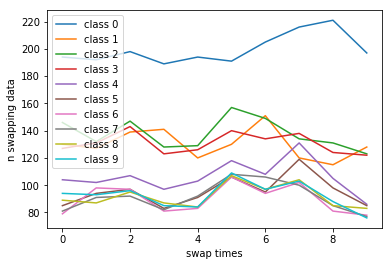

In [17]:
import matplotlib.pyplot as plt
import numpy as np

epoch = 10
fig = plt.figure()
for idx in range(10):
    plt.plot(np.arange(epoch), swapclass[idx], label="class %d" % idx)
plt.xlabel("swap times")
plt.ylabel("n swapping data")
# plt.title("compare accuracy")
plt.legend()
plt.show()
fig.savefig("swapclass.png")

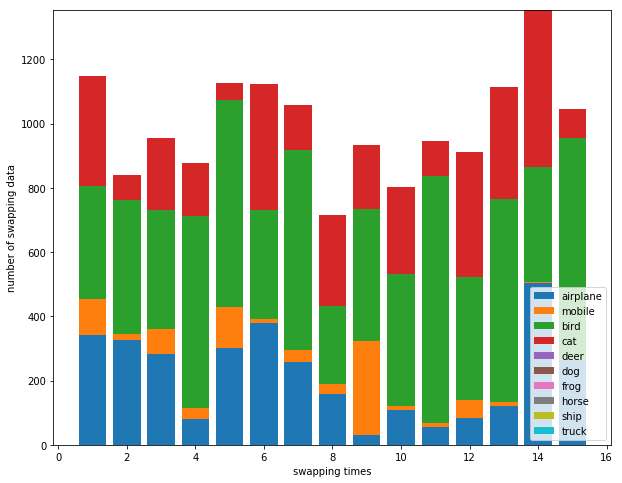

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sns.set(font='IPAexGothic')

# %matplotlib inline

index = ['airplane', 'mobile','bird','cat','deer','dog','frog','horse','ship','truck']
dataset = pd.DataFrame(np.array(swapclass).T, 
                       columns=[i + 1 for i in range(len(swapclass))], 
                       index=index)
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(len(dataset)):
    ax.bar(dataset.columns, dataset.iloc[i], bottom=dataset.iloc[:i].sum())
ax.set(xlabel='swapping times', ylabel='number of swapping data')
ax.legend(dataset.index)
plt.show()
fig.savefig("swapclass4.png")

In [11]:
r = np.random.rand(10)
r<0.3

array([ True, False, False, False, False, False, False,  True, False,
        True])

In [3]:
swapclass = {i:0 for i in range(50000)}
for a, b in zip(atob4, btoa4):
    for A, B in zip(a, b):
        swapclass[A] += 1
        swapclass[B] += 1
z = [(labels[i], swapclass[i]) for i in swapclass.keys() if swapclass[i] > 0]
classid, times = zip(*z)
swaptimes = [[len([0 for cl, tm in z if tm == t and cl == c]) for c in range(10)] for t in range(16)]
swaptimes

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [507, 964, 103, 420, 0, 0, 0, 0, 0, 0],
 [425, 234, 136, 410, 0, 0, 0, 0, 0, 0],
 [432, 58, 173, 495, 0, 0, 0, 0, 0, 0],
 [343, 18, 229, 356, 0, 0, 0, 0, 0, 0],
 [238, 2, 327, 254, 0, 0, 0, 0, 0, 0],
 [126, 0, 343, 151, 0, 0, 0, 0, 0, 0],
 [59, 0, 368, 71, 0, 0, 0, 0, 0, 0],
 [22, 0, 290, 26, 0, 0, 0, 0, 0, 0],
 [4, 0, 219, 12, 0, 0, 0, 0, 0, 0],
 [0, 0, 114, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 64, 2, 0, 0, 0, 0, 0, 0],
 [0, 0, 13, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 4, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

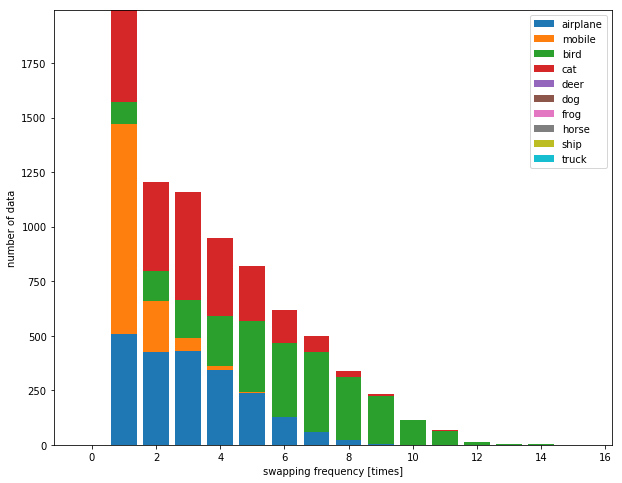

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

index = ['airplane', 'mobile','bird','cat','deer','dog','frog','horse','ship','truck']
dataset = pd.DataFrame(np.array(swaptimes).T, 
                       columns=[i for i in range(len(swaptimes))], 
                       index=index)
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(len(dataset)):
    ax.bar(dataset.columns, dataset.iloc[i], bottom=dataset.iloc[:i].sum())
ax.set(xlabel='swapping frequency [times]', ylabel='number of data')
ax.legend(dataset.index)
plt.show()
fig.savefig("swaptimes4.png")